# OCRL Agent Set-up & Experiment

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.optim.lr_scheduler import CosineAnnealingLR

import numpy as np
import pandas as pd

import shap

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import math
import os
import copy
import random
from pathlib import Path
import sys
import datetime
from tqdm import tqdm
from collections import Counter

In [2]:
# torch.cuda.is_available()
# torch.cuda.device_count()

In [3]:
# torch.cuda.get_device_name(0)

In [4]:
print("torch.get_num_threads():", torch.get_num_threads())
print("torch.get_num_interop_threads():", torch.get_num_interop_threads())

torch.get_num_threads(): 128
torch.get_num_interop_threads(): 128


In [5]:
# device_id = 0 
# props = torch.cuda.get_device_properties(device_id)
# total_memory = props.total_memory  

# print("Total GPU memory (bytes):", total_memory)
# print("Total GPU memory (GB):", total_memory / 1024**3)

In [6]:
torch.cuda.empty_cache()

In [7]:
print(torch.version.cuda)

11.8


### Set-up OCRL Agent

In [8]:
curr_path = str(Path().absolute())
parent_path = str(Path().absolute().parent)
sys.path.append(parent_path) # add current terminal path to sys.path
curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # obtain current time

In [9]:
class FCN_fqe(nn.Module):
    def __init__(self, state_dim, action_dim):

        super(FCN_fqe, self).__init__()
        self.fc1 = nn.Linear(state_dim, 500)
        self.fc2 = nn.Linear(500, action_dim)

    def forward(self, x):

        x = self.fc1(x)
        # x = F.elu(x, alpha = 1.0)
        x = F.leaky_relu(x, negative_slope = 0.1)
        x = self.fc2(x)

        return x

In [10]:
class FCN_fqi(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(FCN_fqi, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, action_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x, negative_slope = 0.1)
        x = self.fc2(x)
        x = F.leaky_relu(x, negative_slope = 0.1)
        x = self.fc3(x)
        x = F.leaky_relu(x, negative_slope = 0.1)
        x = self.fc4(x)
        return x

In [11]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, obj_cost, con_cost, next_state, done):

        if not isinstance(con_cost, list) and not isinstance(con_cost, tuple):
            con_cost = [con_cost]

        if len(self.buffer) < self.capacity:
            self.buffer.append(None)

        self.buffer[self.position] = (state, action, obj_cost, con_cost, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, obj_cost, con_cost, next_state, done = zip(*batch)

        con_cost = [list(costs) for costs in zip(*con_cost)]

        return state, action, obj_cost, con_cost, next_state, done

    def extract(self):
        batch = self.buffer
        state, action, obj_cost, con_cost, next_state, done = zip(*batch)

        con_cost = [list(costs) for costs in zip(*con_cost)]

        return state, action, obj_cost, con_cost, next_state, done

    def clear(self):
        self.buffer = []
        self.position = 0

    def __len__(self):
        return len(self.buffer)

In [12]:
class FQE:
    def __init__(self, cfg, state_dim, action_dim, id_stop, eval_agent, weight_decay, eval_target = 'obj'):

        self.device = cfg.device

        self.gamma = cfg.gamma

        ### indicate optimal stopping structure or not
        self.id_stop = id_stop

        ### For constraint cost, specify which constraint to evaluate
        if eval_target == 'obj':
            self.lr_fqe = cfg.lr_fqe_obj
        else:
            self.lr_fqe = cfg.lr_fqe_con[eval_target] 

        # define policy Q-Estimator
        self.policy_net = FCN_fqe(state_dim, action_dim).to(self.device)
        # define target Q-Estimator
        self.target_net = FCN_fqe(state_dim, action_dim).to(self.device)

        # initialize target Q-Estimator with policy Q-Estimator
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(param.data)

        self.weight_decay = weight_decay
        # self.optimizer = optim.SGD(self.policy_net.parameters(), lr = self.lr_fqe)
        # self.optimizer = optim.SGD([
        #     {'params': self.policy_net.fc1.weight, 'weight_decay': self.weight_decay}, 
        #     {'params': self.policy_net.fc1.bias,   'weight_decay': 0.0}
        #     ], lr = self.lr_fqe)
        # self.optimizer = optim.Adam(self.policy_net.parameters(), lr = self.lr_fqe)
        self.optimizer = optim.AdamW(self.policy_net.parameters(), 
                                     lr = self.lr_fqe, 
                                     weight_decay = self.weight_decay)

        # self.scheduler = CosineAnnealingLR(self.optimizer, T_max = 100)
        
        # define loss function
        self.loss = cfg.loss_fqe
        
        # input the evaluation agent
        self.eval_agent = eval_agent

    def update(self, state_batch, action_batch, cost_batch, next_state_batch, done_batch, disch_batch):

        # We need to evaluate the parameterized policy
        policy_action_batch = self.eval_agent.rl_policy(next_state_batch)

        # predicted Q-value using policy Q-network
        q_values = self.policy_net(state_batch).gather(dim = 1, index = action_batch)

        # target Q-value calculated by target Q-network
        next_q_values = self.target_net(next_state_batch).gather(dim = 1, index = policy_action_batch).squeeze(1).detach()
        
        if self.id_stop == 0:
            expected_q_values = cost_batch + self.gamma * next_q_values * (1 - done_batch)
        else:
            expected_q_values = cost_batch + self.gamma * next_q_values * (1 - disch_batch)
            
        loss = self.loss(q_values, expected_q_values.unsqueeze(1))

        # Update reward Q-network by minimizing the above loss function
        self.optimizer.zero_grad()
        loss.backward()
        
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

        return loss.item()

    def avg_Q_value_est(self, state_batch):
        policy_action_batch = self.eval_agent.rl_policy(state_batch)
        q_values = self.policy_net(state_batch).gather(dim=1, index=policy_action_batch).squeeze(1)

        q_mean = q_values.mean()
        q_std = q_values.std()
        n = q_values.shape[0]
    
        if n <= 1 or q_std == 0:
            return q_mean.item(), q_mean.item()
    
        z = 2.33  
        q_upper_bound = q_mean + z * (q_std / math.sqrt(n))
    
        return q_mean.item(), q_upper_bound.item()

    def save(self, path):
        torch.save(self.policy_net.state_dict(), path + 'FQE_policy_network.pth')
        torch.save(self.target_net.state_dict(), path + 'FQE_target_network.pth')

In [13]:
class FQI:
    def __init__(self, cfg, state_dim, action_dim):
        
        self.device = cfg.device
        self.gamma = cfg.gamma
        
        self.lr = cfg.lr_fqi

        self.policy_net = FCN_fqi(state_dim, action_dim).to(self.device)
        self.target_net = FCN_fqi(state_dim, action_dim).to(self.device)

        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(param.data)

        # self.optimizer = optim.SGD(self.policy_net.parameters(), lr = self.lr)
        # self.optimizer = optim.Adam(self.policy_net.parameters(), lr = self.lr)
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr = self.lr, weight_decay = 1e-2)

        self.loss = cfg.loss_fqi

    def update(self, lambda_t_list, state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch, disch_batch):

        q_values = self.policy_net(state_batch).gather(dim = 1, index = action_batch)
        policy_action_batch = self.policy_net(next_state_batch).min(1)[1].unsqueeze(1)
        next_q_values = self.target_net(next_state_batch).gather(dim = 1, index = policy_action_batch).squeeze(1).detach()

        sum_con_cost = 0
        for i in range(len(lambda_t_list)):
            lambda_t = lambda_t_list[i]
            sum_con_cost += lambda_t * con_cost_batch[i]

        expected_q_values = (obj_cost_batch + sum_con_cost) + self.gamma * next_q_values * (1 - done_batch)

        loss = self.loss(q_values, expected_q_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        return loss.item()

    def avg_Q_value_est(self, state_batch):

        q_values = self.policy_net(state_batch)
        avg_q_values = q_values.min(1)[0].unsqueeze(1).mean().item()

        return avg_q_values

    def rl_policy(self, state_batch):

        q_values = self.policy_net(state_batch)
        policy_action_batch = q_values.min(1)[1].unsqueeze(1)

        return policy_action_batch

    def save(self, path):
        torch.save(self.policy_net.state_dict(), path + 'Offline_FQI_policy_network.pth')
        torch.save(self.target_net.state_dict(), path + 'Offline_FQI_target_network.pth')

In [14]:
class RLConfig:
    def __init__(self, algo_name, train_eps, gamma, lr_fqi, lr_fqe_obj, constraint_num, lr_fqe_con_list, lr_lambda_list, threshold_list):
        
        self.algo = algo_name  # name of algorithm

        self.train_eps = train_eps  #the number of trainng episodes

        self.gamma = gamma # discount factor
        
        self.constraint_num = constraint_num

        # learning rates
        self.lr_fqi = lr_fqi
        self.lr_fqe_obj = lr_fqe_obj
        self.lr_fqe_con = [0 for i in range(constraint_num)]
        self.lr_lam = [0 for i in range(constraint_num)]

        # constraint threshold
        self.constraint_limit = [0 for i in range(constraint_num)]
        for i in range(constraint_num):
            self.lr_fqe_con[i] = lr_fqe_con_list[i]
            self.lr_lam[i] = lr_lambda_list[i]
            self.constraint_limit[i] = threshold_list[i]

        self.train_eps_steps = int(1e3)  # the number of steps in each training episode

        self.batch_size = 256

        self.loss_fqi = nn.MSELoss()
        self.loss_fqe = nn.MSELoss()

        self.memory_capacity = int(2e6)  # capacity of Replay Memory

        self.target_update = 100 # update frequency of target net
        self.tau = 0.01

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check GPU
        # self.device = torch.device("cpu")

In [15]:
class DataLoader:
    def __init__(self, cfg, state_id_table, rl_cont_state_table, rl_cont_state_table_scaled, terminal_state):
        self.cfg = cfg
    
        # Load datasets
        self.state_df_id = state_id_table
        self.rl_cont_state_table = rl_cont_state_table
        self.rl_cont_state_table_scaled = rl_cont_state_table_scaled

        self.terminal_state = terminal_state

    def data_buffer_train(self, num_constraint = 2):
        self.train_memory = ReplayBuffer(self.cfg.memory_capacity)

        for i in range(len(self.state_df_id)):
            state = self.rl_cont_state_table_scaled.values[i]
            action = self.state_df_id['discharge_action'].values[i]
            
            if action == 1.0:
                if self.state_df_id['death'].values[i] == 1.0:
                    if self.state_df_id['discharge_fail'].values[i] == 1.0:
                        done = 0.0
                    else:
                        done = 1.0
                else:
                    if self.state_df_id['discharge_fail'].values[i] == 0.0:
                        done = 1.0
                    else:
                        done = 0.0
            else:
                done = 0.0
            
            obj_cost = self.state_df_id['mortality_costs_md'].values[i]
            con_cost = []
            
            for j in range(num_constraint):
                cost_col = f'con_cost_{j}'  
                if cost_col in self.state_df_id.columns:
                    con_cost.append(self.state_df_id[cost_col].values[i])
                else:
                    con_cost.append(0.0) 

            if done == 0.0:
                idx = self.state_df_id.index[i]
                next_state = self.rl_cont_state_table_scaled.loc[idx + 1].values
            else:
                next_state = self.terminal_state

            self.train_memory.push(state, action, obj_cost, con_cost, next_state, done)

    def data_torch_loader_train(self):
        state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch = self.train_memory.sample(self.cfg.batch_size)

        state_batch = torch.tensor(np.array(state_batch), device = self.cfg.device, dtype = torch.float)

        disch_batch = list(action_batch)
        action_batch = torch.tensor(np.array(action_batch), device = self.cfg.device, dtype = torch.long).unsqueeze(1)
        
        obj_cost_batch = torch.tensor(np.array(obj_cost_batch), device = self.cfg.device, dtype = torch.float)
        con_cost_batch = [torch.tensor(np.array(cost), device = self.cfg.device, dtype=torch.float) for cost in con_cost_batch]
        next_state_batch = torch.tensor(np.array(next_state_batch), device = self.cfg.device, dtype = torch.float)
        
        done_batch = torch.tensor(np.array(done_batch), device = self.cfg.device, dtype = torch.float)
        disch_batch = torch.tensor(np.array(disch_batch), device = self.cfg.device, dtype = torch.float)

        return state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch, disch_batch

In [16]:
class ValDataLoader:
    def __init__(self, cfg, state_id_table, rl_cont_state_table, rl_cont_state_table_scaled, state_id_table_1, rl_cont_state_table_scaled_1, terminal_state):
        self.cfg = cfg
    
        # Load datasets
        self.state_df_id = state_id_table
        self.rl_cont_state_table = rl_cont_state_table
        self.rl_cont_state_table_scaled = rl_cont_state_table_scaled

        self.state_df_id_1 = state_id_table_1
        self.rl_cont_state_table_scaled_1 = rl_cont_state_table_scaled_1

        self.terminal_state = terminal_state

    def data_buffer_val(self, num_constraint = 2):
        self.val_memory = ReplayBuffer(self.cfg.memory_capacity)

        for i in range(len(self.state_df_id)):
            state = self.rl_cont_state_table_scaled.values[i]
            action = self.state_df_id['discharge_action'].values[i]
            
            if action == 1.0:
                if self.state_df_id['death'].values[i] == 1.0:
                    if self.state_df_id['discharge_fail'].values[i] == 1.0:
                        done = 0.0
                    else:
                        done = 1.0
                else:
                    if self.state_df_id['discharge_fail'].values[i] == 0.0:
                        done = 1.0
                    else:
                        done = 0.0
            else:
                done = 0.0
            
            obj_cost = self.state_df_id['mortality_costs_md'].values[i]
            con_cost = []
            
            for j in range(num_constraint):
                cost_col = f'con_cost_{j}'  
                if cost_col in self.state_df_id.columns:
                    con_cost.append(self.state_df_id[cost_col].values[i])
                else:
                    con_cost.append(0.0) 

            if done == 0.0:
                idx = self.state_df_id.index[i]
                next_state = self.rl_cont_state_table_scaled_1.loc[idx + 1].values
            else:
                next_state = self.terminal_state

            self.val_memory.push(state, action, obj_cost, con_cost, next_state, done)

    def data_torch_loader_val(self):
        state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch = self.val_memory.extract()

        state_batch = torch.tensor(np.array(state_batch), device = self.cfg.device, dtype = torch.float)

        return state_batch

In [17]:
class RLTraining:
    def __init__(self, cfg, state_dim, action_dim, val_data_loader, data_loader):
        self.cfg = cfg
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.val_data_loader = val_data_loader
        self.data_loader = data_loader

        # Store for FQI models history
        self.fqi_models_history = []
        
        # Store for FQE models history
        self.fqe_obj_models_history = []
        self.fqe_con_models_history = {}

    def fqi_agent_config(self, seed = 1):
        agent_fqi = FQI(self.cfg, self.state_dim, self.action_dim)
        torch.manual_seed(seed)
        return agent_fqi

    def fqe_agent_config(self, id_stop, eval_agent, weight_decay, eval_target, seed = 2):
        agent_fqe = FQE(self.cfg, self.state_dim, self.action_dim, id_stop, eval_agent, weight_decay, eval_target)
        torch.manual_seed(seed)
        return agent_fqe

    def train(self, agent_fqi, agent_fqe_obj, agent_fqe_con_list, constraint = None):
        print('Start to train!')
        print(f'Algorithm:{self.cfg.algo}, Device:{self.cfg.device}')

        self.FQI_loss = []
        self.FQI_est_values = []

        self.FQE_loss_obj = []
        self.FQE_loss_con = {i: [] for i in range(len(agent_fqe_con_list))}

        self.FQE_est_obj_costs = []
        self.FQE_est_con_costs = {i: [] for i in range(len(agent_fqe_con_list))}

        self.lambda_dict = {i: [] for i in range(len(agent_fqe_con_list))}
        
        # Initialize the model history dictionaries for constraint agents
        for i in range(len(agent_fqe_con_list)):
            self.fqe_con_models_history[i] = []

        lambda_t_list = [0 for i in range(len(agent_fqe_con_list))]
        lambda_update_list = [0 for i in range(len(agent_fqe_con_list))]

        state_batch_val = self.val_data_loader()
        
        model_update_counter = 0  # Counter to track model updates

        for k in range(self.cfg.train_eps):
            loss_list_fqi = []
            loss_list_fqe_obj = []
            loss_list_fqe_con = {i: [] for i in range(len(agent_fqe_con_list))}

            fqi_est_list = []
            fqe_est_obj = []
            fqe_est_con = {i: [] for i in range(len(agent_fqe_con_list))}

            for j in tqdm(range(self.cfg.train_eps_steps)):

                state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch, disch_batch = self.data_loader()
                
                # update the policy agent for learning agent (FQI) and evaluation agent (FQE)
                loss_rl = agent_fqi.update(lambda_t_list, state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch, disch_batch)
                loss_ev_obj = agent_fqe_obj.update(state_batch, action_batch, obj_cost_batch, next_state_batch, done_batch, disch_batch)
                
                # Save FQI model state
                model_update_counter += 1
                if len(self.fqi_models_history) >= 100:
                    self.fqi_models_history.pop(0)  
                self.fqi_models_history.append({
                    'update_num': model_update_counter,
                    'epoch': k,
                    'step': j,
                    'model_state': self._get_model_state(agent_fqi)
                })

                # Save FQE objective model state
                if len(self.fqe_obj_models_history) >= 100:
                    self.fqe_obj_models_history.pop(0) 
                self.fqe_obj_models_history.append({
                    'update_num': model_update_counter,
                    'epoch': k,
                    'step': j,
                    'model_state': self._get_model_state(agent_fqe_obj)
                })
                
                ##############################################################################################################
                loss_list_fqi.append(loss_rl)
                loss_list_fqe_obj.append(loss_ev_obj)

                if constraint == None:
                    for m in range(len(agent_fqe_con_list)):
                        loss_con = agent_fqe_con_list[m].update(state_batch, action_batch, con_cost_batch[m], next_state_batch, done_batch, disch_batch)
                        loss_list_fqe_con[m].append(loss_con)
                        
                        # Save FQE constraint model state
                        if len(self.fqe_con_models_history[m]) >= 100:
                            self.fqe_con_models_history[m].pop(0)  
                        self.fqe_con_models_history[m].append({
                            'update_num': model_update_counter,
                            'epoch': k,
                            'step': j,
                            'model_state': self._get_model_state(agent_fqe_con_list[m])
                        })
                        
                        con_est_value, con_est_value_up = agent_fqe_con_list[m].avg_Q_value_est(state_batch_val)
                        fqe_est_con[m].append(con_est_value)
                    
                    fqi_est_value = agent_fqi.avg_Q_value_est(state_batch_val)
                    avg_q_value_obj, avg_q_value_obj_up = agent_fqe_obj.avg_Q_value_est(state_batch_val)

                    fqi_est_list.append(fqi_est_value)
                    fqe_est_obj.append(avg_q_value_obj)

                    lambda_update_list = [0 for i in range(len(agent_fqe_con_list))]
                    lambda_t_list = [0 for i in range(len(agent_fqe_con_list))]
                
                else:
                    for m in range(len(agent_fqe_con_list)):
                        loss_con = agent_fqe_con_list[m].update(state_batch, action_batch, con_cost_batch[m], next_state_batch, done_batch, disch_batch)
                        loss_list_fqe_con[m].append(loss_con)
                        
                        # Save FQE constraint model state
                        if len(self.fqe_con_models_history[m]) >= 100:
                            self.fqe_con_models_history[m].pop(0)
                            
                        self.fqe_con_models_history[m].append({
                            'update_num': model_update_counter,
                            'epoch': k,
                            'step': j,
                            'model_state': self._get_model_state(agent_fqe_con_list[m])
                        })
                        
                        con_est_value, con_est_value_up = agent_fqe_con_list[m].avg_Q_value_est(state_batch_val)
                        fqe_est_con[m].append(con_est_value)
                        
                        lambda_update_list[m] = con_est_value_up - self.cfg.constraint_limit[m]
                        lambda_t_list[m] = lambda_t_list[m] + (self.cfg.lr_lam[m] * lambda_update_list[m])
                        lambda_t_list[m] = max(0, lambda_t_list[m])
                    
                    fqi_est_value = agent_fqi.avg_Q_value_est(state_batch_val)
                    avg_q_value_obj, avg_q_value_obj_up = agent_fqe_obj.avg_Q_value_est(state_batch_val)

                    fqi_est_list.append(fqi_est_value)
                    fqe_est_obj.append(avg_q_value_obj)
                ######################################################################################
                if j % self.cfg.target_update == 0:

                    ### update the target agent for learning agent (FQI)
                    for target_param, policy_param in zip(agent_fqi.target_net.parameters(), agent_fqi.policy_net.parameters()):
                        target_param.data.copy_(self.cfg.tau * policy_param.data + (1 - self.cfg.tau) * target_param.data)

                    ### update the target agent for evaluation agent (FQE objective cost)
                    for target_param, policy_param in zip(agent_fqe_obj.target_net.parameters(), agent_fqe_obj.policy_net.parameters()):
                        target_param.data.copy_(self.cfg.tau * policy_param.data + (1 - self.cfg.tau) * target_param.data)

                    ### update the target agent for evaluation agent (FQE constraint cost)
                    for agent_fqe_con in agent_fqe_con_list:
                        for target_param, policy_param in zip(agent_fqe_con.target_net.parameters(), agent_fqe_con.policy_net.parameters()):
                            target_param.data.copy_(self.cfg.tau * policy_param.data + (1 - self.cfg.tau) * target_param.data)
                #########################################################################################
            print(f"Epoch {k + 1}/{self.cfg.train_eps}")
            print(f"Average FQE estimated objective cost after epoch {k + 1}: {np.mean(fqe_est_obj)}")        

            for m in range(len(agent_fqe_con_list)):
                print(f"Average FQE estimated constraint cost of constraint {m} after epoch {k + 1}: {np.mean(fqe_est_con[m])}")
                print(f"Dual variable of constraint {m} after epoch {k + 1}: {lambda_t_list[m]}")
                print(f"Dual variable update of constraint {m} after epoch {k + 1}: {lambda_update_list[m]}")

                self.lambda_dict[m].append(lambda_t_list[m])
                self.FQE_loss_con[m].append(np.mean(loss_list_fqe_con[m]))
                self.FQE_est_con_costs[m].append(np.mean(fqe_est_con[m]))

            self.FQI_loss.append(np.mean(loss_list_fqi))
            self.FQE_loss_obj.append(np.mean(loss_list_fqe_obj))

            self.FQI_est_values.append(np.mean(fqi_est_list))
            self.FQE_est_obj_costs.append(np.mean(fqe_est_obj))

        print("Complete Training!")
        
        # Print summary of saved models
        # print(f"Total FQE objective models saved: {len(self.fqe_obj_models_history)}")
        # for m in range(len(agent_fqe_con_list)):
        #     print(f"Total FQE constraint {m} models saved: {len(self.fqe_con_models_history[m])}")
        
        # Save the models to disk if needed
        # self._save_models_to_disk()

        return self.FQI_loss, self.FQE_loss_obj, self.FQE_loss_con, self.FQI_est_values, self.FQE_est_obj_costs, self.FQE_est_con_costs, self.lambda_dict
    
    def _get_model_state(self, agent):
        """
        Extract the model state from an agent.
        Returns a deep copy of both policy_net and target_net states.
        """
        return {
            'policy_net': copy.deepcopy(agent.policy_net.state_dict()),
            'target_net': copy.deepcopy(agent.target_net.state_dict())
        }
    
    def _save_models_to_disk(self):
        """
        Save the models to disk.
        This method can be customized based on your specific requirements.
        """       
        # Create directory for saved models if it doesn't exist
        os.makedirs('saved_models/fqe_obj', exist_ok = True)
        
        # Save objective FQE models
        for idx, model_data in enumerate(self.fqe_obj_models_history[-100:]):
            torch.save(
                model_data['model_state'], 
                f'saved_models/fqe_obj/model_{model_data["update_num"]}.pt'
            )
        
        # Save constraint FQE models
        for con_idx in self.fqe_con_models_history.keys():
            os.makedirs(f'saved_models/fqe_con_{con_idx}', exist_ok = True)
            
            for idx, model_data in enumerate(self.fqe_con_models_history[con_idx][-100:]):
                torch.save(
                    model_data['model_state'], 
                    f'saved_models/fqe_con_{con_idx}/model_{model_data["update_num"]}.pt'
                )
        
        print("Models saved to disk in 'saved_models/' directory")
    
    def load_fqe_model(self, agent, model_path):
        """
        Load a saved FQE model into an agent.
        
        Args:
            agent: The FQE agent to load the model into
            model_path: Path to the saved model state
        
        Returns:
            The agent with loaded model
        """
        model_state = torch.load(model_path)
        agent.policy_net.load_state_dict(model_state['policy_net'])
        agent.target_net.load_state_dict(model_state['target_net'])
        return agent

### Load Data

In [18]:
id_table_train = pd.read_csv('../data_output/id_table_train_v13.csv')
rl_table_train = pd.read_csv('../data_output/rl_table_train_v13.csv')
rl_table_train_scaled = pd.read_csv('../data_output/rl_table_train_scaled_v13.csv')

In [19]:
id_table_val = pd.read_csv('../data_output/id_table_val_v13.csv')
rl_table_val = pd.read_csv('../data_output/rl_table_val_v13.csv')
rl_table_val_scaled = pd.read_csv('../data_output/rl_table_val_scaled_v13.csv')

In [20]:
# rl_table_train_scaled.columns

In [21]:
# rl_table_train.drop(columns = ['readmission_count'], inplace = True)
# rl_table_train_scaled.drop(columns = ['readmission_count'], inplace = True)
# rl_table_val.drop(columns = ['readmission_count'], inplace = True)
# rl_table_val_scaled.drop(columns = ['readmission_count'], inplace = True)

In [22]:
# rl_table_train_scaled.columns

In [23]:
# Create a copy of the 'mortality_costs' column
id_table_train['mortality_costs_md'] = id_table_train['mortality_costs'].copy()

# Apply the conditions using vectorized operations
discharge_action_mask = id_table_train['discharge_action'] == 1
death_mask = id_table_train['death'] == 0
discharge_fail_mask = id_table_train['discharge_fail'] == 1

# Update 'mortality_costs_md' based on the conditions
id_table_train.loc[discharge_action_mask & death_mask, 'mortality_costs_md'] = 0
id_table_train.loc[discharge_action_mask & ~death_mask & discharge_fail_mask, 'mortality_costs_md'] = 0

In [24]:
# Create a copy of the 'mortality_costs' column
id_table_val['mortality_costs_md'] = id_table_val['mortality_costs'].copy()

# Apply the conditions using vectorized operations
discharge_action_mask = id_table_val['discharge_action'] == 1
death_mask = id_table_val['death'] == 0
discharge_fail_mask = id_table_val['discharge_fail'] == 1

# Update 'mortality_costs_md' based on the conditions
id_table_val.loc[discharge_action_mask & death_mask, 'mortality_costs_md'] = 0
id_table_val.loc[discharge_action_mask & ~death_mask & discharge_fail_mask, 'mortality_costs_md'] = 0

In [25]:
id_table_train['con_cost_0'] = id_table_train['discharge_fail_costs'].copy()
id_table_train['con_cost_1'] = id_table_train['los_costs_scaled'].copy()

In [26]:
id_table_val['con_cost_0'] = id_table_val['discharge_fail_costs'].copy()
id_table_val['con_cost_1'] = id_table_val['los_costs_scaled'].copy()

In [27]:
cfg = RLConfig(algo_name = 'OCRL_v2_trainset_201', train_eps = int(4e3), gamma = 1.0, lr_fqi = 2e-3, lr_fqe_obj = 5e-4, 
               constraint_num = 2, lr_fqe_con_list = [5e-4, 5e-4], lr_lambda_list = [3e-4, 1e-7], threshold_list = [0.13, 4.5])

In [28]:
cfg.device

device(type='cuda')

In [29]:
terminal_state = np.zeros(rl_table_train_scaled.shape[1])

In [30]:
cfg.batch_size

256

In [31]:
train_data_loader = DataLoader(cfg, id_table_train, rl_table_train, rl_table_train_scaled, terminal_state)

In [32]:
train_data_loader.data_buffer_train(num_constraint = 2)

In [33]:
# id_table_val_initial = id_table_val[id_table_val['epoch'] == 1].copy()
id_table_val_initial = id_table_val[id_table_val['readmission_count'] == 0].copy()
id_table_val_initial = id_table_val_initial[id_table_val_initial['epoch'] == 1].copy()

mv_val_initial_index = id_table_val_initial.index
id_index_list_initial_val = mv_val_initial_index.tolist()

rl_table_val_initial = rl_table_val.loc[id_index_list_initial_val].copy()

rl_table_val_scaled_initial = rl_table_val_scaled.loc[id_index_list_initial_val].copy()

id_table_val_initial['con_cost_0'] = id_table_val_initial['discharge_fail_costs'].copy()
id_table_val_initial['con_cost_1'] = id_table_val_initial['los_costs_scaled'].copy()

val_data_loader = ValDataLoader(cfg, 
                                id_table_val_initial, 
                                rl_table_val_initial, 
                                rl_table_val_scaled_initial, 
                                id_table_val, 
                                rl_table_val_scaled, 
                                terminal_state)

val_data_loader.data_buffer_val(num_constraint = 2)

### Training OCRL Agent

In [34]:
# torch.set_num_threads(16)
# torch.set_num_interop_threads(16)

In [35]:
ocrl_training_s1 = RLTraining(cfg, state_dim = rl_table_train_scaled.shape[1], 
                              action_dim = 2, 
                              val_data_loader = val_data_loader.data_torch_loader_val, 
                              data_loader = train_data_loader.data_torch_loader_train)

In [36]:
agent_fqi_s1 = ocrl_training_s1.fqi_agent_config(seed = 1)

### objective cost: mortality risk
agent_fqe_obj_s1 = ocrl_training_s1.fqe_agent_config(id_stop = 0, 
                                                     eval_agent = agent_fqi_s1, 
                                                     weight_decay = 1e-2,
                                                     eval_target = 'obj', 
                                                     seed = 2) 

### constraint cost 1: readmission risk
agent_fqe_con_rr_s1 = ocrl_training_s1.fqe_agent_config(id_stop = 0, 
                                                        eval_agent = agent_fqi_s1, 
                                                        weight_decay = 1e-2,
                                                        eval_target = 0, 
                                                        seed = 3) 

### constraint cost 2: length-of-stay
agent_fqe_con_los_s1 = ocrl_training_s1.fqe_agent_config(id_stop = 0, 
                                                         eval_agent = agent_fqi_s1, 
                                                         weight_decay = 1e-2,
                                                         eval_target = 1, 
                                                         seed = 4)

In [37]:
ocrl_training_s1.train(agent_fqi_s1, 
                       agent_fqe_obj_s1, [agent_fqe_con_rr_s1, agent_fqe_con_los_s1], 
                       constraint = True)

Start to train!
Algorithm:OCRL_v2_trainset_201, Device:cuda


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 55.79it/s]


Epoch 1/4000
Average FQE estimated objective cost after epoch 1: -0.15169642587547424
Average FQE estimated constraint cost of constraint 0 after epoch 1: -0.028550121945823775
Dual variable of constraint 0 after epoch 1: 0
Dual variable update of constraint 0 after epoch 1: -0.12040343146771193
Average FQE estimated constraint cost of constraint 1 after epoch 1: 0.6894030473046004
Dual variable of constraint 1 after epoch 1: 0
Dual variable update of constraint 1 after epoch 1: -3.772251546382904


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 58.89it/s]


Epoch 2/4000
Average FQE estimated objective cost after epoch 2: -0.13736154191568495
Average FQE estimated constraint cost of constraint 0 after epoch 2: -0.014889432389732974
Dual variable of constraint 0 after epoch 2: 0
Dual variable update of constraint 0 after epoch 2: -0.19204451620578766
Average FQE estimated constraint cost of constraint 1 after epoch 2: 0.6837623434960842
Dual variable of constraint 1 after epoch 2: 0
Dual variable update of constraint 1 after epoch 2: -3.573167383670807


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.41it/s]


Epoch 3/4000
Average FQE estimated objective cost after epoch 3: -0.1343007964864373
Average FQE estimated constraint cost of constraint 0 after epoch 3: -0.007898095104850653
Dual variable of constraint 0 after epoch 3: 0
Dual variable update of constraint 0 after epoch 3: -0.18557046458125115
Average FQE estimated constraint cost of constraint 1 after epoch 3: 0.7426520411074161
Dual variable of constraint 1 after epoch 3: 0
Dual variable update of constraint 1 after epoch 3: -3.3927382230758667


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.32it/s]


Epoch 4/4000
Average FQE estimated objective cost after epoch 4: -0.12068464593961835
Average FQE estimated constraint cost of constraint 0 after epoch 4: 0.005682524802401531
Dual variable of constraint 0 after epoch 4: 0
Dual variable update of constraint 0 after epoch 4: -0.11089917562901974
Average FQE estimated constraint cost of constraint 1 after epoch 4: 0.7281237317025662
Dual variable of constraint 1 after epoch 4: 0
Dual variable update of constraint 1 after epoch 4: -3.7839861512184143


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.25it/s]


Epoch 5/4000
Average FQE estimated objective cost after epoch 5: -0.10663960140943528
Average FQE estimated constraint cost of constraint 0 after epoch 5: 0.01974252355261865
Dual variable of constraint 0 after epoch 5: 0
Dual variable update of constraint 0 after epoch 5: -0.07963590055704117
Average FQE estimated constraint cost of constraint 1 after epoch 5: 0.714083150178194
Dual variable of constraint 1 after epoch 5: 0
Dual variable update of constraint 1 after epoch 5: -4.016355752944946


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.25it/s]


Epoch 6/4000
Average FQE estimated objective cost after epoch 6: -0.08791181513853372
Average FQE estimated constraint cost of constraint 0 after epoch 6: 0.038644135264199575
Dual variable of constraint 0 after epoch 6: 0
Dual variable update of constraint 0 after epoch 6: -0.05754689604043961
Average FQE estimated constraint cost of constraint 1 after epoch 6: 0.6677192403078079
Dual variable of constraint 1 after epoch 6: 0
Dual variable update of constraint 1 after epoch 6: -3.9428005814552307


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.39it/s]


Epoch 7/4000
Average FQE estimated objective cost after epoch 7: -0.0806090883302968
Average FQE estimated constraint cost of constraint 0 after epoch 7: 0.04486535698822263
Dual variable of constraint 0 after epoch 7: 0
Dual variable update of constraint 0 after epoch 7: -0.11376578465104104
Average FQE estimated constraint cost of constraint 1 after epoch 7: 0.696810148075223
Dual variable of constraint 1 after epoch 7: 0
Dual variable update of constraint 1 after epoch 7: -3.373922348022461


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.18it/s]


Epoch 8/4000
Average FQE estimated objective cost after epoch 8: -0.06793313344628768
Average FQE estimated constraint cost of constraint 0 after epoch 8: 0.057337751717423086
Dual variable of constraint 0 after epoch 8: 0
Dual variable update of constraint 0 after epoch 8: -0.06634655326604844
Average FQE estimated constraint cost of constraint 1 after epoch 8: 0.693903526648879
Dual variable of constraint 1 after epoch 8: 0
Dual variable update of constraint 1 after epoch 8: -3.8438130617141724


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.35it/s]


Epoch 9/4000
Average FQE estimated objective cost after epoch 9: -0.05666343905452231
Average FQE estimated constraint cost of constraint 0 after epoch 9: 0.062308928468381056
Dual variable of constraint 0 after epoch 9: 0
Dual variable update of constraint 0 after epoch 9: -0.09286823228001595
Average FQE estimated constraint cost of constraint 1 after epoch 9: 0.6927608659267426
Dual variable of constraint 1 after epoch 9: 0
Dual variable update of constraint 1 after epoch 9: -3.3709369897842407


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 10/4000
Average FQE estimated objective cost after epoch 10: -0.05005806740241996
Average FQE estimated constraint cost of constraint 0 after epoch 10: 0.06738550664455398
Dual variable of constraint 0 after epoch 10: 0
Dual variable update of constraint 0 after epoch 10: -0.05346730083227158
Average FQE estimated constraint cost of constraint 1 after epoch 10: 0.7050614508092403
Dual variable of constraint 1 after epoch 10: 0
Dual variable update of constraint 1 after epoch 10: -3.887490212917328


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.58it/s]


Epoch 11/4000
Average FQE estimated objective cost after epoch 11: -0.04410111081199284
Average FQE estimated constraint cost of constraint 0 after epoch 11: 0.07164005781271407
Dual variable of constraint 0 after epoch 11: 0
Dual variable update of constraint 0 after epoch 11: -0.017634105980396275
Average FQE estimated constraint cost of constraint 1 after epoch 11: 0.718455718755722
Dual variable of constraint 1 after epoch 11: 0
Dual variable update of constraint 1 after epoch 11: -3.9769765734672546


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.84it/s]


Epoch 12/4000
Average FQE estimated objective cost after epoch 12: -0.035372227233936425
Average FQE estimated constraint cost of constraint 0 after epoch 12: 0.07563539201393724
Dual variable of constraint 0 after epoch 12: 0
Dual variable update of constraint 0 after epoch 12: -0.024185647368431096
Average FQE estimated constraint cost of constraint 1 after epoch 12: 0.70577652785182
Dual variable of constraint 1 after epoch 12: 0
Dual variable update of constraint 1 after epoch 12: -3.905235528945923


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.52it/s]


Epoch 13/4000
Average FQE estimated objective cost after epoch 13: -0.02819375256031344
Average FQE estimated constraint cost of constraint 0 after epoch 13: 0.08262881442531943
Dual variable of constraint 0 after epoch 13: 0
Dual variable update of constraint 0 after epoch 13: -0.013306838572025304
Average FQE estimated constraint cost of constraint 1 after epoch 13: 0.6771972583830357
Dual variable of constraint 1 after epoch 13: 0
Dual variable update of constraint 1 after epoch 13: -3.95760041475296


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.58it/s]


Epoch 14/4000
Average FQE estimated objective cost after epoch 14: -0.02951722826252808
Average FQE estimated constraint cost of constraint 0 after epoch 14: 0.08023558374412823
Dual variable of constraint 0 after epoch 14: 0
Dual variable update of constraint 0 after epoch 14: -0.02080698043107987
Average FQE estimated constraint cost of constraint 1 after epoch 14: 0.7381923757046461
Dual variable of constraint 1 after epoch 14: 0
Dual variable update of constraint 1 after epoch 14: -4.0932663679122925


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.34it/s]


Epoch 15/4000
Average FQE estimated objective cost after epoch 15: -0.02187757183237545
Average FQE estimated constraint cost of constraint 0 after epoch 15: 0.08107518525375053
Dual variable of constraint 0 after epoch 15: 0
Dual variable update of constraint 0 after epoch 15: -0.049416666030883794
Average FQE estimated constraint cost of constraint 1 after epoch 15: 0.7257068817317486
Dual variable of constraint 1 after epoch 15: 0
Dual variable update of constraint 1 after epoch 15: -3.668689489364624


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 16/4000
Average FQE estimated objective cost after epoch 16: -0.013821402112451324
Average FQE estimated constraint cost of constraint 0 after epoch 16: 0.08871891095879254
Dual variable of constraint 0 after epoch 16: 0
Dual variable update of constraint 0 after epoch 16: -0.06905441462993622
Average FQE estimated constraint cost of constraint 1 after epoch 16: 0.7029528064727784
Dual variable of constraint 1 after epoch 16: 0
Dual variable update of constraint 1 after epoch 16: -3.4677183628082275


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 17/4000
Average FQE estimated objective cost after epoch 17: -0.014750533751075635
Average FQE estimated constraint cost of constraint 0 after epoch 17: 0.08393787998938933
Dual variable of constraint 0 after epoch 17: 0
Dual variable update of constraint 0 after epoch 17: -0.042998043000698094
Average FQE estimated constraint cost of constraint 1 after epoch 17: 0.7623651787936687
Dual variable of constraint 1 after epoch 17: 0
Dual variable update of constraint 1 after epoch 17: -3.8406035900115967


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.27it/s]


Epoch 18/4000
Average FQE estimated objective cost after epoch 18: -0.015316343923572276
Average FQE estimated constraint cost of constraint 0 after epoch 18: 0.08462202855595388
Dual variable of constraint 0 after epoch 18: 0
Dual variable update of constraint 0 after epoch 18: -0.0697263415157795
Average FQE estimated constraint cost of constraint 1 after epoch 18: 0.7912482818961144
Dual variable of constraint 1 after epoch 18: 0
Dual variable update of constraint 1 after epoch 18: -3.7529648542404175


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.21it/s]


Epoch 19/4000
Average FQE estimated objective cost after epoch 19: -0.010195382223746491
Average FQE estimated constraint cost of constraint 0 after epoch 19: 0.0830550949331373
Dual variable of constraint 0 after epoch 19: 0
Dual variable update of constraint 0 after epoch 19: -0.03806118398904801
Average FQE estimated constraint cost of constraint 1 after epoch 19: 0.7962837715744973
Dual variable of constraint 1 after epoch 19: 0
Dual variable update of constraint 1 after epoch 19: -3.866347372531891


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.23it/s]


Epoch 20/4000
Average FQE estimated objective cost after epoch 20: -0.009244441727347294
Average FQE estimated constraint cost of constraint 0 after epoch 20: 0.08321619855426252
Dual variable of constraint 0 after epoch 20: 0
Dual variable update of constraint 0 after epoch 20: -0.059765172302722935
Average FQE estimated constraint cost of constraint 1 after epoch 20: 0.8396597857177257
Dual variable of constraint 1 after epoch 20: 0
Dual variable update of constraint 1 after epoch 20: -3.5125169157981873


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.35it/s]


Epoch 21/4000
Average FQE estimated objective cost after epoch 21: -0.008857323965487012
Average FQE estimated constraint cost of constraint 0 after epoch 21: 0.08299367196671664
Dual variable of constraint 0 after epoch 21: 0
Dual variable update of constraint 0 after epoch 21: -0.06869828060269356
Average FQE estimated constraint cost of constraint 1 after epoch 21: 0.888980721950531
Dual variable of constraint 1 after epoch 21: 0
Dual variable update of constraint 1 after epoch 21: -3.287711501121521


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.35it/s]


Epoch 22/4000
Average FQE estimated objective cost after epoch 22: -0.0052212548344541575
Average FQE estimated constraint cost of constraint 0 after epoch 22: 0.08850433134846389
Dual variable of constraint 0 after epoch 22: 1.0722907125949853e-05
Dual variable update of constraint 0 after epoch 22: 0.016992012858390804
Average FQE estimated constraint cost of constraint 1 after epoch 22: 0.8597924807369709
Dual variable of constraint 1 after epoch 22: 0
Dual variable update of constraint 1 after epoch 22: -4.068267524242401


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.21it/s]


Epoch 23/4000
Average FQE estimated objective cost after epoch 23: -0.004214300212620856
Average FQE estimated constraint cost of constraint 0 after epoch 23: 0.08772866882011295
Dual variable of constraint 0 after epoch 23: 0
Dual variable update of constraint 0 after epoch 23: -0.02294156432151795
Average FQE estimated constraint cost of constraint 1 after epoch 23: 0.888049342468381
Dual variable of constraint 1 after epoch 23: 0
Dual variable update of constraint 1 after epoch 23: -3.789615750312805


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.15it/s]


Epoch 24/4000
Average FQE estimated objective cost after epoch 24: -0.0022251779530815838
Average FQE estimated constraint cost of constraint 0 after epoch 24: 0.0873715517744422
Dual variable of constraint 0 after epoch 24: 0
Dual variable update of constraint 0 after epoch 24: -0.06966635316610337
Average FQE estimated constraint cost of constraint 1 after epoch 24: 0.9229586168527603
Dual variable of constraint 1 after epoch 24: 0
Dual variable update of constraint 1 after epoch 24: -3.3293668031692505


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.33it/s]


Epoch 25/4000
Average FQE estimated objective cost after epoch 25: -0.0012752203048030425
Average FQE estimated constraint cost of constraint 0 after epoch 25: 0.08852952862530947
Dual variable of constraint 0 after epoch 25: 0
Dual variable update of constraint 0 after epoch 25: -0.05348422855138779
Average FQE estimated constraint cost of constraint 1 after epoch 25: 0.9521213481202722
Dual variable of constraint 1 after epoch 25: 0
Dual variable update of constraint 1 after epoch 25: -3.34639048576355


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.33it/s]


Epoch 26/4000
Average FQE estimated objective cost after epoch 26: 0.0006066272383454816
Average FQE estimated constraint cost of constraint 0 after epoch 26: 0.0909350671954453
Dual variable of constraint 0 after epoch 26: 1.0943603307008733e-05
Dual variable update of constraint 0 after epoch 26: -0.01761723786592484
Average FQE estimated constraint cost of constraint 1 after epoch 26: 0.9526222196221351
Dual variable of constraint 1 after epoch 26: 0
Dual variable update of constraint 1 after epoch 26: -3.763906717300415


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.89it/s]


Epoch 27/4000
Average FQE estimated objective cost after epoch 27: 0.0006953940936475646
Average FQE estimated constraint cost of constraint 0 after epoch 27: 0.08920365524291993
Dual variable of constraint 0 after epoch 27: 0
Dual variable update of constraint 0 after epoch 27: -0.02215049892663956
Average FQE estimated constraint cost of constraint 1 after epoch 27: 0.9937431438863278
Dual variable of constraint 1 after epoch 27: 0
Dual variable update of constraint 1 after epoch 27: -3.7867007851600647


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.35it/s]


Epoch 28/4000
Average FQE estimated objective cost after epoch 28: 0.0030095773216110046
Average FQE estimated constraint cost of constraint 0 after epoch 28: 0.09197561490535736
Dual variable of constraint 0 after epoch 28: 0
Dual variable update of constraint 0 after epoch 28: -0.04780906915664673
Average FQE estimated constraint cost of constraint 1 after epoch 28: 0.9355379860401154
Dual variable of constraint 1 after epoch 28: 0
Dual variable update of constraint 1 after epoch 28: -3.0867310762405396


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.23it/s]


Epoch 29/4000
Average FQE estimated objective cost after epoch 29: 0.005380383241888694
Average FQE estimated constraint cost of constraint 0 after epoch 29: 0.09676083241775632
Dual variable of constraint 0 after epoch 29: 0
Dual variable update of constraint 0 after epoch 29: -0.02465597271919251
Average FQE estimated constraint cost of constraint 1 after epoch 29: 0.9358683665692806
Dual variable of constraint 1 after epoch 29: 0
Dual variable update of constraint 1 after epoch 29: -3.5957202315330505


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.88it/s]


Epoch 30/4000
Average FQE estimated objective cost after epoch 30: 0.0031957878423231707
Average FQE estimated constraint cost of constraint 0 after epoch 30: 0.09384802295267582
Dual variable of constraint 0 after epoch 30: 0
Dual variable update of constraint 0 after epoch 30: -0.034471211135387425
Average FQE estimated constraint cost of constraint 1 after epoch 30: 1.002346865862608
Dual variable of constraint 1 after epoch 30: 0
Dual variable update of constraint 1 after epoch 30: -3.4451311826705933


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.16it/s]


Epoch 31/4000
Average FQE estimated objective cost after epoch 31: 0.002815849964877998
Average FQE estimated constraint cost of constraint 0 after epoch 31: 0.09382703271135688
Dual variable of constraint 0 after epoch 31: 0
Dual variable update of constraint 0 after epoch 31: -0.03768352150917054
Average FQE estimated constraint cost of constraint 1 after epoch 31: 1.0342644960284233
Dual variable of constraint 1 after epoch 31: 0
Dual variable update of constraint 1 after epoch 31: -3.491313099861145


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.53it/s]


Epoch 32/4000
Average FQE estimated objective cost after epoch 32: 0.002510624255753555
Average FQE estimated constraint cost of constraint 0 after epoch 32: 0.0928135753273964
Dual variable of constraint 0 after epoch 32: 0
Dual variable update of constraint 0 after epoch 32: -0.014511239826679234
Average FQE estimated constraint cost of constraint 1 after epoch 32: 1.0900755617022515
Dual variable of constraint 1 after epoch 32: 0
Dual variable update of constraint 1 after epoch 32: -3.613880217075348


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.90it/s]


Epoch 33/4000
Average FQE estimated objective cost after epoch 33: 0.002043993276237643
Average FQE estimated constraint cost of constraint 0 after epoch 33: 0.09456225303933025
Dual variable of constraint 0 after epoch 33: 0
Dual variable update of constraint 0 after epoch 33: -0.04653659194707871
Average FQE estimated constraint cost of constraint 1 after epoch 33: 1.1111584125757217
Dual variable of constraint 1 after epoch 33: 0
Dual variable update of constraint 1 after epoch 33: -3.106075167655945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.93it/s]


Epoch 34/4000
Average FQE estimated objective cost after epoch 34: 0.0023559598774885444
Average FQE estimated constraint cost of constraint 0 after epoch 34: 0.09540801307186485
Dual variable of constraint 0 after epoch 34: 0
Dual variable update of constraint 0 after epoch 34: -0.04654966771602631
Average FQE estimated constraint cost of constraint 1 after epoch 34: 1.1540834802389144
Dual variable of constraint 1 after epoch 34: 0
Dual variable update of constraint 1 after epoch 34: -3.0647391080856323


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.91it/s]


Epoch 35/4000
Average FQE estimated objective cost after epoch 35: 0.003730608317251608
Average FQE estimated constraint cost of constraint 0 after epoch 35: 0.09715017934143544
Dual variable of constraint 0 after epoch 35: 1.6007204622030245e-05
Dual variable update of constraint 0 after epoch 35: -0.040527110099792485
Average FQE estimated constraint cost of constraint 1 after epoch 35: 1.1389132108092308
Dual variable of constraint 1 after epoch 35: 0
Dual variable update of constraint 1 after epoch 35: -3.2931429147720337


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.10it/s]


Epoch 36/4000
Average FQE estimated objective cost after epoch 36: 0.0032998712698022246
Average FQE estimated constraint cost of constraint 0 after epoch 36: 0.09481035949289798
Dual variable of constraint 0 after epoch 36: 0
Dual variable update of constraint 0 after epoch 36: -0.044355009794235234
Average FQE estimated constraint cost of constraint 1 after epoch 36: 1.2061220128536225
Dual variable of constraint 1 after epoch 36: 0
Dual variable update of constraint 1 after epoch 36: -3.05135178565979


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.05it/s]


Epoch 37/4000
Average FQE estimated objective cost after epoch 37: 0.003908855746746667
Average FQE estimated constraint cost of constraint 0 after epoch 37: 0.09629229729622603
Dual variable of constraint 0 after epoch 37: 0
Dual variable update of constraint 0 after epoch 37: -0.003122230172157292
Average FQE estimated constraint cost of constraint 1 after epoch 37: 1.2119208602309226
Dual variable of constraint 1 after epoch 37: 0
Dual variable update of constraint 1 after epoch 37: -3.4467238187789917


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.09it/s]


Epoch 38/4000
Average FQE estimated objective cost after epoch 38: 0.003619909650333284
Average FQE estimated constraint cost of constraint 0 after epoch 38: 0.09384071316197515
Dual variable of constraint 0 after epoch 38: 0
Dual variable update of constraint 0 after epoch 38: -0.039904792904853825
Average FQE estimated constraint cost of constraint 1 after epoch 38: 1.2767194098234176
Dual variable of constraint 1 after epoch 38: 0
Dual variable update of constraint 1 after epoch 38: -2.880188822746277


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.10it/s]


Epoch 39/4000
Average FQE estimated objective cost after epoch 39: 0.004202638914839554
Average FQE estimated constraint cost of constraint 0 after epoch 39: 0.09664005526155234
Dual variable of constraint 0 after epoch 39: 0
Dual variable update of constraint 0 after epoch 39: -0.012137790322303776
Average FQE estimated constraint cost of constraint 1 after epoch 39: 1.2747458629012107
Dual variable of constraint 1 after epoch 39: 0
Dual variable update of constraint 1 after epoch 39: -3.3946434259414673


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 58.32it/s]


Epoch 40/4000
Average FQE estimated objective cost after epoch 40: 0.003922675674554739
Average FQE estimated constraint cost of constraint 0 after epoch 40: 0.09991911859437823
Dual variable of constraint 0 after epoch 40: 2.280775952339171e-05
Dual variable update of constraint 0 after epoch 40: 0.0007868212461471513
Average FQE estimated constraint cost of constraint 1 after epoch 40: 1.2562562713027001
Dual variable of constraint 1 after epoch 40: 0
Dual variable update of constraint 1 after epoch 40: -3.5684295296669006


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.48it/s]


Epoch 41/4000
Average FQE estimated objective cost after epoch 41: 0.004367603590430008
Average FQE estimated constraint cost of constraint 0 after epoch 41: 0.09711493874713778
Dual variable of constraint 0 after epoch 41: 0
Dual variable update of constraint 0 after epoch 41: -0.028739770054817204
Average FQE estimated constraint cost of constraint 1 after epoch 41: 1.2901553224921227
Dual variable of constraint 1 after epoch 41: 0
Dual variable update of constraint 1 after epoch 41: -3.002270817756653


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 55.61it/s]


Epoch 42/4000
Average FQE estimated objective cost after epoch 42: 0.004658983646425895
Average FQE estimated constraint cost of constraint 0 after epoch 42: 0.09694757124781608
Dual variable of constraint 0 after epoch 42: 2.6636214137077306e-05
Dual variable update of constraint 0 after epoch 42: -0.04756140440702439
Average FQE estimated constraint cost of constraint 1 after epoch 42: 1.3191831209659577
Dual variable of constraint 1 after epoch 42: 0
Dual variable update of constraint 1 after epoch 42: -2.8398733139038086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.02it/s]


Epoch 43/4000
Average FQE estimated objective cost after epoch 43: 0.004851943382597255
Average FQE estimated constraint cost of constraint 0 after epoch 43: 0.09953782357275485
Dual variable of constraint 0 after epoch 43: 0
Dual variable update of constraint 0 after epoch 43: -0.07039864093065262
Average FQE estimated constraint cost of constraint 1 after epoch 43: 1.3699229877591133
Dual variable of constraint 1 after epoch 43: 0
Dual variable update of constraint 1 after epoch 43: -2.633745551109314


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.53it/s]


Epoch 44/4000
Average FQE estimated objective cost after epoch 44: 0.004042751688524959
Average FQE estimated constraint cost of constraint 0 after epoch 44: 0.0986514148414135
Dual variable of constraint 0 after epoch 44: 0
Dual variable update of constraint 0 after epoch 44: -0.0313134241104126
Average FQE estimated constraint cost of constraint 1 after epoch 44: 1.3796380637288093
Dual variable of constraint 1 after epoch 44: 0
Dual variable update of constraint 1 after epoch 44: -3.004366874694824


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.21it/s]


Epoch 45/4000
Average FQE estimated objective cost after epoch 45: 0.00591623001521657
Average FQE estimated constraint cost of constraint 0 after epoch 45: 0.10412489527836442
Dual variable of constraint 0 after epoch 45: 0
Dual variable update of constraint 0 after epoch 45: -0.028526757955551152
Average FQE estimated constraint cost of constraint 1 after epoch 45: 1.3540674141645432
Dual variable of constraint 1 after epoch 45: 0
Dual variable update of constraint 1 after epoch 45: -2.9048084020614624


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 55.64it/s]


Epoch 46/4000
Average FQE estimated objective cost after epoch 46: 0.005108538069333917
Average FQE estimated constraint cost of constraint 0 after epoch 46: 0.09906175319105387
Dual variable of constraint 0 after epoch 46: 0
Dual variable update of constraint 0 after epoch 46: -0.040346210002899174
Average FQE estimated constraint cost of constraint 1 after epoch 46: 1.4688619239330292
Dual variable of constraint 1 after epoch 46: 0
Dual variable update of constraint 1 after epoch 46: -2.892332434654236


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.38it/s]


Epoch 47/4000
Average FQE estimated objective cost after epoch 47: 0.003970640850917334
Average FQE estimated constraint cost of constraint 0 after epoch 47: 0.09861893109977245
Dual variable of constraint 0 after epoch 47: 0
Dual variable update of constraint 0 after epoch 47: -0.028229569196701054
Average FQE estimated constraint cost of constraint 1 after epoch 47: 1.5368052678704263
Dual variable of constraint 1 after epoch 47: 0
Dual variable update of constraint 1 after epoch 47: -2.7767622470855713


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.10it/s]


Epoch 48/4000
Average FQE estimated objective cost after epoch 48: 0.002932741365882066
Average FQE estimated constraint cost of constraint 0 after epoch 48: 0.09729977395758033
Dual variable of constraint 0 after epoch 48: 0
Dual variable update of constraint 0 after epoch 48: -0.031018999516963963
Average FQE estimated constraint cost of constraint 1 after epoch 48: 1.5940763487815857
Dual variable of constraint 1 after epoch 48: 0
Dual variable update of constraint 1 after epoch 48: -2.8752275705337524


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 55.57it/s]


Epoch 49/4000
Average FQE estimated objective cost after epoch 49: 0.005153401377821865
Average FQE estimated constraint cost of constraint 0 after epoch 49: 0.10231005010381342
Dual variable of constraint 0 after epoch 49: 3.540232372283934e-05
Dual variable update of constraint 0 after epoch 49: 0.01959880709648132
Average FQE estimated constraint cost of constraint 1 after epoch 49: 1.4973625584840775
Dual variable of constraint 1 after epoch 49: 0
Dual variable update of constraint 1 after epoch 49: -3.4302444458007812


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.69it/s]


Epoch 50/4000
Average FQE estimated objective cost after epoch 50: 0.006896728074086241
Average FQE estimated constraint cost of constraint 0 after epoch 50: 0.1063400753736496
Dual variable of constraint 0 after epoch 50: 0
Dual variable update of constraint 0 after epoch 50: -0.0262450921535492
Average FQE estimated constraint cost of constraint 1 after epoch 50: 1.454295214533806
Dual variable of constraint 1 after epoch 50: 0
Dual variable update of constraint 1 after epoch 50: -3.2526113986968994


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 55.56it/s]


Epoch 51/4000
Average FQE estimated objective cost after epoch 51: 0.0074464797347327475
Average FQE estimated constraint cost of constraint 0 after epoch 51: 0.1040054167099297
Dual variable of constraint 0 after epoch 51: 0
Dual variable update of constraint 0 after epoch 51: -0.05172845453023911
Average FQE estimated constraint cost of constraint 1 after epoch 51: 1.4799602265954017
Dual variable of constraint 1 after epoch 51: 0
Dual variable update of constraint 1 after epoch 51: -2.271021842956543


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.52it/s]


Epoch 52/4000
Average FQE estimated objective cost after epoch 52: 0.006981291448422269
Average FQE estimated constraint cost of constraint 0 after epoch 52: 0.10271041816473007
Dual variable of constraint 0 after epoch 52: 0
Dual variable update of constraint 0 after epoch 52: -0.04177752614021302
Average FQE estimated constraint cost of constraint 1 after epoch 52: 1.5642772954702377
Dual variable of constraint 1 after epoch 52: 0
Dual variable update of constraint 1 after epoch 52: -2.769857406616211


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.23it/s]


Epoch 53/4000
Average FQE estimated objective cost after epoch 53: 0.005193218904181777
Average FQE estimated constraint cost of constraint 0 after epoch 53: 0.10225205562636257
Dual variable of constraint 0 after epoch 53: 0
Dual variable update of constraint 0 after epoch 53: -0.022548896372318272
Average FQE estimated constraint cost of constraint 1 after epoch 53: 1.6192415636181832
Dual variable of constraint 1 after epoch 53: 0
Dual variable update of constraint 1 after epoch 53: -2.6776018142700195


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.20it/s]


Epoch 54/4000
Average FQE estimated objective cost after epoch 54: 0.007382370849096332
Average FQE estimated constraint cost of constraint 0 after epoch 54: 0.10632173977047205
Dual variable of constraint 0 after epoch 54: 0
Dual variable update of constraint 0 after epoch 54: -0.029486742913722996
Average FQE estimated constraint cost of constraint 1 after epoch 54: 1.5508632741570472
Dual variable of constraint 1 after epoch 54: 0
Dual variable update of constraint 1 after epoch 54: -2.8364315032958984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.40it/s]


Epoch 55/4000
Average FQE estimated objective cost after epoch 55: 0.005601207259637704
Average FQE estimated constraint cost of constraint 0 after epoch 55: 0.10567959885671735
Dual variable of constraint 0 after epoch 55: 6.192824006080626e-05
Dual variable update of constraint 0 after epoch 55: 0.013364846706390376
Average FQE estimated constraint cost of constraint 1 after epoch 55: 1.6721994100809097
Dual variable of constraint 1 after epoch 55: 0
Dual variable update of constraint 1 after epoch 55: -3.7345858812332153


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 55.57it/s]


Epoch 56/4000
Average FQE estimated objective cost after epoch 56: 0.005880311691113093
Average FQE estimated constraint cost of constraint 0 after epoch 56: 0.10459232845902443
Dual variable of constraint 0 after epoch 56: 0
Dual variable update of constraint 0 after epoch 56: -0.03663564205169678
Average FQE estimated constraint cost of constraint 1 after epoch 56: 1.6827521620988846
Dual variable of constraint 1 after epoch 56: 0
Dual variable update of constraint 1 after epoch 56: -2.350404977798462


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.44it/s]


Epoch 57/4000
Average FQE estimated objective cost after epoch 57: 0.006103247104092702
Average FQE estimated constraint cost of constraint 0 after epoch 57: 0.10357109811156988
Dual variable of constraint 0 after epoch 57: 0
Dual variable update of constraint 0 after epoch 57: -0.02852368831634522
Average FQE estimated constraint cost of constraint 1 after epoch 57: 1.7049006620645524
Dual variable of constraint 1 after epoch 57: 0
Dual variable update of constraint 1 after epoch 57: -2.524261713027954


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.47it/s]


Epoch 58/4000
Average FQE estimated objective cost after epoch 58: 0.007386810343369234
Average FQE estimated constraint cost of constraint 0 after epoch 58: 0.1064593742787838
Dual variable of constraint 0 after epoch 58: 0
Dual variable update of constraint 0 after epoch 58: -0.023594063818454747
Average FQE estimated constraint cost of constraint 1 after epoch 58: 1.672874265372753
Dual variable of constraint 1 after epoch 58: 0
Dual variable update of constraint 1 after epoch 58: -2.521414875984192


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.16it/s]


Epoch 59/4000
Average FQE estimated objective cost after epoch 59: 0.006222063279166832
Average FQE estimated constraint cost of constraint 0 after epoch 59: 0.1049152774438262
Dual variable of constraint 0 after epoch 59: 0
Dual variable update of constraint 0 after epoch 59: -0.011317690014839177
Average FQE estimated constraint cost of constraint 1 after epoch 59: 1.6947605808973312
Dual variable of constraint 1 after epoch 59: 0
Dual variable update of constraint 1 after epoch 59: -2.932561993598938


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.16it/s]


Epoch 60/4000
Average FQE estimated objective cost after epoch 60: 0.0061897785785834
Average FQE estimated constraint cost of constraint 0 after epoch 60: 0.10653445381671191
Dual variable of constraint 0 after epoch 60: 0
Dual variable update of constraint 0 after epoch 60: -0.05553429305553437
Average FQE estimated constraint cost of constraint 1 after epoch 60: 1.7181318298578263
Dual variable of constraint 1 after epoch 60: 0
Dual variable update of constraint 1 after epoch 60: -2.2106730937957764


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.94it/s]


Epoch 61/4000
Average FQE estimated objective cost after epoch 61: 0.006804619438361726
Average FQE estimated constraint cost of constraint 0 after epoch 61: 0.10588806381076574
Dual variable of constraint 0 after epoch 61: 0
Dual variable update of constraint 0 after epoch 61: -0.030753848254680638
Average FQE estimated constraint cost of constraint 1 after epoch 61: 1.780953588962555
Dual variable of constraint 1 after epoch 61: 0
Dual variable update of constraint 1 after epoch 61: -2.4509999752044678


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.18it/s]


Epoch 62/4000
Average FQE estimated objective cost after epoch 62: 0.00748855110634986
Average FQE estimated constraint cost of constraint 0 after epoch 62: 0.10783973343670368
Dual variable of constraint 0 after epoch 62: 0
Dual variable update of constraint 0 after epoch 62: -0.026580390632152562
Average FQE estimated constraint cost of constraint 1 after epoch 62: 1.7799396467804909
Dual variable of constraint 1 after epoch 62: 0
Dual variable update of constraint 1 after epoch 62: -2.475156545639038


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.16it/s]


Epoch 63/4000
Average FQE estimated objective cost after epoch 63: 0.00581427000372787
Average FQE estimated constraint cost of constraint 0 after epoch 63: 0.10527923548221588
Dual variable of constraint 0 after epoch 63: 0
Dual variable update of constraint 0 after epoch 63: -0.027179007530212407
Average FQE estimated constraint cost of constraint 1 after epoch 63: 1.9556245970129966
Dual variable of constraint 1 after epoch 63: 0
Dual variable update of constraint 1 after epoch 63: -2.6791787147521973


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.22it/s]


Epoch 64/4000
Average FQE estimated objective cost after epoch 64: 0.006153885528442515
Average FQE estimated constraint cost of constraint 0 after epoch 64: 0.10746068301051855
Dual variable of constraint 0 after epoch 64: 0
Dual variable update of constraint 0 after epoch 64: -0.023126033246517186
Average FQE estimated constraint cost of constraint 1 after epoch 64: 1.8674419555068016
Dual variable of constraint 1 after epoch 64: 0
Dual variable update of constraint 1 after epoch 64: -2.6754661798477173


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.43it/s]


Epoch 65/4000
Average FQE estimated objective cost after epoch 65: 0.006946132796276935
Average FQE estimated constraint cost of constraint 0 after epoch 65: 0.1082840924039483
Dual variable of constraint 0 after epoch 65: 0
Dual variable update of constraint 0 after epoch 65: -0.025571507513523106
Average FQE estimated constraint cost of constraint 1 after epoch 65: 1.9183343230485916
Dual variable of constraint 1 after epoch 65: 0
Dual variable update of constraint 1 after epoch 65: -2.0816402435302734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 55.77it/s]


Epoch 66/4000
Average FQE estimated objective cost after epoch 66: 0.0065726058216118875
Average FQE estimated constraint cost of constraint 0 after epoch 66: 0.10792184782773256
Dual variable of constraint 0 after epoch 66: 0
Dual variable update of constraint 0 after epoch 66: -0.00979827076196671
Average FQE estimated constraint cost of constraint 1 after epoch 66: 1.8952787610292434
Dual variable of constraint 1 after epoch 66: 0
Dual variable update of constraint 1 after epoch 66: -3.032017469406128


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.23it/s]


Epoch 67/4000
Average FQE estimated objective cost after epoch 67: 0.007084312694360051
Average FQE estimated constraint cost of constraint 0 after epoch 67: 0.10975417421013117
Dual variable of constraint 0 after epoch 67: 0
Dual variable update of constraint 0 after epoch 67: -0.025709030330181126
Average FQE estimated constraint cost of constraint 1 after epoch 67: 1.8749031656980515
Dual variable of constraint 1 after epoch 67: 0
Dual variable update of constraint 1 after epoch 67: -2.465975761413574


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.26it/s]


Epoch 68/4000
Average FQE estimated objective cost after epoch 68: 0.006372223686486904
Average FQE estimated constraint cost of constraint 0 after epoch 68: 0.11023822139948607
Dual variable of constraint 0 after epoch 68: 0
Dual variable update of constraint 0 after epoch 68: -0.021945131123065953
Average FQE estimated constraint cost of constraint 1 after epoch 68: 1.9528787592053414
Dual variable of constraint 1 after epoch 68: 0
Dual variable update of constraint 1 after epoch 68: -2.3417394161224365


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 55.60it/s]


Epoch 69/4000
Average FQE estimated objective cost after epoch 69: 0.008026862349768635
Average FQE estimated constraint cost of constraint 0 after epoch 69: 0.10822439350932836
Dual variable of constraint 0 after epoch 69: 6.069042474031417e-06
Dual variable update of constraint 0 after epoch 69: -0.04008980572223664
Average FQE estimated constraint cost of constraint 1 after epoch 69: 1.9957138714790343
Dual variable of constraint 1 after epoch 69: 0
Dual variable update of constraint 1 after epoch 69: -2.132070541381836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.18it/s]


Epoch 70/4000
Average FQE estimated objective cost after epoch 70: 0.0069152540691827654
Average FQE estimated constraint cost of constraint 0 after epoch 70: 0.10974761629104614
Dual variable of constraint 0 after epoch 70: 0
Dual variable update of constraint 0 after epoch 70: -0.02947248995304108
Average FQE estimated constraint cost of constraint 1 after epoch 70: 2.0235083932876585
Dual variable of constraint 1 after epoch 70: 0
Dual variable update of constraint 1 after epoch 70: -2.02919340133667


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.31it/s]


Epoch 71/4000
Average FQE estimated objective cost after epoch 71: 0.009007766844575599
Average FQE estimated constraint cost of constraint 0 after epoch 71: 0.1098272563368082
Dual variable of constraint 0 after epoch 71: 0
Dual variable update of constraint 0 after epoch 71: -0.01550861924886704
Average FQE estimated constraint cost of constraint 1 after epoch 71: 2.0710289254784584
Dual variable of constraint 1 after epoch 71: 0
Dual variable update of constraint 1 after epoch 71: -2.416283130645752


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 56.22it/s]


Epoch 72/4000
Average FQE estimated objective cost after epoch 72: 0.006437946263277581
Average FQE estimated constraint cost of constraint 0 after epoch 72: 0.11018751485645771
Dual variable of constraint 0 after epoch 72: 0
Dual variable update of constraint 0 after epoch 72: -0.018918384909629826
Average FQE estimated constraint cost of constraint 1 after epoch 72: 2.1437798953056335
Dual variable of constraint 1 after epoch 72: 0
Dual variable update of constraint 1 after epoch 72: -2.311243772506714


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.07it/s]


Epoch 73/4000
Average FQE estimated objective cost after epoch 73: 0.00758016017085356
Average FQE estimated constraint cost of constraint 0 after epoch 73: 0.1122570729330182
Dual variable of constraint 0 after epoch 73: 1.0031646966934193e-05
Dual variable update of constraint 0 after epoch 73: -0.010622908473014836
Average FQE estimated constraint cost of constraint 1 after epoch 73: 2.147944171667099
Dual variable of constraint 1 after epoch 73: 0
Dual variable update of constraint 1 after epoch 73: -2.0049378871917725


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.86it/s]


Epoch 74/4000
Average FQE estimated objective cost after epoch 74: 0.008150287247999585
Average FQE estimated constraint cost of constraint 0 after epoch 74: 0.11320505677908659
Dual variable of constraint 0 after epoch 74: 0
Dual variable update of constraint 0 after epoch 74: -0.03743423253297806
Average FQE estimated constraint cost of constraint 1 after epoch 74: 2.0640175651311874
Dual variable of constraint 1 after epoch 74: 0
Dual variable update of constraint 1 after epoch 74: -2.9487465620040894


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 75/4000
Average FQE estimated objective cost after epoch 75: 0.009578515201275877
Average FQE estimated constraint cost of constraint 0 after epoch 75: 0.11419669648259878
Dual variable of constraint 0 after epoch 75: 0
Dual variable update of constraint 0 after epoch 75: -0.022089016735553746
Average FQE estimated constraint cost of constraint 1 after epoch 75: 2.0567824730873108
Dual variable of constraint 1 after epoch 75: 0
Dual variable update of constraint 1 after epoch 75: -3.0493366718292236


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 76/4000
Average FQE estimated objective cost after epoch 76: 0.008330446413679965
Average FQE estimated constraint cost of constraint 0 after epoch 76: 0.11458513490110636
Dual variable of constraint 0 after epoch 76: 0
Dual variable update of constraint 0 after epoch 76: -0.020001222491264348
Average FQE estimated constraint cost of constraint 1 after epoch 76: 2.0512382048368454
Dual variable of constraint 1 after epoch 76: 0
Dual variable update of constraint 1 after epoch 76: -2.1883037090301514


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.06it/s]


Epoch 77/4000
Average FQE estimated objective cost after epoch 77: 0.01061720860262176
Average FQE estimated constraint cost of constraint 0 after epoch 77: 0.11547846128791571
Dual variable of constraint 0 after epoch 77: 0
Dual variable update of constraint 0 after epoch 77: -0.025895585417747502
Average FQE estimated constraint cost of constraint 1 after epoch 77: 2.0446980324983595
Dual variable of constraint 1 after epoch 77: 0
Dual variable update of constraint 1 after epoch 77: -2.0584709644317627


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 78/4000
Average FQE estimated objective cost after epoch 78: 0.00891262935082068
Average FQE estimated constraint cost of constraint 0 after epoch 78: 0.1140043371990323
Dual variable of constraint 0 after epoch 78: 1.4874714910984031e-05
Dual variable update of constraint 0 after epoch 78: 0.008527557253837581
Average FQE estimated constraint cost of constraint 1 after epoch 78: 2.0777169997692106
Dual variable of constraint 1 after epoch 78: 0
Dual variable update of constraint 1 after epoch 78: -2.5507736206054688


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 79/4000
Average FQE estimated objective cost after epoch 79: 0.008388565751141868
Average FQE estimated constraint cost of constraint 0 after epoch 79: 0.10957733331620693
Dual variable of constraint 0 after epoch 79: 0
Dual variable update of constraint 0 after epoch 79: -0.026269775927066807
Average FQE estimated constraint cost of constraint 1 after epoch 79: 2.3369914046525957
Dual variable of constraint 1 after epoch 79: 0
Dual variable update of constraint 1 after epoch 79: -1.2426660060882568


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.48it/s]


Epoch 80/4000
Average FQE estimated objective cost after epoch 80: 0.00875291372765514
Average FQE estimated constraint cost of constraint 0 after epoch 80: 0.11358407907187938
Dual variable of constraint 0 after epoch 80: 0
Dual variable update of constraint 0 after epoch 80: -0.02896943420171738
Average FQE estimated constraint cost of constraint 1 after epoch 80: 2.1785212670564653
Dual variable of constraint 1 after epoch 80: 0
Dual variable update of constraint 1 after epoch 80: -1.3716096878051758


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 81/4000
Average FQE estimated objective cost after epoch 81: 0.00895244663952326
Average FQE estimated constraint cost of constraint 0 after epoch 81: 0.11286653120815754
Dual variable of constraint 0 after epoch 81: 0
Dual variable update of constraint 0 after epoch 81: -0.004897688627243046
Average FQE estimated constraint cost of constraint 1 after epoch 81: 2.284845685005188
Dual variable of constraint 1 after epoch 81: 0
Dual variable update of constraint 1 after epoch 81: -2.839547872543335


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 82/4000
Average FQE estimated objective cost after epoch 82: 0.007395897248106849
Average FQE estimated constraint cost of constraint 0 after epoch 82: 0.11392511709034443
Dual variable of constraint 0 after epoch 82: 1.187856227159489e-06
Dual variable update of constraint 0 after epoch 82: -0.009756607115268712
Average FQE estimated constraint cost of constraint 1 after epoch 82: 2.2777373399734495
Dual variable of constraint 1 after epoch 82: 0
Dual variable update of constraint 1 after epoch 82: -2.599044442176819


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 83/4000
Average FQE estimated objective cost after epoch 83: 0.007812050855089183
Average FQE estimated constraint cost of constraint 0 after epoch 83: 0.11326686491817237
Dual variable of constraint 0 after epoch 83: 0
Dual variable update of constraint 0 after epoch 83: -0.03261413156986237
Average FQE estimated constraint cost of constraint 1 after epoch 83: 2.3528837589621543
Dual variable of constraint 1 after epoch 83: 0
Dual variable update of constraint 1 after epoch 83: -1.4386155605316162


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 84/4000
Average FQE estimated objective cost after epoch 84: 0.009916714522281836
Average FQE estimated constraint cost of constraint 0 after epoch 84: 0.11499248119443654
Dual variable of constraint 0 after epoch 84: 9.243802428245517e-07
Dual variable update of constraint 0 after epoch 84: 0.0023763579130172685
Average FQE estimated constraint cost of constraint 1 after epoch 84: 2.2361198872923853
Dual variable of constraint 1 after epoch 84: 0
Dual variable update of constraint 1 after epoch 84: -2.2747082710266113


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 85/4000
Average FQE estimated objective cost after epoch 85: 0.008631519213213323
Average FQE estimated constraint cost of constraint 0 after epoch 85: 0.11440331158041954
Dual variable of constraint 0 after epoch 85: 0
Dual variable update of constraint 0 after epoch 85: -0.015531850159168248
Average FQE estimated constraint cost of constraint 1 after epoch 85: 2.2579149289131166
Dual variable of constraint 1 after epoch 85: 0
Dual variable update of constraint 1 after epoch 85: -2.4118077754974365


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 86/4000
Average FQE estimated objective cost after epoch 86: 0.007855697206150581
Average FQE estimated constraint cost of constraint 0 after epoch 86: 0.1124147468060255
Dual variable of constraint 0 after epoch 86: 0
Dual variable update of constraint 0 after epoch 86: -0.015735459625720982
Average FQE estimated constraint cost of constraint 1 after epoch 86: 2.427721366882324
Dual variable of constraint 1 after epoch 86: 0
Dual variable update of constraint 1 after epoch 86: -2.142807722091675


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 87/4000
Average FQE estimated objective cost after epoch 87: 0.009716437706883881
Average FQE estimated constraint cost of constraint 0 after epoch 87: 0.11598259074985981
Dual variable of constraint 0 after epoch 87: 0
Dual variable update of constraint 0 after epoch 87: -0.015034859180450444
Average FQE estimated constraint cost of constraint 1 after epoch 87: 2.348450720667839
Dual variable of constraint 1 after epoch 87: 0
Dual variable update of constraint 1 after epoch 87: -1.360788345336914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.35it/s]


Epoch 88/4000
Average FQE estimated objective cost after epoch 88: 0.009637000793856714
Average FQE estimated constraint cost of constraint 0 after epoch 88: 0.1176958614140749
Dual variable of constraint 0 after epoch 88: 5.155990487337109e-05
Dual variable update of constraint 0 after epoch 88: 0.001860926747322078
Average FQE estimated constraint cost of constraint 1 after epoch 88: 2.2567882509231567
Dual variable of constraint 1 after epoch 88: 0
Dual variable update of constraint 1 after epoch 88: -2.453019857406616


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 89/4000
Average FQE estimated objective cost after epoch 89: 0.010011150660922794
Average FQE estimated constraint cost of constraint 0 after epoch 89: 0.1173196433633566
Dual variable of constraint 0 after epoch 89: 0
Dual variable update of constraint 0 after epoch 89: -0.00192657589912415
Average FQE estimated constraint cost of constraint 1 after epoch 89: 2.191731644153595
Dual variable of constraint 1 after epoch 89: 0
Dual variable update of constraint 1 after epoch 89: -2.7472208738327026


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 90/4000
Average FQE estimated objective cost after epoch 90: 0.010073048171983828
Average FQE estimated constraint cost of constraint 0 after epoch 90: 0.11566324661672116
Dual variable of constraint 0 after epoch 90: 0
Dual variable update of constraint 0 after epoch 90: -0.02154267311096192
Average FQE estimated constraint cost of constraint 1 after epoch 90: 2.279040624499321
Dual variable of constraint 1 after epoch 90: 0
Dual variable update of constraint 1 after epoch 90: -1.7794008255004883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 58.39it/s]


Epoch 91/4000
Average FQE estimated objective cost after epoch 91: 0.009350622445370391
Average FQE estimated constraint cost of constraint 0 after epoch 91: 0.11949954069405794
Dual variable of constraint 0 after epoch 91: 0
Dual variable update of constraint 0 after epoch 91: -0.02547776430845261
Average FQE estimated constraint cost of constraint 1 after epoch 91: 2.237101633191109
Dual variable of constraint 1 after epoch 91: 0
Dual variable update of constraint 1 after epoch 91: -1.7780625820159912


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.67it/s]


Epoch 92/4000
Average FQE estimated objective cost after epoch 92: 0.00873906300204908
Average FQE estimated constraint cost of constraint 0 after epoch 92: 0.11828114128112793
Dual variable of constraint 0 after epoch 92: 0
Dual variable update of constraint 0 after epoch 92: -0.007493292093276982
Average FQE estimated constraint cost of constraint 1 after epoch 92: 2.299585000395775
Dual variable of constraint 1 after epoch 92: 0
Dual variable update of constraint 1 after epoch 92: -2.2733869552612305


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.98it/s]


Epoch 93/4000
Average FQE estimated objective cost after epoch 93: 0.009341710191525635
Average FQE estimated constraint cost of constraint 0 after epoch 93: 0.11734952172636985
Dual variable of constraint 0 after epoch 93: 2.261750641465184e-05
Dual variable update of constraint 0 after epoch 93: -0.0068990263342857405
Average FQE estimated constraint cost of constraint 1 after epoch 93: 2.382670028090477
Dual variable of constraint 1 after epoch 93: 0
Dual variable update of constraint 1 after epoch 93: -1.5652661323547363


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.73it/s]


Epoch 94/4000
Average FQE estimated objective cost after epoch 94: 0.008823622513556983
Average FQE estimated constraint cost of constraint 0 after epoch 94: 0.11592437102645635
Dual variable of constraint 0 after epoch 94: 0
Dual variable update of constraint 0 after epoch 94: -0.036501844525337224
Average FQE estimated constraint cost of constraint 1 after epoch 94: 2.396115271449089
Dual variable of constraint 1 after epoch 94: 0
Dual variable update of constraint 1 after epoch 94: -1.6592960357666016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.25it/s]


Epoch 95/4000
Average FQE estimated objective cost after epoch 95: 0.008095352613806426
Average FQE estimated constraint cost of constraint 0 after epoch 95: 0.11568312781304121
Dual variable of constraint 0 after epoch 95: 0
Dual variable update of constraint 0 after epoch 95: -0.02149854332208634
Average FQE estimated constraint cost of constraint 1 after epoch 95: 2.567405081629753
Dual variable of constraint 1 after epoch 95: 0
Dual variable update of constraint 1 after epoch 95: -1.6242809295654297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.16it/s]


Epoch 96/4000
Average FQE estimated objective cost after epoch 96: 0.010058057053885933
Average FQE estimated constraint cost of constraint 0 after epoch 96: 0.11793112699687482
Dual variable of constraint 0 after epoch 96: 0
Dual variable update of constraint 0 after epoch 96: -0.016068679392337804
Average FQE estimated constraint cost of constraint 1 after epoch 96: 2.4561061761379244
Dual variable of constraint 1 after epoch 96: 0
Dual variable update of constraint 1 after epoch 96: -1.4761364459991455


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.33it/s]


Epoch 97/4000
Average FQE estimated objective cost after epoch 97: 0.008087530729400896
Average FQE estimated constraint cost of constraint 0 after epoch 97: 0.11405541168898344
Dual variable of constraint 0 after epoch 97: 0
Dual variable update of constraint 0 after epoch 97: -0.018129770755767827
Average FQE estimated constraint cost of constraint 1 after epoch 97: 2.6617782497406006
Dual variable of constraint 1 after epoch 97: 0
Dual variable update of constraint 1 after epoch 97: -1.3945090770721436


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 98/4000
Average FQE estimated objective cost after epoch 98: 0.00781851224912043
Average FQE estimated constraint cost of constraint 0 after epoch 98: 0.11545626170188189
Dual variable of constraint 0 after epoch 98: 4.882196688652037e-05
Dual variable update of constraint 0 after epoch 98: 0.014922599196434017
Average FQE estimated constraint cost of constraint 1 after epoch 98: 2.6023986144065856
Dual variable of constraint 1 after epoch 98: 0
Dual variable update of constraint 1 after epoch 98: -1.9902355670928955


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.27it/s]


Epoch 99/4000
Average FQE estimated objective cost after epoch 99: 0.007914628331764562
Average FQE estimated constraint cost of constraint 0 after epoch 99: 0.11561326145380735
Dual variable of constraint 0 after epoch 99: 2.704288119077681e-05
Dual variable update of constraint 0 after epoch 99: -0.0038953024148941084
Average FQE estimated constraint cost of constraint 1 after epoch 99: 2.6153409324884414
Dual variable of constraint 1 after epoch 99: 0
Dual variable update of constraint 1 after epoch 99: -1.9218854904174805


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 100/4000
Average FQE estimated objective cost after epoch 100: 0.009453513522582398
Average FQE estimated constraint cost of constraint 0 after epoch 100: 0.11802430978417397
Dual variable of constraint 0 after epoch 100: 0
Dual variable update of constraint 0 after epoch 100: -0.006622967422008519
Average FQE estimated constraint cost of constraint 1 after epoch 100: 2.558295179724693
Dual variable of constraint 1 after epoch 100: 0
Dual variable update of constraint 1 after epoch 100: -2.096096992492676


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.35it/s]


Epoch 101/4000
Average FQE estimated objective cost after epoch 101: 0.009295493275247282
Average FQE estimated constraint cost of constraint 0 after epoch 101: 0.11750850165635347
Dual variable of constraint 0 after epoch 101: 0
Dual variable update of constraint 0 after epoch 101: -0.020210367739200596
Average FQE estimated constraint cost of constraint 1 after epoch 101: 2.4977228986024858
Dual variable of constraint 1 after epoch 101: 0
Dual variable update of constraint 1 after epoch 101: -1.546907901763916


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.15it/s]


Epoch 102/4000
Average FQE estimated objective cost after epoch 102: 0.008292611866881999
Average FQE estimated constraint cost of constraint 0 after epoch 102: 0.11832852306216955
Dual variable of constraint 0 after epoch 102: 0
Dual variable update of constraint 0 after epoch 102: -0.009638426005840306
Average FQE estimated constraint cost of constraint 1 after epoch 102: 2.6440769048929216
Dual variable of constraint 1 after epoch 102: 0
Dual variable update of constraint 1 after epoch 102: -1.4457857608795166


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.25it/s]


Epoch 103/4000
Average FQE estimated objective cost after epoch 103: 0.00894238697843096
Average FQE estimated constraint cost of constraint 0 after epoch 103: 0.12017276898026466
Dual variable of constraint 0 after epoch 103: 0
Dual variable update of constraint 0 after epoch 103: -0.006180857419967656
Average FQE estimated constraint cost of constraint 1 after epoch 103: 2.536540263175964
Dual variable of constraint 1 after epoch 103: 0
Dual variable update of constraint 1 after epoch 103: -1.9071362018585205


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.19it/s]


Epoch 104/4000
Average FQE estimated objective cost after epoch 104: 0.00946911488069236
Average FQE estimated constraint cost of constraint 0 after epoch 104: 0.12247910729050636
Dual variable of constraint 0 after epoch 104: 0
Dual variable update of constraint 0 after epoch 104: -0.024951730966567998
Average FQE estimated constraint cost of constraint 1 after epoch 104: 2.443452656626701
Dual variable of constraint 1 after epoch 104: 0
Dual variable update of constraint 1 after epoch 104: -1.5757708549499512


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.13it/s]


Epoch 105/4000
Average FQE estimated objective cost after epoch 105: 0.008219888998452916
Average FQE estimated constraint cost of constraint 0 after epoch 105: 0.1193202865049243
Dual variable of constraint 0 after epoch 105: 0
Dual variable update of constraint 0 after epoch 105: -0.01163109123706818
Average FQE estimated constraint cost of constraint 1 after epoch 105: 2.6576576815843582
Dual variable of constraint 1 after epoch 105: 0
Dual variable update of constraint 1 after epoch 105: -1.3785736560821533


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.22it/s]


Epoch 106/4000
Average FQE estimated objective cost after epoch 106: 0.009495530247144416
Average FQE estimated constraint cost of constraint 0 after epoch 106: 0.12038965868204832
Dual variable of constraint 0 after epoch 106: 0
Dual variable update of constraint 0 after epoch 106: -0.014476527571678166
Average FQE estimated constraint cost of constraint 1 after epoch 106: 2.5466143810749053
Dual variable of constraint 1 after epoch 106: 0
Dual variable update of constraint 1 after epoch 106: -1.3348915576934814


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.19it/s]


Epoch 107/4000
Average FQE estimated objective cost after epoch 107: 0.009021987246629578
Average FQE estimated constraint cost of constraint 0 after epoch 107: 0.1197080841511488
Dual variable of constraint 0 after epoch 107: 0
Dual variable update of constraint 0 after epoch 107: -0.014884200990200047
Average FQE estimated constraint cost of constraint 1 after epoch 107: 2.60298508477211
Dual variable of constraint 1 after epoch 107: 0
Dual variable update of constraint 1 after epoch 107: -3.202748417854309


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.23it/s]


Epoch 108/4000
Average FQE estimated objective cost after epoch 108: 0.010139378142710483
Average FQE estimated constraint cost of constraint 0 after epoch 108: 0.121048270650208
Dual variable of constraint 0 after epoch 108: 1.819813603162764e-05
Dual variable update of constraint 0 after epoch 108: 0.004779989719390865
Average FQE estimated constraint cost of constraint 1 after epoch 108: 2.6596888679265978
Dual variable of constraint 1 after epoch 108: 0
Dual variable update of constraint 1 after epoch 108: -2.048118829727173


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.11it/s]


Epoch 109/4000
Average FQE estimated objective cost after epoch 109: 0.010082553938932506
Average FQE estimated constraint cost of constraint 0 after epoch 109: 0.1212497387751937
Dual variable of constraint 0 after epoch 109: 5.160735100507729e-06
Dual variable update of constraint 0 after epoch 109: -0.007244822680950169
Average FQE estimated constraint cost of constraint 1 after epoch 109: 2.6384885745048523
Dual variable of constraint 1 after epoch 109: 0
Dual variable update of constraint 1 after epoch 109: -1.4217298030853271


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.31it/s]


Epoch 110/4000
Average FQE estimated objective cost after epoch 110: 0.008012353508265733
Average FQE estimated constraint cost of constraint 0 after epoch 110: 0.12007466574013233
Dual variable of constraint 0 after epoch 110: 4.632457494735698e-06
Dual variable update of constraint 0 after epoch 110: -0.017658283114433293
Average FQE estimated constraint cost of constraint 1 after epoch 110: 2.7303967660665514
Dual variable of constraint 1 after epoch 110: 0
Dual variable update of constraint 1 after epoch 110: -1.4402143955230713


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.28it/s]


Epoch 111/4000
Average FQE estimated objective cost after epoch 111: 0.008181768525863845
Average FQE estimated constraint cost of constraint 0 after epoch 111: 0.11907517637312412
Dual variable of constraint 0 after epoch 111: 0
Dual variable update of constraint 0 after epoch 111: -0.019081433415412907
Average FQE estimated constraint cost of constraint 1 after epoch 111: 2.7753876257538797
Dual variable of constraint 1 after epoch 111: 0
Dual variable update of constraint 1 after epoch 111: -1.150000810623169


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.28it/s]


Epoch 112/4000
Average FQE estimated objective cost after epoch 112: 0.009655591623821238
Average FQE estimated constraint cost of constraint 0 after epoch 112: 0.11959981851279736
Dual variable of constraint 0 after epoch 112: 2.0389067530631966e-06
Dual variable update of constraint 0 after epoch 112: -0.0037540543079376265
Average FQE estimated constraint cost of constraint 1 after epoch 112: 2.667449851036072
Dual variable of constraint 1 after epoch 112: 0
Dual variable update of constraint 1 after epoch 112: -2.4432754516601562


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.28it/s]


Epoch 113/4000
Average FQE estimated objective cost after epoch 113: 0.006819036378045894
Average FQE estimated constraint cost of constraint 0 after epoch 113: 0.11868098661303521
Dual variable of constraint 0 after epoch 113: 0
Dual variable update of constraint 0 after epoch 113: -0.01756797462701798
Average FQE estimated constraint cost of constraint 1 after epoch 113: 2.919941154837608
Dual variable of constraint 1 after epoch 113: 0
Dual variable update of constraint 1 after epoch 113: -1.2274138927459717


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.07it/s]


Epoch 114/4000
Average FQE estimated objective cost after epoch 114: 0.00805665220476385
Average FQE estimated constraint cost of constraint 0 after epoch 114: 0.11941448093950749
Dual variable of constraint 0 after epoch 114: 7.548934221267566e-08
Dual variable update of constraint 0 after epoch 114: 0.0002516311407089189
Average FQE estimated constraint cost of constraint 1 after epoch 114: 2.774198041558266
Dual variable of constraint 1 after epoch 114: 0
Dual variable update of constraint 1 after epoch 114: -1.5407421588897705


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.15it/s]


Epoch 115/4000
Average FQE estimated objective cost after epoch 115: 0.009712494723396957
Average FQE estimated constraint cost of constraint 0 after epoch 115: 0.12306633888930082
Dual variable of constraint 0 after epoch 115: 0
Dual variable update of constraint 0 after epoch 115: -0.0104919645190239
Average FQE estimated constraint cost of constraint 1 after epoch 115: 2.7442851186990738
Dual variable of constraint 1 after epoch 115: 0
Dual variable update of constraint 1 after epoch 115: -0.8680057525634766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.89it/s]


Epoch 116/4000
Average FQE estimated objective cost after epoch 116: 0.008704070830795899
Average FQE estimated constraint cost of constraint 0 after epoch 116: 0.12167774523049593
Dual variable of constraint 0 after epoch 116: 4.885983574390397e-05
Dual variable update of constraint 0 after epoch 116: -0.02078152179718018
Average FQE estimated constraint cost of constraint 1 after epoch 116: 2.7758540475964546
Dual variable of constraint 1 after epoch 116: 0
Dual variable update of constraint 1 after epoch 116: -2.0762014389038086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 55.91it/s]


Epoch 117/4000
Average FQE estimated objective cost after epoch 117: 0.009418922008813297
Average FQE estimated constraint cost of constraint 0 after epoch 117: 0.1238754703104496
Dual variable of constraint 0 after epoch 117: 3.148555827140806e-05
Dual variable update of constraint 0 after epoch 117: -0.026596945822238927
Average FQE estimated constraint cost of constraint 1 after epoch 117: 2.672261202454567
Dual variable of constraint 1 after epoch 117: 0
Dual variable update of constraint 1 after epoch 117: -1.4377195835113525


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 55.89it/s]


Epoch 118/4000
Average FQE estimated objective cost after epoch 118: 0.007981742018101158
Average FQE estimated constraint cost of constraint 0 after epoch 118: 0.1188091003075242
Dual variable of constraint 0 after epoch 118: 0
Dual variable update of constraint 0 after epoch 118: -0.026030358970165257
Average FQE estimated constraint cost of constraint 1 after epoch 118: 2.771370994925499
Dual variable of constraint 1 after epoch 118: 0
Dual variable update of constraint 1 after epoch 118: -1.288963794708252


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.22it/s]


Epoch 119/4000
Average FQE estimated objective cost after epoch 119: 0.009228951403876636
Average FQE estimated constraint cost of constraint 0 after epoch 119: 0.1231177197098732
Dual variable of constraint 0 after epoch 119: 0
Dual variable update of constraint 0 after epoch 119: -0.006556150615215306
Average FQE estimated constraint cost of constraint 1 after epoch 119: 2.5930909214019775
Dual variable of constraint 1 after epoch 119: 0
Dual variable update of constraint 1 after epoch 119: -1.5055549144744873


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.89it/s]


Epoch 120/4000
Average FQE estimated objective cost after epoch 120: 0.008102566651042708
Average FQE estimated constraint cost of constraint 0 after epoch 120: 0.12239233499765396
Dual variable of constraint 0 after epoch 120: 2.2325293511152253e-05
Dual variable update of constraint 0 after epoch 120: -0.009536069929599766
Average FQE estimated constraint cost of constraint 1 after epoch 120: 2.7136412209272383
Dual variable of constraint 1 after epoch 120: 0
Dual variable update of constraint 1 after epoch 120: -1.7443618774414062


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.54it/s]


Epoch 121/4000
Average FQE estimated objective cost after epoch 121: 0.007880541777105066
Average FQE estimated constraint cost of constraint 0 after epoch 121: 0.12190720119327307
Dual variable of constraint 0 after epoch 121: 5.589775711297973e-06
Dual variable update of constraint 0 after epoch 121: -0.020050813555717473
Average FQE estimated constraint cost of constraint 1 after epoch 121: 2.708083653330803
Dual variable of constraint 1 after epoch 121: 0
Dual variable update of constraint 1 after epoch 121: -1.1285066604614258


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.28it/s]


Epoch 122/4000
Average FQE estimated objective cost after epoch 122: 0.009439774240167025
Average FQE estimated constraint cost of constraint 0 after epoch 122: 0.12158740859478712
Dual variable of constraint 0 after epoch 122: 0.00041311223101615904
Dual variable update of constraint 0 after epoch 122: -0.002019574046134953
Average FQE estimated constraint cost of constraint 1 after epoch 122: 2.802759118437767
Dual variable of constraint 1 after epoch 122: 0
Dual variable update of constraint 1 after epoch 122: -2.403041362762451


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.21it/s]


Epoch 123/4000
Average FQE estimated objective cost after epoch 123: 0.009778634429327212
Average FQE estimated constraint cost of constraint 0 after epoch 123: 0.12296847843378782
Dual variable of constraint 0 after epoch 123: 1.677254283428185e-05
Dual variable update of constraint 0 after epoch 123: -0.0022445368766784712
Average FQE estimated constraint cost of constraint 1 after epoch 123: 2.7262537668943407
Dual variable of constraint 1 after epoch 123: 0
Dual variable update of constraint 1 after epoch 123: -1.2100071907043457


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.19it/s]


Epoch 124/4000
Average FQE estimated objective cost after epoch 124: 0.009634294312641942
Average FQE estimated constraint cost of constraint 0 after epoch 124: 0.12320596072077751
Dual variable of constraint 0 after epoch 124: 1.0692773759365025e-05
Dual variable update of constraint 0 after epoch 124: -0.03115035325288773
Average FQE estimated constraint cost of constraint 1 after epoch 124: 2.7209198894500735
Dual variable of constraint 1 after epoch 124: 0
Dual variable update of constraint 1 after epoch 124: -1.0895469188690186


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.15it/s]


Epoch 125/4000
Average FQE estimated objective cost after epoch 125: 0.008126308760566189
Average FQE estimated constraint cost of constraint 0 after epoch 125: 0.1223127662166953
Dual variable of constraint 0 after epoch 125: 0
Dual variable update of constraint 0 after epoch 125: -0.010027018487453465
Average FQE estimated constraint cost of constraint 1 after epoch 125: 2.8648520011901857
Dual variable of constraint 1 after epoch 125: 0
Dual variable update of constraint 1 after epoch 125: -1.5384423732757568


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.04it/s]


Epoch 126/4000
Average FQE estimated objective cost after epoch 126: 0.00978070158950868
Average FQE estimated constraint cost of constraint 0 after epoch 126: 0.12107102054357528
Dual variable of constraint 0 after epoch 126: 5.741443097591391e-06
Dual variable update of constraint 0 after epoch 126: 0.005018214583396907
Average FQE estimated constraint cost of constraint 1 after epoch 126: 2.7810407704114914
Dual variable of constraint 1 after epoch 126: 0
Dual variable update of constraint 1 after epoch 126: -2.004639148712158


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.33it/s]


Epoch 127/4000
Average FQE estimated objective cost after epoch 127: 0.009725078474768452
Average FQE estimated constraint cost of constraint 0 after epoch 127: 0.12212017214298249
Dual variable of constraint 0 after epoch 127: 0
Dual variable update of constraint 0 after epoch 127: -0.011960131227970128
Average FQE estimated constraint cost of constraint 1 after epoch 127: 2.6269318875074386
Dual variable of constraint 1 after epoch 127: 0
Dual variable update of constraint 1 after epoch 127: -1.1526741981506348


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 128/4000
Average FQE estimated objective cost after epoch 128: 0.010205616742069651
Average FQE estimated constraint cost of constraint 0 after epoch 128: 0.12268404669314623
Dual variable of constraint 0 after epoch 128: 0
Dual variable update of constraint 0 after epoch 128: -0.02595243334770203
Average FQE estimated constraint cost of constraint 1 after epoch 128: 2.729323580503464
Dual variable of constraint 1 after epoch 128: 0
Dual variable update of constraint 1 after epoch 128: -1.549126386642456


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.32it/s]


Epoch 129/4000
Average FQE estimated objective cost after epoch 129: 0.0100221908079302
Average FQE estimated constraint cost of constraint 0 after epoch 129: 0.12185138440132141
Dual variable of constraint 0 after epoch 129: 2.3834742039441993e-05
Dual variable update of constraint 0 after epoch 129: -0.01504721969366074
Average FQE estimated constraint cost of constraint 1 after epoch 129: 2.7130641424655915
Dual variable of constraint 1 after epoch 129: 0
Dual variable update of constraint 1 after epoch 129: -1.9972476959228516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.37it/s]


Epoch 130/4000
Average FQE estimated objective cost after epoch 130: 0.01052553206716857
Average FQE estimated constraint cost of constraint 0 after epoch 130: 0.12275263027101756
Dual variable of constraint 0 after epoch 130: 0
Dual variable update of constraint 0 after epoch 130: -0.02479281753301621
Average FQE estimated constraint cost of constraint 1 after epoch 130: 2.6244644556045533
Dual variable of constraint 1 after epoch 130: 0
Dual variable update of constraint 1 after epoch 130: -1.676102876663208


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.33it/s]


Epoch 131/4000
Average FQE estimated objective cost after epoch 131: 0.010736315015588844
Average FQE estimated constraint cost of constraint 0 after epoch 131: 0.12146068046241999
Dual variable of constraint 0 after epoch 131: 0
Dual variable update of constraint 0 after epoch 131: -0.01581722974777222
Average FQE estimated constraint cost of constraint 1 after epoch 131: 2.704527641952038
Dual variable of constraint 1 after epoch 131: 0
Dual variable update of constraint 1 after epoch 131: -0.8969230651855469


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.14it/s]


Epoch 132/4000
Average FQE estimated objective cost after epoch 132: 0.010117434253017563
Average FQE estimated constraint cost of constraint 0 after epoch 132: 0.12041935310512782
Dual variable of constraint 0 after epoch 132: 0
Dual variable update of constraint 0 after epoch 132: -0.009541635513305669
Average FQE estimated constraint cost of constraint 1 after epoch 132: 2.8128955457210543
Dual variable of constraint 1 after epoch 132: 0
Dual variable update of constraint 1 after epoch 132: -1.8239078521728516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.47it/s]


Epoch 133/4000
Average FQE estimated objective cost after epoch 133: 0.010300312353249012
Average FQE estimated constraint cost of constraint 0 after epoch 133: 0.12349015414714813
Dual variable of constraint 0 after epoch 133: 2.9526977777481026e-05
Dual variable update of constraint 0 after epoch 133: 0.012475888133049007
Average FQE estimated constraint cost of constraint 1 after epoch 133: 2.689141121149063
Dual variable of constraint 1 after epoch 133: 0
Dual variable update of constraint 1 after epoch 133: -1.6523826122283936


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 55.47it/s]


Epoch 134/4000
Average FQE estimated objective cost after epoch 134: 0.01048358923619321
Average FQE estimated constraint cost of constraint 0 after epoch 134: 0.1239923037365079
Dual variable of constraint 0 after epoch 134: 9.172864508628841e-05
Dual variable update of constraint 0 after epoch 134: 0.02553393959999084
Average FQE estimated constraint cost of constraint 1 after epoch 134: 2.737576701402664
Dual variable of constraint 1 after epoch 134: 0
Dual variable update of constraint 1 after epoch 134: -2.807544708251953


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.86it/s]


Epoch 135/4000
Average FQE estimated objective cost after epoch 135: 0.011185613361019931
Average FQE estimated constraint cost of constraint 0 after epoch 135: 0.1255231501981616
Dual variable of constraint 0 after epoch 135: 0.0002827406585812566
Dual variable update of constraint 0 after epoch 135: -0.02426708966493607
Average FQE estimated constraint cost of constraint 1 after epoch 135: 2.709373225450516
Dual variable of constraint 1 after epoch 135: 0
Dual variable update of constraint 1 after epoch 135: -1.555708646774292


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.04it/s]


Epoch 136/4000
Average FQE estimated objective cost after epoch 136: 0.012812331733668542
Average FQE estimated constraint cost of constraint 0 after epoch 136: 0.12924284569174052
Dual variable of constraint 0 after epoch 136: 0.0006985807297825799
Dual variable update of constraint 0 after epoch 136: 0.00024336099624633345
Average FQE estimated constraint cost of constraint 1 after epoch 136: 2.54450159239769
Dual variable of constraint 1 after epoch 136: 0
Dual variable update of constraint 1 after epoch 136: -1.6342198848724365


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.97it/s]


Epoch 137/4000
Average FQE estimated objective cost after epoch 137: 0.011673643816968251
Average FQE estimated constraint cost of constraint 0 after epoch 137: 0.1262354769036174
Dual variable of constraint 0 after epoch 137: 7.564445865154113e-05
Dual variable update of constraint 0 after epoch 137: -0.01149393349885941
Average FQE estimated constraint cost of constraint 1 after epoch 137: 2.714414931893349
Dual variable of constraint 1 after epoch 137: 0
Dual variable update of constraint 1 after epoch 137: -2.164584159851074


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.78it/s]


Epoch 138/4000
Average FQE estimated objective cost after epoch 138: 0.010981671400099003
Average FQE estimated constraint cost of constraint 0 after epoch 138: 0.1251760457381606
Dual variable of constraint 0 after epoch 138: 0
Dual variable update of constraint 0 after epoch 138: -0.009254870116710667
Average FQE estimated constraint cost of constraint 1 after epoch 138: 2.8585948222875595
Dual variable of constraint 1 after epoch 138: 0
Dual variable update of constraint 1 after epoch 138: -1.3964903354644775


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.03it/s]


Epoch 139/4000
Average FQE estimated objective cost after epoch 139: 0.011741106694675069
Average FQE estimated constraint cost of constraint 0 after epoch 139: 0.1266881088837981
Dual variable of constraint 0 after epoch 139: 8.604275608062712e-05
Dual variable update of constraint 0 after epoch 139: 0.0233658355474472
Average FQE estimated constraint cost of constraint 1 after epoch 139: 2.7023405880928038
Dual variable of constraint 1 after epoch 139: 0
Dual variable update of constraint 1 after epoch 139: -1.6590001583099365


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.01it/s]


Epoch 140/4000
Average FQE estimated objective cost after epoch 140: 0.012666169981606799
Average FQE estimated constraint cost of constraint 0 after epoch 140: 0.12732078455388546
Dual variable of constraint 0 after epoch 140: 1.3308840394020025e-06
Dual variable update of constraint 0 after epoch 140: 0.00017982244491576704
Average FQE estimated constraint cost of constraint 1 after epoch 140: 2.680938526034355
Dual variable of constraint 1 after epoch 140: 0
Dual variable update of constraint 1 after epoch 140: -1.4050734043121338


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.87it/s]


Epoch 141/4000
Average FQE estimated objective cost after epoch 141: 0.010742934255504225
Average FQE estimated constraint cost of constraint 0 after epoch 141: 0.12514162837713957
Dual variable of constraint 0 after epoch 141: 4.5075828641652905e-05
Dual variable update of constraint 0 after epoch 141: -0.017826532125473027
Average FQE estimated constraint cost of constraint 1 after epoch 141: 2.857641051888466
Dual variable of constraint 1 after epoch 141: 0
Dual variable update of constraint 1 after epoch 141: -1.1343176364898682


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.91it/s]


Epoch 142/4000
Average FQE estimated objective cost after epoch 142: 0.009435967505911321
Average FQE estimated constraint cost of constraint 0 after epoch 142: 0.1222857845723629
Dual variable of constraint 0 after epoch 142: 7.474662601947778e-06
Dual variable update of constraint 0 after epoch 142: 0.013408209085464473
Average FQE estimated constraint cost of constraint 1 after epoch 142: 3.0267769528627397
Dual variable of constraint 1 after epoch 142: 0
Dual variable update of constraint 1 after epoch 142: -2.304697036743164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.74it/s]


Epoch 143/4000
Average FQE estimated objective cost after epoch 143: 0.01057340874372312
Average FQE estimated constraint cost of constraint 0 after epoch 143: 0.12403344504535198
Dual variable of constraint 0 after epoch 143: 0.00017292884936928731
Dual variable update of constraint 0 after epoch 143: 0.016127194166183467
Average FQE estimated constraint cost of constraint 1 after epoch 143: 2.917738440513611
Dual variable of constraint 1 after epoch 143: 0
Dual variable update of constraint 1 after epoch 143: -2.5400607585906982


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.08it/s]


Epoch 144/4000
Average FQE estimated objective cost after epoch 144: 0.0111198697306545
Average FQE estimated constraint cost of constraint 0 after epoch 144: 0.12609172843396663
Dual variable of constraint 0 after epoch 144: 0
Dual variable update of constraint 0 after epoch 144: -0.009249870777130131
Average FQE estimated constraint cost of constraint 1 after epoch 144: 2.868247078299522
Dual variable of constraint 1 after epoch 144: 0
Dual variable update of constraint 1 after epoch 144: -1.2412123680114746


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.06it/s]


Epoch 145/4000
Average FQE estimated objective cost after epoch 145: 0.010507665462401974
Average FQE estimated constraint cost of constraint 0 after epoch 145: 0.1264630294367671
Dual variable of constraint 0 after epoch 145: 6.59984459280968e-05
Dual variable update of constraint 0 after epoch 145: -0.020027418732643132
Average FQE estimated constraint cost of constraint 1 after epoch 145: 2.759550732135773
Dual variable of constraint 1 after epoch 145: 0
Dual variable update of constraint 1 after epoch 145: -0.8627862930297852


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.06it/s]


Epoch 146/4000
Average FQE estimated objective cost after epoch 146: 0.010222550280290307
Average FQE estimated constraint cost of constraint 0 after epoch 146: 0.12630506832152605
Dual variable of constraint 0 after epoch 146: 0
Dual variable update of constraint 0 after epoch 146: -0.00513990700244904
Average FQE estimated constraint cost of constraint 1 after epoch 146: 2.9047879700660704
Dual variable of constraint 1 after epoch 146: 0
Dual variable update of constraint 1 after epoch 146: -1.2772867679595947


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.01it/s]


Epoch 147/4000
Average FQE estimated objective cost after epoch 147: 0.010768454135653882
Average FQE estimated constraint cost of constraint 0 after epoch 147: 0.12616464852541684
Dual variable of constraint 0 after epoch 147: 0
Dual variable update of constraint 0 after epoch 147: -0.008058232367038731
Average FQE estimated constraint cost of constraint 1 after epoch 147: 2.8957550328969957
Dual variable of constraint 1 after epoch 147: 0
Dual variable update of constraint 1 after epoch 147: -0.8910210132598877


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.01it/s]


Epoch 148/4000
Average FQE estimated objective cost after epoch 148: 0.010017333928197786
Average FQE estimated constraint cost of constraint 0 after epoch 148: 0.12801477137953043
Dual variable of constraint 0 after epoch 148: 0.000475776657879352
Dual variable update of constraint 0 after epoch 148: 0.02284715592861175
Average FQE estimated constraint cost of constraint 1 after epoch 148: 2.8215814517736435
Dual variable of constraint 1 after epoch 148: 0
Dual variable update of constraint 1 after epoch 148: -1.4030170440673828


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.04it/s]


Epoch 149/4000
Average FQE estimated objective cost after epoch 149: 0.010633851921571477
Average FQE estimated constraint cost of constraint 0 after epoch 149: 0.12797611878812312
Dual variable of constraint 0 after epoch 149: 0.00042627165502309787
Dual variable update of constraint 0 after epoch 149: -0.003877346515655522
Average FQE estimated constraint cost of constraint 1 after epoch 149: 2.8307229262590408
Dual variable of constraint 1 after epoch 149: 0
Dual variable update of constraint 1 after epoch 149: -1.1657001972198486


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.94it/s]


Epoch 150/4000
Average FQE estimated objective cost after epoch 150: 0.009571710114239977
Average FQE estimated constraint cost of constraint 0 after epoch 150: 0.1263618720769882
Dual variable of constraint 0 after epoch 150: 0
Dual variable update of constraint 0 after epoch 150: -0.011171688437461857
Average FQE estimated constraint cost of constraint 1 after epoch 150: 3.041890140414238
Dual variable of constraint 1 after epoch 150: 0
Dual variable update of constraint 1 after epoch 150: -0.9396512508392334


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.98it/s]


Epoch 151/4000
Average FQE estimated objective cost after epoch 151: 0.00883769907336864
Average FQE estimated constraint cost of constraint 0 after epoch 151: 0.12415468667447567
Dual variable of constraint 0 after epoch 151: 0
Dual variable update of constraint 0 after epoch 151: -0.014273760020732884
Average FQE estimated constraint cost of constraint 1 after epoch 151: 3.094019935011864
Dual variable of constraint 1 after epoch 151: 0
Dual variable update of constraint 1 after epoch 151: -2.0230343341827393


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.59it/s]


Epoch 152/4000
Average FQE estimated objective cost after epoch 152: 0.009493140049834438
Average FQE estimated constraint cost of constraint 0 after epoch 152: 0.12500382994115353
Dual variable of constraint 0 after epoch 152: 1.1169502615928638e-05
Dual variable update of constraint 0 after epoch 152: -0.01266105949878693
Average FQE estimated constraint cost of constraint 1 after epoch 152: 3.09741301882267
Dual variable of constraint 1 after epoch 152: 0
Dual variable update of constraint 1 after epoch 152: -1.3137855529785156


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.01it/s]


Epoch 153/4000
Average FQE estimated objective cost after epoch 153: 0.00949397866052459
Average FQE estimated constraint cost of constraint 0 after epoch 153: 0.12588500466942787
Dual variable of constraint 0 after epoch 153: 0.0002049536754190921
Dual variable update of constraint 0 after epoch 153: 0.018700892925262447
Average FQE estimated constraint cost of constraint 1 after epoch 153: 3.067421666264534
Dual variable of constraint 1 after epoch 153: 0
Dual variable update of constraint 1 after epoch 153: -1.9386241436004639


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.02it/s]


Epoch 154/4000
Average FQE estimated objective cost after epoch 154: 0.009791157842708344
Average FQE estimated constraint cost of constraint 0 after epoch 154: 0.12617818954586982
Dual variable of constraint 0 after epoch 154: 8.503952103853159e-05
Dual variable update of constraint 0 after epoch 154: 0.0012653720378875688
Average FQE estimated constraint cost of constraint 1 after epoch 154: 3.1166986602544786
Dual variable of constraint 1 after epoch 154: 0
Dual variable update of constraint 1 after epoch 154: -1.550135612487793


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.03it/s]


Epoch 155/4000
Average FQE estimated objective cost after epoch 155: 0.010177836412161924
Average FQE estimated constraint cost of constraint 0 after epoch 155: 0.1276372166723013
Dual variable of constraint 0 after epoch 155: 0.0001772837878167628
Dual variable update of constraint 0 after epoch 155: -0.0045852708816528365
Average FQE estimated constraint cost of constraint 1 after epoch 155: 2.9725814398527146
Dual variable of constraint 1 after epoch 155: 0
Dual variable update of constraint 1 after epoch 155: -0.5892863273620605


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.02it/s]


Epoch 156/4000
Average FQE estimated objective cost after epoch 156: 0.010381082090219934
Average FQE estimated constraint cost of constraint 0 after epoch 156: 0.12953370503336192
Dual variable of constraint 0 after epoch 156: 0.0006031850036680694
Dual variable update of constraint 0 after epoch 156: 0.0034088593721389726
Average FQE estimated constraint cost of constraint 1 after epoch 156: 3.0038793454170225
Dual variable of constraint 1 after epoch 156: 0
Dual variable update of constraint 1 after epoch 156: -1.372999668121338


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.86it/s]


Epoch 157/4000
Average FQE estimated objective cost after epoch 157: 0.010798957242242977
Average FQE estimated constraint cost of constraint 0 after epoch 157: 0.12833847614377736
Dual variable of constraint 0 after epoch 157: 0.0006160876315534107
Dual variable update of constraint 0 after epoch 157: 0.010792384743690486
Average FQE estimated constraint cost of constraint 1 after epoch 157: 2.9458213698863984
Dual variable of constraint 1 after epoch 157: 0
Dual variable update of constraint 1 after epoch 157: -1.2079331874847412


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.98it/s]


Epoch 158/4000
Average FQE estimated objective cost after epoch 158: 0.010612237644603739
Average FQE estimated constraint cost of constraint 0 after epoch 158: 0.12746040342003107
Dual variable of constraint 0 after epoch 158: 0.0003678561363816235
Dual variable update of constraint 0 after epoch 158: 0.0005083036422729448
Average FQE estimated constraint cost of constraint 1 after epoch 158: 2.998119460225105
Dual variable of constraint 1 after epoch 158: 0
Dual variable update of constraint 1 after epoch 158: -0.6478831768035889


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.05it/s]


Epoch 159/4000
Average FQE estimated objective cost after epoch 159: 0.01285164458518375
Average FQE estimated constraint cost of constraint 0 after epoch 159: 0.1279973553419113
Dual variable of constraint 0 after epoch 159: 0.00027908596810698134
Dual variable update of constraint 0 after epoch 159: -0.0004138100147247359
Average FQE estimated constraint cost of constraint 1 after epoch 159: 3.0967315485477447
Dual variable of constraint 1 after epoch 159: 0
Dual variable update of constraint 1 after epoch 159: -0.9364619255065918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.96it/s]


Epoch 160/4000
Average FQE estimated objective cost after epoch 160: 0.009747781277174
Average FQE estimated constraint cost of constraint 0 after epoch 160: 0.1288253558501601
Dual variable of constraint 0 after epoch 160: 0.0004482238959968045
Dual variable update of constraint 0 after epoch 160: 0.009298811554908748
Average FQE estimated constraint cost of constraint 1 after epoch 160: 2.9906322263479233
Dual variable of constraint 1 after epoch 160: 0
Dual variable update of constraint 1 after epoch 160: -1.0800092220306396


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.04it/s]


Epoch 161/4000
Average FQE estimated objective cost after epoch 161: 0.009912667717100703
Average FQE estimated constraint cost of constraint 0 after epoch 161: 0.12632434805482626
Dual variable of constraint 0 after epoch 161: 0
Dual variable update of constraint 0 after epoch 161: -0.0014529126882553145
Average FQE estimated constraint cost of constraint 1 after epoch 161: 3.133326205253601
Dual variable of constraint 1 after epoch 161: 0
Dual variable update of constraint 1 after epoch 161: -1.1789355278015137


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.10it/s]


Epoch 162/4000
Average FQE estimated objective cost after epoch 162: 0.010490960594204807
Average FQE estimated constraint cost of constraint 0 after epoch 162: 0.1285841787084937
Dual variable of constraint 0 after epoch 162: 0.0002717252023816102
Dual variable update of constraint 0 after epoch 162: -0.0011218535900116011
Average FQE estimated constraint cost of constraint 1 after epoch 162: 3.150182861804962
Dual variable of constraint 1 after epoch 162: 0
Dual variable update of constraint 1 after epoch 162: -0.7717950344085693


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.21it/s]


Epoch 163/4000
Average FQE estimated objective cost after epoch 163: 0.01021080537537273
Average FQE estimated constraint cost of constraint 0 after epoch 163: 0.12675787142664194
Dual variable of constraint 0 after epoch 163: 2.293407592177383e-05
Dual variable update of constraint 0 after epoch 163: -0.0014409470558166548
Average FQE estimated constraint cost of constraint 1 after epoch 163: 3.1105138709545135
Dual variable of constraint 1 after epoch 163: 0
Dual variable update of constraint 1 after epoch 163: -0.14226293563842773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.04it/s]


Epoch 164/4000
Average FQE estimated objective cost after epoch 164: 0.009599803619184968
Average FQE estimated constraint cost of constraint 0 after epoch 164: 0.12801761581003665
Dual variable of constraint 0 after epoch 164: 0.00034423165994882456
Dual variable update of constraint 0 after epoch 164: 0.029372076392173763
Average FQE estimated constraint cost of constraint 1 after epoch 164: 3.118632379293442
Dual variable of constraint 1 after epoch 164: 0
Dual variable update of constraint 1 after epoch 164: -2.0818092823028564


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.84it/s]


Epoch 165/4000
Average FQE estimated objective cost after epoch 165: 0.009028954678482477
Average FQE estimated constraint cost of constraint 0 after epoch 165: 0.12985719126462936
Dual variable of constraint 0 after epoch 165: 0.0008074441232085196
Dual variable update of constraint 0 after epoch 165: -0.012409393787384038
Average FQE estimated constraint cost of constraint 1 after epoch 165: 3.178673611879349
Dual variable of constraint 1 after epoch 165: 0
Dual variable update of constraint 1 after epoch 165: -0.7285072803497314


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.98it/s]


Epoch 166/4000
Average FQE estimated objective cost after epoch 166: 0.009454880141913235
Average FQE estimated constraint cost of constraint 0 after epoch 166: 0.12873516225814818
Dual variable of constraint 0 after epoch 166: 0.0009626056701242887
Dual variable update of constraint 0 after epoch 166: -0.007827808260917668
Average FQE estimated constraint cost of constraint 1 after epoch 166: 3.1278477498292925
Dual variable of constraint 1 after epoch 166: 0
Dual variable update of constraint 1 after epoch 166: -0.9821186065673828


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.97it/s]


Epoch 167/4000
Average FQE estimated objective cost after epoch 167: 0.009737455841413976
Average FQE estimated constraint cost of constraint 0 after epoch 167: 0.12832353389263154
Dual variable of constraint 0 after epoch 167: 0.0009544270605146833
Dual variable update of constraint 0 after epoch 167: 0.02512682497501373
Average FQE estimated constraint cost of constraint 1 after epoch 167: 3.1861990282535553
Dual variable of constraint 1 after epoch 167: 0
Dual variable update of constraint 1 after epoch 167: -1.976069450378418


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.06it/s]


Epoch 168/4000
Average FQE estimated objective cost after epoch 168: 0.009509988224267544
Average FQE estimated constraint cost of constraint 0 after epoch 168: 0.1296546258404851
Dual variable of constraint 0 after epoch 168: 0.0013874314487278409
Dual variable update of constraint 0 after epoch 168: -0.0038568723201751753
Average FQE estimated constraint cost of constraint 1 after epoch 168: 3.175795753598213
Dual variable of constraint 1 after epoch 168: 0
Dual variable update of constraint 1 after epoch 168: -0.4924139976501465


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.98it/s]


Epoch 169/4000
Average FQE estimated objective cost after epoch 169: 0.009951387988181523
Average FQE estimated constraint cost of constraint 0 after epoch 169: 0.12876555886119603
Dual variable of constraint 0 after epoch 169: 0.0015314547069668716
Dual variable update of constraint 0 after epoch 169: -0.012343433797359471
Average FQE estimated constraint cost of constraint 1 after epoch 169: 3.165444567143917
Dual variable of constraint 1 after epoch 169: 0
Dual variable update of constraint 1 after epoch 169: -0.04973888397216797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.98it/s]


Epoch 170/4000
Average FQE estimated objective cost after epoch 170: 0.009805062924162484
Average FQE estimated constraint cost of constraint 0 after epoch 170: 0.12678907246142626
Dual variable of constraint 0 after epoch 170: 0.001044709648221725
Dual variable update of constraint 0 after epoch 170: -0.013351884782314305
Average FQE estimated constraint cost of constraint 1 after epoch 170: 3.5096208864450453
Dual variable of constraint 1 after epoch 170: 0
Dual variable update of constraint 1 after epoch 170: -1.3812696933746338


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.00it/s]


Epoch 171/4000
Average FQE estimated objective cost after epoch 171: 0.009947465990575438
Average FQE estimated constraint cost of constraint 0 after epoch 171: 0.13110289196670055
Dual variable of constraint 0 after epoch 171: 0.0018842571072578349
Dual variable update of constraint 0 after epoch 171: 0.004495198726654048
Average FQE estimated constraint cost of constraint 1 after epoch 171: 3.149018115282059
Dual variable of constraint 1 after epoch 171: 0
Dual variable update of constraint 1 after epoch 171: -1.628688097000122


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.80it/s]


Epoch 172/4000
Average FQE estimated objective cost after epoch 172: 0.009266481157586895
Average FQE estimated constraint cost of constraint 0 after epoch 172: 0.12933597149699927
Dual variable of constraint 0 after epoch 172: 0.0021850920275151686
Dual variable update of constraint 0 after epoch 172: -0.005111095607280736
Average FQE estimated constraint cost of constraint 1 after epoch 172: 3.2702976080179216
Dual variable of constraint 1 after epoch 172: 0
Dual variable update of constraint 1 after epoch 172: -1.5600404739379883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 173/4000
Average FQE estimated objective cost after epoch 173: 0.009556872560940973
Average FQE estimated constraint cost of constraint 0 after epoch 173: 0.1289502208009362
Dual variable of constraint 0 after epoch 173: 0.0023745493404865262
Dual variable update of constraint 0 after epoch 173: -0.02862403273582459
Average FQE estimated constraint cost of constraint 1 after epoch 173: 3.3659388779401778
Dual variable of constraint 1 after epoch 173: 0
Dual variable update of constraint 1 after epoch 173: -2.0038301944732666


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 174/4000
Average FQE estimated objective cost after epoch 174: 0.008760569662215403
Average FQE estimated constraint cost of constraint 0 after epoch 174: 0.12659586235880851
Dual variable of constraint 0 after epoch 174: 0.001831798525929444
Dual variable update of constraint 0 after epoch 174: -0.00573807686567307
Average FQE estimated constraint cost of constraint 1 after epoch 174: 3.436485877633095
Dual variable of constraint 1 after epoch 174: 0
Dual variable update of constraint 1 after epoch 174: -1.0040051937103271


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 175/4000
Average FQE estimated objective cost after epoch 175: 0.008904117988033249
Average FQE estimated constraint cost of constraint 0 after epoch 175: 0.12731352703273296
Dual variable of constraint 0 after epoch 175: 0.0015022022269964093
Dual variable update of constraint 0 after epoch 175: -6.241083145142046e-05
Average FQE estimated constraint cost of constraint 1 after epoch 175: 3.540197141647339
Dual variable of constraint 1 after epoch 175: 0
Dual variable update of constraint 1 after epoch 175: -0.5587165355682373


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.60it/s]


Epoch 176/4000
Average FQE estimated objective cost after epoch 176: 0.009563132432660496
Average FQE estimated constraint cost of constraint 0 after epoch 176: 0.12934704151004553
Dual variable of constraint 0 after epoch 176: 0.001807295998960719
Dual variable update of constraint 0 after epoch 176: -0.0058231922984123274
Average FQE estimated constraint cost of constraint 1 after epoch 176: 3.3905465710163116
Dual variable of constraint 1 after epoch 176: 0
Dual variable update of constraint 1 after epoch 176: -0.9652349948883057


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 177/4000
Average FQE estimated objective cost after epoch 177: 0.008529055161588075
Average FQE estimated constraint cost of constraint 0 after epoch 177: 0.1263672840371728
Dual variable of constraint 0 after epoch 177: 0.0011996310547292101
Dual variable update of constraint 0 after epoch 177: 0.025199512839317317
Average FQE estimated constraint cost of constraint 1 after epoch 177: 3.5114754097461702
Dual variable of constraint 1 after epoch 177: 0
Dual variable update of constraint 1 after epoch 177: -0.8875212669372559


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 178/4000
Average FQE estimated objective cost after epoch 178: 0.009576769914877105
Average FQE estimated constraint cost of constraint 0 after epoch 178: 0.1284524944499135
Dual variable of constraint 0 after epoch 178: 0.0012250685304701194
Dual variable update of constraint 0 after epoch 178: 0.0020817470550537065
Average FQE estimated constraint cost of constraint 1 after epoch 178: 3.5148272523880006
Dual variable of constraint 1 after epoch 178: 0
Dual variable update of constraint 1 after epoch 178: -0.5666821002960205


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 179/4000
Average FQE estimated objective cost after epoch 179: 0.009784281459587874
Average FQE estimated constraint cost of constraint 0 after epoch 179: 0.12661890322715044
Dual variable of constraint 0 after epoch 179: 0.0006979688704311707
Dual variable update of constraint 0 after epoch 179: -0.009980199038982396
Average FQE estimated constraint cost of constraint 1 after epoch 179: 3.4389907985925676
Dual variable of constraint 1 after epoch 179: 0
Dual variable update of constraint 1 after epoch 179: -0.48831796646118164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.12it/s]


Epoch 180/4000
Average FQE estimated objective cost after epoch 180: 0.0098088616193927
Average FQE estimated constraint cost of constraint 0 after epoch 180: 0.12892719154059887
Dual variable of constraint 0 after epoch 180: 0.0008739250876307346
Dual variable update of constraint 0 after epoch 180: 0.003091330528259273
Average FQE estimated constraint cost of constraint 1 after epoch 180: 3.396467627644539
Dual variable of constraint 1 after epoch 180: 0
Dual variable update of constraint 1 after epoch 180: -0.248809814453125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.18it/s]


Epoch 181/4000
Average FQE estimated objective cost after epoch 181: 0.009403325418395525
Average FQE estimated constraint cost of constraint 0 after epoch 181: 0.1287825817614794
Dual variable of constraint 0 after epoch 181: 0.0009738382496237625
Dual variable update of constraint 0 after epoch 181: -0.002923672199249272
Average FQE estimated constraint cost of constraint 1 after epoch 181: 3.5692485822439193
Dual variable of constraint 1 after epoch 181: 0
Dual variable update of constraint 1 after epoch 181: -0.7385590076446533


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.12it/s]


Epoch 182/4000
Average FQE estimated objective cost after epoch 182: 0.008855173530768298
Average FQE estimated constraint cost of constraint 0 after epoch 182: 0.128358657322824
Dual variable of constraint 0 after epoch 182: 0.00095090015235542
Dual variable update of constraint 0 after epoch 182: 0.02618088841438293
Average FQE estimated constraint cost of constraint 1 after epoch 182: 3.5075758439302445
Dual variable of constraint 1 after epoch 182: 0
Dual variable update of constraint 1 after epoch 182: -1.922429084777832


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.18it/s]


Epoch 183/4000
Average FQE estimated objective cost after epoch 183: 0.009994565820571098
Average FQE estimated constraint cost of constraint 0 after epoch 183: 0.12861465088278054
Dual variable of constraint 0 after epoch 183: 0.0010182433106303078
Dual variable update of constraint 0 after epoch 183: 0.016037295460700984
Average FQE estimated constraint cost of constraint 1 after epoch 183: 3.479535325050354
Dual variable of constraint 1 after epoch 183: 0
Dual variable update of constraint 1 after epoch 183: -1.2205405235290527


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 184/4000
Average FQE estimated objective cost after epoch 184: 0.010730539127900555
Average FQE estimated constraint cost of constraint 0 after epoch 184: 0.13167022374272347
Dual variable of constraint 0 after epoch 184: 0.002040646985203014
Dual variable update of constraint 0 after epoch 184: -0.0025684732198715254
Average FQE estimated constraint cost of constraint 1 after epoch 184: 3.3990137914419174
Dual variable of constraint 1 after epoch 184: 0
Dual variable update of constraint 1 after epoch 184: -0.9990754127502441


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.97it/s]


Epoch 185/4000
Average FQE estimated objective cost after epoch 185: 0.008977146146803535
Average FQE estimated constraint cost of constraint 0 after epoch 185: 0.12851457349956036
Dual variable of constraint 0 after epoch 185: 0.0020778553463816456
Dual variable update of constraint 0 after epoch 185: -3.9477944374088914e-05
Average FQE estimated constraint cost of constraint 1 after epoch 185: 3.5216106601953507
Dual variable of constraint 1 after epoch 185: 0
Dual variable update of constraint 1 after epoch 185: -0.34958744049072266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.86it/s]


Epoch 186/4000
Average FQE estimated objective cost after epoch 186: 0.009733759247006674
Average FQE estimated constraint cost of constraint 0 after epoch 186: 0.12959552214294673
Dual variable of constraint 0 after epoch 186: 0.0024625818208157827
Dual variable update of constraint 0 after epoch 186: -0.008125444054603581
Average FQE estimated constraint cost of constraint 1 after epoch 186: 3.460290431380272
Dual variable of constraint 1 after epoch 186: 0
Dual variable update of constraint 1 after epoch 186: -1.2856483459472656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 187/4000
Average FQE estimated objective cost after epoch 187: 0.011102836390688367
Average FQE estimated constraint cost of constraint 0 after epoch 187: 0.130280630774796
Dual variable of constraint 0 after epoch 187: 0.0030604161873757627
Dual variable update of constraint 0 after epoch 187: 0.01053060114383697
Average FQE estimated constraint cost of constraint 1 after epoch 187: 3.445601842880249
Dual variable of constraint 1 after epoch 187: 0
Dual variable update of constraint 1 after epoch 187: -0.8897950649261475


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 188/4000
Average FQE estimated objective cost after epoch 188: 0.010606656868801792
Average FQE estimated constraint cost of constraint 0 after epoch 188: 0.12848098286241294
Dual variable of constraint 0 after epoch 188: 0.0031105912342965347
Dual variable update of constraint 0 after epoch 188: 0.01962096512317657
Average FQE estimated constraint cost of constraint 1 after epoch 188: 3.6001056821346284
Dual variable of constraint 1 after epoch 188: 0
Dual variable update of constraint 1 after epoch 188: -1.3225376605987549


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.18it/s]


Epoch 189/4000
Average FQE estimated objective cost after epoch 189: 0.009979516322076507
Average FQE estimated constraint cost of constraint 0 after epoch 189: 0.1292417570799589
Dual variable of constraint 0 after epoch 189: 0.003389384348720284
Dual variable update of constraint 0 after epoch 189: -0.000640918612480168
Average FQE estimated constraint cost of constraint 1 after epoch 189: 3.5708400510549545
Dual variable of constraint 1 after epoch 189: 0
Dual variable update of constraint 1 after epoch 189: -1.0709316730499268


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 190/4000
Average FQE estimated objective cost after epoch 190: 0.01001235445773318
Average FQE estimated constraint cost of constraint 0 after epoch 190: 0.12704090471565724
Dual variable of constraint 0 after epoch 190: 0.002992390270560951
Dual variable update of constraint 0 after epoch 190: -0.0028945851325988814
Average FQE estimated constraint cost of constraint 1 after epoch 190: 3.5740573080778124
Dual variable of constraint 1 after epoch 190: 0
Dual variable update of constraint 1 after epoch 190: -0.843947172164917


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 191/4000
Average FQE estimated objective cost after epoch 191: 0.009035967273671758
Average FQE estimated constraint cost of constraint 0 after epoch 191: 0.1267479249164462
Dual variable of constraint 0 after epoch 191: 0.0025228861049115324
Dual variable update of constraint 0 after epoch 191: -0.008335326910018925
Average FQE estimated constraint cost of constraint 1 after epoch 191: 3.62436634349823
Dual variable of constraint 1 after epoch 191: 6.760549545288086e-09
Dual variable update of constraint 1 after epoch 191: 0.0558323860168457


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 192/4000
Average FQE estimated objective cost after epoch 192: 0.010710298953559686
Average FQE estimated constraint cost of constraint 0 after epoch 192: 0.12851286479085683
Dual variable of constraint 0 after epoch 192: 0.002577861624240843
Dual variable update of constraint 0 after epoch 192: -0.012680281996726994
Average FQE estimated constraint cost of constraint 1 after epoch 192: 3.6187221871614454
Dual variable of constraint 1 after epoch 192: 0
Dual variable update of constraint 1 after epoch 192: -0.9697079658508301


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 193/4000
Average FQE estimated objective cost after epoch 193: 0.010375252388499576
Average FQE estimated constraint cost of constraint 0 after epoch 193: 0.1304614226296544
Dual variable of constraint 0 after epoch 193: 0.003249387332081761
Dual variable update of constraint 0 after epoch 193: -0.007349965274333958
Average FQE estimated constraint cost of constraint 1 after epoch 193: 3.544179507613182
Dual variable of constraint 1 after epoch 193: 0
Dual variable update of constraint 1 after epoch 193: -0.9036304950714111


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.12it/s]


Epoch 194/4000
Average FQE estimated objective cost after epoch 194: 0.010105259012889292
Average FQE estimated constraint cost of constraint 0 after epoch 194: 0.12776131846755742
Dual variable of constraint 0 after epoch 194: 0.0030823307939171402
Dual variable update of constraint 0 after epoch 194: -0.018031907379627232
Average FQE estimated constraint cost of constraint 1 after epoch 194: 3.6372616161108016
Dual variable of constraint 1 after epoch 194: 0
Dual variable update of constraint 1 after epoch 194: -1.7573988437652588


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 195/4000
Average FQE estimated objective cost after epoch 195: 0.00859154732731804
Average FQE estimated constraint cost of constraint 0 after epoch 195: 0.1246702817901969
Dual variable of constraint 0 after epoch 195: 0.001949418049335442
Dual variable update of constraint 0 after epoch 195: 0.015509928464889522
Average FQE estimated constraint cost of constraint 1 after epoch 195: 3.822228190422058
Dual variable of constraint 1 after epoch 195: 0
Dual variable update of constraint 1 after epoch 195: -0.8389480113983154


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.18it/s]


Epoch 196/4000
Average FQE estimated objective cost after epoch 196: 0.009806782719943839
Average FQE estimated constraint cost of constraint 0 after epoch 196: 0.12918102291226388
Dual variable of constraint 0 after epoch 196: 0.002204376202851498
Dual variable update of constraint 0 after epoch 196: 0.006062592267990108
Average FQE estimated constraint cost of constraint 1 after epoch 196: 3.588866560816765
Dual variable of constraint 1 after epoch 196: 3.643231391906738e-07
Dual variable update of constraint 1 after epoch 196: 0.4422459602355957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.18it/s]


Epoch 197/4000
Average FQE estimated objective cost after epoch 197: 0.008664095363548768
Average FQE estimated constraint cost of constraint 0 after epoch 197: 0.12959759986400604
Dual variable of constraint 0 after epoch 197: 0.0025878109500109734
Dual variable update of constraint 0 after epoch 197: 0.0059801739454269365
Average FQE estimated constraint cost of constraint 1 after epoch 197: 3.7319586764574053
Dual variable of constraint 1 after epoch 197: 0
Dual variable update of constraint 1 after epoch 197: -1.061401605606079


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.06it/s]


Epoch 198/4000
Average FQE estimated objective cost after epoch 198: 0.00898210891353665
Average FQE estimated constraint cost of constraint 0 after epoch 198: 0.13188252874463796
Dual variable of constraint 0 after epoch 198: 0.0036885193564295355
Dual variable update of constraint 0 after epoch 198: -0.006345261931419377
Average FQE estimated constraint cost of constraint 1 after epoch 198: 3.6165229640007017
Dual variable of constraint 1 after epoch 198: 0
Dual variable update of constraint 1 after epoch 198: -0.5717782974243164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 199/4000
Average FQE estimated objective cost after epoch 199: 0.008700602164593875
Average FQE estimated constraint cost of constraint 0 after epoch 199: 0.13065897745639085
Dual variable of constraint 0 after epoch 199: 0.004395367955446215
Dual variable update of constraint 0 after epoch 199: 2.2570490837092727e-05
Average FQE estimated constraint cost of constraint 1 after epoch 199: 3.717144111275673
Dual variable of constraint 1 after epoch 199: 0
Dual variable update of constraint 1 after epoch 199: -0.1361222267150879


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 200/4000
Average FQE estimated objective cost after epoch 200: 0.009257153248006944
Average FQE estimated constraint cost of constraint 0 after epoch 200: 0.12827823492884635
Dual variable of constraint 0 after epoch 200: 0.00435735574516651
Dual variable update of constraint 0 after epoch 200: 0.03424474120140075
Average FQE estimated constraint cost of constraint 1 after epoch 200: 3.880242066502571
Dual variable of constraint 1 after epoch 200: 0
Dual variable update of constraint 1 after epoch 200: -1.4800658226013184


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 201/4000
Average FQE estimated objective cost after epoch 201: 0.008723660340077913
Average FQE estimated constraint cost of constraint 0 after epoch 201: 0.12810559975355865
Dual variable of constraint 0 after epoch 201: 0.004266874054849116
Dual variable update of constraint 0 after epoch 201: -0.0053513395786285445
Average FQE estimated constraint cost of constraint 1 after epoch 201: 3.776728917837143
Dual variable of constraint 1 after epoch 201: 0
Dual variable update of constraint 1 after epoch 201: -0.03673505783081055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.01it/s]


Epoch 202/4000
Average FQE estimated objective cost after epoch 202: 0.009186027121882944
Average FQE estimated constraint cost of constraint 0 after epoch 202: 0.12826415406167507
Dual variable of constraint 0 after epoch 202: 0.004218443932414014
Dual variable update of constraint 0 after epoch 202: -0.027376500070095067
Average FQE estimated constraint cost of constraint 1 after epoch 202: 3.7814698565006255
Dual variable of constraint 1 after epoch 202: 0
Dual variable update of constraint 1 after epoch 202: -0.16407203674316406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 203/4000
Average FQE estimated objective cost after epoch 203: 0.0093570656692973
Average FQE estimated constraint cost of constraint 0 after epoch 203: 0.12787319368869066
Dual variable of constraint 0 after epoch 203: 0.004059807847470004
Dual variable update of constraint 0 after epoch 203: 0.016943300962448116
Average FQE estimated constraint cost of constraint 1 after epoch 203: 3.883759806036949
Dual variable of constraint 1 after epoch 203: 5.062408447265625e-08
Dual variable update of constraint 1 after epoch 203: 0.2291584014892578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 204/4000
Average FQE estimated objective cost after epoch 204: 0.008155992964442704
Average FQE estimated constraint cost of constraint 0 after epoch 204: 0.12745668756216763
Dual variable of constraint 0 after epoch 204: 0.003753489559918603
Dual variable update of constraint 0 after epoch 204: 0.0010506761074066118
Average FQE estimated constraint cost of constraint 1 after epoch 204: 3.9803135073184968
Dual variable of constraint 1 after epoch 204: 4.51443862915039e-07
Dual variable update of constraint 1 after epoch 204: 0.536562442779541


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 205/4000
Average FQE estimated objective cost after epoch 205: 0.00916795528598459
Average FQE estimated constraint cost of constraint 0 after epoch 205: 0.1285568993091583
Dual variable of constraint 0 after epoch 205: 0.0038032272592484558
Dual variable update of constraint 0 after epoch 205: -0.017354142963886265
Average FQE estimated constraint cost of constraint 1 after epoch 205: 3.766969836115837
Dual variable of constraint 1 after epoch 205: 0
Dual variable update of constraint 1 after epoch 205: -1.2979741096496582


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 206/4000
Average FQE estimated objective cost after epoch 206: 0.008382368389450676
Average FQE estimated constraint cost of constraint 0 after epoch 206: 0.12943394622951745
Dual variable of constraint 0 after epoch 206: 0.0041084489435255075
Dual variable update of constraint 0 after epoch 206: -0.007083346247673039
Average FQE estimated constraint cost of constraint 1 after epoch 206: 3.7726051313877105
Dual variable of constraint 1 after epoch 206: 2.9442138671875e-07
Dual variable update of constraint 1 after epoch 206: 0.38951921463012695


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 207/4000
Average FQE estimated objective cost after epoch 207: 0.00884393462300568
Average FQE estimated constraint cost of constraint 0 after epoch 207: 0.12948374696075915
Dual variable of constraint 0 after epoch 207: 0.004446973690420343
Dual variable update of constraint 0 after epoch 207: 0.0032428008317947343
Average FQE estimated constraint cost of constraint 1 after epoch 207: 3.6966565076112747
Dual variable of constraint 1 after epoch 207: 0
Dual variable update of constraint 1 after epoch 207: -0.5963485240936279


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 208/4000
Average FQE estimated objective cost after epoch 208: 0.009274381545990763
Average FQE estimated constraint cost of constraint 0 after epoch 208: 0.12984188020974397
Dual variable of constraint 0 after epoch 208: 0.004894696635782677
Dual variable update of constraint 0 after epoch 208: 0.0031104189157485918
Average FQE estimated constraint cost of constraint 1 after epoch 208: 3.8108320610523223
Dual variable of constraint 1 after epoch 208: 0
Dual variable update of constraint 1 after epoch 208: -1.331557273864746


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 209/4000
Average FQE estimated objective cost after epoch 209: 0.009116419301754832
Average FQE estimated constraint cost of constraint 0 after epoch 209: 0.13110640686750413
Dual variable of constraint 0 after epoch 209: 0.005725955027371606
Dual variable update of constraint 0 after epoch 209: -0.011281971931457524
Average FQE estimated constraint cost of constraint 1 after epoch 209: 3.694027909755707
Dual variable of constraint 1 after epoch 209: 0
Dual variable update of constraint 1 after epoch 209: -1.3211102485656738


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 210/4000
Average FQE estimated objective cost after epoch 210: 0.008909796374427969
Average FQE estimated constraint cost of constraint 0 after epoch 210: 0.13295657408237457
Dual variable of constraint 0 after epoch 210: 0.007125718811184128
Dual variable update of constraint 0 after epoch 210: 0.0010810893774032548
Average FQE estimated constraint cost of constraint 1 after epoch 210: 3.678822828769684
Dual variable of constraint 1 after epoch 210: 0
Dual variable update of constraint 1 after epoch 210: -0.17327547073364258


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 211/4000
Average FQE estimated objective cost after epoch 211: 0.009359863621371915
Average FQE estimated constraint cost of constraint 0 after epoch 211: 0.12927635978162288
Dual variable of constraint 0 after epoch 211: 0.0074093890756666185
Dual variable update of constraint 0 after epoch 211: -0.00779135257005692
Average FQE estimated constraint cost of constraint 1 after epoch 211: 3.8111868041753767
Dual variable of constraint 1 after epoch 211: 0
Dual variable update of constraint 1 after epoch 211: -0.4800419807434082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 212/4000
Average FQE estimated objective cost after epoch 212: 0.008403186907331474
Average FQE estimated constraint cost of constraint 0 after epoch 212: 0.12849428593367337
Dual variable of constraint 0 after epoch 212: 0.007453437065362877
Dual variable update of constraint 0 after epoch 212: 0.00354958593845367
Average FQE estimated constraint cost of constraint 1 after epoch 212: 3.809415605902672
Dual variable of constraint 1 after epoch 212: 0
Dual variable update of constraint 1 after epoch 212: -0.8822739124298096


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.01it/s]


Epoch 213/4000
Average FQE estimated objective cost after epoch 213: 0.008993734191350087
Average FQE estimated constraint cost of constraint 0 after epoch 213: 0.13033374757319688
Dual variable of constraint 0 after epoch 213: 0.0080463026196062
Dual variable update of constraint 0 after epoch 213: -0.0119921687245369
Average FQE estimated constraint cost of constraint 1 after epoch 213: 3.7229566076993943
Dual variable of constraint 1 after epoch 213: 0
Dual variable update of constraint 1 after epoch 213: -0.32358884811401367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 214/4000
Average FQE estimated objective cost after epoch 214: 0.008172529198483972
Average FQE estimated constraint cost of constraint 0 after epoch 214: 0.12818603213131427
Dual variable of constraint 0 after epoch 214: 0.007975808171957683
Dual variable update of constraint 0 after epoch 214: -0.007279542386531834
Average FQE estimated constraint cost of constraint 1 after epoch 214: 3.9949831556081774
Dual variable of constraint 1 after epoch 214: 0
Dual variable update of constraint 1 after epoch 214: -0.05219888687133789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 215/4000
Average FQE estimated objective cost after epoch 215: 0.009562385352799992
Average FQE estimated constraint cost of constraint 0 after epoch 215: 0.12958019191026687
Dual variable of constraint 0 after epoch 215: 0.008351011548221071
Dual variable update of constraint 0 after epoch 215: -0.009158355295658116
Average FQE estimated constraint cost of constraint 1 after epoch 215: 3.7503221555948256
Dual variable of constraint 1 after epoch 215: 2.2309350967407225e-08
Dual variable update of constraint 1 after epoch 215: 0.09655952453613281


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 216/4000
Average FQE estimated objective cost after epoch 216: 0.008348353353121639
Average FQE estimated constraint cost of constraint 0 after epoch 216: 0.12967093493789433
Dual variable of constraint 0 after epoch 216: 0.008752230796247703
Dual variable update of constraint 0 after epoch 216: 0.015201072096824642
Average FQE estimated constraint cost of constraint 1 after epoch 216: 3.870968827724457
Dual variable of constraint 1 after epoch 216: 0
Dual variable update of constraint 1 after epoch 216: -1.1408987045288086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.18it/s]


Epoch 217/4000
Average FQE estimated objective cost after epoch 217: 0.00843842735610633
Average FQE estimated constraint cost of constraint 0 after epoch 217: 0.13226912616193295
Dual variable of constraint 0 after epoch 217: 0.009962946878403382
Dual variable update of constraint 0 after epoch 217: -0.0025362718105316207
Average FQE estimated constraint cost of constraint 1 after epoch 217: 3.748935990810394
Dual variable of constraint 1 after epoch 217: 1.93074893951416e-07
Dual variable update of constraint 1 after epoch 217: 0.42324161529541016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 218/4000
Average FQE estimated objective cost after epoch 218: 0.00793083163634219
Average FQE estimated constraint cost of constraint 0 after epoch 218: 0.12942559124529363
Dual variable of constraint 0 after epoch 218: 0.010275793486118274
Dual variable update of constraint 0 after epoch 218: -0.03218842774629593
Average FQE estimated constraint cost of constraint 1 after epoch 218: 3.9776452732086183
Dual variable of constraint 1 after epoch 218: 3.34156036376953e-08
Dual variable update of constraint 1 after epoch 218: -0.44168806076049805


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 219/4000
Average FQE estimated objective cost after epoch 219: 0.007905349303414824
Average FQE estimated constraint cost of constraint 0 after epoch 219: 0.12814253885298968
Dual variable of constraint 0 after epoch 219: 0.010223763045698367
Dual variable update of constraint 0 after epoch 219: -0.009445008933544163
Average FQE estimated constraint cost of constraint 1 after epoch 219: 3.94438929104805
Dual variable of constraint 1 after epoch 219: 2.1239728927612304e-07
Dual variable update of constraint 1 after epoch 219: 0.3725099563598633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.18it/s]


Epoch 220/4000
Average FQE estimated objective cost after epoch 220: 0.00792217097945968
Average FQE estimated constraint cost of constraint 0 after epoch 220: 0.13025717440992593
Dual variable of constraint 0 after epoch 220: 0.010789476193517401
Dual variable update of constraint 0 after epoch 220: 0.0011688870191574052
Average FQE estimated constraint cost of constraint 1 after epoch 220: 3.964986436486244
Dual variable of constraint 1 after epoch 220: 0
Dual variable update of constraint 1 after epoch 220: -0.47645998001098633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.18it/s]


Epoch 221/4000
Average FQE estimated objective cost after epoch 221: 0.008402250960113633
Average FQE estimated constraint cost of constraint 0 after epoch 221: 0.12829551941901446
Dual variable of constraint 0 after epoch 221: 0.010782340118318736
Dual variable update of constraint 0 after epoch 221: -0.002882217168807988
Average FQE estimated constraint cost of constraint 1 after epoch 221: 3.8441519343853
Dual variable of constraint 1 after epoch 221: 0
Dual variable update of constraint 1 after epoch 221: -1.063929557800293


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 222/4000
Average FQE estimated objective cost after epoch 222: 0.007979610788243918
Average FQE estimated constraint cost of constraint 0 after epoch 222: 0.12832443557679654
Dual variable of constraint 0 after epoch 222: 0.010755416649609769
Dual variable update of constraint 0 after epoch 222: -0.012672980427742009
Average FQE estimated constraint cost of constraint 1 after epoch 222: 4.008677293419838
Dual variable of constraint 1 after epoch 222: 0
Dual variable update of constraint 1 after epoch 222: -1.4066994190216064


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.83it/s]


Epoch 223/4000
Average FQE estimated objective cost after epoch 223: 0.007884947382593963
Average FQE estimated constraint cost of constraint 0 after epoch 223: 0.12990873301029204
Dual variable of constraint 0 after epoch 223: 0.011221852236270874
Dual variable update of constraint 0 after epoch 223: -0.040737544298172
Average FQE estimated constraint cost of constraint 1 after epoch 223: 3.9597538013458253
Dual variable of constraint 1 after epoch 223: 2.5655174255371093e-08
Dual variable update of constraint 1 after epoch 223: -0.0020623207092285156


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 224/4000
Average FQE estimated objective cost after epoch 224: 0.008279911435056419
Average FQE estimated constraint cost of constraint 0 after epoch 224: 0.13011120285838843
Dual variable of constraint 0 after epoch 224: 0.011772498593509156
Dual variable update of constraint 0 after epoch 224: 0.006859223246574397
Average FQE estimated constraint cost of constraint 1 after epoch 224: 4.017319259643554
Dual variable of constraint 1 after epoch 224: 6.515062808990479e-07
Dual variable update of constraint 1 after epoch 224: -0.43868494033813477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 225/4000
Average FQE estimated objective cost after epoch 225: 0.00842986396087349
Average FQE estimated constraint cost of constraint 0 after epoch 225: 0.13206169182807206
Dual variable of constraint 0 after epoch 225: 0.012918265811383707
Dual variable update of constraint 0 after epoch 225: -0.002425019741058354
Average FQE estimated constraint cost of constraint 1 after epoch 225: 3.9499850792884827
Dual variable of constraint 1 after epoch 225: 0
Dual variable update of constraint 1 after epoch 225: -0.14374065399169922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.25it/s]


Epoch 226/4000
Average FQE estimated objective cost after epoch 226: 0.00824343744192447
Average FQE estimated constraint cost of constraint 0 after epoch 226: 0.1295936464071274
Dual variable of constraint 0 after epoch 226: 0.01329095241281389
Dual variable update of constraint 0 after epoch 226: -0.023857441842556004
Average FQE estimated constraint cost of constraint 1 after epoch 226: 4.054987797260284
Dual variable of constraint 1 after epoch 226: 7.700318098068242e-07
Dual variable update of constraint 1 after epoch 226: 0.5337667465209961


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 227/4000
Average FQE estimated objective cost after epoch 227: 0.007911158590271953
Average FQE estimated constraint cost of constraint 0 after epoch 227: 0.12969041011482477
Dual variable of constraint 0 after epoch 227: 0.013699262753158801
Dual variable update of constraint 0 after epoch 227: 0.018636832833290096
Average FQE estimated constraint cost of constraint 1 after epoch 227: 3.972016217947006
Dual variable of constraint 1 after epoch 227: 0
Dual variable update of constraint 1 after epoch 227: -1.652327537536621


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 228/4000
Average FQE estimated objective cost after epoch 228: 0.00819321547081927
Average FQE estimated constraint cost of constraint 0 after epoch 228: 0.13069915753602981
Dual variable of constraint 0 after epoch 228: 0.014388599830895651
Dual variable update of constraint 0 after epoch 228: 0.006654838919639583
Average FQE estimated constraint cost of constraint 1 after epoch 228: 4.085495608925819
Dual variable of constraint 1 after epoch 228: 3.375148773193328e-09
Dual variable update of constraint 1 after epoch 228: -0.1153712272644043


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 229/4000
Average FQE estimated objective cost after epoch 229: 0.007807802496196927
Average FQE estimated constraint cost of constraint 0 after epoch 229: 0.1283755578920245
Dual variable of constraint 0 after epoch 229: 0.014402813755005605
Dual variable update of constraint 0 after epoch 229: -1.2059807777409226e-05
Average FQE estimated constraint cost of constraint 1 after epoch 229: 4.035329262495041
Dual variable of constraint 1 after epoch 229: 3.050702571868896e-07
Dual variable update of constraint 1 after epoch 229: 0.6693687438964844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 230/4000
Average FQE estimated objective cost after epoch 230: 0.008284672150233745
Average FQE estimated constraint cost of constraint 0 after epoch 230: 0.1304646176919341
Dual variable of constraint 0 after epoch 230: 0.015030774930149324
Dual variable update of constraint 0 after epoch 230: 0.004095460176467891
Average FQE estimated constraint cost of constraint 1 after epoch 230: 4.014130705595017
Dual variable of constraint 1 after epoch 230: 8.641115665435791e-07
Dual variable update of constraint 1 after epoch 230: -0.4893932342529297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.89it/s]


Epoch 231/4000
Average FQE estimated objective cost after epoch 231: 0.00720096240309249
Average FQE estimated constraint cost of constraint 0 after epoch 231: 0.12885242784768344
Dual variable of constraint 0 after epoch 231: 0.015166168044537303
Dual variable update of constraint 0 after epoch 231: 0.014950255751609798
Average FQE estimated constraint cost of constraint 1 after epoch 231: 4.246855266332626
Dual variable of constraint 1 after epoch 231: 3.691128540039063e-06
Dual variable update of constraint 1 after epoch 231: -0.5727548599243164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.06it/s]


Epoch 232/4000
Average FQE estimated objective cost after epoch 232: 0.007802350666340317
Average FQE estimated constraint cost of constraint 0 after epoch 232: 0.1292405929863453
Dual variable of constraint 0 after epoch 232: 0.015420194280177317
Dual variable update of constraint 0 after epoch 232: -0.013610136806964879
Average FQE estimated constraint cost of constraint 1 after epoch 232: 4.134088874101638
Dual variable of constraint 1 after epoch 232: 5.858050346374508e-07
Dual variable update of constraint 1 after epoch 232: 0.5223627090454102


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 233/4000
Average FQE estimated objective cost after epoch 233: 0.006955347398135018
Average FQE estimated constraint cost of constraint 0 after epoch 233: 0.13039074136316775
Dual variable of constraint 0 after epoch 233: 0.016035617862671582
Dual variable update of constraint 0 after epoch 233: 0.0031427246332168535
Average FQE estimated constraint cost of constraint 1 after epoch 233: 4.162233850240708
Dual variable of constraint 1 after epoch 233: 0
Dual variable update of constraint 1 after epoch 233: -0.01184225082397461


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 234/4000
Average FQE estimated objective cost after epoch 234: 0.007126357999281027
Average FQE estimated constraint cost of constraint 0 after epoch 234: 0.13029888129979372
Dual variable of constraint 0 after epoch 234: 0.0166094532423019
Dual variable update of constraint 0 after epoch 234: 0.0019470405578613237
Average FQE estimated constraint cost of constraint 1 after epoch 234: 4.241710593223572
Dual variable of constraint 1 after epoch 234: 0
Dual variable update of constraint 1 after epoch 234: -0.006335258483886719


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 235/4000
Average FQE estimated objective cost after epoch 235: 0.008209357687090232
Average FQE estimated constraint cost of constraint 0 after epoch 235: 0.13077404933422804
Dual variable of constraint 0 after epoch 235: 0.017328437750816317
Dual variable update of constraint 0 after epoch 235: -0.02147606492042542
Average FQE estimated constraint cost of constraint 1 after epoch 235: 4.122024502754211
Dual variable of constraint 1 after epoch 235: 5.553143739700316e-07
Dual variable update of constraint 1 after epoch 235: 0.4902334213256836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 236/4000
Average FQE estimated objective cost after epoch 236: 0.008020532128002742
Average FQE estimated constraint cost of constraint 0 after epoch 236: 0.1305173934996128
Dual variable of constraint 0 after epoch 236: 0.01798255104053017
Dual variable update of constraint 0 after epoch 236: -0.005551484525203709
Average FQE estimated constraint cost of constraint 1 after epoch 236: 4.131635556697845
Dual variable of constraint 1 after epoch 236: 0
Dual variable update of constraint 1 after epoch 236: -0.8259334564208984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 237/4000
Average FQE estimated objective cost after epoch 237: 0.007894487151294016
Average FQE estimated constraint cost of constraint 0 after epoch 237: 0.128256038621068
Dual variable of constraint 0 after epoch 237: 0.017938506910979684
Dual variable update of constraint 0 after epoch 237: -0.009146158695220952
Average FQE estimated constraint cost of constraint 1 after epoch 237: 4.20255145740509
Dual variable of constraint 1 after epoch 237: 9.97190475463867e-09
Dual variable update of constraint 1 after epoch 237: 0.08357763290405273


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.41it/s]


Epoch 238/4000
Average FQE estimated objective cost after epoch 238: 0.0077791593127258234
Average FQE estimated constraint cost of constraint 0 after epoch 238: 0.12947404077649116
Dual variable of constraint 0 after epoch 238: 0.018271810237347995
Dual variable update of constraint 0 after epoch 238: -0.007379342913627629
Average FQE estimated constraint cost of constraint 1 after epoch 238: 4.22640720307827
Dual variable of constraint 1 after epoch 238: 0
Dual variable update of constraint 1 after epoch 238: -0.662165641784668


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 239/4000
Average FQE estimated objective cost after epoch 239: 0.00855876153222016
Average FQE estimated constraint cost of constraint 0 after epoch 239: 0.12898969531059265
Dual variable of constraint 0 after epoch 239: 0.01845324257540693
Dual variable update of constraint 0 after epoch 239: 0.011318470239639278
Average FQE estimated constraint cost of constraint 1 after epoch 239: 4.168910370349884
Dual variable of constraint 1 after epoch 239: 9.810712814331059e-07
Dual variable update of constraint 1 after epoch 239: -0.02771282196044922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 240/4000
Average FQE estimated objective cost after epoch 240: 0.008988239613647237
Average FQE estimated constraint cost of constraint 0 after epoch 240: 0.13262055298686026
Dual variable of constraint 0 after epoch 240: 0.019743107380002636
Dual variable update of constraint 0 after epoch 240: -0.0018697279691696211
Average FQE estimated constraint cost of constraint 1 after epoch 240: 4.1737016415596
Dual variable of constraint 1 after epoch 240: 3.3479152679443335e-06
Dual variable update of constraint 1 after epoch 240: -0.0030846595764160156


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 241/4000
Average FQE estimated objective cost after epoch 241: 0.008367302393100545
Average FQE estimated constraint cost of constraint 0 after epoch 241: 0.1283335557207465
Dual variable of constraint 0 after epoch 241: 0.019719672334223944
Dual variable update of constraint 0 after epoch 241: 0.0010299038887023881
Average FQE estimated constraint cost of constraint 1 after epoch 241: 4.272888324618339
Dual variable of constraint 1 after epoch 241: 4.264511036872866e-06
Dual variable update of constraint 1 after epoch 241: -0.2851381301879883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.77it/s]


Epoch 242/4000
Average FQE estimated objective cost after epoch 242: 0.007933423592488026
Average FQE estimated constraint cost of constraint 0 after epoch 242: 0.12802357643842696
Dual variable of constraint 0 after epoch 242: 0.01960496982264514
Dual variable update of constraint 0 after epoch 242: 0.006231973767280574
Average FQE estimated constraint cost of constraint 1 after epoch 242: 4.271984872579575
Dual variable of constraint 1 after epoch 242: 8.792856693267821e-07
Dual variable update of constraint 1 after epoch 242: 0.24424076080322266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 243/4000
Average FQE estimated objective cost after epoch 243: 0.007769559633812605
Average FQE estimated constraint cost of constraint 0 after epoch 243: 0.13036124078184366
Dual variable of constraint 0 after epoch 243: 0.02020221075046056
Dual variable update of constraint 0 after epoch 243: -0.0018374073505401656
Average FQE estimated constraint cost of constraint 1 after epoch 243: 4.351076185703278
Dual variable of constraint 1 after epoch 243: 0
Dual variable update of constraint 1 after epoch 243: -0.5008535385131836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 244/4000
Average FQE estimated objective cost after epoch 244: 0.007886146017870488
Average FQE estimated constraint cost of constraint 0 after epoch 244: 0.12886886775493622
Dual variable of constraint 0 after epoch 244: 0.020355254277616683
Dual variable update of constraint 0 after epoch 244: -0.01628172874450684
Average FQE estimated constraint cost of constraint 1 after epoch 244: 4.2928911352157595
Dual variable of constraint 1 after epoch 244: 2.0217087507247915e-06
Dual variable update of constraint 1 after epoch 244: -0.25098466873168945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.29it/s]


Epoch 245/4000
Average FQE estimated objective cost after epoch 245: 0.00778441076959075
Average FQE estimated constraint cost of constraint 0 after epoch 245: 0.12706723541766404
Dual variable of constraint 0 after epoch 245: 0.01995113639312974
Dual variable update of constraint 0 after epoch 245: 0.04609371244907379
Average FQE estimated constraint cost of constraint 1 after epoch 245: 4.35700044131279
Dual variable of constraint 1 after epoch 245: 0
Dual variable update of constraint 1 after epoch 245: -1.6862208843231201


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 246/4000
Average FQE estimated objective cost after epoch 246: 0.00820186058035506
Average FQE estimated constraint cost of constraint 0 after epoch 246: 0.1292710794508457
Dual variable of constraint 0 after epoch 246: 0.020209419198363908
Dual variable update of constraint 0 after epoch 246: 0.021561781764030452
Average FQE estimated constraint cost of constraint 1 after epoch 246: 4.3122342691421505
Dual variable of constraint 1 after epoch 246: 7.440738677978513e-08
Dual variable update of constraint 1 after epoch 246: -0.31791257858276367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 247/4000
Average FQE estimated objective cost after epoch 247: 0.008282585484743506
Average FQE estimated constraint cost of constraint 0 after epoch 247: 0.12778894838690757
Dual variable of constraint 0 after epoch 247: 0.020033143138915167
Dual variable update of constraint 0 after epoch 247: 0.0020145577192306474
Average FQE estimated constraint cost of constraint 1 after epoch 247: 4.291308602571488
Dual variable of constraint 1 after epoch 247: 6.238306522369391e-07
Dual variable update of constraint 1 after epoch 247: -0.0619654655456543


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 248/4000
Average FQE estimated objective cost after epoch 248: 0.008211092482998084
Average FQE estimated constraint cost of constraint 0 after epoch 248: 0.1283374085649848
Dual variable of constraint 0 after epoch 248: 0.020031363618403502
Dual variable update of constraint 0 after epoch 248: -0.004888747930526738
Average FQE estimated constraint cost of constraint 1 after epoch 248: 4.344952462434769
Dual variable of constraint 1 after epoch 248: 8.293440341949457e-07
Dual variable update of constraint 1 after epoch 248: 0.5792560577392578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 249/4000
Average FQE estimated objective cost after epoch 249: 0.00849944890520834
Average FQE estimated constraint cost of constraint 0 after epoch 249: 0.12856837831437587
Dual variable of constraint 0 after epoch 249: 0.020081345830142303
Dual variable update of constraint 0 after epoch 249: -0.001100634336471562
Average FQE estimated constraint cost of constraint 1 after epoch 249: 4.3857959454059605
Dual variable of constraint 1 after epoch 249: 3.2783839941024787e-06
Dual variable update of constraint 1 after epoch 249: 0.9670944213867188


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 250/4000
Average FQE estimated objective cost after epoch 250: 0.008655569241482227
Average FQE estimated constraint cost of constraint 0 after epoch 250: 0.12854923500865698
Dual variable of constraint 0 after epoch 250: 0.020120711563557155
Dual variable update of constraint 0 after epoch 250: -0.002338637709617619
Average FQE estimated constraint cost of constraint 1 after epoch 250: 4.458254795789719
Dual variable of constraint 1 after epoch 250: 8.903493547439569e-06
Dual variable update of constraint 1 after epoch 250: 0.08722686767578125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 251/4000
Average FQE estimated objective cost after epoch 251: 0.008827897261249518
Average FQE estimated constraint cost of constraint 0 after epoch 251: 0.12681750979274511
Dual variable of constraint 0 after epoch 251: 0.019642251497536675
Dual variable update of constraint 0 after epoch 251: 0.013797203898429866
Average FQE estimated constraint cost of constraint 1 after epoch 251: 4.45663085269928
Dual variable of constraint 1 after epoch 251: 1.4288391757011386e-05
Dual variable update of constraint 1 after epoch 251: -0.3520545959472656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.89it/s]


Epoch 252/4000
Average FQE estimated objective cost after epoch 252: 0.008938990112601458
Average FQE estimated constraint cost of constraint 0 after epoch 252: 0.12968844566494225
Dual variable of constraint 0 after epoch 252: 0.02006798905062656
Dual variable update of constraint 0 after epoch 252: 0.0006773573160171464
Average FQE estimated constraint cost of constraint 1 after epoch 252: 4.372358730912208
Dual variable of constraint 1 after epoch 252: 1.1316933679580638e-05
Dual variable update of constraint 1 after epoch 252: 0.5314540863037109


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 253/4000
Average FQE estimated objective cost after epoch 253: 0.008704531653103913
Average FQE estimated constraint cost of constraint 0 after epoch 253: 0.12865204297751187
Dual variable of constraint 0 after epoch 253: 0.02014853434565641
Dual variable update of constraint 0 after epoch 253: -0.004621018767356877
Average FQE estimated constraint cost of constraint 1 after epoch 253: 4.440510500431061
Dual variable of constraint 1 after epoch 253: 1.5286402010917613e-05
Dual variable update of constraint 1 after epoch 253: 0.2968754768371582


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 254/4000
Average FQE estimated objective cost after epoch 254: 0.008530735778578673
Average FQE estimated constraint cost of constraint 0 after epoch 254: 0.1255768589451909
Dual variable of constraint 0 after epoch 254: 0.019288436283945824
Dual variable update of constraint 0 after epoch 254: 0.0013419938087463334
Average FQE estimated constraint cost of constraint 1 after epoch 254: 4.585893296718598
Dual variable of constraint 1 after epoch 254: 3.380344161987304e-05
Dual variable update of constraint 1 after epoch 254: -0.16666460037231445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.18it/s]


Epoch 255/4000
Average FQE estimated objective cost after epoch 255: 0.00951338691637102
Average FQE estimated constraint cost of constraint 0 after epoch 255: 0.12939814344793557
Dual variable of constraint 0 after epoch 255: 0.019593814756750896
Dual variable update of constraint 0 after epoch 255: 0.008881415128707881
Average FQE estimated constraint cost of constraint 1 after epoch 255: 4.3758463606834415
Dual variable of constraint 1 after epoch 255: 3.130350682735443e-05
Dual variable update of constraint 1 after epoch 255: -0.5769178867340088


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 256/4000
Average FQE estimated objective cost after epoch 256: 0.008994835948938998
Average FQE estimated constraint cost of constraint 0 after epoch 256: 0.12950789891183376
Dual variable of constraint 0 after epoch 256: 0.019935179232090535
Dual variable update of constraint 0 after epoch 256: 0.02649953484535217
Average FQE estimated constraint cost of constraint 1 after epoch 256: 4.324025549411774
Dual variable of constraint 1 after epoch 256: 2.3785900568962082e-05
Dual variable update of constraint 1 after epoch 256: -0.9337308406829834


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 257/4000
Average FQE estimated objective cost after epoch 257: 0.00887587514069037
Average FQE estimated constraint cost of constraint 0 after epoch 257: 0.12826327231526374
Dual variable of constraint 0 after epoch 257: 0.019896778850287043
Dual variable update of constraint 0 after epoch 257: 0.0009847384691238359
Average FQE estimated constraint cost of constraint 1 after epoch 257: 4.512260126113891
Dual variable of constraint 1 after epoch 257: 3.503169214725497e-05
Dual variable update of constraint 1 after epoch 257: 0.46869945526123047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 258/4000
Average FQE estimated objective cost after epoch 258: 0.009516237674812146
Average FQE estimated constraint cost of constraint 0 after epoch 258: 0.1302549462169409
Dual variable of constraint 0 after epoch 258: 0.02050324575456958
Dual variable update of constraint 0 after epoch 258: 0.009701321721076961
Average FQE estimated constraint cost of constraint 1 after epoch 258: 4.285810568094254
Dual variable of constraint 1 after epoch 258: 2.381501207351685e-05
Dual variable update of constraint 1 after epoch 258: -0.14355754852294922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 259/4000
Average FQE estimated objective cost after epoch 259: 0.009299948754802244
Average FQE estimated constraint cost of constraint 0 after epoch 259: 0.1276775847002864
Dual variable of constraint 0 after epoch 259: 0.020303557137429512
Dual variable update of constraint 0 after epoch 259: -0.014552985429763798
Average FQE estimated constraint cost of constraint 1 after epoch 259: 4.609551927804947
Dual variable of constraint 1 after epoch 259: 4.4724147653579685e-05
Dual variable update of constraint 1 after epoch 259: 0.5564804077148438


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.41it/s]


Epoch 260/4000
Average FQE estimated objective cost after epoch 260: 0.009262044848626829
Average FQE estimated constraint cost of constraint 0 after epoch 260: 0.12721967265754938
Dual variable of constraint 0 after epoch 260: 0.01995545042234638
Dual variable update of constraint 0 after epoch 260: -0.00480518221855164
Average FQE estimated constraint cost of constraint 1 after epoch 260: 4.551446752309799
Dual variable of constraint 1 after epoch 260: 6.002002496719359e-05
Dual variable update of constraint 1 after epoch 260: -0.3320479393005371


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.18it/s]


Epoch 261/4000
Average FQE estimated objective cost after epoch 261: 0.009068840631076455
Average FQE estimated constraint cost of constraint 0 after epoch 261: 0.12907586539536714
Dual variable of constraint 0 after epoch 261: 0.02017624132114628
Dual variable update of constraint 0 after epoch 261: 0.0035806548595428422
Average FQE estimated constraint cost of constraint 1 after epoch 261: 4.495691034793854
Dual variable of constraint 1 after epoch 261: 6.970794954299946e-05
Dual variable update of constraint 1 after epoch 261: 0.1959519386291504


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 262/4000
Average FQE estimated objective cost after epoch 262: 0.00931227080896315
Average FQE estimated constraint cost of constraint 0 after epoch 262: 0.12856403370201588
Dual variable of constraint 0 after epoch 262: 0.02025374281185838
Dual variable update of constraint 0 after epoch 262: -0.0048609870672226
Average FQE estimated constraint cost of constraint 1 after epoch 262: 4.423128892064095
Dual variable of constraint 1 after epoch 262: 7.220748541355144e-05
Dual variable update of constraint 1 after epoch 262: 0.32584714889526367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 263/4000
Average FQE estimated objective cost after epoch 263: 0.009076431092895292
Average FQE estimated constraint cost of constraint 0 after epoch 263: 0.13064516358077527
Dual variable of constraint 0 after epoch 263: 0.020949136777996685
Dual variable update of constraint 0 after epoch 263: 0.02802627801895141
Average FQE estimated constraint cost of constraint 1 after epoch 263: 4.417079662561417
Dual variable of constraint 1 after epoch 263: 7.401538369655616e-05
Dual variable update of constraint 1 after epoch 263: -0.4054250717163086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.48it/s]


Epoch 264/4000
Average FQE estimated objective cost after epoch 264: 0.008577353207598207
Average FQE estimated constraint cost of constraint 0 after epoch 264: 0.12795754109323024
Dual variable of constraint 0 after epoch 264: 0.020813931044965695
Dual variable update of constraint 0 after epoch 264: 0.017552266716957088
Average FQE estimated constraint cost of constraint 1 after epoch 264: 4.610737609148026
Dual variable of constraint 1 after epoch 264: 9.538371047973642e-05
Dual variable update of constraint 1 after epoch 264: -0.3356013298034668


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 265/4000
Average FQE estimated objective cost after epoch 265: 0.008737797699192015
Average FQE estimated constraint cost of constraint 0 after epoch 265: 0.12722416976094245
Dual variable of constraint 0 after epoch 265: 0.02047777025404548
Dual variable update of constraint 0 after epoch 265: -0.004482840299606328
Average FQE estimated constraint cost of constraint 1 after epoch 265: 4.444648742556572
Dual variable of constraint 1 after epoch 265: 0.00010017289539575596
Dual variable update of constraint 1 after epoch 265: 0.9644274711608887


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.48it/s]


Epoch 266/4000
Average FQE estimated objective cost after epoch 266: 0.008566934055437741
Average FQE estimated constraint cost of constraint 0 after epoch 266: 0.12809280210733415
Dual variable of constraint 0 after epoch 266: 0.020383504811703958
Dual variable update of constraint 0 after epoch 266: 0.003370757102966304
Average FQE estimated constraint cost of constraint 1 after epoch 266: 4.57456520652771
Dual variable of constraint 1 after epoch 266: 0.0001178953070282938
Dual variable update of constraint 1 after epoch 266: -0.046417236328125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 267/4000
Average FQE estimated objective cost after epoch 267: 0.008815694310644176
Average FQE estimated constraint cost of constraint 0 after epoch 267: 0.1269331316575408
Dual variable of constraint 0 after epoch 267: 0.019936087732046612
Dual variable update of constraint 0 after epoch 267: -0.0025589811801910445
Average FQE estimated constraint cost of constraint 1 after epoch 267: 4.5638830146789555
Dual variable of constraint 1 after epoch 267: 0.00013458082598447833
Dual variable update of constraint 1 after epoch 267: 0.9866600036621094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 268/4000
Average FQE estimated objective cost after epoch 268: 0.008876001028045722
Average FQE estimated constraint cost of constraint 0 after epoch 268: 0.12829524011164903
Dual variable of constraint 0 after epoch 268: 0.019910070407420183
Dual variable update of constraint 0 after epoch 268: 0.003782744407653804
Average FQE estimated constraint cost of constraint 1 after epoch 268: 4.496360299587249
Dual variable of constraint 1 after epoch 268: 0.00014463878825903017
Dual variable update of constraint 1 after epoch 268: -0.09487438201904297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 269/4000
Average FQE estimated objective cost after epoch 269: 0.009275416395454159
Average FQE estimated constraint cost of constraint 0 after epoch 269: 0.1293868240714073
Dual variable of constraint 0 after epoch 269: 0.020211178823590074
Dual variable update of constraint 0 after epoch 269: -0.0007323074340820357
Average FQE estimated constraint cost of constraint 1 after epoch 269: 4.499762558460236
Dual variable of constraint 1 after epoch 269: 0.0001550958427309997
Dual variable update of constraint 1 after epoch 269: 0.5539484024047852


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 270/4000
Average FQE estimated objective cost after epoch 270: 0.009546021824648051
Average FQE estimated constraint cost of constraint 0 after epoch 270: 0.13056985387951137
Dual variable of constraint 0 after epoch 270: 0.020870213354408532
Dual variable update of constraint 0 after epoch 270: -0.014575769305229191
Average FQE estimated constraint cost of constraint 1 after epoch 270: 4.509559088230133
Dual variable of constraint 1 after epoch 270: 0.00016645847836732955
Dual variable update of constraint 1 after epoch 270: -0.3328843116760254


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.18it/s]


Epoch 271/4000
Average FQE estimated objective cost after epoch 271: 0.009546344264876097
Average FQE estimated constraint cost of constraint 0 after epoch 271: 0.12776385834813117
Dual variable of constraint 0 after epoch 271: 0.020675420736551108
Dual variable update of constraint 0 after epoch 271: -0.0205797228217125
Average FQE estimated constraint cost of constraint 1 after epoch 271: 4.673608730554581
Dual variable of constraint 1 after epoch 271: 0.0001941416555404668
Dual variable update of constraint 1 after epoch 271: 0.7695093154907227


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.06it/s]


Epoch 272/4000
Average FQE estimated objective cost after epoch 272: 0.009946477468911325
Average FQE estimated constraint cost of constraint 0 after epoch 272: 0.12943450634926557
Dual variable of constraint 0 after epoch 272: 0.021012755984097457
Dual variable update of constraint 0 after epoch 272: -0.012716402411460881
Average FQE estimated constraint cost of constraint 1 after epoch 272: 4.427629925251007
Dual variable of constraint 1 after epoch 272: 0.00019726566407680582
Dual variable update of constraint 1 after epoch 272: -0.4544949531555176


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 273/4000
Average FQE estimated objective cost after epoch 273: 0.009285929950412537
Average FQE estimated constraint cost of constraint 0 after epoch 273: 0.1299994586110115
Dual variable of constraint 0 after epoch 273: 0.021518010692327956
Dual variable update of constraint 0 after epoch 273: -0.010755662918090825
Average FQE estimated constraint cost of constraint 1 after epoch 273: 4.503775501251221
Dual variable of constraint 1 after epoch 273: 0.00020807270948886952
Dual variable update of constraint 1 after epoch 273: 1.2627911567687988


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 274/4000
Average FQE estimated objective cost after epoch 274: 0.009556771080784529
Average FQE estimated constraint cost of constraint 0 after epoch 274: 0.1314301163107157
Dual variable of constraint 0 after epoch 274: 0.02246182296279049
Dual variable update of constraint 0 after epoch 274: 0.006137083172798152
Average FQE estimated constraint cost of constraint 1 after epoch 274: 4.354302181959152
Dual variable of constraint 1 after epoch 274: 0.00020385779883861626
Dual variable update of constraint 1 after epoch 274: 1.2024478912353516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 275/4000
Average FQE estimated objective cost after epoch 275: 0.008625355135904102
Average FQE estimated constraint cost of constraint 0 after epoch 275: 0.12950354187935592
Dual variable of constraint 0 after epoch 275: 0.022782205301552748
Dual variable update of constraint 0 after epoch 275: -0.014741216897964482
Average FQE estimated constraint cost of constraint 1 after epoch 275: 4.645657986998558
Dual variable of constraint 1 after epoch 275: 0.0002287899412393577
Dual variable update of constraint 1 after epoch 275: 0.6810750961303711


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 276/4000
Average FQE estimated objective cost after epoch 276: 0.010090154302917653
Average FQE estimated constraint cost of constraint 0 after epoch 276: 0.1307714946568012
Dual variable of constraint 0 after epoch 276: 0.023515039948403548
Dual variable update of constraint 0 after epoch 276: 0.00900181651115417
Average FQE estimated constraint cost of constraint 1 after epoch 276: 4.388529378890992
Dual variable of constraint 1 after epoch 276: 0.00022805305502414757
Dual variable update of constraint 1 after epoch 276: 0.6838526725769043


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 277/4000
Average FQE estimated objective cost after epoch 277: 0.009943519614907928
Average FQE estimated constraint cost of constraint 0 after epoch 277: 0.12842405074089766
Dual variable of constraint 0 after epoch 277: 0.023546359575569328
Dual variable update of constraint 0 after epoch 277: 0.005819047689437862
Average FQE estimated constraint cost of constraint 1 after epoch 277: 4.454671703577041
Dual variable of constraint 1 after epoch 277: 0.00023414461307525738
Dual variable update of constraint 1 after epoch 277: 0.47599363327026367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.41it/s]


Epoch 278/4000
Average FQE estimated objective cost after epoch 278: 0.00868648181521951
Average FQE estimated constraint cost of constraint 0 after epoch 278: 0.1283771979510784
Dual variable of constraint 0 after epoch 278: 0.023538403942465508
Dual variable update of constraint 0 after epoch 278: 0.009461636543273921
Average FQE estimated constraint cost of constraint 1 after epoch 278: 4.660810630321503
Dual variable of constraint 1 after epoch 278: 0.0002608164648771299
Dual variable update of constraint 1 after epoch 278: -1.3358051776885986


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 279/4000
Average FQE estimated objective cost after epoch 279: 0.010579377275328171
Average FQE estimated constraint cost of constraint 0 after epoch 279: 0.13025372789800166
Dual variable of constraint 0 after epoch 279: 0.024134184566169684
Dual variable update of constraint 0 after epoch 279: 0.00949373364448547
Average FQE estimated constraint cost of constraint 1 after epoch 279: 4.424524852752685
Dual variable of constraint 1 after epoch 279: 0.00026384399166107274
Dual variable update of constraint 1 after epoch 279: -0.28495216369628906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 280/4000
Average FQE estimated objective cost after epoch 280: 0.009576355238135876
Average FQE estimated constraint cost of constraint 0 after epoch 280: 0.12871734877675772
Dual variable of constraint 0 after epoch 280: 0.024245059516310386
Dual variable update of constraint 0 after epoch 280: -0.003168185353279118
Average FQE estimated constraint cost of constraint 1 after epoch 280: 4.544597314357757
Dual variable of constraint 1 after epoch 280: 0.000278863500571252
Dual variable update of constraint 1 after epoch 280: -0.45218706130981445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 281/4000
Average FQE estimated objective cost after epoch 281: 0.011182516632881744
Average FQE estimated constraint cost of constraint 0 after epoch 281: 0.13137021688371897
Dual variable of constraint 0 after epoch 281: 0.02516797143298352
Dual variable update of constraint 0 after epoch 281: -0.011518013775348668
Average FQE estimated constraint cost of constraint 1 after epoch 281: 4.291859400510788
Dual variable of constraint 1 after epoch 281: 0.0002684301118373877
Dual variable update of constraint 1 after epoch 281: -0.8197722434997559


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.00it/s]


Epoch 282/4000
Average FQE estimated objective cost after epoch 282: 0.010129793975790563
Average FQE estimated constraint cost of constraint 0 after epoch 282: 0.13063833902776242
Dual variable of constraint 0 after epoch 282: 0.025856751874118684
Dual variable update of constraint 0 after epoch 282: -0.010472049117088322
Average FQE estimated constraint cost of constraint 1 after epoch 282: 4.572954978942871
Dual variable of constraint 1 after epoch 282: 0.00028632848341465057
Dual variable update of constraint 1 after epoch 282: 1.0701189041137695


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 283/4000
Average FQE estimated objective cost after epoch 283: 0.01005716410392597
Average FQE estimated constraint cost of constraint 0 after epoch 283: 0.1312799382135272
Dual variable of constraint 0 after epoch 283: 0.02674369567859141
Dual variable update of constraint 0 after epoch 283: -0.017315079569816594
Average FQE estimated constraint cost of constraint 1 after epoch 283: 4.4962473499774935
Dual variable of constraint 1 after epoch 283: 0.00029665145568847707
Dual variable update of constraint 1 after epoch 283: 0.3011770248413086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 284/4000
Average FQE estimated objective cost after epoch 284: 0.010716087659722689
Average FQE estimated constraint cost of constraint 0 after epoch 284: 0.1308903600946069
Dual variable of constraint 0 after epoch 284: 0.027497201111197137
Dual variable update of constraint 0 after epoch 284: -0.014786017239093785
Average FQE estimated constraint cost of constraint 1 after epoch 284: 4.513570105791092
Dual variable of constraint 1 after epoch 284: 0.0003086027755498901
Dual variable update of constraint 1 after epoch 284: 0.16378164291381836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 285/4000
Average FQE estimated objective cost after epoch 285: 0.009770540188932501
Average FQE estimated constraint cost of constraint 0 after epoch 285: 0.1318884961232543
Dual variable of constraint 0 after epoch 285: 0.028565764458507004
Dual variable update of constraint 0 after epoch 285: -0.0039261031150817916
Average FQE estimated constraint cost of constraint 1 after epoch 285: 4.513166608095169
Dual variable of constraint 1 after epoch 285: 0.00032060188326835765
Dual variable update of constraint 1 after epoch 285: -0.49541139602661133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.35it/s]


Epoch 286/4000
Average FQE estimated objective cost after epoch 286: 0.009738921321164525
Average FQE estimated constraint cost of constraint 0 after epoch 286: 0.13103926330804824
Dual variable of constraint 0 after epoch 286: 0.029354939506977432
Dual variable update of constraint 0 after epoch 286: 0.0018788975477218584
Average FQE estimated constraint cost of constraint 1 after epoch 286: 4.608279843091965
Dual variable of constraint 1 after epoch 286: 0.0003422308488845841
Dual variable update of constraint 1 after epoch 286: 1.2567601203918457


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 287/4000
Average FQE estimated objective cost after epoch 287: 0.009340882528604197
Average FQE estimated constraint cost of constraint 0 after epoch 287: 0.12888872485607863
Dual variable of constraint 0 after epoch 287: 0.029503908295958878
Dual variable update of constraint 0 after epoch 287: 0.007545391917228694
Average FQE estimated constraint cost of constraint 1 after epoch 287: 4.678842957735061
Dual variable of constraint 1 after epoch 287: 0.000370929037380221
Dual variable update of constraint 1 after epoch 287: 0.3058652877807617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 288/4000
Average FQE estimated objective cost after epoch 288: 0.009954607496793869
Average FQE estimated constraint cost of constraint 0 after epoch 288: 0.13018301099538804
Dual variable of constraint 0 after epoch 288: 0.030046159980475558
Dual variable update of constraint 0 after epoch 288: -0.008843687474727635
Average FQE estimated constraint cost of constraint 1 after epoch 288: 4.594576171159744
Dual variable of constraint 1 after epoch 288: 0.00039119259338379116
Dual variable update of constraint 1 after epoch 288: 0.3571610450744629


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 289/4000
Average FQE estimated objective cost after epoch 289: 0.010202456921892008
Average FQE estimated constraint cost of constraint 0 after epoch 289: 0.1300616914406419
Dual variable of constraint 0 after epoch 289: 0.030572867548495183
Dual variable update of constraint 0 after epoch 289: 0.03086402535438537
Average FQE estimated constraint cost of constraint 1 after epoch 289: 4.545981504678727
Dual variable of constraint 1 after epoch 289: 0.00040672416188717014
Dual variable update of constraint 1 after epoch 289: -1.0754904747009277


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 290/4000
Average FQE estimated objective cost after epoch 290: 0.009772941261597225
Average FQE estimated constraint cost of constraint 0 after epoch 290: 0.12882397578656674
Dual variable of constraint 0 after epoch 290: 0.030725536172121357
Dual variable update of constraint 0 after epoch 290: -0.006817248761653905
Average FQE estimated constraint cost of constraint 1 after epoch 290: 4.576971425771713
Dual variable of constraint 1 after epoch 290: 0.00042534391536712824
Dual variable update of constraint 1 after epoch 290: 1.5982890129089355


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.06it/s]


Epoch 291/4000
Average FQE estimated objective cost after epoch 291: 0.010108275303659866
Average FQE estimated constraint cost of constraint 0 after epoch 291: 0.12886146987974645
Dual variable of constraint 0 after epoch 291: 0.03086660738888345
Dual variable update of constraint 0 after epoch 291: -0.019859929680824284
Average FQE estimated constraint cost of constraint 1 after epoch 291: 4.639750628948212
Dual variable of constraint 1 after epoch 291: 0.00045020272955894567
Dual variable update of constraint 1 after epoch 291: 0.952399730682373


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 292/4000
Average FQE estimated objective cost after epoch 292: 0.01028430929325259
Average FQE estimated constraint cost of constraint 0 after epoch 292: 0.1312318876981735
Dual variable of constraint 0 after epoch 292: 0.03173364538702321
Dual variable update of constraint 0 after epoch 292: 0.04127113044261932
Average FQE estimated constraint cost of constraint 1 after epoch 292: 4.600406112194062
Dual variable of constraint 1 after epoch 292: 0.00047099880404472504
Dual variable update of constraint 1 after epoch 292: 1.0649209022521973


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 293/4000
Average FQE estimated objective cost after epoch 293: 0.009570545304170081
Average FQE estimated constraint cost of constraint 0 after epoch 293: 0.13010501627624035
Dual variable of constraint 0 after epoch 293: 0.03224601677137571
Dual variable update of constraint 0 after epoch 293: -0.007040900290012364
Average FQE estimated constraint cost of constraint 1 after epoch 293: 4.644187746047973
Dual variable of constraint 1 after epoch 293: 0.0004962488908290891
Dual variable update of constraint 1 after epoch 293: 0.5619783401489258


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 294/4000
Average FQE estimated objective cost after epoch 294: 0.010003773452443056
Average FQE estimated constraint cost of constraint 0 after epoch 294: 0.12988353423774243
Dual variable of constraint 0 after epoch 294: 0.03268207800391271
Dual variable update of constraint 0 after epoch 294: -0.015084606707096104
Average FQE estimated constraint cost of constraint 1 after epoch 294: 4.687817809820175
Dual variable of constraint 1 after epoch 294: 0.0005258017939329176
Dual variable update of constraint 1 after epoch 294: 0.9825716018676758


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 295/4000
Average FQE estimated objective cost after epoch 295: 0.010102489623597648
Average FQE estimated constraint cost of constraint 0 after epoch 295: 0.13064154359698296
Dual variable of constraint 0 after epoch 295: 0.033376262903987874
Dual variable update of constraint 0 after epoch 295: 0.015291864871978755
Average FQE estimated constraint cost of constraint 1 after epoch 295: 4.4893277759552
Dual variable of constraint 1 after epoch 295: 0.0005356030984163324
Dual variable update of constraint 1 after epoch 295: 0.7925910949707031


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.41it/s]


Epoch 296/4000
Average FQE estimated objective cost after epoch 296: 0.00985592921764328
Average FQE estimated constraint cost of constraint 0 after epoch 296: 0.13284994181990623
Dual variable of constraint 0 after epoch 296: 0.034733972623228505
Dual variable update of constraint 0 after epoch 296: -0.0094483095407486
Average FQE estimated constraint cost of constraint 1 after epoch 296: 4.443707696676254
Dual variable of constraint 1 after epoch 296: 0.000541019343400005
Dual variable update of constraint 1 after epoch 296: 0.13837194442749023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 297/4000
Average FQE estimated objective cost after epoch 297: 0.01068198845283041
Average FQE estimated constraint cost of constraint 0 after epoch 297: 0.1328711910173297
Dual variable of constraint 0 after epoch 297: 0.03612239375415395
Dual variable update of constraint 0 after epoch 297: 0.019069890379905696
Average FQE estimated constraint cost of constraint 1 after epoch 297: 4.452857924222946
Dual variable of constraint 1 after epoch 297: 0.0005475435910701796
Dual variable update of constraint 1 after epoch 297: -0.2673482894897461


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 298/4000
Average FQE estimated objective cost after epoch 298: 0.009736783893989695
Average FQE estimated constraint cost of constraint 0 after epoch 298: 0.13119991708546877
Dual variable of constraint 0 after epoch 298: 0.03700325807261423
Dual variable update of constraint 0 after epoch 298: 0.015678803324699397
Average FQE estimated constraint cost of constraint 1 after epoch 298: 4.426523928403855
Dual variable of constraint 1 after epoch 298: 0.0005512606319904365
Dual variable update of constraint 1 after epoch 298: 0.05994987487792969


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 299/4000
Average FQE estimated objective cost after epoch 299: 0.010343138566549897
Average FQE estimated constraint cost of constraint 0 after epoch 299: 0.1316808808669448
Dual variable of constraint 0 after epoch 299: 0.03800840167406156
Dual variable update of constraint 0 after epoch 299: 0.003111163973808284
Average FQE estimated constraint cost of constraint 1 after epoch 299: 4.559837987184524
Dual variable of constraint 1 after epoch 299: 0.0005681438975334205
Dual variable update of constraint 1 after epoch 299: 0.17820978164672852


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.41it/s]


Epoch 300/4000
Average FQE estimated objective cost after epoch 300: 0.010608494675889233
Average FQE estimated constraint cost of constraint 0 after epoch 300: 0.13531105945259334
Dual variable of constraint 0 after epoch 300: 0.040130852646409955
Dual variable update of constraint 0 after epoch 300: 0.00029798865318297896
Average FQE estimated constraint cost of constraint 1 after epoch 300: 4.427416108369827
Dual variable of constraint 1 after epoch 300: 0.000572082099485402
Dual variable update of constraint 1 after epoch 300: 0.0033388137817382812


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.01it/s]


Epoch 301/4000
Average FQE estimated objective cost after epoch 301: 0.010705005553880256
Average FQE estimated constraint cost of constraint 0 after epoch 301: 0.1314358083754778
Dual variable of constraint 0 after epoch 301: 0.0410650700271424
Dual variable update of constraint 0 after epoch 301: 0.008934552669525142
Average FQE estimated constraint cost of constraint 1 after epoch 301: 4.551196693897247
Dual variable of constraint 1 after epoch 301: 0.0005883737581253096
Dual variable update of constraint 1 after epoch 301: 0.46987295150756836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.48it/s]


Epoch 302/4000
Average FQE estimated objective cost after epoch 302: 0.010252628616974789
Average FQE estimated constraint cost of constraint 0 after epoch 302: 0.13105641181766986
Dual variable of constraint 0 after epoch 302: 0.0419003322750625
Dual variable update of constraint 0 after epoch 302: 0.009801397919654842
Average FQE estimated constraint cost of constraint 1 after epoch 302: 4.451871292591095
Dual variable of constraint 1 after epoch 302: 0.0005948611599445393
Dual variable update of constraint 1 after epoch 302: 0.6064624786376953


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 303/4000
Average FQE estimated objective cost after epoch 303: 0.01007336554506037
Average FQE estimated constraint cost of constraint 0 after epoch 303: 0.1321063636019826
Dual variable of constraint 0 after epoch 303: 0.04305787264037104
Dual variable update of constraint 0 after epoch 303: 0.004273380041122432
Average FQE estimated constraint cost of constraint 1 after epoch 303: 4.468765605926514
Dual variable of constraint 1 after epoch 303: 0.0006030891040563654
Dual variable update of constraint 1 after epoch 303: -0.5239133834838867


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.41it/s]


Epoch 304/4000
Average FQE estimated objective cost after epoch 304: 0.010752110879788234
Average FQE estimated constraint cost of constraint 0 after epoch 304: 0.13014875227212905
Dual variable of constraint 0 after epoch 304: 0.04362466605010598
Dual variable update of constraint 0 after epoch 304: -0.015639637708663945
Average FQE estimated constraint cost of constraint 1 after epoch 304: 4.370262198209763
Dual variable of constraint 1 after epoch 304: 0.0006014384996175832
Dual variable update of constraint 1 after epoch 304: -0.028675079345703125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 305/4000
Average FQE estimated objective cost after epoch 305: 0.009383212927898057
Average FQE estimated constraint cost of constraint 0 after epoch 305: 0.13290801102668046
Dual variable of constraint 0 after epoch 305: 0.04500147653970086
Dual variable update of constraint 0 after epoch 305: 0.040387730002403255
Average FQE estimated constraint cost of constraint 1 after epoch 305: 4.527857409238815
Dual variable of constraint 1 after epoch 305: 0.000615452722311027
Dual variable update of constraint 1 after epoch 305: -0.8667373657226562


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 306/4000
Average FQE estimated objective cost after epoch 306: 0.010646475382956851
Average FQE estimated constraint cost of constraint 0 after epoch 306: 0.1321871311739087
Dual variable of constraint 0 after epoch 306: 0.046205976345419494
Dual variable update of constraint 0 after epoch 306: 0.004684711694717403
Average FQE estimated constraint cost of constraint 1 after epoch 306: 4.447416275501252
Dual variable of constraint 1 after epoch 306: 0.000621338039851195
Dual variable update of constraint 1 after epoch 306: 0.9561858177185059


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 307/4000
Average FQE estimated objective cost after epoch 307: 0.009694601691413937
Average FQE estimated constraint cost of constraint 0 after epoch 307: 0.13119045741856097
Dual variable of constraint 0 after epoch 307: 0.047096085230290546
Dual variable update of constraint 0 after epoch 307: -0.023028721213340764
Average FQE estimated constraint cost of constraint 1 after epoch 307: 4.470659318447113
Dual variable of constraint 1 after epoch 307: 0.0006297409188747479
Dual variable update of constraint 1 after epoch 307: 0.08497381210327148


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 308/4000
Average FQE estimated objective cost after epoch 308: 0.009251124890164646
Average FQE estimated constraint cost of constraint 0 after epoch 308: 0.13025773345679045
Dual variable of constraint 0 after epoch 308: 0.047674123430281545
Dual variable update of constraint 0 after epoch 308: 0.0328536581993103
Average FQE estimated constraint cost of constraint 1 after epoch 308: 4.57540018415451
Dual variable of constraint 1 after epoch 308: 0.0006485317200899201
Dual variable update of constraint 1 after epoch 308: -0.7743055820465088


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 309/4000
Average FQE estimated objective cost after epoch 309: 0.010076356284847862
Average FQE estimated constraint cost of constraint 0 after epoch 309: 0.1341127613335848
Dual variable of constraint 0 after epoch 309: 0.04943983465361551
Dual variable update of constraint 0 after epoch 309: 0.016624058485031123
Average FQE estimated constraint cost of constraint 1 after epoch 309: 4.323248794555664
Dual variable of constraint 1 after epoch 309: 0.0006420450521588402
Dual variable update of constraint 1 after epoch 309: -0.1883831024169922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 310/4000
Average FQE estimated objective cost after epoch 310: 0.008891619577780148
Average FQE estimated constraint cost of constraint 0 after epoch 310: 0.1330462446883321
Dual variable of constraint 0 after epoch 310: 0.050864357372402615
Dual variable update of constraint 0 after epoch 310: 0.004918689727783199
Average FQE estimated constraint cost of constraint 1 after epoch 310: 4.482482135295868
Dual variable of constraint 1 after epoch 310: 0.0006516105622410862
Dual variable update of constraint 1 after epoch 310: 0.7546839714050293


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.94it/s]


Epoch 311/4000
Average FQE estimated objective cost after epoch 311: 0.008479574324272108
Average FQE estimated constraint cost of constraint 0 after epoch 311: 0.13345088031888008
Dual variable of constraint 0 after epoch 311: 0.05242618812847085
Dual variable update of constraint 0 after epoch 311: 0.03732944548130035
Average FQE estimated constraint cost of constraint 1 after epoch 311: 4.468722460508347
Dual variable of constraint 1 after epoch 311: 0.0006598052909255115
Dual variable update of constraint 1 after epoch 311: -0.8783516883850098


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.48it/s]


Epoch 312/4000
Average FQE estimated objective cost after epoch 312: 0.00927619459158086
Average FQE estimated constraint cost of constraint 0 after epoch 312: 0.13167074751853944
Dual variable of constraint 0 after epoch 312: 0.05344326907771779
Dual variable update of constraint 0 after epoch 312: 2.796471118926558e-05
Average FQE estimated constraint cost of constraint 1 after epoch 312: 4.431181714057923
Dual variable of constraint 1 after epoch 312: 0.0006642496963620271
Dual variable update of constraint 1 after epoch 312: 0.836860179901123


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.48it/s]


Epoch 313/4000
Average FQE estimated objective cost after epoch 313: 0.008352204174232611
Average FQE estimated constraint cost of constraint 0 after epoch 313: 0.13197510423511266
Dual variable of constraint 0 after epoch 313: 0.05456387459117113
Dual variable update of constraint 0 after epoch 313: -0.00715762853622437
Average FQE estimated constraint cost of constraint 1 after epoch 313: 4.4939203655719755
Dual variable of constraint 1 after epoch 313: 0.0006750175532460296
Dual variable update of constraint 1 after epoch 313: 0.5013785362243652


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 314/4000
Average FQE estimated objective cost after epoch 314: 0.009085312278043147
Average FQE estimated constraint cost of constraint 0 after epoch 314: 0.1337039636000991
Dual variable of constraint 0 after epoch 314: 0.05620483612570111
Dual variable update of constraint 0 after epoch 314: 0.010169009566307063
Average FQE estimated constraint cost of constraint 1 after epoch 314: 4.483964689016342
Dual variable of constraint 1 after epoch 314: 0.0006845664451718418
Dual variable update of constraint 1 after epoch 314: 0.049530029296875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.35it/s]


Epoch 315/4000
Average FQE estimated objective cost after epoch 315: 0.00857481844733411
Average FQE estimated constraint cost of constraint 0 after epoch 315: 0.13311112845689058
Dual variable of constraint 0 after epoch 315: 0.05765779582115945
Dual variable update of constraint 0 after epoch 315: 0.02463897585868835
Average FQE estimated constraint cost of constraint 1 after epoch 315: 4.54855762553215
Dual variable of constraint 1 after epoch 315: 0.0007008800160527305
Dual variable update of constraint 1 after epoch 315: -0.7146921157836914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 316/4000
Average FQE estimated objective cost after epoch 316: 0.00905723614768067
Average FQE estimated constraint cost of constraint 0 after epoch 316: 0.1322033990472555
Dual variable of constraint 0 after epoch 316: 0.05882182737368284
Dual variable update of constraint 0 after epoch 316: 0.02665790438652038
Average FQE estimated constraint cost of constraint 1 after epoch 316: 4.599803462982178
Dual variable of constraint 1 after epoch 316: 0.0007221947110295366
Dual variable update of constraint 1 after epoch 316: -1.5142087936401367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 317/4000
Average FQE estimated objective cost after epoch 317: 0.008418359982404582
Average FQE estimated constraint cost of constraint 0 after epoch 317: 0.13194815812259914
Dual variable of constraint 0 after epoch 317: 0.05992510282623708
Dual variable update of constraint 0 after epoch 317: -0.00412132322788239
Average FQE estimated constraint cost of constraint 1 after epoch 317: 4.58126174235344
Dual variable of constraint 1 after epoch 317: 0.0007417473761677803
Dual variable update of constraint 1 after epoch 317: 0.4262723922729492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 318/4000
Average FQE estimated objective cost after epoch 318: 0.008553127455244976
Average FQE estimated constraint cost of constraint 0 after epoch 318: 0.13159240294992924
Dual variable of constraint 0 after epoch 318: 0.06092174564677419
Dual variable update of constraint 0 after epoch 318: -0.00991283088922501
Average FQE estimated constraint cost of constraint 1 after epoch 318: 4.4659247844219205
Dual variable of constraint 1 after epoch 318: 0.0007498683235287736
Dual variable update of constraint 1 after epoch 318: 1.2451586723327637


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 319/4000
Average FQE estimated objective cost after epoch 319: 0.008536285568594395
Average FQE estimated constraint cost of constraint 0 after epoch 319: 0.13204207064211368
Dual variable of constraint 0 after epoch 319: 0.06204126094955145
Dual variable update of constraint 0 after epoch 319: -0.001663838624954228
Average FQE estimated constraint cost of constraint 1 after epoch 319: 4.561894371509552
Dual variable of constraint 1 after epoch 319: 0.0007674677947640493
Dual variable update of constraint 1 after epoch 319: -0.04219388961791992


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.01it/s]


Epoch 320/4000
Average FQE estimated objective cost after epoch 320: 0.00900967558010052
Average FQE estimated constraint cost of constraint 0 after epoch 320: 0.1327206929400563
Dual variable of constraint 0 after epoch 320: 0.06336315495747283
Dual variable update of constraint 0 after epoch 320: 0.00014978170394897017
Average FQE estimated constraint cost of constraint 1 after epoch 320: 4.532675146579742
Dual variable of constraint 1 after epoch 320: 0.0007822877762436945
Dual variable update of constraint 1 after epoch 320: 0.3297872543334961


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 321/4000
Average FQE estimated objective cost after epoch 321: 0.009406840382449445
Average FQE estimated constraint cost of constraint 0 after epoch 321: 0.1320742141082883
Dual variable of constraint 0 after epoch 321: 0.06449118607270675
Dual variable update of constraint 0 after epoch 321: 0.0032462280988693193
Average FQE estimated constraint cost of constraint 1 after epoch 321: 4.662121952295303
Dual variable of constraint 1 after epoch 321: 0.000809770053470143
Dual variable update of constraint 1 after epoch 321: 0.9560537338256836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 322/4000
Average FQE estimated objective cost after epoch 322: 0.009224266689194337
Average FQE estimated constraint cost of constraint 0 after epoch 322: 0.1306685530245304
Dual variable of constraint 0 after epoch 322: 0.0652042495332951
Dual variable update of constraint 0 after epoch 322: 0.03322143375873565
Average FQE estimated constraint cost of constraint 1 after epoch 322: 4.520040109157562
Dual variable of constraint 1 after epoch 322: 0.0008232658438086593
Dual variable update of constraint 1 after epoch 322: -0.7500650882720947


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 323/4000
Average FQE estimated objective cost after epoch 323: 0.010240565882347254
Average FQE estimated constraint cost of constraint 0 after epoch 323: 0.1335871989056468
Dual variable of constraint 0 after epoch 323: 0.0668004643403285
Dual variable update of constraint 0 after epoch 323: 0.0031567317247390703
Average FQE estimated constraint cost of constraint 1 after epoch 323: 4.345572201251984
Dual variable of constraint 1 after epoch 323: 0.0008190520393967707
Dual variable update of constraint 1 after epoch 323: 0.7208409309387207


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 324/4000
Average FQE estimated objective cost after epoch 324: 0.008482793385373952
Average FQE estimated constraint cost of constraint 0 after epoch 324: 0.13058771654218435
Dual variable of constraint 0 after epoch 324: 0.06746353355500051
Dual variable update of constraint 0 after epoch 324: -0.011410412490367894
Average FQE estimated constraint cost of constraint 1 after epoch 324: 4.789085543632507
Dual variable of constraint 1 after epoch 324: 0.0008593634756207527
Dual variable update of constraint 1 after epoch 324: -0.13895750045776367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 325/4000
Average FQE estimated objective cost after epoch 325: 0.008597310117309461
Average FQE estimated constraint cost of constraint 0 after epoch 325: 0.12985096771270035
Dual variable of constraint 0 after epoch 325: 0.06792318277510942
Dual variable update of constraint 0 after epoch 325: -0.007785265445709233
Average FQE estimated constraint cost of constraint 1 after epoch 325: 4.553458951473236
Dual variable of constraint 1 after epoch 325: 0.0008761208466887537
Dual variable update of constraint 1 after epoch 325: -0.2551455497741699


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 326/4000
Average FQE estimated objective cost after epoch 326: 0.008715992702145741
Average FQE estimated constraint cost of constraint 0 after epoch 326: 0.13123788242042064
Dual variable of constraint 0 after epoch 326: 0.06880364999028982
Dual variable update of constraint 0 after epoch 326: 0.058715159893035884
Average FQE estimated constraint cost of constraint 1 after epoch 326: 4.641006813526154
Dual variable of constraint 1 after epoch 326: 0.0009016056745886857
Dual variable update of constraint 1 after epoch 326: -1.8021554946899414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 327/4000
Average FQE estimated objective cost after epoch 327: 0.00852096918790994
Average FQE estimated constraint cost of constraint 0 after epoch 327: 0.13123803217709065
Dual variable of constraint 0 after epoch 327: 0.06967916141751351
Dual variable update of constraint 0 after epoch 327: 0.0014611881971359209
Average FQE estimated constraint cost of constraint 1 after epoch 327: 4.642500662565231
Dual variable of constraint 1 after epoch 327: 0.0009272882951617293
Dual variable update of constraint 1 after epoch 327: 1.2802367210388184


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.89it/s]


Epoch 328/4000
Average FQE estimated objective cost after epoch 328: 0.00867571580112417
Average FQE estimated constraint cost of constraint 0 after epoch 328: 0.13100151342898608
Dual variable of constraint 0 after epoch 328: 0.0704742791794532
Dual variable update of constraint 0 after epoch 328: 0.0027801197767257646
Average FQE estimated constraint cost of constraint 1 after epoch 328: 4.737424136161804
Dual variable of constraint 1 after epoch 328: 0.0009625750497937252
Dual variable update of constraint 1 after epoch 328: 1.3092546463012695


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 329/4000
Average FQE estimated objective cost after epoch 329: 0.008945744272798038
Average FQE estimated constraint cost of constraint 0 after epoch 329: 0.13171333998441695
Dual variable of constraint 0 after epoch 329: 0.07148882448899672
Dual variable update of constraint 0 after epoch 329: 0.0038922381401061967
Average FQE estimated constraint cost of constraint 1 after epoch 329: 4.629325591087341
Dual variable of constraint 1 after epoch 329: 0.0009868936800837569
Dual variable update of constraint 1 after epoch 329: 0.8744444847106934


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 330/4000
Average FQE estimated objective cost after epoch 330: 0.00896282491581951
Average FQE estimated constraint cost of constraint 0 after epoch 330: 0.1294065977782011
Dual variable of constraint 0 after epoch 330: 0.07179390326741268
Dual variable update of constraint 0 after epoch 330: 0.013578305840492244
Average FQE estimated constraint cost of constraint 1 after epoch 330: 4.810546401500702
Dual variable of constraint 1 after epoch 330: 0.0010295122401118334
Dual variable update of constraint 1 after epoch 330: 0.5647625923156738


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 331/4000
Average FQE estimated objective cost after epoch 331: 0.0090982820640711
Average FQE estimated constraint cost of constraint 0 after epoch 331: 0.13100419371575117
Dual variable of constraint 0 after epoch 331: 0.07260068165141238
Dual variable update of constraint 0 after epoch 331: -0.009629790782928471
Average FQE estimated constraint cost of constraint 1 after epoch 331: 4.626757939100266
Dual variable of constraint 1 after epoch 331: 0.0010537353155016924
Dual variable update of constraint 1 after epoch 331: -0.04707050323486328


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 332/4000
Average FQE estimated objective cost after epoch 332: 0.009027431788661488
Average FQE estimated constraint cost of constraint 0 after epoch 332: 0.13074982971698046
Dual variable of constraint 0 after epoch 332: 0.07333080549019484
Dual variable update of constraint 0 after epoch 332: -0.016454813182353978
Average FQE estimated constraint cost of constraint 1 after epoch 332: 4.660371020317077
Dual variable of constraint 1 after epoch 332: 0.0010814828791260733
Dual variable update of constraint 1 after epoch 332: 0.9085721969604492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 333/4000
Average FQE estimated objective cost after epoch 333: 0.008381712466606586
Average FQE estimated constraint cost of constraint 0 after epoch 333: 0.12942732867598533
Dual variable of constraint 0 after epoch 333: 0.07365177013206392
Dual variable update of constraint 0 after epoch 333: -0.0019994723796844527
Average FQE estimated constraint cost of constraint 1 after epoch 333: 4.805951207637787
Dual variable of constraint 1 after epoch 333: 0.0011237762936234488
Dual variable update of constraint 1 after epoch 333: 0.7857441902160645


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 334/4000
Average FQE estimated objective cost after epoch 334: 0.008226908370821547
Average FQE estimated constraint cost of constraint 0 after epoch 334: 0.1301604008078575
Dual variable of constraint 0 after epoch 334: 0.07418808203118953
Dual variable update of constraint 0 after epoch 334: -0.023355153501033787
Average FQE estimated constraint cost of constraint 1 after epoch 334: 4.874589518785477
Dual variable of constraint 1 after epoch 334: 0.001172985719788076
Dual variable update of constraint 1 after epoch 334: -0.3488736152648926


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.48it/s]


Epoch 335/4000
Average FQE estimated objective cost after epoch 335: 0.008462599055448664
Average FQE estimated constraint cost of constraint 0 after epoch 335: 0.13029982651770114
Dual variable of constraint 0 after epoch 335: 0.07477105784940623
Dual variable update of constraint 0 after epoch 335: -0.033111509978771214
Average FQE estimated constraint cost of constraint 1 after epoch 335: 4.763621124148369
Dual variable of constraint 1 after epoch 335: 0.001210899988770487
Dual variable update of constraint 1 after epoch 335: 0.8820357322692871


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.12it/s]


Epoch 336/4000
Average FQE estimated objective cost after epoch 336: 0.008398308142589713
Average FQE estimated constraint cost of constraint 0 after epoch 336: 0.12909826659411192
Dual variable of constraint 0 after epoch 336: 0.074989013020723
Dual variable update of constraint 0 after epoch 336: 0.023326302766799922
Average FQE estimated constraint cost of constraint 1 after epoch 336: 4.848330726623535
Dual variable of constraint 1 after epoch 336: 0.0012573303029298829
Dual variable update of constraint 1 after epoch 336: -1.1086163520812988


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 337/4000
Average FQE estimated objective cost after epoch 337: 0.00796541618959236
Average FQE estimated constraint cost of constraint 0 after epoch 337: 0.13020251270383595
Dual variable of constraint 0 after epoch 337: 0.0755431004330806
Dual variable update of constraint 0 after epoch 337: 0.02020002424716949
Average FQE estimated constraint cost of constraint 1 after epoch 337: 4.764026337862015
Dual variable of constraint 1 after epoch 337: 0.0012955552894592297
Dual variable update of constraint 1 after epoch 337: 0.8815603256225586


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.48it/s]


Epoch 338/4000
Average FQE estimated objective cost after epoch 338: 0.008134214815166161
Average FQE estimated constraint cost of constraint 0 after epoch 338: 0.12905338503420352
Dual variable of constraint 0 after epoch 338: 0.07575514935108943
Dual variable update of constraint 0 after epoch 338: -0.014110592305660252
Average FQE estimated constraint cost of constraint 1 after epoch 338: 4.749808399915695
Dual variable of constraint 1 after epoch 338: 0.0013321580463886299
Dual variable update of constraint 1 after epoch 338: 1.1626582145690918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 339/4000
Average FQE estimated objective cost after epoch 339: 0.008600119468381835
Average FQE estimated constraint cost of constraint 0 after epoch 339: 0.1306852033883333
Dual variable of constraint 0 after epoch 339: 0.07645747982937019
Dual variable update of constraint 0 after epoch 339: -0.000203599333763127
Average FQE estimated constraint cost of constraint 1 after epoch 339: 4.850187512159348
Dual variable of constraint 1 after epoch 339: 0.0013788385282754944
Dual variable update of constraint 1 after epoch 339: 1.243065357208252


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 340/4000
Average FQE estimated objective cost after epoch 340: 0.00840288104755564
Average FQE estimated constraint cost of constraint 0 after epoch 340: 0.12957233987748623
Dual variable of constraint 0 after epoch 340: 0.07681397010835904
Dual variable update of constraint 0 after epoch 340: -0.005198103487491612
Average FQE estimated constraint cost of constraint 1 after epoch 340: 4.955964062452316
Dual variable of constraint 1 after epoch 340: 0.001436207336401943
Dual variable update of constraint 1 after epoch 340: 0.09210014343261719


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 341/4000
Average FQE estimated objective cost after epoch 341: 0.007976749482622836
Average FQE estimated constraint cost of constraint 0 after epoch 341: 0.12669841133803128
Dual variable of constraint 0 after epoch 341: 0.07631782155114301
Dual variable update of constraint 0 after epoch 341: 0.029252002835273738
Average FQE estimated constraint cost of constraint 1 after epoch 341: 4.934235315084457
Dual variable of constraint 1 after epoch 341: 0.001491633670806886
Dual variable update of constraint 1 after epoch 341: -0.6186823844909668


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 342/4000
Average FQE estimated objective cost after epoch 342: 0.00844221799987281
Average FQE estimated constraint cost of constraint 0 after epoch 342: 0.12968734261393547
Dual variable of constraint 0 after epoch 342: 0.07671923523473642
Dual variable update of constraint 0 after epoch 342: -0.00387323379516602
Average FQE estimated constraint cost of constraint 1 after epoch 342: 4.830274827003479
Dual variable of constraint 1 after epoch 342: 0.0015364801317691796
Dual variable update of constraint 1 after epoch 342: 0.7623887062072754


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 343/4000
Average FQE estimated objective cost after epoch 343: 0.007335302618032074
Average FQE estimated constraint cost of constraint 0 after epoch 343: 0.12876978322863578
Dual variable of constraint 0 after epoch 343: 0.07683866155448431
Dual variable update of constraint 0 after epoch 343: 0.012370656132698055
Average FQE estimated constraint cost of constraint 1 after epoch 343: 4.973571368217469
Dual variable of constraint 1 after epoch 343: 0.0015956865369796784
Dual variable update of constraint 1 after epoch 343: -0.648425817489624


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.41it/s]


Epoch 344/4000
Average FQE estimated objective cost after epoch 344: 0.007989821143035442
Average FQE estimated constraint cost of constraint 0 after epoch 344: 0.12955267777293922
Dual variable of constraint 0 after epoch 344: 0.07719941541033856
Dual variable update of constraint 0 after epoch 344: 0.004592354297637935
Average FQE estimated constraint cost of constraint 1 after epoch 344: 4.97476277422905
Dual variable of constraint 1 after epoch 344: 0.0016548656341314368
Dual variable update of constraint 1 after epoch 344: 0.49721527099609375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.41it/s]


Epoch 345/4000
Average FQE estimated objective cost after epoch 345: 0.00799741617662221
Average FQE estimated constraint cost of constraint 0 after epoch 345: 0.12906763240695
Dual variable of constraint 0 after epoch 345: 0.07741715664419416
Dual variable update of constraint 0 after epoch 345: 0.0034820240736007646
Average FQE estimated constraint cost of constraint 1 after epoch 345: 4.881645356893539
Dual variable of constraint 1 after epoch 345: 0.0017049644222259588
Dual variable update of constraint 1 after epoch 345: 1.537477970123291


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.95it/s]


Epoch 346/4000
Average FQE estimated objective cost after epoch 346: 0.007987052930042409
Average FQE estimated constraint cost of constraint 0 after epoch 346: 0.12957568153738974
Dual variable of constraint 0 after epoch 346: 0.07780936236011876
Dual variable update of constraint 0 after epoch 346: 0.008390868902206416
Average FQE estimated constraint cost of constraint 1 after epoch 346: 4.909907799720764
Dual variable of constraint 1 after epoch 346: 0.0017577653451442783
Dual variable update of constraint 1 after epoch 346: 0.2900552749633789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 347/4000
Average FQE estimated objective cost after epoch 347: 0.00838552124779335
Average FQE estimated constraint cost of constraint 0 after epoch 347: 0.1300624270439148
Dual variable of constraint 0 after epoch 347: 0.0783235482141664
Dual variable update of constraint 0 after epoch 347: -0.007608381211757664
Average FQE estimated constraint cost of constraint 1 after epoch 347: 4.928783208608627
Dual variable of constraint 1 after epoch 347: 0.0018124227444648812
Dual variable update of constraint 1 after epoch 347: 1.1140756607055664


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.53it/s]


Epoch 348/4000
Average FQE estimated objective cost after epoch 348: 0.008295833708536975
Average FQE estimated constraint cost of constraint 0 after epoch 348: 0.13030774491280317
Dual variable of constraint 0 after epoch 348: 0.07891871551501642
Dual variable update of constraint 0 after epoch 348: -0.001722817420959477
Average FQE estimated constraint cost of constraint 1 after epoch 348: 4.890364131689072
Dual variable of constraint 1 after epoch 348: 0.0018633403975963656
Dual variable update of constraint 1 after epoch 348: 0.5726714134216309


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 349/4000
Average FQE estimated objective cost after epoch 349: 0.009259505966336292
Average FQE estimated constraint cost of constraint 0 after epoch 349: 0.1299096940010786
Dual variable of constraint 0 after epoch 349: 0.07939314549270164
Dual variable update of constraint 0 after epoch 349: 0.008399451971054073
Average FQE estimated constraint cost of constraint 1 after epoch 349: 4.930833593249321
Dual variable of constraint 1 after epoch 349: 0.001918165114045149
Dual variable update of constraint 1 after epoch 349: 0.6421732902526855


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 350/4000
Average FQE estimated objective cost after epoch 350: 0.009835222668571078
Average FQE estimated constraint cost of constraint 0 after epoch 350: 0.13118679873645306
Dual variable of constraint 0 after epoch 350: 0.08025706369507175
Dual variable update of constraint 0 after epoch 350: -0.008738857805728917
Average FQE estimated constraint cost of constraint 1 after epoch 350: 4.926242078721523
Dual variable of constraint 1 after epoch 350: 0.00197249176938535
Dual variable update of constraint 1 after epoch 350: 1.2807903289794922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.48it/s]


Epoch 351/4000
Average FQE estimated objective cost after epoch 351: 0.00908331042714815
Average FQE estimated constraint cost of constraint 0 after epoch 351: 0.12881122088432312
Dual variable of constraint 0 after epoch 351: 0.08039006681817637
Dual variable update of constraint 0 after epoch 351: 0.0040465098619461015
Average FQE estimated constraint cost of constraint 1 after epoch 351: 5.002823899269104
Dual variable of constraint 1 after epoch 351: 0.0020347793668270236
Dual variable update of constraint 1 after epoch 351: 0.5260806083679199


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.35it/s]


Epoch 352/4000
Average FQE estimated objective cost after epoch 352: 0.009560046747934394
Average FQE estimated constraint cost of constraint 0 after epoch 352: 0.1303762378245592
Dual variable of constraint 0 after epoch 352: 0.0810255893774616
Dual variable update of constraint 0 after epoch 352: -0.016433571577072148
Average FQE estimated constraint cost of constraint 1 after epoch 352: 4.753481556415558
Dual variable of constraint 1 after epoch 352: 0.0020721553258657584
Dual variable update of constraint 1 after epoch 352: -0.6976275444030762


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 353/4000
Average FQE estimated objective cost after epoch 353: 0.01052701542473369
Average FQE estimated constraint cost of constraint 0 after epoch 353: 0.13316780453175306
Dual variable of constraint 0 after epoch 353: 0.08252255106049666
Dual variable update of constraint 0 after epoch 353: 0.028029422163963313
Average FQE estimated constraint cost of constraint 1 after epoch 353: 4.753483026504517
Dual variable of constraint 1 after epoch 353: 0.002109521462345134
Dual variable update of constraint 1 after epoch 353: -1.3640196323394775


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 354/4000
Average FQE estimated objective cost after epoch 354: 0.00975867216345614
Average FQE estimated constraint cost of constraint 0 after epoch 354: 0.13199335691332817
Dual variable of constraint 0 after epoch 354: 0.08363989323976527
Dual variable update of constraint 0 after epoch 354: -0.019335535466670994
Average FQE estimated constraint cost of constraint 1 after epoch 354: 4.861691905975341
Dual variable of constraint 1 after epoch 354: 0.002157701494479195
Dual variable update of constraint 1 after epoch 354: 0.9705476760864258


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.41it/s]


Epoch 355/4000
Average FQE estimated objective cost after epoch 355: 0.010110221407886115
Average FQE estimated constraint cost of constraint 0 after epoch 355: 0.1295938741117716
Dual variable of constraint 0 after epoch 355: 0.08402149616110213
Dual variable update of constraint 0 after epoch 355: 0.00908302783966064
Average FQE estimated constraint cost of constraint 1 after epoch 355: 4.900288765192032
Dual variable of constraint 1 after epoch 355: 0.0022098489542722788
Dual variable update of constraint 1 after epoch 355: 0.7415580749511719


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.12it/s]


Epoch 356/4000
Average FQE estimated objective cost after epoch 356: 0.0102990240605277
Average FQE estimated constraint cost of constraint 0 after epoch 356: 0.1311647480726242
Dual variable of constraint 0 after epoch 356: 0.08488390890437278
Dual variable update of constraint 0 after epoch 356: 0.0006432336568832353
Average FQE estimated constraint cost of constraint 1 after epoch 356: 4.870208771467209
Dual variable of constraint 1 after epoch 356: 0.0022589218753099544
Dual variable update of constraint 1 after epoch 356: 1.135267734527588


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 357/4000
Average FQE estimated objective cost after epoch 357: 0.009710318245124654
Average FQE estimated constraint cost of constraint 0 after epoch 357: 0.13074171210080385
Dual variable of constraint 0 after epoch 357: 0.08561980856734436
Dual variable update of constraint 0 after epoch 357: 0.0010987919569015459
Average FQE estimated constraint cost of constraint 1 after epoch 357: 4.8602769148349765
Dual variable of constraint 1 after epoch 357: 0.0023070939407348746
Dual variable update of constraint 1 after epoch 357: 0.5985136032104492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 358/4000
Average FQE estimated objective cost after epoch 358: 0.01041483284068454
Average FQE estimated constraint cost of constraint 0 after epoch 358: 0.1302402053847909
Dual variable of constraint 0 after epoch 358: 0.08619365360739736
Dual variable update of constraint 0 after epoch 358: -0.0033786642551422164
Average FQE estimated constraint cost of constraint 1 after epoch 358: 4.963611049890519
Dual variable of constraint 1 after epoch 358: 0.0023656862382173626
Dual variable update of constraint 1 after epoch 358: -0.27613258361816406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.29it/s]


Epoch 359/4000
Average FQE estimated objective cost after epoch 359: 0.010722011714522523
Average FQE estimated constraint cost of constraint 0 after epoch 359: 0.13324461958557368
Dual variable of constraint 0 after epoch 359: 0.0876990484573235
Dual variable update of constraint 0 after epoch 359: -0.01292227685451508
Average FQE estimated constraint cost of constraint 1 after epoch 359: 4.7742197771072385
Dual variable of constraint 1 after epoch 359: 0.002405171452093133
Dual variable update of constraint 1 after epoch 359: 1.2942161560058594


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 360/4000
Average FQE estimated objective cost after epoch 360: 0.009407142099222256
Average FQE estimated constraint cost of constraint 0 after epoch 360: 0.12922518283873796
Dual variable of constraint 0 after epoch 360: 0.08797004718857904
Dual variable update of constraint 0 after epoch 360: 0.0005526047945022539
Average FQE estimated constraint cost of constraint 1 after epoch 360: 4.998555755853653
Dual variable of constraint 1 after epoch 360: 0.0024671707503080473
Dual variable update of constraint 1 after epoch 360: -0.041993141174316406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 361/4000
Average FQE estimated objective cost after epoch 361: 0.009613947134212139
Average FQE estimated constraint cost of constraint 0 after epoch 361: 0.12925458163022996
Dual variable of constraint 0 after epoch 361: 0.0882498353511383
Dual variable update of constraint 0 after epoch 361: 0.006036932468414302
Average FQE estimated constraint cost of constraint 1 after epoch 361: 4.877529827594757
Dual variable of constraint 1 after epoch 361: 0.0025171206440448785
Dual variable update of constraint 1 after epoch 361: -0.1162729263305664


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 362/4000
Average FQE estimated objective cost after epoch 362: 0.009730881429535657
Average FQE estimated constraint cost of constraint 0 after epoch 362: 0.13230847374349833
Dual variable of constraint 0 after epoch 362: 0.08945946525710716
Dual variable update of constraint 0 after epoch 362: -0.012194519042968754
Average FQE estimated constraint cost of constraint 1 after epoch 362: 4.788863437414169
Dual variable of constraint 1 after epoch 362: 0.002558190444421776
Dual variable update of constraint 1 after epoch 362: 1.1953520774841309


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 363/4000
Average FQE estimated objective cost after epoch 363: 0.009319620941616449
Average FQE estimated constraint cost of constraint 0 after epoch 363: 0.13169004695862532
Dual variable of constraint 0 after epoch 363: 0.09047057149860158
Dual variable update of constraint 0 after epoch 363: 0.001333127617835994
Average FQE estimated constraint cost of constraint 1 after epoch 363: 4.883858759880066
Dual variable of constraint 1 after epoch 363: 0.002608718218874943
Dual variable update of constraint 1 after epoch 363: 0.22896099090576172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 364/4000
Average FQE estimated objective cost after epoch 364: 0.010173537904614931
Average FQE estimated constraint cost of constraint 0 after epoch 364: 0.13236322365701197
Dual variable of constraint 0 after epoch 364: 0.09168160161602376
Dual variable update of constraint 0 after epoch 364: -0.02070358127355576
Average FQE estimated constraint cost of constraint 1 after epoch 364: 4.91921181845665
Dual variable of constraint 1 after epoch 364: 0.002662774867057815
Dual variable update of constraint 1 after epoch 364: -0.45862340927124023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.06it/s]


Epoch 365/4000
Average FQE estimated objective cost after epoch 365: 0.00954287517047942
Average FQE estimated constraint cost of constraint 0 after epoch 365: 0.1323686170950532
Dual variable of constraint 0 after epoch 365: 0.09290711999612912
Dual variable update of constraint 0 after epoch 365: 0.007154564261436458
Average FQE estimated constraint cost of constraint 1 after epoch 365: 4.867473344087601
Dual variable of constraint 1 after epoch 365: 0.002711751064062133
Dual variable update of constraint 1 after epoch 365: -0.41659069061279297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.41it/s]


Epoch 366/4000
Average FQE estimated objective cost after epoch 366: 0.00981546159831487
Average FQE estimated constraint cost of constraint 0 after epoch 366: 0.131250528216362
Dual variable of constraint 0 after epoch 366: 0.09377229478436568
Dual variable update of constraint 0 after epoch 366: 0.01026488363742828
Average FQE estimated constraint cost of constraint 1 after epoch 366: 5.0438872203826906
Dual variable of constraint 1 after epoch 366: 0.002778240611672416
Dual variable update of constraint 1 after epoch 366: 0.555544376373291


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 367/4000
Average FQE estimated objective cost after epoch 367: 0.010469105530472006
Average FQE estimated constraint cost of constraint 0 after epoch 367: 0.13273174843937158
Dual variable of constraint 0 after epoch 367: 0.09508771972882596
Dual variable update of constraint 0 after epoch 367: 0.03655407845973968
Average FQE estimated constraint cost of constraint 1 after epoch 367: 4.925943111419678
Dual variable of constraint 1 after epoch 367: 0.0028329164033889928
Dual variable update of constraint 1 after epoch 367: -0.14769363403320312


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.18it/s]


Epoch 368/4000
Average FQE estimated objective cost after epoch 368: 0.009340332394578581
Average FQE estimated constraint cost of constraint 0 after epoch 368: 0.132362160384655
Dual variable of constraint 0 after epoch 368: 0.09629753572645644
Dual variable update of constraint 0 after epoch 368: 0.0026759606599807695
Average FQE estimated constraint cost of constraint 1 after epoch 368: 4.975969266414642
Dual variable of constraint 1 after epoch 368: 0.002892774984502808
Dual variable update of constraint 1 after epoch 368: -1.092733383178711


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 369/4000
Average FQE estimated objective cost after epoch 369: 0.00990218939477927
Average FQE estimated constraint cost of constraint 0 after epoch 369: 0.13267900267243385
Dual variable of constraint 0 after epoch 369: 0.09759520649242263
Dual variable update of constraint 0 after epoch 369: 0.003560344576835628
Average FQE estimated constraint cost of constraint 1 after epoch 369: 4.978252997398377
Dual variable of constraint 1 after epoch 369: 0.0029527476016044676
Dual variable update of constraint 1 after epoch 369: 1.0154671669006348


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.41it/s]


Epoch 370/4000
Average FQE estimated objective cost after epoch 370: 0.009860665063417401
Average FQE estimated constraint cost of constraint 0 after epoch 370: 0.1320996106043458
Dual variable of constraint 0 after epoch 370: 0.09874363321664795
Dual variable update of constraint 0 after epoch 370: 0.01004634320735931
Average FQE estimated constraint cost of constraint 1 after epoch 370: 4.950921708583832
Dual variable of constraint 1 after epoch 370: 0.0030101146069765263
Dual variable update of constraint 1 after epoch 370: 0.3415994644165039


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 371/4000
Average FQE estimated objective cost after epoch 371: 0.010748850526482783
Average FQE estimated constraint cost of constraint 0 after epoch 371: 0.13268806255608798
Dual variable of constraint 0 after epoch 371: 0.10006580074730365
Dual variable update of constraint 0 after epoch 371: -0.021770735383033757
Average FQE estimated constraint cost of constraint 1 after epoch 371: 4.9260778081417085
Dual variable of constraint 1 after epoch 371: 0.00306487838873865
Dual variable update of constraint 1 after epoch 371: -0.726515531539917


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 372/4000
Average FQE estimated objective cost after epoch 372: 0.009851625536488428
Average FQE estimated constraint cost of constraint 0 after epoch 372: 0.1308922887444496
Dual variable of constraint 0 after epoch 372: 0.1008352602519379
Dual variable update of constraint 0 after epoch 372: 0.004838864207267757
Average FQE estimated constraint cost of constraint 1 after epoch 372: 4.919389726877212
Dual variable of constraint 1 after epoch 372: 0.003119154426026363
Dual variable update of constraint 1 after epoch 372: -0.04562234878540039


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.18it/s]


Epoch 373/4000
Average FQE estimated objective cost after epoch 373: 0.009883587219335823
Average FQE estimated constraint cost of constraint 0 after epoch 373: 0.1317443481758237
Dual variable of constraint 0 after epoch 373: 0.10187414888146387
Dual variable update of constraint 0 after epoch 373: 0.011374766826629634
Average FQE estimated constraint cost of constraint 1 after epoch 373: 4.921372207403183
Dual variable of constraint 1 after epoch 373: 0.003173516850471523
Dual variable update of constraint 1 after epoch 373: 1.691572666168213


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.53it/s]


Epoch 374/4000
Average FQE estimated objective cost after epoch 374: 0.009865995657467465
Average FQE estimated constraint cost of constraint 0 after epoch 374: 0.1325634583607316
Dual variable of constraint 0 after epoch 374: 0.10315198088961708
Dual variable update of constraint 0 after epoch 374: 0.020462657213211055
Average FQE estimated constraint cost of constraint 1 after epoch 374: 4.951112741708756
Dual variable of constraint 1 after epoch 374: 0.003230954615187667
Dual variable update of constraint 1 after epoch 374: 0.5182676315307617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 375/4000
Average FQE estimated objective cost after epoch 375: 0.009846611787925213
Average FQE estimated constraint cost of constraint 0 after epoch 375: 0.13235929804295302
Dual variable of constraint 0 after epoch 375: 0.10437228302138911
Dual variable update of constraint 0 after epoch 375: 0.03155400872230529
Average FQE estimated constraint cost of constraint 1 after epoch 375: 4.893553834676743
Dual variable of constraint 1 after epoch 375: 0.00328272405977252
Dual variable update of constraint 1 after epoch 375: -0.31153345108032227


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.01it/s]


Epoch 376/4000
Average FQE estimated objective cost after epoch 376: 0.009475876434898965
Average FQE estimated constraint cost of constraint 0 after epoch 376: 0.13173517639935017
Dual variable of constraint 0 after epoch 376: 0.10537954078915605
Dual variable update of constraint 0 after epoch 376: 0.009893993735313411
Average FQE estimated constraint cost of constraint 1 after epoch 376: 5.122379461288452
Dual variable of constraint 1 after epoch 376: 0.0033573778339386256
Dual variable update of constraint 1 after epoch 376: -0.3444676399230957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.47it/s]


Epoch 377/4000
Average FQE estimated objective cost after epoch 377: 0.009703522955591324
Average FQE estimated constraint cost of constraint 0 after epoch 377: 0.13090696422755718
Dual variable of constraint 0 after epoch 377: 0.10616264275091764
Dual variable update of constraint 0 after epoch 377: -0.008021076321601872
Average FQE estimated constraint cost of constraint 1 after epoch 377: 5.00986697602272
Dual variable of constraint 1 after epoch 377: 0.0034208084031820568
Dual variable update of constraint 1 after epoch 377: 0.33301544189453125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.48it/s]


Epoch 378/4000
Average FQE estimated objective cost after epoch 378: 0.009493144176609349
Average FQE estimated constraint cost of constraint 0 after epoch 378: 0.13242668432742358
Dual variable of constraint 0 after epoch 378: 0.10741412464830141
Dual variable update of constraint 0 after epoch 378: 0.00288640975952148
Average FQE estimated constraint cost of constraint 1 after epoch 378: 5.001285952806473
Dual variable of constraint 1 after epoch 378: 0.003483214210176496
Dual variable update of constraint 1 after epoch 378: 0.5114569664001465


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 379/4000
Average FQE estimated objective cost after epoch 379: 0.010157553408360399
Average FQE estimated constraint cost of constraint 0 after epoch 379: 0.1317321825399995
Dual variable of constraint 0 after epoch 379: 0.10845258889871705
Dual variable update of constraint 0 after epoch 379: 0.0063869756460189775
Average FQE estimated constraint cost of constraint 1 after epoch 379: 4.9200409886837
Dual variable of constraint 1 after epoch 379: 0.0035374777551889693
Dual variable update of constraint 1 after epoch 379: 0.8497481346130371


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 380/4000
Average FQE estimated objective cost after epoch 380: 0.009958439072237979
Average FQE estimated constraint cost of constraint 0 after epoch 380: 0.13062028453499078
Dual variable of constraint 0 after epoch 380: 0.10915050881284356
Dual variable update of constraint 0 after epoch 380: 0.006152431368827815
Average FQE estimated constraint cost of constraint 1 after epoch 380: 4.967141879558564
Dual variable of constraint 1 after epoch 380: 0.0035966317500114647
Dual variable update of constraint 1 after epoch 380: 1.40571928024292


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 381/4000
Average FQE estimated objective cost after epoch 381: 0.009948019611852942
Average FQE estimated constraint cost of constraint 0 after epoch 381: 0.13181310643255711
Dual variable of constraint 0 after epoch 381: 0.11021195504593749
Dual variable update of constraint 0 after epoch 381: -0.019665029942989354
Average FQE estimated constraint cost of constraint 1 after epoch 381: 4.961458846092224
Dual variable of constraint 1 after epoch 381: 0.0036552794500112735
Dual variable update of constraint 1 after epoch 381: 0.5722842216491699


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.48it/s]


Epoch 382/4000
Average FQE estimated objective cost after epoch 382: 0.00860531360071036
Average FQE estimated constraint cost of constraint 0 after epoch 382: 0.13170464742928745
Dual variable of constraint 0 after epoch 382: 0.11124009956645858
Dual variable update of constraint 0 after epoch 382: 0.001935372948646541
Average FQE estimated constraint cost of constraint 1 after epoch 382: 5.0014265954494475
Dual variable of constraint 1 after epoch 382: 0.003718016633129147
Dual variable update of constraint 1 after epoch 382: 0.8008384704589844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 383/4000
Average FQE estimated objective cost after epoch 383: 0.008994978887859361
Average FQE estimated constraint cost of constraint 0 after epoch 383: 0.13049515242874624
Dual variable of constraint 0 after epoch 383: 0.11187867851632732
Dual variable update of constraint 0 after epoch 383: 0.004438231587409969
Average FQE estimated constraint cost of constraint 1 after epoch 383: 5.1890066380500794
Dual variable of constraint 1 after epoch 383: 0.003799456754112269
Dual variable update of constraint 1 after epoch 383: 0.12436485290527344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 384/4000
Average FQE estimated objective cost after epoch 384: 0.00993927030472355
Average FQE estimated constraint cost of constraint 0 after epoch 384: 0.13181549491733313
Dual variable of constraint 0 after epoch 384: 0.11293561360242872
Dual variable update of constraint 0 after epoch 384: -0.0024672198295593306
Average FQE estimated constraint cost of constraint 1 after epoch 384: 4.927891212940216
Dual variable of constraint 1 after epoch 384: 0.0038547678074121665
Dual variable update of constraint 1 after epoch 384: 1.0437240600585938


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 385/4000
Average FQE estimated objective cost after epoch 385: 0.009906080398761332
Average FQE estimated constraint cost of constraint 0 after epoch 385: 0.13005679125338793
Dual variable of constraint 0 after epoch 385: 0.11346855215880189
Dual variable update of constraint 0 after epoch 385: 0.011525030136108394
Average FQE estimated constraint cost of constraint 1 after epoch 385: 4.907668824195862
Dual variable of constraint 1 after epoch 385: 0.003908184524011629
Dual variable update of constraint 1 after epoch 385: 1.027611255645752


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 386/4000
Average FQE estimated objective cost after epoch 386: 0.010430029724192536
Average FQE estimated constraint cost of constraint 0 after epoch 386: 0.1312942722812295
Dual variable of constraint 0 after epoch 386: 0.11438307475152541
Dual variable update of constraint 0 after epoch 386: 0.0057017904520034746
Average FQE estimated constraint cost of constraint 1 after epoch 386: 4.856102314472198
Dual variable of constraint 1 after epoch 386: 0.003956410298013694
Dual variable update of constraint 1 after epoch 386: 0.642798900604248


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 387/4000
Average FQE estimated objective cost after epoch 387: 0.010576391322683776
Average FQE estimated constraint cost of constraint 0 after epoch 387: 0.13161505804210902
Dual variable of constraint 0 after epoch 387: 0.11537875448468259
Dual variable update of constraint 0 after epoch 387: 0.02285307168960571
Average FQE estimated constraint cost of constraint 1 after epoch 387: 4.937933783054352
Dual variable of constraint 1 after epoch 387: 0.004012798232388497
Dual variable update of constraint 1 after epoch 387: 1.0399212837219238


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 388/4000
Average FQE estimated objective cost after epoch 388: 0.010299246377139184
Average FQE estimated constraint cost of constraint 0 after epoch 388: 0.13164851220697166
Dual variable of constraint 0 after epoch 388: 0.11638338625135963
Dual variable update of constraint 0 after epoch 388: -0.0041829693317413374
Average FQE estimated constraint cost of constraint 1 after epoch 388: 4.965376063585281
Dual variable of constraint 1 after epoch 388: 0.0040720522819995735
Dual variable update of constraint 1 after epoch 388: 0.7823700904846191


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 389/4000
Average FQE estimated objective cost after epoch 389: 0.010063638105988502
Average FQE estimated constraint cost of constraint 0 after epoch 389: 0.13072679711133242
Dual variable of constraint 0 after epoch 389: 0.11711590140464832
Dual variable update of constraint 0 after epoch 389: 0.0025882971286773637
Average FQE estimated constraint cost of constraint 1 after epoch 389: 4.9104613568782804
Dual variable of constraint 1 after epoch 389: 0.004125800332140908
Dual variable update of constraint 1 after epoch 389: 0.8657364845275879


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.48it/s]


Epoch 390/4000
Average FQE estimated objective cost after epoch 390: 0.010761037890189982
Average FQE estimated constraint cost of constraint 0 after epoch 390: 0.13333927167952062
Dual variable of constraint 0 after epoch 390: 0.11863662295120883
Dual variable update of constraint 0 after epoch 390: 0.019731546640396114
Average FQE estimated constraint cost of constraint 1 after epoch 390: 4.848134724497795
Dual variable of constraint 1 after epoch 390: 0.0041730495448231595
Dual variable update of constraint 1 after epoch 390: 0.7274370193481445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 391/4000
Average FQE estimated objective cost after epoch 391: 0.011258548360885471
Average FQE estimated constraint cost of constraint 0 after epoch 391: 0.13325973641127348
Dual variable of constraint 0 after epoch 391: 0.12014863346967021
Dual variable update of constraint 0 after epoch 391: 0.002269576191902156
Average FQE estimated constraint cost of constraint 1 after epoch 391: 4.692291761517525
Dual variable of constraint 1 after epoch 391: 0.004204975876224025
Dual variable update of constraint 1 after epoch 391: 1.351463794708252


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 392/4000
Average FQE estimated objective cost after epoch 392: 0.01081486588025291
Average FQE estimated constraint cost of constraint 0 after epoch 392: 0.13337619502097367
Dual variable of constraint 0 after epoch 392: 0.12168990028354415
Dual variable update of constraint 0 after epoch 392: -0.005881887972354893
Average FQE estimated constraint cost of constraint 1 after epoch 392: 4.731368684768677
Dual variable of constraint 1 after epoch 392: 0.0042408926571249695
Dual variable update of constraint 1 after epoch 392: 0.33791494369506836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 393/4000
Average FQE estimated objective cost after epoch 393: 0.010441631197498281
Average FQE estimated constraint cost of constraint 0 after epoch 393: 0.13258617736399173
Dual variable of constraint 0 after epoch 393: 0.1230039413892019
Dual variable update of constraint 0 after epoch 393: -0.007603724598884587
Average FQE estimated constraint cost of constraint 1 after epoch 393: 4.66407864022255
Dual variable of constraint 1 after epoch 393: 0.004270051225197287
Dual variable update of constraint 1 after epoch 393: 0.6046686172485352


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 394/4000
Average FQE estimated objective cost after epoch 394: 0.011732502535911408
Average FQE estimated constraint cost of constraint 0 after epoch 394: 0.1325082336217165
Dual variable of constraint 0 after epoch 394: 0.12431079573038117
Dual variable update of constraint 0 after epoch 394: 0.04002038657665252
Average FQE estimated constraint cost of constraint 1 after epoch 394: 4.576290162801743
Dual variable of constraint 1 after epoch 394: 0.004290558170688112
Dual variable update of constraint 1 after epoch 394: 0.5819220542907715


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.12it/s]


Epoch 395/4000
Average FQE estimated objective cost after epoch 395: 0.012249434169654705
Average FQE estimated constraint cost of constraint 0 after epoch 395: 0.13379977126419546
Dual variable of constraint 0 after epoch 395: 0.12600086807834987
Dual variable update of constraint 0 after epoch 395: 0.0044903856515884355
Average FQE estimated constraint cost of constraint 1 after epoch 395: 4.527099226474762
Dual variable of constraint 1 after epoch 395: 0.004305865179860554
Dual variable update of constraint 1 after epoch 395: -0.7342119216918945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.35it/s]


Epoch 396/4000
Average FQE estimated objective cost after epoch 396: 0.010776731363803265
Average FQE estimated constraint cost of constraint 0 after epoch 396: 0.13342766788974406
Dual variable of constraint 0 after epoch 396: 0.12758374072167183
Dual variable update of constraint 0 after epoch 396: 0.013044024705886836
Average FQE estimated constraint cost of constraint 1 after epoch 396: 4.59911347913742
Dual variable of constraint 1 after epoch 396: 0.004328521866404974
Dual variable update of constraint 1 after epoch 396: 0.32042884826660156


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 397/4000
Average FQE estimated objective cost after epoch 397: 0.011564385171167714
Average FQE estimated constraint cost of constraint 0 after epoch 397: 0.13433519925922155
Dual variable of constraint 0 after epoch 397: 0.12944779304417858
Dual variable update of constraint 0 after epoch 397: 0.030517126321792598
Average FQE estimated constraint cost of constraint 1 after epoch 397: 4.520238832950592
Dual variable of constraint 1 after epoch 397: 0.004343272419035401
Dual variable update of constraint 1 after epoch 397: -0.9175734519958496


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 398/4000
Average FQE estimated objective cost after epoch 398: 0.010305961453181226
Average FQE estimated constraint cost of constraint 0 after epoch 398: 0.1331815236210823
Dual variable of constraint 0 after epoch 398: 0.13093209171670608
Dual variable update of constraint 0 after epoch 398: -0.0018960136175155684
Average FQE estimated constraint cost of constraint 1 after epoch 398: 4.62826851439476
Dual variable of constraint 1 after epoch 398: 0.004368806543552845
Dual variable update of constraint 1 after epoch 398: 0.12489700317382812


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.35it/s]


Epoch 399/4000
Average FQE estimated objective cost after epoch 399: 0.010778466700088756
Average FQE estimated constraint cost of constraint 0 after epoch 399: 0.1320883014574647
Dual variable of constraint 0 after epoch 399: 0.13207725992354627
Dual variable update of constraint 0 after epoch 399: -0.003883232474327092
Average FQE estimated constraint cost of constraint 1 after epoch 399: 4.7788928341865535
Dual variable of constraint 1 after epoch 399: 0.0044094744353651615
Dual variable update of constraint 1 after epoch 399: 0.6075172424316406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.18it/s]


Epoch 400/4000
Average FQE estimated objective cost after epoch 400: 0.0101809375762914
Average FQE estimated constraint cost of constraint 0 after epoch 400: 0.13373178803920746
Dual variable of constraint 0 after epoch 400: 0.13372865972596287
Dual variable update of constraint 0 after epoch 400: 0.01667090773582458
Average FQE estimated constraint cost of constraint 1 after epoch 400: 4.730055600166321
Dual variable of constraint 1 after epoch 400: 0.004445194963872382
Dual variable update of constraint 1 after epoch 400: 0.15176963806152344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 401/4000
Average FQE estimated objective cost after epoch 401: 0.011690805927199108
Average FQE estimated constraint cost of constraint 0 after epoch 401: 0.13524203946441413
Dual variable of constraint 0 after epoch 401: 0.1358471664965437
Dual variable update of constraint 0 after epoch 401: 0.02450598299503326
Average FQE estimated constraint cost of constraint 1 after epoch 401: 4.586605037689209
Dual variable of constraint 1 after epoch 401: 0.004466500800025413
Dual variable update of constraint 1 after epoch 401: 0.17116880416870117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


Epoch 402/4000
Average FQE estimated objective cost after epoch 402: 0.010539342912685242
Average FQE estimated constraint cost of constraint 0 after epoch 402: 0.1333883411809802
Dual variable of constraint 0 after epoch 402: 0.13739088476675546
Dual variable update of constraint 0 after epoch 402: -0.0014157342910766646
Average FQE estimated constraint cost of constraint 1 after epoch 402: 4.729826566934586
Dual variable of constraint 1 after epoch 402: 0.004502180311286398
Dual variable update of constraint 1 after epoch 402: -0.06468343734741211


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 403/4000
Average FQE estimated objective cost after epoch 403: 0.01212248715019632
Average FQE estimated constraint cost of constraint 0 after epoch 403: 0.13487354756891728
Dual variable of constraint 0 after epoch 403: 0.13939627071770788
Dual variable update of constraint 0 after epoch 403: -0.009837736487388615
Average FQE estimated constraint cost of constraint 1 after epoch 403: 4.5853694968223575
Dual variable of constraint 1 after epoch 403: 0.004523416326594294
Dual variable update of constraint 1 after epoch 403: 0.0825800895690918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.36it/s]


Epoch 404/4000
Average FQE estimated objective cost after epoch 404: 0.010672955758569741
Average FQE estimated constraint cost of constraint 0 after epoch 404: 0.13411194796860218
Dual variable of constraint 0 after epoch 404: 0.14116509361642346
Dual variable update of constraint 0 after epoch 404: 0.03440626978874206
Average FQE estimated constraint cost of constraint 1 after epoch 404: 4.6440736675262455
Dual variable of constraint 1 after epoch 404: 0.004550620787644315
Dual variable update of constraint 1 after epoch 404: 0.6177339553833008


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.95it/s]


Epoch 405/4000
Average FQE estimated objective cost after epoch 405: 0.010707699272456012
Average FQE estimated constraint cost of constraint 0 after epoch 405: 0.1346012899875641
Dual variable of constraint 0 after epoch 405: 0.14310751434641836
Dual variable update of constraint 0 after epoch 405: 0.011944810748100276
Average FQE estimated constraint cost of constraint 1 after epoch 405: 4.570207733154297
Dual variable of constraint 1 after epoch 405: 0.004570509153699795
Dual variable update of constraint 1 after epoch 405: 0.015148639678955078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.42it/s]


Epoch 406/4000
Average FQE estimated objective cost after epoch 406: 0.010685722688193209
Average FQE estimated constraint cost of constraint 0 after epoch 406: 0.1344792331084609
Dual variable of constraint 0 after epoch 406: 0.14500025185721865
Dual variable update of constraint 0 after epoch 406: 0.00026511669158935103
Average FQE estimated constraint cost of constraint 1 after epoch 406: 4.58451647567749
Dual variable of constraint 1 after epoch 406: 0.004591712168168949
Dual variable update of constraint 1 after epoch 406: 0.32184886932373047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.41it/s]


Epoch 407/4000
Average FQE estimated objective cost after epoch 407: 0.010442971305732499
Average FQE estimated constraint cost of constraint 0 after epoch 407: 0.13323582610487938
Dual variable of constraint 0 after epoch 407: 0.14651386407690967
Dual variable update of constraint 0 after epoch 407: 0.0028480243682861284
Average FQE estimated constraint cost of constraint 1 after epoch 407: 4.638721906661988
Dual variable of constraint 1 after epoch 407: 0.004618534889793326
Dual variable update of constraint 1 after epoch 407: 0.735722541809082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 408/4000
Average FQE estimated objective cost after epoch 408: 0.010424590057339856
Average FQE estimated constraint cost of constraint 0 after epoch 408: 0.13531500355154275
Dual variable of constraint 0 after epoch 408: 0.1486715039015089
Dual variable update of constraint 0 after epoch 408: 0.03039711236953735
Average FQE estimated constraint cost of constraint 1 after epoch 408: 4.633209389925003
Dual variable of constraint 1 after epoch 408: 0.004644885864734575
Dual variable update of constraint 1 after epoch 408: -0.6847374439239502


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.30it/s]


Epoch 409/4000
Average FQE estimated objective cost after epoch 409: 0.011617617069996413
Average FQE estimated constraint cost of constraint 0 after epoch 409: 0.13416050926595927
Dual variable of constraint 0 after epoch 409: 0.15047128414812444
Dual variable update of constraint 0 after epoch 409: -0.0031648325920105025
Average FQE estimated constraint cost of constraint 1 after epoch 409: 4.579856027841568
Dual variable of constraint 1 after epoch 409: 0.004665621181726375
Dual variable update of constraint 1 after epoch 409: 1.3273415565490723


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.71it/s]


Epoch 410/4000
Average FQE estimated objective cost after epoch 410: 0.011037700613807828
Average FQE estimated constraint cost of constraint 0 after epoch 410: 0.13310021483153106
Dual variable of constraint 0 after epoch 410: 0.1519300489351426
Dual variable update of constraint 0 after epoch 410: -0.006262679696083073
Average FQE estimated constraint cost of constraint 1 after epoch 410: 4.807848018169403
Dual variable of constraint 1 after epoch 410: 0.004709350251793772
Dual variable update of constraint 1 after epoch 410: 1.3849081993103027


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.42it/s]


Epoch 411/4000
Average FQE estimated objective cost after epoch 411: 0.009353957326384261
Average FQE estimated constraint cost of constraint 0 after epoch 411: 0.1322934473529458
Dual variable of constraint 0 after epoch 411: 0.1531332926936722
Dual variable update of constraint 0 after epoch 411: 0.027116174697875972
Average FQE estimated constraint cost of constraint 1 after epoch 411: 4.862549152135849
Dual variable of constraint 1 after epoch 411: 0.004758500424003513
Dual variable update of constraint 1 after epoch 411: -0.6682054996490479


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 68.48it/s]


Epoch 412/4000
Average FQE estimated objective cost after epoch 412: 0.009815383904766349
Average FQE estimated constraint cost of constraint 0 after epoch 412: 0.13338818334043026
Dual variable of constraint 0 after epoch 412: 0.15468184245604025
Dual variable update of constraint 0 after epoch 412: 0.03721853613853454
Average FQE estimated constraint cost of constraint 1 after epoch 412: 4.822875668048859
Dual variable of constraint 1 after epoch 412: 0.004803690216731937
Dual variable update of constraint 1 after epoch 412: -0.13217687606811523


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.10it/s]


Epoch 413/4000
Average FQE estimated objective cost after epoch 413: 0.009726220682201529
Average FQE estimated constraint cost of constraint 0 after epoch 413: 0.13263081749528646
Dual variable of constraint 0 after epoch 413: 0.15600717802646485
Dual variable update of constraint 0 after epoch 413: -0.014250700473785405
Average FQE estimated constraint cost of constraint 1 after epoch 413: 4.830584244251251
Dual variable of constraint 1 after epoch 413: 0.004849717667198083
Dual variable update of constraint 1 after epoch 413: 0.6929903030395508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.77it/s]


Epoch 414/4000
Average FQE estimated objective cost after epoch 414: 0.010946400416392861
Average FQE estimated constraint cost of constraint 0 after epoch 414: 0.1329070073440671
Dual variable of constraint 0 after epoch 414: 0.15741911324563332
Dual variable update of constraint 0 after epoch 414: 0.01933151006698608
Average FQE estimated constraint cost of constraint 1 after epoch 414: 4.681138220071793
Dual variable of constraint 1 after epoch 414: 0.004880650411724955
Dual variable update of constraint 1 after epoch 414: 0.6362104415893555


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.64it/s]


Epoch 415/4000
Average FQE estimated objective cost after epoch 415: 0.009596783857563422
Average FQE estimated constraint cost of constraint 0 after epoch 415: 0.1318846407905221
Dual variable of constraint 0 after epoch 415: 0.1585118340134887
Dual variable update of constraint 0 after epoch 415: -0.004436080455780034
Average FQE estimated constraint cost of constraint 1 after epoch 415: 4.880442781448364
Dual variable of constraint 1 after epoch 415: 0.004931786320900845
Dual variable update of constraint 1 after epoch 415: 0.13052701950073242


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.59it/s]


Epoch 416/4000
Average FQE estimated objective cost after epoch 416: 0.011010087891785588
Average FQE estimated constraint cost of constraint 0 after epoch 416: 0.1321174021959305
Dual variable of constraint 0 after epoch 416: 0.15969523376825093
Dual variable update of constraint 0 after epoch 416: -0.012137335836887364
Average FQE estimated constraint cost of constraint 1 after epoch 416: 4.663201325178147
Dual variable of constraint 1 after epoch 416: 0.00496102629230015
Dual variable update of constraint 1 after epoch 416: -0.7126636505126953


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.49it/s]


Epoch 417/4000
Average FQE estimated objective cost after epoch 417: 0.010259733406201121
Average FQE estimated constraint cost of constraint 0 after epoch 417: 0.13276617912948133
Dual variable of constraint 0 after epoch 417: 0.16106891668143541
Dual variable update of constraint 0 after epoch 417: -0.006406103372573857
Average FQE estimated constraint cost of constraint 1 after epoch 417: 4.783606555461883
Dual variable of constraint 1 after epoch 417: 0.005002396826553264
Dual variable update of constraint 1 after epoch 417: -0.5637025833129883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.82it/s]


Epoch 418/4000
Average FQE estimated objective cost after epoch 418: 0.011065403552202042
Average FQE estimated constraint cost of constraint 0 after epoch 418: 0.13177657381445168
Dual variable of constraint 0 after epoch 418: 0.16212817573847998
Dual variable update of constraint 0 after epoch 418: 0.007653321027755733
Average FQE estimated constraint cost of constraint 1 after epoch 418: 4.835849600315094
Dual variable of constraint 1 after epoch 418: 0.0050487913593053055
Dual variable update of constraint 1 after epoch 418: -0.05617666244506836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.95it/s]


Epoch 419/4000
Average FQE estimated objective cost after epoch 419: 0.011336641955954291
Average FQE estimated constraint cost of constraint 0 after epoch 419: 0.13083157874643803
Dual variable of constraint 0 after epoch 419: 0.16290300396385407
Dual variable update of constraint 0 after epoch 419: -0.0018965649604797408
Average FQE estimated constraint cost of constraint 1 after epoch 419: 4.887307351589203
Dual variable of constraint 1 after epoch 419: 0.005100477942585866
Dual variable update of constraint 1 after epoch 419: -0.3715944290161133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.78it/s]


Epoch 420/4000
Average FQE estimated objective cost after epoch 420: 0.011289030627061948
Average FQE estimated constraint cost of constraint 0 after epoch 420: 0.1323028758838773
Dual variable of constraint 0 after epoch 420: 0.16412560344564536
Dual variable update of constraint 0 after epoch 420: -0.008880500793457036
Average FQE estimated constraint cost of constraint 1 after epoch 420: 4.845365782737732
Dual variable of constraint 1 after epoch 420: 0.0051479939969777296
Dual variable update of constraint 1 after epoch 420: -0.28586816787719727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.54it/s]


Epoch 421/4000
Average FQE estimated objective cost after epoch 421: 0.010171415003499534
Average FQE estimated constraint cost of constraint 0 after epoch 421: 0.13303964385390282
Dual variable of constraint 0 after epoch 421: 0.16555839087965746
Dual variable update of constraint 0 after epoch 421: 0.008444691896438594
Average FQE estimated constraint cost of constraint 1 after epoch 421: 4.833743594169617
Dual variable of constraint 1 after epoch 421: 0.005194328607630649
Dual variable update of constraint 1 after epoch 421: 0.5662169456481934


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.56it/s]


Epoch 422/4000
Average FQE estimated objective cost after epoch 422: 0.010812151017491943
Average FQE estimated constraint cost of constraint 0 after epoch 422: 0.13316787182539702
Dual variable of constraint 0 after epoch 422: 0.1670364174858006
Dual variable update of constraint 0 after epoch 422: -0.011443470716476445
Average FQE estimated constraint cost of constraint 1 after epoch 422: 4.725426920413971
Dual variable of constraint 1 after epoch 422: 0.005229777236819181
Dual variable update of constraint 1 after epoch 422: 1.0038456916809082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.57it/s]


Epoch 423/4000
Average FQE estimated objective cost after epoch 423: 0.011008609861943115
Average FQE estimated constraint cost of constraint 0 after epoch 423: 0.1344091384783387
Dual variable of constraint 0 after epoch 423: 0.16889474448564426
Dual variable update of constraint 0 after epoch 423: 0.061291347146034236
Average FQE estimated constraint cost of constraint 1 after epoch 423: 4.706545358657837
Dual variable of constraint 1 after epoch 423: 0.005263320637988955
Dual variable update of constraint 1 after epoch 423: -0.6802582740783691


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.79it/s]


Epoch 424/4000
Average FQE estimated objective cost after epoch 424: 0.011248287454893216
Average FQE estimated constraint cost of constraint 0 after epoch 424: 0.13452311541885137
Dual variable of constraint 0 after epoch 424: 0.1708075627319791
Dual variable update of constraint 0 after epoch 424: -0.006408167183399205
Average FQE estimated constraint cost of constraint 1 after epoch 424: 4.649794715404511
Dual variable of constraint 1 after epoch 424: 0.005291094400381944
Dual variable update of constraint 1 after epoch 424: 1.3169307708740234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.68it/s]


Epoch 425/4000
Average FQE estimated objective cost after epoch 425: 0.011377781011979095
Average FQE estimated constraint cost of constraint 0 after epoch 425: 0.1314937181174755
Dual variable of constraint 0 after epoch 425: 0.17178572127225808
Dual variable update of constraint 0 after epoch 425: 0.00024564087390899214
Average FQE estimated constraint cost of constraint 1 after epoch 425: 4.788151814699173
Dual variable of constraint 1 after epoch 425: 0.005332878849935439
Dual variable update of constraint 1 after epoch 425: 0.9156064987182617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.34it/s]


Epoch 426/4000
Average FQE estimated objective cost after epoch 426: 0.010983969169072225
Average FQE estimated constraint cost of constraint 0 after epoch 426: 0.13084187445789575
Dual variable of constraint 0 after epoch 426: 0.1725623434014897
Dual variable update of constraint 0 after epoch 426: -0.008384456038475041
Average FQE estimated constraint cost of constraint 1 after epoch 426: 4.843101463556289
Dual variable of constraint 1 after epoch 426: 0.005380044011163632
Dual variable update of constraint 1 after epoch 426: 1.1480145454406738


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.72it/s]


Epoch 427/4000
Average FQE estimated objective cost after epoch 427: 0.01110784588344177
Average FQE estimated constraint cost of constraint 0 after epoch 427: 0.13404949334263802
Dual variable of constraint 0 after epoch 427: 0.17432018800082622
Dual variable update of constraint 0 after epoch 427: -0.012688917219638829
Average FQE estimated constraint cost of constraint 1 after epoch 427: 4.706124433040619
Dual variable of constraint 1 after epoch 427: 0.005413421942424683
Dual variable update of constraint 1 after epoch 427: 1.3611927032470703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.66it/s]


Epoch 428/4000
Average FQE estimated objective cost after epoch 428: 0.01129756265766673
Average FQE estimated constraint cost of constraint 0 after epoch 428: 0.13259437601268292
Dual variable of constraint 0 after epoch 428: 0.17563390520292316
Dual variable update of constraint 0 after epoch 428: -0.0023521232604980513
Average FQE estimated constraint cost of constraint 1 after epoch 428: 4.751881668329239
Dual variable of constraint 1 after epoch 428: 0.00545153631327143
Dual variable update of constraint 1 after epoch 428: -0.420074462890625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.59it/s]


Epoch 429/4000
Average FQE estimated objective cost after epoch 429: 0.011847094080432725
Average FQE estimated constraint cost of constraint 0 after epoch 429: 0.13258275681734086
Dual variable of constraint 0 after epoch 429: 0.17695722139405964
Dual variable update of constraint 0 after epoch 429: -0.005123329460620885
Average FQE estimated constraint cost of constraint 1 after epoch 429: 4.608640969038009
Dual variable of constraint 1 after epoch 429: 0.00547514221456042
Dual variable update of constraint 1 after epoch 429: -0.5634639263153076


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.52it/s]


Epoch 430/4000
Average FQE estimated objective cost after epoch 430: 0.011280854302705848
Average FQE estimated constraint cost of constraint 0 after epoch 430: 0.1305650710389018
Dual variable of constraint 0 after epoch 430: 0.17766771775933882
Dual variable update of constraint 0 after epoch 430: 0.0002778422832488969
Average FQE estimated constraint cost of constraint 1 after epoch 430: 4.593569877386093
Dual variable of constraint 1 after epoch 430: 0.005497395310974041
Dual variable update of constraint 1 after epoch 430: 0.8512997627258301


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.34it/s]


Epoch 431/4000
Average FQE estimated objective cost after epoch 431: 0.010729290570567627
Average FQE estimated constraint cost of constraint 0 after epoch 431: 0.13056499939411878
Dual variable of constraint 0 after epoch 431: 0.1783666602455357
Dual variable update of constraint 0 after epoch 431: -0.008139972686767583
Average FQE estimated constraint cost of constraint 1 after epoch 431: 4.712929981946945
Dual variable of constraint 1 after epoch 431: 0.005531409776663708
Dual variable update of constraint 1 after epoch 431: 0.2503376007080078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.64it/s]


Epoch 432/4000
Average FQE estimated objective cost after epoch 432: 0.011710579017271811
Average FQE estimated constraint cost of constraint 0 after epoch 432: 0.1316258891299367
Dual variable of constraint 0 after epoch 432: 0.17942119013446375
Dual variable update of constraint 0 after epoch 432: 0.020985375046730037
Average FQE estimated constraint cost of constraint 1 after epoch 432: 4.433210439682007
Dual variable of constraint 1 after epoch 432: 0.005537543452405853
Dual variable update of constraint 1 after epoch 432: 0.530827522277832


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.81it/s]


Epoch 433/4000
Average FQE estimated objective cost after epoch 433: 0.012191806492676732
Average FQE estimated constraint cost of constraint 0 after epoch 433: 0.13422720712423325
Dual variable of constraint 0 after epoch 433: 0.1812745764740088
Dual variable update of constraint 0 after epoch 433: -0.00580201774835587
Average FQE estimated constraint cost of constraint 1 after epoch 433: 4.354773847579956
Dual variable of constraint 1 after epoch 433: 0.005535655864715508
Dual variable update of constraint 1 after epoch 433: 0.7341032028198242


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.71it/s]


Epoch 434/4000
Average FQE estimated objective cost after epoch 434: 0.010866617282179504
Average FQE estimated constraint cost of constraint 0 after epoch 434: 0.1322269269004464
Dual variable of constraint 0 after epoch 434: 0.1825040910885014
Dual variable update of constraint 0 after epoch 434: 0.0010496181249618486
Average FQE estimated constraint cost of constraint 1 after epoch 434: 4.519852221250534
Dual variable of constraint 1 after epoch 434: 0.005550434233879969
Dual variable update of constraint 1 after epoch 434: 1.1803956031799316


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.59it/s]


Epoch 435/4000
Average FQE estimated objective cost after epoch 435: 0.011077349285780656
Average FQE estimated constraint cost of constraint 0 after epoch 435: 0.1339302724376321
Dual variable of constraint 0 after epoch 435: 0.18425885713773751
Dual variable update of constraint 0 after epoch 435: -0.010310349166393284
Average FQE estimated constraint cost of constraint 1 after epoch 435: 4.395476581811905
Dual variable of constraint 1 after epoch 435: 0.0055524946758269645
Dual variable update of constraint 1 after epoch 435: -0.8671591281890869


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.54it/s]


Epoch 436/4000
Average FQE estimated objective cost after epoch 436: 0.011470584096990933
Average FQE estimated constraint cost of constraint 0 after epoch 436: 0.13219288694113493
Dual variable of constraint 0 after epoch 436: 0.18548443127426317
Dual variable update of constraint 0 after epoch 436: 0.012165318131446834
Average FQE estimated constraint cost of constraint 1 after epoch 436: 4.4869899954795835
Dual variable of constraint 1 after epoch 436: 0.00556378102130884
Dual variable update of constraint 1 after epoch 436: 0.861992359161377


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.79it/s]


Epoch 437/4000
Average FQE estimated objective cost after epoch 437: 0.011636938277527861
Average FQE estimated constraint cost of constraint 0 after epoch 437: 0.13245623623579741
Dual variable of constraint 0 after epoch 437: 0.18678897515612647
Dual variable update of constraint 0 after epoch 437: 0.01899249374866485
Average FQE estimated constraint cost of constraint 1 after epoch 437: 4.39247091960907
Dual variable of constraint 1 after epoch 437: 0.005565750287318176
Dual variable update of constraint 1 after epoch 437: -0.32810306549072266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.80it/s]


Epoch 438/4000
Average FQE estimated objective cost after epoch 438: 0.011123271210077291
Average FQE estimated constraint cost of constraint 0 after epoch 438: 0.1343147581741214
Dual variable of constraint 0 after epoch 438: 0.18866104937124029
Dual variable update of constraint 0 after epoch 438: 0.030133674740791316
Average FQE estimated constraint cost of constraint 1 after epoch 438: 4.333910076618195
Dual variable of constraint 1 after epoch 438: 0.005561662759470891
Dual variable update of constraint 1 after epoch 438: -0.12477302551269531


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.81it/s]


Epoch 439/4000
Average FQE estimated objective cost after epoch 439: 0.011081980416864099
Average FQE estimated constraint cost of constraint 0 after epoch 439: 0.13376898454129696
Dual variable of constraint 0 after epoch 439: 0.19036149336996466
Dual variable update of constraint 0 after epoch 439: 0.020185525417327876
Average FQE estimated constraint cost of constraint 1 after epoch 439: 4.3625938181877135
Dual variable of constraint 1 after epoch 439: 0.0055605586919545555
Dual variable update of constraint 1 after epoch 439: 0.2820744514465332


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.54it/s]


Epoch 440/4000
Average FQE estimated objective cost after epoch 440: 0.010024183753022954
Average FQE estimated constraint cost of constraint 0 after epoch 440: 0.1314275268316269
Dual variable of constraint 0 after epoch 440: 0.19133127454671037
Dual variable update of constraint 0 after epoch 440: -0.013910968899726872
Average FQE estimated constraint cost of constraint 1 after epoch 440: 4.459316584706307
Dual variable of constraint 1 after epoch 440: 0.005569168077111178
Dual variable update of constraint 1 after epoch 440: 0.1407623291015625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.70it/s]


Epoch 441/4000
Average FQE estimated objective cost after epoch 441: 0.011003750754698558
Average FQE estimated constraint cost of constraint 0 after epoch 441: 0.13428320796787738
Dual variable of constraint 0 after epoch 441: 0.19317587728875626
Dual variable update of constraint 0 after epoch 441: 0.035759667754173274
Average FQE estimated constraint cost of constraint 1 after epoch 441: 4.3285701351165775
Dual variable of constraint 1 after epoch 441: 0.0055646983504771454
Dual variable update of constraint 1 after epoch 441: 0.04631328582763672


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.71it/s]


Epoch 442/4000
Average FQE estimated objective cost after epoch 442: 0.011050968426620783
Average FQE estimated constraint cost of constraint 0 after epoch 442: 0.13459396079182626
Dual variable of constraint 0 after epoch 442: 0.19512428141015511
Dual variable update of constraint 0 after epoch 442: -0.010315564572811131
Average FQE estimated constraint cost of constraint 1 after epoch 442: 4.286256778240204
Dual variable of constraint 1 after epoch 442: 0.005555800732254921
Dual variable update of constraint 1 after epoch 442: 0.9189066886901855


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.74it/s]


Epoch 443/4000
Average FQE estimated objective cost after epoch 443: 0.010007699416848481
Average FQE estimated constraint cost of constraint 0 after epoch 443: 0.13463595935702324
Dual variable of constraint 0 after epoch 443: 0.19706304741579025
Dual variable update of constraint 0 after epoch 443: -0.004575763940811162
Average FQE estimated constraint cost of constraint 1 after epoch 443: 4.450088939905166
Dual variable of constraint 1 after epoch 443: 0.005563243077540331
Dual variable update of constraint 1 after epoch 443: 0.16607999801635742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.58it/s]


Epoch 444/4000
Average FQE estimated objective cost after epoch 444: 0.010442758893746941
Average FQE estimated constraint cost of constraint 0 after epoch 444: 0.134023797981441
Dual variable of constraint 0 after epoch 444: 0.1988305719554695
Dual variable update of constraint 0 after epoch 444: -0.010049712955951695
Average FQE estimated constraint cost of constraint 1 after epoch 444: 4.336198192715645
Dual variable of constraint 1 after epoch 444: 0.0055592948072432724
Dual variable update of constraint 1 after epoch 444: 0.720637321472168


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.40it/s]


Epoch 445/4000
Average FQE estimated objective cost after epoch 445: 0.011492052430992772
Average FQE estimated constraint cost of constraint 0 after epoch 445: 0.13227022306621075
Dual variable of constraint 0 after epoch 445: 0.20007618698554935
Dual variable update of constraint 0 after epoch 445: 0.03735993325710296
Average FQE estimated constraint cost of constraint 1 after epoch 445: 4.30684233546257
Dual variable of constraint 1 after epoch 445: 0.005552359439301406
Dual variable update of constraint 1 after epoch 445: -0.607736349105835


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.48it/s]


Epoch 446/4000
Average FQE estimated objective cost after epoch 446: 0.010339644369707458
Average FQE estimated constraint cost of constraint 0 after epoch 446: 0.13399114867299794
Dual variable of constraint 0 after epoch 446: 0.20183953389975146
Dual variable update of constraint 0 after epoch 446: 0.016992638707160945
Average FQE estimated constraint cost of constraint 1 after epoch 446: 4.337855860710144
Dual variable of constraint 1 after epoch 446: 0.005548669774079228
Dual variable update of constraint 1 after epoch 446: 1.3205575942993164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.76it/s]


Epoch 447/4000
Average FQE estimated objective cost after epoch 447: 0.01101399683096679
Average FQE estimated constraint cost of constraint 0 after epoch 447: 0.13396222256124019
Dual variable of constraint 0 after epoch 447: 0.20357525832581233
Dual variable update of constraint 0 after epoch 447: 0.00030320405960082564
Average FQE estimated constraint cost of constraint 1 after epoch 447: 4.424826662421227
Dual variable of constraint 1 after epoch 447: 0.005553626466178793
Dual variable update of constraint 1 after epoch 447: 0.702394962310791


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.69it/s]


Epoch 448/4000
Average FQE estimated objective cost after epoch 448: 0.010737086556278882
Average FQE estimated constraint cost of constraint 0 after epoch 448: 0.1341912411302328
Dual variable of constraint 0 after epoch 448: 0.2054017380856247
Dual variable update of constraint 0 after epoch 448: 0.03356785595417022
Average FQE estimated constraint cost of constraint 1 after epoch 448: 4.3772594423294064
Dual variable of constraint 1 after epoch 448: 0.005553782363176252
Dual variable update of constraint 1 after epoch 448: -0.4144630432128906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.64it/s]


Epoch 449/4000
Average FQE estimated objective cost after epoch 449: 0.010782967331033433
Average FQE estimated constraint cost of constraint 0 after epoch 449: 0.13369427961856126
Dual variable of constraint 0 after epoch 449: 0.20707901282313196
Dual variable update of constraint 0 after epoch 449: 0.013919780850410457
Average FQE estimated constraint cost of constraint 1 after epoch 449: 4.412974541425705
Dual variable of constraint 1 after epoch 449: 0.005557639153003598
Dual variable update of constraint 1 after epoch 449: -0.9304394721984863


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.49it/s]


Epoch 450/4000
Average FQE estimated objective cost after epoch 450: 0.011355310466366062
Average FQE estimated constraint cost of constraint 0 after epoch 450: 0.1348505811318755
Dual variable of constraint 0 after epoch 450: 0.20912181482094291
Dual variable update of constraint 0 after epoch 450: 0.025660867691040035
Average FQE estimated constraint cost of constraint 1 after epoch 450: 4.205733522176742
Dual variable of constraint 1 after epoch 450: 0.005540869346451655
Dual variable update of constraint 1 after epoch 450: -1.2468523979187012


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.58it/s]


Epoch 451/4000
Average FQE estimated objective cost after epoch 451: 0.011378572868543414
Average FQE estimated constraint cost of constraint 0 after epoch 451: 0.13430047614872456
Dual variable of constraint 0 after epoch 451: 0.21098066682967268
Dual variable update of constraint 0 after epoch 451: -0.008428652882575993
Average FQE estimated constraint cost of constraint 1 after epoch 451: 4.279061390161514
Dual variable of constraint 1 after epoch 451: 0.00553127479109753
Dual variable update of constraint 1 after epoch 451: -0.5250668525695801


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.72it/s]


Epoch 452/4000
Average FQE estimated objective cost after epoch 452: 0.011431120961422493
Average FQE estimated constraint cost of constraint 0 after epoch 452: 0.13305163137614728
Dual variable of constraint 0 after epoch 452: 0.21245185520875168
Dual variable update of constraint 0 after epoch 452: -0.0027138042449951216
Average FQE estimated constraint cost of constraint 1 after epoch 452: 4.412426209926605
Dual variable of constraint 1 after epoch 452: 0.005535110510825999
Dual variable update of constraint 1 after epoch 452: -0.11584901809692383


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.59it/s]


Epoch 453/4000
Average FQE estimated objective cost after epoch 453: 0.011460212641544785
Average FQE estimated constraint cost of constraint 0 after epoch 453: 0.13374520571529866
Dual variable of constraint 0 after epoch 453: 0.2141456351384787
Dual variable update of constraint 0 after epoch 453: 0.009666721224784847
Average FQE estimated constraint cost of constraint 1 after epoch 453: 4.267366209745407
Dual variable of constraint 1 after epoch 453: 0.0055243601668595035
Dual variable update of constraint 1 after epoch 453: 0.0005803108215332031


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.44it/s]


Epoch 454/4000
Average FQE estimated objective cost after epoch 454: 0.01106652844416385
Average FQE estimated constraint cost of constraint 0 after epoch 454: 0.13519329833239316
Dual variable of constraint 0 after epoch 454: 0.21626114381852463
Dual variable update of constraint 0 after epoch 454: -0.007326689660549168
Average FQE estimated constraint cost of constraint 1 after epoch 454: 4.327072498083115
Dual variable of constraint 1 after epoch 454: 0.005519536611556881
Dual variable update of constraint 1 after epoch 454: 1.2798357009887695


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.68it/s]


Epoch 455/4000
Average FQE estimated objective cost after epoch 455: 0.010927034602565982
Average FQE estimated constraint cost of constraint 0 after epoch 455: 0.13457095951586961
Dual variable of constraint 0 after epoch 455: 0.21819196109774444
Dual variable update of constraint 0 after epoch 455: 0.002587179541587825
Average FQE estimated constraint cost of constraint 1 after epoch 455: 4.438958395004272
Dual variable of constraint 1 after epoch 455: 0.00552586141452776
Dual variable update of constraint 1 after epoch 455: 0.1290111541748047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.60it/s]


Epoch 456/4000
Average FQE estimated objective cost after epoch 456: 0.011914616304491574
Average FQE estimated constraint cost of constraint 0 after epoch 456: 0.13374127174168826
Dual variable of constraint 0 after epoch 456: 0.21987012222486468
Dual variable update of constraint 0 after epoch 456: 0.010632703900337215
Average FQE estimated constraint cost of constraint 1 after epoch 456: 4.34000891327858
Dual variable of constraint 1 after epoch 456: 0.005522377611994626
Dual variable update of constraint 1 after epoch 456: -0.18926143646240234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.64it/s]


Epoch 457/4000
Average FQE estimated objective cost after epoch 457: 0.011315951087533903
Average FQE estimated constraint cost of constraint 0 after epoch 457: 0.1352972074598074
Dual variable of constraint 0 after epoch 457: 0.22200885847511614
Dual variable update of constraint 0 after epoch 457: -0.015346479713916783
Average FQE estimated constraint cost of constraint 1 after epoch 457: 4.493122045278549
Dual variable of constraint 1 after epoch 457: 0.005534083336496235
Dual variable update of constraint 1 after epoch 457: -0.12428617477416992


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.62it/s]


Epoch 458/4000
Average FQE estimated objective cost after epoch 458: 0.01085343436025869
Average FQE estimated constraint cost of constraint 0 after epoch 458: 0.13493172362446784
Dual variable of constraint 0 after epoch 458: 0.2240394920818779
Dual variable update of constraint 0 after epoch 458: 0.006945411562919612
Average FQE estimated constraint cost of constraint 1 after epoch 458: 4.437474796533585
Dual variable of constraint 1 after epoch 458: 0.005540306400418158
Dual variable update of constraint 1 after epoch 458: -1.0595283508300781


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.41it/s]


Epoch 459/4000
Average FQE estimated objective cost after epoch 459: 0.01190224286931334
Average FQE estimated constraint cost of constraint 0 after epoch 459: 0.1331342903971672
Dual variable of constraint 0 after epoch 459: 0.22554547716530882
Dual variable update of constraint 0 after epoch 459: -0.0011163401603698775
Average FQE estimated constraint cost of constraint 1 after epoch 459: 4.353154022693634
Dual variable of constraint 1 after epoch 459: 0.005538161168622838
Dual variable update of constraint 1 after epoch 459: -0.7880475521087646


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.61it/s]


Epoch 460/4000
Average FQE estimated objective cost after epoch 460: 0.011505343370197806
Average FQE estimated constraint cost of constraint 0 after epoch 460: 0.13472605296969414
Dual variable of constraint 0 after epoch 460: 0.22749984965550601
Dual variable update of constraint 0 after epoch 460: -0.006900717616081242
Average FQE estimated constraint cost of constraint 1 after epoch 460: 4.555079727053642
Dual variable of constraint 1 after epoch 460: 0.005556108656668521
Dual variable update of constraint 1 after epoch 460: -0.7269234657287598


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.75it/s]


Epoch 461/4000
Average FQE estimated objective cost after epoch 461: 0.012199269112355977
Average FQE estimated constraint cost of constraint 0 after epoch 461: 0.13298103410750628
Dual variable of constraint 0 after epoch 461: 0.22894904087412027
Dual variable update of constraint 0 after epoch 461: -0.0051987516880035445
Average FQE estimated constraint cost of constraint 1 after epoch 461: 4.495533200979232
Dual variable of constraint 1 after epoch 461: 0.005568174727296685
Dual variable update of constraint 1 after epoch 461: 0.30033016204833984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.84it/s]


Epoch 462/4000
Average FQE estimated objective cost after epoch 462: 0.011649644782215546
Average FQE estimated constraint cost of constraint 0 after epoch 462: 0.13561687278747558
Dual variable of constraint 0 after epoch 462: 0.2312084345892337
Dual variable update of constraint 0 after epoch 462: 0.024367059469223018
Average FQE estimated constraint cost of constraint 1 after epoch 462: 4.373160000801087
Dual variable of constraint 1 after epoch 462: 0.0055679652443884385
Dual variable update of constraint 1 after epoch 462: -0.12389039993286133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.77it/s]


Epoch 463/4000
Average FQE estimated objective cost after epoch 463: 0.011322779496304065
Average FQE estimated constraint cost of constraint 0 after epoch 463: 0.132128421805799
Dual variable of constraint 0 after epoch 463: 0.23238120533081513
Dual variable update of constraint 0 after epoch 463: -0.00027837336063385454
Average FQE estimated constraint cost of constraint 1 after epoch 463: 4.627054666519165
Dual variable of constraint 1 after epoch 463: 0.005593063825821737
Dual variable update of constraint 1 after epoch 463: -0.21120643615722656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.48it/s]


Epoch 464/4000
Average FQE estimated objective cost after epoch 464: 0.01173135006530356
Average FQE estimated constraint cost of constraint 0 after epoch 464: 0.13374774919450283
Dual variable of constraint 0 after epoch 464: 0.2340599021218981
Dual variable update of constraint 0 after epoch 464: -0.02000564813613892
Average FQE estimated constraint cost of constraint 1 after epoch 464: 4.516932156801224
Dual variable of constraint 1 after epoch 464: 0.0056071772566078665
Dual variable update of constraint 1 after epoch 464: 0.7647705078125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.78it/s]


Epoch 465/4000
Average FQE estimated objective cost after epoch 465: 0.01182811703839161
Average FQE estimated constraint cost of constraint 0 after epoch 465: 0.13173575484752656
Dual variable of constraint 0 after epoch 465: 0.2351245026998488
Dual variable update of constraint 0 after epoch 465: 0.005934635996818538
Average FQE estimated constraint cost of constraint 1 after epoch 465: 4.596800494670868
Dual variable of constraint 1 after epoch 465: 0.005629497724222995
Dual variable update of constraint 1 after epoch 465: 1.3384909629821777


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.83it/s]


Epoch 466/4000
Average FQE estimated objective cost after epoch 466: 0.011614937993630519
Average FQE estimated constraint cost of constraint 0 after epoch 466: 0.13184226483851672
Dual variable of constraint 0 after epoch 466: 0.2362165706426177
Dual variable update of constraint 0 after epoch 466: 0.014924804568290706
Average FQE estimated constraint cost of constraint 1 after epoch 466: 4.605189888715744
Dual variable of constraint 1 after epoch 466: 0.005652652401208737
Dual variable update of constraint 1 after epoch 466: -0.505549430847168


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.53it/s]


Epoch 467/4000
Average FQE estimated objective cost after epoch 467: 0.011825532481416302
Average FQE estimated constraint cost of constraint 0 after epoch 467: 0.1322826856225729
Dual variable of constraint 0 after epoch 467: 0.23745864778536274
Dual variable update of constraint 0 after epoch 467: 0.013101796507835384
Average FQE estimated constraint cost of constraint 1 after epoch 467: 4.500530011177063
Dual variable of constraint 1 after epoch 467: 0.005665366571688514
Dual variable update of constraint 1 after epoch 467: -0.23994064331054688


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.81it/s]


Epoch 468/4000
Average FQE estimated objective cost after epoch 468: 0.012192917639190455
Average FQE estimated constraint cost of constraint 0 after epoch 468: 0.13230296717584134
Dual variable of constraint 0 after epoch 468: 0.2387075072266435
Dual variable update of constraint 0 after epoch 468: -0.002714743018150334
Average FQE estimated constraint cost of constraint 1 after epoch 468: 4.535882327079773
Dual variable of constraint 1 after epoch 468: 0.005681402778720714
Dual variable update of constraint 1 after epoch 468: 0.49219274520874023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 469/4000
Average FQE estimated objective cost after epoch 469: 0.013158879802201113
Average FQE estimated constraint cost of constraint 0 after epoch 469: 0.1343727394863963
Dual variable of constraint 0 after epoch 469: 0.24059183380159496
Dual variable update of constraint 0 after epoch 469: 0.015354747772216792
Average FQE estimated constraint cost of constraint 1 after epoch 469: 4.342512253046036
Dual variable of constraint 1 after epoch 469: 0.005678252896332593
Dual variable update of constraint 1 after epoch 469: -0.201812744140625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 470/4000
Average FQE estimated objective cost after epoch 470: 0.013466737241093141
Average FQE estimated constraint cost of constraint 0 after epoch 470: 0.13482656519860028
Dual variable of constraint 0 after epoch 470: 0.24259666156249995
Dual variable update of constraint 0 after epoch 470: 0.00822013139724731
Average FQE estimated constraint cost of constraint 1 after epoch 470: 4.507371359348297
Dual variable of constraint 1 after epoch 470: 0.005691475358247605
Dual variable update of constraint 1 after epoch 470: -0.043236732482910156


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 471/4000
Average FQE estimated objective cost after epoch 471: 0.01218010967670125
Average FQE estimated constraint cost of constraint 0 after epoch 471: 0.13438306111097337
Dual variable of constraint 0 after epoch 471: 0.2444833793178473
Dual variable update of constraint 0 after epoch 471: 0.002455334067344661
Average FQE estimated constraint cost of constraint 1 after epoch 471: 4.38416432762146
Dual variable of constraint 1 after epoch 471: 0.005692419958686676
Dual variable update of constraint 1 after epoch 471: -0.20498228073120117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 472/4000
Average FQE estimated objective cost after epoch 472: 0.012420314808397961
Average FQE estimated constraint cost of constraint 0 after epoch 472: 0.1349004610478878
Dual variable of constraint 0 after epoch 472: 0.2465071383625541
Dual variable update of constraint 0 after epoch 472: 0.046016941666603084
Average FQE estimated constraint cost of constraint 1 after epoch 472: 4.472097738146782
Dual variable of constraint 1 after epoch 472: 0.005702127296209169
Dual variable update of constraint 1 after epoch 472: -0.86871337890625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 473/4000
Average FQE estimated objective cost after epoch 473: 0.012820720291580073
Average FQE estimated constraint cost of constraint 0 after epoch 473: 0.13531417517364025
Dual variable of constraint 0 after epoch 473: 0.2486761597141897
Dual variable update of constraint 0 after epoch 473: -0.018684883713722233
Average FQE estimated constraint cost of constraint 1 after epoch 473: 4.349482126951218
Dual variable of constraint 1 after epoch 473: 0.005699578572773769
Dual variable update of constraint 1 after epoch 473: 0.15713214874267578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 474/4000
Average FQE estimated objective cost after epoch 474: 0.012290671174432645
Average FQE estimated constraint cost of constraint 0 after epoch 474: 0.13472211764007808
Dual variable of constraint 0 after epoch 474: 0.25065109612422926
Dual variable update of constraint 0 after epoch 474: 0.02002055466175079
Average FQE estimated constraint cost of constraint 1 after epoch 474: 4.452496467351914
Dual variable of constraint 1 after epoch 474: 0.005707282958102063
Dual variable update of constraint 1 after epoch 474: 0.04262971878051758


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 475/4000
Average FQE estimated objective cost after epoch 475: 0.012399745214655013
Average FQE estimated constraint cost of constraint 0 after epoch 475: 0.1356515255495906
Dual variable of constraint 0 after epoch 475: 0.25290698860662875
Dual variable update of constraint 0 after epoch 475: 0.00847073912620544
Average FQE estimated constraint cost of constraint 1 after epoch 475: 4.420538547039032
Dual variable of constraint 1 after epoch 475: 0.005711830461621108
Dual variable update of constraint 1 after epoch 475: 0.8558006286621094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 476/4000
Average FQE estimated objective cost after epoch 476: 0.012948159462361218
Average FQE estimated constraint cost of constraint 0 after epoch 476: 0.13514795678108932
Dual variable of constraint 0 after epoch 476: 0.25500216186421804
Dual variable update of constraint 0 after epoch 476: 0.0024153989553451494
Average FQE estimated constraint cost of constraint 1 after epoch 476: 4.454246643304825
Dual variable of constraint 1 after epoch 476: 0.005719773101734938
Dual variable update of constraint 1 after epoch 476: 0.023731708526611328


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 477/4000
Average FQE estimated objective cost after epoch 477: 0.011763050839392235
Average FQE estimated constraint cost of constraint 0 after epoch 477: 0.13577504761517048
Dual variable of constraint 0 after epoch 477: 0.25727910810041144
Dual variable update of constraint 0 after epoch 477: -0.003305931687355046
Average FQE estimated constraint cost of constraint 1 after epoch 477: 4.521223091959953
Dual variable of constraint 1 after epoch 477: 0.005734285048234285
Dual variable update of constraint 1 after epoch 477: -1.4129903316497803


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 478/4000
Average FQE estimated objective cost after epoch 478: 0.012634655726666097
Average FQE estimated constraint cost of constraint 0 after epoch 478: 0.13451670901477336
Dual variable of constraint 0 after epoch 478: 0.259171153860566
Dual variable update of constraint 0 after epoch 478: 0.016611973643302913
Average FQE estimated constraint cost of constraint 1 after epoch 478: 4.538051317214966
Dual variable of constraint 1 after epoch 478: 0.0057505670074103525
Dual variable update of constraint 1 after epoch 478: 0.3570866584777832


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 479/4000
Average FQE estimated objective cost after epoch 479: 0.013125812508777018
Average FQE estimated constraint cost of constraint 0 after epoch 479: 0.13597398784011602
Dual variable of constraint 0 after epoch 479: 0.26152730665209645
Dual variable update of constraint 0 after epoch 479: 0.019616539478301998
Average FQE estimated constraint cost of constraint 1 after epoch 479: 4.396566759824752
Dual variable of constraint 1 after epoch 479: 0.005752663755237883
Dual variable update of constraint 1 after epoch 479: -0.5412640571594238


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 480/4000
Average FQE estimated objective cost after epoch 480: 0.012646146417091586
Average FQE estimated constraint cost of constraint 0 after epoch 480: 0.1351228830218315
Dual variable of constraint 0 after epoch 480: 0.26359260351660635
Dual variable update of constraint 0 after epoch 480: 0.0032017779350280717
Average FQE estimated constraint cost of constraint 1 after epoch 480: 4.63537696313858
Dual variable of constraint 1 after epoch 480: 0.005778581252610505
Dual variable update of constraint 1 after epoch 480: 0.8900446891784668


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 481/4000
Average FQE estimated objective cost after epoch 481: 0.01216460121373575
Average FQE estimated constraint cost of constraint 0 after epoch 481: 0.13516600853204727
Dual variable of constraint 0 after epoch 481: 0.2656882573098224
Dual variable update of constraint 0 after epoch 481: -0.011608553230762486
Average FQE estimated constraint cost of constraint 1 after epoch 481: 4.540993098020554
Dual variable of constraint 1 after epoch 481: 0.005795176247227024
Dual variable update of constraint 1 after epoch 481: -0.02882528305053711


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 482/4000
Average FQE estimated objective cost after epoch 482: 0.013264932564813535
Average FQE estimated constraint cost of constraint 0 after epoch 482: 0.13359782218933106
Dual variable of constraint 0 after epoch 482: 0.2673202810175996
Dual variable update of constraint 0 after epoch 482: 0.021573613286018367
Average FQE estimated constraint cost of constraint 1 after epoch 482: 4.58840456366539
Dual variable of constraint 1 after epoch 482: 0.005816426859724362
Dual variable update of constraint 1 after epoch 482: -0.29160213470458984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 483/4000
Average FQE estimated objective cost after epoch 483: 0.013010469744811416
Average FQE estimated constraint cost of constraint 0 after epoch 483: 0.132842716678977
Dual variable of constraint 0 after epoch 483: 0.2687308374181671
Dual variable update of constraint 0 after epoch 483: 0.0005518746376037553
Average FQE estimated constraint cost of constraint 1 after epoch 483: 4.468094506978988
Dual variable of constraint 1 after epoch 483: 0.005825723574459384
Dual variable update of constraint 1 after epoch 483: 0.8636751174926758


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 484/4000
Average FQE estimated objective cost after epoch 484: 0.013184957678688136
Average FQE estimated constraint cost of constraint 0 after epoch 484: 0.1328584388643503
Dual variable of constraint 0 after epoch 484: 0.27013055462542024
Dual variable update of constraint 0 after epoch 484: -0.02232513308525086
Average FQE estimated constraint cost of constraint 1 after epoch 484: 4.595500553369522
Dual variable of constraint 1 after epoch 484: 0.005847891369545292
Dual variable update of constraint 1 after epoch 484: -0.7348814010620117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 485/4000
Average FQE estimated objective cost after epoch 485: 0.013458913702655992
Average FQE estimated constraint cost of constraint 0 after epoch 485: 0.13399904726445674
Dual variable of constraint 0 after epoch 485: 0.2718868603721544
Dual variable update of constraint 0 after epoch 485: 0.025246943235397334
Average FQE estimated constraint cost of constraint 1 after epoch 485: 4.443238888978958
Dual variable of constraint 1 after epoch 485: 0.005854754129803012
Dual variable update of constraint 1 after epoch 485: 0.27712297439575195


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 486/4000
Average FQE estimated objective cost after epoch 486: 0.014074228980971383
Average FQE estimated constraint cost of constraint 0 after epoch 486: 0.13477259934693575
Dual variable of constraint 0 after epoch 486: 0.273883548162905
Dual variable update of constraint 0 after epoch 486: -0.00918462604284287
Average FQE estimated constraint cost of constraint 1 after epoch 486: 4.457754568576813
Dual variable of constraint 1 after epoch 486: 0.005862820068347289
Dual variable update of constraint 1 after epoch 486: -0.20311832427978516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 487/4000
Average FQE estimated objective cost after epoch 487: 0.013335818582778302
Average FQE estimated constraint cost of constraint 0 after epoch 487: 0.13486988453567028
Dual variable of constraint 0 after epoch 487: 0.27589837453293603
Dual variable update of constraint 0 after epoch 487: -0.011824813783168797
Average FQE estimated constraint cost of constraint 1 after epoch 487: 4.453988240003586
Dual variable of constraint 1 after epoch 487: 0.005870610404383967
Dual variable update of constraint 1 after epoch 487: -1.6185522079467773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 488/4000
Average FQE estimated objective cost after epoch 488: 0.012954443228794844
Average FQE estimated constraint cost of constraint 0 after epoch 488: 0.1322052709683776
Dual variable of constraint 0 after epoch 488: 0.27709527147862123
Dual variable update of constraint 0 after epoch 488: 0.0006959539651870683
Average FQE estimated constraint cost of constraint 1 after epoch 488: 4.563978837013245
Dual variable of constraint 1 after epoch 488: 0.0058894421734450595
Dual variable update of constraint 1 after epoch 488: 0.6651501655578613


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 489/4000
Average FQE estimated objective cost after epoch 489: 0.0128890097174517
Average FQE estimated constraint cost of constraint 0 after epoch 489: 0.132476595595479
Dual variable of constraint 0 after epoch 489: 0.27836707916262526
Dual variable update of constraint 0 after epoch 489: -0.0008694577217102095
Average FQE estimated constraint cost of constraint 1 after epoch 489: 4.625581632852555
Dual variable of constraint 1 after epoch 489: 0.005914419063842121
Dual variable update of constraint 1 after epoch 489: -0.48177433013916016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 490/4000
Average FQE estimated objective cost after epoch 490: 0.013683166079816147
Average FQE estimated constraint cost of constraint 0 after epoch 490: 0.13402922293543815
Dual variable of constraint 0 after epoch 490: 0.28012195730137635
Dual variable update of constraint 0 after epoch 490: 0.01811301231384277
Average FQE estimated constraint cost of constraint 1 after epoch 490: 4.474197880506516
Dual variable of constraint 1 after epoch 490: 0.005924149971043894
Dual variable update of constraint 1 after epoch 490: -0.13492774963378906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 491/4000
Average FQE estimated objective cost after epoch 491: 0.012527570110313718
Average FQE estimated constraint cost of constraint 0 after epoch 491: 0.13237687660008668
Dual variable of constraint 0 after epoch 491: 0.28137487689855484
Dual variable update of constraint 0 after epoch 491: 0.0093066793680191
Average FQE estimated constraint cost of constraint 1 after epoch 491: 4.5967971184253695
Dual variable of constraint 1 after epoch 491: 0.005946211396896668
Dual variable update of constraint 1 after epoch 491: 0.4760007858276367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 492/4000
Average FQE estimated objective cost after epoch 492: 0.012151805539292581
Average FQE estimated constraint cost of constraint 0 after epoch 492: 0.13348536821454762
Dual variable of constraint 0 after epoch 492: 0.2829577256635111
Dual variable update of constraint 0 after epoch 492: 0.008116538524627681
Average FQE estimated constraint cost of constraint 1 after epoch 492: 4.592342788696289
Dual variable of constraint 1 after epoch 492: 0.005968013441145246
Dual variable update of constraint 1 after epoch 492: 0.8678088188171387


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 493/4000
Average FQE estimated objective cost after epoch 493: 0.012601033935523446
Average FQE estimated constraint cost of constraint 0 after epoch 493: 0.1328793524429202
Dual variable of constraint 0 after epoch 493: 0.28436734736564584
Dual variable update of constraint 0 after epoch 493: 0.010475586056709285
Average FQE estimated constraint cost of constraint 1 after epoch 493: 4.570720188856125
Dual variable of constraint 1 after epoch 493: 0.005987492828333205
Dual variable update of constraint 1 after epoch 493: 0.14935636520385742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 494/4000
Average FQE estimated objective cost after epoch 494: 0.012743452079441567
Average FQE estimated constraint cost of constraint 0 after epoch 494: 0.13422662623226642
Dual variable of constraint 0 after epoch 494: 0.2861951526172742
Dual variable update of constraint 0 after epoch 494: 0.020195628404617305
Average FQE estimated constraint cost of constraint 1 after epoch 494: 4.438531367301941
Dual variable of constraint 1 after epoch 494: 0.00599388100880366
Dual variable update of constraint 1 after epoch 494: 0.48943090438842773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 495/4000
Average FQE estimated objective cost after epoch 495: 0.012253858118863719
Average FQE estimated constraint cost of constraint 0 after epoch 495: 0.13316172428429127
Dual variable of constraint 0 after epoch 495: 0.28769311480673987
Dual variable update of constraint 0 after epoch 495: 0.01528948068618774
Average FQE estimated constraint cost of constraint 1 after epoch 495: 4.569281509399414
Dual variable of constraint 1 after epoch 495: 0.006013320916592876
Dual variable update of constraint 1 after epoch 495: -1.2807457447052002


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 496/4000
Average FQE estimated objective cost after epoch 496: 0.012889939494966881
Average FQE estimated constraint cost of constraint 0 after epoch 496: 0.13313162811100482
Dual variable of constraint 0 after epoch 496: 0.28916950719210344
Dual variable update of constraint 0 after epoch 496: -0.013408300578594212
Average FQE estimated constraint cost of constraint 1 after epoch 496: 4.564209388494492
Dual variable of constraint 1 after epoch 496: 0.006032055360662736
Dual variable update of constraint 1 after epoch 496: 0.9975719451904297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 497/4000
Average FQE estimated objective cost after epoch 497: 0.012266976383936708
Average FQE estimated constraint cost of constraint 0 after epoch 497: 0.1333906058371067
Dual variable of constraint 0 after epoch 497: 0.2907231908053435
Dual variable update of constraint 0 after epoch 497: 0.00904131948947906
Average FQE estimated constraint cost of constraint 1 after epoch 497: 4.668070742368698
Dual variable of constraint 1 after epoch 497: 0.006061118223464291
Dual variable update of constraint 1 after epoch 497: 0.4317598342895508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 498/4000
Average FQE estimated objective cost after epoch 498: 0.012193523757945513
Average FQE estimated constraint cost of constraint 0 after epoch 498: 0.1332218165099621
Dual variable of constraint 0 after epoch 498: 0.2922320922255792
Dual variable update of constraint 0 after epoch 498: -0.01083528727293015
Average FQE estimated constraint cost of constraint 1 after epoch 498: 4.621409120559693
Dual variable of constraint 1 after epoch 498: 0.0060857356142161225
Dual variable update of constraint 1 after epoch 498: -0.25886106491088867


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 499/4000
Average FQE estimated objective cost after epoch 499: 0.01170206040620178
Average FQE estimated constraint cost of constraint 0 after epoch 499: 0.13308235765248538
Dual variable of constraint 0 after epoch 499: 0.2936917883873257
Dual variable update of constraint 0 after epoch 499: 0.0045142573118209794
Average FQE estimated constraint cost of constraint 1 after epoch 499: 4.712505001783371
Dual variable of constraint 1 after epoch 499: 0.006119538732492723
Dual variable update of constraint 1 after epoch 499: -0.368192195892334


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 500/4000
Average FQE estimated objective cost after epoch 500: 0.011769267716212199
Average FQE estimated constraint cost of constraint 0 after epoch 500: 0.13294652543962002
Dual variable of constraint 0 after epoch 500: 0.295121205104914
Dual variable update of constraint 0 after epoch 500: -0.005132314860820775
Average FQE estimated constraint cost of constraint 1 after epoch 500: 4.596607504844665
Dual variable of constraint 1 after epoch 500: 0.006141706937396323
Dual variable update of constraint 1 after epoch 500: 0.3246593475341797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 501/4000
Average FQE estimated objective cost after epoch 501: 0.011833991074570805
Average FQE estimated constraint cost of constraint 0 after epoch 501: 0.13275095669180154
Dual variable of constraint 0 after epoch 501: 0.29649148091303973
Dual variable update of constraint 0 after epoch 501: -0.0076214718818664595
Average FQE estimated constraint cost of constraint 1 after epoch 501: 4.653078331708908
Dual variable of constraint 1 after epoch 501: 0.006169361645471851
Dual variable update of constraint 1 after epoch 501: 0.2072277069091797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.74it/s]


Epoch 502/4000
Average FQE estimated objective cost after epoch 502: 0.011758714186616998
Average FQE estimated constraint cost of constraint 0 after epoch 502: 0.13041482461988926
Dual variable of constraint 0 after epoch 502: 0.29714992329480894
Dual variable update of constraint 0 after epoch 502: 0.026235888600349422
Average FQE estimated constraint cost of constraint 1 after epoch 502: 4.707965220928192
Dual variable of constraint 1 after epoch 502: 0.006202674456369679
Dual variable update of constraint 1 after epoch 502: -0.4901094436645508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 503/4000
Average FQE estimated objective cost after epoch 503: 0.011389307088180431
Average FQE estimated constraint cost of constraint 0 after epoch 503: 0.1327486836761236
Dual variable of constraint 0 after epoch 503: 0.2985260616608224
Dual variable update of constraint 0 after epoch 503: 0.0033947926759719804
Average FQE estimated constraint cost of constraint 1 after epoch 503: 4.5852609953880314
Dual variable of constraint 1 after epoch 503: 0.00622380183023195
Dual variable update of constraint 1 after epoch 503: 0.45825958251953125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 504/4000
Average FQE estimated objective cost after epoch 504: 0.01113265377184871
Average FQE estimated constraint cost of constraint 0 after epoch 504: 0.1322110363021493
Dual variable of constraint 0 after epoch 504: 0.29972603324728825
Dual variable update of constraint 0 after epoch 504: 0.010205636620521541
Average FQE estimated constraint cost of constraint 1 after epoch 504: 4.707875581979752
Dual variable of constraint 1 after epoch 504: 0.006257049459135336
Dual variable update of constraint 1 after epoch 504: -0.5950295925140381


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 505/4000
Average FQE estimated objective cost after epoch 505: 0.011418476523716435
Average FQE estimated constraint cost of constraint 0 after epoch 505: 0.1342947313338518
Dual variable of constraint 0 after epoch 505: 0.30155327365922574
Dual variable update of constraint 0 after epoch 505: -0.018581655919551854
Average FQE estimated constraint cost of constraint 1 after epoch 505: 4.7153202760219575
Dual variable of constraint 1 after epoch 505: 0.0062911181141255355
Dual variable update of constraint 1 after epoch 505: 0.4031562805175781


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 506/4000
Average FQE estimated objective cost after epoch 506: 0.011323373581882151
Average FQE estimated constraint cost of constraint 0 after epoch 506: 0.13253916949778796
Dual variable of constraint 0 after epoch 506: 0.3028710905283941
Dual variable update of constraint 0 after epoch 506: 0.059760163426399227
Average FQE estimated constraint cost of constraint 1 after epoch 506: 4.5861590976715085
Dual variable of constraint 1 after epoch 506: 0.006312314017975143
Dual variable update of constraint 1 after epoch 506: -0.020182132720947266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 507/4000
Average FQE estimated objective cost after epoch 507: 0.011526223120061331
Average FQE estimated constraint cost of constraint 0 after epoch 507: 0.13488590243458748
Dual variable of constraint 0 after epoch 507: 0.30489510210754944
Dual variable update of constraint 0 after epoch 507: -0.0005989122390747115
Average FQE estimated constraint cost of constraint 1 after epoch 507: 4.5681865429878235
Dual variable of constraint 1 after epoch 507: 0.006331652347600275
Dual variable update of constraint 1 after epoch 507: -0.24619674682617188


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 508/4000
Average FQE estimated objective cost after epoch 508: 0.011722312476609658
Average FQE estimated constraint cost of constraint 0 after epoch 508: 0.13306749771535398
Dual variable of constraint 0 after epoch 508: 0.3063458818309258
Dual variable update of constraint 0 after epoch 508: 0.011462415456771846
Average FQE estimated constraint cost of constraint 1 after epoch 508: 4.723824183702469
Dual variable of constraint 1 after epoch 508: 0.0063663203557370335
Dual variable update of constraint 1 after epoch 508: 0.9936079978942871


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 509/4000
Average FQE estimated objective cost after epoch 509: 0.012171270773233118
Average FQE estimated constraint cost of constraint 0 after epoch 509: 0.13229695079475642
Dual variable of constraint 0 after epoch 509: 0.30758345170470663
Dual variable update of constraint 0 after epoch 509: 0.010190094709396358
Average FQE estimated constraint cost of constraint 1 after epoch 509: 4.608092900753022
Dual variable of constraint 1 after epoch 509: 0.006389631520211518
Dual variable update of constraint 1 after epoch 509: 0.30295801162719727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 510/4000
Average FQE estimated objective cost after epoch 510: 0.011897987170557827
Average FQE estimated constraint cost of constraint 0 after epoch 510: 0.13339577749371528
Dual variable of constraint 0 after epoch 510: 0.309167947860087
Dual variable update of constraint 0 after epoch 510: 0.0076680284738540605
Average FQE estimated constraint cost of constraint 1 after epoch 510: 4.552096893548965
Dual variable of constraint 1 after epoch 510: 0.006407374336898152
Dual variable update of constraint 1 after epoch 510: 1.0871386528015137


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 511/4000
Average FQE estimated objective cost after epoch 511: 0.011718247028620682
Average FQE estimated constraint cost of constraint 0 after epoch 511: 0.13429153902083635
Dual variable of constraint 0 after epoch 511: 0.3110220743395639
Dual variable update of constraint 0 after epoch 511: 0.028225670456886287
Average FQE estimated constraint cost of constraint 1 after epoch 511: 4.620625871181488
Dual variable of constraint 1 after epoch 511: 0.006432001599490475
Dual variable update of constraint 1 after epoch 511: -1.0073494911193848


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 512/4000
Average FQE estimated objective cost after epoch 512: 0.012349325209397648
Average FQE estimated constraint cost of constraint 0 after epoch 512: 0.13445325134694577
Dual variable of constraint 0 after epoch 512: 0.31292258359345365
Dual variable update of constraint 0 after epoch 512: -0.006089766621589665
Average FQE estimated constraint cost of constraint 1 after epoch 512: 4.508242422819138
Dual variable of constraint 1 after epoch 512: 0.006445395958697636
Dual variable update of constraint 1 after epoch 512: 0.5740337371826172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 513/4000
Average FQE estimated objective cost after epoch 513: 0.01295857453811368
Average FQE estimated constraint cost of constraint 0 after epoch 513: 0.13333238177001477
Dual variable of constraint 0 after epoch 513: 0.31447787692325846
Dual variable update of constraint 0 after epoch 513: -0.00461607158184052
Average FQE estimated constraint cost of constraint 1 after epoch 513: 4.59032628428936
Dual variable of constraint 1 after epoch 513: 0.006466762399554082
Dual variable update of constraint 1 after epoch 513: 0.3275642395019531


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 514/4000
Average FQE estimated objective cost after epoch 514: 0.011242390588777199
Average FQE estimated constraint cost of constraint 0 after epoch 514: 0.13416858796030284
Dual variable of constraint 0 after epoch 514: 0.31628973225357715
Dual variable update of constraint 0 after epoch 514: 0.0033064436912536577
Average FQE estimated constraint cost of constraint 1 after epoch 514: 4.599842569589615
Dual variable of constraint 1 after epoch 514: 0.006489291033363177
Dual variable update of constraint 1 after epoch 514: 0.004698276519775391


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 515/4000
Average FQE estimated objective cost after epoch 515: 0.011668114603694449
Average FQE estimated constraint cost of constraint 0 after epoch 515: 0.13257874093204736
Dual variable of constraint 0 after epoch 515: 0.31762056779417003
Dual variable update of constraint 0 after epoch 515: 0.02509666502475738
Average FQE estimated constraint cost of constraint 1 after epoch 515: 4.53438015460968
Dual variable of constraint 1 after epoch 515: 0.006505449244308289
Dual variable update of constraint 1 after epoch 515: 0.055613040924072266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 516/4000
Average FQE estimated objective cost after epoch 516: 0.012283159793612185
Average FQE estimated constraint cost of constraint 0 after epoch 516: 0.13440056284144522
Dual variable of constraint 0 after epoch 516: 0.31952260971705276
Dual variable update of constraint 0 after epoch 516: 0.0031630796194076494
Average FQE estimated constraint cost of constraint 1 after epoch 516: 4.441943414688111
Dual variable of constraint 1 after epoch 516: 0.006512298725819397
Dual variable update of constraint 1 after epoch 516: 0.9272775650024414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 517/4000
Average FQE estimated objective cost after epoch 517: 0.011100593716887487
Average FQE estimated constraint cost of constraint 0 after epoch 517: 0.13466464126855135
Dual variable of constraint 0 after epoch 517: 0.32147258346269586
Dual variable update of constraint 0 after epoch 517: 0.005937094688415523
Average FQE estimated constraint cost of constraint 1 after epoch 517: 4.753311638832092
Dual variable of constraint 1 after epoch 517: 0.006550302305197537
Dual variable update of constraint 1 after epoch 517: 0.4851856231689453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 518/4000
Average FQE estimated objective cost after epoch 518: 0.011590371717265952
Average FQE estimated constraint cost of constraint 0 after epoch 518: 0.13406025060266255
Dual variable of constraint 0 after epoch 518: 0.3232344528440642
Dual variable update of constraint 0 after epoch 518: -0.02823883026838303
Average FQE estimated constraint cost of constraint 1 after epoch 518: 4.6607227580547335
Dual variable of constraint 1 after epoch 518: 0.006578980706500831
Dual variable update of constraint 1 after epoch 518: -0.4126310348510742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 519/4000
Average FQE estimated objective cost after epoch 519: 0.011024319722555447
Average FQE estimated constraint cost of constraint 0 after epoch 519: 0.13332481864839793
Dual variable of constraint 0 after epoch 519: 0.32477666133235056
Dual variable update of constraint 0 after epoch 519: 0.04398126423358917
Average FQE estimated constraint cost of constraint 1 after epoch 519: 4.72125127863884
Dual variable of constraint 1 after epoch 519: 0.006613786382198156
Dual variable update of constraint 1 after epoch 519: -0.39477014541625977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 520/4000
Average FQE estimated objective cost after epoch 520: 0.010715157672551868
Average FQE estimated constraint cost of constraint 0 after epoch 520: 0.13367223942279816
Dual variable of constraint 0 after epoch 520: 0.326417671528857
Dual variable update of constraint 0 after epoch 520: 0.014519075751304622
Average FQE estimated constraint cost of constraint 1 after epoch 520: 4.778316811084747
Dual variable of constraint 1 after epoch 520: 0.006654201118302173
Dual variable update of constraint 1 after epoch 520: 0.7800302505493164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 521/4000
Average FQE estimated objective cost after epoch 521: 0.010580408473105572
Average FQE estimated constraint cost of constraint 0 after epoch 521: 0.13366267395019532
Dual variable of constraint 0 after epoch 521: 0.3280457922090107
Dual variable update of constraint 0 after epoch 521: -0.024136294722557072
Average FQE estimated constraint cost of constraint 1 after epoch 521: 4.791937235832214
Dual variable of constraint 1 after epoch 521: 0.006696110038709465
Dual variable update of constraint 1 after epoch 521: 0.6093993186950684


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 522/4000
Average FQE estimated objective cost after epoch 522: 0.010269493653759128
Average FQE estimated constraint cost of constraint 0 after epoch 522: 0.1338586839661002
Dual variable of constraint 0 after epoch 522: 0.32973897756899584
Dual variable update of constraint 0 after epoch 522: 0.006139914393424983
Average FQE estimated constraint cost of constraint 1 after epoch 522: 4.745831267118454
Dual variable of constraint 1 after epoch 522: 0.006733308757519554
Dual variable update of constraint 1 after epoch 522: 1.6846232414245605


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 523/4000
Average FQE estimated objective cost after epoch 523: 0.011165592835917778
Average FQE estimated constraint cost of constraint 0 after epoch 523: 0.13507505230605601
Dual variable of constraint 0 after epoch 523: 0.33179608298952523
Dual variable update of constraint 0 after epoch 523: 0.006543944478034969
Average FQE estimated constraint cost of constraint 1 after epoch 523: 4.743316401720047
Dual variable of constraint 1 after epoch 523: 0.006770206838917562
Dual variable update of constraint 1 after epoch 523: -0.17674493789672852


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 524/4000
Average FQE estimated objective cost after epoch 524: 0.011004091018473446
Average FQE estimated constraint cost of constraint 0 after epoch 524: 0.13484726017713547
Dual variable of constraint 0 after epoch 524: 0.333800772737365
Dual variable update of constraint 0 after epoch 524: -0.00039345502853394
Average FQE estimated constraint cost of constraint 1 after epoch 524: 4.677295728445053
Dual variable of constraint 1 after epoch 524: 0.006800650709533532
Dual variable update of constraint 1 after epoch 524: -0.28819990158081055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 525/4000
Average FQE estimated objective cost after epoch 525: 0.01171750017499835
Average FQE estimated constraint cost of constraint 0 after epoch 525: 0.13483674328774214
Dual variable of constraint 0 after epoch 525: 0.3357940812777988
Dual variable update of constraint 0 after epoch 525: -0.03187017619609833
Average FQE estimated constraint cost of constraint 1 after epoch 525: 4.661393738985062
Dual variable of constraint 1 after epoch 525: 0.006829301011895973
Dual variable update of constraint 1 after epoch 525: 0.7031359672546387


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 526/4000
Average FQE estimated objective cost after epoch 526: 0.01204022349031584
Average FQE estimated constraint cost of constraint 0 after epoch 526: 0.13485315818339585
Dual variable of constraint 0 after epoch 526: 0.3378072326798258
Dual variable update of constraint 0 after epoch 526: 0.03287598013877868
Average FQE estimated constraint cost of constraint 1 after epoch 526: 4.658441492557525
Dual variable of constraint 1 after epoch 526: 0.006857901349854318
Dual variable update of constraint 1 after epoch 526: -0.36232566833496094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 527/4000
Average FQE estimated objective cost after epoch 527: 0.01200164318957286
Average FQE estimated constraint cost of constraint 0 after epoch 527: 0.13418226484954357
Dual variable of constraint 0 after epoch 527: 0.3396126389850199
Dual variable update of constraint 0 after epoch 527: -0.009446744918823247
Average FQE estimated constraint cost of constraint 1 after epoch 527: 4.727349201202393
Dual variable of constraint 1 after epoch 527: 0.006893336222565031
Dual variable update of constraint 1 after epoch 527: 0.22281503677368164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 528/4000
Average FQE estimated objective cost after epoch 528: 0.011876977025882524
Average FQE estimated constraint cost of constraint 0 after epoch 528: 0.13359683655947446
Dual variable of constraint 0 after epoch 528: 0.34123617987151184
Dual variable update of constraint 0 after epoch 528: -0.012546350359916691
Average FQE estimated constraint cost of constraint 1 after epoch 528: 4.753656329393387
Dual variable of constraint 1 after epoch 528: 0.006931324390733094
Dual variable update of constraint 1 after epoch 528: 0.015498161315917969


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 529/4000
Average FQE estimated objective cost after epoch 529: 0.011913347877328761
Average FQE estimated constraint cost of constraint 0 after epoch 529: 0.1351609404683113
Dual variable of constraint 0 after epoch 529: 0.3433426724870031
Dual variable update of constraint 0 after epoch 529: 0.006010169982910152
Average FQE estimated constraint cost of constraint 1 after epoch 529: 4.6328892741203305
Dual variable of constraint 1 after epoch 529: 0.006957403338277194
Dual variable update of constraint 1 after epoch 529: 0.8747234344482422


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 530/4000
Average FQE estimated objective cost after epoch 530: 0.011351635336694471
Average FQE estimated constraint cost of constraint 0 after epoch 530: 0.13685232120007276
Dual variable of constraint 0 after epoch 530: 0.3459518598590324
Dual variable update of constraint 0 after epoch 530: 0.00843290507793426
Average FQE estimated constraint cost of constraint 1 after epoch 530: 4.608021344661712
Dual variable of constraint 1 after epoch 530: 0.006980778470218049
Dual variable update of constraint 1 after epoch 530: -2.034796714782715


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.33it/s]


Epoch 531/4000
Average FQE estimated objective cost after epoch 531: 0.012089213181039667
Average FQE estimated constraint cost of constraint 0 after epoch 531: 0.13347673837840557
Dual variable of constraint 0 after epoch 531: 0.3475422276784008
Dual variable update of constraint 0 after epoch 531: 0.03506774723529815
Average FQE estimated constraint cost of constraint 1 after epoch 531: 4.756815269231796
Dual variable of constraint 1 after epoch 531: 0.007019188994252556
Dual variable update of constraint 1 after epoch 531: -0.45444822311401367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 532/4000
Average FQE estimated objective cost after epoch 532: 0.01210717716183717
Average FQE estimated constraint cost of constraint 0 after epoch 532: 0.13355076269805433
Dual variable of constraint 0 after epoch 532: 0.34916897449309897
Dual variable update of constraint 0 after epoch 532: 0.008947725296020503
Average FQE estimated constraint cost of constraint 1 after epoch 532: 4.582593756914139
Dual variable of constraint 1 after epoch 532: 0.00704024227734793
Dual variable update of constraint 1 after epoch 532: 0.5317187309265137


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 533/4000
Average FQE estimated objective cost after epoch 533: 0.01169844217100399
Average FQE estimated constraint cost of constraint 0 after epoch 533: 0.13233044246584177
Dual variable of constraint 0 after epoch 533: 0.35041826093981937
Dual variable update of constraint 0 after epoch 533: -0.006727782189846043
Average FQE estimated constraint cost of constraint 1 after epoch 533: 4.6676268601417545
Dual variable of constraint 1 after epoch 533: 0.007069775080501941
Dual variable update of constraint 1 after epoch 533: 0.7592315673828125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 534/4000
Average FQE estimated objective cost after epoch 534: 0.012442660868672704
Average FQE estimated constraint cost of constraint 0 after epoch 534: 0.13478583278506995
Dual variable of constraint 0 after epoch 534: 0.35242642452384365
Dual variable update of constraint 0 after epoch 534: 0.011290038824081416
Average FQE estimated constraint cost of constraint 1 after epoch 534: 4.6547553968429565
Dual variable of constraint 1 after epoch 534: 0.00709796542352429
Dual variable update of constraint 1 after epoch 534: -0.4195737838745117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 535/4000
Average FQE estimated objective cost after epoch 535: 0.01230062878976969
Average FQE estimated constraint cost of constraint 0 after epoch 535: 0.13524614084511996
Dual variable of constraint 0 after epoch 535: 0.35455648912752974
Dual variable update of constraint 0 after epoch 535: 0.0030658495426177934
Average FQE estimated constraint cost of constraint 1 after epoch 535: 4.709242501497268
Dual variable of constraint 1 after epoch 535: 0.007131663569009208
Dual variable update of constraint 1 after epoch 535: 0.04864025115966797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 536/4000
Average FQE estimated objective cost after epoch 536: 0.012346735326277667
Average FQE estimated constraint cost of constraint 0 after epoch 536: 0.13347024583816527
Dual variable of constraint 0 after epoch 536: 0.3561655246299041
Dual variable update of constraint 0 after epoch 536: 0.028465430140495296
Average FQE estimated constraint cost of constraint 1 after epoch 536: 4.529558803319931
Dual variable of constraint 1 after epoch 536: 0.007147542470824633
Dual variable update of constraint 1 after epoch 536: -0.08229875564575195


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 537/4000
Average FQE estimated objective cost after epoch 537: 0.012002131999719496
Average FQE estimated constraint cost of constraint 0 after epoch 537: 0.13447054293006658
Dual variable of constraint 0 after epoch 537: 0.35807344357783916
Dual variable update of constraint 0 after epoch 537: 0.047796259522438045
Average FQE estimated constraint cost of constraint 1 after epoch 537: 4.5382481637001035
Dual variable of constraint 1 after epoch 537: 0.007164235995137614
Dual variable update of constraint 1 after epoch 537: -0.36098337173461914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 538/4000
Average FQE estimated objective cost after epoch 538: 0.012523323198609432
Average FQE estimated constraint cost of constraint 0 after epoch 538: 0.13459765459597112
Dual variable of constraint 0 after epoch 538: 0.3600132705334853
Dual variable update of constraint 0 after epoch 538: -0.0018580603599548384
Average FQE estimated constraint cost of constraint 1 after epoch 538: 4.545429163455963
Dual variable of constraint 1 after epoch 538: 0.007181514964282436
Dual variable update of constraint 1 after epoch 538: 0.21181488037109375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 539/4000
Average FQE estimated objective cost after epoch 539: 0.013188819517507
Average FQE estimated constraint cost of constraint 0 after epoch 539: 0.13537304291129112
Dual variable of constraint 0 after epoch 539: 0.36221710629652193
Dual variable update of constraint 0 after epoch 539: 0.04119534313678741
Average FQE estimated constraint cost of constraint 1 after epoch 539: 4.380986596941948
Dual variable of constraint 1 after epoch 539: 0.007182341651904502
Dual variable update of constraint 1 after epoch 539: -0.5756492614746094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 540/4000
Average FQE estimated objective cost after epoch 540: 0.012604779102595784
Average FQE estimated constraint cost of constraint 0 after epoch 540: 0.13420988984033466
Dual variable of constraint 0 after epoch 540: 0.36405081855694726
Dual variable update of constraint 0 after epoch 540: 0.011185581684112544
Average FQE estimated constraint cost of constraint 1 after epoch 540: 4.503365816354751
Dual variable of constraint 1 after epoch 540: 0.007195496839249064
Dual variable update of constraint 1 after epoch 540: -0.17043638229370117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 541/4000
Average FQE estimated objective cost after epoch 541: 0.012588853555040259
Average FQE estimated constraint cost of constraint 0 after epoch 541: 0.13484053856879472
Dual variable of constraint 0 after epoch 541: 0.36605073713551317
Dual variable update of constraint 0 after epoch 541: 0.028179044723510738
Average FQE estimated constraint cost of constraint 1 after epoch 541: 4.628500073432923
Dual variable of constraint 1 after epoch 541: 0.007221139231574464
Dual variable update of constraint 1 after epoch 541: -0.7865865230560303


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 542/4000
Average FQE estimated objective cost after epoch 542: 0.012017967612915527
Average FQE estimated constraint cost of constraint 0 after epoch 542: 0.13415774449706078
Dual variable of constraint 0 after epoch 542: 0.36785284928347056
Dual variable update of constraint 0 after epoch 542: 0.01616616070270538
Average FQE estimated constraint cost of constraint 1 after epoch 542: 4.698929453134537
Dual variable of constraint 1 after epoch 542: 0.00725379451802962
Dual variable update of constraint 1 after epoch 542: -0.44266605377197266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 543/4000
Average FQE estimated objective cost after epoch 543: 0.013131829077552538
Average FQE estimated constraint cost of constraint 0 after epoch 543: 0.13458926401287316
Dual variable of constraint 0 after epoch 543: 0.3698117920186662
Dual variable update of constraint 0 after epoch 543: -0.007878360450267796
Average FQE estimated constraint cost of constraint 1 after epoch 543: 4.3396825561523436
Dual variable of constraint 1 after epoch 543: 0.007250451615297713
Dual variable update of constraint 1 after epoch 543: 0.08285188674926758


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.22it/s]


Epoch 544/4000
Average FQE estimated objective cost after epoch 544: 0.011972642004520822
Average FQE estimated constraint cost of constraint 0 after epoch 544: 0.1342443694770336
Dual variable of constraint 0 after epoch 544: 0.37164222468848485
Dual variable update of constraint 0 after epoch 544: -0.009650145769119267
Average FQE estimated constraint cost of constraint 1 after epoch 544: 4.590401454925537
Dual variable of constraint 1 after epoch 544: 0.007272192738711734
Dual variable update of constraint 1 after epoch 544: -0.3430652618408203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.07it/s]


Epoch 545/4000
Average FQE estimated objective cost after epoch 545: 0.013230392599509287
Average FQE estimated constraint cost of constraint 0 after epoch 545: 0.13357866130024196
Dual variable of constraint 0 after epoch 545: 0.3732666377801745
Dual variable update of constraint 0 after epoch 545: 0.032284731864929195
Average FQE estimated constraint cost of constraint 1 after epoch 545: 4.583629670858383
Dual variable of constraint 1 after epoch 545: 0.007293355765616784
Dual variable update of constraint 1 after epoch 545: -0.5290946960449219


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 546/4000
Average FQE estimated objective cost after epoch 546: 0.01286154934226215
Average FQE estimated constraint cost of constraint 0 after epoch 546: 0.1348635333776474
Dual variable of constraint 0 after epoch 546: 0.37530822413603965
Dual variable update of constraint 0 after epoch 546: 0.04731791734695434
Average FQE estimated constraint cost of constraint 1 after epoch 546: 4.306029826879501
Dual variable of constraint 1 after epoch 546: 0.007286729273879412
Dual variable update of constraint 1 after epoch 546: 0.5060515403747559


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 547/4000
Average FQE estimated objective cost after epoch 547: 0.013593494542055851
Average FQE estimated constraint cost of constraint 0 after epoch 547: 0.1348875008523464
Dual variable of constraint 0 after epoch 547: 0.37735685695226523
Dual variable update of constraint 0 after epoch 547: 0.009566689729690547
Average FQE estimated constraint cost of constraint 1 after epoch 547: 4.328833511352539
Dual variable of constraint 1 after epoch 547: 0.007282505640089412
Dual variable update of constraint 1 after epoch 547: 0.8530020713806152


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 548/4000
Average FQE estimated objective cost after epoch 548: 0.013321109380409325
Average FQE estimated constraint cost of constraint 0 after epoch 548: 0.13503276485577226
Dual variable of constraint 0 after epoch 548: 0.3794394031979453
Dual variable update of constraint 0 after epoch 548: 0.0007040303945541337
Average FQE estimated constraint cost of constraint 1 after epoch 548: 4.441598089933396
Dual variable of constraint 1 after epoch 548: 0.007289481793653852
Dual variable update of constraint 1 after epoch 548: 0.8759856224060059


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 549/4000
Average FQE estimated objective cost after epoch 549: 0.013365101092273108
Average FQE estimated constraint cost of constraint 0 after epoch 549: 0.13263101882487535
Dual variable of constraint 0 after epoch 549: 0.3808126029603497
Dual variable update of constraint 0 after epoch 549: 0.026584560871124263
Average FQE estimated constraint cost of constraint 1 after epoch 549: 4.4061926689147946
Dual variable of constraint 1 after epoch 549: 0.007293068035566702
Dual variable update of constraint 1 after epoch 549: 0.5571174621582031


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 550/4000
Average FQE estimated objective cost after epoch 550: 0.013279804268531734
Average FQE estimated constraint cost of constraint 0 after epoch 550: 0.13207439985871314
Dual variable of constraint 0 after epoch 550: 0.38200657944309846
Dual variable update of constraint 0 after epoch 550: 0.022439415454864498
Average FQE estimated constraint cost of constraint 1 after epoch 550: 4.482437602519989
Dual variable of constraint 1 after epoch 550: 0.007304108370482811
Dual variable update of constraint 1 after epoch 550: -0.21638822555541992


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 551/4000
Average FQE estimated objective cost after epoch 551: 0.01295541488467461
Average FQE estimated constraint cost of constraint 0 after epoch 551: 0.1331483982950449
Dual variable of constraint 0 after epoch 551: 0.3835028912335938
Dual variable update of constraint 0 after epoch 551: 0.013123924732208248
Average FQE estimated constraint cost of constraint 1 after epoch 551: 4.575460114002228
Dual variable of constraint 1 after epoch 551: 0.007324522043549905
Dual variable update of constraint 1 after epoch 551: 0.6943955421447754


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 552/4000
Average FQE estimated objective cost after epoch 552: 0.013317276196448801
Average FQE estimated constraint cost of constraint 0 after epoch 552: 0.13413806510716678
Dual variable of constraint 0 after epoch 552: 0.3853238879055091
Dual variable update of constraint 0 after epoch 552: 0.003931711316108699
Average FQE estimated constraint cost of constraint 1 after epoch 552: 4.4111905503273015
Dual variable of constraint 1 after epoch 552: 0.007328506553423298
Dual variable update of constraint 1 after epoch 552: 1.4026732444763184


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 553/4000
Average FQE estimated objective cost after epoch 553: 0.013264535667360178
Average FQE estimated constraint cost of constraint 0 after epoch 553: 0.1310877300351858
Dual variable of constraint 0 after epoch 553: 0.38621226715895746
Dual variable update of constraint 0 after epoch 553: 0.00962025940418243
Average FQE estimated constraint cost of constraint 1 after epoch 553: 4.5218730669021605
Dual variable of constraint 1 after epoch 553: 0.007343535744869596
Dual variable update of constraint 1 after epoch 553: 0.4821810722351074


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 554/4000
Average FQE estimated objective cost after epoch 554: 0.01246411506356162
Average FQE estimated constraint cost of constraint 0 after epoch 554: 0.1338192520812154
Dual variable of constraint 0 after epoch 554: 0.38790709237683035
Dual variable update of constraint 0 after epoch 554: 0.007970283627510066
Average FQE estimated constraint cost of constraint 1 after epoch 554: 4.59428565120697
Dual variable of constraint 1 after epoch 554: 0.007365808738744148
Dual variable update of constraint 1 after epoch 554: -0.11819028854370117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 555/4000
Average FQE estimated objective cost after epoch 555: 0.013661576016136679
Average FQE estimated constraint cost of constraint 0 after epoch 555: 0.13331724563241004
Dual variable of constraint 0 after epoch 555: 0.3894747552521847
Dual variable update of constraint 0 after epoch 555: 0.025622527003288265
Average FQE estimated constraint cost of constraint 1 after epoch 555: 4.465187384843826
Dual variable of constraint 1 after epoch 555: 0.007375189259421709
Dual variable update of constraint 1 after epoch 555: -0.19433879852294922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 556/4000
Average FQE estimated objective cost after epoch 556: 0.01295699956614078
Average FQE estimated constraint cost of constraint 0 after epoch 556: 0.1333689054697752
Dual variable of constraint 0 after epoch 556: 0.3910547140419812
Dual variable update of constraint 0 after epoch 556: 0.003179724216461177
Average FQE estimated constraint cost of constraint 1 after epoch 556: 4.5184805161952974
Dual variable of constraint 1 after epoch 556: 0.007389947524678596
Dual variable update of constraint 1 after epoch 556: 0.5795960426330566


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 557/4000
Average FQE estimated objective cost after epoch 557: 0.012669007138147208
Average FQE estimated constraint cost of constraint 0 after epoch 557: 0.13292562564462423
Dual variable of constraint 0 after epoch 557: 0.39249111610132803
Dual variable update of constraint 0 after epoch 557: 0.007882187962532039
Average FQE estimated constraint cost of constraint 1 after epoch 557: 4.556152021884918
Dual variable of constraint 1 after epoch 557: 0.007408464898168927
Dual variable update of constraint 1 after epoch 557: 0.5730957984924316


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 558/4000
Average FQE estimated objective cost after epoch 558: 0.014142051273314337
Average FQE estimated constraint cost of constraint 0 after epoch 558: 0.13275608663260938
Dual variable of constraint 0 after epoch 558: 0.3939006020188653
Dual variable update of constraint 0 after epoch 558: -0.0015290129184722945
Average FQE estimated constraint cost of constraint 1 after epoch 558: 4.444446330547333
Dual variable of constraint 1 after epoch 558: 0.00741579751012315
Dual variable update of constraint 1 after epoch 558: -0.7553253173828125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 559/4000
Average FQE estimated objective cost after epoch 559: 0.012788544645027287
Average FQE estimated constraint cost of constraint 0 after epoch 559: 0.13296087939292192
Dual variable of constraint 0 after epoch 559: 0.39535194431770043
Dual variable update of constraint 0 after epoch 559: -0.011483651697635655
Average FQE estimated constraint cost of constraint 1 after epoch 559: 4.463934803962707
Dual variable of constraint 1 after epoch 559: 0.007425047241830716
Dual variable update of constraint 1 after epoch 559: -0.8446714878082275


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 560/4000
Average FQE estimated objective cost after epoch 560: 0.012969340669556914
Average FQE estimated constraint cost of constraint 0 after epoch 560: 0.13384776821732522
Dual variable of constraint 0 after epoch 560: 0.3970900134079476
Dual variable update of constraint 0 after epoch 560: -0.0022023367881774947
Average FQE estimated constraint cost of constraint 1 after epoch 560: 4.354676457643509
Dual variable of constraint 1 after epoch 560: 0.007423446121024976
Dual variable update of constraint 1 after epoch 560: -0.22516441345214844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 561/4000
Average FQE estimated objective cost after epoch 561: 0.013835292091551309
Average FQE estimated constraint cost of constraint 0 after epoch 561: 0.13401810774207115
Dual variable of constraint 0 after epoch 561: 0.39888081843558093
Dual variable update of constraint 0 after epoch 561: -0.0081513124704361
Average FQE estimated constraint cost of constraint 1 after epoch 561: 4.363703046560287
Dual variable of constraint 1 after epoch 561: 0.007422636335158249
Dual variable update of constraint 1 after epoch 561: 0.2885003089904785


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 562/4000
Average FQE estimated objective cost after epoch 562: 0.012654540878271291
Average FQE estimated constraint cost of constraint 0 after epoch 562: 0.13212593989819288
Dual variable of constraint 0 after epoch 562: 0.40008663431409136
Dual variable update of constraint 0 after epoch 562: 0.001686732172965999
Average FQE estimated constraint cost of constraint 1 after epoch 562: 4.467479008436203
Dual variable of constraint 1 after epoch 562: 0.00743230639059534
Dual variable update of constraint 1 after epoch 562: -0.016546249389648438


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 563/4000
Average FQE estimated objective cost after epoch 563: 0.012684356662753998
Average FQE estimated constraint cost of constraint 0 after epoch 563: 0.1318489923030138
Dual variable of constraint 0 after epoch 563: 0.40121151966083096
Dual variable update of constraint 0 after epoch 563: -0.003361304402351384
Average FQE estimated constraint cost of constraint 1 after epoch 563: 4.529412753820419
Dual variable of constraint 1 after epoch 563: 0.007448143083834558
Dual variable update of constraint 1 after epoch 563: 0.1667313575744629


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 564/4000
Average FQE estimated objective cost after epoch 564: 0.012706948221599304
Average FQE estimated constraint cost of constraint 0 after epoch 564: 0.13352047999948263
Dual variable of constraint 0 after epoch 564: 0.40285016837570115
Dual variable update of constraint 0 after epoch 564: 0.009592394232749935
Average FQE estimated constraint cost of constraint 1 after epoch 564: 4.403878746509552
Dual variable of constraint 1 after epoch 564: 0.007451478199314977
Dual variable update of constraint 1 after epoch 564: 0.10288095474243164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 565/4000
Average FQE estimated objective cost after epoch 565: 0.013417544668081973
Average FQE estimated constraint cost of constraint 0 after epoch 565: 0.13267583981901407
Dual variable of constraint 0 after epoch 565: 0.40424344282078795
Dual variable update of constraint 0 after epoch 565: 0.02106914937496185
Average FQE estimated constraint cost of constraint 1 after epoch 565: 4.321901694536209
Dual variable of constraint 1 after epoch 565: 0.007446708738589191
Dual variable update of constraint 1 after epoch 565: 0.9907417297363281


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.90it/s]


Epoch 566/4000
Average FQE estimated objective cost after epoch 566: 0.014222497676700186
Average FQE estimated constraint cost of constraint 0 after epoch 566: 0.13175675242394208
Dual variable of constraint 0 after epoch 566: 0.40534409189227216
Dual variable update of constraint 0 after epoch 566: -0.017466281652450566
Average FQE estimated constraint cost of constraint 1 after epoch 566: 4.500390123128891
Dual variable of constraint 1 after epoch 566: 0.007459676725268271
Dual variable update of constraint 1 after epoch 566: -0.6612393856048584


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 567/4000
Average FQE estimated objective cost after epoch 567: 0.012534257429775608
Average FQE estimated constraint cost of constraint 0 after epoch 567: 0.13124301013350487
Dual variable of constraint 0 after epoch 567: 0.40625121340978126
Dual variable update of constraint 0 after epoch 567: -0.0030956763029098555
Average FQE estimated constraint cost of constraint 1 after epoch 567: 4.734729586839676
Dual variable of constraint 1 after epoch 567: 0.007496073984360609
Dual variable update of constraint 1 after epoch 567: 0.9207725524902344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 568/4000
Average FQE estimated objective cost after epoch 568: 0.012448106101699523
Average FQE estimated constraint cost of constraint 0 after epoch 568: 0.13189790451526642
Dual variable of constraint 0 after epoch 568: 0.40738246882188334
Dual variable update of constraint 0 after epoch 568: 0.028302903175354
Average FQE estimated constraint cost of constraint 1 after epoch 568: 4.55002194404602
Dual variable of constraint 1 after epoch 568: 0.007514118249821579
Dual variable update of constraint 1 after epoch 568: -0.3879890441894531


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 569/4000
Average FQE estimated objective cost after epoch 569: 0.012874680271359238
Average FQE estimated constraint cost of constraint 0 after epoch 569: 0.13269979114830494
Dual variable of constraint 0 after epoch 569: 0.40876037656965997
Dual variable update of constraint 0 after epoch 569: -0.004356731772422795
Average FQE estimated constraint cost of constraint 1 after epoch 569: 4.493558292627335
Dual variable of constraint 1 after epoch 569: 0.007526369166088025
Dual variable update of constraint 1 after epoch 569: 1.3323254585266113


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 570/4000
Average FQE estimated objective cost after epoch 570: 0.014213861012394772
Average FQE estimated constraint cost of constraint 0 after epoch 570: 0.1334365478232503
Dual variable of constraint 0 after epoch 570: 0.4103544250101168
Dual variable update of constraint 0 after epoch 570: 0.002837906479835506
Average FQE estimated constraint cost of constraint 1 after epoch 570: 4.556784065485001
Dual variable of constraint 1 after epoch 570: 0.007544942327213214
Dual variable update of constraint 1 after epoch 570: 0.5052490234375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 571/4000
Average FQE estimated objective cost after epoch 571: 0.01334496288607329
Average FQE estimated constraint cost of constraint 0 after epoch 571: 0.1330906431078911
Dual variable of constraint 0 after epoch 571: 0.4118464674793504
Dual variable update of constraint 0 after epoch 571: 0.009340981841087337
Average FQE estimated constraint cost of constraint 1 after epoch 571: 4.598743105649948
Dual variable of constraint 1 after epoch 571: 0.007567787433767261
Dual variable update of constraint 1 after epoch 571: 0.6367387771606445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 572/4000
Average FQE estimated objective cost after epoch 572: 0.013625930344154767
Average FQE estimated constraint cost of constraint 0 after epoch 572: 0.1329296566694975
Dual variable of constraint 0 after epoch 572: 0.41329024510163287
Dual variable update of constraint 0 after epoch 572: 0.016336704492568965
Average FQE estimated constraint cost of constraint 1 after epoch 572: 4.561686236143112
Dual variable of constraint 1 after epoch 572: 0.0075868372925042525
Dual variable update of constraint 1 after epoch 572: 0.12013101577758789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 573/4000
Average FQE estimated objective cost after epoch 573: 0.014525453628491959
Average FQE estimated constraint cost of constraint 0 after epoch 573: 0.13545743788033723
Dual variable of constraint 0 after epoch 573: 0.41550042460862047
Dual variable update of constraint 0 after epoch 573: 0.015237728953361507
Average FQE estimated constraint cost of constraint 1 after epoch 573: 4.4605584337711335
Dual variable of constraint 1 after epoch 573: 0.007595887985849319
Dual variable update of constraint 1 after epoch 573: -0.24135065078735352


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 574/4000
Average FQE estimated objective cost after epoch 574: 0.014131506261152026
Average FQE estimated constraint cost of constraint 0 after epoch 574: 0.13411610658466816
Dual variable of constraint 0 after epoch 574: 0.41729604948985777
Dual variable update of constraint 0 after epoch 574: -0.021540400683879857
Average FQE estimated constraint cost of constraint 1 after epoch 574: 4.478228181123733
Dual variable of constraint 1 after epoch 574: 0.007606648397898609
Dual variable update of constraint 1 after epoch 574: 0.6310992240905762


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 575/4000
Average FQE estimated objective cost after epoch 575: 0.015158740139392364
Average FQE estimated constraint cost of constraint 0 after epoch 575: 0.13535394880920648
Dual variable of constraint 0 after epoch 575: 0.4194800623670541
Dual variable update of constraint 0 after epoch 575: -0.016877708137035374
Average FQE estimated constraint cost of constraint 1 after epoch 575: 4.371290165185928
Dual variable of constraint 1 after epoch 575: 0.007606715209603246
Dual variable update of constraint 1 after epoch 575: -0.6283020973205566


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 576/4000
Average FQE estimated objective cost after epoch 576: 0.013684360447936342
Average FQE estimated constraint cost of constraint 0 after epoch 576: 0.13333109840750695
Dual variable of constraint 0 after epoch 576: 0.42102806160155054
Dual variable update of constraint 0 after epoch 576: 0.03476574540138244
Average FQE estimated constraint cost of constraint 1 after epoch 576: 4.4698347470760345
Dual variable of constraint 1 after epoch 576: 0.007616538486909814
Dual variable update of constraint 1 after epoch 576: -1.3507704734802246


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 577/4000
Average FQE estimated objective cost after epoch 577: 0.013653807809132558
Average FQE estimated constraint cost of constraint 0 after epoch 577: 0.13307134467363357
Dual variable of constraint 0 after epoch 577: 0.4225133689031316
Dual variable update of constraint 0 after epoch 577: -0.007569369971752171
Average FQE estimated constraint cost of constraint 1 after epoch 577: 4.429967094421387
Dual variable of constraint 1 after epoch 577: 0.007622394413328115
Dual variable update of constraint 1 after epoch 577: 0.32337474822998047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 578/4000
Average FQE estimated objective cost after epoch 578: 0.012777978979262116
Average FQE estimated constraint cost of constraint 0 after epoch 578: 0.13330346824228764
Dual variable of constraint 0 after epoch 578: 0.4240572145670964
Dual variable update of constraint 0 after epoch 578: -0.029959258735179906
Average FQE estimated constraint cost of constraint 1 after epoch 578: 4.558226276040077
Dual variable of constraint 1 after epoch 578: 0.007641038999819685
Dual variable update of constraint 1 after epoch 578: 0.5483322143554688


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 579/4000
Average FQE estimated objective cost after epoch 579: 0.013047076464310522
Average FQE estimated constraint cost of constraint 0 after epoch 579: 0.13418087300658227
Dual variable of constraint 0 after epoch 579: 0.4258666024662868
Dual variable update of constraint 0 after epoch 579: -0.01694253563880921
Average FQE estimated constraint cost of constraint 1 after epoch 579: 4.514079412937164
Dual variable of constraint 1 after epoch 579: 0.007655387419915129
Dual variable update of constraint 1 after epoch 579: 0.650843620300293


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 580/4000
Average FQE estimated objective cost after epoch 580: 0.014681239468872035
Average FQE estimated constraint cost of constraint 0 after epoch 580: 0.1343822872042656
Dual variable of constraint 0 after epoch 580: 0.4277656926080901
Dual variable update of constraint 0 after epoch 580: -0.011915606558322911
Average FQE estimated constraint cost of constraint 1 after epoch 580: 4.4217655767202375
Dual variable of constraint 1 after epoch 580: 0.007660305835199282
Dual variable update of constraint 1 after epoch 580: -0.06872129440307617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 581/4000
Average FQE estimated objective cost after epoch 581: 0.01520801378008764
Average FQE estimated constraint cost of constraint 0 after epoch 581: 0.13240215772390365
Dual variable of constraint 0 after epoch 581: 0.42906360107589026
Dual variable update of constraint 0 after epoch 581: -0.02143425971269608
Average FQE estimated constraint cost of constraint 1 after epoch 581: 4.511407608747482
Dual variable of constraint 1 after epoch 581: 0.007674291904973919
Dual variable update of constraint 1 after epoch 581: -0.15000057220458984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 582/4000
Average FQE estimated objective cost after epoch 582: 0.015109478179350844
Average FQE estimated constraint cost of constraint 0 after epoch 582: 0.1320288804769516
Dual variable of constraint 0 after epoch 582: 0.4302662197791358
Dual variable update of constraint 0 after epoch 582: 0.009056488871574397
Average FQE estimated constraint cost of constraint 1 after epoch 582: 4.3624260983467105
Dual variable of constraint 1 after epoch 582: 0.007673400046515408
Dual variable update of constraint 1 after epoch 582: 0.9768180847167969


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.22it/s]


Epoch 583/4000
Average FQE estimated objective cost after epoch 583: 0.01522883885034389
Average FQE estimated constraint cost of constraint 0 after epoch 583: 0.1328672409132123
Dual variable of constraint 0 after epoch 583: 0.4317067103430943
Dual variable update of constraint 0 after epoch 583: -0.006681320369243626
Average FQE estimated constraint cost of constraint 1 after epoch 583: 4.46297994530201
Dual variable of constraint 1 after epoch 583: 0.00768240385198588
Dual variable update of constraint 1 after epoch 583: 0.49915504455566406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 584/4000
Average FQE estimated objective cost after epoch 584: 0.012817644488750375
Average FQE estimated constraint cost of constraint 0 after epoch 584: 0.13261241427809
Dual variable of constraint 0 after epoch 584: 0.43305111812281705
Dual variable update of constraint 0 after epoch 584: 0.027077461481094356
Average FQE estimated constraint cost of constraint 1 after epoch 584: 4.559422497987748
Dual variable of constraint 1 after epoch 584: 0.0077010563402413875
Dual variable update of constraint 1 after epoch 584: -0.16617202758789062


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 585/4000
Average FQE estimated objective cost after epoch 585: 0.013195576454509137
Average FQE estimated constraint cost of constraint 0 after epoch 585: 0.1327768256366253
Dual variable of constraint 0 after epoch 585: 0.4344246262699676
Dual variable update of constraint 0 after epoch 585: -0.006558020710945134
Average FQE estimated constraint cost of constraint 1 after epoch 585: 4.708696456193924
Dual variable of constraint 1 after epoch 585: 0.007734680369353253
Dual variable update of constraint 1 after epoch 585: 0.9814085960388184


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 586/4000
Average FQE estimated objective cost after epoch 586: 0.01350748995430331
Average FQE estimated constraint cost of constraint 0 after epoch 586: 0.13202974481135607
Dual variable of constraint 0 after epoch 586: 0.43561303333792234
Dual variable update of constraint 0 after epoch 586: 0.006943280696868892
Average FQE estimated constraint cost of constraint 1 after epoch 586: 4.428591341733933
Dual variable of constraint 1 after epoch 586: 0.007740405195760693
Dual variable update of constraint 1 after epoch 586: 1.0772814750671387


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 587/4000
Average FQE estimated objective cost after epoch 587: 0.013468994815601036
Average FQE estimated constraint cost of constraint 0 after epoch 587: 0.1319667116627097
Dual variable of constraint 0 after epoch 587: 0.43678947665396545
Dual variable update of constraint 0 after epoch 587: 0.0035541456937789873
Average FQE estimated constraint cost of constraint 1 after epoch 587: 4.475956687569618
Dual variable of constraint 1 after epoch 587: 0.007750657765626893
Dual variable update of constraint 1 after epoch 587: 1.6447019577026367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 588/4000
Average FQE estimated objective cost after epoch 588: 0.012763487252565028
Average FQE estimated constraint cost of constraint 0 after epoch 588: 0.13282284293323754
Dual variable of constraint 0 after epoch 588: 0.43819469000029715
Dual variable update of constraint 0 after epoch 588: -0.008430560231208806
Average FQE estimated constraint cost of constraint 1 after epoch 588: 4.56948239827156
Dual variable of constraint 1 after epoch 588: 0.0077704305925845865
Dual variable update of constraint 1 after epoch 588: 1.3184046745300293


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.70it/s]


Epoch 589/4000
Average FQE estimated objective cost after epoch 589: 0.01284309412026596
Average FQE estimated constraint cost of constraint 0 after epoch 589: 0.13261263822764158
Dual variable of constraint 0 after epoch 589: 0.4395549969025271
Dual variable update of constraint 0 after epoch 589: 0.0023490440845489458
Average FQE estimated constraint cost of constraint 1 after epoch 589: 4.522066734075546
Dual variable of constraint 1 after epoch 589: 0.007785278727078407
Dual variable update of constraint 1 after epoch 589: 0.6992073059082031


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.10it/s]


Epoch 590/4000
Average FQE estimated objective cost after epoch 590: 0.012774755301150435
Average FQE estimated constraint cost of constraint 0 after epoch 590: 0.13265660089999437
Dual variable of constraint 0 after epoch 590: 0.440932315655084
Dual variable update of constraint 0 after epoch 590: 0.01241985976696014
Average FQE estimated constraint cost of constraint 1 after epoch 590: 4.4580412051677705
Dual variable of constraint 1 after epoch 590: 0.007793940040564512
Dual variable update of constraint 1 after epoch 590: 0.7312684059143066


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.07it/s]


Epoch 591/4000
Average FQE estimated objective cost after epoch 591: 0.013912806398492648
Average FQE estimated constraint cost of constraint 0 after epoch 591: 0.13537690707296132
Dual variable of constraint 0 after epoch 591: 0.44313244907784627
Dual variable update of constraint 0 after epoch 591: 0.00734565675258636
Average FQE estimated constraint cost of constraint 1 after epoch 591: 4.419835948467255
Dual variable of constraint 1 after epoch 591: 0.007798587204742403
Dual variable update of constraint 1 after epoch 591: 0.32750701904296875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.06it/s]


Epoch 592/4000
Average FQE estimated objective cost after epoch 592: 0.014790115834704921
Average FQE estimated constraint cost of constraint 0 after epoch 592: 0.13445951578766108
Dual variable of constraint 0 after epoch 592: 0.4450537715204381
Dual variable update of constraint 0 after epoch 592: 0.001579920649528499
Average FQE estimated constraint cost of constraint 1 after epoch 592: 4.356703624725342
Dual variable of constraint 1 after epoch 592: 0.007797157805275901
Dual variable update of constraint 1 after epoch 592: 1.238515853881836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.16it/s]


Epoch 593/4000
Average FQE estimated objective cost after epoch 593: 0.014574065005625017
Average FQE estimated constraint cost of constraint 0 after epoch 593: 0.1341568945646286
Dual variable of constraint 0 after epoch 593: 0.44687464942413846
Dual variable update of constraint 0 after epoch 593: 0.009974012970924373
Average FQE estimated constraint cost of constraint 1 after epoch 593: 4.510505575418472
Dual variable of constraint 1 after epoch 593: 0.0078111132522344405
Dual variable update of constraint 1 after epoch 593: 0.28066444396972656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.11it/s]


Epoch 594/4000
Average FQE estimated objective cost after epoch 594: 0.015029782999819873
Average FQE estimated constraint cost of constraint 0 after epoch 594: 0.13511544355005026
Dual variable of constraint 0 after epoch 594: 0.4489890753008758
Dual variable update of constraint 0 after epoch 594: 0.007840941548347469
Average FQE estimated constraint cost of constraint 1 after epoch 594: 4.420099189758301
Dual variable of constraint 1 after epoch 594: 0.007816188996720298
Dual variable update of constraint 1 after epoch 594: 0.5398426055908203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.10it/s]


Epoch 595/4000
Average FQE estimated objective cost after epoch 595: 0.015033509979362862
Average FQE estimated constraint cost of constraint 0 after epoch 595: 0.13489049971848727
Dual variable of constraint 0 after epoch 595: 0.45102259541380735
Dual variable update of constraint 0 after epoch 595: 0.01889842271804809
Average FQE estimated constraint cost of constraint 1 after epoch 595: 4.541809955120087
Dual variable of constraint 1 after epoch 595: 0.007833344163084004
Dual variable update of constraint 1 after epoch 595: -0.9386482238769531


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.00it/s]


Epoch 596/4000
Average FQE estimated objective cost after epoch 596: 0.014564084264637131
Average FQE estimated constraint cost of constraint 0 after epoch 596: 0.1354643182978034
Dual variable of constraint 0 after epoch 596: 0.4532279525906182
Dual variable update of constraint 0 after epoch 596: 0.01049415290355682
Average FQE estimated constraint cost of constraint 1 after epoch 596: 4.50240837264061
Dual variable of constraint 1 after epoch 596: 0.00784652381303308
Dual variable update of constraint 1 after epoch 596: 0.7421507835388184


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.25it/s]


Epoch 597/4000
Average FQE estimated objective cost after epoch 597: 0.015255076119664864
Average FQE estimated constraint cost of constraint 0 after epoch 597: 0.13490942672640086
Dual variable of constraint 0 after epoch 597: 0.45527747673619146
Dual variable update of constraint 0 after epoch 597: 0.019020016193389888
Average FQE estimated constraint cost of constraint 1 after epoch 597: 4.375157396316529
Dual variable of constraint 1 after epoch 597: 0.007846845845055564
Dual variable update of constraint 1 after epoch 597: 0.9376587867736816


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 598/4000
Average FQE estimated objective cost after epoch 598: 0.015071131194861665
Average FQE estimated constraint cost of constraint 0 after epoch 598: 0.13323365967720746
Dual variable of constraint 0 after epoch 598: 0.4568340217322442
Dual variable update of constraint 0 after epoch 598: -0.02608997851610184
Average FQE estimated constraint cost of constraint 1 after epoch 598: 4.397622175216675
Dual variable of constraint 1 after epoch 598: 0.00784961661303042
Dual variable update of constraint 1 after epoch 598: 0.7030344009399414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.22it/s]


Epoch 599/4000
Average FQE estimated objective cost after epoch 599: 0.01484069155713587
Average FQE estimated constraint cost of constraint 0 after epoch 599: 0.13131236977130176
Dual variable of constraint 0 after epoch 599: 0.4577888365134923
Dual variable update of constraint 0 after epoch 599: -0.007811484038829808
Average FQE estimated constraint cost of constraint 1 after epoch 599: 4.537422110080719
Dual variable of constraint 1 after epoch 599: 0.007866167725157733
Dual variable update of constraint 1 after epoch 599: -0.08421659469604492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.27it/s]


Epoch 600/4000
Average FQE estimated objective cost after epoch 600: 0.014801593628286355
Average FQE estimated constraint cost of constraint 0 after epoch 600: 0.13270711943507194
Dual variable of constraint 0 after epoch 600: 0.45918639972362163
Dual variable update of constraint 0 after epoch 600: 0.01995321631431579
Average FQE estimated constraint cost of constraint 1 after epoch 600: 4.374865677595139
Dual variable of constraint 1 after epoch 600: 0.007866581893134104
Dual variable update of constraint 1 after epoch 600: -1.5618033409118652


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.00it/s]


Epoch 601/4000
Average FQE estimated objective cost after epoch 601: 0.015208193656120784
Average FQE estimated constraint cost of constraint 0 after epoch 601: 0.13185535003244878
Dual variable of constraint 0 after epoch 601: 0.4603158368058828
Dual variable update of constraint 0 after epoch 601: 0.012887264490127559
Average FQE estimated constraint cost of constraint 1 after epoch 601: 4.371054165124893
Dual variable of constraint 1 after epoch 601: 0.007866616361951828
Dual variable update of constraint 1 after epoch 601: -1.6044740676879883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.11it/s]


Epoch 602/4000
Average FQE estimated objective cost after epoch 602: 0.017034722639037683
Average FQE estimated constraint cost of constraint 0 after epoch 602: 0.13176411121338605
Dual variable of constraint 0 after epoch 602: 0.46143973006832917
Dual variable update of constraint 0 after epoch 602: -0.0076542469859123274
Average FQE estimated constraint cost of constraint 1 after epoch 602: 4.212142102241516
Dual variable of constraint 1 after epoch 602: 0.007850723617053048
Dual variable update of constraint 1 after epoch 602: -1.2711732387542725


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.19it/s]


Epoch 603/4000
Average FQE estimated objective cost after epoch 603: 0.016766263741723377
Average FQE estimated constraint cost of constraint 0 after epoch 603: 0.13293318279832603
Dual variable of constraint 0 after epoch 603: 0.46290535893667034
Dual variable update of constraint 0 after epoch 603: 0.0016233873367309526
Average FQE estimated constraint cost of constraint 1 after epoch 603: 4.248844910144806
Dual variable of constraint 1 after epoch 603: 0.007838599607753769
Dual variable update of constraint 1 after epoch 603: 1.004371166229248


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.19it/s]


Epoch 604/4000
Average FQE estimated objective cost after epoch 604: 0.016492186704982374
Average FQE estimated constraint cost of constraint 0 after epoch 604: 0.1323883313089609
Dual variable of constraint 0 after epoch 604: 0.46418782119754265
Dual variable update of constraint 0 after epoch 604: -0.0019494342803955123
Average FQE estimated constraint cost of constraint 1 after epoch 604: 4.4112393007278445
Dual variable of constraint 1 after epoch 604: 0.007842560235929497
Dual variable update of constraint 1 after epoch 604: 1.0768680572509766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.25it/s]


Epoch 605/4000
Average FQE estimated objective cost after epoch 605: 0.01635067031563085
Average FQE estimated constraint cost of constraint 0 after epoch 605: 0.1338296102359891
Dual variable of constraint 0 after epoch 605: 0.4659451294802458
Dual variable update of constraint 0 after epoch 605: 0.03475170850753784
Average FQE estimated constraint cost of constraint 1 after epoch 605: 4.22262678861618
Dual variable of constraint 1 after epoch 605: 0.00782760955018998
Dual variable update of constraint 1 after epoch 605: 0.29494142532348633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.92it/s]


Epoch 606/4000
Average FQE estimated objective cost after epoch 606: 0.015467056984081864
Average FQE estimated constraint cost of constraint 0 after epoch 606: 0.13353838523477315
Dual variable of constraint 0 after epoch 606: 0.4675901226274998
Dual variable update of constraint 0 after epoch 606: 0.001607100367546077
Average FQE estimated constraint cost of constraint 1 after epoch 606: 4.387502126455307
Dual variable of constraint 1 after epoch 606: 0.007829323069500946
Dual variable update of constraint 1 after epoch 606: 1.5683708190917969


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.22it/s]


Epoch 607/4000
Average FQE estimated objective cost after epoch 607: 0.01668053387299733
Average FQE estimated constraint cost of constraint 0 after epoch 607: 0.1327601316124201
Dual variable of constraint 0 after epoch 607: 0.4689952882886262
Dual variable update of constraint 0 after epoch 607: 0.0017132711410522417
Average FQE estimated constraint cost of constraint 1 after epoch 607: 4.370185573101043
Dual variable of constraint 1 after epoch 607: 0.007829110574960736
Dual variable update of constraint 1 after epoch 607: -0.8286373615264893


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.27it/s]


Epoch 608/4000
Average FQE estimated objective cost after epoch 608: 0.016146171396445426
Average FQE estimated constraint cost of constraint 0 after epoch 608: 0.13388410158455372
Dual variable of constraint 0 after epoch 608: 0.47073513698432123
Dual variable update of constraint 0 after epoch 608: -0.012572337985038762
Average FQE estimated constraint cost of constraint 1 after epoch 608: 4.3417804329395295
Dual variable of constraint 1 after epoch 608: 0.007826116079711903
Dual variable update of constraint 1 after epoch 608: -0.15692424774169922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.20it/s]


Epoch 609/4000
Average FQE estimated objective cost after epoch 609: 0.016190907625108594
Average FQE estimated constraint cost of constraint 0 after epoch 609: 0.1337521311789751
Dual variable of constraint 0 after epoch 609: 0.47243732978108793
Dual variable update of constraint 0 after epoch 609: 0.012456799745559688
Average FQE estimated constraint cost of constraint 1 after epoch 609: 4.33987830042839
Dual variable of constraint 1 after epoch 609: 0.007822878011775
Dual variable update of constraint 1 after epoch 609: -0.09448432922363281


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.20it/s]


Epoch 610/4000
Average FQE estimated objective cost after epoch 610: 0.01629043340348744
Average FQE estimated constraint cost of constraint 0 after epoch 610: 0.13257430052012206
Dual variable of constraint 0 after epoch 610: 0.47379676627296496
Dual variable update of constraint 0 after epoch 610: -0.004359101057052617
Average FQE estimated constraint cost of constraint 1 after epoch 610: 4.343696518421173
Dual variable of constraint 1 after epoch 610: 0.007820060247826555
Dual variable update of constraint 1 after epoch 610: -0.07034063339233398


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.13it/s]


Epoch 611/4000
Average FQE estimated objective cost after epoch 611: 0.015859888744824274
Average FQE estimated constraint cost of constraint 0 after epoch 611: 0.13297295694053174
Dual variable of constraint 0 after epoch 611: 0.4752571929589241
Dual variable update of constraint 0 after epoch 611: -0.026771408617496495
Average FQE estimated constraint cost of constraint 1 after epoch 611: 4.428961410522461
Dual variable of constraint 1 after epoch 611: 0.00782559085125919
Dual variable update of constraint 1 after epoch 611: 1.2842187881469727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.25it/s]


Epoch 612/4000
Average FQE estimated objective cost after epoch 612: 0.015999868103288465
Average FQE estimated constraint cost of constraint 0 after epoch 612: 0.13185846404731275
Dual variable of constraint 0 after epoch 612: 0.47638318475711666
Dual variable update of constraint 0 after epoch 612: 0.016329581737518306
Average FQE estimated constraint cost of constraint 1 after epoch 612: 4.389395486354828
Dual variable of constraint 1 after epoch 612: 0.007827276755142172
Dual variable update of constraint 1 after epoch 612: -0.9155881404876709


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.38it/s]


Epoch 613/4000
Average FQE estimated objective cost after epoch 613: 0.015948805946289214
Average FQE estimated constraint cost of constraint 0 after epoch 613: 0.13229839400947094
Dual variable of constraint 0 after epoch 613: 0.4776465774394902
Dual variable update of constraint 0 after epoch 613: 0.005469436645507808
Average FQE estimated constraint cost of constraint 1 after epoch 613: 4.352724960803986
Dual variable of constraint 1 after epoch 613: 0.007825242682433108
Dual variable update of constraint 1 after epoch 613: 0.8032798767089844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.25it/s]


Epoch 614/4000
Average FQE estimated objective cost after epoch 614: 0.016466108654421985
Average FQE estimated constraint cost of constraint 0 after epoch 614: 0.13274905274063348
Dual variable of constraint 0 after epoch 614: 0.4790431044832202
Dual variable update of constraint 0 after epoch 614: -0.009322707653045659
Average FQE estimated constraint cost of constraint 1 after epoch 614: 4.410736183404922
Dual variable of constraint 1 after epoch 614: 0.007829044422054274
Dual variable update of constraint 1 after epoch 614: 0.8231053352355957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 615/4000
Average FQE estimated objective cost after epoch 615: 0.017745561138319318
Average FQE estimated constraint cost of constraint 0 after epoch 615: 0.12929169753193856
Dual variable of constraint 0 after epoch 615: 0.479411893032525
Dual variable update of constraint 0 after epoch 615: -0.004403074383735661
Average FQE estimated constraint cost of constraint 1 after epoch 615: 4.349590581178665
Dual variable of constraint 1 after epoch 615: 0.007826634946918478
Dual variable update of constraint 1 after epoch 615: -0.5015754699707031


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.33it/s]


Epoch 616/4000
Average FQE estimated objective cost after epoch 616: 0.016942407853748592
Average FQE estimated constraint cost of constraint 0 after epoch 616: 0.13147261598706245
Dual variable of constraint 0 after epoch 616: 0.480421617607806
Dual variable update of constraint 0 after epoch 616: 0.003503898978233333
Average FQE estimated constraint cost of constraint 1 after epoch 616: 4.445677420377732
Dual variable of constraint 1 after epoch 616: 0.007833852272748942
Dual variable update of constraint 1 after epoch 616: 0.9783687591552734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 617/4000
Average FQE estimated objective cost after epoch 617: 0.01801018195713732
Average FQE estimated constraint cost of constraint 0 after epoch 617: 0.13182871825993062
Dual variable of constraint 0 after epoch 617: 0.4815730349570842
Dual variable update of constraint 0 after epoch 617: -0.003996809124946599
Average FQE estimated constraint cost of constraint 1 after epoch 617: 4.197907437324524
Dual variable of constraint 1 after epoch 617: 0.007816384651994692
Dual variable update of constraint 1 after epoch 617: -0.08717727661132812


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.25it/s]


Epoch 618/4000
Average FQE estimated objective cost after epoch 618: 0.017262249015097042
Average FQE estimated constraint cost of constraint 0 after epoch 618: 0.13397131388634442
Dual variable of constraint 0 after epoch 618: 0.483362940311465
Dual variable update of constraint 0 after epoch 618: -0.01400121778249741
Average FQE estimated constraint cost of constraint 1 after epoch 618: 4.220184026479721
Dual variable of constraint 1 after epoch 618: 0.007801163106083843
Dual variable update of constraint 1 after epoch 618: 0.8359031677246094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.40it/s]


Epoch 619/4000
Average FQE estimated objective cost after epoch 619: 0.018247938380474806
Average FQE estimated constraint cost of constraint 0 after epoch 619: 0.13195205315947534
Dual variable of constraint 0 after epoch 619: 0.48451464056003407
Dual variable update of constraint 0 after epoch 619: -0.0028096783161163374
Average FQE estimated constraint cost of constraint 1 after epoch 619: 4.477089800834656
Dual variable of constraint 1 after epoch 619: 0.007811648400020581
Dual variable update of constraint 1 after epoch 619: 0.32718563079833984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.09it/s]


Epoch 620/4000
Average FQE estimated objective cost after epoch 620: 0.016023783565331542
Average FQE estimated constraint cost of constraint 0 after epoch 620: 0.1330586749985814
Dual variable of constraint 0 after epoch 620: 0.4860106209546663
Dual variable update of constraint 0 after epoch 620: -0.01549163937568665
Average FQE estimated constraint cost of constraint 1 after epoch 620: 4.385249513149262
Dual variable of constraint 1 after epoch 620: 0.00781310423507688
Dual variable update of constraint 1 after epoch 620: -1.0432500839233398


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.21it/s]


Epoch 621/4000
Average FQE estimated objective cost after epoch 621: 0.017206824090555527
Average FQE estimated constraint cost of constraint 0 after epoch 621: 0.13486518965661526
Dual variable of constraint 0 after epoch 621: 0.48803614928502304
Dual variable update of constraint 0 after epoch 621: 0.004015321731567378
Average FQE estimated constraint cost of constraint 1 after epoch 621: 4.367774801969528
Dual variable of constraint 1 after epoch 621: 0.007812665677928906
Dual variable update of constraint 1 after epoch 621: 0.045313358306884766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.30it/s]


Epoch 622/4000
Average FQE estimated objective cost after epoch 622: 0.01726844091694511
Average FQE estimated constraint cost of constraint 0 after epoch 622: 0.13425557581335307
Dual variable of constraint 0 after epoch 622: 0.489889571604167
Dual variable update of constraint 0 after epoch 622: 0.009047726988792415
Average FQE estimated constraint cost of constraint 1 after epoch 622: 4.364670493602753
Dual variable of constraint 1 after epoch 622: 0.0078120315428495245
Dual variable update of constraint 1 after epoch 622: 0.4506063461303711


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.37it/s]


Epoch 623/4000
Average FQE estimated objective cost after epoch 623: 0.018304330243139703
Average FQE estimated constraint cost of constraint 0 after epoch 623: 0.13349500119686128
Dual variable of constraint 0 after epoch 623: 0.4915476282336163
Dual variable update of constraint 0 after epoch 623: -0.023327094614505772
Average FQE estimated constraint cost of constraint 1 after epoch 623: 4.162800192832947
Dual variable of constraint 1 after epoch 623: 0.007791262858271597
Dual variable update of constraint 1 after epoch 623: 0.0072307586669921875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.34it/s]


Epoch 624/4000
Average FQE estimated objective cost after epoch 624: 0.017207924546737557
Average FQE estimated constraint cost of constraint 0 after epoch 624: 0.1342600772306323
Dual variable of constraint 0 after epoch 624: 0.4934324309118436
Dual variable update of constraint 0 after epoch 624: 0.03181205213069915
Average FQE estimated constraint cost of constraint 1 after epoch 624: 4.233945585012436
Dual variable of constraint 1 after epoch 624: 0.007777411079192156
Dual variable update of constraint 1 after epoch 624: 0.33058595657348633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.08it/s]


Epoch 625/4000
Average FQE estimated objective cost after epoch 625: 0.017064302379561924
Average FQE estimated constraint cost of constraint 0 after epoch 625: 0.13442804576456546
Dual variable of constraint 0 after epoch 625: 0.4953345418110835
Dual variable update of constraint 0 after epoch 625: 0.0326889556646347
Average FQE estimated constraint cost of constraint 1 after epoch 625: 4.450902023553848
Dual variable of constraint 1 after epoch 625: 0.007785369584393497
Dual variable update of constraint 1 after epoch 625: -1.4350640773773193


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.28it/s]


Epoch 626/4000
Average FQE estimated objective cost after epoch 626: 0.017191183789902423
Average FQE estimated constraint cost of constraint 0 after epoch 626: 0.13424697354435922
Dual variable of constraint 0 after epoch 626: 0.497200977676396
Dual variable update of constraint 0 after epoch 626: -0.004264210462570195
Average FQE estimated constraint cost of constraint 1 after epoch 626: 4.331306307554245
Dual variable of constraint 1 after epoch 626: 0.007781185325312608
Dual variable update of constraint 1 after epoch 626: 0.7182378768920898


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.25it/s]


Epoch 627/4000
Average FQE estimated objective cost after epoch 627: 0.01752327036582574
Average FQE estimated constraint cost of constraint 0 after epoch 627: 0.1313519859239459
Dual variable of constraint 0 after epoch 627: 0.49817540310252184
Dual variable update of constraint 0 after epoch 627: 0.03320098936557769
Average FQE estimated constraint cost of constraint 1 after epoch 627: 4.456203554391861
Dual variable of constraint 1 after epoch 627: 0.007789578100800503
Dual variable update of constraint 1 after epoch 627: -0.8190586566925049


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.21it/s]


Epoch 628/4000
Average FQE estimated objective cost after epoch 628: 0.01731895458753388
Average FQE estimated constraint cost of constraint 0 after epoch 628: 0.1332364237830043
Dual variable of constraint 0 after epoch 628: 0.4997275992520504
Dual variable update of constraint 0 after epoch 628: 0.016307349205017085
Average FQE estimated constraint cost of constraint 1 after epoch 628: 4.369845604419708
Dual variable of constraint 1 after epoch 628: 0.007789229107737533
Dual variable update of constraint 1 after epoch 628: 0.4270620346069336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.20it/s]


Epoch 629/4000
Average FQE estimated objective cost after epoch 629: 0.018441912515768193
Average FQE estimated constraint cost of constraint 0 after epoch 629: 0.13384086833894251
Dual variable of constraint 0 after epoch 629: 0.501459128788148
Dual variable update of constraint 0 after epoch 629: 0.024188901185989375
Average FQE estimated constraint cost of constraint 1 after epoch 629: 4.356579427719116
Dual variable of constraint 1 after epoch 629: 0.007787540160989759
Dual variable update of constraint 1 after epoch 629: 0.8581843376159668


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.13it/s]


Epoch 630/4000
Average FQE estimated objective cost after epoch 630: 0.018978949919503975
Average FQE estimated constraint cost of constraint 0 after epoch 630: 0.13818784394860267
Dual variable of constraint 0 after epoch 630: 0.5045094758741897
Dual variable update of constraint 0 after epoch 630: 0.026136870384216304
Average FQE estimated constraint cost of constraint 1 after epoch 630: 4.365896822452545
Dual variable of constraint 1 after epoch 630: 0.00778672075099944
Dual variable update of constraint 1 after epoch 630: 0.22411298751831055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.27it/s]


Epoch 631/4000
Average FQE estimated objective cost after epoch 631: 0.01752313692311873
Average FQE estimated constraint cost of constraint 0 after epoch 631: 0.13539380715042354
Dual variable of constraint 0 after epoch 631: 0.5067227785677061
Dual variable update of constraint 0 after epoch 631: -0.00818294763565064
Average FQE estimated constraint cost of constraint 1 after epoch 631: 4.311336074829102
Dual variable of constraint 1 after epoch 631: 0.007780757513213145
Dual variable update of constraint 1 after epoch 631: 0.19931364059448242


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.28it/s]


Epoch 632/4000
Average FQE estimated objective cost after epoch 632: 0.016589949071250883
Average FQE estimated constraint cost of constraint 0 after epoch 632: 0.13644863349944353
Dual variable of constraint 0 after epoch 632: 0.5092434365712472
Dual variable update of constraint 0 after epoch 632: 0.023276816010475154
Average FQE estimated constraint cost of constraint 1 after epoch 632: 4.342362567901612
Dual variable of constraint 1 after epoch 632: 0.007777743379926671
Dual variable update of constraint 1 after epoch 632: 0.20970869064331055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.33it/s]


Epoch 633/4000
Average FQE estimated objective cost after epoch 633: 0.015283794404094806
Average FQE estimated constraint cost of constraint 0 after epoch 633: 0.13511737563461065
Dual variable of constraint 0 after epoch 633: 0.5113714512430487
Dual variable update of constraint 0 after epoch 633: -0.005831224024295811
Average FQE estimated constraint cost of constraint 1 after epoch 633: 4.343552778959275
Dual variable of constraint 1 after epoch 633: 0.007774942477941517
Dual variable update of constraint 1 after epoch 633: -0.8820757865905762


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 634/4000
Average FQE estimated objective cost after epoch 634: 0.01679019028291077
Average FQE estimated constraint cost of constraint 0 after epoch 634: 0.13440395691245793
Dual variable of constraint 0 after epoch 634: 0.5132750992380433
Dual variable update of constraint 0 after epoch 634: -0.0021391409635543868
Average FQE estimated constraint cost of constraint 1 after epoch 634: 4.370134683847428
Dual variable of constraint 1 after epoch 634: 0.007774640237832085
Dual variable update of constraint 1 after epoch 634: 0.9478616714477539


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 635/4000
Average FQE estimated objective cost after epoch 635: 0.016000677052164975
Average FQE estimated constraint cost of constraint 0 after epoch 635: 0.13454725671559573
Dual variable of constraint 0 after epoch 635: 0.5152145034484908
Dual variable update of constraint 0 after epoch 635: 0.012603486776351924
Average FQE estimated constraint cost of constraint 1 after epoch 635: 4.442823759317398
Dual variable of constraint 1 after epoch 635: 0.0077816971831321914
Dual variable update of constraint 1 after epoch 635: -1.0448188781738281


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 636/4000
Average FQE estimated objective cost after epoch 636: 0.016452333408953565
Average FQE estimated constraint cost of constraint 0 after epoch 636: 0.13358757911995053
Dual variable of constraint 0 after epoch 636: 0.5168771539330841
Dual variable update of constraint 0 after epoch 636: -0.03143871307373047
Average FQE estimated constraint cost of constraint 1 after epoch 636: 4.391674558639527
Dual variable of constraint 1 after epoch 636: 0.00778345351314547
Dual variable update of constraint 1 after epoch 636: 0.6293163299560547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 637/4000
Average FQE estimated objective cost after epoch 637: 0.015965331161249197
Average FQE estimated constraint cost of constraint 0 after epoch 637: 0.1334485145136714
Dual variable of constraint 0 after epoch 637: 0.5184957258351511
Dual variable update of constraint 0 after epoch 637: 0.020388762354850765
Average FQE estimated constraint cost of constraint 1 after epoch 637: 4.427922838926316
Dual variable of constraint 1 after epoch 637: 0.007789017170143146
Dual variable update of constraint 1 after epoch 637: -0.7031753063201904


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 638/4000
Average FQE estimated objective cost after epoch 638: 0.01688728263390658
Average FQE estimated constraint cost of constraint 0 after epoch 638: 0.13468243351951242
Dual variable of constraint 0 after epoch 638: 0.5204775220293909
Dual variable update of constraint 0 after epoch 638: -0.008775618970394139
Average FQE estimated constraint cost of constraint 1 after epoch 638: 4.390249652624131
Dual variable of constraint 1 after epoch 638: 0.0077908392754554865
Dual variable update of constraint 1 after epoch 638: 0.7709503173828125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 639/4000
Average FQE estimated objective cost after epoch 639: 0.016590725127010954
Average FQE estimated constraint cost of constraint 0 after epoch 639: 0.1339249363616109
Dual variable of constraint 0 after epoch 639: 0.5222441909600428
Dual variable update of constraint 0 after epoch 639: 0.017643625736236568
Average FQE estimated constraint cost of constraint 1 after epoch 639: 4.327260519266129
Dual variable of constraint 1 after epoch 639: 0.007786267522931118
Dual variable update of constraint 1 after epoch 639: -0.17075395584106445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 640/4000
Average FQE estimated objective cost after epoch 640: 0.01657002092161565
Average FQE estimated constraint cost of constraint 0 after epoch 640: 0.13340495424717666
Dual variable of constraint 0 after epoch 640: 0.5238430271838258
Dual variable update of constraint 0 after epoch 640: -0.0006480860710144087
Average FQE estimated constraint cost of constraint 1 after epoch 640: 4.4524897408485415
Dual variable of constraint 1 after epoch 640: 0.007794161281466516
Dual variable update of constraint 1 after epoch 640: 0.9899153709411621


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 641/4000
Average FQE estimated objective cost after epoch 641: 0.015605544636462583
Average FQE estimated constraint cost of constraint 0 after epoch 641: 0.13386831117421388
Dual variable of constraint 0 after epoch 641: 0.5255709302124031
Dual variable update of constraint 0 after epoch 641: 0.035472269058227535
Average FQE estimated constraint cost of constraint 1 after epoch 641: 4.527822168588639
Dual variable of constraint 1 after epoch 641: 0.007809592310166381
Dual variable update of constraint 1 after epoch 641: -1.312563419342041


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 642/4000
Average FQE estimated objective cost after epoch 642: 0.01655695481627481
Average FQE estimated constraint cost of constraint 0 after epoch 642: 0.13325841147452594
Dual variable of constraint 0 after epoch 642: 0.5271474424261999
Dual variable update of constraint 0 after epoch 642: 0.0016937357187271074
Average FQE estimated constraint cost of constraint 1 after epoch 642: 4.306991935253143
Dual variable of constraint 1 after epoch 642: 0.007803031646752375
Dual variable update of constraint 1 after epoch 642: -0.34786319732666016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 643/4000
Average FQE estimated objective cost after epoch 643: 0.016223786848298914
Average FQE estimated constraint cost of constraint 0 after epoch 643: 0.13499910454452038
Dual variable of constraint 0 after epoch 643: 0.5292296559181464
Dual variable update of constraint 0 after epoch 643: 0.016321520209312435
Average FQE estimated constraint cost of constraint 1 after epoch 643: 4.395504505395889
Dual variable of constraint 1 after epoch 643: 0.007805275439739237
Dual variable update of constraint 1 after epoch 643: 0.36726808547973633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.82it/s]


Epoch 644/4000
Average FQE estimated objective cost after epoch 644: 0.0162045871413211
Average FQE estimated constraint cost of constraint 0 after epoch 644: 0.13440463288873433
Dual variable of constraint 0 after epoch 644: 0.5311180129971764
Dual variable update of constraint 0 after epoch 644: 0.014456341862678523
Average FQE estimated constraint cost of constraint 1 after epoch 644: 4.469534830808639
Dual variable of constraint 1 after epoch 644: 0.007814796166157724
Dual variable update of constraint 1 after epoch 644: 0.7582950592041016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 645/4000
Average FQE estimated objective cost after epoch 645: 0.014857686397461293
Average FQE estimated constraint cost of constraint 0 after epoch 645: 0.13377638629078864
Dual variable of constraint 0 after epoch 645: 0.5328121958773994
Dual variable update of constraint 0 after epoch 645: 0.019099856615066524
Average FQE estimated constraint cost of constraint 1 after epoch 645: 4.475393916606903
Dual variable of constraint 1 after epoch 645: 0.00782487897579669
Dual variable update of constraint 1 after epoch 645: 0.2052631378173828


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 646/4000
Average FQE estimated objective cost after epoch 646: 0.015551287381138536
Average FQE estimated constraint cost of constraint 0 after epoch 646: 0.13426458164304494
Dual variable of constraint 0 after epoch 646: 0.5346585146766551
Dual variable update of constraint 0 after epoch 646: -0.014152196347713475
Average FQE estimated constraint cost of constraint 1 after epoch 646: 4.489222045660019
Dual variable of constraint 1 after epoch 646: 0.007836470387530341
Dual variable update of constraint 1 after epoch 646: -0.23001384735107422


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 647/4000
Average FQE estimated objective cost after epoch 647: 0.015832368510891683
Average FQE estimated constraint cost of constraint 0 after epoch 647: 0.1332009643763304
Dual variable of constraint 0 after epoch 647: 0.5362021782968606
Dual variable update of constraint 0 after epoch 647: 0.006179268360137935
Average FQE estimated constraint cost of constraint 1 after epoch 647: 4.448997445583344
Dual variable of constraint 1 after epoch 647: 0.007844079667496687
Dual variable update of constraint 1 after epoch 647: 0.8425731658935547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 648/4000
Average FQE estimated objective cost after epoch 648: 0.015443976820841272
Average FQE estimated constraint cost of constraint 0 after epoch 648: 0.1334882814437151
Dual variable of constraint 0 after epoch 648: 0.5378219373647535
Dual variable update of constraint 0 after epoch 648: 0.05953834474086761
Average FQE estimated constraint cost of constraint 1 after epoch 648: 4.4916716945171355
Dual variable of constraint 1 after epoch 648: 0.00785597076587679
Dual variable update of constraint 1 after epoch 648: -0.6332638263702393


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.74it/s]


Epoch 649/4000
Average FQE estimated objective cost after epoch 649: 0.014992562169773009
Average FQE estimated constraint cost of constraint 0 after epoch 649: 0.13425220369547605
Dual variable of constraint 0 after epoch 649: 0.539663613997813
Dual variable update of constraint 0 after epoch 649: -0.005671491026878361
Average FQE estimated constraint cost of constraint 1 after epoch 649: 4.504971686601639
Dual variable of constraint 1 after epoch 649: 0.007869144123530401
Dual variable update of constraint 1 after epoch 649: -0.010928630828857422


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 650/4000
Average FQE estimated objective cost after epoch 650: 0.015271968533063954
Average FQE estimated constraint cost of constraint 0 after epoch 650: 0.13361154399812222
Dual variable of constraint 0 after epoch 650: 0.5413156893637441
Dual variable update of constraint 0 after epoch 650: -0.009199340939521794
Average FQE estimated constraint cost of constraint 1 after epoch 650: 4.4728263142108915
Dual variable of constraint 1 after epoch 650: 0.007879078219127686
Dual variable update of constraint 1 after epoch 650: -0.7106122970581055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 651/4000
Average FQE estimated objective cost after epoch 651: 0.014624076731008245
Average FQE estimated constraint cost of constraint 0 after epoch 651: 0.13465802456438541
Dual variable of constraint 0 after epoch 651: 0.5432864641186262
Dual variable update of constraint 0 after epoch 651: 0.046205977797508235
Average FQE estimated constraint cost of constraint 1 after epoch 651: 4.491008420228958
Dual variable of constraint 1 after epoch 651: 0.00789072058284286
Dual variable update of constraint 1 after epoch 651: -1.4265358448028564


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 652/4000
Average FQE estimated objective cost after epoch 652: 0.016011492983874633
Average FQE estimated constraint cost of constraint 0 after epoch 652: 0.131218242444098
Dual variable of constraint 0 after epoch 652: 0.5442185959119763
Dual variable update of constraint 0 after epoch 652: 0.05084087967872619
Average FQE estimated constraint cost of constraint 1 after epoch 652: 4.525511231422424
Dual variable of constraint 1 after epoch 652: 0.00790583811502457
Dual variable update of constraint 1 after epoch 652: -1.3547744750976562


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 653/4000
Average FQE estimated objective cost after epoch 653: 0.01519980470945302
Average FQE estimated constraint cost of constraint 0 after epoch 653: 0.13464983813464643
Dual variable of constraint 0 after epoch 653: 0.5462007702675118
Dual variable update of constraint 0 after epoch 653: 0.0233389538526535
Average FQE estimated constraint cost of constraint 1 after epoch 653: 4.355032752990723
Dual variable of constraint 1 after epoch 653: 0.007903901887631433
Dual variable update of constraint 1 after epoch 653: -0.49538183212280273


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 654/4000
Average FQE estimated objective cost after epoch 654: 0.015491762010811726
Average FQE estimated constraint cost of constraint 0 after epoch 654: 0.13513017438352107
Dual variable of constraint 0 after epoch 654: 0.5483198980208895
Dual variable update of constraint 0 after epoch 654: 0.02274402499198913
Average FQE estimated constraint cost of constraint 1 after epoch 654: 4.502261850595474
Dual variable of constraint 1 after epoch 654: 0.007916755824995054
Dual variable update of constraint 1 after epoch 654: -0.8183293342590332


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 655/4000
Average FQE estimated objective cost after epoch 655: 0.015285483050804032
Average FQE estimated constraint cost of constraint 0 after epoch 655: 0.13551701100170613
Dual variable of constraint 0 after epoch 655: 0.5505421026330843
Dual variable update of constraint 0 after epoch 655: 0.007678906321525569
Average FQE estimated constraint cost of constraint 1 after epoch 655: 4.4878586666584015
Dual variable of constraint 1 after epoch 655: 0.007928069418263448
Dual variable update of constraint 1 after epoch 655: 1.9438095092773438


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 656/4000
Average FQE estimated objective cost after epoch 656: 0.016069649155784873
Average FQE estimated constraint cost of constraint 0 after epoch 656: 0.13486659902334214
Dual variable of constraint 0 after epoch 656: 0.5525918458324329
Dual variable update of constraint 0 after epoch 656: 0.050228948593139644
Average FQE estimated constraint cost of constraint 1 after epoch 656: 4.3777234289646145
Dual variable of constraint 1 after epoch 656: 0.007928350805854812
Dual variable update of constraint 1 after epoch 656: -0.14165306091308594


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 657/4000
Average FQE estimated objective cost after epoch 657: 0.01589980887648562
Average FQE estimated constraint cost of constraint 0 after epoch 657: 0.13496959645301104
Dual variable of constraint 0 after epoch 657: 0.5546611634467195
Dual variable update of constraint 0 after epoch 657: 0.030179257392883296
Average FQE estimated constraint cost of constraint 1 after epoch 657: 4.403368827819825
Dual variable of constraint 1 after epoch 657: 0.007931175914597532
Dual variable update of constraint 1 after epoch 657: -1.0828659534454346


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 658/4000
Average FQE estimated objective cost after epoch 658: 0.015623102641951846
Average FQE estimated constraint cost of constraint 0 after epoch 658: 0.1348143057897687
Dual variable of constraint 0 after epoch 658: 0.556686928513315
Dual variable update of constraint 0 after epoch 658: -0.010335569381713872
Average FQE estimated constraint cost of constraint 1 after epoch 658: 4.339496037721634
Dual variable of constraint 1 after epoch 658: 0.007927758908772474
Dual variable update of constraint 1 after epoch 658: 0.47075748443603516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 659/4000
Average FQE estimated objective cost after epoch 659: 0.017031886783513982
Average FQE estimated constraint cost of constraint 0 after epoch 659: 0.13664428906142712
Dual variable of constraint 0 after epoch 659: 0.5592866301011689
Dual variable update of constraint 0 after epoch 659: -0.009121802747249608
Average FQE estimated constraint cost of constraint 1 after epoch 659: 4.257848251819611
Dual variable of constraint 1 after epoch 659: 0.00791621893937593
Dual variable update of constraint 1 after epoch 659: -1.2698476314544678


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 660/4000
Average FQE estimated objective cost after epoch 660: 0.016859704824062648
Average FQE estimated constraint cost of constraint 0 after epoch 660: 0.13654698238521815
Dual variable of constraint 0 after epoch 660: 0.5618499077421083
Dual variable update of constraint 0 after epoch 660: 0.001415307521820064
Average FQE estimated constraint cost of constraint 1 after epoch 660: 4.305095911502838
Dual variable of constraint 1 after epoch 660: 0.007909184796404903
Dual variable update of constraint 1 after epoch 660: 0.09122467041015625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 661/4000
Average FQE estimated objective cost after epoch 661: 0.0158648882425623
Average FQE estimated constraint cost of constraint 0 after epoch 661: 0.13496579071879386
Dual variable of constraint 0 after epoch 661: 0.5639298089441305
Dual variable update of constraint 0 after epoch 661: 0.0010108006000518754
Average FQE estimated constraint cost of constraint 1 after epoch 661: 4.29963170170784
Dual variable of constraint 1 after epoch 661: 0.007901719766068528
Dual variable update of constraint 1 after epoch 661: 0.5723133087158203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 662/4000
Average FQE estimated objective cost after epoch 662: 0.016441264660017624
Average FQE estimated constraint cost of constraint 0 after epoch 662: 0.13671323338150979
Dual variable of constraint 0 after epoch 662: 0.5665298067082111
Dual variable update of constraint 0 after epoch 662: 0.0305556309223175
Average FQE estimated constraint cost of constraint 1 after epoch 662: 4.251356786727905
Dual variable of constraint 1 after epoch 662: 0.007889252598905645
Dual variable update of constraint 1 after epoch 662: -1.0632085800170898


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 663/4000
Average FQE estimated objective cost after epoch 663: 0.017391197421686228
Average FQE estimated constraint cost of constraint 0 after epoch 663: 0.1350429878756404
Dual variable of constraint 0 after epoch 663: 0.5686385014329502
Dual variable update of constraint 0 after epoch 663: -0.00581274658441544
Average FQE estimated constraint cost of constraint 1 after epoch 663: 4.191348936796189
Dual variable of constraint 1 after epoch 663: 0.007870855046224673
Dual variable update of constraint 1 after epoch 663: 0.07802200317382812


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 664/4000
Average FQE estimated objective cost after epoch 664: 0.01688333298783982
Average FQE estimated constraint cost of constraint 0 after epoch 664: 0.1349102627709508
Dual variable of constraint 0 after epoch 664: 0.5706961368669236
Dual variable update of constraint 0 after epoch 664: 0.0014468532800674394
Average FQE estimated constraint cost of constraint 1 after epoch 664: 4.2086406352519985
Dual variable of constraint 1 after epoch 664: 0.007854086530208653
Dual variable update of constraint 1 after epoch 664: 0.6899585723876953


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 665/4000
Average FQE estimated objective cost after epoch 665: 0.016791453495403404
Average FQE estimated constraint cost of constraint 0 after epoch 665: 0.1349775343388319
Dual variable of constraint 0 after epoch 665: 0.5727763271149657
Dual variable update of constraint 0 after epoch 665: 0.017503837943077083
Average FQE estimated constraint cost of constraint 1 after epoch 665: 4.261334634065628
Dual variable of constraint 1 after epoch 665: 0.007842635612416334
Dual variable update of constraint 1 after epoch 665: -0.3840470314025879


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 666/4000
Average FQE estimated objective cost after epoch 666: 0.015928349844713693
Average FQE estimated constraint cost of constraint 0 after epoch 666: 0.13386958783119918
Dual variable of constraint 0 after epoch 666: 0.5745138185982084
Dual variable update of constraint 0 after epoch 666: 0.02900526940822601
Average FQE estimated constraint cost of constraint 1 after epoch 666: 4.330703516244888
Dual variable of constraint 1 after epoch 666: 0.007838131025815076
Dual variable update of constraint 1 after epoch 666: -1.486595869064331


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 667/4000
Average FQE estimated objective cost after epoch 667: 0.01627470376269184
Average FQE estimated constraint cost of constraint 0 after epoch 667: 0.13525254847109316
Dual variable of constraint 0 after epoch 667: 0.5766608418930742
Dual variable update of constraint 0 after epoch 667: 0.006041760444641109
Average FQE estimated constraint cost of constraint 1 after epoch 667: 4.314377547264099
Dual variable of constraint 1 after epoch 667: 0.007831792112040587
Dual variable update of constraint 1 after epoch 667: -0.4376492500305176


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 668/4000
Average FQE estimated objective cost after epoch 668: 0.01832884470283011
Average FQE estimated constraint cost of constraint 0 after epoch 668: 0.13504143277555705
Dual variable of constraint 0 after epoch 668: 0.5788083003495312
Dual variable update of constraint 0 after epoch 668: 0.0030596953630447343
Average FQE estimated constraint cost of constraint 1 after epoch 668: 4.000346371412277
Dual variable of constraint 1 after epoch 668: 0.007794239412856153
Dual variable update of constraint 1 after epoch 668: 0.9192414283752441


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 669/4000
Average FQE estimated objective cost after epoch 669: 0.017053586300979078
Average FQE estimated constraint cost of constraint 0 after epoch 669: 0.13504821596294642
Dual variable of constraint 0 after epoch 669: 0.5809112561416284
Dual variable update of constraint 0 after epoch 669: 0.0287795615196228
Average FQE estimated constraint cost of constraint 1 after epoch 669: 4.351029361963272
Dual variable of constraint 1 after epoch 669: 0.007791650539207508
Dual variable update of constraint 1 after epoch 669: -0.719599723815918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 670/4000
Average FQE estimated objective cost after epoch 670: 0.017773495528148487
Average FQE estimated constraint cost of constraint 0 after epoch 670: 0.13483887726068497
Dual variable of constraint 0 after epoch 670: 0.5829566646229873
Dual variable update of constraint 0 after epoch 670: -0.006709632575511937
Average FQE estimated constraint cost of constraint 1 after epoch 670: 4.253331663250923
Dual variable of constraint 1 after epoch 670: 0.007779369539177475
Dual variable update of constraint 1 after epoch 670: 0.07319068908691406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 671/4000
Average FQE estimated objective cost after epoch 671: 0.01805678943262319
Average FQE estimated constraint cost of constraint 0 after epoch 671: 0.13463221713155507
Dual variable of constraint 0 after epoch 671: 0.5849676656734609
Dual variable update of constraint 0 after epoch 671: 0.010624538064002986
Average FQE estimated constraint cost of constraint 1 after epoch 671: 4.084570719003677
Dual variable of constraint 1 after epoch 671: 0.007750403881323399
Dual variable update of constraint 1 after epoch 671: -1.5379822254180908


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 672/4000
Average FQE estimated objective cost after epoch 672: 0.017563600937326555
Average FQE estimated constraint cost of constraint 0 after epoch 672: 0.1344351603910327
Dual variable of constraint 0 after epoch 672: 0.5869017409805608
Dual variable update of constraint 0 after epoch 672: 0.024373556375503536
Average FQE estimated constraint cost of constraint 1 after epoch 672: 4.265665445566177
Dual variable of constraint 1 after epoch 672: 0.007739375767695955
Dual variable update of constraint 1 after epoch 672: -0.05926322937011719


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 673/4000
Average FQE estimated objective cost after epoch 673: 0.017398495987692515
Average FQE estimated constraint cost of constraint 0 after epoch 673: 0.13402572147548197
Dual variable of constraint 0 after epoch 673: 0.5887000566292951
Dual variable update of constraint 0 after epoch 673: 0.013142282962799068
Average FQE estimated constraint cost of constraint 1 after epoch 673: 4.2750094263553615
Dual variable of constraint 1 after epoch 673: 0.007729333955228381
Dual variable update of constraint 1 after epoch 673: 0.8156523704528809


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 674/4000
Average FQE estimated objective cost after epoch 674: 0.018920553480813396
Average FQE estimated constraint cost of constraint 0 after epoch 674: 0.1343677278086543
Dual variable of constraint 0 after epoch 674: 0.5906131030645623
Dual variable update of constraint 0 after epoch 674: 0.002092833518981929
Average FQE estimated constraint cost of constraint 1 after epoch 674: 4.200432224631309
Dual variable of constraint 1 after epoch 674: 0.007711772706115294
Dual variable update of constraint 1 after epoch 674: 1.0994000434875488


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 675/4000
Average FQE estimated objective cost after epoch 675: 0.01800070376455551
Average FQE estimated constraint cost of constraint 0 after epoch 675: 0.13571550361812115
Dual variable of constraint 0 after epoch 675: 0.5928920588586878
Dual variable update of constraint 0 after epoch 675: 0.06859187304973602
Average FQE estimated constraint cost of constraint 1 after epoch 675: 4.4653646550178525
Dual variable of constraint 1 after epoch 675: 0.007720773303496889
Dual variable update of constraint 1 after epoch 675: -0.20704078674316406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 676/4000
Average FQE estimated objective cost after epoch 676: 0.01781254953033567
Average FQE estimated constraint cost of constraint 0 after epoch 676: 0.13563751315139233
Dual variable of constraint 0 after epoch 676: 0.595158505674862
Dual variable update of constraint 0 after epoch 676: 0.010051603317260738
Average FQE estimated constraint cost of constraint 1 after epoch 676: 4.3934591188430785
Dual variable of constraint 1 after epoch 676: 0.007722520407331037
Dual variable update of constraint 1 after epoch 676: 1.3360977172851562


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 677/4000
Average FQE estimated objective cost after epoch 677: 0.01857727884373162
Average FQE estimated constraint cost of constraint 0 after epoch 677: 0.13627409709990024
Dual variable of constraint 0 after epoch 677: 0.5976193861309824
Dual variable update of constraint 0 after epoch 677: -0.0053608241677284285
Average FQE estimated constraint cost of constraint 1 after epoch 677: 4.322703856229782
Dual variable of constraint 1 after epoch 677: 0.007716972425210525
Dual variable update of constraint 1 after epoch 677: 0.9707388877868652


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.17it/s]


Epoch 678/4000
Average FQE estimated objective cost after epoch 678: 0.017874052441547973
Average FQE estimated constraint cost of constraint 0 after epoch 678: 0.1355921038016677
Dual variable of constraint 0 after epoch 678: 0.5998801787700898
Dual variable update of constraint 0 after epoch 678: 0.005865449905395503
Average FQE estimated constraint cost of constraint 1 after epoch 678: 4.368580769300461
Dual variable of constraint 1 after epoch 678: 0.0077161810254693375
Dual variable update of constraint 1 after epoch 678: -0.14880704879760742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 679/4000
Average FQE estimated objective cost after epoch 679: 0.017917779510957188
Average FQE estimated constraint cost of constraint 0 after epoch 679: 0.13435757671296597
Dual variable of constraint 0 after epoch 679: 0.6017720181968457
Dual variable update of constraint 0 after epoch 679: 0.011951903700828548
Average FQE estimated constraint cost of constraint 1 after epoch 679: 4.281252828121185
Dual variable of constraint 1 after epoch 679: 0.007706661304605051
Dual variable update of constraint 1 after epoch 679: 0.2418975830078125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 680/4000
Average FQE estimated objective cost after epoch 680: 0.017887494877351855
Average FQE estimated constraint cost of constraint 0 after epoch 680: 0.13355812811106443
Dual variable of constraint 0 after epoch 680: 0.6034434322249539
Dual variable update of constraint 0 after epoch 680: 0.02707124769687652
Average FQE estimated constraint cost of constraint 1 after epoch 680: 4.223208281040192
Dual variable of constraint 1 after epoch 680: 0.007691431246125751
Dual variable update of constraint 1 after epoch 680: 1.364304542541504


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 681/4000
Average FQE estimated objective cost after epoch 681: 0.019125649346555293
Average FQE estimated constraint cost of constraint 0 after epoch 681: 0.1350845011547208
Dual variable of constraint 0 after epoch 681: 0.6055630155403556
Dual variable update of constraint 0 after epoch 681: 0.002939115166664119
Average FQE estimated constraint cost of constraint 1 after epoch 681: 4.2453958189487455
Dual variable of constraint 1 after epoch 681: 0.007678477582252088
Dual variable update of constraint 1 after epoch 681: 0.26801300048828125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 682/4000
Average FQE estimated objective cost after epoch 682: 0.019034031297574985
Average FQE estimated constraint cost of constraint 0 after epoch 682: 0.1349131183102727
Dual variable of constraint 0 after epoch 682: 0.6076424453106177
Dual variable update of constraint 0 after epoch 682: 0.009217525720596309
Average FQE estimated constraint cost of constraint 1 after epoch 682: 4.1904569020271305
Dual variable of constraint 1 after epoch 682: 0.007659986260259207
Dual variable update of constraint 1 after epoch 682: 1.2292542457580566


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.38it/s]


Epoch 683/4000
Average FQE estimated objective cost after epoch 683: 0.01937327553592331
Average FQE estimated constraint cost of constraint 0 after epoch 683: 0.13397401063516737
Dual variable of constraint 0 after epoch 683: 0.6094612588745024
Dual variable update of constraint 0 after epoch 683: -0.0077320608496666
Average FQE estimated constraint cost of constraint 1 after epoch 683: 4.06895966553688
Dual variable of constraint 1 after epoch 683: 0.007629300204026753
Dual variable update of constraint 1 after epoch 683: -0.41138219833374023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 684/4000
Average FQE estimated objective cost after epoch 684: 0.0180034248148404
Average FQE estimated constraint cost of constraint 0 after epoch 684: 0.13302440248429775
Dual variable of constraint 0 after epoch 684: 0.6109755183492267
Dual variable update of constraint 0 after epoch 684: 0.011431525349617
Average FQE estimated constraint cost of constraint 1 after epoch 684: 4.149451800107956
Dual variable of constraint 1 after epoch 684: 0.007606675829875515
Dual variable update of constraint 1 after epoch 684: -0.7122857570648193


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 685/4000
Average FQE estimated objective cost after epoch 685: 0.017521494017200892
Average FQE estimated constraint cost of constraint 0 after epoch 685: 0.13579876379668712
Dual variable of constraint 0 after epoch 685: 0.6133344842739809
Dual variable update of constraint 0 after epoch 685: 0.0202968817949295
Average FQE estimated constraint cost of constraint 1 after epoch 685: 4.16250704407692
Dual variable of constraint 1 after epoch 685: 0.007585297486293356
Dual variable update of constraint 1 after epoch 685: -1.163332462310791


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 686/4000
Average FQE estimated objective cost after epoch 686: 0.019653388889768395
Average FQE estimated constraint cost of constraint 0 after epoch 686: 0.1339798139408231
Dual variable of constraint 0 after epoch 686: 0.6151357293621111
Dual variable update of constraint 0 after epoch 686: 0.05270342051982879
Average FQE estimated constraint cost of constraint 1 after epoch 686: 4.159471319317817
Dual variable of constraint 1 after epoch 686: 0.0075635196234345985
Dual variable update of constraint 1 after epoch 686: -1.138664960861206


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.30it/s]


Epoch 687/4000
Average FQE estimated objective cost after epoch 687: 0.018419926765502168
Average FQE estimated constraint cost of constraint 0 after epoch 687: 0.13319115763902664
Dual variable of constraint 0 after epoch 687: 0.6166976091154305
Dual variable update of constraint 0 after epoch 687: 0.005168209671974178
Average FQE estimated constraint cost of constraint 1 after epoch 687: 4.212084327697754
Dual variable of constraint 1 after epoch 687: 0.007547160067379531
Dual variable update of constraint 1 after epoch 687: 1.1231169700622559


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 688/4000
Average FQE estimated objective cost after epoch 688: 0.01866631542968253
Average FQE estimated constraint cost of constraint 0 after epoch 688: 0.13341242304444312
Dual variable of constraint 0 after epoch 688: 0.6183340700440485
Dual variable update of constraint 0 after epoch 688: 0.003602201938629146
Average FQE estimated constraint cost of constraint 1 after epoch 688: 4.189155117034912
Dual variable of constraint 1 after epoch 688: 0.0075285830800176125
Dual variable update of constraint 1 after epoch 688: -0.8734359741210938


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 689/4000
Average FQE estimated objective cost after epoch 689: 0.0181196426058159
Average FQE estimated constraint cost of constraint 0 after epoch 689: 0.1327058401852846
Dual variable of constraint 0 after epoch 689: 0.6197439632270851
Dual variable update of constraint 0 after epoch 689: -0.0026733326911926314
Average FQE estimated constraint cost of constraint 1 after epoch 689: 4.2829236422777175
Dual variable of constraint 1 after epoch 689: 0.0075191690286755975
Dual variable update of constraint 1 after epoch 689: 0.7571144104003906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 690/4000
Average FQE estimated objective cost after epoch 690: 0.018505868526000994
Average FQE estimated constraint cost of constraint 0 after epoch 690: 0.13352727635949851
Dual variable of constraint 0 after epoch 690: 0.6214172761563587
Dual variable update of constraint 0 after epoch 690: -0.010881115794181828
Average FQE estimated constraint cost of constraint 1 after epoch 690: 4.1573619976043705
Dual variable of constraint 1 after epoch 690: 0.007497184407675295
Dual variable update of constraint 1 after epoch 690: -0.9765515327453613


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.82it/s]


Epoch 691/4000
Average FQE estimated objective cost after epoch 691: 0.01886147586525476
Average FQE estimated constraint cost of constraint 0 after epoch 691: 0.13237120497226715
Dual variable of constraint 0 after epoch 691: 0.6227236159671476
Dual variable update of constraint 0 after epoch 691: -0.0228174301981926
Average FQE estimated constraint cost of constraint 1 after epoch 691: 4.23972436451912
Dual variable of constraint 1 after epoch 691: 0.007483466912019277
Dual variable update of constraint 1 after epoch 691: 0.12878942489624023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 692/4000
Average FQE estimated objective cost after epoch 692: 0.018683659443035138
Average FQE estimated constraint cost of constraint 0 after epoch 692: 0.13386122416704893
Dual variable of constraint 0 after epoch 692: 0.624485344342552
Dual variable update of constraint 0 after epoch 692: 0.01747373759746551
Average FQE estimated constraint cost of constraint 1 after epoch 692: 4.244594518423081
Dual variable of constraint 1 after epoch 692: 0.00747019756807091
Dual variable update of constraint 1 after epoch 692: -0.45546913146972656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 693/4000
Average FQE estimated objective cost after epoch 693: 0.019548477181291674
Average FQE estimated constraint cost of constraint 0 after epoch 693: 0.13118518234789373
Dual variable of constraint 0 after epoch 693: 0.6254274218909824
Dual variable update of constraint 0 after epoch 693: 0.020919765233993526
Average FQE estimated constraint cost of constraint 1 after epoch 693: 4.195329332351685
Dual variable of constraint 1 after epoch 693: 0.007452106316912195
Dual variable update of constraint 1 after epoch 693: 0.8225588798522949


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 694/4000
Average FQE estimated objective cost after epoch 694: 0.01918898418835306
Average FQE estimated constraint cost of constraint 0 after epoch 694: 0.13557432366907596
Dual variable of constraint 0 after epoch 694: 0.6276756397016713
Dual variable update of constraint 0 after epoch 694: -0.012127255201339726
Average FQE estimated constraint cost of constraint 1 after epoch 694: 4.277168886065483
Dual variable of constraint 1 after epoch 694: 0.007441990188491368
Dual variable update of constraint 1 after epoch 694: 0.7428178787231445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 695/4000
Average FQE estimated objective cost after epoch 695: 0.017833743308346358
Average FQE estimated constraint cost of constraint 0 after epoch 695: 0.13313568126410247
Dual variable of constraint 0 after epoch 695: 0.6291873706512523
Dual variable update of constraint 0 after epoch 695: 0.022484178543090816
Average FQE estimated constraint cost of constraint 1 after epoch 695: 4.3176868600845335
Dual variable of constraint 1 after epoch 695: 0.00743587775615456
Dual variable update of constraint 1 after epoch 695: -1.1415724754333496


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 696/4000
Average FQE estimated objective cost after epoch 696: 0.01948704315534269
Average FQE estimated constraint cost of constraint 0 after epoch 696: 0.13316752987354993
Dual variable of constraint 0 after epoch 696: 0.6307515415653958
Dual variable update of constraint 0 after epoch 696: 0.010782162547111507
Average FQE estimated constraint cost of constraint 1 after epoch 696: 4.078439883470535
Dual variable of constraint 1 after epoch 696: 0.007406001381504557
Dual variable update of constraint 1 after epoch 696: -0.20343399047851562


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 697/4000
Average FQE estimated objective cost after epoch 697: 0.020176538592008
Average FQE estimated constraint cost of constraint 0 after epoch 697: 0.13163792561739684
Dual variable of constraint 0 after epoch 697: 0.6318313092887787
Dual variable update of constraint 0 after epoch 697: 0.022253463864326473
Average FQE estimated constraint cost of constraint 1 after epoch 697: 4.192548223733902
Dual variable of constraint 1 after epoch 697: 0.007387515807402148
Dual variable update of constraint 1 after epoch 697: -0.4933457374572754


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 698/4000
Average FQE estimated objective cost after epoch 698: 0.018413322379317833
Average FQE estimated constraint cost of constraint 0 after epoch 698: 0.1319303701967001
Dual variable of constraint 0 after epoch 698: 0.6329858554259314
Dual variable update of constraint 0 after epoch 698: 0.04426563799381256
Average FQE estimated constraint cost of constraint 1 after epoch 698: 4.299670691013336
Dual variable of constraint 1 after epoch 698: 0.0073798036283850895
Dual variable update of constraint 1 after epoch 698: -1.256291151046753


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 699/4000
Average FQE estimated objective cost after epoch 699: 0.01928732573281741
Average FQE estimated constraint cost of constraint 0 after epoch 699: 0.13379605794698
Dual variable of constraint 0 after epoch 699: 0.6347349060498539
Dual variable update of constraint 0 after epoch 699: 0.014849196076393123
Average FQE estimated constraint cost of constraint 1 after epoch 699: 4.088221249580383
Dual variable of constraint 1 after epoch 699: 0.0073510130097270265
Dual variable update of constraint 1 after epoch 699: -0.08359479904174805


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 700/4000
Average FQE estimated objective cost after epoch 700: 0.018449120103272435
Average FQE estimated constraint cost of constraint 0 after epoch 700: 0.13119202699512245
Dual variable of constraint 0 after epoch 700: 0.635690195197648
Dual variable update of constraint 0 after epoch 700: 0.005715961456298824
Average FQE estimated constraint cost of constraint 1 after epoch 700: 4.228954869866371
Dual variable of constraint 1 after epoch 700: 0.007336113013684768
Dual variable update of constraint 1 after epoch 700: -1.4541621208190918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 701/4000
Average FQE estimated objective cost after epoch 701: 0.018389457007331658
Average FQE estimated constraint cost of constraint 0 after epoch 701: 0.1326740776747465
Dual variable of constraint 0 after epoch 701: 0.6370911185987633
Dual variable update of constraint 0 after epoch 701: 0.006247441172599788
Average FQE estimated constraint cost of constraint 1 after epoch 701: 4.108676654100418
Dual variable of constraint 1 after epoch 701: 0.0073092630332350925
Dual variable update of constraint 1 after epoch 701: 1.1235361099243164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 702/4000
Average FQE estimated objective cost after epoch 702: 0.017667764582991366
Average FQE estimated constraint cost of constraint 0 after epoch 702: 0.12962909412384033
Dual variable of constraint 0 after epoch 702: 0.6375506222185073
Dual variable update of constraint 0 after epoch 702: 0.06024160504341125
Average FQE estimated constraint cost of constraint 1 after epoch 702: 4.269070962905884
Dual variable of constraint 1 after epoch 702: 0.007298507384455217
Dual variable update of constraint 1 after epoch 702: -1.583235502243042


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 703/4000
Average FQE estimated objective cost after epoch 703: 0.01806605077092081
Average FQE estimated constraint cost of constraint 0 after epoch 703: 0.13185508398711682
Dual variable of constraint 0 after epoch 703: 0.6386793503146927
Dual variable update of constraint 0 after epoch 703: 0.022068659663200374
Average FQE estimated constraint cost of constraint 1 after epoch 703: 4.373566212892532
Dual variable of constraint 1 after epoch 703: 0.007297967980372917
Dual variable update of constraint 1 after epoch 703: 0.13618135452270508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 704/4000
Average FQE estimated objective cost after epoch 704: 0.020150222818578187
Average FQE estimated constraint cost of constraint 0 after epoch 704: 0.13221147441491485
Dual variable of constraint 0 after epoch 704: 0.6399388255011599
Dual variable update of constraint 0 after epoch 704: -0.013343823254108433
Average FQE estimated constraint cost of constraint 1 after epoch 704: 4.186792784929276
Dual variable of constraint 1 after epoch 704: 0.00727889732476474
Dual variable update of constraint 1 after epoch 704: 0.7901606559753418


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 705/4000
Average FQE estimated objective cost after epoch 705: 0.019738527438887103
Average FQE estimated constraint cost of constraint 0 after epoch 705: 0.13349776098877192
Dual variable of constraint 0 after epoch 705: 0.6415835960619458
Dual variable update of constraint 0 after epoch 705: -0.010338281393051152
Average FQE estimated constraint cost of constraint 1 after epoch 705: 4.125520255088806
Dual variable of constraint 1 after epoch 705: 0.007253663155567661
Dual variable update of constraint 1 after epoch 705: 0.6099843978881836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 706/4000
Average FQE estimated objective cost after epoch 706: 0.019308534836593026
Average FQE estimated constraint cost of constraint 0 after epoch 706: 0.13316107754409312
Dual variable of constraint 0 after epoch 706: 0.643129395350844
Dual variable update of constraint 0 after epoch 706: -0.016893451213836674
Average FQE estimated constraint cost of constraint 1 after epoch 706: 4.092296339035034
Dual variable of constraint 1 after epoch 706: 0.007225286062634002
Dual variable update of constraint 1 after epoch 706: 1.0228137969970703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 707/4000
Average FQE estimated objective cost after epoch 707: 0.01800074816579581
Average FQE estimated constraint cost of constraint 0 after epoch 707: 0.13187771644443275
Dual variable of constraint 0 after epoch 707: 0.6442523745589246
Dual variable update of constraint 0 after epoch 707: -0.00256628274917603
Average FQE estimated constraint cost of constraint 1 after epoch 707: 4.322581658124924
Dual variable of constraint 1 after epoch 707: 0.007219861796128771
Dual variable update of constraint 1 after epoch 707: -0.9619340896606445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 708/4000
Average FQE estimated objective cost after epoch 708: 0.017783213907619937
Average FQE estimated constraint cost of constraint 0 after epoch 708: 0.13121482076495886
Dual variable of constraint 0 after epoch 708: 0.6451865245536258
Dual variable update of constraint 0 after epoch 708: -0.012003083825111394
Average FQE estimated constraint cost of constraint 1 after epoch 708: 4.282361437320709
Dual variable of constraint 1 after epoch 708: 0.0072105954869628175
Dual variable update of constraint 1 after epoch 708: -0.3250598907470703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 709/4000
Average FQE estimated objective cost after epoch 709: 0.01930214684809107
Average FQE estimated constraint cost of constraint 0 after epoch 709: 0.13170345313102008
Dual variable of constraint 0 after epoch 709: 0.6462878931097982
Dual variable update of constraint 0 after epoch 709: -0.015555468499660496
Average FQE estimated constraint cost of constraint 1 after epoch 709: 4.182376368045807
Dual variable of constraint 1 after epoch 709: 0.007191231630194204
Dual variable update of constraint 1 after epoch 709: 0.9746532440185547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 710/4000
Average FQE estimated objective cost after epoch 710: 0.019350530404910388
Average FQE estimated constraint cost of constraint 0 after epoch 710: 0.13170005775615573
Dual variable of constraint 0 after epoch 710: 0.6473757676154659
Dual variable update of constraint 0 after epoch 710: -0.026543622016906743
Average FQE estimated constraint cost of constraint 1 after epoch 710: 4.23621398305893
Dual variable of constraint 1 after epoch 710: 0.007177069235861317
Dual variable update of constraint 1 after epoch 710: -0.9734196662902832


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 711/4000
Average FQE estimated objective cost after epoch 711: 0.01883053242391179
Average FQE estimated constraint cost of constraint 0 after epoch 711: 0.132458582110703
Dual variable of constraint 0 after epoch 711: 0.648687540052859
Dual variable update of constraint 0 after epoch 711: 0.009768987894058223
Average FQE estimated constraint cost of constraint 1 after epoch 711: 4.235911957502365
Dual variable of constraint 1 after epoch 711: 0.007163027002036594
Dual variable update of constraint 1 after epoch 711: -0.1423025131225586


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 712/4000
Average FQE estimated objective cost after epoch 712: 0.018924858427461003
Average FQE estimated constraint cost of constraint 0 after epoch 712: 0.13195548673719168
Dual variable of constraint 0 after epoch 712: 0.6498511105247126
Dual variable update of constraint 0 after epoch 712: 0.0069985938072204545
Average FQE estimated constraint cost of constraint 1 after epoch 712: 4.288638071060181
Dual variable of constraint 1 after epoch 712: 0.00715411807931665
Dual variable update of constraint 1 after epoch 712: 0.36618661880493164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 713/4000
Average FQE estimated objective cost after epoch 713: 0.019017762992196367
Average FQE estimated constraint cost of constraint 0 after epoch 713: 0.1333584586009383
Dual variable of constraint 0 after epoch 713: 0.651441862916975
Dual variable update of constraint 0 after epoch 713: 0.04101116478443145
Average FQE estimated constraint cost of constraint 1 after epoch 713: 4.2815171678066255
Dual variable of constraint 1 after epoch 713: 0.007144569185936491
Dual variable update of constraint 1 after epoch 713: -0.42474937438964844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 714/4000
Average FQE estimated objective cost after epoch 714: 0.019694035332580826
Average FQE estimated constraint cost of constraint 0 after epoch 714: 0.13225839879363777
Dual variable of constraint 0 after epoch 714: 0.6526969837695648
Dual variable update of constraint 0 after epoch 714: -0.002211411595344548
Average FQE estimated constraint cost of constraint 1 after epoch 714: 4.183820842981339
Dual variable of constraint 1 after epoch 714: 0.007125238189041655
Dual variable update of constraint 1 after epoch 714: -0.35594701766967773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 715/4000
Average FQE estimated objective cost after epoch 715: 0.019702910122883624
Average FQE estimated constraint cost of constraint 0 after epoch 715: 0.1321833176985383
Dual variable of constraint 0 after epoch 715: 0.6539423529304844
Dual variable update of constraint 0 after epoch 715: -0.005749185681343083
Average FQE estimated constraint cost of constraint 1 after epoch 715: 4.18474904024601
Dual variable of constraint 1 after epoch 715: 0.007105911507678083
Dual variable update of constraint 1 after epoch 715: 0.09676218032836914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 716/4000
Average FQE estimated objective cost after epoch 716: 0.018831255365999822
Average FQE estimated constraint cost of constraint 0 after epoch 716: 0.13178545934706926
Dual variable of constraint 0 after epoch 716: 0.6550597445361606
Dual variable update of constraint 0 after epoch 716: -0.006104533672332768
Average FQE estimated constraint cost of constraint 1 after epoch 716: 4.187087388277054
Dual variable of constraint 1 after epoch 716: 0.00708702502815729
Dual variable update of constraint 1 after epoch 716: -0.38999080657958984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 717/4000
Average FQE estimated objective cost after epoch 717: 0.01866795114183333
Average FQE estimated constraint cost of constraint 0 after epoch 717: 0.1287097537741065
Dual variable of constraint 0 after epoch 717: 0.6552665520064823
Dual variable update of constraint 0 after epoch 717: -0.01846741616725922
Average FQE estimated constraint cost of constraint 1 after epoch 717: 4.157256207704544
Dual variable of constraint 1 after epoch 717: 0.007065167666554509
Dual variable update of constraint 1 after epoch 717: 0.12579345703125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 718/4000
Average FQE estimated objective cost after epoch 718: 0.01841898668930662
Average FQE estimated constraint cost of constraint 0 after epoch 718: 0.1324323309585452
Dual variable of constraint 0 after epoch 718: 0.6565727550335511
Dual variable update of constraint 0 after epoch 718: 0.015785838365554805
Average FQE estimated constraint cost of constraint 1 after epoch 718: 4.269296804666519
Dual variable of constraint 1 after epoch 718: 0.007054219296646179
Dual variable update of constraint 1 after epoch 718: 0.37922143936157227


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 719/4000
Average FQE estimated objective cost after epoch 719: 0.01927855301107047
Average FQE estimated constraint cost of constraint 0 after epoch 719: 0.128820823431015
Dual variable of constraint 0 after epoch 719: 0.6567850389980073
Dual variable update of constraint 0 after epoch 719: 0.008224259018898006
Average FQE estimated constraint cost of constraint 1 after epoch 719: 4.283294828653336
Dual variable of constraint 1 after epoch 719: 0.007044776002359444
Dual variable update of constraint 1 after epoch 719: -0.4061722755432129


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 720/4000
Average FQE estimated objective cost after epoch 720: 0.019692120658357452
Average FQE estimated constraint cost of constraint 0 after epoch 720: 0.1318303284868598
Dual variable of constraint 0 after epoch 720: 0.657911824499845
Dual variable update of constraint 0 after epoch 720: -0.005053226947784428
Average FQE estimated constraint cost of constraint 1 after epoch 720: 4.197887758731842
Dual variable of constraint 1 after epoch 720: 0.007026712206554458
Dual variable update of constraint 1 after epoch 720: -2.1162428855895996


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 721/4000
Average FQE estimated objective cost after epoch 721: 0.021052792837698234
Average FQE estimated constraint cost of constraint 0 after epoch 721: 0.1320448448136449
Dual variable of constraint 0 after epoch 721: 0.659096730156271
Dual variable update of constraint 0 after epoch 721: -0.009585318267345433
Average FQE estimated constraint cost of constraint 1 after epoch 721: 4.2453504018783565
Dual variable of constraint 1 after epoch 721: 0.00701355381946569
Dual variable update of constraint 1 after epoch 721: 1.074331283569336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.30it/s]


Epoch 722/4000
Average FQE estimated objective cost after epoch 722: 0.01915201514891305
Average FQE estimated constraint cost of constraint 0 after epoch 722: 0.13090076206624507
Dual variable of constraint 0 after epoch 722: 0.6599255860217186
Dual variable update of constraint 0 after epoch 722: 0.010163823962211604
Average FQE estimated constraint cost of constraint 1 after epoch 722: 4.350087366342544
Dual variable of constraint 1 after epoch 722: 0.007011000687551551
Dual variable update of constraint 1 after epoch 722: 0.34957122802734375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 723/4000
Average FQE estimated objective cost after epoch 723: 0.019756752544199115
Average FQE estimated constraint cost of constraint 0 after epoch 723: 0.132500095538795
Dual variable of constraint 0 after epoch 723: 0.661273831436809
Dual variable update of constraint 0 after epoch 723: 0.010288293361663814
Average FQE estimated constraint cost of constraint 1 after epoch 723: 4.079102675676346
Dual variable of constraint 1 after epoch 723: 0.006981300935196937
Dual variable update of constraint 1 after epoch 723: 0.6896085739135742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 724/4000
Average FQE estimated objective cost after epoch 724: 0.02057759530943804
Average FQE estimated constraint cost of constraint 0 after epoch 724: 0.13218703147023916
Dual variable of constraint 0 after epoch 724: 0.6625422733351856
Dual variable update of constraint 0 after epoch 724: -0.015053463280200963
Average FQE estimated constraint cost of constraint 1 after epoch 724: 4.057850497484207
Dual variable of constraint 1 after epoch 724: 0.006949412394380638
Dual variable update of constraint 1 after epoch 724: 0.8624200820922852


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 725/4000
Average FQE estimated objective cost after epoch 725: 0.02082754402601677
Average FQE estimated constraint cost of constraint 0 after epoch 725: 0.1342487447373569
Dual variable of constraint 0 after epoch 725: 0.6644156984895722
Dual variable update of constraint 0 after epoch 725: 0.02203320980072021
Average FQE estimated constraint cost of constraint 1 after epoch 725: 4.127851715564728
Dual variable of constraint 1 after epoch 725: 0.006924540113627977
Dual variable update of constraint 1 after epoch 725: -0.7837042808532715


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 726/4000
Average FQE estimated objective cost after epoch 726: 0.019666804026288447
Average FQE estimated constraint cost of constraint 0 after epoch 726: 0.13163941045105457
Dual variable of constraint 0 after epoch 726: 0.6654917753681794
Dual variable update of constraint 0 after epoch 726: -0.008712147474288945
Average FQE estimated constraint cost of constraint 1 after epoch 726: 4.176791713476181
Dual variable of constraint 1 after epoch 726: 0.0069045819170833285
Dual variable update of constraint 1 after epoch 726: -0.5404162406921387


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 727/4000
Average FQE estimated objective cost after epoch 727: 0.01927704466576688
Average FQE estimated constraint cost of constraint 0 after epoch 727: 0.13171721164137126
Dual variable of constraint 0 after epoch 727: 0.6666078533955172
Dual variable update of constraint 0 after epoch 727: -0.02489376544952393
Average FQE estimated constraint cost of constraint 1 after epoch 727: 4.158902700901032
Dual variable of constraint 1 after epoch 727: 0.006882975101625982
Dual variable update of constraint 1 after epoch 727: -0.7007160186767578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 728/4000
Average FQE estimated objective cost after epoch 728: 0.02055506886724379
Average FQE estimated constraint cost of constraint 0 after epoch 728: 0.13073680141568184
Dual variable of constraint 0 after epoch 728: 0.6674225066490732
Dual variable update of constraint 0 after epoch 728: -0.018472184538841252
Average FQE estimated constraint cost of constraint 1 after epoch 728: 4.1131321125030516
Dual variable of constraint 1 after epoch 728: 0.006856833454978539
Dual variable update of constraint 1 after epoch 728: -0.43988704681396484


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 729/4000
Average FQE estimated objective cost after epoch 729: 0.02062353104632052
Average FQE estimated constraint cost of constraint 0 after epoch 729: 0.12948210100084542
Dual variable of constraint 0 after epoch 729: 0.6678660134032646
Dual variable update of constraint 0 after epoch 729: 0.010178352594375606
Average FQE estimated constraint cost of constraint 1 after epoch 729: 4.197162744522095
Dual variable of constraint 1 after epoch 729: 0.006838846916329928
Dual variable update of constraint 1 after epoch 729: 0.7527318000793457


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 730/4000
Average FQE estimated objective cost after epoch 730: 0.019556085975120367
Average FQE estimated constraint cost of constraint 0 after epoch 730: 0.13065170757472516
Dual variable of constraint 0 after epoch 730: 0.6686608572691966
Dual variable update of constraint 0 after epoch 730: 0.02276265144348144
Average FQE estimated constraint cost of constraint 1 after epoch 730: 4.1352240636348725
Dual variable of constraint 1 after epoch 730: 0.006814729537332108
Dual variable update of constraint 1 after epoch 730: -0.8280024528503418


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 731/4000
Average FQE estimated objective cost after epoch 731: 0.019230971255010446
Average FQE estimated constraint cost of constraint 0 after epoch 731: 0.13135017858445644
Dual variable of constraint 0 after epoch 731: 0.6696398888059251
Dual variable update of constraint 0 after epoch 731: -0.036103052198886876
Average FQE estimated constraint cost of constraint 1 after epoch 731: 4.217274032592774
Dual variable of constraint 1 after epoch 731: 0.006798693850719983
Dual variable update of constraint 1 after epoch 731: 0.7989697456359863


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 732/4000
Average FQE estimated objective cost after epoch 732: 0.020318528761607012
Average FQE estimated constraint cost of constraint 0 after epoch 732: 0.13084105766564608
Dual variable of constraint 0 after epoch 732: 0.670473437614023
Dual variable update of constraint 0 after epoch 732: -0.016743046343326573
Average FQE estimated constraint cost of constraint 1 after epoch 732: 4.2266478619575505
Dual variable of constraint 1 after epoch 732: 0.006783522366797974
Dual variable update of constraint 1 after epoch 732: -0.2105412483215332


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.07it/s]


Epoch 733/4000
Average FQE estimated objective cost after epoch 733: 0.02078178472071522
Average FQE estimated constraint cost of constraint 0 after epoch 733: 0.13095551469177008
Dual variable of constraint 0 after epoch 733: 0.6713528162457335
Dual variable update of constraint 0 after epoch 733: 0.022202010154724117
Average FQE estimated constraint cost of constraint 1 after epoch 733: 4.107962716579437
Dual variable of constraint 1 after epoch 733: 0.0067566223511338706
Dual variable update of constraint 1 after epoch 733: 0.0007805824279785156


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 734/4000
Average FQE estimated objective cost after epoch 734: 0.019434962053564958
Average FQE estimated constraint cost of constraint 0 after epoch 734: 0.13103108429163696
Dual variable of constraint 0 after epoch 734: 0.6722321879349936
Dual variable update of constraint 0 after epoch 734: 0.04467813193798065
Average FQE estimated constraint cost of constraint 1 after epoch 734: 4.314977486371994
Dual variable of constraint 1 after epoch 734: 0.006750323753464279
Dual variable update of constraint 1 after epoch 734: -0.49446678161621094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 735/4000
Average FQE estimated objective cost after epoch 735: 0.019743421266808583
Average FQE estimated constraint cost of constraint 0 after epoch 735: 0.1308499613404274
Dual variable of constraint 0 after epoch 735: 0.6730722832709848
Dual variable update of constraint 0 after epoch 735: 0.0011769187450408891
Average FQE estimated constraint cost of constraint 1 after epoch 735: 4.158997376680374
Dual variable of constraint 1 after epoch 735: 0.0067286098568559395
Dual variable update of constraint 1 after epoch 735: 0.41982603073120117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 736/4000
Average FQE estimated objective cost after epoch 736: 0.020440150801325215
Average FQE estimated constraint cost of constraint 0 after epoch 736: 0.13151091898977757
Dual variable of constraint 0 after epoch 736: 0.6740978303939404
Dual variable update of constraint 0 after epoch 736: 0.008735651969909664
Average FQE estimated constraint cost of constraint 1 after epoch 736: 4.278722561120987
Dual variable of constraint 1 after epoch 736: 0.006718767328608112
Dual variable update of constraint 1 after epoch 736: -0.6738724708557129


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 737/4000
Average FQE estimated objective cost after epoch 737: 0.020216510419650148
Average FQE estimated constraint cost of constraint 0 after epoch 737: 0.13036611631512643
Dual variable of constraint 0 after epoch 737: 0.6747795332677938
Dual variable update of constraint 0 after epoch 737: 0.007209072709083553
Average FQE estimated constraint cost of constraint 1 after epoch 737: 4.2354226658344265
Dual variable of constraint 1 after epoch 737: 0.006704525249636249
Dual variable update of constraint 1 after epoch 737: 1.02445650100708


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 738/4000
Average FQE estimated objective cost after epoch 738: 0.020477209541255433
Average FQE estimated constraint cost of constraint 0 after epoch 738: 0.13117472392320634
Dual variable of constraint 0 after epoch 738: 0.6757180996246903
Dual variable update of constraint 0 after epoch 738: 0.015621240139007564
Average FQE estimated constraint cost of constraint 1 after epoch 738: 4.2188625771999355
Dual variable of constraint 1 after epoch 738: 0.006688702244794442
Dual variable update of constraint 1 after epoch 738: 0.22973918914794922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.22it/s]


Epoch 739/4000
Average FQE estimated objective cost after epoch 739: 0.018906793878450002
Average FQE estimated constraint cost of constraint 0 after epoch 739: 0.13112597146630287
Dual variable of constraint 0 after epoch 739: 0.6766268632933761
Dual variable update of constraint 0 after epoch 739: -0.005728942453861241
Average FQE estimated constraint cost of constraint 1 after epoch 739: 4.311465795993805
Dual variable of constraint 1 after epoch 739: 0.006682148626053396
Dual variable update of constraint 1 after epoch 739: 0.03628349304199219


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 740/4000
Average FQE estimated objective cost after epoch 740: 0.021112179384641307
Average FQE estimated constraint cost of constraint 0 after epoch 740: 0.1309493836760521
Dual variable of constraint 0 after epoch 740: 0.6775321571648377
Dual variable update of constraint 0 after epoch 740: 0.00010059297084807906
Average FQE estimated constraint cost of constraint 1 after epoch 740: 4.089760306596756
Dual variable of constraint 1 after epoch 740: 0.006653438377893029
Dual variable update of constraint 1 after epoch 740: 0.3022322654724121


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 741/4000
Average FQE estimated objective cost after epoch 741: 0.02019777602373506
Average FQE estimated constraint cost of constraint 0 after epoch 741: 0.13055969884991644
Dual variable of constraint 0 after epoch 741: 0.6782863371819505
Dual variable update of constraint 0 after epoch 741: 0.002633164525032039
Average FQE estimated constraint cost of constraint 1 after epoch 741: 4.2337271296978
Dual variable of constraint 1 after epoch 741: 0.006639174369394841
Dual variable update of constraint 1 after epoch 741: -0.41390562057495117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 742/4000
Average FQE estimated objective cost after epoch 742: 0.019753690470835864
Average FQE estimated constraint cost of constraint 0 after epoch 742: 0.1299033503457904
Dual variable of constraint 0 after epoch 742: 0.678828360961401
Dual variable update of constraint 0 after epoch 742: 0.010306979417800899
Average FQE estimated constraint cost of constraint 1 after epoch 742: 4.355948194026947
Dual variable of constraint 1 after epoch 742: 0.006636971380817959
Dual variable update of constraint 1 after epoch 742: 0.23491430282592773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 743/4000
Average FQE estimated objective cost after epoch 743: 0.021276899764794507
Average FQE estimated constraint cost of constraint 0 after epoch 743: 0.1290819542221725
Dual variable of constraint 0 after epoch 743: 0.6791691788863637
Dual variable update of constraint 0 after epoch 743: -0.007018153667449956
Average FQE estimated constraint cost of constraint 1 after epoch 743: 4.101661523103714
Dual variable of constraint 1 after epoch 743: 0.006609497596895755
Dual variable update of constraint 1 after epoch 743: -0.1702742576599121


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 744/4000
Average FQE estimated objective cost after epoch 744: 0.020885716795779444
Average FQE estimated constraint cost of constraint 0 after epoch 744: 0.12929429952800273
Dual variable of constraint 0 after epoch 744: 0.6795529206883424
Dual variable update of constraint 0 after epoch 744: -0.008260150551795964
Average FQE estimated constraint cost of constraint 1 after epoch 744: 4.146715521574021
Dual variable of constraint 1 after epoch 744: 0.0065864876756310895
Dual variable update of constraint 1 after epoch 744: -0.8300497531890869


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 745/4000
Average FQE estimated objective cost after epoch 745: 0.021289413318561854
Average FQE estimated constraint cost of constraint 0 after epoch 745: 0.12803459329903125
Dual variable of constraint 0 after epoch 745: 0.6795344339873902
Dual variable update of constraint 0 after epoch 745: 0.02183043479919433
Average FQE estimated constraint cost of constraint 1 after epoch 745: 4.176922482252121
Dual variable of constraint 1 after epoch 745: 0.006566425492847012
Dual variable update of constraint 1 after epoch 745: 0.33252811431884766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 746/4000
Average FQE estimated objective cost after epoch 746: 0.021891012954401958
Average FQE estimated constraint cost of constraint 0 after epoch 746: 0.1293219696506858
Dual variable of constraint 0 after epoch 746: 0.6799278143868109
Dual variable update of constraint 0 after epoch 746: 0.011092374920845027
Average FQE estimated constraint cost of constraint 1 after epoch 746: 4.09515354013443
Dual variable of constraint 1 after epoch 746: 0.006538056024205725
Dual variable update of constraint 1 after epoch 746: -1.0627119541168213


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 747/4000
Average FQE estimated objective cost after epoch 747: 0.021210974242305385
Average FQE estimated constraint cost of constraint 0 after epoch 747: 0.12891966873407365
Dual variable of constraint 0 after epoch 747: 0.6801884273275984
Dual variable update of constraint 0 after epoch 747: 0.016015658974647518
Average FQE estimated constraint cost of constraint 1 after epoch 747: 4.244997008085251
Dual variable of constraint 1 after epoch 747: 0.006524628573572665
Dual variable update of constraint 1 after epoch 747: 0.5400524139404297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 748/4000
Average FQE estimated objective cost after epoch 748: 0.021046074314392173
Average FQE estimated constraint cost of constraint 0 after epoch 748: 0.12872457847744226
Dual variable of constraint 0 after epoch 748: 0.680403215451564
Dual variable update of constraint 0 after epoch 748: -0.02087673276662827
Average FQE estimated constraint cost of constraint 1 after epoch 748: 4.182222690820694
Dual variable of constraint 1 after epoch 748: 0.006505166365325485
Dual variable update of constraint 1 after epoch 748: -0.9011926651000977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 749/4000
Average FQE estimated objective cost after epoch 749: 0.022590737233520484
Average FQE estimated constraint cost of constraint 0 after epoch 749: 0.12911406748741866
Dual variable of constraint 0 after epoch 749: 0.6807378285810605
Dual variable update of constraint 0 after epoch 749: 0.004438484907150264
Average FQE estimated constraint cost of constraint 1 after epoch 749: 4.066876761198044
Dual variable of constraint 1 after epoch 749: 0.006474295603168046
Dual variable update of constraint 1 after epoch 749: -0.7870781421661377


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 750/4000
Average FQE estimated objective cost after epoch 750: 0.02350123356243421
Average FQE estimated constraint cost of constraint 0 after epoch 750: 0.1287957459911704
Dual variable of constraint 0 after epoch 750: 0.6809620768495159
Dual variable update of constraint 0 after epoch 750: -0.0076843696832656905
Average FQE estimated constraint cost of constraint 1 after epoch 750: 4.157921971797943
Dual variable of constraint 1 after epoch 750: 0.006452319648015535
Dual variable update of constraint 1 after epoch 750: 1.079228401184082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 751/4000
Average FQE estimated objective cost after epoch 751: 0.02224320791023638
Average FQE estimated constraint cost of constraint 0 after epoch 751: 0.12854196003079416
Dual variable of constraint 0 after epoch 751: 0.6811040259979901
Dual variable update of constraint 0 after epoch 751: 0.0018128257989883378
Average FQE estimated constraint cost of constraint 1 after epoch 751: 4.211256297111511
Dual variable of constraint 1 after epoch 751: 0.00643581114462618
Dual variable update of constraint 1 after epoch 751: 1.3956737518310547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 752/4000
Average FQE estimated objective cost after epoch 752: 0.02347259310921072
Average FQE estimated constraint cost of constraint 0 after epoch 752: 0.1284331033527851
Dual variable of constraint 0 after epoch 752: 0.6812201366111871
Dual variable update of constraint 0 after epoch 752: -0.004030753970146184
Average FQE estimated constraint cost of constraint 1 after epoch 752: 4.213913647174835
Dual variable of constraint 1 after epoch 752: 0.006419517397391829
Dual variable update of constraint 1 after epoch 752: 1.090034008026123


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 753/4000
Average FQE estimated objective cost after epoch 753: 0.022907390703017883
Average FQE estimated constraint cost of constraint 0 after epoch 753: 0.13068515627086164
Dual variable of constraint 0 after epoch 753: 0.6820165393702912
Dual variable update of constraint 0 after epoch 753: -0.017543350458145146
Average FQE estimated constraint cost of constraint 1 after epoch 753: 4.21983860707283
Dual variable of constraint 1 after epoch 753: 0.0064038393973947
Dual variable update of constraint 1 after epoch 753: -1.0077133178710938


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 754/4000
Average FQE estimated objective cost after epoch 754: 0.023256212659558514
Average FQE estimated constraint cost of constraint 0 after epoch 754: 0.1306061181463301
Dual variable of constraint 0 after epoch 754: 0.6828019028879927
Dual variable update of constraint 0 after epoch 754: -0.0007166165113449141
Average FQE estimated constraint cost of constraint 1 after epoch 754: 4.059893164634705
Dual variable of constraint 1 after epoch 754: 0.00637209402221446
Dual variable update of constraint 1 after epoch 754: 0.2507758140563965


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 755/4000
Average FQE estimated objective cost after epoch 755: 0.02283161006865339
Average FQE estimated constraint cost of constraint 0 after epoch 755: 0.13022915170714258
Dual variable of constraint 0 after epoch 755: 0.6834720413137447
Dual variable update of constraint 0 after epoch 755: -0.019355838298797612
Average FQE estimated constraint cost of constraint 1 after epoch 755: 4.143051557779312
Dual variable of constraint 1 after epoch 755: 0.006348656669819403
Dual variable update of constraint 1 after epoch 755: 0.030493736267089844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 756/4000
Average FQE estimated objective cost after epoch 756: 0.024675695259138593
Average FQE estimated constraint cost of constraint 0 after epoch 756: 0.131108819514513
Dual variable of constraint 0 after epoch 756: 0.6843950021628528
Dual variable update of constraint 0 after epoch 756: -0.02893019944429398
Average FQE estimated constraint cost of constraint 1 after epoch 756: 4.1638485002517704
Dual variable of constraint 1 after epoch 756: 0.006327198998463206
Dual variable update of constraint 1 after epoch 756: -0.45607948303222656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 757/4000
Average FQE estimated objective cost after epoch 757: 0.02422895577090094
Average FQE estimated constraint cost of constraint 0 after epoch 757: 0.12948791459947825
Dual variable of constraint 0 after epoch 757: 0.6848523922030121
Dual variable update of constraint 0 after epoch 757: 0.02583926439285278
Average FQE estimated constraint cost of constraint 1 after epoch 757: 4.070371045589447
Dual variable of constraint 1 after epoch 757: 0.006296532403767165
Dual variable update of constraint 1 after epoch 757: -0.005606651306152344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 758/4000
Average FQE estimated objective cost after epoch 758: 0.02336077274492709
Average FQE estimated constraint cost of constraint 0 after epoch 758: 0.13131528885662555
Dual variable of constraint 0 after epoch 758: 0.6858308130432169
Dual variable update of constraint 0 after epoch 758: -0.001127828955650334
Average FQE estimated constraint cost of constraint 1 after epoch 758: 4.259016882419586
Dual variable of constraint 1 after epoch 758: 0.006284542756450239
Dual variable update of constraint 1 after epoch 758: 0.37798547744750977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 759/4000
Average FQE estimated objective cost after epoch 759: 0.023495960679952986
Average FQE estimated constraint cost of constraint 0 after epoch 759: 0.12843392016738653
Dual variable of constraint 0 after epoch 759: 0.6859490215238427
Dual variable update of constraint 0 after epoch 759: -0.01503598421812058
Average FQE estimated constraint cost of constraint 1 after epoch 759: 4.194791101932526
Dual variable of constraint 1 after epoch 759: 0.006266219419920523
Dual variable update of constraint 1 after epoch 759: 0.059496402740478516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 760/4000
Average FQE estimated objective cost after epoch 760: 0.02401474669996105
Average FQE estimated constraint cost of constraint 0 after epoch 760: 0.1292426758520305
Dual variable of constraint 0 after epoch 760: 0.6863215990174809
Dual variable update of constraint 0 after epoch 760: -0.001664047241210942
Average FQE estimated constraint cost of constraint 1 after epoch 760: 4.109410524368286
Dual variable of constraint 1 after epoch 760: 0.006239525351989348
Dual variable update of constraint 1 after epoch 760: -0.016274452209472656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 761/4000
Average FQE estimated objective cost after epoch 761: 0.02364955593000923
Average FQE estimated constraint cost of constraint 0 after epoch 761: 0.1307443954721093
Dual variable of constraint 0 after epoch 761: 0.6871380395319552
Dual variable update of constraint 0 after epoch 761: 0.05932138383388519
Average FQE estimated constraint cost of constraint 1 after epoch 761: 4.095914652109146
Dual variable of constraint 1 after epoch 761: 0.006211341061484897
Dual variable update of constraint 1 after epoch 761: -1.0984561443328857


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 762/4000
Average FQE estimated objective cost after epoch 762: 0.02166360550338504
Average FQE estimated constraint cost of constraint 0 after epoch 762: 0.13003110025823117
Dual variable of constraint 0 after epoch 762: 0.6877254680160672
Dual variable update of constraint 0 after epoch 762: -0.009452809691429143
Average FQE estimated constraint cost of constraint 1 after epoch 762: 4.239064923286438
Dual variable of constraint 1 after epoch 762: 0.006197518680417621
Dual variable update of constraint 1 after epoch 762: -0.38147926330566406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 763/4000
Average FQE estimated objective cost after epoch 763: 0.023133142083257553
Average FQE estimated constraint cost of constraint 0 after epoch 763: 0.13120269968360662
Dual variable of constraint 0 after epoch 763: 0.6886543647233644
Dual variable update of constraint 0 after epoch 763: 0.04815722525119781
Average FQE estimated constraint cost of constraint 1 after epoch 763: 4.260706491708755
Dual variable of constraint 1 after epoch 763: 0.006185760064756969
Dual variable update of constraint 1 after epoch 763: -0.6686556339263916


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 764/4000
Average FQE estimated objective cost after epoch 764: 0.022392951143156096
Average FQE estimated constraint cost of constraint 0 after epoch 764: 0.13056516165286303
Dual variable of constraint 0 after epoch 764: 0.689421920722377
Dual variable update of constraint 0 after epoch 764: 0.022349680662155147
Average FQE estimated constraint cost of constraint 1 after epoch 764: 4.088262470245361
Dual variable of constraint 1 after epoch 764: 0.006156870174849139
Dual variable update of constraint 1 after epoch 764: 0.2333545684814453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 765/4000
Average FQE estimated objective cost after epoch 765: 0.022374634723979398
Average FQE estimated constraint cost of constraint 0 after epoch 765: 0.1299123088568449
Dual variable of constraint 0 after epoch 765: 0.6899768706571575
Dual variable update of constraint 0 after epoch 765: -0.01469403982162476
Average FQE estimated constraint cost of constraint 1 after epoch 765: 4.19128519654274
Dual variable of constraint 1 after epoch 765: 0.006138411661684634
Dual variable update of constraint 1 after epoch 765: -1.134511947631836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 766/4000
Average FQE estimated objective cost after epoch 766: 0.023231125108847665
Average FQE estimated constraint cost of constraint 0 after epoch 766: 0.12853563191741704
Dual variable of constraint 0 after epoch 766: 0.6901318202492123
Dual variable update of constraint 0 after epoch 766: -0.018777695596218114
Average FQE estimated constraint cost of constraint 1 after epoch 766: 4.109269303798675
Dual variable of constraint 1 after epoch 766: 0.006111632953679693
Dual variable update of constraint 1 after epoch 766: 0.4716958999633789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 767/4000
Average FQE estimated objective cost after epoch 767: 0.024088231756322784
Average FQE estimated constraint cost of constraint 0 after epoch 767: 0.12908265009894968
Dual variable of constraint 0 after epoch 767: 0.6904584523797314
Dual variable update of constraint 0 after epoch 767: -0.008331497311592106
Average FQE estimated constraint cost of constraint 1 after epoch 767: 4.1202869617939
Dual variable of constraint 1 after epoch 767: 0.006085905891478186
Dual variable update of constraint 1 after epoch 767: 0.5759377479553223


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 768/4000
Average FQE estimated objective cost after epoch 768: 0.024081318224794812
Average FQE estimated constraint cost of constraint 0 after epoch 768: 0.12914200447872282
Dual variable of constraint 0 after epoch 768: 0.6908037054043537
Dual variable update of constraint 0 after epoch 768: 0.00038772344589232954
Average FQE estimated constraint cost of constraint 1 after epoch 768: 4.055729999542236
Dual variable of constraint 1 after epoch 768: 0.0060536959640146455
Dual variable update of constraint 1 after epoch 768: -0.10457992553710938


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 769/4000
Average FQE estimated objective cost after epoch 769: 0.02463899124884847
Average FQE estimated constraint cost of constraint 0 after epoch 769: 0.129686139985919
Dual variable of constraint 0 after epoch 769: 0.6913216168467227
Dual variable update of constraint 0 after epoch 769: -0.0026114928722381636
Average FQE estimated constraint cost of constraint 1 after epoch 769: 4.014147822737693
Dual variable of constraint 1 after epoch 769: 0.006017385601425289
Dual variable update of constraint 1 after epoch 769: -0.8473520278930664


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 770/4000
Average FQE estimated objective cost after epoch 770: 0.023596421608264792
Average FQE estimated constraint cost of constraint 0 after epoch 770: 0.1274003183208406
Dual variable of constraint 0 after epoch 770: 0.6911027160436175
Dual variable update of constraint 0 after epoch 770: -0.021282804310321812
Average FQE estimated constraint cost of constraint 1 after epoch 770: 4.3195406060218815
Dual variable of constraint 1 after epoch 770: 0.006011440576839558
Dual variable update of constraint 1 after epoch 770: 0.3331437110900879


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 771/4000
Average FQE estimated objective cost after epoch 771: 0.02317148527276004
Average FQE estimated constraint cost of constraint 0 after epoch 771: 0.1296399183347821
Dual variable of constraint 0 after epoch 771: 0.6915697557240998
Dual variable update of constraint 0 after epoch 771: -0.03628384798765183
Average FQE estimated constraint cost of constraint 1 after epoch 771: 4.246559062480927
Dual variable of constraint 1 after epoch 771: 0.005998377297425384
Dual variable update of constraint 1 after epoch 771: -0.7208669185638428


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 772/4000
Average FQE estimated objective cost after epoch 772: 0.022994111080464792
Average FQE estimated constraint cost of constraint 0 after epoch 772: 0.1285794375985861
Dual variable of constraint 0 after epoch 772: 0.6917172224290944
Dual variable update of constraint 0 after epoch 772: 0.025161589384078975
Average FQE estimated constraint cost of constraint 1 after epoch 772: 4.2830795757770534
Dual variable of constraint 1 after epoch 772: 0.005988821366858595
Dual variable update of constraint 1 after epoch 772: -1.3648037910461426


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 773/4000
Average FQE estimated objective cost after epoch 773: 0.024206999758767778
Average FQE estimated constraint cost of constraint 0 after epoch 773: 0.12786378341913224
Dual variable of constraint 0 after epoch 773: 0.6916539593756484
Dual variable update of constraint 0 after epoch 773: -0.00629938125610352
Average FQE estimated constraint cost of constraint 1 after epoch 773: 4.179283356189727
Dual variable of constraint 1 after epoch 773: 0.0059689888029099605
Dual variable update of constraint 1 after epoch 773: 0.2095327377319336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 774/4000
Average FQE estimated objective cost after epoch 774: 0.02388987586389703
Average FQE estimated constraint cost of constraint 0 after epoch 774: 0.12874128706753254
Dual variable of constraint 0 after epoch 774: 0.6918476089097843
Dual variable update of constraint 0 after epoch 774: -0.010448140203952794
Average FQE estimated constraint cost of constraint 1 after epoch 774: 4.247928245782852
Dual variable of constraint 1 after epoch 774: 0.0059560168008567045
Dual variable update of constraint 1 after epoch 774: -0.08280754089355469


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 775/4000
Average FQE estimated objective cost after epoch 775: 0.023569237558491295
Average FQE estimated constraint cost of constraint 0 after epoch 775: 0.1288164034113288
Dual variable of constraint 0 after epoch 775: 0.692079740688978
Dual variable update of constraint 0 after epoch 775: 0.006977612972259517
Average FQE estimated constraint cost of constraint 1 after epoch 775: 4.172798592567444
Dual variable of constraint 1 after epoch 775: 0.0059355888176919214
Dual variable update of constraint 1 after epoch 775: -1.517477035522461


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 776/4000
Average FQE estimated objective cost after epoch 776: 0.025537182141139057
Average FQE estimated constraint cost of constraint 0 after epoch 776: 0.13071257843449713
Dual variable of constraint 0 after epoch 776: 0.6928997166399197
Dual variable update of constraint 0 after epoch 776: 0.022255877852439876
Average FQE estimated constraint cost of constraint 1 after epoch 776: 4.072220428228379
Dual variable of constraint 1 after epoch 776: 0.005904988042616972
Dual variable update of constraint 1 after epoch 776: -1.1296923160552979


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 777/4000
Average FQE estimated objective cost after epoch 777: 0.022991183912963606
Average FQE estimated constraint cost of constraint 0 after epoch 777: 0.13059320203214883
Dual variable of constraint 0 after epoch 777: 0.6936532695073908
Dual variable update of constraint 0 after epoch 777: 0.011069531440734859
Average FQE estimated constraint cost of constraint 1 after epoch 777: 4.2681584675312045
Dual variable of constraint 1 after epoch 777: 0.005893987986827013
Dual variable update of constraint 1 after epoch 777: 0.19133758544921875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 778/4000
Average FQE estimated objective cost after epoch 778: 0.02538821343544987
Average FQE estimated constraint cost of constraint 0 after epoch 778: 0.13086929708719253
Dual variable of constraint 0 after epoch 778: 0.6945233914200494
Dual variable update of constraint 0 after epoch 778: -0.008868758678436284
Average FQE estimated constraint cost of constraint 1 after epoch 778: 4.058148777246475
Dual variable of constraint 1 after epoch 778: 0.005862211605262884
Dual variable update of constraint 1 after epoch 778: 0.6350617408752441


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 779/4000
Average FQE estimated objective cost after epoch 779: 0.023848689325826854
Average FQE estimated constraint cost of constraint 0 after epoch 779: 0.13056405443698169
Dual variable of constraint 0 after epoch 779: 0.6952682788882689
Dual variable update of constraint 0 after epoch 779: -0.0062389868497848555
Average FQE estimated constraint cost of constraint 1 after epoch 779: 4.283282563686371
Dual variable of constraint 1 after epoch 779: 0.005852769175577286
Dual variable update of constraint 1 after epoch 779: 1.0512351989746094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 780/4000
Average FQE estimated objective cost after epoch 780: 0.023665409063280095
Average FQE estimated constraint cost of constraint 0 after epoch 780: 0.13030632209032775
Dual variable of constraint 0 after epoch 780: 0.6959628668282463
Dual variable update of constraint 0 after epoch 780: -0.016883683502674107
Average FQE estimated constraint cost of constraint 1 after epoch 780: 4.131831423044205
Dual variable of constraint 1 after epoch 780: 0.005828265206337106
Dual variable update of constraint 1 after epoch 780: 0.7170567512512207


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 781/4000
Average FQE estimated objective cost after epoch 781: 0.023887230411361086
Average FQE estimated constraint cost of constraint 0 after epoch 781: 0.13026017478853463
Dual variable of constraint 0 after epoch 781: 0.6966294845875624
Dual variable update of constraint 0 after epoch 781: -0.032300707995891575
Average FQE estimated constraint cost of constraint 1 after epoch 781: 4.239140773296357
Dual variable of constraint 1 after epoch 781: 0.005814423849439769
Dual variable update of constraint 1 after epoch 781: -0.44429874420166016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 782/4000
Average FQE estimated objective cost after epoch 782: 0.024245198526532476
Average FQE estimated constraint cost of constraint 0 after epoch 782: 0.13144102371111513
Dual variable of constraint 0 after epoch 782: 0.6976610093552896
Dual variable update of constraint 0 after epoch 782: -0.010039200186729436
Average FQE estimated constraint cost of constraint 1 after epoch 782: 4.134844050645828
Dual variable of constraint 1 after epoch 782: 0.005790184219718148
Dual variable update of constraint 1 after epoch 782: -0.02694416046142578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 783/4000
Average FQE estimated objective cost after epoch 783: 0.025837339638499542
Average FQE estimated constraint cost of constraint 0 after epoch 783: 0.13302257671952247
Dual variable of constraint 0 after epoch 783: 0.6991854213889954
Dual variable update of constraint 0 after epoch 783: -8.09609889984575e-06
Average FQE estimated constraint cost of constraint 1 after epoch 783: 4.059025261163711
Dual variable of constraint 1 after epoch 783: 0.0057582866698266824
Dual variable update of constraint 1 after epoch 783: 1.1417922973632812


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 784/4000
Average FQE estimated objective cost after epoch 784: 0.024282995930610923
Average FQE estimated constraint cost of constraint 0 after epoch 784: 0.13043725892156363
Dual variable of constraint 0 after epoch 784: 0.6999057374399399
Dual variable update of constraint 0 after epoch 784: -0.017347534298896794
Average FQE estimated constraint cost of constraint 1 after epoch 784: 4.129805209636689
Dual variable of constraint 1 after epoch 784: 0.005733424811124976
Dual variable update of constraint 1 after epoch 784: 0.8996624946594238


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 785/4000
Average FQE estimated objective cost after epoch 785: 0.025598284558407614
Average FQE estimated constraint cost of constraint 0 after epoch 785: 0.1288570318929851
Dual variable of constraint 0 after epoch 785: 0.7001489407778023
Dual variable update of constraint 0 after epoch 785: 0.017965133190155025
Average FQE estimated constraint cost of constraint 1 after epoch 785: 4.182954086780548
Dual variable of constraint 1 after epoch 785: 0.0057138557491781036
Dual variable update of constraint 1 after epoch 785: -0.6926860809326172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 786/4000
Average FQE estimated objective cost after epoch 786: 0.023956420654412794
Average FQE estimated constraint cost of constraint 0 after epoch 786: 0.12897660806775094
Dual variable of constraint 0 after epoch 786: 0.7004339881196875
Dual variable update of constraint 0 after epoch 786: 0.021169672608375545
Average FQE estimated constraint cost of constraint 1 after epoch 786: 4.122203429222107
Dual variable of constraint 1 after epoch 786: 0.0056882744616271776
Dual variable update of constraint 1 after epoch 786: -0.7509655952453613


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 787/4000
Average FQE estimated objective cost after epoch 787: 0.02277607121388428
Average FQE estimated constraint cost of constraint 0 after epoch 787: 0.1301701161786914
Dual variable of constraint 0 after epoch 787: 0.7010789110481978
Dual variable update of constraint 0 after epoch 787: -0.0031217086315155074
Average FQE estimated constraint cost of constraint 1 after epoch 787: 4.174145792245865
Dual variable of constraint 1 after epoch 787: 0.005667933673167396
Dual variable update of constraint 1 after epoch 787: 0.7203469276428223


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 788/4000
Average FQE estimated objective cost after epoch 788: 0.02346686172275804
Average FQE estimated constraint cost of constraint 0 after epoch 788: 0.129325561106205
Dual variable of constraint 0 after epoch 788: 0.7014552495152002
Dual variable update of constraint 0 after epoch 788: 0.028726722002029415
Average FQE estimated constraint cost of constraint 1 after epoch 788: 4.243731476068497
Dual variable of constraint 1 after epoch 788: 0.00565451877973096
Dual variable update of constraint 1 after epoch 788: -1.4819855690002441


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 789/4000
Average FQE estimated objective cost after epoch 789: 0.02378686923132045
Average FQE estimated constraint cost of constraint 0 after epoch 789: 0.1329507859274745
Dual variable of constraint 0 after epoch 789: 0.7029466283399852
Dual variable update of constraint 0 after epoch 789: 0.018461431264877315
Average FQE estimated constraint cost of constraint 1 after epoch 789: 4.070783812046051
Dual variable of constraint 1 after epoch 789: 0.005623869968319109
Dual variable update of constraint 1 after epoch 789: -1.5910451412200928


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 790/4000
Average FQE estimated objective cost after epoch 790: 0.025012288120799895
Average FQE estimated constraint cost of constraint 0 after epoch 790: 0.13082142854481935
Dual variable of constraint 0 after epoch 790: 0.7037756958406653
Dual variable update of constraint 0 after epoch 790: -0.01913148641586304
Average FQE estimated constraint cost of constraint 1 after epoch 790: 4.176264683961868
Dual variable of constraint 1 after epoch 790: 0.0056035834112884274
Dual variable update of constraint 1 after epoch 790: 0.9830060005187988


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 791/4000
Average FQE estimated objective cost after epoch 791: 0.024639044489566005
Average FQE estimated constraint cost of constraint 0 after epoch 791: 0.1301137958317995
Dual variable of constraint 0 after epoch 791: 0.704396992700943
Dual variable update of constraint 0 after epoch 791: -0.021564257442951207
Average FQE estimated constraint cost of constraint 1 after epoch 791: 4.126914269208908
Dual variable of constraint 1 after epoch 791: 0.005578359620571305
Dual variable update of constraint 1 after epoch 791: -0.23874950408935547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 792/4000
Average FQE estimated objective cost after epoch 792: 0.025052869991908665
Average FQE estimated constraint cost of constraint 0 after epoch 792: 0.1297403181642294
Dual variable of constraint 0 after epoch 792: 0.7049163819790144
Dual variable update of constraint 0 after epoch 792: -0.0006829100847244307
Average FQE estimated constraint cost of constraint 1 after epoch 792: 4.11340022110939
Dual variable of constraint 1 after epoch 792: 0.005551739245724842
Dual variable update of constraint 1 after epoch 792: 0.7232160568237305


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 793/4000
Average FQE estimated objective cost after epoch 793: 0.024453197854454628
Average FQE estimated constraint cost of constraint 0 after epoch 793: 0.13009861376136542
Dual variable of constraint 0 after epoch 793: 0.7055275444254536
Dual variable update of constraint 0 after epoch 793: -0.023939159810543065
Average FQE estimated constraint cost of constraint 1 after epoch 793: 4.175180020093918
Dual variable of constraint 1 after epoch 793: 0.005531276073241395
Dual variable update of constraint 1 after epoch 793: 0.2856483459472656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 794/4000
Average FQE estimated objective cost after epoch 794: 0.024570432050182715
Average FQE estimated constraint cost of constraint 0 after epoch 794: 0.12995521172881128
Dual variable of constraint 0 after epoch 794: 0.7061126627363524
Dual variable update of constraint 0 after epoch 794: 0.031115840077400203
Average FQE estimated constraint cost of constraint 1 after epoch 794: 4.182374621391296
Dual variable of constraint 1 after epoch 794: 0.005511591906428494
Dual variable update of constraint 1 after epoch 794: -0.09984254837036133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 795/4000
Average FQE estimated objective cost after epoch 795: 0.02369526446914824
Average FQE estimated constraint cost of constraint 0 after epoch 795: 0.12946953278779982
Dual variable of constraint 0 after epoch 795: 0.7065404705234134
Dual variable update of constraint 0 after epoch 795: 0.017324413061141963
Average FQE estimated constraint cost of constraint 1 after epoch 795: 4.209075317025184
Dual variable of constraint 1 after epoch 795: 0.005494577806067624
Dual variable update of constraint 1 after epoch 795: -0.5734343528747559


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 796/4000
Average FQE estimated objective cost after epoch 796: 0.022796578808920456
Average FQE estimated constraint cost of constraint 0 after epoch 796: 0.12930545884370803
Dual variable of constraint 0 after epoch 796: 0.7069029135898016
Dual variable update of constraint 0 after epoch 796: 0.015432636141777034
Average FQE estimated constraint cost of constraint 1 after epoch 796: 4.2574622876644135
Dual variable of constraint 1 after epoch 796: 0.005482577764487425
Dual variable update of constraint 1 after epoch 796: 0.05791521072387695


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 797/4000
Average FQE estimated objective cost after epoch 797: 0.02430360227939673
Average FQE estimated constraint cost of constraint 0 after epoch 797: 0.1305772957764566
Dual variable of constraint 0 after epoch 797: 0.7076847684394831
Dual variable update of constraint 0 after epoch 797: 0.0036153596639633134
Average FQE estimated constraint cost of constraint 1 after epoch 797: 4.068709071159363
Dual variable of constraint 1 after epoch 797: 0.005451614110398459
Dual variable update of constraint 1 after epoch 797: 0.10563087463378906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 798/4000
Average FQE estimated objective cost after epoch 798: 0.02218010044503899
Average FQE estimated constraint cost of constraint 0 after epoch 798: 0.13114062026888132
Dual variable of constraint 0 after epoch 798: 0.7086036705430873
Dual variable update of constraint 0 after epoch 798: -0.005648528337478642
Average FQE estimated constraint cost of constraint 1 after epoch 798: 4.266281400680542
Dual variable of constraint 1 after epoch 798: 0.0054402424900295
Dual variable update of constraint 1 after epoch 798: 0.392547607421875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 799/4000
Average FQE estimated objective cost after epoch 799: 0.021805635824945057
Average FQE estimated constraint cost of constraint 0 after epoch 799: 0.12947049333527685
Dual variable of constraint 0 after epoch 799: 0.7090299706425781
Dual variable update of constraint 0 after epoch 799: -0.0021038550138473555
Average FQE estimated constraint cost of constraint 1 after epoch 799: 4.249689110994339
Dual variable of constraint 1 after epoch 799: 0.005427256763506094
Dual variable update of constraint 1 after epoch 799: 0.3247513771057129


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 800/4000
Average FQE estimated objective cost after epoch 800: 0.023167368986207294
Average FQE estimated constraint cost of constraint 0 after epoch 800: 0.1280837927609682
Dual variable of constraint 0 after epoch 800: 0.7090567242000503
Dual variable update of constraint 0 after epoch 800: -0.0032239156961441084
Average FQE estimated constraint cost of constraint 1 after epoch 800: 4.128289757847786
Dual variable of constraint 1 after epoch 800: 0.005402095380950137
Dual variable update of constraint 1 after epoch 800: -1.528662919998169


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 801/4000
Average FQE estimated objective cost after epoch 801: 0.02408890318725389
Average FQE estimated constraint cost of constraint 0 after epoch 801: 0.1293771603964269
Dual variable of constraint 0 after epoch 801: 0.7094643400717777
Dual variable update of constraint 0 after epoch 801: -0.004929711222648625
Average FQE estimated constraint cost of constraint 1 after epoch 801: 4.187906891822815
Dual variable of constraint 1 after epoch 801: 0.0053829184125663496
Dual variable update of constraint 1 after epoch 801: 0.9612860679626465


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 802/4000
Average FQE estimated objective cost after epoch 802: 0.02274502720955934
Average FQE estimated constraint cost of constraint 0 after epoch 802: 0.1295537679195404
Dual variable of constraint 0 after epoch 802: 0.7099139543723569
Dual variable update of constraint 0 after epoch 802: -0.017667484581470494
Average FQE estimated constraint cost of constraint 1 after epoch 802: 4.1965848577022555
Dual variable of constraint 1 after epoch 802: 0.005364714307189149
Dual variable update of constraint 1 after epoch 802: -0.9968280792236328


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 803/4000
Average FQE estimated objective cost after epoch 803: 0.02295311876047117
Average FQE estimated constraint cost of constraint 0 after epoch 803: 0.12984210918098688
Dual variable of constraint 0 after epoch 803: 0.7104475834924973
Dual variable update of constraint 0 after epoch 803: -0.009792876541614537
Average FQE estimated constraint cost of constraint 1 after epoch 803: 4.215979672670365
Dual variable of constraint 1 after epoch 803: 0.005348451306724703
Dual variable update of constraint 1 after epoch 803: 0.20025300979614258


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 804/4000
Average FQE estimated objective cost after epoch 804: 0.022869517497378183
Average FQE estimated constraint cost of constraint 0 after epoch 804: 0.13021645990759134
Dual variable of constraint 0 after epoch 804: 0.7110975404735903
Dual variable update of constraint 0 after epoch 804: 0.019625867605209346
Average FQE estimated constraint cost of constraint 1 after epoch 804: 4.231963683366775
Dual variable of constraint 1 after epoch 804: 0.00533363354396835
Dual variable update of constraint 1 after epoch 804: -0.9540121555328369


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 805/4000
Average FQE estimated objective cost after epoch 805: 0.022667032945435494
Average FQE estimated constraint cost of constraint 0 after epoch 805: 0.130064130499959
Dual variable of constraint 0 after epoch 805: 0.7116965497974554
Dual variable update of constraint 0 after epoch 805: 0.012625451087951656
Average FQE estimated constraint cost of constraint 1 after epoch 805: 4.249030287981033
Dual variable of constraint 1 after epoch 805: 0.005320520361209061
Dual variable update of constraint 1 after epoch 805: 0.23351383209228516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 806/4000
Average FQE estimated objective cost after epoch 806: 0.023528788898292987
Average FQE estimated constraint cost of constraint 0 after epoch 806: 0.12977644534036517
Dual variable of constraint 0 after epoch 806: 0.7122427933756512
Dual variable update of constraint 0 after epoch 806: -0.022129875719547276
Average FQE estimated constraint cost of constraint 1 after epoch 806: 4.049154384851455
Dual variable of constraint 1 after epoch 806: 0.005287551933574846
Dual variable update of constraint 1 after epoch 806: 0.6178202629089355


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.40it/s]


Epoch 807/4000
Average FQE estimated objective cost after epoch 807: 0.023494248156443062
Average FQE estimated constraint cost of constraint 0 after epoch 807: 0.12972435536980628
Dual variable of constraint 0 after epoch 807: 0.7127344234992079
Dual variable update of constraint 0 after epoch 807: -0.02434144645929337
Average FQE estimated constraint cost of constraint 1 after epoch 807: 4.322566098451614
Dual variable of constraint 1 after epoch 807: 0.00528176238842028
Dual variable update of constraint 1 after epoch 807: -0.06764364242553711


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 808/4000
Average FQE estimated objective cost after epoch 808: 0.023660394434653426
Average FQE estimated constraint cost of constraint 0 after epoch 808: 0.13042265332490205
Dual variable of constraint 0 after epoch 808: 0.7134495056260637
Dual variable update of constraint 0 after epoch 808: 0.02683236718177795
Average FQE estimated constraint cost of constraint 1 after epoch 808: 4.222002278804779
Dual variable of constraint 1 after epoch 808: 0.005265858353138141
Dual variable update of constraint 1 after epoch 808: -1.6834557056427002


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 809/4000
Average FQE estimated objective cost after epoch 809: 0.023997777839753327
Average FQE estimated constraint cost of constraint 0 after epoch 809: 0.13160745012015104
Dual variable of constraint 0 after epoch 809: 0.7145156143855559
Dual variable update of constraint 0 after epoch 809: 0.002348909974098201
Average FQE estimated constraint cost of constraint 1 after epoch 809: 4.207977084636688
Dual variable of constraint 1 after epoch 809: 0.005248482992673089
Dual variable update of constraint 1 after epoch 809: -0.1563258171081543


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 810/4000
Average FQE estimated objective cost after epoch 810: 0.023053379274369946
Average FQE estimated constraint cost of constraint 0 after epoch 810: 0.13077396202087402
Dual variable of constraint 0 after epoch 810: 0.7153473899562162
Dual variable update of constraint 0 after epoch 810: -0.02065962284803391
Average FQE estimated constraint cost of constraint 1 after epoch 810: 4.186404719829559
Dual variable of constraint 1 after epoch 810: 0.005229029080820255
Dual variable update of constraint 1 after epoch 810: -0.5473406314849854


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 811/4000
Average FQE estimated objective cost after epoch 811: 0.024041295338625788
Average FQE estimated constraint cost of constraint 0 after epoch 811: 0.131948295596987
Dual variable of constraint 0 after epoch 811: 0.7165221019242212
Dual variable update of constraint 0 after epoch 811: -0.0070898580551147505
Average FQE estimated constraint cost of constraint 1 after epoch 811: 4.2169678337574
Dual variable of constraint 1 after epoch 811: 0.005212712716841872
Dual variable update of constraint 1 after epoch 811: 0.17161989212036133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 812/4000
Average FQE estimated objective cost after epoch 812: 0.023600665044679774
Average FQE estimated constraint cost of constraint 0 after epoch 812: 0.130277060944587
Dual variable of constraint 0 after epoch 812: 0.7171824500333752
Dual variable update of constraint 0 after epoch 812: -0.008345556557178502
Average FQE estimated constraint cost of constraint 1 after epoch 812: 4.323164269924164
Dual variable of constraint 1 after epoch 812: 0.005207007189560116
Dual variable update of constraint 1 after epoch 812: 0.28595495223999023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 813/4000
Average FQE estimated objective cost after epoch 813: 0.022665940273174784
Average FQE estimated constraint cost of constraint 0 after epoch 813: 0.13030022739619015
Dual variable of constraint 0 after epoch 813: 0.7178490532730013
Dual variable update of constraint 0 after epoch 813: -0.0030120211839675948
Average FQE estimated constraint cost of constraint 1 after epoch 813: 4.239237710475922
Dual variable of constraint 1 after epoch 813: 0.005192883885240727
Dual variable update of constraint 1 after epoch 813: 0.5731606483459473


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 814/4000
Average FQE estimated objective cost after epoch 814: 0.02389825309321168
Average FQE estimated constraint cost of constraint 0 after epoch 814: 0.12989170140773057
Dual variable of constraint 0 after epoch 814: 0.71842868660281
Dual variable update of constraint 0 after epoch 814: 0.011254901885986324
Average FQE estimated constraint cost of constraint 1 after epoch 814: 4.117115632772446
Dual variable of constraint 1 after epoch 814: 0.005166545744109314
Dual variable update of constraint 1 after epoch 814: -1.3137059211730957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 815/4000
Average FQE estimated objective cost after epoch 815: 0.023513316797805602
Average FQE estimated constraint cost of constraint 0 after epoch 815: 0.1300547996163368
Dual variable of constraint 0 after epoch 815: 0.7190459350172682
Dual variable update of constraint 0 after epoch 815: -0.019092266559600835
Average FQE estimated constraint cost of constraint 1 after epoch 815: 4.197657699823379
Dual variable of constraint 1 after epoch 815: 0.005148204510760473
Dual variable update of constraint 1 after epoch 815: -1.2257459163665771


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 816/4000
Average FQE estimated objective cost after epoch 816: 0.024415067861453282
Average FQE estimated constraint cost of constraint 0 after epoch 816: 0.1288698718138039
Dual variable of constraint 0 after epoch 816: 0.7193132178876795
Dual variable update of constraint 0 after epoch 816: -0.004636769294738774
Average FQE estimated constraint cost of constraint 1 after epoch 816: 4.135542928934098
Dual variable of constraint 1 after epoch 816: 0.005123671492171442
Dual variable update of constraint 1 after epoch 816: 0.952965259552002


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.98it/s]


Epoch 817/4000
Average FQE estimated objective cost after epoch 817: 0.0233904527053528
Average FQE estimated constraint cost of constraint 0 after epoch 817: 0.12832096238434315
Dual variable of constraint 0 after epoch 817: 0.7194064745132127
Dual variable update of constraint 0 after epoch 817: -0.00423065304756165
Average FQE estimated constraint cost of constraint 1 after epoch 817: 4.204216895103454
Dual variable of constraint 1 after epoch 817: 0.0051060413726808345
Dual variable update of constraint 1 after epoch 817: 0.3528618812561035


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 818/4000
Average FQE estimated objective cost after epoch 818: 0.023555776396678992
Average FQE estimated constraint cost of constraint 0 after epoch 818: 0.1281583275720477
Dual variable of constraint 0 after epoch 818: 0.7194311413031321
Dual variable update of constraint 0 after epoch 818: -0.02580873399972916
Average FQE estimated constraint cost of constraint 1 after epoch 818: 4.275183582782746
Dual variable of constraint 1 after epoch 818: 0.005095351776147066
Dual variable update of constraint 1 after epoch 818: -0.6778433322906494


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.34it/s]


Epoch 819/4000
Average FQE estimated objective cost after epoch 819: 0.022923650525772245
Average FQE estimated constraint cost of constraint 0 after epoch 819: 0.1290210057795048
Dual variable of constraint 0 after epoch 819: 0.7197310140971334
Dual variable update of constraint 0 after epoch 819: 0.012895340919494624
Average FQE estimated constraint cost of constraint 1 after epoch 819: 4.154142033100128
Dual variable of constraint 1 after epoch 819: 0.005072729824042496
Dual variable update of constraint 1 after epoch 819: -0.09062051773071289


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 820/4000
Average FQE estimated objective cost after epoch 820: 0.022264981067113696
Average FQE estimated constraint cost of constraint 0 after epoch 820: 0.13285331189632416
Dual variable of constraint 0 after epoch 820: 0.7211824675869432
Dual variable update of constraint 0 after epoch 820: 0.032188217043876644
Average FQE estimated constraint cost of constraint 1 after epoch 820: 4.115923550367356
Dual variable of constraint 1 after epoch 820: 0.00504616926860827
Dual variable update of constraint 1 after epoch 820: -1.7178163528442383


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 821/4000
Average FQE estimated objective cost after epoch 821: 0.02456095385018125
Average FQE estimated constraint cost of constraint 0 after epoch 821: 0.130376345962286
Dual variable of constraint 0 after epoch 821: 0.721907805766934
Dual variable update of constraint 0 after epoch 821: 0.041334207057952876
Average FQE estimated constraint cost of constraint 1 after epoch 821: 4.093057748556137
Dual variable of constraint 1 after epoch 821: 0.005017462861180495
Dual variable update of constraint 1 after epoch 821: -0.827894926071167


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 822/4000
Average FQE estimated objective cost after epoch 822: 0.022841569550968416
Average FQE estimated constraint cost of constraint 0 after epoch 822: 0.131765304595232
Dual variable of constraint 0 after epoch 822: 0.7230349618830024
Dual variable update of constraint 0 after epoch 822: 0.0051150125265121416
Average FQE estimated constraint cost of constraint 1 after epoch 822: 4.124057365179062
Dual variable of constraint 1 after epoch 822: 0.004991751539349743
Dual variable update of constraint 1 after epoch 822: -0.4378547668457031


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 823/4000
Average FQE estimated objective cost after epoch 823: 0.02461367995891487
Average FQE estimated constraint cost of constraint 0 after epoch 823: 0.13193996224552393
Dual variable of constraint 0 after epoch 823: 0.724218966777646
Dual variable update of constraint 0 after epoch 823: -0.020144295990467076
Average FQE estimated constraint cost of constraint 1 after epoch 823: 4.193201749801636
Dual variable of constraint 1 after epoch 823: 0.004972900794625459
Dual variable update of constraint 1 after epoch 823: -0.8411808013916016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 824/4000
Average FQE estimated objective cost after epoch 824: 0.02364097613404738
Average FQE estimated constraint cost of constraint 0 after epoch 824: 0.12922149322926998
Dual variable of constraint 0 after epoch 824: 0.7245839145556333
Dual variable update of constraint 0 after epoch 824: -0.004411836266517644
Average FQE estimated constraint cost of constraint 1 after epoch 824: 4.23034073138237
Dual variable of constraint 1 after epoch 824: 0.004957628091311626
Dual variable update of constraint 1 after epoch 824: 0.728950023651123


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 825/4000
Average FQE estimated objective cost after epoch 825: 0.02240878472768236
Average FQE estimated constraint cost of constraint 0 after epoch 825: 0.12862678249925374
Dual variable of constraint 0 after epoch 825: 0.7247363025263192
Dual variable update of constraint 0 after epoch 825: 0.01810167253017425
Average FQE estimated constraint cost of constraint 1 after epoch 825: 4.362267194271087
Dual variable of constraint 1 after epoch 825: 0.0049555872754337114
Dual variable update of constraint 1 after epoch 825: -0.22804021835327148


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 826/4000
Average FQE estimated objective cost after epoch 826: 0.022118381613516248
Average FQE estimated constraint cost of constraint 0 after epoch 826: 0.12677919824048878
Dual variable of constraint 0 after epoch 826: 0.7243536400296019
Dual variable update of constraint 0 after epoch 826: -0.013410766720771794
Average FQE estimated constraint cost of constraint 1 after epoch 826: 4.2670869841575625
Dual variable of constraint 1 after epoch 826: 0.004944255163026025
Dual variable update of constraint 1 after epoch 826: -0.18408632278442383


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 827/4000
Average FQE estimated objective cost after epoch 827: 0.02373225270176772
Average FQE estimated constraint cost of constraint 0 after epoch 827: 0.12825724332779645
Dual variable of constraint 0 after epoch 827: 0.7244265355482932
Dual variable update of constraint 0 after epoch 827: 0.0009977769851684526
Average FQE estimated constraint cost of constraint 1 after epoch 827: 4.130600333929062
Dual variable of constraint 1 after epoch 827: 0.004919305290055434
Dual variable update of constraint 1 after epoch 827: -0.5777623653411865


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 828/4000
Average FQE estimated objective cost after epoch 828: 0.023809530962607822
Average FQE estimated constraint cost of constraint 0 after epoch 828: 0.1291491790227592
Dual variable of constraint 0 after epoch 828: 0.7247757567279278
Dual variable update of constraint 0 after epoch 828: 0.004551689028739925
Average FQE estimated constraint cost of constraint 1 after epoch 828: 4.144146424293518
Dual variable of constraint 1 after epoch 828: 0.004895395652461217
Dual variable update of constraint 1 after epoch 828: 1.601400375366211


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 829/4000
Average FQE estimated objective cost after epoch 829: 0.022668247417499517
Average FQE estimated constraint cost of constraint 0 after epoch 829: 0.1291494332626462
Dual variable of constraint 0 after epoch 829: 0.7251281517297262
Dual variable update of constraint 0 after epoch 829: -0.0004658448696136519
Average FQE estimated constraint cost of constraint 1 after epoch 829: 4.155238099813461
Dual variable of constraint 1 after epoch 829: 0.00487283376512544
Dual variable update of constraint 1 after epoch 829: -0.2118968963623047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 830/4000
Average FQE estimated objective cost after epoch 830: 0.020790867667521525
Average FQE estimated constraint cost of constraint 0 after epoch 830: 0.12815681315213442
Dual variable of constraint 0 after epoch 830: 0.7251769253157327
Dual variable update of constraint 0 after epoch 830: -0.048707616627216344
Average FQE estimated constraint cost of constraint 1 after epoch 830: 4.2640078656673435
Dual variable of constraint 1 after epoch 830: 0.004861195972824242
Dual variable update of constraint 1 after epoch 830: -0.5971899032592773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 831/4000
Average FQE estimated objective cost after epoch 831: 0.020897203914912097
Average FQE estimated constraint cost of constraint 0 after epoch 831: 0.1294745032712817
Dual variable of constraint 0 after epoch 831: 0.725613762475574
Dual variable update of constraint 0 after epoch 831: -0.04137566417455674
Average FQE estimated constraint cost of constraint 1 after epoch 831: 4.274864627122879
Dual variable of constraint 1 after epoch 831: 0.004850567196297795
Dual variable update of constraint 1 after epoch 831: 0.14890623092651367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 832/4000
Average FQE estimated objective cost after epoch 832: 0.020530640952283647
Average FQE estimated constraint cost of constraint 0 after epoch 832: 0.1269217696636915
Dual variable of constraint 0 after epoch 832: 0.7252630991637936
Dual variable update of constraint 0 after epoch 832: -0.02775151759386063
Average FQE estimated constraint cost of constraint 1 after epoch 832: 4.362808810710907
Dual variable of constraint 1 after epoch 832: 0.004848763132882258
Dual variable update of constraint 1 after epoch 832: 0.4394078254699707


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 833/4000
Average FQE estimated objective cost after epoch 833: 0.02177535201779392
Average FQE estimated constraint cost of constraint 0 after epoch 833: 0.12833281254768372
Dual variable of constraint 0 after epoch 833: 0.7253670028873029
Dual variable update of constraint 0 after epoch 833: -0.005855796039104466
Average FQE estimated constraint cost of constraint 1 after epoch 833: 4.30799280667305
Dual variable of constraint 1 after epoch 833: 0.0048414982398511525
Dual variable update of constraint 1 after epoch 833: -0.6714818477630615


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 834/4000
Average FQE estimated objective cost after epoch 834: 0.021594630144772965
Average FQE estimated constraint cost of constraint 0 after epoch 834: 0.12647782842814922
Dual variable of constraint 0 after epoch 834: 0.7248965543538576
Dual variable update of constraint 0 after epoch 834: 0.021357114315032955
Average FQE estimated constraint cost of constraint 1 after epoch 834: 4.270515033006668
Dual variable of constraint 1 after epoch 834: 0.00483043214302078
Dual variable update of constraint 1 after epoch 834: 0.8515667915344238


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 835/4000
Average FQE estimated objective cost after epoch 835: 0.020471824722160817
Average FQE estimated constraint cost of constraint 0 after epoch 835: 0.12724173371493816
Dual variable of constraint 0 after epoch 835: 0.7246400406621639
Dual variable update of constraint 0 after epoch 835: -0.00842343002557755
Average FQE estimated constraint cost of constraint 1 after epoch 835: 4.482618512392044
Dual variable of constraint 1 after epoch 835: 0.004840416073346284
Dual variable update of constraint 1 after epoch 835: 0.8685154914855957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 836/4000
Average FQE estimated objective cost after epoch 836: 0.020857420973647095
Average FQE estimated constraint cost of constraint 0 after epoch 836: 0.12803912886977195
Dual variable of constraint 0 after epoch 836: 0.7246340614058346
Dual variable update of constraint 0 after epoch 836: -0.016095628142356877
Average FQE estimated constraint cost of constraint 1 after epoch 836: 4.3321781990528105
Dual variable of constraint 1 after epoch 836: 0.004835528646326225
Dual variable update of constraint 1 after epoch 836: -0.4748401641845703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 837/4000
Average FQE estimated objective cost after epoch 837: 0.021658610974694965
Average FQE estimated constraint cost of constraint 0 after epoch 837: 0.1283036981150508
Dual variable of constraint 0 after epoch 837: 0.7247142499871824
Dual variable update of constraint 0 after epoch 837: -0.011653003394603734
Average FQE estimated constraint cost of constraint 1 after epoch 837: 4.255235739707947
Dual variable of constraint 1 after epoch 837: 0.004823033072638662
Dual variable update of constraint 1 after epoch 837: 1.0261116027832031


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.66it/s]


Epoch 838/4000
Average FQE estimated objective cost after epoch 838: 0.021252852881400032
Average FQE estimated constraint cost of constraint 0 after epoch 838: 0.12772027246654033
Dual variable of constraint 0 after epoch 838: 0.7246135776371038
Dual variable update of constraint 0 after epoch 838: -0.004813809990882878
Average FQE estimated constraint cost of constraint 1 after epoch 838: 4.326120051145554
Dual variable of constraint 1 after epoch 838: 0.0048176469566346665
Dual variable update of constraint 1 after epoch 838: 0.0918722152709961


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 839/4000
Average FQE estimated objective cost after epoch 839: 0.021209069465287028
Average FQE estimated constraint cost of constraint 0 after epoch 839: 0.12714284141361715
Dual variable of constraint 0 after epoch 839: 0.7243489717476369
Dual variable update of constraint 0 after epoch 839: 0.007670129537582393
Average FQE estimated constraint cost of constraint 1 after epoch 839: 4.295754256486893
Dual variable of constraint 1 after epoch 839: 0.004809233116579196
Dual variable update of constraint 1 after epoch 839: 0.26455259323120117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 840/4000
Average FQE estimated objective cost after epoch 840: 0.020719613185181514
Average FQE estimated constraint cost of constraint 0 after epoch 840: 0.12592209516838193
Dual variable of constraint 0 after epoch 840: 0.7236990292527073
Dual variable update of constraint 0 after epoch 840: -0.029077959358692174
Average FQE estimated constraint cost of constraint 1 after epoch 840: 4.418879208564758
Dual variable of constraint 1 after epoch 840: 0.0048127158741714
Dual variable update of constraint 1 after epoch 840: 0.4353213310241699


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 841/4000
Average FQE estimated objective cost after epoch 841: 0.022035868014369044
Average FQE estimated constraint cost of constraint 0 after epoch 841: 0.12604396246001123
Dual variable of constraint 0 after epoch 841: 0.7230931928821204
Dual variable update of constraint 0 after epoch 841: 0.031965966224670406
Average FQE estimated constraint cost of constraint 1 after epoch 841: 4.333355601549148
Dual variable of constraint 1 after epoch 841: 0.004807967373657366
Dual variable update of constraint 1 after epoch 841: -1.2045466899871826


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 842/4000
Average FQE estimated objective cost after epoch 842: 0.0216350254110439
Average FQE estimated constraint cost of constraint 0 after epoch 842: 0.1272661739513278
Dual variable of constraint 0 after epoch 842: 0.7228578569002746
Dual variable update of constraint 0 after epoch 842: -0.005727750360965733
Average FQE estimated constraint cost of constraint 1 after epoch 842: 4.2877792229652405
Dual variable of constraint 1 after epoch 842: 0.0047985591381551305
Dual variable update of constraint 1 after epoch 842: -0.6495585441589355


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 843/4000
Average FQE estimated objective cost after epoch 843: 0.02167138613118368
Average FQE estimated constraint cost of constraint 0 after epoch 843: 0.12754127763211728
Dual variable of constraint 0 after epoch 843: 0.7227173764333426
Dual variable update of constraint 0 after epoch 843: -0.029471834301948552
Average FQE estimated constraint cost of constraint 1 after epoch 843: 4.19477151966095
Dual variable of constraint 1 after epoch 843: 0.004779761206674733
Dual variable update of constraint 1 after epoch 843: 1.3344359397888184


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 844/4000
Average FQE estimated objective cost after epoch 844: 0.021582775116025004
Average FQE estimated constraint cost of constraint 0 after epoch 844: 0.12678810058161616
Dual variable of constraint 0 after epoch 844: 0.7223408184588253
Dual variable update of constraint 0 after epoch 844: -0.014030029177665715
Average FQE estimated constraint cost of constraint 1 after epoch 844: 4.319898860812187
Dual variable of constraint 1 after epoch 844: 0.0047735389227511115
Dual variable update of constraint 1 after epoch 844: -0.9993865489959717


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 845/4000
Average FQE estimated objective cost after epoch 845: 0.02143108400924393
Average FQE estimated constraint cost of constraint 0 after epoch 845: 0.12679433809965848
Dual variable of constraint 0 after epoch 845: 0.7219603310659821
Dual variable update of constraint 0 after epoch 845: 0.004390488266944881
Average FQE estimated constraint cost of constraint 1 after epoch 845: 4.380616604328155
Dual variable of constraint 1 after epoch 845: 0.00477332338691966
Dual variable update of constraint 1 after epoch 845: 1.589022159576416


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 846/4000
Average FQE estimated objective cost after epoch 846: 0.021330189616486677
Average FQE estimated constraint cost of constraint 0 after epoch 846: 0.12758500566333533
Dual variable of constraint 0 after epoch 846: 0.7218155126445301
Dual variable update of constraint 0 after epoch 846: 0.002416501641273494
Average FQE estimated constraint cost of constraint 1 after epoch 846: 4.377566699385643
Dual variable of constraint 1 after epoch 846: 0.004773020588076276
Dual variable update of constraint 1 after epoch 846: 0.2238001823425293


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 847/4000
Average FQE estimated objective cost after epoch 847: 0.02008088720678279
Average FQE estimated constraint cost of constraint 0 after epoch 847: 0.1271314868852496
Dual variable of constraint 0 after epoch 847: 0.7215255171187527
Dual variable update of constraint 0 after epoch 847: -0.011476268172264104
Average FQE estimated constraint cost of constraint 1 after epoch 847: 4.388748226881027
Dual variable of constraint 1 after epoch 847: 0.004773892557776138
Dual variable update of constraint 1 after epoch 847: 0.8863883018493652


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 848/4000
Average FQE estimated objective cost after epoch 848: 0.021961097187770066
Average FQE estimated constraint cost of constraint 0 after epoch 848: 0.1285070737078786
Dual variable of constraint 0 after epoch 848: 0.7216490314781964
Dual variable update of constraint 0 after epoch 848: -0.0018760609626770064
Average FQE estimated constraint cost of constraint 1 after epoch 848: 4.362334949731827
Dual variable of constraint 1 after epoch 848: 0.004771987175572071
Dual variable update of constraint 1 after epoch 848: 0.3392181396484375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 849/4000
Average FQE estimated objective cost after epoch 849: 0.020303363526254545
Average FQE estimated constraint cost of constraint 0 after epoch 849: 0.12722445100918411
Dual variable of constraint 0 after epoch 849: 0.7213939253181534
Dual variable update of constraint 0 after epoch 849: -0.012894530892372136
Average FQE estimated constraint cost of constraint 1 after epoch 849: 4.3802792031764985
Dual variable of constraint 1 after epoch 849: 0.0047719040639282876
Dual variable update of constraint 1 after epoch 849: -1.399113416671753


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 850/4000
Average FQE estimated objective cost after epoch 850: 0.020912069817088194
Average FQE estimated constraint cost of constraint 0 after epoch 850: 0.12751646766811608
Dual variable of constraint 0 after epoch 850: 0.7212289751410803
Dual variable update of constraint 0 after epoch 850: -0.003616367578506474
Average FQE estimated constraint cost of constraint 1 after epoch 850: 4.302662901163101
Dual variable of constraint 1 after epoch 850: 0.0047640237035633665
Dual variable update of constraint 1 after epoch 850: 0.7956476211547852


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 851/4000
Average FQE estimated objective cost after epoch 851: 0.023138788670881694
Average FQE estimated constraint cost of constraint 0 after epoch 851: 0.1286920802667737
Dual variable of constraint 0 after epoch 851: 0.7214279472954902
Dual variable update of constraint 0 after epoch 851: 0.01858770370483398
Average FQE estimated constraint cost of constraint 1 after epoch 851: 4.289684601783753
Dual variable of constraint 1 after epoch 851: 0.004754955840766597
Dual variable update of constraint 1 after epoch 851: -0.27332639694213867


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 852/4000
Average FQE estimated objective cost after epoch 852: 0.02259706692400505
Average FQE estimated constraint cost of constraint 0 after epoch 852: 0.12718205152451992
Dual variable of constraint 0 after epoch 852: 0.7211567462183855
Dual variable update of constraint 0 after epoch 852: 0.04355212569236755
Average FQE estimated constraint cost of constraint 1 after epoch 852: 4.482395431756974
Dual variable of constraint 1 after epoch 852: 0.004764961261189164
Dual variable update of constraint 1 after epoch 852: -1.1897382736206055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 853/4000
Average FQE estimated objective cost after epoch 853: 0.021694742269755807
Average FQE estimated constraint cost of constraint 0 after epoch 853: 0.12695954915508628
Dual variable of constraint 0 after epoch 853: 0.7208295263611137
Dual variable update of constraint 0 after epoch 853: -0.008829225897789006
Average FQE estimated constraint cost of constraint 1 after epoch 853: 4.375426627635956
Dual variable of constraint 1 after epoch 853: 0.004764281137073233
Dual variable update of constraint 1 after epoch 853: 0.31069135665893555


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 854/4000
Average FQE estimated objective cost after epoch 854: 0.02258573240452097
Average FQE estimated constraint cost of constraint 0 after epoch 854: 0.1291821942180395
Dual variable of constraint 0 after epoch 854: 0.7211766334325438
Dual variable update of constraint 0 after epoch 854: 0.0104120922088623
Average FQE estimated constraint cost of constraint 1 after epoch 854: 4.314774633169174
Dual variable of constraint 1 after epoch 854: 0.004757616655290322
Dual variable update of constraint 1 after epoch 854: 0.1994762420654297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 855/4000
Average FQE estimated objective cost after epoch 855: 0.022405196771549528
Average FQE estimated constraint cost of constraint 0 after epoch 855: 0.13026821867376565
Dual variable of constraint 0 after epoch 855: 0.7218434981271977
Dual variable update of constraint 0 after epoch 855: 0.02462182462215423
Average FQE estimated constraint cost of constraint 1 after epoch 855: 4.3723228983879086
Dual variable of constraint 1 after epoch 855: 0.0047567377075554826
Dual variable update of constraint 1 after epoch 855: -0.16467857360839844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 856/4000
Average FQE estimated objective cost after epoch 856: 0.022533819242671598
Average FQE estimated constraint cost of constraint 0 after epoch 856: 0.12863893055170775
Dual variable of constraint 0 after epoch 856: 0.722025329553372
Dual variable update of constraint 0 after epoch 856: -0.020315316617488866
Average FQE estimated constraint cost of constraint 1 after epoch 856: 4.315576418161392
Dual variable of constraint 1 after epoch 856: 0.004750298964083381
Dual variable update of constraint 1 after epoch 856: 0.7946486473083496


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 857/4000
Average FQE estimated objective cost after epoch 857: 0.022191220753185917
Average FQE estimated constraint cost of constraint 0 after epoch 857: 0.12992195485532285
Dual variable of constraint 0 after epoch 857: 0.7226144476838778
Dual variable update of constraint 0 after epoch 857: 0.0010155540704727128
Average FQE estimated constraint cost of constraint 1 after epoch 857: 4.245064264059066
Dual variable of constraint 1 after epoch 857: 0.004736793327558217
Dual variable update of constraint 1 after epoch 857: -0.11490631103515625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 858/4000
Average FQE estimated objective cost after epoch 858: 0.02302913620340405
Average FQE estimated constraint cost of constraint 0 after epoch 858: 0.12954536309093237
Dual variable of constraint 0 after epoch 858: 0.7230748439170771
Dual variable update of constraint 0 after epoch 858: -0.02056976139545441
Average FQE estimated constraint cost of constraint 1 after epoch 858: 4.311041375637054
Dual variable of constraint 1 after epoch 858: 0.004729781752073943
Dual variable update of constraint 1 after epoch 858: -1.1044886112213135


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 859/4000
Average FQE estimated objective cost after epoch 859: 0.024255441645538667
Average FQE estimated constraint cost of constraint 0 after epoch 859: 0.13069107563793658
Dual variable of constraint 0 after epoch 859: 0.7238859909110139
Dual variable update of constraint 0 after epoch 859: 0.04209324240684509
Average FQE estimated constraint cost of constraint 1 after epoch 859: 4.266239566087723
Dual variable of constraint 1 after epoch 859: 0.004718133845102963
Dual variable update of constraint 1 after epoch 859: -0.5866835117340088


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 860/4000
Average FQE estimated objective cost after epoch 860: 0.024656728581503556
Average FQE estimated constraint cost of constraint 0 after epoch 860: 0.13170634288340807
Dual variable of constraint 0 after epoch 860: 0.7250275640156486
Dual variable update of constraint 0 after epoch 860: -0.0005302029848098799
Average FQE estimated constraint cost of constraint 1 after epoch 860: 4.187025934696197
Dual variable of constraint 1 after epoch 860: 0.004698691336214719
Dual variable update of constraint 1 after epoch 860: -0.5473544597625732


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 861/4000
Average FQE estimated objective cost after epoch 861: 0.02289228654865292
Average FQE estimated constraint cost of constraint 0 after epoch 861: 0.12995187082886697
Dual variable of constraint 0 after epoch 861: 0.7255855127629272
Dual variable update of constraint 0 after epoch 861: -0.017807980179786687
Average FQE estimated constraint cost of constraint 1 after epoch 861: 4.373520028114319
Dual variable of constraint 1 after epoch 861: 0.0046977495119931096
Dual variable update of constraint 1 after epoch 861: 0.36405467987060547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 862/4000
Average FQE estimated objective cost after epoch 862: 0.021438305728457636
Average FQE estimated constraint cost of constraint 0 after epoch 862: 0.12929725796729327
Dual variable of constraint 0 after epoch 862: 0.725963259736114
Dual variable update of constraint 0 after epoch 862: 0.02167099237442016
Average FQE estimated constraint cost of constraint 1 after epoch 862: 4.32370134472847
Dual variable of constraint 1 after epoch 862: 0.004691904818093953
Dual variable update of constraint 1 after epoch 862: 0.5543904304504395


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 863/4000
Average FQE estimated objective cost after epoch 863: 0.021314257108140736
Average FQE estimated constraint cost of constraint 0 after epoch 863: 0.12839638239890336
Dual variable of constraint 0 after epoch 863: 0.7260713043611877
Dual variable update of constraint 0 after epoch 863: -0.02732514321804047
Average FQE estimated constraint cost of constraint 1 after epoch 863: 4.2931900572776795
Dual variable of constraint 1 after epoch 863: 0.00468312857352512
Dual variable update of constraint 1 after epoch 863: -1.4897472858428955


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 864/4000
Average FQE estimated objective cost after epoch 864: 0.021757844937164237
Average FQE estimated constraint cost of constraint 0 after epoch 864: 0.12964436887949704
Dual variable of constraint 0 after epoch 864: 0.7265492499571672
Dual variable update of constraint 0 after epoch 864: 0.0018406611680984453
Average FQE estimated constraint cost of constraint 1 after epoch 864: 4.307448511362076
Dual variable of constraint 1 after epoch 864: 0.0046757282092215365
Dual variable update of constraint 1 after epoch 864: -0.7490005493164062


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 865/4000
Average FQE estimated objective cost after epoch 865: 0.021762169056368293
Average FQE estimated constraint cost of constraint 0 after epoch 865: 0.12772801197320222
Dual variable of constraint 0 after epoch 865: 0.726444371903352
Dual variable update of constraint 0 after epoch 865: 0.03120168566703796
Average FQE estimated constraint cost of constraint 1 after epoch 865: 4.340029896497726
Dual variable of constraint 1 after epoch 865: 0.00467142919768112
Dual variable update of constraint 1 after epoch 865: -1.2162714004516602


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 866/4000
Average FQE estimated objective cost after epoch 866: 0.022104576883648405
Average FQE estimated constraint cost of constraint 0 after epoch 866: 0.12863024857640265
Dual variable of constraint 0 after epoch 866: 0.72661350086484
Dual variable update of constraint 0 after epoch 866: -0.00024973332881927934
Average FQE estimated constraint cost of constraint 1 after epoch 866: 4.221256795883178
Dual variable of constraint 1 after epoch 866: 0.00465539952033776
Dual variable update of constraint 1 after epoch 866: 1.3197250366210938


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 867/4000
Average FQE estimated objective cost after epoch 867: 0.021714409435006077
Average FQE estimated constraint cost of constraint 0 after epoch 867: 0.12929354232549667
Dual variable of constraint 0 after epoch 867: 0.7269554246902822
Dual variable update of constraint 0 after epoch 867: 0.023815016150474544
Average FQE estimated constraint cost of constraint 1 after epoch 867: 4.468993576288224
Dual variable of constraint 1 after epoch 867: 0.004663921348202409
Dual variable update of constraint 1 after epoch 867: 0.6265134811401367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 868/4000
Average FQE estimated objective cost after epoch 868: 0.02275088461453561
Average FQE estimated constraint cost of constraint 0 after epoch 868: 0.13056060481071471
Dual variable of constraint 0 after epoch 868: 0.727711181253975
Dual variable update of constraint 0 after epoch 868: -0.002606262564659123
Average FQE estimated constraint cost of constraint 1 after epoch 868: 4.375944500684738
Dual variable of constraint 1 after epoch 868: 0.004663198118198099
Dual variable update of constraint 1 after epoch 868: 0.18651151657104492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 869/4000
Average FQE estimated objective cost after epoch 869: 0.02073501927847974
Average FQE estimated constraint cost of constraint 0 after epoch 869: 0.12965431541204453
Dual variable of constraint 0 after epoch 869: 0.7281597405344592
Dual variable update of constraint 0 after epoch 869: -0.007515509724617009
Average FQE estimated constraint cost of constraint 1 after epoch 869: 4.4860693261623386
Dual variable of constraint 1 after epoch 869: 0.0046732887806298275
Dual variable update of constraint 1 after epoch 869: 0.9977383613586426


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 870/4000
Average FQE estimated objective cost after epoch 870: 0.021475882177466703
Average FQE estimated constraint cost of constraint 0 after epoch 870: 0.127035306237638
Dual variable of constraint 0 after epoch 870: 0.7278419385679425
Dual variable update of constraint 0 after epoch 870: -0.009795320332050328
Average FQE estimated constraint cost of constraint 1 after epoch 870: 4.370249214172364
Dual variable of constraint 1 after epoch 870: 0.004672132417881686
Dual variable update of constraint 1 after epoch 870: 0.12553882598876953


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 871/4000
Average FQE estimated objective cost after epoch 871: 0.021960171203449137
Average FQE estimated constraint cost of constraint 0 after epoch 871: 0.12733429937809707
Dual variable of constraint 0 after epoch 871: 0.7276222753681606
Dual variable update of constraint 0 after epoch 871: -0.006041911542415623
Average FQE estimated constraint cost of constraint 1 after epoch 871: 4.329353601932525
Dual variable of constraint 1 after epoch 871: 0.004666868282735545
Dual variable update of constraint 1 after epoch 871: 0.032747745513916016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 872/4000
Average FQE estimated objective cost after epoch 872: 0.021774362673182623
Average FQE estimated constraint cost of constraint 0 after epoch 872: 0.12889148084819316
Dual variable of constraint 0 after epoch 872: 0.7278698641948764
Dual variable update of constraint 0 after epoch 872: 0.028364146947860713
Average FQE estimated constraint cost of constraint 1 after epoch 872: 4.435904777526855
Dual variable of constraint 1 after epoch 872: 0.0046721332452418435
Dual variable update of constraint 1 after epoch 872: -0.4572582244873047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 873/4000
Average FQE estimated objective cost after epoch 873: 0.021786919054917236
Average FQE estimated constraint cost of constraint 0 after epoch 873: 0.12882511656731366
Dual variable of constraint 0 after epoch 873: 0.7280997668236867
Dual variable update of constraint 0 after epoch 873: -0.0006762939691543624
Average FQE estimated constraint cost of constraint 1 after epoch 873: 4.387085600614547
Dual variable of constraint 1 after epoch 873: 0.004672634887397505
Dual variable update of constraint 1 after epoch 873: 0.44439220428466797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 874/4000
Average FQE estimated objective cost after epoch 874: 0.019751547082953038
Average FQE estimated constraint cost of constraint 0 after epoch 874: 0.1257933171801269
Dual variable of constraint 0 after epoch 874: 0.727409304040707
Dual variable update of constraint 0 after epoch 874: 0.011019105911254878
Average FQE estimated constraint cost of constraint 1 after epoch 874: 4.416424064636231
Dual variable of constraint 1 after epoch 874: 0.004676346783149462
Dual variable update of constraint 1 after epoch 874: 0.41965579986572266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 875/4000
Average FQE estimated objective cost after epoch 875: 0.021596356936148368
Average FQE estimated constraint cost of constraint 0 after epoch 875: 0.12874707646667957
Dual variable of constraint 0 after epoch 875: 0.7276054671287918
Dual variable update of constraint 0 after epoch 875: -0.0070166933536529585
Average FQE estimated constraint cost of constraint 1 after epoch 875: 4.460268584251404
Dual variable of constraint 1 after epoch 875: 0.004684007294976927
Dual variable update of constraint 1 after epoch 875: -0.5498647689819336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 876/4000
Average FQE estimated objective cost after epoch 876: 0.02203059357353777
Average FQE estimated constraint cost of constraint 0 after epoch 876: 0.1271213013380766
Dual variable of constraint 0 after epoch 876: 0.7273175565086674
Dual variable update of constraint 0 after epoch 876: 0.014970625638961788
Average FQE estimated constraint cost of constraint 1 after epoch 876: 4.381986685752869
Dual variable of constraint 1 after epoch 876: 0.004684022962534643
Dual variable update of constraint 1 after epoch 876: -0.4785747528076172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 877/4000
Average FQE estimated objective cost after epoch 877: 0.0214423897437664
Average FQE estimated constraint cost of constraint 0 after epoch 877: 0.12757019313424825
Dual variable of constraint 0 after epoch 877: 0.7271621003255611
Dual variable update of constraint 0 after epoch 877: 0.004445831179618831
Average FQE estimated constraint cost of constraint 1 after epoch 877: 4.353749938249588
Dual variable of constraint 1 after epoch 877: 0.0046812716571214
Dual variable update of constraint 1 after epoch 877: 1.3865966796875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 878/4000
Average FQE estimated objective cost after epoch 878: 0.022783898507943375
Average FQE estimated constraint cost of constraint 0 after epoch 878: 0.12890799633413552
Dual variable of constraint 0 after epoch 878: 0.727409410953556
Dual variable update of constraint 0 after epoch 878: 0.008006612658500667
Average FQE estimated constraint cost of constraint 1 after epoch 878: 4.425525817513466
Dual variable of constraint 1 after epoch 878: 0.004685400723135697
Dual variable update of constraint 1 after epoch 878: 0.545738697052002


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 879/4000
Average FQE estimated objective cost after epoch 879: 0.020367948505561798
Average FQE estimated constraint cost of constraint 0 after epoch 879: 0.1269549350142479
Dual variable of constraint 0 after epoch 879: 0.7270621940054325
Dual variable update of constraint 0 after epoch 879: 0.03816005110740661
Average FQE estimated constraint cost of constraint 1 after epoch 879: 4.4096342313289645
Dual variable of constraint 1 after epoch 879: 0.004688159762609221
Dual variable update of constraint 1 after epoch 879: -0.7505314350128174


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 880/4000
Average FQE estimated objective cost after epoch 880: 0.02199587427159804
Average FQE estimated constraint cost of constraint 0 after epoch 880: 0.12733300430327654
Dual variable of constraint 0 after epoch 880: 0.7268494317561717
Dual variable update of constraint 0 after epoch 880: 0.010583679080009456
Average FQE estimated constraint cost of constraint 1 after epoch 880: 4.314305361032486
Dual variable of constraint 1 after epoch 880: 0.004681271045935363
Dual variable update of constraint 1 after epoch 880: -0.7017843723297119


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 881/4000
Average FQE estimated objective cost after epoch 881: 0.021409465077289497
Average FQE estimated constraint cost of constraint 0 after epoch 881: 0.12668044200539588
Dual variable of constraint 0 after epoch 881: 0.7264204693116572
Dual variable update of constraint 0 after epoch 881: 0.01357732236385345
Average FQE estimated constraint cost of constraint 1 after epoch 881: 4.526788014411927
Dual variable of constraint 1 after epoch 881: 0.004695547803890916
Dual variable update of constraint 1 after epoch 881: -0.6218862533569336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 882/4000
Average FQE estimated objective cost after epoch 882: 0.020766800216500996
Average FQE estimated constraint cost of constraint 0 after epoch 882: 0.12609666834771632
Dual variable of constraint 0 after epoch 882: 0.725817002308403
Dual variable update of constraint 0 after epoch 882: -0.016488169431686406
Average FQE estimated constraint cost of constraint 1 after epoch 882: 4.485063180446625
Dual variable of constraint 1 after epoch 882: 0.004705758146155098
Dual variable update of constraint 1 after epoch 882: -0.6060073375701904


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 883/4000
Average FQE estimated objective cost after epoch 883: 0.02090407052487717
Average FQE estimated constraint cost of constraint 0 after epoch 883: 0.12626557067781688
Dual variable of constraint 0 after epoch 883: 0.7252497692264975
Dual variable update of constraint 0 after epoch 883: -0.013968368172645573
Average FQE estimated constraint cost of constraint 1 after epoch 883: 4.530215991735458
Dual variable of constraint 1 after epoch 883: 0.004720369791877497
Dual variable update of constraint 1 after epoch 883: 0.5400443077087402


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 884/4000
Average FQE estimated objective cost after epoch 884: 0.021684804036520747
Average FQE estimated constraint cost of constraint 0 after epoch 884: 0.12723996972292662
Dual variable of constraint 0 after epoch 884: 0.7250036909237835
Dual variable update of constraint 0 after epoch 884: 0.008373777270317073
Average FQE estimated constraint cost of constraint 1 after epoch 884: 4.306174784421921
Dual variable of constraint 1 after epoch 884: 0.004712631443917976
Dual variable update of constraint 1 after epoch 884: 0.2057476043701172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 885/4000
Average FQE estimated objective cost after epoch 885: 0.022316680209478364
Average FQE estimated constraint cost of constraint 0 after epoch 885: 0.12821089775115252
Dual variable of constraint 0 after epoch 885: 0.725061137624862
Dual variable update of constraint 0 after epoch 885: -0.00937150895595551
Average FQE estimated constraint cost of constraint 1 after epoch 885: 4.335221841335296
Dual variable of constraint 1 after epoch 885: 0.0047076854816319735
Dual variable update of constraint 1 after epoch 885: 1.6531119346618652


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 886/4000
Average FQE estimated objective cost after epoch 886: 0.021473784273366617
Average FQE estimated constraint cost of constraint 0 after epoch 886: 0.12741889639943837
Dual variable of constraint 0 after epoch 886: 0.7248534678154027
Dual variable update of constraint 0 after epoch 886: -0.024846715033054356
Average FQE estimated constraint cost of constraint 1 after epoch 886: 4.4106597397327425
Dual variable of constraint 1 after epoch 886: 0.004710401687586515
Dual variable update of constraint 1 after epoch 886: 0.7376914024353027


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 887/4000
Average FQE estimated objective cost after epoch 887: 0.02212178163151839
Average FQE estimated constraint cost of constraint 0 after epoch 887: 0.12772467433661222
Dual variable of constraint 0 after epoch 887: 0.7247556465998622
Dual variable update of constraint 0 after epoch 887: 0.016834209561347957
Average FQE estimated constraint cost of constraint 1 after epoch 887: 4.388841959238053
Dual variable of constraint 1 after epoch 887: 0.004711095864737243
Dual variable update of constraint 1 after epoch 887: -0.6206154823303223


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 888/4000
Average FQE estimated objective cost after epoch 888: 0.023117258572136052
Average FQE estimated constraint cost of constraint 0 after epoch 888: 0.12753747766464948
Dual variable of constraint 0 after epoch 888: 0.7246103380538852
Dual variable update of constraint 0 after epoch 888: 0.009736235141754146
Average FQE estimated constraint cost of constraint 1 after epoch 888: 4.200972248792648
Dual variable of constraint 1 after epoch 888: 0.004692789860332213
Dual variable update of constraint 1 after epoch 888: -0.2697577476501465


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 889/4000
Average FQE estimated objective cost after epoch 889: 0.021473098881553597
Average FQE estimated constraint cost of constraint 0 after epoch 889: 0.12762659871578216
Dual variable of constraint 0 after epoch 889: 0.7244869623199436
Dual variable update of constraint 0 after epoch 889: 0.00196557760238647
Average FQE estimated constraint cost of constraint 1 after epoch 889: 4.249996572971344
Dual variable of constraint 1 after epoch 889: 0.004679431296241485
Dual variable update of constraint 1 after epoch 889: 0.897158145904541


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 890/4000
Average FQE estimated objective cost after epoch 890: 0.02144988644507248
Average FQE estimated constraint cost of constraint 0 after epoch 890: 0.1271705280318856
Dual variable of constraint 0 after epoch 890: 0.7242183483362528
Dual variable update of constraint 0 after epoch 890: -0.015367214679718022
Average FQE estimated constraint cost of constraint 1 after epoch 890: 4.367657860517502
Dual variable of constraint 1 after epoch 890: 0.004677732272541729
Dual variable update of constraint 1 after epoch 890: -0.7216744422912598


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 891/4000
Average FQE estimated objective cost after epoch 891: 0.02161755158143933
Average FQE estimated constraint cost of constraint 0 after epoch 891: 0.12617726724594833
Dual variable of constraint 0 after epoch 891: 0.7236544276304869
Dual variable update of constraint 0 after epoch 891: 0.0015109133720397905
Average FQE estimated constraint cost of constraint 1 after epoch 891: 4.345777482748032
Dual variable of constraint 1 after epoch 891: 0.004673817563784318
Dual variable update of constraint 1 after epoch 891: 0.7135987281799316


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 892/4000
Average FQE estimated objective cost after epoch 892: 0.0220330611441168
Average FQE estimated constraint cost of constraint 0 after epoch 892: 0.1261154168471694
Dual variable of constraint 0 after epoch 892: 0.7230621108986771
Dual variable update of constraint 0 after epoch 892: 0.02427888929843902
Average FQE estimated constraint cost of constraint 1 after epoch 892: 4.4496878252029415
Dual variable of constraint 1 after epoch 892: 0.004680268949401568
Dual variable update of constraint 1 after epoch 892: 0.0273895263671875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 893/4000
Average FQE estimated objective cost after epoch 893: 0.023562310107452505
Average FQE estimated constraint cost of constraint 0 after epoch 893: 0.12772292881458996
Dual variable of constraint 0 after epoch 893: 0.7229685347728741
Dual variable update of constraint 0 after epoch 893: -0.00860299646854401
Average FQE estimated constraint cost of constraint 1 after epoch 893: 4.293419861078262
Dual variable of constraint 1 after epoch 893: 0.00467117912143488
Dual variable update of constraint 1 after epoch 893: 0.16695499420166016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 894/4000
Average FQE estimated objective cost after epoch 894: 0.02236931425691
Average FQE estimated constraint cost of constraint 0 after epoch 894: 0.12628558026999234
Dual variable of constraint 0 after epoch 894: 0.7224220970250975
Dual variable update of constraint 0 after epoch 894: -0.018462148606777196
Average FQE estimated constraint cost of constraint 1 after epoch 894: 4.397302156448364
Dual variable of constraint 1 after epoch 894: 0.004672444561016749
Dual variable update of constraint 1 after epoch 894: 0.42499351501464844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 895/4000
Average FQE estimated objective cost after epoch 895: 0.02180682726715713
Average FQE estimated constraint cost of constraint 0 after epoch 895: 0.12332199296727776
Dual variable of constraint 0 after epoch 895: 0.7209925732471351
Dual variable update of constraint 0 after epoch 895: -0.004713227152824406
Average FQE estimated constraint cost of constraint 1 after epoch 895: 4.3486227250099185
Dual variable of constraint 1 after epoch 895: 0.004668910069453914
Dual variable update of constraint 1 after epoch 895: -0.07868671417236328


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 896/4000
Average FQE estimated objective cost after epoch 896: 0.021421460259443848
Average FQE estimated constraint cost of constraint 0 after epoch 896: 0.12473243023455143
Dual variable of constraint 0 after epoch 896: 0.7199880738519422
Dual variable update of constraint 0 after epoch 896: -0.010256757140159611
Average FQE estimated constraint cost of constraint 1 after epoch 896: 4.348293545484543
Dual variable of constraint 1 after epoch 896: 0.004665335811889377
Dual variable update of constraint 1 after epoch 896: 0.3824477195739746


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 897/4000
Average FQE estimated objective cost after epoch 897: 0.023350081502430838
Average FQE estimated constraint cost of constraint 0 after epoch 897: 0.12570633491873742
Dual variable of constraint 0 after epoch 897: 0.7192789955504526
Dual variable update of constraint 0 after epoch 897: -0.01547802716493607
Average FQE estimated constraint cost of constraint 1 after epoch 897: 4.313751525402069
Dual variable of constraint 1 after epoch 897: 0.0046581279090764085
Dual variable update of constraint 1 after epoch 897: 0.5751228332519531


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 898/4000
Average FQE estimated objective cost after epoch 898: 0.02278596801214735
Average FQE estimated constraint cost of constraint 0 after epoch 898: 0.12433797962963582
Dual variable of constraint 0 after epoch 898: 0.7181457791641657
Dual variable update of constraint 0 after epoch 898: -0.003955950140953068
Average FQE estimated constraint cost of constraint 1 after epoch 898: 4.38664887547493
Dual variable of constraint 1 after epoch 898: 0.004658219019115182
Dual variable update of constraint 1 after epoch 898: -0.5736954212188721


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 899/4000
Average FQE estimated objective cost after epoch 899: 0.0218525407112611
Average FQE estimated constraint cost of constraint 0 after epoch 899: 0.12514534439146519
Dual variable of constraint 0 after epoch 899: 0.7172609605342442
Dual variable update of constraint 0 after epoch 899: 0.0031067979335784868
Average FQE estimated constraint cost of constraint 1 after epoch 899: 4.429471804857254
Dual variable of constraint 1 after epoch 899: 0.004662593956029633
Dual variable update of constraint 1 after epoch 899: -0.2602658271789551


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.74it/s]


Epoch 900/4000
Average FQE estimated objective cost after epoch 900: 0.02248757287362241
Average FQE estimated constraint cost of constraint 0 after epoch 900: 0.12484288925677538
Dual variable of constraint 0 after epoch 900: 0.7162980218626857
Dual variable update of constraint 0 after epoch 900: -0.022541937530040745
Average FQE estimated constraint cost of constraint 1 after epoch 900: 4.301034813642501
Dual variable of constraint 1 after epoch 900: 0.004654192344582284
Dual variable update of constraint 1 after epoch 900: 0.8265690803527832


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 901/4000
Average FQE estimated objective cost after epoch 901: 0.022456578899413215
Average FQE estimated constraint cost of constraint 0 after epoch 901: 0.12360001634806395
Dual variable of constraint 0 after epoch 901: 0.7149478047780994
Dual variable update of constraint 0 after epoch 901: -0.024859604537487034
Average FQE estimated constraint cost of constraint 1 after epoch 901: 4.390511091470718
Dual variable of constraint 1 after epoch 901: 0.004654747818482119
Dual variable update of constraint 1 after epoch 901: -0.9952361583709717


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 902/4000
Average FQE estimated objective cost after epoch 902: 0.02279317852186796
Average FQE estimated constraint cost of constraint 0 after epoch 902: 0.12297774180024862
Dual variable of constraint 0 after epoch 902: 0.7134373136751653
Dual variable update of constraint 0 after epoch 902: 0.005030150413513179
Average FQE estimated constraint cost of constraint 1 after epoch 902: 4.271453241586685
Dual variable of constraint 1 after epoch 902: 0.004643374483287536
Dual variable update of constraint 1 after epoch 902: -1.250532865524292


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 903/4000
Average FQE estimated objective cost after epoch 903: 0.022843682365026326
Average FQE estimated constraint cost of constraint 0 after epoch 903: 0.12347944813221692
Dual variable of constraint 0 after epoch 903: 0.7120688830502645
Dual variable update of constraint 0 after epoch 903: -0.02037442952394486
Average FQE estimated constraint cost of constraint 1 after epoch 903: 4.309870784282684
Dual variable of constraint 1 after epoch 903: 0.004635962840616898
Dual variable update of constraint 1 after epoch 903: 0.15233945846557617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.05it/s]


Epoch 904/4000
Average FQE estimated objective cost after epoch 904: 0.022378531411028236
Average FQE estimated constraint cost of constraint 0 after epoch 904: 0.12514971452951432
Dual variable of constraint 0 after epoch 904: 0.7112114618935018
Dual variable update of constraint 0 after epoch 904: -0.02517663419246674
Average FQE estimated constraint cost of constraint 1 after epoch 904: 4.297772744655609
Dual variable of constraint 1 after epoch 904: 0.004627256964600293
Dual variable update of constraint 1 after epoch 904: -0.15042781829833984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.75it/s]


Epoch 905/4000
Average FQE estimated objective cost after epoch 905: 0.02185302903959382
Average FQE estimated constraint cost of constraint 0 after epoch 905: 0.12462994088977575
Dual variable of constraint 0 after epoch 905: 0.7101735160447985
Dual variable update of constraint 0 after epoch 905: -0.023698215484619145
Average FQE estimated constraint cost of constraint 1 after epoch 905: 4.371816599369049
Dual variable of constraint 1 after epoch 905: 0.004626064074671477
Dual variable update of constraint 1 after epoch 905: 1.1232256889343262


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.43it/s]


Epoch 906/4000
Average FQE estimated objective cost after epoch 906: 0.0221901442988019
Average FQE estimated constraint cost of constraint 0 after epoch 906: 0.12599864771962166
Dual variable of constraint 0 after epoch 906: 0.7095697321430163
Dual variable update of constraint 0 after epoch 906: 0.024017880558967586
Average FQE estimated constraint cost of constraint 1 after epoch 906: 4.222613986730575
Dual variable of constraint 1 after epoch 906: 0.004609953425348026
Dual variable update of constraint 1 after epoch 906: -0.969611644744873


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.29it/s]


Epoch 907/4000
Average FQE estimated objective cost after epoch 907: 0.02084627381293103
Average FQE estimated constraint cost of constraint 0 after epoch 907: 0.12443231630325317
Dual variable of constraint 0 after epoch 907: 0.7084682307996174
Dual variable update of constraint 0 after epoch 907: 0.0019814622402191118
Average FQE estimated constraint cost of constraint 1 after epoch 907: 4.380104643106461
Dual variable of constraint 1 after epoch 907: 0.004609656208288889
Dual variable update of constraint 1 after epoch 907: -0.3802919387817383


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.27it/s]


Epoch 908/4000
Average FQE estimated objective cost after epoch 908: 0.021136336746118103
Average FQE estimated constraint cost of constraint 0 after epoch 908: 0.12407204829901457
Dual variable of constraint 0 after epoch 908: 0.7072756447606098
Dual variable update of constraint 0 after epoch 908: 0.004983822703361507
Average FQE estimated constraint cost of constraint 1 after epoch 908: 4.356045029401779
Dual variable of constraint 1 after epoch 908: 0.004606971492970211
Dual variable update of constraint 1 after epoch 908: 0.4016757011413574


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.18it/s]


Epoch 909/4000
Average FQE estimated objective cost after epoch 909: 0.02219205308679375
Average FQE estimated constraint cost of constraint 0 after epoch 909: 0.12495988046377897
Dual variable of constraint 0 after epoch 909: 0.7063478138134187
Dual variable update of constraint 0 after epoch 909: -0.04215115785598755
Average FQE estimated constraint cost of constraint 1 after epoch 909: 4.335281667947769
Dual variable of constraint 1 after epoch 909: 0.0046021754537465525
Dual variable update of constraint 1 after epoch 909: -0.8464541435241699


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 910/4000
Average FQE estimated objective cost after epoch 910: 0.021799626265245023
Average FQE estimated constraint cost of constraint 0 after epoch 910: 0.12483703798055648
Dual variable of constraint 0 after epoch 910: 0.7053913256768439
Dual variable update of constraint 0 after epoch 910: 0.006280253529548641
Average FQE estimated constraint cost of constraint 1 after epoch 910: 4.34147381401062
Dual variable of constraint 1 after epoch 910: 0.004598077577317002
Dual variable update of constraint 1 after epoch 910: -1.0068330764770508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.37it/s]


Epoch 911/4000
Average FQE estimated objective cost after epoch 911: 0.021432467684484435
Average FQE estimated constraint cost of constraint 0 after epoch 911: 0.12668436469882727
Dual variable of constraint 0 after epoch 911: 0.7049668546717913
Dual variable update of constraint 0 after epoch 911: -0.0007088828086853072
Average FQE estimated constraint cost of constraint 1 after epoch 911: 4.4252171609401705
Dual variable of constraint 1 after epoch 911: 0.004602123278725386
Dual variable update of constraint 1 after epoch 911: 0.13271331787109375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.45it/s]


Epoch 912/4000
Average FQE estimated objective cost after epoch 912: 0.022506946268404136
Average FQE estimated constraint cost of constraint 0 after epoch 912: 0.12713276570290327
Dual variable of constraint 0 after epoch 912: 0.7047129738118806
Dual variable update of constraint 0 after epoch 912: -0.00613926082849503
Average FQE estimated constraint cost of constraint 1 after epoch 912: 4.201712862968445
Dual variable of constraint 1 after epoch 912: 0.004583934256923435
Dual variable update of constraint 1 after epoch 912: 0.4086127281188965


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.45it/s]


Epoch 913/4000
Average FQE estimated objective cost after epoch 913: 0.02353803248028271
Average FQE estimated constraint cost of constraint 0 after epoch 913: 0.12815118821710347
Dual variable of constraint 0 after epoch 913: 0.7047689925842289
Dual variable update of constraint 0 after epoch 913: -0.01922318816184998
Average FQE estimated constraint cost of constraint 1 after epoch 913: 4.199056784152985
Dual variable of constraint 1 after epoch 913: 0.0045654943477513865
Dual variable update of constraint 1 after epoch 913: 0.5218257904052734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.25it/s]


Epoch 914/4000
Average FQE estimated objective cost after epoch 914: 0.02298582085169619
Average FQE estimated constraint cost of constraint 0 after epoch 914: 0.12807051314413548
Dual variable of constraint 0 after epoch 914: 0.704795840242535
Dual variable update of constraint 0 after epoch 914: -0.007635575830936436
Average FQE estimated constraint cost of constraint 1 after epoch 914: 4.222555912256241
Dual variable of constraint 1 after epoch 914: 0.004549330409395945
Dual variable update of constraint 1 after epoch 914: -0.7963733673095703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.33it/s]


Epoch 915/4000
Average FQE estimated objective cost after epoch 915: 0.02275457310881029
Average FQE estimated constraint cost of constraint 0 after epoch 915: 0.12727575341612102
Dual variable of constraint 0 after epoch 915: 0.7045836984843319
Dual variable update of constraint 0 after epoch 915: -0.033169780969619755
Average FQE estimated constraint cost of constraint 1 after epoch 915: 4.2727473607063295
Dual variable of constraint 1 after epoch 915: 0.004538193338978551
Dual variable update of constraint 1 after epoch 915: -0.24498701095581055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.38it/s]


Epoch 916/4000
Average FQE estimated objective cost after epoch 916: 0.022433987949567382
Average FQE estimated constraint cost of constraint 0 after epoch 916: 0.12679853112995623
Dual variable of constraint 0 after epoch 916: 0.7042416933689577
Dual variable update of constraint 0 after epoch 916: 0.02326440334320068
Average FQE estimated constraint cost of constraint 1 after epoch 916: 4.20048074555397
Dual variable of constraint 1 after epoch 916: 0.004520015932309887
Dual variable update of constraint 1 after epoch 916: 0.2529616355895996


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.46it/s]


Epoch 917/4000
Average FQE estimated objective cost after epoch 917: 0.02223431870791683
Average FQE estimated constraint cost of constraint 0 after epoch 917: 0.1283918172121048
Dual variable of constraint 0 after epoch 917: 0.704355386989967
Dual variable update of constraint 0 after epoch 917: -0.013810698986053471
Average FQE estimated constraint cost of constraint 1 after epoch 917: 4.363293805599213
Dual variable of constraint 1 after epoch 917: 0.004518108800065788
Dual variable update of constraint 1 after epoch 917: -0.23570537567138672


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.26it/s]


Epoch 918/4000
Average FQE estimated objective cost after epoch 918: 0.023950362747528743
Average FQE estimated constraint cost of constraint 0 after epoch 918: 0.1278911384269595
Dual variable of constraint 0 after epoch 918: 0.7043294841464898
Dual variable update of constraint 0 after epoch 918: -0.007278991043567662
Average FQE estimated constraint cost of constraint 1 after epoch 918: 4.271641566038132
Dual variable of constraint 1 after epoch 918: 0.004507018751538066
Dual variable update of constraint 1 after epoch 918: -0.26999855041503906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 919/4000
Average FQE estimated objective cost after epoch 919: 0.023732866228179772
Average FQE estimated constraint cost of constraint 0 after epoch 919: 0.12810517806187272
Dual variable of constraint 0 after epoch 919: 0.7043473824121343
Dual variable update of constraint 0 after epoch 919: -0.004523431062698369
Average FQE estimated constraint cost of constraint 1 after epoch 919: 4.364732563018799
Dual variable of constraint 1 after epoch 919: 0.00450501417533186
Dual variable update of constraint 1 after epoch 919: -0.44286346435546875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.36it/s]


Epoch 920/4000
Average FQE estimated objective cost after epoch 920: 0.021738398200977827
Average FQE estimated constraint cost of constraint 0 after epoch 920: 0.12742286932468413
Dual variable of constraint 0 after epoch 920: 0.7041598623961505
Dual variable update of constraint 0 after epoch 920: -0.013674494922161107
Average FQE estimated constraint cost of constraint 1 after epoch 920: 4.307962841272354
Dual variable of constraint 1 after epoch 920: 0.0044973556054237265
Dual variable update of constraint 1 after epoch 920: -0.4492158889770508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 921/4000
Average FQE estimated objective cost after epoch 921: 0.022118273948610295
Average FQE estimated constraint cost of constraint 0 after epoch 921: 0.12671198850125073
Dual variable of constraint 0 after epoch 921: 0.7037480377562617
Dual variable update of constraint 0 after epoch 921: 0.01110442996025085
Average FQE estimated constraint cost of constraint 1 after epoch 921: 4.435135964155197
Dual variable of constraint 1 after epoch 921: 0.004502389951312826
Dual variable update of constraint 1 after epoch 921: 0.645698070526123


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.51it/s]


Epoch 922/4000
Average FQE estimated objective cost after epoch 922: 0.022857350373611553
Average FQE estimated constraint cost of constraint 0 after epoch 922: 0.12841704538837076
Dual variable of constraint 0 after epoch 922: 0.7038658518124654
Dual variable update of constraint 0 after epoch 922: 0.006317849159240718
Average FQE estimated constraint cost of constraint 1 after epoch 922: 4.267576279401779
Dual variable of constraint 1 after epoch 922: 0.004490747764742653
Dual variable update of constraint 1 after epoch 922: 0.13180160522460938


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.30it/s]


Epoch 923/4000
Average FQE estimated objective cost after epoch 923: 0.023079117724177194
Average FQE estimated constraint cost of constraint 0 after epoch 923: 0.12753665040433407
Dual variable of constraint 0 after epoch 923: 0.7037371704712808
Dual variable update of constraint 0 after epoch 923: 0.004892433881759639
Average FQE estimated constraint cost of constraint 1 after epoch 923: 4.223864335298538
Dual variable of constraint 1 after epoch 923: 0.004474728060925301
Dual variable update of constraint 1 after epoch 923: 1.0129022598266602


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.36it/s]


Epoch 924/4000
Average FQE estimated objective cost after epoch 924: 0.022672278169124184
Average FQE estimated constraint cost of constraint 0 after epoch 924: 0.1277902214899659
Dual variable of constraint 0 after epoch 924: 0.703664401702612
Dual variable update of constraint 0 after epoch 924: -0.007632461488246922
Average FQE estimated constraint cost of constraint 1 after epoch 924: 4.362619160413742
Dual variable of constraint 1 after epoch 924: 0.004472604074967209
Dual variable update of constraint 1 after epoch 924: -0.2728147506713867


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.42it/s]


Epoch 925/4000
Average FQE estimated objective cost after epoch 925: 0.023323429855576252
Average FQE estimated constraint cost of constraint 0 after epoch 925: 0.1290606104955077
Dual variable of constraint 0 after epoch 925: 0.7039616553239816
Dual variable update of constraint 0 after epoch 925: 0.009558330178260799
Average FQE estimated constraint cost of constraint 1 after epoch 925: 4.389520550966263
Dual variable of constraint 1 after epoch 925: 0.004473050169146363
Dual variable update of constraint 1 after epoch 925: -0.9320440292358398


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.34it/s]


Epoch 926/4000
Average FQE estimated objective cost after epoch 926: 0.023470657989237226
Average FQE estimated constraint cost of constraint 0 after epoch 926: 0.1290434011667967
Dual variable of constraint 0 after epoch 926: 0.7042793603129966
Dual variable update of constraint 0 after epoch 926: -0.01966583460569382
Average FQE estimated constraint cost of constraint 1 after epoch 926: 4.191720236301422
Dual variable of constraint 1 after epoch 926: 0.004454112942755504
Dual variable update of constraint 1 after epoch 926: -0.008577823638916016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.65it/s]


Epoch 927/4000
Average FQE estimated objective cost after epoch 927: 0.0220071501989637
Average FQE estimated constraint cost of constraint 0 after epoch 927: 0.1272015592008829
Dual variable of constraint 0 after epoch 927: 0.7040147636100911
Dual variable update of constraint 0 after epoch 927: 0.007565955519676204
Average FQE estimated constraint cost of constraint 1 after epoch 927: 4.398908583879471
Dual variable of constraint 1 after epoch 927: 0.004455677369034578
Dual variable update of constraint 1 after epoch 927: -1.3025610446929932


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.26it/s]


Epoch 928/4000
Average FQE estimated objective cost after epoch 928: 0.023746455522057657
Average FQE estimated constraint cost of constraint 0 after epoch 928: 0.13011244405061007
Dual variable of constraint 0 after epoch 928: 0.7046351521916954
Dual variable update of constraint 0 after epoch 928: -0.0034144419431686446
Average FQE estimated constraint cost of constraint 1 after epoch 928: 4.18793581867218
Dual variable of constraint 1 after epoch 928: 0.004436353918254669
Dual variable update of constraint 1 after epoch 928: 0.7456512451171875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.37it/s]


Epoch 929/4000
Average FQE estimated objective cost after epoch 929: 0.02285868238977855
Average FQE estimated constraint cost of constraint 0 after epoch 929: 0.1297957575917244
Dual variable of constraint 0 after epoch 929: 0.7051491913378505
Dual variable update of constraint 0 after epoch 929: 0.009822840690612789
Average FQE estimated constraint cost of constraint 1 after epoch 929: 4.265896738052368
Dual variable of constraint 1 after epoch 929: 0.004424693758714484
Dual variable update of constraint 1 after epoch 929: -0.1617274284362793


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.13it/s]


Epoch 930/4000
Average FQE estimated objective cost after epoch 930: 0.02401710925863881
Average FQE estimated constraint cost of constraint 0 after epoch 930: 0.13156265641003848
Dual variable of constraint 0 after epoch 930: 0.7062181898266334
Dual variable update of constraint 0 after epoch 930: -0.00041977047920227495
Average FQE estimated constraint cost of constraint 1 after epoch 930: 4.139816493988037
Dual variable of constraint 1 after epoch 930: 0.004400424061501313
Dual variable update of constraint 1 after epoch 930: -0.9173157215118408


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.30it/s]


Epoch 931/4000
Average FQE estimated objective cost after epoch 931: 0.022412661945883882
Average FQE estimated constraint cost of constraint 0 after epoch 931: 0.13014847888052464
Dual variable of constraint 0 after epoch 931: 0.706855089114632
Dual variable update of constraint 0 after epoch 931: -0.02110769331455231
Average FQE estimated constraint cost of constraint 1 after epoch 931: 4.246042127847671
Dual variable of constraint 1 after epoch 931: 0.004386736337220956
Dual variable update of constraint 1 after epoch 931: 0.2581353187561035


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.36it/s]


Epoch 932/4000
Average FQE estimated objective cost after epoch 932: 0.02365942697308492
Average FQE estimated constraint cost of constraint 0 after epoch 932: 0.12895113426446914
Dual variable of constraint 0 after epoch 932: 0.7071248157054446
Dual variable update of constraint 0 after epoch 932: -0.017796595692634587
Average FQE estimated constraint cost of constraint 1 after epoch 932: 4.280283087730408
Dual variable of constraint 1 after epoch 932: 0.00437635350147514
Dual variable update of constraint 1 after epoch 932: -0.6220722198486328


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.18it/s]


Epoch 933/4000
Average FQE estimated objective cost after epoch 933: 0.023302224284336263
Average FQE estimated constraint cost of constraint 0 after epoch 933: 0.13042678911983968
Dual variable of constraint 0 after epoch 933: 0.7078380626559521
Dual variable update of constraint 0 after epoch 933: -0.01192292302846909
Average FQE estimated constraint cost of constraint 1 after epoch 933: 4.283142123460769
Dual variable of constraint 1 after epoch 933: 0.004366116074908062
Dual variable update of constraint 1 after epoch 933: -0.23415040969848633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.34it/s]


Epoch 934/4000
Average FQE estimated objective cost after epoch 934: 0.022999093633785377
Average FQE estimated constraint cost of constraint 0 after epoch 934: 0.1290580557063222
Dual variable of constraint 0 after epoch 934: 0.7081405029095983
Dual variable update of constraint 0 after epoch 934: -0.002294262051582341
Average FQE estimated constraint cost of constraint 1 after epoch 934: 4.287118796586991
Dual variable of constraint 1 after epoch 934: 0.00435642058788565
Dual variable update of constraint 1 after epoch 934: -0.6112380027770996


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.34it/s]


Epoch 935/4000
Average FQE estimated objective cost after epoch 935: 0.023136772760160965
Average FQE estimated constraint cost of constraint 0 after epoch 935: 0.12912109892070295
Dual variable of constraint 0 after epoch 935: 0.7084577663958344
Dual variable update of constraint 0 after epoch 935: 0.010091821551322933
Average FQE estimated constraint cost of constraint 1 after epoch 935: 4.349771239280701
Dual variable of constraint 1 after epoch 935: 0.004352991791165139
Dual variable update of constraint 1 after epoch 935: 0.35712480545043945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.22it/s]


Epoch 936/4000
Average FQE estimated objective cost after epoch 936: 0.02150450816457305
Average FQE estimated constraint cost of constraint 0 after epoch 936: 0.1269344273582101
Dual variable of constraint 0 after epoch 936: 0.7080998208105844
Dual variable update of constraint 0 after epoch 936: -0.025034015178680424
Average FQE estimated constraint cost of constraint 1 after epoch 936: 4.439378041982651
Dual variable of constraint 1 after epoch 936: 0.004358429114115501
Dual variable update of constraint 1 after epoch 936: 0.6111545562744141


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.64it/s]


Epoch 937/4000
Average FQE estimated objective cost after epoch 937: 0.022200913651475276
Average FQE estimated constraint cost of constraint 0 after epoch 937: 0.12633437725529076
Dual variable of constraint 0 after epoch 937: 0.7075935124703017
Dual variable update of constraint 0 after epoch 937: 0.024369637370109554
Average FQE estimated constraint cost of constraint 1 after epoch 937: 4.282716791391373
Dual variable of constraint 1 after epoch 937: 0.004348403126657282
Dual variable update of constraint 1 after epoch 937: 0.5643963813781738


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.53it/s]


Epoch 938/4000
Average FQE estimated objective cost after epoch 938: 0.022154165897577512
Average FQE estimated constraint cost of constraint 0 after epoch 938: 0.12801533525809647
Dual variable of constraint 0 after epoch 938: 0.7075695339106289
Dual variable update of constraint 0 after epoch 938: 0.0030822557210922197
Average FQE estimated constraint cost of constraint 1 after epoch 938: 4.327889369249344
Dual variable of constraint 1 after epoch 938: 0.004342653047550004
Dual variable update of constraint 1 after epoch 938: -0.8660955429077148


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.25it/s]


Epoch 939/4000
Average FQE estimated objective cost after epoch 939: 0.02296018985171395
Average FQE estimated constraint cost of constraint 0 after epoch 939: 0.12862585714831948
Dual variable of constraint 0 after epoch 939: 0.7077700010165833
Dual variable update of constraint 0 after epoch 939: 0.005022431612014766
Average FQE estimated constraint cost of constraint 1 after epoch 939: 4.118100184679031
Dual variable of constraint 1 after epoch 939: 0.004316028596270365
Dual variable update of constraint 1 after epoch 939: -0.673511266708374


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.29it/s]


Epoch 940/4000
Average FQE estimated objective cost after epoch 940: 0.022755936452333116
Average FQE estimated constraint cost of constraint 0 after epoch 940: 0.12723768100887536
Dual variable of constraint 0 after epoch 940: 0.7075236027911552
Dual variable update of constraint 0 after epoch 940: -0.036602986156940465
Average FQE estimated constraint cost of constraint 1 after epoch 940: 4.229395592689515
Dual variable of constraint 1 after epoch 940: 0.004300526001322556
Dual variable update of constraint 1 after epoch 940: -0.39608240127563477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.37it/s]


Epoch 941/4000
Average FQE estimated objective cost after epoch 941: 0.022241034862920058
Average FQE estimated constraint cost of constraint 0 after epoch 941: 0.12668863189220428
Dual variable of constraint 0 after epoch 941: 0.7071140071250747
Dual variable update of constraint 0 after epoch 941: 0.0050057572126388505
Average FQE estimated constraint cost of constraint 1 after epoch 941: 4.2439551672935485
Dual variable of constraint 1 after epoch 941: 0.004286428859007633
Dual variable update of constraint 1 after epoch 941: 0.5702600479125977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.16it/s]


Epoch 942/4000
Average FQE estimated objective cost after epoch 942: 0.02190631852147635
Average FQE estimated constraint cost of constraint 0 after epoch 942: 0.12597137531638145
Dual variable of constraint 0 after epoch 942: 0.7064856721885732
Dual variable update of constraint 0 after epoch 942: -0.011659485399723057
Average FQE estimated constraint cost of constraint 1 after epoch 942: 4.359130835771561
Dual variable of constraint 1 after epoch 942: 0.004283880003607555
Dual variable update of constraint 1 after epoch 942: 0.23433589935302734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.34it/s]


Epoch 943/4000
Average FQE estimated objective cost after epoch 943: 0.02308667335462815
Average FQE estimated constraint cost of constraint 0 after epoch 943: 0.128523035582155
Dual variable of constraint 0 after epoch 943: 0.7066384017195799
Dual variable update of constraint 0 after epoch 943: -0.00421849370002747
Average FQE estimated constraint cost of constraint 1 after epoch 943: 4.221716964244843
Dual variable of constraint 1 after epoch 943: 0.00426748384856014
Dual variable update of constraint 1 after epoch 943: 0.12093925476074219


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.44it/s]


Epoch 944/4000
Average FQE estimated objective cost after epoch 944: 0.023077762432840244
Average FQE estimated constraint cost of constraint 0 after epoch 944: 0.12783363144099713
Dual variable of constraint 0 after epoch 944: 0.7065763541069129
Dual variable update of constraint 0 after epoch 944: -0.004324098229408269
Average FQE estimated constraint cost of constraint 1 after epoch 944: 4.185793494701385
Dual variable of constraint 1 after epoch 944: 0.004247584255063813
Dual variable update of constraint 1 after epoch 944: 0.8335623741149902


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.36it/s]


Epoch 945/4000
Average FQE estimated objective cost after epoch 945: 0.02285025525779929
Average FQE estimated constraint cost of constraint 0 after epoch 945: 0.12805210607498885
Dual variable of constraint 0 after epoch 945: 0.706571211871902
Dual variable update of constraint 0 after epoch 945: -0.019219254255294804
Average FQE estimated constraint cost of constraint 1 after epoch 945: 4.356389899492264
Dual variable of constraint 1 after epoch 945: 0.0042446035985830135
Dual variable update of constraint 1 after epoch 945: 1.2589020729064941


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.45it/s]


Epoch 946/4000
Average FQE estimated objective cost after epoch 946: 0.02292072101311351
Average FQE estimated constraint cost of constraint 0 after epoch 946: 0.12673918495327235
Dual variable of constraint 0 after epoch 946: 0.7061712398980056
Dual variable update of constraint 0 after epoch 946: -0.027660344839096074
Average FQE estimated constraint cost of constraint 1 after epoch 946: 4.320779190778732
Dual variable of constraint 1 after epoch 946: 0.004238061448586244
Dual variable update of constraint 1 after epoch 946: 0.8570718765258789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.36it/s]


Epoch 947/4000
Average FQE estimated objective cost after epoch 947: 0.022640860075625824
Average FQE estimated constraint cost of constraint 0 after epoch 947: 0.12620502883195878
Dual variable of constraint 0 after epoch 947: 0.7056022004757324
Dual variable update of constraint 0 after epoch 947: -0.013939936757087712
Average FQE estimated constraint cost of constraint 1 after epoch 947: 4.354240802764893
Dual variable of constraint 1 after epoch 947: 0.004235019541752608
Dual variable update of constraint 1 after epoch 947: -0.40169572830200195


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.94it/s]


Epoch 948/4000
Average FQE estimated objective cost after epoch 948: 0.0227382193482772
Average FQE estimated constraint cost of constraint 0 after epoch 948: 0.12534472427144647
Dual variable of constraint 0 after epoch 948: 0.704789624445538
Dual variable update of constraint 0 after epoch 948: 0.021834934949874873
Average FQE estimated constraint cost of constraint 1 after epoch 948: 4.253329059839249
Dual variable of constraint 1 after epoch 948: 0.004221943362415111
Dual variable update of constraint 1 after epoch 948: -1.2084612846374512


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.57it/s]


Epoch 949/4000
Average FQE estimated objective cost after epoch 949: 0.022959263770724648
Average FQE estimated constraint cost of constraint 0 after epoch 949: 0.126142457023263
Dual variable of constraint 0 after epoch 949: 0.704216892885442
Dual variable update of constraint 0 after epoch 949: 0.03033914685249328
Average FQE estimated constraint cost of constraint 1 after epoch 949: 4.252722256660461
Dual variable of constraint 1 after epoch 949: 0.0042087555980327325
Dual variable update of constraint 1 after epoch 949: -0.4553999900817871


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.15it/s]


Epoch 950/4000
Average FQE estimated objective cost after epoch 950: 0.023607427182949323
Average FQE estimated constraint cost of constraint 0 after epoch 950: 0.12652032066881658
Dual variable of constraint 0 after epoch 950: 0.703762259537008
Dual variable update of constraint 0 after epoch 950: -0.01146460056304932
Average FQE estimated constraint cost of constraint 1 after epoch 950: 4.1600802929401395
Dual variable of constraint 1 after epoch 950: 0.004186266901576777
Dual variable update of constraint 1 after epoch 950: -1.197624683380127


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.27it/s]


Epoch 951/4000
Average FQE estimated objective cost after epoch 951: 0.02502932506171055
Average FQE estimated constraint cost of constraint 0 after epoch 951: 0.12835326647758483
Dual variable of constraint 0 after epoch 951: 0.7038697263002685
Dual variable update of constraint 0 after epoch 951: -0.005438913702964787
Average FQE estimated constraint cost of constraint 1 after epoch 951: 4.180008191108704
Dual variable of constraint 1 after epoch 951: 0.004165581385672346
Dual variable update of constraint 1 after epoch 951: -0.3872232437133789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 952/4000
Average FQE estimated objective cost after epoch 952: 0.024758907881565394
Average FQE estimated constraint cost of constraint 0 after epoch 952: 0.12717761429399252
Dual variable of constraint 0 after epoch 952: 0.7035986910529729
Dual variable update of constraint 0 after epoch 952: -0.0018703538179397627
Average FQE estimated constraint cost of constraint 1 after epoch 952: 4.278035815477371
Dual variable of constraint 1 after epoch 952: 0.004154737910139796
Dual variable update of constraint 1 after epoch 952: 0.7932915687561035


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.97it/s]


Epoch 953/4000
Average FQE estimated objective cost after epoch 953: 0.023234869359177537
Average FQE estimated constraint cost of constraint 0 after epoch 953: 0.12698359433561562
Dual variable of constraint 0 after epoch 953: 0.7032627630465016
Dual variable update of constraint 0 after epoch 953: 0.003734166622161861
Average FQE estimated constraint cost of constraint 1 after epoch 953: 4.304863698959351
Dual variable of constraint 1 after epoch 953: 0.004146571159827945
Dual variable update of constraint 1 after epoch 953: -0.310391902923584


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.27it/s]


Epoch 954/4000
Average FQE estimated objective cost after epoch 954: 0.022631573439575732
Average FQE estimated constraint cost of constraint 0 after epoch 954: 0.12709508916735648
Dual variable of constraint 0 after epoch 954: 0.7029689881965806
Dual variable update of constraint 0 after epoch 954: -0.01067904114723206
Average FQE estimated constraint cost of constraint 1 after epoch 954: 4.264673218727112
Dual variable of constraint 1 after epoch 954: 0.00413447549451613
Dual variable update of constraint 1 after epoch 954: -0.4301915168762207


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.37it/s]


Epoch 955/4000
Average FQE estimated objective cost after epoch 955: 0.023161544798960678
Average FQE estimated constraint cost of constraint 0 after epoch 955: 0.12519446817040444
Dual variable of constraint 0 after epoch 955: 0.7020968135714823
Dual variable update of constraint 0 after epoch 955: -0.012262304425239567
Average FQE estimated constraint cost of constraint 1 after epoch 955: 4.264588140964508
Dual variable of constraint 1 after epoch 955: 0.004122392492997897
Dual variable update of constraint 1 after epoch 955: 0.37314891815185547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.12it/s]


Epoch 956/4000
Average FQE estimated objective cost after epoch 956: 0.022210586461951606
Average FQE estimated constraint cost of constraint 0 after epoch 956: 0.12795759351551533
Dual variable of constraint 0 after epoch 956: 0.7020611581333261
Dual variable update of constraint 0 after epoch 956: -0.007311043441295628
Average FQE estimated constraint cost of constraint 1 after epoch 956: 4.174099510669708
Dual variable of constraint 1 after epoch 956: 0.004101232862818483
Dual variable update of constraint 1 after epoch 956: -0.48671436309814453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.17it/s]


Epoch 957/4000
Average FQE estimated objective cost after epoch 957: 0.023018394033395454
Average FQE estimated constraint cost of constraint 0 after epoch 957: 0.1272197176888585
Dual variable of constraint 0 after epoch 957: 0.7017853626065225
Dual variable update of constraint 0 after epoch 957: -0.012213853299617772
Average FQE estimated constraint cost of constraint 1 after epoch 957: 4.341748533725738
Dual variable of constraint 1 after epoch 957: 0.004096649172938113
Dual variable update of constraint 1 after epoch 957: 0.8231234550476074


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.33it/s]


Epoch 958/4000
Average FQE estimated objective cost after epoch 958: 0.024162181210005657
Average FQE estimated constraint cost of constraint 0 after epoch 958: 0.12604805982857942
Dual variable of constraint 0 after epoch 958: 0.7011969873853305
Dual variable update of constraint 0 after epoch 958: -0.0012961524724960372
Average FQE estimated constraint cost of constraint 1 after epoch 958: 4.201167760610581
Dual variable of constraint 1 after epoch 958: 0.004078090613210451
Dual variable update of constraint 1 after epoch 958: -0.602196455001831


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.26it/s]


Epoch 959/4000
Average FQE estimated objective cost after epoch 959: 0.023187094343142235
Average FQE estimated constraint cost of constraint 0 after epoch 959: 0.12777986012399198
Dual variable of constraint 0 after epoch 959: 0.7011094380088417
Dual variable update of constraint 0 after epoch 959: 0.0046055120229721025
Average FQE estimated constraint cost of constraint 1 after epoch 959: 4.261953321218491
Dual variable of constraint 1 after epoch 959: 0.004065525708091504
Dual variable update of constraint 1 after epoch 959: -0.6722726821899414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.29it/s]


Epoch 960/4000
Average FQE estimated objective cost after epoch 960: 0.023870674344085272
Average FQE estimated constraint cost of constraint 0 after epoch 960: 0.12627579998224975
Dual variable of constraint 0 after epoch 960: 0.7005882100530213
Dual variable update of constraint 0 after epoch 960: -0.006546062529087071
Average FQE estimated constraint cost of constraint 1 after epoch 960: 4.1593129415512085
Dual variable of constraint 1 after epoch 960: 0.004042804448378312
Dual variable update of constraint 1 after epoch 960: -1.2778255939483643


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.03it/s]


Epoch 961/4000
Average FQE estimated objective cost after epoch 961: 0.02375556171317294
Average FQE estimated constraint cost of constraint 0 after epoch 961: 0.12796576664596795
Dual variable of constraint 0 after epoch 961: 0.7005757659979405
Dual variable update of constraint 0 after epoch 961: -0.015866291821002965
Average FQE estimated constraint cost of constraint 1 after epoch 961: 4.229780821323395
Dual variable of constraint 1 after epoch 961: 0.0040269884617450125
Dual variable update of constraint 1 after epoch 961: -1.5115277767181396


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 962/4000
Average FQE estimated objective cost after epoch 962: 0.024663492987427163
Average FQE estimated constraint cost of constraint 0 after epoch 962: 0.1266361868456006
Dual variable of constraint 0 after epoch 962: 0.7001511870227975
Dual variable update of constraint 0 after epoch 962: 0.00238972425460815
Average FQE estimated constraint cost of constraint 1 after epoch 962: 4.206427118778229
Dual variable of constraint 1 after epoch 962: 0.004008817458021875
Dual variable update of constraint 1 after epoch 962: 0.6200952529907227


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.21it/s]


Epoch 963/4000
Average FQE estimated objective cost after epoch 963: 0.02362384318126715
Average FQE estimated constraint cost of constraint 0 after epoch 963: 0.12650732657313346
Dual variable of constraint 0 after epoch 963: 0.6996768018692948
Dual variable update of constraint 0 after epoch 963: -0.007943761646747594
Average FQE estimated constraint cost of constraint 1 after epoch 963: 4.231574770689011
Dual variable of constraint 1 after epoch 963: 0.0039931125429036665
Dual variable update of constraint 1 after epoch 963: 0.941810131072998


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.28it/s]


Epoch 964/4000
Average FQE estimated objective cost after epoch 964: 0.02282718267252494
Average FQE estimated constraint cost of constraint 0 after epoch 964: 0.12667458126693965
Dual variable of constraint 0 after epoch 964: 0.6992786044985269
Dual variable update of constraint 0 after epoch 964: -0.0030868697166442916
Average FQE estimated constraint cost of constraint 1 after epoch 964: 4.1131655659675594
Dual variable of constraint 1 after epoch 964: 0.003965849670899173
Dual variable update of constraint 1 after epoch 964: -1.3907032012939453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.08it/s]


Epoch 965/4000
Average FQE estimated objective cost after epoch 965: 0.025063798517978284
Average FQE estimated constraint cost of constraint 0 after epoch 965: 0.12625340364873408
Dual variable of constraint 0 after epoch 965: 0.6987337998617656
Dual variable update of constraint 0 after epoch 965: 0.01241784811019897
Average FQE estimated constraint cost of constraint 1 after epoch 965: 4.236563269376755
Dual variable of constraint 1 after epoch 965: 0.00395055906158712
Dual variable update of constraint 1 after epoch 965: -0.48065757751464844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.96it/s]


Epoch 966/4000
Average FQE estimated objective cost after epoch 966: 0.023314628605887264
Average FQE estimated constraint cost of constraint 0 after epoch 966: 0.12668763246387243
Dual variable of constraint 0 after epoch 966: 0.6983308535505292
Dual variable update of constraint 0 after epoch 966: 0.008991385698318477
Average FQE estimated constraint cost of constraint 1 after epoch 966: 4.193567195653915
Dual variable of constraint 1 after epoch 966: 0.003931101292026309
Dual variable update of constraint 1 after epoch 966: 0.20180034637451172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.19it/s]


Epoch 967/4000
Average FQE estimated objective cost after epoch 967: 0.02489555572143945
Average FQE estimated constraint cost of constraint 0 after epoch 967: 0.12714471522718668
Dual variable of constraint 0 after epoch 967: 0.69808933753783
Dual variable update of constraint 0 after epoch 967: 0.005993540287017818
Average FQE estimated constraint cost of constraint 1 after epoch 967: 4.025301172256469
Dual variable of constraint 1 after epoch 967: 0.003894959061420234
Dual variable update of constraint 1 after epoch 967: 0.4739851951599121


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.21it/s]


Epoch 968/4000
Average FQE estimated objective cost after epoch 968: 0.02344852171322418
Average FQE estimated constraint cost of constraint 0 after epoch 968: 0.1287986344471574
Dual variable of constraint 0 after epoch 968: 0.6983218502130539
Dual variable update of constraint 0 after epoch 968: 0.007014716863632198
Average FQE estimated constraint cost of constraint 1 after epoch 968: 4.209420876026154
Dual variable of constraint 1 after epoch 968: 0.0038770185224416597
Dual variable update of constraint 1 after epoch 968: -0.06828641891479492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.28it/s]


Epoch 969/4000
Average FQE estimated objective cost after epoch 969: 0.02486125515843014
Average FQE estimated constraint cost of constraint 0 after epoch 969: 0.13058254703879357
Dual variable of constraint 0 after epoch 969: 0.6991097040053645
Dual variable update of constraint 0 after epoch 969: -0.010164168775081639
Average FQE estimated constraint cost of constraint 1 after epoch 969: 4.052873424530029
Dual variable of constraint 1 after epoch 969: 0.0038433349425914644
Dual variable update of constraint 1 after epoch 969: -1.4147686958312988


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.24it/s]


Epoch 970/4000
Average FQE estimated objective cost after epoch 970: 0.025221847028733466
Average FQE estimated constraint cost of constraint 0 after epoch 970: 0.13218495078384876
Dual variable of constraint 0 after epoch 970: 0.7003695795562317
Dual variable update of constraint 0 after epoch 970: 0.04326484620571136
Average FQE estimated constraint cost of constraint 1 after epoch 970: 4.099208959579467
Dual variable of constraint 1 after epoch 970: 0.0038142570092561594
Dual variable update of constraint 1 after epoch 970: -0.22568130493164062


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.72it/s]


Epoch 971/4000
Average FQE estimated objective cost after epoch 971: 0.024438334708283948
Average FQE estimated constraint cost of constraint 0 after epoch 971: 0.1293004154264927
Dual variable of constraint 0 after epoch 971: 0.7007626022193773
Dual variable update of constraint 0 after epoch 971: -0.018496391475200658
Average FQE estimated constraint cost of constraint 1 after epoch 971: 4.063054094552994
Dual variable of constraint 1 after epoch 971: 0.003781666804325856
Dual variable update of constraint 1 after epoch 971: 1.225414752960205


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.87it/s]


Epoch 972/4000
Average FQE estimated objective cost after epoch 972: 0.023836082491987327
Average FQE estimated constraint cost of constraint 0 after epoch 972: 0.12866570895910262
Dual variable of constraint 0 after epoch 972: 0.7009364513937589
Dual variable update of constraint 0 after epoch 972: 0.01252252876758575
Average FQE estimated constraint cost of constraint 1 after epoch 972: 4.151904106616974
Dual variable of constraint 1 after epoch 972: 0.003758002123630323
Dual variable update of constraint 1 after epoch 972: -0.4398770332336426


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.33it/s]


Epoch 973/4000
Average FQE estimated objective cost after epoch 973: 0.024483069875539512
Average FQE estimated constraint cost of constraint 0 after epoch 973: 0.12789300927519798
Dual variable of constraint 0 after epoch 973: 0.7008969732690803
Dual variable update of constraint 0 after epoch 973: 0.009660984277725215
Average FQE estimated constraint cost of constraint 1 after epoch 973: 4.11287573170662
Dual variable of constraint 1 after epoch 973: 0.0037305135296705127
Dual variable update of constraint 1 after epoch 973: -1.3636438846588135


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.28it/s]


Epoch 974/4000
Average FQE estimated objective cost after epoch 974: 0.024672549816648823
Average FQE estimated constraint cost of constraint 0 after epoch 974: 0.12775971222296356
Dual variable of constraint 0 after epoch 974: 0.7008199082374789
Dual variable update of constraint 0 after epoch 974: 0.006011824011802669
Average FQE estimated constraint cost of constraint 1 after epoch 974: 4.046471469163895
Dual variable of constraint 1 after epoch 974: 0.003696349921024122
Dual variable update of constraint 1 after epoch 974: -0.33028650283813477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.28it/s]


Epoch 975/4000
Average FQE estimated objective cost after epoch 975: 0.024000193667117857
Average FQE estimated constraint cost of constraint 0 after epoch 975: 0.12941109047830104
Dual variable of constraint 0 after epoch 975: 0.7012263879120542
Dual variable update of constraint 0 after epoch 975: -0.02374141395092011
Average FQE estimated constraint cost of constraint 1 after epoch 975: 4.164604287147522
Dual variable of constraint 1 after epoch 975: 0.003673976760161198
Dual variable update of constraint 1 after epoch 975: 0.22522449493408203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.21it/s]


Epoch 976/4000
Average FQE estimated objective cost after epoch 976: 0.024646903042681516
Average FQE estimated constraint cost of constraint 0 after epoch 976: 0.1286047423928976
Dual variable of constraint 0 after epoch 976: 0.7013936820447646
Dual variable update of constraint 0 after epoch 976: 0.026932875514030452
Average FQE estimated constraint cost of constraint 1 after epoch 976: 4.252770421981811
Dual variable of constraint 1 after epoch 976: 0.0036602934897544716
Dual variable update of constraint 1 after epoch 976: -0.40671586990356445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.27it/s]


Epoch 977/4000
Average FQE estimated objective cost after epoch 977: 0.025001700040244032
Average FQE estimated constraint cost of constraint 0 after epoch 977: 0.12873686978965998
Dual variable of constraint 0 after epoch 977: 0.7015950583625802
Dual variable update of constraint 0 after epoch 977: -0.020990875661373143
Average FQE estimated constraint cost of constraint 1 after epoch 977: 4.2340988900661465
Dual variable of constraint 1 after epoch 977: 0.0036446376816871425
Dual variable update of constraint 1 after epoch 977: 0.21037769317626953


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.40it/s]


Epoch 978/4000
Average FQE estimated objective cost after epoch 978: 0.023804743831934504
Average FQE estimated constraint cost of constraint 0 after epoch 978: 0.1266748028099537
Dual variable of constraint 0 after epoch 978: 0.701185194361602
Dual variable update of constraint 0 after epoch 978: -0.04266264766454697
Average FQE estimated constraint cost of constraint 1 after epoch 978: 4.209278770208359
Dual variable of constraint 1 after epoch 978: 0.003626740224039819
Dual variable update of constraint 1 after epoch 978: -0.7361435890197754


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.36it/s]


Epoch 979/4000
Average FQE estimated objective cost after epoch 979: 0.024362276659652706
Average FQE estimated constraint cost of constraint 0 after epoch 979: 0.1283191153332591
Dual variable of constraint 0 after epoch 979: 0.7012734360408232
Dual variable update of constraint 0 after epoch 979: -0.030955326855182652
Average FQE estimated constraint cost of constraint 1 after epoch 979: 4.210624562501907
Dual variable of constraint 1 after epoch 979: 0.003608994456398751
Dual variable update of constraint 1 after epoch 979: -1.2244296073913574


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.19it/s]


Epoch 980/4000
Average FQE estimated objective cost after epoch 980: 0.027379368171212264
Average FQE estimated constraint cost of constraint 0 after epoch 980: 0.1289953908994794
Dual variable of constraint 0 after epoch 980: 0.7015591641787647
Dual variable update of constraint 0 after epoch 980: 0.0479349148273468
Average FQE estimated constraint cost of constraint 1 after epoch 980: 4.202642496824264
Dual variable of constraint 1 after epoch 980: 0.003590337056196001
Dual variable update of constraint 1 after epoch 980: -1.1737115383148193


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.29it/s]


Epoch 981/4000
Average FQE estimated objective cost after epoch 981: 0.024532815155223944
Average FQE estimated constraint cost of constraint 0 after epoch 981: 0.12856066749989986
Dual variable of constraint 0 after epoch 981: 0.7017051872048718
Dual variable update of constraint 0 after epoch 981: 0.0016927522420883134
Average FQE estimated constraint cost of constraint 1 after epoch 981: 4.315840436697006
Dual variable of constraint 1 after epoch 981: 0.003583062484705713
Dual variable update of constraint 1 after epoch 981: -0.05039691925048828


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.90it/s]


Epoch 982/4000
Average FQE estimated objective cost after epoch 982: 0.024022519787074998
Average FQE estimated constraint cost of constraint 0 after epoch 982: 0.1304791149571538
Dual variable of constraint 0 after epoch 982: 0.7024340458635426
Dual variable update of constraint 0 after epoch 982: 0.02328532457351684
Average FQE estimated constraint cost of constraint 1 after epoch 982: 4.23455407500267
Dual variable of constraint 1 after epoch 982: 0.0035678038546922506
Dual variable update of constraint 1 after epoch 982: 0.06449031829833984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.30it/s]


Epoch 983/4000
Average FQE estimated objective cost after epoch 983: 0.02447937708176323
Average FQE estimated constraint cost of constraint 0 after epoch 983: 0.1291778360158205
Dual variable of constraint 0 after epoch 983: 0.7027663489673485
Dual variable update of constraint 0 after epoch 983: 0.01473861455917358
Average FQE estimated constraint cost of constraint 1 after epoch 983: 4.236359537124634
Dual variable of constraint 1 after epoch 983: 0.003552640734184058
Dual variable update of constraint 1 after epoch 983: -0.0291748046875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.28it/s]


Epoch 984/4000
Average FQE estimated objective cost after epoch 984: 0.025135493187233807
Average FQE estimated constraint cost of constraint 0 after epoch 984: 0.1314049184024334
Dual variable of constraint 0 after epoch 984: 0.7037769629743155
Dual variable update of constraint 0 after epoch 984: -0.033224810957908635
Average FQE estimated constraint cost of constraint 1 after epoch 984: 4.197739856481552
Dual variable of constraint 1 after epoch 984: 0.003533610364139348
Dual variable update of constraint 1 after epoch 984: 0.7229185104370117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.90it/s]


Epoch 985/4000
Average FQE estimated objective cost after epoch 985: 0.024351236464630346
Average FQE estimated constraint cost of constraint 0 after epoch 985: 0.12778736852109432
Dual variable of constraint 0 after epoch 985: 0.7036961311858327
Dual variable update of constraint 0 after epoch 985: 0.012168655991554256
Average FQE estimated constraint cost of constraint 1 after epoch 985: 4.266206874608994
Dual variable of constraint 1 after epoch 985: 0.0035213797316434705
Dual variable update of constraint 1 after epoch 985: -1.5904932022094727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.25it/s]


Epoch 986/4000
Average FQE estimated objective cost after epoch 986: 0.023951711951405743
Average FQE estimated constraint cost of constraint 0 after epoch 986: 0.1289907167330384
Dual variable of constraint 0 after epoch 986: 0.7039667254064422
Dual variable update of constraint 0 after epoch 986: -0.00868573516607285
Average FQE estimated constraint cost of constraint 1 after epoch 986: 4.321764847278595
Dual variable of constraint 1 after epoch 986: 0.003514803393924508
Dual variable update of constraint 1 after epoch 986: 0.8754358291625977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.17it/s]


Epoch 987/4000
Average FQE estimated objective cost after epoch 987: 0.025299103043842478
Average FQE estimated constraint cost of constraint 0 after epoch 987: 0.13003376929834484
Dual variable of constraint 0 after epoch 987: 0.704572944923883
Dual variable update of constraint 0 after epoch 987: 0.008254463672637935
Average FQE estimated constraint cost of constraint 1 after epoch 987: 4.178442059159279
Dual variable of constraint 1 after epoch 987: 0.0034937724013212068
Dual variable update of constraint 1 after epoch 987: -0.09010601043701172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.03it/s]


Epoch 988/4000
Average FQE estimated objective cost after epoch 988: 0.024935201257816515
Average FQE estimated constraint cost of constraint 0 after epoch 988: 0.12964199195802212
Dual variable of constraint 0 after epoch 988: 0.7050570568982708
Dual variable update of constraint 0 after epoch 988: 0.015796522498130794
Average FQE estimated constraint cost of constraint 1 after epoch 988: 4.275006706953048
Dual variable of constraint 1 after epoch 988: 0.003482305022084985
Dual variable update of constraint 1 after epoch 988: -0.6491982936859131


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.25it/s]


Epoch 989/4000
Average FQE estimated objective cost after epoch 989: 0.02400356666746666
Average FQE estimated constraint cost of constraint 0 after epoch 989: 0.12859787715971469
Dual variable of constraint 0 after epoch 989: 0.7052061866734388
Dual variable update of constraint 0 after epoch 989: -0.001854186058044438
Average FQE estimated constraint cost of constraint 1 after epoch 989: 4.377834034442902
Dual variable of constraint 1 after epoch 989: 0.003481209207833081
Dual variable update of constraint 1 after epoch 989: -0.5811214447021484


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.28it/s]


Epoch 990/4000
Average FQE estimated objective cost after epoch 990: 0.02290620794993811
Average FQE estimated constraint cost of constraint 0 after epoch 990: 0.1279351168051362
Dual variable of constraint 0 after epoch 990: 0.7051649679582762
Dual variable update of constraint 0 after epoch 990: -0.01452992588281632
Average FQE estimated constraint cost of constraint 1 after epoch 990: 4.2555659370422365
Dual variable of constraint 1 after epoch 990: 0.0034679595772388223
Dual variable update of constraint 1 after epoch 990: -0.06581878662109375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.91it/s]


Epoch 991/4000
Average FQE estimated objective cost after epoch 991: 0.023055018073297105
Average FQE estimated constraint cost of constraint 0 after epoch 991: 0.12976436034590005
Dual variable of constraint 0 after epoch 991: 0.7056693833720137
Dual variable update of constraint 0 after epoch 991: -0.060206201970577244
Average FQE estimated constraint cost of constraint 1 after epoch 991: 4.300377753019333
Dual variable of constraint 1 after epoch 991: 0.0034591111658218185
Dual variable update of constraint 1 after epoch 991: -0.27280282974243164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 992/4000
Average FQE estimated objective cost after epoch 992: 0.023330316067876992
Average FQE estimated constraint cost of constraint 0 after epoch 992: 0.12737767773866654
Dual variable of constraint 0 after epoch 992: 0.7054447657924339
Dual variable update of constraint 0 after epoch 992: -0.022152264714241032
Average FQE estimated constraint cost of constraint 1 after epoch 992: 4.415001047611237
Dual variable of constraint 1 after epoch 992: 0.0034617883559110454
Dual variable update of constraint 1 after epoch 992: 0.8220071792602539


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.26it/s]


Epoch 993/4000
Average FQE estimated objective cost after epoch 993: 0.022490299088043685
Average FQE estimated constraint cost of constraint 0 after epoch 993: 0.12624728119000792
Dual variable of constraint 0 after epoch 993: 0.704901973305289
Dual variable update of constraint 0 after epoch 993: -0.01275191187858582
Average FQE estimated constraint cost of constraint 1 after epoch 993: 4.273054618120193
Dual variable of constraint 1 after epoch 993: 0.003450429188812046
Dual variable update of constraint 1 after epoch 993: -0.018772125244140625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.20it/s]


Epoch 994/4000
Average FQE estimated objective cost after epoch 994: 0.024039575829578098
Average FQE estimated constraint cost of constraint 0 after epoch 994: 0.12690602700412273
Dual variable of constraint 0 after epoch 994: 0.7045637004513463
Dual variable update of constraint 0 after epoch 994: -0.00264625728130341
Average FQE estimated constraint cost of constraint 1 after epoch 994: 4.225471281051636
Dual variable of constraint 1 after epoch 994: 0.0034341278087022613
Dual variable update of constraint 1 after epoch 994: 0.032681941986083984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.51it/s]


Epoch 995/4000
Average FQE estimated objective cost after epoch 995: 0.023961899242684014
Average FQE estimated constraint cost of constraint 0 after epoch 995: 0.12773171590268612
Dual variable of constraint 0 after epoch 995: 0.7044676977511656
Dual variable update of constraint 0 after epoch 995: -0.00716806679964066
Average FQE estimated constraint cost of constraint 1 after epoch 995: 4.246222240328788
Dual variable of constraint 1 after epoch 995: 0.003419996531760962
Dual variable update of constraint 1 after epoch 995: -0.14618778228759766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.11it/s]


Epoch 996/4000
Average FQE estimated objective cost after epoch 996: 0.023914888268154754
Average FQE estimated constraint cost of constraint 0 after epoch 996: 0.12777049872279167
Dual variable of constraint 0 after epoch 996: 0.7043835758019389
Dual variable update of constraint 0 after epoch 996: -0.009456155002117161
Average FQE estimated constraint cost of constraint 1 after epoch 996: 4.3386080360412596
Dual variable of constraint 1 after epoch 996: 0.0034150516058328493
Dual variable update of constraint 1 after epoch 996: 0.6347627639770508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.28it/s]


Epoch 997/4000
Average FQE estimated objective cost after epoch 997: 0.024312763635185548
Average FQE estimated constraint cost of constraint 0 after epoch 997: 0.1269782321676612
Dual variable of constraint 0 after epoch 997: 0.704056754073889
Dual variable update of constraint 0 after epoch 997: 0.008401985168457027
Average FQE estimated constraint cost of constraint 1 after epoch 997: 4.308142351865769
Dual variable of constraint 1 after epoch 997: 0.003407226833236488
Dual variable update of constraint 1 after epoch 997: -1.1995291709899902


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.29it/s]


Epoch 998/4000
Average FQE estimated objective cost after epoch 998: 0.023595981296268293
Average FQE estimated constraint cost of constraint 0 after epoch 998: 0.1283779648914933
Dual variable of constraint 0 after epoch 998: 0.7041472235981543
Dual variable update of constraint 0 after epoch 998: 0.02177419781684875
Average FQE estimated constraint cost of constraint 1 after epoch 998: 4.383638033628464
Dual variable of constraint 1 after epoch 998: 0.003406728324067864
Dual variable update of constraint 1 after epoch 998: 0.07396364212036133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.86it/s]


Epoch 999/4000
Average FQE estimated objective cost after epoch 999: 0.022830230244493578
Average FQE estimated constraint cost of constraint 0 after epoch 999: 0.12618044248968363
Dual variable of constraint 0 after epoch 999: 0.7035668987848033
Dual variable update of constraint 0 after epoch 999: -0.0009169924259185835
Average FQE estimated constraint cost of constraint 1 after epoch 999: 4.476580817461014
Dual variable of constraint 1 after epoch 999: 0.003415547372520245
Dual variable update of constraint 1 after epoch 999: -0.1436314582824707


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.29it/s]


Epoch 1000/4000
Average FQE estimated objective cost after epoch 1000: 0.023661037898564247
Average FQE estimated constraint cost of constraint 0 after epoch 1000: 0.1261693814918399
Dual variable of constraint 0 after epoch 1000: 0.7030173870355046
Dual variable update of constraint 0 after epoch 1000: 0.027031685113906856
Average FQE estimated constraint cost of constraint 1 after epoch 1000: 4.348631383657455
Dual variable of constraint 1 after epoch 1000: 0.003411731355631627
Dual variable update of constraint 1 after epoch 1000: 0.8307018280029297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.42it/s]


Epoch 1001/4000
Average FQE estimated objective cost after epoch 1001: 0.025289156759303297
Average FQE estimated constraint cost of constraint 0 after epoch 1001: 0.1283078864067793
Dual variable of constraint 0 after epoch 1001: 0.7031152577959168
Dual variable update of constraint 0 after epoch 1001: 0.007876436114311214
Average FQE estimated constraint cost of constraint 1 after epoch 1001: 4.229153034448624
Dual variable of constraint 1 after epoch 1001: 0.003396109882319256
Dual variable update of constraint 1 after epoch 1001: -0.37380504608154297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.24it/s]


Epoch 1002/4000
Average FQE estimated objective cost after epoch 1002: 0.023856979612319265
Average FQE estimated constraint cost of constraint 0 after epoch 1002: 0.12758599601686002
Dual variable of constraint 0 after epoch 1002: 0.7029717084191919
Dual variable update of constraint 0 after epoch 1002: -0.0034895735979080245
Average FQE estimated constraint cost of constraint 1 after epoch 1002: 4.374118337869644
Dual variable of constraint 1 after epoch 1002: 0.0033948424420001924
Dual variable update of constraint 1 after epoch 1002: -1.0822815895080566


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.35it/s]


Epoch 1003/4000
Average FQE estimated objective cost after epoch 1003: 0.02246236259437137
Average FQE estimated constraint cost of constraint 0 after epoch 1003: 0.12743283484876156
Dual variable of constraint 0 after epoch 1003: 0.7027688094705538
Dual variable update of constraint 0 after epoch 1003: -0.003418137431144719
Average FQE estimated constraint cost of constraint 1 after epoch 1003: 4.406459251880646
Dual variable of constraint 1 after epoch 1003: 0.00339677752548484
Dual variable update of constraint 1 after epoch 1003: 0.061156272888183594


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.21it/s]


Epoch 1004/4000
Average FQE estimated objective cost after epoch 1004: 0.022777346105111066
Average FQE estimated constraint cost of constraint 0 after epoch 1004: 0.128569771386683
Dual variable of constraint 0 after epoch 1004: 0.7029295220568971
Dual variable update of constraint 0 after epoch 1004: -0.038027477562427525
Average FQE estimated constraint cost of constraint 1 after epoch 1004: 4.32708496761322
Dual variable of constraint 1 after epoch 1004: 0.003390760792959013
Dual variable update of constraint 1 after epoch 1004: -0.4095172882080078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.58it/s]


Epoch 1005/4000
Average FQE estimated objective cost after epoch 1005: 0.02523023670864495
Average FQE estimated constraint cost of constraint 0 after epoch 1005: 0.12771811959892512
Dual variable of constraint 0 after epoch 1005: 0.7028381599314725
Dual variable update of constraint 0 after epoch 1005: -0.013176706731319432
Average FQE estimated constraint cost of constraint 1 after epoch 1005: 4.231052406549454
Dual variable of constraint 1 after epoch 1005: 0.003375148522722991
Dual variable update of constraint 1 after epoch 1005: 0.9732770919799805


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.66it/s]


Epoch 1006/4000
Average FQE estimated objective cost after epoch 1006: 0.025498206513992046
Average FQE estimated constraint cost of constraint 0 after epoch 1006: 0.1282019714191556
Dual variable of constraint 0 after epoch 1006: 0.7028868117474242
Dual variable update of constraint 0 after epoch 1006: 0.0010748010873794511
Average FQE estimated constraint cost of constraint 1 after epoch 1006: 4.219650396823883
Dual variable of constraint 1 after epoch 1006: 0.0033585281968953923
Dual variable update of constraint 1 after epoch 1006: -0.34252262115478516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.30it/s]


Epoch 1007/4000
Average FQE estimated objective cost after epoch 1007: 0.02425115668700164
Average FQE estimated constraint cost of constraint 0 after epoch 1007: 0.126869342982769
Dual variable of constraint 0 after epoch 1007: 0.7025226950206083
Dual variable update of constraint 0 after epoch 1007: -0.014522758424282078
Average FQE estimated constraint cost of constraint 1 after epoch 1007: 4.342795137643814
Dual variable of constraint 1 after epoch 1007: 0.0033541342903497503
Dual variable update of constraint 1 after epoch 1007: 0.33730459213256836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.88it/s]


Epoch 1008/4000
Average FQE estimated objective cost after epoch 1008: 0.023837908658464586
Average FQE estimated constraint cost of constraint 0 after epoch 1008: 0.12745693585276605
Dual variable of constraint 0 after epoch 1008: 0.7023195212662431
Dual variable update of constraint 0 after epoch 1008: -0.018256043195724492
Average FQE estimated constraint cost of constraint 1 after epoch 1008: 4.416264225959778
Dual variable of constraint 1 after epoch 1008: 0.003356899055087826
Dual variable update of constraint 1 after epoch 1008: 0.5679516792297363


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.62it/s]


Epoch 1009/4000
Average FQE estimated objective cost after epoch 1009: 0.023207233577850275
Average FQE estimated constraint cost of constraint 0 after epoch 1009: 0.12647380702197553
Dual variable of constraint 0 after epoch 1009: 0.701820254799747
Dual variable update of constraint 0 after epoch 1009: -0.007145893871784215
Average FQE estimated constraint cost of constraint 1 after epoch 1009: 4.477133527040482
Dual variable of constraint 1 after epoch 1009: 0.003365759031546371
Dual variable update of constraint 1 after epoch 1009: 0.343231201171875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.72it/s]


Epoch 1010/4000
Average FQE estimated objective cost after epoch 1010: 0.02408962206414435
Average FQE estimated constraint cost of constraint 0 after epoch 1010: 0.12791868955641986
Dual variable of constraint 0 after epoch 1010: 0.7017631764509022
Dual variable update of constraint 0 after epoch 1010: -0.014223736822605137
Average FQE estimated constraint cost of constraint 1 after epoch 1010: 4.465311420440674
Dual variable of constraint 1 after epoch 1010: 0.003373330089605105
Dual variable update of constraint 1 after epoch 1010: -0.6138226985931396


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.82it/s]


Epoch 1011/4000
Average FQE estimated objective cost after epoch 1011: 0.023508728830260225
Average FQE estimated constraint cost of constraint 0 after epoch 1011: 0.1271862618327141
Dual variable of constraint 0 after epoch 1011: 0.7015076398186634
Dual variable update of constraint 0 after epoch 1011: -0.011337240338325505
Average FQE estimated constraint cost of constraint 1 after epoch 1011: 4.3430596435070035
Dual variable of constraint 1 after epoch 1011: 0.00336880951107765
Dual variable update of constraint 1 after epoch 1011: 0.8242864608764648


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.06it/s]


Epoch 1012/4000
Average FQE estimated objective cost after epoch 1012: 0.022837303299063933
Average FQE estimated constraint cost of constraint 0 after epoch 1012: 0.12662591801583767
Dual variable of constraint 0 after epoch 1012: 0.7010629551567384
Dual variable update of constraint 0 after epoch 1012: 0.013650949001312251
Average FQE estimated constraint cost of constraint 1 after epoch 1012: 4.501372871160507
Dual variable of constraint 1 after epoch 1012: 0.0033801795439603434
Dual variable update of constraint 1 after epoch 1012: -0.8938508033752441


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.22it/s]


Epoch 1013/4000
Average FQE estimated objective cost after epoch 1013: 0.02363416121440241
Average FQE estimated constraint cost of constraint 0 after epoch 1013: 0.12566796355694532
Dual variable of constraint 0 after epoch 1013: 0.7003437535502263
Dual variable update of constraint 0 after epoch 1013: 0.01402966201305389
Average FQE estimated constraint cost of constraint 1 after epoch 1013: 4.450584710597992
Dual variable of constraint 1 after epoch 1013: 0.0033863070023181564
Dual variable update of constraint 1 after epoch 1013: 0.6800808906555176


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.30it/s]


Epoch 1014/4000
Average FQE estimated objective cost after epoch 1014: 0.023762004206131677
Average FQE estimated constraint cost of constraint 0 after epoch 1014: 0.12850944981724025
Dual variable of constraint 0 after epoch 1014: 0.7004836710058387
Dual variable update of constraint 0 after epoch 1014: 0.013052741885185237
Average FQE estimated constraint cost of constraint 1 after epoch 1014: 4.381513986110687
Dual variable of constraint 1 after epoch 1014: 0.0033856208333614
Dual variable update of constraint 1 after epoch 1014: 1.1238069534301758


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1015/4000
Average FQE estimated objective cost after epoch 1015: 0.024393151322205084
Average FQE estimated constraint cost of constraint 0 after epoch 1015: 0.12861495294421912
Dual variable of constraint 0 after epoch 1015: 0.7006604968868412
Dual variable update of constraint 0 after epoch 1015: -0.0049599903821945235
Average FQE estimated constraint cost of constraint 1 after epoch 1015: 4.458977263689041
Dual variable of constraint 1 after epoch 1015: 0.0033925447900178575
Dual variable update of constraint 1 after epoch 1015: 0.9570808410644531


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.12it/s]


Epoch 1016/4000
Average FQE estimated objective cost after epoch 1016: 0.02377139405455091
Average FQE estimated constraint cost of constraint 0 after epoch 1016: 0.12832570415362715
Dual variable of constraint 0 after epoch 1016: 0.7007448113426773
Dual variable update of constraint 0 after epoch 1016: 0.040220732688903804
Average FQE estimated constraint cost of constraint 1 after epoch 1016: 4.3845001344680785
Dual variable of constraint 1 after epoch 1016: 0.003392278273976102
Dual variable update of constraint 1 after epoch 1016: -2.1649868488311768


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.33it/s]


Epoch 1017/4000
Average FQE estimated objective cost after epoch 1017: 0.023608638592078932
Average FQE estimated constraint cost of constraint 0 after epoch 1017: 0.12779588981345297
Dual variable of constraint 0 after epoch 1017: 0.7006629896452853
Dual variable update of constraint 0 after epoch 1017: 0.0003810179233550981
Average FQE estimated constraint cost of constraint 1 after epoch 1017: 4.460731927037239
Dual variable of constraint 1 after epoch 1017: 0.003399456924784443
Dual variable update of constraint 1 after epoch 1017: 0.2902994155883789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.05it/s]


Epoch 1018/4000
Average FQE estimated objective cost after epoch 1018: 0.023429235080315265
Average FQE estimated constraint cost of constraint 0 after epoch 1018: 0.12843535473942758
Dual variable of constraint 0 after epoch 1018: 0.7007815794488609
Dual variable update of constraint 0 after epoch 1018: -0.008249593079090123
Average FQE estimated constraint cost of constraint 1 after epoch 1018: 4.422610324382782
Dual variable of constraint 1 after epoch 1018: 0.0034028934294345614
Dual variable update of constraint 1 after epoch 1018: 0.04076242446899414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.27it/s]


Epoch 1019/4000
Average FQE estimated objective cost after epoch 1019: 0.02376244090187356
Average FQE estimated constraint cost of constraint 0 after epoch 1019: 0.12788599971681833
Dual variable of constraint 0 after epoch 1019: 0.7007270973464678
Dual variable update of constraint 0 after epoch 1019: -0.02388065785169602
Average FQE estimated constraint cost of constraint 1 after epoch 1019: 4.428510667085647
Dual variable of constraint 1 after epoch 1019: 0.003407004949891828
Dual variable update of constraint 1 after epoch 1019: 0.4765448570251465


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.35it/s]


Epoch 1020/4000
Average FQE estimated objective cost after epoch 1020: 0.023361782411171587
Average FQE estimated constraint cost of constraint 0 after epoch 1020: 0.12773229194805025
Dual variable of constraint 0 after epoch 1020: 0.7006332369310978
Dual variable update of constraint 0 after epoch 1020: -0.0069442215561866805
Average FQE estimated constraint cost of constraint 1 after epoch 1020: 4.406495648622513
Dual variable of constraint 1 after epoch 1020: 0.003408961157739425
Dual variable update of constraint 1 after epoch 1020: 1.0829882621765137


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.20it/s]


Epoch 1021/4000
Average FQE estimated objective cost after epoch 1021: 0.023297300776459452
Average FQE estimated constraint cost of constraint 0 after epoch 1021: 0.12660128594189882
Dual variable of constraint 0 after epoch 1021: 0.7002034267431316
Dual variable update of constraint 0 after epoch 1021: -0.02986912161111832
Average FQE estimated constraint cost of constraint 1 after epoch 1021: 4.428937952756882
Dual variable of constraint 1 after epoch 1021: 0.003413168407929203
Dual variable update of constraint 1 after epoch 1021: 0.574760913848877


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.67it/s]


Epoch 1022/4000
Average FQE estimated objective cost after epoch 1022: 0.023719927905243823
Average FQE estimated constraint cost of constraint 0 after epoch 1022: 0.1275478535220027
Dual variable of constraint 0 after epoch 1022: 0.7000366320399748
Dual variable update of constraint 0 after epoch 1022: -0.014414993226528172
Average FQE estimated constraint cost of constraint 1 after epoch 1022: 4.477271828174591
Dual variable of constraint 1 after epoch 1022: 0.003422060551584023
Dual variable update of constraint 1 after epoch 1022: -0.3074493408203125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.10it/s]


Epoch 1023/4000
Average FQE estimated objective cost after epoch 1023: 0.02550123139680363
Average FQE estimated constraint cost of constraint 0 after epoch 1023: 0.12913941264897585
Dual variable of constraint 0 after epoch 1023: 0.7003823963618098
Dual variable update of constraint 0 after epoch 1023: -0.009715271294116978
Average FQE estimated constraint cost of constraint 1 after epoch 1023: 4.329250367641449
Dual variable of constraint 1 after epoch 1023: 0.003416281096661344
Dual variable update of constraint 1 after epoch 1023: 0.7061324119567871


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.29it/s]


Epoch 1024/4000
Average FQE estimated objective cost after epoch 1024: 0.02500971956667536
Average FQE estimated constraint cost of constraint 0 after epoch 1024: 0.12769963892176747
Dual variable of constraint 0 after epoch 1024: 0.7002837234130336
Dual variable update of constraint 0 after epoch 1024: -0.012272243499755864
Average FQE estimated constraint cost of constraint 1 after epoch 1024: 4.333371313333512
Dual variable of constraint 1 after epoch 1024: 0.0034110086346747985
Dual variable update of constraint 1 after epoch 1024: 1.3492927551269531


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.14it/s]


Epoch 1025/4000
Average FQE estimated objective cost after epoch 1025: 0.023355365141262154
Average FQE estimated constraint cost of constraint 0 after epoch 1025: 0.12736288400739432
Dual variable of constraint 0 after epoch 1025: 0.7000474197974631
Dual variable update of constraint 0 after epoch 1025: 0.003381620049476619
Average FQE estimated constraint cost of constraint 1 after epoch 1025: 4.623802457094192
Dual variable of constraint 1 after epoch 1025: 0.003434546976030118
Dual variable update of constraint 1 after epoch 1025: 1.5212149620056152


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.95it/s]


Epoch 1026/4000
Average FQE estimated objective cost after epoch 1026: 0.023025834999411018
Average FQE estimated constraint cost of constraint 0 after epoch 1026: 0.12780575043708087
Dual variable of constraint 0 after epoch 1026: 0.6999605319118307
Dual variable update of constraint 0 after epoch 1026: -0.0006505000591278121
Average FQE estimated constraint cost of constraint 1 after epoch 1026: 4.569920175075531
Dual variable of constraint 1 after epoch 1026: 0.003452927295720819
Dual variable update of constraint 1 after epoch 1026: -0.044859886169433594


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.89it/s]


Epoch 1027/4000
Average FQE estimated objective cost after epoch 1027: 0.02220094183549372
Average FQE estimated constraint cost of constraint 0 after epoch 1027: 0.12840537457168102
Dual variable of constraint 0 after epoch 1027: 0.7000665966039704
Dual variable update of constraint 0 after epoch 1027: 0.02663981437683105
Average FQE estimated constraint cost of constraint 1 after epoch 1027: 4.485186449050904
Dual variable of constraint 1 after epoch 1027: 0.003462839137757061
Dual variable update of constraint 1 after epoch 1027: -0.4660487174987793


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.24it/s]


Epoch 1028/4000
Average FQE estimated objective cost after epoch 1028: 0.023246175366686658
Average FQE estimated constraint cost of constraint 0 after epoch 1028: 0.12847535977512597
Dual variable of constraint 0 after epoch 1028: 0.7001954718878677
Dual variable update of constraint 0 after epoch 1028: -0.020456177294254307
Average FQE estimated constraint cost of constraint 1 after epoch 1028: 4.47824009513855
Dual variable of constraint 1 after epoch 1028: 0.0034720680123927553
Dual variable update of constraint 1 after epoch 1028: 0.6616935729980469


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.17it/s]


Epoch 1029/4000
Average FQE estimated objective cost after epoch 1029: 0.024057019054824196
Average FQE estimated constraint cost of constraint 0 after epoch 1029: 0.12617168556153774
Dual variable of constraint 0 after epoch 1029: 0.6996374771183542
Dual variable update of constraint 0 after epoch 1029: -0.009222549498081212
Average FQE estimated constraint cost of constraint 1 after epoch 1029: 4.467706655263901
Dual variable of constraint 1 after epoch 1029: 0.0034803032405736445
Dual variable update of constraint 1 after epoch 1029: -0.26163196563720703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.13it/s]


Epoch 1030/4000
Average FQE estimated objective cost after epoch 1030: 0.022398742692545055
Average FQE estimated constraint cost of constraint 0 after epoch 1030: 0.12755344515293837
Dual variable of constraint 0 after epoch 1030: 0.6994954041546402
Dual variable update of constraint 0 after epoch 1030: -0.015581918060779576
Average FQE estimated constraint cost of constraint 1 after epoch 1030: 4.436386855840683
Dual variable of constraint 1 after epoch 1030: 0.0034855255536677824
Dual variable update of constraint 1 after epoch 1030: 0.8444619178771973


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 1031/4000
Average FQE estimated objective cost after epoch 1031: 0.022350865996981155
Average FQE estimated constraint cost of constraint 0 after epoch 1031: 0.12752218551188707
Dual variable of constraint 0 after epoch 1031: 0.6993317046335141
Dual variable update of constraint 0 after epoch 1031: -0.017690633535385136
Average FQE estimated constraint cost of constraint 1 after epoch 1031: 4.529561699867249
Dual variable of constraint 1 after epoch 1031: 0.0034998904652955498
Dual variable update of constraint 1 after epoch 1031: 0.5951066017150879


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.86it/s]


Epoch 1032/4000
Average FQE estimated objective cost after epoch 1032: 0.023914886677743198
Average FQE estimated constraint cost of constraint 0 after epoch 1032: 0.12688354462385176
Dual variable of constraint 0 after epoch 1032: 0.6989878763256768
Dual variable update of constraint 0 after epoch 1032: 0.04732352018356323
Average FQE estimated constraint cost of constraint 1 after epoch 1032: 4.453584540367126
Dual variable of constraint 1 after epoch 1032: 0.003506674438393343
Dual variable update of constraint 1 after epoch 1032: -1.380429983139038


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.30it/s]


Epoch 1033/4000
Average FQE estimated objective cost after epoch 1033: 0.024736911152140238
Average FQE estimated constraint cost of constraint 0 after epoch 1033: 0.12662383198738097
Dual variable of constraint 0 after epoch 1033: 0.698571328662168
Dual variable update of constraint 0 after epoch 1033: 0.0036914598941802934
Average FQE estimated constraint cost of constraint 1 after epoch 1033: 4.424002659082412
Dual variable of constraint 1 after epoch 1033: 0.0035104783153655445
Dual variable update of constraint 1 after epoch 1033: 1.1132874488830566


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.03it/s]


Epoch 1034/4000
Average FQE estimated objective cost after epoch 1034: 0.02522725908458233
Average FQE estimated constraint cost of constraint 0 after epoch 1034: 0.12748843704536558
Dual variable of constraint 0 after epoch 1034: 0.6984145150957825
Dual variable update of constraint 0 after epoch 1034: 0.00842399418354034
Average FQE estimated constraint cost of constraint 1 after epoch 1034: 4.388389235258102
Dual variable of constraint 1 after epoch 1034: 0.0035107519059779523
Dual variable update of constraint 1 after epoch 1034: 0.2847733497619629


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.19it/s]


Epoch 1035/4000
Average FQE estimated objective cost after epoch 1035: 0.023697276152348422
Average FQE estimated constraint cost of constraint 0 after epoch 1035: 0.12681021332740783
Dual variable of constraint 0 after epoch 1035: 0.6980433454981263
Dual variable update of constraint 0 after epoch 1035: -0.002145101428031926
Average FQE estimated constraint cost of constraint 1 after epoch 1035: 4.495433397293091
Dual variable of constraint 1 after epoch 1035: 0.0035217311137797757
Dual variable update of constraint 1 after epoch 1035: -0.9337160587310791


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.11it/s]


Epoch 1036/4000
Average FQE estimated objective cost after epoch 1036: 0.02441183348580671
Average FQE estimated constraint cost of constraint 0 after epoch 1036: 0.12813148555904627
Dual variable of constraint 0 after epoch 1036: 0.6980753335451905
Dual variable update of constraint 0 after epoch 1036: -0.02094745367765427
Average FQE estimated constraint cost of constraint 1 after epoch 1036: 4.416852686166763
Dual variable of constraint 1 after epoch 1036: 0.0035248585800054
Dual variable update of constraint 1 after epoch 1036: -0.2782158851623535


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.11it/s]


Epoch 1037/4000
Average FQE estimated objective cost after epoch 1037: 0.023508122222414385
Average FQE estimated constraint cost of constraint 0 after epoch 1037: 0.12722197710350155
Dual variable of constraint 0 after epoch 1037: 0.6978200035324511
Dual variable update of constraint 0 after epoch 1037: 0.00955442607402801
Average FQE estimated constraint cost of constraint 1 after epoch 1037: 4.451247694015503
Dual variable of constraint 1 after epoch 1037: 0.00353132008217596
Dual variable update of constraint 1 after epoch 1037: -0.33631467819213867


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.13it/s]


Epoch 1038/4000
Average FQE estimated objective cost after epoch 1038: 0.02297026430166443
Average FQE estimated constraint cost of constraint 0 after epoch 1038: 0.12522137981653214
Dual variable of constraint 0 after epoch 1038: 0.6969686191430513
Dual variable update of constraint 0 after epoch 1038: 0.0077258300781249956
Average FQE estimated constraint cost of constraint 1 after epoch 1038: 4.426131996393203
Dual variable of constraint 1 after epoch 1038: 0.003535375528180822
Dual variable update of constraint 1 after epoch 1038: -0.32433271408081055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.19it/s]


Epoch 1039/4000
Average FQE estimated objective cost after epoch 1039: 0.022440588107805526
Average FQE estimated constraint cost of constraint 0 after epoch 1039: 0.1262700254842639
Dual variable of constraint 0 after epoch 1039: 0.6964335920354543
Dual variable update of constraint 0 after epoch 1039: 0.0008709830045700029
Average FQE estimated constraint cost of constraint 1 after epoch 1039: 4.430681941509246
Dual variable of constraint 1 after epoch 1039: 0.003539722684419376
Dual variable update of constraint 1 after epoch 1039: 0.39186573028564453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.20it/s]


Epoch 1040/4000
Average FQE estimated objective cost after epoch 1040: 0.02282583981519565
Average FQE estimated constraint cost of constraint 0 after epoch 1040: 0.1281548762097955
Dual variable of constraint 0 after epoch 1040: 0.6964731999421692
Dual variable update of constraint 0 after epoch 1040: -0.01530136644840241
Average FQE estimated constraint cost of constraint 1 after epoch 1040: 4.454791652917862
Dual variable of constraint 1 after epoch 1040: 0.0035466205310704527
Dual variable update of constraint 1 after epoch 1040: 0.45253896713256836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.04it/s]


Epoch 1041/4000
Average FQE estimated objective cost after epoch 1041: 0.023563301355781732
Average FQE estimated constraint cost of constraint 0 after epoch 1041: 0.1266065236479044
Dual variable of constraint 0 after epoch 1041: 0.6960552520716765
Dual variable update of constraint 0 after epoch 1041: 0.004403124451637264
Average FQE estimated constraint cost of constraint 1 after epoch 1041: 4.372875284194946
Dual variable of constraint 1 after epoch 1041: 0.003545240736663565
Dual variable update of constraint 1 after epoch 1041: 0.3200550079345703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.12it/s]


Epoch 1042/4000
Average FQE estimated objective cost after epoch 1042: 0.024295735765394056
Average FQE estimated constraint cost of constraint 0 after epoch 1042: 0.1266496731415391
Dual variable of constraint 0 after epoch 1042: 0.695642313351688
Dual variable update of constraint 0 after epoch 1042: 0.013639102578163143
Average FQE estimated constraint cost of constraint 1 after epoch 1042: 4.480827176809311
Dual variable of constraint 1 after epoch 1042: 0.003554634382236227
Dual variable update of constraint 1 after epoch 1042: 1.2344412803649902


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.11it/s]


Epoch 1043/4000
Average FQE estimated objective cost after epoch 1043: 0.024051854973775336
Average FQE estimated constraint cost of constraint 0 after epoch 1043: 0.1272224335744977
Dual variable of constraint 0 after epoch 1043: 0.6954095947722179
Dual variable update of constraint 0 after epoch 1043: -0.0022463697195053145
Average FQE estimated constraint cost of constraint 1 after epoch 1043: 4.464981439113617
Dual variable of constraint 1 after epoch 1043: 0.003562528592956297
Dual variable update of constraint 1 after epoch 1043: -0.38921594619750977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.21it/s]


Epoch 1044/4000
Average FQE estimated objective cost after epoch 1044: 0.022954427838849368
Average FQE estimated constraint cost of constraint 0 after epoch 1044: 0.12749662633240222
Dual variable of constraint 0 after epoch 1044: 0.6952539298059626
Dual variable update of constraint 0 after epoch 1044: 0.025498981475830074
Average FQE estimated constraint cost of constraint 1 after epoch 1044: 4.421453917980194
Dual variable of constraint 1 after epoch 1044: 0.0035661274808289913
Dual variable update of constraint 1 after epoch 1044: -1.4448747634887695


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.20it/s]


Epoch 1045/4000
Average FQE estimated objective cost after epoch 1045: 0.02335322812276718
Average FQE estimated constraint cost of constraint 0 after epoch 1045: 0.12656818515434862
Dual variable of constraint 0 after epoch 1045: 0.6948283748196655
Dual variable update of constraint 0 after epoch 1045: 0.01966189861297607
Average FQE estimated constraint cost of constraint 1 after epoch 1045: 4.421182278513909
Dual variable of constraint 1 after epoch 1045: 0.003569699881375067
Dual variable update of constraint 1 after epoch 1045: -0.5599792003631592


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.12it/s]


Epoch 1046/4000
Average FQE estimated objective cost after epoch 1046: 0.02426506764109945
Average FQE estimated constraint cost of constraint 0 after epoch 1046: 0.1259071375951171
Dual variable of constraint 0 after epoch 1046: 0.6941902713539295
Dual variable update of constraint 0 after epoch 1046: -0.010751594901084904
Average FQE estimated constraint cost of constraint 1 after epoch 1046: 4.4029801771640775
Dual variable of constraint 1 after epoch 1046: 0.0035715076949002595
Dual variable update of constraint 1 after epoch 1046: 1.065779685974121


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.29it/s]


Epoch 1047/4000
Average FQE estimated objective cost after epoch 1047: 0.02408291326194012
Average FQE estimated constraint cost of constraint 0 after epoch 1047: 0.1270953156091273
Dual variable of constraint 0 after epoch 1047: 0.6939287094420024
Dual variable update of constraint 0 after epoch 1047: -0.006711115241050725
Average FQE estimated constraint cost of constraint 1 after epoch 1047: 4.233371824264526
Dual variable of constraint 1 after epoch 1047: 0.003556310032570587
Dual variable update of constraint 1 after epoch 1047: 0.21413612365722656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.26it/s]


Epoch 1048/4000
Average FQE estimated objective cost after epoch 1048: 0.0248879463749181
Average FQE estimated constraint cost of constraint 0 after epoch 1048: 0.12721427305787802
Dual variable of constraint 0 after epoch 1048: 0.6936992842128699
Dual variable update of constraint 0 after epoch 1048: 0.01351880550384521
Average FQE estimated constraint cost of constraint 1 after epoch 1048: 4.342903430104256
Dual variable of constraint 1 after epoch 1048: 0.0035519211409094217
Dual variable update of constraint 1 after epoch 1048: -0.6701860427856445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.96it/s]


Epoch 1049/4000
Average FQE estimated objective cost after epoch 1049: 0.02309542117208912
Average FQE estimated constraint cost of constraint 0 after epoch 1049: 0.1268291947990656
Dual variable of constraint 0 after epoch 1049: 0.6933348943924731
Dual variable update of constraint 0 after epoch 1049: 0.018836970329284664
Average FQE estimated constraint cost of constraint 1 after epoch 1049: 4.4328114225864415
Dual variable of constraint 1 after epoch 1049: 0.0035566257823231163
Dual variable update of constraint 1 after epoch 1049: -0.45889711380004883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.25it/s]


Epoch 1050/4000
Average FQE estimated objective cost after epoch 1050: 0.02266999395386665
Average FQE estimated constraint cost of constraint 0 after epoch 1050: 0.12540327469259502
Dual variable of constraint 0 after epoch 1050: 0.6925428934512848
Dual variable update of constraint 0 after epoch 1050: -0.009354923963546757
Average FQE estimated constraint cost of constraint 1 after epoch 1050: 4.400581416130066
Dual variable of constraint 1 after epoch 1050: 0.00355823831729912
Dual variable update of constraint 1 after epoch 1050: -0.2413644790649414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.17it/s]


Epoch 1051/4000
Average FQE estimated objective cost after epoch 1051: 0.02354347921881708
Average FQE estimated constraint cost of constraint 0 after epoch 1051: 0.12527372650057078
Dual variable of constraint 0 after epoch 1051: 0.6917061812190531
Dual variable update of constraint 0 after epoch 1051: -0.0245322260260582
Average FQE estimated constraint cost of constraint 1 after epoch 1051: 4.3968704385757444
Dual variable of constraint 1 after epoch 1051: 0.003559408645510901
Dual variable update of constraint 1 after epoch 1051: 0.28842639923095703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.27it/s]


Epoch 1052/4000
Average FQE estimated objective cost after epoch 1052: 0.02406586865967256
Average FQE estimated constraint cost of constraint 0 after epoch 1052: 0.12579365544766188
Dual variable of constraint 0 after epoch 1052: 0.6910317163622193
Dual variable update of constraint 0 after epoch 1052: -0.0006125468015670821
Average FQE estimated constraint cost of constraint 1 after epoch 1052: 4.391526818275452
Dual variable of constraint 1 after epoch 1052: 0.003559939292788736
Dual variable update of constraint 1 after epoch 1052: 0.10274410247802734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.19it/s]


Epoch 1053/4000
Average FQE estimated objective cost after epoch 1053: 0.02424657955559087
Average FQE estimated constraint cost of constraint 0 after epoch 1053: 0.12620211033523082
Dual variable of constraint 0 after epoch 1053: 0.6904913187166849
Dual variable update of constraint 0 after epoch 1053: -0.007756349742412572
Average FQE estimated constraint cost of constraint 1 after epoch 1053: 4.303018056631088
Dual variable of constraint 1 after epoch 1053: 0.0035517455963613932
Dual variable update of constraint 1 after epoch 1053: 1.5061225891113281


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.20it/s]


Epoch 1054/4000
Average FQE estimated objective cost after epoch 1054: 0.023973228611343076
Average FQE estimated constraint cost of constraint 0 after epoch 1054: 0.12694224701076745
Dual variable of constraint 0 after epoch 1054: 0.6901769550582565
Dual variable update of constraint 0 after epoch 1054: -0.002936964035034184
Average FQE estimated constraint cost of constraint 1 after epoch 1054: 4.293889406442642
Dual variable of constraint 1 after epoch 1054: 0.003542653028583758
Dual variable update of constraint 1 after epoch 1054: -1.08162260055542


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.18it/s]


Epoch 1055/4000
Average FQE estimated objective cost after epoch 1055: 0.02388688764363178
Average FQE estimated constraint cost of constraint 0 after epoch 1055: 0.12625974568724632
Dual variable of constraint 0 after epoch 1055: 0.6896412679551336
Dual variable update of constraint 0 after epoch 1055: -0.0012429851293563887
Average FQE estimated constraint cost of constraint 1 after epoch 1055: 4.380665384054184
Dual variable of constraint 1 after epoch 1055: 0.003542155294060942
Dual variable update of constraint 1 after epoch 1055: 0.7743716239929199


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.12it/s]


Epoch 1056/4000
Average FQE estimated objective cost after epoch 1056: 0.02338245750241913
Average FQE estimated constraint cost of constraint 0 after epoch 1056: 0.12696061434596778
Dual variable of constraint 0 after epoch 1056: 0.6893279336681749
Dual variable update of constraint 0 after epoch 1056: 0.012560318112373348
Average FQE estimated constraint cost of constraint 1 after epoch 1056: 4.319135153532028
Dual variable of constraint 1 after epoch 1056: 0.0035354531159164835
Dual variable update of constraint 1 after epoch 1056: 0.7262043952941895


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.11it/s]


Epoch 1057/4000
Average FQE estimated objective cost after epoch 1057: 0.0231534441660624
Average FQE estimated constraint cost of constraint 0 after epoch 1057: 0.1252880465760827
Dual variable of constraint 0 after epoch 1057: 0.6885016006013539
Dual variable update of constraint 0 after epoch 1057: 0.008493970036506648
Average FQE estimated constraint cost of constraint 1 after epoch 1057: 4.440801274061203
Dual variable of constraint 1 after epoch 1057: 0.0035409609874966033
Dual variable update of constraint 1 after epoch 1057: -0.20398759841918945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.21it/s]


Epoch 1058/4000
Average FQE estimated objective cost after epoch 1058: 0.022226693601678563
Average FQE estimated constraint cost of constraint 0 after epoch 1058: 0.12662821768969298
Dual variable of constraint 0 after epoch 1058: 0.6880764381027009
Dual variable update of constraint 0 after epoch 1058: 0.005419100522994991
Average FQE estimated constraint cost of constraint 1 after epoch 1058: 4.480807104110718
Dual variable of constraint 1 after epoch 1058: 0.003550293967843281
Dual variable update of constraint 1 after epoch 1058: 1.1106452941894531


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.17it/s]


Epoch 1059/4000
Average FQE estimated objective cost after epoch 1059: 0.022474851327307987
Average FQE estimated constraint cost of constraint 0 after epoch 1059: 0.12715889511629938
Dual variable of constraint 0 after epoch 1059: 0.6878013360096302
Dual variable update of constraint 0 after epoch 1059: -0.0008321005105972334
Average FQE estimated constraint cost of constraint 1 after epoch 1059: 4.5165717644691465
Dual variable of constraint 1 after epoch 1059: 0.003563202799082033
Dual variable update of constraint 1 after epoch 1059: 0.9983816146850586


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.04it/s]


Epoch 1060/4000
Average FQE estimated objective cost after epoch 1060: 0.022829586556719732
Average FQE estimated constraint cost of constraint 0 after epoch 1060: 0.12731652278453112
Dual variable of constraint 0 after epoch 1060: 0.6875949424108644
Dual variable update of constraint 0 after epoch 1060: -0.000381131768226628
Average FQE estimated constraint cost of constraint 1 after epoch 1060: 4.3330100176334385
Dual variable of constraint 1 after epoch 1060: 0.003558022293806299
Dual variable update of constraint 1 after epoch 1060: 1.3154616355895996


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.16it/s]


Epoch 1061/4000
Average FQE estimated objective cost after epoch 1061: 0.022912225418316667
Average FQE estimated constraint cost of constraint 0 after epoch 1061: 0.12723340658843518
Dual variable of constraint 0 after epoch 1061: 0.6873672901576561
Dual variable update of constraint 0 after epoch 1061: -0.014068161249160771
Average FQE estimated constraint cost of constraint 1 after epoch 1061: 4.395487971067428
Dual variable of constraint 1 after epoch 1061: 0.003559034670615412
Dual variable update of constraint 1 after epoch 1061: -1.0164966583251953


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.26it/s]


Epoch 1062/4000
Average FQE estimated objective cost after epoch 1062: 0.022748352853464895
Average FQE estimated constraint cost of constraint 0 after epoch 1062: 0.12574715821444987
Dual variable of constraint 0 after epoch 1062: 0.6866842111228209
Dual variable update of constraint 0 after epoch 1062: 0.0038647007942199663
Average FQE estimated constraint cost of constraint 1 after epoch 1062: 4.393833000183106
Dual variable of constraint 1 after epoch 1062: 0.0035597566756727476
Dual variable update of constraint 1 after epoch 1062: 0.16732215881347656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.18it/s]


Epoch 1063/4000
Average FQE estimated objective cost after epoch 1063: 0.02262016302772099
Average FQE estimated constraint cost of constraint 0 after epoch 1063: 0.12650143789499999
Dual variable of constraint 0 after epoch 1063: 0.6862413498444644
Dual variable update of constraint 0 after epoch 1063: -0.00032590806484222856
Average FQE estimated constraint cost of constraint 1 after epoch 1063: 4.358244891643524
Dual variable of constraint 1 after epoch 1063: 0.0035569889678242024
Dual variable update of constraint 1 after epoch 1063: -0.6296036243438721


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.18it/s]


Epoch 1064/4000
Average FQE estimated objective cost after epoch 1064: 0.022950148977724894
Average FQE estimated constraint cost of constraint 0 after epoch 1064: 0.1269072964116931
Dual variable of constraint 0 after epoch 1064: 0.6859091962559318
Dual variable update of constraint 0 after epoch 1064: 0.012999827861785884
Average FQE estimated constraint cost of constraint 1 after epoch 1064: 4.36267738699913
Dual variable of constraint 1 after epoch 1064: 0.0035545880770923954
Dual variable update of constraint 1 after epoch 1064: -0.06278467178344727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.87it/s]


Epoch 1065/4000
Average FQE estimated objective cost after epoch 1065: 0.02310685485083377
Average FQE estimated constraint cost of constraint 0 after epoch 1065: 0.12630013503134252
Dual variable of constraint 0 after epoch 1065: 0.6853910735136096
Dual variable update of constraint 0 after epoch 1065: -0.039407041966915135
Average FQE estimated constraint cost of constraint 1 after epoch 1065: 4.401121237754822
Dual variable of constraint 1 after epoch 1065: 0.0035559971600773246
Dual variable update of constraint 1 after epoch 1065: -0.3444838523864746


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.09it/s]


Epoch 1066/4000
Average FQE estimated objective cost after epoch 1066: 0.023428706781654908
Average FQE estimated constraint cost of constraint 0 after epoch 1066: 0.1274267219156027
Dual variable of constraint 0 after epoch 1066: 0.685230068474841
Dual variable update of constraint 0 after epoch 1066: -0.017030482292175297
Average FQE estimated constraint cost of constraint 1 after epoch 1066: 4.260620624065399
Dual variable of constraint 1 after epoch 1066: 0.003543613567495571
Dual variable update of constraint 1 after epoch 1066: 0.8695592880249023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.18it/s]


Epoch 1067/4000
Average FQE estimated objective cost after epoch 1067: 0.023368681755158834
Average FQE estimated constraint cost of constraint 0 after epoch 1067: 0.12728314746916294
Dual variable of constraint 0 after epoch 1067: 0.6850288779905257
Dual variable update of constraint 0 after epoch 1067: -0.025321078598499303
Average FQE estimated constraint cost of constraint 1 after epoch 1067: 4.279190770864487
Dual variable of constraint 1 after epoch 1067: 0.0035328770151855796
Dual variable update of constraint 1 after epoch 1067: -0.6916475296020508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.24it/s]


Epoch 1068/4000
Average FQE estimated objective cost after epoch 1068: 0.021776691678664063
Average FQE estimated constraint cost of constraint 0 after epoch 1068: 0.12723328653723
Dual variable of constraint 0 after epoch 1068: 0.6848000617781838
Dual variable update of constraint 0 after epoch 1068: 0.048276211023330684
Average FQE estimated constraint cost of constraint 1 after epoch 1068: 4.30520051074028
Dual variable of constraint 1 after epoch 1068: 0.003524887922001112
Dual variable update of constraint 1 after epoch 1068: -0.67814040184021


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.25it/s]


Epoch 1069/4000
Average FQE estimated objective cost after epoch 1069: 0.021833778649917805
Average FQE estimated constraint cost of constraint 0 after epoch 1069: 0.12713708825036885
Dual variable of constraint 0 after epoch 1069: 0.684524815751073
Dual variable update of constraint 0 after epoch 1069: -0.019302812516689305
Average FQE estimated constraint cost of constraint 1 after epoch 1069: 4.461420993566513
Dual variable of constraint 1 after epoch 1069: 0.0035324111676218427
Dual variable update of constraint 1 after epoch 1069: 0.8149304389953613


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.02it/s]


Epoch 1070/4000
Average FQE estimated objective cost after epoch 1070: 0.021868549984297714
Average FQE estimated constraint cost of constraint 0 after epoch 1070: 0.129107848841697
Dual variable of constraint 0 after epoch 1070: 0.6848591907987585
Dual variable update of constraint 0 after epoch 1070: 0.01653493463993072
Average FQE estimated constraint cost of constraint 1 after epoch 1070: 4.415832344055175
Dual variable of constraint 1 after epoch 1070: 0.0035352810674908
Dual variable update of constraint 1 after epoch 1070: -0.9188151359558105


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.11it/s]


Epoch 1071/4000
Average FQE estimated objective cost after epoch 1071: 0.022734438077099184
Average FQE estimated constraint cost of constraint 0 after epoch 1071: 0.12901581724733113
Dual variable of constraint 0 after epoch 1071: 0.6851661185020792
Dual variable update of constraint 0 after epoch 1071: -0.02793171733617783
Average FQE estimated constraint cost of constraint 1 after epoch 1071: 4.344328691482544
Dual variable of constraint 1 after epoch 1071: 0.003531000183105693
Dual variable update of constraint 1 after epoch 1071: 1.2562146186828613


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.18it/s]


Epoch 1072/4000
Average FQE estimated objective cost after epoch 1072: 0.021640092358487892
Average FQE estimated constraint cost of constraint 0 after epoch 1072: 0.12703526433557272
Dual variable of constraint 0 after epoch 1072: 0.6848618455978333
Dual variable update of constraint 0 after epoch 1072: -0.044600551128387456
Average FQE estimated constraint cost of constraint 1 after epoch 1072: 4.48418118929863
Dual variable of constraint 1 after epoch 1072: 0.0035408240089418713
Dual variable update of constraint 1 after epoch 1072: 0.2716708183288574


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.24it/s]


Epoch 1073/4000
Average FQE estimated objective cost after epoch 1073: 0.02253920226742048
Average FQE estimated constraint cost of constraint 0 after epoch 1073: 0.12724348894506693
Dual variable of constraint 0 after epoch 1073: 0.6846270369673368
Dual variable update of constraint 0 after epoch 1073: -0.018801187276840214
Average FQE estimated constraint cost of constraint 1 after epoch 1073: 4.5315991916656495
Dual variable of constraint 1 after epoch 1073: 0.00355510513629935
Dual variable update of constraint 1 after epoch 1073: -1.09395170211792


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.16it/s]


Epoch 1074/4000
Average FQE estimated objective cost after epoch 1074: 0.023137867764344264
Average FQE estimated constraint cost of constraint 0 after epoch 1074: 0.1293200024589896
Dual variable of constraint 0 after epoch 1074: 0.6850237298736566
Dual variable update of constraint 0 after epoch 1074: 0.04191994190216064
Average FQE estimated constraint cost of constraint 1 after epoch 1074: 4.4423167097568514
Dual variable of constraint 1 after epoch 1074: 0.0035607103144171108
Dual variable update of constraint 1 after epoch 1074: -0.3279905319213867


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.19it/s]


Epoch 1075/4000
Average FQE estimated objective cost after epoch 1075: 0.022189826239045942
Average FQE estimated constraint cost of constraint 0 after epoch 1075: 0.12748575036972762
Dual variable of constraint 0 after epoch 1075: 0.6848594868140507
Dual variable update of constraint 0 after epoch 1075: 0.014680187106132503
Average FQE estimated constraint cost of constraint 1 after epoch 1075: 4.5016673257350925
Dual variable of constraint 1 after epoch 1075: 0.003572207750535239
Dual variable update of constraint 1 after epoch 1075: 0.8701133728027344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.03it/s]


Epoch 1076/4000
Average FQE estimated objective cost after epoch 1076: 0.021295393012842397
Average FQE estimated constraint cost of constraint 0 after epoch 1076: 0.12737081034481526
Dual variable of constraint 0 after epoch 1076: 0.6846581949556473
Dual variable update of constraint 0 after epoch 1076: -0.015930143296718602
Average FQE estimated constraint cost of constraint 1 after epoch 1076: 4.500610503196716
Dual variable of constraint 1 after epoch 1076: 0.0035835867479088236
Dual variable update of constraint 1 after epoch 1076: 0.47562360763549805


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.13it/s]


Epoch 1077/4000
Average FQE estimated objective cost after epoch 1077: 0.023479466418677476
Average FQE estimated constraint cost of constraint 0 after epoch 1077: 0.12556210297346115
Dual variable of constraint 0 after epoch 1077: 0.6839281873012185
Dual variable update of constraint 0 after epoch 1077: -0.052384984791278844
Average FQE estimated constraint cost of constraint 1 after epoch 1077: 4.2720885529518124
Dual variable of constraint 1 after epoch 1077: 0.003572397342252961
Dual variable update of constraint 1 after epoch 1077: -1.5579009056091309


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.16it/s]


Epoch 1078/4000
Average FQE estimated objective cost after epoch 1078: 0.02231235464507063
Average FQE estimated constraint cost of constraint 0 after epoch 1078: 0.12762041642516853
Dual variable of constraint 0 after epoch 1078: 0.6838039461234809
Dual variable update of constraint 0 after epoch 1078: -0.006374907791614537
Average FQE estimated constraint cost of constraint 1 after epoch 1078: 4.510636907100677
Dual variable of constraint 1 after epoch 1078: 0.0035846767644884454
Dual variable update of constraint 1 after epoch 1078: 1.189305305480957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.14it/s]


Epoch 1079/4000
Average FQE estimated objective cost after epoch 1079: 0.023447474471016902
Average FQE estimated constraint cost of constraint 0 after epoch 1079: 0.127850030913949
Dual variable of constraint 0 after epoch 1079: 0.6837838293949364
Dual variable update of constraint 0 after epoch 1079: 0.007554228305816646
Average FQE estimated constraint cost of constraint 1 after epoch 1079: 4.339656027078629
Dual variable of constraint 1 after epoch 1079: 0.003580091688490146
Dual variable update of constraint 1 after epoch 1079: -0.4214510917663574


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.95it/s]


Epoch 1080/4000
Average FQE estimated objective cost after epoch 1080: 0.022365339038886305
Average FQE estimated constraint cost of constraint 0 after epoch 1080: 0.12602059349417685
Dual variable of constraint 0 after epoch 1080: 0.6831608951846361
Dual variable update of constraint 0 after epoch 1080: -0.016000663042068486
Average FQE estimated constraint cost of constraint 1 after epoch 1080: 4.604007207870484
Dual variable of constraint 1 after epoch 1080: 0.0036017485091926946
Dual variable update of constraint 1 after epoch 1080: 0.4464569091796875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 1081/4000
Average FQE estimated objective cost after epoch 1081: 0.02366301411560562
Average FQE estimated constraint cost of constraint 0 after epoch 1081: 0.12603527931123973
Dual variable of constraint 0 after epoch 1081: 0.6825686582306638
Dual variable update of constraint 0 after epoch 1081: -0.01049496710300446
Average FQE estimated constraint cost of constraint 1 after epoch 1081: 4.32443068766594
Dual variable of constraint 1 after epoch 1081: 0.0035955293123962717
Dual variable update of constraint 1 after epoch 1081: -1.100926399230957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.18it/s]


Epoch 1082/4000
Average FQE estimated objective cost after epoch 1082: 0.023153716694389006
Average FQE estimated constraint cost of constraint 0 after epoch 1082: 0.12649621215090157
Dual variable of constraint 0 after epoch 1082: 0.6821086346814639
Dual variable update of constraint 0 after epoch 1082: -0.05046168446540833
Average FQE estimated constraint cost of constraint 1 after epoch 1082: 4.373576449155808
Dual variable of constraint 1 after epoch 1082: 0.0035942932632925364
Dual variable update of constraint 1 after epoch 1082: -1.1720333099365234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.07it/s]


Epoch 1083/4000
Average FQE estimated objective cost after epoch 1083: 0.023206521156127563
Average FQE estimated constraint cost of constraint 0 after epoch 1083: 0.12584652856364847
Dual variable of constraint 0 after epoch 1083: 0.6814547361048168
Dual variable update of constraint 0 after epoch 1083: 0.009711365103721614
Average FQE estimated constraint cost of constraint 1 after epoch 1083: 4.331278630018234
Dual variable of constraint 1 after epoch 1083: 0.0035888897283079435
Dual variable update of constraint 1 after epoch 1083: 0.6881527900695801


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.03it/s]


Epoch 1084/4000
Average FQE estimated objective cost after epoch 1084: 0.022926322795927264
Average FQE estimated constraint cost of constraint 0 after epoch 1084: 0.12703242102265358
Dual variable of constraint 0 after epoch 1084: 0.6811717398638136
Dual variable update of constraint 0 after epoch 1084: 0.008871669769287105
Average FQE estimated constraint cost of constraint 1 after epoch 1084: 4.343809936761856
Dual variable of constraint 1 after epoch 1084: 0.0035847341701271333
Dual variable update of constraint 1 after epoch 1084: -0.7950685024261475


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.18it/s]


Epoch 1085/4000
Average FQE estimated objective cost after epoch 1085: 0.02324888947873069
Average FQE estimated constraint cost of constraint 0 after epoch 1085: 0.12791574889421464
Dual variable of constraint 0 after epoch 1085: 0.6811506175929917
Dual variable update of constraint 0 after epoch 1085: -0.012098309695720677
Average FQE estimated constraint cost of constraint 1 after epoch 1085: 4.2658658220767975
Dual variable of constraint 1 after epoch 1085: 0.0035727188684465732
Dual variable update of constraint 1 after epoch 1085: -0.8060116767883301


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.18it/s]


Epoch 1086/4000
Average FQE estimated objective cost after epoch 1086: 0.02232123054755448
Average FQE estimated constraint cost of constraint 0 after epoch 1086: 0.12957681385427713
Dual variable of constraint 0 after epoch 1086: 0.6816137469792981
Dual variable update of constraint 0 after epoch 1086: 0.001342232227325435
Average FQE estimated constraint cost of constraint 1 after epoch 1086: 4.504377379417419
Dual variable of constraint 1 after epoch 1086: 0.003584363566971055
Dual variable update of constraint 1 after epoch 1086: -0.19031000137329102


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.19it/s]


Epoch 1087/4000
Average FQE estimated objective cost after epoch 1087: 0.02214557904591493
Average FQE estimated constraint cost of constraint 0 after epoch 1087: 0.12730126102268696
Dual variable of constraint 0 after epoch 1087: 0.6813925172889852
Dual variable update of constraint 0 after epoch 1087: -0.008970950841903691
Average FQE estimated constraint cost of constraint 1 after epoch 1087: 4.496137351751328
Dual variable of constraint 1 after epoch 1087: 0.00359526835885071
Dual variable update of constraint 1 after epoch 1087: 1.4169812202453613


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.17it/s]


Epoch 1088/4000
Average FQE estimated objective cost after epoch 1088: 0.023549017169301807
Average FQE estimated constraint cost of constraint 0 after epoch 1088: 0.12693516824766993
Dual variable of constraint 0 after epoch 1088: 0.681066758559483
Dual variable update of constraint 0 after epoch 1088: -0.02348091930150986
Average FQE estimated constraint cost of constraint 1 after epoch 1088: 4.408049818277359
Dual variable of constraint 1 after epoch 1088: 0.0035973754804136766
Dual variable update of constraint 1 after epoch 1088: 0.04654741287231445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.14it/s]


Epoch 1089/4000
Average FQE estimated objective cost after epoch 1089: 0.022932136534524035
Average FQE estimated constraint cost of constraint 0 after epoch 1089: 0.1272154622450471
Dual variable of constraint 0 after epoch 1089: 0.6808122787600637
Dual variable update of constraint 0 after epoch 1089: 0.007925699353218074
Average FQE estimated constraint cost of constraint 1 after epoch 1089: 4.462139703273773
Dual variable of constraint 1 after epoch 1089: 0.003604922740268948
Dual variable update of constraint 1 after epoch 1089: -0.3672480583190918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.22it/s]


Epoch 1090/4000
Average FQE estimated objective cost after epoch 1090: 0.02325502820991096
Average FQE estimated constraint cost of constraint 0 after epoch 1090: 0.12567143701016903
Dual variable of constraint 0 after epoch 1090: 0.6801056260539468
Dual variable update of constraint 0 after epoch 1090: 0.007208044528961177
Average FQE estimated constraint cost of constraint 1 after epoch 1090: 4.386289926290512
Dual variable of constraint 1 after epoch 1090: 0.003604842410445453
Dual variable update of constraint 1 after epoch 1090: -0.19093847274780273


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.16it/s]


Epoch 1091/4000
Average FQE estimated objective cost after epoch 1091: 0.022169265472490225
Average FQE estimated constraint cost of constraint 0 after epoch 1091: 0.12644804137200116
Dual variable of constraint 0 after epoch 1091: 0.6796249142779296
Dual variable update of constraint 0 after epoch 1091: -0.018623312115669255
Average FQE estimated constraint cost of constraint 1 after epoch 1091: 4.4350690279006955
Dual variable of constraint 1 after epoch 1091: 0.003609666891145942
Dual variable update of constraint 1 after epoch 1091: 0.8305225372314453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.06it/s]


Epoch 1092/4000
Average FQE estimated objective cost after epoch 1092: 0.022722256499837386
Average FQE estimated constraint cost of constraint 0 after epoch 1092: 0.12743634328246117
Dual variable of constraint 0 after epoch 1092: 0.6794448265703669
Dual variable update of constraint 0 after epoch 1092: 0.019399116635322566
Average FQE estimated constraint cost of constraint 1 after epoch 1092: 4.373048753976822
Dual variable of constraint 1 after epoch 1092: 0.0036083301813604803
Dual variable update of constraint 1 after epoch 1092: -1.0737614631652832


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.10it/s]


Epoch 1093/4000
Average FQE estimated objective cost after epoch 1093: 0.023067774018636557
Average FQE estimated constraint cost of constraint 0 after epoch 1093: 0.1265927921012044
Dual variable of constraint 0 after epoch 1093: 0.6790146134989624
Dual variable update of constraint 0 after epoch 1093: -0.005705339014530186
Average FQE estimated constraint cost of constraint 1 after epoch 1093: 4.388189934253693
Dual variable of constraint 1 after epoch 1093: 0.0036085204815628534
Dual variable update of constraint 1 after epoch 1093: 0.48687267303466797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.11it/s]


Epoch 1094/4000
Average FQE estimated objective cost after epoch 1094: 0.02180907669567023
Average FQE estimated constraint cost of constraint 0 after epoch 1094: 0.12726399806141853
Dual variable of constraint 0 after epoch 1094: 0.6787868535215329
Dual variable update of constraint 0 after epoch 1094: 0.011548499464988704
Average FQE estimated constraint cost of constraint 1 after epoch 1094: 4.535895382165909
Dual variable of constraint 1 after epoch 1094: 0.0036233685719969304
Dual variable update of constraint 1 after epoch 1094: -0.36011362075805664


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.12it/s]


Epoch 1095/4000
Average FQE estimated objective cost after epoch 1095: 0.021752866926661226
Average FQE estimated constraint cost of constraint 0 after epoch 1095: 0.1272411085627973
Dual variable of constraint 0 after epoch 1095: 0.6785610114956544
Dual variable update of constraint 0 after epoch 1095: -0.0013809549808502242
Average FQE estimated constraint cost of constraint 1 after epoch 1095: 4.336728218078613
Dual variable of constraint 1 after epoch 1095: 0.003618570185661562
Dual variable update of constraint 1 after epoch 1095: -1.3323001861572266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.11it/s]


Epoch 1096/4000
Average FQE estimated objective cost after epoch 1096: 0.022921828076447128
Average FQE estimated constraint cost of constraint 0 after epoch 1096: 0.1256516724526882
Dual variable of constraint 0 after epoch 1096: 0.6778628433363778
Dual variable update of constraint 0 after epoch 1096: -0.0008656728267669722
Average FQE estimated constraint cost of constraint 1 after epoch 1096: 4.328664847254753
Dual variable of constraint 1 after epoch 1096: 0.003612852092802771
Dual variable update of constraint 1 after epoch 1096: -0.15017461776733398


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.16it/s]


Epoch 1097/4000
Average FQE estimated objective cost after epoch 1097: 0.02211474303455907
Average FQE estimated constraint cost of constraint 0 after epoch 1097: 0.1271562038064003
Dual variable of constraint 0 after epoch 1097: 0.6775895951727673
Dual variable update of constraint 0 after epoch 1097: -0.03467765927314759
Average FQE estimated constraint cost of constraint 1 after epoch 1097: 4.451651137828827
Dual variable of constraint 1 after epoch 1097: 0.003619320057142023
Dual variable update of constraint 1 after epoch 1097: 0.3190732002258301


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.05it/s]


Epoch 1098/4000
Average FQE estimated objective cost after epoch 1098: 0.022028023189370288
Average FQE estimated constraint cost of constraint 0 after epoch 1098: 0.12557734257727862
Dual variable of constraint 0 after epoch 1098: 0.6768374540413068
Dual variable update of constraint 0 after epoch 1098: 0.00042327761650085005
Average FQE estimated constraint cost of constraint 1 after epoch 1098: 4.5304386153221134
Dual variable of constraint 1 after epoch 1098: 0.00363367934049392
Dual variable update of constraint 1 after epoch 1098: -0.9315423965454102


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.35it/s]


Epoch 1099/4000
Average FQE estimated objective cost after epoch 1099: 0.021640346390060586
Average FQE estimated constraint cost of constraint 0 after epoch 1099: 0.1263367814272642
Dual variable of constraint 0 after epoch 1099: 0.6763065897466863
Dual variable update of constraint 0 after epoch 1099: -0.006102559268474583
Average FQE estimated constraint cost of constraint 1 after epoch 1099: 4.541628492355347
Dual variable of constraint 1 after epoch 1099: 0.0036490275768163278
Dual variable update of constraint 1 after epoch 1099: 0.10104990005493164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.38it/s]


Epoch 1100/4000
Average FQE estimated objective cost after epoch 1100: 0.022942622563180068
Average FQE estimated constraint cost of constraint 0 after epoch 1100: 0.12636322807520628
Dual variable of constraint 0 after epoch 1100: 0.6758122467229385
Dual variable update of constraint 0 after epoch 1100: 0.014981876015663143
Average FQE estimated constraint cost of constraint 1 after epoch 1100: 4.4682168583869935
Dual variable of constraint 1 after epoch 1100: 0.003656965069091565
Dual variable update of constraint 1 after epoch 1100: 1.0350041389465332


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.38it/s]


Epoch 1101/4000
Average FQE estimated objective cost after epoch 1101: 0.022041269457726685
Average FQE estimated constraint cost of constraint 0 after epoch 1101: 0.12699964750371873
Dual variable of constraint 0 after epoch 1101: 0.6754971535684784
Dual variable update of constraint 0 after epoch 1101: 0.015360305905342098
Average FQE estimated constraint cost of constraint 1 after epoch 1101: 4.459650826931
Dual variable of constraint 1 after epoch 1101: 0.0036641615343930775
Dual variable update of constraint 1 after epoch 1101: 0.8787555694580078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.40it/s]


Epoch 1102/4000
Average FQE estimated objective cost after epoch 1102: 0.022274293030044644
Average FQE estimated constraint cost of constraint 0 after epoch 1102: 0.12621313382312654
Dual variable of constraint 0 after epoch 1102: 0.674959537791672
Dual variable update of constraint 0 after epoch 1102: 0.02860800445079803
Average FQE estimated constraint cost of constraint 1 after epoch 1102: 4.466227708339691
Dual variable of constraint 1 after epoch 1102: 0.003672103965914494
Dual variable update of constraint 1 after epoch 1102: -0.06486225128173828


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.04it/s]


Epoch 1103/4000
Average FQE estimated objective cost after epoch 1103: 0.022223276819495368
Average FQE estimated constraint cost of constraint 0 after epoch 1103: 0.12616478180885315
Dual variable of constraint 0 after epoch 1103: 0.6743826557534065
Dual variable update of constraint 0 after epoch 1103: -0.003221039772033696
Average FQE estimated constraint cost of constraint 1 after epoch 1103: 4.438169026136398
Dual variable of constraint 1 after epoch 1103: 0.0036773106996419555
Dual variable update of constraint 1 after epoch 1103: 1.0109858512878418


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.32it/s]


Epoch 1104/4000
Average FQE estimated objective cost after epoch 1104: 0.02311906464889762
Average FQE estimated constraint cost of constraint 0 after epoch 1104: 0.12626099630445242
Dual variable of constraint 0 after epoch 1104: 0.673846992673939
Dual variable update of constraint 0 after epoch 1104: 0.01301870763301849
Average FQE estimated constraint cost of constraint 1 after epoch 1104: 4.440427555084229
Dual variable of constraint 1 after epoch 1104: 0.0036825630217197044
Dual variable update of constraint 1 after epoch 1104: 1.1931662559509277


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.36it/s]


Epoch 1105/4000
Average FQE estimated objective cost after epoch 1105: 0.023272803574756834
Average FQE estimated constraint cost of constraint 0 after epoch 1105: 0.1255677935667336
Dual variable of constraint 0 after epoch 1105: 0.6731117135802543
Dual variable update of constraint 0 after epoch 1105: -0.01420537114143372
Average FQE estimated constraint cost of constraint 1 after epoch 1105: 4.3418600823879245
Dual variable of constraint 1 after epoch 1105: 0.0036781556153419074
Dual variable update of constraint 1 after epoch 1105: -0.9444000720977783


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.33it/s]


Epoch 1106/4000
Average FQE estimated objective cost after epoch 1106: 0.023594229828056996
Average FQE estimated constraint cost of constraint 0 after epoch 1106: 0.12666913856565953
Dual variable of constraint 0 after epoch 1106: 0.6727032613868148
Dual variable update of constraint 0 after epoch 1106: -0.026860301494598393
Average FQE estimated constraint cost of constraint 1 after epoch 1106: 4.5059307804107664
Dual variable of constraint 1 after epoch 1106: 0.0036900351026179917
Dual variable update of constraint 1 after epoch 1106: 0.2804722785949707


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 1107/4000
Average FQE estimated objective cost after epoch 1107: 0.021696791004345867
Average FQE estimated constraint cost of constraint 0 after epoch 1107: 0.12606819016486406
Dual variable of constraint 0 after epoch 1107: 0.672101036472086
Dual variable update of constraint 0 after epoch 1107: -0.03718930214643479
Average FQE estimated constraint cost of constraint 1 after epoch 1107: 4.58945470404625
Dual variable of constraint 1 after epoch 1107: 0.003710154338062061
Dual variable update of constraint 1 after epoch 1107: 1.1713619232177734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.10it/s]


Epoch 1108/4000
Average FQE estimated objective cost after epoch 1108: 0.021883559123511077
Average FQE estimated constraint cost of constraint 0 after epoch 1108: 0.12524780755490064
Dual variable of constraint 0 after epoch 1108: 0.6712541836904637
Dual variable update of constraint 0 after epoch 1108: -0.0019053119421005293
Average FQE estimated constraint cost of constraint 1 after epoch 1108: 4.430884854793549
Dual variable of constraint 1 after epoch 1108: 0.0037146950641038603
Dual variable update of constraint 1 after epoch 1108: 0.40152645111083984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.28it/s]


Epoch 1109/4000
Average FQE estimated objective cost after epoch 1109: 0.02259001377680397
Average FQE estimated constraint cost of constraint 0 after epoch 1109: 0.1245090441852808
Dual variable of constraint 0 after epoch 1109: 0.6702107600400504
Dual variable update of constraint 0 after epoch 1109: 0.0018688690662383989
Average FQE estimated constraint cost of constraint 1 after epoch 1109: 4.324638642311096
Dual variable of constraint 1 after epoch 1109: 0.0037086639446857164
Dual variable update of constraint 1 after epoch 1109: -1.1077382564544678


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.29it/s]


Epoch 1110/4000
Average FQE estimated objective cost after epoch 1110: 0.02287286354652315
Average FQE estimated constraint cost of constraint 0 after epoch 1110: 0.12505170080438258
Dual variable of constraint 0 after epoch 1110: 0.6693276021702501
Dual variable update of constraint 0 after epoch 1110: 0.036184976696968074
Average FQE estimated constraint cost of constraint 1 after epoch 1110: 4.379089915513992
Dual variable of constraint 1 after epoch 1110: 0.0037078627711179444
Dual variable update of constraint 1 after epoch 1110: -1.146681308746338


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.13it/s]


Epoch 1111/4000
Average FQE estimated objective cost after epoch 1111: 0.021617605201041442
Average FQE estimated constraint cost of constraint 0 after epoch 1111: 0.12551390203088522
Dual variable of constraint 0 after epoch 1111: 0.6685654984316121
Dual variable update of constraint 0 after epoch 1111: -0.003919695615768437
Average FQE estimated constraint cost of constraint 1 after epoch 1111: 4.481148051500321
Dual variable of constraint 1 after epoch 1111: 0.003717294345462584
Dual variable update of constraint 1 after epoch 1111: -0.055155277252197266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.09it/s]


Epoch 1112/4000
Average FQE estimated objective cost after epoch 1112: 0.023043651722255164
Average FQE estimated constraint cost of constraint 0 after epoch 1112: 0.12612497691065072
Dual variable of constraint 0 after epoch 1112: 0.6679960895439859
Dual variable update of constraint 0 after epoch 1112: -0.022867989838123326
Average FQE estimated constraint cost of constraint 1 after epoch 1112: 4.4890605115890505
Dual variable of constraint 1 after epoch 1112: 0.0037274208913448082
Dual variable update of constraint 1 after epoch 1112: 0.37378501892089844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.33it/s]


Epoch 1113/4000
Average FQE estimated objective cost after epoch 1113: 0.022922880916274153
Average FQE estimated constraint cost of constraint 0 after epoch 1113: 0.12591194626688956
Dual variable of constraint 0 after epoch 1113: 0.6673552251307532
Dual variable update of constraint 0 after epoch 1113: 0.001731033325195308
Average FQE estimated constraint cost of constraint 1 after epoch 1113: 4.438112787723541
Dual variable of constraint 1 after epoch 1113: 0.003732614798009652
Dual variable update of constraint 1 after epoch 1113: -0.16394758224487305


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.29it/s]


Epoch 1114/4000
Average FQE estimated objective cost after epoch 1114: 0.023997083218026093
Average FQE estimated constraint cost of constraint 0 after epoch 1114: 0.12475195608660579
Dual variable of constraint 0 after epoch 1114: 0.6663670154726391
Dual variable update of constraint 0 after epoch 1114: -0.02451196044683457
Average FQE estimated constraint cost of constraint 1 after epoch 1114: 4.3273275501728055
Dual variable of constraint 1 after epoch 1114: 0.0037267919187667573
Dual variable update of constraint 1 after epoch 1114: 1.3900136947631836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.34it/s]


Epoch 1115/4000
Average FQE estimated objective cost after epoch 1115: 0.023436289306257095
Average FQE estimated constraint cost of constraint 0 after epoch 1115: 0.12537207008898257
Dual variable of constraint 0 after epoch 1115: 0.6655852710975594
Dual variable update of constraint 0 after epoch 1115: -0.023844410777091984
Average FQE estimated constraint cost of constraint 1 after epoch 1115: 4.3259787709712985
Dual variable of constraint 1 after epoch 1115: 0.003720839926564958
Dual variable update of constraint 1 after epoch 1115: -0.4196505546569824


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.33it/s]


Epoch 1116/4000
Average FQE estimated objective cost after epoch 1116: 0.02373461586756821
Average FQE estimated constraint cost of constraint 0 after epoch 1116: 0.12743375838547946
Dual variable of constraint 0 after epoch 1116: 0.6654106699636458
Dual variable update of constraint 0 after epoch 1116: -0.01661149144172669
Average FQE estimated constraint cost of constraint 1 after epoch 1116: 4.4605187513828275
Dual variable of constraint 1 after epoch 1116: 0.003728097095740103
Dual variable update of constraint 1 after epoch 1116: 0.5471229553222656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.03it/s]


Epoch 1117/4000
Average FQE estimated objective cost after epoch 1117: 0.02359139136885642
Average FQE estimated constraint cost of constraint 0 after epoch 1117: 0.12642445496469737
Dual variable of constraint 0 after epoch 1117: 0.6649372649742532
Dual variable update of constraint 0 after epoch 1117: -0.0038945871591568038
Average FQE estimated constraint cost of constraint 1 after epoch 1117: 4.286160142660141
Dual variable of constraint 1 after epoch 1117: 0.003718185252750172
Dual variable update of constraint 1 after epoch 1117: -0.12969589233398438


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.25it/s]


Epoch 1118/4000
Average FQE estimated objective cost after epoch 1118: 0.023395177998492726
Average FQE estimated constraint cost of constraint 0 after epoch 1118: 0.12554762818291784
Dual variable of constraint 0 after epoch 1118: 0.6641919582499423
Dual variable update of constraint 0 after epoch 1118: 0.015463690161705013
Average FQE estimated constraint cost of constraint 1 after epoch 1118: 4.379511668205261
Dual variable of constraint 1 after epoch 1118: 0.003717569436753042
Dual variable update of constraint 1 after epoch 1118: -0.33333301544189453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.25it/s]


Epoch 1119/4000
Average FQE estimated objective cost after epoch 1119: 0.02361941027942703
Average FQE estimated constraint cost of constraint 0 after epoch 1119: 0.1268265971913934
Dual variable of constraint 0 after epoch 1119: 0.6638587458973968
Dual variable update of constraint 0 after epoch 1119: 0.009190956950187679
Average FQE estimated constraint cost of constraint 1 after epoch 1119: 4.407864762067795
Dual variable of constraint 1 after epoch 1119: 0.003719745143807185
Dual variable update of constraint 1 after epoch 1119: -0.9588134288787842


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.29it/s]


Epoch 1120/4000
Average FQE estimated objective cost after epoch 1120: 0.023818073624323005
Average FQE estimated constraint cost of constraint 0 after epoch 1120: 0.12643902648240327
Dual variable of constraint 0 after epoch 1120: 0.6633971365681142
Dual variable update of constraint 0 after epoch 1120: -0.030663927197456364
Average FQE estimated constraint cost of constraint 1 after epoch 1120: 4.329655756950379
Dual variable of constraint 1 after epoch 1120: 0.00371413903516556
Dual variable update of constraint 1 after epoch 1120: 1.2968764305114746


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.32it/s]


Epoch 1121/4000
Average FQE estimated objective cost after epoch 1121: 0.02393565364618553
Average FQE estimated constraint cost of constraint 0 after epoch 1121: 0.12597084577381612
Dual variable of constraint 0 after epoch 1121: 0.662790612099156
Dual variable update of constraint 0 after epoch 1121: 0.007111485004425044
Average FQE estimated constraint cost of constraint 1 after epoch 1121: 4.361920907497406
Dual variable of constraint 1 after epoch 1121: 0.0037115732490422817
Dual variable update of constraint 1 after epoch 1121: -0.1209249496459961


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.95it/s]


Epoch 1122/4000
Average FQE estimated objective cost after epoch 1122: 0.023810989182260527
Average FQE estimated constraint cost of constraint 0 after epoch 1122: 0.12679296050220729
Dual variable of constraint 0 after epoch 1122: 0.6624247051766387
Dual variable update of constraint 0 after epoch 1122: -0.003102098703384404
Average FQE estimated constraint cost of constraint 1 after epoch 1122: 4.3421231470108035
Dual variable of constraint 1 after epoch 1122: 0.003707169432389989
Dual variable update of constraint 1 after epoch 1122: -0.6752886772155762


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 1123/4000
Average FQE estimated objective cost after epoch 1123: 0.024632604431331855
Average FQE estimated constraint cost of constraint 0 after epoch 1123: 0.12643687687814237
Dual variable of constraint 0 after epoch 1123: 0.6619456185845898
Dual variable update of constraint 0 after epoch 1123: 0.04447195947170257
Average FQE estimated constraint cost of constraint 1 after epoch 1123: 4.372626754760742
Dual variable of constraint 1 after epoch 1123: 0.0037057597941282023
Dual variable update of constraint 1 after epoch 1123: -0.20480918884277344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.24it/s]


Epoch 1124/4000
Average FQE estimated objective cost after epoch 1124: 0.025060007275795215
Average FQE estimated constraint cost of constraint 0 after epoch 1124: 0.12729571553319693
Dual variable of constraint 0 after epoch 1124: 0.6617436137883235
Dual variable update of constraint 0 after epoch 1124: -0.011584122776985173
Average FQE estimated constraint cost of constraint 1 after epoch 1124: 4.276080981969834
Dual variable of constraint 1 after epoch 1124: 0.003694713716948298
Dual variable update of constraint 1 after epoch 1124: 0.20308256149291992


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.04it/s]


Epoch 1125/4000
Average FQE estimated objective cost after epoch 1125: 0.024943161498289554
Average FQE estimated constraint cost of constraint 0 after epoch 1125: 0.12699763984233142
Dual variable of constraint 0 after epoch 1125: 0.6614503718933338
Dual variable update of constraint 0 after epoch 1125: 0.010976965427398677
Average FQE estimated constraint cost of constraint 1 after epoch 1125: 4.366070559501648
Dual variable of constraint 1 after epoch 1125: 0.0036927262111308813
Dual variable update of constraint 1 after epoch 1125: 0.6092195510864258


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.17it/s]


Epoch 1126/4000
Average FQE estimated objective cost after epoch 1126: 0.024688376649151904
Average FQE estimated constraint cost of constraint 0 after epoch 1126: 0.12644120966643094
Dual variable of constraint 0 after epoch 1126: 0.6609832777573045
Dual variable update of constraint 0 after epoch 1126: -0.010069978535175328
Average FQE estimated constraint cost of constraint 1 after epoch 1126: 4.337237758874894
Dual variable of constraint 1 after epoch 1126: 0.0036878673957231275
Dual variable update of constraint 1 after epoch 1126: 1.0677556991577148


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 1127/4000
Average FQE estimated objective cost after epoch 1127: 0.024856653363036458
Average FQE estimated constraint cost of constraint 0 after epoch 1127: 0.12718768756836651
Dual variable of constraint 0 after epoch 1127: 0.6607447181156162
Dual variable update of constraint 0 after epoch 1127: -0.014209237992763524
Average FQE estimated constraint cost of constraint 1 after epoch 1127: 4.348114631175995
Dual variable of constraint 1 after epoch 1127: 0.003684017931330463
Dual variable update of constraint 1 after epoch 1127: -1.09627103805542


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.21it/s]


Epoch 1128/4000
Average FQE estimated objective cost after epoch 1128: 0.024544246388315514
Average FQE estimated constraint cost of constraint 0 after epoch 1128: 0.12718245277181267
Dual variable of constraint 0 after epoch 1128: 0.6605186275350197
Dual variable update of constraint 0 after epoch 1128: -0.002365742921829228
Average FQE estimated constraint cost of constraint 1 after epoch 1128: 4.257100143671035
Dual variable of constraint 1 after epoch 1128: 0.0036710714478614547
Dual variable update of constraint 1 after epoch 1128: -0.7054014205932617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.28it/s]


Epoch 1129/4000
Average FQE estimated objective cost after epoch 1129: 0.024959112574346364
Average FQE estimated constraint cost of constraint 0 after epoch 1129: 0.1279808351173997
Dual variable of constraint 0 after epoch 1129: 0.6605189366126695
Dual variable update of constraint 0 after epoch 1129: 0.005731309652328487
Average FQE estimated constraint cost of constraint 1 after epoch 1129: 4.352781729936599
Dual variable of constraint 1 after epoch 1129: 0.003667615891206518
Dual variable update of constraint 1 after epoch 1129: -0.34888219833374023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.32it/s]


Epoch 1130/4000
Average FQE estimated objective cost after epoch 1130: 0.024217878426541575
Average FQE estimated constraint cost of constraint 0 after epoch 1130: 0.1269439274854958
Dual variable of constraint 0 after epoch 1130: 0.6602021654570724
Dual variable update of constraint 0 after epoch 1130: 0.00665060698986053
Average FQE estimated constraint cost of constraint 1 after epoch 1130: 4.336546268463135
Dual variable of constraint 1 after epoch 1130: 0.003662538691485191
Dual variable update of constraint 1 after epoch 1130: -1.3823161125183105


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.07it/s]


Epoch 1131/4000
Average FQE estimated objective cost after epoch 1131: 0.023179951276426438
Average FQE estimated constraint cost of constraint 0 after epoch 1131: 0.12778042344748974
Dual variable of constraint 0 after epoch 1131: 0.6601204743581144
Dual variable update of constraint 0 after epoch 1131: 0.017392585873603816
Average FQE estimated constraint cost of constraint 1 after epoch 1131: 4.464411190748215
Dual variable of constraint 1 after epoch 1131: 0.0036702365511777644
Dual variable update of constraint 1 after epoch 1131: -0.8393473625183105


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.33it/s]


Epoch 1132/4000
Average FQE estimated objective cost after epoch 1132: 0.0238636781454843
Average FQE estimated constraint cost of constraint 0 after epoch 1132: 0.12705496787279844
Dual variable of constraint 0 after epoch 1132: 0.6598240563789624
Dual variable update of constraint 0 after epoch 1132: -0.022506532371044163
Average FQE estimated constraint cost of constraint 1 after epoch 1132: 4.378890321969986
Dual variable of constraint 1 after epoch 1132: 0.003669512534082201
Dual variable update of constraint 1 after epoch 1132: 1.4754796028137207


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1133/4000
Average FQE estimated objective cost after epoch 1133: 0.02350050392409321
Average FQE estimated constraint cost of constraint 0 after epoch 1133: 0.12809327175468208
Dual variable of constraint 0 after epoch 1133: 0.6598330320494499
Dual variable update of constraint 0 after epoch 1133: -0.014480401873588566
Average FQE estimated constraint cost of constraint 1 after epoch 1133: 4.450902755498886
Dual variable of constraint 1 after epoch 1133: 0.0036759954376819324
Dual variable update of constraint 1 after epoch 1133: 0.5339517593383789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.30it/s]


Epoch 1134/4000
Average FQE estimated objective cost after epoch 1134: 0.023287747610593216
Average FQE estimated constraint cost of constraint 0 after epoch 1134: 0.12697305330634118
Dual variable of constraint 0 after epoch 1134: 0.6595088538440186
Dual variable update of constraint 0 after epoch 1134: -0.02119171351194382
Average FQE estimated constraint cost of constraint 1 after epoch 1134: 4.389081234931946
Dual variable of constraint 1 after epoch 1134: 0.0036764267799260816
Dual variable update of constraint 1 after epoch 1134: -1.2236557006835938


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1135/4000
Average FQE estimated objective cost after epoch 1135: 0.024257726216041192
Average FQE estimated constraint cost of constraint 0 after epoch 1135: 0.12839931651949882
Dual variable of constraint 0 after epoch 1135: 0.6595980759287476
Dual variable update of constraint 0 after epoch 1135: 0.019993896484374996
Average FQE estimated constraint cost of constraint 1 after epoch 1135: 4.471222371339798
Dual variable of constraint 1 after epoch 1135: 0.0036847212724092126
Dual variable update of constraint 1 after epoch 1135: 1.0171689987182617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 1136/4000
Average FQE estimated objective cost after epoch 1136: 0.023347045243775937
Average FQE estimated constraint cost of constraint 0 after epoch 1136: 0.12816581077873707
Dual variable of constraint 0 after epoch 1136: 0.6596223766798393
Dual variable update of constraint 0 after epoch 1136: 0.0036130946874618486
Average FQE estimated constraint cost of constraint 1 after epoch 1136: 4.519042942762375
Dual variable of constraint 1 after epoch 1136: 0.0036978399442079164
Dual variable update of constraint 1 after epoch 1136: 1.1799306869506836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.28it/s]


Epoch 1137/4000
Average FQE estimated objective cost after epoch 1137: 0.023980494527961128
Average FQE estimated constraint cost of constraint 0 after epoch 1137: 0.12884205200895668
Dual variable of constraint 0 after epoch 1137: 0.6598691728433842
Dual variable update of constraint 0 after epoch 1137: 0.0242268693447113
Average FQE estimated constraint cost of constraint 1 after epoch 1137: 4.379762716531753
Dual variable of constraint 1 after epoch 1137: 0.0036972694966676263
Dual variable update of constraint 1 after epoch 1137: -0.7153055667877197


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.30it/s]


Epoch 1138/4000
Average FQE estimated objective cost after epoch 1138: 0.023695248721458482
Average FQE estimated constraint cost of constraint 0 after epoch 1138: 0.12895747293531895
Dual variable of constraint 0 after epoch 1138: 0.6601341526976117
Dual variable update of constraint 0 after epoch 1138: 0.015790129899978633
Average FQE estimated constraint cost of constraint 1 after epoch 1138: 4.422032709360122
Dual variable of constraint 1 after epoch 1138: 0.00370084650923038
Dual variable update of constraint 1 after epoch 1138: -1.0525121688842773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.12it/s]


Epoch 1139/4000
Average FQE estimated objective cost after epoch 1139: 0.023042204725556077
Average FQE estimated constraint cost of constraint 0 after epoch 1139: 0.12820473681390285
Dual variable of constraint 0 after epoch 1139: 0.6601624395868071
Dual variable update of constraint 0 after epoch 1139: 0.015259872078895564
Average FQE estimated constraint cost of constraint 1 after epoch 1139: 4.553342609405518
Dual variable of constraint 1 after epoch 1139: 0.0037175378670575676
Dual variable update of constraint 1 after epoch 1139: 0.6070523262023926


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.42it/s]


Epoch 1140/4000
Average FQE estimated objective cost after epoch 1140: 0.024379892973418464
Average FQE estimated constraint cost of constraint 0 after epoch 1140: 0.12876721071079372
Dual variable of constraint 0 after epoch 1140: 0.6603809477826843
Dual variable update of constraint 0 after epoch 1140: -0.007725899219512944
Average FQE estimated constraint cost of constraint 1 after epoch 1140: 4.417893169641495
Dual variable of constraint 1 after epoch 1140: 0.0037206257390859218
Dual variable update of constraint 1 after epoch 1140: -0.3489704132080078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 1141/4000
Average FQE estimated objective cost after epoch 1141: 0.023777364010258678
Average FQE estimated constraint cost of constraint 0 after epoch 1141: 0.12935767646878957
Dual variable of constraint 0 after epoch 1141: 0.6607623647308242
Dual variable update of constraint 0 after epoch 1141: 0.01227962493896484
Average FQE estimated constraint cost of constraint 1 after epoch 1141: 4.485463428020477
Dual variable of constraint 1 after epoch 1141: 0.0037304912737014403
Dual variable update of constraint 1 after epoch 1141: -0.1590714454650879


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1142/4000
Average FQE estimated objective cost after epoch 1142: 0.02320203261997085
Average FQE estimated constraint cost of constraint 0 after epoch 1142: 0.12947213185578585
Dual variable of constraint 0 after epoch 1142: 0.661190848166336
Dual variable update of constraint 0 after epoch 1142: -0.003171612620353703
Average FQE estimated constraint cost of constraint 1 after epoch 1142: 4.451882094383239
Dual variable of constraint 1 after epoch 1142: 0.0037369805432202947
Dual variable update of constraint 1 after epoch 1142: 0.25144290924072266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1143/4000
Average FQE estimated objective cost after epoch 1143: 0.0229386882462843
Average FQE estimated constraint cost of constraint 0 after epoch 1143: 0.12808757846802474
Dual variable of constraint 0 after epoch 1143: 0.6612194601739081
Dual variable update of constraint 0 after epoch 1143: -0.00804949283599854
Average FQE estimated constraint cost of constraint 1 after epoch 1143: 4.387065569639206
Dual variable of constraint 1 after epoch 1143: 0.003737081143558277
Dual variable update of constraint 1 after epoch 1143: 0.8747634887695312


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1144/4000
Average FQE estimated objective cost after epoch 1144: 0.023457664610119538
Average FQE estimated constraint cost of constraint 0 after epoch 1144: 0.12675137116014956
Dual variable of constraint 0 after epoch 1144: 0.6608246853487811
Dual variable update of constraint 0 after epoch 1144: 0.03771650314331054
Average FQE estimated constraint cost of constraint 1 after epoch 1144: 4.5417413640022275
Dual variable of constraint 1 after epoch 1144: 0.0037526811982515015
Dual variable update of constraint 1 after epoch 1144: -0.6806881427764893


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 1145/4000
Average FQE estimated objective cost after epoch 1145: 0.023814299380319426
Average FQE estimated constraint cost of constraint 0 after epoch 1145: 0.12870064034312964
Dual variable of constraint 0 after epoch 1145: 0.6610288562948116
Dual variable update of constraint 0 after epoch 1145: -0.021140632331371312
Average FQE estimated constraint cost of constraint 1 after epoch 1145: 4.456256608247757
Dual variable of constraint 1 after epoch 1145: 0.0037596791255834305
Dual variable update of constraint 1 after epoch 1145: 0.27422666549682617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1146/4000
Average FQE estimated objective cost after epoch 1146: 0.023149991220692754
Average FQE estimated constraint cost of constraint 0 after epoch 1146: 0.12944664247334003
Dual variable of constraint 0 after epoch 1146: 0.6614747940914923
Dual variable update of constraint 0 after epoch 1146: -0.005188812613487248
Average FQE estimated constraint cost of constraint 1 after epoch 1146: 4.303878903150559
Dual variable of constraint 1 after epoch 1146: 0.003751579349482317
Dual variable update of constraint 1 after epoch 1146: 1.0739502906799316


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1147/4000
Average FQE estimated objective cost after epoch 1147: 0.02494348698590329
Average FQE estimated constraint cost of constraint 0 after epoch 1147: 0.1279733203165233
Dual variable of constraint 0 after epoch 1147: 0.6614616508649875
Dual variable update of constraint 0 after epoch 1147: -0.00407082319259644
Average FQE estimated constraint cost of constraint 1 after epoch 1147: 4.476415962219238
Dual variable of constraint 1 after epoch 1147: 0.0037605293137433745
Dual variable update of constraint 1 after epoch 1147: 0.3616337776184082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1148/4000
Average FQE estimated objective cost after epoch 1148: 0.024049297082638078
Average FQE estimated constraint cost of constraint 0 after epoch 1148: 0.12724610326066613
Dual variable of constraint 0 after epoch 1148: 0.661228730289474
Dual variable update of constraint 0 after epoch 1148: 0.021084706187248226
Average FQE estimated constraint cost of constraint 1 after epoch 1148: 4.391403201341629
Dual variable of constraint 1 after epoch 1148: 0.003761070262849597
Dual variable update of constraint 1 after epoch 1148: -1.2340900897979736


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1149/4000
Average FQE estimated objective cost after epoch 1149: 0.02357898359626415
Average FQE estimated constraint cost of constraint 0 after epoch 1149: 0.1281729485988617
Dual variable of constraint 0 after epoch 1149: 0.6612561157396276
Dual variable update of constraint 0 after epoch 1149: -0.02221158623695374
Average FQE estimated constraint cost of constraint 1 after epoch 1149: 4.589688557386398
Dual variable of constraint 1 after epoch 1149: 0.0037812117769840036
Dual variable update of constraint 1 after epoch 1149: 0.33748483657836914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1150/4000
Average FQE estimated objective cost after epoch 1150: 0.023853069656304796
Average FQE estimated constraint cost of constraint 0 after epoch 1150: 0.1271488841623068
Dual variable of constraint 0 after epoch 1150: 0.6609976901559366
Dual variable update of constraint 0 after epoch 1150: 0.0007518780231475786
Average FQE estimated constraint cost of constraint 1 after epoch 1150: 4.473064721107483
Dual variable of constraint 1 after epoch 1150: 0.0037897007217290693
Dual variable update of constraint 1 after epoch 1150: 0.8085212707519531


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1151/4000
Average FQE estimated objective cost after epoch 1151: 0.023949066291039343
Average FQE estimated constraint cost of constraint 0 after epoch 1151: 0.127987364128232
Dual variable of constraint 0 after epoch 1151: 0.6609889411745797
Dual variable update of constraint 0 after epoch 1151: 0.0010106366872787431
Average FQE estimated constraint cost of constraint 1 after epoch 1151: 4.438059228181839
Dual variable of constraint 1 after epoch 1151: 0.003794821340024739
Dual variable update of constraint 1 after epoch 1151: -0.6007282733917236


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1152/4000
Average FQE estimated objective cost after epoch 1152: 0.024717937844223343
Average FQE estimated constraint cost of constraint 0 after epoch 1152: 0.1284962897002697
Dual variable of constraint 0 after epoch 1152: 0.6611324137194293
Dual variable update of constraint 0 after epoch 1152: -0.019943100512027745
Average FQE estimated constraint cost of constraint 1 after epoch 1152: 4.387374341964722
Dual variable of constraint 1 after epoch 1152: 0.0037948708821418627
Dual variable update of constraint 1 after epoch 1152: 1.182753086090088


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1153/4000
Average FQE estimated objective cost after epoch 1153: 0.02360504989537003
Average FQE estimated constraint cost of constraint 0 after epoch 1153: 0.12823590633273124
Dual variable of constraint 0 after epoch 1153: 0.6611929325981274
Dual variable update of constraint 0 after epoch 1153: 0.009328852295875545
Average FQE estimated constraint cost of constraint 1 after epoch 1153: 4.440978446483612
Dual variable of constraint 1 after epoch 1153: 0.003800280677688396
Dual variable update of constraint 1 after epoch 1153: 0.34862852096557617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1154/4000
Average FQE estimated objective cost after epoch 1154: 0.025444730658404295
Average FQE estimated constraint cost of constraint 0 after epoch 1154: 0.12822290187329055
Dual variable of constraint 0 after epoch 1154: 0.6612482374301386
Dual variable update of constraint 0 after epoch 1154: 0.0048896622657775834
Average FQE estimated constraint cost of constraint 1 after epoch 1154: 4.444931558132172
Dual variable of constraint 1 after epoch 1154: 0.0038060467223766173
Dual variable update of constraint 1 after epoch 1154: 1.2990036010742188


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.06it/s]


Epoch 1155/4000
Average FQE estimated objective cost after epoch 1155: 0.02543981519252702
Average FQE estimated constraint cost of constraint 0 after epoch 1155: 0.12831613222509622
Dual variable of constraint 0 after epoch 1155: 0.6613451594842792
Dual variable update of constraint 0 after epoch 1155: -0.01867256790399552
Average FQE estimated constraint cost of constraint 1 after epoch 1155: 4.468928334712982
Dual variable of constraint 1 after epoch 1155: 0.0038141580793741073
Dual variable update of constraint 1 after epoch 1155: -0.7288787364959717


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1156/4000
Average FQE estimated objective cost after epoch 1156: 0.023915724310812948
Average FQE estimated constraint cost of constraint 0 after epoch 1156: 0.1275431000739336
Dual variable of constraint 0 after epoch 1156: 0.6612158623123728
Dual variable update of constraint 0 after epoch 1156: -0.004934375286102299
Average FQE estimated constraint cost of constraint 1 after epoch 1156: 4.446077765703201
Dual variable of constraint 1 after epoch 1156: 0.0038201819711807155
Dual variable update of constraint 1 after epoch 1156: 1.3325037956237793


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1157/4000
Average FQE estimated objective cost after epoch 1157: 0.024761635978647972
Average FQE estimated constraint cost of constraint 0 after epoch 1157: 0.12614712180197238
Dual variable of constraint 0 after epoch 1157: 0.6606491060691142
Dual variable update of constraint 0 after epoch 1157: 0.01414151012897491
Average FQE estimated constraint cost of constraint 1 after epoch 1157: 4.486920660495758
Dual variable of constraint 1 after epoch 1157: 0.0038302327976348755
Dual variable update of constraint 1 after epoch 1157: -1.1535515785217285


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1158/4000
Average FQE estimated objective cost after epoch 1158: 0.023861198909929954
Average FQE estimated constraint cost of constraint 0 after epoch 1158: 0.12609069111570717
Dual variable of constraint 0 after epoch 1158: 0.6600752285765671
Dual variable update of constraint 0 after epoch 1158: -0.009605412483215336
Average FQE estimated constraint cost of constraint 1 after epoch 1158: 4.463714845776558
Dual variable of constraint 1 after epoch 1158: 0.003837877865755835
Dual variable update of constraint 1 after epoch 1158: 0.7624154090881348


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1159/4000
Average FQE estimated objective cost after epoch 1159: 0.023258329374388268
Average FQE estimated constraint cost of constraint 0 after epoch 1159: 0.12481546787172557
Dual variable of constraint 0 after epoch 1159: 0.6590973396094699
Dual variable update of constraint 0 after epoch 1159: -0.016121481657028203
Average FQE estimated constraint cost of constraint 1 after epoch 1159: 4.542373236656189
Dual variable of constraint 1 after epoch 1159: 0.0038533504156711483
Dual variable update of constraint 1 after epoch 1159: -0.7353243827819824


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.72it/s]


Epoch 1160/4000
Average FQE estimated objective cost after epoch 1160: 0.022085470411620917
Average FQE estimated constraint cost of constraint 0 after epoch 1160: 0.12636944774538278
Dual variable of constraint 0 after epoch 1160: 0.6586061298640629
Dual variable update of constraint 0 after epoch 1160: -4.9387216567997605e-05
Average FQE estimated constraint cost of constraint 1 after epoch 1160: 4.422992770671844
Dual variable of constraint 1 after epoch 1160: 0.003857031819641865
Dual variable update of constraint 1 after epoch 1160: -0.6683144569396973


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.67it/s]


Epoch 1161/4000
Average FQE estimated objective cost after epoch 1161: 0.02305335128918523
Average FQE estimated constraint cost of constraint 0 after epoch 1161: 0.12668923186510803
Dual variable of constraint 0 after epoch 1161: 0.6581907797264134
Dual variable update of constraint 0 after epoch 1161: 0.0017230761051177934
Average FQE estimated constraint cost of constraint 1 after epoch 1161: 4.634481695175171
Dual variable of constraint 1 after epoch 1161: 0.0038816812002780803
Dual variable update of constraint 1 after epoch 1161: 0.7652568817138672


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.87it/s]


Epoch 1162/4000
Average FQE estimated objective cost after epoch 1162: 0.022493177532815024
Average FQE estimated constraint cost of constraint 0 after epoch 1162: 0.12582265482842922
Dual variable of constraint 0 after epoch 1162: 0.6575170557605314
Dual variable update of constraint 0 after epoch 1162: 0.012385944724082942
Average FQE estimated constraint cost of constraint 1 after epoch 1162: 4.577573877096176
Dual variable of constraint 1 after epoch 1162: 0.0039006593724372793
Dual variable update of constraint 1 after epoch 1162: -0.19040679931640625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.93it/s]


Epoch 1163/4000
Average FQE estimated objective cost after epoch 1163: 0.023886880991853106
Average FQE estimated constraint cost of constraint 0 after epoch 1163: 0.12497803040966392
Dual variable of constraint 0 after epoch 1163: 0.6565957492040682
Dual variable update of constraint 0 after epoch 1163: -0.020041634440422063
Average FQE estimated constraint cost of constraint 1 after epoch 1163: 4.485942950725556
Dual variable of constraint 1 after epoch 1163: 0.003910477249944486
Dual variable update of constraint 1 after epoch 1163: 1.6973686218261719


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.19it/s]


Epoch 1164/4000
Average FQE estimated objective cost after epoch 1164: 0.024713129869196562
Average FQE estimated constraint cost of constraint 0 after epoch 1164: 0.1263914879374206
Dual variable of constraint 0 after epoch 1164: 0.6560847366178614
Dual variable update of constraint 0 after epoch 1164: 0.0014815580844879106
Average FQE estimated constraint cost of constraint 1 after epoch 1164: 4.602830481767654
Dual variable of constraint 1 after epoch 1164: 0.003931873874008924
Dual variable update of constraint 1 after epoch 1164: 1.5645456314086914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.69it/s]


Epoch 1165/4000
Average FQE estimated objective cost after epoch 1165: 0.024616012259633863
Average FQE estimated constraint cost of constraint 0 after epoch 1165: 0.1245220938846469
Dual variable of constraint 0 after epoch 1165: 0.655027954466848
Dual variable update of constraint 0 after epoch 1165: -0.014709961712360387
Average FQE estimated constraint cost of constraint 1 after epoch 1165: 4.460493088006973
Dual variable of constraint 1 after epoch 1165: 0.003939236845910816
Dual variable update of constraint 1 after epoch 1165: 0.011929512023925781


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.33it/s]


Epoch 1166/4000
Average FQE estimated objective cost after epoch 1166: 0.024310743814334273
Average FQE estimated constraint cost of constraint 0 after epoch 1166: 0.12491589318215847
Dual variable of constraint 0 after epoch 1166: 0.6540982284026425
Dual variable update of constraint 0 after epoch 1166: 0.006353388428688045
Average FQE estimated constraint cost of constraint 1 after epoch 1166: 4.539813507556915
Dual variable of constraint 1 after epoch 1166: 0.003954459539139553
Dual variable update of constraint 1 after epoch 1166: -0.2420806884765625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 1167/4000
Average FQE estimated objective cost after epoch 1167: 0.02405679474082331
Average FQE estimated constraint cost of constraint 0 after epoch 1167: 0.1251379080414772
Dual variable of constraint 0 after epoch 1167: 0.6532430146793122
Dual variable update of constraint 0 after epoch 1167: -0.009044599831104283
Average FQE estimated constraint cost of constraint 1 after epoch 1167: 4.3600784525871275
Dual variable of constraint 1 after epoch 1167: 0.003951812728441038
Dual variable update of constraint 1 after epoch 1167: -0.3576512336730957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.29it/s]


Epoch 1168/4000
Average FQE estimated objective cost after epoch 1168: 0.024978343119029887
Average FQE estimated constraint cost of constraint 0 after epoch 1168: 0.12624191076308489
Dual variable of constraint 0 after epoch 1168: 0.6527281072529252
Dual variable update of constraint 0 after epoch 1168: -0.013110024034976964
Average FQE estimated constraint cost of constraint 1 after epoch 1168: 4.365651762723923
Dual variable of constraint 1 after epoch 1168: 0.003949700048792646
Dual variable update of constraint 1 after epoch 1168: 0.7799148559570312


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.22it/s]


Epoch 1169/4000
Average FQE estimated objective cost after epoch 1169: 0.023757844152685722
Average FQE estimated constraint cost of constraint 0 after epoch 1169: 0.12553346376866104
Dual variable of constraint 0 after epoch 1169: 0.6519843831503987
Dual variable update of constraint 0 after epoch 1169: 0.005022088885307308
Average FQE estimated constraint cost of constraint 1 after epoch 1169: 4.462410882949829
Dual variable of constraint 1 after epoch 1169: 0.003957086032069018
Dual variable update of constraint 1 after epoch 1169: -0.7872328758239746


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.16it/s]


Epoch 1170/4000
Average FQE estimated objective cost after epoch 1170: 0.02413076746772276
Average FQE estimated constraint cost of constraint 0 after epoch 1170: 0.1256413318812847
Dual variable of constraint 0 after epoch 1170: 0.6512811652587934
Dual variable update of constraint 0 after epoch 1170: 0.002646843791007991
Average FQE estimated constraint cost of constraint 1 after epoch 1170: 4.407558825016022
Dual variable of constraint 1 after epoch 1170: 0.0039591229291322735
Dual variable update of constraint 1 after epoch 1170: 0.41801881790161133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.35it/s]


Epoch 1171/4000
Average FQE estimated objective cost after epoch 1171: 0.023192596822147606
Average FQE estimated constraint cost of constraint 0 after epoch 1171: 0.12608804403990506
Dual variable of constraint 0 after epoch 1171: 0.6507097501950555
Dual variable update of constraint 0 after epoch 1171: 0.005930523276329036
Average FQE estimated constraint cost of constraint 1 after epoch 1171: 4.40005489230156
Dual variable of constraint 1 after epoch 1171: 0.003960377366435823
Dual variable update of constraint 1 after epoch 1171: 0.02998208999633789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.36it/s]


Epoch 1172/4000
Average FQE estimated objective cost after epoch 1172: 0.023271454672838445
Average FQE estimated constraint cost of constraint 0 after epoch 1172: 0.12670176604390143
Dual variable of constraint 0 after epoch 1172: 0.6503361503260423
Dual variable update of constraint 0 after epoch 1172: 0.021936918497085567
Average FQE estimated constraint cost of constraint 1 after epoch 1172: 4.385168991327285
Dual variable of constraint 1 after epoch 1172: 0.003960221299088289
Dual variable update of constraint 1 after epoch 1172: -0.24697589874267578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1173/4000
Average FQE estimated objective cost after epoch 1173: 0.024222322432309738
Average FQE estimated constraint cost of constraint 0 after epoch 1173: 0.12704898553341626
Dual variable of constraint 0 after epoch 1173: 0.6500487116227139
Dual variable update of constraint 0 after epoch 1173: -0.028083634674549107
Average FQE estimated constraint cost of constraint 1 after epoch 1173: 4.347247771263122
Dual variable of constraint 1 after epoch 1173: 0.003956254492938816
Dual variable update of constraint 1 after epoch 1173: -0.2059483528137207


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.27it/s]


Epoch 1174/4000
Average FQE estimated objective cost after epoch 1174: 0.023788437149778473
Average FQE estimated constraint cost of constraint 0 after epoch 1174: 0.1286198342964053
Dual variable of constraint 0 after epoch 1174: 0.650239245035707
Dual variable update of constraint 0 after epoch 1174: 0.013717154860496517
Average FQE estimated constraint cost of constraint 1 after epoch 1174: 4.360257800102234
Dual variable of constraint 1 after epoch 1174: 0.0039536452686193616
Dual variable update of constraint 1 after epoch 1174: -0.21036052703857422


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.34it/s]


Epoch 1175/4000
Average FQE estimated objective cost after epoch 1175: 0.023821011237829225
Average FQE estimated constraint cost of constraint 0 after epoch 1175: 0.126727244541049
Dual variable of constraint 0 after epoch 1175: 0.6498795764306794
Dual variable update of constraint 0 after epoch 1175: -0.03342347323894501
Average FQE estimated constraint cost of constraint 1 after epoch 1175: 4.315713825464249
Dual variable of constraint 1 after epoch 1175: 0.003946569879210295
Dual variable update of constraint 1 after epoch 1175: 0.09890222549438477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.11it/s]


Epoch 1176/4000
Average FQE estimated objective cost after epoch 1176: 0.02422716702685284
Average FQE estimated constraint cost of constraint 0 after epoch 1176: 0.12831134155765175
Dual variable of constraint 0 after epoch 1176: 0.6499811516100754
Dual variable update of constraint 0 after epoch 1176: 0.011872897744178768
Average FQE estimated constraint cost of constraint 1 after epoch 1176: 4.455671258449555
Dual variable of constraint 1 after epoch 1176: 0.003953291171086135
Dual variable update of constraint 1 after epoch 1176: 0.07094573974609375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.94it/s]


Epoch 1177/4000
Average FQE estimated objective cost after epoch 1177: 0.02370308088157435
Average FQE estimated constraint cost of constraint 0 after epoch 1177: 0.12759295937046408
Dual variable of constraint 0 after epoch 1177: 0.649870683377816
Dual variable update of constraint 0 after epoch 1177: 0.006215955018997188
Average FQE estimated constraint cost of constraint 1 after epoch 1177: 4.399908826828003
Dual variable of constraint 1 after epoch 1177: 0.003954662867605989
Dual variable update of constraint 1 after epoch 1177: 0.24678659439086914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.30it/s]


Epoch 1178/4000
Average FQE estimated objective cost after epoch 1178: 0.02426083554595243
Average FQE estimated constraint cost of constraint 0 after epoch 1178: 0.12732763839513064
Dual variable of constraint 0 after epoch 1178: 0.6496792082434715
Dual variable update of constraint 0 after epoch 1178: 0.020508344173431392
Average FQE estimated constraint cost of constraint 1 after epoch 1178: 4.320512541294098
Dual variable of constraint 1 after epoch 1178: 0.00394808489583762
Dual variable update of constraint 1 after epoch 1178: -0.9847331047058105


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.13it/s]


Epoch 1179/4000
Average FQE estimated objective cost after epoch 1179: 0.023625067915520048
Average FQE estimated constraint cost of constraint 0 after epoch 1179: 0.12951555813103915
Dual variable of constraint 0 after epoch 1179: 0.650137030747367
Dual variable update of constraint 0 after epoch 1179: -0.007830669283866887
Average FQE estimated constraint cost of constraint 1 after epoch 1179: 4.40066545176506
Dual variable of constraint 1 after epoch 1179: 0.003949529102027718
Dual variable update of constraint 1 after epoch 1179: 0.06262063980102539


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.90it/s]


Epoch 1180/4000
Average FQE estimated objective cost after epoch 1180: 0.023751249143388123
Average FQE estimated constraint cost of constraint 0 after epoch 1180: 0.1281751581430435
Dual variable of constraint 0 after epoch 1180: 0.6501773192299743
Dual variable update of constraint 0 after epoch 1180: -0.012964126765728001
Average FQE estimated constraint cost of constraint 1 after epoch 1180: 4.462935026645661
Dual variable of constraint 1 after epoch 1180: 0.003956977367341819
Dual variable update of constraint 1 after epoch 1180: -0.9996087551116943


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.15it/s]


Epoch 1181/4000
Average FQE estimated objective cost after epoch 1181: 0.02418670012120856
Average FQE estimated constraint cost of constraint 0 after epoch 1181: 0.12783932036161422
Dual variable of constraint 0 after epoch 1181: 0.6501196899486958
Dual variable update of constraint 0 after epoch 1181: 0.0012768161296844438
Average FQE estimated constraint cost of constraint 1 after epoch 1181: 4.47731563949585
Dual variable of constraint 1 after epoch 1181: 0.003965755789101421
Dual variable update of constraint 1 after epoch 1181: -0.6893632411956787


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.11it/s]


Epoch 1182/4000
Average FQE estimated objective cost after epoch 1182: 0.023334516805014572
Average FQE estimated constraint cost of constraint 0 after epoch 1182: 0.12589354073256254
Dual variable of constraint 0 after epoch 1182: 0.6494866585022095
Dual variable update of constraint 0 after epoch 1182: 0.01088058471679687
Average FQE estimated constraint cost of constraint 1 after epoch 1182: 4.3634296653270725
Dual variable of constraint 1 after epoch 1182: 0.003963429762828653
Dual variable update of constraint 1 after epoch 1182: 0.7757606506347656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.07it/s]


Epoch 1183/4000
Average FQE estimated objective cost after epoch 1183: 0.022589418994262814
Average FQE estimated constraint cost of constraint 0 after epoch 1183: 0.12641194015741347
Dual variable of constraint 0 after epoch 1183: 0.6489887682995109
Dual variable update of constraint 0 after epoch 1183: 0.00552656769752502
Average FQE estimated constraint cost of constraint 1 after epoch 1183: 4.5364220631122585
Dual variable of constraint 1 after epoch 1183: 0.003978281461513349
Dual variable update of constraint 1 after epoch 1183: 1.2152791023254395


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.16it/s]


Epoch 1184/4000
Average FQE estimated objective cost after epoch 1184: 0.023031764063809534
Average FQE estimated constraint cost of constraint 0 after epoch 1184: 0.12470406403765083
Dual variable of constraint 0 after epoch 1184: 0.6479972816368857
Dual variable update of constraint 0 after epoch 1184: -0.014692534804344182
Average FQE estimated constraint cost of constraint 1 after epoch 1184: 4.488479249238968
Dual variable of constraint 1 after epoch 1184: 0.0039884097754362205
Dual variable update of constraint 1 after epoch 1184: 0.7271709442138672


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.19it/s]


Epoch 1185/4000
Average FQE estimated objective cost after epoch 1185: 0.024205976690369425
Average FQE estimated constraint cost of constraint 0 after epoch 1185: 0.12588316491246224
Dual variable of constraint 0 after epoch 1185: 0.6473718369482379
Dual variable update of constraint 0 after epoch 1185: -0.00037900090217590776
Average FQE estimated constraint cost of constraint 1 after epoch 1185: 4.389607450246811
Dual variable of constraint 1 after epoch 1185: 0.003988680677783791
Dual variable update of constraint 1 after epoch 1185: 0.10319852828979492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.90it/s]


Epoch 1186/4000
Average FQE estimated objective cost after epoch 1186: 0.02416415255526954
Average FQE estimated constraint cost of constraint 0 after epoch 1186: 0.12623489771038293
Dual variable of constraint 0 after epoch 1186: 0.6468460281951632
Dual variable update of constraint 0 after epoch 1186: -0.002714564204216008
Average FQE estimated constraint cost of constraint 1 after epoch 1186: 4.484799704313279
Dual variable of constraint 1 after epoch 1186: 0.003998482284653484
Dual variable update of constraint 1 after epoch 1186: -0.5709280967712402


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.97it/s]


Epoch 1187/4000
Average FQE estimated objective cost after epoch 1187: 0.024095807370147666
Average FQE estimated constraint cost of constraint 0 after epoch 1187: 0.12767273826897144
Dual variable of constraint 0 after epoch 1187: 0.6467557224577565
Dual variable update of constraint 0 after epoch 1187: 0.00523820042610168
Average FQE estimated constraint cost of constraint 1 after epoch 1187: 4.359310353040695
Dual variable of constraint 1 after epoch 1187: 0.003995683821523482
Dual variable update of constraint 1 after epoch 1187: -1.0414683818817139


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.75it/s]


Epoch 1188/4000
Average FQE estimated objective cost after epoch 1188: 0.024406511255358056
Average FQE estimated constraint cost of constraint 0 after epoch 1188: 0.12725884501263499
Dual variable of constraint 0 after epoch 1188: 0.6465382241683365
Dual variable update of constraint 0 after epoch 1188: 0.001411582231521602
Average FQE estimated constraint cost of constraint 1 after epoch 1188: 4.316691974639893
Dual variable of constraint 1 after epoch 1188: 0.003988587573707394
Dual variable update of constraint 1 after epoch 1188: -0.16905689239501953


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.93it/s]


Epoch 1189/4000
Average FQE estimated objective cost after epoch 1189: 0.024683367495861603
Average FQE estimated constraint cost of constraint 0 after epoch 1189: 0.1251436929255724
Dual variable of constraint 0 after epoch 1189: 0.6456694275932665
Dual variable update of constraint 0 after epoch 1189: -0.009858516156673436
Average FQE estimated constraint cost of constraint 1 after epoch 1189: 4.4727033917903904
Dual variable of constraint 1 after epoch 1189: 0.00399708696392804
Dual variable update of constraint 1 after epoch 1189: 0.9362902641296387


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.91it/s]


Epoch 1190/4000
Average FQE estimated objective cost after epoch 1190: 0.024697095474533852
Average FQE estimated constraint cost of constraint 0 after epoch 1190: 0.12617391651123763
Dual variable of constraint 0 after epoch 1190: 0.6451215573245953
Dual variable update of constraint 0 after epoch 1190: 0.011257837414741512
Average FQE estimated constraint cost of constraint 1 after epoch 1190: 4.404877303123474
Dual variable of constraint 1 after epoch 1190: 0.00399888753229409
Dual variable update of constraint 1 after epoch 1190: 0.1598644256591797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.99it/s]


Epoch 1191/4000
Average FQE estimated objective cost after epoch 1191: 0.02530710016161902
Average FQE estimated constraint cost of constraint 0 after epoch 1191: 0.12745593416690826
Dual variable of constraint 0 after epoch 1191: 0.6449557231830734
Dual variable update of constraint 0 after epoch 1191: -0.006787938177585606
Average FQE estimated constraint cost of constraint 1 after epoch 1191: 4.401060018062592
Dual variable of constraint 1 after epoch 1191: 0.0040002165107610845
Dual variable update of constraint 1 after epoch 1191: 0.28356027603149414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.83it/s]


Epoch 1192/4000
Average FQE estimated objective cost after epoch 1192: 0.024501485399465308
Average FQE estimated constraint cost of constraint 0 after epoch 1192: 0.12760009997338057
Dual variable of constraint 0 after epoch 1192: 0.6448331423374196
Dual variable update of constraint 0 after epoch 1192: -0.03285103768110276
Average FQE estimated constraint cost of constraint 1 after epoch 1192: 4.453501193284988
Dual variable of constraint 1 after epoch 1192: 0.004006787860453435
Dual variable update of constraint 1 after epoch 1192: 0.9550395011901855


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.99it/s]


Epoch 1193/4000
Average FQE estimated objective cost after epoch 1193: 0.025048460652295036
Average FQE estimated constraint cost of constraint 0 after epoch 1193: 0.12676900301128627
Dual variable of constraint 0 after epoch 1193: 0.6444644395718666
Dual variable update of constraint 0 after epoch 1193: -0.008837019205093388
Average FQE estimated constraint cost of constraint 1 after epoch 1193: 4.386710571765899
Dual variable of constraint 1 after epoch 1193: 0.0040068002686861285
Dual variable update of constraint 1 after epoch 1193: 1.3371400833129883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.09it/s]


Epoch 1194/4000
Average FQE estimated objective cost after epoch 1194: 0.025262124163797126
Average FQE estimated constraint cost of constraint 0 after epoch 1194: 0.1267905888557434
Dual variable of constraint 0 after epoch 1194: 0.6441092697644915
Dual variable update of constraint 0 after epoch 1194: 0.0026718479394912675
Average FQE estimated constraint cost of constraint 1 after epoch 1194: 4.341401019573212
Dual variable of constraint 1 after epoch 1194: 0.004002191255128704
Dual variable update of constraint 1 after epoch 1194: 0.7138915061950684


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.02it/s]


Epoch 1195/4000
Average FQE estimated objective cost after epoch 1195: 0.02445982193830423
Average FQE estimated constraint cost of constraint 0 after epoch 1195: 0.12708630158752204
Dual variable of constraint 0 after epoch 1195: 0.6438347716557177
Dual variable update of constraint 0 after epoch 1195: -0.000972305536270146
Average FQE estimated constraint cost of constraint 1 after epoch 1195: 4.437309893846511
Dual variable of constraint 1 after epoch 1195: 0.004007127184832405
Dual variable update of constraint 1 after epoch 1195: 0.2137441635131836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.01it/s]


Epoch 1196/4000
Average FQE estimated objective cost after epoch 1196: 0.024377655443975528
Average FQE estimated constraint cost of constraint 0 after epoch 1196: 0.12522258521616458
Dual variable of constraint 0 after epoch 1196: 0.6430000202143873
Dual variable update of constraint 0 after epoch 1196: -0.014807251393795018
Average FQE estimated constraint cost of constraint 1 after epoch 1196: 4.414948050737381
Dual variable of constraint 1 after epoch 1196: 0.0040099554411533785
Dual variable update of constraint 1 after epoch 1196: 1.0441503524780273


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.73it/s]


Epoch 1197/4000
Average FQE estimated objective cost after epoch 1197: 0.024764259236864747
Average FQE estimated constraint cost of constraint 0 after epoch 1197: 0.1266365631148219
Dual variable of constraint 0 after epoch 1197: 0.642580701250053
Dual variable update of constraint 0 after epoch 1197: -0.022706558108329777
Average FQE estimated constraint cost of constraint 1 after epoch 1197: 4.50077845287323
Dual variable of constraint 1 after epoch 1197: 0.004021283047974452
Dual variable update of constraint 1 after epoch 1197: -0.13669872283935547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.07it/s]


Epoch 1198/4000
Average FQE estimated objective cost after epoch 1198: 0.024459861217066645
Average FQE estimated constraint cost of constraint 0 after epoch 1198: 0.12714600656554104
Dual variable of constraint 0 after epoch 1198: 0.642324889210828
Dual variable update of constraint 0 after epoch 1198: 0.010221849083900447
Average FQE estimated constraint cost of constraint 1 after epoch 1198: 4.411540200710297
Dual variable of constraint 1 after epoch 1198: 0.004023809618676045
Dual variable update of constraint 1 after epoch 1198: -0.12674856185913086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.15it/s]


Epoch 1199/4000
Average FQE estimated objective cost after epoch 1199: 0.025521060285245766
Average FQE estimated constraint cost of constraint 0 after epoch 1199: 0.12732720529288052
Dual variable of constraint 0 after epoch 1199: 0.642126020044306
Dual variable update of constraint 0 after epoch 1199: 0.008959571719169612
Average FQE estimated constraint cost of constraint 1 after epoch 1199: 4.405598579883575
Dual variable of constraint 1 after epoch 1199: 0.004025592767274719
Dual variable update of constraint 1 after epoch 1199: 0.9041233062744141


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.11it/s]


Epoch 1200/4000
Average FQE estimated objective cost after epoch 1200: 0.024851477182659436
Average FQE estimated constraint cost of constraint 0 after epoch 1200: 0.12641145746409893
Dual variable of constraint 0 after epoch 1200: 0.6416335992457648
Dual variable update of constraint 0 after epoch 1200: -0.0021472024917602583
Average FQE estimated constraint cost of constraint 1 after epoch 1200: 4.523592736005783
Dual variable of constraint 1 after epoch 1200: 0.004039205676854002
Dual variable update of constraint 1 after epoch 1200: 0.2008194923400879


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.12it/s]


Epoch 1201/4000
Average FQE estimated objective cost after epoch 1201: 0.02489676723098819
Average FQE estimated constraint cost of constraint 0 after epoch 1201: 0.12689870416745544
Dual variable of constraint 0 after epoch 1201: 0.6413148832192944
Dual variable update of constraint 0 after epoch 1201: 0.01871546626091003
Average FQE estimated constraint cost of constraint 1 after epoch 1201: 4.410218797683716
Dual variable of constraint 1 after epoch 1201: 0.00404146909824644
Dual variable update of constraint 1 after epoch 1201: -0.5962400436401367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.84it/s]


Epoch 1202/4000
Average FQE estimated objective cost after epoch 1202: 0.024935665922559566
Average FQE estimated constraint cost of constraint 0 after epoch 1202: 0.12688333017379044
Dual variable of constraint 0 after epoch 1202: 0.6409676063796802
Dual variable update of constraint 0 after epoch 1202: -0.005139661133289342
Average FQE estimated constraint cost of constraint 1 after epoch 1202: 4.549959975242615
Dual variable of constraint 1 after epoch 1202: 0.0040577325322512185
Dual variable update of constraint 1 after epoch 1202: -0.914764404296875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.04it/s]


Epoch 1203/4000
Average FQE estimated objective cost after epoch 1203: 0.024811133895404056
Average FQE estimated constraint cost of constraint 0 after epoch 1203: 0.1260194405913353
Dual variable of constraint 0 after epoch 1203: 0.6403721102757676
Dual variable update of constraint 0 after epoch 1203: -0.005904813408851628
Average FQE estimated constraint cost of constraint 1 after epoch 1203: 4.485074167251587
Dual variable of constraint 1 after epoch 1203: 0.004067656516397346
Dual variable update of constraint 1 after epoch 1203: 0.4580826759338379


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.15it/s]


Epoch 1204/4000
Average FQE estimated objective cost after epoch 1204: 0.024234821660550552
Average FQE estimated constraint cost of constraint 0 after epoch 1204: 0.12438670012354851
Dual variable of constraint 0 after epoch 1204: 0.639270501402608
Dual variable update of constraint 0 after epoch 1204: -0.012959470152854924
Average FQE estimated constraint cost of constraint 1 after epoch 1204: 4.5452667882442475
Dual variable of constraint 1 after epoch 1204: 0.004083499948990689
Dual variable update of constraint 1 after epoch 1204: -0.07878255844116211


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.19it/s]


Epoch 1205/4000
Average FQE estimated objective cost after epoch 1205: 0.0250945543560083
Average FQE estimated constraint cost of constraint 0 after epoch 1205: 0.12694241194427014
Dual variable of constraint 0 after epoch 1205: 0.6389635189643434
Dual variable update of constraint 0 after epoch 1205: 0.026542152166366573
Average FQE estimated constraint cost of constraint 1 after epoch 1205: 4.451837232351303
Dual variable of constraint 1 after epoch 1205: 0.004090101701295729
Dual variable update of constraint 1 after epoch 1205: 0.19875049591064453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.01it/s]


Epoch 1206/4000
Average FQE estimated objective cost after epoch 1206: 0.025970245370059274
Average FQE estimated constraint cost of constraint 0 after epoch 1206: 0.12642598812654615
Dual variable of constraint 0 after epoch 1206: 0.6385018514121262
Dual variable update of constraint 0 after epoch 1206: 0.008110235333442684
Average FQE estimated constraint cost of constraint 1 after epoch 1206: 4.423621512413025
Dual variable of constraint 1 after epoch 1206: 0.004093804614365454
Dual variable update of constraint 1 after epoch 1206: -0.06859350204467773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.25it/s]


Epoch 1207/4000
Average FQE estimated objective cost after epoch 1207: 0.025405650184315162
Average FQE estimated constraint cost of constraint 0 after epoch 1207: 0.1262356237322092
Dual variable of constraint 0 after epoch 1207: 0.6379720809849289
Dual variable update of constraint 0 after epoch 1207: 0.0166282308101654
Average FQE estimated constraint cost of constraint 1 after epoch 1207: 4.515860246896744
Dual variable of constraint 1 after epoch 1207: 0.004106692881548756
Dual variable update of constraint 1 after epoch 1207: -1.125807762145996


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.24it/s]


Epoch 1208/4000
Average FQE estimated objective cost after epoch 1208: 0.025167727709107565
Average FQE estimated constraint cost of constraint 0 after epoch 1208: 0.1280250487998128
Dual variable of constraint 0 after epoch 1208: 0.6379707147794145
Dual variable update of constraint 0 after epoch 1208: -0.017980237603187565
Average FQE estimated constraint cost of constraint 1 after epoch 1208: 4.42276281785965
Dual variable of constraint 1 after epoch 1208: 0.004110374834812032
Dual variable update of constraint 1 after epoch 1208: -1.30352783203125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.90it/s]


Epoch 1209/4000
Average FQE estimated objective cost after epoch 1209: 0.025592149760748726
Average FQE estimated constraint cost of constraint 0 after epoch 1209: 0.1262816025428474
Dual variable of constraint 0 after epoch 1209: 0.6374747874250928
Dual variable update of constraint 0 after epoch 1209: -0.014777426719665532
Average FQE estimated constraint cost of constraint 1 after epoch 1209: 4.3657865529060365
Dual variable of constraint 1 after epoch 1209: 0.004108369988048412
Dual variable update of constraint 1 after epoch 1209: 0.709357738494873


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.01it/s]


Epoch 1210/4000
Average FQE estimated objective cost after epoch 1210: 0.025167953232055878
Average FQE estimated constraint cost of constraint 0 after epoch 1210: 0.12508389057964087
Dual variable of constraint 0 after epoch 1210: 0.6366025208605757
Dual variable update of constraint 0 after epoch 1210: 0.017159814834594722
Average FQE estimated constraint cost of constraint 1 after epoch 1210: 4.4862140198946
Dual variable of constraint 1 after epoch 1210: 0.004118151371348241
Dual variable update of constraint 1 after epoch 1210: 0.023498058319091797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.61it/s]


Epoch 1211/4000
Average FQE estimated objective cost after epoch 1211: 0.02470605015786714
Average FQE estimated constraint cost of constraint 0 after epoch 1211: 0.1254532287865877
Dual variable of constraint 0 after epoch 1211: 0.6358203241287114
Dual variable update of constraint 0 after epoch 1211: 0.004038075804710384
Average FQE estimated constraint cost of constraint 1 after epoch 1211: 4.566980808258057
Dual variable of constraint 1 after epoch 1211: 0.004136339609158388
Dual variable update of constraint 1 after epoch 1211: 0.291226863861084


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.61it/s]


Epoch 1212/4000
Average FQE estimated objective cost after epoch 1212: 0.025146778277550765
Average FQE estimated constraint cost of constraint 0 after epoch 1212: 0.12536421597748995
Dual variable of constraint 0 after epoch 1212: 0.6350263495823685
Dual variable update of constraint 0 after epoch 1212: -0.016945329606533055
Average FQE estimated constraint cost of constraint 1 after epoch 1212: 4.4901818704605105
Dual variable of constraint 1 after epoch 1212: 0.00414670140866076
Dual variable update of constraint 1 after epoch 1212: 0.02632427215576172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.55it/s]


Epoch 1213/4000
Average FQE estimated objective cost after epoch 1213: 0.024978521244367585
Average FQE estimated constraint cost of constraint 0 after epoch 1213: 0.12557886453717948
Dual variable of constraint 0 after epoch 1213: 0.6342889323545932
Dual variable update of constraint 0 after epoch 1213: 0.006579990386962886
Average FQE estimated constraint cost of constraint 1 after epoch 1213: 4.500328784942627
Dual variable of constraint 1 after epoch 1213: 0.004158086708653328
Dual variable update of constraint 1 after epoch 1213: 0.8869709968566895


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.62it/s]


Epoch 1214/4000
Average FQE estimated objective cost after epoch 1214: 0.024538877872517333
Average FQE estimated constraint cost of constraint 0 after epoch 1214: 0.12543066369742156
Dual variable of constraint 0 after epoch 1214: 0.6334956840521037
Dual variable update of constraint 0 after epoch 1214: 0.008034611940383907
Average FQE estimated constraint cost of constraint 1 after epoch 1214: 4.547823826789856
Dual variable of constraint 1 after epoch 1214: 0.004174147874987466
Dual variable update of constraint 1 after epoch 1214: 0.9630656242370605


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.86it/s]


Epoch 1215/4000
Average FQE estimated objective cost after epoch 1215: 0.025071769700793084
Average FQE estimated constraint cost of constraint 0 after epoch 1215: 0.1249007807970047
Dual variable of constraint 0 after epoch 1215: 0.6325475911861594
Dual variable update of constraint 0 after epoch 1215: 0.008487517833709712
Average FQE estimated constraint cost of constraint 1 after epoch 1215: 4.551181485891342
Dual variable of constraint 1 after epoch 1215: 0.004190503177464349
Dual variable update of constraint 1 after epoch 1215: -0.5256469249725342


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.38it/s]


Epoch 1216/4000
Average FQE estimated objective cost after epoch 1216: 0.026045905796752776
Average FQE estimated constraint cost of constraint 0 after epoch 1216: 0.12516223852336406
Dual variable of constraint 0 after epoch 1216: 0.6316933380244601
Dual variable update of constraint 0 after epoch 1216: 0.008791725039482112
Average FQE estimated constraint cost of constraint 1 after epoch 1216: 4.380596004724502
Dual variable of constraint 1 after epoch 1216: 0.004189907344425079
Dual variable update of constraint 1 after epoch 1216: 0.9207501411437988


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.54it/s]


Epoch 1217/4000
Average FQE estimated objective cost after epoch 1217: 0.025902098478516565
Average FQE estimated constraint cost of constraint 0 after epoch 1217: 0.12661812948435544
Dual variable of constraint 0 after epoch 1217: 0.6312650912849537
Dual variable update of constraint 0 after epoch 1217: 0.00929510116577148
Average FQE estimated constraint cost of constraint 1 after epoch 1217: 4.602438542604446
Dual variable of constraint 1 after epoch 1217: 0.0042113403196219175
Dual variable update of constraint 1 after epoch 1217: 1.0813522338867188


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.54it/s]


Epoch 1218/4000
Average FQE estimated objective cost after epoch 1218: 0.02584866198684904
Average FQE estimated constraint cost of constraint 0 after epoch 1218: 0.1257046043276787
Dual variable of constraint 0 after epoch 1218: 0.6305570188520807
Dual variable update of constraint 0 after epoch 1218: -0.008138542175292973
Average FQE estimated constraint cost of constraint 1 after epoch 1218: 4.4855929946899415
Dual variable of constraint 1 after epoch 1218: 0.0042212762922409705
Dual variable update of constraint 1 after epoch 1218: 0.9864625930786133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.49it/s]


Epoch 1219/4000
Average FQE estimated objective cost after epoch 1219: 0.026368129453156145
Average FQE estimated constraint cost of constraint 0 after epoch 1219: 0.1269574429318309
Dual variable of constraint 0 after epoch 1219: 0.630260830941644
Dual variable update of constraint 0 after epoch 1219: 0.0015690875053405717
Average FQE estimated constraint cost of constraint 1 after epoch 1219: 4.395881929636001
Dual variable of constraint 1 after epoch 1219: 0.004222297717607378
Dual variable update of constraint 1 after epoch 1219: 0.7788276672363281


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.14it/s]


Epoch 1220/4000
Average FQE estimated objective cost after epoch 1220: 0.026382653779859537
Average FQE estimated constraint cost of constraint 0 after epoch 1220: 0.12788191563263535
Dual variable of constraint 0 after epoch 1220: 0.6302335896021104
Dual variable update of constraint 0 after epoch 1220: -0.014185016155242924
Average FQE estimated constraint cost of constraint 1 after epoch 1220: 4.406555959224701
Dual variable of constraint 1 after epoch 1220: 0.004224365120280141
Dual variable update of constraint 1 after epoch 1220: 1.2860188484191895


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.66it/s]


Epoch 1221/4000
Average FQE estimated objective cost after epoch 1221: 0.025304994428144708
Average FQE estimated constraint cost of constraint 0 after epoch 1221: 0.12613952904939651
Dual variable of constraint 0 after epoch 1221: 0.6296793322963997
Dual variable update of constraint 0 after epoch 1221: 0.012450153827667232
Average FQE estimated constraint cost of constraint 1 after epoch 1221: 4.395906059741974
Dual variable of constraint 1 after epoch 1221: 0.004225479024803981
Dual variable update of constraint 1 after epoch 1221: -0.38885021209716797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.58it/s]


Epoch 1222/4000
Average FQE estimated objective cost after epoch 1222: 0.025820004293200326
Average FQE estimated constraint cost of constraint 0 after epoch 1222: 0.1280255549699068
Dual variable of constraint 0 after epoch 1222: 0.629721219100654
Dual variable update of constraint 0 after epoch 1222: -0.01036931306123734
Average FQE estimated constraint cost of constraint 1 after epoch 1222: 4.286665569067002
Dual variable of constraint 1 after epoch 1222: 0.004215573503983364
Dual variable update of constraint 1 after epoch 1222: 1.559006690979004


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.57it/s]


Epoch 1223/4000
Average FQE estimated objective cost after epoch 1223: 0.02653217724908609
Average FQE estimated constraint cost of constraint 0 after epoch 1223: 0.12838207522779704
Dual variable of constraint 0 after epoch 1223: 0.6298539263850446
Dual variable update of constraint 0 after epoch 1223: 0.002199451327323909
Average FQE estimated constraint cost of constraint 1 after epoch 1223: 4.384502237319946
Dual variable of constraint 1 after epoch 1223: 0.004215284165156242
Dual variable update of constraint 1 after epoch 1223: 0.733741283416748


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.61it/s]


Epoch 1224/4000
Average FQE estimated objective cost after epoch 1224: 0.024771973082912156
Average FQE estimated constraint cost of constraint 0 after epoch 1224: 0.1258655760511756
Dual variable of constraint 0 after epoch 1224: 0.6292135477779807
Dual variable update of constraint 0 after epoch 1224: 0.024814481735229488
Average FQE estimated constraint cost of constraint 1 after epoch 1224: 4.454700995445251
Dual variable of constraint 1 after epoch 1224: 0.004222270634878032
Dual variable update of constraint 1 after epoch 1224: -0.4433732032775879


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.17it/s]


Epoch 1225/4000
Average FQE estimated objective cost after epoch 1225: 0.02580298791712994
Average FQE estimated constraint cost of constraint 0 after epoch 1225: 0.12549109594523908
Dual variable of constraint 0 after epoch 1225: 0.6284613928644345
Dual variable update of constraint 0 after epoch 1225: 0.007786492705345149
Average FQE estimated constraint cost of constraint 1 after epoch 1225: 4.437144327878952
Dual variable of constraint 1 after epoch 1225: 0.004227426872098804
Dual variable update of constraint 1 after epoch 1225: -0.7426261901855469


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.16it/s]


Epoch 1226/4000
Average FQE estimated objective cost after epoch 1226: 0.02561012918653432
Average FQE estimated constraint cost of constraint 0 after epoch 1226: 0.12540685630589724
Dual variable of constraint 0 after epoch 1226: 0.6276700687161079
Dual variable update of constraint 0 after epoch 1226: -0.01123518973588944
Average FQE estimated constraint cost of constraint 1 after epoch 1226: 4.532591743469238
Dual variable of constraint 1 after epoch 1226: 0.004242093956625802
Dual variable update of constraint 1 after epoch 1226: -0.9359662532806396


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.67it/s]


Epoch 1227/4000
Average FQE estimated objective cost after epoch 1227: 0.0262013068972592
Average FQE estimated constraint cost of constraint 0 after epoch 1227: 0.1264337233863771
Dual variable of constraint 0 after epoch 1227: 0.6272231796963503
Dual variable update of constraint 0 after epoch 1227: 0.014222036004066463
Average FQE estimated constraint cost of constraint 1 after epoch 1227: 4.201360983848572
Dual variable of constraint 1 after epoch 1227: 0.004223689154184205
Dual variable update of constraint 1 after epoch 1227: 0.6956124305725098


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.50it/s]


Epoch 1228/4000
Average FQE estimated objective cost after epoch 1228: 0.026491448558168484
Average FQE estimated constraint cost of constraint 0 after epoch 1228: 0.12711371453106404
Dual variable of constraint 0 after epoch 1228: 0.6269801434165219
Dual variable update of constraint 0 after epoch 1228: 0.013674328923225398
Average FQE estimated constraint cost of constraint 1 after epoch 1228: 4.280584606170654
Dual variable of constraint 1 after epoch 1228: 0.004213082369339806
Dual variable update of constraint 1 after epoch 1228: -0.3847990036010742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.62it/s]


Epoch 1229/4000
Average FQE estimated objective cost after epoch 1229: 0.026189799437619513
Average FQE estimated constraint cost of constraint 0 after epoch 1229: 0.12714881497621536
Dual variable of constraint 0 after epoch 1229: 0.6267336629657435
Dual variable update of constraint 0 after epoch 1229: -0.018415865600109105
Average FQE estimated constraint cost of constraint 1 after epoch 1229: 4.339601175546646
Dual variable of constraint 1 after epoch 1229: 0.004208368631327491
Dual variable update of constraint 1 after epoch 1229: 0.8357925415039062


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.40it/s]


Epoch 1230/4000
Average FQE estimated objective cost after epoch 1230: 0.026149877390183974
Average FQE estimated constraint cost of constraint 0 after epoch 1230: 0.12652434492856265
Dual variable of constraint 0 after epoch 1230: 0.6263045616722094
Dual variable update of constraint 0 after epoch 1230: -0.011866037845611577
Average FQE estimated constraint cost of constraint 1 after epoch 1230: 4.258355360746384
Dual variable of constraint 1 after epoch 1230: 0.004195617150771953
Dual variable update of constraint 1 after epoch 1230: 0.20136737823486328


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.10it/s]


Epoch 1231/4000
Average FQE estimated objective cost after epoch 1231: 0.0258784950824047
Average FQE estimated constraint cost of constraint 0 after epoch 1231: 0.12605721573159098
Dual variable of constraint 0 after epoch 1231: 0.6257155768575514
Dual variable update of constraint 0 after epoch 1231: -0.0035379129648208663
Average FQE estimated constraint cost of constraint 1 after epoch 1231: 4.411215883255005
Dual variable of constraint 1 after epoch 1231: 0.004198125046813827
Dual variable update of constraint 1 after epoch 1231: 1.2676167488098145


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.26it/s]


Epoch 1232/4000
Average FQE estimated objective cost after epoch 1232: 0.026503973270766437
Average FQE estimated constraint cost of constraint 0 after epoch 1232: 0.12752700914442539
Dual variable of constraint 0 after epoch 1232: 0.6255792300636311
Dual variable update of constraint 0 after epoch 1232: -0.012704965770244603
Average FQE estimated constraint cost of constraint 1 after epoch 1232: 4.36818841457367
Dual variable of constraint 1 after epoch 1232: 0.004196297625077112
Dual variable update of constraint 1 after epoch 1232: 0.7535800933837891


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.43it/s]


Epoch 1233/4000
Average FQE estimated objective cost after epoch 1233: 0.026082902147376442
Average FQE estimated constraint cost of constraint 0 after epoch 1233: 0.12649440455436706
Dual variable of constraint 0 after epoch 1233: 0.625124161417259
Dual variable update of constraint 0 after epoch 1233: 0.012386376857757564
Average FQE estimated constraint cost of constraint 1 after epoch 1233: 4.47704481267929
Dual variable of constraint 1 after epoch 1233: 0.0042052952071074115
Dual variable update of constraint 1 after epoch 1233: -0.6516499519348145


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.32it/s]


Epoch 1234/4000
Average FQE estimated objective cost after epoch 1234: 0.025634861825463304
Average FQE estimated constraint cost of constraint 0 after epoch 1234: 0.12937946130335332
Dual variable of constraint 0 after epoch 1234: 0.6255616353849299
Dual variable update of constraint 0 after epoch 1234: 0.03914223134517669
Average FQE estimated constraint cost of constraint 1 after epoch 1234: 4.265386437177658
Dual variable of constraint 1 after epoch 1234: 0.004193080281126845
Dual variable update of constraint 1 after epoch 1234: -1.4707751274108887


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.54it/s]


Epoch 1235/4000
Average FQE estimated objective cost after epoch 1235: 0.02722038011503173
Average FQE estimated constraint cost of constraint 0 after epoch 1235: 0.12718842691928148
Dual variable of constraint 0 after epoch 1235: 0.6253374683292934
Dual variable update of constraint 0 after epoch 1235: -0.0023007440567016646
Average FQE estimated constraint cost of constraint 1 after epoch 1235: 4.282654025793075
Dual variable of constraint 1 after epoch 1235: 0.004182659317934852
Dual variable update of constraint 1 after epoch 1235: -0.06234025955200195


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.31it/s]


Epoch 1236/4000
Average FQE estimated objective cost after epoch 1236: 0.027151796732330695
Average FQE estimated constraint cost of constraint 0 after epoch 1236: 0.126219302482903
Dual variable of constraint 0 after epoch 1236: 0.6247997760413573
Dual variable update of constraint 0 after epoch 1236: 0.008900041580200191
Average FQE estimated constraint cost of constraint 1 after epoch 1236: 4.456268826961518
Dual variable of constraint 1 after epoch 1236: 0.004189575843704087
Dual variable update of constraint 1 after epoch 1236: 0.36029052734375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.53it/s]


Epoch 1237/4000
Average FQE estimated objective cost after epoch 1237: 0.026466390568297356
Average FQE estimated constraint cost of constraint 0 after epoch 1237: 0.12747115372121334
Dual variable of constraint 0 after epoch 1237: 0.6246757073833019
Dual variable update of constraint 0 after epoch 1237: -0.009544161260128026
Average FQE estimated constraint cost of constraint 1 after epoch 1237: 4.217361315965652
Dual variable of constraint 1 after epoch 1237: 0.004172723757613047
Dual variable update of constraint 1 after epoch 1237: -0.6138582229614258


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.46it/s]


Epoch 1238/4000
Average FQE estimated objective cost after epoch 1238: 0.027092435636208393
Average FQE estimated constraint cost of constraint 0 after epoch 1238: 0.1266312316954136
Dual variable of constraint 0 after epoch 1238: 0.6242867061315449
Dual variable update of constraint 0 after epoch 1238: -0.016887691915035252
Average FQE estimated constraint cost of constraint 1 after epoch 1238: 4.272909753322601
Dual variable of constraint 1 after epoch 1238: 0.004161276577413431
Dual variable update of constraint 1 after epoch 1238: 0.988898754119873


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.23it/s]


Epoch 1239/4000
Average FQE estimated objective cost after epoch 1239: 0.026507084468903486
Average FQE estimated constraint cost of constraint 0 after epoch 1239: 0.1270042684301734
Dual variable of constraint 0 after epoch 1239: 0.6239839036779821
Dual variable update of constraint 0 after epoch 1239: 0.006135354638099666
Average FQE estimated constraint cost of constraint 1 after epoch 1239: 4.419959682226181
Dual variable of constraint 1 after epoch 1239: 0.004164496210372795
Dual variable update of constraint 1 after epoch 1239: 0.5559301376342773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.67it/s]


Epoch 1240/4000
Average FQE estimated objective cost after epoch 1240: 0.02769290587492287
Average FQE estimated constraint cost of constraint 0 after epoch 1240: 0.12848279512673616
Dual variable of constraint 0 after epoch 1240: 0.6241486843774448
Dual variable update of constraint 0 after epoch 1240: -0.02075504988431931
Average FQE estimated constraint cost of constraint 1 after epoch 1240: 4.282605380535125
Dual variable of constraint 1 after epoch 1240: 0.004153971769821983
Dual variable update of constraint 1 after epoch 1240: -0.22421789169311523


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.69it/s]


Epoch 1241/4000
Average FQE estimated objective cost after epoch 1241: 0.02657062534283614
Average FQE estimated constraint cost of constraint 0 after epoch 1241: 0.12663388305157422
Dual variable of constraint 0 after epoch 1241: 0.6237695561895508
Dual variable update of constraint 0 after epoch 1241: 0.019608716368675227
Average FQE estimated constraint cost of constraint 1 after epoch 1241: 4.193934935808182
Dual variable of constraint 1 after epoch 1241: 0.004134801573694097
Dual variable update of constraint 1 after epoch 1241: 0.6867256164550781


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.52it/s]


Epoch 1242/4000
Average FQE estimated objective cost after epoch 1242: 0.027613320483404095
Average FQE estimated constraint cost of constraint 0 after epoch 1242: 0.12957517036795616
Dual variable of constraint 0 after epoch 1242: 0.6242950143734355
Dual variable update of constraint 0 after epoch 1242: 0.02313687920570373
Average FQE estimated constraint cost of constraint 1 after epoch 1242: 4.152428630113602
Dual variable of constraint 1 after epoch 1242: 0.004111246209371433
Dual variable update of constraint 1 after epoch 1242: -0.03829479217529297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.44it/s]


Epoch 1243/4000
Average FQE estimated objective cost after epoch 1243: 0.02668568836725899
Average FQE estimated constraint cost of constraint 0 after epoch 1243: 0.12856389378011226
Dual variable of constraint 0 after epoch 1243: 0.6244883279720703
Dual variable update of constraint 0 after epoch 1243: -0.02083599299192429
Average FQE estimated constraint cost of constraint 1 after epoch 1243: 4.26165062212944
Dual variable of constraint 1 after epoch 1243: 0.00409858836368357
Dual variable update of constraint 1 after epoch 1243: 1.093851089477539


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.72it/s]


Epoch 1244/4000
Average FQE estimated objective cost after epoch 1244: 0.02793982976555708
Average FQE estimated constraint cost of constraint 0 after epoch 1244: 0.12848463179916145
Dual variable of constraint 0 after epoch 1244: 0.6246679465221625
Dual variable update of constraint 0 after epoch 1244: 0.0064925205707550004
Average FQE estimated constraint cost of constraint 1 after epoch 1244: 4.245976174354554
Dual variable of constraint 1 after epoch 1244: 0.004084483495581503
Dual variable update of constraint 1 after epoch 1244: -1.3878464698791504


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.18it/s]


Epoch 1245/4000
Average FQE estimated objective cost after epoch 1245: 0.027004117792152102
Average FQE estimated constraint cost of constraint 0 after epoch 1245: 0.12871379206329583
Dual variable of constraint 0 after epoch 1245: 0.6249081912974288
Dual variable update of constraint 0 after epoch 1245: 0.014253388047218318
Average FQE estimated constraint cost of constraint 1 after epoch 1245: 4.271791413784027
Dual variable of constraint 1 after epoch 1245: 0.00407291893934046
Dual variable update of constraint 1 after epoch 1245: 1.1999115943908691


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.46it/s]


Epoch 1246/4000
Average FQE estimated objective cost after epoch 1246: 0.028198498762474627
Average FQE estimated constraint cost of constraint 0 after epoch 1246: 0.1294066461250186
Dual variable of constraint 0 after epoch 1246: 0.625365605021494
Dual variable update of constraint 0 after epoch 1246: -0.005461727380752568
Average FQE estimated constraint cost of constraint 1 after epoch 1246: 4.165281451821327
Dual variable of constraint 1 after epoch 1246: 0.0040505792630675976
Dual variable update of constraint 1 after epoch 1246: -0.6063928604125977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.40it/s]


Epoch 1247/4000
Average FQE estimated objective cost after epoch 1247: 0.026385117763406015
Average FQE estimated constraint cost of constraint 0 after epoch 1247: 0.1281344989836216
Dual variable of constraint 0 after epoch 1247: 0.6254223842258041
Dual variable update of constraint 0 after epoch 1247: 0.007884452939033504
Average FQE estimated constraint cost of constraint 1 after epoch 1247: 4.266265921354294
Dual variable of constraint 1 after epoch 1247: 0.004038380425882687
Dual variable update of constraint 1 after epoch 1247: 0.8576006889343262


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.23it/s]


Epoch 1248/4000
Average FQE estimated objective cost after epoch 1248: 0.026031907911703456
Average FQE estimated constraint cost of constraint 0 after epoch 1248: 0.1300357635617256
Dual variable of constraint 0 after epoch 1248: 0.6260621995265064
Dual variable update of constraint 0 after epoch 1248: -0.004791204929351811
Average FQE estimated constraint cost of constraint 1 after epoch 1248: 4.254649510383606
Dual variable of constraint 1 after epoch 1248: 0.004024914531588897
Dual variable update of constraint 1 after epoch 1248: -0.5921659469604492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.28it/s]


Epoch 1249/4000
Average FQE estimated objective cost after epoch 1249: 0.026458663163675736
Average FQE estimated constraint cost of constraint 0 after epoch 1249: 0.1284968599975109
Dual variable of constraint 0 after epoch 1249: 0.6262120075563367
Dual variable update of constraint 0 after epoch 1249: 0.018810014128684993
Average FQE estimated constraint cost of constraint 1 after epoch 1249: 4.395916351079941
Dual variable of constraint 1 after epoch 1249: 0.0040256806809667095
Dual variable update of constraint 1 after epoch 1249: -0.8926990032196045


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.36it/s]


Epoch 1250/4000
Average FQE estimated objective cost after epoch 1250: 0.025739639685023578
Average FQE estimated constraint cost of constraint 0 after epoch 1250: 0.13047490660846234
Dual variable of constraint 0 after epoch 1250: 0.6269651711235203
Dual variable update of constraint 0 after epoch 1250: -0.0009133714437484786
Average FQE estimated constraint cost of constraint 1 after epoch 1250: 4.353572645425796
Dual variable of constraint 1 after epoch 1250: 0.0040221526094678306
Dual variable update of constraint 1 after epoch 1250: 1.3891563415527344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.34it/s]


Epoch 1251/4000
Average FQE estimated objective cost after epoch 1251: 0.026686486954451537
Average FQE estimated constraint cost of constraint 0 after epoch 1251: 0.12951608923077584
Dual variable of constraint 0 after epoch 1251: 0.6274514320927127
Dual variable update of constraint 0 after epoch 1251: 0.0031723779439926103
Average FQE estimated constraint cost of constraint 1 after epoch 1251: 4.2839903213977815
Dual variable of constraint 1 after epoch 1251: 0.004011669203257898
Dual variable update of constraint 1 after epoch 1251: -0.000125885009765625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.15it/s]


Epoch 1252/4000
Average FQE estimated objective cost after epoch 1252: 0.027332920603221282
Average FQE estimated constraint cost of constraint 0 after epoch 1252: 0.13081280083954333
Dual variable of constraint 0 after epoch 1252: 0.6283286988871555
Dual variable update of constraint 0 after epoch 1252: -0.03233895927667618
Average FQE estimated constraint cost of constraint 1 after epoch 1252: 4.190751794815063
Dual variable of constraint 1 after epoch 1252: 0.003991881213522311
Dual variable update of constraint 1 after epoch 1252: -0.5008928775787354


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.92it/s]


Epoch 1253/4000
Average FQE estimated objective cost after epoch 1253: 0.026126295740832573
Average FQE estimated constraint cost of constraint 0 after epoch 1253: 0.1305717542618513
Dual variable of constraint 0 after epoch 1253: 0.6290919371487955
Dual variable update of constraint 0 after epoch 1253: -0.024926771521568303
Average FQE estimated constraint cost of constraint 1 after epoch 1253: 4.383746263980865
Dual variable of constraint 1 after epoch 1253: 0.003991409440994619
Dual variable update of constraint 1 after epoch 1253: -0.07769489288330078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.81it/s]


Epoch 1254/4000
Average FQE estimated objective cost after epoch 1254: 0.02642772532670642
Average FQE estimated constraint cost of constraint 0 after epoch 1254: 0.12885046385228635
Dual variable of constraint 0 after epoch 1254: 0.6293642047638458
Dual variable update of constraint 0 after epoch 1254: -0.005131294131278996
Average FQE estimated constraint cost of constraint 1 after epoch 1254: 4.308186012029648
Dual variable of constraint 1 after epoch 1254: 0.003983422392344825
Dual variable update of constraint 1 after epoch 1254: 0.8801145553588867


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.74it/s]


Epoch 1255/4000
Average FQE estimated objective cost after epoch 1255: 0.02783251439174637
Average FQE estimated constraint cost of constraint 0 after epoch 1255: 0.1307730977423489
Dual variable of constraint 0 after epoch 1255: 0.6302313023785512
Dual variable update of constraint 0 after epoch 1255: 0.01476576447486877
Average FQE estimated constraint cost of constraint 1 after epoch 1255: 4.2582629108428955
Dual variable of constraint 1 after epoch 1255: 0.003970360252881405
Dual variable update of constraint 1 after epoch 1255: 0.5264711380004883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.87it/s]


Epoch 1256/4000
Average FQE estimated objective cost after epoch 1256: 0.02665735749232408
Average FQE estimated constraint cost of constraint 0 after epoch 1256: 0.13045821314305067
Dual variable of constraint 0 after epoch 1256: 0.6309853124151386
Dual variable update of constraint 0 after epoch 1256: -0.007275697886943822
Average FQE estimated constraint cost of constraint 1 after epoch 1256: 4.354246205449105
Dual variable of constraint 1 after epoch 1256: 0.0039668679872993245
Dual variable update of constraint 1 after epoch 1256: 0.40866661071777344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.80it/s]


Epoch 1257/4000
Average FQE estimated objective cost after epoch 1257: 0.025064605230814777
Average FQE estimated constraint cost of constraint 0 after epoch 1257: 0.12877260065078736
Dual variable of constraint 0 after epoch 1257: 0.6312176691556736
Dual variable update of constraint 0 after epoch 1257: 0.0008078914880752519
Average FQE estimated constraint cost of constraint 1 after epoch 1257: 4.430621532678604
Dual variable of constraint 1 after epoch 1257: 0.003971132811236743
Dual variable update of constraint 1 after epoch 1257: -0.11816740036010742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.43it/s]


Epoch 1258/4000
Average FQE estimated objective cost after epoch 1258: 0.02554381125041982
Average FQE estimated constraint cost of constraint 0 after epoch 1258: 0.13158172332495452
Dual variable of constraint 0 after epoch 1258: 0.6323234652476766
Dual variable update of constraint 0 after epoch 1258: -0.014102106094360356
Average FQE estimated constraint cost of constraint 1 after epoch 1258: 4.327567914009094
Dual variable of constraint 1 after epoch 1258: 0.003965024035954826
Dual variable update of constraint 1 after epoch 1258: 0.39797210693359375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.74it/s]


Epoch 1259/4000
Average FQE estimated objective cost after epoch 1259: 0.026769112689071336
Average FQE estimated constraint cost of constraint 0 after epoch 1259: 0.12916072713583707
Dual variable of constraint 0 after epoch 1259: 0.6327018283399215
Dual variable update of constraint 0 after epoch 1259: 0.006272624135017391
Average FQE estimated constraint cost of constraint 1 after epoch 1259: 4.346245439529419
Dual variable of constraint 1 after epoch 1259: 0.003960863961887713
Dual variable update of constraint 1 after epoch 1259: 0.9512772560119629


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.23it/s]


Epoch 1260/4000
Average FQE estimated objective cost after epoch 1260: 0.02589767676392512
Average FQE estimated constraint cost of constraint 0 after epoch 1260: 0.12932980244606734
Dual variable of constraint 0 after epoch 1260: 0.6331045782374601
Dual variable update of constraint 0 after epoch 1260: 0.007469202280044551
Average FQE estimated constraint cost of constraint 1 after epoch 1260: 4.385686102628708
Dual variable of constraint 1 after epoch 1260: 0.0039604920972350875
Dual variable update of constraint 1 after epoch 1260: -0.30057239532470703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.88it/s]


Epoch 1261/4000
Average FQE estimated objective cost after epoch 1261: 0.026285636513581265
Average FQE estimated constraint cost of constraint 0 after epoch 1261: 0.12711673944815993
Dual variable of constraint 0 after epoch 1261: 0.6328413428137466
Dual variable update of constraint 0 after epoch 1261: 0.012319485545158382
Average FQE estimated constraint cost of constraint 1 after epoch 1261: 4.504654802083969
Dual variable of constraint 1 after epoch 1261: 0.003971904641175635
Dual variable update of constraint 1 after epoch 1261: 0.2420964241027832


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.67it/s]


Epoch 1262/4000
Average FQE estimated objective cost after epoch 1262: 0.02546459736613906
Average FQE estimated constraint cost of constraint 0 after epoch 1262: 0.128485136449337
Dual variable of constraint 0 after epoch 1262: 0.6329802022697804
Dual variable update of constraint 0 after epoch 1262: 0.010340745449066158
Average FQE estimated constraint cost of constraint 1 after epoch 1262: 4.449375618457794
Dual variable of constraint 1 after epoch 1262: 0.003977957981801399
Dual variable update of constraint 1 after epoch 1262: 0.17696571350097656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.65it/s]


Epoch 1263/4000
Average FQE estimated objective cost after epoch 1263: 0.02455166010393441
Average FQE estimated constraint cost of constraint 0 after epoch 1263: 0.12835600930452346
Dual variable of constraint 0 after epoch 1263: 0.6330744646029948
Dual variable update of constraint 0 after epoch 1263: -0.045566675364971165
Average FQE estimated constraint cost of constraint 1 after epoch 1263: 4.6074777405262
Dual variable of constraint 1 after epoch 1263: 0.003999785001755118
Dual variable update of constraint 1 after epoch 1263: -0.4807415008544922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.46it/s]


Epoch 1264/4000
Average FQE estimated objective cost after epoch 1264: 0.024670091841955583
Average FQE estimated constraint cost of constraint 0 after epoch 1264: 0.127841789804399
Dual variable of constraint 0 after epoch 1264: 0.6330354434596787
Dual variable update of constraint 0 after epoch 1264: 0.003631542325019832
Average FQE estimated constraint cost of constraint 1 after epoch 1264: 4.43654212975502
Dual variable of constraint 1 after epoch 1264: 0.004004681573963521
Dual variable update of constraint 1 after epoch 1264: 0.050728797912597656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.43it/s]


Epoch 1265/4000
Average FQE estimated objective cost after epoch 1265: 0.024944390141870828
Average FQE estimated constraint cost of constraint 0 after epoch 1265: 0.12692299333959817
Dual variable of constraint 0 after epoch 1265: 0.6327220007354795
Dual variable update of constraint 0 after epoch 1265: 0.006733502149581905
Average FQE estimated constraint cost of constraint 1 after epoch 1265: 4.471329130887986
Dual variable of constraint 1 after epoch 1265: 0.004013030231333134
Dual variable update of constraint 1 after epoch 1265: -0.6332805156707764


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.50it/s]


Epoch 1266/4000
Average FQE estimated objective cost after epoch 1266: 0.02519313155754935
Average FQE estimated constraint cost of constraint 0 after epoch 1266: 0.12635212770849466
Dual variable of constraint 0 after epoch 1266: 0.6322316495204738
Dual variable update of constraint 0 after epoch 1266: -0.005505693256855015
Average FQE estimated constraint cost of constraint 1 after epoch 1266: 4.388939221262932
Dual variable of constraint 1 after epoch 1266: 0.004013206304145216
Dual variable update of constraint 1 after epoch 1266: 0.20842218399047852


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.39it/s]


Epoch 1267/4000
Average FQE estimated objective cost after epoch 1267: 0.025099721021251752
Average FQE estimated constraint cost of constraint 0 after epoch 1267: 0.12673219963535667
Dual variable of constraint 0 after epoch 1267: 0.631869432877229
Dual variable update of constraint 0 after epoch 1267: -0.024728563725948338
Average FQE estimated constraint cost of constraint 1 after epoch 1267: 4.39439469575882
Dual variable of constraint 1 after epoch 1267: 0.004013835828090084
Dual variable update of constraint 1 after epoch 1267: -0.39544010162353516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.64it/s]


Epoch 1268/4000
Average FQE estimated objective cost after epoch 1268: 0.02520757334514201
Average FQE estimated constraint cost of constraint 0 after epoch 1268: 0.12610430214554072
Dual variable of constraint 0 after epoch 1268: 0.6313080302449325
Dual variable update of constraint 0 after epoch 1268: -0.0024298775196075484
Average FQE estimated constraint cost of constraint 1 after epoch 1268: 4.463058783769608
Dual variable of constraint 1 after epoch 1268: 0.00402128609404601
Dual variable update of constraint 1 after epoch 1268: -0.4857964515686035


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.78it/s]


Epoch 1269/4000
Average FQE estimated objective cost after epoch 1269: 0.026210763484472408
Average FQE estimated constraint cost of constraint 0 after epoch 1269: 0.12622282034903765
Dual variable of constraint 0 after epoch 1269: 0.6307594054082798
Dual variable update of constraint 0 after epoch 1269: 0.016635904908180232
Average FQE estimated constraint cost of constraint 1 after epoch 1269: 4.504641153097153
Dual variable of constraint 1 after epoch 1269: 0.004032698514390369
Dual variable update of constraint 1 after epoch 1269: 1.2848010063171387


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.76it/s]


Epoch 1270/4000
Average FQE estimated objective cost after epoch 1270: 0.026729494762112154
Average FQE estimated constraint cost of constraint 0 after epoch 1270: 0.12828398223221302
Dual variable of constraint 0 after epoch 1270: 0.6308452169949582
Dual variable update of constraint 0 after epoch 1270: -0.020307113528251652
Average FQE estimated constraint cost of constraint 1 after epoch 1270: 4.457923895359039
Dual variable of constraint 1 after epoch 1270: 0.0040395782060388494
Dual variable update of constraint 1 after epoch 1270: 0.9200692176818848


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.57it/s]


Epoch 1271/4000
Average FQE estimated objective cost after epoch 1271: 0.02569205063978734
Average FQE estimated constraint cost of constraint 0 after epoch 1271: 0.12658330846577884
Dual variable of constraint 0 after epoch 1271: 0.6304420111107109
Dual variable update of constraint 0 after epoch 1271: -0.02515306800603867
Average FQE estimated constraint cost of constraint 1 after epoch 1271: 4.429498832464218
Dual variable of constraint 1 after epoch 1271: 0.004043631982541462
Dual variable update of constraint 1 after epoch 1271: -0.05264854431152344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.62it/s]


Epoch 1272/4000
Average FQE estimated objective cost after epoch 1272: 0.02575095031701494
Average FQE estimated constraint cost of constraint 0 after epoch 1272: 0.12571302564442158
Dual variable of constraint 0 after epoch 1272: 0.6297586297842145
Dual variable update of constraint 0 after epoch 1272: -0.004253049492836003
Average FQE estimated constraint cost of constraint 1 after epoch 1272: 4.475589661836624
Dual variable of constraint 1 after epoch 1272: 0.0040524209071878346
Dual variable update of constraint 1 after epoch 1272: -0.3102536201477051


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.67it/s]


Epoch 1273/4000
Average FQE estimated objective cost after epoch 1273: 0.02668399036116898
Average FQE estimated constraint cost of constraint 0 after epoch 1273: 0.12904937164485455
Dual variable of constraint 0 after epoch 1273: 0.6300929577859508
Dual variable update of constraint 0 after epoch 1273: -0.03670435130596161
Average FQE estimated constraint cost of constraint 1 after epoch 1273: 4.375930624008179
Dual variable of constraint 1 after epoch 1273: 0.004051140028715505
Dual variable update of constraint 1 after epoch 1273: -2.0781805515289307


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.20it/s]


Epoch 1274/4000
Average FQE estimated objective cost after epoch 1274: 0.026643530501431086
Average FQE estimated constraint cost of constraint 0 after epoch 1274: 0.12596955864876508
Dual variable of constraint 0 after epoch 1274: 0.6294858462864903
Dual variable update of constraint 0 after epoch 1274: -0.03159521251916886
Average FQE estimated constraint cost of constraint 1 after epoch 1274: 4.51242314684391
Dual variable of constraint 1 after epoch 1274: 0.0040634738753918586
Dual variable update of constraint 1 after epoch 1274: -0.8440334796905518


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.50it/s]


Epoch 1275/4000
Average FQE estimated objective cost after epoch 1275: 0.025236651774612255
Average FQE estimated constraint cost of constraint 0 after epoch 1275: 0.1255130950845778
Dual variable of constraint 0 after epoch 1275: 0.6287386569822561
Dual variable update of constraint 0 after epoch 1275: -0.009214324057102208
Average FQE estimated constraint cost of constraint 1 after epoch 1275: 4.529653301954269
Dual variable of constraint 1 after epoch 1275: 0.004077717869055638
Dual variable update of constraint 1 after epoch 1275: 1.205735683441162


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.40it/s]


Epoch 1276/4000
Average FQE estimated objective cost after epoch 1276: 0.026406916456136968
Average FQE estimated constraint cost of constraint 0 after epoch 1276: 0.12728517352044583
Dual variable of constraint 0 after epoch 1276: 0.6285492265338436
Dual variable update of constraint 0 after epoch 1276: -3.7317276000981003e-05
Average FQE estimated constraint cost of constraint 1 after epoch 1276: 4.3710839257240295
Dual variable of constraint 1 after epoch 1276: 0.0040760657279375785
Dual variable update of constraint 1 after epoch 1276: -0.305938720703125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.83it/s]


Epoch 1277/4000
Average FQE estimated objective cost after epoch 1277: 0.026360062831663526
Average FQE estimated constraint cost of constraint 0 after epoch 1277: 0.12587198513001205
Dual variable of constraint 0 after epoch 1277: 0.6279215090843284
Dual variable update of constraint 0 after epoch 1277: 0.009724135398864742
Average FQE estimated constraint cost of constraint 1 after epoch 1277: 4.458188079833985
Dual variable of constraint 1 after epoch 1277: 0.004083166626346475
Dual variable update of constraint 1 after epoch 1277: -0.9402086734771729


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.63it/s]


Epoch 1278/4000
Average FQE estimated objective cost after epoch 1278: 0.02586375406687148
Average FQE estimated constraint cost of constraint 0 after epoch 1278: 0.12701785129308701
Dual variable of constraint 0 after epoch 1278: 0.6276395708674939
Dual variable update of constraint 0 after epoch 1278: 0.000683168768882747
Average FQE estimated constraint cost of constraint 1 after epoch 1278: 4.382952568292618
Dual variable of constraint 1 after epoch 1278: 0.004082644282877803
Dual variable update of constraint 1 after epoch 1278: 0.4529075622558594


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.60it/s]


Epoch 1279/4000
Average FQE estimated objective cost after epoch 1279: 0.026186693703290076
Average FQE estimated constraint cost of constraint 0 after epoch 1279: 0.12659077233076096
Dual variable of constraint 0 after epoch 1279: 0.6272137261690957
Dual variable update of constraint 0 after epoch 1279: -0.00982331216335297
Average FQE estimated constraint cost of constraint 1 after epoch 1279: 4.487458796262741
Dual variable of constraint 1 after epoch 1279: 0.004092491091835875
Dual variable update of constraint 1 after epoch 1279: 1.1469755172729492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.49it/s]


Epoch 1280/4000
Average FQE estimated objective cost after epoch 1280: 0.02625149929925101
Average FQE estimated constraint cost of constraint 0 after epoch 1280: 0.1256550838276744
Dual variable of constraint 0 after epoch 1280: 0.6265270891325921
Dual variable update of constraint 0 after epoch 1280: 0.004026959538459773
Average FQE estimated constraint cost of constraint 1 after epoch 1280: 4.384441318511963
Dual variable of constraint 1 after epoch 1280: 0.0040921946847800265
Dual variable update of constraint 1 after epoch 1280: 0.7760844230651855


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.14it/s]


Epoch 1281/4000
Average FQE estimated objective cost after epoch 1281: 0.026253845900529996
Average FQE estimated constraint cost of constraint 0 after epoch 1281: 0.12829743001237512
Dual variable of constraint 0 after epoch 1281: 0.6266293078052282
Dual variable update of constraint 0 after epoch 1281: 0.009364004135131831
Average FQE estimated constraint cost of constraint 1 after epoch 1281: 4.4552243089675905
Dual variable of constraint 1 after epoch 1281: 0.004098846905029194
Dual variable update of constraint 1 after epoch 1281: 0.5991625785827637


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.53it/s]


Epoch 1282/4000
Average FQE estimated objective cost after epoch 1282: 0.025045399395981802
Average FQE estimated constraint cost of constraint 0 after epoch 1282: 0.12781515515595673
Dual variable of constraint 0 after epoch 1282: 0.6265869727993798
Dual variable update of constraint 0 after epoch 1282: -0.007194657921791081
Average FQE estimated constraint cost of constraint 1 after epoch 1282: 4.4206987195014955
Dual variable of constraint 1 after epoch 1282: 0.004102074861753358
Dual variable update of constraint 1 after epoch 1282: -0.7983353137969971


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.52it/s]


Epoch 1283/4000
Average FQE estimated objective cost after epoch 1283: 0.02641323378677771
Average FQE estimated constraint cost of constraint 0 after epoch 1283: 0.12742672538012267
Dual variable of constraint 0 after epoch 1283: 0.6264572400959597
Dual variable update of constraint 0 after epoch 1283: -0.02446191489696503
Average FQE estimated constraint cost of constraint 1 after epoch 1283: 4.230580413579941
Dual variable of constraint 1 after epoch 1283: 0.004086467434633152
Dual variable update of constraint 1 after epoch 1283: 0.15041494369506836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.54it/s]


Epoch 1284/4000
Average FQE estimated objective cost after epoch 1284: 0.026572196257766335
Average FQE estimated constraint cost of constraint 0 after epoch 1284: 0.1282626625671983
Dual variable of constraint 0 after epoch 1284: 0.6265683767492348
Dual variable update of constraint 0 after epoch 1284: 0.019433732032775874
Average FQE estimated constraint cost of constraint 1 after epoch 1284: 4.3866735198497775
Dual variable of constraint 1 after epoch 1284: 0.0040863033036116665
Dual variable update of constraint 1 after epoch 1284: 0.6824026107788086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.38it/s]


Epoch 1285/4000
Average FQE estimated objective cost after epoch 1285: 0.026895415035658517
Average FQE estimated constraint cost of constraint 0 after epoch 1285: 0.12863824882358313
Dual variable of constraint 0 after epoch 1285: 0.6267652160132702
Dual variable update of constraint 0 after epoch 1285: -0.001713042259216313
Average FQE estimated constraint cost of constraint 1 after epoch 1285: 4.48097452378273
Dual variable of constraint 1 after epoch 1285: 0.004095416195023434
Dual variable update of constraint 1 after epoch 1285: 1.7231688499450684


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.43it/s]


Epoch 1286/4000
Average FQE estimated objective cost after epoch 1286: 0.026776262021132424
Average FQE estimated constraint cost of constraint 0 after epoch 1286: 0.12662228026241065
Dual variable of constraint 0 after epoch 1286: 0.6263699414669001
Dual variable update of constraint 0 after epoch 1286: -0.0061056661605835005
Average FQE estimated constraint cost of constraint 1 after epoch 1286: 4.3143521857261655
Dual variable of constraint 1 after epoch 1286: 0.0040881732067231105
Dual variable update of constraint 1 after epoch 1286: -1.0088729858398438


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.43it/s]


Epoch 1287/4000
Average FQE estimated objective cost after epoch 1287: 0.02518455970706418
Average FQE estimated constraint cost of constraint 0 after epoch 1287: 0.12710316479951142
Dual variable of constraint 0 after epoch 1287: 0.6261011680437638
Dual variable update of constraint 0 after epoch 1287: -0.03516934543848038
Average FQE estimated constraint cost of constraint 1 after epoch 1287: 4.431210767030716
Dual variable of constraint 1 after epoch 1287: 0.004092633528411761
Dual variable update of constraint 1 after epoch 1287: 0.06358861923217773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.33it/s]


Epoch 1288/4000
Average FQE estimated objective cost after epoch 1288: 0.02641704247810412
Average FQE estimated constraint cost of constraint 0 after epoch 1288: 0.12676417886465788
Dual variable of constraint 0 after epoch 1288: 0.6257332692703604
Dual variable update of constraint 0 after epoch 1288: 0.048131803870201106
Average FQE estimated constraint cost of constraint 1 after epoch 1288: 4.372114766597748
Dual variable of constraint 1 after epoch 1288: 0.004091138771641633
Dual variable update of constraint 1 after epoch 1288: -1.3505630493164062


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.29it/s]


Epoch 1289/4000
Average FQE estimated objective cost after epoch 1289: 0.027169237998052268
Average FQE estimated constraint cost of constraint 0 after epoch 1289: 0.12765373662114143
Dual variable of constraint 0 after epoch 1289: 0.6256512843465798
Dual variable update of constraint 0 after epoch 1289: -0.009582494497299199
Average FQE estimated constraint cost of constraint 1 after epoch 1289: 4.253576928853989
Dual variable of constraint 1 after epoch 1289: 0.0040779190498475126
Dual variable update of constraint 1 after epoch 1289: 0.25316953659057617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.37it/s]


Epoch 1290/4000
Average FQE estimated objective cost after epoch 1290: 0.027356299995211886
Average FQE estimated constraint cost of constraint 0 after epoch 1290: 0.1283214370533824
Dual variable of constraint 0 after epoch 1290: 0.6257521099804334
Dual variable update of constraint 0 after epoch 1290: 0.0015988153219222978
Average FQE estimated constraint cost of constraint 1 after epoch 1290: 4.4752609882354735
Dual variable of constraint 1 after epoch 1290: 0.004086528388107211
Dual variable update of constraint 1 after epoch 1290: 0.3552541732788086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.51it/s]


Epoch 1291/4000
Average FQE estimated objective cost after epoch 1291: 0.027495052825543098
Average FQE estimated constraint cost of constraint 0 after epoch 1291: 0.12689399668946863
Dual variable of constraint 0 after epoch 1291: 0.6254337426768986
Dual variable update of constraint 0 after epoch 1291: -0.012145479321479802
Average FQE estimated constraint cost of constraint 1 after epoch 1291: 4.389879130601883
Dual variable of constraint 1 after epoch 1291: 0.004086700589955233
Dual variable update of constraint 1 after epoch 1291: 0.9083852767944336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.41it/s]


Epoch 1292/4000
Average FQE estimated objective cost after epoch 1292: 0.027593575994484126
Average FQE estimated constraint cost of constraint 0 after epoch 1292: 0.12730905669182538
Dual variable of constraint 0 after epoch 1292: 0.6252340965459496
Dual variable update of constraint 0 after epoch 1292: -0.0174935656785965
Average FQE estimated constraint cost of constraint 1 after epoch 1292: 4.3829038038253785
Dual variable of constraint 1 after epoch 1292: 0.004086202583277596
Dual variable update of constraint 1 after epoch 1292: 1.1892595291137695


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.30it/s]


Epoch 1293/4000
Average FQE estimated objective cost after epoch 1293: 0.02718169266438781
Average FQE estimated constraint cost of constraint 0 after epoch 1293: 0.12660655872896315
Dual variable of constraint 0 after epoch 1293: 0.624832214001044
Dual variable update of constraint 0 after epoch 1293: 0.013776297569274898
Average FQE estimated constraint cost of constraint 1 after epoch 1293: 4.334974512338638
Dual variable of constraint 1 after epoch 1293: 0.004080828791273014
Dual variable update of constraint 1 after epoch 1293: -0.549506664276123


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.23it/s]


Epoch 1294/4000
Average FQE estimated objective cost after epoch 1294: 0.026779853723401175
Average FQE estimated constraint cost of constraint 0 after epoch 1294: 0.12807395573705435
Dual variable of constraint 0 after epoch 1294: 0.6248808106406027
Dual variable update of constraint 0 after epoch 1294: 0.008022974133491512
Average FQE estimated constraint cost of constraint 1 after epoch 1294: 4.279012785196304
Dual variable of constraint 1 after epoch 1294: 0.0040699532291296895
Dual variable update of constraint 1 after epoch 1294: 0.12643766403198242


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.40it/s]


Epoch 1295/4000
Average FQE estimated objective cost after epoch 1295: 0.0265789177887782
Average FQE estimated constraint cost of constraint 0 after epoch 1295: 0.12875020010769367
Dual variable of constraint 0 after epoch 1295: 0.6251104831179979
Dual variable update of constraint 0 after epoch 1295: -0.018939172029495244
Average FQE estimated constraint cost of constraint 1 after epoch 1295: 4.4494267225265505
Dual variable of constraint 1 after epoch 1295: 0.004075989457404989
Dual variable update of constraint 1 after epoch 1295: -0.4076871871948242


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.48it/s]


Epoch 1296/4000
Average FQE estimated objective cost after epoch 1296: 0.02793678824016388
Average FQE estimated constraint cost of constraint 0 after epoch 1296: 0.12820816107094288
Dual variable of constraint 0 after epoch 1296: 0.6251934124945097
Dual variable update of constraint 0 after epoch 1296: -0.01204247504472733
Average FQE estimated constraint cost of constraint 1 after epoch 1296: 4.304333534479142
Dual variable of constraint 1 after epoch 1296: 0.004067640021026492
Dual variable update of constraint 1 after epoch 1296: 1.3033642768859863


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.47it/s]


Epoch 1297/4000
Average FQE estimated objective cost after epoch 1297: 0.027258011690573767
Average FQE estimated constraint cost of constraint 0 after epoch 1297: 0.12716827141493559
Dual variable of constraint 0 after epoch 1297: 0.624959475018679
Dual variable update of constraint 0 after epoch 1297: -0.025105026662349705
Average FQE estimated constraint cost of constraint 1 after epoch 1297: 4.33359982419014
Dual variable of constraint 1 after epoch 1297: 0.0040621211465004725
Dual variable update of constraint 1 after epoch 1297: 0.803870677947998


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.57it/s]


Epoch 1298/4000
Average FQE estimated objective cost after epoch 1298: 0.027245369522453985
Average FQE estimated constraint cost of constraint 0 after epoch 1298: 0.1290284309387207
Dual variable of constraint 0 after epoch 1298: 0.6252600933192672
Dual variable update of constraint 0 after epoch 1298: -0.014902603924274449
Average FQE estimated constraint cost of constraint 1 after epoch 1298: 4.414497685670852
Dual variable of constraint 1 after epoch 1298: 0.004064583230483896
Dual variable update of constraint 1 after epoch 1298: 0.8718400001525879


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.66it/s]


Epoch 1299/4000
Average FQE estimated objective cost after epoch 1299: 0.02782942884461954
Average FQE estimated constraint cost of constraint 0 after epoch 1299: 0.12724247053265572
Dual variable of constraint 0 after epoch 1299: 0.6250342634393276
Dual variable update of constraint 0 after epoch 1299: 0.013278464674949642
Average FQE estimated constraint cost of constraint 1 after epoch 1299: 4.39889888215065
Dual variable of constraint 1 after epoch 1299: 0.00406554869533813
Dual variable update of constraint 1 after epoch 1299: 0.8951425552368164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.28it/s]


Epoch 1300/4000
Average FQE estimated objective cost after epoch 1300: 0.027379848623648288
Average FQE estimated constraint cost of constraint 0 after epoch 1300: 0.12705284195393324
Dual variable of constraint 0 after epoch 1300: 0.6247609383633733
Dual variable update of constraint 0 after epoch 1300: 0.013420994281768794
Average FQE estimated constraint cost of constraint 1 after epoch 1300: 4.33453739285469
Dual variable of constraint 1 after epoch 1300: 0.004060065530932298
Dual variable update of constraint 1 after epoch 1300: 0.4369010925292969


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.48it/s]


Epoch 1301/4000
Average FQE estimated objective cost after epoch 1301: 0.02802752692991635
Average FQE estimated constraint cost of constraint 0 after epoch 1301: 0.12687893622368573
Dual variable of constraint 0 after epoch 1301: 0.6244255838154255
Dual variable update of constraint 0 after epoch 1301: -0.016162742972373967
Average FQE estimated constraint cost of constraint 1 after epoch 1301: 4.414855121612549
Dual variable of constraint 1 after epoch 1301: 0.004062748081577173
Dual variable update of constraint 1 after epoch 1301: 0.8539361953735352


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.40it/s]


Epoch 1302/4000
Average FQE estimated objective cost after epoch 1302: 0.02738809558444882
Average FQE estimated constraint cost of constraint 0 after epoch 1302: 0.12774415481090545
Dual variable of constraint 0 after epoch 1302: 0.6243569274163243
Dual variable update of constraint 0 after epoch 1302: 0.012923086881637569
Average FQE estimated constraint cost of constraint 1 after epoch 1302: 4.356471019029617
Dual variable of constraint 1 after epoch 1302: 0.004059483301771043
Dual variable update of constraint 1 after epoch 1302: -0.732600212097168


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.19it/s]


Epoch 1303/4000
Average FQE estimated objective cost after epoch 1303: 0.028285290719941257
Average FQE estimated constraint cost of constraint 0 after epoch 1303: 0.13040082067996264
Dual variable of constraint 0 after epoch 1303: 0.6250826146645857
Dual variable update of constraint 0 after epoch 1303: -0.0032163608074188277
Average FQE estimated constraint cost of constraint 1 after epoch 1303: 4.377787681221962
Dual variable of constraint 1 after epoch 1303: 0.004058153678024148
Dual variable update of constraint 1 after epoch 1303: 0.8112406730651855


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.44it/s]


Epoch 1304/4000
Average FQE estimated objective cost after epoch 1304: 0.027052786393818678
Average FQE estimated constraint cost of constraint 0 after epoch 1304: 0.12781935400515795
Dual variable of constraint 0 after epoch 1304: 0.6250310331499611
Dual variable update of constraint 0 after epoch 1304: 0.013818929791450496
Average FQE estimated constraint cost of constraint 1 after epoch 1304: 4.322404443979264
Dual variable of constraint 1 after epoch 1304: 0.004051568501508565
Dual variable update of constraint 1 after epoch 1304: 0.5925168991088867


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.57it/s]


Epoch 1305/4000
Average FQE estimated objective cost after epoch 1305: 0.02645967433982878
Average FQE estimated constraint cost of constraint 0 after epoch 1305: 0.12825167962908746
Dual variable of constraint 0 after epoch 1305: 0.6250986192616115
Dual variable update of constraint 0 after epoch 1305: -0.002032403945922856
Average FQE estimated constraint cost of constraint 1 after epoch 1305: 4.381979230880737
Dual variable of constraint 1 after epoch 1305: 0.004051015613591997
Dual variable update of constraint 1 after epoch 1305: 1.2100472450256348


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.36it/s]


Epoch 1306/4000
Average FQE estimated objective cost after epoch 1306: 0.02714983880496584
Average FQE estimated constraint cost of constraint 0 after epoch 1306: 0.12904038428515197
Dual variable of constraint 0 after epoch 1306: 0.6254158157328563
Dual variable update of constraint 0 after epoch 1306: -0.003449236154556279
Average FQE estimated constraint cost of constraint 1 after epoch 1306: 4.376721781015396
Dual variable of constraint 1 after epoch 1306: 0.004049772447502949
Dual variable update of constraint 1 after epoch 1306: -0.45448827743530273


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.76it/s]


Epoch 1307/4000
Average FQE estimated objective cost after epoch 1307: 0.028475035529470234
Average FQE estimated constraint cost of constraint 0 after epoch 1307: 0.12951288110762835
Dual variable of constraint 0 after epoch 1307: 0.6259073363328775
Dual variable update of constraint 0 after epoch 1307: 0.005160267353057857
Average FQE estimated constraint cost of constraint 1 after epoch 1307: 4.214849804162979
Dual variable of constraint 1 after epoch 1307: 0.004032579001081319
Dual variable update of constraint 1 after epoch 1307: 0.4328775405883789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.49it/s]


Epoch 1308/4000
Average FQE estimated objective cost after epoch 1308: 0.027826695582916727
Average FQE estimated constraint cost of constraint 0 after epoch 1308: 0.13029255810379983
Dual variable of constraint 0 after epoch 1308: 0.6266306589657873
Dual variable update of constraint 0 after epoch 1308: 0.034993241429328914
Average FQE estimated constraint cost of constraint 1 after epoch 1308: 4.193530143976211
Dual variable of constraint 1 after epoch 1308: 0.004013199353564111
Dual variable update of constraint 1 after epoch 1308: -1.0620887279510498


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.31it/s]


Epoch 1309/4000
Average FQE estimated objective cost after epoch 1309: 0.027781280301511287
Average FQE estimated constraint cost of constraint 0 after epoch 1309: 0.131131383061409
Dual variable of constraint 0 after epoch 1309: 0.6276053705187947
Dual variable update of constraint 0 after epoch 1309: 0.055211330652236934
Average FQE estimated constraint cost of constraint 1 after epoch 1309: 4.284022342920303
Dual variable of constraint 1 after epoch 1309: 0.004002682996809793
Dual variable update of constraint 1 after epoch 1309: -1.1799488067626953


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.49it/s]


Epoch 1310/4000
Average FQE estimated objective cost after epoch 1310: 0.02796885517884948
Average FQE estimated constraint cost of constraint 0 after epoch 1310: 0.13037115049362183
Dual variable of constraint 0 after epoch 1310: 0.6283336591901685
Dual variable update of constraint 0 after epoch 1310: 0.021727005839347835
Average FQE estimated constraint cost of constraint 1 after epoch 1310: 4.333239019870758
Dual variable of constraint 1 after epoch 1310: 0.0039970733298900826
Dual variable update of constraint 1 after epoch 1310: 0.11857175827026367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.41it/s]


Epoch 1311/4000
Average FQE estimated objective cost after epoch 1311: 0.028451689730864017
Average FQE estimated constraint cost of constraint 0 after epoch 1311: 0.13011171220242976
Dual variable of constraint 0 after epoch 1311: 0.6290095529960898
Dual variable update of constraint 0 after epoch 1311: 0.028333063125610347
Average FQE estimated constraint cost of constraint 1 after epoch 1311: 4.184107134819031
Dual variable of constraint 1 after epoch 1311: 0.003976619486797175
Dual variable update of constraint 1 after epoch 1311: -1.0986192226409912


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.39it/s]


Epoch 1312/4000
Average FQE estimated objective cost after epoch 1312: 0.027648609287396538
Average FQE estimated constraint cost of constraint 0 after epoch 1312: 0.13003007304668426
Dual variable of constraint 0 after epoch 1312: 0.62964031947129
Dual variable update of constraint 0 after epoch 1312: -0.017482531368732457
Average FQE estimated constraint cost of constraint 1 after epoch 1312: 4.295157700300217
Dual variable of constraint 1 after epoch 1312: 0.003967256622469746
Dual variable update of constraint 1 after epoch 1312: -0.26738691329956055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.33it/s]


Epoch 1313/4000
Average FQE estimated objective cost after epoch 1313: 0.026901844885782338
Average FQE estimated constraint cost of constraint 0 after epoch 1313: 0.13136004232615234
Dual variable of constraint 0 after epoch 1313: 0.6306679277154098
Dual variable update of constraint 0 after epoch 1313: -0.006884378492832188
Average FQE estimated constraint cost of constraint 1 after epoch 1313: 4.411264048337936
Dual variable of constraint 1 after epoch 1313: 0.003969361864078367
Dual variable update of constraint 1 after epoch 1313: 0.5415787696838379


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.45it/s]


Epoch 1314/4000
Average FQE estimated objective cost after epoch 1314: 0.026833119140617784
Average FQE estimated constraint cost of constraint 0 after epoch 1314: 0.1307875907793641
Dual variable of constraint 0 after epoch 1314: 0.631526319809485
Dual variable update of constraint 0 after epoch 1314: 0.0005598020553588823
Average FQE estimated constraint cost of constraint 1 after epoch 1314: 4.354195234775543
Dual variable of constraint 1 after epoch 1314: 0.003965921964848351
Dual variable update of constraint 1 after epoch 1314: 0.9218430519104004


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.45it/s]


Epoch 1315/4000
Average FQE estimated objective cost after epoch 1315: 0.026135283728013745
Average FQE estimated constraint cost of constraint 0 after epoch 1315: 0.12710742793977262
Dual variable of constraint 0 after epoch 1315: 0.631272468053779
Dual variable update of constraint 0 after epoch 1315: 0.0034197372198104814
Average FQE estimated constraint cost of constraint 1 after epoch 1315: 4.381821524381637
Dual variable of constraint 1 after epoch 1315: 0.003965291163957442
Dual variable update of constraint 1 after epoch 1315: -0.45403051376342773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.10it/s]


Epoch 1316/4000
Average FQE estimated objective cost after epoch 1316: 0.026088470366361433
Average FQE estimated constraint cost of constraint 0 after epoch 1316: 0.1281327185705304
Dual variable of constraint 0 after epoch 1316: 0.6313299126381502
Dual variable update of constraint 0 after epoch 1316: -0.03615741163492203
Average FQE estimated constraint cost of constraint 1 after epoch 1316: 4.3937888741493225
Dual variable of constraint 1 after epoch 1316: 0.00396592820428642
Dual variable update of constraint 1 after epoch 1316: 0.6058502197265625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.54it/s]


Epoch 1317/4000
Average FQE estimated objective cost after epoch 1317: 0.02673898227987229
Average FQE estimated constraint cost of constraint 0 after epoch 1317: 0.128654302559793
Dual variable of constraint 0 after epoch 1317: 0.631542885485521
Dual variable update of constraint 0 after epoch 1317: -0.030632396340370183
Average FQE estimated constraint cost of constraint 1 after epoch 1317: 4.345843610525131
Dual variable of constraint 1 after epoch 1317: 0.003961692951953731
Dual variable update of constraint 1 after epoch 1317: -1.5376949310302734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.63it/s]


Epoch 1318/4000
Average FQE estimated objective cost after epoch 1318: 0.02745243815786671
Average FQE estimated constraint cost of constraint 0 after epoch 1318: 0.1277606742605567
Dual variable of constraint 0 after epoch 1318: 0.6314779701600296
Dual variable update of constraint 0 after epoch 1318: 0.015146220922470088
Average FQE estimated constraint cost of constraint 1 after epoch 1318: 4.481151595830918
Dual variable of constraint 1 after epoch 1318: 0.003970857470476934
Dual variable update of constraint 1 after epoch 1318: -0.2581014633178711


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.43it/s]


Epoch 1319/4000
Average FQE estimated objective cost after epoch 1319: 0.027199733443092556
Average FQE estimated constraint cost of constraint 0 after epoch 1319: 0.12659572342038156
Dual variable of constraint 0 after epoch 1319: 0.6310714781696423
Dual variable update of constraint 0 after epoch 1319: -0.017216180562973027
Average FQE estimated constraint cost of constraint 1 after epoch 1319: 4.367846150159836
Dual variable of constraint 1 after epoch 1319: 0.003968959132302095
Dual variable update of constraint 1 after epoch 1319: -0.9239063262939453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.51it/s]


Epoch 1320/4000
Average FQE estimated objective cost after epoch 1320: 0.028412265577120708
Average FQE estimated constraint cost of constraint 0 after epoch 1320: 0.1285802021920681
Dual variable of constraint 0 after epoch 1320: 0.6312632458972258
Dual variable update of constraint 0 after epoch 1320: -0.012484868168830876
Average FQE estimated constraint cost of constraint 1 after epoch 1320: 4.39790219783783
Dual variable of constraint 1 after epoch 1320: 0.003969871562564659
Dual variable update of constraint 1 after epoch 1320: 0.834507942199707


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.49it/s]


Epoch 1321/4000
Average FQE estimated objective cost after epoch 1321: 0.027878382908151252
Average FQE estimated constraint cost of constraint 0 after epoch 1321: 0.12885096511244773
Dual variable of constraint 0 after epoch 1321: 0.631531393630288
Dual variable update of constraint 0 after epoch 1321: 0.006275902390480037
Average FQE estimated constraint cost of constraint 1 after epoch 1321: 4.4786670112609865
Dual variable of constraint 1 after epoch 1321: 0.003978684951031485
Dual variable update of constraint 1 after epoch 1321: -0.2747964859008789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.91it/s]


Epoch 1322/4000
Average FQE estimated objective cost after epoch 1322: 0.0262212437944836
Average FQE estimated constraint cost of constraint 0 after epoch 1322: 0.12718405490368603
Dual variable of constraint 0 after epoch 1322: 0.6312884640196773
Dual variable update of constraint 0 after epoch 1322: -0.012275439798831944
Average FQE estimated constraint cost of constraint 1 after epoch 1322: 4.367885465621948
Dual variable of constraint 1 after epoch 1322: 0.003976691323316399
Dual variable update of constraint 1 after epoch 1322: 0.9716172218322754


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.07it/s]


Epoch 1323/4000
Average FQE estimated objective cost after epoch 1323: 0.027596756018445377
Average FQE estimated constraint cost of constraint 0 after epoch 1323: 0.1267403422743082
Dual variable of constraint 0 after epoch 1323: 0.6309158249894601
Dual variable update of constraint 0 after epoch 1323: -0.0014194297790527388
Average FQE estimated constraint cost of constraint 1 after epoch 1323: 4.371467399835587
Dual variable of constraint 1 after epoch 1323: 0.003975010034716419
Dual variable update of constraint 1 after epoch 1323: -0.7797336578369141


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.06it/s]


Epoch 1324/4000
Average FQE estimated objective cost after epoch 1324: 0.026833670944877666
Average FQE estimated constraint cost of constraint 0 after epoch 1324: 0.125880840331316
Dual variable of constraint 0 after epoch 1324: 0.630268843532585
Dual variable update of constraint 0 after epoch 1324: -0.0028373497724533125
Average FQE estimated constraint cost of constraint 1 after epoch 1324: 4.540798071861267
Dual variable of constraint 1 after epoch 1324: 0.003990181464684301
Dual variable update of constraint 1 after epoch 1324: -1.2058329582214355


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.52it/s]


Epoch 1325/4000
Average FQE estimated objective cost after epoch 1325: 0.027544673278996925
Average FQE estimated constraint cost of constraint 0 after epoch 1325: 0.12740951377898455
Dual variable of constraint 0 after epoch 1325: 0.6300887924517007
Dual variable update of constraint 0 after epoch 1325: -0.005309847295284276
Average FQE estimated constraint cost of constraint 1 after epoch 1325: 4.454821490287781
Dual variable of constraint 1 after epoch 1325: 0.003996631166816049
Dual variable update of constraint 1 after epoch 1325: -0.0422663688659668


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.49it/s]


Epoch 1326/4000
Average FQE estimated objective cost after epoch 1326: 0.027055596843129023
Average FQE estimated constraint cost of constraint 0 after epoch 1326: 0.1289326897263527
Dual variable of constraint 0 after epoch 1326: 0.6303903481865747
Dual variable update of constraint 0 after epoch 1326: 0.026934395432472225
Average FQE estimated constraint cost of constraint 1 after epoch 1326: 4.372602517127991
Dual variable of constraint 1 after epoch 1326: 0.003994977120089834
Dual variable update of constraint 1 after epoch 1326: -0.49738168716430664


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.40it/s]


Epoch 1327/4000
Average FQE estimated objective cost after epoch 1327: 0.028070150886793273
Average FQE estimated constraint cost of constraint 0 after epoch 1327: 0.12818964863568544
Dual variable of constraint 0 after epoch 1327: 0.6304781268382891
Dual variable update of constraint 0 after epoch 1327: -0.01951804488897324
Average FQE estimated constraint cost of constraint 1 after epoch 1327: 4.310412088155746
Dual variable of constraint 1 after epoch 1327: 0.003987217251348803
Dual variable update of constraint 1 after epoch 1327: -1.2155354022979736


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.34it/s]


Epoch 1328/4000
Average FQE estimated objective cost after epoch 1328: 0.027417388446097903
Average FQE estimated constraint cost of constraint 0 after epoch 1328: 0.1294495914503932
Dual variable of constraint 0 after epoch 1328: 0.6309468418086397
Dual variable update of constraint 0 after epoch 1328: 0.00709531724452972
Average FQE estimated constraint cost of constraint 1 after epoch 1328: 4.2333238344192505
Dual variable of constraint 1 after epoch 1328: 0.003971686423588118
Dual variable update of constraint 1 after epoch 1328: 0.6468367576599121


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.26it/s]


Epoch 1329/4000
Average FQE estimated objective cost after epoch 1329: 0.026910279453994008
Average FQE estimated constraint cost of constraint 0 after epoch 1329: 0.12852029579132795
Dual variable of constraint 0 after epoch 1329: 0.6311371265652119
Dual variable update of constraint 0 after epoch 1329: -0.03688485652208329
Average FQE estimated constraint cost of constraint 1 after epoch 1329: 4.179426705598831
Dual variable of constraint 1 after epoch 1329: 0.003950994839573207
Dual variable update of constraint 1 after epoch 1329: -1.1116936206817627


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.29it/s]


Epoch 1330/4000
Average FQE estimated objective cost after epoch 1330: 0.028797602874226867
Average FQE estimated constraint cost of constraint 0 after epoch 1330: 0.12761256475746632
Dual variable of constraint 0 after epoch 1330: 0.631051655098283
Dual variable update of constraint 0 after epoch 1330: -0.02264578372240067
Average FQE estimated constraint cost of constraint 1 after epoch 1330: 4.159794964551926
Dual variable of constraint 1 after epoch 1330: 0.003928237329221077
Dual variable update of constraint 1 after epoch 1330: 0.48633861541748047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.33it/s]


Epoch 1331/4000
Average FQE estimated objective cost after epoch 1331: 0.027996788683987688
Average FQE estimated constraint cost of constraint 0 after epoch 1331: 0.1260089177042246
Dual variable of constraint 0 after epoch 1331: 0.6304668049904056
Dual variable update of constraint 0 after epoch 1331: -0.0023923265933990523
Average FQE estimated constraint cost of constraint 1 after epoch 1331: 4.322128654241562
Dual variable of constraint 1 after epoch 1331: 0.003921529059720346
Dual variable update of constraint 1 after epoch 1331: -0.28466796875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.27it/s]


Epoch 1332/4000
Average FQE estimated objective cost after epoch 1332: 0.028751222509425134
Average FQE estimated constraint cost of constraint 0 after epoch 1332: 0.12765800102800132
Dual variable of constraint 0 after epoch 1332: 0.6303926936956585
Dual variable update of constraint 0 after epoch 1332: 0.001187096238136287
Average FQE estimated constraint cost of constraint 1 after epoch 1332: 4.232782328367233
Dual variable of constraint 1 after epoch 1332: 0.003905923855829544
Dual variable update of constraint 1 after epoch 1332: -0.8997108936309814


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.58it/s]


Epoch 1333/4000
Average FQE estimated objective cost after epoch 1333: 0.028730243684665764
Average FQE estimated constraint cost of constraint 0 after epoch 1333: 0.12799035976827144
Dual variable of constraint 0 after epoch 1333: 0.6304212266820017
Dual variable update of constraint 0 after epoch 1333: -0.016910766363143925
Average FQE estimated constraint cost of constraint 1 after epoch 1333: 4.191882779955864
Dual variable of constraint 1 after epoch 1333: 0.0038860725761655076
Dual variable update of constraint 1 after epoch 1333: 0.17149019241333008


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.54it/s]


Epoch 1334/4000
Average FQE estimated objective cost after epoch 1334: 0.029203860880923457
Average FQE estimated constraint cost of constraint 0 after epoch 1334: 0.12908868345990776
Dual variable of constraint 0 after epoch 1334: 0.6307897414068215
Dual variable update of constraint 0 after epoch 1334: 0.03634540259838104
Average FQE estimated constraint cost of constraint 1 after epoch 1334: 4.1420617153644566
Dual variable of constraint 1 after epoch 1334: 0.0038612791101220335
Dual variable update of constraint 1 after epoch 1334: -1.0236976146697998


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.39it/s]


Epoch 1335/4000
Average FQE estimated objective cost after epoch 1335: 0.028214657767955943
Average FQE estimated constraint cost of constraint 0 after epoch 1335: 0.12859222815930843
Dual variable of constraint 0 after epoch 1335: 0.6309843263367652
Dual variable update of constraint 0 after epoch 1335: -0.026810017526149754
Average FQE estimated constraint cost of constraint 1 after epoch 1335: 4.266713981151581
Dual variable of constraint 1 after epoch 1335: 0.0038488332756522387
Dual variable update of constraint 1 after epoch 1335: 0.2243032455444336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.25it/s]


Epoch 1336/4000
Average FQE estimated objective cost after epoch 1336: 0.02881949895201251
Average FQE estimated constraint cost of constraint 0 after epoch 1336: 0.12616770594567062
Dual variable of constraint 0 after epoch 1336: 0.6304841078604099
Dual variable update of constraint 0 after epoch 1336: -0.01604284077882767
Average FQE estimated constraint cost of constraint 1 after epoch 1336: 4.164512474536895
Dual variable of constraint 1 after epoch 1336: 0.003826307668137858
Dual variable update of constraint 1 after epoch 1336: 0.7767753601074219


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.64it/s]


Epoch 1337/4000
Average FQE estimated objective cost after epoch 1337: 0.02836891403156551
Average FQE estimated constraint cost of constraint 0 after epoch 1337: 0.12703253658860922
Dual variable of constraint 0 after epoch 1337: 0.630215319691833
Dual variable update of constraint 0 after epoch 1337: -0.012074825465679173
Average FQE estimated constraint cost of constraint 1 after epoch 1337: 4.164340115785599
Dual variable of constraint 1 after epoch 1337: 0.003803767519212078
Dual variable update of constraint 1 after epoch 1337: -0.40556764602661133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.52it/s]


Epoch 1338/4000
Average FQE estimated objective cost after epoch 1338: 0.027990016845840727
Average FQE estimated constraint cost of constraint 0 after epoch 1338: 0.12537987664341926
Dual variable of constraint 0 after epoch 1338: 0.6294331092002349
Dual variable update of constraint 0 after epoch 1338: -0.008210864961147313
Average FQE estimated constraint cost of constraint 1 after epoch 1338: 4.333435670256614
Dual variable of constraint 1 after epoch 1338: 0.0037980222653153624
Dual variable update of constraint 1 after epoch 1338: 1.212674617767334


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.44it/s]


Epoch 1339/4000
Average FQE estimated objective cost after epoch 1339: 0.0280820286871749
Average FQE estimated constraint cost of constraint 0 after epoch 1339: 0.12637139004468917
Dual variable of constraint 0 after epoch 1339: 0.628952494607356
Dual variable update of constraint 0 after epoch 1339: 0.010121802687644954
Average FQE estimated constraint cost of constraint 1 after epoch 1339: 4.24441335439682
Dual variable of constraint 1 after epoch 1339: 0.00378334743130238
Dual variable update of constraint 1 after epoch 1339: 0.3662872314453125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.18it/s]


Epoch 1340/4000
Average FQE estimated objective cost after epoch 1340: 0.028410819899407216
Average FQE estimated constraint cost of constraint 0 after epoch 1340: 0.12607637052237988
Dual variable of constraint 0 after epoch 1340: 0.6283900147976844
Dual variable update of constraint 0 after epoch 1340: -0.016997237801551823
Average FQE estimated constraint cost of constraint 1 after epoch 1340: 4.246905560970307
Dual variable of constraint 1 after epoch 1340: 0.003768998833322828
Dual variable update of constraint 1 after epoch 1340: 0.07280445098876953


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.28it/s]


Epoch 1341/4000
Average FQE estimated objective cost after epoch 1341: 0.02873541564596235
Average FQE estimated constraint cost of constraint 0 after epoch 1341: 0.12633333710208536
Dual variable of constraint 0 after epoch 1341: 0.6279225151384749
Dual variable update of constraint 0 after epoch 1341: -0.01787627220153809
Average FQE estimated constraint cost of constraint 1 after epoch 1341: 4.149605466127396
Dual variable of constraint 1 after epoch 1341: 0.0037448275850537473
Dual variable update of constraint 1 after epoch 1341: -0.5347466468811035


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.39it/s]


Epoch 1342/4000
Average FQE estimated objective cost after epoch 1342: 0.029349131436676543
Average FQE estimated constraint cost of constraint 0 after epoch 1342: 0.1266729159578681
Dual variable of constraint 0 after epoch 1342: 0.627529011304915
Dual variable update of constraint 0 after epoch 1342: 0.019970769882202144
Average FQE estimated constraint cost of constraint 1 after epoch 1342: 4.260800105333328
Dual variable of constraint 1 after epoch 1342: 0.003731699927902532
Dual variable update of constraint 1 after epoch 1342: -0.7649502754211426


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.39it/s]


Epoch 1343/4000
Average FQE estimated objective cost after epoch 1343: 0.029254277154832378
Average FQE estimated constraint cost of constraint 0 after epoch 1343: 0.12680378381162882
Dual variable of constraint 0 after epoch 1343: 0.6271949134255356
Dual variable update of constraint 0 after epoch 1343: -0.010968824028968815
Average FQE estimated constraint cost of constraint 1 after epoch 1343: 4.145585615158081
Dual variable of constraint 1 after epoch 1343: 0.003707100617552115
Dual variable update of constraint 1 after epoch 1343: 0.27762699127197266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.36it/s]


Epoch 1344/4000
Average FQE estimated objective cost after epoch 1344: 0.02849843860475812
Average FQE estimated constraint cost of constraint 0 after epoch 1344: 0.12673040939867497
Dual variable of constraint 0 after epoch 1344: 0.6268276303353303
Dual variable update of constraint 0 after epoch 1344: -0.007937026321887974
Average FQE estimated constraint cost of constraint 1 after epoch 1344: 4.282902135848999
Dual variable of constraint 1 after epoch 1344: 0.003696052327204068
Dual variable update of constraint 1 after epoch 1344: -0.31780147552490234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.25it/s]


Epoch 1345/4000
Average FQE estimated objective cost after epoch 1345: 0.028482432669086847
Average FQE estimated constraint cost of constraint 0 after epoch 1345: 0.12748302190750838
Dual variable of constraint 0 after epoch 1345: 0.6266843149791056
Dual variable update of constraint 0 after epoch 1345: -0.01938408344984055
Average FQE estimated constraint cost of constraint 1 after epoch 1345: 4.2314927117824555
Dual variable of constraint 1 after epoch 1345: 0.003679999983477911
Dual variable update of constraint 1 after epoch 1345: 0.5662784576416016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.39it/s]


Epoch 1346/4000
Average FQE estimated objective cost after epoch 1346: 0.029161022778778717
Average FQE estimated constraint cost of constraint 0 after epoch 1346: 0.12590108560398222
Dual variable of constraint 0 after epoch 1346: 0.6260813610869052
Dual variable update of constraint 0 after epoch 1346: 0.015355954766273494
Average FQE estimated constraint cost of constraint 1 after epoch 1346: 4.12383052611351
Dual variable of constraint 1 after epoch 1346: 0.0036533510863784218
Dual variable update of constraint 1 after epoch 1346: -1.2019014358520508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.52it/s]


Epoch 1347/4000
Average FQE estimated objective cost after epoch 1347: 0.028475170153891668
Average FQE estimated constraint cost of constraint 0 after epoch 1347: 0.12815596530586482
Dual variable of constraint 0 after epoch 1347: 0.6261549641242766
Dual variable update of constraint 0 after epoch 1347: -0.012773749530315404
Average FQE estimated constraint cost of constraint 1 after epoch 1347: 4.20426522898674
Dual variable of constraint 1 after epoch 1347: 0.0036344953084948895
Dual variable update of constraint 1 after epoch 1347: 0.5491876602172852


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.49it/s]


Epoch 1348/4000
Average FQE estimated objective cost after epoch 1348: 0.02918309783024597
Average FQE estimated constraint cost of constraint 0 after epoch 1348: 0.12674751087278127
Dual variable of constraint 0 after epoch 1348: 0.6258043037763383
Dual variable update of constraint 0 after epoch 1348: 0.006557281017303462
Average FQE estimated constraint cost of constraint 1 after epoch 1348: 4.131392834067345
Dual variable of constraint 1 after epoch 1348: 0.003608429005289398
Dual variable update of constraint 1 after epoch 1348: 0.6561059951782227


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.63it/s]


Epoch 1349/4000
Average FQE estimated objective cost after epoch 1349: 0.029901186937517196
Average FQE estimated constraint cost of constraint 0 after epoch 1349: 0.12802182114496827
Dual variable of constraint 0 after epoch 1349: 0.625860369219124
Dual variable update of constraint 0 after epoch 1349: 0.023765842318534847
Average FQE estimated constraint cost of constraint 1 after epoch 1349: 3.9792603347301485
Dual variable of constraint 1 after epoch 1349: 0.003567346354079566
Dual variable update of constraint 1 after epoch 1349: -0.8584094047546387


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.04it/s]


Epoch 1350/4000
Average FQE estimated objective cost after epoch 1350: 0.02950795905245468
Average FQE estimated constraint cost of constraint 0 after epoch 1350: 0.129643723487854
Dual variable of constraint 0 after epoch 1350: 0.6263805613572292
Dual variable update of constraint 0 after epoch 1350: -0.008322638571262364
Average FQE estimated constraint cost of constraint 1 after epoch 1350: 4.240503823518753
Dual variable of constraint 1 after epoch 1350: 0.003552083531952225
Dual variable update of constraint 1 after epoch 1350: 0.6130714416503906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.12it/s]


Epoch 1351/4000
Average FQE estimated objective cost after epoch 1351: 0.02933951320964843
Average FQE estimated constraint cost of constraint 0 after epoch 1351: 0.12786465273797512
Dual variable of constraint 0 after epoch 1351: 0.626371157188208
Dual variable update of constraint 0 after epoch 1351: 0.01750534296035766
Average FQE estimated constraint cost of constraint 1 after epoch 1351: 4.124356609821319
Dual variable of constraint 1 after epoch 1351: 0.003525447235417689
Dual variable update of constraint 1 after epoch 1351: -1.7143211364746094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.49it/s]


Epoch 1352/4000
Average FQE estimated objective cost after epoch 1352: 0.028954568721139367
Average FQE estimated constraint cost of constraint 0 after epoch 1352: 0.1294033779166639
Dual variable of constraint 0 after epoch 1352: 0.6268180258879968
Dual variable update of constraint 0 after epoch 1352: 0.008221934437751766
Average FQE estimated constraint cost of constraint 1 after epoch 1352: 4.125217129230499
Dual variable of constraint 1 after epoch 1352: 0.0034988755116942814
Dual variable update of constraint 1 after epoch 1352: -1.0904960632324219


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.74it/s]


Epoch 1353/4000
Average FQE estimated objective cost after epoch 1353: 0.028103054122184404
Average FQE estimated constraint cost of constraint 0 after epoch 1353: 0.12746589615195988
Dual variable of constraint 0 after epoch 1353: 0.6266855941804664
Dual variable update of constraint 0 after epoch 1353: -0.005719867646694188
Average FQE estimated constraint cost of constraint 1 after epoch 1353: 4.092783512830734
Dual variable of constraint 1 after epoch 1353: 0.0034691247936728888
Dual variable update of constraint 1 after epoch 1353: 0.6235737800598145


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1354/4000
Average FQE estimated objective cost after epoch 1354: 0.028821960121600567
Average FQE estimated constraint cost of constraint 0 after epoch 1354: 0.12827318174391986
Dual variable of constraint 0 after epoch 1354: 0.6267783484193091
Dual variable update of constraint 0 after epoch 1354: -0.00018093466758728471
Average FQE estimated constraint cost of constraint 1 after epoch 1354: 4.164929362297058
Dual variable of constraint 1 after epoch 1354: 0.0034463757906201768
Dual variable update of constraint 1 after epoch 1354: 0.29247188568115234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1355/4000
Average FQE estimated objective cost after epoch 1355: 0.02820853505510604
Average FQE estimated constraint cost of constraint 0 after epoch 1355: 0.12798136362433435
Dual variable of constraint 0 after epoch 1355: 0.6268082283640817
Dual variable update of constraint 0 after epoch 1355: 0.021609733700752254
Average FQE estimated constraint cost of constraint 1 after epoch 1355: 4.149035706758499
Dual variable of constraint 1 after epoch 1355: 0.003422209824085563
Dual variable update of constraint 1 after epoch 1355: 0.19338369369506836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1356/4000
Average FQE estimated objective cost after epoch 1356: 0.02908499620320072
Average FQE estimated constraint cost of constraint 0 after epoch 1356: 0.12935963098704814
Dual variable of constraint 0 after epoch 1356: 0.6272472096482843
Dual variable update of constraint 0 after epoch 1356: -0.006720368862152104
Average FQE estimated constraint cost of constraint 1 after epoch 1356: 4.246728016614914
Dual variable of constraint 1 after epoch 1356: 0.0034075105850461473
Dual variable update of constraint 1 after epoch 1356: 0.6665234565734863


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1357/4000
Average FQE estimated objective cost after epoch 1357: 0.028506061391555704
Average FQE estimated constraint cost of constraint 0 after epoch 1357: 0.1288711611703038
Dual variable of constraint 0 after epoch 1357: 0.6275160734216306
Dual variable update of constraint 0 after epoch 1357: -0.006054428517818455
Average FQE estimated constraint cost of constraint 1 after epoch 1357: 4.329857880353928
Dual variable of constraint 1 after epoch 1357: 0.0034011378963235326
Dual variable update of constraint 1 after epoch 1357: 0.8197364807128906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1358/4000
Average FQE estimated objective cost after epoch 1358: 0.02894465849176049
Average FQE estimated constraint cost of constraint 0 after epoch 1358: 0.12868595316261053
Dual variable of constraint 0 after epoch 1358: 0.6277280195976241
Dual variable update of constraint 0 after epoch 1358: 0.039036671519279476
Average FQE estimated constraint cost of constraint 1 after epoch 1358: 4.293828436851501
Dual variable of constraint 1 after epoch 1358: 0.003391238890219059
Dual variable update of constraint 1 after epoch 1358: -0.12850713729858398


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1359/4000
Average FQE estimated objective cost after epoch 1359: 0.029118765234139574
Average FQE estimated constraint cost of constraint 0 after epoch 1359: 0.12855719875916838
Dual variable of constraint 0 after epoch 1359: 0.6279317046123181
Dual variable update of constraint 0 after epoch 1359: 0.003741691708564754
Average FQE estimated constraint cost of constraint 1 after epoch 1359: 4.1919894394874575
Dual variable of constraint 1 after epoch 1359: 0.0033713148676875445
Dual variable update of constraint 1 after epoch 1359: -0.947227954864502


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1360/4000
Average FQE estimated objective cost after epoch 1360: 0.02937735978490673
Average FQE estimated constraint cost of constraint 0 after epoch 1360: 0.1288699323013425
Dual variable of constraint 0 after epoch 1360: 0.6282062520491507
Dual variable update of constraint 0 after epoch 1360: -0.00589790672063828
Average FQE estimated constraint cost of constraint 1 after epoch 1360: 4.266293367624283
Dual variable of constraint 1 after epoch 1360: 0.003358571133685436
Dual variable update of constraint 1 after epoch 1360: 0.2004108428955078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1361/4000
Average FQE estimated objective cost after epoch 1361: 0.02851017502031755
Average FQE estimated constraint cost of constraint 0 after epoch 1361: 0.12734170830994845
Dual variable of constraint 0 after epoch 1361: 0.6280025201248551
Dual variable update of constraint 0 after epoch 1361: -0.0009777593612670943
Average FQE estimated constraint cost of constraint 1 after epoch 1361: 4.441204912185669
Dual variable of constraint 1 after epoch 1361: 0.0033634642972472603
Dual variable update of constraint 1 after epoch 1361: 1.0742778778076172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1362/4000
Average FQE estimated objective cost after epoch 1362: 0.028169584605813727
Average FQE estimated constraint cost of constraint 0 after epoch 1362: 0.13026731565594674
Dual variable of constraint 0 after epoch 1362: 0.6287075023646067
Dual variable update of constraint 0 after epoch 1362: -0.0014783191680908248
Average FQE estimated constraint cost of constraint 1 after epoch 1362: 4.282452360630035
Dual variable of constraint 1 after epoch 1362: 0.003352433455825178
Dual variable update of constraint 1 after epoch 1362: 0.6415400505065918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1363/4000
Average FQE estimated objective cost after epoch 1363: 0.027540617138380186
Average FQE estimated constraint cost of constraint 0 after epoch 1363: 0.12893779848515988
Dual variable of constraint 0 after epoch 1363: 0.6290047104957122
Dual variable update of constraint 0 after epoch 1363: 0.015437315106391902
Average FQE estimated constraint cost of constraint 1 after epoch 1363: 4.321499522686005
Dual variable of constraint 1 after epoch 1363: 0.0033454686991933272
Dual variable update of constraint 1 after epoch 1363: 0.2953338623046875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 1364/4000
Average FQE estimated objective cost after epoch 1364: 0.028851655724982266
Average FQE estimated constraint cost of constraint 0 after epoch 1364: 0.1295394883081317
Dual variable of constraint 0 after epoch 1364: 0.6295017777318662
Dual variable update of constraint 0 after epoch 1364: -0.020545047819614415
Average FQE estimated constraint cost of constraint 1 after epoch 1364: 4.2519351334571835
Dual variable of constraint 1 after epoch 1364: 0.003331428166556683
Dual variable update of constraint 1 after epoch 1364: 0.4629850387573242


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1365/4000
Average FQE estimated objective cost after epoch 1365: 0.02924511313973926
Average FQE estimated constraint cost of constraint 0 after epoch 1365: 0.13001541629433633
Dual variable of constraint 0 after epoch 1365: 0.6301415724622611
Dual variable update of constraint 0 after epoch 1365: -0.00017004191875458208
Average FQE estimated constraint cost of constraint 1 after epoch 1365: 4.336018329024315
Dual variable of constraint 1 after epoch 1365: 0.0033256319460991278
Dual variable update of constraint 1 after epoch 1365: 0.1608128547668457


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 1366/4000
Average FQE estimated objective cost after epoch 1366: 0.029363440079643623
Average FQE estimated constraint cost of constraint 0 after epoch 1366: 0.129207422375679
Dual variable of constraint 0 after epoch 1366: 0.6305444693672072
Dual variable update of constraint 0 after epoch 1366: -0.05091261595487595
Average FQE estimated constraint cost of constraint 1 after epoch 1366: 4.296205737829208
Dual variable of constraint 1 after epoch 1366: 0.003316027774846871
Dual variable update of constraint 1 after epoch 1366: -1.5517945289611816


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.42it/s]


Epoch 1367/4000
Average FQE estimated objective cost after epoch 1367: 0.029123525857459753
Average FQE estimated constraint cost of constraint 0 after epoch 1367: 0.12998383416980505
Dual variable of constraint 0 after epoch 1367: 0.6311733525986368
Dual variable update of constraint 0 after epoch 1367: -0.00534059584140778
Average FQE estimated constraint cost of constraint 1 after epoch 1367: 4.285576839447021
Dual variable of constraint 1 after epoch 1367: 0.0033053633575800276
Dual variable update of constraint 1 after epoch 1367: -0.38274383544921875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1368/4000
Average FQE estimated objective cost after epoch 1368: 0.02883932261177688
Average FQE estimated constraint cost of constraint 0 after epoch 1368: 0.12841742504760623
Dual variable of constraint 0 after epoch 1368: 0.6313358403625495
Dual variable update of constraint 0 after epoch 1368: 0.035546238422393794
Average FQE estimated constraint cost of constraint 1 after epoch 1368: 4.302413452863693
Dual variable of constraint 1 after epoch 1368: 0.0032963366811874736
Dual variable update of constraint 1 after epoch 1368: -1.1258046627044678


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1369/4000
Average FQE estimated objective cost after epoch 1369: 0.02840656922123162
Average FQE estimated constraint cost of constraint 0 after epoch 1369: 0.12970843284577133
Dual variable of constraint 0 after epoch 1369: 0.6318786857987334
Dual variable update of constraint 0 after epoch 1369: 0.01126580953598022
Average FQE estimated constraint cost of constraint 1 after epoch 1369: 4.252407838821411
Dual variable of constraint 1 after epoch 1369: 0.0032823619979503974
Dual variable update of constraint 1 after epoch 1369: -0.3953404426574707


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 1370/4000
Average FQE estimated objective cost after epoch 1370: 0.028637291352279135
Average FQE estimated constraint cost of constraint 0 after epoch 1370: 0.12921915662288666
Dual variable of constraint 0 after epoch 1370: 0.6322555082144726
Dual variable update of constraint 0 after epoch 1370: 0.021270881295204158
Average FQE estimated constraint cost of constraint 1 after epoch 1370: 4.400907992362976
Dual variable of constraint 1 after epoch 1370: 0.0032829050195577916
Dual variable update of constraint 1 after epoch 1370: 0.5338177680969238


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 1371/4000
Average FQE estimated objective cost after epoch 1371: 0.028895469548297116
Average FQE estimated constraint cost of constraint 0 after epoch 1371: 0.12967812660336495
Dual variable of constraint 0 after epoch 1371: 0.6327743843468406
Dual variable update of constraint 0 after epoch 1371: 0.00012468814849853072
Average FQE estimated constraint cost of constraint 1 after epoch 1371: 4.317201883792877
Dual variable of constraint 1 after epoch 1371: 0.00327521963461669
Dual variable update of constraint 1 after epoch 1371: 0.6853208541870117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 1372/4000
Average FQE estimated objective cost after epoch 1372: 0.02890963210631162
Average FQE estimated constraint cost of constraint 0 after epoch 1372: 0.12885453568771482
Dual variable of constraint 0 after epoch 1372: 0.6330311041238288
Dual variable update of constraint 0 after epoch 1372: -0.004347344040870671
Average FQE estimated constraint cost of constraint 1 after epoch 1372: 4.459285544157028
Dual variable of constraint 1 after epoch 1372: 0.0032815203945282217
Dual variable update of constraint 1 after epoch 1372: -1.4623663425445557


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 1373/4000
Average FQE estimated objective cost after epoch 1373: 0.028930471406027208
Average FQE estimated constraint cost of constraint 0 after epoch 1373: 0.12878037591278552
Dual variable of constraint 0 after epoch 1373: 0.6332767997624865
Dual variable update of constraint 0 after epoch 1373: -0.018446278870105748
Average FQE estimated constraint cost of constraint 1 after epoch 1373: 4.3106665718555455
Dual variable of constraint 1 after epoch 1373: 0.003273179125225854
Dual variable update of constraint 1 after epoch 1373: 0.9889249801635742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1374/4000
Average FQE estimated objective cost after epoch 1374: 0.029236238669720478
Average FQE estimated constraint cost of constraint 0 after epoch 1374: 0.1303650977835059
Dual variable of constraint 0 after epoch 1374: 0.6340096614582975
Dual variable update of constraint 0 after epoch 1374: 0.07597046613693237
Average FQE estimated constraint cost of constraint 1 after epoch 1374: 4.225205800056457
Dual variable of constraint 1 after epoch 1374: 0.003256323870003536
Dual variable update of constraint 1 after epoch 1374: -1.850172519683838


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1375/4000
Average FQE estimated objective cost after epoch 1375: 0.029236262141472253
Average FQE estimated constraint cost of constraint 0 after epoch 1375: 0.12883426418155433
Dual variable of constraint 0 after epoch 1375: 0.6342857495738696
Dual variable update of constraint 0 after epoch 1375: -0.008605648875236516
Average FQE estimated constraint cost of constraint 1 after epoch 1375: 4.216622547149658
Dual variable of constraint 1 after epoch 1375: 0.003238582879484012
Dual variable update of constraint 1 after epoch 1375: 1.1537904739379883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.30it/s]


Epoch 1376/4000
Average FQE estimated objective cost after epoch 1376: 0.02917383112339303
Average FQE estimated constraint cost of constraint 0 after epoch 1376: 0.1290814109519124
Dual variable of constraint 0 after epoch 1376: 0.6346167491486793
Dual variable update of constraint 0 after epoch 1376: -0.009303768277168278
Average FQE estimated constraint cost of constraint 1 after epoch 1376: 4.304261691570282
Dual variable of constraint 1 after epoch 1376: 0.00322966739447148
Dual variable update of constraint 1 after epoch 1376: 0.4909491539001465


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1377/4000
Average FQE estimated objective cost after epoch 1377: 0.028654412006551864
Average FQE estimated constraint cost of constraint 0 after epoch 1377: 0.12910255713760851
Dual variable of constraint 0 after epoch 1377: 0.6349723063430316
Dual variable update of constraint 0 after epoch 1377: -0.01698915392160416
Average FQE estimated constraint cost of constraint 1 after epoch 1377: 4.314751412153244
Dual variable of constraint 1 after epoch 1377: 0.00322177943675549
Dual variable update of constraint 1 after epoch 1377: 0.2951688766479492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 1378/4000
Average FQE estimated objective cost after epoch 1378: 0.02836033516348107
Average FQE estimated constraint cost of constraint 0 after epoch 1378: 0.12752130369096995
Dual variable of constraint 0 after epoch 1378: 0.6348484316690398
Dual variable update of constraint 0 after epoch 1378: -0.009644922912120824
Average FQE estimated constraint cost of constraint 1 after epoch 1378: 4.280935214042664
Dual variable of constraint 1 after epoch 1378: 0.003210583804250074
Dual variable update of constraint 1 after epoch 1378: 0.26685142517089844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1379/4000
Average FQE estimated objective cost after epoch 1379: 0.02820715606561862
Average FQE estimated constraint cost of constraint 0 after epoch 1379: 0.12765990670025348
Dual variable of constraint 0 after epoch 1379: 0.6347410994252682
Dual variable update of constraint 0 after epoch 1379: 0.006619165539741512
Average FQE estimated constraint cost of constraint 1 after epoch 1379: 4.439854373931885
Dual variable of constraint 1 after epoch 1379: 0.0032151777101042914
Dual variable update of constraint 1 after epoch 1379: 0.36992549896240234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1380/4000
Average FQE estimated objective cost after epoch 1380: 0.02721608369285241
Average FQE estimated constraint cost of constraint 0 after epoch 1380: 0.12724573980271817
Dual variable of constraint 0 after epoch 1380: 0.6345144736668582
Dual variable update of constraint 0 after epoch 1380: -0.002348248958587651
Average FQE estimated constraint cost of constraint 1 after epoch 1380: 4.52611192035675
Dual variable of constraint 1 after epoch 1380: 0.0032283954525950662
Dual variable update of constraint 1 after epoch 1380: -0.3814363479614258


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1381/4000
Average FQE estimated objective cost after epoch 1381: 0.02864908634297899
Average FQE estimated constraint cost of constraint 0 after epoch 1381: 0.1291035093292594
Dual variable of constraint 0 after epoch 1381: 0.634862411559236
Dual variable update of constraint 0 after epoch 1381: 0.014756957888603206
Average FQE estimated constraint cost of constraint 1 after epoch 1381: 4.3882911548614505
Dual variable of constraint 1 after epoch 1381: 0.0032277853528502663
Dual variable update of constraint 1 after epoch 1381: 0.34621095657348633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 1382/4000
Average FQE estimated objective cost after epoch 1382: 0.028296481095934724
Average FQE estimated constraint cost of constraint 0 after epoch 1382: 0.12872384978830814
Dual variable of constraint 0 after epoch 1382: 0.635091422615063
Dual variable update of constraint 0 after epoch 1382: -0.007653233706951146
Average FQE estimated constraint cost of constraint 1 after epoch 1382: 4.4103684873580935
Dual variable of constraint 1 after epoch 1382: 0.003229440685534782
Dual variable update of constraint 1 after epoch 1382: 1.215878963470459


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 1383/4000
Average FQE estimated objective cost after epoch 1383: 0.028417544052736048
Average FQE estimated constraint cost of constraint 0 after epoch 1383: 0.12724391327053308
Dual variable of constraint 0 after epoch 1383: 0.6348606955377872
Dual variable update of constraint 0 after epoch 1383: -0.016317946016788487
Average FQE estimated constraint cost of constraint 1 after epoch 1383: 4.530531755447388
Dual variable of constraint 1 after epoch 1383: 0.0032430615519765094
Dual variable update of constraint 1 after epoch 1383: 1.362520694732666


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1384/4000
Average FQE estimated objective cost after epoch 1384: 0.02865890129865238
Average FQE estimated constraint cost of constraint 0 after epoch 1384: 0.12844622319191695
Dual variable of constraint 0 after epoch 1384: 0.6349903073004006
Dual variable update of constraint 0 after epoch 1384: 0.024392451047897334
Average FQE estimated constraint cost of constraint 1 after epoch 1384: 4.458910130739212
Dual variable of constraint 1 after epoch 1384: 0.0032494859145167586
Dual variable update of constraint 1 after epoch 1384: 0.8420891761779785


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1385/4000
Average FQE estimated objective cost after epoch 1385: 0.028401140740897973
Average FQE estimated constraint cost of constraint 0 after epoch 1385: 0.12937938151508568
Dual variable of constraint 0 after epoch 1385: 0.6354210489390892
Dual variable update of constraint 0 after epoch 1385: -0.003914062976837163
Average FQE estimated constraint cost of constraint 1 after epoch 1385: 4.319692745685577
Dual variable of constraint 1 after epoch 1385: 0.0032421495040419906
Dual variable update of constraint 1 after epoch 1385: -0.08299016952514648


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1386/4000
Average FQE estimated objective cost after epoch 1386: 0.028850524163572117
Average FQE estimated constraint cost of constraint 0 after epoch 1386: 0.12797817695885896
Dual variable of constraint 0 after epoch 1386: 0.6354319285823522
Dual variable update of constraint 0 after epoch 1386: 0.020399401783943172
Average FQE estimated constraint cost of constraint 1 after epoch 1386: 4.394311896324158
Dual variable of constraint 1 after epoch 1386: 0.0032423092173341074
Dual variable update of constraint 1 after epoch 1386: -1.9736320972442627


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 1387/4000
Average FQE estimated objective cost after epoch 1387: 0.027498200439527862
Average FQE estimated constraint cost of constraint 0 after epoch 1387: 0.12780237140506506
Dual variable of constraint 0 after epoch 1387: 0.6353687895386044
Dual variable update of constraint 0 after epoch 1387: -0.0008197474479675337
Average FQE estimated constraint cost of constraint 1 after epoch 1387: 4.498159128427505
Dual variable of constraint 1 after epoch 1387: 0.003252774695515948
Dual variable update of constraint 1 after epoch 1387: 0.5318403244018555


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1388/4000
Average FQE estimated objective cost after epoch 1388: 0.029141725587891416
Average FQE estimated constraint cost of constraint 0 after epoch 1388: 0.12873833464086057
Dual variable of constraint 0 after epoch 1388: 0.6356088471046203
Dual variable update of constraint 0 after epoch 1388: 0.008892143964767452
Average FQE estimated constraint cost of constraint 1 after epoch 1388: 4.374642127275467
Dual variable of constraint 1 after epoch 1388: 0.003250755640077907
Dual variable update of constraint 1 after epoch 1388: 0.6086339950561523


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1389/4000
Average FQE estimated objective cost after epoch 1389: 0.027580084129454917
Average FQE estimated constraint cost of constraint 0 after epoch 1389: 0.129106809027493
Dual variable of constraint 0 after epoch 1389: 0.6359404588914039
Dual variable update of constraint 0 after epoch 1389: -0.0063367086648941084
Average FQE estimated constraint cost of constraint 1 after epoch 1389: 4.425836589813232
Dual variable of constraint 1 after epoch 1389: 0.0032538442632916785
Dual variable update of constraint 1 after epoch 1389: 1.2631139755249023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.66it/s]


Epoch 1390/4000
Average FQE estimated objective cost after epoch 1390: 0.028947146006044932
Average FQE estimated constraint cost of constraint 0 after epoch 1390: 0.1287476161941886
Dual variable of constraint 0 after epoch 1390: 0.6361865686988922
Dual variable update of constraint 0 after epoch 1390: -0.005059202313423161
Average FQE estimated constraint cost of constraint 1 after epoch 1390: 4.332424967288971
Dual variable of constraint 1 after epoch 1390: 0.003247648586225826
Dual variable update of constraint 1 after epoch 1390: 0.48267173767089844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1391/4000
Average FQE estimated objective cost after epoch 1391: 0.02898632777534658
Average FQE estimated constraint cost of constraint 0 after epoch 1391: 0.12829108220338822
Dual variable of constraint 0 after epoch 1391: 0.6362933762668165
Dual variable update of constraint 0 after epoch 1391: -0.006953095197677617
Average FQE estimated constraint cost of constraint 1 after epoch 1391: 4.325572811126709
Dual variable of constraint 1 after epoch 1391: 0.003240932848620735
Dual variable update of constraint 1 after epoch 1391: 0.4776725769042969


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 1392/4000
Average FQE estimated objective cost after epoch 1392: 0.02896375329318107
Average FQE estimated constraint cost of constraint 0 after epoch 1392: 0.13104552546143533
Dual variable of constraint 0 after epoch 1392: 0.637249120341845
Dual variable update of constraint 0 after epoch 1392: -0.010943290889263158
Average FQE estimated constraint cost of constraint 1 after epoch 1392: 4.2482488241195675
Dual variable of constraint 1 after epoch 1392: 0.003226535855579694
Dual variable update of constraint 1 after epoch 1392: -0.31690168380737305


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1393/4000
Average FQE estimated objective cost after epoch 1393: 0.03017972502298653
Average FQE estimated constraint cost of constraint 0 after epoch 1393: 0.12946904222667216
Dual variable of constraint 0 after epoch 1393: 0.6377152133746529
Dual variable update of constraint 0 after epoch 1393: -0.00956582754850388
Average FQE estimated constraint cost of constraint 1 after epoch 1393: 4.386996634244919
Dual variable of constraint 1 after epoch 1393: 0.003225784414339379
Dual variable update of constraint 1 after epoch 1393: 0.7058773040771484


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1394/4000
Average FQE estimated objective cost after epoch 1394: 0.030474604426766746
Average FQE estimated constraint cost of constraint 0 after epoch 1394: 0.12941494852304458
Dual variable of constraint 0 after epoch 1394: 0.6381641429899713
Dual variable update of constraint 0 after epoch 1394: -0.01356205821037293
Average FQE estimated constraint cost of constraint 1 after epoch 1394: 4.224554675579071
Dual variable of constraint 1 after epoch 1394: 0.0032088723879340458
Dual variable update of constraint 1 after epoch 1394: -0.9095766544342041


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1395/4000
Average FQE estimated objective cost after epoch 1395: 0.029767658396274783
Average FQE estimated constraint cost of constraint 0 after epoch 1395: 0.12881822776794433
Dual variable of constraint 0 after epoch 1395: 0.6384247838793766
Dual variable update of constraint 0 after epoch 1395: 0.01566019177436828
Average FQE estimated constraint cost of constraint 1 after epoch 1395: 4.487857251882553
Dual variable of constraint 1 after epoch 1395: 0.003218147871589977
Dual variable update of constraint 1 after epoch 1395: 0.05238819122314453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1396/4000
Average FQE estimated objective cost after epoch 1396: 0.030343663564824964
Average FQE estimated constraint cost of constraint 0 after epoch 1396: 0.13005164055526255
Dual variable of constraint 0 after epoch 1396: 0.6390687130338035
Dual variable update of constraint 0 after epoch 1396: -0.03181158483028412
Average FQE estimated constraint cost of constraint 1 after epoch 1396: 4.26870546579361
Dual variable of constraint 1 after epoch 1396: 0.0032056205434802367
Dual variable update of constraint 1 after epoch 1396: -0.7734060287475586


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1397/4000
Average FQE estimated objective cost after epoch 1397: 0.028905688308092068
Average FQE estimated constraint cost of constraint 0 after epoch 1397: 0.12779951722174882
Dual variable of constraint 0 after epoch 1397: 0.6390245784132279
Dual variable update of constraint 0 after epoch 1397: 0.005601356625556941
Average FQE estimated constraint cost of constraint 1 after epoch 1397: 4.337950549840927
Dual variable of constraint 1 after epoch 1397: 0.003200094568562821
Dual variable update of constraint 1 after epoch 1397: 0.889838695526123


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1398/4000
Average FQE estimated objective cost after epoch 1398: 0.029431263461097843
Average FQE estimated constraint cost of constraint 0 after epoch 1398: 0.1289898083433509
Dual variable of constraint 0 after epoch 1398: 0.639361661358785
Dual variable update of constraint 0 after epoch 1398: 0.015336255431175227
Average FQE estimated constraint cost of constraint 1 after epoch 1398: 4.320702092170715
Dual variable of constraint 1 after epoch 1398: 0.0031929334542516053
Dual variable update of constraint 1 after epoch 1398: -0.6739451885223389


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1399/4000
Average FQE estimated objective cost after epoch 1399: 0.0298905480162648
Average FQE estimated constraint cost of constraint 0 after epoch 1399: 0.1275658905953169
Dual variable of constraint 0 after epoch 1399: 0.6392475550665085
Dual variable update of constraint 0 after epoch 1399: -0.015532245039939885
Average FQE estimated constraint cost of constraint 1 after epoch 1399: 4.353117649078369
Dual variable of constraint 1 after epoch 1399: 0.0031890071899178837
Dual variable update of constraint 1 after epoch 1399: 0.8870663642883301


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 1400/4000
Average FQE estimated objective cost after epoch 1400: 0.02973256741017394
Average FQE estimated constraint cost of constraint 0 after epoch 1400: 0.12832129323482513
Dual variable of constraint 0 after epoch 1400: 0.6393734558834262
Dual variable update of constraint 0 after epoch 1400: 0.003085846900939937
Average FQE estimated constraint cost of constraint 1 after epoch 1400: 4.342100041151046
Dual variable of constraint 1 after epoch 1400: 0.00318391987428697
Dual variable update of constraint 1 after epoch 1400: 1.2243428230285645


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1401/4000
Average FQE estimated objective cost after epoch 1401: 0.02855281462968833
Average FQE estimated constraint cost of constraint 0 after epoch 1401: 0.12836574340611695
Dual variable of constraint 0 after epoch 1401: 0.6394923367312677
Dual variable update of constraint 0 after epoch 1401: 0.015133584737777706
Average FQE estimated constraint cost of constraint 1 after epoch 1401: 4.462066800832749
Dual variable of constraint 1 after epoch 1401: 0.003190857150721867
Dual variable update of constraint 1 after epoch 1401: 0.9596123695373535


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 1402/4000
Average FQE estimated objective cost after epoch 1402: 0.029800492400303483
Average FQE estimated constraint cost of constraint 0 after epoch 1402: 0.12745587158203125
Dual variable of constraint 0 after epoch 1402: 0.6393423877513542
Dual variable update of constraint 0 after epoch 1402: 0.013014967441558833
Average FQE estimated constraint cost of constraint 1 after epoch 1402: 4.395439006924629
Dual variable of constraint 1 after epoch 1402: 0.0031912536610606518
Dual variable update of constraint 1 after epoch 1402: 0.25240612030029297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1403/4000
Average FQE estimated objective cost after epoch 1403: 0.02902723463368602
Average FQE estimated constraint cost of constraint 0 after epoch 1403: 0.1277331586778164
Dual variable of constraint 0 after epoch 1403: 0.6392776728114621
Dual variable update of constraint 0 after epoch 1403: 0.026232833862304683
Average FQE estimated constraint cost of constraint 1 after epoch 1403: 4.436624523162842
Dual variable of constraint 1 after epoch 1403: 0.0031956709448102325
Dual variable update of constraint 1 after epoch 1403: -0.21912860870361328


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1404/4000
Average FQE estimated objective cost after epoch 1404: 0.030462100400756753
Average FQE estimated constraint cost of constraint 0 after epoch 1404: 0.12924778697267175
Dual variable of constraint 0 after epoch 1404: 0.6396747483583681
Dual variable update of constraint 0 after epoch 1404: -0.023718294799327855
Average FQE estimated constraint cost of constraint 1 after epoch 1404: 4.3356573889255525
Dual variable of constraint 1 after epoch 1404: 0.003190038404584255
Dual variable update of constraint 1 after epoch 1404: -0.6788735389709473


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1405/4000
Average FQE estimated objective cost after epoch 1405: 0.030524231150338893
Average FQE estimated constraint cost of constraint 0 after epoch 1405: 0.12900433482974769
Dual variable of constraint 0 after epoch 1405: 0.6400007145019759
Dual variable update of constraint 0 after epoch 1405: 0.040652553439140315
Average FQE estimated constraint cost of constraint 1 after epoch 1405: 4.28678283238411
Dual variable of constraint 1 after epoch 1405: 0.003179524100494714
Dual variable update of constraint 1 after epoch 1405: -0.353701114654541


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 1406/4000
Average FQE estimated objective cost after epoch 1406: 0.02896474985650275
Average FQE estimated constraint cost of constraint 0 after epoch 1406: 0.12925510620325803
Dual variable of constraint 0 after epoch 1406: 0.6404125118526202
Dual variable update of constraint 0 after epoch 1406: -0.01524848967790604
Average FQE estimated constraint cost of constraint 1 after epoch 1406: 4.2764887127876285
Dual variable of constraint 1 after epoch 1406: 0.0031680354036096084
Dual variable update of constraint 1 after epoch 1406: -0.0639486312866211


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1407/4000
Average FQE estimated objective cost after epoch 1407: 0.02920981380203739
Average FQE estimated constraint cost of constraint 0 after epoch 1407: 0.1288074718862772
Dual variable of constraint 0 after epoch 1407: 0.6406666066790501
Dual variable update of constraint 0 after epoch 1407: -0.03569226443767548
Average FQE estimated constraint cost of constraint 1 after epoch 1407: 4.434291041374206
Dual variable of constraint 1 after epoch 1407: 0.0031721772986653784
Dual variable update of constraint 1 after epoch 1407: -0.8563175201416016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1408/4000
Average FQE estimated objective cost after epoch 1408: 0.02924159698886797
Average FQE estimated constraint cost of constraint 0 after epoch 1408: 0.12748674412816763
Dual variable of constraint 0 after epoch 1408: 0.640521719101308
Dual variable update of constraint 0 after epoch 1408: -0.0015813755989074751
Average FQE estimated constraint cost of constraint 1 after epoch 1408: 4.356678843021393
Dual variable of constraint 1 after epoch 1408: 0.0031685031230453057
Dual variable update of constraint 1 after epoch 1408: -0.37308692932128906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1409/4000
Average FQE estimated objective cost after epoch 1409: 0.028416998140281067
Average FQE estimated constraint cost of constraint 0 after epoch 1409: 0.12822379271686077
Dual variable of constraint 0 after epoch 1409: 0.6405832443895323
Dual variable update of constraint 0 after epoch 1409: -0.010239106714725499
Average FQE estimated constraint cost of constraint 1 after epoch 1409: 4.3891304433345795
Dual variable of constraint 1 after epoch 1409: 0.00316813000040088
Dual variable update of constraint 1 after epoch 1409: 0.8371081352233887


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.06it/s]


Epoch 1410/4000
Average FQE estimated objective cost after epoch 1410: 0.028262125816501792
Average FQE estimated constraint cost of constraint 0 after epoch 1410: 0.12548207657039165
Dual variable of constraint 0 after epoch 1410: 0.6398331980051982
Dual variable update of constraint 0 after epoch 1410: 0.000355104804038997
Average FQE estimated constraint cost of constraint 1 after epoch 1410: 4.380159231901168
Dual variable of constraint 1 after epoch 1410: 0.003166845857835153
Dual variable update of constraint 1 after epoch 1410: -1.3890128135681152


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.22it/s]


Epoch 1411/4000
Average FQE estimated objective cost after epoch 1411: 0.028301007018745623
Average FQE estimated constraint cost of constraint 0 after epoch 1411: 0.12475834085792303
Dual variable of constraint 0 after epoch 1411: 0.638870179356872
Dual variable update of constraint 0 after epoch 1411: 0.0034684640169143632
Average FQE estimated constraint cost of constraint 1 after epoch 1411: 4.322516796350479
Dual variable of constraint 1 after epoch 1411: 0.0031597860493424914
Dual variable update of constraint 1 after epoch 1411: -0.9755561351776123


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.40it/s]


Epoch 1412/4000
Average FQE estimated objective cost after epoch 1412: 0.02899537175806472
Average FQE estimated constraint cost of constraint 0 after epoch 1412: 0.12463770114630461
Dual variable of constraint 0 after epoch 1412: 0.6378917934166773
Dual variable update of constraint 0 after epoch 1412: -0.033974138200283055
Average FQE estimated constraint cost of constraint 1 after epoch 1412: 4.290651605844498
Dual variable of constraint 1 after epoch 1412: 0.0031495669589999666
Dual variable update of constraint 1 after epoch 1412: 0.02923870086669922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.93it/s]


Epoch 1413/4000
Average FQE estimated objective cost after epoch 1413: 0.027781083641340958
Average FQE estimated constraint cost of constraint 0 after epoch 1413: 0.12526362922042608
Dual variable of constraint 0 after epoch 1413: 0.637071705682439
Dual variable update of constraint 0 after epoch 1413: 0.02806469321250915
Average FQE estimated constraint cost of constraint 1 after epoch 1413: 4.531777622938156
Dual variable of constraint 1 after epoch 1413: 0.0031632292959216605
Dual variable update of constraint 1 after epoch 1413: -0.9831359386444092


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.13it/s]


Epoch 1414/4000
Average FQE estimated objective cost after epoch 1414: 0.027799647407140582
Average FQE estimated constraint cost of constraint 0 after epoch 1414: 0.1250807131677866
Dual variable of constraint 0 after epoch 1414: 0.6362158468878387
Dual variable update of constraint 0 after epoch 1414: -0.009174701869487767
Average FQE estimated constraint cost of constraint 1 after epoch 1414: 4.370896611213684
Dual variable of constraint 1 after epoch 1414: 0.003161001315784787
Dual variable update of constraint 1 after epoch 1414: 0.7040324211120605


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.33it/s]


Epoch 1415/4000
Average FQE estimated objective cost after epoch 1415: 0.02681350584316533
Average FQE estimated constraint cost of constraint 0 after epoch 1415: 0.127250788256526
Dual variable of constraint 0 after epoch 1415: 0.6359971940717223
Dual variable update of constraint 0 after epoch 1415: 0.009267310500144954
Average FQE estimated constraint cost of constraint 1 after epoch 1415: 4.429278851509094
Dual variable of constraint 1 after epoch 1415: 0.003164511370563832
Dual variable update of constraint 1 after epoch 1415: 0.05675458908081055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.77it/s]


Epoch 1416/4000
Average FQE estimated objective cost after epoch 1416: 0.026384224131070368
Average FQE estimated constraint cost of constraint 0 after epoch 1416: 0.12554819157719613
Dual variable of constraint 0 after epoch 1416: 0.635260702317816
Dual variable update of constraint 0 after epoch 1416: 0.019132460355758663
Average FQE estimated constraint cost of constraint 1 after epoch 1416: 4.410052350521088
Dual variable of constraint 1 after epoch 1416: 0.0031662450180533707
Dual variable update of constraint 1 after epoch 1416: 0.08479785919189453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.08it/s]


Epoch 1417/4000
Average FQE estimated objective cost after epoch 1417: 0.027424805807415395
Average FQE estimated constraint cost of constraint 0 after epoch 1417: 0.1258037314713001
Dual variable of constraint 0 after epoch 1417: 0.6346276850602139
Dual variable update of constraint 0 after epoch 1417: -0.0036475557088851973
Average FQE estimated constraint cost of constraint 1 after epoch 1417: 4.367751192331314
Dual variable of constraint 1 after epoch 1417: 0.003163793339133577
Dual variable update of constraint 1 after epoch 1417: -1.5177733898162842


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.33it/s]


Epoch 1418/4000
Average FQE estimated objective cost after epoch 1418: 0.026884332457673736
Average FQE estimated constraint cost of constraint 0 after epoch 1418: 0.1261651805639267
Dual variable of constraint 0 after epoch 1418: 0.6340820657974584
Dual variable update of constraint 0 after epoch 1418: -0.018954542577266698
Average FQE estimated constraint cost of constraint 1 after epoch 1418: 4.475481373071671
Dual variable of constraint 1 after epoch 1418: 0.003172026949692088
Dual variable update of constraint 1 after epoch 1418: 0.9440035820007324


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1419/4000
Average FQE estimated objective cost after epoch 1419: 0.02781090128654614
Average FQE estimated constraint cost of constraint 0 after epoch 1419: 0.12808057795464992
Dual variable of constraint 0 after epoch 1419: 0.6341283894671603
Dual variable update of constraint 0 after epoch 1419: 0.019515479803085323
Average FQE estimated constraint cost of constraint 1 after epoch 1419: 4.378831750154495
Dual variable of constraint 1 after epoch 1419: 0.003170615388989765
Dual variable update of constraint 1 after epoch 1419: -0.8751325607299805


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.28it/s]


Epoch 1420/4000
Average FQE estimated objective cost after epoch 1420: 0.028135460300720297
Average FQE estimated constraint cost of constraint 0 after epoch 1420: 0.12825605053454636
Dual variable of constraint 0 after epoch 1420: 0.6342350926993883
Dual variable update of constraint 0 after epoch 1420: 0.00460282981395721
Average FQE estimated constraint cost of constraint 1 after epoch 1420: 4.378090975046158
Dual variable of constraint 1 after epoch 1420: 0.0031690447712424638
Dual variable update of constraint 1 after epoch 1420: -1.1091985702514648


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.08it/s]


Epoch 1421/4000
Average FQE estimated objective cost after epoch 1421: 0.02735009817179525
Average FQE estimated constraint cost of constraint 0 after epoch 1421: 0.12622156926244496
Dual variable of constraint 0 after epoch 1421: 0.6337265411941798
Dual variable update of constraint 0 after epoch 1421: -0.0005352693796157881
Average FQE estimated constraint cost of constraint 1 after epoch 1421: 4.333055111646652
Dual variable of constraint 1 after epoch 1421: 0.0031630523757699373
Dual variable update of constraint 1 after epoch 1421: -1.3133172988891602


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.08it/s]


Epoch 1422/4000
Average FQE estimated objective cost after epoch 1422: 0.02682158655949752
Average FQE estimated constraint cost of constraint 0 after epoch 1422: 0.12577103744447232
Dual variable of constraint 0 after epoch 1422: 0.6330833942993074
Dual variable update of constraint 0 after epoch 1422: -0.004015957117080693
Average FQE estimated constraint cost of constraint 1 after epoch 1422: 4.313822458028794
Dual variable of constraint 1 after epoch 1422: 0.0031551807543996283
Dual variable update of constraint 1 after epoch 1422: 0.5235943794250488


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.32it/s]


Epoch 1423/4000
Average FQE estimated objective cost after epoch 1423: 0.027809539154332014
Average FQE estimated constraint cost of constraint 0 after epoch 1423: 0.12551913534477352
Dual variable of constraint 0 after epoch 1423: 0.6323518715141797
Dual variable update of constraint 0 after epoch 1423: -0.018418994843959813
Average FQE estimated constraint cost of constraint 1 after epoch 1423: 4.3592740199565885
Dual variable of constraint 1 after epoch 1423: 0.003151678305840826
Dual variable update of constraint 1 after epoch 1423: -0.13959264755249023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.62it/s]


Epoch 1424/4000
Average FQE estimated objective cost after epoch 1424: 0.026786794564686717
Average FQE estimated constraint cost of constraint 0 after epoch 1424: 0.12642230977863073
Dual variable of constraint 0 after epoch 1424: 0.6319109820729576
Dual variable update of constraint 0 after epoch 1424: -0.008536120057106023
Average FQE estimated constraint cost of constraint 1 after epoch 1424: 4.286186394691467
Dual variable of constraint 1 after epoch 1424: 0.0031409633419993976
Dual variable update of constraint 1 after epoch 1424: -0.026051044464111328


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.05it/s]


Epoch 1425/4000
Average FQE estimated objective cost after epoch 1425: 0.026956981508759782
Average FQE estimated constraint cost of constraint 0 after epoch 1425: 0.12670298917591571
Dual variable of constraint 0 after epoch 1425: 0.6315225166595057
Dual variable update of constraint 0 after epoch 1425: 0.0014322799444198564
Average FQE estimated constraint cost of constraint 1 after epoch 1425: 4.476821354985237
Dual variable of constraint 1 after epoch 1425: 0.003149219337654459
Dual variable update of constraint 1 after epoch 1425: 0.4324002265930176


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 1426/4000
Average FQE estimated objective cost after epoch 1426: 0.02763272774639654
Average FQE estimated constraint cost of constraint 0 after epoch 1426: 0.12723849760740996
Dual variable of constraint 0 after epoch 1426: 0.6313210092945462
Dual variable update of constraint 0 after epoch 1426: 0.001847739219665523
Average FQE estimated constraint cost of constraint 1 after epoch 1426: 4.387986230969429
Dual variable of constraint 1 after epoch 1426: 0.003148550857997289
Dual variable update of constraint 1 after epoch 1426: -1.4240546226501465


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 1427/4000
Average FQE estimated objective cost after epoch 1427: 0.02783854488306679
Average FQE estimated constraint cost of constraint 0 after epoch 1427: 0.12466929956525565
Dual variable of constraint 0 after epoch 1427: 0.6303291220641214
Dual variable update of constraint 0 after epoch 1427: -0.005356927514076237
Average FQE estimated constraint cost of constraint 1 after epoch 1427: 4.398230742454529
Dual variable of constraint 1 after epoch 1427: 0.0031490250667813875
Dual variable update of constraint 1 after epoch 1427: -0.5573432445526123


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.16it/s]


Epoch 1428/4000
Average FQE estimated objective cost after epoch 1428: 0.02840632081811782
Average FQE estimated constraint cost of constraint 0 after epoch 1428: 0.12696764338761568
Dual variable of constraint 0 after epoch 1428: 0.630056586295226
Dual variable update of constraint 0 after epoch 1428: 0.02254445374011993
Average FQE estimated constraint cost of constraint 1 after epoch 1428: 4.209732299089432
Dual variable of constraint 1 after epoch 1428: 0.0031306633813623095
Dual variable update of constraint 1 after epoch 1428: -0.8156814575195312


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.17it/s]


Epoch 1429/4000
Average FQE estimated objective cost after epoch 1429: 0.02753746234758728
Average FQE estimated constraint cost of constraint 0 after epoch 1429: 0.12748700124025344
Dual variable of constraint 0 after epoch 1429: 0.6298993137201765
Dual variable update of constraint 0 after epoch 1429: 0.020078579783439632
Average FQE estimated constraint cost of constraint 1 after epoch 1429: 4.428136881113052
Dual variable of constraint 1 after epoch 1429: 0.0031340253137353497
Dual variable update of constraint 1 after epoch 1429: -0.17899227142333984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 1430/4000
Average FQE estimated objective cost after epoch 1430: 0.02807325650344137
Average FQE estimated constraint cost of constraint 0 after epoch 1430: 0.12687412111461163
Dual variable of constraint 0 after epoch 1430: 0.6295609513095107
Dual variable update of constraint 0 after epoch 1430: -0.0030212301015853926
Average FQE estimated constraint cost of constraint 1 after epoch 1430: 4.4067695879936215
Dual variable of constraint 1 after epoch 1430: 0.0031351401411417548
Dual variable update of constraint 1 after epoch 1430: 0.03920173645019531


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.08it/s]


Epoch 1431/4000
Average FQE estimated objective cost after epoch 1431: 0.027323336711007867
Average FQE estimated constraint cost of constraint 0 after epoch 1431: 0.1277136615216732
Dual variable of constraint 0 after epoch 1431: 0.6294803684121462
Dual variable update of constraint 0 after epoch 1431: 0.008637453317642207
Average FQE estimated constraint cost of constraint 1 after epoch 1431: 4.397788961172104
Dual variable of constraint 1 after epoch 1431: 0.0031353935260656908
Dual variable update of constraint 1 after epoch 1431: 0.8980832099914551


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.13it/s]


Epoch 1432/4000
Average FQE estimated objective cost after epoch 1432: 0.0277997486917011
Average FQE estimated constraint cost of constraint 0 after epoch 1432: 0.12758419865369797
Dual variable of constraint 0 after epoch 1432: 0.6293819612009918
Dual variable update of constraint 0 after epoch 1432: -0.004555215239524846
Average FQE estimated constraint cost of constraint 1 after epoch 1432: 4.374632439374924
Dual variable of constraint 1 after epoch 1432: 0.003133246410334452
Dual variable update of constraint 1 after epoch 1432: -1.2882804870605469


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.22it/s]


Epoch 1433/4000
Average FQE estimated objective cost after epoch 1433: 0.027091642304445485
Average FQE estimated constraint cost of constraint 0 after epoch 1433: 0.12711913259327412
Dual variable of constraint 0 after epoch 1433: 0.6291230627438517
Dual variable update of constraint 0 after epoch 1433: -0.01621553778648377
Average FQE estimated constraint cost of constraint 1 after epoch 1433: 4.446019113063812
Dual variable of constraint 1 after epoch 1433: 0.0031382106231335216
Dual variable update of constraint 1 after epoch 1433: 0.9359073638916016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.13it/s]


Epoch 1434/4000
Average FQE estimated objective cost after epoch 1434: 0.027016412220153142
Average FQE estimated constraint cost of constraint 0 after epoch 1434: 0.12729167177528142
Dual variable of constraint 0 after epoch 1434: 0.628937815428384
Dual variable update of constraint 0 after epoch 1434: -0.01980086892843247
Average FQE estimated constraint cost of constraint 1 after epoch 1434: 4.290930661201477
Dual variable of constraint 1 after epoch 1434: 0.0031279401131037304
Dual variable update of constraint 1 after epoch 1434: -1.5917446613311768


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.08it/s]


Epoch 1435/4000
Average FQE estimated objective cost after epoch 1435: 0.02617431278640288
Average FQE estimated constraint cost of constraint 0 after epoch 1435: 0.127221513800323
Dual variable of constraint 0 after epoch 1435: 0.6287163197411683
Dual variable update of constraint 0 after epoch 1435: -0.011913617253303532
Average FQE estimated constraint cost of constraint 1 after epoch 1435: 4.455632507324219
Dual variable of constraint 1 after epoch 1435: 0.0031339911475542544
Dual variable update of constraint 1 after epoch 1435: 0.2557969093322754


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.20it/s]


Epoch 1436/4000
Average FQE estimated objective cost after epoch 1436: 0.026682382573417273
Average FQE estimated constraint cost of constraint 0 after epoch 1436: 0.1275985705628991
Dual variable of constraint 0 after epoch 1436: 0.6286130909665008
Dual variable update of constraint 0 after epoch 1436: 0.007752369046211238
Average FQE estimated constraint cost of constraint 1 after epoch 1436: 4.421127451181412
Dual variable of constraint 1 after epoch 1436: 0.003136753947794773
Dual variable update of constraint 1 after epoch 1436: 0.6904826164245605


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.20it/s]


Epoch 1437/4000
Average FQE estimated objective cost after epoch 1437: 0.02668340529614943
Average FQE estimated constraint cost of constraint 0 after epoch 1437: 0.12794626916944982
Dual variable of constraint 0 after epoch 1437: 0.6286082436716629
Dual variable update of constraint 0 after epoch 1437: -0.010705170333385472
Average FQE estimated constraint cost of constraint 1 after epoch 1437: 4.4500700087547305
Dual variable of constraint 1 after epoch 1437: 0.0031422501136663967
Dual variable update of constraint 1 after epoch 1437: -0.8433747291564941


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.20it/s]


Epoch 1438/4000
Average FQE estimated objective cost after epoch 1438: 0.02694348049472319
Average FQE estimated constraint cost of constraint 0 after epoch 1438: 0.12782584673166275
Dual variable of constraint 0 after epoch 1438: 0.6285761836229345
Dual variable update of constraint 0 after epoch 1438: 0.010893310308456416
Average FQE estimated constraint cost of constraint 1 after epoch 1438: 4.392668672800064
Dual variable of constraint 1 after epoch 1438: 0.00314203203460012
Dual variable update of constraint 1 after epoch 1438: 1.2430696487426758


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.03it/s]


Epoch 1439/4000
Average FQE estimated objective cost after epoch 1439: 0.02645403373667068
Average FQE estimated constraint cost of constraint 0 after epoch 1439: 0.12779571236670018
Dual variable of constraint 0 after epoch 1439: 0.6285291567003793
Dual variable update of constraint 0 after epoch 1439: 0.006955633759498592
Average FQE estimated constraint cost of constraint 1 after epoch 1439: 4.435194537401199
Dual variable of constraint 1 after epoch 1439: 0.003146050743139122
Dual variable update of constraint 1 after epoch 1439: 1.3358345031738281


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.96it/s]


Epoch 1440/4000
Average FQE estimated objective cost after epoch 1440: 0.02642793429622543
Average FQE estimated constraint cost of constraint 0 after epoch 1440: 0.12795960170775653
Dual variable of constraint 0 after epoch 1440: 0.6285220037876137
Dual variable update of constraint 0 after epoch 1440: 0.004259492158889766
Average FQE estimated constraint cost of constraint 1 after epoch 1440: 4.507005228042603
Dual variable of constraint 1 after epoch 1440: 0.0031572511294010674
Dual variable update of constraint 1 after epoch 1440: -0.715036153793335


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.19it/s]


Epoch 1441/4000
Average FQE estimated objective cost after epoch 1441: 0.02848023613332043
Average FQE estimated constraint cost of constraint 0 after epoch 1441: 0.12601624435931444
Dual variable of constraint 0 after epoch 1441: 0.6279689935302802
Dual variable update of constraint 0 after epoch 1441: 0.013606349825859065
Average FQE estimated constraint cost of constraint 1 after epoch 1441: 4.222275383234024
Dual variable of constraint 1 after epoch 1441: 0.0031402599507692874
Dual variable update of constraint 1 after epoch 1441: -1.368286371231079


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.28it/s]


Epoch 1442/4000
Average FQE estimated objective cost after epoch 1442: 0.027348086401761975
Average FQE estimated constraint cost of constraint 0 after epoch 1442: 0.12741230744868517
Dual variable of constraint 0 after epoch 1442: 0.6278109640403163
Dual variable update of constraint 0 after epoch 1442: 0.013689140677452083
Average FQE estimated constraint cost of constraint 1 after epoch 1442: 4.318056345462799
Dual variable of constraint 1 after epoch 1442: 0.003132692531836375
Dual variable update of constraint 1 after epoch 1442: 0.7311506271362305


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.20it/s]


Epoch 1443/4000
Average FQE estimated objective cost after epoch 1443: 0.027331719149398852
Average FQE estimated constraint cost of constraint 0 after epoch 1443: 0.1272467676922679
Dual variable of constraint 0 after epoch 1443: 0.6275965584552355
Dual variable update of constraint 0 after epoch 1443: -0.010606099963188176
Average FQE estimated constraint cost of constraint 1 after epoch 1443: 4.462301223278046
Dual variable of constraint 1 after epoch 1443: 0.003139425422108517
Dual variable update of constraint 1 after epoch 1443: -0.8364591598510742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.12it/s]


Epoch 1444/4000
Average FQE estimated objective cost after epoch 1444: 0.027399847858119757
Average FQE estimated constraint cost of constraint 0 after epoch 1444: 0.12638513143360613
Dual variable of constraint 0 after epoch 1444: 0.6271268424598935
Dual variable update of constraint 0 after epoch 1444: -0.002027516365051274
Average FQE estimated constraint cost of constraint 1 after epoch 1444: 4.543905110836029
Dual variable of constraint 1 after epoch 1444: 0.0031543009841803245
Dual variable update of constraint 1 after epoch 1444: -0.07947969436645508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.74it/s]


Epoch 1445/4000
Average FQE estimated objective cost after epoch 1445: 0.027970718005206435
Average FQE estimated constraint cost of constraint 0 after epoch 1445: 0.1270791193470359
Dual variable of constraint 0 after epoch 1445: 0.6268529753921981
Dual variable update of constraint 0 after epoch 1445: -0.007474315464496617
Average FQE estimated constraint cost of constraint 1 after epoch 1445: 4.448886490702629
Dual variable of constraint 1 after epoch 1445: 0.003159722246301524
Dual variable update of constraint 1 after epoch 1445: -1.3511381149291992


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.62it/s]


Epoch 1446/4000
Average FQE estimated objective cost after epoch 1446: 0.027255674662534146
Average FQE estimated constraint cost of constraint 0 after epoch 1446: 0.1280563414916396
Dual variable of constraint 0 after epoch 1446: 0.6268928333780215
Dual variable update of constraint 0 after epoch 1446: -0.020925645828247075
Average FQE estimated constraint cost of constraint 1 after epoch 1446: 4.362872139453888
Dual variable of constraint 1 after epoch 1446: 0.00315665692139899
Dual variable update of constraint 1 after epoch 1446: 0.17582368850708008


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.33it/s]


Epoch 1447/4000
Average FQE estimated objective cost after epoch 1447: 0.027758361263212235
Average FQE estimated constraint cost of constraint 0 after epoch 1447: 0.1280411253646016
Dual variable of constraint 0 after epoch 1447: 0.6269290326832262
Dual variable update of constraint 0 after epoch 1447: -0.010900636315345769
Average FQE estimated constraint cost of constraint 1 after epoch 1447: 4.33511100769043
Dual variable of constraint 1 after epoch 1447: 0.0031509679678562775
Dual variable update of constraint 1 after epoch 1447: 0.7320799827575684


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.10it/s]


Epoch 1448/4000
Average FQE estimated objective cost after epoch 1448: 0.027650093602289417
Average FQE estimated constraint cost of constraint 0 after epoch 1448: 0.1266948289051652
Dual variable of constraint 0 after epoch 1448: 0.626557934977713
Dual variable update of constraint 0 after epoch 1448: 0.0189676684141159
Average FQE estimated constraint cost of constraint 1 after epoch 1448: 4.364500084877014
Dual variable of constraint 1 after epoch 1448: 0.0031480870551470422
Dual variable update of constraint 1 after epoch 1448: -0.2080707550048828


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.61it/s]


Epoch 1449/4000
Average FQE estimated objective cost after epoch 1449: 0.028139543339369993
Average FQE estimated constraint cost of constraint 0 after epoch 1449: 0.1273635549917817
Dual variable of constraint 0 after epoch 1449: 0.626371651071162
Dual variable update of constraint 0 after epoch 1449: 0.009860689640045162
Average FQE estimated constraint cost of constraint 1 after epoch 1449: 4.514474401473999
Dual variable of constraint 1 after epoch 1449: 0.003160201030648101
Dual variable update of constraint 1 after epoch 1449: 0.7544093132019043


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.04it/s]


Epoch 1450/4000
Average FQE estimated objective cost after epoch 1450: 0.027895308605860918
Average FQE estimated constraint cost of constraint 0 after epoch 1450: 0.12865000443905591
Dual variable of constraint 0 after epoch 1450: 0.6265560737034683
Dual variable update of constraint 0 after epoch 1450: 0.008115510344505306
Average FQE estimated constraint cost of constraint 1 after epoch 1450: 4.563384601593017
Dual variable of constraint 1 after epoch 1450: 0.003177000311577665
Dual variable update of constraint 1 after epoch 1450: -0.7279284000396729


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.36it/s]


Epoch 1451/4000
Average FQE estimated objective cost after epoch 1451: 0.02975463540452256
Average FQE estimated constraint cost of constraint 0 after epoch 1451: 0.12818319450318813
Dual variable of constraint 0 after epoch 1451: 0.6266252738891532
Dual variable update of constraint 0 after epoch 1451: -0.01392889499664307
Average FQE estimated constraint cost of constraint 1 after epoch 1451: 4.375915304899216
Dual variable of constraint 1 after epoch 1451: 0.003175280992734776
Dual variable update of constraint 1 after epoch 1451: 1.205620288848877


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.42it/s]


Epoch 1452/4000
Average FQE estimated objective cost after epoch 1452: 0.029038357188968803
Average FQE estimated constraint cost of constraint 0 after epoch 1452: 0.12844975468888878
Dual variable of constraint 0 after epoch 1452: 0.6267879143244006
Dual variable update of constraint 0 after epoch 1452: 0.010316486358642574
Average FQE estimated constraint cost of constraint 1 after epoch 1452: 4.373482990264892
Dual variable of constraint 1 after epoch 1452: 0.0031732824959639166
Dual variable update of constraint 1 after epoch 1452: -0.5765633583068848


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.00it/s]


Epoch 1453/4000
Average FQE estimated objective cost after epoch 1453: 0.029970029675052502
Average FQE estimated constraint cost of constraint 0 after epoch 1453: 0.12814130453765393
Dual variable of constraint 0 after epoch 1453: 0.6268746328866462
Dual variable update of constraint 0 after epoch 1453: 0.029575879573822017
Average FQE estimated constraint cost of constraint 1 after epoch 1453: 4.264269726991653
Dual variable of constraint 1 after epoch 1453: 0.003160436777437085
Dual variable update of constraint 1 after epoch 1453: -1.1030464172363281


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.41it/s]


Epoch 1454/4000
Average FQE estimated objective cost after epoch 1454: 0.02924503130449011
Average FQE estimated constraint cost of constraint 0 after epoch 1454: 0.1277913364842534
Dual variable of constraint 0 after epoch 1454: 0.6268325609049181
Dual variable update of constraint 0 after epoch 1454: 0.011350492835044856
Average FQE estimated constraint cost of constraint 1 after epoch 1454: 4.385696526050568
Dual variable of constraint 1 after epoch 1454: 0.003159687233531828
Dual variable update of constraint 1 after epoch 1454: -0.28812646865844727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.01it/s]


Epoch 1455/4000
Average FQE estimated objective cost after epoch 1455: 0.028416808468289673
Average FQE estimated constraint cost of constraint 0 after epoch 1455: 0.1276263692677021
Dual variable of constraint 0 after epoch 1455: 0.6267334718561165
Dual variable update of constraint 0 after epoch 1455: -0.005519752502441411
Average FQE estimated constraint cost of constraint 1 after epoch 1455: 4.338452309131623
Dual variable of constraint 1 after epoch 1455: 0.003154244866121168
Dual variable update of constraint 1 after epoch 1455: -0.4914054870605469


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.27it/s]


Epoch 1456/4000
Average FQE estimated objective cost after epoch 1456: 0.028590177370551827
Average FQE estimated constraint cost of constraint 0 after epoch 1456: 0.12719104308634996
Dual variable of constraint 0 after epoch 1456: 0.626498543082772
Dual variable update of constraint 0 after epoch 1456: -0.005637285411357884
Average FQE estimated constraint cost of constraint 1 after epoch 1456: 4.40048033618927
Dual variable of constraint 1 after epoch 1456: 0.0031550012961987146
Dual variable update of constraint 1 after epoch 1456: -0.24703454971313477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.18it/s]


Epoch 1457/4000
Average FQE estimated objective cost after epoch 1457: 0.028246920182755274
Average FQE estimated constraint cost of constraint 0 after epoch 1457: 0.1267531572729349
Dual variable of constraint 0 after epoch 1457: 0.6261382207608207
Dual variable update of constraint 0 after epoch 1457: -0.024276879727840428
Average FQE estimated constraint cost of constraint 1 after epoch 1457: 4.305435336112976
Dual variable of constraint 1 after epoch 1457: 0.0031463745800379378
Dual variable update of constraint 1 after epoch 1457: -0.1706986427307129


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.00it/s]


Epoch 1458/4000
Average FQE estimated objective cost after epoch 1458: 0.02823894988419488
Average FQE estimated constraint cost of constraint 0 after epoch 1458: 0.12674875204265118
Dual variable of constraint 0 after epoch 1458: 0.6257781799702345
Dual variable update of constraint 0 after epoch 1458: -0.0055225092172622725
Average FQE estimated constraint cost of constraint 1 after epoch 1458: 4.384967597007751
Dual variable of constraint 1 after epoch 1458: 0.003145598857868052
Dual variable update of constraint 1 after epoch 1458: -1.2510411739349365


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.01it/s]


Epoch 1459/4000
Average FQE estimated objective cost after epoch 1459: 0.029064868232177105
Average FQE estimated constraint cost of constraint 0 after epoch 1459: 0.12654956513643265
Dual variable of constraint 0 after epoch 1459: 0.6253610142229495
Dual variable update of constraint 0 after epoch 1459: -0.01910940289497376
Average FQE estimated constraint cost of constraint 1 after epoch 1459: 4.312965272903442
Dual variable of constraint 1 after epoch 1459: 0.003137568999851078
Dual variable update of constraint 1 after epoch 1459: -0.6358480453491211


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.10it/s]


Epoch 1460/4000
Average FQE estimated objective cost after epoch 1460: 0.02818588893557899
Average FQE estimated constraint cost of constraint 0 after epoch 1460: 0.12733863915503024
Dual variable of constraint 0 after epoch 1460: 0.625175465331078
Dual variable update of constraint 0 after epoch 1460: 0.02885163843631744
Average FQE estimated constraint cost of constraint 1 after epoch 1460: 4.393085818052292
Dual variable of constraint 1 after epoch 1460: 0.003137498049080703
Dual variable update of constraint 1 after epoch 1460: -0.6738255023956299


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.17it/s]


Epoch 1461/4000
Average FQE estimated objective cost after epoch 1461: 0.027980723435204708
Average FQE estimated constraint cost of constraint 0 after epoch 1461: 0.12742153806239367
Dual variable of constraint 0 after epoch 1461: 0.6250124144127971
Dual variable update of constraint 0 after epoch 1461: 0.003306324481964107
Average FQE estimated constraint cost of constraint 1 after epoch 1461: 4.348122438192368
Dual variable of constraint 1 after epoch 1461: 0.003133050850594375
Dual variable update of constraint 1 after epoch 1461: 0.5991764068603516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.07it/s]


Epoch 1462/4000
Average FQE estimated objective cost after epoch 1462: 0.029013670992688277
Average FQE estimated constraint cost of constraint 0 after epoch 1462: 0.12806022153794766
Dual variable of constraint 0 after epoch 1462: 0.6250639067439735
Dual variable update of constraint 0 after epoch 1462: 0.024478654265403743
Average FQE estimated constraint cost of constraint 1 after epoch 1462: 4.265697777509689
Dual variable of constraint 1 after epoch 1462: 0.003120211799753046
Dual variable update of constraint 1 after epoch 1462: 0.24477005004882812


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.04it/s]


Epoch 1463/4000
Average FQE estimated objective cost after epoch 1463: 0.0290766946534859
Average FQE estimated constraint cost of constraint 0 after epoch 1463: 0.1273398829177022
Dual variable of constraint 0 after epoch 1463: 0.6248973947054143
Dual variable update of constraint 0 after epoch 1463: 0.027527938485145564
Average FQE estimated constraint cost of constraint 1 after epoch 1463: 4.339733063697815
Dual variable of constraint 1 after epoch 1463: 0.0031147371738317995
Dual variable update of constraint 1 after epoch 1463: -0.18462657928466797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.37it/s]


Epoch 1464/4000
Average FQE estimated objective cost after epoch 1464: 0.02940838515292853
Average FQE estimated constraint cost of constraint 0 after epoch 1464: 0.1265371743813157
Dual variable of constraint 0 after epoch 1464: 0.6244635936150696
Dual variable update of constraint 0 after epoch 1464: 0.009824330806732173
Average FQE estimated constraint cost of constraint 1 after epoch 1464: 4.342941515207291
Dual variable of constraint 1 after epoch 1464: 0.0031095892629984436
Dual variable update of constraint 1 after epoch 1464: 0.8029251098632812


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.27it/s]


Epoch 1465/4000
Average FQE estimated objective cost after epoch 1465: 0.029017931770300494
Average FQE estimated constraint cost of constraint 0 after epoch 1465: 0.12757894939929246
Dual variable of constraint 0 after epoch 1465: 0.6243580377312744
Dual variable update of constraint 0 after epoch 1465: 0.008313546776771541
Average FQE estimated constraint cost of constraint 1 after epoch 1465: 4.325666153907776
Dual variable of constraint 1 after epoch 1465: 0.0031026682554605944
Dual variable update of constraint 1 after epoch 1465: 0.2223367691040039


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.79it/s]


Epoch 1466/4000
Average FQE estimated objective cost after epoch 1466: 0.026916484837740427
Average FQE estimated constraint cost of constraint 0 after epoch 1466: 0.12619585837423802
Dual variable of constraint 0 after epoch 1466: 0.6238176365809878
Dual variable update of constraint 0 after epoch 1466: -0.0015053051710128829
Average FQE estimated constraint cost of constraint 1 after epoch 1466: 4.461352689504624
Dual variable of constraint 1 after epoch 1466: 0.003109485565483907
Dual variable update of constraint 1 after epoch 1466: 0.7033624649047852


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.51it/s]


Epoch 1467/4000
Average FQE estimated objective cost after epoch 1467: 0.028016602621180938
Average FQE estimated constraint cost of constraint 0 after epoch 1467: 0.12743638809025287
Dual variable of constraint 0 after epoch 1467: 0.6236703710215553
Dual variable update of constraint 0 after epoch 1467: -0.01285826146602631
Average FQE estimated constraint cost of constraint 1 after epoch 1467: 4.391807623386383
Dual variable of constraint 1 after epoch 1467: 0.003109263556993342
Dual variable update of constraint 1 after epoch 1467: -0.10933494567871094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.67it/s]


Epoch 1468/4000
Average FQE estimated objective cost after epoch 1468: 0.02834191625751555
Average FQE estimated constraint cost of constraint 0 after epoch 1468: 0.12653241968899964
Dual variable of constraint 0 after epoch 1468: 0.6232418188298506
Dual variable update of constraint 0 after epoch 1468: -0.0021849471330642745
Average FQE estimated constraint cost of constraint 1 after epoch 1468: 4.408180442690849
Dual variable of constraint 1 after epoch 1468: 0.003110747128331992
Dual variable update of constraint 1 after epoch 1468: 0.40889739990234375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.35it/s]


Epoch 1469/4000
Average FQE estimated objective cost after epoch 1469: 0.027749979539425113
Average FQE estimated constraint cost of constraint 0 after epoch 1469: 0.12806484961509704
Dual variable of constraint 0 after epoch 1469: 0.6232752271177635
Dual variable update of constraint 0 after epoch 1469: 0.011087442636489864
Average FQE estimated constraint cost of constraint 1 after epoch 1469: 4.420928212881088
Dual variable of constraint 1 after epoch 1469: 0.003113475903904771
Dual variable update of constraint 1 after epoch 1469: 0.004317760467529297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.59it/s]


Epoch 1470/4000
Average FQE estimated objective cost after epoch 1470: 0.028836311038699932
Average FQE estimated constraint cost of constraint 0 after epoch 1470: 0.12828504095971585
Dual variable of constraint 0 after epoch 1470: 0.6233832484098545
Dual variable update of constraint 0 after epoch 1470: 0.011020074486732478
Average FQE estimated constraint cost of constraint 1 after epoch 1470: 4.408639142513275
Dual variable of constraint 1 after epoch 1470: 0.003114865150869233
Dual variable update of constraint 1 after epoch 1470: 0.7738180160522461


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.45it/s]


Epoch 1471/4000
Average FQE estimated objective cost after epoch 1471: 0.029049599532270803
Average FQE estimated constraint cost of constraint 0 after epoch 1471: 0.1275892024487257
Dual variable of constraint 0 after epoch 1471: 0.6232994248764999
Dual variable update of constraint 0 after epoch 1471: -0.028860335350036626
Average FQE estimated constraint cost of constraint 1 after epoch 1471: 4.271839025259018
Dual variable of constraint 1 after epoch 1471: 0.0031027364340666377
Dual variable update of constraint 1 after epoch 1471: -1.601320743560791


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.44it/s]


Epoch 1472/4000
Average FQE estimated objective cost after epoch 1472: 0.02916659389861161
Average FQE estimated constraint cost of constraint 0 after epoch 1472: 0.12885149699449538
Dual variable of constraint 0 after epoch 1472: 0.6235753701420905
Dual variable update of constraint 0 after epoch 1472: 0.04572630941867828
Average FQE estimated constraint cost of constraint 1 after epoch 1472: 4.388073360204697
Dual variable of constraint 1 after epoch 1472: 0.003101886990106444
Dual variable update of constraint 1 after epoch 1472: -1.95988130569458


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.57it/s]


Epoch 1473/4000
Average FQE estimated objective cost after epoch 1473: 0.029610256515676156
Average FQE estimated constraint cost of constraint 0 after epoch 1473: 0.1298682079054415
Dual variable of constraint 0 after epoch 1473: 0.6241572963381594
Dual variable update of constraint 0 after epoch 1473: 0.0037080895900726274
Average FQE estimated constraint cost of constraint 1 after epoch 1473: 4.370748957157135
Dual variable of constraint 1 after epoch 1473: 0.0030993561211470114
Dual variable update of constraint 1 after epoch 1473: 0.7844223976135254


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.67it/s]


Epoch 1474/4000
Average FQE estimated objective cost after epoch 1474: 0.029460386878694407
Average FQE estimated constraint cost of constraint 0 after epoch 1474: 0.12713762229308487
Dual variable of constraint 0 after epoch 1474: 0.6239142251247951
Dual variable update of constraint 0 after epoch 1474: 0.009253526926040645
Average FQE estimated constraint cost of constraint 1 after epoch 1474: 4.407398284196853
Dual variable of constraint 1 after epoch 1474: 0.0031004982707622977
Dual variable update of constraint 1 after epoch 1474: -0.9554393291473389


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.53it/s]


Epoch 1475/4000
Average FQE estimated objective cost after epoch 1475: 0.02802326201973483
Average FQE estimated constraint cost of constraint 0 after epoch 1475: 0.12868192084878682
Dual variable of constraint 0 after epoch 1475: 0.6241281760776832
Dual variable update of constraint 0 after epoch 1475: -0.010051530897617345
Average FQE estimated constraint cost of constraint 1 after epoch 1475: 4.386081259727478
Dual variable of constraint 1 after epoch 1475: 0.003099543295896385
Dual variable update of constraint 1 after epoch 1475: -1.5509405136108398


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.44it/s]


Epoch 1476/4000
Average FQE estimated objective cost after epoch 1476: 0.02946060339245014
Average FQE estimated constraint cost of constraint 0 after epoch 1476: 0.12882158992812037
Dual variable of constraint 0 after epoch 1476: 0.6243864825802358
Dual variable update of constraint 0 after epoch 1476: 0.010897870063781734
Average FQE estimated constraint cost of constraint 1 after epoch 1476: 4.404417048215866
Dual variable of constraint 1 after epoch 1476: 0.0031004404912594315
Dual variable update of constraint 1 after epoch 1476: -1.019972801208496


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.64it/s]


Epoch 1477/4000
Average FQE estimated objective cost after epoch 1477: 0.02929251562943682
Average FQE estimated constraint cost of constraint 0 after epoch 1477: 0.12803946756571533
Dual variable of constraint 0 after epoch 1477: 0.6244014151150803
Dual variable update of constraint 0 after epoch 1477: -0.006118399202823643
Average FQE estimated constraint cost of constraint 1 after epoch 1477: 4.589111610889435
Dual variable of constraint 1 after epoch 1477: 0.003119770953309863
Dual variable update of constraint 1 after epoch 1477: 0.4166145324707031


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.74it/s]


Epoch 1478/4000
Average FQE estimated objective cost after epoch 1478: 0.029173163375904552
Average FQE estimated constraint cost of constraint 0 after epoch 1478: 0.12754093044996262
Dual variable of constraint 0 after epoch 1478: 0.624268549506595
Dual variable update of constraint 0 after epoch 1478: 0.01740112423896789
Average FQE estimated constraint cost of constraint 1 after epoch 1478: 4.57946817779541
Dual variable of constraint 1 after epoch 1478: 0.0031380099943283525
Dual variable update of constraint 1 after epoch 1478: 0.37947845458984375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.81it/s]


Epoch 1479/4000
Average FQE estimated objective cost after epoch 1479: 0.02956785312296415
Average FQE estimated constraint cost of constraint 0 after epoch 1479: 0.12887853277474642
Dual variable of constraint 0 after epoch 1479: 0.6245806038568227
Dual variable update of constraint 0 after epoch 1479: 0.025774295330047603
Average FQE estimated constraint cost of constraint 1 after epoch 1479: 4.282618511199951
Dual variable of constraint 1 after epoch 1479: 0.0031269392839792707
Dual variable update of constraint 1 after epoch 1479: -0.47693634033203125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.66it/s]


Epoch 1480/4000
Average FQE estimated objective cost after epoch 1480: 0.029079548557987438
Average FQE estimated constraint cost of constraint 0 after epoch 1480: 0.12785247218608856
Dual variable of constraint 0 after epoch 1480: 0.6245663865821874
Dual variable update of constraint 0 after epoch 1480: -0.01846821337938309
Average FQE estimated constraint cost of constraint 1 after epoch 1480: 4.356461509943008
Dual variable of constraint 1 after epoch 1480: 0.003123292632162908
Dual variable update of constraint 1 after epoch 1480: -0.8822455406188965


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.73it/s]


Epoch 1481/4000
Average FQE estimated objective cost after epoch 1481: 0.029398605609487278
Average FQE estimated constraint cost of constraint 0 after epoch 1481: 0.1294457869231701
Dual variable of constraint 0 after epoch 1481: 0.6250265118496926
Dual variable update of constraint 0 after epoch 1481: -0.005937975943088536
Average FQE estimated constraint cost of constraint 1 after epoch 1481: 4.455338237524033
Dual variable of constraint 1 after epoch 1481: 0.0031292598112705717
Dual variable update of constraint 1 after epoch 1481: -0.2450580596923828


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.60it/s]


Epoch 1482/4000
Average FQE estimated objective cost after epoch 1482: 0.028958758317865433
Average FQE estimated constraint cost of constraint 0 after epoch 1482: 0.12830807580426334
Dual variable of constraint 0 after epoch 1482: 0.6251512950996359
Dual variable update of constraint 0 after epoch 1482: -0.017373983860015874
Average FQE estimated constraint cost of constraint 1 after epoch 1482: 4.385291728019714
Dual variable of constraint 1 after epoch 1482: 0.003128358362043241
Dual variable update of constraint 1 after epoch 1482: -0.034449100494384766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.76it/s]


Epoch 1483/4000
Average FQE estimated objective cost after epoch 1483: 0.02828000287397299
Average FQE estimated constraint cost of constraint 0 after epoch 1483: 0.12882667672634124
Dual variable of constraint 0 after epoch 1483: 0.6254108130040065
Dual variable update of constraint 0 after epoch 1483: -0.0010769563913345381
Average FQE estimated constraint cost of constraint 1 after epoch 1483: 4.475360784292221
Dual variable of constraint 1 after epoch 1483: 0.0031363513975742915
Dual variable update of constraint 1 after epoch 1483: -0.11209774017333984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.59it/s]


Epoch 1484/4000
Average FQE estimated objective cost after epoch 1484: 0.028913263223599644
Average FQE estimated constraint cost of constraint 0 after epoch 1484: 0.1286953121908009
Dual variable of constraint 0 after epoch 1484: 0.6256391643749981
Dual variable update of constraint 0 after epoch 1484: 0.015292356610298152
Average FQE estimated constraint cost of constraint 1 after epoch 1484: 4.5091777641773225
Dual variable of constraint 1 after epoch 1484: 0.0031474709273699364
Dual variable update of constraint 1 after epoch 1484: 1.2896199226379395


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.50it/s]


Epoch 1485/4000
Average FQE estimated objective cost after epoch 1485: 0.029101793578476646
Average FQE estimated constraint cost of constraint 0 after epoch 1485: 0.12712014125287532
Dual variable of constraint 0 after epoch 1485: 0.6254032833168713
Dual variable update of constraint 0 after epoch 1485: 0.009609992504119869
Average FQE estimated constraint cost of constraint 1 after epoch 1485: 4.278570916175842
Dual variable of constraint 1 after epoch 1485: 0.0031360676141384703
Dual variable update of constraint 1 after epoch 1485: -0.18307113647460938


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.15it/s]


Epoch 1486/4000
Average FQE estimated objective cost after epoch 1486: 0.02919698293088004
Average FQE estimated constraint cost of constraint 0 after epoch 1486: 0.12755245760828257
Dual variable of constraint 0 after epoch 1486: 0.6252944788733932
Dual variable update of constraint 0 after epoch 1486: 0.005441273450851436
Average FQE estimated constraint cost of constraint 1 after epoch 1486: 4.460794490575791
Dual variable of constraint 1 after epoch 1486: 0.0031426426375750303
Dual variable update of constraint 1 after epoch 1486: 0.7683591842651367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.11it/s]


Epoch 1487/4000
Average FQE estimated objective cost after epoch 1487: 0.029011587209446587
Average FQE estimated constraint cost of constraint 0 after epoch 1487: 0.1275600845962763
Dual variable of constraint 0 after epoch 1487: 0.6251877459133482
Dual variable update of constraint 0 after epoch 1487: -0.02285601675510407
Average FQE estimated constraint cost of constraint 1 after epoch 1487: 4.522213630437851
Dual variable of constraint 1 after epoch 1487: 0.003155385157692792
Dual variable update of constraint 1 after epoch 1487: 0.8191356658935547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.53it/s]


Epoch 1488/4000
Average FQE estimated objective cost after epoch 1488: 0.029664777856960426
Average FQE estimated constraint cost of constraint 0 after epoch 1488: 0.1275418322086334
Dual variable of constraint 0 after epoch 1488: 0.625094322304658
Dual variable update of constraint 0 after epoch 1488: -0.0136314007639885
Average FQE estimated constraint cost of constraint 1 after epoch 1488: 4.415365104675293
Dual variable of constraint 1 after epoch 1488: 0.003157591618121026
Dual variable update of constraint 1 after epoch 1488: 1.095583438873291


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.61it/s]


Epoch 1489/4000
Average FQE estimated objective cost after epoch 1489: 0.02910849570762366
Average FQE estimated constraint cost of constraint 0 after epoch 1489: 0.12701897341012955
Dual variable of constraint 0 after epoch 1489: 0.6248307800652899
Dual variable update of constraint 0 after epoch 1489: -0.0009878176450729415
Average FQE estimated constraint cost of constraint 1 after epoch 1489: 4.439911942005158
Dual variable of constraint 1 after epoch 1489: 0.003162262624442933
Dual variable update of constraint 1 after epoch 1489: -0.7742440700531006


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.37it/s]


Epoch 1490/4000
Average FQE estimated objective cost after epoch 1490: 0.028028973611450056
Average FQE estimated constraint cost of constraint 0 after epoch 1490: 0.12832150229811667
Dual variable of constraint 0 after epoch 1490: 0.6249445135103976
Dual variable update of constraint 0 after epoch 1490: 0.015298704504966731
Average FQE estimated constraint cost of constraint 1 after epoch 1490: 4.470427311182022
Dual variable of constraint 1 after epoch 1490: 0.0031699663310650527
Dual variable update of constraint 1 after epoch 1490: -0.5990567207336426


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.62it/s]


Epoch 1491/4000
Average FQE estimated objective cost after epoch 1491: 0.02901344378478825
Average FQE estimated constraint cost of constraint 0 after epoch 1491: 0.1273317805379629
Dual variable of constraint 0 after epoch 1491: 0.624755896030596
Dual variable update of constraint 0 after epoch 1491: 0.001525427103042598
Average FQE estimated constraint cost of constraint 1 after epoch 1491: 4.495485742568969
Dual variable of constraint 1 after epoch 1491: 0.003180117539251206
Dual variable update of constraint 1 after epoch 1491: 0.08745002746582031


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.32it/s]


Epoch 1492/4000
Average FQE estimated objective cost after epoch 1492: 0.03007037049299106
Average FQE estimated constraint cost of constraint 0 after epoch 1492: 0.12853703984990716
Dual variable of constraint 0 after epoch 1492: 0.6249419832418174
Dual variable update of constraint 0 after epoch 1492: 0.05977129459381103
Average FQE estimated constraint cost of constraint 1 after epoch 1492: 4.477565936088562
Dual variable of constraint 1 after epoch 1492: 0.0031882742175940284
Dual variable update of constraint 1 after epoch 1492: -1.2110304832458496


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.44it/s]


Epoch 1493/4000
Average FQE estimated objective cost after epoch 1493: 0.02911169563088333
Average FQE estimated constraint cost of constraint 0 after epoch 1493: 0.1280661346539855
Dual variable of constraint 0 after epoch 1493: 0.6249712522486641
Dual variable update of constraint 0 after epoch 1493: 0.025090883374214168
Average FQE estimated constraint cost of constraint 1 after epoch 1493: 4.554278184652328
Dual variable of constraint 1 after epoch 1493: 0.00320428135753905
Dual variable update of constraint 1 after epoch 1493: 0.2437891960144043


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.22it/s]


Epoch 1494/4000
Average FQE estimated objective cost after epoch 1494: 0.029907220386900007
Average FQE estimated constraint cost of constraint 0 after epoch 1494: 0.12895967733860017
Dual variable of constraint 0 after epoch 1494: 0.6252900821539052
Dual variable update of constraint 0 after epoch 1494: -0.011303891539573674
Average FQE estimated constraint cost of constraint 1 after epoch 1494: 4.516803391218185
Dual variable of constraint 1 after epoch 1494: 0.0032165549695137613
Dual variable update of constraint 1 after epoch 1494: 0.6311969757080078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.39it/s]


Epoch 1495/4000
Average FQE estimated objective cost after epoch 1495: 0.02905786578927655
Average FQE estimated constraint cost of constraint 0 after epoch 1495: 0.1278618536889553
Dual variable of constraint 0 after epoch 1495: 0.6252673418494367
Dual variable update of constraint 0 after epoch 1495: -0.012099919021129613
Average FQE estimated constraint cost of constraint 1 after epoch 1495: 4.556339096784591
Dual variable of constraint 1 after epoch 1495: 0.0032326989546898454
Dual variable update of constraint 1 after epoch 1495: -0.2662820816040039


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.37it/s]


Epoch 1496/4000
Average FQE estimated objective cost after epoch 1496: 0.02954779966181377
Average FQE estimated constraint cost of constraint 0 after epoch 1496: 0.12677801287174226
Dual variable of constraint 0 after epoch 1496: 0.6249087078394798
Dual variable update of constraint 0 after epoch 1496: 0.0008266222476959184
Average FQE estimated constraint cost of constraint 1 after epoch 1496: 4.474894916296005
Dual variable of constraint 1 after epoch 1496: 0.0032409302247885375
Dual variable update of constraint 1 after epoch 1496: 0.7368946075439453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.55it/s]


Epoch 1497/4000
Average FQE estimated objective cost after epoch 1497: 0.028008219911160266
Average FQE estimated constraint cost of constraint 0 after epoch 1497: 0.12764315882325172
Dual variable of constraint 0 after epoch 1497: 0.6248078505354446
Dual variable update of constraint 0 after epoch 1497: -0.0022231537103653
Average FQE estimated constraint cost of constraint 1 after epoch 1497: 4.603850239992142
Dual variable of constraint 1 after epoch 1497: 0.003261854281032432
Dual variable update of constraint 1 after epoch 1497: 1.306593894958496


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.33it/s]


Epoch 1498/4000
Average FQE estimated objective cost after epoch 1498: 0.02924767136503942
Average FQE estimated constraint cost of constraint 0 after epoch 1498: 0.12665884836763144
Dual variable of constraint 0 after epoch 1498: 0.6244239406617796
Dual variable update of constraint 0 after epoch 1498: -0.011011061370372777
Average FQE estimated constraint cost of constraint 1 after epoch 1498: 4.492861554145813
Dual variable of constraint 1 after epoch 1498: 0.003271920754278052
Dual variable update of constraint 1 after epoch 1498: 0.9256472587585449


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.41it/s]


Epoch 1499/4000
Average FQE estimated objective cost after epoch 1499: 0.029360337325371803
Average FQE estimated constraint cost of constraint 0 after epoch 1499: 0.1281923645734787
Dual variable of constraint 0 after epoch 1499: 0.6245049673820355
Dual variable update of constraint 0 after epoch 1499: -0.004361619353294377
Average FQE estimated constraint cost of constraint 1 after epoch 1499: 4.488459145069123
Dual variable of constraint 1 after epoch 1499: 0.0032812912777546543
Dual variable update of constraint 1 after epoch 1499: -0.5951368808746338


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.26it/s]


Epoch 1500/4000
Average FQE estimated objective cost after epoch 1500: 0.029395635845605284
Average FQE estimated constraint cost of constraint 0 after epoch 1500: 0.1286510061249137
Dual variable of constraint 0 after epoch 1500: 0.6247264040226563
Dual variable update of constraint 0 after epoch 1500: 0.013571525812149043
Average FQE estimated constraint cost of constraint 1 after epoch 1500: 4.458068257093429
Dual variable of constraint 1 after epoch 1500: 0.0032875737851503994
Dual variable update of constraint 1 after epoch 1500: -1.2745389938354492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.55it/s]


Epoch 1501/4000
Average FQE estimated objective cost after epoch 1501: 0.02926542279263958
Average FQE estimated constraint cost of constraint 0 after epoch 1501: 0.1293676162585616
Dual variable of constraint 0 after epoch 1501: 0.6251536080422326
Dual variable update of constraint 0 after epoch 1501: 0.037138963937759395
Average FQE estimated constraint cost of constraint 1 after epoch 1501: 4.550964359045029
Dual variable of constraint 1 after epoch 1501: 0.0033031602875355434
Dual variable update of constraint 1 after epoch 1501: -1.846738338470459


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.66it/s]


Epoch 1502/4000
Average FQE estimated objective cost after epoch 1502: 0.028812342793680727
Average FQE estimated constraint cost of constraint 0 after epoch 1502: 0.12869074442237616
Dual variable of constraint 0 after epoch 1502: 0.625375103684745
Dual variable update of constraint 0 after epoch 1502: -0.007489186823368077
Average FQE estimated constraint cost of constraint 1 after epoch 1502: 4.4428694930076595
Dual variable of constraint 1 after epoch 1502: 0.003307961040938244
Dual variable update of constraint 1 after epoch 1502: 0.1396503448486328


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.51it/s]


Epoch 1503/4000
Average FQE estimated objective cost after epoch 1503: 0.029312988974153995
Average FQE estimated constraint cost of constraint 0 after epoch 1503: 0.1282781262472272
Dual variable of constraint 0 after epoch 1503: 0.625463574341915
Dual variable update of constraint 0 after epoch 1503: -0.04406781971454621
Average FQE estimated constraint cost of constraint 1 after epoch 1503: 4.527738346338272
Dual variable of constraint 1 after epoch 1503: 0.0033212922329310013
Dual variable update of constraint 1 after epoch 1503: 0.33693456649780273


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.75it/s]


Epoch 1504/4000
Average FQE estimated objective cost after epoch 1504: 0.03049238763912581
Average FQE estimated constraint cost of constraint 0 after epoch 1504: 0.13067736732959748
Dual variable of constraint 0 after epoch 1504: 0.626321704891555
Dual variable update of constraint 0 after epoch 1504: 0.0013156932592391923
Average FQE estimated constraint cost of constraint 1 after epoch 1504: 4.331619461536407
Dual variable of constraint 1 after epoch 1504: 0.003314959142935615
Dual variable update of constraint 1 after epoch 1504: -1.1233642101287842


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.36it/s]


Epoch 1505/4000
Average FQE estimated objective cost after epoch 1505: 0.028855573947788798
Average FQE estimated constraint cost of constraint 0 after epoch 1505: 0.12901817379146815
Dual variable of constraint 0 after epoch 1505: 0.6266653550627171
Dual variable update of constraint 0 after epoch 1505: 0.026386822462081905
Average FQE estimated constraint cost of constraint 1 after epoch 1505: 4.341859953403473
Dual variable of constraint 1 after epoch 1505: 0.003309751107561931
Dual variable update of constraint 1 after epoch 1505: -0.579822301864624


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.26it/s]


Epoch 1506/4000
Average FQE estimated objective cost after epoch 1506: 0.02936968374205753
Average FQE estimated constraint cost of constraint 0 after epoch 1506: 0.12960248417407275
Dual variable of constraint 0 after epoch 1506: 0.627161920477682
Dual variable update of constraint 0 after epoch 1506: 0.043648729920387264
Average FQE estimated constraint cost of constraint 1 after epoch 1506: 4.517687033653259
Dual variable of constraint 1 after epoch 1506: 0.0033220235854986785
Dual variable update of constraint 1 after epoch 1506: -0.4593849182128906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.31it/s]


Epoch 1507/4000
Average FQE estimated objective cost after epoch 1507: 0.029782127253245562
Average FQE estimated constraint cost of constraint 0 after epoch 1507: 0.12873480753600597
Dual variable of constraint 0 after epoch 1507: 0.6273993857378602
Dual variable update of constraint 0 after epoch 1507: -0.01168147206306458
Average FQE estimated constraint cost of constraint 1 after epoch 1507: 4.394698000192642
Dual variable of constraint 1 after epoch 1507: 0.0033221566254261585
Dual variable update of constraint 1 after epoch 1507: -0.16454172134399414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.34it/s]


Epoch 1508/4000
Average FQE estimated objective cost after epoch 1508: 0.02952312010899186
Average FQE estimated constraint cost of constraint 0 after epoch 1508: 0.1280942023023963
Dual variable of constraint 0 after epoch 1508: 0.6274554936388994
Dual variable update of constraint 0 after epoch 1508: 0.01498236775398254
Average FQE estimated constraint cost of constraint 1 after epoch 1508: 4.328226090908051
Dual variable of constraint 1 after epoch 1508: 0.0033156509537581014
Dual variable update of constraint 1 after epoch 1508: -0.9539835453033447


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.69it/s]


Epoch 1509/4000
Average FQE estimated objective cost after epoch 1509: 0.030226538792136125
Average FQE estimated constraint cost of constraint 0 after epoch 1509: 0.12794029665738343
Dual variable of constraint 0 after epoch 1509: 0.6274690243775499
Dual variable update of constraint 0 after epoch 1509: -0.012213510572910313
Average FQE estimated constraint cost of constraint 1 after epoch 1509: 4.428225741147995
Dual variable of constraint 1 after epoch 1509: 0.0033189777501944056
Dual variable update of constraint 1 after epoch 1509: -0.30648326873779297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.71it/s]


Epoch 1510/4000
Average FQE estimated objective cost after epoch 1510: 0.029408626958713286
Average FQE estimated constraint cost of constraint 0 after epoch 1510: 0.1287029146850109
Dual variable of constraint 0 after epoch 1510: 0.6277267822342456
Dual variable update of constraint 0 after epoch 1510: -0.026624363958835606
Average FQE estimated constraint cost of constraint 1 after epoch 1510: 4.157793396949768
Dual variable of constraint 1 after epoch 1510: 0.0032955582362774365
Dual variable update of constraint 1 after epoch 1510: -0.40038537979125977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.69it/s]


Epoch 1511/4000
Average FQE estimated objective cost after epoch 1511: 0.02956101136072539
Average FQE estimated constraint cost of constraint 0 after epoch 1511: 0.12777705266326667
Dual variable of constraint 0 after epoch 1511: 0.6276781227684098
Dual variable update of constraint 0 after epoch 1511: -0.010048744380474095
Average FQE estimated constraint cost of constraint 1 after epoch 1511: 4.431354177713394
Dual variable of constraint 1 after epoch 1511: 0.003299190403044553
Dual variable update of constraint 1 after epoch 1511: 0.6394534111022949


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.62it/s]


Epoch 1512/4000
Average FQE estimated objective cost after epoch 1512: 0.028509957942878826
Average FQE estimated constraint cost of constraint 0 after epoch 1512: 0.1287420430406928
Dual variable of constraint 0 after epoch 1512: 0.6279053881397914
Dual variable update of constraint 0 after epoch 1512: 0.016322965621948238
Average FQE estimated constraint cost of constraint 1 after epoch 1512: 4.552124555826187
Dual variable of constraint 1 after epoch 1512: 0.0033148984270695175
Dual variable update of constraint 1 after epoch 1512: 1.4291276931762695


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.45it/s]


Epoch 1513/4000
Average FQE estimated objective cost after epoch 1513: 0.0284466335834004
Average FQE estimated constraint cost of constraint 0 after epoch 1513: 0.12842941194400193
Dual variable of constraint 0 after epoch 1513: 0.6280568844592641
Dual variable update of constraint 0 after epoch 1513: 0.007793779373168941
Average FQE estimated constraint cost of constraint 1 after epoch 1513: 4.491576447725296
Dual variable of constraint 1 after epoch 1513: 0.0033247664063576167
Dual variable update of constraint 1 after epoch 1513: 0.3351922035217285


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.26it/s]


Epoch 1514/4000
Average FQE estimated objective cost after epoch 1514: 0.028766523276688532
Average FQE estimated constraint cost of constraint 0 after epoch 1514: 0.12863072876632214
Dual variable of constraint 0 after epoch 1514: 0.6282728918014558
Dual variable update of constraint 0 after epoch 1514: -0.029057932198047642
Average FQE estimated constraint cost of constraint 1 after epoch 1514: 4.451948148727417
Dual variable of constraint 1 after epoch 1514: 0.0033305838285091834
Dual variable update of constraint 1 after epoch 1514: 0.07404661178588867


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.71it/s]


Epoch 1515/4000
Average FQE estimated objective cost after epoch 1515: 0.0279536993347574
Average FQE estimated constraint cost of constraint 0 after epoch 1515: 0.1270258938483894
Dual variable of constraint 0 after epoch 1515: 0.6279863684108948
Dual variable update of constraint 0 after epoch 1515: 0.013272697925567623
Average FQE estimated constraint cost of constraint 1 after epoch 1515: 4.566533762931824
Dual variable of constraint 1 after epoch 1515: 0.0033477414159420464
Dual variable update of constraint 1 after epoch 1515: 0.03448963165283203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.22it/s]


Epoch 1516/4000
Average FQE estimated objective cost after epoch 1516: 0.029042322556255384
Average FQE estimated constraint cost of constraint 0 after epoch 1516: 0.12745861295610666
Dual variable of constraint 0 after epoch 1516: 0.6278443688346522
Dual variable update of constraint 0 after epoch 1516: 0.016642535924911495
Average FQE estimated constraint cost of constraint 1 after epoch 1516: 4.541574172019958
Dual variable of constraint 1 after epoch 1516: 0.0033622673176887915
Dual variable update of constraint 1 after epoch 1516: 0.6452651023864746


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.51it/s]


Epoch 1517/4000
Average FQE estimated objective cost after epoch 1517: 0.028224654181627555
Average FQE estimated constraint cost of constraint 0 after epoch 1517: 0.12693247014284134
Dual variable of constraint 0 after epoch 1517: 0.6275375634266539
Dual variable update of constraint 0 after epoch 1517: 0.011601592302322383
Average FQE estimated constraint cost of constraint 1 after epoch 1517: 4.423301235675812
Dual variable of constraint 1 after epoch 1517: 0.0033652520639541983
Dual variable update of constraint 1 after epoch 1517: 1.3958382606506348


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.16it/s]


Epoch 1518/4000
Average FQE estimated objective cost after epoch 1518: 0.02902346094546374
Average FQE estimated constraint cost of constraint 0 after epoch 1518: 0.12730214878171683
Dual variable of constraint 0 after epoch 1518: 0.6273596303163556
Dual variable update of constraint 0 after epoch 1518: 0.005890334844589229
Average FQE estimated constraint cost of constraint 1 after epoch 1518: 4.401579201698303
Dual variable of constraint 1 after epoch 1518: 0.003366041719544256
Dual variable update of constraint 1 after epoch 1518: -0.9094161987304688


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.09it/s]


Epoch 1519/4000
Average FQE estimated objective cost after epoch 1519: 0.028810928126971704
Average FQE estimated constraint cost of constraint 0 after epoch 1519: 0.12677841756492852
Dual variable of constraint 0 after epoch 1519: 0.6270299783504074
Dual variable update of constraint 0 after epoch 1519: -0.005534527003765111
Average FQE estimated constraint cost of constraint 1 after epoch 1519: 4.3955741341114045
Dual variable of constraint 1 after epoch 1519: 0.003366271464741551
Dual variable update of constraint 1 after epoch 1519: 0.9906620979309082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.38it/s]


Epoch 1520/4000
Average FQE estimated objective cost after epoch 1520: 0.028318180402799042
Average FQE estimated constraint cost of constraint 0 after epoch 1520: 0.1274736880287528
Dual variable of constraint 0 after epoch 1520: 0.6269053317791299
Dual variable update of constraint 0 after epoch 1520: -0.014360313415527348
Average FQE estimated constraint cost of constraint 1 after epoch 1520: 4.43101194858551
Dual variable of constraint 1 after epoch 1520: 0.003369893578946917
Dual variable update of constraint 1 after epoch 1520: -0.720184326171875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.55it/s]


Epoch 1521/4000
Average FQE estimated objective cost after epoch 1521: 0.02881445320932835
Average FQE estimated constraint cost of constraint 0 after epoch 1521: 0.12880643715709447
Dual variable of constraint 0 after epoch 1521: 0.6271862876324431
Dual variable update of constraint 0 after epoch 1521: -0.02501477032899857
Average FQE estimated constraint cost of constraint 1 after epoch 1521: 4.3633446829319
Dual variable of constraint 1 after epoch 1521: 0.0033669406868580324
Dual variable update of constraint 1 after epoch 1521: 0.4063720703125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.32it/s]


Epoch 1522/4000
Average FQE estimated objective cost after epoch 1522: 0.029112429551139938
Average FQE estimated constraint cost of constraint 0 after epoch 1522: 0.12848195080459118
Dual variable of constraint 0 after epoch 1522: 0.6273671513980709
Dual variable update of constraint 0 after epoch 1522: 0.011376137733459468
Average FQE estimated constraint cost of constraint 1 after epoch 1522: 4.304089200258255
Dual variable of constraint 1 after epoch 1522: 0.003357893504298063
Dual variable update of constraint 1 after epoch 1522: -0.5404491424560547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.02it/s]


Epoch 1523/4000
Average FQE estimated objective cost after epoch 1523: 0.030054391388082878
Average FQE estimated constraint cost of constraint 0 after epoch 1523: 0.12626258277893065
Dual variable of constraint 0 after epoch 1523: 0.6268728605388197
Dual variable update of constraint 0 after epoch 1523: 0.0019851130247116044
Average FQE estimated constraint cost of constraint 1 after epoch 1523: 4.34061448264122
Dual variable of constraint 1 after epoch 1523: 0.003352660721481171
Dual variable update of constraint 1 after epoch 1523: -0.22139453887939453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.26it/s]


Epoch 1524/4000
Average FQE estimated objective cost after epoch 1524: 0.02912278290525137
Average FQE estimated constraint cost of constraint 0 after epoch 1524: 0.12575283855572342
Dual variable of constraint 0 after epoch 1524: 0.626211207282402
Dual variable update of constraint 0 after epoch 1524: -0.003769462108612065
Average FQE estimated constraint cost of constraint 1 after epoch 1524: 4.450783783197403
Dual variable of constraint 1 after epoch 1524: 0.003358125626504747
Dual variable update of constraint 1 after epoch 1524: -0.40665531158447266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.15it/s]


Epoch 1525/4000
Average FQE estimated objective cost after epoch 1525: 0.03112067133153323
Average FQE estimated constraint cost of constraint 0 after epoch 1525: 0.12694315051287414
Dual variable of constraint 0 after epoch 1525: 0.6259444610817818
Dual variable update of constraint 0 after epoch 1525: -0.0026802915334701582
Average FQE estimated constraint cost of constraint 1 after epoch 1525: 4.15266689658165
Dual variable of constraint 1 after epoch 1525: 0.003334003880942196
Dual variable update of constraint 1 after epoch 1525: 0.8464727401733398


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.55it/s]


Epoch 1526/4000
Average FQE estimated objective cost after epoch 1526: 0.02972590058905189
Average FQE estimated constraint cost of constraint 0 after epoch 1526: 0.1251757504120469
Dual variable of constraint 0 after epoch 1526: 0.625134395172307
Dual variable update of constraint 0 after epoch 1526: -0.011752423942089085
Average FQE estimated constraint cost of constraint 1 after epoch 1526: 4.2364304821491245
Dual variable of constraint 1 after epoch 1526: 0.003318370510137413
Dual variable update of constraint 1 after epoch 1526: 1.0462288856506348


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.33it/s]


Epoch 1527/4000
Average FQE estimated objective cost after epoch 1527: 0.028510759127908385
Average FQE estimated constraint cost of constraint 0 after epoch 1527: 0.12738927217572926
Dual variable of constraint 0 after epoch 1527: 0.6249792318797217
Dual variable update of constraint 0 after epoch 1527: 0.03420651972293853
Average FQE estimated constraint cost of constraint 1 after epoch 1527: 4.296285000562668
Dual variable of constraint 1 after epoch 1527: 0.0033087338132742326
Dual variable update of constraint 1 after epoch 1527: -1.6943423748016357


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.62it/s]


Epoch 1528/4000
Average FQE estimated objective cost after epoch 1528: 0.028796900289598852
Average FQE estimated constraint cost of constraint 0 after epoch 1528: 0.12623092889040707
Dual variable of constraint 0 after epoch 1528: 0.6244813151767963
Dual variable update of constraint 0 after epoch 1528: 0.012373144626617427
Average FQE estimated constraint cost of constraint 1 after epoch 1528: 4.325878323316574
Dual variable of constraint 1 after epoch 1528: 0.0033019283779743614
Dual variable update of constraint 1 after epoch 1528: -0.46304750442504883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.53it/s]


Epoch 1529/4000
Average FQE estimated objective cost after epoch 1529: 0.028805986752267927
Average FQE estimated constraint cost of constraint 0 after epoch 1529: 0.12693211150169373
Dual variable of constraint 0 after epoch 1529: 0.624186008807879
Dual variable update of constraint 0 after epoch 1529: -0.015389581322669987
Average FQE estimated constraint cost of constraint 1 after epoch 1529: 4.320706294059754
Dual variable of constraint 1 after epoch 1529: 0.0032944735629204195
Dual variable update of constraint 1 after epoch 1529: -0.6228153705596924


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.54it/s]


Epoch 1530/4000
Average FQE estimated objective cost after epoch 1530: 0.028132654341694433
Average FQE estimated constraint cost of constraint 0 after epoch 1530: 0.12678001739829778
Dual variable of constraint 0 after epoch 1530: 0.6238668292230471
Dual variable update of constraint 0 after epoch 1530: -0.028175694048404698
Average FQE estimated constraint cost of constraint 1 after epoch 1530: 4.304050393581391
Dual variable of constraint 1 after epoch 1530: 0.003285437781298495
Dual variable update of constraint 1 after epoch 1530: -0.5719690322875977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.37it/s]


Epoch 1531/4000
Average FQE estimated objective cost after epoch 1531: 0.02872162581142038
Average FQE estimated constraint cost of constraint 0 after epoch 1531: 0.12650600843131543
Dual variable of constraint 0 after epoch 1531: 0.6234496900765701
Dual variable update of constraint 0 after epoch 1531: -0.005200718641281132
Average FQE estimated constraint cost of constraint 1 after epoch 1531: 4.388927541255951
Dual variable of constraint 1 after epoch 1531: 0.0032848357299927245
Dual variable update of constraint 1 after epoch 1531: 1.102440357208252


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.17it/s]


Epoch 1532/4000
Average FQE estimated objective cost after epoch 1532: 0.027351522471224597
Average FQE estimated constraint cost of constraint 0 after epoch 1532: 0.12828508468717337
Dual variable of constraint 0 after epoch 1532: 0.6235576469710552
Dual variable update of constraint 0 after epoch 1532: 0.01051909744739532
Average FQE estimated constraint cost of constraint 1 after epoch 1532: 4.435257954835892
Dual variable of constraint 1 after epoch 1532: 0.003288859929859971
Dual variable update of constraint 1 after epoch 1532: -0.5418481826782227


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.13it/s]


Epoch 1533/4000
Average FQE estimated objective cost after epoch 1533: 0.028950190459378064
Average FQE estimated constraint cost of constraint 0 after epoch 1533: 0.1279864768087864
Dual variable of constraint 0 after epoch 1533: 0.6235893372526861
Dual variable update of constraint 0 after epoch 1533: 0.0011166584491729692
Average FQE estimated constraint cost of constraint 1 after epoch 1533: 4.288614143013954
Dual variable of constraint 1 after epoch 1533: 0.0032782275115612455
Dual variable update of constraint 1 after epoch 1533: -1.1401715278625488


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.21it/s]


Epoch 1534/4000
Average FQE estimated objective cost after epoch 1534: 0.0290060184681206
Average FQE estimated constraint cost of constraint 0 after epoch 1534: 0.12811152744293214
Dual variable of constraint 0 after epoch 1534: 0.6236679677678738
Dual variable update of constraint 0 after epoch 1534: -0.0009724992513656661
Average FQE estimated constraint cost of constraint 1 after epoch 1534: 4.278272214174271
Dual variable of constraint 1 after epoch 1534: 0.0032665934505823543
Dual variable update of constraint 1 after epoch 1534: 0.5133953094482422


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.31it/s]


Epoch 1535/4000
Average FQE estimated objective cost after epoch 1535: 0.028386540703708305
Average FQE estimated constraint cost of constraint 0 after epoch 1535: 0.1280321423858404
Dual variable of constraint 0 after epoch 1535: 0.6236862191563959
Dual variable update of constraint 0 after epoch 1535: -0.020048839151859288
Average FQE estimated constraint cost of constraint 1 after epoch 1535: 4.4676976742744445
Dual variable of constraint 1 after epoch 1535: 0.003273742946637008
Dual variable update of constraint 1 after epoch 1535: 0.7425060272216797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.52it/s]


Epoch 1536/4000
Average FQE estimated objective cost after epoch 1536: 0.028674679739400744
Average FQE estimated constraint cost of constraint 0 after epoch 1536: 0.12828125270456076
Dual variable of constraint 0 after epoch 1536: 0.6238042202441516
Dual variable update of constraint 0 after epoch 1536: -0.0012173998355865523
Average FQE estimated constraint cost of constraint 1 after epoch 1536: 4.368216177463531
Dual variable of constraint 1 after epoch 1536: 0.0032709952263239323
Dual variable update of constraint 1 after epoch 1536: 0.44051361083984375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.00it/s]


Epoch 1537/4000
Average FQE estimated objective cost after epoch 1537: 0.028721353549743072
Average FQE estimated constraint cost of constraint 0 after epoch 1537: 0.12928032579272986
Dual variable of constraint 0 after epoch 1537: 0.6242334362825873
Dual variable update of constraint 0 after epoch 1537: 0.005458111763000484
Average FQE estimated constraint cost of constraint 1 after epoch 1537: 4.308002342581749
Dual variable of constraint 1 after epoch 1537: 0.003262139067590564
Dual variable update of constraint 1 after epoch 1537: 1.0278453826904297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1538/4000
Average FQE estimated objective cost after epoch 1538: 0.028014058372937144
Average FQE estimated constraint cost of constraint 0 after epoch 1538: 0.12766598866134882
Dual variable of constraint 0 after epoch 1538: 0.6241460933467896
Dual variable update of constraint 0 after epoch 1538: 0.002740169763565059
Average FQE estimated constraint cost of constraint 1 after epoch 1538: 4.455170959234238
Dual variable of constraint 1 after epoch 1538: 0.0032679603643778234
Dual variable update of constraint 1 after epoch 1538: -0.36952829360961914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1539/4000
Average FQE estimated objective cost after epoch 1539: 0.028751403780348482
Average FQE estimated constraint cost of constraint 0 after epoch 1539: 0.1278984585031867
Dual variable of constraint 0 after epoch 1539: 0.6241456396488987
Dual variable update of constraint 0 after epoch 1539: -0.002338160872459416
Average FQE estimated constraint cost of constraint 1 after epoch 1539: 4.383871389389038
Dual variable of constraint 1 after epoch 1539: 0.0032668398133161884
Dual variable update of constraint 1 after epoch 1539: -0.8492403030395508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1540/4000
Average FQE estimated objective cost after epoch 1540: 0.029518888592137957
Average FQE estimated constraint cost of constraint 0 after epoch 1540: 0.12675508458167314
Dual variable of constraint 0 after epoch 1540: 0.6238066781981441
Dual variable update of constraint 0 after epoch 1540: -0.00043927609920502153
Average FQE estimated constraint cost of constraint 1 after epoch 1540: 4.226104749917984
Dual variable of constraint 1 after epoch 1540: 0.003250064955294454
Dual variable update of constraint 1 after epoch 1540: 0.7457108497619629


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1541/4000
Average FQE estimated objective cost after epoch 1541: 0.027958100008079783
Average FQE estimated constraint cost of constraint 0 after epoch 1541: 0.1271965691037476
Dual variable of constraint 0 after epoch 1541: 0.623584143692494
Dual variable update of constraint 0 after epoch 1541: -0.012233336567878728
Average FQE estimated constraint cost of constraint 1 after epoch 1541: 4.55344980430603
Dual variable of constraint 1 after epoch 1541: 0.0032657646442774153
Dual variable update of constraint 1 after epoch 1541: -0.3173093795776367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1542/4000
Average FQE estimated objective cost after epoch 1542: 0.029235658019781112
Average FQE estimated constraint cost of constraint 0 after epoch 1542: 0.12600980896502734
Dual variable of constraint 0 after epoch 1542: 0.6230089076879031
Dual variable update of constraint 0 after epoch 1542: -0.011087876856327061
Average FQE estimated constraint cost of constraint 1 after epoch 1542: 4.336086315155029
Dual variable of constraint 1 after epoch 1542: 0.0032599852430466045
Dual variable update of constraint 1 after epoch 1542: -0.18168973922729492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1543/4000
Average FQE estimated objective cost after epoch 1543: 0.028925636606814804
Average FQE estimated constraint cost of constraint 0 after epoch 1543: 0.12557491735741497
Dual variable of constraint 0 after epoch 1543: 0.622302474938572
Dual variable update of constraint 0 after epoch 1543: 0.01759518206119537
Average FQE estimated constraint cost of constraint 1 after epoch 1543: 4.5325913510322575
Dual variable of constraint 1 after epoch 1543: 0.003273553506815754
Dual variable update of constraint 1 after epoch 1543: -0.9902451038360596


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1544/4000
Average FQE estimated objective cost after epoch 1544: 0.029008801362710075
Average FQE estimated constraint cost of constraint 0 after epoch 1544: 0.12666621746867895
Dual variable of constraint 0 after epoch 1544: 0.621940588667483
Dual variable update of constraint 0 after epoch 1544: 0.00013067841529845747
Average FQE estimated constraint cost of constraint 1 after epoch 1544: 4.322462836027145
Dual variable of constraint 1 after epoch 1544: 0.0032662438825252875
Dual variable update of constraint 1 after epoch 1544: 0.481997013092041


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1545/4000
Average FQE estimated objective cost after epoch 1545: 0.029614910909556785
Average FQE estimated constraint cost of constraint 0 after epoch 1545: 0.1284518460482359
Dual variable of constraint 0 after epoch 1545: 0.6221065669129214
Dual variable update of constraint 0 after epoch 1545: 0.0005448412895202592
Average FQE estimated constraint cost of constraint 1 after epoch 1545: 4.404364609479904
Dual variable of constraint 1 after epoch 1545: 0.0032669844935539535
Dual variable update of constraint 1 after epoch 1545: 0.6976594924926758


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.98it/s]


Epoch 1546/4000
Average FQE estimated objective cost after epoch 1546: 0.028044578846544026
Average FQE estimated constraint cost of constraint 0 after epoch 1546: 0.12900512962788344
Dual variable of constraint 0 after epoch 1546: 0.6224384253511719
Dual variable update of constraint 0 after epoch 1546: -0.008669902682304387
Average FQE estimated constraint cost of constraint 1 after epoch 1546: 4.3977039654254915
Dual variable of constraint 1 after epoch 1546: 0.0032670999160173695
Dual variable update of constraint 1 after epoch 1546: 0.07193899154663086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.38it/s]


Epoch 1547/4000
Average FQE estimated objective cost after epoch 1547: 0.02845062568690628
Average FQE estimated constraint cost of constraint 0 after epoch 1547: 0.12676537901908158
Dual variable of constraint 0 after epoch 1547: 0.6220863467047508
Dual variable update of constraint 0 after epoch 1547: -0.02740388840436936
Average FQE estimated constraint cost of constraint 1 after epoch 1547: 4.526178336381912
Dual variable of constraint 1 after epoch 1547: 0.003279970543730573
Dual variable update of constraint 1 after epoch 1547: -0.42069482803344727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1548/4000
Average FQE estimated objective cost after epoch 1548: 0.029100707618752494
Average FQE estimated constraint cost of constraint 0 after epoch 1548: 0.12813123882561922
Dual variable of constraint 0 after epoch 1548: 0.622162810898068
Dual variable update of constraint 0 after epoch 1548: 0.039530138373374935
Average FQE estimated constraint cost of constraint 1 after epoch 1548: 4.2387825393676755
Dual variable of constraint 1 after epoch 1548: 0.003264303223479111
Dual variable update of constraint 1 after epoch 1548: -0.8453536033630371


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1549/4000
Average FQE estimated objective cost after epoch 1549: 0.029543829043919688
Average FQE estimated constraint cost of constraint 0 after epoch 1549: 0.1277245055139065
Dual variable of constraint 0 after epoch 1549: 0.6221251318449694
Dual variable update of constraint 0 after epoch 1549: -0.014796485304832463
Average FQE estimated constraint cost of constraint 1 after epoch 1549: 4.154667191743851
Dual variable of constraint 1 after epoch 1549: 0.0032403076409462305
Dual variable update of constraint 1 after epoch 1549: -0.04464244842529297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1550/4000
Average FQE estimated objective cost after epoch 1550: 0.02911538824060608
Average FQE estimated constraint cost of constraint 0 after epoch 1550: 0.12496664587035775
Dual variable of constraint 0 after epoch 1550: 0.6212586095238645
Dual variable update of constraint 0 after epoch 1550: -0.01428018987178803
Average FQE estimated constraint cost of constraint 1 after epoch 1550: 4.1922069630622865
Dual variable of constraint 1 after epoch 1550: 0.003220204928195797
Dual variable update of constraint 1 after epoch 1550: 0.7388420104980469


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1551/4000
Average FQE estimated objective cost after epoch 1551: 0.028632206262554975
Average FQE estimated constraint cost of constraint 0 after epoch 1551: 0.12632112742960452
Dual variable of constraint 0 after epoch 1551: 0.6207755924942508
Dual variable update of constraint 0 after epoch 1551: -0.015861344635486607
Average FQE estimated constraint cost of constraint 1 after epoch 1551: 4.429917129993439
Dual variable of constraint 1 after epoch 1551: 0.0032235811383846662
Dual variable update of constraint 1 after epoch 1551: 1.3346366882324219


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1552/4000
Average FQE estimated objective cost after epoch 1552: 0.02876492537289596
Average FQE estimated constraint cost of constraint 0 after epoch 1552: 0.12596489492058754
Dual variable of constraint 0 after epoch 1552: 0.6201990128549347
Dual variable update of constraint 0 after epoch 1552: 0.008949111104011531
Average FQE estimated constraint cost of constraint 1 after epoch 1552: 4.316488665342331
Dual variable of constraint 1 after epoch 1552: 0.0032158636629465507
Dual variable update of constraint 1 after epoch 1552: 0.7334351539611816


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1553/4000
Average FQE estimated objective cost after epoch 1553: 0.02845669103466207
Average FQE estimated constraint cost of constraint 0 after epoch 1553: 0.12822152374684812
Dual variable of constraint 0 after epoch 1553: 0.6203008914882849
Dual variable update of constraint 0 after epoch 1553: -0.017002371251583104
Average FQE estimated constraint cost of constraint 1 after epoch 1553: 4.3449495487213134
Dual variable of constraint 1 after epoch 1553: 0.003210867128765909
Dual variable update of constraint 1 after epoch 1553: 1.1146292686462402


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1554/4000
Average FQE estimated objective cost after epoch 1554: 0.02938965706343879
Average FQE estimated constraint cost of constraint 0 after epoch 1554: 0.1263333101347089
Dual variable of constraint 0 after epoch 1554: 0.6198478855679371
Dual variable update of constraint 0 after epoch 1554: -0.008452390432357793
Average FQE estimated constraint cost of constraint 1 after epoch 1554: 4.309922683000565
Dual variable of constraint 1 after epoch 1554: 0.0032023553445223265
Dual variable update of constraint 1 after epoch 1554: 0.9698324203491211


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1555/4000
Average FQE estimated objective cost after epoch 1555: 0.02920832387683913
Average FQE estimated constraint cost of constraint 0 after epoch 1555: 0.12540929913148283
Dual variable of constraint 0 after epoch 1555: 0.6190960721644198
Dual variable update of constraint 0 after epoch 1555: -0.010711354315280919
Average FQE estimated constraint cost of constraint 1 after epoch 1555: 4.385876261234284
Dual variable of constraint 1 after epoch 1555: 0.003201415707791178
Dual variable update of constraint 1 after epoch 1555: 1.1445660591125488


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1556/4000
Average FQE estimated objective cost after epoch 1556: 0.028597136060721822
Average FQE estimated constraint cost of constraint 0 after epoch 1556: 0.12669263467937708
Dual variable of constraint 0 after epoch 1556: 0.6187352726573677
Dual variable update of constraint 0 after epoch 1556: 0.057558278441429134
Average FQE estimated constraint cost of constraint 1 after epoch 1556: 4.493600021839142
Dual variable of constraint 1 after epoch 1556: 0.0032110547160986327
Dual variable update of constraint 1 after epoch 1556: -0.8387718200683594


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1557/4000
Average FQE estimated objective cost after epoch 1557: 0.029851688237627967
Average FQE estimated constraint cost of constraint 0 after epoch 1557: 0.12809874894469978
Dual variable of constraint 0 after epoch 1557: 0.6188018623026651
Dual variable update of constraint 0 after epoch 1557: 0.009763444662094112
Average FQE estimated constraint cost of constraint 1 after epoch 1557: 4.337060645818711
Dual variable of constraint 1 after epoch 1557: 0.0032051734832886174
Dual variable update of constraint 1 after epoch 1557: -0.8419337272644043


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1558/4000
Average FQE estimated objective cost after epoch 1558: 0.030093022109474985
Average FQE estimated constraint cost of constraint 0 after epoch 1558: 0.12679652671143413
Dual variable of constraint 0 after epoch 1558: 0.6184961455485416
Dual variable update of constraint 0 after epoch 1558: -0.007598017454147343
Average FQE estimated constraint cost of constraint 1 after epoch 1558: 4.167710257291794
Dual variable of constraint 1 after epoch 1558: 0.0031824840009334983
Dual variable update of constraint 1 after epoch 1558: 0.35913944244384766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1559/4000
Average FQE estimated objective cost after epoch 1559: 0.030134619692340492
Average FQE estimated constraint cost of constraint 0 after epoch 1559: 0.1270827576741576
Dual variable of constraint 0 after epoch 1559: 0.6182748284137473
Dual variable update of constraint 0 after epoch 1559: -0.003585850000381474
Average FQE estimated constraint cost of constraint 1 after epoch 1559: 4.198655444860458
Dual variable of constraint 1 after epoch 1559: 0.0031628290926817393
Dual variable update of constraint 1 after epoch 1559: -1.1401984691619873


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1560/4000
Average FQE estimated objective cost after epoch 1560: 0.03029562960891053
Average FQE estimated constraint cost of constraint 0 after epoch 1560: 0.12666997854411602
Dual variable of constraint 0 after epoch 1560: 0.6179488809986632
Dual variable update of constraint 0 after epoch 1560: 0.01956101775169372
Average FQE estimated constraint cost of constraint 1 after epoch 1560: 4.088248524904251
Dual variable of constraint 1 after epoch 1560: 0.0031323615008715102
Dual variable update of constraint 1 after epoch 1560: 0.03367900848388672


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1561/4000
Average FQE estimated objective cost after epoch 1561: 0.030948741813655943
Average FQE estimated constraint cost of constraint 0 after epoch 1561: 0.1285063824057579
Dual variable of constraint 0 after epoch 1561: 0.6181622623554097
Dual variable update of constraint 0 after epoch 1561: -0.02216404408216477
Average FQE estimated constraint cost of constraint 1 after epoch 1561: 4.176829937696457
Dual variable of constraint 1 after epoch 1561: 0.003110588906753395
Dual variable update of constraint 1 after epoch 1561: -0.4778285026550293


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1562/4000
Average FQE estimated objective cost after epoch 1562: 0.029154110305127687
Average FQE estimated constraint cost of constraint 0 after epoch 1562: 0.12885898987948893
Dual variable of constraint 0 after epoch 1562: 0.6184544235928585
Dual variable update of constraint 0 after epoch 1562: -0.005274874269962315
Average FQE estimated constraint cost of constraint 1 after epoch 1562: 4.298422507762909
Dual variable of constraint 1 after epoch 1562: 0.003100927280319071
Dual variable update of constraint 1 after epoch 1562: 0.7102460861206055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1563/4000
Average FQE estimated objective cost after epoch 1563: 0.02949398266951903
Average FQE estimated constraint cost of constraint 0 after epoch 1563: 0.12764219845086336
Dual variable of constraint 0 after epoch 1563: 0.6184028520426386
Dual variable update of constraint 0 after epoch 1563: 0.0015469294786453203
Average FQE estimated constraint cost of constraint 1 after epoch 1563: 4.216347862243652
Dual variable of constraint 1 after epoch 1563: 0.0030831189180973574
Dual variable update of constraint 1 after epoch 1563: 0.4810624122619629


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.63it/s]


Epoch 1564/4000
Average FQE estimated objective cost after epoch 1564: 0.02988458012510091
Average FQE estimated constraint cost of constraint 0 after epoch 1564: 0.12781131152063607
Dual variable of constraint 0 after epoch 1564: 0.6183921435913675
Dual variable update of constraint 0 after epoch 1564: 0.02317270159721374
Average FQE estimated constraint cost of constraint 1 after epoch 1564: 4.1979879088401795
Dual variable of constraint 1 after epoch 1564: 0.003063468595373969
Dual variable update of constraint 1 after epoch 1564: -0.14212894439697266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1565/4000
Average FQE estimated objective cost after epoch 1565: 0.02948706582468003
Average FQE estimated constraint cost of constraint 0 after epoch 1565: 0.12804025980085135
Dual variable of constraint 0 after epoch 1565: 0.6184250915205715
Dual variable update of constraint 0 after epoch 1565: 0.016153718233108516
Average FQE estimated constraint cost of constraint 1 after epoch 1565: 4.305146045446396
Dual variable of constraint 1 after epoch 1565: 0.0030543633033398216
Dual variable update of constraint 1 after epoch 1565: 0.45796871185302734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1566/4000
Average FQE estimated objective cost after epoch 1566: 0.02980854337895289
Average FQE estimated constraint cost of constraint 0 after epoch 1566: 0.12807290130853652
Dual variable of constraint 0 after epoch 1566: 0.6184797446629626
Dual variable update of constraint 0 after epoch 1566: -0.0003104704618454024
Average FQE estimated constraint cost of constraint 1 after epoch 1566: 4.290330958604812
Dual variable of constraint 1 after epoch 1566: 0.003043887065971234
Dual variable update of constraint 1 after epoch 1566: -0.17235612869262695


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1567/4000
Average FQE estimated objective cost after epoch 1567: 0.030466577783226968
Average FQE estimated constraint cost of constraint 0 after epoch 1567: 0.12971996193379165
Dual variable of constraint 0 after epoch 1567: 0.6190284348739915
Dual variable update of constraint 0 after epoch 1567: 0.0303068858385086
Average FQE estimated constraint cost of constraint 1 after epoch 1567: 4.36607116317749
Dual variable of constraint 1 after epoch 1567: 0.003040944590843059
Dual variable update of constraint 1 after epoch 1567: -0.1741476058959961


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1568/4000
Average FQE estimated objective cost after epoch 1568: 0.030738702066853876
Average FQE estimated constraint cost of constraint 0 after epoch 1568: 0.12907964482158424
Dual variable of constraint 0 after epoch 1568: 0.6194054444185141
Dual variable update of constraint 0 after epoch 1568: 0.006687994003295894
Average FQE estimated constraint cost of constraint 1 after epoch 1568: 4.28915558052063
Dual variable of constraint 1 after epoch 1568: 0.0030301823338392767
Dual variable update of constraint 1 after epoch 1568: -0.32470703125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1569/4000
Average FQE estimated objective cost after epoch 1569: 0.029637012961582512
Average FQE estimated constraint cost of constraint 0 after epoch 1569: 0.12786891123652458
Dual variable of constraint 0 after epoch 1569: 0.6194007245554259
Dual variable update of constraint 0 after epoch 1569: -0.003072043061256413
Average FQE estimated constraint cost of constraint 1 after epoch 1569: 4.348283650875092
Dual variable of constraint 1 after epoch 1569: 0.003025362099588254
Dual variable update of constraint 1 after epoch 1569: 1.0470390319824219


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1570/4000
Average FQE estimated objective cost after epoch 1570: 0.029165325367590412
Average FQE estimated constraint cost of constraint 0 after epoch 1570: 0.12703498715162279
Dual variable of constraint 0 after epoch 1570: 0.6191369641317658
Dual variable update of constraint 0 after epoch 1570: -0.03908141434192658
Average FQE estimated constraint cost of constraint 1 after epoch 1570: 4.387111773014069
Dual variable of constraint 1 after epoch 1570: 0.0030244715143564684
Dual variable update of constraint 1 after epoch 1570: -0.7872517108917236


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1571/4000
Average FQE estimated objective cost after epoch 1571: 0.030175315015716478
Average FQE estimated constraint cost of constraint 0 after epoch 1571: 0.12761182245612143
Dual variable of constraint 0 after epoch 1571: 0.6190716372727092
Dual variable update of constraint 0 after epoch 1571: 0.002978066802024837
Average FQE estimated constraint cost of constraint 1 after epoch 1571: 4.1992918612957
Dual variable of constraint 1 after epoch 1571: 0.003005043450391625
Dual variable update of constraint 1 after epoch 1571: 1.1568670272827148


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1572/4000
Average FQE estimated objective cost after epoch 1572: 0.029546573431347496
Average FQE estimated constraint cost of constraint 0 after epoch 1572: 0.1271197848021984
Dual variable of constraint 0 after epoch 1572: 0.6188489818966638
Dual variable update of constraint 0 after epoch 1572: -0.018343177735805516
Average FQE estimated constraint cost of constraint 1 after epoch 1572: 4.26864007472992
Dual variable of constraint 1 after epoch 1572: 0.0029925125990513325
Dual variable update of constraint 1 after epoch 1572: 0.7218518257141113


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1573/4000
Average FQE estimated objective cost after epoch 1573: 0.030884004122577607
Average FQE estimated constraint cost of constraint 0 after epoch 1573: 0.12812271950393916
Dual variable of constraint 0 after epoch 1573: 0.6189361376679198
Dual variable update of constraint 0 after epoch 1573: 0.004673729538917537
Average FQE estimated constraint cost of constraint 1 after epoch 1573: 4.1840432002544405
Dual variable of constraint 1 after epoch 1573: 0.0029714391447428204
Dual variable update of constraint 1 after epoch 1573: 0.8505711555480957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1574/4000
Average FQE estimated objective cost after epoch 1574: 0.03012498172512278
Average FQE estimated constraint cost of constraint 0 after epoch 1574: 0.12852369126677513
Dual variable of constraint 0 after epoch 1574: 0.6191479957601667
Dual variable update of constraint 0 after epoch 1574: 0.0009190839529037431
Average FQE estimated constraint cost of constraint 1 after epoch 1574: 4.167981461524963
Dual variable of constraint 1 after epoch 1574: 0.002948820207703446
Dual variable update of constraint 1 after epoch 1574: -0.9953110218048096


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1575/4000
Average FQE estimated objective cost after epoch 1575: 0.030934683512256016
Average FQE estimated constraint cost of constraint 0 after epoch 1575: 0.12921855270117522
Dual variable of constraint 0 after epoch 1575: 0.6195552392228187
Dual variable update of constraint 0 after epoch 1575: 0.009049693942070003
Average FQE estimated constraint cost of constraint 1 after epoch 1575: 4.2333006407022475
Dual variable of constraint 1 after epoch 1575: 0.0029327713794592386
Dual variable update of constraint 1 after epoch 1575: -1.2901685237884521


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1576/4000
Average FQE estimated objective cost after epoch 1576: 0.03189969854382798
Average FQE estimated constraint cost of constraint 0 after epoch 1576: 0.12904201329499482
Dual variable of constraint 0 after epoch 1576: 0.6199292755766462
Dual variable update of constraint 0 after epoch 1576: -0.00810563296079636
Average FQE estimated constraint cost of constraint 1 after epoch 1576: 4.151622763395309
Dual variable of constraint 1 after epoch 1576: 0.0029083410961273696
Dual variable update of constraint 1 after epoch 1576: 0.2119455337524414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1577/4000
Average FQE estimated objective cost after epoch 1577: 0.030826492004212922
Average FQE estimated constraint cost of constraint 0 after epoch 1577: 0.12760309436917305
Dual variable of constraint 0 after epoch 1577: 0.6198573506577574
Dual variable update of constraint 0 after epoch 1577: 0.0060821872949600175
Average FQE estimated constraint cost of constraint 1 after epoch 1577: 4.233138053655624
Dual variable of constraint 1 after epoch 1577: 0.002892146171963549
Dual variable update of constraint 1 after epoch 1577: 1.1347589492797852


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1578/4000
Average FQE estimated objective cost after epoch 1578: 0.030119181290618142
Average FQE estimated constraint cost of constraint 0 after epoch 1578: 0.12932891122996806
Dual variable of constraint 0 after epoch 1578: 0.6202986760987608
Dual variable update of constraint 0 after epoch 1578: -0.006558907330036168
Average FQE estimated constraint cost of constraint 1 after epoch 1578: 4.324606415867805
Dual variable of constraint 1 after epoch 1578: 0.0028849969351294968
Dual variable update of constraint 1 after epoch 1578: 1.0771393775939941


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1579/4000
Average FQE estimated objective cost after epoch 1579: 0.0300316329440102
Average FQE estimated constraint cost of constraint 0 after epoch 1579: 0.1291684951595962
Dual variable of constraint 0 after epoch 1579: 0.620672990836825
Dual variable update of constraint 0 after epoch 1579: 0.006928424239158626
Average FQE estimated constraint cost of constraint 1 after epoch 1579: 4.324273044586182
Dual variable of constraint 1 after epoch 1579: 0.002877727158546786
Dual variable update of constraint 1 after epoch 1579: -0.8381791114807129


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1580/4000
Average FQE estimated objective cost after epoch 1580: 0.031126058298163117
Average FQE estimated constraint cost of constraint 0 after epoch 1580: 0.1285453120842576
Dual variable of constraint 0 after epoch 1580: 0.6208645464799065
Dual variable update of constraint 0 after epoch 1580: 0.02712758898735046
Average FQE estimated constraint cost of constraint 1 after epoch 1580: 4.375054316043854
Dual variable of constraint 1 after epoch 1580: 0.0028754247005227506
Dual variable update of constraint 1 after epoch 1580: -0.7673182487487793


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1581/4000
Average FQE estimated objective cost after epoch 1581: 0.031112138736236375
Average FQE estimated constraint cost of constraint 0 after epoch 1581: 0.1299813734591007
Dual variable of constraint 0 after epoch 1581: 0.621514004619296
Dual variable update of constraint 0 after epoch 1581: 0.009829143881797786
Average FQE estimated constraint cost of constraint 1 after epoch 1581: 4.2923629913330075
Dual variable of constraint 1 after epoch 1581: 0.002864985528207157
Dual variable update of constraint 1 after epoch 1581: -0.13312959671020508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1582/4000
Average FQE estimated objective cost after epoch 1582: 0.0315762926559546
Average FQE estimated constraint cost of constraint 0 after epoch 1582: 0.1313929386213422
Dual variable of constraint 0 after epoch 1582: 0.6226034074990698
Dual variable update of constraint 0 after epoch 1582: 0.0003342133760452226
Average FQE estimated constraint cost of constraint 1 after epoch 1582: 4.04026547908783
Dual variable of constraint 1 after epoch 1582: 0.002829501326465942
Dual variable update of constraint 1 after epoch 1582: 0.4431791305541992


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1583/4000
Average FQE estimated objective cost after epoch 1583: 0.03219205821305513
Average FQE estimated constraint cost of constraint 0 after epoch 1583: 0.1311115941852331
Dual variable of constraint 0 after epoch 1583: 0.6235948051682346
Dual variable update of constraint 0 after epoch 1583: 0.0344185334444046
Average FQE estimated constraint cost of constraint 1 after epoch 1583: 4.21366695022583
Dual variable of constraint 1 after epoch 1583: 0.002811195568800314
Dual variable update of constraint 1 after epoch 1583: -0.4830327033996582


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1584/4000
Average FQE estimated objective cost after epoch 1584: 0.032260225518963126
Average FQE estimated constraint cost of constraint 0 after epoch 1584: 0.1301828289628029
Dual variable of constraint 0 after epoch 1584: 0.6243025282612673
Dual variable update of constraint 0 after epoch 1584: 0.028302530646324153
Average FQE estimated constraint cost of constraint 1 after epoch 1584: 4.074885577440262
Dual variable of constraint 1 after epoch 1584: 0.0027791822752479146
Dual variable update of constraint 1 after epoch 1584: -1.0749592781066895


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1585/4000
Average FQE estimated objective cost after epoch 1585: 0.031190821330063043
Average FQE estimated constraint cost of constraint 0 after epoch 1585: 0.13126870203763247
Dual variable of constraint 0 after epoch 1585: 0.6253336415870724
Dual variable update of constraint 0 after epoch 1585: -0.0020074892044067427
Average FQE estimated constraint cost of constraint 1 after epoch 1585: 4.216609590530395
Dual variable of constraint 1 after epoch 1585: 0.0027611367226127266
Dual variable update of constraint 1 after epoch 1585: -0.21543502807617188


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1586/4000
Average FQE estimated objective cost after epoch 1586: 0.03196107750781812
Average FQE estimated constraint cost of constraint 0 after epoch 1586: 0.12971047132462263
Dual variable of constraint 0 after epoch 1586: 0.6258938796578578
Dual variable update of constraint 0 after epoch 1586: -5.031108856201616e-05
Average FQE estimated constraint cost of constraint 1 after epoch 1586: 4.19027198266983
Dual variable of constraint 1 after epoch 1586: 0.0027405773496869674
Dual variable update of constraint 1 after epoch 1586: 1.1751317977905273


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1587/4000
Average FQE estimated objective cost after epoch 1587: 0.031352862055413426
Average FQE estimated constraint cost of constraint 0 after epoch 1587: 0.13038789811730384
Dual variable of constraint 0 after epoch 1587: 0.6266582401624538
Dual variable update of constraint 0 after epoch 1587: 0.007671902775764461
Average FQE estimated constraint cost of constraint 1 after epoch 1587: 4.335631758928299
Dual variable of constraint 1 after epoch 1587: 0.0027345051351789084
Dual variable update of constraint 1 after epoch 1587: -0.37314844131469727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1588/4000
Average FQE estimated objective cost after epoch 1588: 0.03090633095987141
Average FQE estimated constraint cost of constraint 0 after epoch 1588: 0.13066858883202076
Dual variable of constraint 0 after epoch 1588: 0.6275122908620747
Dual variable update of constraint 0 after epoch 1588: -0.00810534238815308
Average FQE estimated constraint cost of constraint 1 after epoch 1588: 4.322615579366684
Dual variable of constraint 1 after epoch 1588: 0.0027271532926562854
Dual variable update of constraint 1 after epoch 1588: 0.4935927391052246


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1589/4000
Average FQE estimated objective cost after epoch 1589: 0.03076272459863685
Average FQE estimated constraint cost of constraint 0 after epoch 1589: 0.13192251574993133
Dual variable of constraint 0 after epoch 1589: 0.6287326632252531
Dual variable update of constraint 0 after epoch 1589: 0.03884642839431762
Average FQE estimated constraint cost of constraint 1 after epoch 1589: 4.286930356264114
Dual variable of constraint 1 after epoch 1589: 0.002716211080313073
Dual variable update of constraint 1 after epoch 1589: 0.1857008934020996


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1590/4000
Average FQE estimated objective cost after epoch 1590: 0.03168134042271413
Average FQE estimated constraint cost of constraint 0 after epoch 1590: 0.13107869163155556
Dual variable of constraint 0 after epoch 1590: 0.6296952397158934
Dual variable update of constraint 0 after epoch 1590: -0.009664473235607152
Average FQE estimated constraint cost of constraint 1 after epoch 1590: 4.381252701282501
Dual variable of constraint 1 after epoch 1590: 0.002714759028935775
Dual variable update of constraint 1 after epoch 1590: 0.6235361099243164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1591/4000
Average FQE estimated objective cost after epoch 1591: 0.03116523240332026
Average FQE estimated constraint cost of constraint 0 after epoch 1591: 0.1317743939422071
Dual variable of constraint 0 after epoch 1591: 0.6308550718902252
Dual variable update of constraint 0 after epoch 1591: -0.003011022806167607
Average FQE estimated constraint cost of constraint 1 after epoch 1591: 4.457081693649292
Dual variable of constraint 1 after epoch 1591: 0.0027207204037908174
Dual variable update of constraint 1 after epoch 1591: 0.7747650146484375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1592/4000
Average FQE estimated objective cost after epoch 1592: 0.030945080715609946
Average FQE estimated constraint cost of constraint 0 after epoch 1592: 0.12940673963725566
Dual variable of constraint 0 after epoch 1592: 0.6313058401754701
Dual variable update of constraint 0 after epoch 1592: -0.0050397115945816084
Average FQE estimated constraint cost of constraint 1 after epoch 1592: 4.482955166816711
Dual variable of constraint 1 after epoch 1592: 0.0027292147684100793
Dual variable update of constraint 1 after epoch 1592: 0.8323979377746582


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1593/4000
Average FQE estimated objective cost after epoch 1593: 0.030505774435121567
Average FQE estimated constraint cost of constraint 0 after epoch 1593: 0.13037332356721162
Dual variable of constraint 0 after epoch 1593: 0.6320459422944695
Dual variable update of constraint 0 after epoch 1593: 0.0016364258527755693
Average FQE estimated constraint cost of constraint 1 after epoch 1593: 4.479535764455795
Dual variable of constraint 1 after epoch 1593: 0.0027374056314948703
Dual variable update of constraint 1 after epoch 1593: 0.0718526840209961


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1594/4000
Average FQE estimated objective cost after epoch 1594: 0.030040675652446225
Average FQE estimated constraint cost of constraint 0 after epoch 1594: 0.1279568389132619
Dual variable of constraint 0 after epoch 1594: 0.6320433736032448
Dual variable update of constraint 0 after epoch 1594: 0.02287290513515472
Average FQE estimated constraint cost of constraint 1 after epoch 1594: 4.572834576368332
Dual variable of constraint 1 after epoch 1594: 0.002754951279926648
Dual variable update of constraint 1 after epoch 1594: -0.49719905853271484


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1595/4000
Average FQE estimated objective cost after epoch 1595: 0.03031824623965076
Average FQE estimated constraint cost of constraint 0 after epoch 1595: 0.12884562078118325
Dual variable of constraint 0 after epoch 1595: 0.6323229906252219
Dual variable update of constraint 0 after epoch 1595: -0.017539066374301915
Average FQE estimated constraint cost of constraint 1 after epoch 1595: 4.4912723058462145
Dual variable of constraint 1 after epoch 1595: 0.002764421577954643
Dual variable update of constraint 1 after epoch 1595: -0.7985551357269287


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1596/4000
Average FQE estimated objective cost after epoch 1596: 0.03188195359468227
Average FQE estimated constraint cost of constraint 0 after epoch 1596: 0.12824409300833942
Dual variable of constraint 0 after epoch 1596: 0.6324328013586428
Dual variable update of constraint 0 after epoch 1596: -0.006871511340141301
Average FQE estimated constraint cost of constraint 1 after epoch 1596: 4.504643127202987
Dual variable of constraint 1 after epoch 1596: 0.0027752413066390717
Dual variable update of constraint 1 after epoch 1596: -1.0734307765960693


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1597/4000
Average FQE estimated objective cost after epoch 1597: 0.032030613080132754
Average FQE estimated constraint cost of constraint 0 after epoch 1597: 0.12850927741080523
Dual variable of constraint 0 after epoch 1597: 0.6326269802647241
Dual variable update of constraint 0 after epoch 1597: -0.018700045645236973
Average FQE estimated constraint cost of constraint 1 after epoch 1597: 4.470833900094032
Dual variable of constraint 1 after epoch 1597: 0.0027826603466156678
Dual variable update of constraint 1 after epoch 1597: 1.0140609741210938


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1598/4000
Average FQE estimated objective cost after epoch 1598: 0.03262631910899654
Average FQE estimated constraint cost of constraint 0 after epoch 1598: 0.12989410284906625
Dual variable of constraint 0 after epoch 1598: 0.6332465256223987
Dual variable update of constraint 0 after epoch 1598: 0.033897171616554256
Average FQE estimated constraint cost of constraint 1 after epoch 1598: 4.457005792975425
Dual variable of constraint 1 after epoch 1598: 0.0027887198539499006
Dual variable update of constraint 1 after epoch 1598: -0.42212677001953125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1599/4000
Average FQE estimated objective cost after epoch 1599: 0.03242871895711869
Average FQE estimated constraint cost of constraint 0 after epoch 1599: 0.12965419998019934
Dual variable of constraint 0 after epoch 1599: 0.6338030868540131
Dual variable update of constraint 0 after epoch 1599: 0.00941147923469543
Average FQE estimated constraint cost of constraint 1 after epoch 1599: 4.237929898262024
Dual variable of constraint 1 after epoch 1599: 0.0027731496728423807
Dual variable update of constraint 1 after epoch 1599: -0.014992237091064453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1600/4000
Average FQE estimated objective cost after epoch 1600: 0.03195530120760668
Average FQE estimated constraint cost of constraint 0 after epoch 1600: 0.13011927581578492
Dual variable of constraint 0 after epoch 1600: 0.6344989174167254
Dual variable update of constraint 0 after epoch 1600: 0.02405035018920898
Average FQE estimated constraint cost of constraint 1 after epoch 1600: 4.29232028234005
Dual variable of constraint 1 after epoch 1600: 0.0027628917313817706
Dual variable update of constraint 1 after epoch 1600: 0.3081951141357422


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1601/4000
Average FQE estimated objective cost after epoch 1601: 0.031684316372440666
Average FQE estimated constraint cost of constraint 0 after epoch 1601: 0.13040454310923816
Dual variable of constraint 0 after epoch 1601: 0.6352653878631626
Dual variable update of constraint 0 after epoch 1601: -0.004652326107025151
Average FQE estimated constraint cost of constraint 1 after epoch 1601: 4.387870030164718
Dual variable of constraint 1 after epoch 1601: 0.002762104052186368
Dual variable update of constraint 1 after epoch 1601: 0.6536307334899902


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1602/4000
Average FQE estimated objective cost after epoch 1602: 0.03212672464037314
Average FQE estimated constraint cost of constraint 0 after epoch 1602: 0.12836996944993734
Dual variable of constraint 0 after epoch 1602: 0.6354195291849415
Dual variable update of constraint 0 after epoch 1602: 0.005066956281661983
Average FQE estimated constraint cost of constraint 1 after epoch 1602: 4.36515101480484
Dual variable of constraint 1 after epoch 1602: 0.002759093254208912
Dual variable update of constraint 1 after epoch 1602: -1.7126927375793457


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1603/4000
Average FQE estimated objective cost after epoch 1603: 0.031590899453498425
Average FQE estimated constraint cost of constraint 0 after epoch 1603: 0.12892219995707274
Dual variable of constraint 0 after epoch 1603: 0.63572905378068
Dual variable update of constraint 0 after epoch 1603: 0.02046291053295135
Average FQE estimated constraint cost of constraint 1 after epoch 1603: 4.506905093789101
Dual variable of constraint 1 after epoch 1603: 0.002770124018240319
Dual variable update of constraint 1 after epoch 1603: -0.44643640518188477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1604/4000
Average FQE estimated objective cost after epoch 1604: 0.032358766909048424
Average FQE estimated constraint cost of constraint 0 after epoch 1604: 0.12875634445995093
Dual variable of constraint 0 after epoch 1604: 0.6360057651075185
Dual variable update of constraint 0 after epoch 1604: 0.03668033599853515
Average FQE estimated constraint cost of constraint 1 after epoch 1604: 4.30452003622055
Dual variable of constraint 1 after epoch 1604: 0.0027610495416644665
Dual variable update of constraint 1 after epoch 1604: -1.4156723022460938


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1605/4000
Average FQE estimated objective cost after epoch 1605: 0.0321494978312403
Average FQE estimated constraint cost of constraint 0 after epoch 1605: 0.1282522995993495
Dual variable of constraint 0 after epoch 1605: 0.636130787485338
Dual variable update of constraint 0 after epoch 1605: 0.029177660942077632
Average FQE estimated constraint cost of constraint 1 after epoch 1605: 4.249049225330353
Dual variable of constraint 1 after epoch 1605: 0.002746467254662856
Dual variable update of constraint 1 after epoch 1605: -1.3414852619171143


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1606/4000
Average FQE estimated objective cost after epoch 1606: 0.03327652658035004
Average FQE estimated constraint cost of constraint 0 after epoch 1606: 0.12989636999368667
Dual variable of constraint 0 after epoch 1606: 0.6367517234365115
Dual variable update of constraint 0 after epoch 1606: 0.0011784833669662431
Average FQE estimated constraint cost of constraint 1 after epoch 1606: 4.2295604914426805
Dual variable of constraint 1 after epoch 1606: 0.0027297717741612032
Dual variable update of constraint 1 after epoch 1606: 1.167649745941162


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1607/4000
Average FQE estimated objective cost after epoch 1607: 0.032384840045589953
Average FQE estimated constraint cost of constraint 0 after epoch 1607: 0.1267944889590144
Dual variable of constraint 0 after epoch 1607: 0.6364253134789526
Dual variable update of constraint 0 after epoch 1607: 0.034085894823074336
Average FQE estimated constraint cost of constraint 1 after epoch 1607: 4.357792316913605
Dual variable of constraint 1 after epoch 1607: 0.0027259680878046607
Dual variable update of constraint 1 after epoch 1607: -1.2259697914123535


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.38it/s]


Epoch 1608/4000
Average FQE estimated objective cost after epoch 1608: 0.03256894823675975
Average FQE estimated constraint cost of constraint 0 after epoch 1608: 0.12758356446027755
Dual variable of constraint 0 after epoch 1608: 0.6363469991939738
Dual variable update of constraint 0 after epoch 1608: 0.0109354954957962
Average FQE estimated constraint cost of constraint 1 after epoch 1608: 4.334450266838074
Dual variable of constraint 1 after epoch 1608: 0.0027198334022406215
Dual variable update of constraint 1 after epoch 1608: -0.020509719848632812


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.28it/s]


Epoch 1609/4000
Average FQE estimated objective cost after epoch 1609: 0.033146154447458685
Average FQE estimated constraint cost of constraint 0 after epoch 1609: 0.12629510256648063
Dual variable of constraint 0 after epoch 1609: 0.6358797945732848
Dual variable update of constraint 0 after epoch 1609: 0.0009261769056320146
Average FQE estimated constraint cost of constraint 1 after epoch 1609: 4.326388044595719
Dual variable of constraint 1 after epoch 1609: 0.002712735987437118
Dual variable update of constraint 1 after epoch 1609: 0.7265787124633789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.40it/s]


Epoch 1610/4000
Average FQE estimated objective cost after epoch 1610: 0.03317344003659673
Average FQE estimated constraint cost of constraint 0 after epoch 1610: 0.12698117949813603
Dual variable of constraint 0 after epoch 1610: 0.6356213757241727
Dual variable update of constraint 0 after epoch 1610: 0.009407753944396968
Average FQE estimated constraint cost of constraint 1 after epoch 1610: 4.345856350183487
Dual variable of constraint 1 after epoch 1610: 0.002707562035882829
Dual variable update of constraint 1 after epoch 1610: -0.933281421661377


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.40it/s]


Epoch 1611/4000
Average FQE estimated objective cost after epoch 1611: 0.03271285249479115
Average FQE estimated constraint cost of constraint 0 after epoch 1611: 0.1256186500452459
Dual variable of constraint 0 after epoch 1611: 0.6349530140931352
Dual variable update of constraint 0 after epoch 1611: 0.012074391245841976
Average FQE estimated constraint cost of constraint 1 after epoch 1611: 4.307013231277466
Dual variable of constraint 1 after epoch 1611: 0.0026986669343832723
Dual variable update of constraint 1 after epoch 1611: 0.6072463989257812


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.75it/s]


Epoch 1612/4000
Average FQE estimated objective cost after epoch 1612: 0.032128869251930155
Average FQE estimated constraint cost of constraint 0 after epoch 1612: 0.12679577831178904
Dual variable of constraint 0 after epoch 1612: 0.6346352717208309
Dual variable update of constraint 0 after epoch 1612: -0.007001278102397923
Average FQE estimated constraint cost of constraint 1 after epoch 1612: 4.3206351146698
Dual variable of constraint 1 after epoch 1612: 0.002691202714360123
Dual variable update of constraint 1 after epoch 1612: -1.0176875591278076


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.76it/s]


Epoch 1613/4000
Average FQE estimated objective cost after epoch 1613: 0.032256575981155035
Average FQE estimated constraint cost of constraint 0 after epoch 1613: 0.12654012665897607
Dual variable of constraint 0 after epoch 1613: 0.6342469373757585
Dual variable update of constraint 0 after epoch 1613: -0.01968850672245026
Average FQE estimated constraint cost of constraint 1 after epoch 1613: 4.184289684772492
Dual variable of constraint 1 after epoch 1613: 0.002670107146370769
Dual variable update of constraint 1 after epoch 1613: -1.0437219142913818


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.51it/s]


Epoch 1614/4000
Average FQE estimated objective cost after epoch 1614: 0.03251780521171167
Average FQE estimated constraint cost of constraint 0 after epoch 1614: 0.12579558258876206
Dual variable of constraint 0 after epoch 1614: 0.6336380808232908
Dual variable update of constraint 0 after epoch 1614: -0.017093052268028264
Average FQE estimated constraint cost of constraint 1 after epoch 1614: 4.228107100248336
Dual variable of constraint 1 after epoch 1614: 0.0026533579204205252
Dual variable update of constraint 1 after epoch 1614: 0.09646463394165039


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.11it/s]


Epoch 1615/4000
Average FQE estimated objective cost after epoch 1615: 0.03247139168716967
Average FQE estimated constraint cost of constraint 0 after epoch 1615: 0.12616967967897655
Dual variable of constraint 0 after epoch 1615: 0.633125089173634
Dual variable update of constraint 0 after epoch 1615: -0.007322129905223851
Average FQE estimated constraint cost of constraint 1 after epoch 1615: 4.419299921512604
Dual variable of constraint 1 after epoch 1615: 0.0026555767545584506
Dual variable update of constraint 1 after epoch 1615: 0.47765588760375977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.71it/s]


Epoch 1616/4000
Average FQE estimated objective cost after epoch 1616: 0.032827705593779684
Average FQE estimated constraint cost of constraint 0 after epoch 1616: 0.1252588144466281
Dual variable of constraint 0 after epoch 1616: 0.632354784795511
Dual variable update of constraint 0 after epoch 1616: -0.007525635063648228
Average FQE estimated constraint cost of constraint 1 after epoch 1616: 4.085199742794037
Dual variable of constraint 1 after epoch 1616: 0.0026246141760472106
Dual variable update of constraint 1 after epoch 1616: 0.013568401336669922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.58it/s]


Epoch 1617/4000
Average FQE estimated objective cost after epoch 1617: 0.032828830878715964
Average FQE estimated constraint cost of constraint 0 after epoch 1617: 0.12568627513945102
Dual variable of constraint 0 after epoch 1617: 0.6317238400338776
Dual variable update of constraint 0 after epoch 1617: -0.0019196468591690108
Average FQE estimated constraint cost of constraint 1 after epoch 1617: 4.145004101753235
Dual variable of constraint 1 after epoch 1617: 0.0025993927227620003
Dual variable update of constraint 1 after epoch 1617: -0.9052462577819824


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.14it/s]


Epoch 1618/4000
Average FQE estimated objective cost after epoch 1618: 0.03242187565565109
Average FQE estimated constraint cost of constraint 0 after epoch 1618: 0.12689436293020845
Dual variable of constraint 0 after epoch 1618: 0.6314407646967654
Dual variable update of constraint 0 after epoch 1618: -0.019815926551818852
Average FQE estimated constraint cost of constraint 1 after epoch 1618: 4.1892867658138275
Dual variable of constraint 1 after epoch 1618: 0.0025786580443981993
Dual variable update of constraint 1 after epoch 1618: -1.7299354076385498


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.07it/s]


Epoch 1619/4000
Average FQE estimated objective cost after epoch 1619: 0.032288525026291606
Average FQE estimated constraint cost of constraint 0 after epoch 1619: 0.1272499119453132
Dual variable of constraint 0 after epoch 1619: 0.6312524124762614
Dual variable update of constraint 0 after epoch 1619: 0.006730119585990901
Average FQE estimated constraint cost of constraint 1 after epoch 1619: 4.261757057905197
Dual variable of constraint 1 after epoch 1619: 0.002564983964836969
Dual variable update of constraint 1 after epoch 1619: -0.6317811012268066


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1620/4000
Average FQE estimated objective cost after epoch 1620: 0.03281117204320617
Average FQE estimated constraint cost of constraint 0 after epoch 1620: 0.12663257746398449
Dual variable of constraint 0 after epoch 1620: 0.6308912870763445
Dual variable update of constraint 0 after epoch 1620: -0.020812046825885777
Average FQE estimated constraint cost of constraint 1 after epoch 1620: 4.139944119215012
Dual variable of constraint 1 after epoch 1620: 0.0025393051129702507
Dual variable update of constraint 1 after epoch 1620: 0.49193811416625977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1621/4000
Average FQE estimated objective cost after epoch 1621: 0.032118049832992254
Average FQE estimated constraint cost of constraint 0 after epoch 1621: 0.12681988972425462
Dual variable of constraint 0 after epoch 1621: 0.6305741719162643
Dual variable update of constraint 0 after epoch 1621: -0.0054732757806778
Average FQE estimated constraint cost of constraint 1 after epoch 1621: 4.163383615136147
Dual variable of constraint 1 after epoch 1621: 0.0025160258159879624
Dual variable update of constraint 1 after epoch 1621: -0.13060760498046875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1622/4000
Average FQE estimated objective cost after epoch 1622: 0.0337228212824557
Average FQE estimated constraint cost of constraint 0 after epoch 1622: 0.12559077294170856
Dual variable of constraint 0 after epoch 1622: 0.6299106012760267
Dual variable update of constraint 0 after epoch 1622: -0.007689033746719365
Average FQE estimated constraint cost of constraint 1 after epoch 1622: 4.141372725009918
Dual variable of constraint 1 after epoch 1622: 0.002490331379890822
Dual variable update of constraint 1 after epoch 1622: 1.1413898468017578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1623/4000
Average FQE estimated objective cost after epoch 1623: 0.031981191418715756
Average FQE estimated constraint cost of constraint 0 after epoch 1623: 0.1259735540598631
Dual variable of constraint 0 after epoch 1623: 0.6293512505626824
Dual variable update of constraint 0 after epoch 1623: 0.015145848393440242
Average FQE estimated constraint cost of constraint 1 after epoch 1623: 4.14335104060173
Dual variable of constraint 1 after epoch 1623: 0.002464940073562049
Dual variable update of constraint 1 after epoch 1623: -0.8304193019866943


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1624/4000
Average FQE estimated objective cost after epoch 1624: 0.03331958280107938
Average FQE estimated constraint cost of constraint 0 after epoch 1624: 0.12659158263355494
Dual variable of constraint 0 after epoch 1624: 0.6289736590235101
Dual variable update of constraint 0 after epoch 1624: 0.005111153125762935
Average FQE estimated constraint cost of constraint 1 after epoch 1624: 4.117674003124237
Dual variable of constraint 1 after epoch 1624: 0.002437002411151313
Dual variable update of constraint 1 after epoch 1624: -0.5981285572052002


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1625/4000
Average FQE estimated objective cost after epoch 1625: 0.0331913119200035
Average FQE estimated constraint cost of constraint 0 after epoch 1625: 0.12713474552333354
Dual variable of constraint 0 after epoch 1625: 0.6287837406186915
Dual variable update of constraint 0 after epoch 1625: 0.009483377337455745
Average FQE estimated constraint cost of constraint 1 after epoch 1625: 3.983424400091171
Dual variable of constraint 1 after epoch 1625: 0.002395811370683093
Dual variable update of constraint 1 after epoch 1625: -1.0773961544036865


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1626/4000
Average FQE estimated objective cost after epoch 1626: 0.033303478226065636
Average FQE estimated constraint cost of constraint 0 after epoch 1626: 0.12744491041451692
Dual variable of constraint 0 after epoch 1626: 0.6286632099105578
Dual variable update of constraint 0 after epoch 1626: -0.02003384113311768
Average FQE estimated constraint cost of constraint 1 after epoch 1626: 4.12362279677391
Dual variable of constraint 1 after epoch 1626: 0.0023683766285661693
Dual variable update of constraint 1 after epoch 1626: 0.41803693771362305


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1627/4000
Average FQE estimated objective cost after epoch 1627: 0.03310424677406991
Average FQE estimated constraint cost of constraint 0 after epoch 1627: 0.1278643599152565
Dual variable of constraint 0 after epoch 1627: 0.6286896464052221
Dual variable update of constraint 0 after epoch 1627: 0.0017429244518279985
Average FQE estimated constraint cost of constraint 1 after epoch 1627: 4.1499530801773075
Dual variable of constraint 1 after epoch 1627: 0.0023434412497762656
Dual variable update of constraint 1 after epoch 1627: -0.42209863662719727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1628/4000
Average FQE estimated objective cost after epoch 1628: 0.03233067268738523
Average FQE estimated constraint cost of constraint 0 after epoch 1628: 0.12796356760710478
Dual variable of constraint 0 after epoch 1628: 0.6287270518517659
Dual variable update of constraint 0 after epoch 1628: -0.008920353949069981
Average FQE estimated constraint cost of constraint 1 after epoch 1628: 4.1063056766986845
Dual variable of constraint 1 after epoch 1628: 0.0023142885543350248
Dual variable update of constraint 1 after epoch 1628: -1.0452172756195068


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1629/4000
Average FQE estimated objective cost after epoch 1629: 0.03339195888210088
Average FQE estimated constraint cost of constraint 0 after epoch 1629: 0.12761950908601283
Dual variable of constraint 0 after epoch 1629: 0.62866012503715
Dual variable update of constraint 0 after epoch 1629: 0.004719893336296077
Average FQE estimated constraint cost of constraint 1 after epoch 1629: 4.0780958817005155
Dual variable of constraint 1 after epoch 1629: 0.0022823144618753493
Dual variable update of constraint 1 after epoch 1629: -0.7170965671539307


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.80it/s]


Epoch 1630/4000
Average FQE estimated objective cost after epoch 1630: 0.03331227380450582
Average FQE estimated constraint cost of constraint 0 after epoch 1630: 0.1274231835231185
Dual variable of constraint 0 after epoch 1630: 0.6285286084121617
Dual variable update of constraint 0 after epoch 1630: -0.0021145391464233443
Average FQE estimated constraint cost of constraint 1 after epoch 1630: 4.1862608259916305
Dual variable of constraint 1 after epoch 1630: 0.0022609526352170926
Dual variable update of constraint 1 after epoch 1630: -0.42653512954711914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1631/4000
Average FQE estimated objective cost after epoch 1631: 0.03313378193299286
Average FQE estimated constraint cost of constraint 0 after epoch 1631: 0.12729926297813654
Dual variable of constraint 0 after epoch 1631: 0.6283686313031764
Dual variable update of constraint 0 after epoch 1631: -0.007134963870048527
Average FQE estimated constraint cost of constraint 1 after epoch 1631: 4.134369916677475
Dual variable of constraint 1 after epoch 1631: 0.0022345361917499593
Dual variable update of constraint 1 after epoch 1631: 0.29003095626831055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 1632/4000
Average FQE estimated objective cost after epoch 1632: 0.031772774590092014
Average FQE estimated constraint cost of constraint 0 after epoch 1632: 0.1273872452452779
Dual variable of constraint 0 after epoch 1632: 0.6282222514717429
Dual variable update of constraint 0 after epoch 1632: 0.02776032209396362
Average FQE estimated constraint cost of constraint 1 after epoch 1632: 4.130419872760773
Dual variable of constraint 1 after epoch 1632: 0.0022076942754987792
Dual variable update of constraint 1 after epoch 1632: -1.7642366886138916


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.63it/s]


Epoch 1633/4000
Average FQE estimated objective cost after epoch 1633: 0.03310026042634854
Average FQE estimated constraint cost of constraint 0 after epoch 1633: 0.12774113323539496
Dual variable of constraint 0 after epoch 1633: 0.6281858563809251
Dual variable update of constraint 0 after epoch 1633: 0.017457301616668697
Average FQE estimated constraint cost of constraint 1 after epoch 1633: 4.043988966941834
Dual variable of constraint 1 after epoch 1633: 0.0021722905081276054
Dual variable update of constraint 1 after epoch 1633: 1.1468935012817383


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1634/4000
Average FQE estimated objective cost after epoch 1634: 0.032403124562697484
Average FQE estimated constraint cost of constraint 0 after epoch 1634: 0.1292578275874257
Dual variable of constraint 0 after epoch 1634: 0.6286190115629295
Dual variable update of constraint 0 after epoch 1634: -0.007140738070011143
Average FQE estimated constraint cost of constraint 1 after epoch 1634: 4.0101063704490665
Dual variable of constraint 1 after epoch 1634: 0.002133543071771068
Dual variable update of constraint 1 after epoch 1634: -1.1649351119995117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1635/4000
Average FQE estimated objective cost after epoch 1635: 0.03159750829852419
Average FQE estimated constraint cost of constraint 0 after epoch 1635: 0.12781804706901312
Dual variable of constraint 0 after epoch 1635: 0.6285777483141585
Dual variable update of constraint 0 after epoch 1635: 0.025034989118576045
Average FQE estimated constraint cost of constraint 1 after epoch 1635: 4.335853003025055
Dual variable of constraint 1 after epoch 1635: 0.0021271093149189215
Dual variable update of constraint 1 after epoch 1635: 0.08062505722045898


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1636/4000
Average FQE estimated objective cost after epoch 1636: 0.03160380032658577
Average FQE estimated constraint cost of constraint 0 after epoch 1636: 0.12888807887583972
Dual variable of constraint 0 after epoch 1636: 0.6288779240256714
Dual variable update of constraint 0 after epoch 1636: 0.029278094768524165
Average FQE estimated constraint cost of constraint 1 after epoch 1636: 4.27860982966423
Dual variable of constraint 1 after epoch 1636: 0.0021150140865329936
Dual variable update of constraint 1 after epoch 1636: -0.8275821208953857


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1637/4000
Average FQE estimated objective cost after epoch 1637: 0.03242090739356354
Average FQE estimated constraint cost of constraint 0 after epoch 1637: 0.12804578095301986
Dual variable of constraint 0 after epoch 1637: 0.6289275822723823
Dual variable update of constraint 0 after epoch 1637: 0.02353670716285705
Average FQE estimated constraint cost of constraint 1 after epoch 1637: 4.236389326572418
Dual variable of constraint 1 after epoch 1637: 0.002098665904927651
Dual variable update of constraint 1 after epoch 1637: 0.13856267929077148


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1638/4000
Average FQE estimated objective cost after epoch 1638: 0.03153453742223792
Average FQE estimated constraint cost of constraint 0 after epoch 1638: 0.1292432254180312
Dual variable of constraint 0 after epoch 1638: 0.6293300062010614
Dual variable update of constraint 0 after epoch 1638: -0.01789019733667374
Average FQE estimated constraint cost of constraint 1 after epoch 1638: 4.2939922144413
Dual variable of constraint 1 after epoch 1638: 0.0020881430699114002
Dual variable update of constraint 1 after epoch 1638: 0.2234649658203125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1639/4000
Average FQE estimated objective cost after epoch 1639: 0.032399420986126644
Average FQE estimated constraint cost of constraint 0 after epoch 1639: 0.12845067470520735
Dual variable of constraint 0 after epoch 1639: 0.6295076283673368
Dual variable update of constraint 0 after epoch 1639: 0.0058458399772644
Average FQE estimated constraint cost of constraint 1 after epoch 1639: 4.227197431087494
Dual variable of constraint 1 after epoch 1639: 0.0020709490922454963
Dual variable update of constraint 1 after epoch 1639: 0.7722764015197754


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.71it/s]


Epoch 1640/4000
Average FQE estimated objective cost after epoch 1640: 0.032090239193756136
Average FQE estimated constraint cost of constraint 0 after epoch 1640: 0.12949288911372422
Dual variable of constraint 0 after epoch 1640: 0.629995854112747
Dual variable update of constraint 0 after epoch 1640: 0.0009843212366104082
Average FQE estimated constraint cost of constraint 1 after epoch 1640: 4.266118778467178
Dual variable of constraint 1 after epoch 1640: 0.002057616506195465
Dual variable update of constraint 1 after epoch 1640: -0.32941198348999023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1641/4000
Average FQE estimated objective cost after epoch 1641: 0.031082321693189443
Average FQE estimated constraint cost of constraint 0 after epoch 1641: 0.12871484292298555
Dual variable of constraint 0 after epoch 1641: 0.6302415177302977
Dual variable update of constraint 0 after epoch 1641: -0.01868501037359238
Average FQE estimated constraint cost of constraint 1 after epoch 1641: 4.243972771406174
Dual variable of constraint 1 after epoch 1641: 0.002042250179124274
Dual variable update of constraint 1 after epoch 1641: 0.20521974563598633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1642/4000
Average FQE estimated objective cost after epoch 1642: 0.03155983315942285
Average FQE estimated constraint cost of constraint 0 after epoch 1642: 0.12940606074780225
Dual variable of constraint 0 after epoch 1642: 0.6307142334523231
Dual variable update of constraint 0 after epoch 1642: -0.0021961826086044356
Average FQE estimated constraint cost of constraint 1 after epoch 1642: 4.109413960695266
Dual variable of constraint 1 after epoch 1642: 0.0020133699667219318
Dual variable update of constraint 1 after epoch 1642: 0.951411247253418


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1643/4000
Average FQE estimated objective cost after epoch 1643: 0.03177431607898325
Average FQE estimated constraint cost of constraint 0 after epoch 1643: 0.12998872645944357
Dual variable of constraint 0 after epoch 1643: 0.6313496744121052
Dual variable update of constraint 0 after epoch 1643: 0.004648561477661128
Average FQE estimated constraint cost of constraint 1 after epoch 1643: 4.225302730798721
Dual variable of constraint 1 after epoch 1643: 0.0019959433110241123
Dual variable update of constraint 1 after epoch 1643: -0.28268861770629883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1644/4000
Average FQE estimated objective cost after epoch 1644: 0.03213784308033064
Average FQE estimated constraint cost of constraint 0 after epoch 1644: 0.1296630437746644
Dual variable of constraint 0 after epoch 1644: 0.6319125423128349
Dual variable update of constraint 0 after epoch 1644: -0.01930577784776688
Average FQE estimated constraint cost of constraint 1 after epoch 1644: 4.1520347483158115
Dual variable of constraint 1 after epoch 1644: 0.00197138213386576
Dual variable update of constraint 1 after epoch 1644: -1.2426426410675049


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1645/4000
Average FQE estimated objective cost after epoch 1645: 0.030994210513308643
Average FQE estimated constraint cost of constraint 0 after epoch 1645: 0.13018166203051806
Dual variable of constraint 0 after epoch 1645: 0.6326081624383663
Dual variable update of constraint 0 after epoch 1645: -0.007492174506187443
Average FQE estimated constraint cost of constraint 1 after epoch 1645: 4.303432909250259
Dual variable of constraint 1 after epoch 1645: 0.0019617140893940185
Dual variable update of constraint 1 after epoch 1645: 0.35853147506713867


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1646/4000
Average FQE estimated objective cost after epoch 1646: 0.030739424562081695
Average FQE estimated constraint cost of constraint 0 after epoch 1646: 0.1303602512180805
Dual variable of constraint 0 after epoch 1646: 0.6333556036444944
Dual variable update of constraint 0 after epoch 1646: 0.0045344036817550615
Average FQE estimated constraint cost of constraint 1 after epoch 1646: 4.1872942934036255
Dual variable of constraint 1 after epoch 1646: 0.0019406534203294987
Dual variable update of constraint 1 after epoch 1646: -0.5050694942474365


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1647/4000
Average FQE estimated objective cost after epoch 1647: 0.02991273065470159
Average FQE estimated constraint cost of constraint 0 after epoch 1647: 0.12804366569966077
Dual variable of constraint 0 after epoch 1647: 0.6334069564806849
Dual variable update of constraint 0 after epoch 1647: 0.023923973441123958
Average FQE estimated constraint cost of constraint 1 after epoch 1647: 4.261101469755173
Dual variable of constraint 1 after epoch 1647: 0.0019269817571405657
Dual variable update of constraint 1 after epoch 1647: 0.03583526611328125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1648/4000
Average FQE estimated objective cost after epoch 1648: 0.030104813214216847
Average FQE estimated constraint cost of constraint 0 after epoch 1648: 0.12967388041317462
Dual variable of constraint 0 after epoch 1648: 0.6339572050573838
Dual variable update of constraint 0 after epoch 1648: -0.0022518533468246504
Average FQE estimated constraint cost of constraint 1 after epoch 1648: 4.213703645467758
Dual variable of constraint 1 after epoch 1648: 0.001908645366979051
Dual variable update of constraint 1 after epoch 1648: -0.8295276165008545


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1649/4000
Average FQE estimated objective cost after epoch 1649: 0.03179998920718208
Average FQE estimated constraint cost of constraint 0 after epoch 1649: 0.1292750404626131
Dual variable of constraint 0 after epoch 1649: 0.6344065260606404
Dual variable update of constraint 0 after epoch 1649: -0.013934333920478825
Average FQE estimated constraint cost of constraint 1 after epoch 1649: 4.194389763593674
Dual variable of constraint 1 after epoch 1649: 0.0018883848648552199
Dual variable update of constraint 1 after epoch 1649: 0.39351987838745117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1650/4000
Average FQE estimated objective cost after epoch 1650: 0.030965849029365927
Average FQE estimated constraint cost of constraint 0 after epoch 1650: 0.1287684497460723
Dual variable of constraint 0 after epoch 1650: 0.6346782939801532
Dual variable update of constraint 0 after epoch 1650: 0.00590532541275024
Average FQE estimated constraint cost of constraint 1 after epoch 1650: 4.358576615452766
Dual variable of constraint 1 after epoch 1650: 0.0018843089518431912
Dual variable update of constraint 1 after epoch 1650: -0.1291980743408203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1651/4000
Average FQE estimated objective cost after epoch 1651: 0.030488922498188912
Average FQE estimated constraint cost of constraint 0 after epoch 1651: 0.12739006784558296
Dual variable of constraint 0 after epoch 1651: 0.6345390457200414
Dual variable update of constraint 0 after epoch 1651: -0.029505637586116795
Average FQE estimated constraint cost of constraint 1 after epoch 1651: 4.22734859418869
Dual variable of constraint 1 after epoch 1651: 0.0018674527208451528
Dual variable update of constraint 1 after epoch 1651: 0.07497358322143555


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1652/4000
Average FQE estimated objective cost after epoch 1652: 0.03025033613362757
Average FQE estimated constraint cost of constraint 0 after epoch 1652: 0.12735029799491168
Dual variable of constraint 0 after epoch 1652: 0.6343716325844243
Dual variable update of constraint 0 after epoch 1652: -0.02579076319932938
Average FQE estimated constraint cost of constraint 1 after epoch 1652: 4.330315942049027
Dual variable of constraint 1 after epoch 1652: 0.0018607306204919112
Dual variable update of constraint 1 after epoch 1652: 0.25789356231689453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1653/4000
Average FQE estimated objective cost after epoch 1653: 0.03135524008376524
Average FQE estimated constraint cost of constraint 0 after epoch 1653: 0.12872493671625854
Dual variable of constraint 0 after epoch 1653: 0.6346316889936653
Dual variable update of constraint 0 after epoch 1653: 0.00017961382865905318
Average FQE estimated constraint cost of constraint 1 after epoch 1653: 4.199167838573456
Dual variable of constraint 1 after epoch 1653: 0.0018409512041453622
Dual variable update of constraint 1 after epoch 1653: -0.7665252685546875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1654/4000
Average FQE estimated objective cost after epoch 1654: 0.03189383838418871
Average FQE estimated constraint cost of constraint 0 after epoch 1654: 0.129196169257164
Dual variable of constraint 0 after epoch 1654: 0.6350388999434732
Dual variable update of constraint 0 after epoch 1654: 0.0083378654718399
Average FQE estimated constraint cost of constraint 1 after epoch 1654: 4.2234178113937375
Dual variable of constraint 1 after epoch 1654: 0.001823431834161689
Dual variable update of constraint 1 after epoch 1654: -0.7292149066925049


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1655/4000
Average FQE estimated objective cost after epoch 1655: 0.0295247888880549
Average FQE estimated constraint cost of constraint 0 after epoch 1655: 0.1293388365879655
Dual variable of constraint 0 after epoch 1655: 0.6354731276022809
Dual variable update of constraint 0 after epoch 1655: -0.013084632456302647
Average FQE estimated constraint cost of constraint 1 after epoch 1655: 4.330803508996963
Dual variable of constraint 1 after epoch 1655: 0.001816676375472952
Dual variable update of constraint 1 after epoch 1655: -0.5221433639526367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1656/4000
Average FQE estimated objective cost after epoch 1656: 0.030267395522911102
Average FQE estimated constraint cost of constraint 0 after epoch 1656: 0.12828999181091785
Dual variable of constraint 0 after epoch 1656: 0.6355961032869846
Dual variable update of constraint 0 after epoch 1656: 0.003240595459938045
Average FQE estimated constraint cost of constraint 1 after epoch 1656: 4.298527620792389
Dual variable of constraint 1 after epoch 1656: 0.0018067819551591162
Dual variable update of constraint 1 after epoch 1656: 0.12880802154541016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1657/4000
Average FQE estimated objective cost after epoch 1657: 0.03164124898472801
Average FQE estimated constraint cost of constraint 0 after epoch 1657: 0.12989513542503117
Dual variable of constraint 0 after epoch 1657: 0.6362164626548631
Dual variable update of constraint 0 after epoch 1657: -0.006921452581882481
Average FQE estimated constraint cost of constraint 1 after epoch 1657: 4.219665956020355
Dual variable of constraint 1 after epoch 1657: 0.0017888876132849982
Dual variable update of constraint 1 after epoch 1657: -0.0668950080871582


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1658/4000
Average FQE estimated objective cost after epoch 1658: 0.03230219742492773
Average FQE estimated constraint cost of constraint 0 after epoch 1658: 0.1298432432040572
Dual variable of constraint 0 after epoch 1658: 0.6368196024464997
Dual variable update of constraint 0 after epoch 1658: -0.021545325517654423
Average FQE estimated constraint cost of constraint 1 after epoch 1658: 4.199883229732514
Dual variable of constraint 1 after epoch 1658: 0.001769066216123516
Dual variable update of constraint 1 after epoch 1658: 1.213487148284912


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1659/4000
Average FQE estimated objective cost after epoch 1659: 0.030708561773528344
Average FQE estimated constraint cost of constraint 0 after epoch 1659: 0.12794930730760098
Dual variable of constraint 0 after epoch 1659: 0.6368418604897881
Dual variable update of constraint 0 after epoch 1659: 0.010356644988059993
Average FQE estimated constraint cost of constraint 1 after epoch 1659: 4.347726553201675
Dual variable of constraint 1 after epoch 1659: 0.0017639524047736493
Dual variable update of constraint 1 after epoch 1659: -0.6659479141235352


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1660/4000
Average FQE estimated objective cost after epoch 1660: 0.031067320665577425
Average FQE estimated constraint cost of constraint 0 after epoch 1660: 0.12702732079476117
Dual variable of constraint 0 after epoch 1660: 0.6366038579540874
Dual variable update of constraint 0 after epoch 1660: 0.021351079344749446
Average FQE estimated constraint cost of constraint 1 after epoch 1660: 4.147273003339768
Dual variable of constraint 1 after epoch 1660: 0.0017389724822882977
Dual variable update of constraint 1 after epoch 1660: -2.0063679218292236


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1661/4000
Average FQE estimated objective cost after epoch 1661: 0.029328538537956774
Average FQE estimated constraint cost of constraint 0 after epoch 1661: 0.1272371059730649
Dual variable of constraint 0 after epoch 1661: 0.6364002876284149
Dual variable update of constraint 0 after epoch 1661: -0.03342710912227631
Average FQE estimated constraint cost of constraint 1 after epoch 1661: 4.414333850860595
Dual variable of constraint 1 after epoch 1661: 0.0017406608008984892
Dual variable update of constraint 1 after epoch 1661: 0.4620189666748047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1662/4000
Average FQE estimated objective cost after epoch 1662: 0.02987918313127011
Average FQE estimated constraint cost of constraint 0 after epoch 1662: 0.12654366846382617
Dual variable of constraint 0 after epoch 1662: 0.6359874368357092
Dual variable update of constraint 0 after epoch 1662: -0.013819140493869786
Average FQE estimated constraint cost of constraint 1 after epoch 1662: 4.357509800672531
Dual variable of constraint 1 after epoch 1662: 0.0017367330281619403
Dual variable update of constraint 1 after epoch 1662: 0.5964055061340332


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1663/4000
Average FQE estimated objective cost after epoch 1663: 0.030101208691019565
Average FQE estimated constraint cost of constraint 0 after epoch 1663: 0.12465203826129437
Dual variable of constraint 0 after epoch 1663: 0.6350127214359665
Dual variable update of constraint 0 after epoch 1663: -0.002089430689811711
Average FQE estimated constraint cost of constraint 1 after epoch 1663: 4.332735422134399
Dual variable of constraint 1 after epoch 1663: 0.001730310951483665
Dual variable update of constraint 1 after epoch 1663: 0.4123544692993164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1664/4000
Average FQE estimated objective cost after epoch 1664: 0.029676802455738654
Average FQE estimated constraint cost of constraint 0 after epoch 1664: 0.1269223855473101
Dual variable of constraint 0 after epoch 1664: 0.6347059601134241
Dual variable update of constraint 0 after epoch 1664: 0.0062711489200592
Average FQE estimated constraint cost of constraint 1 after epoch 1664: 4.488321160793304
Dual variable of constraint 1 after epoch 1664: 0.0017392522609595647
Dual variable update of constraint 1 after epoch 1664: 0.1331496238708496


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1665/4000
Average FQE estimated objective cost after epoch 1665: 0.029473362592514603
Average FQE estimated constraint cost of constraint 0 after epoch 1665: 0.1256817836239934
Dual variable of constraint 0 after epoch 1665: 0.6340296525857031
Dual variable update of constraint 0 after epoch 1665: -0.03633713454008103
Average FQE estimated constraint cost of constraint 1 after epoch 1665: 4.395834728956222
Dual variable of constraint 1 after epoch 1665: 0.0017391460451249459
Dual variable update of constraint 1 after epoch 1665: 0.8062663078308105


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1666/4000
Average FQE estimated objective cost after epoch 1666: 0.02908257921200493
Average FQE estimated constraint cost of constraint 0 after epoch 1666: 0.12621620178967713
Dual variable of constraint 0 after epoch 1666: 0.6335155181496017
Dual variable update of constraint 0 after epoch 1666: 0.0021204900741577104
Average FQE estimated constraint cost of constraint 1 after epoch 1666: 4.4724363603591915
Dual variable of constraint 1 after epoch 1666: 0.001746588126814781
Dual variable update of constraint 1 after epoch 1666: -0.07553482055664062


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1667/4000
Average FQE estimated objective cost after epoch 1667: 0.02966952086845413
Average FQE estimated constraint cost of constraint 0 after epoch 1667: 0.12625609596818685
Dual variable of constraint 0 after epoch 1667: 0.6330264944000717
Dual variable update of constraint 0 after epoch 1667: -0.01776185363531113
Average FQE estimated constraint cost of constraint 1 after epoch 1667: 4.432791007995606
Dual variable of constraint 1 after epoch 1667: 0.0017500636923913357
Dual variable update of constraint 1 after epoch 1667: -1.0264341831207275


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1668/4000
Average FQE estimated objective cost after epoch 1668: 0.029615504824760136
Average FQE estimated constraint cost of constraint 0 after epoch 1668: 0.12655724704265595
Dual variable of constraint 0 after epoch 1668: 0.6326124611063482
Dual variable update of constraint 0 after epoch 1668: 0.007740477919578548
Average FQE estimated constraint cost of constraint 1 after epoch 1668: 4.4135215716362
Dual variable of constraint 1 after epoch 1668: 0.0017516615762118695
Dual variable update of constraint 1 after epoch 1668: -0.7362267971038818


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1669/4000
Average FQE estimated objective cost after epoch 1669: 0.0303369119335257
Average FQE estimated constraint cost of constraint 0 after epoch 1669: 0.1261161887049675
Dual variable of constraint 0 after epoch 1669: 0.6320639489045904
Dual variable update of constraint 0 after epoch 1669: 0.00024549186229705366
Average FQE estimated constraint cost of constraint 1 after epoch 1669: 4.391265848636627
Dual variable of constraint 1 after epoch 1669: 0.0017508980708960907
Dual variable update of constraint 1 after epoch 1669: -0.5346002578735352


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1670/4000
Average FQE estimated objective cost after epoch 1670: 0.029695883881882764
Average FQE estimated constraint cost of constraint 0 after epoch 1670: 0.12567075471580028
Dual variable of constraint 0 after epoch 1670: 0.6313826406663816
Dual variable update of constraint 0 after epoch 1670: -0.04220370680093766
Average FQE estimated constraint cost of constraint 1 after epoch 1670: 4.403087146401405
Dual variable of constraint 1 after epoch 1670: 0.001751308994996967
Dual variable update of constraint 1 after epoch 1670: 0.32845592498779297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1671/4000
Average FQE estimated objective cost after epoch 1671: 0.029960869347210973
Average FQE estimated constraint cost of constraint 0 after epoch 1671: 0.12460605812072754
Dual variable of constraint 0 after epoch 1671: 0.6303956033414762
Dual variable update of constraint 0 after epoch 1671: -0.03655402094125748
Average FQE estimated constraint cost of constraint 1 after epoch 1671: 4.334095336437225
Dual variable of constraint 1 after epoch 1671: 0.0017449934702758205
Dual variable update of constraint 1 after epoch 1671: 0.30949974060058594


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1672/4000
Average FQE estimated objective cost after epoch 1672: 0.03031622483889805
Average FQE estimated constraint cost of constraint 0 after epoch 1672: 0.12652990625053645
Dual variable of constraint 0 after epoch 1672: 0.6299800748369254
Dual variable update of constraint 0 after epoch 1672: 0.003778646588325496
Average FQE estimated constraint cost of constraint 1 after epoch 1672: 4.307596370697022
Dual variable of constraint 1 after epoch 1672: 0.001736038247836053
Dual variable update of constraint 1 after epoch 1672: -0.16440963745117188


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1673/4000
Average FQE estimated objective cost after epoch 1673: 0.03063832852372434
Average FQE estimated constraint cost of constraint 0 after epoch 1673: 0.12607033867388964
Dual variable of constraint 0 after epoch 1673: 0.6294186276129058
Dual variable update of constraint 0 after epoch 1673: 0.01967475831508636
Average FQE estimated constraint cost of constraint 1 after epoch 1673: 4.307083338260651
Dual variable of constraint 1 after epoch 1673: 0.0017271477110747668
Dual variable update of constraint 1 after epoch 1673: -0.43184852600097656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1674/4000
Average FQE estimated objective cost after epoch 1674: 0.029747473938856274
Average FQE estimated constraint cost of constraint 0 after epoch 1674: 0.12472205735743046
Dual variable of constraint 0 after epoch 1674: 0.6284338231957131
Dual variable update of constraint 0 after epoch 1674: 0.025862063169479366
Average FQE estimated constraint cost of constraint 1 after epoch 1674: 4.4692102146148684
Dual variable of constraint 1 after epoch 1674: 0.0017342785028819372
Dual variable update of constraint 1 after epoch 1674: -0.06967973709106445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1675/4000
Average FQE estimated objective cost after epoch 1675: 0.03137189741129987
Average FQE estimated constraint cost of constraint 0 after epoch 1675: 0.12795775976777077
Dual variable of constraint 0 after epoch 1675: 0.628461596891152
Dual variable update of constraint 0 after epoch 1675: -0.018372808694839482
Average FQE estimated constraint cost of constraint 1 after epoch 1675: 4.317219264984131
Dual variable of constraint 1 after epoch 1675: 0.0017261051490310964
Dual variable update of constraint 1 after epoch 1675: 0.3649601936340332


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1676/4000
Average FQE estimated objective cost after epoch 1676: 0.030598813931224867
Average FQE estimated constraint cost of constraint 0 after epoch 1676: 0.12578579507395626
Dual variable of constraint 0 after epoch 1676: 0.6278333539723038
Dual variable update of constraint 0 after epoch 1676: 0.011368329524993892
Average FQE estimated constraint cost of constraint 1 after epoch 1676: 4.221740322113037
Dual variable of constraint 1 after epoch 1676: 0.0017085717911724356
Dual variable update of constraint 1 after epoch 1676: 0.6596946716308594


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1677/4000
Average FQE estimated objective cost after epoch 1677: 0.031064655610825866
Average FQE estimated constraint cost of constraint 0 after epoch 1677: 0.12581772719323636
Dual variable of constraint 0 after epoch 1677: 0.6271941885574328
Dual variable update of constraint 0 after epoch 1677: 0.009390572905540462
Average FQE estimated constraint cost of constraint 1 after epoch 1677: 4.460189523458481
Dual variable of constraint 1 after epoch 1677: 0.0017146212416891352
Dual variable update of constraint 1 after epoch 1677: 0.42632579803466797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1678/4000
Average FQE estimated objective cost after epoch 1678: 0.030884887979598714
Average FQE estimated constraint cost of constraint 0 after epoch 1678: 0.12649468317627907
Dual variable of constraint 0 after epoch 1678: 0.6267610264016849
Dual variable update of constraint 0 after epoch 1678: 0.007295141816139217
Average FQE estimated constraint cost of constraint 1 after epoch 1678: 4.372901462316513
Dual variable of constraint 1 after epoch 1678: 0.0017121329670910148
Dual variable update of constraint 1 after epoch 1678: -0.30617618560791016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.82it/s]


Epoch 1679/4000
Average FQE estimated objective cost after epoch 1679: 0.031042407837579958
Average FQE estimated constraint cost of constraint 0 after epoch 1679: 0.12539056584239006
Dual variable of constraint 0 after epoch 1679: 0.6259999731993833
Dual variable update of constraint 0 after epoch 1679: -0.036893365085124974
Average FQE estimated constraint cost of constraint 1 after epoch 1679: 4.35462687087059
Dual variable of constraint 1 after epoch 1679: 0.0017078414812092089
Dual variable update of constraint 1 after epoch 1679: -0.41187334060668945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1680/4000
Average FQE estimated objective cost after epoch 1680: 0.03202993488550419
Average FQE estimated constraint cost of constraint 0 after epoch 1680: 0.1278883190229535
Dual variable of constraint 0 after epoch 1680: 0.6260046609832497
Dual variable update of constraint 0 after epoch 1680: -0.011461173295974736
Average FQE estimated constraint cost of constraint 1 after epoch 1680: 4.313165261268615
Dual variable of constraint 1 after epoch 1680: 0.0016993760849718358
Dual variable update of constraint 1 after epoch 1680: -0.48395395278930664


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1681/4000
Average FQE estimated objective cost after epoch 1681: 0.03176878118701279
Average FQE estimated constraint cost of constraint 0 after epoch 1681: 0.12815854205936195
Dual variable of constraint 0 after epoch 1681: 0.6260862706726931
Dual variable update of constraint 0 after epoch 1681: -0.013183859288692479
Average FQE estimated constraint cost of constraint 1 after epoch 1681: 4.304745258569717
Dual variable of constraint 1 after epoch 1681: 0.0016901045245174674
Dual variable update of constraint 1 after epoch 1681: 1.0000810623168945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1682/4000
Average FQE estimated objective cost after epoch 1682: 0.03178752379817888
Average FQE estimated constraint cost of constraint 0 after epoch 1682: 0.1283427178710699
Dual variable of constraint 0 after epoch 1682: 0.6262304717010408
Dual variable update of constraint 0 after epoch 1682: 0.013806323409080501
Average FQE estimated constraint cost of constraint 1 after epoch 1682: 4.235412739515304
Dual variable of constraint 1 after epoch 1682: 0.0016739610408310166
Dual variable update of constraint 1 after epoch 1682: 0.536595344543457


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1683/4000
Average FQE estimated objective cost after epoch 1683: 0.030946302312775516
Average FQE estimated constraint cost of constraint 0 after epoch 1683: 0.1285772960409522
Dual variable of constraint 0 after epoch 1683: 0.6264151596395822
Dual variable update of constraint 0 after epoch 1683: -0.00393976747989655
Average FQE estimated constraint cost of constraint 1 after epoch 1683: 4.407723140716553
Dual variable of constraint 1 after epoch 1683: 0.001675037626004622
Dual variable update of constraint 1 after epoch 1683: 0.08644437789916992


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1684/4000
Average FQE estimated objective cost after epoch 1684: 0.03181113567831926
Average FQE estimated constraint cost of constraint 0 after epoch 1684: 0.12829316008090974
Dual variable of constraint 0 after epoch 1684: 0.626533550132679
Dual variable update of constraint 0 after epoch 1684: 0.032331014871597286
Average FQE estimated constraint cost of constraint 1 after epoch 1684: 4.258458572626114
Dual variable of constraint 1 after epoch 1684: 0.0016612077697996308
Dual variable update of constraint 1 after epoch 1684: -1.4744048118591309


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1685/4000
Average FQE estimated objective cost after epoch 1685: 0.03159806518338155
Average FQE estimated constraint cost of constraint 0 after epoch 1685: 0.13085404524952174
Dual variable of constraint 0 after epoch 1685: 0.6274266320808387
Dual variable update of constraint 0 after epoch 1685: 0.06058017432689666
Average FQE estimated constraint cost of constraint 1 after epoch 1685: 4.222497588634491
Dual variable of constraint 1 after epoch 1685: 0.0016439189532283988
Dual variable update of constraint 1 after epoch 1685: -1.6527485847473145


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1686/4000
Average FQE estimated objective cost after epoch 1686: 0.03137458180682734
Average FQE estimated constraint cost of constraint 0 after epoch 1686: 0.12877974235638975
Dual variable of constraint 0 after epoch 1686: 0.6276865510738054
Dual variable update of constraint 0 after epoch 1686: -0.01649893552064896
Average FQE estimated constraint cost of constraint 1 after epoch 1686: 4.385774672031403
Dual variable of constraint 1 after epoch 1686: 0.0016426788773779106
Dual variable update of constraint 1 after epoch 1686: 0.14765596389770508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1687/4000
Average FQE estimated objective cost after epoch 1687: 0.03251209598605055
Average FQE estimated constraint cost of constraint 0 after epoch 1687: 0.12988867987692357
Dual variable of constraint 0 after epoch 1687: 0.6282957017561948
Dual variable update of constraint 0 after epoch 1687: -0.0315311673283577
Average FQE estimated constraint cost of constraint 1 after epoch 1687: 4.252515958309173
Dual variable of constraint 1 after epoch 1687: 0.0016282283106331058
Dual variable update of constraint 1 after epoch 1687: 1.1159186363220215


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1688/4000
Average FQE estimated objective cost after epoch 1688: 0.030713496904994825
Average FQE estimated constraint cost of constraint 0 after epoch 1688: 0.1293073048517108
Dual variable of constraint 0 after epoch 1688: 0.628706512885407
Dual variable update of constraint 0 after epoch 1688: 0.0015059959888458208
Average FQE estimated constraint cost of constraint 1 after epoch 1688: 4.33089720416069
Dual variable of constraint 1 after epoch 1688: 0.0016216167820934455
Dual variable update of constraint 1 after epoch 1688: -0.7484848499298096


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1689/4000
Average FQE estimated objective cost after epoch 1689: 0.03231086768687237
Average FQE estimated constraint cost of constraint 0 after epoch 1689: 0.13088641886413097
Dual variable of constraint 0 after epoch 1689: 0.6295852743341179
Dual variable update of constraint 0 after epoch 1689: 0.037904153466224666
Average FQE estimated constraint cost of constraint 1 after epoch 1689: 4.408831710934639
Dual variable of constraint 1 after epoch 1689: 0.0016225504076246419
Dual variable update of constraint 1 after epoch 1689: -2.2797372341156006


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1690/4000
Average FQE estimated objective cost after epoch 1690: 0.0321273846005206
Average FQE estimated constraint cost of constraint 0 after epoch 1690: 0.13191569761931896
Dual variable of constraint 0 after epoch 1690: 0.6307993030785187
Dual variable update of constraint 0 after epoch 1690: -0.0021096515655517623
Average FQE estimated constraint cost of constraint 1 after epoch 1690: 4.184933852910995
Dual variable of constraint 1 after epoch 1690: 0.0016015005434993936
Dual variable update of constraint 1 after epoch 1690: 0.6639313697814941


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1691/4000
Average FQE estimated objective cost after epoch 1691: 0.03136397313443012
Average FQE estimated constraint cost of constraint 0 after epoch 1691: 0.1301278543099761
Dual variable of constraint 0 after epoch 1691: 0.6314683613641721
Dual variable update of constraint 0 after epoch 1691: -0.04098537296056748
Average FQE estimated constraint cost of constraint 1 after epoch 1691: 4.191757053136826
Dual variable of constraint 1 after epoch 1691: 0.0015811456729416071
Dual variable update of constraint 1 after epoch 1691: -0.10921621322631836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1692/4000
Average FQE estimated objective cost after epoch 1692: 0.031681296281298274
Average FQE estimated constraint cost of constraint 0 after epoch 1692: 0.12989707442745566
Dual variable of constraint 0 after epoch 1692: 0.6320569221271736
Dual variable update of constraint 0 after epoch 1692: 0.015150363445281978
Average FQE estimated constraint cost of constraint 1 after epoch 1692: 4.31419437789917
Dual variable of constraint 1 after epoch 1692: 0.0015728787534956107
Dual variable update of constraint 1 after epoch 1692: -1.173105239868164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1693/4000
Average FQE estimated objective cost after epoch 1693: 0.030440013200277463
Average FQE estimated constraint cost of constraint 0 after epoch 1693: 0.12861757709085941
Dual variable of constraint 0 after epoch 1693: 0.632260458793357
Dual variable update of constraint 0 after epoch 1693: 0.050014520883560176
Average FQE estimated constraint cost of constraint 1 after epoch 1693: 4.314788116693497
Dual variable of constraint 1 after epoch 1693: 0.0015646758986715427
Dual variable update of constraint 1 after epoch 1693: -0.5745785236358643


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1694/4000
Average FQE estimated objective cost after epoch 1694: 0.030928200856084005
Average FQE estimated constraint cost of constraint 0 after epoch 1694: 0.1311375098377466
Dual variable of constraint 0 after epoch 1694: 0.6332315893045204
Dual variable update of constraint 0 after epoch 1694: 0.022789115905761714
Average FQE estimated constraint cost of constraint 1 after epoch 1694: 4.228222291469574
Dual variable of constraint 1 after epoch 1694: 0.0015478309837822066
Dual variable update of constraint 1 after epoch 1694: -0.4643535614013672


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1695/4000
Average FQE estimated objective cost after epoch 1695: 0.03140203005369403
Average FQE estimated constraint cost of constraint 0 after epoch 1695: 0.12994144530594348
Dual variable of constraint 0 after epoch 1695: 0.633837205369635
Dual variable update of constraint 0 after epoch 1695: 0.010988484025001521
Average FQE estimated constraint cost of constraint 1 after epoch 1695: 4.332175519824028
Dual variable of constraint 1 after epoch 1695: 0.0015412174453023999
Dual variable update of constraint 1 after epoch 1695: -1.2983155250549316


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1696/4000
Average FQE estimated objective cost after epoch 1696: 0.03171490933932364
Average FQE estimated constraint cost of constraint 0 after epoch 1696: 0.12979425805807113
Dual variable of constraint 0 after epoch 1696: 0.6344076248800897
Dual variable update of constraint 0 after epoch 1696: 0.026361445784568782
Average FQE estimated constraint cost of constraint 1 after epoch 1696: 4.137450042724609
Dual variable of constraint 1 after epoch 1696: 0.0015151924214128621
Dual variable update of constraint 1 after epoch 1696: -2.1346306800842285


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1697/4000
Average FQE estimated objective cost after epoch 1697: 0.03158403684687801
Average FQE estimated constraint cost of constraint 0 after epoch 1697: 0.12960494412854315
Dual variable of constraint 0 after epoch 1697: 0.6349217516160133
Dual variable update of constraint 0 after epoch 1697: 0.020834143161773677
Average FQE estimated constraint cost of constraint 1 after epoch 1697: 4.18793301486969
Dual variable of constraint 1 after epoch 1697: 0.0014941603326801437
Dual variable update of constraint 1 after epoch 1697: -1.0726706981658936


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1698/4000
Average FQE estimated objective cost after epoch 1698: 0.0300647576104966
Average FQE estimated constraint cost of constraint 0 after epoch 1698: 0.1304637943804264
Dual variable of constraint 0 after epoch 1698: 0.6356789165428405
Dual variable update of constraint 0 after epoch 1698: 0.0006520104408264116
Average FQE estimated constraint cost of constraint 1 after epoch 1698: 4.329780707836151
Dual variable of constraint 1 after epoch 1698: 0.0014873269168380887
Dual variable update of constraint 1 after epoch 1698: -0.5725381374359131


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1699/4000
Average FQE estimated objective cost after epoch 1699: 0.030451039177540225
Average FQE estimated constraint cost of constraint 0 after epoch 1699: 0.12897105742990972
Dual variable of constraint 0 after epoch 1699: 0.6359925430251794
Dual variable update of constraint 0 after epoch 1699: -0.01262325525283814
Average FQE estimated constraint cost of constraint 1 after epoch 1699: 4.294046089410782
Dual variable of constraint 1 after epoch 1699: 0.0014769121307377066
Dual variable update of constraint 1 after epoch 1699: 0.30995893478393555


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 1700/4000
Average FQE estimated objective cost after epoch 1700: 0.030703579284250736
Average FQE estimated constraint cost of constraint 0 after epoch 1700: 0.12889013198018073
Dual variable of constraint 0 after epoch 1700: 0.6362744582666601
Dual variable update of constraint 0 after epoch 1700: 0.0037934434413909868
Average FQE estimated constraint cost of constraint 1 after epoch 1700: 4.235580325603485
Dual variable of constraint 1 after epoch 1700: 0.0014607153766636085
Dual variable update of constraint 1 after epoch 1700: 0.9737915992736816


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1701/4000
Average FQE estimated objective cost after epoch 1701: 0.030454838433710392
Average FQE estimated constraint cost of constraint 0 after epoch 1701: 0.12878670705854892
Dual variable of constraint 0 after epoch 1701: 0.6365266921630639
Dual variable update of constraint 0 after epoch 1701: -0.017914672493934636
Average FQE estimated constraint cost of constraint 1 after epoch 1701: 4.24120285320282
Dual variable of constraint 1 after epoch 1701: 0.001445142678594991
Dual variable update of constraint 1 after epoch 1701: 0.6131467819213867


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1702/4000
Average FQE estimated objective cost after epoch 1702: 0.031851705543580466
Average FQE estimated constraint cost of constraint 0 after epoch 1702: 0.12962111340463162
Dual variable of constraint 0 after epoch 1702: 0.6370492036810641
Dual variable update of constraint 0 after epoch 1702: 0.028065795898437496
Average FQE estimated constraint cost of constraint 1 after epoch 1702: 4.197996505498886
Dual variable of constraint 1 after epoch 1702: 0.0014251344583276963
Dual variable update of constraint 1 after epoch 1702: -0.8777427673339844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1703/4000
Average FQE estimated objective cost after epoch 1703: 0.030978678352432325
Average FQE estimated constraint cost of constraint 0 after epoch 1703: 0.12970979335159064
Dual variable of constraint 0 after epoch 1703: 0.6375853961615399
Dual variable update of constraint 0 after epoch 1703: -0.010918480455875401
Average FQE estimated constraint cost of constraint 1 after epoch 1703: 4.313300651311875
Dual variable of constraint 1 after epoch 1703: 0.0014165925547365448
Dual variable update of constraint 1 after epoch 1703: 0.2631216049194336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1704/4000
Average FQE estimated objective cost after epoch 1704: 0.03099951645254623
Average FQE estimated constraint cost of constraint 0 after epoch 1704: 0.12960658240318298
Dual variable of constraint 0 after epoch 1704: 0.638096692192418
Dual variable update of constraint 0 after epoch 1704: 0.03867205500602722
Average FQE estimated constraint cost of constraint 1 after epoch 1704: 4.28355672121048
Dual variable of constraint 1 after epoch 1704: 0.0014050113825086815
Dual variable update of constraint 1 after epoch 1704: -0.6439683437347412


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1705/4000
Average FQE estimated objective cost after epoch 1705: 0.03070799637073651
Average FQE estimated constraint cost of constraint 0 after epoch 1705: 0.12970361708849668
Dual variable of constraint 0 after epoch 1705: 0.6386185723698267
Dual variable update of constraint 0 after epoch 1705: -0.020144325792789464
Average FQE estimated constraint cost of constraint 1 after epoch 1705: 4.321235390663147
Dual variable of constraint 1 after epoch 1705: 0.0013972748632435068
Dual variable update of constraint 1 after epoch 1705: -0.22580718994140625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1706/4000
Average FQE estimated objective cost after epoch 1706: 0.031396985959552696
Average FQE estimated constraint cost of constraint 0 after epoch 1706: 0.12972008047997952
Dual variable of constraint 0 after epoch 1706: 0.639140045942229
Dual variable update of constraint 0 after epoch 1706: 0.001866797804832454
Average FQE estimated constraint cost of constraint 1 after epoch 1706: 4.448842639684677
Dual variable of constraint 1 after epoch 1706: 0.0014022552415613382
Dual variable update of constraint 1 after epoch 1706: -0.5179729461669922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1707/4000
Average FQE estimated objective cost after epoch 1707: 0.030660637115594
Average FQE estimated constraint cost of constraint 0 after epoch 1707: 0.12962452553212642
Dual variable of constraint 0 after epoch 1707: 0.639652454788101
Dual variable update of constraint 0 after epoch 1707: -0.005242143869400029
Average FQE estimated constraint cost of constraint 1 after epoch 1707: 4.350389367103577
Dual variable of constraint 1 after epoch 1707: 0.0013974408206228466
Dual variable update of constraint 1 after epoch 1707: 1.044693946838379


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1708/4000
Average FQE estimated objective cost after epoch 1708: 0.03193728393642232
Average FQE estimated constraint cost of constraint 0 after epoch 1708: 0.1295472718477249
Dual variable of constraint 0 after epoch 1708: 0.6401386905758215
Dual variable update of constraint 0 after epoch 1708: 0.040651346445083614
Average FQE estimated constraint cost of constraint 1 after epoch 1708: 4.300459724426269
Dual variable of constraint 1 after epoch 1708: 0.0013877141472820513
Dual variable update of constraint 1 after epoch 1708: -1.6310391426086426


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1709/4000
Average FQE estimated objective cost after epoch 1709: 0.030332953150384128
Average FQE estimated constraint cost of constraint 0 after epoch 1709: 0.13028653912991287
Dual variable of constraint 0 after epoch 1709: 0.6408273646405482
Dual variable update of constraint 0 after epoch 1709: 0.014447892904281612
Average FQE estimated constraint cost of constraint 1 after epoch 1709: 4.493346527814865
Dual variable of constraint 1 after epoch 1709: 0.0013973231855873333
Dual variable update of constraint 1 after epoch 1709: 0.6296310424804688


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1710/4000
Average FQE estimated objective cost after epoch 1710: 0.030484763300977647
Average FQE estimated constraint cost of constraint 0 after epoch 1710: 0.12958641885966063
Dual variable of constraint 0 after epoch 1710: 0.6413084438993177
Dual variable update of constraint 0 after epoch 1710: 0.0042305988073348955
Average FQE estimated constraint cost of constraint 1 after epoch 1710: 4.448419627428055
Dual variable of constraint 1 after epoch 1710: 0.0014023798321966391
Dual variable update of constraint 1 after epoch 1710: 0.33257484436035156


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1711/4000
Average FQE estimated objective cost after epoch 1711: 0.029009395434055476
Average FQE estimated constraint cost of constraint 0 after epoch 1711: 0.12857548160851
Dual variable of constraint 0 after epoch 1711: 0.6414863235733054
Dual variable update of constraint 0 after epoch 1711: -0.003718023300170903
Average FQE estimated constraint cost of constraint 1 after epoch 1711: 4.451466734409332
Dual variable of constraint 1 after epoch 1711: 0.001407790347075868
Dual variable update of constraint 1 after epoch 1711: 0.7578001022338867


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1712/4000
Average FQE estimated objective cost after epoch 1712: 0.029717107244418003
Average FQE estimated constraint cost of constraint 0 after epoch 1712: 0.12941846610605717
Dual variable of constraint 0 after epoch 1712: 0.6419368131032741
Dual variable update of constraint 0 after epoch 1712: 0.0033383321762084917
Average FQE estimated constraint cost of constraint 1 after epoch 1712: 4.34221846318245
Dual variable of constraint 1 after epoch 1712: 0.0014023519690994485
Dual variable update of constraint 1 after epoch 1712: -0.3200087547302246


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1713/4000
Average FQE estimated objective cost after epoch 1713: 0.03042800479987636
Average FQE estimated constraint cost of constraint 0 after epoch 1713: 0.12994529404491187
Dual variable of constraint 0 after epoch 1713: 0.6425404070711305
Dual variable update of constraint 0 after epoch 1713: -0.004541416764259343
Average FQE estimated constraint cost of constraint 1 after epoch 1713: 4.285832762718201
Dual variable of constraint 1 after epoch 1713: 0.001391348519635605
Dual variable update of constraint 1 after epoch 1713: -0.09719419479370117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1714/4000
Average FQE estimated objective cost after epoch 1714: 0.030347250311548123
Average FQE estimated constraint cost of constraint 0 after epoch 1714: 0.12947224523872136
Dual variable of constraint 0 after epoch 1714: 0.643000742708758
Dual variable update of constraint 0 after epoch 1714: 0.0024066668748855546
Average FQE estimated constraint cost of constraint 1 after epoch 1714: 4.400380424499511
Dual variable of constraint 1 after epoch 1714: 0.0013916265685323971
Dual variable update of constraint 1 after epoch 1714: -0.9627609252929688


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1715/4000
Average FQE estimated objective cost after epoch 1715: 0.030236011219210924
Average FQE estimated constraint cost of constraint 0 after epoch 1715: 0.12917016007006168
Dual variable of constraint 0 after epoch 1715: 0.6433783957398085
Dual variable update of constraint 0 after epoch 1715: 0.01820580184459686
Average FQE estimated constraint cost of constraint 1 after epoch 1715: 4.24129187989235
Dual variable of constraint 1 after epoch 1715: 0.0013760932621483095
Dual variable update of constraint 1 after epoch 1715: 0.16100454330444336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1716/4000
Average FQE estimated objective cost after epoch 1716: 0.029893412329722195
Average FQE estimated constraint cost of constraint 0 after epoch 1716: 0.12872898004204034
Dual variable of constraint 0 after epoch 1716: 0.6436185157878852
Dual variable update of constraint 0 after epoch 1716: -0.013935503661632542
Average FQE estimated constraint cost of constraint 1 after epoch 1716: 4.3236590032577515
Dual variable of constraint 1 after epoch 1716: 0.0013687669957641844
Dual variable update of constraint 1 after epoch 1716: -0.19604158401489258


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1717/4000
Average FQE estimated objective cost after epoch 1717: 0.029166429731529206
Average FQE estimated constraint cost of constraint 0 after epoch 1717: 0.12840765427798032
Dual variable of constraint 0 after epoch 1717: 0.6437486671886005
Dual variable update of constraint 0 after epoch 1717: -0.037063603401184086
Average FQE estimated constraint cost of constraint 1 after epoch 1717: 4.530580427885056
Dual variable of constraint 1 after epoch 1717: 0.0013819874667410125
Dual variable update of constraint 1 after epoch 1717: 1.3374290466308594


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1718/4000
Average FQE estimated objective cost after epoch 1718: 0.02920035791536793
Average FQE estimated constraint cost of constraint 0 after epoch 1718: 0.126474687859416
Dual variable of constraint 0 after epoch 1718: 0.643289628830417
Dual variable update of constraint 0 after epoch 1718: 0.0011615556478500322
Average FQE estimated constraint cost of constraint 1 after epoch 1718: 4.45629629278183
Dual variable of constraint 1 after epoch 1718: 0.0013879532739643305
Dual variable update of constraint 1 after epoch 1718: 0.25961828231811523


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1719/4000
Average FQE estimated objective cost after epoch 1719: 0.03094622430158779
Average FQE estimated constraint cost of constraint 0 after epoch 1719: 0.1282086769118905
Dual variable of constraint 0 after epoch 1719: 0.6433856063848874
Dual variable update of constraint 0 after epoch 1719: 0.001533846259117122
Average FQE estimated constraint cost of constraint 1 after epoch 1719: 4.2626408362388615
Dual variable of constraint 1 after epoch 1719: 0.001374571279216213
Dual variable update of constraint 1 after epoch 1719: -0.029134273529052734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1720/4000
Average FQE estimated objective cost after epoch 1720: 0.02928682775105699
Average FQE estimated constraint cost of constraint 0 after epoch 1720: 0.12847775299102068
Dual variable of constraint 0 after epoch 1720: 0.6435342244325726
Dual variable update of constraint 0 after epoch 1720: -0.014564153850078587
Average FQE estimated constraint cost of constraint 1 after epoch 1720: 4.521381267070771
Dual variable of constraint 1 after epoch 1720: 0.0013869076623205365
Dual variable update of constraint 1 after epoch 1720: -0.13915395736694336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1721/4000
Average FQE estimated objective cost after epoch 1721: 0.02995953483064659
Average FQE estimated constraint cost of constraint 0 after epoch 1721: 0.1271381718814373
Dual variable of constraint 0 after epoch 1721: 0.6432928974105551
Dual variable update of constraint 0 after epoch 1721: 0.023779581189155574
Average FQE estimated constraint cost of constraint 1 after epoch 1721: 4.487565437793732
Dual variable of constraint 1 after epoch 1721: 0.0013958854692701578
Dual variable update of constraint 1 after epoch 1721: -1.3415327072143555


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1722/4000
Average FQE estimated objective cost after epoch 1722: 0.029772857046424177
Average FQE estimated constraint cost of constraint 0 after epoch 1722: 0.1264360321201384
Dual variable of constraint 0 after epoch 1722: 0.6428274912657722
Dual variable update of constraint 0 after epoch 1722: -0.014697087109088902
Average FQE estimated constraint cost of constraint 1 after epoch 1722: 4.500198085784912
Dual variable of constraint 1 after epoch 1722: 0.0014061139120821208
Dual variable update of constraint 1 after epoch 1722: -1.3827569484710693


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1723/4000
Average FQE estimated objective cost after epoch 1723: 0.030681860372284063
Average FQE estimated constraint cost of constraint 0 after epoch 1723: 0.12687451243400574
Dual variable of constraint 0 after epoch 1723: 0.6425153804148117
Dual variable update of constraint 0 after epoch 1723: -0.012080167531967168
Average FQE estimated constraint cost of constraint 1 after epoch 1723: 4.402061458826065
Dual variable of constraint 1 after epoch 1723: 0.0014065755639080235
Dual variable update of constraint 1 after epoch 1723: 1.1690502166748047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.82it/s]


Epoch 1724/4000
Average FQE estimated objective cost after epoch 1724: 0.029794464283622802
Average FQE estimated constraint cost of constraint 0 after epoch 1724: 0.12606300349533558
Dual variable of constraint 0 after epoch 1724: 0.6419504029879866
Dual variable update of constraint 0 after epoch 1724: 0.014410714507102962
Average FQE estimated constraint cost of constraint 1 after epoch 1724: 4.40174844288826
Dual variable of constraint 1 after epoch 1724: 0.0014072709858421492
Dual variable update of constraint 1 after epoch 1724: -0.4420614242553711


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1725/4000
Average FQE estimated objective cost after epoch 1725: 0.02956724191037938
Average FQE estimated constraint cost of constraint 0 after epoch 1725: 0.12710419108718635
Dual variable of constraint 0 after epoch 1725: 0.6416871072235114
Dual variable update of constraint 0 after epoch 1725: 0.014962370395660396
Average FQE estimated constraint cost of constraint 1 after epoch 1725: 4.422967713594437
Dual variable of constraint 1 after epoch 1725: 0.0014099727690223879
Dual variable update of constraint 1 after epoch 1725: 0.2703895568847656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1726/4000
Average FQE estimated objective cost after epoch 1726: 0.029387706366425844
Average FQE estimated constraint cost of constraint 0 after epoch 1726: 0.12616104429215194
Dual variable of constraint 0 after epoch 1726: 0.6411563128920795
Dual variable update of constraint 0 after epoch 1726: 0.01594843983650207
Average FQE estimated constraint cost of constraint 1 after epoch 1726: 4.475869217634201
Dual variable of constraint 1 after epoch 1726: 0.0014179600003484934
Dual variable update of constraint 1 after epoch 1726: 0.12944316864013672


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1727/4000
Average FQE estimated objective cost after epoch 1727: 0.03038986348587787
Average FQE estimated constraint cost of constraint 0 after epoch 1727: 0.12468702639639377
Dual variable of constraint 0 after epoch 1727: 0.6401691613587145
Dual variable update of constraint 0 after epoch 1727: 0.01671249687671661
Average FQE estimated constraint cost of constraint 1 after epoch 1727: 4.558277724981308
Dual variable of constraint 1 after epoch 1727: 0.0014341136887554367
Dual variable update of constraint 1 after epoch 1727: -0.09783029556274414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1728/4000
Average FQE estimated objective cost after epoch 1728: 0.029853121707215904
Average FQE estimated constraint cost of constraint 0 after epoch 1728: 0.12564823547005655
Dual variable of constraint 0 after epoch 1728: 0.6394819716865704
Dual variable update of constraint 0 after epoch 1728: -0.0031755912303924605
Average FQE estimated constraint cost of constraint 1 after epoch 1728: 4.401273386240005
Dual variable of constraint 1 after epoch 1728: 0.0014345455502752472
Dual variable update of constraint 1 after epoch 1728: 0.28183460235595703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1729/4000
Average FQE estimated objective cost after epoch 1729: 0.029454409459023737
Average FQE estimated constraint cost of constraint 0 after epoch 1729: 0.12375783636420966
Dual variable of constraint 0 after epoch 1729: 0.6382215105290098
Dual variable update of constraint 0 after epoch 1729: 0.020691106915473934
Average FQE estimated constraint cost of constraint 1 after epoch 1729: 4.5247145383358
Dual variable of constraint 1 after epoch 1729: 0.0014473259429697211
Dual variable update of constraint 1 after epoch 1729: -0.28276824951171875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1730/4000
Average FQE estimated objective cost after epoch 1730: 0.02925339338183403
Average FQE estimated constraint cost of constraint 0 after epoch 1730: 0.12737139135226608
Dual variable of constraint 0 after epoch 1730: 0.6380582250739028
Dual variable update of constraint 0 after epoch 1730: 0.0472136241197586
Average FQE estimated constraint cost of constraint 1 after epoch 1730: 4.375639338254929
Dual variable of constraint 1 after epoch 1730: 0.0014452833934311073
Dual variable update of constraint 1 after epoch 1730: -1.208362102508545


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1731/4000
Average FQE estimated objective cost after epoch 1731: 0.02999227100983262
Average FQE estimated constraint cost of constraint 0 after epoch 1731: 0.12645594704151153
Dual variable of constraint 0 after epoch 1731: 0.6376082312541586
Dual variable update of constraint 0 after epoch 1731: 0.012714321613311763
Average FQE estimated constraint cost of constraint 1 after epoch 1731: 4.447079335212708
Dual variable of constraint 1 after epoch 1731: 0.0014503692562584081
Dual variable update of constraint 1 after epoch 1731: -1.4673476219177246


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1732/4000
Average FQE estimated objective cost after epoch 1732: 0.029074469071172643
Average FQE estimated constraint cost of constraint 0 after epoch 1732: 0.1272762280255556
Dual variable of constraint 0 after epoch 1732: 0.6373934745165091
Dual variable update of constraint 0 after epoch 1732: -0.006139886677265172
Average FQE estimated constraint cost of constraint 1 after epoch 1732: 4.510145970582962
Dual variable of constraint 1 after epoch 1732: 0.0014616080792907895
Dual variable update of constraint 1 after epoch 1732: 0.835601806640625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1733/4000
Average FQE estimated objective cost after epoch 1733: 0.028946529457578436
Average FQE estimated constraint cost of constraint 0 after epoch 1733: 0.1263800579980016
Dual variable of constraint 0 after epoch 1733: 0.6369210028665627
Dual variable update of constraint 0 after epoch 1733: 0.0069404047727584794
Average FQE estimated constraint cost of constraint 1 after epoch 1733: 4.572658334255219
Dual variable of constraint 1 after epoch 1733: 0.001479134334898396
Dual variable update of constraint 1 after epoch 1733: -0.7716124057769775


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1734/4000
Average FQE estimated objective cost after epoch 1734: 0.029382968021069246
Average FQE estimated constraint cost of constraint 0 after epoch 1734: 0.12836316671967507
Dual variable of constraint 0 after epoch 1734: 0.6370625312479707
Dual variable update of constraint 0 after epoch 1734: -0.006903481781482701
Average FQE estimated constraint cost of constraint 1 after epoch 1734: 4.342368798971176
Dual variable of constraint 1 after epoch 1734: 0.0014736756177667829
Dual variable update of constraint 1 after epoch 1734: 1.3431086540222168


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1735/4000
Average FQE estimated objective cost after epoch 1735: 0.028602313758921808
Average FQE estimated constraint cost of constraint 0 after epoch 1735: 0.1265966268107295
Dual variable of constraint 0 after epoch 1735: 0.6366362572240213
Dual variable update of constraint 0 after epoch 1735: -0.011859160959720616
Average FQE estimated constraint cost of constraint 1 after epoch 1735: 4.68624734044075
Dual variable of constraint 1 after epoch 1735: 0.0015024347847704112
Dual variable update of constraint 1 after epoch 1735: 0.5253129005432129


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1736/4000
Average FQE estimated objective cost after epoch 1736: 0.02884612605848815
Average FQE estimated constraint cost of constraint 0 after epoch 1736: 0.12568336271494626
Dual variable of constraint 0 after epoch 1736: 0.6359507776434096
Dual variable update of constraint 0 after epoch 1736: 0.02114599466323852
Average FQE estimated constraint cost of constraint 1 after epoch 1736: 4.57783177447319
Dual variable of constraint 1 after epoch 1736: 0.0015204140637640178
Dual variable update of constraint 1 after epoch 1736: -0.9191641807556152


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1737/4000
Average FQE estimated objective cost after epoch 1737: 0.02911759561940562
Average FQE estimated constraint cost of constraint 0 after epoch 1737: 0.125210624165833
Dual variable of constraint 0 after epoch 1737: 0.6351140936861294
Dual variable update of constraint 0 after epoch 1737: 0.04262133955955505
Average FQE estimated constraint cost of constraint 1 after epoch 1737: 4.562297492980957
Dual variable of constraint 1 after epoch 1737: 0.00153689370327036
Dual variable update of constraint 1 after epoch 1737: -1.182098388671875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1738/4000
Average FQE estimated objective cost after epoch 1738: 0.02893535564339254
Average FQE estimated constraint cost of constraint 0 after epoch 1738: 0.1259624465033412
Dual variable of constraint 0 after epoch 1738: 0.6345105027111713
Dual variable update of constraint 0 after epoch 1738: -0.021267806291580205
Average FQE estimated constraint cost of constraint 1 after epoch 1738: 4.534887840509414
Dual variable of constraint 1 after epoch 1738: 0.0015506087846998407
Dual variable update of constraint 1 after epoch 1738: 1.171494960784912


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1739/4000
Average FQE estimated objective cost after epoch 1739: 0.028010256671812384
Average FQE estimated constraint cost of constraint 0 after epoch 1739: 0.12520241869986057
Dual variable of constraint 0 after epoch 1739: 0.6336627139235373
Dual variable update of constraint 0 after epoch 1739: 0.001206467747688289
Average FQE estimated constraint cost of constraint 1 after epoch 1739: 4.6498636462688445
Dual variable of constraint 1 after epoch 1739: 0.0015758384636167717
Dual variable update of constraint 1 after epoch 1739: -0.8454618453979492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.81it/s]


Epoch 1740/4000
Average FQE estimated objective cost after epoch 1740: 0.02906471957929898
Average FQE estimated constraint cost of constraint 0 after epoch 1740: 0.12730455173552035
Dual variable of constraint 0 after epoch 1740: 0.6334638847643962
Dual variable update of constraint 0 after epoch 1740: -0.01609790056943894
Average FQE estimated constraint cost of constraint 1 after epoch 1740: 4.502263001680374
Dual variable of constraint 1 after epoch 1740: 0.00158642227306406
Dual variable update of constraint 1 after epoch 1740: 1.4952459335327148


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1741/4000
Average FQE estimated objective cost after epoch 1741: 0.02855645567830652
Average FQE estimated constraint cost of constraint 0 after epoch 1741: 0.1255992701873183
Dual variable of constraint 0 after epoch 1741: 0.6327477412270841
Dual variable update of constraint 0 after epoch 1741: -0.012087774574756627
Average FQE estimated constraint cost of constraint 1 after epoch 1741: 4.609812563896179
Dual variable of constraint 1 after epoch 1741: 0.0016076958219532185
Dual variable update of constraint 1 after epoch 1741: -0.7043604850769043


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1742/4000
Average FQE estimated objective cost after epoch 1742: 0.028218096888333093
Average FQE estimated constraint cost of constraint 0 after epoch 1742: 0.12512085200101136
Dual variable of constraint 0 after epoch 1742: 0.6319085928092233
Dual variable update of constraint 0 after epoch 1742: 0.0001420032978057817
Average FQE estimated constraint cost of constraint 1 after epoch 1742: 4.572568862915039
Dual variable of constraint 1 after epoch 1742: 0.001625197521949214
Dual variable update of constraint 1 after epoch 1742: 0.1901111602783203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1743/4000
Average FQE estimated objective cost after epoch 1743: 0.02734801642119419
Average FQE estimated constraint cost of constraint 0 after epoch 1743: 0.1245747156366706
Dual variable of constraint 0 after epoch 1743: 0.6308719742985904
Dual variable update of constraint 0 after epoch 1743: 0.02472941100597381
Average FQE estimated constraint cost of constraint 1 after epoch 1743: 4.8271603224277495
Dual variable of constraint 1 after epoch 1743: 0.0016679468050245512
Dual variable update of constraint 1 after epoch 1743: 0.7559537887573242


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1744/4000
Average FQE estimated objective cost after epoch 1744: 0.027883978132507765
Average FQE estimated constraint cost of constraint 0 after epoch 1744: 0.12472988621145487
Dual variable of constraint 0 after epoch 1744: 0.6298918712171259
Dual variable update of constraint 0 after epoch 1744: -0.01139850646257401
Average FQE estimated constraint cost of constraint 1 after epoch 1744: 4.705562354326248
Dual variable of constraint 1 after epoch 1744: 0.0016988160862449872
Dual variable update of constraint 1 after epoch 1744: -0.25267553329467773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 1745/4000
Average FQE estimated objective cost after epoch 1745: 0.0287040643482178
Average FQE estimated constraint cost of constraint 0 after epoch 1745: 0.12448748614639044
Dual variable of constraint 0 after epoch 1745: 0.6288416586163003
Dual variable update of constraint 0 after epoch 1745: -0.022426922917366032
Average FQE estimated constraint cost of constraint 1 after epoch 1745: 4.595652958869934
Dual variable of constraint 1 after epoch 1745: 0.00171873986167948
Dual variable update of constraint 1 after epoch 1745: 0.36761045455932617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1746/4000
Average FQE estimated objective cost after epoch 1746: 0.02776622711890377
Average FQE estimated constraint cost of constraint 0 after epoch 1746: 0.12323870559036731
Dual variable of constraint 0 after epoch 1746: 0.627421920180554
Dual variable update of constraint 0 after epoch 1746: 0.003280083537101741
Average FQE estimated constraint cost of constraint 1 after epoch 1746: 4.649252457141876
Dual variable of constraint 1 after epoch 1746: 0.0017440307628874034
Dual variable update of constraint 1 after epoch 1746: -0.08748579025268555


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1747/4000
Average FQE estimated objective cost after epoch 1747: 0.030278846262022853
Average FQE estimated constraint cost of constraint 0 after epoch 1747: 0.12523874758556486
Dual variable of constraint 0 after epoch 1747: 0.6266104500094903
Dual variable update of constraint 0 after epoch 1747: 0.013035992980003352
Average FQE estimated constraint cost of constraint 1 after epoch 1747: 4.473084874868393
Dual variable of constraint 1 after epoch 1747: 0.0017518377799038158
Dual variable update of constraint 1 after epoch 1747: 0.6476998329162598


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1748/4000
Average FQE estimated objective cost after epoch 1748: 0.029539042327553035
Average FQE estimated constraint cost of constraint 0 after epoch 1748: 0.12503319827467202
Dual variable of constraint 0 after epoch 1748: 0.6257380642185469
Dual variable update of constraint 0 after epoch 1748: -0.007983115613460545
Average FQE estimated constraint cost of constraint 1 after epoch 1748: 4.519018390655518
Dual variable of constraint 1 after epoch 1748: 0.0017642915984157795
Dual variable update of constraint 1 after epoch 1748: 1.2046799659729004


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1749/4000
Average FQE estimated objective cost after epoch 1749: 0.02995603570435196
Average FQE estimated constraint cost of constraint 0 after epoch 1749: 0.124752196803689
Dual variable of constraint 0 after epoch 1749: 0.6247784378203105
Dual variable update of constraint 0 after epoch 1749: 0.0050080072879791215
Average FQE estimated constraint cost of constraint 1 after epoch 1749: 4.576482948541641
Dual variable of constraint 1 after epoch 1749: 0.0017824041695121994
Dual variable update of constraint 1 after epoch 1749: -0.33266782760620117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1750/4000
Average FQE estimated objective cost after epoch 1750: 0.02932128378842026
Average FQE estimated constraint cost of constraint 0 after epoch 1750: 0.1266433179974556
Dual variable of constraint 0 after epoch 1750: 0.6243894962700555
Dual variable update of constraint 0 after epoch 1750: 0.03283546388149261
Average FQE estimated constraint cost of constraint 1 after epoch 1750: 4.533917248964309
Dual variable of constraint 1 after epoch 1750: 0.0017963074801925875
Dual variable update of constraint 1 after epoch 1750: 1.0726995468139648


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1751/4000
Average FQE estimated objective cost after epoch 1751: 0.028597247332760162
Average FQE estimated constraint cost of constraint 0 after epoch 1751: 0.125158240519464
Dual variable of constraint 0 after epoch 1751: 0.6235397310900043
Dual variable update of constraint 0 after epoch 1751: -0.02284579455852509
Average FQE estimated constraint cost of constraint 1 after epoch 1751: 4.703519041776657
Dual variable of constraint 1 after epoch 1751: 0.0018268994275097124
Dual variable update of constraint 1 after epoch 1751: 0.8584909439086914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 1752/4000
Average FQE estimated objective cost after epoch 1752: 0.029814617126481608
Average FQE estimated constraint cost of constraint 0 after epoch 1752: 0.1254682967811823
Dual variable of constraint 0 after epoch 1752: 0.6227746214779555
Dual variable update of constraint 0 after epoch 1752: -0.006902535557746892
Average FQE estimated constraint cost of constraint 1 after epoch 1752: 4.564767996788025
Dual variable of constraint 1 after epoch 1752: 0.001843830885291506
Dual variable update of constraint 1 after epoch 1752: -0.39578962326049805


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1753/4000
Average FQE estimated objective cost after epoch 1753: 0.028842963904491627
Average FQE estimated constraint cost of constraint 0 after epoch 1753: 0.12468935686349869
Dual variable of constraint 0 after epoch 1753: 0.6217956132786802
Dual variable update of constraint 0 after epoch 1753: -0.01840354979038239
Average FQE estimated constraint cost of constraint 1 after epoch 1753: 4.449712978601456
Dual variable of constraint 1 after epoch 1753: 0.0018493882263187632
Dual variable update of constraint 1 after epoch 1753: 0.8878393173217773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1754/4000
Average FQE estimated objective cost after epoch 1754: 0.029400858638691716
Average FQE estimated constraint cost of constraint 0 after epoch 1754: 0.12556665560975672
Dual variable of constraint 0 after epoch 1754: 0.621077735480897
Dual variable update of constraint 0 after epoch 1754: 0.001085276603698726
Average FQE estimated constraint cost of constraint 1 after epoch 1754: 4.492966374635697
Dual variable of constraint 1 after epoch 1754: 0.001859070551371977
Dual variable update of constraint 1 after epoch 1754: -1.346388578414917


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1755/4000
Average FQE estimated objective cost after epoch 1755: 0.029944591862149535
Average FQE estimated constraint cost of constraint 0 after epoch 1755: 0.12564495925605296
Dual variable of constraint 0 after epoch 1755: 0.6203860405089804
Dual variable update of constraint 0 after epoch 1755: 0.001463512778282161
Average FQE estimated constraint cost of constraint 1 after epoch 1755: 4.465160422325134
Dual variable of constraint 1 after epoch 1755: 0.0018660547766689499
Dual variable update of constraint 1 after epoch 1755: 0.1578960418701172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1756/4000
Average FQE estimated objective cost after epoch 1756: 0.029987852327525617
Average FQE estimated constraint cost of constraint 0 after epoch 1756: 0.1257955624461174
Dual variable of constraint 0 after epoch 1756: 0.6197373279544087
Dual variable update of constraint 0 after epoch 1756: 0.006119425296783443
Average FQE estimated constraint cost of constraint 1 after epoch 1756: 4.507344447374344
Dual variable of constraint 1 after epoch 1756: 0.00187724984278719
Dual variable update of constraint 1 after epoch 1756: -0.40222978591918945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1757/4000
Average FQE estimated objective cost after epoch 1757: 0.029157004716573284
Average FQE estimated constraint cost of constraint 0 after epoch 1757: 0.12492857147008181
Dual variable of constraint 0 after epoch 1757: 0.6188190925138557
Dual variable update of constraint 0 after epoch 1757: 0.00014753162860869917
Average FQE estimated constraint cost of constraint 1 after epoch 1757: 4.54938677239418
Dual variable of constraint 1 after epoch 1757: 0.001892720109534665
Dual variable update of constraint 1 after epoch 1757: 0.37609148025512695


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1758/4000
Average FQE estimated objective cost after epoch 1758: 0.02936195137651521
Average FQE estimated constraint cost of constraint 0 after epoch 1758: 0.1242568446546793
Dual variable of constraint 0 after epoch 1758: 0.6177061480643706
Dual variable update of constraint 0 after epoch 1758: 0.003594647049903865
Average FQE estimated constraint cost of constraint 1 after epoch 1758: 4.472724182844162
Dual variable of constraint 1 after epoch 1758: 0.0019007489408973907
Dual variable update of constraint 1 after epoch 1758: 0.19963598251342773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1759/4000
Average FQE estimated objective cost after epoch 1759: 0.02937359937047586
Average FQE estimated constraint cost of constraint 0 after epoch 1759: 0.12471851832792163
Dual variable of constraint 0 after epoch 1759: 0.6167243726121748
Dual variable update of constraint 0 after epoch 1759: 0.0024279904365539506
Average FQE estimated constraint cost of constraint 1 after epoch 1759: 4.542921080350876
Dual variable of constraint 1 after epoch 1759: 0.001915490877724098
Dual variable update of constraint 1 after epoch 1759: -0.7837643623352051


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1760/4000
Average FQE estimated objective cost after epoch 1760: 0.029137520899646916
Average FQE estimated constraint cost of constraint 0 after epoch 1760: 0.12504002407193185
Dual variable of constraint 0 after epoch 1760: 0.6158308874765893
Dual variable update of constraint 0 after epoch 1760: 0.016169155836105342
Average FQE estimated constraint cost of constraint 1 after epoch 1760: 4.628700100421906
Dual variable of constraint 1 after epoch 1760: 0.0019386369111303542
Dual variable update of constraint 1 after epoch 1760: 0.4354562759399414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1761/4000
Average FQE estimated objective cost after epoch 1761: 0.02883398221526295
Average FQE estimated constraint cost of constraint 0 after epoch 1761: 0.12613770162314178
Dual variable of constraint 0 after epoch 1761: 0.6152784256930016
Dual variable update of constraint 0 after epoch 1761: 0.0008186203241348222
Average FQE estimated constraint cost of constraint 1 after epoch 1761: 4.499468502283096
Dual variable of constraint 1 after epoch 1761: 0.0019491389968637669
Dual variable update of constraint 1 after epoch 1761: 0.2040729522705078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1762/4000
Average FQE estimated objective cost after epoch 1762: 0.02907772700721398
Average FQE estimated constraint cost of constraint 0 after epoch 1762: 0.12701710702478886
Dual variable of constraint 0 after epoch 1762: 0.6150080997447048
Dual variable update of constraint 0 after epoch 1762: -0.009766672849655156
Average FQE estimated constraint cost of constraint 1 after epoch 1762: 4.496003029942512
Dual variable of constraint 1 after epoch 1762: 0.001959198796797201
Dual variable update of constraint 1 after epoch 1762: 0.23612308502197266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1763/4000
Average FQE estimated objective cost after epoch 1763: 0.028588435424375346
Average FQE estimated constraint cost of constraint 0 after epoch 1763: 0.12626758536696434
Dual variable of constraint 0 after epoch 1763: 0.614500971193847
Dual variable update of constraint 0 after epoch 1763: 0.00893760740756988
Average FQE estimated constraint cost of constraint 1 after epoch 1763: 4.518100628614426
Dual variable of constraint 1 after epoch 1763: 0.001971487704420498
Dual variable update of constraint 1 after epoch 1763: 1.3039679527282715


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1764/4000
Average FQE estimated objective cost after epoch 1764: 0.029094059145529174
Average FQE estimated constraint cost of constraint 0 after epoch 1764: 0.126352347061038
Dual variable of constraint 0 after epoch 1764: 0.61402385449433
Dual variable update of constraint 0 after epoch 1764: 0.04644277215003967
Average FQE estimated constraint cost of constraint 1 after epoch 1764: 4.475241986274719
Dual variable of constraint 1 after epoch 1764: 0.0019795201036695684
Dual variable update of constraint 1 after epoch 1764: -0.2971377372741699


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1765/4000
Average FQE estimated objective cost after epoch 1765: 0.028388064837548882
Average FQE estimated constraint cost of constraint 0 after epoch 1765: 0.12550559125840663
Dual variable of constraint 0 after epoch 1765: 0.6132663904967278
Dual variable update of constraint 0 after epoch 1765: -0.0008432614803314253
Average FQE estimated constraint cost of constraint 1 after epoch 1765: 4.6587228720188145
Dual variable of constraint 1 after epoch 1765: 0.002005942794275682
Dual variable update of constraint 1 after epoch 1765: 1.2003607749938965


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1766/4000
Average FQE estimated objective cost after epoch 1766: 0.02990328882620088
Average FQE estimated constraint cost of constraint 0 after epoch 1766: 0.12805609946697952
Dual variable of constraint 0 after epoch 1766: 0.6133005462335915
Dual variable update of constraint 0 after epoch 1766: -0.0039503622055053755
Average FQE estimated constraint cost of constraint 1 after epoch 1766: 4.503347368240356
Dual variable of constraint 1 after epoch 1766: 0.0020167759027246704
Dual variable update of constraint 1 after epoch 1766: 1.5332207679748535


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1767/4000
Average FQE estimated objective cost after epoch 1767: 0.02919563532434404
Average FQE estimated constraint cost of constraint 0 after epoch 1767: 0.125923167578876
Dual variable of constraint 0 after epoch 1767: 0.6127010677354907
Dual variable update of constraint 0 after epoch 1767: 0.014385501742362972
Average FQE estimated constraint cost of constraint 1 after epoch 1767: 4.484216813087463
Dual variable of constraint 1 after epoch 1767: 0.002025768899584223
Dual variable update of constraint 1 after epoch 1767: 0.11586427688598633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1768/4000
Average FQE estimated objective cost after epoch 1768: 0.02877289434800332
Average FQE estimated constraint cost of constraint 0 after epoch 1768: 0.12765913542360066
Dual variable of constraint 0 after epoch 1768: 0.6126299642028793
Dual variable update of constraint 0 after epoch 1768: 0.018194327950477596
Average FQE estimated constraint cost of constraint 1 after epoch 1768: 4.393533009052277
Dual variable of constraint 1 after epoch 1768: 0.002025764443540978
Dual variable update of constraint 1 after epoch 1768: 0.6475396156311035


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.82it/s]


Epoch 1769/4000
Average FQE estimated objective cost after epoch 1769: 0.0284680111319758
Average FQE estimated constraint cost of constraint 0 after epoch 1769: 0.12687521123886109
Dual variable of constraint 0 after epoch 1769: 0.612294508470831
Dual variable update of constraint 0 after epoch 1769: -0.008442808985710148
Average FQE estimated constraint cost of constraint 1 after epoch 1769: 4.53977818274498
Dual variable of constraint 1 after epoch 1769: 0.002040200147819923
Dual variable update of constraint 1 after epoch 1769: -0.7655682563781738


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1770/4000
Average FQE estimated objective cost after epoch 1770: 0.028663668925873936
Average FQE estimated constraint cost of constraint 0 after epoch 1770: 0.1260974788889289
Dual variable of constraint 0 after epoch 1770: 0.6117210720474408
Dual variable update of constraint 0 after epoch 1770: 0.004096041321754451
Average FQE estimated constraint cost of constraint 1 after epoch 1770: 4.708384270906448
Dual variable of constraint 1 after epoch 1770: 0.002071500001192493
Dual variable update of constraint 1 after epoch 1770: 1.2033758163452148


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1771/4000
Average FQE estimated objective cost after epoch 1771: 0.027974788404768334
Average FQE estimated constraint cost of constraint 0 after epoch 1771: 0.12600311621278523
Dual variable of constraint 0 after epoch 1771: 0.6111177296819658
Dual variable update of constraint 0 after epoch 1771: -0.01953548669815064
Average FQE estimated constraint cost of constraint 1 after epoch 1771: 4.731689454317093
Dual variable of constraint 1 after epoch 1771: 0.002105104241443081
Dual variable update of constraint 1 after epoch 1771: 0.25248241424560547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1772/4000
Average FQE estimated objective cost after epoch 1772: 0.02972620593267493
Average FQE estimated constraint cost of constraint 0 after epoch 1772: 0.12611351230740547
Dual variable of constraint 0 after epoch 1772: 0.6105615588861081
Dual variable update of constraint 0 after epoch 1772: 0.03019293665885925
Average FQE estimated constraint cost of constraint 1 after epoch 1772: 4.541030678033828
Dual variable of constraint 1 after epoch 1772: 0.002119746045208379
Dual variable update of constraint 1 after epoch 1772: 1.3722071647644043


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1773/4000
Average FQE estimated objective cost after epoch 1773: 0.02859399250720162
Average FQE estimated constraint cost of constraint 0 after epoch 1773: 0.12643393890559673
Dual variable of constraint 0 after epoch 1773: 0.6100999533834421
Dual variable update of constraint 0 after epoch 1773: 0.0036461603641509965
Average FQE estimated constraint cost of constraint 1 after epoch 1773: 4.640544887781143
Dual variable of constraint 1 after epoch 1773: 0.0021443404167656166
Dual variable update of constraint 1 after epoch 1773: 0.7655820846557617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1774/4000
Average FQE estimated objective cost after epoch 1774: 0.028085182690003423
Average FQE estimated constraint cost of constraint 0 after epoch 1774: 0.12443317753076553
Dual variable of constraint 0 after epoch 1774: 0.6090181336092321
Dual variable update of constraint 0 after epoch 1774: -0.022657950520515446
Average FQE estimated constraint cost of constraint 1 after epoch 1774: 4.737088484764099
Dual variable of constraint 1 after epoch 1774: 0.002178664925742552
Dual variable update of constraint 1 after epoch 1774: 1.2701053619384766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1775/4000
Average FQE estimated objective cost after epoch 1775: 0.029918405861593785
Average FQE estimated constraint cost of constraint 0 after epoch 1775: 0.126674538128078
Dual variable of constraint 0 after epoch 1775: 0.6086250683771939
Dual variable update of constraint 0 after epoch 1775: -0.025847737789154057
Average FQE estimated constraint cost of constraint 1 after epoch 1775: 4.572456248998642
Dual variable of constraint 1 after epoch 1775: 0.00219650339744131
Dual variable update of constraint 1 after epoch 1775: 1.5379481315612793


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1776/4000
Average FQE estimated objective cost after epoch 1776: 0.028846913495657645
Average FQE estimated constraint cost of constraint 0 after epoch 1776: 0.12700452229753137
Dual variable of constraint 0 after epoch 1776: 0.6083281112136794
Dual variable update of constraint 0 after epoch 1776: 0.03605071723461151
Average FQE estimated constraint cost of constraint 1 after epoch 1776: 4.729705925226211
Dual variable of constraint 1 after epoch 1776: 0.002230108078337122
Dual variable update of constraint 1 after epoch 1776: -1.0400795936584473


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1777/4000
Average FQE estimated objective cost after epoch 1777: 0.028062257788551506
Average FQE estimated constraint cost of constraint 0 after epoch 1777: 0.1282821548655629
Dual variable of constraint 0 after epoch 1777: 0.608420999285812
Dual variable update of constraint 0 after epoch 1777: 0.010300601720809932
Average FQE estimated constraint cost of constraint 1 after epoch 1777: 4.629569965600967
Dual variable of constraint 1 after epoch 1777: 0.002253703036547117
Dual variable update of constraint 1 after epoch 1777: -0.19582605361938477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1778/4000
Average FQE estimated objective cost after epoch 1778: 0.0283015178815258
Average FQE estimated constraint cost of constraint 0 after epoch 1778: 0.12899626003205777
Dual variable of constraint 0 after epoch 1778: 0.6087400924610442
Dual variable update of constraint 0 after epoch 1778: -0.03370329469442368
Average FQE estimated constraint cost of constraint 1 after epoch 1778: 4.536423701286316
Dual variable of constraint 1 after epoch 1778: 0.0022679605990890785
Dual variable update of constraint 1 after epoch 1778: 0.10550737380981445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1779/4000
Average FQE estimated objective cost after epoch 1779: 0.028438008748285937
Average FQE estimated constraint cost of constraint 0 after epoch 1779: 0.12916682905703783
Dual variable of constraint 0 after epoch 1779: 0.6091107332276653
Dual variable update of constraint 0 after epoch 1779: -0.003761028051376347
Average FQE estimated constraint cost of constraint 1 after epoch 1779: 4.523851326704025
Dual variable of constraint 1 after epoch 1779: 0.0022809195772651907
Dual variable update of constraint 1 after epoch 1779: -0.40672731399536133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1780/4000
Average FQE estimated objective cost after epoch 1780: 0.028609661787748337
Average FQE estimated constraint cost of constraint 0 after epoch 1780: 0.1275324964374304
Dual variable of constraint 0 after epoch 1780: 0.609004283019389
Dual variable update of constraint 0 after epoch 1780: 0.004331405162811275
Average FQE estimated constraint cost of constraint 1 after epoch 1780: 4.459886865615845
Dual variable of constraint 1 after epoch 1780: 0.002287643293905661
Dual variable update of constraint 1 after epoch 1780: -0.09555435180664062


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1781/4000
Average FQE estimated objective cost after epoch 1781: 0.029538259090390057
Average FQE estimated constraint cost of constraint 0 after epoch 1781: 0.12752069671452046
Dual variable of constraint 0 after epoch 1781: 0.6088757616529701
Dual variable update of constraint 0 after epoch 1781: -0.0035052198171615645
Average FQE estimated constraint cost of constraint 1 after epoch 1781: 4.599133007287979
Dual variable of constraint 1 after epoch 1781: 0.0023081729815010305
Dual variable update of constraint 1 after epoch 1781: 0.9532308578491211


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.81it/s]


Epoch 1782/4000
Average FQE estimated objective cost after epoch 1782: 0.02907603156985715
Average FQE estimated constraint cost of constraint 0 after epoch 1782: 0.12703724908083677
Dual variable of constraint 0 after epoch 1782: 0.6085985313052766
Dual variable update of constraint 0 after epoch 1782: -0.020966415405273442
Average FQE estimated constraint cost of constraint 1 after epoch 1782: 4.685113807201385
Dual variable of constraint 1 after epoch 1782: 0.002337322874761036
Dual variable update of constraint 1 after epoch 1782: 0.9262561798095703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.81it/s]


Epoch 1783/4000
Average FQE estimated objective cost after epoch 1783: 0.028480659660184756
Average FQE estimated constraint cost of constraint 0 after epoch 1783: 0.12771836589276792
Dual variable of constraint 0 after epoch 1783: 0.6085161041165215
Dual variable update of constraint 0 after epoch 1783: 0.018411825299262996
Average FQE estimated constraint cost of constraint 1 after epoch 1783: 4.747558577775955
Dual variable of constraint 1 after epoch 1783: 0.00237257822654287
Dual variable update of constraint 1 after epoch 1783: 0.6992716789245605


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1784/4000
Average FQE estimated objective cost after epoch 1784: 0.02824483696400421
Average FQE estimated constraint cost of constraint 0 after epoch 1784: 0.12650271709263325
Dual variable of constraint 0 after epoch 1784: 0.6080678562382679
Dual variable update of constraint 0 after epoch 1784: 0.002217839360237117
Average FQE estimated constraint cost of constraint 1 after epoch 1784: 4.8553578848838805
Dual variable of constraint 1 after epoch 1784: 0.0024185953707460592
Dual variable update of constraint 1 after epoch 1784: 0.5190057754516602


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1785/4000
Average FQE estimated objective cost after epoch 1785: 0.03111551698343828
Average FQE estimated constraint cost of constraint 0 after epoch 1785: 0.12887456254661084
Dual variable of constraint 0 after epoch 1785: 0.6083505327644269
Dual variable update of constraint 0 after epoch 1785: 0.0035724294185638383
Average FQE estimated constraint cost of constraint 1 after epoch 1785: 4.596352085471153
Dual variable of constraint 1 after epoch 1785: 0.0024386908563260264
Dual variable update of constraint 1 after epoch 1785: -0.3347659111022949


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1786/4000
Average FQE estimated objective cost after epoch 1786: 0.029005618670023978
Average FQE estimated constraint cost of constraint 0 after epoch 1786: 0.12622406487911939
Dual variable of constraint 0 after epoch 1786: 0.6078261723975166
Dual variable update of constraint 0 after epoch 1786: 0.008364732265472408
Average FQE estimated constraint cost of constraint 1 after epoch 1786: 4.656789967060089
Dual variable of constraint 1 after epoch 1786: 0.002465043092906872
Dual variable update of constraint 1 after epoch 1786: 0.01584768295288086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.81it/s]


Epoch 1787/4000
Average FQE estimated objective cost after epoch 1787: 0.029687435261323118
Average FQE estimated constraint cost of constraint 0 after epoch 1787: 0.1273099054545164
Dual variable of constraint 0 after epoch 1787: 0.6076392046014293
Dual variable update of constraint 0 after epoch 1787: 0.01328120648860931
Average FQE estimated constraint cost of constraint 1 after epoch 1787: 4.58389040350914
Dual variable of constraint 1 after epoch 1787: 0.0024842789196375995
Dual variable update of constraint 1 after epoch 1787: 0.8887124061584473


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1788/4000
Average FQE estimated objective cost after epoch 1788: 0.029009415895212443
Average FQE estimated constraint cost of constraint 0 after epoch 1788: 0.12586953032016754
Dual variable of constraint 0 after epoch 1788: 0.6070088908473477
Dual variable update of constraint 0 after epoch 1788: 0.012801940441131587
Average FQE estimated constraint cost of constraint 1 after epoch 1788: 4.7021106269359585
Dual variable of constraint 1 after epoch 1788: 0.00251517430919449
Dual variable update of constraint 1 after epoch 1788: -0.1997365951538086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1789/4000
Average FQE estimated objective cost after epoch 1789: 0.029446794023737313
Average FQE estimated constraint cost of constraint 0 after epoch 1789: 0.12676296509057283
Dual variable of constraint 0 after epoch 1789: 0.6066598237069764
Dual variable update of constraint 0 after epoch 1789: -0.017312032282352452
Average FQE estimated constraint cost of constraint 1 after epoch 1789: 4.565711734294891
Dual variable of constraint 1 after epoch 1789: 0.002532565667665404
Dual variable update of constraint 1 after epoch 1789: 0.6547741889953613


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1790/4000
Average FQE estimated objective cost after epoch 1790: 0.030058710372773932
Average FQE estimated constraint cost of constraint 0 after epoch 1790: 0.12721079216897488
Dual variable of constraint 0 after epoch 1790: 0.6064414816985348
Dual variable update of constraint 0 after epoch 1790: -0.013391685783863072
Average FQE estimated constraint cost of constraint 1 after epoch 1790: 4.502255680799484
Dual variable of constraint 1 after epoch 1790: 0.0025435086082343248
Dual variable update of constraint 1 after epoch 1790: 1.2938222885131836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1791/4000
Average FQE estimated objective cost after epoch 1791: 0.02880829048110172
Average FQE estimated constraint cost of constraint 0 after epoch 1791: 0.12786312405019998
Dual variable of constraint 0 after epoch 1791: 0.6063930933023319
Dual variable update of constraint 0 after epoch 1791: -0.0022330480813980147
Average FQE estimated constraint cost of constraint 1 after epoch 1791: 4.691631584167481
Dual variable of constraint 1 after epoch 1791: 0.002573190066516798
Dual variable update of constraint 1 after epoch 1791: 0.561305046081543


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1792/4000
Average FQE estimated objective cost after epoch 1792: 0.029751337589113972
Average FQE estimated constraint cost of constraint 0 after epoch 1792: 0.12844435806572438
Dual variable of constraint 0 after epoch 1792: 0.606547374056511
Dual variable update of constraint 0 after epoch 1792: -0.03299714356660843
Average FQE estimated constraint cost of constraint 1 after epoch 1792: 4.615815515518189
Dual variable of constraint 1 after epoch 1792: 0.002595457938993378
Dual variable update of constraint 1 after epoch 1792: -0.7636635303497314


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1793/4000
Average FQE estimated objective cost after epoch 1793: 0.030207952260272578
Average FQE estimated constraint cost of constraint 0 after epoch 1793: 0.128189343303442
Dual variable of constraint 0 after epoch 1793: 0.606628435245388
Dual variable update of constraint 0 after epoch 1793: -0.0018257844448089644
Average FQE estimated constraint cost of constraint 1 after epoch 1793: 4.557733493089676
Dual variable of constraint 1 after epoch 1793: 0.0026119532287244003
Dual variable update of constraint 1 after epoch 1793: -0.6321139335632324


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1794/4000
Average FQE estimated objective cost after epoch 1794: 0.029794480091921288
Average FQE estimated constraint cost of constraint 0 after epoch 1794: 0.128949408441782
Dual variable of constraint 0 after epoch 1794: 0.6069198974522277
Dual variable update of constraint 0 after epoch 1794: -0.012339805364608769
Average FQE estimated constraint cost of constraint 1 after epoch 1794: 4.652355478286744
Dual variable of constraint 1 after epoch 1794: 0.0026379191363696316
Dual variable update of constraint 1 after epoch 1794: 0.8309063911437988


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1795/4000
Average FQE estimated objective cost after epoch 1795: 0.030737840295303614
Average FQE estimated constraint cost of constraint 0 after epoch 1795: 0.12826595141366123
Dual variable of constraint 0 after epoch 1795: 0.6070137661019781
Dual variable update of constraint 0 after epoch 1795: -0.011572857499122624
Average FQE estimated constraint cost of constraint 1 after epoch 1795: 4.640089012145996
Dual variable of constraint 1 after epoch 1795: 0.0026626522891644725
Dual variable update of constraint 1 after epoch 1795: 0.2209949493408203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1796/4000
Average FQE estimated objective cost after epoch 1796: 0.02977087960409699
Average FQE estimated constraint cost of constraint 0 after epoch 1796: 0.12742317420616747
Dual variable of constraint 0 after epoch 1796: 0.6068655707480829
Dual variable update of constraint 0 after epoch 1796: -0.011013818085193638
Average FQE estimated constraint cost of constraint 1 after epoch 1796: 4.526747445821762
Dual variable of constraint 1 after epoch 1796: 0.0026761402469519823
Dual variable update of constraint 1 after epoch 1796: -0.46286725997924805


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1797/4000
Average FQE estimated objective cost after epoch 1797: 0.03016209155926481
Average FQE estimated constraint cost of constraint 0 after epoch 1797: 0.12762113542109726
Dual variable of constraint 0 after epoch 1797: 0.6067733926857334
Dual variable update of constraint 0 after epoch 1797: -0.0024858313798904463
Average FQE estimated constraint cost of constraint 1 after epoch 1797: 4.491385432481766
Dual variable of constraint 1 after epoch 1797: 0.0026860730677966283
Dual variable update of constraint 1 after epoch 1797: 0.5683417320251465


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1798/4000
Average FQE estimated objective cost after epoch 1798: 0.03117334574292181
Average FQE estimated constraint cost of constraint 0 after epoch 1798: 0.12787470687925814
Dual variable of constraint 0 after epoch 1798: 0.6067815149510735
Dual variable update of constraint 0 after epoch 1798: -0.005604957342147832
Average FQE estimated constraint cost of constraint 1 after epoch 1798: 4.440778718709946
Dual variable of constraint 1 after epoch 1798: 0.00269096371794979
Dual variable update of constraint 1 after epoch 1798: 0.5709424018859863


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 1799/4000
Average FQE estimated objective cost after epoch 1799: 0.030362820943002588
Average FQE estimated constraint cost of constraint 0 after epoch 1799: 0.12730829834938048
Dual variable of constraint 0 after epoch 1799: 0.6066091643268693
Dual variable update of constraint 0 after epoch 1799: -0.02988990873098374
Average FQE estimated constraint cost of constraint 1 after epoch 1799: 4.527887947559357
Dual variable of constraint 1 after epoch 1799: 0.002704481516516609
Dual variable update of constraint 1 after epoch 1799: 0.5564417839050293


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1800/4000
Average FQE estimated objective cost after epoch 1800: 0.031305014224231854
Average FQE estimated constraint cost of constraint 0 after epoch 1800: 0.1271625076085329
Dual variable of constraint 0 after epoch 1800: 0.6063821960526045
Dual variable update of constraint 0 after epoch 1800: -0.008861352801322941
Average FQE estimated constraint cost of constraint 1 after epoch 1800: 4.5273833074569705
Dual variable of constraint 1 after epoch 1800: 0.0027178885763053146
Dual variable update of constraint 1 after epoch 1800: 0.8418736457824707


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1801/4000
Average FQE estimated objective cost after epoch 1801: 0.03002528198505752
Average FQE estimated constraint cost of constraint 0 after epoch 1801: 0.1257870106846094
Dual variable of constraint 0 after epoch 1801: 0.6057321335489403
Dual variable update of constraint 0 after epoch 1801: 0.006762887239456172
Average FQE estimated constraint cost of constraint 1 after epoch 1801: 4.6455868005752565
Dual variable of constraint 1 after epoch 1801: 0.002743093305623938
Dual variable update of constraint 1 after epoch 1801: 0.6890778541564941


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1802/4000
Average FQE estimated objective cost after epoch 1802: 0.0304323085030519
Average FQE estimated constraint cost of constraint 0 after epoch 1802: 0.1268147466853261
Dual variable of constraint 0 after epoch 1802: 0.6054179904597357
Dual variable update of constraint 0 after epoch 1802: 0.036605606675148006
Average FQE estimated constraint cost of constraint 1 after epoch 1802: 4.426027501821518
Dual variable of constraint 1 after epoch 1802: 0.0027464823793057654
Dual variable update of constraint 1 after epoch 1802: -1.8405447006225586


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1803/4000
Average FQE estimated objective cost after epoch 1803: 0.03201582529954612
Average FQE estimated constraint cost of constraint 0 after epoch 1803: 0.12720462173968552
Dual variable of constraint 0 after epoch 1803: 0.6052076115141157
Dual variable update of constraint 0 after epoch 1803: 0.03554908454418182
Average FQE estimated constraint cost of constraint 1 after epoch 1803: 4.526918435573578
Dual variable of constraint 1 after epoch 1803: 0.002759723395193021
Dual variable update of constraint 1 after epoch 1803: -1.3524434566497803


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1804/4000
Average FQE estimated objective cost after epoch 1804: 0.030472913584002528
Average FQE estimated constraint cost of constraint 0 after epoch 1804: 0.12822703779488803
Dual variable of constraint 0 after epoch 1804: 0.605307881861414
Dual variable update of constraint 0 after epoch 1804: -0.013762583136558537
Average FQE estimated constraint cost of constraint 1 after epoch 1804: 4.539652631759644
Dual variable of constraint 1 after epoch 1804: 0.0027743228471163923
Dual variable update of constraint 1 after epoch 1804: 0.23238277435302734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1805/4000
Average FQE estimated objective cost after epoch 1805: 0.03023279821453616
Average FQE estimated constraint cost of constraint 0 after epoch 1805: 0.12764435224980117
Dual variable of constraint 0 after epoch 1805: 0.605231291112539
Dual variable update of constraint 0 after epoch 1805: -0.024776411354541783
Average FQE estimated constraint cost of constraint 1 after epoch 1805: 4.592929381370545
Dual variable of constraint 1 after epoch 1805: 0.0027944068344477836
Dual variable update of constraint 1 after epoch 1805: 2.319337844848633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1806/4000
Average FQE estimated objective cost after epoch 1806: 0.03034901769226417
Average FQE estimated constraint cost of constraint 0 after epoch 1806: 0.12689901503920556
Dual variable of constraint 0 after epoch 1806: 0.6049300004022687
Dual variable update of constraint 0 after epoch 1806: -0.014056322276592259
Average FQE estimated constraint cost of constraint 1 after epoch 1806: 4.52364361679554
Dual variable of constraint 1 after epoch 1806: 0.00280741648085157
Dual variable update of constraint 1 after epoch 1806: 0.6628289222717285


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1807/4000
Average FQE estimated objective cost after epoch 1807: 0.029913598348386587
Average FQE estimated constraint cost of constraint 0 after epoch 1807: 0.12757652590423824
Dual variable of constraint 0 after epoch 1807: 0.6048309492351986
Dual variable update of constraint 0 after epoch 1807: 0.012982393503189082
Average FQE estimated constraint cost of constraint 1 after epoch 1807: 4.474421337842942
Dual variable of constraint 1 after epoch 1807: 0.0028156899121765324
Dual variable update of constraint 1 after epoch 1807: -0.38944482803344727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1808/4000
Average FQE estimated objective cost after epoch 1808: 0.029268572952598333
Average FQE estimated constraint cost of constraint 0 after epoch 1808: 0.12678355371206998
Dual variable of constraint 0 after epoch 1808: 0.6044965459192654
Dual variable update of constraint 0 after epoch 1808: -0.005774644315242772
Average FQE estimated constraint cost of constraint 1 after epoch 1808: 4.534227816581726
Dual variable of constraint 1 after epoch 1808: 0.002829864050436421
Dual variable update of constraint 1 after epoch 1808: 0.30472230911254883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1809/4000
Average FQE estimated objective cost after epoch 1809: 0.02996599433789379
Average FQE estimated constraint cost of constraint 0 after epoch 1809: 0.12606935180723666
Dual variable of constraint 0 after epoch 1809: 0.6039546434047172
Dual variable update of constraint 0 after epoch 1809: -0.002901856899261479
Average FQE estimated constraint cost of constraint 1 after epoch 1809: 4.571705867528915
Dual variable of constraint 1 after epoch 1809: 0.0028478384608749585
Dual variable update of constraint 1 after epoch 1809: 0.07882118225097656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1810/4000
Average FQE estimated objective cost after epoch 1810: 0.029189754516177346
Average FQE estimated constraint cost of constraint 0 after epoch 1810: 0.12751682084798813
Dual variable of constraint 0 after epoch 1810: 0.6038537779512365
Dual variable update of constraint 0 after epoch 1810: -0.02274278283119202
Average FQE estimated constraint cost of constraint 1 after epoch 1810: 4.519141309261322
Dual variable of constraint 1 after epoch 1810: 0.0028606366435293394
Dual variable update of constraint 1 after epoch 1810: -0.2629685401916504


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1811/4000
Average FQE estimated objective cost after epoch 1811: 0.028875892216397914
Average FQE estimated constraint cost of constraint 0 after epoch 1811: 0.12645039361715316
Dual variable of constraint 0 after epoch 1811: 0.6034255564893155
Dual variable update of constraint 0 after epoch 1811: -0.00438169121742249
Average FQE estimated constraint cost of constraint 1 after epoch 1811: 4.457924325942993
Dual variable of constraint 1 after epoch 1811: 0.002867326524377267
Dual variable update of constraint 1 after epoch 1811: 1.6556463241577148


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1812/4000
Average FQE estimated objective cost after epoch 1812: 0.028996770892990752
Average FQE estimated constraint cost of constraint 0 after epoch 1812: 0.12507128429412842
Dual variable of constraint 0 after epoch 1812: 0.6025509471850962
Dual variable update of constraint 0 after epoch 1812: 0.005610744357109065
Average FQE estimated constraint cost of constraint 1 after epoch 1812: 4.678341319799423
Dual variable of constraint 1 after epoch 1812: 0.0028959168366436147
Dual variable update of constraint 1 after epoch 1812: 0.7054910659790039


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1813/4000
Average FQE estimated objective cost after epoch 1813: 0.0291733378910867
Average FQE estimated constraint cost of constraint 0 after epoch 1813: 0.12433444564789534
Dual variable of constraint 0 after epoch 1813: 0.6014780051271003
Dual variable update of constraint 0 after epoch 1813: -0.0018316555023193404
Average FQE estimated constraint cost of constraint 1 after epoch 1813: 4.567275881290436
Dual variable of constraint 1 after epoch 1813: 0.0029134547261480534
Dual variable update of constraint 1 after epoch 1813: 1.7873516082763672


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 1814/4000
Average FQE estimated objective cost after epoch 1814: 0.02939951820061833
Average FQE estimated constraint cost of constraint 0 after epoch 1814: 0.1266272429600358
Dual variable of constraint 0 after epoch 1814: 0.6011010153191654
Dual variable update of constraint 0 after epoch 1814: 0.042814190387725826
Average FQE estimated constraint cost of constraint 1 after epoch 1814: 4.493675120592117
Dual variable of constraint 1 after epoch 1814: 0.002923634483910005
Dual variable update of constraint 1 after epoch 1814: -1.299269437789917


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1815/4000
Average FQE estimated objective cost after epoch 1815: 0.02906783406262548
Average FQE estimated constraint cost of constraint 0 after epoch 1815: 0.1244050929248333
Dual variable of constraint 0 after epoch 1815: 0.6000377292672663
Dual variable update of constraint 0 after epoch 1815: 0.005866761207580562
Average FQE estimated constraint cost of constraint 1 after epoch 1815: 4.610290781259537
Dual variable of constraint 1 after epoch 1815: 0.0029453427087310926
Dual variable update of constraint 1 after epoch 1815: 0.28589630126953125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1816/4000
Average FQE estimated objective cost after epoch 1816: 0.02928093741601333
Average FQE estimated constraint cost of constraint 0 after epoch 1816: 0.12491867492720485
Dual variable of constraint 0 after epoch 1816: 0.5991247299300982
Dual variable update of constraint 0 after epoch 1816: 0.004285643696784969
Average FQE estimated constraint cost of constraint 1 after epoch 1816: 4.520522887945175
Dual variable of constraint 1 after epoch 1816: 0.0029582545210365425
Dual variable update of constraint 1 after epoch 1816: 0.9966259002685547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1817/4000
Average FQE estimated objective cost after epoch 1817: 0.02886148900410626
Average FQE estimated constraint cost of constraint 0 after epoch 1817: 0.12693040420114993
Dual variable of constraint 0 after epoch 1817: 0.5988243570181063
Dual variable update of constraint 0 after epoch 1817: -0.0025974261760711714
Average FQE estimated constraint cost of constraint 1 after epoch 1817: 4.543596120119095
Dual variable of constraint 1 after epoch 1817: 0.0029731558086637626
Dual variable update of constraint 1 after epoch 1817: 1.1010046005249023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1818/4000
Average FQE estimated objective cost after epoch 1818: 0.029032408690080048
Average FQE estimated constraint cost of constraint 0 after epoch 1818: 0.1272272523716092
Dual variable of constraint 0 after epoch 1818: 0.5986400818927666
Dual variable update of constraint 0 after epoch 1818: -0.024183680415153508
Average FQE estimated constraint cost of constraint 1 after epoch 1818: 4.373586929321289
Dual variable of constraint 1 after epoch 1818: 0.0029713286471609235
Dual variable update of constraint 1 after epoch 1818: 1.178321361541748


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1819/4000
Average FQE estimated objective cost after epoch 1819: 0.029182291405042634
Average FQE estimated constraint cost of constraint 0 after epoch 1819: 0.12653117486834525
Dual variable of constraint 0 after epoch 1819: 0.5982358571781291
Dual variable update of constraint 0 after epoch 1819: -0.030786429643630986
Average FQE estimated constraint cost of constraint 1 after epoch 1819: 4.57485415816307
Dual variable of constraint 1 after epoch 1819: 0.002989465156793991
Dual variable update of constraint 1 after epoch 1819: -0.08184146881103516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1820/4000
Average FQE estimated objective cost after epoch 1820: 0.027897692159982397
Average FQE estimated constraint cost of constraint 0 after epoch 1820: 0.1268018876388669
Dual variable of constraint 0 after epoch 1820: 0.597898237435377
Dual variable update of constraint 0 after epoch 1820: 0.003161544799804683
Average FQE estimated constraint cost of constraint 1 after epoch 1820: 4.508151688575745
Dual variable of constraint 1 after epoch 1820: 0.00300098153176347
Dual variable update of constraint 1 after epoch 1820: 0.8473806381225586


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1821/4000
Average FQE estimated objective cost after epoch 1821: 0.028786181468894938
Average FQE estimated constraint cost of constraint 0 after epoch 1821: 0.12625971364974975
Dual variable of constraint 0 after epoch 1821: 0.5973975833682782
Dual variable update of constraint 0 after epoch 1821: -0.003136222362518315
Average FQE estimated constraint cost of constraint 1 after epoch 1821: 4.576833060503006
Dual variable of constraint 1 after epoch 1821: 0.003019433984184654
Dual variable update of constraint 1 after epoch 1821: -0.49912118911743164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1822/4000
Average FQE estimated objective cost after epoch 1822: 0.028513258692240924
Average FQE estimated constraint cost of constraint 0 after epoch 1822: 0.12880877763032914
Dual variable of constraint 0 after epoch 1822: 0.5976620835563622
Dual variable update of constraint 0 after epoch 1822: 0.005259553790092464
Average FQE estimated constraint cost of constraint 1 after epoch 1822: 4.537764743328094
Dual variable of constraint 1 after epoch 1822: 0.0030338248128418004
Dual variable update of constraint 1 after epoch 1822: 0.5748419761657715


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1823/4000
Average FQE estimated objective cost after epoch 1823: 0.028842338949543772
Average FQE estimated constraint cost of constraint 0 after epoch 1823: 0.12696267136186362
Dual variable of constraint 0 after epoch 1823: 0.5973676534427779
Dual variable update of constraint 0 after epoch 1823: -0.001717751026153569
Average FQE estimated constraint cost of constraint 1 after epoch 1823: 4.506146672010422
Dual variable of constraint 1 after epoch 1823: 0.0030452080669883743
Dual variable update of constraint 1 after epoch 1823: 0.4760866165161133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1824/4000
Average FQE estimated objective cost after epoch 1824: 0.027816341961850413
Average FQE estimated constraint cost of constraint 0 after epoch 1824: 0.12652538629621268
Dual variable of constraint 0 after epoch 1824: 0.5969456895431956
Dual variable update of constraint 0 after epoch 1824: 0.011574397683143611
Average FQE estimated constraint cost of constraint 1 after epoch 1824: 4.5731997714042665
Dual variable of constraint 1 after epoch 1824: 0.0030632158413175575
Dual variable update of constraint 1 after epoch 1824: 0.46021461486816406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1825/4000
Average FQE estimated objective cost after epoch 1825: 0.028911971544788685
Average FQE estimated constraint cost of constraint 0 after epoch 1825: 0.12776819868385791
Dual variable of constraint 0 after epoch 1825: 0.5968900919033677
Dual variable update of constraint 0 after epoch 1825: 0.009906838536262508
Average FQE estimated constraint cost of constraint 1 after epoch 1825: 4.529439520835877
Dual variable of constraint 1 after epoch 1825: 0.003076757655001064
Dual variable update of constraint 1 after epoch 1825: 1.5838251113891602


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1826/4000
Average FQE estimated objective cost after epoch 1826: 0.029552776452852415
Average FQE estimated constraint cost of constraint 0 after epoch 1826: 0.12870258870720863
Dual variable of constraint 0 after epoch 1826: 0.5971276498539831
Dual variable update of constraint 0 after epoch 1826: 0.0028957378864288286
Average FQE estimated constraint cost of constraint 1 after epoch 1826: 4.445748015165329
Dual variable of constraint 1 after epoch 1826: 0.0030820769968990295
Dual variable update of constraint 1 after epoch 1826: -0.3297758102416992


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1827/4000
Average FQE estimated objective cost after epoch 1827: 0.028313941714004615
Average FQE estimated constraint cost of constraint 0 after epoch 1827: 0.1289827167019248
Dual variable of constraint 0 after epoch 1827: 0.597456146885314
Dual variable update of constraint 0 after epoch 1827: -0.0028232681751251265
Average FQE estimated constraint cost of constraint 1 after epoch 1827: 4.408378613471985
Dual variable of constraint 1 after epoch 1827: 0.00308357436757126
Dual variable update of constraint 1 after epoch 1827: -1.3012773990631104


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1828/4000
Average FQE estimated objective cost after epoch 1828: 0.029080850327503866
Average FQE estimated constraint cost of constraint 0 after epoch 1828: 0.12781267711520194
Dual variable of constraint 0 after epoch 1828: 0.5974315778417959
Dual variable update of constraint 0 after epoch 1828: -0.024752636551857
Average FQE estimated constraint cost of constraint 1 after epoch 1828: 4.343686883926392
Dual variable of constraint 1 after epoch 1828: 0.003078565306902308
Dual variable update of constraint 1 after epoch 1828: 1.2272758483886719


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1829/4000
Average FQE estimated objective cost after epoch 1829: 0.02788030434260145
Average FQE estimated constraint cost of constraint 0 after epoch 1829: 0.1267488146945834
Dual variable of constraint 0 after epoch 1829: 0.597059445080765
Dual variable update of constraint 0 after epoch 1829: 0.02028019249439239
Average FQE estimated constraint cost of constraint 1 after epoch 1829: 4.634569103240967
Dual variable of constraint 1 after epoch 1829: 0.003102481466365241
Dual variable update of constraint 1 after epoch 1829: 0.1979084014892578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1830/4000
Average FQE estimated objective cost after epoch 1830: 0.02947104822518304
Average FQE estimated constraint cost of constraint 0 after epoch 1830: 0.1281408476307988
Dual variable of constraint 0 after epoch 1830: 0.5971412695235093
Dual variable update of constraint 0 after epoch 1830: -0.002717112302780156
Average FQE estimated constraint cost of constraint 1 after epoch 1830: 4.351054413318634
Dual variable of constraint 1 after epoch 1830: 0.003098106351042176
Dual variable update of constraint 1 after epoch 1830: 0.22304868698120117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1831/4000
Average FQE estimated objective cost after epoch 1831: 0.02885123767890036
Average FQE estimated constraint cost of constraint 0 after epoch 1831: 0.12963597652316095
Dual variable of constraint 0 after epoch 1831: 0.5976572964435904
Dual variable update of constraint 0 after epoch 1831: -0.019797270298004155
Average FQE estimated constraint cost of constraint 1 after epoch 1831: 4.374098029613495
Dual variable of constraint 1 after epoch 1831: 0.0030960492540363285
Dual variable update of constraint 1 after epoch 1831: 0.6260743141174316


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1832/4000
Average FQE estimated objective cost after epoch 1832: 0.028788839003711472
Average FQE estimated constraint cost of constraint 0 after epoch 1832: 0.1293662562891841
Dual variable of constraint 0 after epoch 1832: 0.598083946274079
Dual variable update of constraint 0 after epoch 1832: -0.002918412089347844
Average FQE estimated constraint cost of constraint 1 after epoch 1832: 4.380973504543304
Dual variable of constraint 1 after epoch 1832: 0.0030947326826099384
Dual variable update of constraint 1 after epoch 1832: 0.37875795364379883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1833/4000
Average FQE estimated objective cost after epoch 1833: 0.029439523479901253
Average FQE estimated constraint cost of constraint 0 after epoch 1833: 0.13024163987487555
Dual variable of constraint 0 after epoch 1833: 0.598806288443364
Dual variable update of constraint 0 after epoch 1833: 0.02662726759910583
Average FQE estimated constraint cost of constraint 1 after epoch 1833: 4.181521833181381
Dual variable of constraint 1 after epoch 1833: 0.003073493814778705
Dual variable update of constraint 1 after epoch 1833: -0.57257080078125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1834/4000
Average FQE estimated objective cost after epoch 1834: 0.028849027901887894
Average FQE estimated constraint cost of constraint 0 after epoch 1834: 0.1299884230159223
Dual variable of constraint 0 after epoch 1834: 0.5994324345743732
Dual variable update of constraint 0 after epoch 1834: -0.00743017822504044
Average FQE estimated constraint cost of constraint 1 after epoch 1834: 4.4617324397563936
Dual variable of constraint 1 after epoch 1834: 0.0030801825117591835
Dual variable update of constraint 1 after epoch 1834: -0.2919778823852539


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1835/4000
Average FQE estimated objective cost after epoch 1835: 0.028320407366496513
Average FQE estimated constraint cost of constraint 0 after epoch 1835: 0.1287861786261201
Dual variable of constraint 0 after epoch 1835: 0.59968100021691
Dual variable update of constraint 0 after epoch 1835: 0.018382321000099178
Average FQE estimated constraint cost of constraint 1 after epoch 1835: 4.53621372961998
Dual variable of constraint 1 after epoch 1835: 0.003094280948615452
Dual variable update of constraint 1 after epoch 1835: -0.7889094352722168


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1836/4000
Average FQE estimated objective cost after epoch 1836: 0.028342045051511378
Average FQE estimated constraint cost of constraint 0 after epoch 1836: 0.12912058287113906
Dual variable of constraint 0 after epoch 1836: 0.6000451624541067
Dual variable update of constraint 0 after epoch 1836: -0.02392951130867005
Average FQE estimated constraint cost of constraint 1 after epoch 1836: 4.411847326517105
Dual variable of constraint 1 after epoch 1836: 0.003095867892623326
Dual variable update of constraint 1 after epoch 1836: 0.5320067405700684


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 1837/4000
Average FQE estimated objective cost after epoch 1837: 0.027274412885308266
Average FQE estimated constraint cost of constraint 0 after epoch 1837: 0.12869608556479215
Dual variable of constraint 0 after epoch 1837: 0.6002722530125162
Dual variable update of constraint 0 after epoch 1837: 0.029139513969421382
Average FQE estimated constraint cost of constraint 1 after epoch 1837: 4.417434878587723
Dual variable of constraint 1 after epoch 1837: 0.003098115189624205
Dual variable update of constraint 1 after epoch 1837: -0.6374611854553223


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1838/4000
Average FQE estimated objective cost after epoch 1838: 0.02831446354603395
Average FQE estimated constraint cost of constraint 0 after epoch 1838: 0.12883263986557722
Dual variable of constraint 0 after epoch 1838: 0.6005470293602437
Dual variable update of constraint 0 after epoch 1838: -0.027887438535690312
Average FQE estimated constraint cost of constraint 1 after epoch 1838: 4.426962104082108
Dual variable of constraint 1 after epoch 1838: 0.003101352375269312
Dual variable update of constraint 1 after epoch 1838: -0.1388692855834961


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1839/4000
Average FQE estimated objective cost after epoch 1839: 0.02848406886588782
Average FQE estimated constraint cost of constraint 0 after epoch 1839: 0.1283373693600297
Dual variable of constraint 0 after epoch 1839: 0.6006689750230411
Dual variable update of constraint 0 after epoch 1839: 0.017955015301704402
Average FQE estimated constraint cost of constraint 1 after epoch 1839: 4.393353657484054
Dual variable of constraint 1 after epoch 1839: 0.0031012311043504635
Dual variable update of constraint 1 after epoch 1839: -0.7244937419891357


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1840/4000
Average FQE estimated objective cost after epoch 1840: 0.028094022093224338
Average FQE estimated constraint cost of constraint 0 after epoch 1840: 0.12817689579725267
Dual variable of constraint 0 after epoch 1840: 0.6007377333237325
Dual variable update of constraint 0 after epoch 1840: -0.026476604044437413
Average FQE estimated constraint cost of constraint 1 after epoch 1840: 4.456410901546478
Dual variable of constraint 1 after epoch 1840: 0.0031073996280197077
Dual variable update of constraint 1 after epoch 1840: -0.4622788429260254


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1841/4000
Average FQE estimated objective cost after epoch 1841: 0.02822689889394678
Average FQE estimated constraint cost of constraint 0 after epoch 1841: 0.1281781298145652
Dual variable of constraint 0 after epoch 1841: 0.6008160853608028
Dual variable update of constraint 0 after epoch 1841: 0.015816743373870845
Average FQE estimated constraint cost of constraint 1 after epoch 1841: 4.4329751913547515
Dual variable of constraint 1 after epoch 1841: 0.0031110778544191295
Dual variable update of constraint 1 after epoch 1841: -0.5907778739929199


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1842/4000
Average FQE estimated objective cost after epoch 1842: 0.030371111147571354
Average FQE estimated constraint cost of constraint 0 after epoch 1842: 0.1309002104923129
Dual variable of constraint 0 after epoch 1842: 0.6017214251695647
Dual variable update of constraint 0 after epoch 1842: -0.006909874379634862
Average FQE estimated constraint cost of constraint 1 after epoch 1842: 4.340235662221908
Dual variable of constraint 1 after epoch 1842: 0.0031054842998508394
Dual variable update of constraint 1 after epoch 1842: -1.2555851936340332


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1843/4000
Average FQE estimated objective cost after epoch 1843: 0.03059070473862812
Average FQE estimated constraint cost of constraint 0 after epoch 1843: 0.13039371114224196
Dual variable of constraint 0 after epoch 1843: 0.6024817675127161
Dual variable update of constraint 0 after epoch 1843: 0.005455667972564693
Average FQE estimated constraint cost of constraint 1 after epoch 1843: 4.228648750662804
Dual variable of constraint 1 after epoch 1843: 0.003088629312515634
Dual variable update of constraint 1 after epoch 1843: -1.4337427616119385


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1844/4000
Average FQE estimated objective cost after epoch 1844: 0.030109686351846902
Average FQE estimated constraint cost of constraint 0 after epoch 1844: 0.12758307433873414
Dual variable of constraint 0 after epoch 1844: 0.6023720733626261
Dual variable update of constraint 0 after epoch 1844: -0.001100544929504399
Average FQE estimated constraint cost of constraint 1 after epoch 1844: 4.384262288808823
Dual variable of constraint 1 after epoch 1844: 0.00308745940623321
Dual variable update of constraint 1 after epoch 1844: 0.7962560653686523


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1845/4000
Average FQE estimated objective cost after epoch 1845: 0.02907148437667638
Average FQE estimated constraint cost of constraint 0 after epoch 1845: 0.12878928650915622
Dual variable of constraint 0 after epoch 1845: 0.6026235794416157
Dual variable update of constraint 0 after epoch 1845: -0.009738219082355504
Average FQE estimated constraint cost of constraint 1 after epoch 1845: 4.414719559073448
Dual variable of constraint 1 after epoch 1845: 0.0030891967817787158
Dual variable update of constraint 1 after epoch 1845: 0.6879072189331055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1846/4000
Average FQE estimated objective cost after epoch 1846: 0.03003666793339653
Average FQE estimated constraint cost of constraint 0 after epoch 1846: 0.13093268675357103
Dual variable of constraint 0 after epoch 1846: 0.6035312012939239
Dual variable update of constraint 0 after epoch 1846: -0.006178011298179631
Average FQE estimated constraint cost of constraint 1 after epoch 1846: 4.354518519163132
Dual variable of constraint 1 after epoch 1846: 0.003085070182824508
Dual variable update of constraint 1 after epoch 1846: 0.2583599090576172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1847/4000
Average FQE estimated objective cost after epoch 1847: 0.02922828199446667
Average FQE estimated constraint cost of constraint 0 after epoch 1847: 0.12880785221979021
Dual variable of constraint 0 after epoch 1847: 0.6038093413955056
Dual variable update of constraint 0 after epoch 1847: -0.0027401047945022627
Average FQE estimated constraint cost of constraint 1 after epoch 1847: 4.38382832121849
Dual variable of constraint 1 after epoch 1847: 0.003083833365631479
Dual variable update of constraint 1 after epoch 1847: -0.3512306213378906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1848/4000
Average FQE estimated objective cost after epoch 1848: 0.02973810113617219
Average FQE estimated constraint cost of constraint 0 after epoch 1848: 0.1276551753282547
Dual variable of constraint 0 after epoch 1848: 0.6037176461441888
Dual variable update of constraint 0 after epoch 1848: -0.008038555383682255
Average FQE estimated constraint cost of constraint 1 after epoch 1848: 4.457564153671265
Dual variable of constraint 1 after epoch 1848: 0.0030899485021594923
Dual variable update of constraint 1 after epoch 1848: 0.09138631820678711


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1849/4000
Average FQE estimated objective cost after epoch 1849: 0.028810600451310165
Average FQE estimated constraint cost of constraint 0 after epoch 1849: 0.12929390175640584
Dual variable of constraint 0 after epoch 1849: 0.6041239737978644
Dual variable update of constraint 0 after epoch 1849: -0.013593492209911351
Average FQE estimated constraint cost of constraint 1 after epoch 1849: 4.457037908315659
Dual variable of constraint 1 after epoch 1849: 0.003096117075729746
Dual variable update of constraint 1 after epoch 1849: 1.3504061698913574


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1850/4000
Average FQE estimated objective cost after epoch 1850: 0.029108742848504336
Average FQE estimated constraint cost of constraint 0 after epoch 1850: 0.12953952015936374
Dual variable of constraint 0 after epoch 1850: 0.6046113351366006
Dual variable update of constraint 0 after epoch 1850: 0.0030827772617340043
Average FQE estimated constraint cost of constraint 1 after epoch 1850: 4.370342263936997
Dual variable of constraint 1 after epoch 1850: 0.003093584935307881
Dual variable update of constraint 1 after epoch 1850: -0.3867778778076172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1851/4000
Average FQE estimated objective cost after epoch 1851: 0.02987914177987841
Average FQE estimated constraint cost of constraint 0 after epoch 1851: 0.12784601143747568
Dual variable of constraint 0 after epoch 1851: 0.6045873039408116
Dual variable update of constraint 0 after epoch 1851: 0.017149145603179927
Average FQE estimated constraint cost of constraint 1 after epoch 1851: 4.33794443488121
Dual variable of constraint 1 after epoch 1851: 0.0030877985038999427
Dual variable update of constraint 1 after epoch 1851: 0.37653350830078125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1852/4000
Average FQE estimated objective cost after epoch 1852: 0.030378364790929483
Average FQE estimated constraint cost of constraint 0 after epoch 1852: 0.13189917930960654
Dual variable of constraint 0 after epoch 1852: 0.6057819620935707
Dual variable update of constraint 0 after epoch 1852: 0.004433299303054805
Average FQE estimated constraint cost of constraint 1 after epoch 1852: 4.2275384438037875
Dual variable of constraint 1 after epoch 1852: 0.0030710802381519195
Dual variable update of constraint 1 after epoch 1852: 0.03830862045288086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1853/4000
Average FQE estimated objective cost after epoch 1853: 0.030048182875383644
Average FQE estimated constraint cost of constraint 0 after epoch 1853: 0.13025344505161046
Dual variable of constraint 0 after epoch 1853: 0.606472301953146
Dual variable update of constraint 0 after epoch 1853: -0.0043142336606979415
Average FQE estimated constraint cost of constraint 1 after epoch 1853: 4.466512538194657
Dual variable of constraint 1 after epoch 1853: 0.0030780179073814262
Dual variable update of constraint 1 after epoch 1853: -0.14198684692382812


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1854/4000
Average FQE estimated objective cost after epoch 1854: 0.030195351518224924
Average FQE estimated constraint cost of constraint 0 after epoch 1854: 0.13097986165434122
Dual variable of constraint 0 after epoch 1854: 0.6073810556686008
Dual variable update of constraint 0 after epoch 1854: 0.0014039379358291582
Average FQE estimated constraint cost of constraint 1 after epoch 1854: 4.519634548664093
Dual variable of constraint 1 after epoch 1854: 0.003090154992890723
Dual variable update of constraint 1 after epoch 1854: 0.30330991744995117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1855/4000
Average FQE estimated objective cost after epoch 1855: 0.03107903431984596
Average FQE estimated constraint cost of constraint 0 after epoch 1855: 0.13154736503213643
Dual variable of constraint 0 after epoch 1855: 0.6084857472839296
Dual variable update of constraint 0 after epoch 1855: 0.0063119482994079545
Average FQE estimated constraint cost of constraint 1 after epoch 1855: 4.298457451105118
Dual variable of constraint 1 after epoch 1855: 0.003080475114512811
Dual variable update of constraint 1 after epoch 1855: -0.057062625885009766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1856/4000
Average FQE estimated objective cost after epoch 1856: 0.030288249262330282
Average FQE estimated constraint cost of constraint 0 after epoch 1856: 0.1301098355874419
Dual variable of constraint 0 after epoch 1856: 0.6091560781637672
Dual variable update of constraint 0 after epoch 1856: 0.0022296410799026445
Average FQE estimated constraint cost of constraint 1 after epoch 1856: 4.396989276409149
Dual variable of constraint 1 after epoch 1856: 0.0030806781991723816
Dual variable update of constraint 1 after epoch 1856: 0.2055191993713379


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1857/4000
Average FQE estimated objective cost after epoch 1857: 0.029277364096138625
Average FQE estimated constraint cost of constraint 0 after epoch 1857: 0.12954747807979583
Dual variable of constraint 0 after epoch 1857: 0.6096468938814938
Dual variable update of constraint 0 after epoch 1857: -0.013604675531387334
Average FQE estimated constraint cost of constraint 1 after epoch 1857: 4.4628678855896
Dual variable of constraint 1 after epoch 1857: 0.0030875154742244526
Dual variable update of constraint 1 after epoch 1857: -0.2385387420654297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 1858/4000
Average FQE estimated objective cost after epoch 1858: 0.0316516057207482
Average FQE estimated constraint cost of constraint 0 after epoch 1858: 0.13056053029745818
Dual variable of constraint 0 after epoch 1858: 0.6104560242431707
Dual variable update of constraint 0 after epoch 1858: 0.013981695175170894
Average FQE estimated constraint cost of constraint 1 after epoch 1858: 4.361225263833999
Dual variable of constraint 1 after epoch 1858: 0.0030840518189910655
Dual variable update of constraint 1 after epoch 1858: -0.2086186408996582


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 1859/4000
Average FQE estimated objective cost after epoch 1859: 0.03008640964422375
Average FQE estimated constraint cost of constraint 0 after epoch 1859: 0.1306971300318837
Dual variable of constraint 0 after epoch 1859: 0.6112880147638274
Dual variable update of constraint 0 after epoch 1859: 0.015535618066787715
Average FQE estimated constraint cost of constraint 1 after epoch 1859: 4.329429735660553
Dual variable of constraint 1 after epoch 1859: 0.003077403484750148
Dual variable update of constraint 1 after epoch 1859: -0.7886250019073486


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1860/4000
Average FQE estimated objective cost after epoch 1860: 0.030515175202861428
Average FQE estimated constraint cost of constraint 0 after epoch 1860: 0.13200787805765868
Dual variable of constraint 0 after epoch 1860: 0.6125273102591301
Dual variable update of constraint 0 after epoch 1860: -0.009804827272892003
Average FQE estimated constraint cost of constraint 1 after epoch 1860: 4.324953465700149
Dual variable of constraint 1 after epoch 1860: 0.0030703212029937503
Dual variable update of constraint 1 after epoch 1860: -0.8345708847045898


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1861/4000
Average FQE estimated objective cost after epoch 1861: 0.030942215981893242
Average FQE estimated constraint cost of constraint 0 after epoch 1861: 0.13128957024216653
Dual variable of constraint 0 after epoch 1861: 0.6135524380343514
Dual variable update of constraint 0 after epoch 1861: -0.005446811318397526
Average FQE estimated constraint cost of constraint 1 after epoch 1861: 4.28398543047905
Dual variable of constraint 1 after epoch 1861: 0.0030591924950126425
Dual variable update of constraint 1 after epoch 1861: -0.3782310485839844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1862/4000
Average FQE estimated objective cost after epoch 1862: 0.02997603485416039
Average FQE estimated constraint cost of constraint 0 after epoch 1862: 0.13041167188063263
Dual variable of constraint 0 after epoch 1862: 0.6143181743668891
Dual variable update of constraint 0 after epoch 1862: 0.007757241725921626
Average FQE estimated constraint cost of constraint 1 after epoch 1862: 4.260293886423111
Dual variable of constraint 1 after epoch 1862: 0.003045793776989348
Dual variable update of constraint 1 after epoch 1862: -1.1474049091339111


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1863/4000
Average FQE estimated objective cost after epoch 1863: 0.030380455670761877
Average FQE estimated constraint cost of constraint 0 after epoch 1863: 0.1284497660845518
Dual variable of constraint 0 after epoch 1863: 0.6144806696633371
Dual variable update of constraint 0 after epoch 1863: 0.007468948960304256
Average FQE estimated constraint cost of constraint 1 after epoch 1863: 4.296070494890213
Dual variable of constraint 1 after epoch 1863: 0.003035928067231544
Dual variable update of constraint 1 after epoch 1863: 0.432279109954834


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1864/4000
Average FQE estimated objective cost after epoch 1864: 0.030787155713653192
Average FQE estimated constraint cost of constraint 0 after epoch 1864: 0.12936642836779355
Dual variable of constraint 0 after epoch 1864: 0.6149079232836638
Dual variable update of constraint 0 after epoch 1864: 0.020708645582199092
Average FQE estimated constraint cost of constraint 1 after epoch 1864: 4.44988933134079
Dual variable of constraint 1 after epoch 1864: 0.0030412799172643565
Dual variable update of constraint 1 after epoch 1864: 0.858027458190918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1865/4000
Average FQE estimated objective cost after epoch 1865: 0.03002719006431289
Average FQE estimated constraint cost of constraint 0 after epoch 1865: 0.12941944297403096
Dual variable of constraint 0 after epoch 1865: 0.6153463817718006
Dual variable update of constraint 0 after epoch 1865: 0.019048596620559688
Average FQE estimated constraint cost of constraint 1 after epoch 1865: 4.526214984893799
Dual variable of constraint 1 after epoch 1865: 0.003054184885812177
Dual variable update of constraint 1 after epoch 1865: 0.22481012344360352


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1866/4000
Average FQE estimated objective cost after epoch 1866: 0.03021610986687392
Average FQE estimated constraint cost of constraint 0 after epoch 1866: 0.12889318715780973
Dual variable of constraint 0 after epoch 1866: 0.6156481847728161
Dual variable update of constraint 0 after epoch 1866: 0.00763758540153503
Average FQE estimated constraint cost of constraint 1 after epoch 1866: 4.34827343583107
Dual variable of constraint 1 after epoch 1866: 0.0030494093720201385
Dual variable update of constraint 1 after epoch 1866: 0.24129009246826172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1867/4000
Average FQE estimated objective cost after epoch 1867: 0.030444441231433302
Average FQE estimated constraint cost of constraint 0 after epoch 1867: 0.12889574893563985
Dual variable of constraint 0 after epoch 1867: 0.6159208528841409
Dual variable update of constraint 0 after epoch 1867: -0.01370316475629807
Average FQE estimated constraint cost of constraint 1 after epoch 1867: 4.481799858570099
Dual variable of constraint 1 after epoch 1867: 0.0030578664968732693
Dual variable update of constraint 1 after epoch 1867: -1.3037121295928955


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1868/4000
Average FQE estimated objective cost after epoch 1868: 0.030002015313948506
Average FQE estimated constraint cost of constraint 0 after epoch 1868: 0.1289290865212679
Dual variable of constraint 0 after epoch 1868: 0.6162205571348336
Dual variable update of constraint 0 after epoch 1868: 0.0108650130033493
Average FQE estimated constraint cost of constraint 1 after epoch 1868: 4.449414771795273
Dual variable of constraint 1 after epoch 1868: 0.0030633116012576942
Dual variable update of constraint 1 after epoch 1868: 0.7133007049560547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1869/4000
Average FQE estimated objective cost after epoch 1869: 0.030705035168677567
Average FQE estimated constraint cost of constraint 0 after epoch 1869: 0.13057206723839043
Dual variable of constraint 0 after epoch 1869: 0.6170058190884578
Dual variable update of constraint 0 after epoch 1869: -0.00014861404895782915
Average FQE estimated constraint cost of constraint 1 after epoch 1869: 4.3495583218336105
Dual variable of constraint 1 after epoch 1869: 0.003058746064663306
Dual variable update of constraint 1 after epoch 1869: 1.2999591827392578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1870/4000
Average FQE estimated objective cost after epoch 1870: 0.03124292334972415
Average FQE estimated constraint cost of constraint 0 after epoch 1870: 0.13140503139793872
Dual variable of constraint 0 after epoch 1870: 0.6180533622006467
Dual variable update of constraint 0 after epoch 1870: 0.005548189282417293
Average FQE estimated constraint cost of constraint 1 after epoch 1870: 4.290263798475266
Dual variable of constraint 1 after epoch 1870: 0.00304824985590018
Dual variable update of constraint 1 after epoch 1870: 0.37836217880249023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1871/4000
Average FQE estimated objective cost after epoch 1871: 0.030676222122972833
Average FQE estimated constraint cost of constraint 0 after epoch 1871: 0.13037165901064873
Dual variable of constraint 0 after epoch 1871: 0.6187728232773527
Dual variable update of constraint 0 after epoch 1871: 0.021714995503425594
Average FQE estimated constraint cost of constraint 1 after epoch 1871: 4.557856598377228
Dual variable of constraint 1 after epoch 1871: 0.003064295922875778
Dual variable update of constraint 1 after epoch 1871: -0.6458048820495605


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1872/4000
Average FQE estimated objective cost after epoch 1872: 0.031037634860724212
Average FQE estimated constraint cost of constraint 0 after epoch 1872: 0.13032508692145348
Dual variable of constraint 0 after epoch 1872: 0.6194853857012981
Dual variable update of constraint 0 after epoch 1872: 0.007870162725448604
Average FQE estimated constraint cost of constraint 1 after epoch 1872: 4.4777477324008945
Dual variable of constraint 1 after epoch 1872: 0.0030725326196197424
Dual variable update of constraint 1 after epoch 1872: 0.8739418983459473


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1873/4000
Average FQE estimated objective cost after epoch 1873: 0.031022675092797727
Average FQE estimated constraint cost of constraint 0 after epoch 1873: 0.12833097011595965
Dual variable of constraint 0 after epoch 1873: 0.6195990675228217
Dual variable update of constraint 0 after epoch 1873: -0.0072014603018760726
Average FQE estimated constraint cost of constraint 1 after epoch 1873: 4.476970501422882
Dual variable of constraint 1 after epoch 1873: 0.0030805948616508434
Dual variable update of constraint 1 after epoch 1873: -0.9645357131958008


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1874/4000
Average FQE estimated objective cost after epoch 1874: 0.03045902681676671
Average FQE estimated constraint cost of constraint 0 after epoch 1874: 0.12905376744270325
Dual variable of constraint 0 after epoch 1874: 0.6199335663388043
Dual variable update of constraint 0 after epoch 1874: -0.0013523745536804244
Average FQE estimated constraint cost of constraint 1 after epoch 1874: 4.46923644065857
Dual variable of constraint 1 after epoch 1874: 0.00308795564522781
Dual variable update of constraint 1 after epoch 1874: 0.008903026580810547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1875/4000
Average FQE estimated objective cost after epoch 1875: 0.03037832325231284
Average FQE estimated constraint cost of constraint 0 after epoch 1875: 0.1292470831423998
Dual variable of constraint 0 after epoch 1875: 0.6203160022380327
Dual variable update of constraint 0 after epoch 1875: 0.0015987408161163286
Average FQE estimated constraint cost of constraint 1 after epoch 1875: 4.499631404519081
Dual variable of constraint 1 after epoch 1875: 0.0030982797446731545
Dual variable update of constraint 1 after epoch 1875: -0.497438907623291


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1876/4000
Average FQE estimated objective cost after epoch 1876: 0.030587676528375594
Average FQE estimated constraint cost of constraint 0 after epoch 1876: 0.1299880039766431
Dual variable of constraint 0 after epoch 1876: 0.6209393159362033
Dual variable update of constraint 0 after epoch 1876: 0.006024937033653255
Average FQE estimated constraint cost of constraint 1 after epoch 1876: 4.390765398740768
Dual variable of constraint 1 after epoch 1876: 0.003097792402625463
Dual variable update of constraint 1 after epoch 1876: -0.4949474334716797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1877/4000
Average FQE estimated objective cost after epoch 1877: 0.030743424140382558
Average FQE estimated constraint cost of constraint 0 after epoch 1877: 0.13007060071825982
Dual variable of constraint 0 after epoch 1877: 0.621569200682128
Dual variable update of constraint 0 after epoch 1877: -0.007605028450489049
Average FQE estimated constraint cost of constraint 1 after epoch 1877: 4.511214275360107
Dual variable of constraint 1 after epoch 1877: 0.003109240457415952
Dual variable update of constraint 1 after epoch 1877: 0.428774356842041


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1878/4000
Average FQE estimated objective cost after epoch 1878: 0.031543679373338816
Average FQE estimated constraint cost of constraint 0 after epoch 1878: 0.13009335390478372
Dual variable of constraint 0 after epoch 1878: 0.6222338266442063
Dual variable update of constraint 0 after epoch 1878: 0.026118333339691158
Average FQE estimated constraint cost of constraint 1 after epoch 1878: 4.446562485218048
Dual variable of constraint 1 after epoch 1878: 0.0031142770935777657
Dual variable update of constraint 1 after epoch 1878: 0.06680011749267578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1879/4000
Average FQE estimated objective cost after epoch 1879: 0.03077715306484606
Average FQE estimated constraint cost of constraint 0 after epoch 1879: 0.13036947072297334
Dual variable of constraint 0 after epoch 1879: 0.6229758498596463
Dual variable update of constraint 0 after epoch 1879: 0.0024889510869979814
Average FQE estimated constraint cost of constraint 1 after epoch 1879: 4.367985781669617
Dual variable of constraint 1 after epoch 1879: 0.003111586513376609
Dual variable update of constraint 1 after epoch 1879: 0.15506744384765625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1880/4000
Average FQE estimated objective cost after epoch 1880: 0.0308049312250223
Average FQE estimated constraint cost of constraint 0 after epoch 1880: 0.12864220007508992
Dual variable of constraint 0 after epoch 1880: 0.6232111180933634
Dual variable update of constraint 0 after epoch 1880: 0.012655223608016963
Average FQE estimated constraint cost of constraint 1 after epoch 1880: 4.370732595682144
Dual variable of constraint 1 after epoch 1880: 0.003109140771460909
Dual variable update of constraint 1 after epoch 1880: -0.7019178867340088


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1881/4000
Average FQE estimated objective cost after epoch 1881: 0.031606359424535185
Average FQE estimated constraint cost of constraint 0 after epoch 1881: 0.13015575391054154
Dual variable of constraint 0 after epoch 1881: 0.6238763571123107
Dual variable update of constraint 0 after epoch 1881: 0.020501891970634456
Average FQE estimated constraint cost of constraint 1 after epoch 1881: 4.5337932925224305
Dual variable of constraint 1 after epoch 1881: 0.003122837446284675
Dual variable update of constraint 1 after epoch 1881: -0.9546232223510742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.06it/s]


Epoch 1882/4000
Average FQE estimated objective cost after epoch 1882: 0.03181359796953621
Average FQE estimated constraint cost of constraint 0 after epoch 1882: 0.13018422596529125
Dual variable of constraint 0 after epoch 1882: 0.6245565022586356
Dual variable update of constraint 0 after epoch 1882: -0.011327591836452489
Average FQE estimated constraint cost of constraint 1 after epoch 1882: 4.421773136377334
Dual variable of constraint 1 after epoch 1882: 0.0031254179404739454
Dual variable update of constraint 1 after epoch 1882: 1.078707218170166


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 1883/4000
Average FQE estimated objective cost after epoch 1883: 0.02955602696715505
Average FQE estimated constraint cost of constraint 0 after epoch 1883: 0.12964920199662447
Dual variable of constraint 0 after epoch 1883: 0.6250786025537627
Dual variable update of constraint 0 after epoch 1883: -0.01999584317207337
Average FQE estimated constraint cost of constraint 1 after epoch 1883: 4.441574497938156
Dual variable of constraint 1 after epoch 1883: 0.0031300745659355277
Dual variable update of constraint 1 after epoch 1883: -0.2527904510498047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1884/4000
Average FQE estimated objective cost after epoch 1884: 0.02998419849993661
Average FQE estimated constraint cost of constraint 0 after epoch 1884: 0.12830049034953117
Dual variable of constraint 0 after epoch 1884: 0.625178558720507
Dual variable update of constraint 0 after epoch 1884: 0.007668043375015254
Average FQE estimated constraint cost of constraint 1 after epoch 1884: 4.448763736248017
Dual variable of constraint 1 after epoch 1884: 0.003135493304706011
Dual variable update of constraint 1 after epoch 1884: -0.43348026275634766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1885/4000
Average FQE estimated objective cost after epoch 1885: 0.031150913506513462
Average FQE estimated constraint cost of constraint 0 after epoch 1885: 0.12781401466578246
Dual variable of constraint 0 after epoch 1885: 0.6251370899150572
Dual variable update of constraint 0 after epoch 1885: 0.015642146468162532
Average FQE estimated constraint cost of constraint 1 after epoch 1885: 4.541649425983429
Dual variable of constraint 1 after epoch 1885: 0.003150069323492441
Dual variable update of constraint 1 after epoch 1885: -0.1239175796508789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1886/4000
Average FQE estimated objective cost after epoch 1886: 0.030767750639439328
Average FQE estimated constraint cost of constraint 0 after epoch 1886: 0.12779548665136098
Dual variable of constraint 0 after epoch 1886: 0.6250827863494355
Dual variable update of constraint 0 after epoch 1886: -0.009859626293182377
Average FQE estimated constraint cost of constraint 1 after epoch 1886: 4.445948169827461
Dual variable of constraint 1 after epoch 1886: 0.003155191841817297
Dual variable update of constraint 1 after epoch 1886: 1.1174888610839844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1887/4000
Average FQE estimated objective cost after epoch 1887: 0.03035892010689713
Average FQE estimated constraint cost of constraint 0 after epoch 1887: 0.12665159291774034
Dual variable of constraint 0 after epoch 1887: 0.6247086844401849
Dual variable update of constraint 0 after epoch 1887: -0.0002546209096908614
Average FQE estimated constraint cost of constraint 1 after epoch 1887: 4.3437109596729275
Dual variable of constraint 1 after epoch 1887: 0.003150291959619913
Dual variable update of constraint 1 after epoch 1887: 0.8350248336791992


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1888/4000
Average FQE estimated objective cost after epoch 1888: 0.030369751159334556
Average FQE estimated constraint cost of constraint 0 after epoch 1888: 0.12821855457872153
Dual variable of constraint 0 after epoch 1888: 0.6247875522973445
Dual variable update of constraint 0 after epoch 1888: -0.0032674568891525313
Average FQE estimated constraint cost of constraint 1 after epoch 1888: 4.455328540325165
Dual variable of constraint 1 after epoch 1888: 0.003156507990289123
Dual variable update of constraint 1 after epoch 1888: 0.9124794006347656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1889/4000
Average FQE estimated objective cost after epoch 1889: 0.030078800772316755
Average FQE estimated constraint cost of constraint 0 after epoch 1889: 0.12762611304968596
Dual variable of constraint 0 after epoch 1889: 0.6246929440105763
Dual variable update of constraint 0 after epoch 1889: 0.012349421977996822
Average FQE estimated constraint cost of constraint 1 after epoch 1889: 4.577623930931091
Dual variable of constraint 1 after epoch 1889: 0.0031747863315347703
Dual variable update of constraint 1 after epoch 1889: 0.0562286376953125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1890/4000
Average FQE estimated objective cost after epoch 1890: 0.02983019708112988
Average FQE estimated constraint cost of constraint 0 after epoch 1890: 0.128667764544487
Dual variable of constraint 0 after epoch 1890: 0.6249233491803027
Dual variable update of constraint 0 after epoch 1890: -0.012809638977050786
Average FQE estimated constraint cost of constraint 1 after epoch 1890: 4.468846890211105
Dual variable of constraint 1 after epoch 1890: 0.003182330682588012
Dual variable update of constraint 1 after epoch 1890: -0.9115431308746338


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1891/4000
Average FQE estimated objective cost after epoch 1891: 0.030958365253871307
Average FQE estimated constraint cost of constraint 0 after epoch 1891: 0.12781078381836414
Dual variable of constraint 0 after epoch 1891: 0.6248870330604225
Dual variable update of constraint 0 after epoch 1891: -0.019955334365367894
Average FQE estimated constraint cost of constraint 1 after epoch 1891: 4.532090995550155
Dual variable of constraint 1 after epoch 1891: 0.0031960981776956695
Dual variable update of constraint 1 after epoch 1891: -0.35202836990356445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1892/4000
Average FQE estimated objective cost after epoch 1892: 0.030037080626643727
Average FQE estimated constraint cost of constraint 0 after epoch 1892: 0.12700170290097595
Dual variable of constraint 0 after epoch 1892: 0.6246134159164939
Dual variable update of constraint 0 after epoch 1892: 0.024214501380920406
Average FQE estimated constraint cost of constraint 1 after epoch 1892: 4.528462094068527
Dual variable of constraint 1 after epoch 1892: 0.003209655316925438
Dual variable update of constraint 1 after epoch 1892: -1.215406894683838


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1893/4000
Average FQE estimated objective cost after epoch 1893: 0.030573827628977597
Average FQE estimated constraint cost of constraint 0 after epoch 1893: 0.12759403515607118
Dual variable of constraint 0 after epoch 1893: 0.6245293247232669
Dual variable update of constraint 0 after epoch 1893: 0.027545104622840877
Average FQE estimated constraint cost of constraint 1 after epoch 1893: 4.412827928066253
Dual variable of constraint 1 after epoch 1893: 0.0032114738798383865
Dual variable update of constraint 1 after epoch 1893: 0.47096681594848633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1894/4000
Average FQE estimated objective cost after epoch 1894: 0.032006105155916884
Average FQE estimated constraint cost of constraint 0 after epoch 1894: 0.12779233825951813
Dual variable of constraint 0 after epoch 1894: 0.6244966165276699
Dual variable update of constraint 0 after epoch 1894: 0.0038807344436645463
Average FQE estimated constraint cost of constraint 1 after epoch 1894: 4.497313190102577
Dual variable of constraint 1 after epoch 1894: 0.0032216639222864274
Dual variable update of constraint 1 after epoch 1894: -0.664912223815918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1895/4000
Average FQE estimated objective cost after epoch 1895: 0.030895781386774616
Average FQE estimated constraint cost of constraint 0 after epoch 1895: 0.12661373971402645
Dual variable of constraint 0 after epoch 1895: 0.6241259488506692
Dual variable update of constraint 0 after epoch 1895: -0.017973971664905553
Average FQE estimated constraint cost of constraint 1 after epoch 1895: 4.366541365146637
Dual variable of constraint 1 after epoch 1895: 0.0032190146235469967
Dual variable update of constraint 1 after epoch 1895: 0.45065975189208984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1896/4000
Average FQE estimated objective cost after epoch 1896: 0.03148930779303191
Average FQE estimated constraint cost of constraint 0 after epoch 1896: 0.12547451638430357
Dual variable of constraint 0 after epoch 1896: 0.6233815115532343
Dual variable update of constraint 0 after epoch 1896: -0.011375588476657872
Average FQE estimated constraint cost of constraint 1 after epoch 1896: 4.502350959062576
Dual variable of constraint 1 after epoch 1896: 0.003229905651998909
Dual variable update of constraint 1 after epoch 1896: 0.2546882629394531


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1897/4000
Average FQE estimated objective cost after epoch 1897: 0.029948578400071712
Average FQE estimated constraint cost of constraint 0 after epoch 1897: 0.1253642992004752
Dual variable of constraint 0 after epoch 1897: 0.6225927425442699
Dual variable update of constraint 0 after epoch 1897: 0.011044452786445613
Average FQE estimated constraint cost of constraint 1 after epoch 1897: 4.718876646518707
Dual variable of constraint 1 after epoch 1897: 0.0032622371180538188
Dual variable update of constraint 1 after epoch 1897: -0.8891088962554932


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1898/4000
Average FQE estimated objective cost after epoch 1898: 0.03111464620256447
Average FQE estimated constraint cost of constraint 0 after epoch 1898: 0.1254966312199831
Dual variable of constraint 0 after epoch 1898: 0.6218626594683583
Dual variable update of constraint 0 after epoch 1898: -0.015566487908363347
Average FQE estimated constraint cost of constraint 1 after epoch 1898: 4.508211467027664
Dual variable of constraint 1 after epoch 1898: 0.0032735610782627183
Dual variable update of constraint 1 after epoch 1898: 0.6759033203125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1899/4000
Average FQE estimated objective cost after epoch 1899: 0.030948384349350818
Average FQE estimated constraint cost of constraint 0 after epoch 1899: 0.12346790266409516
Dual variable of constraint 0 after epoch 1899: 0.6205064964080657
Dual variable update of constraint 0 after epoch 1899: 0.012131745815277095
Average FQE estimated constraint cost of constraint 1 after epoch 1899: 4.599880779027939
Dual variable of constraint 1 after epoch 1899: 0.0032938280548099608
Dual variable update of constraint 1 after epoch 1899: 1.3345623016357422


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1900/4000
Average FQE estimated objective cost after epoch 1900: 0.030082226417493075
Average FQE estimated constraint cost of constraint 0 after epoch 1900: 0.12588666461780668
Dual variable of constraint 0 after epoch 1900: 0.6198899537643856
Dual variable update of constraint 0 after epoch 1900: -0.015787747800350194
Average FQE estimated constraint cost of constraint 1 after epoch 1900: 4.585276933193207
Dual variable of constraint 1 after epoch 1900: 0.003312890470934304
Dual variable update of constraint 1 after epoch 1900: 0.6004924774169922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1901/4000
Average FQE estimated objective cost after epoch 1901: 0.030343925553897862
Average FQE estimated constraint cost of constraint 0 after epoch 1901: 0.12432006429135799
Dual variable of constraint 0 after epoch 1901: 0.6188281579500509
Dual variable update of constraint 0 after epoch 1901: 0.027038331031799312
Average FQE estimated constraint cost of constraint 1 after epoch 1901: 4.2891921577453616
Dual variable of constraint 1 after epoch 1901: 0.0033026610731844114
Dual variable update of constraint 1 after epoch 1901: -1.1785225868225098


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1902/4000
Average FQE estimated objective cost after epoch 1902: 0.03207426821964327
Average FQE estimated constraint cost of constraint 0 after epoch 1902: 0.1280044350400567
Dual variable of constraint 0 after epoch 1902: 0.6188772001212913
Dual variable update of constraint 0 after epoch 1902: 0.021536941528320308
Average FQE estimated constraint cost of constraint 1 after epoch 1902: 4.264720017194748
Dual variable of constraint 1 after epoch 1902: 0.0032899107982997124
Dual variable update of constraint 1 after epoch 1902: -0.9944634437561035


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1903/4000
Average FQE estimated objective cost after epoch 1903: 0.03076199201011332
Average FQE estimated constraint cost of constraint 0 after epoch 1903: 0.12539137328416108
Dual variable of constraint 0 after epoch 1903: 0.6181243848322402
Dual variable update of constraint 0 after epoch 1903: -0.007485394477844243
Average FQE estimated constraint cost of constraint 1 after epoch 1903: 4.405440261363983
Dual variable of constraint 1 after epoch 1903: 0.0032910985607031997
Dual variable update of constraint 1 after epoch 1903: 1.1654748916625977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1904/4000
Average FQE estimated objective cost after epoch 1904: 0.03065943695907481
Average FQE estimated constraint cost of constraint 0 after epoch 1904: 0.12615817706286908
Dual variable of constraint 0 after epoch 1904: 0.6176221052078972
Dual variable update of constraint 0 after epoch 1904: 0.0006346803903579668
Average FQE estimated constraint cost of constraint 1 after epoch 1904: 4.376196493864059
Dual variable of constraint 1 after epoch 1904: 0.0032894601245764873
Dual variable update of constraint 1 after epoch 1904: -0.4203963279724121


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1905/4000
Average FQE estimated objective cost after epoch 1905: 0.031050691459095104
Average FQE estimated constraint cost of constraint 0 after epoch 1905: 0.12499083662778139
Dual variable of constraint 0 after epoch 1905: 0.6167422781980105
Dual variable update of constraint 0 after epoch 1905: -0.0025420385599136397
Average FQE estimated constraint cost of constraint 1 after epoch 1905: 4.491881230831146
Dual variable of constraint 1 after epoch 1905: 0.0032992748080853595
Dual variable update of constraint 1 after epoch 1905: 0.2599678039550781


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1906/4000
Average FQE estimated objective cost after epoch 1906: 0.030603320551803335
Average FQE estimated constraint cost of constraint 0 after epoch 1906: 0.12546772748231888
Dual variable of constraint 0 after epoch 1906: 0.6159960548667679
Dual variable update of constraint 0 after epoch 1906: 0.005404065251350398
Average FQE estimated constraint cost of constraint 1 after epoch 1906: 4.564285889863968
Dual variable of constraint 1 after epoch 1906: 0.0033163400038842303
Dual variable update of constraint 1 after epoch 1906: -0.5059130191802979


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 1907/4000
Average FQE estimated objective cost after epoch 1907: 0.029665582009241916
Average FQE estimated constraint cost of constraint 0 after epoch 1907: 0.12522112791240214
Dual variable of constraint 0 after epoch 1907: 0.6151761975443435
Dual variable update of constraint 0 after epoch 1907: -0.0266326117515564
Average FQE estimated constraint cost of constraint 1 after epoch 1907: 4.560687230587005
Dual variable of constraint 1 after epoch 1907: 0.003333069298708832
Dual variable update of constraint 1 after epoch 1907: 1.1727399826049805


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1908/4000
Average FQE estimated objective cost after epoch 1908: 0.03044595683706575
Average FQE estimated constraint cost of constraint 0 after epoch 1908: 0.12615533866733314
Dual variable of constraint 0 after epoch 1908: 0.6146430371648123
Dual variable update of constraint 0 after epoch 1908: -0.026482124924659733
Average FQE estimated constraint cost of constraint 1 after epoch 1908: 4.443798646688461
Dual variable of constraint 1 after epoch 1908: 0.0033382251430634567
Dual variable update of constraint 1 after epoch 1908: -0.1821613311767578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1909/4000
Average FQE estimated objective cost after epoch 1909: 0.030308891168329865
Average FQE estimated constraint cost of constraint 0 after epoch 1909: 0.12544702595472335
Dual variable of constraint 0 after epoch 1909: 0.6139084465517152
Dual variable update of constraint 0 after epoch 1909: -0.01223667442798615
Average FQE estimated constraint cost of constraint 1 after epoch 1909: 4.461567093849182
Dual variable of constraint 1 after epoch 1909: 0.003345012106168658
Dual variable update of constraint 1 after epoch 1909: 1.3755064010620117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1910/4000
Average FQE estimated objective cost after epoch 1910: 0.0299623628371628
Average FQE estimated constraint cost of constraint 0 after epoch 1910: 0.12528105422109365
Dual variable of constraint 0 after epoch 1910: 0.6131180389075028
Dual variable update of constraint 0 after epoch 1910: -0.0073370385169982955
Average FQE estimated constraint cost of constraint 1 after epoch 1910: 4.48413930439949
Dual variable of constraint 1 after epoch 1910: 0.003354005732930086
Dual variable update of constraint 1 after epoch 1910: 1.2402114868164062


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1911/4000
Average FQE estimated objective cost after epoch 1911: 0.02998593727988191
Average FQE estimated constraint cost of constraint 0 after epoch 1911: 0.1250715235993266
Dual variable of constraint 0 after epoch 1911: 0.6122599382354361
Dual variable update of constraint 0 after epoch 1911: 0.015993232727050777
Average FQE estimated constraint cost of constraint 1 after epoch 1911: 4.507934161901474
Dual variable of constraint 1 after epoch 1911: 0.0033655090103749258
Dual variable update of constraint 1 after epoch 1911: -1.105574369430542


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1912/4000
Average FQE estimated objective cost after epoch 1912: 0.03162002713102265
Average FQE estimated constraint cost of constraint 0 after epoch 1912: 0.12804549764096737
Dual variable of constraint 0 after epoch 1912: 0.6123030722087687
Dual variable update of constraint 0 after epoch 1912: -0.012875293493270878
Average FQE estimated constraint cost of constraint 1 after epoch 1912: 4.46842919421196
Dual variable of constraint 1 after epoch 1912: 0.0033729128447178864
Dual variable update of constraint 1 after epoch 1912: -0.07991218566894531


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1913/4000
Average FQE estimated objective cost after epoch 1913: 0.032286957311676814
Average FQE estimated constraint cost of constraint 0 after epoch 1913: 0.12739043082296847
Dual variable of constraint 0 after epoch 1913: 0.6121641397318301
Dual variable update of constraint 0 after epoch 1913: -0.013194491267204289
Average FQE estimated constraint cost of constraint 1 after epoch 1913: 4.3954063251018525
Dual variable of constraint 1 after epoch 1913: 0.0033730945029143357
Dual variable update of constraint 1 after epoch 1913: -0.07032060623168945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1914/4000
Average FQE estimated objective cost after epoch 1914: 0.03320578334946185
Average FQE estimated constraint cost of constraint 0 after epoch 1914: 0.12733095598965882
Dual variable of constraint 0 after epoch 1914: 0.6120271522095845
Dual variable update of constraint 0 after epoch 1914: -0.02426203072071076
Average FQE estimated constraint cost of constraint 1 after epoch 1914: 4.223496025800705
Dual variable of constraint 1 after epoch 1914: 0.0033562323493126936
Dual variable update of constraint 1 after epoch 1914: -0.29609012603759766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1915/4000
Average FQE estimated objective cost after epoch 1915: 0.03168877830568818
Average FQE estimated constraint cost of constraint 0 after epoch 1915: 0.12591499644517898
Dual variable of constraint 0 after epoch 1915: 0.6114333479950641
Dual variable update of constraint 0 after epoch 1915: 0.00939079642295837
Average FQE estimated constraint cost of constraint 1 after epoch 1915: 4.391133189678192
Dual variable of constraint 1 after epoch 1915: 0.0033560869175080273
Dual variable update of constraint 1 after epoch 1915: 0.6098060607910156


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1916/4000
Average FQE estimated objective cost after epoch 1916: 0.03150472632469609
Average FQE estimated constraint cost of constraint 0 after epoch 1916: 0.12820726595818996
Dual variable of constraint 0 after epoch 1916: 0.6115363937447296
Dual variable update of constraint 0 after epoch 1916: -0.00997888028621674
Average FQE estimated constraint cost of constraint 1 after epoch 1916: 4.412275991439819
Dual variable of constraint 1 after epoch 1916: 0.0033579808752898233
Dual variable update of constraint 1 after epoch 1916: 1.389617919921875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1917/4000
Average FQE estimated objective cost after epoch 1917: 0.032880601482262135
Average FQE estimated constraint cost of constraint 0 after epoch 1917: 0.12785998134315013
Dual variable of constraint 0 after epoch 1917: 0.6115442688154501
Dual variable update of constraint 0 after epoch 1917: 0.0028701972961425737
Average FQE estimated constraint cost of constraint 1 after epoch 1917: 4.322879492998124
Dual variable of constraint 1 after epoch 1917: 0.0033508953648928633
Dual variable update of constraint 1 after epoch 1917: -1.418335199356079


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1918/4000
Average FQE estimated objective cost after epoch 1918: 0.0314131116096396
Average FQE estimated constraint cost of constraint 0 after epoch 1918: 0.12597192763537168
Dual variable of constraint 0 after epoch 1918: 0.6109614806244589
Dual variable update of constraint 0 after epoch 1918: -0.0073410469293594405
Average FQE estimated constraint cost of constraint 1 after epoch 1918: 4.525250053167343
Dual variable of constraint 1 after epoch 1918: 0.0033640503903035186
Dual variable update of constraint 1 after epoch 1918: 0.3695521354675293


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1919/4000
Average FQE estimated objective cost after epoch 1919: 0.03147659055609256
Average FQE estimated constraint cost of constraint 0 after epoch 1919: 0.1278787871673703
Dual variable of constraint 0 after epoch 1919: 0.6109638513530112
Dual variable update of constraint 0 after epoch 1919: 0.01863614737987518
Average FQE estimated constraint cost of constraint 1 after epoch 1919: 4.31592745256424
Dual variable of constraint 1 after epoch 1919: 0.0033563512710455927
Dual variable update of constraint 1 after epoch 1919: -0.19390201568603516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1920/4000
Average FQE estimated objective cost after epoch 1920: 0.03179741880029906
Average FQE estimated constraint cost of constraint 0 after epoch 1920: 0.1280079647861421
Dual variable of constraint 0 after epoch 1920: 0.6109944252243704
Dual variable update of constraint 0 after epoch 1920: -0.01852401822805405
Average FQE estimated constraint cost of constraint 1 after epoch 1920: 4.380709985256195
Dual variable of constraint 1 after epoch 1920: 0.003354923992002391
Dual variable update of constraint 1 after epoch 1920: -1.1214158535003662


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1921/4000
Average FQE estimated objective cost after epoch 1921: 0.0316161743751727
Average FQE estimated constraint cost of constraint 0 after epoch 1921: 0.12685748618841172
Dual variable of constraint 0 after epoch 1921: 0.6106925188689024
Dual variable update of constraint 0 after epoch 1921: 0.01628459513187408
Average FQE estimated constraint cost of constraint 1 after epoch 1921: 4.342123594760895
Dual variable of constraint 1 after epoch 1921: 0.0033497301322106383
Dual variable update of constraint 1 after epoch 1921: -0.6722323894500732


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1922/4000
Average FQE estimated objective cost after epoch 1922: 0.03047812553908443
Average FQE estimated constraint cost of constraint 0 after epoch 1922: 0.1279206037223339
Dual variable of constraint 0 after epoch 1922: 0.6106947182244136
Dual variable update of constraint 0 after epoch 1922: -0.03221057087182999
Average FQE estimated constraint cost of constraint 1 after epoch 1922: 4.459473604917526
Dual variable of constraint 1 after epoch 1922: 0.00335628316687384
Dual variable update of constraint 1 after epoch 1922: 0.4013633728027344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1923/4000
Average FQE estimated objective cost after epoch 1923: 0.030860898484592326
Average FQE estimated constraint cost of constraint 0 after epoch 1923: 0.12636211439967154
Dual variable of constraint 0 after epoch 1923: 0.610236141677805
Dual variable update of constraint 0 after epoch 1923: 0.01589317142963409
Average FQE estimated constraint cost of constraint 1 after epoch 1923: 4.499359913945198
Dual variable of constraint 1 after epoch 1923: 0.003366824245393654
Dual variable update of constraint 1 after epoch 1923: -0.9076979160308838


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1924/4000
Average FQE estimated objective cost after epoch 1924: 0.03084890775778331
Average FQE estimated constraint cost of constraint 0 after epoch 1924: 0.12855267245322466
Dual variable of constraint 0 after epoch 1924: 0.6104445199637197
Dual variable update of constraint 0 after epoch 1924: -0.008682158887386326
Average FQE estimated constraint cost of constraint 1 after epoch 1924: 4.337771470069885
Dual variable of constraint 1 after epoch 1924: 0.003361272125661754
Dual variable update of constraint 1 after epoch 1924: 0.07595634460449219


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1925/4000
Average FQE estimated objective cost after epoch 1925: 0.03028447717940435
Average FQE estimated constraint cost of constraint 0 after epoch 1925: 0.12652707149833442
Dual variable of constraint 0 after epoch 1925: 0.6100316673359348
Dual variable update of constraint 0 after epoch 1925: 0.051612774729728694
Average FQE estimated constraint cost of constraint 1 after epoch 1925: 4.441898552656173
Dual variable of constraint 1 after epoch 1925: 0.003366078173339744
Dual variable update of constraint 1 after epoch 1925: -0.7361929416656494


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1926/4000
Average FQE estimated objective cost after epoch 1926: 0.033041491239971944
Average FQE estimated constraint cost of constraint 0 after epoch 1926: 0.1277524466216564
Dual variable of constraint 0 after epoch 1926: 0.6100164860284393
Dual variable update of constraint 0 after epoch 1926: 0.01219117164611816
Average FQE estimated constraint cost of constraint 1 after epoch 1926: 4.281895386695862
Dual variable of constraint 1 after epoch 1926: 0.003355014846408744
Dual variable update of constraint 1 after epoch 1926: -0.13754558563232422


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 1927/4000
Average FQE estimated objective cost after epoch 1927: 0.03144123400119133
Average FQE estimated constraint cost of constraint 0 after epoch 1927: 0.12810012809187174
Dual variable of constraint 0 after epoch 1927: 0.6100997290043614
Dual variable update of constraint 0 after epoch 1927: 0.004558841586112972
Average FQE estimated constraint cost of constraint 1 after epoch 1927: 4.223408958911896
Dual variable of constraint 1 after epoch 1927: 0.003338077496397865
Dual variable update of constraint 1 after epoch 1927: 1.3203482627868652


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 1928/4000
Average FQE estimated objective cost after epoch 1928: 0.032251929888967426
Average FQE estimated constraint cost of constraint 0 after epoch 1928: 0.1305008498430252
Dual variable of constraint 0 after epoch 1928: 0.6108798448382405
Dual variable update of constraint 0 after epoch 1928: -0.0011372017860412642
Average FQE estimated constraint cost of constraint 1 after epoch 1928: 4.454177787780762
Dual variable of constraint 1 after epoch 1928: 0.003343997743404284
Dual variable update of constraint 1 after epoch 1928: -0.9329426288604736


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1929/4000
Average FQE estimated objective cost after epoch 1929: 0.03306737786489248
Average FQE estimated constraint cost of constraint 0 after epoch 1929: 0.13310249242559075
Dual variable of constraint 0 after epoch 1929: 0.6124597539647012
Dual variable update of constraint 0 after epoch 1929: 0.04384080588817596
Average FQE estimated constraint cost of constraint 1 after epoch 1929: 4.236461061954499
Dual variable of constraint 1 after epoch 1929: 0.0033282002433422976
Dual variable update of constraint 1 after epoch 1929: 0.41521215438842773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1930/4000
Average FQE estimated objective cost after epoch 1930: 0.03087789117381908
Average FQE estimated constraint cost of constraint 0 after epoch 1930: 0.12921029490977526
Dual variable of constraint 0 after epoch 1930: 0.6128638700141112
Dual variable update of constraint 0 after epoch 1930: -0.008242634236812596
Average FQE estimated constraint cost of constraint 1 after epoch 1930: 4.260582223057747
Dual variable of constraint 1 after epoch 1930: 0.0033149675811175285
Dual variable update of constraint 1 after epoch 1930: -0.46535301208496094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1931/4000
Average FQE estimated objective cost after epoch 1931: 0.03151125507550023
Average FQE estimated constraint cost of constraint 0 after epoch 1931: 0.1311331595182419
Dual variable of constraint 0 after epoch 1931: 0.6138423193796091
Dual variable update of constraint 0 after epoch 1931: 0.04942826449871063
Average FQE estimated constraint cost of constraint 1 after epoch 1931: 4.347134885549545
Dual variable of constraint 1 after epoch 1931: 0.0033103526019696164
Dual variable update of constraint 1 after epoch 1931: -0.854184627532959


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1932/4000
Average FQE estimated objective cost after epoch 1932: 0.03083032508580254
Average FQE estimated constraint cost of constraint 0 after epoch 1932: 0.1308544382825494
Dual variable of constraint 0 after epoch 1932: 0.6147568012072241
Dual variable update of constraint 0 after epoch 1932: 0.02106740593910217
Average FQE estimated constraint cost of constraint 1 after epoch 1932: 4.314543355226517
Dual variable of constraint 1 after epoch 1932: 0.0033025295522812782
Dual variable update of constraint 1 after epoch 1932: 0.3473834991455078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1933/4000
Average FQE estimated objective cost after epoch 1933: 0.030078568688797533
Average FQE estimated constraint cost of constraint 0 after epoch 1933: 0.13192403906583786
Dual variable of constraint 0 after epoch 1933: 0.6159786516061523
Dual variable update of constraint 0 after epoch 1933: 0.0157642912864685
Average FQE estimated constraint cost of constraint 1 after epoch 1933: 4.291056511878967
Dual variable of constraint 1 after epoch 1933: 0.00329233760679998
Dual variable update of constraint 1 after epoch 1933: -0.2591743469238281


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1934/4000
Average FQE estimated objective cost after epoch 1934: 0.031050304201431574
Average FQE estimated constraint cost of constraint 0 after epoch 1934: 0.13112663066387176
Dual variable of constraint 0 after epoch 1934: 0.6169614745950794
Dual variable update of constraint 0 after epoch 1934: 0.025348926782608028
Average FQE estimated constraint cost of constraint 1 after epoch 1934: 4.385700300693512
Dual variable of constraint 1 after epoch 1934: 0.0032915950091961794
Dual variable update of constraint 1 after epoch 1934: -0.23262596130371094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1935/4000
Average FQE estimated objective cost after epoch 1935: 0.030472099052800333
Average FQE estimated constraint cost of constraint 0 after epoch 1935: 0.13224468122422695
Dual variable of constraint 0 after epoch 1935: 0.6182699741384463
Dual variable update of constraint 0 after epoch 1935: 0.02204258263111114
Average FQE estimated constraint cost of constraint 1 after epoch 1935: 4.373131477117538
Dual variable of constraint 1 after epoch 1935: 0.00328950674718656
Dual variable update of constraint 1 after epoch 1935: 0.5560421943664551


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1936/4000
Average FQE estimated objective cost after epoch 1936: 0.031371951758861545
Average FQE estimated constraint cost of constraint 0 after epoch 1936: 0.13182776125520468
Dual variable of constraint 0 after epoch 1936: 0.619432596659521
Dual variable update of constraint 0 after epoch 1936: 0.0018101137876510576
Average FQE estimated constraint cost of constraint 1 after epoch 1936: 4.424522400140762
Dual variable of constraint 1 after epoch 1936: 0.0032924491352681164
Dual variable update of constraint 1 after epoch 1936: -0.26905107498168945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1937/4000
Average FQE estimated objective cost after epoch 1937: 0.031189851832343265
Average FQE estimated constraint cost of constraint 0 after epoch 1937: 0.13194647661596537
Dual variable of constraint 0 after epoch 1937: 0.6206599457612735
Dual variable update of constraint 0 after epoch 1937: -1.7722249031071335e-05
Average FQE estimated constraint cost of constraint 1 after epoch 1937: 4.302980250835419
Dual variable of constraint 1 after epoch 1937: 0.0032833358566884043
Dual variable update of constraint 1 after epoch 1937: -0.5110857486724854


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1938/4000
Average FQE estimated objective cost after epoch 1938: 0.030558549336506986
Average FQE estimated constraint cost of constraint 0 after epoch 1938: 0.1304791550785303
Dual variable of constraint 0 after epoch 1938: 0.621442120098929
Dual variable update of constraint 0 after epoch 1938: 0.028492952585220332
Average FQE estimated constraint cost of constraint 1 after epoch 1938: 4.372883494377136
Dual variable of constraint 1 after epoch 1938: 0.00328125707069674
Dual variable update of constraint 1 after epoch 1938: -0.6420881748199463


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1939/4000
Average FQE estimated objective cost after epoch 1939: 0.0316358198900125
Average FQE estimated constraint cost of constraint 0 after epoch 1939: 0.12907242249697448
Dual variable of constraint 0 after epoch 1939: 0.6218061892858229
Dual variable update of constraint 0 after epoch 1939: 0.007097507715225215
Average FQE estimated constraint cost of constraint 1 after epoch 1939: 4.324630696058273
Dual variable of constraint 1 after epoch 1939: 0.0032742866850260875
Dual variable update of constraint 1 after epoch 1939: 1.1359457969665527


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1940/4000
Average FQE estimated objective cost after epoch 1940: 0.030788067386951296
Average FQE estimated constraint cost of constraint 0 after epoch 1940: 0.1313124455437064
Dual variable of constraint 0 after epoch 1940: 0.6228313491357949
Dual variable update of constraint 0 after epoch 1940: 0.0348331731557846
Average FQE estimated constraint cost of constraint 1 after epoch 1940: 4.376527767896652
Dual variable of constraint 1 after epoch 1940: 0.003272580153644483
Dual variable update of constraint 1 after epoch 1940: 0.8610782623291016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1941/4000
Average FQE estimated objective cost after epoch 1941: 0.031215407182928173
Average FQE estimated constraint cost of constraint 0 after epoch 1941: 0.13121088161319494
Dual variable of constraint 0 after epoch 1941: 0.6238332135064982
Dual variable update of constraint 0 after epoch 1941: 0.012963171005249019
Average FQE estimated constraint cost of constraint 1 after epoch 1941: 4.385602348566056
Dual variable of constraint 1 after epoch 1941: 0.0032715645913008844
Dual variable update of constraint 1 after epoch 1941: 0.3673429489135742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1942/4000
Average FQE estimated objective cost after epoch 1942: 0.031341621707892044
Average FQE estimated constraint cost of constraint 0 after epoch 1942: 0.131315104521811
Dual variable of constraint 0 after epoch 1942: 0.624861557306207
Dual variable update of constraint 0 after epoch 1942: 0.0037196379899978593
Average FQE estimated constraint cost of constraint 1 after epoch 1942: 4.3212133688926695
Dual variable of constraint 1 after epoch 1942: 0.0032642749832753385
Dual variable update of constraint 1 after epoch 1942: -1.010002613067627


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1943/4000
Average FQE estimated objective cost after epoch 1943: 0.031143059209920467
Average FQE estimated constraint cost of constraint 0 after epoch 1943: 0.13329116966575383
Dual variable of constraint 0 after epoch 1943: 0.6264974678567132
Dual variable update of constraint 0 after epoch 1943: 0.016179109811782832
Average FQE estimated constraint cost of constraint 1 after epoch 1943: 4.3004962871074675
Dual variable of constraint 1 after epoch 1943: 0.003254752458298609
Dual variable update of constraint 1 after epoch 1943: -0.5059452056884766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1944/4000
Average FQE estimated objective cost after epoch 1944: 0.030831878162454814
Average FQE estimated constraint cost of constraint 0 after epoch 1944: 0.13009485854953529
Dual variable of constraint 0 after epoch 1944: 0.627171717423804
Dual variable update of constraint 0 after epoch 1944: 0.03688574850559234
Average FQE estimated constraint cost of constraint 1 after epoch 1944: 4.375584854841232
Dual variable of constraint 1 after epoch 1944: 0.003252819650066309
Dual variable update of constraint 1 after epoch 1944: -0.1308302879333496


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1945/4000
Average FQE estimated objective cost after epoch 1945: 0.03131622766586952
Average FQE estimated constraint cost of constraint 0 after epoch 1945: 0.13122226733714343
Dual variable of constraint 0 after epoch 1945: 0.628190823013938
Dual variable update of constraint 0 after epoch 1945: 0.03973085701465606
Average FQE estimated constraint cost of constraint 1 after epoch 1945: 4.288911182045936
Dual variable of constraint 1 after epoch 1945: 0.0032422286903027856
Dual variable update of constraint 1 after epoch 1945: 0.030426979064941406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1946/4000
Average FQE estimated objective cost after epoch 1946: 0.0315497840747048
Average FQE estimated constraint cost of constraint 0 after epoch 1946: 0.13300246708840133
Dual variable of constraint 0 after epoch 1946: 0.6297373784689647
Dual variable update of constraint 0 after epoch 1946: -0.008733918070793156
Average FQE estimated constraint cost of constraint 1 after epoch 1946: 4.290772584676742
Dual variable of constraint 1 after epoch 1946: 0.003231648852956709
Dual variable update of constraint 1 after epoch 1946: 0.3794369697570801


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1947/4000
Average FQE estimated objective cost after epoch 1947: 0.03124645859003067
Average FQE estimated constraint cost of constraint 0 after epoch 1947: 0.13214884305745364
Dual variable of constraint 0 after epoch 1947: 0.6310052310256691
Dual variable update of constraint 0 after epoch 1947: -0.02070747792720795
Average FQE estimated constraint cost of constraint 1 after epoch 1947: 4.375057702541351
Dual variable of constraint 1 after epoch 1947: 0.0032295128911141746
Dual variable update of constraint 1 after epoch 1947: -0.9975695610046387


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.82it/s]


Epoch 1948/4000
Average FQE estimated objective cost after epoch 1948: 0.030618723198538648
Average FQE estimated constraint cost of constraint 0 after epoch 1948: 0.13186849004775286
Dual variable of constraint 0 after epoch 1948: 0.6321974639183321
Dual variable update of constraint 0 after epoch 1948: -0.01439763337373734
Average FQE estimated constraint cost of constraint 1 after epoch 1948: 4.385804258704185
Dual variable of constraint 1 after epoch 1948: 0.0032284571609978046
Dual variable update of constraint 1 after epoch 1948: 0.5962090492248535


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1949/4000
Average FQE estimated objective cost after epoch 1949: 0.0298930621384643
Average FQE estimated constraint cost of constraint 0 after epoch 1949: 0.13176004090160132
Dual variable of constraint 0 after epoch 1949: 0.6333450522197818
Dual variable update of constraint 0 after epoch 1949: 0.03495577991008758
Average FQE estimated constraint cost of constraint 1 after epoch 1949: 4.376891245126724
Dual variable of constraint 1 after epoch 1949: 0.0032265867264513392
Dual variable update of constraint 1 after epoch 1949: -0.06347131729125977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1950/4000
Average FQE estimated objective cost after epoch 1950: 0.03153571741562337
Average FQE estimated constraint cost of constraint 0 after epoch 1950: 0.131343047760427
Dual variable of constraint 0 after epoch 1950: 0.6343817195600321
Dual variable update of constraint 0 after epoch 1950: 0.018788914084434505
Average FQE estimated constraint cost of constraint 1 after epoch 1950: 4.281729596853256
Dual variable of constraint 1 after epoch 1950: 0.0032151911186460917
Dual variable update of constraint 1 after epoch 1950: -1.0037002563476562


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1951/4000
Average FQE estimated objective cost after epoch 1951: 0.030148098298872356
Average FQE estimated constraint cost of constraint 0 after epoch 1951: 0.13177674781531096
Dual variable of constraint 0 after epoch 1951: 0.6355373175992128
Dual variable update of constraint 0 after epoch 1951: 0.011589671373367305
Average FQE estimated constraint cost of constraint 1 after epoch 1951: 4.4425400786399845
Dual variable of constraint 1 after epoch 1951: 0.0032197158100609213
Dual variable update of constraint 1 after epoch 1951: -1.2568821907043457


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1952/4000
Average FQE estimated objective cost after epoch 1952: 0.030304559650830926
Average FQE estimated constraint cost of constraint 0 after epoch 1952: 0.13233475552499294
Dual variable of constraint 0 after epoch 1952: 0.6368547099529278
Dual variable update of constraint 0 after epoch 1952: -0.007608723938465123
Average FQE estimated constraint cost of constraint 1 after epoch 1952: 4.474881008386612
Dual variable of constraint 1 after epoch 1952: 0.0032275002200369295
Dual variable update of constraint 1 after epoch 1952: 0.24291181564331055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1953/4000
Average FQE estimated objective cost after epoch 1953: 0.0305185661126161
Average FQE estimated constraint cost of constraint 0 after epoch 1953: 0.13216827960312366
Dual variable of constraint 0 after epoch 1953: 0.6381238446748325
Dual variable update of constraint 0 after epoch 1953: -0.022776511609554295
Average FQE estimated constraint cost of constraint 1 after epoch 1953: 4.4440602414608
Dual variable of constraint 1 after epoch 1953: 0.003232180087495277
Dual variable update of constraint 1 after epoch 1953: 0.030544281005859375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1954/4000
Average FQE estimated objective cost after epoch 1954: 0.03022900812793523
Average FQE estimated constraint cost of constraint 0 after epoch 1954: 0.1322995591238141
Dual variable of constraint 0 after epoch 1954: 0.6394355717225434
Dual variable update of constraint 0 after epoch 1954: 0.03230818629264831
Average FQE estimated constraint cost of constraint 1 after epoch 1954: 4.443333718299866
Dual variable of constraint 1 after epoch 1954: 0.003236805234647223
Dual variable update of constraint 1 after epoch 1954: -0.573042631149292


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1955/4000
Average FQE estimated objective cost after epoch 1955: 0.030770926192053592
Average FQE estimated constraint cost of constraint 0 after epoch 1955: 0.13276651322096586
Dual variable of constraint 0 after epoch 1955: 0.6409087822737597
Dual variable update of constraint 0 after epoch 1955: 0.006967435479164119
Average FQE estimated constraint cost of constraint 1 after epoch 1955: 4.266201846837998
Dual variable of constraint 1 after epoch 1955: 0.0032238070435051374
Dual variable update of constraint 1 after epoch 1955: -1.1387553215026855


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1956/4000
Average FQE estimated objective cost after epoch 1956: 0.03163046493381262
Average FQE estimated constraint cost of constraint 0 after epoch 1956: 0.13236768034100532
Dual variable of constraint 0 after epoch 1956: 0.6422672645250763
Dual variable update of constraint 0 after epoch 1956: -0.0068308237195015
Average FQE estimated constraint cost of constraint 1 after epoch 1956: 4.225289930820465
Dual variable of constraint 1 after epoch 1956: 0.003206851967788169
Dual variable update of constraint 1 after epoch 1956: 0.9606938362121582


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1957/4000
Average FQE estimated objective cost after epoch 1957: 0.03086528665316291
Average FQE estimated constraint cost of constraint 0 after epoch 1957: 0.13118081852793695
Dual variable of constraint 0 after epoch 1957: 0.6432561616735952
Dual variable update of constraint 0 after epoch 1957: 0.005950282216072078
Average FQE estimated constraint cost of constraint 1 after epoch 1957: 4.285096976161003
Dual variable of constraint 1 after epoch 1957: 0.003195731691551637
Dual variable update of constraint 1 after epoch 1957: 0.2104473114013672


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1958/4000
Average FQE estimated objective cost after epoch 1958: 0.03205663147871383
Average FQE estimated constraint cost of constraint 0 after epoch 1958: 0.13084717898070813
Dual variable of constraint 0 after epoch 1958: 0.6441497263813826
Dual variable update of constraint 0 after epoch 1958: -0.013857458829879765
Average FQE estimated constraint cost of constraint 1 after epoch 1958: 4.199572280883789
Dual variable of constraint 1 after epoch 1958: 0.003176231064796873
Dual variable update of constraint 1 after epoch 1958: 0.7506871223449707


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1959/4000
Average FQE estimated objective cost after epoch 1959: 0.03002609738241881
Average FQE estimated constraint cost of constraint 0 after epoch 1959: 0.1322174155935645
Dual variable of constraint 0 after epoch 1959: 0.6454465498039919
Dual variable update of constraint 0 after epoch 1959: 0.0533294928073883
Average FQE estimated constraint cost of constraint 1 after epoch 1959: 4.2978248264789585
Dual variable of constraint 1 after epoch 1959: 0.003166472631264165
Dual variable update of constraint 1 after epoch 1959: -1.6059045791625977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1960/4000
Average FQE estimated objective cost after epoch 1960: 0.030244663032935933
Average FQE estimated constraint cost of constraint 0 after epoch 1960: 0.13116027192026378
Dual variable of constraint 0 after epoch 1960: 0.6464348740170205
Dual variable update of constraint 0 after epoch 1960: 0.016212264895439144
Average FQE estimated constraint cost of constraint 1 after epoch 1960: 4.278158480644226
Dual variable of constraint 1 after epoch 1960: 0.0031547922044758373
Dual variable update of constraint 1 after epoch 1960: 1.0364298820495605


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1961/4000
Average FQE estimated objective cost after epoch 1961: 0.030193068157415837
Average FQE estimated constraint cost of constraint 0 after epoch 1961: 0.1306513929218054
Dual variable of constraint 0 after epoch 1961: 0.6472661100255758
Dual variable update of constraint 0 after epoch 1961: 0.0030612599849700883
Average FQE estimated constraint cost of constraint 1 after epoch 1961: 4.387701673746109
Dual variable of constraint 1 after epoch 1961: 0.0031539857574944107
Dual variable update of constraint 1 after epoch 1961: 0.7210493087768555


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1962/4000
Average FQE estimated objective cost after epoch 1962: 0.031674097988754514
Average FQE estimated constraint cost of constraint 0 after epoch 1962: 0.13132637808471917
Dual variable of constraint 0 after epoch 1962: 0.648309988645694
Dual variable update of constraint 0 after epoch 1962: 0.0038148117065429643
Average FQE estimated constraint cost of constraint 1 after epoch 1962: 4.401960191965103
Dual variable of constraint 1 after epoch 1962: 0.0031545238630060818
Dual variable update of constraint 1 after epoch 1962: 0.1302342414855957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1963/4000
Average FQE estimated objective cost after epoch 1963: 0.03159514884557575
Average FQE estimated constraint cost of constraint 0 after epoch 1963: 0.13203400832414627
Dual variable of constraint 0 after epoch 1963: 0.6495767049314897
Dual variable update of constraint 0 after epoch 1963: 0.08664682030677795
Average FQE estimated constraint cost of constraint 1 after epoch 1963: 4.449105503320694
Dual variable of constraint 1 after epoch 1963: 0.0031597431019549124
Dual variable update of constraint 1 after epoch 1963: -1.9827721118927002


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1964/4000
Average FQE estimated objective cost after epoch 1964: 0.02991956892423332
Average FQE estimated constraint cost of constraint 0 after epoch 1964: 0.1305642211958766
Dual variable of constraint 0 after epoch 1964: 0.6503700991740882
Dual variable update of constraint 0 after epoch 1964: 0.01598101377487182
Average FQE estimated constraint cost of constraint 1 after epoch 1964: 4.561591572523117
Dual variable of constraint 1 after epoch 1964: 0.0031761590775732664
Dual variable update of constraint 1 after epoch 1964: 1.4727363586425781


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1965/4000
Average FQE estimated objective cost after epoch 1965: 0.029682776923524216
Average FQE estimated constraint cost of constraint 0 after epoch 1965: 0.13053877523541452
Dual variable of constraint 0 after epoch 1965: 0.6511579501344327
Dual variable update of constraint 0 after epoch 1965: -0.009442296922206883
Average FQE estimated constraint cost of constraint 1 after epoch 1965: 4.552221228837967
Dual variable of constraint 1 after epoch 1965: 0.003191701579189744
Dual variable update of constraint 1 after epoch 1965: 0.01494455337524414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1966/4000
Average FQE estimated objective cost after epoch 1966: 0.03055113956378773
Average FQE estimated constraint cost of constraint 0 after epoch 1966: 0.1331434076949954
Dual variable of constraint 0 after epoch 1966: 0.6527369907482011
Dual variable update of constraint 0 after epoch 1966: 0.022696162462234493
Average FQE estimated constraint cost of constraint 1 after epoch 1966: 4.348166489839554
Dual variable of constraint 1 after epoch 1966: 0.0031869292919163416
Dual variable update of constraint 1 after epoch 1966: 0.24851608276367188


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1967/4000
Average FQE estimated objective cost after epoch 1967: 0.03056397440424189
Average FQE estimated constraint cost of constraint 0 after epoch 1967: 0.1308933982104063
Dual variable of constraint 0 after epoch 1967: 0.6536225458054282
Dual variable update of constraint 0 after epoch 1967: -0.004486535787582402
Average FQE estimated constraint cost of constraint 1 after epoch 1967: 4.423688796758651
Dual variable of constraint 1 after epoch 1967: 0.0031898565366749554
Dual variable update of constraint 1 after epoch 1967: 0.25847482681274414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1968/4000
Average FQE estimated objective cost after epoch 1968: 0.031732141797430814
Average FQE estimated constraint cost of constraint 0 after epoch 1968: 0.13347218473255634
Dual variable of constraint 0 after epoch 1968: 0.6552807674644924
Dual variable update of constraint 0 after epoch 1968: -0.015641485452651982
Average FQE estimated constraint cost of constraint 1 after epoch 1968: 4.327686868429184
Dual variable of constraint 1 after epoch 1968: 0.003183160143185119
Dual variable update of constraint 1 after epoch 1968: -0.9251103401184082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1969/4000
Average FQE estimated objective cost after epoch 1969: 0.03058725589280948
Average FQE estimated constraint cost of constraint 0 after epoch 1969: 0.1326816215440631
Dual variable of constraint 0 after epoch 1969: 0.6567093631064925
Dual variable update of constraint 0 after epoch 1969: -0.004153569340705876
Average FQE estimated constraint cost of constraint 1 after epoch 1969: 4.491885821819306
Dual variable of constraint 1 after epoch 1969: 0.003192762283230282
Dual variable update of constraint 1 after epoch 1969: 0.8816847801208496


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1970/4000
Average FQE estimated objective cost after epoch 1970: 0.03034542983456049
Average FQE estimated constraint cost of constraint 0 after epoch 1970: 0.13330022679269313
Dual variable of constraint 0 after epoch 1970: 0.6583404713808032
Dual variable update of constraint 0 after epoch 1970: -0.017185469269752507
Average FQE estimated constraint cost of constraint 1 after epoch 1970: 4.306921761989593
Dual variable of constraint 1 after epoch 1970: 0.0031839760193352433
Dual variable update of constraint 1 after epoch 1970: -0.8057715892791748


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 1971/4000
Average FQE estimated objective cost after epoch 1971: 0.03032801398608717
Average FQE estimated constraint cost of constraint 0 after epoch 1971: 0.13157299936562777
Dual variable of constraint 0 after epoch 1971: 0.6594402096433974
Dual variable update of constraint 0 after epoch 1971: 0.02050531923770904
Average FQE estimated constraint cost of constraint 1 after epoch 1971: 4.440905179738999
Dual variable of constraint 1 after epoch 1971: 0.0031884472244028722
Dual variable update of constraint 1 after epoch 1971: 0.7209463119506836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1972/4000
Average FQE estimated objective cost after epoch 1972: 0.030708878732286393
Average FQE estimated constraint cost of constraint 0 after epoch 1972: 0.13186076436191796
Dual variable of constraint 0 after epoch 1972: 0.6606291236399144
Dual variable update of constraint 0 after epoch 1972: -0.017837797403335576
Average FQE estimated constraint cost of constraint 1 after epoch 1972: 4.4788044922351835
Dual variable of constraint 1 after epoch 1972: 0.0031967346085075964
Dual variable update of constraint 1 after epoch 1972: -0.20343446731567383


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 1973/4000
Average FQE estimated objective cost after epoch 1973: 0.03031344244570937
Average FQE estimated constraint cost of constraint 0 after epoch 1973: 0.13129637952893972
Dual variable of constraint 0 after epoch 1973: 0.6616628057530543
Dual variable update of constraint 0 after epoch 1973: 0.021767581701278682
Average FQE estimated constraint cost of constraint 1 after epoch 1973: 4.23489537191391
Dual variable of constraint 1 after epoch 1973: 0.003180881855226003
Dual variable update of constraint 1 after epoch 1973: 1.0685076713562012


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1974/4000
Average FQE estimated objective cost after epoch 1974: 0.03001375708496198
Average FQE estimated constraint cost of constraint 0 after epoch 1974: 0.13264530599862337
Dual variable of constraint 0 after epoch 1974: 0.6630792889750032
Dual variable update of constraint 0 after epoch 1974: 0.02998509526252746
Average FQE estimated constraint cost of constraint 1 after epoch 1974: 4.449985527157784
Dual variable of constraint 1 after epoch 1974: 0.0031863762277011503
Dual variable update of constraint 1 after epoch 1974: 0.21678638458251953


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1975/4000
Average FQE estimated objective cost after epoch 1975: 0.02919320632715244
Average FQE estimated constraint cost of constraint 0 after epoch 1975: 0.1324391260817647
Dual variable of constraint 0 after epoch 1975: 0.6644308235472473
Dual variable update of constraint 0 after epoch 1975: 0.030005256533622737
Average FQE estimated constraint cost of constraint 1 after epoch 1975: 4.602408156871796
Dual variable of constraint 1 after epoch 1975: 0.0032070678460483196
Dual variable update of constraint 1 after epoch 1975: 0.586972713470459


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1976/4000
Average FQE estimated objective cost after epoch 1976: 0.02973801757558249
Average FQE estimated constraint cost of constraint 0 after epoch 1976: 0.13355828205496073
Dual variable of constraint 0 after epoch 1976: 0.666117862848792
Dual variable update of constraint 0 after epoch 1976: 0.005119274258613582
Average FQE estimated constraint cost of constraint 1 after epoch 1976: 4.5426076104640964
Dual variable of constraint 1 after epoch 1976: 0.003221662882948354
Dual variable update of constraint 1 after epoch 1976: 0.7093477249145508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1977/4000
Average FQE estimated objective cost after epoch 1977: 0.030444648795892135
Average FQE estimated constraint cost of constraint 0 after epoch 1977: 0.13181872605532408
Dual variable of constraint 0 after epoch 1977: 0.6673025673529526
Dual variable update of constraint 0 after epoch 1977: -0.0006777393817901656
Average FQE estimated constraint cost of constraint 1 after epoch 1977: 4.363183396577835
Dual variable of constraint 1 after epoch 1977: 0.0032185757691149293
Dual variable update of constraint 1 after epoch 1977: 0.1469731330871582


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1978/4000
Average FQE estimated objective cost after epoch 1978: 0.03077720027032774
Average FQE estimated constraint cost of constraint 0 after epoch 1978: 0.1321908095777035
Dual variable of constraint 0 after epoch 1978: 0.6686071465930351
Dual variable update of constraint 0 after epoch 1978: -0.006413464546203618
Average FQE estimated constraint cost of constraint 1 after epoch 1978: 4.3634614777565
Dual variable of constraint 1 after epoch 1978: 0.003215381071877913
Dual variable update of constraint 1 after epoch 1978: -1.0685811042785645


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1979/4000
Average FQE estimated objective cost after epoch 1979: 0.02901988839718979
Average FQE estimated constraint cost of constraint 0 after epoch 1979: 0.1313304492905736
Dual variable of constraint 0 after epoch 1979: 0.6696250902435188
Dual variable update of constraint 0 after epoch 1979: -0.0095265406370163
Average FQE estimated constraint cost of constraint 1 after epoch 1979: 4.545951582431793
Dual variable of constraint 1 after epoch 1979: 0.0032304330911163896
Dual variable update of constraint 1 after epoch 1979: 0.6948084831237793


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1980/4000
Average FQE estimated objective cost after epoch 1980: 0.028646129871020092
Average FQE estimated constraint cost of constraint 0 after epoch 1980: 0.13137411461025478
Dual variable of constraint 0 after epoch 1980: 0.6706481831876939
Dual variable update of constraint 0 after epoch 1980: -0.034339402914047246
Average FQE estimated constraint cost of constraint 1 after epoch 1980: 4.564965552330017
Dual variable of constraint 1 after epoch 1980: 0.0032473648811344783
Dual variable update of constraint 1 after epoch 1980: 0.4729290008544922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1981/4000
Average FQE estimated objective cost after epoch 1981: 0.02891968773351982
Average FQE estimated constraint cost of constraint 0 after epoch 1981: 0.13040892496705056
Dual variable of constraint 0 after epoch 1981: 0.6713834712533656
Dual variable update of constraint 0 after epoch 1981: 0.0012688589096069292
Average FQE estimated constraint cost of constraint 1 after epoch 1981: 4.516616599082947
Dual variable of constraint 1 after epoch 1981: 0.003259496452641938
Dual variable update of constraint 1 after epoch 1981: 0.7103714942932129


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1982/4000
Average FQE estimated objective cost after epoch 1982: 0.02949807610025164
Average FQE estimated constraint cost of constraint 0 after epoch 1982: 0.13069654916226864
Dual variable of constraint 0 after epoch 1982: 0.672218501143753
Dual variable update of constraint 0 after epoch 1982: 0.014590616226196285
Average FQE estimated constraint cost of constraint 1 after epoch 1982: 4.45296654009819
Dual variable of constraint 1 after epoch 1982: 0.0032652465584759476
Dual variable update of constraint 1 after epoch 1982: -0.9593534469604492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1983/4000
Average FQE estimated objective cost after epoch 1983: 0.029886705950950273
Average FQE estimated constraint cost of constraint 0 after epoch 1983: 0.13229724726080894
Dual variable of constraint 0 after epoch 1983: 0.6735432504436379
Dual variable update of constraint 0 after epoch 1983: 0.024381960630416866
Average FQE estimated constraint cost of constraint 1 after epoch 1983: 4.390671797752381
Dual variable of constraint 1 after epoch 1983: 0.0032647369729284985
Dual variable update of constraint 1 after epoch 1983: -1.528191328048706


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1984/4000
Average FQE estimated objective cost after epoch 1984: 0.029491000149821048
Average FQE estimated constraint cost of constraint 0 after epoch 1984: 0.1291313859075308
Dual variable of constraint 0 after epoch 1984: 0.6739154571129384
Dual variable update of constraint 0 after epoch 1984: 0.00585734367370605
Average FQE estimated constraint cost of constraint 1 after epoch 1984: 4.417634645938874
Dual variable of constraint 1 after epoch 1984: 0.0032669894417767303
Dual variable update of constraint 1 after epoch 1984: -1.2949657440185547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1985/4000
Average FQE estimated objective cost after epoch 1985: 0.029289551496040078
Average FQE estimated constraint cost of constraint 0 after epoch 1985: 0.1307114793881774
Dual variable of constraint 0 after epoch 1985: 0.6747456854423882
Dual variable update of constraint 0 after epoch 1985: 0.007850448489189144
Average FQE estimated constraint cost of constraint 1 after epoch 1985: 4.462571413040161
Dual variable of constraint 1 after epoch 1985: 0.003273645323682286
Dual variable update of constraint 1 after epoch 1985: 0.14960479736328125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1986/4000
Average FQE estimated objective cost after epoch 1986: 0.02921741074649617
Average FQE estimated constraint cost of constraint 0 after epoch 1986: 0.13053757178783418
Dual variable of constraint 0 after epoch 1986: 0.6755152636303011
Dual variable update of constraint 0 after epoch 1986: -0.02115524291992188
Average FQE estimated constraint cost of constraint 1 after epoch 1986: 4.558250702142716
Dual variable of constraint 1 after epoch 1986: 0.003289767935133442
Dual variable update of constraint 1 after epoch 1986: -0.18301105499267578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1987/4000
Average FQE estimated objective cost after epoch 1987: 0.029663929723436015
Average FQE estimated constraint cost of constraint 0 after epoch 1987: 0.12915934325754644
Dual variable of constraint 0 after epoch 1987: 0.6758838176874828
Dual variable update of constraint 0 after epoch 1987: 0.0018874657154083208
Average FQE estimated constraint cost of constraint 1 after epoch 1987: 4.5164369599819185
Dual variable of constraint 1 after epoch 1987: 0.0033017561045174454
Dual variable update of constraint 1 after epoch 1987: -0.5621905326843262


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 1988/4000
Average FQE estimated objective cost after epoch 1988: 0.029250540643464773
Average FQE estimated constraint cost of constraint 0 after epoch 1988: 0.1284639266356826
Dual variable of constraint 0 after epoch 1988: 0.6760363144843282
Dual variable update of constraint 0 after epoch 1988: -0.00799327820539475
Average FQE estimated constraint cost of constraint 1 after epoch 1988: 4.521086731672287
Dual variable of constraint 1 after epoch 1988: 0.003314333018589487
Dual variable update of constraint 1 after epoch 1988: 0.7858772277832031


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1989/4000
Average FQE estimated objective cost after epoch 1989: 0.029959685165667906
Average FQE estimated constraint cost of constraint 0 after epoch 1989: 0.12984365114569665
Dual variable of constraint 0 after epoch 1989: 0.6766069769917451
Dual variable update of constraint 0 after epoch 1989: 0.007064516544342037
Average FQE estimated constraint cost of constraint 1 after epoch 1989: 4.420456202387809
Dual variable of constraint 1 after epoch 1989: 0.0033168072272424624
Dual variable update of constraint 1 after epoch 1989: -0.08220720291137695


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1990/4000
Average FQE estimated objective cost after epoch 1990: 0.030307943537874964
Average FQE estimated constraint cost of constraint 0 after epoch 1990: 0.1304874695688486
Dual variable of constraint 0 after epoch 1990: 0.6773586425787247
Dual variable update of constraint 0 after epoch 1990: 0.0047596645355224565
Average FQE estimated constraint cost of constraint 1 after epoch 1990: 4.471223164081573
Dual variable of constraint 1 after epoch 1990: 0.0033242889284496265
Dual variable update of constraint 1 after epoch 1990: 0.9609460830688477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1991/4000
Average FQE estimated objective cost after epoch 1991: 0.029453957944060676
Average FQE estimated constraint cost of constraint 0 after epoch 1991: 0.130427227973938
Dual variable of constraint 0 after epoch 1991: 0.6781101957274988
Dual variable update of constraint 0 after epoch 1991: -0.02882719516754151
Average FQE estimated constraint cost of constraint 1 after epoch 1991: 4.350700980901718
Dual variable of constraint 1 after epoch 1991: 0.00331974538990306
Dual variable update of constraint 1 after epoch 1991: -0.8453307151794434


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1992/4000
Average FQE estimated objective cost after epoch 1992: 0.029834395951475016
Average FQE estimated constraint cost of constraint 0 after epoch 1992: 0.13001225638389588
Dual variable of constraint 0 after epoch 1992: 0.6787439018568409
Dual variable update of constraint 0 after epoch 1992: 0.001018072366714473
Average FQE estimated constraint cost of constraint 1 after epoch 1992: 4.377317850351334
Dual variable of constraint 1 after epoch 1992: 0.0033178193971519377
Dual variable update of constraint 1 after epoch 1992: 0.703251838684082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1993/4000
Average FQE estimated objective cost after epoch 1993: 0.030214680952951312
Average FQE estimated constraint cost of constraint 0 after epoch 1993: 0.1301429873034358
Dual variable of constraint 0 after epoch 1993: 0.6794104643782982
Dual variable update of constraint 0 after epoch 1993: -0.04166336834430695
Average FQE estimated constraint cost of constraint 1 after epoch 1993: 4.355418558120728
Dual variable of constraint 1 after epoch 1993: 0.003313819807231893
Dual variable update of constraint 1 after epoch 1993: 0.03855323791503906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1994/4000
Average FQE estimated objective cost after epoch 1994: 0.030392047406057828
Average FQE estimated constraint cost of constraint 0 after epoch 1994: 0.12977505831420422
Dual variable of constraint 0 after epoch 1994: 0.679977295712233
Dual variable update of constraint 0 after epoch 1994: 0.03089329123497009
Average FQE estimated constraint cost of constraint 1 after epoch 1994: 4.3215623989105225
Dual variable of constraint 1 after epoch 1994: 0.003306448315394393
Dual variable update of constraint 1 after epoch 1994: -1.3723571300506592


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 1995/4000
Average FQE estimated objective cost after epoch 1995: 0.029063486843835563
Average FQE estimated constraint cost of constraint 0 after epoch 1995: 0.13126926951855422
Dual variable of constraint 0 after epoch 1995: 0.6809694948679217
Dual variable update of constraint 0 after epoch 1995: 0.04449921369552612
Average FQE estimated constraint cost of constraint 1 after epoch 1995: 4.468551407814026
Dual variable of constraint 1 after epoch 1995: 0.00331355894750403
Dual variable update of constraint 1 after epoch 1995: -1.8430898189544678


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 1996/4000
Average FQE estimated objective cost after epoch 1996: 0.029928816586267202
Average FQE estimated constraint cost of constraint 0 after epoch 1996: 0.13136233116686344
Dual variable of constraint 0 after epoch 1996: 0.681994807842971
Dual variable update of constraint 0 after epoch 1996: 0.011573280096054073
Average FQE estimated constraint cost of constraint 1 after epoch 1996: 4.430940993309021
Dual variable of constraint 1 after epoch 1996: 0.003316869009054174
Dual variable update of constraint 1 after epoch 1996: -0.3570547103881836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1997/4000
Average FQE estimated objective cost after epoch 1997: 0.029321231824578717
Average FQE estimated constraint cost of constraint 0 after epoch 1997: 0.13025010289996863
Dual variable of constraint 0 after epoch 1997: 0.6826785044273759
Dual variable update of constraint 0 after epoch 1997: 0.008542354106903072
Average FQE estimated constraint cost of constraint 1 after epoch 1997: 4.4960136406421665
Dual variable of constraint 1 after epoch 1997: 0.003326809301746361
Dual variable update of constraint 1 after epoch 1997: 0.3672318458557129


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 1998/4000
Average FQE estimated objective cost after epoch 1998: 0.029127193416003137
Average FQE estimated constraint cost of constraint 0 after epoch 1998: 0.13099989168345927
Dual variable of constraint 0 after epoch 1998: 0.6835858657053125
Dual variable update of constraint 0 after epoch 1998: 0.023634965419769283
Average FQE estimated constraint cost of constraint 1 after epoch 1998: 4.545100542783737
Dual variable of constraint 1 after epoch 1998: 0.0033416038054590183
Dual variable update of constraint 1 after epoch 1998: -0.34389781951904297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 1999/4000
Average FQE estimated objective cost after epoch 1999: 0.03018311097014612
Average FQE estimated constraint cost of constraint 0 after epoch 1999: 0.13169554894417523
Dual variable of constraint 0 after epoch 1999: 0.6847045146590495
Dual variable update of constraint 0 after epoch 1999: -0.01161946833133698
Average FQE estimated constraint cost of constraint 1 after epoch 1999: 4.37030341720581
Dual variable of constraint 1 after epoch 1999: 0.0033391000605945543
Dual variable update of constraint 1 after epoch 1999: 1.2823724746704102


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2000/4000
Average FQE estimated objective cost after epoch 2000: 0.029423193335533143
Average FQE estimated constraint cost of constraint 0 after epoch 2000: 0.13216612499579788
Dual variable of constraint 0 after epoch 2000: 0.6859604074960972
Dual variable update of constraint 0 after epoch 2000: -0.02214277267456055
Average FQE estimated constraint cost of constraint 1 after epoch 2000: 4.4244755568504335
Dual variable of constraint 1 after epoch 2000: 0.003341960497415544
Dual variable update of constraint 1 after epoch 2000: 0.41228771209716797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2001/4000
Average FQE estimated objective cost after epoch 2001: 0.029940677569888066
Average FQE estimated constraint cost of constraint 0 after epoch 2001: 0.12988537187874316
Dual variable of constraint 0 after epoch 2001: 0.6865388626074801
Dual variable update of constraint 0 after epoch 2001: -0.008547377884387974
Average FQE estimated constraint cost of constraint 1 after epoch 2001: 4.441206065654755
Dual variable of constraint 1 after epoch 2001: 0.003346497037089354
Dual variable update of constraint 1 after epoch 2001: 0.06046438217163086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 2002/4000
Average FQE estimated objective cost after epoch 2002: 0.029466876740800216
Average FQE estimated constraint cost of constraint 0 after epoch 2002: 0.13127990318089724
Dual variable of constraint 0 after epoch 2002: 0.6875274934126444
Dual variable update of constraint 0 after epoch 2002: 0.02072064101696014
Average FQE estimated constraint cost of constraint 1 after epoch 2002: 4.594479781627655
Dual variable of constraint 1 after epoch 2002: 0.003366297924006469
Dual variable update of constraint 1 after epoch 2002: 0.06924676895141602


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2003/4000
Average FQE estimated objective cost after epoch 2003: 0.029356852774042635
Average FQE estimated constraint cost of constraint 0 after epoch 2003: 0.1312584875896573
Dual variable of constraint 0 after epoch 2003: 0.6885218022732446
Dual variable update of constraint 0 after epoch 2003: -0.004545633792877202
Average FQE estimated constraint cost of constraint 1 after epoch 2003: 4.4953874461650845
Dual variable of constraint 1 after epoch 2003: 0.003376206774461752
Dual variable update of constraint 1 after epoch 2003: 0.47132444381713867


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2004/4000
Average FQE estimated objective cost after epoch 2004: 0.02882935406221077
Average FQE estimated constraint cost of constraint 0 after epoch 2004: 0.13104869523644447
Dual variable of constraint 0 after epoch 2004: 0.6894295236712694
Dual variable update of constraint 0 after epoch 2004: -0.004846085906028752
Average FQE estimated constraint cost of constraint 1 after epoch 2004: 4.679373045444488
Dual variable of constraint 1 after epoch 2004: 0.003404384502518659
Dual variable update of constraint 1 after epoch 2004: -0.30065202713012695


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2005/4000
Average FQE estimated objective cost after epoch 2005: 0.029865748573094607
Average FQE estimated constraint cost of constraint 0 after epoch 2005: 0.1298583062812686
Dual variable of constraint 0 after epoch 2005: 0.6899985734871033
Dual variable update of constraint 0 after epoch 2005: 0.03842281818389892
Average FQE estimated constraint cost of constraint 1 after epoch 2005: 4.488018820762634
Dual variable of constraint 1 after epoch 2005: 0.003413582815778735
Dual variable update of constraint 1 after epoch 2005: -0.5777945518493652


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2006/4000
Average FQE estimated objective cost after epoch 2006: 0.030373247978743165
Average FQE estimated constraint cost of constraint 0 after epoch 2006: 0.1296277307793498
Dual variable of constraint 0 after epoch 2006: 0.6904982540866753
Dual variable update of constraint 0 after epoch 2006: 0.018938089609146114
Average FQE estimated constraint cost of constraint 1 after epoch 2006: 4.563014264106751
Dual variable of constraint 1 after epoch 2006: 0.003430241591895109
Dual variable update of constraint 1 after epoch 2006: 0.25709962844848633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2007/4000
Average FQE estimated objective cost after epoch 2007: 0.029838045286946
Average FQE estimated constraint cost of constraint 0 after epoch 2007: 0.13046205984801054
Dual variable of constraint 0 after epoch 2007: 0.6912471479280313
Dual variable update of constraint 0 after epoch 2007: -0.0124647068977356
Average FQE estimated constraint cost of constraint 1 after epoch 2007: 4.572009906053543
Dual variable of constraint 1 after epoch 2007: 0.003447733062923438
Dual variable update of constraint 1 after epoch 2007: 1.2951302528381348


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2008/4000
Average FQE estimated objective cost after epoch 2008: 0.029225882750586605
Average FQE estimated constraint cost of constraint 0 after epoch 2008: 0.13144655759632587
Dual variable of constraint 0 after epoch 2008: 0.6923035404144221
Dual variable update of constraint 0 after epoch 2008: -0.00043511867523193803
Average FQE estimated constraint cost of constraint 1 after epoch 2008: 4.533772092819214
Dual variable of constraint 1 after epoch 2008: 0.003461465086591723
Dual variable update of constraint 1 after epoch 2008: 0.7091336250305176


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2009/4000
Average FQE estimated objective cost after epoch 2009: 0.029897498915568577
Average FQE estimated constraint cost of constraint 0 after epoch 2009: 0.1325567719116807
Dual variable of constraint 0 after epoch 2009: 0.693682998304664
Dual variable update of constraint 0 after epoch 2009: -0.014600564837455754
Average FQE estimated constraint cost of constraint 1 after epoch 2009: 4.483239427804947
Dual variable of constraint 1 after epoch 2009: 0.003470235055172922
Dual variable update of constraint 1 after epoch 2009: 1.0135760307312012


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2010/4000
Average FQE estimated objective cost after epoch 2010: 0.029390715796049335
Average FQE estimated constraint cost of constraint 0 after epoch 2010: 0.1325089951530099
Dual variable of constraint 0 after epoch 2010: 0.6950503405874958
Dual variable update of constraint 0 after epoch 2010: -0.00905959784984589
Average FQE estimated constraint cost of constraint 1 after epoch 2010: 4.499984059333801
Dual variable of constraint 1 after epoch 2010: 0.0034806049082880073
Dual variable update of constraint 1 after epoch 2010: 0.5197820663452148


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2011/4000
Average FQE estimated objective cost after epoch 2011: 0.029276407768949866
Average FQE estimated constraint cost of constraint 0 after epoch 2011: 0.13099109692871572
Dual variable of constraint 0 after epoch 2011: 0.6959739778696008
Dual variable update of constraint 0 after epoch 2011: 0.0013973218202590898
Average FQE estimated constraint cost of constraint 1 after epoch 2011: 4.469708737373352
Dual variable of constraint 1 after epoch 2011: 0.003487987639534958
Dual variable update of constraint 1 after epoch 2011: 1.2217745780944824


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2012/4000
Average FQE estimated objective cost after epoch 2012: 0.029433388932258824
Average FQE estimated constraint cost of constraint 0 after epoch 2012: 0.1314691715016961
Dual variable of constraint 0 after epoch 2012: 0.6970305872327085
Dual variable update of constraint 0 after epoch 2012: -0.004227821826934819
Average FQE estimated constraint cost of constraint 1 after epoch 2012: 4.467554258108139
Dual variable of constraint 1 after epoch 2012: 0.0034950879390125435
Dual variable update of constraint 1 after epoch 2012: -0.12488651275634766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2013/4000
Average FQE estimated objective cost after epoch 2013: 0.03021155767259188
Average FQE estimated constraint cost of constraint 0 after epoch 2013: 0.13205067881196736
Dual variable of constraint 0 after epoch 2013: 0.6982680001011481
Dual variable update of constraint 0 after epoch 2013: -0.002811496257781987
Average FQE estimated constraint cost of constraint 1 after epoch 2013: 4.354504675149918
Dual variable of constraint 1 after epoch 2013: 0.0034908940947895187
Dual variable update of constraint 1 after epoch 2013: -0.43656396865844727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 2014/4000
Average FQE estimated objective cost after epoch 2014: 0.028011271558410954
Average FQE estimated constraint cost of constraint 0 after epoch 2014: 0.1318610791862011
Dual variable of constraint 0 after epoch 2014: 0.6994309496304373
Dual variable update of constraint 0 after epoch 2014: -0.006459479331970219
Average FQE estimated constraint cost of constraint 1 after epoch 2014: 4.499403833150864
Dual variable of constraint 1 after epoch 2014: 0.003501287066901222
Dual variable update of constraint 1 after epoch 2014: 0.8695073127746582


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2015/4000
Average FQE estimated objective cost after epoch 2015: 0.029825008113402874
Average FQE estimated constraint cost of constraint 0 after epoch 2015: 0.1307338041588664
Dual variable of constraint 0 after epoch 2015: 0.7002749389550068
Dual variable update of constraint 0 after epoch 2015: -0.060344358086586
Average FQE estimated constraint cost of constraint 1 after epoch 2015: 4.368531476259232
Dual variable of constraint 1 after epoch 2015: 0.0034986420150642573
Dual variable update of constraint 1 after epoch 2015: -1.422717809677124


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.90it/s]


Epoch 2016/4000
Average FQE estimated objective cost after epoch 2016: 0.029315480072458742
Average FQE estimated constraint cost of constraint 0 after epoch 2016: 0.13032163152471185
Dual variable of constraint 0 after epoch 2016: 0.7009815705767265
Dual variable update of constraint 0 after epoch 2016: 0.0074479532241821245
Average FQE estimated constraint cost of constraint 1 after epoch 2016: 4.392114264249802
Dual variable of constraint 1 after epoch 2016: 0.0034983203622584503
Dual variable update of constraint 1 after epoch 2016: 0.6175107955932617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2017/4000
Average FQE estimated objective cost after epoch 2017: 0.029310988668061328
Average FQE estimated constraint cost of constraint 0 after epoch 2017: 0.13190507493913173
Dual variable of constraint 0 after epoch 2017: 0.7021714973619562
Dual variable update of constraint 0 after epoch 2017: 0.012443209886550899
Average FQE estimated constraint cost of constraint 1 after epoch 2017: 4.473026401042938
Dual variable of constraint 1 after epoch 2017: 0.00350604125974228
Dual variable update of constraint 1 after epoch 2017: 1.0057024955749512


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2018/4000
Average FQE estimated objective cost after epoch 2018: 0.028796828119055134
Average FQE estimated constraint cost of constraint 0 after epoch 2018: 0.13146408063918352
Dual variable of constraint 0 after epoch 2018: 0.7032189041821651
Dual variable update of constraint 0 after epoch 2018: 0.023514638543128963
Average FQE estimated constraint cost of constraint 1 after epoch 2018: 4.508266530275344
Dual variable of constraint 1 after epoch 2018: 0.003517297555423277
Dual variable update of constraint 1 after epoch 2018: 0.5270800590515137


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2019/4000
Average FQE estimated objective cost after epoch 2019: 0.028598315714858474
Average FQE estimated constraint cost of constraint 0 after epoch 2019: 0.13010376148670913
Dual variable of constraint 0 after epoch 2019: 0.7038605092494191
Dual variable update of constraint 0 after epoch 2019: -0.009948191344738011
Average FQE estimated constraint cost of constraint 1 after epoch 2019: 4.563864051580429
Dual variable of constraint 1 after epoch 2019: 0.0035339612871413463
Dual variable update of constraint 1 after epoch 2019: 0.8628377914428711


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2020/4000
Average FQE estimated objective cost after epoch 2020: 0.030218519346322865
Average FQE estimated constraint cost of constraint 0 after epoch 2020: 0.13064585546404123
Dual variable of constraint 0 after epoch 2020: 0.7046589149659871
Dual variable update of constraint 0 after epoch 2020: -0.012838286459445958
Average FQE estimated constraint cost of constraint 1 after epoch 2020: 4.553886585950852
Dual variable of constraint 1 after epoch 2020: 0.0035495711088423983
Dual variable update of constraint 1 after epoch 2020: -0.4480900764465332


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.46it/s]


Epoch 2021/4000
Average FQE estimated objective cost after epoch 2021: 0.03059450802532956
Average FQE estimated constraint cost of constraint 0 after epoch 2021: 0.13098902325332165
Dual variable of constraint 0 after epoch 2021: 0.7055628110869223
Dual variable update of constraint 0 after epoch 2021: -0.011805218756198887
Average FQE estimated constraint cost of constraint 1 after epoch 2021: 4.419421830892563
Dual variable of constraint 1 after epoch 2021: 0.0035519087065701755
Dual variable update of constraint 1 after epoch 2021: -0.5697999000549316


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2022/4000
Average FQE estimated objective cost after epoch 2022: 0.0295006353732897
Average FQE estimated constraint cost of constraint 0 after epoch 2022: 0.13002047523111104
Dual variable of constraint 0 after epoch 2022: 0.7061920113576957
Dual variable update of constraint 0 after epoch 2022: 0.03523651778697967
Average FQE estimated constraint cost of constraint 1 after epoch 2022: 4.414638031244278
Dual variable of constraint 1 after epoch 2022: 0.0035537356064563037
Dual variable update of constraint 1 after epoch 2022: -0.5130901336669922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2023/4000
Average FQE estimated objective cost after epoch 2023: 0.029676925642515926
Average FQE estimated constraint cost of constraint 0 after epoch 2023: 0.12918941637128592
Dual variable of constraint 0 after epoch 2023: 0.7065829517035186
Dual variable update of constraint 0 after epoch 2023: 0.04592452466487884
Average FQE estimated constraint cost of constraint 1 after epoch 2023: 4.261005249023437
Dual variable of constraint 1 after epoch 2023: 0.0035402259879117335
Dual variable update of constraint 1 after epoch 2023: -0.9409279823303223


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2024/4000
Average FQE estimated objective cost after epoch 2024: 0.030209276115056128
Average FQE estimated constraint cost of constraint 0 after epoch 2024: 0.13098585596680642
Dual variable of constraint 0 after epoch 2024: 0.707519361673891
Dual variable update of constraint 0 after epoch 2024: 0.01380891621112823
Average FQE estimated constraint cost of constraint 1 after epoch 2024: 4.157853268146515
Dual variable of constraint 1 after epoch 2024: 0.0035164988089804975
Dual variable update of constraint 1 after epoch 2024: 0.15666580200195312


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2025/4000
Average FQE estimated objective cost after epoch 2025: 0.02848356888839044
Average FQE estimated constraint cost of constraint 0 after epoch 2025: 0.13079686165601015
Dual variable of constraint 0 after epoch 2025: 0.7083796200333515
Dual variable update of constraint 0 after epoch 2025: 0.005363116860389705
Average FQE estimated constraint cost of constraint 1 after epoch 2025: 4.406553502321243
Dual variable of constraint 1 after epoch 2025: 0.003517527825522933
Dual variable update of constraint 1 after epoch 2025: -0.43901681900024414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2026/4000
Average FQE estimated objective cost after epoch 2026: 0.03001462445082143
Average FQE estimated constraint cost of constraint 0 after epoch 2026: 0.13103431244939565
Dual variable of constraint 0 after epoch 2026: 0.7093379366642208
Dual variable update of constraint 0 after epoch 2026: -0.014176686406135564
Average FQE estimated constraint cost of constraint 1 after epoch 2026: 4.259630178213119
Dual variable of constraint 1 after epoch 2026: 0.003503967601919677
Dual variable update of constraint 1 after epoch 2026: -0.930854320526123


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2027/4000
Average FQE estimated objective cost after epoch 2027: 0.028962388387415557
Average FQE estimated constraint cost of constraint 0 after epoch 2027: 0.12980004452168942
Dual variable of constraint 0 after epoch 2027: 0.7098870314015417
Dual variable update of constraint 0 after epoch 2027: -0.005480473041534428
Average FQE estimated constraint cost of constraint 1 after epoch 2027: 4.454039453029632
Dual variable of constraint 1 after epoch 2027: 0.003509658293748396
Dual variable update of constraint 1 after epoch 2027: 0.9682512283325195


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2028/4000
Average FQE estimated objective cost after epoch 2028: 0.029771787544246763
Average FQE estimated constraint cost of constraint 0 after epoch 2028: 0.13157101918011904
Dual variable of constraint 0 after epoch 2028: 0.7109836596696052
Dual variable update of constraint 0 after epoch 2028: -0.014361341595649724
Average FQE estimated constraint cost of constraint 1 after epoch 2028: 4.411311897277832
Dual variable of constraint 1 after epoch 2028: 0.003511078347301979
Dual variable update of constraint 1 after epoch 2028: -0.37815380096435547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2029/4000
Average FQE estimated objective cost after epoch 2029: 0.03209915741812438
Average FQE estimated constraint cost of constraint 0 after epoch 2029: 0.1314037827439606
Dual variable of constraint 0 after epoch 2029: 0.7120493211271558
Dual variable update of constraint 0 after epoch 2029: 0.00591450452804565
Average FQE estimated constraint cost of constraint 1 after epoch 2029: 4.24205758190155
Dual variable of constraint 1 after epoch 2029: 0.003495627755809325
Dual variable update of constraint 1 after epoch 2029: 0.2702760696411133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2030/4000
Average FQE estimated objective cost after epoch 2030: 0.029265606984496116
Average FQE estimated constraint cost of constraint 0 after epoch 2030: 0.13098488949984313
Dual variable of constraint 0 after epoch 2030: 0.712973224620739
Dual variable update of constraint 0 after epoch 2030: 0.02329252183437347
Average FQE estimated constraint cost of constraint 1 after epoch 2030: 4.384576379776001
Dual variable of constraint 1 after epoch 2030: 0.003494454251337549
Dual variable update of constraint 1 after epoch 2030: 0.24896717071533203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2031/4000
Average FQE estimated objective cost after epoch 2031: 0.029295172009035014
Average FQE estimated constraint cost of constraint 0 after epoch 2031: 0.1294374503865838
Dual variable of constraint 0 after epoch 2031: 0.713417661828764
Dual variable update of constraint 0 after epoch 2031: 0.0003604096174240068
Average FQE estimated constraint cost of constraint 1 after epoch 2031: 4.54259836268425
Dual variable of constraint 1 after epoch 2031: 0.0035090093279128284
Dual variable update of constraint 1 after epoch 2031: 1.3215594291687012


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2032/4000
Average FQE estimated objective cost after epoch 2032: 0.028232538142241536
Average FQE estimated constraint cost of constraint 0 after epoch 2032: 0.13091935306042432
Dual variable of constraint 0 after epoch 2032: 0.7142977795945781
Dual variable update of constraint 0 after epoch 2032: -0.0019247281551361128
Average FQE estimated constraint cost of constraint 1 after epoch 2032: 4.5600195727348325
Dual variable of constraint 1 after epoch 2032: 0.003525305307317273
Dual variable update of constraint 1 after epoch 2032: 0.9688720703125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2033/4000
Average FQE estimated objective cost after epoch 2033: 0.028478051940193837
Average FQE estimated constraint cost of constraint 0 after epoch 2033: 0.13001641437411307
Dual variable of constraint 0 after epoch 2033: 0.7149329921977883
Dual variable update of constraint 0 after epoch 2033: 0.005981857776641841
Average FQE estimated constraint cost of constraint 1 after epoch 2033: 4.424352699518204
Dual variable of constraint 1 after epoch 2033: 0.003528136695456996
Dual variable update of constraint 1 after epoch 2033: 0.04635000228881836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2034/4000
Average FQE estimated objective cost after epoch 2034: 0.02818132111756131
Average FQE estimated constraint cost of constraint 0 after epoch 2034: 0.1290776088014245
Dual variable of constraint 0 after epoch 2034: 0.7152690346921148
Dual variable update of constraint 0 after epoch 2034: 0.00014526665210723433
Average FQE estimated constraint cost of constraint 1 after epoch 2034: 4.531498898506165
Dual variable of constraint 1 after epoch 2034: 0.003541589251590261
Dual variable update of constraint 1 after epoch 2034: 1.2082452774047852


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2035/4000
Average FQE estimated objective cost after epoch 2035: 0.02897699616399768
Average FQE estimated constraint cost of constraint 0 after epoch 2035: 0.12910641990602018
Dual variable of constraint 0 after epoch 2035: 0.7156308353448567
Dual variable update of constraint 0 after epoch 2035: -0.015272733867168431
Average FQE estimated constraint cost of constraint 1 after epoch 2035: 4.342825044393539
Dual variable of constraint 1 after epoch 2035: 0.0035363838467364454
Dual variable update of constraint 1 after epoch 2035: 0.15593290328979492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2036/4000
Average FQE estimated objective cost after epoch 2036: 0.02799556340579875
Average FQE estimated constraint cost of constraint 0 after epoch 2036: 0.12945127553492786
Dual variable of constraint 0 after epoch 2036: 0.7160656034441947
Dual variable update of constraint 0 after epoch 2036: 0.0012211006879806474
Average FQE estimated constraint cost of constraint 1 after epoch 2036: 4.531612987518311
Dual variable of constraint 1 after epoch 2036: 0.0035499214881425066
Dual variable update of constraint 1 after epoch 2036: 0.11807775497436523


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2037/4000
Average FQE estimated objective cost after epoch 2037: 0.028966731512889966
Average FQE estimated constraint cost of constraint 0 after epoch 2037: 0.1289956535845995
Dual variable of constraint 0 after epoch 2037: 0.7163945158513558
Dual variable update of constraint 0 after epoch 2037: -0.003750865459442143
Average FQE estimated constraint cost of constraint 1 after epoch 2037: 4.367951372146607
Dual variable of constraint 1 after epoch 2037: 0.003547113377976911
Dual variable update of constraint 1 after epoch 2037: 1.140284538269043


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2038/4000
Average FQE estimated objective cost after epoch 2038: 0.029149552624832722
Average FQE estimated constraint cost of constraint 0 after epoch 2038: 0.12824046444147824
Dual variable of constraint 0 after epoch 2038: 0.7165048411408719
Dual variable update of constraint 0 after epoch 2038: -0.031491217315196995
Average FQE estimated constraint cost of constraint 1 after epoch 2038: 4.293857548236847
Dual variable of constraint 1 after epoch 2038: 0.0035370512002234626
Dual variable update of constraint 1 after epoch 2038: -0.5533831119537354


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 2039/4000
Average FQE estimated objective cost after epoch 2039: 0.027729378321615514
Average FQE estimated constraint cost of constraint 0 after epoch 2039: 0.12796587532013654
Dual variable of constraint 0 after epoch 2039: 0.7165011519814195
Dual variable update of constraint 0 after epoch 2039: -0.0061361911892890975
Average FQE estimated constraint cost of constraint 1 after epoch 2039: 4.437119289159774
Dual variable of constraint 1 after epoch 2039: 0.0035412355977063412
Dual variable update of constraint 1 after epoch 2039: 0.2801837921142578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2040/4000
Average FQE estimated objective cost after epoch 2040: 0.028352148944948568
Average FQE estimated constraint cost of constraint 0 after epoch 2040: 0.1275525193810463
Dual variable of constraint 0 after epoch 2040: 0.7163868905836989
Dual variable update of constraint 0 after epoch 2040: 4.715740680694136e-05
Average FQE estimated constraint cost of constraint 1 after epoch 2040: 4.392951425790787
Dual variable of constraint 1 after epoch 2040: 0.0035410975775962135
Dual variable update of constraint 1 after epoch 2040: 0.9580502510070801


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2041/4000
Average FQE estimated objective cost after epoch 2041: 0.02864526228952491
Average FQE estimated constraint cost of constraint 0 after epoch 2041: 0.12799080047011374
Dual variable of constraint 0 after epoch 2041: 0.716396568389453
Dual variable update of constraint 0 after epoch 2041: -0.027672519087791447
Average FQE estimated constraint cost of constraint 1 after epoch 2041: 4.512098274707794
Dual variable of constraint 1 after epoch 2041: 0.0035527874357943784
Dual variable update of constraint 1 after epoch 2041: -0.1791849136352539


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2042/4000
Average FQE estimated objective cost after epoch 2042: 0.028677660331362858
Average FQE estimated constraint cost of constraint 0 after epoch 2042: 0.1282556213364005
Dual variable of constraint 0 after epoch 2042: 0.7165086904416142
Dual variable update of constraint 0 after epoch 2042: 0.0033273947238922075
Average FQE estimated constraint cost of constraint 1 after epoch 2042: 4.270385687351227
Dual variable of constraint 1 after epoch 2042: 0.0035403779398923206
Dual variable update of constraint 1 after epoch 2042: -0.010528087615966797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2043/4000
Average FQE estimated objective cost after epoch 2043: 0.029490935569279828
Average FQE estimated constraint cost of constraint 0 after epoch 2043: 0.12956999337673186
Dual variable of constraint 0 after epoch 2043: 0.7170052025432045
Dual variable update of constraint 0 after epoch 2043: 0.027521352171897884
Average FQE estimated constraint cost of constraint 1 after epoch 2043: 4.347594985604286
Dual variable of constraint 1 after epoch 2043: 0.003535559132767224
Dual variable update of constraint 1 after epoch 2043: -0.9365968704223633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2044/4000
Average FQE estimated objective cost after epoch 2044: 0.02983038456644863
Average FQE estimated constraint cost of constraint 0 after epoch 2044: 0.12840489548444747
Dual variable of constraint 0 after epoch 2044: 0.717154713133936
Dual variable update of constraint 0 after epoch 2044: -0.0029738891124725386
Average FQE estimated constraint cost of constraint 1 after epoch 2044: 4.2700575122833255
Dual variable of constraint 1 after epoch 2044: 0.00352309766533425
Dual variable update of constraint 1 after epoch 2044: 1.350759506225586


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2045/4000
Average FQE estimated objective cost after epoch 2045: 0.031483743955148386
Average FQE estimated constraint cost of constraint 0 after epoch 2045: 0.12912337143719196
Dual variable of constraint 0 after epoch 2045: 0.7175335598776386
Dual variable update of constraint 0 after epoch 2045: -0.011396867334842686
Average FQE estimated constraint cost of constraint 1 after epoch 2045: 4.240767416596412
Dual variable of constraint 1 after epoch 2045: 0.0035075499257807975
Dual variable update of constraint 1 after epoch 2045: 0.17508172988891602


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2046/4000
Average FQE estimated objective cost after epoch 2046: 0.02953740122180898
Average FQE estimated constraint cost of constraint 0 after epoch 2046: 0.1280951117016375
Dual variable of constraint 0 after epoch 2046: 0.7176009715372967
Dual variable update of constraint 0 after epoch 2046: -0.009140585660934453
Average FQE estimated constraint cost of constraint 1 after epoch 2046: 4.290996606588363
Dual variable of constraint 1 after epoch 2046: 0.0034972337272529894
Dual variable update of constraint 1 after epoch 2046: -0.14720487594604492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2047/4000
Average FQE estimated objective cost after epoch 2047: 0.02974449726101011
Average FQE estimated constraint cost of constraint 0 after epoch 2047: 0.1263211056664586
Dual variable of constraint 0 after epoch 2047: 0.7171139801578865
Dual variable update of constraint 0 after epoch 2047: -0.00595046311616898
Average FQE estimated constraint cost of constraint 1 after epoch 2047: 4.298499963283539
Dual variable of constraint 1 after epoch 2047: 0.003487610932219533
Dual variable update of constraint 1 after epoch 2047: -0.5663948059082031


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2048/4000
Average FQE estimated objective cost after epoch 2048: 0.030019894087628927
Average FQE estimated constraint cost of constraint 0 after epoch 2048: 0.12641637323796748
Dual variable of constraint 0 after epoch 2048: 0.7166495111847564
Dual variable update of constraint 0 after epoch 2048: -0.006434653997421269
Average FQE estimated constraint cost of constraint 1 after epoch 2048: 4.3862661621570584
Dual variable of constraint 1 after epoch 2048: 0.0034866240785007704
Dual variable update of constraint 1 after epoch 2048: 0.7593917846679688


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2049/4000
Average FQE estimated objective cost after epoch 2049: 0.030477078297793923
Average FQE estimated constraint cost of constraint 0 after epoch 2049: 0.12768685876205563
Dual variable of constraint 0 after epoch 2049: 0.7165804430889242
Dual variable update of constraint 0 after epoch 2049: -0.012307454943656926
Average FQE estimated constraint cost of constraint 1 after epoch 2049: 4.26993539762497
Dual variable of constraint 1 after epoch 2049: 0.0034741061738376906
Dual variable update of constraint 1 after epoch 2049: -0.366147518157959


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2050/4000
Average FQE estimated objective cost after epoch 2050: 0.030438606759067625
Average FQE estimated constraint cost of constraint 0 after epoch 2050: 0.12832898987084626
Dual variable of constraint 0 after epoch 2050: 0.7167264934065087
Dual variable update of constraint 0 after epoch 2050: 0.007545049190521236
Average FQE estimated constraint cost of constraint 1 after epoch 2050: 4.146108707904816
Dual variable of constraint 1 after epoch 2050: 0.003449319269264251
Dual variable update of constraint 1 after epoch 2050: -1.1823112964630127


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2051/4000
Average FQE estimated objective cost after epoch 2051: 0.03069723036547657
Average FQE estimated constraint cost of constraint 0 after epoch 2051: 0.12795603299885988
Dual variable of constraint 0 after epoch 2051: 0.716742856396948
Dual variable update of constraint 0 after epoch 2051: 0.0054624480009078935
Average FQE estimated constraint cost of constraint 1 after epoch 2051: 4.278425332307815
Dual variable of constraint 1 after epoch 2051: 0.0034376635941152896
Dual variable update of constraint 1 after epoch 2051: 1.0644292831420898


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2052/4000
Average FQE estimated objective cost after epoch 2052: 0.02907733100792393
Average FQE estimated constraint cost of constraint 0 after epoch 2052: 0.12732396019250156
Dual variable of constraint 0 after epoch 2052: 0.7165473433064573
Dual variable update of constraint 0 after epoch 2052: 0.0024338018894195512
Average FQE estimated constraint cost of constraint 1 after epoch 2052: 4.48784319114685
Dual variable of constraint 1 after epoch 2052: 0.003446813763869319
Dual variable update of constraint 1 after epoch 2052: 1.0164213180541992


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2053/4000
Average FQE estimated objective cost after epoch 2053: 0.029738580909819574
Average FQE estimated constraint cost of constraint 0 after epoch 2053: 0.1271476948931813
Dual variable of constraint 0 after epoch 2053: 0.7163402604917332
Dual variable update of constraint 0 after epoch 2053: 0.025906543135643
Average FQE estimated constraint cost of constraint 1 after epoch 2053: 4.215145329475403
Dual variable of constraint 1 after epoch 2053: 0.0034289152147179
Dual variable update of constraint 1 after epoch 2053: -0.5425376892089844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2054/4000
Average FQE estimated objective cost after epoch 2054: 0.03043515810230747
Average FQE estimated constraint cost of constraint 0 after epoch 2054: 0.12664119960367679
Dual variable of constraint 0 after epoch 2054: 0.715966934999292
Dual variable update of constraint 0 after epoch 2054: -0.001066302061080937
Average FQE estimated constraint cost of constraint 1 after epoch 2054: 4.27343370437622
Dual variable of constraint 1 after epoch 2054: 0.0034168559103851717
Dual variable update of constraint 1 after epoch 2054: -1.014141321182251


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2055/4000
Average FQE estimated objective cost after epoch 2055: 0.03008891396623221
Average FQE estimated constraint cost of constraint 0 after epoch 2055: 0.12651315630972385
Dual variable of constraint 0 after epoch 2055: 0.7155566721895978
Dual variable update of constraint 0 after epoch 2055: -0.00380553781986237
Average FQE estimated constraint cost of constraint 1 after epoch 2055: 4.32524697804451
Dual variable of constraint 1 after epoch 2055: 0.0034099104377155664
Dual variable update of constraint 1 after epoch 2055: -0.4624452590942383


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2056/4000
Average FQE estimated objective cost after epoch 2056: 0.029342211304523518
Average FQE estimated constraint cost of constraint 0 after epoch 2056: 0.12712800833582877
Dual variable of constraint 0 after epoch 2056: 0.7153275013836373
Dual variable update of constraint 0 after epoch 2056: -0.007839513123035435
Average FQE estimated constraint cost of constraint 1 after epoch 2056: 4.332477644562721
Dual variable of constraint 1 after epoch 2056: 0.003403549191940347
Dual variable update of constraint 1 after epoch 2056: 0.7467494010925293


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2057/4000
Average FQE estimated objective cost after epoch 2057: 0.02999331490599434
Average FQE estimated constraint cost of constraint 0 after epoch 2057: 0.12774574070423841
Dual variable of constraint 0 after epoch 2057: 0.7152790138596942
Dual variable update of constraint 0 after epoch 2057: 0.006821538209915157
Average FQE estimated constraint cost of constraint 1 after epoch 2057: 4.377938907623291
Dual variable of constraint 1 after epoch 2057: 0.0034018007498388667
Dual variable update of constraint 1 after epoch 2057: -0.31565427780151367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2058/4000
Average FQE estimated objective cost after epoch 2058: 0.030706836802419275
Average FQE estimated constraint cost of constraint 0 after epoch 2058: 0.1275669394880533
Dual variable of constraint 0 after epoch 2058: 0.7151686227621787
Dual variable update of constraint 0 after epoch 2058: 0.019232730269432063
Average FQE estimated constraint cost of constraint 1 after epoch 2058: 4.380016720056534
Dual variable of constraint 1 after epoch 2058: 0.003400244272268329
Dual variable update of constraint 1 after epoch 2058: -1.3451638221740723


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.66it/s]


Epoch 2059/4000
Average FQE estimated objective cost after epoch 2059: 0.03029411491751671
Average FQE estimated constraint cost of constraint 0 after epoch 2059: 0.12794689190387726
Dual variable of constraint 0 after epoch 2059: 0.7151812427969921
Dual variable update of constraint 0 after epoch 2059: -0.006311741769313817
Average FQE estimated constraint cost of constraint 1 after epoch 2059: 4.432758867502213
Dual variable of constraint 1 after epoch 2059: 0.003403846404374158
Dual variable update of constraint 1 after epoch 2059: -0.5885767936706543


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2060/4000
Average FQE estimated objective cost after epoch 2060: 0.029936586376163178
Average FQE estimated constraint cost of constraint 0 after epoch 2060: 0.1289159160628915
Dual variable of constraint 0 after epoch 2060: 0.7154712074930113
Dual variable update of constraint 0 after epoch 2060: 0.002064074277877803
Average FQE estimated constraint cost of constraint 1 after epoch 2060: 4.454325810432434
Dual variable of constraint 1 after epoch 2060: 0.0034095755236511556
Dual variable update of constraint 1 after epoch 2060: 0.32877635955810547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2061/4000
Average FQE estimated objective cost after epoch 2061: 0.030377974992152303
Average FQE estimated constraint cost of constraint 0 after epoch 2061: 0.12945780417323113
Dual variable of constraint 0 after epoch 2061: 0.715942215756539
Dual variable update of constraint 0 after epoch 2061: 0.006739760637283321
Average FQE estimated constraint cost of constraint 1 after epoch 2061: 4.296119497776031
Dual variable of constraint 1 after epoch 2061: 0.0033996398447161138
Dual variable update of constraint 1 after epoch 2061: 0.28355884552001953


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2062/4000
Average FQE estimated objective cost after epoch 2062: 0.030431643718562554
Average FQE estimated constraint cost of constraint 0 after epoch 2062: 0.12826263261586426
Dual variable of constraint 0 after epoch 2062: 0.716028261676643
Dual variable update of constraint 0 after epoch 2062: -0.008002181649208073
Average FQE estimated constraint cost of constraint 1 after epoch 2062: 4.408556440591812
Dual variable of constraint 1 after epoch 2062: 0.0034007952267532775
Dual variable update of constraint 1 after epoch 2062: 0.816340446472168


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2063/4000
Average FQE estimated objective cost after epoch 2063: 0.03018332190674846
Average FQE estimated constraint cost of constraint 0 after epoch 2063: 0.1280084194689989
Dual variable of constraint 0 after epoch 2063: 0.7160484656686221
Dual variable update of constraint 0 after epoch 2063: -0.007822212874889378
Average FQE estimated constraint cost of constraint 1 after epoch 2063: 4.447090157985687
Dual variable of constraint 1 after epoch 2063: 0.0034059250466471134
Dual variable update of constraint 1 after epoch 2063: 1.0485410690307617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2064/4000
Average FQE estimated objective cost after epoch 2064: 0.030214614311698824
Average FQE estimated constraint cost of constraint 0 after epoch 2064: 0.12721346950531007
Dual variable of constraint 0 after epoch 2064: 0.715832397353115
Dual variable update of constraint 0 after epoch 2064: -0.0010218369960784957
Average FQE estimated constraint cost of constraint 1 after epoch 2064: 4.425357854366302
Dual variable of constraint 1 after epoch 2064: 0.003408812207162897
Dual variable update of constraint 1 after epoch 2064: 0.5813608169555664


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2065/4000
Average FQE estimated objective cost after epoch 2065: 0.030119961309188512
Average FQE estimated constraint cost of constraint 0 after epoch 2065: 0.1285016839504242
Dual variable of constraint 0 after epoch 2065: 0.7159977875801049
Dual variable update of constraint 0 after epoch 2065: 0.005971710085868831
Average FQE estimated constraint cost of constraint 1 after epoch 2065: 4.46397539806366
Dual variable of constraint 1 after epoch 2065: 0.0034156857061272
Dual variable update of constraint 1 after epoch 2065: -0.895768404006958


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2066/4000
Average FQE estimated objective cost after epoch 2066: 0.03028889731160598
Average FQE estimated constraint cost of constraint 0 after epoch 2066: 0.1299937968403101
Dual variable of constraint 0 after epoch 2066: 0.7166370536616319
Dual variable update of constraint 0 after epoch 2066: 0.024073566198348995
Average FQE estimated constraint cost of constraint 1 after epoch 2066: 4.311095327615738
Dual variable of constraint 1 after epoch 2066: 0.003407320971036471
Dual variable update of constraint 1 after epoch 2066: 0.2818107604980469


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2067/4000
Average FQE estimated objective cost after epoch 2067: 0.030186880023684352
Average FQE estimated constraint cost of constraint 0 after epoch 2067: 0.1306067054271698
Dual variable of constraint 0 after epoch 2067: 0.7174474071866142
Dual variable update of constraint 0 after epoch 2067: 0.0031114321947097734
Average FQE estimated constraint cost of constraint 1 after epoch 2067: 4.449472169876099
Dual variable of constraint 1 after epoch 2067: 0.0034126253240828928
Dual variable update of constraint 1 after epoch 2067: 0.1732039451599121


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2068/4000
Average FQE estimated objective cost after epoch 2068: 0.030060788975046306
Average FQE estimated constraint cost of constraint 0 after epoch 2068: 0.12944410909712314
Dual variable of constraint 0 after epoch 2068: 0.7179108347630366
Dual variable update of constraint 0 after epoch 2068: -0.02115625619888306
Average FQE estimated constraint cost of constraint 1 after epoch 2068: 4.379925703048706
Dual variable of constraint 1 after epoch 2068: 0.0034110506986384796
Dual variable update of constraint 1 after epoch 2068: 0.37043237686157227


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2069/4000
Average FQE estimated objective cost after epoch 2069: 0.030420418093330227
Average FQE estimated constraint cost of constraint 0 after epoch 2069: 0.12826248402148485
Dual variable of constraint 0 after epoch 2069: 0.7180235739713778
Dual variable update of constraint 0 after epoch 2069: 0.02330247581005096
Average FQE estimated constraint cost of constraint 1 after epoch 2069: 4.3378229727745055
Dual variable of constraint 1 after epoch 2069: 0.0034053291229968453
Dual variable update of constraint 1 after epoch 2069: -0.8614015579223633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2070/4000
Average FQE estimated objective cost after epoch 2070: 0.030551286585163324
Average FQE estimated constraint cost of constraint 0 after epoch 2070: 0.12764663083851338
Dual variable of constraint 0 after epoch 2070: 0.7179456999196
Dual variable update of constraint 0 after epoch 2070: -0.01509348034858704
Average FQE estimated constraint cost of constraint 1 after epoch 2070: 4.366860939264297
Dual variable of constraint 1 after epoch 2070: 0.003402412617779298
Dual variable update of constraint 1 after epoch 2070: 0.005026817321777344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2071/4000
Average FQE estimated objective cost after epoch 2071: 0.02929914876332623
Average FQE estimated constraint cost of constraint 0 after epoch 2071: 0.12715363470464944
Dual variable of constraint 0 after epoch 2071: 0.7177143605878836
Dual variable update of constraint 0 after epoch 2071: -0.00264509499073029
Average FQE estimated constraint cost of constraint 1 after epoch 2071: 4.380706990480423
Dual variable of constraint 1 after epoch 2071: 0.003400852212715668
Dual variable update of constraint 1 after epoch 2071: 0.2364802360534668


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2072/4000
Average FQE estimated objective cost after epoch 2072: 0.029330494960071517
Average FQE estimated constraint cost of constraint 0 after epoch 2072: 0.12804829923808575
Dual variable of constraint 0 after epoch 2072: 0.7177531140847394
Dual variable update of constraint 0 after epoch 2072: -0.02266513288021088
Average FQE estimated constraint cost of constraint 1 after epoch 2072: 4.403365633010864
Dual variable of constraint 1 after epoch 2072: 0.0034015555738692695
Dual variable update of constraint 1 after epoch 2072: -0.34007883071899414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2073/4000
Average FQE estimated objective cost after epoch 2073: 0.031299544002395124
Average FQE estimated constraint cost of constraint 0 after epoch 2073: 0.129040521197021
Dual variable of constraint 0 after epoch 2073: 0.7181062988629814
Dual variable update of constraint 0 after epoch 2073: 0.01877177774906158
Average FQE estimated constraint cost of constraint 1 after epoch 2073: 4.333092686414719
Dual variable of constraint 1 after epoch 2073: 0.0033951186172013707
Dual variable update of constraint 1 after epoch 2073: 0.26245927810668945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2074/4000
Average FQE estimated objective cost after epoch 2074: 0.02990042388532311
Average FQE estimated constraint cost of constraint 0 after epoch 2074: 0.12691821862757205
Dual variable of constraint 0 after epoch 2074: 0.7178085853701713
Dual variable update of constraint 0 after epoch 2074: 0.0008047771453857377
Average FQE estimated constraint cost of constraint 1 after epoch 2074: 4.372362907886505
Dual variable of constraint 1 after epoch 2074: 0.003392792227292575
Dual variable update of constraint 1 after epoch 2074: 0.7300076484680176


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2075/4000
Average FQE estimated objective cost after epoch 2075: 0.030978309875587
Average FQE estimated constraint cost of constraint 0 after epoch 2075: 0.12930035285651684
Dual variable of constraint 0 after epoch 2075: 0.7182450016489526
Dual variable update of constraint 0 after epoch 2075: 0.006102810502052303
Average FQE estimated constraint cost of constraint 1 after epoch 2075: 4.29748379445076
Dual variable of constraint 1 after epoch 2075: 0.003383034313726945
Dual variable update of constraint 1 after epoch 2075: -0.1472454071044922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2076/4000
Average FQE estimated objective cost after epoch 2076: 0.02982452600443503
Average FQE estimated constraint cost of constraint 0 after epoch 2076: 0.12815947526693344
Dual variable of constraint 0 after epoch 2076: 0.7183089078961217
Dual variable update of constraint 0 after epoch 2076: -0.022171084880828862
Average FQE estimated constraint cost of constraint 1 after epoch 2076: 4.415735607862472
Dual variable of constraint 1 after epoch 2076: 0.003384988871932551
Dual variable update of constraint 1 after epoch 2076: -0.0638875961303711


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2077/4000
Average FQE estimated objective cost after epoch 2077: 0.030308720584493132
Average FQE estimated constraint cost of constraint 0 after epoch 2077: 0.12793764389306306
Dual variable of constraint 0 after epoch 2077: 0.7182952144501997
Dual variable update of constraint 0 after epoch 2077: 0.016986559033393855
Average FQE estimated constraint cost of constraint 1 after epoch 2077: 4.50353078866005
Dual variable of constraint 1 after epoch 2077: 0.003395816460705326
Dual variable update of constraint 1 after epoch 2077: 0.9800419807434082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2078/4000
Average FQE estimated objective cost after epoch 2078: 0.030250559504376724
Average FQE estimated constraint cost of constraint 0 after epoch 2078: 0.12695060481131076
Dual variable of constraint 0 after epoch 2078: 0.7179810757553479
Dual variable update of constraint 0 after epoch 2078: 0.022832657098770137
Average FQE estimated constraint cost of constraint 1 after epoch 2078: 4.532425879478454
Dual variable of constraint 1 after epoch 2078: 0.0034094783225303137
Dual variable update of constraint 1 after epoch 2078: 0.5223593711853027


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2079/4000
Average FQE estimated objective cost after epoch 2079: 0.029671642821398565
Average FQE estimated constraint cost of constraint 0 after epoch 2079: 0.1268000856116414
Dual variable of constraint 0 after epoch 2079: 0.7176167704424166
Dual variable update of constraint 0 after epoch 2079: -0.018675488531589512
Average FQE estimated constraint cost of constraint 1 after epoch 2079: 4.57346164393425
Dual variable of constraint 1 after epoch 2079: 0.0034271566457991965
Dual variable update of constraint 1 after epoch 2079: -1.290684461593628


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2080/4000
Average FQE estimated objective cost after epoch 2080: 0.03020663825632073
Average FQE estimated constraint cost of constraint 0 after epoch 2080: 0.12724398938566447
Dual variable of constraint 0 after epoch 2080: 0.7173956646321606
Dual variable update of constraint 0 after epoch 2080: 0.0060874772071838334
Average FQE estimated constraint cost of constraint 1 after epoch 2080: 4.4650062184333805
Dual variable of constraint 1 after epoch 2080: 0.0034342049404387826
Dual variable update of constraint 1 after epoch 2080: -0.9740869998931885


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2081/4000
Average FQE estimated objective cost after epoch 2081: 0.03117342181876302
Average FQE estimated constraint cost of constraint 0 after epoch 2081: 0.12680619145929814
Dual variable of constraint 0 after epoch 2081: 0.7170555294042736
Dual variable update of constraint 0 after epoch 2081: -0.004114364385604863
Average FQE estimated constraint cost of constraint 1 after epoch 2081: 4.469619204521179
Dual variable of constraint 1 after epoch 2081: 0.0034415965244059903
Dual variable update of constraint 1 after epoch 2081: -0.2758822441101074


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2082/4000
Average FQE estimated objective cost after epoch 2082: 0.031071987784569502
Average FQE estimated constraint cost of constraint 0 after epoch 2082: 0.12760967437177897
Dual variable of constraint 0 after epoch 2082: 0.7169368434211533
Dual variable update of constraint 0 after epoch 2082: -0.00947580218315125
Average FQE estimated constraint cost of constraint 1 after epoch 2082: 4.545988049983978
Dual variable of constraint 1 after epoch 2082: 0.003456645710182706
Dual variable update of constraint 1 after epoch 2082: 1.2517704963684082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.74it/s]


Epoch 2083/4000
Average FQE estimated objective cost after epoch 2083: 0.031346032421919516
Average FQE estimated constraint cost of constraint 0 after epoch 2083: 0.12676926227658988
Dual variable of constraint 0 after epoch 2083: 0.716589554692648
Dual variable update of constraint 0 after epoch 2083: -0.011287351250648503
Average FQE estimated constraint cost of constraint 1 after epoch 2083: 4.487491353154183
Dual variable of constraint 1 after epoch 2083: 0.0034658022940640943
Dual variable update of constraint 1 after epoch 2083: 0.2966146469116211


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2084/4000
Average FQE estimated objective cost after epoch 2084: 0.03192157456501445
Average FQE estimated constraint cost of constraint 0 after epoch 2084: 0.1276435243189335
Dual variable of constraint 0 after epoch 2084: 0.7165116232773582
Dual variable update of constraint 0 after epoch 2084: -0.027331789135932927
Average FQE estimated constraint cost of constraint 1 after epoch 2084: 4.450414053201675
Dual variable of constraint 1 after epoch 2084: 0.0034712837961679054
Dual variable update of constraint 1 after epoch 2084: 0.1238107681274414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2085/4000
Average FQE estimated objective cost after epoch 2085: 0.031631524325785
Average FQE estimated constraint cost of constraint 0 after epoch 2085: 0.12682903285697103
Dual variable of constraint 0 after epoch 2085: 0.7161912183041051
Dual variable update of constraint 0 after epoch 2085: -0.00018832564353943315
Average FQE estimated constraint cost of constraint 1 after epoch 2085: 4.353248475313187
Dual variable of constraint 1 after epoch 2085: 0.0034670750712876815
Dual variable update of constraint 1 after epoch 2085: 1.1313915252685547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2086/4000
Average FQE estimated objective cost after epoch 2086: 0.03170635269675404
Average FQE estimated constraint cost of constraint 0 after epoch 2086: 0.1272828847914934
Dual variable of constraint 0 after epoch 2086: 0.7159911098296108
Dual variable update of constraint 0 after epoch 2086: 0.007712463736534114
Average FQE estimated constraint cost of constraint 1 after epoch 2086: 4.354767675161361
Dual variable of constraint 1 after epoch 2086: 0.003463139153338005
Dual variable update of constraint 1 after epoch 2086: -0.31702709197998047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2087/4000
Average FQE estimated objective cost after epoch 2087: 0.031161228991797543
Average FQE estimated constraint cost of constraint 0 after epoch 2087: 0.12927960032969713
Dual variable of constraint 0 after epoch 2087: 0.716394402045225
Dual variable update of constraint 0 after epoch 2087: -0.013382812142372136
Average FQE estimated constraint cost of constraint 1 after epoch 2087: 4.3945912053585054
Dual variable of constraint 1 after epoch 2087: 0.0034630838355308017
Dual variable update of constraint 1 after epoch 2087: 0.7281455993652344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2088/4000
Average FQE estimated objective cost after epoch 2088: 0.03188419034989783
Average FQE estimated constraint cost of constraint 0 after epoch 2088: 0.12817791593074798
Dual variable of constraint 0 after epoch 2088: 0.7164880609663475
Dual variable update of constraint 0 after epoch 2088: 0.012330914735794063
Average FQE estimated constraint cost of constraint 1 after epoch 2088: 4.226424745321274
Dual variable of constraint 1 after epoch 2088: 0.003446341034389057
Dual variable update of constraint 1 after epoch 2088: -0.017278671264648438


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2089/4000
Average FQE estimated objective cost after epoch 2089: 0.031496054422925225
Average FQE estimated constraint cost of constraint 0 after epoch 2089: 0.12916127225756646
Dual variable of constraint 0 after epoch 2089: 0.716863947331374
Dual variable update of constraint 0 after epoch 2089: -0.026294191479682927
Average FQE estimated constraint cost of constraint 1 after epoch 2089: 4.304573113203049
Dual variable of constraint 1 after epoch 2089: 0.0034373036709313704
Dual variable update of constraint 1 after epoch 2089: 0.6337761878967285


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2090/4000
Average FQE estimated objective cost after epoch 2090: 0.03123209831819986
Average FQE estimated constraint cost of constraint 0 after epoch 2090: 0.12909242744371294
Dual variable of constraint 0 after epoch 2090: 0.7172160296770094
Dual variable update of constraint 0 after epoch 2090: 0.0028296214342117265
Average FQE estimated constraint cost of constraint 1 after epoch 2090: 4.307754363298416
Dual variable of constraint 1 after epoch 2090: 0.003428526444340258
Dual variable update of constraint 1 after epoch 2090: 0.9331340789794922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2091/4000
Average FQE estimated objective cost after epoch 2091: 0.0327153287041001
Average FQE estimated constraint cost of constraint 0 after epoch 2091: 0.12733459363877772
Dual variable of constraint 0 after epoch 2091: 0.7170501196423832
Dual variable update of constraint 0 after epoch 2091: -0.020253730118274693
Average FQE estimated constraint cost of constraint 1 after epoch 2091: 4.403480516314507
Dual variable of constraint 1 after epoch 2091: 0.0034290319912438686
Dual variable update of constraint 1 after epoch 2091: -0.9128479957580566


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2092/4000
Average FQE estimated objective cost after epoch 2092: 0.03212910064309835
Average FQE estimated constraint cost of constraint 0 after epoch 2092: 0.12883514439314603
Dual variable of constraint 0 after epoch 2092: 0.7173216336192845
Dual variable update of constraint 0 after epoch 2092: -0.0003399896621704146
Average FQE estimated constraint cost of constraint 1 after epoch 2092: 4.367859818935394
Dual variable of constraint 1 after epoch 2092: 0.0034261924023156537
Dual variable update of constraint 1 after epoch 2092: 0.5763511657714844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2093/4000
Average FQE estimated objective cost after epoch 2093: 0.031080102507257835
Average FQE estimated constraint cost of constraint 0 after epoch 2093: 0.1274792808741331
Dual variable of constraint 0 after epoch 2093: 0.7171774333285437
Dual variable update of constraint 0 after epoch 2093: 0.0021365982294082597
Average FQE estimated constraint cost of constraint 1 after epoch 2093: 4.530544543027878
Dual variable of constraint 1 after epoch 2093: 0.003439744609666388
Dual variable update of constraint 1 after epoch 2093: -0.7189087867736816


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2094/4000
Average FQE estimated objective cost after epoch 2094: 0.03182632087240927
Average FQE estimated constraint cost of constraint 0 after epoch 2094: 0.12774523639678956
Dual variable of constraint 0 after epoch 2094: 0.717111771472757
Dual variable update of constraint 0 after epoch 2094: -0.017524455785751347
Average FQE estimated constraint cost of constraint 1 after epoch 2094: 4.482402474403381
Dual variable of constraint 1 after epoch 2094: 0.0034483142606978805
Dual variable update of constraint 1 after epoch 2094: -0.6472713947296143


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2095/4000
Average FQE estimated objective cost after epoch 2095: 0.03161304604139877
Average FQE estimated constraint cost of constraint 0 after epoch 2095: 0.1268853254467249
Dual variable of constraint 0 after epoch 2095: 0.7167762007946414
Dual variable update of constraint 0 after epoch 2095: -0.0037282305955886885
Average FQE estimated constraint cost of constraint 1 after epoch 2095: 4.4589511451721195
Dual variable of constraint 1 after epoch 2095: 0.0034545237705951074
Dual variable update of constraint 1 after epoch 2095: 0.08571147918701172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2096/4000
Average FQE estimated objective cost after epoch 2096: 0.03138568063368439
Average FQE estimated constraint cost of constraint 0 after epoch 2096: 0.12886238485574722
Dual variable of constraint 0 after epoch 2096: 0.7170548270868417
Dual variable update of constraint 0 after epoch 2096: 0.06373410940170288
Average FQE estimated constraint cost of constraint 1 after epoch 2096: 4.394322934389114
Dual variable of constraint 1 after epoch 2096: 0.0034544393787865947
Dual variable update of constraint 1 after epoch 2096: -1.2107157707214355


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2097/4000
Average FQE estimated objective cost after epoch 2097: 0.03248026545904577
Average FQE estimated constraint cost of constraint 0 after epoch 2097: 0.1300538098141551
Dual variable of constraint 0 after epoch 2097: 0.7176992742887051
Dual variable update of constraint 0 after epoch 2097: 0.034219185709953304
Average FQE estimated constraint cost of constraint 1 after epoch 2097: 4.28322558927536
Dual variable of constraint 1 after epoch 2097: 0.0034431070349459957
Dual variable update of constraint 1 after epoch 2097: -1.946016788482666


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2098/4000
Average FQE estimated objective cost after epoch 2098: 0.03095962981926277
Average FQE estimated constraint cost of constraint 0 after epoch 2098: 0.12856507033109665
Dual variable of constraint 0 after epoch 2098: 0.7178747538460714
Dual variable update of constraint 0 after epoch 2098: 0.0247926515340805
Average FQE estimated constraint cost of constraint 1 after epoch 2098: 4.442942230701447
Dual variable of constraint 1 after epoch 2098: 0.0034477127567296385
Dual variable update of constraint 1 after epoch 2098: -0.4285750389099121


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2099/4000
Average FQE estimated objective cost after epoch 2099: 0.031561954972101375
Average FQE estimated constraint cost of constraint 0 after epoch 2099: 0.1260379379093647
Dual variable of constraint 0 after epoch 2099: 0.717299278829835
Dual variable update of constraint 0 after epoch 2099: -0.024672192633152012
Average FQE estimated constraint cost of constraint 1 after epoch 2099: 4.333222766399383
Dual variable of constraint 1 after epoch 2099: 0.003441480003667394
Dual variable update of constraint 1 after epoch 2099: 0.43181610107421875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2100/4000
Average FQE estimated objective cost after epoch 2100: 0.03170065720328421
Average FQE estimated constraint cost of constraint 0 after epoch 2100: 0.12660874473303557
Dual variable of constraint 0 after epoch 2100: 0.7168992524383874
Dual variable update of constraint 0 after epoch 2100: -0.020663608908653264
Average FQE estimated constraint cost of constraint 1 after epoch 2100: 4.3303638353347775
Dual variable of constraint 1 after epoch 2100: 0.003434942993236107
Dual variable update of constraint 1 after epoch 2100: -1.127885341644287


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2101/4000
Average FQE estimated objective cost after epoch 2101: 0.03144878494284058
Average FQE estimated constraint cost of constraint 0 after epoch 2101: 0.126537454046309
Dual variable of constraint 0 after epoch 2101: 0.7164775584606753
Dual variable update of constraint 0 after epoch 2101: 0.006779025197029109
Average FQE estimated constraint cost of constraint 1 after epoch 2101: 4.341483035326004
Dual variable of constraint 1 after epoch 2101: 0.003429546467280901
Dual variable update of constraint 1 after epoch 2101: 0.9746928215026855


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2102/4000
Average FQE estimated objective cost after epoch 2102: 0.030847934280056506
Average FQE estimated constraint cost of constraint 0 after epoch 2102: 0.12607197688519955
Dual variable of constraint 0 after epoch 2102: 0.7158798387697267
Dual variable update of constraint 0 after epoch 2102: 0.003695691823959346
Average FQE estimated constraint cost of constraint 1 after epoch 2102: 4.568718868970871
Dual variable of constraint 1 after epoch 2102: 0.0034467126627450327
Dual variable update of constraint 1 after epoch 2102: -0.34136533737182617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2103/4000
Average FQE estimated objective cost after epoch 2103: 0.031869409163482486
Average FQE estimated constraint cost of constraint 0 after epoch 2103: 0.12729723741859197
Dual variable of constraint 0 after epoch 2103: 0.715667336924964
Dual variable update of constraint 0 after epoch 2103: -0.01694512099027634
Average FQE estimated constraint cost of constraint 1 after epoch 2103: 4.433443963289261
Dual variable of constraint 1 after epoch 2103: 0.003450461505294358
Dual variable update of constraint 1 after epoch 2103: 1.438490390777588


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 2104/4000
Average FQE estimated objective cost after epoch 2104: 0.03376392555725761
Average FQE estimated constraint cost of constraint 0 after epoch 2104: 0.13004295216500758
Dual variable of constraint 0 after epoch 2104: 0.7163251484020001
Dual variable update of constraint 0 after epoch 2104: -0.007005763351917271
Average FQE estimated constraint cost of constraint 1 after epoch 2104: 4.136530188798904
Dual variable of constraint 1 after epoch 2104: 0.0034246716809993145
Dual variable update of constraint 1 after epoch 2104: 0.713747501373291


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2105/4000
Average FQE estimated objective cost after epoch 2105: 0.032688139627571215
Average FQE estimated constraint cost of constraint 0 after epoch 2105: 0.1287237753495574
Dual variable of constraint 0 after epoch 2105: 0.7165723692989298
Dual variable update of constraint 0 after epoch 2105: -0.027446013987064366
Average FQE estimated constraint cost of constraint 1 after epoch 2105: 4.280345594763756
Dual variable of constraint 1 after epoch 2105: 0.0034131990752463634
Dual variable update of constraint 1 after epoch 2105: 1.0629911422729492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2106/4000
Average FQE estimated objective cost after epoch 2106: 0.03223504012473859
Average FQE estimated constraint cost of constraint 0 after epoch 2106: 0.12727226191014052
Dual variable of constraint 0 after epoch 2106: 0.716361841229192
Dual variable update of constraint 0 after epoch 2106: -0.01841938972473145
Average FQE estimated constraint cost of constraint 1 after epoch 2106: 4.480756527423859
Dual variable of constraint 1 after epoch 2106: 0.003421673376799138
Dual variable update of constraint 1 after epoch 2106: 0.058458805084228516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2107/4000
Average FQE estimated objective cost after epoch 2107: 0.03162252049246308
Average FQE estimated constraint cost of constraint 0 after epoch 2107: 0.12812123285979032
Dual variable of constraint 0 after epoch 2107: 0.7164187096661219
Dual variable update of constraint 0 after epoch 2107: -0.022500683665275578
Average FQE estimated constraint cost of constraint 1 after epoch 2107: 4.24931978058815
Dual variable of constraint 1 after epoch 2107: 0.003407164165783434
Dual variable update of constraint 1 after epoch 2107: -0.8720676898956299


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2108/4000
Average FQE estimated objective cost after epoch 2108: 0.03280533764674328
Average FQE estimated constraint cost of constraint 0 after epoch 2108: 0.12856508216261864
Dual variable of constraint 0 after epoch 2108: 0.7166063265746728
Dual variable update of constraint 0 after epoch 2108: -0.0028414624929428145
Average FQE estimated constraint cost of constraint 1 after epoch 2108: 4.319298397779464
Dual variable of constraint 1 after epoch 2108: 0.003399559728408364
Dual variable update of constraint 1 after epoch 2108: -1.193004846572876


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2109/4000
Average FQE estimated objective cost after epoch 2109: 0.032422818274237215
Average FQE estimated constraint cost of constraint 0 after epoch 2109: 0.12773286501318215
Dual variable of constraint 0 after epoch 2109: 0.7165616527563227
Dual variable update of constraint 0 after epoch 2109: 0.008178437948226924
Average FQE estimated constraint cost of constraint 1 after epoch 2109: 4.295927753925324
Dual variable of constraint 1 after epoch 2109: 0.003389707372093708
Dual variable update of constraint 1 after epoch 2109: 0.3533291816711426


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2110/4000
Average FQE estimated objective cost after epoch 2110: 0.032302911752834916
Average FQE estimated constraint cost of constraint 0 after epoch 2110: 0.1262692633420229
Dual variable of constraint 0 after epoch 2110: 0.7160728125056518
Dual variable update of constraint 0 after epoch 2110: 0.01274598658084869
Average FQE estimated constraint cost of constraint 1 after epoch 2110: 4.174880710601807
Dual variable of constraint 1 after epoch 2110: 0.003367801911163833
Dual variable update of constraint 1 after epoch 2110: -0.42551279067993164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2111/4000
Average FQE estimated objective cost after epoch 2111: 0.031995445662643764
Average FQE estimated constraint cost of constraint 0 after epoch 2111: 0.12591346102207898
Dual variable of constraint 0 after epoch 2111: 0.7154406412435972
Dual variable update of constraint 0 after epoch 2111: -0.008420919179916386
Average FQE estimated constraint cost of constraint 1 after epoch 2111: 4.499347705602646
Dual variable of constraint 1 after epoch 2111: 0.003377929074287916
Dual variable update of constraint 1 after epoch 2111: 0.42499303817749023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2112/4000
Average FQE estimated objective cost after epoch 2112: 0.032641895201057196
Average FQE estimated constraint cost of constraint 0 after epoch 2112: 0.12483685706183315
Dual variable of constraint 0 after epoch 2112: 0.7145216474866775
Dual variable update of constraint 0 after epoch 2112: -0.04604460030794144
Average FQE estimated constraint cost of constraint 1 after epoch 2112: 4.247216066122055
Dual variable of constraint 1 after epoch 2112: 0.0033631918508057876
Dual variable update of constraint 1 after epoch 2112: -0.9195418357849121


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2113/4000
Average FQE estimated objective cost after epoch 2113: 0.03226397205889225
Average FQE estimated constraint cost of constraint 0 after epoch 2113: 0.12683271172642707
Dual variable of constraint 0 after epoch 2113: 0.714185599415589
Dual variable update of constraint 0 after epoch 2113: -0.00817582488059998
Average FQE estimated constraint cost of constraint 1 after epoch 2113: 4.379760538578034
Dual variable of constraint 1 after epoch 2113: 0.0033615876452451005
Dual variable update of constraint 1 after epoch 2113: 0.46220827102661133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.53it/s]


Epoch 2114/4000
Average FQE estimated objective cost after epoch 2114: 0.031245795499766246
Average FQE estimated constraint cost of constraint 0 after epoch 2114: 0.12774398229271172
Dual variable of constraint 0 after epoch 2114: 0.7141151517568408
Dual variable update of constraint 0 after epoch 2114: -0.014853892028331761
Average FQE estimated constraint cost of constraint 1 after epoch 2114: 4.369048498868942
Dual variable of constraint 1 after epoch 2114: 0.003359048822618021
Dual variable update of constraint 1 after epoch 2114: 0.6175217628479004


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2115/4000
Average FQE estimated objective cost after epoch 2115: 0.032154503912417566
Average FQE estimated constraint cost of constraint 0 after epoch 2115: 0.1282341549694538
Dual variable of constraint 0 after epoch 2115: 0.7142063900826753
Dual variable update of constraint 0 after epoch 2115: 0.015473137497901912
Average FQE estimated constraint cost of constraint 1 after epoch 2115: 4.294585894584656
Dual variable of constraint 1 after epoch 2115: 0.0033489368381266755
Dual variable update of constraint 1 after epoch 2115: 0.8332629203796387


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2116/4000
Average FQE estimated objective cost after epoch 2116: 0.03208009768277407
Average FQE estimated constraint cost of constraint 0 after epoch 2116: 0.12752485426515342
Dual variable of constraint 0 after epoch 2116: 0.714076323884566
Dual variable update of constraint 0 after epoch 2116: -0.021168773174285893
Average FQE estimated constraint cost of constraint 1 after epoch 2116: 4.355107617378235
Dual variable of constraint 1 after epoch 2116: 0.003344915317750468
Dual variable update of constraint 1 after epoch 2116: 0.556614875793457


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2117/4000
Average FQE estimated objective cost after epoch 2117: 0.03308514831820503
Average FQE estimated constraint cost of constraint 0 after epoch 2117: 0.12796890322118998
Dual variable of constraint 0 after epoch 2117: 0.7140936116537351
Dual variable update of constraint 0 after epoch 2117: -0.02644785970449448
Average FQE estimated constraint cost of constraint 1 after epoch 2117: 4.298760805130005
Dual variable of constraint 1 after epoch 2117: 0.003335139328480259
Dual variable update of constraint 1 after epoch 2117: -0.14303350448608398


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2118/4000
Average FQE estimated objective cost after epoch 2118: 0.03189957837434486
Average FQE estimated constraint cost of constraint 0 after epoch 2118: 0.12729308988153934
Dual variable of constraint 0 after epoch 2118: 0.713923642515977
Dual variable update of constraint 0 after epoch 2118: 0.018279637098312373
Average FQE estimated constraint cost of constraint 1 after epoch 2118: 4.212003938198089
Dual variable of constraint 1 after epoch 2118: 0.0033168221196179515
Dual variable update of constraint 1 after epoch 2118: -1.0161855220794678


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2119/4000
Average FQE estimated objective cost after epoch 2119: 0.03295861034374684
Average FQE estimated constraint cost of constraint 0 after epoch 2119: 0.12718856652826072
Dual variable of constraint 0 after epoch 2119: 0.7137260548262191
Dual variable update of constraint 0 after epoch 2119: -0.008234431147575383
Average FQE estimated constraint cost of constraint 1 after epoch 2119: 4.118512933731079
Dual variable of constraint 1 after epoch 2119: 0.003289164350474366
Dual variable update of constraint 1 after epoch 2119: 0.07090425491333008


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2120/4000
Average FQE estimated objective cost after epoch 2120: 0.0317938271481471
Average FQE estimated constraint cost of constraint 0 after epoch 2120: 0.12761894315481187
Dual variable of constraint 0 after epoch 2120: 0.7136286822950735
Dual variable update of constraint 0 after epoch 2120: -0.011941691040992741
Average FQE estimated constraint cost of constraint 1 after epoch 2120: 4.219409924507141
Dual variable of constraint 1 after epoch 2120: 0.0032715117010240634
Dual variable update of constraint 1 after epoch 2120: -0.11634445190429688


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2121/4000
Average FQE estimated objective cost after epoch 2121: 0.032785509193781766
Average FQE estimated constraint cost of constraint 0 after epoch 2121: 0.12825753705203533
Dual variable of constraint 0 after epoch 2121: 0.7137297209857291
Dual variable update of constraint 0 after epoch 2121: 0.012340153455734248
Average FQE estimated constraint cost of constraint 1 after epoch 2121: 4.376868654966354
Dual variable of constraint 1 after epoch 2121: 0.0032694946419839954
Dual variable update of constraint 1 after epoch 2121: 0.3135409355163574


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2122/4000
Average FQE estimated objective cost after epoch 2122: 0.03244524054133217
Average FQE estimated constraint cost of constraint 0 after epoch 2122: 0.12900818631798028
Dual variable of constraint 0 after epoch 2122: 0.7140649262262763
Dual variable update of constraint 0 after epoch 2122: 0.027560035586357112
Average FQE estimated constraint cost of constraint 1 after epoch 2122: 4.27225582242012
Dual variable of constraint 1 after epoch 2122: 0.003256954560161121
Dual variable update of constraint 1 after epoch 2122: -0.8358232975006104


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2123/4000
Average FQE estimated objective cost after epoch 2123: 0.0329904144811444
Average FQE estimated constraint cost of constraint 0 after epoch 2123: 0.12922363068163395
Dual variable of constraint 0 after epoch 2123: 0.7144839103928067
Dual variable update of constraint 0 after epoch 2123: 0.018587957024574275
Average FQE estimated constraint cost of constraint 1 after epoch 2123: 4.247513596057892
Dual variable of constraint 1 after epoch 2123: 0.003241985723877438
Dual variable update of constraint 1 after epoch 2123: 1.297976016998291


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2124/4000
Average FQE estimated objective cost after epoch 2124: 0.03233176319207996
Average FQE estimated constraint cost of constraint 0 after epoch 2124: 0.12787182746827602
Dual variable of constraint 0 after epoch 2124: 0.7144821239141973
Dual variable update of constraint 0 after epoch 2124: 0.011339451074600215
Average FQE estimated constraint cost of constraint 1 after epoch 2124: 4.265582790136337
Dual variable of constraint 1 after epoch 2124: 0.003228948276448735
Dual variable update of constraint 1 after epoch 2124: -0.7777485847473145


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2125/4000
Average FQE estimated objective cost after epoch 2125: 0.03211613810915151
Average FQE estimated constraint cost of constraint 0 after epoch 2125: 0.12791480156034232
Dual variable of constraint 0 after epoch 2125: 0.7144850955939143
Dual variable update of constraint 0 after epoch 2125: -0.018989955186843877
Average FQE estimated constraint cost of constraint 1 after epoch 2125: 4.279578430175781
Dual variable of constraint 1 after epoch 2125: 0.003217232592726242
Dual variable update of constraint 1 after epoch 2125: 0.0489811897277832


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2126/4000
Average FQE estimated objective cost after epoch 2126: 0.03165866761747747
Average FQE estimated constraint cost of constraint 0 after epoch 2126: 0.1265809408724308
Dual variable of constraint 0 after epoch 2126: 0.7140780558159787
Dual variable update of constraint 0 after epoch 2126: 0.0035868984460830644
Average FQE estimated constraint cost of constraint 1 after epoch 2126: 4.331717875242234
Dual variable of constraint 1 after epoch 2126: 0.0032108799737219926
Dual variable update of constraint 1 after epoch 2126: -0.6308562755584717


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 2127/4000
Average FQE estimated objective cost after epoch 2127: 0.03116994057339616
Average FQE estimated constraint cost of constraint 0 after epoch 2127: 0.128880019582808
Dual variable of constraint 0 after epoch 2127: 0.714381103049055
Dual variable update of constraint 0 after epoch 2127: -0.02544652402400971
Average FQE estimated constraint cost of constraint 1 after epoch 2127: 4.222246428728104
Dual variable of constraint 1 after epoch 2127: 0.0031934409590249173
Dual variable update of constraint 1 after epoch 2127: -0.5028891563415527


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2128/4000
Average FQE estimated objective cost after epoch 2128: 0.032650824482901956
Average FQE estimated constraint cost of constraint 0 after epoch 2128: 0.12935308823734523
Dual variable of constraint 0 after epoch 2128: 0.7148221555060004
Dual variable update of constraint 0 after epoch 2128: 0.01152908325195312
Average FQE estimated constraint cost of constraint 1 after epoch 2128: 4.231468171358109
Dual variable of constraint 1 after epoch 2128: 0.0031770148141746692
Dual variable update of constraint 1 after epoch 2128: -0.6728503704071045


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2129/4000
Average FQE estimated objective cost after epoch 2129: 0.033547416457731745
Average FQE estimated constraint cost of constraint 0 after epoch 2129: 0.12857062920182943
Dual variable of constraint 0 after epoch 2129: 0.7150419979332238
Dual variable update of constraint 0 after epoch 2129: -0.06981770053505898
Average FQE estimated constraint cost of constraint 1 after epoch 2129: 3.967285349369049
Dual variable of constraint 1 after epoch 2129: 0.003134270613921184
Dual variable update of constraint 1 after epoch 2129: -1.6682684421539307


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2130/4000
Average FQE estimated objective cost after epoch 2130: 0.03152020239843114
Average FQE estimated constraint cost of constraint 0 after epoch 2130: 0.12821676471829416
Dual variable of constraint 0 after epoch 2130: 0.7151284531874804
Dual variable update of constraint 0 after epoch 2130: 0.004902685880661006
Average FQE estimated constraint cost of constraint 1 after epoch 2130: 4.243479430198669
Dual variable of constraint 1 after epoch 2130: 0.0031189969366913007
Dual variable update of constraint 1 after epoch 2130: 0.5613598823547363


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2131/4000
Average FQE estimated objective cost after epoch 2131: 0.03156260764587205
Average FQE estimated constraint cost of constraint 0 after epoch 2131: 0.1271838750615716
Dual variable of constraint 0 after epoch 2131: 0.7148935050463517
Dual variable update of constraint 0 after epoch 2131: 0.0061934095621108964
Average FQE estimated constraint cost of constraint 1 after epoch 2131: 4.319104745388031
Dual variable of constraint 1 after epoch 2131: 0.0031111603783493124
Dual variable update of constraint 1 after epoch 2131: -0.5518276691436768


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2132/4000
Average FQE estimated objective cost after epoch 2132: 0.03220718954619951
Average FQE estimated constraint cost of constraint 0 after epoch 2132: 0.12808469276875256
Dual variable of constraint 0 after epoch 2132: 0.7149451845487801
Dual variable update of constraint 0 after epoch 2132: -0.03662644803524018
Average FQE estimated constraint cost of constraint 1 after epoch 2132: 4.1609155212640765
Dual variable of constraint 1 after epoch 2132: 0.0030876520329957058
Dual variable update of constraint 1 after epoch 2132: -0.3209352493286133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2133/4000
Average FQE estimated objective cost after epoch 2133: 0.03306483440147713
Average FQE estimated constraint cost of constraint 0 after epoch 2133: 0.1282079404555261
Dual variable of constraint 0 after epoch 2133: 0.715041918388962
Dual variable update of constraint 0 after epoch 2133: 0.0007111382484435991
Average FQE estimated constraint cost of constraint 1 after epoch 2133: 4.103935945034027
Dual variable of constraint 1 after epoch 2133: 0.0030583605169539458
Dual variable update of constraint 1 after epoch 2133: -0.32676029205322266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2134/4000
Average FQE estimated objective cost after epoch 2134: 0.03168866180522309
Average FQE estimated constraint cost of constraint 0 after epoch 2134: 0.1274700542241335
Dual variable of constraint 0 after epoch 2134: 0.7149126468511506
Dual variable update of constraint 0 after epoch 2134: -0.01653827458620072
Average FQE estimated constraint cost of constraint 1 after epoch 2134: 4.175088425397873
Dual variable of constraint 1 after epoch 2134: 0.003036289901543142
Dual variable update of constraint 1 after epoch 2134: 0.24547958374023438


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2135/4000
Average FQE estimated objective cost after epoch 2135: 0.03228203902766109
Average FQE estimated constraint cost of constraint 0 after epoch 2135: 0.1270715276747942
Dual variable of constraint 0 after epoch 2135: 0.7146534372287077
Dual variable update of constraint 0 after epoch 2135: -0.0002997565269470259
Average FQE estimated constraint cost of constraint 1 after epoch 2135: 4.247735672473907
Dual variable of constraint 1 after epoch 2135: 0.0030213119046216008
Dual variable update of constraint 1 after epoch 2135: 0.38199901580810547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2136/4000
Average FQE estimated objective cost after epoch 2136: 0.030916408415883778
Average FQE estimated constraint cost of constraint 0 after epoch 2136: 0.1271768296137452
Dual variable of constraint 0 after epoch 2136: 0.7144284025052775
Dual variable update of constraint 0 after epoch 2136: 0.009073029160499568
Average FQE estimated constraint cost of constraint 1 after epoch 2136: 4.24477102279663
Dual variable of constraint 1 after epoch 2136: 0.0030062691668276773
Dual variable update of constraint 1 after epoch 2136: 0.49387359619140625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2137/4000
Average FQE estimated objective cost after epoch 2137: 0.032105663977563384
Average FQE estimated constraint cost of constraint 0 after epoch 2137: 0.12760686164349316
Dual variable of constraint 0 after epoch 2137: 0.7143354077952199
Dual variable update of constraint 0 after epoch 2137: -0.019149330556392674
Average FQE estimated constraint cost of constraint 1 after epoch 2137: 4.26975053858757
Dual variable of constraint 1 after epoch 2137: 0.0029935108205084862
Dual variable update of constraint 1 after epoch 2137: 0.18497705459594727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2138/4000
Average FQE estimated objective cost after epoch 2138: 0.030156747130065924
Average FQE estimated constraint cost of constraint 0 after epoch 2138: 0.12826409789919854
Dual variable of constraint 0 after epoch 2138: 0.7144291534053382
Dual variable update of constraint 0 after epoch 2138: -0.00934610247612
Average FQE estimated constraint cost of constraint 1 after epoch 2138: 4.281345937252045
Dual variable of constraint 1 after epoch 2138: 0.0029820120061879217
Dual variable update of constraint 1 after epoch 2138: -0.12504053115844727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2139/4000
Average FQE estimated objective cost after epoch 2139: 0.030554665743140502
Average FQE estimated constraint cost of constraint 0 after epoch 2139: 0.12610797672718763
Dual variable of constraint 0 after epoch 2139: 0.713880923957586
Dual variable update of constraint 0 after epoch 2139: 0.012914816737174983
Average FQE estimated constraint cost of constraint 1 after epoch 2139: 4.311301397800445
Dual variable of constraint 1 after epoch 2139: 0.0029734804007535047
Dual variable update of constraint 1 after epoch 2139: -1.1490225791931152


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2140/4000
Average FQE estimated objective cost after epoch 2140: 0.030982761182822286
Average FQE estimated constraint cost of constraint 0 after epoch 2140: 0.12701665403693915
Dual variable of constraint 0 after epoch 2140: 0.7136027737105483
Dual variable update of constraint 0 after epoch 2140: -0.0001677322387695357
Average FQE estimated constraint cost of constraint 1 after epoch 2140: 4.243113213539123
Dual variable of constraint 1 after epoch 2140: 0.002958121920061594
Dual variable update of constraint 1 after epoch 2140: -1.377840518951416


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2141/4000
Average FQE estimated objective cost after epoch 2141: 0.031833927811119794
Average FQE estimated constraint cost of constraint 0 after epoch 2141: 0.12571101485565306
Dual variable of constraint 0 after epoch 2141: 0.7129324957518122
Dual variable update of constraint 0 after epoch 2141: -0.012914982736110692
Average FQE estimated constraint cost of constraint 1 after epoch 2141: 4.20808822786808
Dual variable of constraint 1 after epoch 2141: 0.0029392258343224602
Dual variable update of constraint 1 after epoch 2141: 0.2583799362182617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2142/4000
Average FQE estimated objective cost after epoch 2142: 0.030864442911639343
Average FQE estimated constraint cost of constraint 0 after epoch 2142: 0.12683114234358073
Dual variable of constraint 0 after epoch 2142: 0.7126055560847979
Dual variable update of constraint 0 after epoch 2142: 0.014962146878242488
Average FQE estimated constraint cost of constraint 1 after epoch 2142: 4.213968150138855
Dual variable of constraint 1 after epoch 2142: 0.0029209417629962025
Dual variable update of constraint 1 after epoch 2142: -0.28324365615844727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2143/4000
Average FQE estimated objective cost after epoch 2143: 0.03065721777593717
Average FQE estimated constraint cost of constraint 0 after epoch 2143: 0.1281096492484212
Dual variable of constraint 0 after epoch 2143: 0.7126774062862836
Dual variable update of constraint 0 after epoch 2143: 0.021100739836692806
Average FQE estimated constraint cost of constraint 1 after epoch 2143: 4.221465166091919
Dual variable of constraint 1 after epoch 2143: 0.0029035069085602814
Dual variable update of constraint 1 after epoch 2143: -0.6830663681030273


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2144/4000
Average FQE estimated objective cost after epoch 2144: 0.0309626410829369
Average FQE estimated constraint cost of constraint 0 after epoch 2144: 0.12678828621655702
Dual variable of constraint 0 after epoch 2144: 0.7123415548099409
Dual variable update of constraint 0 after epoch 2144: 0.004546011686325069
Average FQE estimated constraint cost of constraint 1 after epoch 2144: 4.212857783317566
Dual variable of constraint 1 after epoch 2144: 0.002885094164062024
Dual variable update of constraint 1 after epoch 2144: 0.021811962127685547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2145/4000
Average FQE estimated objective cost after epoch 2145: 0.030431666155112908
Average FQE estimated constraint cost of constraint 0 after epoch 2145: 0.1270634727999568
Dual variable of constraint 0 after epoch 2145: 0.7120735486863404
Dual variable update of constraint 0 after epoch 2145: -0.0019818890094757124
Average FQE estimated constraint cost of constraint 1 after epoch 2145: 4.369173911571503
Dual variable of constraint 1 after epoch 2145: 0.002882215728736395
Dual variable update of constraint 1 after epoch 2145: 0.31064796447753906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2146/4000
Average FQE estimated objective cost after epoch 2146: 0.03220021560508758
Average FQE estimated constraint cost of constraint 0 after epoch 2146: 0.12950065535306932
Dual variable of constraint 0 after epoch 2146: 0.7125693147449047
Dual variable update of constraint 0 after epoch 2146: 0.021900440454483028
Average FQE estimated constraint cost of constraint 1 after epoch 2146: 4.20151180267334
Dual variable of constraint 1 after epoch 2146: 0.0028628141223196986
Dual variable update of constraint 1 after epoch 2146: 0.24384593963623047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.98it/s]


Epoch 2147/4000
Average FQE estimated objective cost after epoch 2147: 0.03211368836654583
Average FQE estimated constraint cost of constraint 0 after epoch 2147: 0.127576235730201
Dual variable of constraint 0 after epoch 2147: 0.712470363709167
Dual variable update of constraint 0 after epoch 2147: 0.009816462993621822
Average FQE estimated constraint cost of constraint 1 after epoch 2147: 4.223710748910904
Dual variable of constraint 1 after epoch 2147: 0.002845643017983912
Dual variable update of constraint 1 after epoch 2147: 0.18597078323364258


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2148/4000
Average FQE estimated objective cost after epoch 2148: 0.031991841160517655
Average FQE estimated constraint cost of constraint 0 after epoch 2148: 0.12778602885454893
Dual variable of constraint 0 after epoch 2148: 0.7124296665786082
Dual variable update of constraint 0 after epoch 2148: -0.005497952103614812
Average FQE estimated constraint cost of constraint 1 after epoch 2148: 4.267919829249382
Dual variable of constraint 1 after epoch 2148: 0.0028327847793345514
Dual variable update of constraint 1 after epoch 2148: -0.3623776435852051


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2149/4000
Average FQE estimated objective cost after epoch 2149: 0.03120916022446181
Average FQE estimated constraint cost of constraint 0 after epoch 2149: 0.12915657153725624
Dual variable of constraint 0 after epoch 2149: 0.712816264083819
Dual variable update of constraint 0 after epoch 2149: -0.015824672877788548
Average FQE estimated constraint cost of constraint 1 after epoch 2149: 4.151522780418396
Dual variable of constraint 1 after epoch 2149: 0.0028083669919257226
Dual variable update of constraint 1 after epoch 2149: 0.2537851333618164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2150/4000
Average FQE estimated objective cost after epoch 2150: 0.03276515542840025
Average FQE estimated constraint cost of constraint 0 after epoch 2150: 0.1294432560130954
Dual variable of constraint 0 after epoch 2150: 0.7133014544403403
Dual variable update of constraint 0 after epoch 2150: 0.01175416529178619
Average FQE estimated constraint cost of constraint 1 after epoch 2150: 4.043107839107513
Dual variable of constraint 1 after epoch 2150: 0.002773110062003614
Dual variable update of constraint 1 after epoch 2150: -0.895557165145874


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2151/4000
Average FQE estimated objective cost after epoch 2151: 0.03100533326086588
Average FQE estimated constraint cost of constraint 0 after epoch 2151: 0.12725264087319374
Dual variable of constraint 0 after epoch 2151: 0.7131008396139596
Dual variable update of constraint 0 after epoch 2151: -0.01924752920866013
Average FQE estimated constraint cost of constraint 1 after epoch 2151: 4.269788464069366
Dual variable of constraint 1 after epoch 2151: 0.0027603459254746457
Dual variable update of constraint 1 after epoch 2151: 0.7504696846008301


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.51it/s]


Epoch 2152/4000
Average FQE estimated objective cost after epoch 2152: 0.03266560347739141
Average FQE estimated constraint cost of constraint 0 after epoch 2152: 0.1278766137585044
Dual variable of constraint 0 after epoch 2152: 0.713082864373386
Dual variable update of constraint 0 after epoch 2152: 0.01644418656826019
Average FQE estimated constraint cost of constraint 1 after epoch 2152: 4.275744876861572
Dual variable of constraint 1 after epoch 2152: 0.00274809471690703
Dual variable update of constraint 1 after epoch 2152: -0.5667107105255127


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2153/4000
Average FQE estimated objective cost after epoch 2153: 0.03199491866165772
Average FQE estimated constraint cost of constraint 0 after epoch 2153: 0.12826578437536956
Dual variable of constraint 0 after epoch 2153: 0.7131794471057338
Dual variable update of constraint 0 after epoch 2153: -0.008083124756813054
Average FQE estimated constraint cost of constraint 1 after epoch 2153: 4.296583906412125
Dual variable of constraint 1 after epoch 2153: 0.002737949761510381
Dual variable update of constraint 1 after epoch 2153: 1.0234084129333496


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2154/4000
Average FQE estimated objective cost after epoch 2154: 0.032331914929207416
Average FQE estimated constraint cost of constraint 0 after epoch 2154: 0.12785036075115203
Dual variable of constraint 0 after epoch 2154: 0.7131643097752929
Dual variable update of constraint 0 after epoch 2154: 0.005474935173988338
Average FQE estimated constraint cost of constraint 1 after epoch 2154: 4.267293039321899
Dual variable of constraint 1 after epoch 2154: 0.0027248897243981425
Dual variable update of constraint 1 after epoch 2154: 0.5441427230834961


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2155/4000
Average FQE estimated objective cost after epoch 2155: 0.031408543336816364
Average FQE estimated constraint cost of constraint 0 after epoch 2155: 0.12767008367925883
Dual variable of constraint 0 after epoch 2155: 0.7130890163930362
Dual variable update of constraint 0 after epoch 2155: -0.01654118031263352
Average FQE estimated constraint cost of constraint 1 after epoch 2155: 4.324746268749237
Dual variable of constraint 1 after epoch 2155: 0.0027175595536713696
Dual variable update of constraint 1 after epoch 2155: -1.2660763263702393


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2156/4000
Average FQE estimated objective cost after epoch 2156: 0.031897125958581456
Average FQE estimated constraint cost of constraint 0 after epoch 2156: 0.12747169306129216
Dual variable of constraint 0 after epoch 2156: 0.7129423708306845
Dual variable update of constraint 0 after epoch 2156: -0.00382493913173676
Average FQE estimated constraint cost of constraint 1 after epoch 2156: 4.300545363903046
Dual variable of constraint 1 after epoch 2156: 0.0027076900802855573
Dual variable update of constraint 1 after epoch 2156: -1.3969078063964844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2157/4000
Average FQE estimated objective cost after epoch 2157: 0.0327748218884517
Average FQE estimated constraint cost of constraint 0 after epoch 2157: 0.1275934929214418
Dual variable of constraint 0 after epoch 2157: 0.7128485323334334
Dual variable update of constraint 0 after epoch 2157: -0.023938533961772923
Average FQE estimated constraint cost of constraint 1 after epoch 2157: 4.183624205589294
Dual variable of constraint 1 after epoch 2157: 0.0026863384449486824
Dual variable update of constraint 1 after epoch 2157: -0.6355166435241699


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2158/4000
Average FQE estimated objective cost after epoch 2158: 0.03276887868810445
Average FQE estimated constraint cost of constraint 0 after epoch 2158: 0.12922060515359043
Dual variable of constraint 0 after epoch 2158: 0.713236126158594
Dual variable update of constraint 0 after epoch 2158: 0.0024607878923416093
Average FQE estimated constraint cost of constraint 1 after epoch 2158: 4.2062074601650234
Dual variable of constraint 1 after epoch 2158: 0.0026671183004384146
Dual variable update of constraint 1 after epoch 2158: -0.09289932250976562


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2159/4000
Average FQE estimated objective cost after epoch 2159: 0.0315545575794531
Average FQE estimated constraint cost of constraint 0 after epoch 2159: 0.1277796195074916
Dual variable of constraint 0 after epoch 2159: 0.713188908689677
Dual variable update of constraint 0 after epoch 2159: 0.00868525624275207
Average FQE estimated constraint cost of constraint 1 after epoch 2159: 4.314079205751419
Dual variable of constraint 1 after epoch 2159: 0.0026586584238772566
Dual variable update of constraint 1 after epoch 2159: 1.4643816947937012


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2160/4000
Average FQE estimated objective cost after epoch 2160: 0.033563806261401624
Average FQE estimated constraint cost of constraint 0 after epoch 2160: 0.12781655590236188
Dual variable of constraint 0 after epoch 2160: 0.7131582300948189
Dual variable update of constraint 0 after epoch 2160: 0.039945418834686275
Average FQE estimated constraint cost of constraint 1 after epoch 2160: 4.2573163950443265
Dual variable of constraint 1 after epoch 2160: 0.002644424086046711
Dual variable update of constraint 1 after epoch 2160: -0.6063694953918457


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2161/4000
Average FQE estimated objective cost after epoch 2161: 0.0321624926617369
Average FQE estimated constraint cost of constraint 0 after epoch 2161: 0.12813207969069482
Dual variable of constraint 0 after epoch 2161: 0.7132219006205182
Dual variable update of constraint 0 after epoch 2161: -0.006172505319118504
Average FQE estimated constraint cost of constraint 1 after epoch 2161: 4.337034737825394
Dual variable of constraint 1 after epoch 2161: 0.0026383160684828925
Dual variable update of constraint 1 after epoch 2161: -0.2042865753173828


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2162/4000
Average FQE estimated objective cost after epoch 2162: 0.03162368375295773
Average FQE estimated constraint cost of constraint 0 after epoch 2162: 0.12751120881736278
Dual variable of constraint 0 after epoch 2162: 0.7130894074702837
Dual variable update of constraint 0 after epoch 2162: 0.021773512363433833
Average FQE estimated constraint cost of constraint 1 after epoch 2162: 4.357196884870529
Dual variable of constraint 1 after epoch 2162: 0.00263422262203743
Dual variable update of constraint 1 after epoch 2162: 1.04581880569458


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2163/4000
Average FQE estimated objective cost after epoch 2163: 0.03225959092378616
Average FQE estimated constraint cost of constraint 0 after epoch 2163: 0.12978737568855286
Dual variable of constraint 0 after epoch 2163: 0.7136445551732775
Dual variable update of constraint 0 after epoch 2163: 0.007083128094673152
Average FQE estimated constraint cost of constraint 1 after epoch 2163: 4.3180259370803835
Dual variable of constraint 1 after epoch 2163: 0.0026260581069474415
Dual variable update of constraint 1 after epoch 2163: -1.482128381729126


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2164/4000
Average FQE estimated objective cost after epoch 2164: 0.03255151309852954
Average FQE estimated constraint cost of constraint 0 after epoch 2164: 0.12768311985582112
Dual variable of constraint 0 after epoch 2164: 0.7135706446351704
Dual variable update of constraint 0 after epoch 2164: 0.0009459060430526689
Average FQE estimated constraint cost of constraint 1 after epoch 2164: 4.309275176763535
Dual variable of constraint 1 after epoch 2164: 0.002617207538486024
Dual variable update of constraint 1 after epoch 2164: -0.07474756240844727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2165/4000
Average FQE estimated objective cost after epoch 2165: 0.03156269558798522
Average FQE estimated constraint cost of constraint 0 after epoch 2165: 0.12789126489311456
Dual variable of constraint 0 after epoch 2165: 0.7135486407244783
Dual variable update of constraint 0 after epoch 2165: -0.004285981059074406
Average FQE estimated constraint cost of constraint 1 after epoch 2165: 4.43808442735672
Dual variable of constraint 1 after epoch 2165: 0.0026209547812466845
Dual variable update of constraint 1 after epoch 2165: 0.4967527389526367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2166/4000
Average FQE estimated objective cost after epoch 2166: 0.0315385333574377
Average FQE estimated constraint cost of constraint 0 after epoch 2166: 0.1284792622551322
Dual variable of constraint 0 after epoch 2166: 0.7136933836216303
Dual variable update of constraint 0 after epoch 2166: 0.0195998203754425
Average FQE estimated constraint cost of constraint 1 after epoch 2166: 4.549352372407913
Dual variable of constraint 1 after epoch 2166: 0.0026358316654210238
Dual variable update of constraint 1 after epoch 2166: -0.34667110443115234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2167/4000
Average FQE estimated objective cost after epoch 2167: 0.031091175430919975
Average FQE estimated constraint cost of constraint 0 after epoch 2167: 0.13064424216747283
Dual variable of constraint 0 after epoch 2167: 0.7145133628549254
Dual variable update of constraint 0 after epoch 2167: -0.005557348132133488
Average FQE estimated constraint cost of constraint 1 after epoch 2167: 4.231628534078598
Dual variable of constraint 1 after epoch 2167: 0.002619285993052025
Dual variable update of constraint 1 after epoch 2167: 0.3721938133239746


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2168/4000
Average FQE estimated objective cost after epoch 2168: 0.030822101375553756
Average FQE estimated constraint cost of constraint 0 after epoch 2168: 0.13035101936757565
Dual variable of constraint 0 after epoch 2168: 0.7152272608803788
Dual variable update of constraint 0 after epoch 2168: 0.023959587216377254
Average FQE estimated constraint cost of constraint 1 after epoch 2168: 4.440478671789169
Dual variable of constraint 1 after epoch 2168: 0.0026233971506123732
Dual variable update of constraint 1 after epoch 2168: -0.42164134979248047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2169/4000
Average FQE estimated objective cost after epoch 2169: 0.03093261611345224
Average FQE estimated constraint cost of constraint 0 after epoch 2169: 0.1293358406201005
Dual variable of constraint 0 after epoch 2169: 0.7156407995814643
Dual variable update of constraint 0 after epoch 2169: -0.003565435409545903
Average FQE estimated constraint cost of constraint 1 after epoch 2169: 4.441858852386475
Dual variable of constraint 1 after epoch 2169: 0.0026276531060462163
Dual variable update of constraint 1 after epoch 2169: 1.0156078338623047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 2170/4000
Average FQE estimated objective cost after epoch 2170: 0.030845373424235732
Average FQE estimated constraint cost of constraint 0 after epoch 2170: 0.12819170089811086
Dual variable of constraint 0 after epoch 2170: 0.7157142973141927
Dual variable update of constraint 0 after epoch 2170: -0.046004411876201634
Average FQE estimated constraint cost of constraint 1 after epoch 2170: 4.406392152547836
Dual variable of constraint 1 after epoch 2170: 0.002628387149382134
Dual variable update of constraint 1 after epoch 2170: -1.4488728046417236


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2171/4000
Average FQE estimated objective cost after epoch 2171: 0.03163096177438274
Average FQE estimated constraint cost of constraint 0 after epoch 2171: 0.1277732154726982
Dual variable of constraint 0 after epoch 2171: 0.7156933331238274
Dual variable update of constraint 0 after epoch 2171: 0.0038152736425399736
Average FQE estimated constraint cost of constraint 1 after epoch 2171: 4.199319175004959
Dual variable of constraint 1 after epoch 2171: 0.0026084839902882767
Dual variable update of constraint 1 after epoch 2171: -1.4140284061431885


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2172/4000
Average FQE estimated objective cost after epoch 2172: 0.03167437656596303
Average FQE estimated constraint cost of constraint 0 after epoch 2172: 0.12998705012351275
Dual variable of constraint 0 after epoch 2172: 0.7163143658043992
Dual variable update of constraint 0 after epoch 2172: 0.014644364714622493
Average FQE estimated constraint cost of constraint 1 after epoch 2172: 4.350184514045715
Dual variable of constraint 1 after epoch 2172: 0.0026035839616065223
Dual variable update of constraint 1 after epoch 2172: -0.8339083194732666


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2173/4000
Average FQE estimated objective cost after epoch 2173: 0.030892176893074066
Average FQE estimated constraint cost of constraint 0 after epoch 2173: 0.1288009556978941
Dual variable of constraint 0 after epoch 2173: 0.7165773050228305
Dual variable update of constraint 0 after epoch 2173: 0.0029592317342758134
Average FQE estimated constraint cost of constraint 1 after epoch 2173: 4.308182770967483
Dual variable of constraint 1 after epoch 2173: 0.0025946542459731312
Dual variable update of constraint 1 after epoch 2173: 0.42759037017822266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2174/4000
Average FQE estimated objective cost after epoch 2174: 0.031236536046664695
Average FQE estimated constraint cost of constraint 0 after epoch 2174: 0.12787340708822012
Dual variable of constraint 0 after epoch 2174: 0.7165448795812368
Dual variable update of constraint 0 after epoch 2174: 0.007493953108787532
Average FQE estimated constraint cost of constraint 1 after epoch 2174: 4.357914301156998
Dual variable of constraint 1 after epoch 2174: 0.002590617868900798
Dual variable update of constraint 1 after epoch 2174: 0.821805477142334


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2175/4000
Average FQE estimated objective cost after epoch 2175: 0.03125730190426111
Average FQE estimated constraint cost of constraint 0 after epoch 2175: 0.12865188897401095
Dual variable of constraint 0 after epoch 2175: 0.7167703018816345
Dual variable update of constraint 0 after epoch 2175: 0.011128003597259517
Average FQE estimated constraint cost of constraint 1 after epoch 2175: 4.391644414663315
Dual variable of constraint 1 after epoch 2175: 0.0025898993799929803
Dual variable update of constraint 1 after epoch 2175: 0.38509225845336914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2176/4000
Average FQE estimated objective cost after epoch 2176: 0.0318469543014653
Average FQE estimated constraint cost of constraint 0 after epoch 2176: 0.12883204946666957
Dual variable of constraint 0 after epoch 2176: 0.7170486848483024
Dual variable update of constraint 0 after epoch 2176: -0.016842906475067143
Average FQE estimated constraint cost of constraint 1 after epoch 2176: 4.3453153860569
Dual variable of constraint 1 after epoch 2176: 0.0025846132683997355
Dual variable update of constraint 1 after epoch 2176: -0.7110795974731445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2177/4000
Average FQE estimated objective cost after epoch 2177: 0.03172209552465938
Average FQE estimated constraint cost of constraint 0 after epoch 2177: 0.12927807633578778
Dual variable of constraint 0 after epoch 2177: 0.7174681528182887
Dual variable update of constraint 0 after epoch 2177: -0.01076228648424149
Average FQE estimated constraint cost of constraint 1 after epoch 2177: 4.270377782344818
Dual variable of constraint 1 after epoch 2177: 0.002571926637936137
Dual variable update of constraint 1 after epoch 2177: -0.2883124351501465


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2178/4000
Average FQE estimated objective cost after epoch 2178: 0.03165473041753285
Average FQE estimated constraint cost of constraint 0 after epoch 2178: 0.12974984268099068
Dual variable of constraint 0 after epoch 2178: 0.7180123567553411
Dual variable update of constraint 0 after epoch 2178: -0.015440282523632054
Average FQE estimated constraint cost of constraint 1 after epoch 2178: 4.399776606082916
Dual variable of constraint 1 after epoch 2178: 0.0025720130618338767
Dual variable update of constraint 1 after epoch 2178: 0.15499067306518555


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2179/4000
Average FQE estimated objective cost after epoch 2179: 0.031221209287643433
Average FQE estimated constraint cost of constraint 0 after epoch 2179: 0.1308697136119008
Dual variable of constraint 0 after epoch 2179: 0.7188977407099857
Dual variable update of constraint 0 after epoch 2179: -0.004546512961387639
Average FQE estimated constraint cost of constraint 1 after epoch 2179: 4.307800170660019
Dual variable of constraint 1 after epoch 2179: 0.002563094526339072
Dual variable update of constraint 1 after epoch 2179: 0.25431251525878906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2180/4000
Average FQE estimated objective cost after epoch 2180: 0.03159883923083544
Average FQE estimated constraint cost of constraint 0 after epoch 2180: 0.12913900059461594
Dual variable of constraint 0 after epoch 2180: 0.719258262427355
Dual variable update of constraint 0 after epoch 2180: -0.006952767372131352
Average FQE estimated constraint cost of constraint 1 after epoch 2180: 4.4165063514709475
Dual variable of constraint 1 after epoch 2180: 0.002564941193509593
Dual variable update of constraint 1 after epoch 2180: -1.230492115020752


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2181/4000
Average FQE estimated objective cost after epoch 2181: 0.0327765475269407
Average FQE estimated constraint cost of constraint 0 after epoch 2181: 0.13014767087250947
Dual variable of constraint 0 after epoch 2181: 0.7199230855317942
Dual variable update of constraint 0 after epoch 2181: -0.019354139566421513
Average FQE estimated constraint cost of constraint 1 after epoch 2181: 4.360923261165619
Dual variable of constraint 1 after epoch 2181: 0.0025612766318803006
Dual variable update of constraint 1 after epoch 2181: -0.8114566802978516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2182/4000
Average FQE estimated objective cost after epoch 2182: 0.032896150146611035
Average FQE estimated constraint cost of constraint 0 after epoch 2182: 0.12900759322941302
Dual variable of constraint 0 after epoch 2182: 0.7202736179785941
Dual variable update of constraint 0 after epoch 2182: -0.00819679826498032
Average FQE estimated constraint cost of constraint 1 after epoch 2182: 4.237255225777626
Dual variable of constraint 1 after epoch 2182: 0.0025451283271317685
Dual variable update of constraint 1 after epoch 2182: 1.3249883651733398


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2183/4000
Average FQE estimated objective cost after epoch 2183: 0.032543561442405916
Average FQE estimated constraint cost of constraint 0 after epoch 2183: 0.12834863548725844
Dual variable of constraint 0 after epoch 2183: 0.7204036030711741
Dual variable update of constraint 0 after epoch 2183: -0.016129520833492283
Average FQE estimated constraint cost of constraint 1 after epoch 2183: 4.365704095602036
Dual variable of constraint 1 after epoch 2183: 0.002541906409740944
Dual variable update of constraint 1 after epoch 2183: 0.7674541473388672


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2184/4000
Average FQE estimated objective cost after epoch 2184: 0.031783672226592896
Average FQE estimated constraint cost of constraint 0 after epoch 2184: 0.12884283339977265
Dual variable of constraint 0 after epoch 2184: 0.7206763897763705
Dual variable update of constraint 0 after epoch 2184: 0.00811545073986053
Average FQE estimated constraint cost of constraint 1 after epoch 2184: 4.356996269464493
Dual variable of constraint 1 after epoch 2184: 0.0025378263630633545
Dual variable update of constraint 1 after epoch 2184: 0.4091038703918457


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2185/4000
Average FQE estimated objective cost after epoch 2185: 0.032050897972658275
Average FQE estimated constraint cost of constraint 0 after epoch 2185: 0.13023305381834507
Dual variable of constraint 0 after epoch 2185: 0.7213598183700941
Dual variable update of constraint 0 after epoch 2185: -0.003672425746917729
Average FQE estimated constraint cost of constraint 1 after epoch 2185: 4.327077275037765
Dual variable of constraint 1 after epoch 2185: 0.002530742333221934
Dual variable update of constraint 1 after epoch 2185: -0.40139293670654297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2186/4000
Average FQE estimated objective cost after epoch 2186: 0.03269184378162027
Average FQE estimated constraint cost of constraint 0 after epoch 2186: 0.13091995417326688
Dual variable of constraint 0 after epoch 2186: 0.722241306472024
Dual variable update of constraint 0 after epoch 2186: 0.020125995278358455
Average FQE estimated constraint cost of constraint 1 after epoch 2186: 4.468380836963654
Dual variable of constraint 1 after epoch 2186: 0.002537693541765703
Dual variable update of constraint 1 after epoch 2186: -0.7442669868469238


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2187/4000
Average FQE estimated objective cost after epoch 2187: 0.03237895904481411
Average FQE estimated constraint cost of constraint 0 after epoch 2187: 0.12897321139276027
Dual variable of constraint 0 after epoch 2187: 0.7225422131123167
Dual variable update of constraint 0 after epoch 2187: -0.005140562653541569
Average FQE estimated constraint cost of constraint 1 after epoch 2187: 4.4231547520160674
Dual variable of constraint 1 after epoch 2187: 0.002540205351520075
Dual variable update of constraint 1 after epoch 2187: 1.2491374015808105


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2188/4000
Average FQE estimated objective cost after epoch 2188: 0.03177141070575453
Average FQE estimated constraint cost of constraint 0 after epoch 2188: 0.1289881219342351
Dual variable of constraint 0 after epoch 2188: 0.7228561441706626
Dual variable update of constraint 0 after epoch 2188: 0.001987020373344417
Average FQE estimated constraint cost of constraint 1 after epoch 2188: 4.47708998799324
Dual variable of constraint 1 after epoch 2188: 0.0025481277041678623
Dual variable update of constraint 1 after epoch 2188: -0.536414623260498


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2189/4000
Average FQE estimated objective cost after epoch 2189: 0.033793185781221834
Average FQE estimated constraint cost of constraint 0 after epoch 2189: 0.12869176695495843
Dual variable of constraint 0 after epoch 2189: 0.723109254259815
Dual variable update of constraint 0 after epoch 2189: 0.014114881753921504
Average FQE estimated constraint cost of constraint 1 after epoch 2189: 4.284057621359825
Dual variable of constraint 1 after epoch 2189: 0.0025368859826569758
Dual variable update of constraint 1 after epoch 2189: 0.8747563362121582


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2190/4000
Average FQE estimated objective cost after epoch 2190: 0.03266704981774092
Average FQE estimated constraint cost of constraint 0 after epoch 2190: 0.12819785758852958
Dual variable of constraint 0 after epoch 2190: 0.7231809768619144
Dual variable update of constraint 0 after epoch 2190: -0.021162835061550145
Average FQE estimated constraint cost of constraint 1 after epoch 2190: 4.383124741077423
Dual variable of constraint 1 after epoch 2190: 0.00253544910185387
Dual variable update of constraint 1 after epoch 2190: 0.9871087074279785


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 2191/4000
Average FQE estimated objective cost after epoch 2191: 0.032993809106759725
Average FQE estimated constraint cost of constraint 0 after epoch 2191: 0.12735530666261913
Dual variable of constraint 0 after epoch 2191: 0.7230209039690098
Dual variable update of constraint 0 after epoch 2191: -0.005586353242397313
Average FQE estimated constraint cost of constraint 1 after epoch 2191: 4.300845908999443
Dual variable of constraint 1 after epoch 2191: 0.0025256912374382236
Dual variable update of constraint 1 after epoch 2191: 0.02367877960205078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2192/4000
Average FQE estimated objective cost after epoch 2192: 0.03197521370090544
Average FQE estimated constraint cost of constraint 0 after epoch 2192: 0.12843376967310904
Dual variable of constraint 0 after epoch 2192: 0.7231748088585347
Dual variable update of constraint 0 after epoch 2192: -0.0035733032226562544
Average FQE estimated constraint cost of constraint 1 after epoch 2192: 4.327746960639954
Dual variable of constraint 1 after epoch 2192: 0.0025186403300886365
Dual variable update of constraint 1 after epoch 2192: -0.033367156982421875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2193/4000
Average FQE estimated objective cost after epoch 2193: 0.03210347784869373
Average FQE estimated constraint cost of constraint 0 after epoch 2193: 0.12887516105920077
Dual variable of constraint 0 after epoch 2193: 0.7234611207189171
Dual variable update of constraint 0 after epoch 2193: 0.025303224921226497
Average FQE estimated constraint cost of constraint 1 after epoch 2193: 4.380581629514694
Dual variable of constraint 1 after epoch 2193: 0.002516900887287159
Dual variable update of constraint 1 after epoch 2193: 0.4529380798339844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2194/4000
Average FQE estimated objective cost after epoch 2194: 0.0325425279578194
Average FQE estimated constraint cost of constraint 0 after epoch 2194: 0.13102476537972688
Dual variable of constraint 0 after epoch 2194: 0.7243898710625379
Dual variable update of constraint 0 after epoch 2194: 0.012679557204246517
Average FQE estimated constraint cost of constraint 1 after epoch 2194: 4.259429939746857
Dual variable of constraint 1 after epoch 2194: 0.0025030782835130986
Dual variable update of constraint 1 after epoch 2194: -1.0650107860565186


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2195/4000
Average FQE estimated objective cost after epoch 2195: 0.03377297870296752
Average FQE estimated constraint cost of constraint 0 after epoch 2195: 0.1307138417214155
Dual variable of constraint 0 after epoch 2195: 0.7252346762592083
Dual variable update of constraint 0 after epoch 2195: -0.016980444192886357
Average FQE estimated constraint cost of constraint 1 after epoch 2195: 4.384032568454742
Dual variable of constraint 1 after epoch 2195: 0.0025015727545147273
Dual variable update of constraint 1 after epoch 2195: -0.2485203742980957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2196/4000
Average FQE estimated objective cost after epoch 2196: 0.0325295310113579
Average FQE estimated constraint cost of constraint 0 after epoch 2196: 0.13044931933283807
Dual variable of constraint 0 after epoch 2196: 0.7259916235225373
Dual variable update of constraint 0 after epoch 2196: -0.01708102703094483
Average FQE estimated constraint cost of constraint 1 after epoch 2196: 4.348111855745316
Dual variable of constraint 1 after epoch 2196: 0.002496654208219554
Dual variable update of constraint 1 after epoch 2196: -0.8762242794036865


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2197/4000
Average FQE estimated objective cost after epoch 2197: 0.031471962295472625
Average FQE estimated constraint cost of constraint 0 after epoch 2197: 0.12995204745233058
Dual variable of constraint 0 after epoch 2197: 0.7265954177664683
Dual variable update of constraint 0 after epoch 2197: 0.002228106260299678
Average FQE estimated constraint cost of constraint 1 after epoch 2197: 4.440768074274063
Dual variable of constraint 1 after epoch 2197: 0.002500691712797192
Dual variable update of constraint 1 after epoch 2197: 0.3554568290710449


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2198/4000
Average FQE estimated objective cost after epoch 2198: 0.032883006507749085
Average FQE estimated constraint cost of constraint 0 after epoch 2198: 0.12958699391782283
Dual variable of constraint 0 after epoch 2198: 0.7270900862047543
Dual variable update of constraint 0 after epoch 2198: -0.013342117071151738
Average FQE estimated constraint cost of constraint 1 after epoch 2198: 4.39585126042366
Dual variable of constraint 1 after epoch 2198: 0.0025004407194261793
Dual variable update of constraint 1 after epoch 2198: -0.17308998107910156


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2199/4000
Average FQE estimated objective cost after epoch 2199: 0.03157412800425664
Average FQE estimated constraint cost of constraint 0 after epoch 2199: 0.12828686631470917
Dual variable of constraint 0 after epoch 2199: 0.7271930342594249
Dual variable update of constraint 0 after epoch 2199: 0.004202659130096431
Average FQE estimated constraint cost of constraint 1 after epoch 2199: 4.4404984223842625
Dual variable of constraint 1 after epoch 2199: 0.00250461304916193
Dual variable update of constraint 1 after epoch 2199: 0.4740753173828125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2200/4000
Average FQE estimated objective cost after epoch 2200: 0.03254444897873327
Average FQE estimated constraint cost of constraint 0 after epoch 2200: 0.12918643839657307
Dual variable of constraint 0 after epoch 2200: 0.7275662064703271
Dual variable update of constraint 0 after epoch 2200: 0.002656544446945186
Average FQE estimated constraint cost of constraint 1 after epoch 2200: 4.494423705339432
Dual variable of constraint 1 after epoch 2200: 0.0025142398399000386
Dual variable update of constraint 1 after epoch 2200: 0.26761484146118164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2201/4000
Average FQE estimated objective cost after epoch 2201: 0.03298067092537531
Average FQE estimated constraint cost of constraint 0 after epoch 2201: 0.13006264029443265
Dual variable of constraint 0 after epoch 2201: 0.7282068671004933
Dual variable update of constraint 0 after epoch 2201: -0.019089234173297887
Average FQE estimated constraint cost of constraint 1 after epoch 2201: 4.2841263267993925
Dual variable of constraint 1 after epoch 2201: 0.0025029272060756867
Dual variable update of constraint 1 after epoch 2201: -0.19994688034057617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2202/4000
Average FQE estimated objective cost after epoch 2202: 0.03194661242654547
Average FQE estimated constraint cost of constraint 0 after epoch 2202: 0.12839505340903998
Dual variable of constraint 0 after epoch 2202: 0.728341084231629
Dual variable update of constraint 0 after epoch 2202: 0.003650138974189754
Average FQE estimated constraint cost of constraint 1 after epoch 2202: 4.380560413599015
Dual variable of constraint 1 after epoch 2202: 0.0025012536940221984
Dual variable update of constraint 1 after epoch 2202: 1.167635440826416


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2203/4000
Average FQE estimated objective cost after epoch 2203: 0.03248753793770447
Average FQE estimated constraint cost of constraint 0 after epoch 2203: 0.13002779880538584
Dual variable of constraint 0 after epoch 2203: 0.7289713311227102
Dual variable update of constraint 0 after epoch 2203: -0.01765834271907807
Average FQE estimated constraint cost of constraint 1 after epoch 2203: 4.363016899824142
Dual variable of constraint 1 after epoch 2203: 0.0024977194087867916
Dual variable update of constraint 1 after epoch 2203: 0.03034687042236328


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2204/4000
Average FQE estimated objective cost after epoch 2204: 0.03260818314366042
Average FQE estimated constraint cost of constraint 0 after epoch 2204: 0.1281428516432643
Dual variable of constraint 0 after epoch 2204: 0.7290407039666595
Dual variable update of constraint 0 after epoch 2204: 0.003353069424629207
Average FQE estimated constraint cost of constraint 1 after epoch 2204: 4.384763461112976
Dual variable of constraint 1 after epoch 2204: 0.002496327779925358
Dual variable update of constraint 1 after epoch 2204: 0.9520339965820312


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2205/4000
Average FQE estimated objective cost after epoch 2205: 0.03240978212933988
Average FQE estimated constraint cost of constraint 0 after epoch 2205: 0.12857902368158103
Dual variable of constraint 0 after epoch 2205: 0.7292373285019816
Dual variable update of constraint 0 after epoch 2205: -0.025720005035400395
Average FQE estimated constraint cost of constraint 1 after epoch 2205: 4.3619456164836885
Dual variable of constraint 1 after epoch 2205: 0.002492753948677078
Dual variable update of constraint 1 after epoch 2205: 0.8319811820983887


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2206/4000
Average FQE estimated objective cost after epoch 2206: 0.03252809473872185
Average FQE estimated constraint cost of constraint 0 after epoch 2206: 0.12801082507520914
Dual variable of constraint 0 after epoch 2206: 0.7292581461207978
Dual variable update of constraint 0 after epoch 2206: 0.0008168172836303667
Average FQE estimated constraint cost of constraint 1 after epoch 2206: 4.496924018383026
Dual variable of constraint 1 after epoch 2206: 0.0025025403696422744
Dual variable update of constraint 1 after epoch 2206: 0.7910947799682617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2207/4000
Average FQE estimated objective cost after epoch 2207: 0.031903554947115484
Average FQE estimated constraint cost of constraint 0 after epoch 2207: 0.12765512424707412
Dual variable of constraint 0 after epoch 2207: 0.7291808584379059
Dual variable update of constraint 0 after epoch 2207: 0.009818415045738216
Average FQE estimated constraint cost of constraint 1 after epoch 2207: 4.330076534509659
Dual variable of constraint 1 after epoch 2207: 0.0024960257713918838
Dual variable update of constraint 1 after epoch 2207: 0.7408452033996582


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2208/4000
Average FQE estimated objective cost after epoch 2208: 0.03143774724379182
Average FQE estimated constraint cost of constraint 0 after epoch 2208: 0.12772292472422123
Dual variable of constraint 0 after epoch 2208: 0.7291091192910474
Dual variable update of constraint 0 after epoch 2208: 0.008745352625846858
Average FQE estimated constraint cost of constraint 1 after epoch 2208: 4.578579733371734
Dual variable of constraint 1 after epoch 2208: 0.0025140260633354436
Dual variable update of constraint 1 after epoch 2208: 0.4897007942199707


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2209/4000
Average FQE estimated objective cost after epoch 2209: 0.0324245673334226
Average FQE estimated constraint cost of constraint 0 after epoch 2209: 0.1267953289076686
Dual variable of constraint 0 after epoch 2209: 0.7287858708040819
Dual variable update of constraint 0 after epoch 2209: -0.01212145864963532
Average FQE estimated constraint cost of constraint 1 after epoch 2209: 4.36804114151001
Dual variable of constraint 1 after epoch 2209: 0.0025111222130184425
Dual variable update of constraint 1 after epoch 2209: -0.23613834381103516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2210/4000
Average FQE estimated objective cost after epoch 2210: 0.030965173777454766
Average FQE estimated constraint cost of constraint 0 after epoch 2210: 0.12937309505045413
Dual variable of constraint 0 after epoch 2210: 0.7291994258957011
Dual variable update of constraint 0 after epoch 2210: -0.006712329685688023
Average FQE estimated constraint cost of constraint 1 after epoch 2210: 4.56211250948906
Dual variable of constraint 1 after epoch 2210: 0.0025275320488100284
Dual variable update of constraint 1 after epoch 2210: -0.12295293807983398


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2211/4000
Average FQE estimated objective cost after epoch 2211: 0.031374034798820505
Average FQE estimated constraint cost of constraint 0 after epoch 2211: 0.1302838726490736
Dual variable of constraint 0 after epoch 2211: 0.7298917374068906
Dual variable update of constraint 0 after epoch 2211: -0.009401914775371556
Average FQE estimated constraint cost of constraint 1 after epoch 2211: 4.553861315965652
Dual variable of constraint 1 after epoch 2211: 0.0025431358407621593
Dual variable update of constraint 1 after epoch 2211: 0.6367273330688477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2212/4000
Average FQE estimated objective cost after epoch 2212: 0.031844248642679304
Average FQE estimated constraint cost of constraint 0 after epoch 2212: 0.12817800271883606
Dual variable of constraint 0 after epoch 2212: 0.7299652706867124
Dual variable update of constraint 0 after epoch 2212: 0.03733677685260772
Average FQE estimated constraint cost of constraint 1 after epoch 2212: 4.3849114563465115
Dual variable of constraint 1 after epoch 2212: 0.0025419160439377054
Dual variable update of constraint 1 after epoch 2212: 0.28997039794921875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2213/4000
Average FQE estimated objective cost after epoch 2213: 0.031294804728589955
Average FQE estimated constraint cost of constraint 0 after epoch 2213: 0.12925734204798936
Dual variable of constraint 0 after epoch 2213: 0.7303619867337897
Dual variable update of constraint 0 after epoch 2213: -0.017436486780643468
Average FQE estimated constraint cost of constraint 1 after epoch 2213: 4.454351867675781
Dual variable of constraint 1 after epoch 2213: 0.0025475835555677615
Dual variable update of constraint 1 after epoch 2213: -0.37635231018066406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 2214/4000
Average FQE estimated objective cost after epoch 2214: 0.031653001417187625
Average FQE estimated constraint cost of constraint 0 after epoch 2214: 0.12842973715811967
Dual variable of constraint 0 after epoch 2214: 0.7305078492900389
Dual variable update of constraint 0 after epoch 2214: -0.0006582486629486128
Average FQE estimated constraint cost of constraint 1 after epoch 2214: 4.3994773947000505
Dual variable of constraint 1 after epoch 2214: 0.0025479777606611507
Dual variable update of constraint 1 after epoch 2214: -0.6684424877166748


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2215/4000
Average FQE estimated objective cost after epoch 2215: 0.03292272461485118
Average FQE estimated constraint cost of constraint 0 after epoch 2215: 0.1295556143820286
Dual variable of constraint 0 after epoch 2215: 0.7309933359300752
Dual variable update of constraint 0 after epoch 2215: -0.018572543859481816
Average FQE estimated constraint cost of constraint 1 after epoch 2215: 4.3852294747829434
Dual variable of constraint 1 after epoch 2215: 0.0025468012135868422
Dual variable update of constraint 1 after epoch 2215: -0.1340808868408203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2216/4000
Average FQE estimated objective cost after epoch 2216: 0.03281587213184684
Average FQE estimated constraint cost of constraint 0 after epoch 2216: 0.13006278907507657
Dual variable of constraint 0 after epoch 2216: 0.7316449056385115
Dual variable update of constraint 0 after epoch 2216: 0.0013216686248779252
Average FQE estimated constraint cost of constraint 1 after epoch 2216: 4.311287211179733
Dual variable of constraint 1 after epoch 2216: 0.002538326194131885
Dual variable update of constraint 1 after epoch 2216: -1.3656949996948242


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2217/4000
Average FQE estimated objective cost after epoch 2217: 0.03321550335222855
Average FQE estimated constraint cost of constraint 0 after epoch 2217: 0.1305296807512641
Dual variable of constraint 0 after epoch 2217: 0.7324367078213053
Dual variable update of constraint 0 after epoch 2217: 0.03049350798130035
Average FQE estimated constraint cost of constraint 1 after epoch 2217: 4.311752108573914
Dual variable of constraint 1 after epoch 2217: 0.0025299253393297537
Dual variable update of constraint 1 after epoch 2217: -0.6742708683013916


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2218/4000
Average FQE estimated objective cost after epoch 2218: 0.03137424833950354
Average FQE estimated constraint cost of constraint 0 after epoch 2218: 0.12821408317983152
Dual variable of constraint 0 after epoch 2218: 0.7325177493182975
Dual variable update of constraint 0 after epoch 2218: 0.0009140473604202226
Average FQE estimated constraint cost of constraint 1 after epoch 2218: 4.59025892162323
Dual variable of constraint 1 after epoch 2218: 0.0025491245581512763
Dual variable update of constraint 1 after epoch 2218: 0.6089253425598145


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2219/4000
Average FQE estimated objective cost after epoch 2219: 0.032592807269189505
Average FQE estimated constraint cost of constraint 0 after epoch 2219: 0.12848593486845494
Dual variable of constraint 0 after epoch 2219: 0.7326782785555364
Dual variable update of constraint 0 after epoch 2219: 0.012333105206489559
Average FQE estimated constraint cost of constraint 1 after epoch 2219: 4.518093727588654
Dual variable of constraint 1 after epoch 2219: 0.002561123549354583
Dual variable update of constraint 1 after epoch 2219: -0.14167308807373047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2220/4000
Average FQE estimated objective cost after epoch 2220: 0.03349418494850397
Average FQE estimated constraint cost of constraint 0 after epoch 2220: 0.1302316931858659
Dual variable of constraint 0 after epoch 2220: 0.7333769342532392
Dual variable update of constraint 0 after epoch 2220: -0.009155844449996953
Average FQE estimated constraint cost of constraint 1 after epoch 2220: 4.421773916959762
Dual variable of constraint 1 after epoch 2220: 0.002563461474335709
Dual variable update of constraint 1 after epoch 2220: 0.2846364974975586


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2221/4000
Average FQE estimated objective cost after epoch 2221: 0.03270325259293895
Average FQE estimated constraint cost of constraint 0 after epoch 2221: 0.1270040437951684
Dual variable of constraint 0 after epoch 2221: 0.7331130761815249
Dual variable update of constraint 0 after epoch 2221: -0.015247126221656804
Average FQE estimated constraint cost of constraint 1 after epoch 2221: 4.374408053874969
Dual variable of constraint 1 after epoch 2221: 0.0025612519451027266
Dual variable update of constraint 1 after epoch 2221: 0.8430070877075195


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2222/4000
Average FQE estimated objective cost after epoch 2222: 0.03456686523975804
Average FQE estimated constraint cost of constraint 0 after epoch 2222: 0.12875265921652318
Dual variable of constraint 0 after epoch 2222: 0.7333851156635205
Dual variable update of constraint 0 after epoch 2222: 0.0019413632154464677
Average FQE estimated constraint cost of constraint 1 after epoch 2222: 4.2722546672821045
Dual variable of constraint 1 after epoch 2222: 0.0025488062647943907
Dual variable update of constraint 1 after epoch 2222: -1.004424810409546


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2223/4000
Average FQE estimated objective cost after epoch 2223: 0.03456886590085924
Average FQE estimated constraint cost of constraint 0 after epoch 2223: 0.12931914436072112
Dual variable of constraint 0 after epoch 2223: 0.7338021935416388
Dual variable update of constraint 0 after epoch 2223: -0.008802947700023656
Average FQE estimated constraint cost of constraint 1 after epoch 2223: 4.389427721977234
Dual variable of constraint 1 after epoch 2223: 0.0025479483001594992
Dual variable update of constraint 1 after epoch 2223: 1.4256672859191895


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2224/4000
Average FQE estimated objective cost after epoch 2224: 0.03379073786339722
Average FQE estimated constraint cost of constraint 0 after epoch 2224: 0.12847613603621721
Dual variable of constraint 0 after epoch 2224: 0.7339627014396715
Dual variable update of constraint 0 after epoch 2224: 0.00845276832580566
Average FQE estimated constraint cost of constraint 1 after epoch 2224: 4.371877254724502
Dual variable of constraint 1 after epoch 2224: 0.0025454384967451547
Dual variable update of constraint 1 after epoch 2224: 0.810124397277832


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2225/4000
Average FQE estimated objective cost after epoch 2225: 0.0357391953986371
Average FQE estimated constraint cost of constraint 0 after epoch 2225: 0.13037425827980043
Dual variable of constraint 0 after epoch 2225: 0.7347035214027382
Dual variable update of constraint 0 after epoch 2225: 0.008826087117195125
Average FQE estimated constraint cost of constraint 1 after epoch 2225: 4.328177265882492
Dual variable of constraint 1 after epoch 2225: 0.0025385264994745717
Dual variable update of constraint 1 after epoch 2225: 0.5864286422729492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2226/4000
Average FQE estimated objective cost after epoch 2226: 0.03324497413169593
Average FQE estimated constraint cost of constraint 0 after epoch 2226: 0.12925455420464277
Dual variable of constraint 0 after epoch 2226: 0.73510538242068
Dual variable update of constraint 0 after epoch 2226: -0.021390942037105565
Average FQE estimated constraint cost of constraint 1 after epoch 2226: 4.361634286403656
Dual variable of constraint 1 after epoch 2226: 0.002535006004274413
Dual variable update of constraint 1 after epoch 2226: -1.0727360248565674


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2227/4000
Average FQE estimated objective cost after epoch 2227: 0.03578846620209515
Average FQE estimated constraint cost of constraint 0 after epoch 2227: 0.13097065871953964
Dual variable of constraint 0 after epoch 2227: 0.7360299153124906
Dual variable update of constraint 0 after epoch 2227: -0.015110422968864445
Average FQE estimated constraint cost of constraint 1 after epoch 2227: 4.262404935836792
Dual variable of constraint 1 after epoch 2227: 0.0025214294306402647
Dual variable update of constraint 1 after epoch 2227: -0.4875650405883789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2228/4000
Average FQE estimated objective cost after epoch 2228: 0.03443183592124842
Average FQE estimated constraint cost of constraint 0 after epoch 2228: 0.12910542523115873
Dual variable of constraint 0 after epoch 2228: 0.7363757370470092
Dual variable update of constraint 0 after epoch 2228: 0.052028368115425105
Average FQE estimated constraint cost of constraint 1 after epoch 2228: 4.396477889537811
Dual variable of constraint 1 after epoch 2228: 0.0025213333724623138
Dual variable update of constraint 1 after epoch 2228: -0.687509298324585


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2229/4000
Average FQE estimated objective cost after epoch 2229: 0.034218283683178016
Average FQE estimated constraint cost of constraint 0 after epoch 2229: 0.12805780666321517
Dual variable of constraint 0 after epoch 2229: 0.7364284816188736
Dual variable update of constraint 0 after epoch 2229: -0.0029678094387054488
Average FQE estimated constraint cost of constraint 1 after epoch 2229: 4.283875673294068
Dual variable of constraint 1 after epoch 2229: 0.0025099696595435534
Dual variable update of constraint 1 after epoch 2229: 0.17551469802856445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2230/4000
Average FQE estimated objective cost after epoch 2230: 0.032061324610840526
Average FQE estimated constraint cost of constraint 0 after epoch 2230: 0.1283446731492877
Dual variable of constraint 0 after epoch 2230: 0.736537600182556
Dual variable update of constraint 0 after epoch 2230: 0.025668780207633968
Average FQE estimated constraint cost of constraint 1 after epoch 2230: 4.376002599477768
Dual variable of constraint 1 after epoch 2230: 0.0025077384675746424
Dual variable update of constraint 1 after epoch 2230: 0.1168670654296875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2231/4000
Average FQE estimated objective cost after epoch 2231: 0.03258103605476208
Average FQE estimated constraint cost of constraint 0 after epoch 2231: 0.12919849640130995
Dual variable of constraint 0 after epoch 2231: 0.7369311854882146
Dual variable update of constraint 0 after epoch 2231: 0.011249522566795345
Average FQE estimated constraint cost of constraint 1 after epoch 2231: 4.229304255723953
Dual variable of constraint 1 after epoch 2231: 0.0024909058896546788
Dual variable update of constraint 1 after epoch 2231: 0.0596470832824707


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2232/4000
Average FQE estimated objective cost after epoch 2232: 0.031849226417951286
Average FQE estimated constraint cost of constraint 0 after epoch 2232: 0.127659971088171
Dual variable of constraint 0 after epoch 2232: 0.7368338989978648
Dual variable update of constraint 0 after epoch 2232: -0.008707930445671086
Average FQE estimated constraint cost of constraint 1 after epoch 2232: 4.432557121992112
Dual variable of constraint 1 after epoch 2232: 0.002494310219407603
Dual variable update of constraint 1 after epoch 2232: 1.24082612991333


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2233/4000
Average FQE estimated objective cost after epoch 2233: 0.03176746707782149
Average FQE estimated constraint cost of constraint 0 after epoch 2233: 0.12868188607692718
Dual variable of constraint 0 after epoch 2233: 0.7370510217411432
Dual variable update of constraint 0 after epoch 2233: 0.004909212589263912
Average FQE estimated constraint cost of constraint 1 after epoch 2233: 4.4880076110363
Dual variable of constraint 1 after epoch 2233: 0.0025032073080783397
Dual variable update of constraint 1 after epoch 2233: -0.4118027687072754


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 2234/4000
Average FQE estimated objective cost after epoch 2234: 0.03198628471675329
Average FQE estimated constraint cost of constraint 0 after epoch 2234: 0.12924249451234937
Dual variable of constraint 0 after epoch 2234: 0.7374427118694415
Dual variable update of constraint 0 after epoch 2234: -0.004949783086776738
Average FQE estimated constraint cost of constraint 1 after epoch 2234: 4.500150999069214
Dual variable of constraint 1 after epoch 2234: 0.0025132975190644805
Dual variable update of constraint 1 after epoch 2234: 0.7533168792724609


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2235/4000
Average FQE estimated objective cost after epoch 2235: 0.0313326693654526
Average FQE estimated constraint cost of constraint 0 after epoch 2235: 0.12942976262420416
Dual variable of constraint 0 after epoch 2235: 0.7378887043787188
Dual variable update of constraint 0 after epoch 2235: -0.03717840194702149
Average FQE estimated constraint cost of constraint 1 after epoch 2235: 4.421169125318527
Dual variable of constraint 1 after epoch 2235: 0.002515743546319542
Dual variable update of constraint 1 after epoch 2235: 0.26166629791259766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2236/4000
Average FQE estimated objective cost after epoch 2236: 0.03227220022477559
Average FQE estimated constraint cost of constraint 0 after epoch 2236: 0.12908303873240948
Dual variable of constraint 0 after epoch 2236: 0.738235343677364
Dual variable update of constraint 0 after epoch 2236: 0.006804953217506404
Average FQE estimated constraint cost of constraint 1 after epoch 2236: 4.413057040452957
Dual variable of constraint 1 after epoch 2236: 0.002517237579155503
Dual variable update of constraint 1 after epoch 2236: -0.43407726287841797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2237/4000
Average FQE estimated objective cost after epoch 2237: 0.03285633014579071
Average FQE estimated constraint cost of constraint 0 after epoch 2237: 0.13011115750670432
Dual variable of constraint 0 after epoch 2237: 0.7388918104087947
Dual variable update of constraint 0 after epoch 2237: 0.016944627165794368
Average FQE estimated constraint cost of constraint 1 after epoch 2237: 4.3607972049713135
Dual variable of constraint 1 after epoch 2237: 0.002513578179455336
Dual variable update of constraint 1 after epoch 2237: 0.570556640625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2238/4000
Average FQE estimated objective cost after epoch 2238: 0.0325721307497588
Average FQE estimated constraint cost of constraint 0 after epoch 2238: 0.13006964581087233
Dual variable of constraint 0 after epoch 2238: 0.7395181142827506
Dual variable update of constraint 0 after epoch 2238: -0.0018107491731643721
Average FQE estimated constraint cost of constraint 1 after epoch 2238: 4.48818462562561
Dual variable of constraint 1 after epoch 2238: 0.0025225773793225905
Dual variable update of constraint 1 after epoch 2238: 1.3554415702819824


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2239/4000
Average FQE estimated objective cost after epoch 2239: 0.03177886396320537
Average FQE estimated constraint cost of constraint 0 after epoch 2239: 0.13029477886110544
Dual variable of constraint 0 after epoch 2239: 0.7402229219241078
Dual variable update of constraint 0 after epoch 2239: 0.011138538718223567
Average FQE estimated constraint cost of constraint 1 after epoch 2239: 4.485155519008637
Dual variable of constraint 1 after epoch 2239: 0.002531360300088469
Dual variable update of constraint 1 after epoch 2239: -1.1035616397857666


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2240/4000
Average FQE estimated objective cost after epoch 2240: 0.03198688577080611
Average FQE estimated constraint cost of constraint 0 after epoch 2240: 0.13034963088482618
Dual variable of constraint 0 after epoch 2240: 0.7409359723402192
Dual variable update of constraint 0 after epoch 2240: -0.005109434127807622
Average FQE estimated constraint cost of constraint 1 after epoch 2240: 4.492544471263885
Dual variable of constraint 1 after epoch 2240: 0.0025407302499538126
Dual variable update of constraint 1 after epoch 2240: -0.33097267150878906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2241/4000
Average FQE estimated objective cost after epoch 2241: 0.0327658078270033
Average FQE estimated constraint cost of constraint 0 after epoch 2241: 0.1283504638373852
Dual variable of constraint 0 after epoch 2241: 0.7410686413852521
Dual variable update of constraint 0 after epoch 2241: 0.008565212488174434
Average FQE estimated constraint cost of constraint 1 after epoch 2241: 4.361307091712952
Dual variable of constraint 1 after epoch 2241: 0.0025372102124219635
Dual variable update of constraint 1 after epoch 2241: 0.3657808303833008


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2242/4000
Average FQE estimated objective cost after epoch 2242: 0.033012503179721535
Average FQE estimated constraint cost of constraint 0 after epoch 2242: 0.13004120785742998
Dual variable of constraint 0 after epoch 2242: 0.7417008144645043
Dual variable update of constraint 0 after epoch 2242: -0.00043315172195435014
Average FQE estimated constraint cost of constraint 1 after epoch 2242: 4.3659997433424
Dual variable of constraint 1 after epoch 2242: 0.0025340127899652295
Dual variable update of constraint 1 after epoch 2242: -0.5676226615905762


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2243/4000
Average FQE estimated objective cost after epoch 2243: 0.03277730411104858
Average FQE estimated constraint cost of constraint 0 after epoch 2243: 0.12952753218635918
Dual variable of constraint 0 after epoch 2243: 0.7421793378105405
Dual variable update of constraint 0 after epoch 2243: 0.004139493107795711
Average FQE estimated constraint cost of constraint 1 after epoch 2243: 4.432229504585266
Dual variable of constraint 1 after epoch 2243: 0.002537508349276138
Dual variable update of constraint 1 after epoch 2243: 1.3681683540344238


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2244/4000
Average FQE estimated objective cost after epoch 2244: 0.03277981737139635
Average FQE estimated constraint cost of constraint 0 after epoch 2244: 0.12924352932721375
Dual variable of constraint 0 after epoch 2244: 0.7425814735157428
Dual variable update of constraint 0 after epoch 2244: -0.006579456031322484
Average FQE estimated constraint cost of constraint 1 after epoch 2244: 4.330620947122574
Dual variable of constraint 1 after epoch 2244: 0.0025309222782855744
Dual variable update of constraint 1 after epoch 2244: -0.9734618663787842


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2245/4000
Average FQE estimated objective cost after epoch 2245: 0.03163473088853061
Average FQE estimated constraint cost of constraint 0 after epoch 2245: 0.12843650525063277
Dual variable of constraint 0 after epoch 2245: 0.7427021414903914
Dual variable update of constraint 0 after epoch 2245: -0.003338103294372563
Average FQE estimated constraint cost of constraint 1 after epoch 2245: 4.621600020170212
Dual variable of constraint 1 after epoch 2245: 0.002553226930308898
Dual variable update of constraint 1 after epoch 2245: 0.8826074600219727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2246/4000
Average FQE estimated objective cost after epoch 2246: 0.031990034450776875
Average FQE estimated constraint cost of constraint 0 after epoch 2246: 0.12816036609560252
Dual variable of constraint 0 after epoch 2246: 0.7427474423600351
Dual variable update of constraint 0 after epoch 2246: 0.018693323135375972
Average FQE estimated constraint cost of constraint 1 after epoch 2246: 4.539027519702912
Dual variable of constraint 1 after epoch 2246: 0.002567454674721325
Dual variable update of constraint 1 after epoch 2246: -0.6049065589904785


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2247/4000
Average FQE estimated objective cost after epoch 2247: 0.033400785744015594
Average FQE estimated constraint cost of constraint 0 after epoch 2247: 0.13072356664389373
Dual variable of constraint 0 after epoch 2247: 0.7435857937192534
Dual variable update of constraint 0 after epoch 2247: 0.01876274764537811
Average FQE estimated constraint cost of constraint 1 after epoch 2247: 4.416647757053375
Dual variable of constraint 1 after epoch 2247: 0.002569331863880719
Dual variable update of constraint 1 after epoch 2247: 0.9786548614501953


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2248/4000
Average FQE estimated objective cost after epoch 2248: 0.03192083162581548
Average FQE estimated constraint cost of constraint 0 after epoch 2248: 0.13014498701691626
Dual variable of constraint 0 after epoch 2248: 0.7442408869026211
Dual variable update of constraint 0 after epoch 2248: -0.005477775931358342
Average FQE estimated constraint cost of constraint 1 after epoch 2248: 4.5354935297966
Dual variable of constraint 1 after epoch 2248: 0.002583190112305251
Dual variable update of constraint 1 after epoch 2248: 0.3371419906616211


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2249/4000
Average FQE estimated objective cost after epoch 2249: 0.03221204219368519
Average FQE estimated constraint cost of constraint 0 after epoch 2249: 0.13064238245040177
Dual variable of constraint 0 after epoch 2249: 0.745056040591559
Dual variable update of constraint 0 after epoch 2249: -0.00522247433662415
Average FQE estimated constraint cost of constraint 1 after epoch 2249: 4.442894286036491
Dual variable of constraint 1 after epoch 2249: 0.002587852284789649
Dual variable update of constraint 1 after epoch 2249: -0.15576839447021484


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2250/4000
Average FQE estimated objective cost after epoch 2250: 0.03139975039009005
Average FQE estimated constraint cost of constraint 0 after epoch 2250: 0.12910768701136113
Dual variable of constraint 0 after epoch 2250: 0.7454144558763117
Dual variable update of constraint 0 after epoch 2250: -0.005303439795970921
Average FQE estimated constraint cost of constraint 1 after epoch 2250: 4.36934357714653
Dual variable of constraint 1 after epoch 2250: 0.002585382983851992
Dual variable update of constraint 1 after epoch 2250: 0.9771609306335449


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2251/4000
Average FQE estimated objective cost after epoch 2251: 0.03278719726236887
Average FQE estimated constraint cost of constraint 0 after epoch 2251: 0.13047378049045802
Dual variable of constraint 0 after epoch 2251: 0.7461835627822193
Dual variable update of constraint 0 after epoch 2251: 0.012868682742118831
Average FQE estimated constraint cost of constraint 1 after epoch 2251: 4.411862513065338
Dual variable of constraint 1 after epoch 2251: 0.0025870052106624452
Dual variable update of constraint 1 after epoch 2251: -0.5047149658203125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2252/4000
Average FQE estimated objective cost after epoch 2252: 0.031852016184479
Average FQE estimated constraint cost of constraint 0 after epoch 2252: 0.13037656927853822
Dual variable of constraint 0 after epoch 2252: 0.7469303200228141
Dual variable update of constraint 0 after epoch 2252: 0.007767329812049861
Average FQE estimated constraint cost of constraint 1 after epoch 2252: 4.436710309743881
Dual variable of constraint 1 after epoch 2252: 0.0025911576523547923
Dual variable update of constraint 1 after epoch 2252: 1.327348232269287


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2253/4000
Average FQE estimated objective cost after epoch 2253: 0.032047051608620675
Average FQE estimated constraint cost of constraint 0 after epoch 2253: 0.13004017448425292
Dual variable of constraint 0 after epoch 2253: 0.7475486956892538
Dual variable update of constraint 0 after epoch 2253: 0.006021137237548824
Average FQE estimated constraint cost of constraint 1 after epoch 2253: 4.6475913426876065
Dual variable of constraint 1 after epoch 2253: 0.0026160496969466966
Dual variable update of constraint 1 after epoch 2253: 0.7356400489807129


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2254/4000
Average FQE estimated objective cost after epoch 2254: 0.030608753080450697
Average FQE estimated constraint cost of constraint 0 after epoch 2254: 0.12951071220263838
Dual variable of constraint 0 after epoch 2254: 0.7480072152478632
Dual variable update of constraint 0 after epoch 2254: -0.016460199952125554
Average FQE estimated constraint cost of constraint 1 after epoch 2254: 4.655984424352646
Dual variable of constraint 1 after epoch 2254: 0.0026420184852367213
Dual variable update of constraint 1 after epoch 2254: 0.9545512199401855


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2255/4000
Average FQE estimated objective cost after epoch 2255: 0.03119907623110339
Average FQE estimated constraint cost of constraint 0 after epoch 2255: 0.1299137559607625
Dual variable of constraint 0 after epoch 2255: 0.748608881480807
Dual variable update of constraint 0 after epoch 2255: -0.0242018672823906
Average FQE estimated constraint cost of constraint 1 after epoch 2255: 4.363354088425636
Dual variable of constraint 1 after epoch 2255: 0.002638942967212752
Dual variable update of constraint 1 after epoch 2255: 0.4152703285217285


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2256/4000
Average FQE estimated objective cost after epoch 2256: 0.03162023024773225
Average FQE estimated constraint cost of constraint 0 after epoch 2256: 0.12901683521270751
Dual variable of constraint 0 after epoch 2256: 0.7489436795843776
Dual variable update of constraint 0 after epoch 2256: 0.008243466615676875
Average FQE estimated constraint cost of constraint 1 after epoch 2256: 4.433234143733978
Dual variable of constraint 1 after epoch 2256: 0.002642817165601801
Dual variable update of constraint 1 after epoch 2256: -1.5630896091461182


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 2257/4000
Average FQE estimated objective cost after epoch 2257: 0.03302498072106391
Average FQE estimated constraint cost of constraint 0 after epoch 2257: 0.12880212282389403
Dual variable of constraint 0 after epoch 2257: 0.7492172574048881
Dual variable update of constraint 0 after epoch 2257: -0.026090455353260045
Average FQE estimated constraint cost of constraint 1 after epoch 2257: 4.392759331941605
Dual variable of constraint 1 after epoch 2257: 0.002642644772279808
Dual variable update of constraint 1 after epoch 2257: -1.1557190418243408


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2258/4000
Average FQE estimated objective cost after epoch 2258: 0.03167779861507006
Average FQE estimated constraint cost of constraint 0 after epoch 2258: 0.12875830110907555
Dual variable of constraint 0 after epoch 2258: 0.7494485538927844
Dual variable update of constraint 0 after epoch 2258: 0.016553963422775264
Average FQE estimated constraint cost of constraint 1 after epoch 2258: 4.603981061935425
Dual variable of constraint 1 after epoch 2258: 0.0026634150100355806
Dual variable update of constraint 1 after epoch 2258: 0.3459477424621582


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2259/4000
Average FQE estimated objective cost after epoch 2259: 0.03172286316084501
Average FQE estimated constraint cost of constraint 0 after epoch 2259: 0.1286897818595171
Dual variable of constraint 0 after epoch 2259: 0.7496739505065594
Dual variable update of constraint 0 after epoch 2259: 0.031658391356468196
Average FQE estimated constraint cost of constraint 1 after epoch 2259: 4.448701175451279
Dual variable of constraint 1 after epoch 2259: 0.0026688435203676914
Dual variable update of constraint 1 after epoch 2259: -0.1643061637878418


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2260/4000
Average FQE estimated objective cost after epoch 2260: 0.032175705009140076
Average FQE estimated constraint cost of constraint 0 after epoch 2260: 0.12881749968230724
Dual variable of constraint 0 after epoch 2260: 0.7499560000373049
Dual variable update of constraint 0 after epoch 2260: 0.023540596365928645
Average FQE estimated constraint cost of constraint 1 after epoch 2260: 4.321083173513412
Dual variable of constraint 1 after epoch 2260: 0.0026615322341328276
Dual variable update of constraint 1 after epoch 2260: 0.2566399574279785


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2261/4000
Average FQE estimated objective cost after epoch 2261: 0.032941267701389734
Average FQE estimated constraint cost of constraint 0 after epoch 2261: 0.12911543139815332
Dual variable of constraint 0 after epoch 2261: 0.7503155217444528
Dual variable update of constraint 0 after epoch 2261: -0.02679396897554398
Average FQE estimated constraint cost of constraint 1 after epoch 2261: 4.403233524084091
Dual variable of constraint 1 after epoch 2261: 0.002662273005879457
Dual variable update of constraint 1 after epoch 2261: -0.49918127059936523


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2262/4000
Average FQE estimated objective cost after epoch 2262: 0.03180397968972102
Average FQE estimated constraint cost of constraint 0 after epoch 2262: 0.12904068034887314
Dual variable of constraint 0 after epoch 2262: 0.7506500642469158
Dual variable update of constraint 0 after epoch 2262: 0.013439903855323787
Average FQE estimated constraint cost of constraint 1 after epoch 2262: 4.376421352863312
Dual variable of constraint 1 after epoch 2262: 0.002660592187464768
Dual variable update of constraint 1 after epoch 2262: -0.4196662902832031


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2263/4000
Average FQE estimated objective cost after epoch 2263: 0.032550910072401164
Average FQE estimated constraint cost of constraint 0 after epoch 2263: 0.12934316606074572
Dual variable of constraint 0 after epoch 2263: 0.7510861140666529
Dual variable update of constraint 0 after epoch 2263: 0.023832092881202693
Average FQE estimated constraint cost of constraint 1 after epoch 2263: 4.223590106964111
Dual variable of constraint 1 after epoch 2263: 0.002643724441302345
Dual variable update of constraint 1 after epoch 2263: -1.3304128646850586


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2264/4000
Average FQE estimated objective cost after epoch 2264: 0.0322895775497891
Average FQE estimated constraint cost of constraint 0 after epoch 2264: 0.12653093915805222
Dual variable of constraint 0 after epoch 2264: 0.7506661167213698
Dual variable update of constraint 0 after epoch 2264: -0.07927681609988213
Average FQE estimated constraint cost of constraint 1 after epoch 2264: 4.3959926645755765
Dual variable of constraint 1 after epoch 2264: 0.002643970231688549
Dual variable update of constraint 1 after epoch 2264: 0.11106061935424805


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2265/4000
Average FQE estimated objective cost after epoch 2265: 0.03292207328276709
Average FQE estimated constraint cost of constraint 0 after epoch 2265: 0.12730524522438647
Dual variable of constraint 0 after epoch 2265: 0.7504936930650853
Dual variable update of constraint 0 after epoch 2265: 0.010611350536346431
Average FQE estimated constraint cost of constraint 1 after epoch 2265: 4.308125877857209
Dual variable of constraint 1 after epoch 2265: 0.0026354840199594998
Dual variable update of constraint 1 after epoch 2265: 1.0960826873779297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2266/4000
Average FQE estimated objective cost after epoch 2266: 0.03258889032620937
Average FQE estimated constraint cost of constraint 0 after epoch 2266: 0.12765487008169293
Dual variable of constraint 0 after epoch 2266: 0.75041178546045
Dual variable update of constraint 0 after epoch 2266: 0.042463744878768916
Average FQE estimated constraint cost of constraint 1 after epoch 2266: 4.506955891132355
Dual variable of constraint 1 after epoch 2266: 0.002646592516267826
Dual variable update of constraint 1 after epoch 2266: -0.8786187171936035


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2267/4000
Average FQE estimated objective cost after epoch 2267: 0.03188979264162481
Average FQE estimated constraint cost of constraint 0 after epoch 2267: 0.1280163914039731
Dual variable of constraint 0 after epoch 2267: 0.7504457039179299
Dual variable update of constraint 0 after epoch 2267: -0.011718799471855168
Average FQE estimated constraint cost of constraint 1 after epoch 2267: 4.39562746500969
Dual variable of constraint 1 after epoch 2267: 0.002646728623879483
Dual variable update of constraint 1 after epoch 2267: 0.23883676528930664


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2268/4000
Average FQE estimated objective cost after epoch 2268: 0.03350963656371459
Average FQE estimated constraint cost of constraint 0 after epoch 2268: 0.1288801734223962
Dual variable of constraint 0 after epoch 2268: 0.7507463492551851
Dual variable update of constraint 0 after epoch 2268: -0.0026457506418228194
Average FQE estimated constraint cost of constraint 1 after epoch 2268: 4.307432404041291
Dual variable of constraint 1 after epoch 2268: 0.0026379468135719823
Dual variable update of constraint 1 after epoch 2268: -0.9611306190490723


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2269/4000
Average FQE estimated objective cost after epoch 2269: 0.03229383746068925
Average FQE estimated constraint cost of constraint 0 after epoch 2269: 0.12808197511732577
Dual variable of constraint 0 after epoch 2269: 0.7508034841829946
Dual variable update of constraint 0 after epoch 2269: -0.0019045817852020308
Average FQE estimated constraint cost of constraint 1 after epoch 2269: 4.30802186203003
Dual variable of constraint 1 after epoch 2269: 0.0026293285911207736
Dual variable update of constraint 1 after epoch 2269: 1.1819138526916504


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2270/4000
Average FQE estimated objective cost after epoch 2270: 0.03233479437883943
Average FQE estimated constraint cost of constraint 0 after epoch 2270: 0.12750560361891985
Dual variable of constraint 0 after epoch 2270: 0.7506815723607341
Dual variable update of constraint 0 after epoch 2270: -0.03449590981006623
Average FQE estimated constraint cost of constraint 1 after epoch 2270: 4.398910123825074
Dual variable of constraint 1 after epoch 2270: 0.002629764036191033
Dual variable update of constraint 1 after epoch 2270: -1.201272964477539


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2271/4000
Average FQE estimated objective cost after epoch 2271: 0.031075326739344745
Average FQE estimated constraint cost of constraint 0 after epoch 2271: 0.12778826104104518
Dual variable of constraint 0 after epoch 2271: 0.7506209192844139
Dual variable update of constraint 0 after epoch 2271: -0.01083693385124207
Average FQE estimated constraint cost of constraint 1 after epoch 2271: 4.585478496074677
Dual variable of constraint 1 after epoch 2271: 0.0026486002512341018
Dual variable update of constraint 1 after epoch 2271: -0.041855812072753906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2272/4000
Average FQE estimated objective cost after epoch 2272: 0.03261266551353038
Average FQE estimated constraint cost of constraint 0 after epoch 2272: 0.1274987026080489
Dual variable of constraint 0 after epoch 2272: 0.7504817865604567
Dual variable update of constraint 0 after epoch 2272: 0.0035812062025070146
Average FQE estimated constraint cost of constraint 1 after epoch 2272: 4.4742288525104525
Dual variable of constraint 1 after epoch 2272: 0.0026564874782686668
Dual variable update of constraint 1 after epoch 2272: 0.3856792449951172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2273/4000
Average FQE estimated objective cost after epoch 2273: 0.031943868020083754
Average FQE estimated constraint cost of constraint 0 after epoch 2273: 0.1286417425237596
Dual variable of constraint 0 after epoch 2273: 0.7506840198898721
Dual variable update of constraint 0 after epoch 2273: -0.014783409535884862
Average FQE estimated constraint cost of constraint 1 after epoch 2273: 4.424136298656464
Dual variable of constraint 1 after epoch 2273: 0.0026594170318966414
Dual variable update of constraint 1 after epoch 2273: 0.19100618362426758


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2274/4000
Average FQE estimated objective cost after epoch 2274: 0.03134098454378545
Average FQE estimated constraint cost of constraint 0 after epoch 2274: 0.12908691689372062
Dual variable of constraint 0 after epoch 2274: 0.751014107162695
Dual variable update of constraint 0 after epoch 2274: -0.0008661496639251753
Average FQE estimated constraint cost of constraint 1 after epoch 2274: 4.467243351221085
Dual variable of constraint 1 after epoch 2274: 0.0026666247520809676
Dual variable update of constraint 1 after epoch 2274: -0.5363578796386719


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2275/4000
Average FQE estimated objective cost after epoch 2275: 0.03237071794134681
Average FQE estimated constraint cost of constraint 0 after epoch 2275: 0.13205416771024467
Dual variable of constraint 0 after epoch 2275: 0.7522575793201136
Dual variable update of constraint 0 after epoch 2275: -0.00492744624614716
Average FQE estimated constraint cost of constraint 1 after epoch 2275: 4.283849347114563
Dual variable of constraint 1 after epoch 2275: 0.0026556876551037316
Dual variable update of constraint 1 after epoch 2275: 1.1898422241210938


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2276/4000
Average FQE estimated objective cost after epoch 2276: 0.03202850250271149
Average FQE estimated constraint cost of constraint 0 after epoch 2276: 0.13150473768264057
Dual variable of constraint 0 after epoch 2276: 0.7533069188328504
Dual variable update of constraint 0 after epoch 2276: -0.005003628432750706
Average FQE estimated constraint cost of constraint 1 after epoch 2276: 4.566444435119629
Dual variable of constraint 1 after epoch 2276: 0.0026727346049910078
Dual variable update of constraint 1 after epoch 2276: 0.7285704612731934


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2277/4000
Average FQE estimated objective cost after epoch 2277: 0.032013618341996335
Average FQE estimated constraint cost of constraint 0 after epoch 2277: 0.12961159843206405
Dual variable of constraint 0 after epoch 2277: 0.7538044831203343
Dual variable update of constraint 0 after epoch 2277: -0.017543201446533208
Average FQE estimated constraint cost of constraint 1 after epoch 2277: 4.371809119224548
Dual variable of constraint 1 after epoch 2277: 0.002670491364896821
Dual variable update of constraint 1 after epoch 2277: 0.9956231117248535


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.82it/s]


Epoch 2278/4000
Average FQE estimated objective cost after epoch 2278: 0.03157876188796945
Average FQE estimated constraint cost of constraint 0 after epoch 2278: 0.12847599906474352
Dual variable of constraint 0 after epoch 2278: 0.7539641311222738
Dual variable update of constraint 0 after epoch 2278: 0.006234790086746211
Average FQE estimated constraint cost of constraint 1 after epoch 2278: 4.390866219997406
Dual variable of constraint 1 after epoch 2278: 0.0026702770199423216
Dual variable update of constraint 1 after epoch 2278: 0.17309236526489258


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2279/4000
Average FQE estimated objective cost after epoch 2279: 0.03221535991755081
Average FQE estimated constraint cost of constraint 0 after epoch 2279: 0.12876212552189828
Dual variable of constraint 0 after epoch 2279: 0.7541909776376607
Dual variable update of constraint 0 after epoch 2279: -0.003038023710250859
Average FQE estimated constraint cost of constraint 1 after epoch 2279: 4.548476238965988
Dual variable of constraint 1 after epoch 2279: 0.0026856011010294337
Dual variable update of constraint 1 after epoch 2279: -0.3623981475830078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2280/4000
Average FQE estimated objective cost after epoch 2280: 0.031944570260122415
Average FQE estimated constraint cost of constraint 0 after epoch 2280: 0.12694176949188113
Dual variable of constraint 0 after epoch 2280: 0.753890268471655
Dual variable update of constraint 0 after epoch 2280: -0.0012699115276336714
Average FQE estimated constraint cost of constraint 1 after epoch 2280: 4.488433881282806
Dual variable of constraint 1 after epoch 2280: 0.0026949580559616475
Dual variable update of constraint 1 after epoch 2280: -0.7503952980041504


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2281/4000
Average FQE estimated objective cost after epoch 2281: 0.03252945854980498
Average FQE estimated constraint cost of constraint 0 after epoch 2281: 0.12680315025895833
Dual variable of constraint 0 after epoch 2281: 0.7535426072245479
Dual variable update of constraint 0 after epoch 2281: 0.021145577430725093
Average FQE estimated constraint cost of constraint 1 after epoch 2281: 4.465887930631638
Dual variable of constraint 1 after epoch 2281: 0.0027020075039034253
Dual variable update of constraint 1 after epoch 2281: 0.6840090751647949


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2282/4000
Average FQE estimated objective cost after epoch 2282: 0.03223275936488062
Average FQE estimated constraint cost of constraint 0 after epoch 2282: 0.12600158036127687
Dual variable of constraint 0 after epoch 2282: 0.7529620813919257
Dual variable update of constraint 0 after epoch 2282: 0.03162022948265075
Average FQE estimated constraint cost of constraint 1 after epoch 2282: 4.47054699254036
Dual variable of constraint 1 after epoch 2282: 0.0027096077252750797
Dual variable update of constraint 1 after epoch 2282: -1.4557163715362549


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2283/4000
Average FQE estimated objective cost after epoch 2283: 0.032538495315006
Average FQE estimated constraint cost of constraint 0 after epoch 2283: 0.12815139509737491
Dual variable of constraint 0 after epoch 2283: 0.753020982912
Dual variable update of constraint 0 after epoch 2283: 0.023588041663169856
Average FQE estimated constraint cost of constraint 1 after epoch 2283: 4.445316987276077
Dual variable of constraint 1 after epoch 2283: 0.002714654994237944
Dual variable update of constraint 1 after epoch 2283: -0.788560152053833


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2284/4000
Average FQE estimated objective cost after epoch 2284: 0.03247969823330641
Average FQE estimated constraint cost of constraint 0 after epoch 2284: 0.12875526391714812
Dual variable of constraint 0 after epoch 2284: 0.7532608724778556
Dual variable update of constraint 0 after epoch 2284: -0.011560459733009343
Average FQE estimated constraint cost of constraint 1 after epoch 2284: 4.4779843893051146
Dual variable of constraint 1 after epoch 2284: 0.002722860121071863
Dual variable update of constraint 1 after epoch 2284: -0.9186758995056152


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2285/4000
Average FQE estimated objective cost after epoch 2285: 0.03399009339732584
Average FQE estimated constraint cost of constraint 0 after epoch 2285: 0.13018013019114733
Dual variable of constraint 0 after epoch 2285: 0.7539312108388216
Dual variable update of constraint 0 after epoch 2285: 0.00011913001537322554
Average FQE estimated constraint cost of constraint 1 after epoch 2285: 4.4199933173656465
Dual variable of constraint 1 after epoch 2285: 0.0027253634438400734
Dual variable update of constraint 1 after epoch 2285: -0.7748937606811523


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.63it/s]


Epoch 2286/4000
Average FQE estimated objective cost after epoch 2286: 0.0329469204088673
Average FQE estimated constraint cost of constraint 0 after epoch 2286: 0.1296660757511854
Dual variable of constraint 0 after epoch 2286: 0.7544512042028866
Dual variable update of constraint 0 after epoch 2286: -0.0026010471582412764
Average FQE estimated constraint cost of constraint 1 after epoch 2286: 4.48467872595787
Dual variable of constraint 1 after epoch 2286: 0.0027343833550816103
Dual variable update of constraint 1 after epoch 2286: -0.5998659133911133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2287/4000
Average FQE estimated objective cost after epoch 2287: 0.032322793062310666
Average FQE estimated constraint cost of constraint 0 after epoch 2287: 0.13019356855750083
Dual variable of constraint 0 after epoch 2287: 0.7551289338914696
Dual variable update of constraint 0 after epoch 2287: 0.0346016389131546
Average FQE estimated constraint cost of constraint 1 after epoch 2287: 4.446937418341637
Dual variable of constraint 1 after epoch 2287: 0.0027394723239069574
Dual variable update of constraint 1 after epoch 2287: -1.1545631885528564


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2288/4000
Average FQE estimated objective cost after epoch 2288: 0.03409617934422567
Average FQE estimated constraint cost of constraint 0 after epoch 2288: 0.13004761292040348
Dual variable of constraint 0 after epoch 2288: 0.7557752170754611
Dual variable update of constraint 0 after epoch 2288: -0.011085678935050969
Average FQE estimated constraint cost of constraint 1 after epoch 2288: 4.326732552289963
Dual variable of constraint 1 after epoch 2288: 0.0027326910531407034
Dual variable update of constraint 1 after epoch 2288: 1.7001051902770996


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2289/4000
Average FQE estimated objective cost after epoch 2289: 0.03374910669820383
Average FQE estimated constraint cost of constraint 0 after epoch 2289: 0.12967437497526407
Dual variable of constraint 0 after epoch 2289: 0.7563103819279017
Dual variable update of constraint 0 after epoch 2289: -0.018614639639854436
Average FQE estimated constraint cost of constraint 1 after epoch 2289: 4.39279956817627
Dual variable of constraint 1 after epoch 2289: 0.0027324552829628584
Dual variable update of constraint 1 after epoch 2289: -1.0496606826782227


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2290/4000
Average FQE estimated objective cost after epoch 2290: 0.03304348425101489
Average FQE estimated constraint cost of constraint 0 after epoch 2290: 0.12910545614361763
Dual variable of constraint 0 after epoch 2290: 0.7566520043378722
Dual variable update of constraint 0 after epoch 2290: -0.0042513358592987105
Average FQE estimated constraint cost of constraint 1 after epoch 2290: 4.464028863430023
Dual variable of constraint 1 after epoch 2290: 0.0027392557318812044
Dual variable update of constraint 1 after epoch 2290: 0.5780820846557617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2291/4000
Average FQE estimated objective cost after epoch 2291: 0.03291595955385128
Average FQE estimated constraint cost of constraint 0 after epoch 2291: 0.12897654564678668
Dual variable of constraint 0 after epoch 2291: 0.7569551830014235
Dual variable update of constraint 0 after epoch 2291: -0.010705378949642186
Average FQE estimated constraint cost of constraint 1 after epoch 2291: 4.552351974010468
Dual variable of constraint 1 after epoch 2291: 0.0027549093405609786
Dual variable update of constraint 1 after epoch 2291: -0.34597015380859375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2292/4000
Average FQE estimated objective cost after epoch 2292: 0.03273512940574437
Average FQE estimated constraint cost of constraint 0 after epoch 2292: 0.12661395785212518
Dual variable of constraint 0 after epoch 2292: 0.7565601837379906
Dual variable update of constraint 0 after epoch 2292: -0.005802822411060338
Average FQE estimated constraint cost of constraint 1 after epoch 2292: 4.4137111421823505
Dual variable of constraint 1 after epoch 2292: 0.0027568325474863664
Dual variable update of constraint 1 after epoch 2292: -1.0401508808135986


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2293/4000
Average FQE estimated objective cost after epoch 2293: 0.03250938487186795
Average FQE estimated constraint cost of constraint 0 after epoch 2293: 0.12801504300534725
Dual variable of constraint 0 after epoch 2293: 0.7565643746471076
Dual variable update of constraint 0 after epoch 2293: -0.010444802343845372
Average FQE estimated constraint cost of constraint 1 after epoch 2293: 4.671000815868378
Dual variable of constraint 1 after epoch 2293: 0.002784174576008862
Dual variable update of constraint 1 after epoch 2293: 0.8463363647460938


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2294/4000
Average FQE estimated objective cost after epoch 2294: 0.0324583584824577
Average FQE estimated constraint cost of constraint 0 after epoch 2294: 0.12814650400727987
Dual variable of constraint 0 after epoch 2294: 0.7566125794148095
Dual variable update of constraint 0 after epoch 2294: -0.0001193332672119185
Average FQE estimated constraint cost of constraint 1 after epoch 2294: 4.53513430428505
Dual variable of constraint 1 after epoch 2294: 0.002798104003465716
Dual variable update of constraint 1 after epoch 2294: 1.0685901641845703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2295/4000
Average FQE estimated objective cost after epoch 2295: 0.034207731387577954
Average FQE estimated constraint cost of constraint 0 after epoch 2295: 0.12950532717257737
Dual variable of constraint 0 after epoch 2295: 0.757091080643797
Dual variable update of constraint 0 after epoch 2295: -0.009735447466373448
Average FQE estimated constraint cost of constraint 1 after epoch 2295: 4.343088079452515
Dual variable of constraint 1 after epoch 2295: 0.0027928803681259813
Dual variable update of constraint 1 after epoch 2295: -1.1610968112945557


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2296/4000
Average FQE estimated objective cost after epoch 2296: 0.032497610895428804
Average FQE estimated constraint cost of constraint 0 after epoch 2296: 0.128517272669822
Dual variable of constraint 0 after epoch 2296: 0.7572669428965086
Dual variable update of constraint 0 after epoch 2296: -0.009503428936004643
Average FQE estimated constraint cost of constraint 1 after epoch 2296: 4.461906572341919
Dual variable of constraint 1 after epoch 2296: 0.002799536716116025
Dual variable update of constraint 1 after epoch 2296: -0.02767038345336914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2297/4000
Average FQE estimated objective cost after epoch 2297: 0.032941609921865164
Average FQE estimated constraint cost of constraint 0 after epoch 2297: 0.12891056933999062
Dual variable of constraint 0 after epoch 2297: 0.7575495172573271
Dual variable update of constraint 0 after epoch 2297: 0.03984005272388458
Average FQE estimated constraint cost of constraint 1 after epoch 2297: 4.480316964149475
Dual variable of constraint 1 after epoch 2297: 0.002807908753359865
Dual variable update of constraint 1 after epoch 2297: -1.4368011951446533


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2298/4000
Average FQE estimated objective cost after epoch 2298: 0.03274281532689929
Average FQE estimated constraint cost of constraint 0 after epoch 2298: 0.12903064674884082
Dual variable of constraint 0 after epoch 2298: 0.7578860240375626
Dual variable update of constraint 0 after epoch 2298: -0.021067132353782658
Average FQE estimated constraint cost of constraint 1 after epoch 2298: 4.369869595050812
Dual variable of constraint 1 after epoch 2298: 0.002805379965460843
Dual variable update of constraint 1 after epoch 2298: 0.8073735237121582


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2299/4000
Average FQE estimated objective cost after epoch 2299: 0.033434071731287984
Average FQE estimated constraint cost of constraint 0 after epoch 2299: 0.12733115055412053
Dual variable of constraint 0 after epoch 2299: 0.757719743232243
Dual variable update of constraint 0 after epoch 2299: 0.013467783927917476
Average FQE estimated constraint cost of constraint 1 after epoch 2299: 4.32341034913063
Dual variable of constraint 1 after epoch 2299: 0.0027982275810366384
Dual variable update of constraint 1 after epoch 2299: 0.7031397819519043


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2300/4000
Average FQE estimated objective cost after epoch 2300: 0.032947360448539256
Average FQE estimated constraint cost of constraint 0 after epoch 2300: 0.12868870168179275
Dual variable of constraint 0 after epoch 2300: 0.7579354283852516
Dual variable update of constraint 0 after epoch 2300: 0.0009040635824203447
Average FQE estimated constraint cost of constraint 1 after epoch 2300: 4.580771209955215
Dual variable of constraint 1 after epoch 2300: 0.0028165982596760506
Dual variable update of constraint 1 after epoch 2300: 0.23552608489990234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.07it/s]


Epoch 2301/4000
Average FQE estimated objective cost after epoch 2301: 0.033163576717488465
Average FQE estimated constraint cost of constraint 0 after epoch 2301: 0.12747626505792142
Dual variable of constraint 0 after epoch 2301: 0.7577992285138048
Dual variable update of constraint 0 after epoch 2301: 0.03713403165340423
Average FQE estimated constraint cost of constraint 1 after epoch 2301: 4.528016760110855
Dual variable of constraint 1 after epoch 2301: 0.00282979554342087
Dual variable update of constraint 1 after epoch 2301: -0.4398636817932129


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2302/4000
Average FQE estimated objective cost after epoch 2302: 0.032995783349499104
Average FQE estimated constraint cost of constraint 0 after epoch 2302: 0.12951612125337125
Dual variable of constraint 0 after epoch 2302: 0.7582632975539242
Dual variable update of constraint 0 after epoch 2302: 0.0027968537807464555
Average FQE estimated constraint cost of constraint 1 after epoch 2302: 4.451510457754135
Dual variable of constraint 1 after epoch 2302: 0.002835303125632364
Dual variable update of constraint 1 after epoch 2302: 1.175032138824463


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2303/4000
Average FQE estimated objective cost after epoch 2303: 0.03272250820696354
Average FQE estimated constraint cost of constraint 0 after epoch 2303: 0.1282693315073848
Dual variable of constraint 0 after epoch 2303: 0.7583547198547097
Dual variable update of constraint 0 after epoch 2303: -0.02422174543142319
Average FQE estimated constraint cost of constraint 1 after epoch 2303: 4.521363024950028
Dual variable of constraint 1 after epoch 2303: 0.002847850623405534
Dual variable update of constraint 1 after epoch 2303: 0.09859132766723633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2304/4000
Average FQE estimated objective cost after epoch 2304: 0.034123744964599606
Average FQE estimated constraint cost of constraint 0 after epoch 2304: 0.12940073722600937
Dual variable of constraint 0 after epoch 2304: 0.7587796741737108
Dual variable update of constraint 0 after epoch 2304: 0.0007434439659118608
Average FQE estimated constraint cost of constraint 1 after epoch 2304: 4.475780751466751
Dual variable of constraint 1 after epoch 2304: 0.0028558171440487704
Dual variable update of constraint 1 after epoch 2304: -0.40349388122558594


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2305/4000
Average FQE estimated objective cost after epoch 2305: 0.0341082890087273
Average FQE estimated constraint cost of constraint 0 after epoch 2305: 0.12770203029364346
Dual variable of constraint 0 after epoch 2305: 0.7587027594609236
Dual variable update of constraint 0 after epoch 2305: -0.007882078289985661
Average FQE estimated constraint cost of constraint 1 after epoch 2305: 4.449768804550171
Dual variable of constraint 1 after epoch 2305: 0.0028612745730048047
Dual variable update of constraint 1 after epoch 2305: -0.3828873634338379


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2306/4000
Average FQE estimated objective cost after epoch 2306: 0.032825928741134706
Average FQE estimated constraint cost of constraint 0 after epoch 2306: 0.12716498570516704
Dual variable of constraint 0 after epoch 2306: 0.7584539430407854
Dual variable update of constraint 0 after epoch 2306: -0.019185145497322087
Average FQE estimated constraint cost of constraint 1 after epoch 2306: 4.569407844305038
Dual variable of constraint 1 after epoch 2306: 0.0028786024330740806
Dual variable update of constraint 1 after epoch 2306: -0.0025124549865722656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2307/4000
Average FQE estimated objective cost after epoch 2307: 0.032671823718003
Average FQE estimated constraint cost of constraint 0 after epoch 2307: 0.12705002430081366
Dual variable of constraint 0 after epoch 2307: 0.7581874743660943
Dual variable update of constraint 0 after epoch 2307: 0.0193794173002243
Average FQE estimated constraint cost of constraint 1 after epoch 2307: 4.407881719350815
Dual variable of constraint 1 after epoch 2307: 0.0028799204824333977
Dual variable update of constraint 1 after epoch 2307: 0.5917067527770996


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2308/4000
Average FQE estimated objective cost after epoch 2308: 0.035194333358842415
Average FQE estimated constraint cost of constraint 0 after epoch 2308: 0.12659706401824952
Dual variable of constraint 0 after epoch 2308: 0.7578068867346306
Dual variable update of constraint 0 after epoch 2308: 0.016048963069915767
Average FQE estimated constraint cost of constraint 1 after epoch 2308: 4.248350472569466
Dual variable of constraint 1 after epoch 2308: 0.0028651808274393854
Dual variable update of constraint 1 after epoch 2308: 0.40654802322387695


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2309/4000
Average FQE estimated objective cost after epoch 2309: 0.03312198661221191
Average FQE estimated constraint cost of constraint 0 after epoch 2309: 0.1274868983924389
Dual variable of constraint 0 after epoch 2309: 0.7576700794076578
Dual variable update of constraint 0 after epoch 2309: -0.013384153246879582
Average FQE estimated constraint cost of constraint 1 after epoch 2309: 4.4112051999568935
Dual variable of constraint 1 after epoch 2309: 0.0028668323661213656
Dual variable update of constraint 1 after epoch 2309: 1.21211576461792


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2310/4000
Average FQE estimated objective cost after epoch 2310: 0.03374222408002243
Average FQE estimated constraint cost of constraint 0 after epoch 2310: 0.12791034892201425
Dual variable of constraint 0 after epoch 2310: 0.7576730456313133
Dual variable update of constraint 0 after epoch 2310: -0.04056565195322037
Average FQE estimated constraint cost of constraint 1 after epoch 2310: 4.214517471790313
Dual variable of constraint 1 after epoch 2310: 0.002848970203388292
Dual variable update of constraint 1 after epoch 2310: -0.9673566818237305


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2311/4000
Average FQE estimated objective cost after epoch 2311: 0.0335859006899409
Average FQE estimated constraint cost of constraint 0 after epoch 2311: 0.12789917778968812
Dual variable of constraint 0 after epoch 2311: 0.757653561546469
Dual variable update of constraint 0 after epoch 2311: -0.023606275320053105
Average FQE estimated constraint cost of constraint 1 after epoch 2311: 4.408108211994171
Dual variable of constraint 1 after epoch 2311: 0.002850245693934521
Dual variable update of constraint 1 after epoch 2311: 0.7766051292419434


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2312/4000
Average FQE estimated objective cost after epoch 2312: 0.0341452678386122
Average FQE estimated constraint cost of constraint 0 after epoch 2312: 0.127247171767056
Dual variable of constraint 0 after epoch 2312: 0.7574396708404668
Dual variable update of constraint 0 after epoch 2312: -0.0028936910629272505
Average FQE estimated constraint cost of constraint 1 after epoch 2312: 4.512506843328476
Dual variable of constraint 1 after epoch 2312: 0.0028618588204985416
Dual variable update of constraint 1 after epoch 2312: 0.9459109306335449


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2313/4000
Average FQE estimated objective cost after epoch 2313: 0.03276719054853311
Average FQE estimated constraint cost of constraint 0 after epoch 2313: 0.12589406373351814
Dual variable of constraint 0 after epoch 2313: 0.7568092517672123
Dual variable update of constraint 0 after epoch 2313: 0.0066316974163055376
Average FQE estimated constraint cost of constraint 1 after epoch 2313: 4.483189881801605
Dual variable of constraint 1 after epoch 2313: 0.002870616686332777
Dual variable update of constraint 1 after epoch 2313: 0.7492966651916504


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2314/4000
Average FQE estimated objective cost after epoch 2314: 0.034079527118243275
Average FQE estimated constraint cost of constraint 0 after epoch 2314: 0.1287959851436317
Dual variable of constraint 0 after epoch 2314: 0.7570683178747074
Dual variable update of constraint 0 after epoch 2314: -0.0031310963630676314
Average FQE estimated constraint cost of constraint 1 after epoch 2314: 4.305843511581421
Dual variable of constraint 1 after epoch 2314: 0.0028618128674631842
Dual variable update of constraint 1 after epoch 2314: 0.964144229888916


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2315/4000
Average FQE estimated objective cost after epoch 2315: 0.033949249777389924
Average FQE estimated constraint cost of constraint 0 after epoch 2315: 0.1283455344438553
Dual variable of constraint 0 after epoch 2315: 0.7571943612957367
Dual variable update of constraint 0 after epoch 2315: 0.003966252207756038
Average FQE estimated constraint cost of constraint 1 after epoch 2315: 4.359581269741058
Dual variable of constraint 1 after epoch 2315: 0.0028582514988308677
Dual variable update of constraint 1 after epoch 2315: -1.6513919830322266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2316/4000
Average FQE estimated objective cost after epoch 2316: 0.03438634389964863
Average FQE estimated constraint cost of constraint 0 after epoch 2316: 0.1291421751230955
Dual variable of constraint 0 after epoch 2316: 0.7575557548517331
Dual variable update of constraint 0 after epoch 2316: -0.0038186359405517623
Average FQE estimated constraint cost of constraint 1 after epoch 2316: 4.466485518932343
Dual variable of constraint 1 after epoch 2316: 0.0028653533969527005
Dual variable update of constraint 1 after epoch 2316: 0.5931167602539062


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2317/4000
Average FQE estimated objective cost after epoch 2317: 0.033731619154568765
Average FQE estimated constraint cost of constraint 0 after epoch 2317: 0.12864511305838824
Dual variable of constraint 0 after epoch 2317: 0.7577613902682411
Dual variable update of constraint 0 after epoch 2317: -0.009442699253559117
Average FQE estimated constraint cost of constraint 1 after epoch 2317: 4.51438503074646
Dual variable of constraint 1 after epoch 2317: 0.0028771316502695793
Dual variable update of constraint 1 after epoch 2317: 0.3735165596008301


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2318/4000
Average FQE estimated objective cost after epoch 2318: 0.03391147712059319
Average FQE estimated constraint cost of constraint 0 after epoch 2318: 0.12798611793667078
Dual variable of constraint 0 after epoch 2318: 0.7577730666527496
Dual variable update of constraint 0 after epoch 2318: -0.0035124617815017745
Average FQE estimated constraint cost of constraint 1 after epoch 2318: 4.501414296388626
Dual variable of constraint 1 after epoch 2318: 0.0028877038775568737
Dual variable update of constraint 1 after epoch 2318: 1.1037054061889648


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2319/4000
Average FQE estimated objective cost after epoch 2319: 0.0334747788766399
Average FQE estimated constraint cost of constraint 0 after epoch 2319: 0.12679419324547053
Dual variable of constraint 0 after epoch 2319: 0.7574248329261289
Dual variable update of constraint 0 after epoch 2319: 0.014299834966659541
Average FQE estimated constraint cost of constraint 1 after epoch 2319: 4.475310997009277
Dual variable of constraint 1 after epoch 2319: 0.0028956634769802805
Dual variable update of constraint 1 after epoch 2319: -1.0747079849243164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2320/4000
Average FQE estimated objective cost after epoch 2320: 0.033770600417163225
Average FQE estimated constraint cost of constraint 0 after epoch 2320: 0.12767344564944505
Dual variable of constraint 0 after epoch 2320: 0.7573465441511912
Dual variable update of constraint 0 after epoch 2320: 0.008198152184486385
Average FQE estimated constraint cost of constraint 1 after epoch 2320: 4.433310167074204
Dual variable of constraint 1 after epoch 2320: 0.002899373561204029
Dual variable update of constraint 1 after epoch 2320: 0.25936412811279297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2321/4000
Average FQE estimated objective cost after epoch 2321: 0.0336614184465725
Average FQE estimated constraint cost of constraint 0 after epoch 2321: 0.12700491987913848
Dual variable of constraint 0 after epoch 2321: 0.7570777218604428
Dual variable update of constraint 0 after epoch 2321: 0.0007331174612045244
Average FQE estimated constraint cost of constraint 1 after epoch 2321: 4.335536924362183
Dual variable of constraint 1 after epoch 2321: 0.0028932679910546053
Dual variable update of constraint 1 after epoch 2321: 1.0861053466796875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 2322/4000
Average FQE estimated objective cost after epoch 2322: 0.03353396302647889
Average FQE estimated constraint cost of constraint 0 after epoch 2322: 0.1275947359651327
Dual variable of constraint 0 after epoch 2322: 0.7569695894958415
Dual variable update of constraint 0 after epoch 2322: -0.002343957424163823
Average FQE estimated constraint cost of constraint 1 after epoch 2322: 4.397528720140457
Dual variable of constraint 1 after epoch 2322: 0.002893424124897074
Dual variable update of constraint 1 after epoch 2322: -1.1801409721374512


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2323/4000
Average FQE estimated objective cost after epoch 2323: 0.033723952011670916
Average FQE estimated constraint cost of constraint 0 after epoch 2323: 0.12715958327800037
Dual variable of constraint 0 after epoch 2323: 0.7567295949080907
Dual variable update of constraint 0 after epoch 2323: 0.002930710911750789
Average FQE estimated constraint cost of constraint 1 after epoch 2323: 4.3911528522968295
Dual variable of constraint 1 after epoch 2323: 0.0028929417372112916
Dual variable update of constraint 1 after epoch 2323: 0.5686635971069336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2324/4000
Average FQE estimated objective cost after epoch 2324: 0.03361871167318895
Average FQE estimated constraint cost of constraint 0 after epoch 2324: 0.12939906586706637
Dual variable of constraint 0 after epoch 2324: 0.7571781938226844
Dual variable update of constraint 0 after epoch 2324: -0.004709829688072209
Average FQE estimated constraint cost of constraint 1 after epoch 2324: 4.33372101354599
Dual variable of constraint 1 after epoch 2324: 0.002886776872599664
Dual variable update of constraint 1 after epoch 2324: 0.716148853302002


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2325/4000
Average FQE estimated objective cost after epoch 2325: 0.0332137212799862
Average FQE estimated constraint cost of constraint 0 after epoch 2325: 0.12843149939924478
Dual variable of constraint 0 after epoch 2325: 0.7573162635827382
Dual variable update of constraint 0 after epoch 2325: 0.011835987567901607
Average FQE estimated constraint cost of constraint 1 after epoch 2325: 4.414265783786774
Dual variable of constraint 1 after epoch 2325: 0.0028886468299513493
Dual variable update of constraint 1 after epoch 2325: -1.2607924938201904


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2326/4000
Average FQE estimated objective cost after epoch 2326: 0.03346810408402234
Average FQE estimated constraint cost of constraint 0 after epoch 2326: 0.12823755506426096
Dual variable of constraint 0 after epoch 2326: 0.7573899644682134
Dual variable update of constraint 0 after epoch 2326: -0.0108605968952179
Average FQE estimated constraint cost of constraint 1 after epoch 2326: 4.410872488021851
Dual variable of constraint 1 after epoch 2326: 0.002890007658851684
Dual variable update of constraint 1 after epoch 2326: 1.1103744506835938


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2327/4000
Average FQE estimated objective cost after epoch 2327: 0.03267695946301683
Average FQE estimated constraint cost of constraint 0 after epoch 2327: 0.12957953087240456
Dual variable of constraint 0 after epoch 2327: 0.7578767868013996
Dual variable update of constraint 0 after epoch 2327: -0.014799987077713017
Average FQE estimated constraint cost of constraint 1 after epoch 2327: 4.416820188522339
Dual variable of constraint 1 after epoch 2327: 0.002892067215741223
Dual variable update of constraint 1 after epoch 2327: 0.6985335350036621


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2328/4000
Average FQE estimated objective cost after epoch 2328: 0.033906095297075806
Average FQE estimated constraint cost of constraint 0 after epoch 2328: 0.12886585410684348
Dual variable of constraint 0 after epoch 2328: 0.7581782367521855
Dual variable update of constraint 0 after epoch 2328: 0.006459305882453914
Average FQE estimated constraint cost of constraint 1 after epoch 2328: 4.240518939256668
Dual variable of constraint 1 after epoch 2328: 0.002876571384466237
Dual variable update of constraint 1 after epoch 2328: 0.33825159072875977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2329/4000
Average FQE estimated objective cost after epoch 2329: 0.03470567316003144
Average FQE estimated constraint cost of constraint 0 after epoch 2329: 0.13096550159156323
Dual variable of constraint 0 after epoch 2329: 0.7591002242097594
Dual variable update of constraint 0 after epoch 2329: -0.019768108725547795
Average FQE estimated constraint cost of constraint 1 after epoch 2329: 4.37626275062561
Dual variable of constraint 1 after epoch 2329: 0.002874580875003882
Dual variable update of constraint 1 after epoch 2329: 0.7184052467346191


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2330/4000
Average FQE estimated objective cost after epoch 2330: 0.0340337977996096
Average FQE estimated constraint cost of constraint 0 after epoch 2330: 0.13141821302473544
Dual variable of constraint 0 after epoch 2330: 0.7601424318427187
Dual variable update of constraint 0 after epoch 2330: 0.0025087249279022172
Average FQE estimated constraint cost of constraint 1 after epoch 2330: 4.403990392208099
Dual variable of constraint 1 after epoch 2330: 0.0028754019031887665
Dual variable update of constraint 1 after epoch 2330: 0.5189738273620605


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2331/4000
Average FQE estimated objective cost after epoch 2331: 0.03367502939933911
Average FQE estimated constraint cost of constraint 0 after epoch 2331: 0.1289842787012458
Dual variable of constraint 0 after epoch 2331: 0.7604719917641909
Dual variable update of constraint 0 after epoch 2331: 0.007678474187850948
Average FQE estimated constraint cost of constraint 1 after epoch 2331: 4.265099265336991
Dual variable of constraint 1 after epoch 2331: 0.002862438373435086
Dual variable update of constraint 1 after epoch 2331: 0.14148664474487305


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2332/4000
Average FQE estimated objective cost after epoch 2332: 0.03514261007076129
Average FQE estimated constraint cost of constraint 0 after epoch 2332: 0.13101405821368098
Dual variable of constraint 0 after epoch 2332: 0.7614228640871079
Dual variable update of constraint 0 after epoch 2332: 0.02507988631725311
Average FQE estimated constraint cost of constraint 1 after epoch 2332: 4.248087877988815
Dual variable of constraint 1 after epoch 2332: 0.002847654948616565
Dual variable update of constraint 1 after epoch 2332: -0.06795358657836914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2333/4000
Average FQE estimated objective cost after epoch 2333: 0.03380265245551709
Average FQE estimated constraint cost of constraint 0 after epoch 2333: 0.12993232204765082
Dual variable of constraint 0 after epoch 2333: 0.7620328156726395
Dual variable update of constraint 0 after epoch 2333: 0.011957148909568782
Average FQE estimated constraint cost of constraint 1 after epoch 2333: 4.390235872983933
Dual variable of constraint 1 after epoch 2333: 0.0028471498773580237
Dual variable update of constraint 1 after epoch 2333: -0.6217715740203857


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2334/4000
Average FQE estimated objective cost after epoch 2334: 0.034118020024208814
Average FQE estimated constraint cost of constraint 0 after epoch 2334: 0.12859575624763966
Dual variable of constraint 0 after epoch 2334: 0.7622365996496705
Dual variable update of constraint 0 after epoch 2334: -0.007087987959384923
Average FQE estimated constraint cost of constraint 1 after epoch 2334: 4.452472256660461
Dual variable of constraint 1 after epoch 2334: 0.0028527772570853846
Dual variable update of constraint 1 after epoch 2334: 0.1548609733581543


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2335/4000
Average FQE estimated objective cost after epoch 2335: 0.03416611463285517
Average FQE estimated constraint cost of constraint 0 after epoch 2335: 0.1278329300507903
Dual variable of constraint 0 after epoch 2335: 0.7622005511673132
Dual variable update of constraint 0 after epoch 2335: -0.005861167907714848
Average FQE estimated constraint cost of constraint 1 after epoch 2335: 4.445287409782409
Dual variable of constraint 1 after epoch 2335: 0.002857611664534149
Dual variable update of constraint 1 after epoch 2335: -1.9505090713500977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2336/4000
Average FQE estimated objective cost after epoch 2336: 0.03425362322293222
Average FQE estimated constraint cost of constraint 0 after epoch 2336: 0.13112022060900927
Dual variable of constraint 0 after epoch 2336: 0.763193075261447
Dual variable update of constraint 0 after epoch 2336: -0.05897807806730271
Average FQE estimated constraint cost of constraint 1 after epoch 2336: 4.247049247026443
Dual variable of constraint 1 after epoch 2336: 0.0028428146179919817
Dual variable update of constraint 1 after epoch 2336: -0.8602209091186523


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2337/4000
Average FQE estimated objective cost after epoch 2337: 0.03345385471032932
Average FQE estimated constraint cost of constraint 0 after epoch 2337: 0.13025378810614346
Dual variable of constraint 0 after epoch 2337: 0.7638875785129109
Dual variable update of constraint 0 after epoch 2337: -0.02382153749465943
Average FQE estimated constraint cost of constraint 1 after epoch 2337: 4.527412639856339
Dual variable of constraint 1 after epoch 2337: 0.0028558630501514053
Dual variable update of constraint 1 after epoch 2337: 0.06292295455932617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2338/4000
Average FQE estimated objective cost after epoch 2338: 0.033643024385673924
Average FQE estimated constraint cost of constraint 0 after epoch 2338: 0.12817523545771836
Dual variable of constraint 0 after epoch 2338: 0.7639464045757387
Dual variable update of constraint 0 after epoch 2338: -0.012483907043933873
Average FQE estimated constraint cost of constraint 1 after epoch 2338: 4.406430915594101
Dual variable of constraint 1 after epoch 2338: 0.0028569571932082764
Dual variable update of constraint 1 after epoch 2338: -0.5209128856658936


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2339/4000
Average FQE estimated objective cost after epoch 2339: 0.0340878157557454
Average FQE estimated constraint cost of constraint 0 after epoch 2339: 0.12873729706555606
Dual variable of constraint 0 after epoch 2339: 0.7641713581198792
Dual variable update of constraint 0 after epoch 2339: -0.0011899966001510665
Average FQE estimated constraint cost of constraint 1 after epoch 2339: 4.459721698760986
Dual variable of constraint 1 after epoch 2339: 0.0028631782742028766
Dual variable update of constraint 1 after epoch 2339: 1.049342155456543


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2340/4000
Average FQE estimated objective cost after epoch 2340: 0.03315045498404652
Average FQE estimated constraint cost of constraint 0 after epoch 2340: 0.12764650179073214
Dual variable of constraint 0 after epoch 2340: 0.7640524399960381
Dual variable update of constraint 0 after epoch 2340: -0.003958379030227666
Average FQE estimated constraint cost of constraint 1 after epoch 2340: 4.652186378955841
Dual variable of constraint 1 after epoch 2340: 0.002888499353147082
Dual variable update of constraint 1 after epoch 2340: -0.49279069900512695


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2341/4000
Average FQE estimated objective cost after epoch 2341: 0.0352699076058343
Average FQE estimated constraint cost of constraint 0 after epoch 2341: 0.12640304796397686
Dual variable of constraint 0 after epoch 2341: 0.7635868646206284
Dual variable update of constraint 0 after epoch 2341: 0.020376483798027034
Average FQE estimated constraint cost of constraint 1 after epoch 2341: 4.364151893377304
Dual variable of constraint 1 after epoch 2341: 0.0028851900736814057
Dual variable update of constraint 1 after epoch 2341: 0.5907979011535645


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2342/4000
Average FQE estimated objective cost after epoch 2342: 0.035277911524870434
Average FQE estimated constraint cost of constraint 0 after epoch 2342: 0.12802875640243291
Dual variable of constraint 0 after epoch 2342: 0.7636130722189267
Dual variable update of constraint 0 after epoch 2342: -0.007868093550205235
Average FQE estimated constraint cost of constraint 1 after epoch 2342: 4.371260147094727
Dual variable of constraint 1 after epoch 2342: 0.00288262762024456
Dual variable update of constraint 1 after epoch 2342: 0.07883405685424805


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2343/4000
Average FQE estimated objective cost after epoch 2343: 0.033911087394226345
Average FQE estimated constraint cost of constraint 0 after epoch 2343: 0.12796465745940805
Dual variable of constraint 0 after epoch 2343: 0.7636123038733308
Dual variable update of constraint 0 after epoch 2343: 0.001420686841011043
Average FQE estimated constraint cost of constraint 1 after epoch 2343: 4.402825702190399
Dual variable of constraint 1 after epoch 2343: 0.002883357116652068
Dual variable update of constraint 1 after epoch 2343: 0.4220881462097168


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2344/4000
Average FQE estimated objective cost after epoch 2344: 0.03523486753710313
Average FQE estimated constraint cost of constraint 0 after epoch 2344: 0.12723699222505092
Dual variable of constraint 0 after epoch 2344: 0.7634024533564155
Dual variable update of constraint 0 after epoch 2344: -0.0003805059194564864
Average FQE estimated constraint cost of constraint 1 after epoch 2344: 4.251633242845536
Dual variable of constraint 1 after epoch 2344: 0.002869015757895051
Dual variable update of constraint 1 after epoch 2344: -0.6860203742980957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 2345/4000
Average FQE estimated objective cost after epoch 2345: 0.034496858426136895
Average FQE estimated constraint cost of constraint 0 after epoch 2345: 0.12759672632068395
Dual variable of constraint 0 after epoch 2345: 0.7632903235727857
Dual variable update of constraint 0 after epoch 2345: -0.032357868850231175
Average FQE estimated constraint cost of constraint 1 after epoch 2345: 4.395350422501564
Dual variable of constraint 1 after epoch 2345: 0.002868777302253787
Dual variable update of constraint 1 after epoch 2345: 1.840181827545166


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2346/4000
Average FQE estimated objective cost after epoch 2346: 0.033711902266630206
Average FQE estimated constraint cost of constraint 0 after epoch 2346: 0.12605500313639642
Dual variable of constraint 0 after epoch 2346: 0.7627209214599725
Dual variable update of constraint 0 after epoch 2346: 0.023848722577095027
Average FQE estimated constraint cost of constraint 1 after epoch 2346: 4.505985696554184
Dual variable of constraint 1 after epoch 2346: 0.002879636845815724
Dual variable update of constraint 1 after epoch 2346: 0.0759744644165039


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2347/4000
Average FQE estimated objective cost after epoch 2347: 0.03590674317628145
Average FQE estimated constraint cost of constraint 0 after epoch 2347: 0.12703319153934717
Dual variable of constraint 0 after epoch 2347: 0.7624523757586181
Dual variable update of constraint 0 after epoch 2347: -0.00031298875808716264
Average FQE estimated constraint cost of constraint 1 after epoch 2347: 4.4562882912158965
Dual variable of constraint 1 after epoch 2347: 0.002885600638354361
Dual variable update of constraint 1 after epoch 2347: 0.6428213119506836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2348/4000
Average FQE estimated objective cost after epoch 2348: 0.03357860888610594
Average FQE estimated constraint cost of constraint 0 after epoch 2348: 0.12624185360223056
Dual variable of constraint 0 after epoch 2348: 0.7619273622201675
Dual variable update of constraint 0 after epoch 2348: 0.027323956489562984
Average FQE estimated constraint cost of constraint 1 after epoch 2348: 4.597187299251557
Dual variable of constraint 1 after epoch 2348: 0.0029055358617907237
Dual variable update of constraint 1 after epoch 2348: -1.2758686542510986


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2349/4000
Average FQE estimated objective cost after epoch 2349: 0.034745719847851436
Average FQE estimated constraint cost of constraint 0 after epoch 2349: 0.1273037110120058
Dual variable of constraint 0 after epoch 2349: 0.7617487759450398
Dual variable update of constraint 0 after epoch 2349: -0.013762463927268986
Average FQE estimated constraint cost of constraint 1 after epoch 2349: 4.330158371448517
Dual variable of constraint 1 after epoch 2349: 0.0028990447275763272
Dual variable update of constraint 1 after epoch 2349: 0.8974728584289551


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2350/4000
Average FQE estimated objective cost after epoch 2350: 0.034665517147164794
Average FQE estimated constraint cost of constraint 0 after epoch 2350: 0.12691122566908597
Dual variable of constraint 0 after epoch 2350: 0.7614422817403386
Dual variable update of constraint 0 after epoch 2350: 0.030010948777198787
Average FQE estimated constraint cost of constraint 1 after epoch 2350: 4.487363706350327
Dual variable of constraint 1 after epoch 2350: 0.002908112526047784
Dual variable update of constraint 1 after epoch 2350: 0.8236598968505859


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2351/4000
Average FQE estimated objective cost after epoch 2351: 0.03487172291893512
Average FQE estimated constraint cost of constraint 0 after epoch 2351: 0.1274167954400182
Dual variable of constraint 0 after epoch 2351: 0.7612772129179849
Dual variable update of constraint 0 after epoch 2351: -0.013519552648067479
Average FQE estimated constraint cost of constraint 1 after epoch 2351: 4.500772949934006
Dual variable of constraint 1 after epoch 2351: 0.002918546930969317
Dual variable update of constraint 1 after epoch 2351: 1.3331918716430664


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2352/4000
Average FQE estimated objective cost after epoch 2352: 0.034421321721049024
Average FQE estimated constraint cost of constraint 0 after epoch 2352: 0.12579095412790775
Dual variable of constraint 0 after epoch 2352: 0.7606048716286152
Dual variable update of constraint 0 after epoch 2352: -0.026918356418609624
Average FQE estimated constraint cost of constraint 1 after epoch 2352: 4.58911803483963
Dual variable of constraint 1 after epoch 2352: 0.0029377660883312976
Dual variable update of constraint 1 after epoch 2352: -0.17153596878051758


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2353/4000
Average FQE estimated objective cost after epoch 2353: 0.03471133290557191
Average FQE estimated constraint cost of constraint 0 after epoch 2353: 0.1273489830903709
Dual variable of constraint 0 after epoch 2353: 0.7604174100825503
Dual variable update of constraint 0 after epoch 2353: -0.016373974382877354
Average FQE estimated constraint cost of constraint 1 after epoch 2353: 4.508600410461426
Dual variable of constraint 1 after epoch 2353: 0.0029489391899472075
Dual variable update of constraint 1 after epoch 2353: 0.9790854454040527


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2354/4000
Average FQE estimated objective cost after epoch 2354: 0.03576869140472263
Average FQE estimated constraint cost of constraint 0 after epoch 2354: 0.12863488565385342
Dual variable of constraint 0 after epoch 2354: 0.7606212316574459
Dual variable update of constraint 0 after epoch 2354: 0.021961848139762874
Average FQE estimated constraint cost of constraint 1 after epoch 2354: 4.4295323100090025
Dual variable of constraint 1 after epoch 2354: 0.002952214475668029
Dual variable update of constraint 1 after epoch 2354: 0.038336753845214844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2355/4000
Average FQE estimated objective cost after epoch 2355: 0.03495160741172731
Average FQE estimated constraint cost of constraint 0 after epoch 2355: 0.12640367380529643
Dual variable of constraint 0 after epoch 2355: 0.7601540466906441
Dual variable update of constraint 0 after epoch 2355: -0.02110904932022095
Average FQE estimated constraint cost of constraint 1 after epoch 2355: 4.476246983289719
Dual variable of constraint 1 after epoch 2355: 0.0029602491926318006
Dual variable update of constraint 1 after epoch 2355: 0.8656473159790039


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2356/4000
Average FQE estimated objective cost after epoch 2356: 0.0346923121381551
Average FQE estimated constraint cost of constraint 0 after epoch 2356: 0.12743538054078818
Dual variable of constraint 0 after epoch 2356: 0.7600069504165956
Dual variable update of constraint 0 after epoch 2356: -0.02235116541385651
Average FQE estimated constraint cost of constraint 1 after epoch 2356: 4.483996973514557
Dual variable of constraint 1 after epoch 2356: 0.0029688512700205656
Dual variable update of constraint 1 after epoch 2356: -0.46749210357666016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2357/4000
Average FQE estimated objective cost after epoch 2357: 0.03527350360155106
Average FQE estimated constraint cost of constraint 0 after epoch 2357: 0.12511739332973956
Dual variable of constraint 0 after epoch 2357: 0.7591346798444094
Dual variable update of constraint 0 after epoch 2357: -0.010166642367839818
Average FQE estimated constraint cost of constraint 1 after epoch 2357: 4.595891579151154
Dual variable of constraint 1 after epoch 2357: 0.0029886972864514227
Dual variable update of constraint 1 after epoch 2357: 0.6450095176696777


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2358/4000
Average FQE estimated objective cost after epoch 2358: 0.035749860756099226
Average FQE estimated constraint cost of constraint 0 after epoch 2358: 0.1257988371402025
Dual variable of constraint 0 after epoch 2358: 0.758489000708417
Dual variable update of constraint 0 after epoch 2358: -0.010061671137809758
Average FQE estimated constraint cost of constraint 1 after epoch 2358: 4.415455915689469
Dual variable of constraint 1 after epoch 2358: 0.002990590742862785
Dual variable update of constraint 1 after epoch 2358: 1.1153368949890137


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2359/4000
Average FQE estimated objective cost after epoch 2359: 0.034322949675144626
Average FQE estimated constraint cost of constraint 0 after epoch 2359: 0.12422539553791284
Dual variable of constraint 0 after epoch 2359: 0.7573573352759636
Dual variable update of constraint 0 after epoch 2359: 0.019513468146324153
Average FQE estimated constraint cost of constraint 1 after epoch 2359: 4.565391184210777
Dual variable of constraint 1 after epoch 2359: 0.003007371045923792
Dual variable update of constraint 1 after epoch 2359: -0.08866500854492188


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2360/4000
Average FQE estimated objective cost after epoch 2360: 0.03456931596682989
Average FQE estimated constraint cost of constraint 0 after epoch 2360: 0.12569155192375184
Dual variable of constraint 0 after epoch 2360: 0.7566789216531358
Dual variable update of constraint 0 after epoch 2360: -0.005217117369174962
Average FQE estimated constraint cost of constraint 1 after epoch 2360: 4.475386697530746
Dual variable of constraint 1 after epoch 2360: 0.0030153411955362156
Dual variable update of constraint 1 after epoch 2360: 0.22846364974975586


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2361/4000
Average FQE estimated objective cost after epoch 2361: 0.03476152280997485
Average FQE estimated constraint cost of constraint 0 after epoch 2361: 0.12512404280900954
Dual variable of constraint 0 after epoch 2361: 0.7558325531108222
Dual variable update of constraint 0 after epoch 2361: -0.0012798058986663863
Average FQE estimated constraint cost of constraint 1 after epoch 2361: 4.559568143606186
Dual variable of constraint 1 after epoch 2361: 0.003031594507265648
Dual variable update of constraint 1 after epoch 2361: 0.8790998458862305


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.81it/s]


Epoch 2362/4000
Average FQE estimated objective cost after epoch 2362: 0.034248175726272166
Average FQE estimated constraint cost of constraint 0 after epoch 2362: 0.12649937243759632
Dual variable of constraint 0 after epoch 2362: 0.7553906646540295
Dual variable update of constraint 0 after epoch 2362: 0.022337700128555293
Average FQE estimated constraint cost of constraint 1 after epoch 2362: 4.521632620811462
Dual variable of constraint 1 after epoch 2362: 0.003044165066862669
Dual variable update of constraint 1 after epoch 2362: 0.6509742736816406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.89it/s]


Epoch 2363/4000
Average FQE estimated objective cost after epoch 2363: 0.033312188858166336
Average FQE estimated constraint cost of constraint 0 after epoch 2363: 0.1250740015208721
Dual variable of constraint 0 after epoch 2363: 0.7545058978734455
Dual variable update of constraint 0 after epoch 2363: -0.03197446942329407
Average FQE estimated constraint cost of constraint 1 after epoch 2363: 4.652318820238113
Dual variable of constraint 1 after epoch 2363: 0.0030696445487028044
Dual variable update of constraint 1 after epoch 2363: 1.9109344482421875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2364/4000
Average FQE estimated objective cost after epoch 2364: 0.03502721501234919
Average FQE estimated constraint cost of constraint 0 after epoch 2364: 0.12586421721428634
Dual variable of constraint 0 after epoch 2364: 0.7538820006070568
Dual variable update of constraint 0 after epoch 2364: -0.01692226260900498
Average FQE estimated constraint cost of constraint 1 after epoch 2364: 4.436860918521881
Dual variable of constraint 1 after epoch 2364: 0.003073838837385741
Dual variable update of constraint 1 after epoch 2364: 1.2046351432800293


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2365/4000
Average FQE estimated objective cost after epoch 2365: 0.0340462290327996
Average FQE estimated constraint cost of constraint 0 after epoch 2365: 0.12487628533691168
Dual variable of constraint 0 after epoch 2365: 0.7529451426675453
Dual variable update of constraint 0 after epoch 2365: 0.012871782183647151
Average FQE estimated constraint cost of constraint 1 after epoch 2365: 4.5527942724227906
Dual variable of constraint 1 after epoch 2365: 0.003089673002696605
Dual variable update of constraint 1 after epoch 2365: -1.8543086051940918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 2366/4000
Average FQE estimated objective cost after epoch 2366: 0.035215858770592606
Average FQE estimated constraint cost of constraint 0 after epoch 2366: 0.12494549586623907
Dual variable of constraint 0 after epoch 2366: 0.7520535390904088
Dual variable update of constraint 0 after epoch 2366: 0.005298892855644222
Average FQE estimated constraint cost of constraint 1 after epoch 2366: 4.337777018427849
Dual variable of constraint 1 after epoch 2366: 0.00308401498680171
Dual variable update of constraint 1 after epoch 2366: 0.5284194946289062


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2367/4000
Average FQE estimated objective cost after epoch 2367: 0.03597096693236381
Average FQE estimated constraint cost of constraint 0 after epoch 2367: 0.12574455808848142
Dual variable of constraint 0 after epoch 2367: 0.7514040495647044
Dual variable update of constraint 0 after epoch 2367: 0.002645666599273677
Average FQE estimated constraint cost of constraint 1 after epoch 2367: 4.328694431066513
Dual variable of constraint 1 after epoch 2367: 0.0030774891943460394
Dual variable update of constraint 1 after epoch 2367: 1.1154818534851074


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2368/4000
Average FQE estimated objective cost after epoch 2368: 0.03413129178341478
Average FQE estimated constraint cost of constraint 0 after epoch 2368: 0.12443521189689637
Dual variable of constraint 0 after epoch 2368: 0.7503531301414514
Dual variable update of constraint 0 after epoch 2368: -0.010599193274974827
Average FQE estimated constraint cost of constraint 1 after epoch 2368: 4.437910731077194
Dual variable of constraint 1 after epoch 2368: 0.0030818586008792784
Dual variable update of constraint 1 after epoch 2368: 1.1337709426879883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2369/4000
Average FQE estimated objective cost after epoch 2369: 0.03471037104749121
Average FQE estimated constraint cost of constraint 0 after epoch 2369: 0.12818597368896006
Dual variable of constraint 0 after epoch 2369: 0.7504326597398058
Dual variable update of constraint 0 after epoch 2369: -0.004077007174491887
Average FQE estimated constraint cost of constraint 1 after epoch 2369: 4.3593327815532685
Dual variable of constraint 1 after epoch 2369: 0.0030784027815109172
Dual variable update of constraint 1 after epoch 2369: 0.6728787422180176


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2370/4000
Average FQE estimated objective cost after epoch 2370: 0.033815056236460805
Average FQE estimated constraint cost of constraint 0 after epoch 2370: 0.1280357850641012
Dual variable of constraint 0 after epoch 2370: 0.7504386632164852
Dual variable update of constraint 0 after epoch 2370: -0.007009131014347081
Average FQE estimated constraint cost of constraint 1 after epoch 2370: 4.5759989249706265
Dual variable of constraint 1 after epoch 2370: 0.0030962806523805522
Dual variable update of constraint 1 after epoch 2370: -0.2700228691101074


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2371/4000
Average FQE estimated objective cost after epoch 2371: 0.03387183895893395
Average FQE estimated constraint cost of constraint 0 after epoch 2371: 0.12576789534837007
Dual variable of constraint 0 after epoch 2371: 0.7497785710012456
Dual variable update of constraint 0 after epoch 2371: -0.015238684713840489
Average FQE estimated constraint cost of constraint 1 after epoch 2371: 4.504348482251167
Dual variable of constraint 1 after epoch 2371: 0.003107184473634328
Dual variable update of constraint 1 after epoch 2371: 1.5070223808288574


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2372/4000
Average FQE estimated objective cost after epoch 2372: 0.03575540655758232
Average FQE estimated constraint cost of constraint 0 after epoch 2372: 0.12772166860103606
Dual variable of constraint 0 after epoch 2372: 0.7497161750098607
Dual variable update of constraint 0 after epoch 2372: 0.0030673247575759843
Average FQE estimated constraint cost of constraint 1 after epoch 2372: 4.3270887997150425
Dual variable of constraint 1 after epoch 2372: 0.003100337890911664
Dual variable update of constraint 1 after epoch 2372: -0.1657257080078125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2373/4000
Average FQE estimated objective cost after epoch 2373: 0.034817497628740965
Average FQE estimated constraint cost of constraint 0 after epoch 2373: 0.1268438976854086
Dual variable of constraint 0 after epoch 2373: 0.7494149429818525
Dual variable update of constraint 0 after epoch 2373: -0.04217797249555588
Average FQE estimated constraint cost of constraint 1 after epoch 2373: 4.2840999984741215
Dual variable of constraint 1 after epoch 2373: 0.0030893480300193694
Dual variable update of constraint 1 after epoch 2373: -0.13916015625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2374/4000
Average FQE estimated objective cost after epoch 2374: 0.0349549452541396
Average FQE estimated constraint cost of constraint 0 after epoch 2374: 0.12541819424927234
Dual variable of constraint 0 after epoch 2374: 0.748657421777202
Dual variable update of constraint 0 after epoch 2374: 0.029205973148345943
Average FQE estimated constraint cost of constraint 1 after epoch 2374: 4.483510346889496
Dual variable of constraint 1 after epoch 2374: 0.003098240020371048
Dual variable update of constraint 1 after epoch 2374: -0.4686446189880371


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2375/4000
Average FQE estimated objective cost after epoch 2375: 0.035548128040507436
Average FQE estimated constraint cost of constraint 0 after epoch 2375: 0.12562405264377594
Dual variable of constraint 0 after epoch 2375: 0.747967890000149
Dual variable update of constraint 0 after epoch 2375: 0.004422332048416133
Average FQE estimated constraint cost of constraint 1 after epoch 2375: 4.315603647947311
Dual variable of constraint 1 after epoch 2375: 0.003090365149665449
Dual variable update of constraint 1 after epoch 2375: -0.7746181488037109


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2376/4000
Average FQE estimated objective cost after epoch 2376: 0.03528140190336853
Average FQE estimated constraint cost of constraint 0 after epoch 2376: 0.12722558391094207
Dual variable of constraint 0 after epoch 2376: 0.7477525706758615
Dual variable update of constraint 0 after epoch 2376: -0.004233782291412358
Average FQE estimated constraint cost of constraint 1 after epoch 2376: 4.370106410741806
Dual variable of constraint 1 after epoch 2376: 0.003087723027754406
Dual variable update of constraint 1 after epoch 2376: 1.4165124893188477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2377/4000
Average FQE estimated objective cost after epoch 2377: 0.035040552304591986
Average FQE estimated constraint cost of constraint 0 after epoch 2377: 0.12601172082871198
Dual variable of constraint 0 after epoch 2377: 0.7471724824456399
Dual variable update of constraint 0 after epoch 2377: -0.005954404473304753
Average FQE estimated constraint cost of constraint 1 after epoch 2377: 4.359786603212356
Dual variable of constraint 1 after epoch 2377: 0.0030843068895822553
Dual variable update of constraint 1 after epoch 2377: -0.6067605018615723


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2378/4000
Average FQE estimated objective cost after epoch 2378: 0.035447937339544294
Average FQE estimated constraint cost of constraint 0 after epoch 2378: 0.12623603871464728
Dual variable of constraint 0 after epoch 2378: 0.7466454028619364
Dual variable update of constraint 0 after epoch 2378: -0.0062621656060218855
Average FQE estimated constraint cost of constraint 1 after epoch 2378: 4.487426058053971
Dual variable of constraint 1 after epoch 2378: 0.0030935218696123133
Dual variable update of constraint 1 after epoch 2378: -1.7451105117797852


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2379/4000
Average FQE estimated objective cost after epoch 2379: 0.035065781191922725
Average FQE estimated constraint cost of constraint 0 after epoch 2379: 0.12739158216863872
Dual variable of constraint 0 after epoch 2379: 0.7464979049606157
Dual variable update of constraint 0 after epoch 2379: -0.018713710010051732
Average FQE estimated constraint cost of constraint 1 after epoch 2379: 4.301026365041733
Dual variable of constraint 1 after epoch 2379: 0.0030842467283731362
Dual variable update of constraint 1 after epoch 2379: 0.1656193733215332


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2380/4000
Average FQE estimated objective cost after epoch 2380: 0.03694445458799601
Average FQE estimated constraint cost of constraint 0 after epoch 2380: 0.12855038429051638
Dual variable of constraint 0 after epoch 2380: 0.7467056034540672
Dual variable update of constraint 0 after epoch 2380: -0.010431309342384343
Average FQE estimated constraint cost of constraint 1 after epoch 2380: 4.122970913410187
Dual variable of constraint 1 after epoch 2380: 0.0030571072368389056
Dual variable update of constraint 1 after epoch 2380: -0.38735532760620117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2381/4000
Average FQE estimated objective cost after epoch 2381: 0.03558182832505554
Average FQE estimated constraint cost of constraint 0 after epoch 2381: 0.12928986743837595
Dual variable of constraint 0 after epoch 2381: 0.7471134516453274
Dual variable update of constraint 0 after epoch 2381: 0.05350836634635925
Average FQE estimated constraint cost of constraint 1 after epoch 2381: 4.303114785194397
Dual variable of constraint 1 after epoch 2381: 0.003047854845786658
Dual variable update of constraint 1 after epoch 2381: -1.150831937789917


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2382/4000
Average FQE estimated objective cost after epoch 2382: 0.03526432671200019
Average FQE estimated constraint cost of constraint 0 after epoch 2382: 0.1276246533729136
Dual variable of constraint 0 after epoch 2382: 0.7470146840570375
Dual variable update of constraint 0 after epoch 2382: -0.009866078495979314
Average FQE estimated constraint cost of constraint 1 after epoch 2382: 4.448929391384125
Dual variable of constraint 1 after epoch 2382: 0.0030530325848585078
Dual variable update of constraint 1 after epoch 2382: 0.8805561065673828


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2383/4000
Average FQE estimated objective cost after epoch 2383: 0.035284345618478256
Average FQE estimated constraint cost of constraint 0 after epoch 2383: 0.12861241322755815
Dual variable of constraint 0 after epoch 2383: 0.7472187884284057
Dual variable update of constraint 0 after epoch 2383: 0.015265862345695491
Average FQE estimated constraint cost of constraint 1 after epoch 2383: 4.293424512624741
Dual variable of constraint 1 after epoch 2383: 0.0030426649874454497
Dual variable update of constraint 1 after epoch 2383: -0.3872404098510742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2384/4000
Average FQE estimated objective cost after epoch 2384: 0.03608999056555331
Average FQE estimated constraint cost of constraint 0 after epoch 2384: 0.12720263332873583
Dual variable of constraint 0 after epoch 2384: 0.7469931188573925
Dual variable update of constraint 0 after epoch 2384: 0.011293317079544063
Average FQE estimated constraint cost of constraint 1 after epoch 2384: 4.203149816036224
Dual variable of constraint 1 after epoch 2384: 0.0030234724321609443
Dual variable update of constraint 1 after epoch 2384: -0.015734195709228516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2385/4000
Average FQE estimated objective cost after epoch 2385: 0.0364557169447653
Average FQE estimated constraint cost of constraint 0 after epoch 2385: 0.128098976098001
Dual variable of constraint 0 after epoch 2385: 0.7470332058859874
Dual variable update of constraint 0 after epoch 2385: 0.016754533052444454
Average FQE estimated constraint cost of constraint 1 after epoch 2385: 4.377058981180191
Dual variable of constraint 1 after epoch 2385: 0.0030214821722751527
Dual variable update of constraint 1 after epoch 2385: -0.7079100608825684


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.63it/s]


Epoch 2386/4000
Average FQE estimated objective cost after epoch 2386: 0.035242231257259844
Average FQE estimated constraint cost of constraint 0 after epoch 2386: 0.12890309023857116
Dual variable of constraint 0 after epoch 2386: 0.7473130290200816
Dual variable update of constraint 0 after epoch 2386: 0.034394825696945186
Average FQE estimated constraint cost of constraint 1 after epoch 2386: 4.43760700583458
Dual variable of constraint 1 after epoch 2386: 0.0030255189994340785
Dual variable update of constraint 1 after epoch 2386: -1.7035717964172363


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2387/4000
Average FQE estimated objective cost after epoch 2387: 0.03530481361504644
Average FQE estimated constraint cost of constraint 0 after epoch 2387: 0.12927137079834938
Dual variable of constraint 0 after epoch 2387: 0.7477108436440951
Dual variable update of constraint 0 after epoch 2387: 0.006750116944313045
Average FQE estimated constraint cost of constraint 1 after epoch 2387: 4.366202938556671
Dual variable of constraint 1 after epoch 2387: 0.0030225345849996445
Dual variable update of constraint 1 after epoch 2387: -0.5233814716339111


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2388/4000
Average FQE estimated objective cost after epoch 2388: 0.03630545600410551
Average FQE estimated constraint cost of constraint 0 after epoch 2388: 0.1287889697700739
Dual variable of constraint 0 after epoch 2388: 0.7479834519332171
Dual variable update of constraint 0 after epoch 2388: 0.017310748696327205
Average FQE estimated constraint cost of constraint 1 after epoch 2388: 4.316004846334457
Dual variable of constraint 1 after epoch 2388: 0.003014308494568425
Dual variable update of constraint 1 after epoch 2388: 0.2278909683227539


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.07it/s]


Epoch 2389/4000
Average FQE estimated objective cost after epoch 2389: 0.03645608104206622
Average FQE estimated constraint cost of constraint 0 after epoch 2389: 0.12946596970409155
Dual variable of constraint 0 after epoch 2389: 0.7484413228621617
Dual variable update of constraint 0 after epoch 2389: -0.0029026019573211714
Average FQE estimated constraint cost of constraint 1 after epoch 2389: 4.390703127384186
Dual variable of constraint 1 after epoch 2389: 0.003013591148830017
Dual variable update of constraint 1 after epoch 2389: 1.2331814765930176


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2390/4000
Average FQE estimated objective cost after epoch 2390: 0.03555419229157269
Average FQE estimated constraint cost of constraint 0 after epoch 2390: 0.13068453968316315
Dual variable of constraint 0 after epoch 2390: 0.7492550879714894
Dual variable update of constraint 0 after epoch 2390: 0.028173725008964534
Average FQE estimated constraint cost of constraint 1 after epoch 2390: 4.35615836930275
Dual variable of constraint 1 after epoch 2390: 0.003009589955282768
Dual variable update of constraint 1 after epoch 2390: -1.7378742694854736


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2391/4000
Average FQE estimated objective cost after epoch 2391: 0.03752459421288222
Average FQE estimated constraint cost of constraint 0 after epoch 2391: 0.13327850984036924
Dual variable of constraint 0 after epoch 2391: 0.7508813722638286
Dual variable update of constraint 0 after epoch 2391: -0.0054351660609245345
Average FQE estimated constraint cost of constraint 1 after epoch 2391: 4.102010524749756
Dual variable of constraint 1 after epoch 2391: 0.0029801882088428405
Dual variable update of constraint 1 after epoch 2391: 0.23762750625610352


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2392/4000
Average FQE estimated objective cost after epoch 2392: 0.036949293512851
Average FQE estimated constraint cost of constraint 0 after epoch 2392: 0.12964175520837307
Dual variable of constraint 0 after epoch 2392: 0.7513908697640395
Dual variable update of constraint 0 after epoch 2392: -0.021454644501209263
Average FQE estimated constraint cost of constraint 1 after epoch 2392: 4.1653517346382145
Dual variable of constraint 1 after epoch 2392: 0.0029570536231046615
Dual variable update of constraint 1 after epoch 2392: 0.6238622665405273


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2393/4000
Average FQE estimated objective cost after epoch 2393: 0.03775202997820452
Average FQE estimated constraint cost of constraint 0 after epoch 2393: 0.13074044103175403
Dual variable of constraint 0 after epoch 2393: 0.7522313712311766
Dual variable update of constraint 0 after epoch 2393: 0.02144981443881988
Average FQE estimated constraint cost of constraint 1 after epoch 2393: 4.330702462434768
Dual variable of constraint 1 after epoch 2393: 0.002950347787046994
Dual variable update of constraint 1 after epoch 2393: 0.7432436943054199


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2394/4000
Average FQE estimated objective cost after epoch 2394: 0.036661493613617493
Average FQE estimated constraint cost of constraint 0 after epoch 2394: 0.13094594490528105
Dual variable of constraint 0 after epoch 2394: 0.7531409456511813
Dual variable update of constraint 0 after epoch 2394: -0.001376857161521916
Average FQE estimated constraint cost of constraint 1 after epoch 2394: 4.244958936214447
Dual variable of constraint 1 after epoch 2394: 0.0029351560306077893
Dual variable update of constraint 1 after epoch 2394: 0.3878798484802246


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2395/4000
Average FQE estimated objective cost after epoch 2395: 0.03832427650503814
Average FQE estimated constraint cost of constraint 0 after epoch 2395: 0.13024147638678552
Dual variable of constraint 0 after epoch 2395: 0.7538419249264373
Dual variable update of constraint 0 after epoch 2395: -0.03304392576217652
Average FQE estimated constraint cost of constraint 1 after epoch 2395: 4.16084748005867
Dual variable of constraint 1 after epoch 2395: 0.0029116610958581798
Dual variable update of constraint 1 after epoch 2395: 0.5555195808410645


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2396/4000
Average FQE estimated objective cost after epoch 2396: 0.03756550717679784
Average FQE estimated constraint cost of constraint 0 after epoch 2396: 0.1304990065768361
Dual variable of constraint 0 after epoch 2396: 0.7546205212039729
Dual variable update of constraint 0 after epoch 2396: 0.013381908535957332
Average FQE estimated constraint cost of constraint 1 after epoch 2396: 4.184964246034622
Dual variable of constraint 1 after epoch 2396: 0.0028905576894288913
Dual variable update of constraint 1 after epoch 2396: -0.6677706241607666


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2397/4000
Average FQE estimated objective cost after epoch 2397: 0.03732491373945959
Average FQE estimated constraint cost of constraint 0 after epoch 2397: 0.13048850351572036
Dual variable of constraint 0 after epoch 2397: 0.7553898905886196
Dual variable update of constraint 0 after epoch 2397: -0.003205095529556279
Average FQE estimated constraint cost of constraint 1 after epoch 2397: 4.240905565261841
Dual variable of constraint 1 after epoch 2397: 0.0028750523458963323
Dual variable update of constraint 1 after epoch 2397: 0.42359256744384766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2398/4000
Average FQE estimated objective cost after epoch 2398: 0.03832461512088776
Average FQE estimated constraint cost of constraint 0 after epoch 2398: 0.13238632082939147
Dual variable of constraint 0 after epoch 2398: 0.7567350971771258
Dual variable update of constraint 0 after epoch 2398: -0.004156340956687932
Average FQE estimated constraint cost of constraint 1 after epoch 2398: 4.211530096888542
Dual variable of constraint 1 after epoch 2398: 0.0028565228576308195
Dual variable update of constraint 1 after epoch 2398: 1.2499818801879883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2399/4000
Average FQE estimated objective cost after epoch 2399: 0.03706856590253301
Average FQE estimated constraint cost of constraint 0 after epoch 2399: 0.13046038926392794
Dual variable of constraint 0 after epoch 2399: 0.7574990899910999
Dual variable update of constraint 0 after epoch 2399: 0.0017802220582961992
Average FQE estimated constraint cost of constraint 1 after epoch 2399: 4.220856750965118
Dual variable of constraint 1 after epoch 2399: 0.0028390145289784383
Dual variable update of constraint 1 after epoch 2399: 1.024653434753418


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2400/4000
Average FQE estimated objective cost after epoch 2400: 0.037378552816342565
Average FQE estimated constraint cost of constraint 0 after epoch 2400: 0.13133618917316198
Dual variable of constraint 0 after epoch 2400: 0.7585230882523419
Dual variable update of constraint 0 after epoch 2400: -0.0014800029993057295
Average FQE estimated constraint cost of constraint 1 after epoch 2400: 4.409289521455765
Dual variable of constraint 1 after epoch 2400: 0.0028401911446457773
Dual variable update of constraint 1 after epoch 2400: 0.23954248428344727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2401/4000
Average FQE estimated objective cost after epoch 2401: 0.037854506871663036
Average FQE estimated constraint cost of constraint 0 after epoch 2401: 0.1298307549133897
Dual variable of constraint 0 after epoch 2401: 0.7590946614054797
Dual variable update of constraint 0 after epoch 2401: -0.009699230194091801
Average FQE estimated constraint cost of constraint 1 after epoch 2401: 4.269137723207474
Dual variable of constraint 1 after epoch 2401: 0.0028274062948351777
Dual variable update of constraint 1 after epoch 2401: 1.0328330993652344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2402/4000
Average FQE estimated objective cost after epoch 2402: 0.03810260136332363
Average FQE estimated constraint cost of constraint 0 after epoch 2402: 0.129292877048254
Dual variable of constraint 0 after epoch 2402: 0.759507173332367
Dual variable update of constraint 0 after epoch 2402: -0.009884079098701481
Average FQE estimated constraint cost of constraint 1 after epoch 2402: 4.23433398270607
Dual variable of constraint 1 after epoch 2402: 0.0028112290897255735
Dual variable update of constraint 1 after epoch 2402: 1.1200809478759766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2403/4000
Average FQE estimated objective cost after epoch 2403: 0.03724202765384689
Average FQE estimated constraint cost of constraint 0 after epoch 2403: 0.12829655402898787
Dual variable of constraint 0 after epoch 2403: 0.7596297351835114
Dual variable update of constraint 0 after epoch 2403: 0.00842476904392242
Average FQE estimated constraint cost of constraint 1 after epoch 2403: 4.126711393117905
Dual variable of constraint 1 after epoch 2403: 0.0027843464673405482
Dual variable update of constraint 1 after epoch 2403: 0.8848938941955566


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2404/4000
Average FQE estimated objective cost after epoch 2404: 0.03913918559998274
Average FQE estimated constraint cost of constraint 0 after epoch 2404: 0.12954456436634063
Dual variable of constraint 0 after epoch 2404: 0.7601218756845041
Dual variable update of constraint 0 after epoch 2404: 0.023778240084648128
Average FQE estimated constraint cost of constraint 1 after epoch 2404: 4.255311183452606
Dual variable of constraint 1 after epoch 2404: 0.0027701204284315906
Dual variable update of constraint 1 after epoch 2404: -0.7615704536437988


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2405/4000
Average FQE estimated objective cost after epoch 2405: 0.03727449675556272
Average FQE estimated constraint cost of constraint 0 after epoch 2405: 0.1285348749756813
Dual variable of constraint 0 after epoch 2405: 0.7603042194684777
Dual variable update of constraint 0 after epoch 2405: 0.010957757830619808
Average FQE estimated constraint cost of constraint 1 after epoch 2405: 4.399645074129104
Dual variable of constraint 1 after epoch 2405: 0.00277028199132736
Dual variable update of constraint 1 after epoch 2405: 0.007987499237060547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2406/4000
Average FQE estimated objective cost after epoch 2406: 0.036906292856670915
Average FQE estimated constraint cost of constraint 0 after epoch 2406: 0.1282639125585556
Dual variable of constraint 0 after epoch 2406: 0.7603892145102641
Dual variable update of constraint 0 after epoch 2406: 0.004094268083572383
Average FQE estimated constraint cost of constraint 1 after epoch 2406: 4.424387386918068
Dual variable of constraint 1 after epoch 2406: 0.0027728271870618554
Dual variable update of constraint 1 after epoch 2406: -1.3073773384094238


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2407/4000
Average FQE estimated objective cost after epoch 2407: 0.03681628618668765
Average FQE estimated constraint cost of constraint 0 after epoch 2407: 0.12922314713895322
Dual variable of constraint 0 after epoch 2407: 0.7607637985354079
Dual variable update of constraint 0 after epoch 2407: 0.01414170384407043
Average FQE estimated constraint cost of constraint 1 after epoch 2407: 4.371494359970093
Dual variable of constraint 1 after epoch 2407: 0.002770166626239371
Dual variable update of constraint 1 after epoch 2407: -0.18156194686889648


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2408/4000
Average FQE estimated objective cost after epoch 2408: 0.038579883662983774
Average FQE estimated constraint cost of constraint 0 after epoch 2408: 0.12903522542119025
Dual variable of constraint 0 after epoch 2408: 0.761089330684187
Dual variable update of constraint 0 after epoch 2408: -0.016533103883266453
Average FQE estimated constraint cost of constraint 1 after epoch 2408: 4.340741744279861
Dual variable of constraint 1 after epoch 2408: 0.0027644079754358063
Dual variable update of constraint 1 after epoch 2408: -0.8919932842254639


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2409/4000
Average FQE estimated objective cost after epoch 2409: 0.03810973681590985
Average FQE estimated constraint cost of constraint 0 after epoch 2409: 0.13065318834036588
Dual variable of constraint 0 after epoch 2409: 0.7619016565223952
Dual variable update of constraint 0 after epoch 2409: -0.016749558150768284
Average FQE estimated constraint cost of constraint 1 after epoch 2409: 4.196450505971908
Dual variable of constraint 1 after epoch 2409: 0.002744275901532732
Dual variable update of constraint 1 after epoch 2409: 0.35903263092041016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 2410/4000
Average FQE estimated objective cost after epoch 2410: 0.037888529711402955
Average FQE estimated constraint cost of constraint 0 after epoch 2410: 0.12888335517793895
Dual variable of constraint 0 after epoch 2410: 0.7621856843834552
Dual variable update of constraint 0 after epoch 2410: -0.011712384521961217
Average FQE estimated constraint cost of constraint 1 after epoch 2410: 4.272278792858124
Dual variable of constraint 1 after epoch 2410: 0.002731705936694708
Dual variable update of constraint 1 after epoch 2410: -0.4367218017578125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2411/4000
Average FQE estimated objective cost after epoch 2411: 0.0379999285498634
Average FQE estimated constraint cost of constraint 0 after epoch 2411: 0.13150823716074228
Dual variable of constraint 0 after epoch 2411: 0.7632663127852407
Dual variable update of constraint 0 after epoch 2411: -0.01882190734148026
Average FQE estimated constraint cost of constraint 1 after epoch 2411: 4.152279457330704
Dual variable of constraint 1 after epoch 2411: 0.0027071415411477934
Dual variable update of constraint 1 after epoch 2411: -0.1027369499206543


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2412/4000
Average FQE estimated objective cost after epoch 2412: 0.03800912436470389
Average FQE estimated constraint cost of constraint 0 after epoch 2412: 0.13028803232312203
Dual variable of constraint 0 after epoch 2412: 0.7639798747522552
Dual variable update of constraint 0 after epoch 2412: 0.021479065418243404
Average FQE estimated constraint cost of constraint 1 after epoch 2412: 4.175197411298752
Dual variable of constraint 1 after epoch 2412: 0.00268480410873947
Dual variable update of constraint 1 after epoch 2412: -0.7652029991149902


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2413/4000
Average FQE estimated objective cost after epoch 2413: 0.0365545568211237
Average FQE estimated constraint cost of constraint 0 after epoch 2413: 0.13070623042434454
Dual variable of constraint 0 after epoch 2413: 0.7648147688949275
Dual variable update of constraint 0 after epoch 2413: 0.009134243130683894
Average FQE estimated constraint cost of constraint 1 after epoch 2413: 4.2985710787773135
Dual variable of constraint 1 after epoch 2413: 0.0026748608959442067
Dual variable update of constraint 1 after epoch 2413: -0.3596072196960449


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.81it/s]


Epoch 2414/4000
Average FQE estimated objective cost after epoch 2414: 0.037995848984457556
Average FQE estimated constraint cost of constraint 0 after epoch 2414: 0.13067381405830383
Dual variable of constraint 0 after epoch 2414: 0.7656504208387602
Dual variable update of constraint 0 after epoch 2414: 0.01185799658298492
Average FQE estimated constraint cost of constraint 1 after epoch 2414: 4.089853353261947
Dual variable of constraint 1 after epoch 2414: 0.002644102080917931
Dual variable update of constraint 1 after epoch 2414: -0.6069567203521729


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2415/4000
Average FQE estimated objective cost after epoch 2415: 0.03894134203530848
Average FQE estimated constraint cost of constraint 0 after epoch 2415: 0.1307025156840682
Dual variable of constraint 0 after epoch 2415: 0.7665100477503394
Dual variable update of constraint 0 after epoch 2415: -0.0033235597610473677
Average FQE estimated constraint cost of constraint 1 after epoch 2415: 4.01686845099926
Dual variable of constraint 1 after epoch 2415: 0.002606088738990404
Dual variable update of constraint 1 after epoch 2415: 0.9342160224914551


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2416/4000
Average FQE estimated objective cost after epoch 2416: 0.03762686884519644
Average FQE estimated constraint cost of constraint 0 after epoch 2416: 0.13101805309206246
Dual variable of constraint 0 after epoch 2416: 0.7674489334555126
Dual variable update of constraint 0 after epoch 2416: 0.001702184677124019
Average FQE estimated constraint cost of constraint 1 after epoch 2416: 4.107312057495117
Dual variable of constraint 1 after epoch 2416: 0.0025772019578224185
Dual variable update of constraint 1 after epoch 2416: -1.749396562576294


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2417/4000
Average FQE estimated objective cost after epoch 2417: 0.03787709836586146
Average FQE estimated constraint cost of constraint 0 after epoch 2417: 0.13096655091643333
Dual variable of constraint 0 after epoch 2417: 0.7683830113613744
Dual variable update of constraint 0 after epoch 2417: -0.007759739756584172
Average FQE estimated constraint cost of constraint 1 after epoch 2417: 4.109015523672104
Dual variable of constraint 1 after epoch 2417: 0.002548273606777758
Dual variable update of constraint 1 after epoch 2417: -1.1074507236480713


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2418/4000
Average FQE estimated objective cost after epoch 2418: 0.036976306268479676
Average FQE estimated constraint cost of constraint 0 after epoch 2418: 0.12929777681082488
Dual variable of constraint 0 after epoch 2418: 0.7688009115064294
Dual variable update of constraint 0 after epoch 2418: 0.002899329066276546
Average FQE estimated constraint cost of constraint 1 after epoch 2418: 4.302801992177963
Dual variable of constraint 1 after epoch 2418: 0.002538643817973704
Dual variable update of constraint 1 after epoch 2418: 0.33475542068481445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2419/4000
Average FQE estimated objective cost after epoch 2419: 0.03633293970441446
Average FQE estimated constraint cost of constraint 0 after epoch 2419: 0.12897930869832636
Dual variable of constraint 0 after epoch 2419: 0.7691290681319076
Dual variable update of constraint 0 after epoch 2419: 0.002705762982368465
Average FQE estimated constraint cost of constraint 1 after epoch 2419: 4.228358500480652
Dual variable of constraint 1 after epoch 2419: 0.0025218189196592284
Dual variable update of constraint 1 after epoch 2419: -0.5224142074584961


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2420/4000
Average FQE estimated objective cost after epoch 2420: 0.03688350309804082
Average FQE estimated constraint cost of constraint 0 after epoch 2420: 0.1296662649139762
Dual variable of constraint 0 after epoch 2420: 0.7696620798187074
Dual variable update of constraint 0 after epoch 2420: 0.009051899313926692
Average FQE estimated constraint cost of constraint 1 after epoch 2420: 4.224600712299347
Dual variable of constraint 1 after epoch 2420: 0.002504484076214408
Dual variable update of constraint 1 after epoch 2420: -0.9847855567932129


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2421/4000
Average FQE estimated objective cost after epoch 2421: 0.03722365931188688
Average FQE estimated constraint cost of constraint 0 after epoch 2421: 0.13159548077732325
Dual variable of constraint 0 after epoch 2421: 0.770773102943758
Dual variable update of constraint 0 after epoch 2421: -0.01667414337396622
Average FQE estimated constraint cost of constraint 1 after epoch 2421: 4.224183772206306
Dual variable of constraint 1 after epoch 2421: 0.002486873017764662
Dual variable update of constraint 1 after epoch 2421: 0.19771766662597656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2422/4000
Average FQE estimated objective cost after epoch 2422: 0.03782107768394053
Average FQE estimated constraint cost of constraint 0 after epoch 2422: 0.1308930963501334
Dual variable of constraint 0 after epoch 2422: 0.7716620153153035
Dual variable update of constraint 0 after epoch 2422: -0.012064282894134526
Average FQE estimated constraint cost of constraint 1 after epoch 2422: 4.2817462618350985
Dual variable of constraint 1 after epoch 2422: 0.0024750233720546616
Dual variable update of constraint 1 after epoch 2422: -0.8597946166992188


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2423/4000
Average FQE estimated objective cost after epoch 2423: 0.03804334667790681
Average FQE estimated constraint cost of constraint 0 after epoch 2423: 0.1318960148766637
Dual variable of constraint 0 after epoch 2423: 0.7728661272266579
Dual variable update of constraint 0 after epoch 2423: -0.0020189630985260054
Average FQE estimated constraint cost of constraint 1 after epoch 2423: 4.164712404966354
Dual variable of constraint 1 after epoch 2423: 0.0024515685691839113
Dual variable update of constraint 1 after epoch 2423: -0.2793111801147461


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2424/4000
Average FQE estimated objective cost after epoch 2424: 0.03745038702408783
Average FQE estimated constraint cost of constraint 0 after epoch 2424: 0.1329929387420416
Dual variable of constraint 0 after epoch 2424: 0.7743924766936965
Dual variable update of constraint 0 after epoch 2424: -0.0004149425029754683
Average FQE estimated constraint cost of constraint 1 after epoch 2424: 4.176318150639534
Dual variable of constraint 1 after epoch 2424: 0.002429282286084261
Dual variable update of constraint 1 after epoch 2424: 0.2403550148010254


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2425/4000
Average FQE estimated objective cost after epoch 2425: 0.03758385426457971
Average FQE estimated constraint cost of constraint 0 after epoch 2425: 0.1319663155078888
Dual variable of constraint 0 after epoch 2425: 0.775600996433354
Dual variable update of constraint 0 after epoch 2425: -0.002278228402137761
Average FQE estimated constraint cost of constraint 1 after epoch 2425: 4.311843331098556
Dual variable of constraint 1 after epoch 2425: 0.0024203950169449694
Dual variable update of constraint 1 after epoch 2425: -2.1086575984954834


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2426/4000
Average FQE estimated objective cost after epoch 2426: 0.03768969392683357
Average FQE estimated constraint cost of constraint 0 after epoch 2426: 0.13214940652996301
Dual variable of constraint 0 after epoch 2426: 0.7768768298895721
Dual variable update of constraint 0 after epoch 2426: -0.032189172804355626
Average FQE estimated constraint cost of constraint 1 after epoch 2426: 4.16602778506279
Dual variable of constraint 1 after epoch 2426: 0.0023969654826289004
Dual variable update of constraint 1 after epoch 2426: 0.6144561767578125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2427/4000
Average FQE estimated objective cost after epoch 2427: 0.038958070543769284
Average FQE estimated constraint cost of constraint 0 after epoch 2427: 0.1329423283264041
Dual variable of constraint 0 after epoch 2427: 0.7784028529474202
Dual variable update of constraint 0 after epoch 2427: -0.004495148658752446
Average FQE estimated constraint cost of constraint 1 after epoch 2427: 4.131861644268036
Dual variable of constraint 1 after epoch 2427: 0.002370063628256879
Dual variable update of constraint 1 after epoch 2427: -0.6436386108398438


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2428/4000
Average FQE estimated objective cost after epoch 2428: 0.03677574482001364
Average FQE estimated constraint cost of constraint 0 after epoch 2428: 0.13332479979097844
Dual variable of constraint 0 after epoch 2428: 0.7800196852223638
Dual variable update of constraint 0 after epoch 2428: 0.03507938504219055
Average FQE estimated constraint cost of constraint 1 after epoch 2428: 4.285588965177536
Dual variable of constraint 1 after epoch 2428: 0.002358508959043579
Dual variable update of constraint 1 after epoch 2428: -0.7760944366455078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2429/4000
Average FQE estimated objective cost after epoch 2429: 0.03721300545055419
Average FQE estimated constraint cost of constraint 0 after epoch 2429: 0.13190303476154805
Dual variable of constraint 0 after epoch 2429: 0.7811973152214358
Dual variable update of constraint 0 after epoch 2429: -0.015087072849273686
Average FQE estimated constraint cost of constraint 1 after epoch 2429: 4.301117574691772
Dual variable of constraint 1 after epoch 2429: 0.0023485320300942196
Dual variable update of constraint 1 after epoch 2429: 0.38165855407714844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2430/4000
Average FQE estimated objective cost after epoch 2430: 0.0374206781629473
Average FQE estimated constraint cost of constraint 0 after epoch 2430: 0.13152146209776402
Dual variable of constraint 0 after epoch 2430: 0.7822834301577577
Dual variable update of constraint 0 after epoch 2430: 0.004024292230606075
Average FQE estimated constraint cost of constraint 1 after epoch 2430: 4.1930864298343655
Dual variable of constraint 1 after epoch 2430: 0.002327794857967449
Dual variable update of constraint 1 after epoch 2430: 0.12089061737060547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2431/4000
Average FQE estimated objective cost after epoch 2431: 0.035672114195302126
Average FQE estimated constraint cost of constraint 0 after epoch 2431: 0.13277076564729215
Dual variable of constraint 0 after epoch 2431: 0.7837426299208458
Dual variable update of constraint 0 after epoch 2431: -0.04785387694835663
Average FQE estimated constraint cost of constraint 1 after epoch 2431: 4.2799998414516445
Dual variable of constraint 1 after epoch 2431: 0.0023158481633787876
Dual variable update of constraint 1 after epoch 2431: -0.04579305648803711


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2432/4000
Average FQE estimated objective cost after epoch 2432: 0.03538386585982516
Average FQE estimated constraint cost of constraint 0 after epoch 2432: 0.13004249043762683
Dual variable of constraint 0 after epoch 2432: 0.7843823557385835
Dual variable update of constraint 0 after epoch 2432: 0.017891253232955928
Average FQE estimated constraint cost of constraint 1 after epoch 2432: 4.190713307380676
Dual variable of constraint 1 after epoch 2432: 0.002295017232955058
Dual variable update of constraint 1 after epoch 2432: 0.6927647590637207


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 2433/4000
Average FQE estimated objective cost after epoch 2433: 0.0354282398102805
Average FQE estimated constraint cost of constraint 0 after epoch 2433: 0.13097982850670814
Dual variable of constraint 0 after epoch 2433: 0.7852726591193705
Dual variable update of constraint 0 after epoch 2433: 0.023688699007034297
Average FQE estimated constraint cost of constraint 1 after epoch 2433: 4.518659747838974
Dual variable of constraint 1 after epoch 2433: 0.002306609797633246
Dual variable update of constraint 1 after epoch 2433: 0.48877620697021484


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2434/4000
Average FQE estimated objective cost after epoch 2434: 0.03568862316571176
Average FQE estimated constraint cost of constraint 0 after epoch 2434: 0.13153363786637784
Dual variable of constraint 0 after epoch 2434: 0.786366174370948
Dual variable update of constraint 0 after epoch 2434: 0.05666402995586395
Average FQE estimated constraint cost of constraint 1 after epoch 2434: 4.342785868883133
Dual variable of constraint 1 after epoch 2434: 0.0023007520496016337
Dual variable update of constraint 1 after epoch 2434: -2.0148472785949707


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2435/4000
Average FQE estimated objective cost after epoch 2435: 0.036074604474008086
Average FQE estimated constraint cost of constraint 0 after epoch 2435: 0.13044036712497473
Dual variable of constraint 0 after epoch 2435: 0.7871135350303388
Dual variable update of constraint 0 after epoch 2435: 0.03569314897060394
Average FQE estimated constraint cost of constraint 1 after epoch 2435: 4.309009699106216
Dual variable of constraint 1 after epoch 2435: 0.0022914465550547434
Dual variable update of constraint 1 after epoch 2435: -0.3694181442260742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2436/4000
Average FQE estimated objective cost after epoch 2436: 0.03602468006999698
Average FQE estimated constraint cost of constraint 0 after epoch 2436: 0.13171814707666635
Dual variable of constraint 0 after epoch 2436: 0.7882361783945585
Dual variable update of constraint 0 after epoch 2436: 0.004318172931671138
Average FQE estimated constraint cost of constraint 1 after epoch 2436: 4.3362178106307985
Dual variable of constraint 1 after epoch 2436: 0.002284910197198949
Dual variable update of constraint 1 after epoch 2436: -1.2260708808898926


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2437/4000
Average FQE estimated objective cost after epoch 2437: 0.0360952830077149
Average FQE estimated constraint cost of constraint 0 after epoch 2437: 0.13118943127244712
Dual variable of constraint 0 after epoch 2437: 0.7892214481839567
Dual variable update of constraint 0 after epoch 2437: 0.027134234905242915
Average FQE estimated constraint cost of constraint 1 after epoch 2437: 4.1700579142570495
Dual variable of constraint 1 after epoch 2437: 0.0022618925959354266
Dual variable update of constraint 1 after epoch 2437: -0.545302152633667


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2438/4000
Average FQE estimated objective cost after epoch 2438: 0.036444538333453236
Average FQE estimated constraint cost of constraint 0 after epoch 2438: 0.13161370811611414
Dual variable of constraint 0 after epoch 2438: 0.7903184351125393
Dual variable update of constraint 0 after epoch 2438: 0.012578735947608943
Average FQE estimated constraint cost of constraint 1 after epoch 2438: 4.323036216259003
Dual variable of constraint 1 after epoch 2438: 0.0022540365631824313
Dual variable update of constraint 1 after epoch 2438: 0.2528805732727051


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2439/4000
Average FQE estimated objective cost after epoch 2439: 0.035639510929584506
Average FQE estimated constraint cost of constraint 0 after epoch 2439: 0.1319538850262761
Dual variable of constraint 0 after epoch 2439: 0.7915189013564617
Dual variable update of constraint 0 after epoch 2439: 0.004350135922431941
Average FQE estimated constraint cost of constraint 1 after epoch 2439: 4.2977982357740405
Dual variable of constraint 1 after epoch 2439: 0.002243642075181561
Dual variable update of constraint 1 after epoch 2439: -1.0306396484375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2440/4000
Average FQE estimated objective cost after epoch 2440: 0.03506769561441615
Average FQE estimated constraint cost of constraint 0 after epoch 2440: 0.1319048670306802
Dual variable of constraint 0 after epoch 2440: 0.7927063735136416
Dual variable update of constraint 0 after epoch 2440: 0.0164879959821701
Average FQE estimated constraint cost of constraint 1 after epoch 2440: 4.351495934963227
Dual variable of constraint 1 after epoch 2440: 0.0022385797782426596
Dual variable update of constraint 1 after epoch 2440: -1.1116328239440918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2441/4000
Average FQE estimated objective cost after epoch 2441: 0.03669226554769557
Average FQE estimated constraint cost of constraint 0 after epoch 2441: 0.1306224720738828
Dual variable of constraint 0 after epoch 2441: 0.7934967618168908
Dual variable update of constraint 0 after epoch 2441: -0.0002736794948577925
Average FQE estimated constraint cost of constraint 1 after epoch 2441: 4.397631462335586
Dual variable of constraint 1 after epoch 2441: 0.002238104971528603
Dual variable update of constraint 1 after epoch 2441: 0.006283760070800781


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2442/4000
Average FQE estimated objective cost after epoch 2442: 0.03666952523216605
Average FQE estimated constraint cost of constraint 0 after epoch 2442: 0.13110337173938752
Dual variable of constraint 0 after epoch 2442: 0.7944509039492939
Dual variable update of constraint 0 after epoch 2442: 0.0008678537607192949
Average FQE estimated constraint cost of constraint 1 after epoch 2442: 4.269385833978653
Dual variable of constraint 1 after epoch 2442: 0.0022248631324296745
Dual variable update of constraint 1 after epoch 2442: 1.035421371459961


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2443/4000
Average FQE estimated objective cost after epoch 2443: 0.0365718657230027
Average FQE estimated constraint cost of constraint 0 after epoch 2443: 0.13221151763200759
Dual variable of constraint 0 after epoch 2443: 0.7957338098341273
Dual variable update of constraint 0 after epoch 2443: -0.008025397658348088
Average FQE estimated constraint cost of constraint 1 after epoch 2443: 4.298282815694809
Dual variable of constraint 1 after epoch 2443: 0.002214394437671252
Dual variable update of constraint 1 after epoch 2443: -0.33641719818115234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2444/4000
Average FQE estimated objective cost after epoch 2444: 0.0350830024889292
Average FQE estimated constraint cost of constraint 0 after epoch 2444: 0.13088751643896102
Dual variable of constraint 0 after epoch 2444: 0.7966112136760399
Dual variable update of constraint 0 after epoch 2444: 0.006168122291564937
Average FQE estimated constraint cost of constraint 1 after epoch 2444: 4.365516443014145
Dual variable of constraint 1 after epoch 2444: 0.0022106757725959447
Dual variable update of constraint 1 after epoch 2444: -0.42342281341552734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2445/4000
Average FQE estimated objective cost after epoch 2445: 0.035499935938976705
Average FQE estimated constraint cost of constraint 0 after epoch 2445: 0.13189736742526292
Dual variable of constraint 0 after epoch 2445: 0.797783871715671
Dual variable update of constraint 0 after epoch 2445: -0.01747756183147431
Average FQE estimated constraint cost of constraint 1 after epoch 2445: 4.453249321937561
Dual variable of constraint 1 after epoch 2445: 0.002215639493609012
Dual variable update of constraint 1 after epoch 2445: -1.0810739994049072


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2446/4000
Average FQE estimated objective cost after epoch 2446: 0.03459040351444855
Average FQE estimated constraint cost of constraint 0 after epoch 2446: 0.1304543099105358
Dual variable of constraint 0 after epoch 2446: 0.7985327549488904
Dual variable update of constraint 0 after epoch 2446: -0.0026410567760467574
Average FQE estimated constraint cost of constraint 1 after epoch 2446: 4.398405750513077
Dual variable of constraint 1 after epoch 2446: 0.0022152278774743668
Dual variable update of constraint 1 after epoch 2446: -0.739314079284668


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2447/4000
Average FQE estimated objective cost after epoch 2447: 0.03590158462850377
Average FQE estimated constraint cost of constraint 0 after epoch 2447: 0.13028543490916492
Dual variable of constraint 0 after epoch 2447: 0.7992360313696478
Dual variable update of constraint 0 after epoch 2447: 0.008789117336273189
Average FQE estimated constraint cost of constraint 1 after epoch 2447: 4.265691536426544
Dual variable of constraint 1 after epoch 2447: 0.0022016282716518054
Dual variable update of constraint 1 after epoch 2447: 0.6789579391479492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2448/4000
Average FQE estimated objective cost after epoch 2448: 0.03585996351251379
Average FQE estimated constraint cost of constraint 0 after epoch 2448: 0.1308988019749522
Dual variable of constraint 0 after epoch 2448: 0.8001438955126016
Dual variable update of constraint 0 after epoch 2448: 0.009905214309692378
Average FQE estimated constraint cost of constraint 1 after epoch 2448: 4.2356558232307435
Dual variable of constraint 1 after epoch 2448: 0.002185067918325013
Dual variable update of constraint 1 after epoch 2448: 0.8821549415588379


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2449/4000
Average FQE estimated objective cost after epoch 2449: 0.03574108074605465
Average FQE estimated constraint cost of constraint 0 after epoch 2449: 0.13036995108425617
Dual variable of constraint 0 after epoch 2449: 0.8008700940100162
Dual variable update of constraint 0 after epoch 2449: 0.0050430250167846635
Average FQE estimated constraint cost of constraint 1 after epoch 2449: 4.386679809689522
Dual variable of constraint 1 after epoch 2449: 0.002183414417648862
Dual variable update of constraint 1 after epoch 2449: 0.5226302146911621


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2450/4000
Average FQE estimated objective cost after epoch 2450: 0.034262012634892015
Average FQE estimated constraint cost of constraint 0 after epoch 2450: 0.13068824993818998
Dual variable of constraint 0 after epoch 2450: 0.8016692077425934
Dual variable update of constraint 0 after epoch 2450: -0.011776660680770878
Average FQE estimated constraint cost of constraint 1 after epoch 2450: 4.482108077049255
Dual variable of constraint 1 after epoch 2450: 0.002191199218941284
Dual variable update of constraint 1 after epoch 2450: 1.0830931663513184


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2451/4000
Average FQE estimated objective cost after epoch 2451: 0.034948877666145566
Average FQE estimated constraint cost of constraint 0 after epoch 2451: 0.12945136106759308
Dual variable of constraint 0 after epoch 2451: 0.8021148203460191
Dual variable update of constraint 0 after epoch 2451: -0.04412517428398133
Average FQE estimated constraint cost of constraint 1 after epoch 2451: 4.369003172397614
Dual variable of constraint 1 after epoch 2451: 0.0021877276513581918
Dual variable update of constraint 1 after epoch 2451: -0.9246025085449219


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2452/4000
Average FQE estimated objective cost after epoch 2452: 0.03456948923296295
Average FQE estimated constraint cost of constraint 0 after epoch 2452: 0.12910763254761695
Dual variable of constraint 0 after epoch 2452: 0.8024576787648424
Dual variable update of constraint 0 after epoch 2452: 0.017043645381927486
Average FQE estimated constraint cost of constraint 1 after epoch 2452: 4.328933019399643
Dual variable of constraint 1 after epoch 2452: 0.002180401801205225
Dual variable update of constraint 1 after epoch 2452: -0.6857666969299316


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2453/4000
Average FQE estimated objective cost after epoch 2453: 0.034199823366943743
Average FQE estimated constraint cost of constraint 0 after epoch 2453: 0.12972910198569299
Dual variable of constraint 0 after epoch 2453: 0.8030015443702865
Dual variable update of constraint 0 after epoch 2453: 0.01607039093971252
Average FQE estimated constraint cost of constraint 1 after epoch 2453: 4.342905622959137
Dual variable of constraint 1 after epoch 2453: 0.0021744165702825254
Dual variable update of constraint 1 after epoch 2453: 0.09853267669677734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 2454/4000
Average FQE estimated objective cost after epoch 2454: 0.03468787812441587
Average FQE estimated constraint cost of constraint 0 after epoch 2454: 0.12958947952091693
Dual variable of constraint 0 after epoch 2454: 0.8034840213862889
Dual variable update of constraint 0 after epoch 2454: 0.003245363831520076
Average FQE estimated constraint cost of constraint 1 after epoch 2454: 4.411508955955505
Dual variable of constraint 1 after epoch 2454: 0.0021751796735768984
Dual variable update of constraint 1 after epoch 2454: -0.4920949935913086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2455/4000
Average FQE estimated objective cost after epoch 2455: 0.034635246618650854
Average FQE estimated constraint cost of constraint 0 after epoch 2455: 0.13008396308124065
Dual variable of constraint 0 after epoch 2455: 0.8041292639581202
Dual variable update of constraint 0 after epoch 2455: 0.01726684987545013
Average FQE estimated constraint cost of constraint 1 after epoch 2455: 4.224791598558426
Dual variable of constraint 1 after epoch 2455: 0.0021575397677426997
Dual variable update of constraint 1 after epoch 2455: -0.04408836364746094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2456/4000
Average FQE estimated objective cost after epoch 2456: 0.03450807766383514
Average FQE estimated constraint cost of constraint 0 after epoch 2456: 0.13014554871991277
Dual variable of constraint 0 after epoch 2456: 0.8047877602880528
Dual variable update of constraint 0 after epoch 2456: 0.00791592419147491
Average FQE estimated constraint cost of constraint 1 after epoch 2456: 4.328849766254425
Dual variable of constraint 1 after epoch 2456: 0.0021502355037217795
Dual variable update of constraint 1 after epoch 2456: -0.4084200859069824


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2457/4000
Average FQE estimated objective cost after epoch 2457: 0.034809176659444344
Average FQE estimated constraint cost of constraint 0 after epoch 2457: 0.12985990419983864
Dual variable of constraint 0 after epoch 2457: 0.8053416599949522
Dual variable update of constraint 0 after epoch 2457: 0.013480002880096431
Average FQE estimated constraint cost of constraint 1 after epoch 2457: 4.359058943271637
Dual variable of constraint 1 after epoch 2457: 0.002145862519860809
Dual variable update of constraint 1 after epoch 2457: 0.05564403533935547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2458/4000
Average FQE estimated objective cost after epoch 2458: 0.03625285169389099
Average FQE estimated constraint cost of constraint 0 after epoch 2458: 0.13054552213847637
Dual variable of constraint 0 after epoch 2458: 0.8061337429536207
Dual variable update of constraint 0 after epoch 2458: -0.008631308674812321
Average FQE estimated constraint cost of constraint 1 after epoch 2458: 4.202420534133911
Dual variable of constraint 1 after epoch 2458: 0.0021258973185783155
Dual variable update of constraint 1 after epoch 2458: 0.8902444839477539


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2459/4000
Average FQE estimated objective cost after epoch 2459: 0.03569952009967528
Average FQE estimated constraint cost of constraint 0 after epoch 2459: 0.12941473810374737
Dual variable of constraint 0 after epoch 2459: 0.8065629303818275
Dual variable update of constraint 0 after epoch 2459: -0.018942994177341466
Average FQE estimated constraint cost of constraint 1 after epoch 2459: 4.392090888023376
Dual variable of constraint 1 after epoch 2459: 0.0021247399892097294
Dual variable update of constraint 1 after epoch 2459: 0.2197418212890625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2460/4000
Average FQE estimated objective cost after epoch 2460: 0.03457153384387493
Average FQE estimated constraint cost of constraint 0 after epoch 2460: 0.13071416018903256
Dual variable of constraint 0 after epoch 2460: 0.8073746159365106
Dual variable update of constraint 0 after epoch 2460: -0.008979399800300603
Average FQE estimated constraint cost of constraint 1 after epoch 2460: 4.490225605726242
Dual variable of constraint 1 after epoch 2460: 0.0021332716618781885
Dual variable update of constraint 1 after epoch 2460: 0.7479567527770996


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2461/4000
Average FQE estimated objective cost after epoch 2461: 0.0354700419716537
Average FQE estimated constraint cost of constraint 0 after epoch 2461: 0.13104731313884257
Dual variable of constraint 0 after epoch 2461: 0.8082869294395386
Dual variable update of constraint 0 after epoch 2461: 0.027566174864768977
Average FQE estimated constraint cost of constraint 1 after epoch 2461: 4.455054070949554
Dual variable of constraint 1 after epoch 2461: 0.0021383160913234496
Dual variable update of constraint 1 after epoch 2461: 0.25247812271118164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2462/4000
Average FQE estimated objective cost after epoch 2462: 0.036780575191951353
Average FQE estimated constraint cost of constraint 0 after epoch 2462: 0.13275846610963343
Dual variable of constraint 0 after epoch 2462: 0.8097419028548234
Dual variable update of constraint 0 after epoch 2462: 0.01913488924503326
Average FQE estimated constraint cost of constraint 1 after epoch 2462: 4.252043195605278
Dual variable of constraint 1 after epoch 2462: 0.002123184627223563
Dual variable update of constraint 1 after epoch 2462: 0.6664137840270996


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2463/4000
Average FQE estimated objective cost after epoch 2463: 0.03450444711232558
Average FQE estimated constraint cost of constraint 0 after epoch 2463: 0.13052960348874332
Dual variable of constraint 0 after epoch 2463: 0.8105173047734139
Dual variable update of constraint 0 after epoch 2463: 0.01549179375171661
Average FQE estimated constraint cost of constraint 1 after epoch 2463: 4.270002940654755
Dual variable of constraint 1 after epoch 2463: 0.002110075999999584
Dual variable update of constraint 1 after epoch 2463: -1.3606748580932617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2464/4000
Average FQE estimated objective cost after epoch 2464: 0.034592627791222186
Average FQE estimated constraint cost of constraint 0 after epoch 2464: 0.12950271195173263
Dual variable of constraint 0 after epoch 2464: 0.8109707439800427
Dual variable update of constraint 0 after epoch 2464: -0.015850712656974797
Average FQE estimated constraint cost of constraint 1 after epoch 2464: 4.488440114736557
Dual variable of constraint 1 after epoch 2464: 0.0021185627846961657
Dual variable update of constraint 1 after epoch 2464: -0.4050593376159668


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2465/4000
Average FQE estimated objective cost after epoch 2465: 0.03451194327324629
Average FQE estimated constraint cost of constraint 0 after epoch 2465: 0.1311151598468423
Dual variable of constraint 0 after epoch 2465: 0.8119125899834257
Dual variable update of constraint 0 after epoch 2465: -0.009939436912536626
Average FQE estimated constraint cost of constraint 1 after epoch 2465: 4.468971968650818
Dual variable of constraint 1 after epoch 2465: 0.0021250738873487174
Dual variable update of constraint 1 after epoch 2465: 1.1754136085510254


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2466/4000
Average FQE estimated objective cost after epoch 2466: 0.03335360730870161
Average FQE estimated constraint cost of constraint 0 after epoch 2466: 0.13035030046105384
Dual variable of constraint 0 after epoch 2466: 0.8126147696477991
Dual variable update of constraint 0 after epoch 2466: -0.006452177762985234
Average FQE estimated constraint cost of constraint 1 after epoch 2466: 4.579264393091202
Dual variable of constraint 1 after epoch 2466: 0.002142661776376313
Dual variable update of constraint 1 after epoch 2466: -0.5235629081726074


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2467/4000
Average FQE estimated objective cost after epoch 2467: 0.03377682502949028
Average FQE estimated constraint cost of constraint 0 after epoch 2467: 0.13154048544168473
Dual variable of constraint 0 after epoch 2467: 0.8136796961409675
Dual variable update of constraint 0 after epoch 2467: -0.015443098843097691
Average FQE estimated constraint cost of constraint 1 after epoch 2467: 4.363889444112778
Dual variable of constraint 1 after epoch 2467: 0.002138887877178735
Dual variable update of constraint 1 after epoch 2467: 0.9846692085266113


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2468/4000
Average FQE estimated objective cost after epoch 2468: 0.033616912548430265
Average FQE estimated constraint cost of constraint 0 after epoch 2468: 0.1294971804022789
Dual variable of constraint 0 after epoch 2468: 0.8141349206840331
Dual variable update of constraint 0 after epoch 2468: -0.008683067858219151
Average FQE estimated constraint cost of constraint 1 after epoch 2468: 4.598175240039826
Dual variable of constraint 1 after epoch 2468: 0.0021582164284473164
Dual variable update of constraint 1 after epoch 2468: -0.10582876205444336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2469/4000
Average FQE estimated objective cost after epoch 2469: 0.03450713335489854
Average FQE estimated constraint cost of constraint 0 after epoch 2469: 0.13012350559979677
Dual variable of constraint 0 after epoch 2469: 0.81479599205085
Dual variable update of constraint 0 after epoch 2469: -0.001354356408119206
Average FQE estimated constraint cost of constraint 1 after epoch 2469: 4.341987736463547
Dual variable of constraint 1 after epoch 2469: 0.0021523457642083866
Dual variable update of constraint 1 after epoch 2469: -0.6258838176727295


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2470/4000
Average FQE estimated objective cost after epoch 2470: 0.0342119254914578
Average FQE estimated constraint cost of constraint 0 after epoch 2470: 0.1286792476437986
Dual variable of constraint 0 after epoch 2470: 0.8150192430270561
Dual variable update of constraint 0 after epoch 2470: 0.006333987116813655
Average FQE estimated constraint cost of constraint 1 after epoch 2470: 4.372083104610443
Dual variable of constraint 1 after epoch 2470: 0.0021493902259951377
Dual variable update of constraint 1 after epoch 2470: -0.6065285205841064


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2471/4000
Average FQE estimated objective cost after epoch 2471: 0.03408046614308841
Average FQE estimated constraint cost of constraint 0 after epoch 2471: 0.1282505390867591
Dual variable of constraint 0 after epoch 2471: 0.8151023993944466
Dual variable update of constraint 0 after epoch 2471: 0.013181219696998592
Average FQE estimated constraint cost of constraint 1 after epoch 2471: 4.361270191431045
Dual variable of constraint 1 after epoch 2471: 0.0021453876172071204
Dual variable update of constraint 1 after epoch 2471: 0.6361021995544434


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.07it/s]


Epoch 2472/4000
Average FQE estimated objective cost after epoch 2472: 0.03349732547544409
Average FQE estimated constraint cost of constraint 0 after epoch 2472: 0.1277200308293104
Dual variable of constraint 0 after epoch 2472: 0.8150077833460374
Dual variable update of constraint 0 after epoch 2472: -0.00021847069263458696
Average FQE estimated constraint cost of constraint 1 after epoch 2472: 4.474836112499237
Dual variable of constraint 1 after epoch 2472: 0.0021526793106084584
Dual variable update of constraint 1 after epoch 2472: -0.0944061279296875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2473/4000
Average FQE estimated objective cost after epoch 2473: 0.03426111838128418
Average FQE estimated constraint cost of constraint 0 after epoch 2473: 0.12842477698624133
Dual variable of constraint 0 after epoch 2473: 0.8151498220333567
Dual variable update of constraint 0 after epoch 2473: 0.02962666273117065
Average FQE estimated constraint cost of constraint 1 after epoch 2473: 4.376886057138443
Dual variable of constraint 1 after epoch 2473: 0.0021503350601917042
Dual variable update of constraint 1 after epoch 2473: -0.7728829383850098


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2474/4000
Average FQE estimated objective cost after epoch 2474: 0.03355823343014345
Average FQE estimated constraint cost of constraint 0 after epoch 2474: 0.12677422792837023
Dual variable of constraint 0 after epoch 2474: 0.8148006150023733
Dual variable update of constraint 0 after epoch 2474: 0.009668345451354976
Average FQE estimated constraint cost of constraint 1 after epoch 2474: 4.440495876789093
Dual variable of constraint 1 after epoch 2474: 0.002154282467890342
Dual variable update of constraint 1 after epoch 2474: 0.7291045188903809


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2475/4000
Average FQE estimated objective cost after epoch 2475: 0.03342932949634269
Average FQE estimated constraint cost of constraint 0 after epoch 2475: 0.12853067909181118
Dual variable of constraint 0 after epoch 2475: 0.8149684133367326
Dual variable update of constraint 0 after epoch 2475: -0.020445210039615636
Average FQE estimated constraint cost of constraint 1 after epoch 2475: 4.448147419214249
Dual variable of constraint 1 after epoch 2475: 0.0021589389774566477
Dual variable update of constraint 1 after epoch 2475: 0.1896347999572754


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2476/4000
Average FQE estimated objective cost after epoch 2476: 0.03473601120559033
Average FQE estimated constraint cost of constraint 0 after epoch 2476: 0.12926652980968356
Dual variable of constraint 0 after epoch 2476: 0.8153726481621782
Dual variable update of constraint 0 after epoch 2476: 0.003348941802978511
Average FQE estimated constraint cost of constraint 1 after epoch 2476: 4.3021890745162965
Dual variable of constraint 1 after epoch 2476: 0.0021490767212634858
Dual variable update of constraint 1 after epoch 2476: -1.1331698894500732


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.06it/s]


Epoch 2477/4000
Average FQE estimated objective cost after epoch 2477: 0.033826439335476605
Average FQE estimated constraint cost of constraint 0 after epoch 2477: 0.1308526098355651
Dual variable of constraint 0 after epoch 2477: 0.816245405510597
Dual variable update of constraint 0 after epoch 2477: -0.010535095930099492
Average FQE estimated constraint cost of constraint 1 after epoch 2477: 4.551353911876679
Dual variable of constraint 1 after epoch 2477: 0.00216383851404245
Dual variable update of constraint 1 after epoch 2477: 0.17500019073486328


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2478/4000
Average FQE estimated objective cost after epoch 2478: 0.034406971685122696
Average FQE estimated constraint cost of constraint 0 after epoch 2478: 0.13054967126250266
Dual variable of constraint 0 after epoch 2478: 0.8170336042171041
Dual variable update of constraint 0 after epoch 2478: 0.004954884648323055
Average FQE estimated constraint cost of constraint 1 after epoch 2478: 4.286085779666901
Dual variable of constraint 1 after epoch 2478: 0.002152427321339206
Dual variable update of constraint 1 after epoch 2478: -1.5145602226257324


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2479/4000
Average FQE estimated objective cost after epoch 2479: 0.03590126711165067
Average FQE estimated constraint cost of constraint 0 after epoch 2479: 0.13137798331677913
Dual variable of constraint 0 after epoch 2479: 0.8180668095631239
Dual variable update of constraint 0 after epoch 2479: -0.00960143387317658
Average FQE estimated constraint cost of constraint 1 after epoch 2479: 4.276842510223388
Dual variable of constraint 1 after epoch 2479: 0.0021399356846576504
Dual variable update of constraint 1 after epoch 2479: -0.23415040969848633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2480/4000
Average FQE estimated objective cost after epoch 2480: 0.03411941558262333
Average FQE estimated constraint cost of constraint 0 after epoch 2480: 0.1292610355913639
Dual variable of constraint 0 after epoch 2480: 0.8184587211144814
Dual variable update of constraint 0 after epoch 2480: -0.01640064746141434
Average FQE estimated constraint cost of constraint 1 after epoch 2480: 4.350475913286209
Dual variable of constraint 1 after epoch 2480: 0.0021348930603748073
Dual variable update of constraint 1 after epoch 2480: -0.10270261764526367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2481/4000
Average FQE estimated objective cost after epoch 2481: 0.033751546454615894
Average FQE estimated constraint cost of constraint 0 after epoch 2481: 0.12990315960347654
Dual variable of constraint 0 after epoch 2481: 0.8190265109201617
Dual variable update of constraint 0 after epoch 2481: -0.015117955505847935
Average FQE estimated constraint cost of constraint 1 after epoch 2481: 4.48274144911766
Dual variable of constraint 1 after epoch 2481: 0.002142891974378186
Dual variable update of constraint 1 after epoch 2481: 1.2921667098999023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2482/4000
Average FQE estimated objective cost after epoch 2482: 0.03311617590254173
Average FQE estimated constraint cost of constraint 0 after epoch 2482: 0.13107789676636458
Dual variable of constraint 0 after epoch 2482: 0.8199535292295457
Dual variable update of constraint 0 after epoch 2482: -0.02606516063213349
Average FQE estimated constraint cost of constraint 1 after epoch 2482: 4.537656686782837
Dual variable of constraint 1 after epoch 2482: 0.0021563145000463185
Dual variable update of constraint 1 after epoch 2482: 0.8138203620910645


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2483/4000
Average FQE estimated objective cost after epoch 2483: 0.03394901184551418
Average FQE estimated constraint cost of constraint 0 after epoch 2483: 0.12991812159121036
Dual variable of constraint 0 after epoch 2483: 0.8205268944604045
Dual variable update of constraint 0 after epoch 2483: 0.04949175834655761
Average FQE estimated constraint cost of constraint 1 after epoch 2483: 4.56637735414505
Dual variable of constraint 1 after epoch 2483: 0.002172758691978994
Dual variable update of constraint 1 after epoch 2483: -1.7844371795654297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2484/4000
Average FQE estimated objective cost after epoch 2484: 0.03346867618570104
Average FQE estimated constraint cost of constraint 0 after epoch 2484: 0.13058760119229554
Dual variable of constraint 0 after epoch 2484: 0.821297800194256
Dual variable update of constraint 0 after epoch 2484: 0.0016378414630889848
Average FQE estimated constraint cost of constraint 1 after epoch 2484: 4.542631389379501
Dual variable of constraint 1 after epoch 2484: 0.0021868287922864604
Dual variable update of constraint 1 after epoch 2484: 0.40914487838745117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2485/4000
Average FQE estimated objective cost after epoch 2485: 0.0345470058938954
Average FQE estimated constraint cost of constraint 0 after epoch 2485: 0.13109768250584602
Dual variable of constraint 0 after epoch 2485: 0.8222369225931977
Dual variable update of constraint 0 after epoch 2485: -0.01277751207351685
Average FQE estimated constraint cost of constraint 1 after epoch 2485: 4.385178787708282
Dual variable of constraint 1 after epoch 2485: 0.002185173548055239
Dual variable update of constraint 1 after epoch 2485: 0.6105756759643555


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2486/4000
Average FQE estimated objective cost after epoch 2486: 0.0334348744272138
Average FQE estimated constraint cost of constraint 0 after epoch 2486: 0.12929371463879943
Dual variable of constraint 0 after epoch 2486: 0.8226139062521691
Dual variable update of constraint 0 after epoch 2486: 0.004622186422348018
Average FQE estimated constraint cost of constraint 1 after epoch 2486: 4.541717879772186
Dual variable of constraint 1 after epoch 2486: 0.0021990607805257504
Dual variable update of constraint 1 after epoch 2486: 0.3426237106323242


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2487/4000
Average FQE estimated objective cost after epoch 2487: 0.03408201606594957
Average FQE estimated constraint cost of constraint 0 after epoch 2487: 0.1286127362474799
Dual variable of constraint 0 after epoch 2487: 0.8228137673007039
Dual variable update of constraint 0 after epoch 2487: 0.018296654224395748
Average FQE estimated constraint cost of constraint 1 after epoch 2487: 4.266553768873215
Dual variable of constraint 1 after epoch 2487: 0.002185708678651407
Dual variable update of constraint 1 after epoch 2487: 1.321155071258545


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2488/4000
Average FQE estimated objective cost after epoch 2488: 0.033398039796651575
Average FQE estimated constraint cost of constraint 0 after epoch 2488: 0.12865668292343616
Dual variable of constraint 0 after epoch 2488: 0.8230179725276007
Dual variable update of constraint 0 after epoch 2488: 0.009157369732856746
Average FQE estimated constraint cost of constraint 1 after epoch 2488: 4.453305868148804
Dual variable of constraint 1 after epoch 2488: 0.002190855273175789
Dual variable update of constraint 1 after epoch 2488: -1.6080880165100098


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2489/4000
Average FQE estimated objective cost after epoch 2489: 0.03347845107584726
Average FQE estimated constraint cost of constraint 0 after epoch 2489: 0.1282579244747758
Dual variable of constraint 0 after epoch 2489: 0.8230905457565266
Dual variable update of constraint 0 after epoch 2489: -0.02235271513462067
Average FQE estimated constraint cost of constraint 1 after epoch 2489: 4.468841698884964
Dual variable of constraint 1 after epoch 2489: 0.0021974225214486894
Dual variable update of constraint 1 after epoch 2489: 0.35122251510620117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2490/4000
Average FQE estimated objective cost after epoch 2490: 0.03422373036807403
Average FQE estimated constraint cost of constraint 0 after epoch 2490: 0.130588605619967
Dual variable of constraint 0 after epoch 2490: 0.823864253688015
Dual variable update of constraint 0 after epoch 2490: -0.013866325020790105
Average FQE estimated constraint cost of constraint 1 after epoch 2490: 4.478638530015945
Dual variable of constraint 1 after epoch 2490: 0.0022049343390947228
Dual variable update of constraint 1 after epoch 2490: 0.8220810890197754


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2491/4000
Average FQE estimated objective cost after epoch 2491: 0.033549820214509966
Average FQE estimated constraint cost of constraint 0 after epoch 2491: 0.13021744411438704
Dual variable of constraint 0 after epoch 2491: 0.8245289692381093
Dual variable update of constraint 0 after epoch 2491: 0.023491020202636714
Average FQE estimated constraint cost of constraint 1 after epoch 2491: 4.559698193311691
Dual variable of constraint 1 after epoch 2491: 0.0022204803124910234
Dual variable update of constraint 1 after epoch 2491: -0.9626705646514893


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2492/4000
Average FQE estimated objective cost after epoch 2492: 0.03416039451537654
Average FQE estimated constraint cost of constraint 0 after epoch 2492: 0.12954068683832884
Dual variable of constraint 0 after epoch 2492: 0.825008905135996
Dual variable update of constraint 0 after epoch 2492: -0.00442708015441895
Average FQE estimated constraint cost of constraint 1 after epoch 2492: 4.299260673761368
Dual variable of constraint 1 after epoch 2492: 0.002210275971818522
Dual variable update of constraint 1 after epoch 2492: -1.1330490112304688


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2493/4000
Average FQE estimated objective cost after epoch 2493: 0.03375379744777456
Average FQE estimated constraint cost of constraint 0 after epoch 2493: 0.1298461547419429
Dual variable of constraint 0 after epoch 2493: 0.8255608474561625
Dual variable update of constraint 0 after epoch 2493: -0.003035460710525517
Average FQE estimated constraint cost of constraint 1 after epoch 2493: 4.475203986644745
Dual variable of constraint 1 after epoch 2493: 0.0022174410803085156
Dual variable update of constraint 1 after epoch 2493: -1.0153515338897705


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2494/4000
Average FQE estimated objective cost after epoch 2494: 0.03490574812376872
Average FQE estimated constraint cost of constraint 0 after epoch 2494: 0.13038209058344363
Dual variable of constraint 0 after epoch 2494: 0.8262799542130582
Dual variable update of constraint 0 after epoch 2494: 0.0001461607217788652
Average FQE estimated constraint cost of constraint 1 after epoch 2494: 4.4958717823028564
Dual variable of constraint 1 after epoch 2494: 0.0022265788907295104
Dual variable update of constraint 1 after epoch 2494: 0.28899288177490234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2495/4000
Average FQE estimated objective cost after epoch 2495: 0.033775204055942594
Average FQE estimated constraint cost of constraint 0 after epoch 2495: 0.12984937566518784
Dual variable of constraint 0 after epoch 2495: 0.8268383520537678
Dual variable update of constraint 0 after epoch 2495: -0.011417460739612584
Average FQE estimated constraint cost of constraint 1 after epoch 2495: 4.473221000909805
Dual variable of constraint 1 after epoch 2495: 0.002233591659665676
Dual variable update of constraint 1 after epoch 2495: -0.05384349822998047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2496/4000
Average FQE estimated objective cost after epoch 2496: 0.03358014227822423
Average FQE estimated constraint cost of constraint 0 after epoch 2496: 0.1306512577161193
Dual variable of constraint 0 after epoch 2496: 0.8276321443082446
Dual variable update of constraint 0 after epoch 2496: 0.007077212333679195
Average FQE estimated constraint cost of constraint 1 after epoch 2496: 4.479249051809311
Dual variable of constraint 1 after epoch 2496: 0.00224109028306064
Dual variable update of constraint 1 after epoch 2496: 0.5856781005859375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2497/4000
Average FQE estimated objective cost after epoch 2497: 0.034631688400171695
Average FQE estimated constraint cost of constraint 0 after epoch 2497: 0.1277185348570347
Dual variable of constraint 0 after epoch 2497: 0.8275463807979294
Dual variable update of constraint 0 after epoch 2497: 0.006957257986068721
Average FQE estimated constraint cost of constraint 1 after epoch 2497: 4.447387699365616
Dual variable of constraint 1 after epoch 2497: 0.002245497275591469
Dual variable update of constraint 1 after epoch 2497: 0.1994466781616211


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 2498/4000
Average FQE estimated objective cost after epoch 2498: 0.0339986735987477
Average FQE estimated constraint cost of constraint 0 after epoch 2498: 0.1303930542692542
Dual variable of constraint 0 after epoch 2498: 0.8282777110987968
Dual variable update of constraint 0 after epoch 2498: 0.0103958648443222
Average FQE estimated constraint cost of constraint 1 after epoch 2498: 4.382573410987854
Dual variable of constraint 1 after epoch 2498: 0.002243507101679424
Dual variable update of constraint 1 after epoch 2498: 0.17345046997070312


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.63it/s]


Epoch 2499/4000
Average FQE estimated objective cost after epoch 2499: 0.03319350049924105
Average FQE estimated constraint cost of constraint 0 after epoch 2499: 0.12796148298680782
Dual variable of constraint 0 after epoch 2499: 0.8282748479323144
Dual variable update of constraint 0 after epoch 2499: 0.011782507300376888
Average FQE estimated constraint cost of constraint 1 after epoch 2499: 4.456305742025376
Dual variable of constraint 1 after epoch 2499: 0.0022489908515220683
Dual variable update of constraint 1 after epoch 2499: -0.3035469055175781


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2500/4000
Average FQE estimated objective cost after epoch 2500: 0.03435527088586241
Average FQE estimated constraint cost of constraint 0 after epoch 2500: 0.1290648959390819
Dual variable of constraint 0 after epoch 2500: 0.8286169708760153
Dual variable update of constraint 0 after epoch 2500: 0.0042763751745223955
Average FQE estimated constraint cost of constraint 1 after epoch 2500: 4.2284142246246335
Dual variable of constraint 1 after epoch 2500: 0.0022319359725481045
Dual variable update of constraint 1 after epoch 2500: 1.5347933769226074


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2501/4000
Average FQE estimated objective cost after epoch 2501: 0.0346378099466674
Average FQE estimated constraint cost of constraint 0 after epoch 2501: 0.1294310165643692
Dual variable of constraint 0 after epoch 2501: 0.8290552857720923
Dual variable update of constraint 0 after epoch 2501: 0.007542024254798885
Average FQE estimated constraint cost of constraint 1 after epoch 2501: 4.331681606531143
Dual variable of constraint 1 after epoch 2501: 0.002225017268777458
Dual variable update of constraint 1 after epoch 2501: -0.3693118095397949


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2502/4000
Average FQE estimated objective cost after epoch 2502: 0.03549523918249178
Average FQE estimated constraint cost of constraint 0 after epoch 2502: 0.13027339339256286
Dual variable of constraint 0 after epoch 2502: 0.8297627519497334
Dual variable update of constraint 0 after epoch 2502: -6.512284278870073e-05
Average FQE estimated constraint cost of constraint 1 after epoch 2502: 4.229345464706421
Dual variable of constraint 1 after epoch 2502: 0.0022078180587297336
Dual variable update of constraint 1 after epoch 2502: 0.34311389923095703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2503/4000
Average FQE estimated objective cost after epoch 2503: 0.03581903611704183
Average FQE estimated constraint cost of constraint 0 after epoch 2503: 0.13002545245736838
Dual variable of constraint 0 after epoch 2503: 0.8303948133596843
Dual variable update of constraint 0 after epoch 2503: -2.646923065185991e-05
Average FQE estimated constraint cost of constraint 1 after epoch 2503: 4.317655775308609
Dual variable of constraint 1 after epoch 2503: 0.0021994306638484853
Dual variable update of constraint 1 after epoch 2503: 0.6990303993225098


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2504/4000
Average FQE estimated objective cost after epoch 2504: 0.03582849565986544
Average FQE estimated constraint cost of constraint 0 after epoch 2504: 0.12869498453289271
Dual variable of constraint 0 after epoch 2504: 0.8306106279069241
Dual variable update of constraint 0 after epoch 2504: 0.029933373332023616
Average FQE estimated constraint cost of constraint 1 after epoch 2504: 4.3843771345615385
Dual variable of constraint 1 after epoch 2504: 0.002197688942528342
Dual variable update of constraint 1 after epoch 2504: -0.5861086845397949


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.62it/s]


Epoch 2505/4000
Average FQE estimated objective cost after epoch 2505: 0.03649613725114614
Average FQE estimated constraint cost of constraint 0 after epoch 2505: 0.12981293798983098
Dual variable of constraint 0 after epoch 2505: 0.831153164770609
Dual variable update of constraint 0 after epoch 2505: -0.008970995545387273
Average FQE estimated constraint cost of constraint 1 after epoch 2505: 4.435539095401764
Dual variable of constraint 1 after epoch 2505: 0.002201051494479748
Dual variable update of constraint 1 after epoch 2505: 1.6445341110229492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2506/4000
Average FQE estimated objective cost after epoch 2506: 0.035901309706270694
Average FQE estimated constraint cost of constraint 0 after epoch 2506: 0.1296805381178856
Dual variable of constraint 0 after epoch 2506: 0.8316699433797659
Dual variable update of constraint 0 after epoch 2506: -0.011066732108592992
Average FQE estimated constraint cost of constraint 1 after epoch 2506: 4.286421639919281
Dual variable of constraint 1 after epoch 2506: 0.0021897029085403506
Dual variable update of constraint 1 after epoch 2506: -0.2341766357421875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2507/4000
Average FQE estimated objective cost after epoch 2507: 0.03611624443624169
Average FQE estimated constraint cost of constraint 0 after epoch 2507: 0.1300200479030609
Dual variable of constraint 0 after epoch 2507: 0.832292272935216
Dual variable update of constraint 0 after epoch 2507: 0.010419468283653255
Average FQE estimated constraint cost of constraint 1 after epoch 2507: 4.284318137168884
Dual variable of constraint 1 after epoch 2507: 0.0021779903142457985
Dual variable update of constraint 1 after epoch 2507: 1.2873210906982422


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2508/4000
Average FQE estimated objective cost after epoch 2508: 0.03575500370847294
Average FQE estimated constraint cost of constraint 0 after epoch 2508: 0.13146901277452708
Dual variable of constraint 0 after epoch 2508: 0.833346687124822
Dual variable update of constraint 0 after epoch 2508: 0.01041700959205627
Average FQE estimated constraint cost of constraint 1 after epoch 2508: 4.392234514951706
Dual variable of constraint 1 after epoch 2508: 0.0021771380750661897
Dual variable update of constraint 1 after epoch 2508: -0.3011603355407715


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2509/4000
Average FQE estimated objective cost after epoch 2509: 0.03547791093215346
Average FQE estimated constraint cost of constraint 0 after epoch 2509: 0.12942722672969104
Dual variable of constraint 0 after epoch 2509: 0.833780988419209
Dual variable update of constraint 0 after epoch 2509: 0.01529846608638763
Average FQE estimated constraint cost of constraint 1 after epoch 2509: 4.409939773082733
Dual variable of constraint 1 after epoch 2509: 0.0021780607433086433
Dual variable update of constraint 1 after epoch 2509: 0.7497720718383789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2510/4000
Average FQE estimated objective cost after epoch 2510: 0.0343643871123204
Average FQE estimated constraint cost of constraint 0 after epoch 2510: 0.13020711394399404
Dual variable of constraint 0 after epoch 2510: 0.8344558832967314
Dual variable update of constraint 0 after epoch 2510: 0.032681728601455684
Average FQE estimated constraint cost of constraint 1 after epoch 2510: 4.345427269935608
Dual variable of constraint 1 after epoch 2510: 0.0021726385235315312
Dual variable update of constraint 1 after epoch 2510: -0.8513350486755371


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.40it/s]


Epoch 2511/4000
Average FQE estimated objective cost after epoch 2511: 0.03575013312697411
Average FQE estimated constraint cost of constraint 0 after epoch 2511: 0.1293428179100156
Dual variable of constraint 0 after epoch 2511: 0.8348952253089866
Dual variable update of constraint 0 after epoch 2511: 0.035962368249893184
Average FQE estimated constraint cost of constraint 1 after epoch 2511: 4.288388816833496
Dual variable of constraint 1 after epoch 2511: 0.00216155498621521
Dual variable update of constraint 1 after epoch 2511: -0.7138848304748535


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2512/4000
Average FQE estimated objective cost after epoch 2512: 0.03504046048875898
Average FQE estimated constraint cost of constraint 0 after epoch 2512: 0.1294261656962335
Dual variable of constraint 0 after epoch 2512: 0.8353310666964973
Dual variable update of constraint 0 after epoch 2512: -0.0039584833383560225
Average FQE estimated constraint cost of constraint 1 after epoch 2512: 4.301431421995163
Dual variable of constraint 1 after epoch 2512: 0.002151702178955648
Dual variable update of constraint 1 after epoch 2512: -0.7653317451477051


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2513/4000
Average FQE estimated objective cost after epoch 2513: 0.03671546669490636
Average FQE estimated constraint cost of constraint 0 after epoch 2513: 0.13100045644491912
Dual variable of constraint 0 after epoch 2513: 0.8362473262542504
Dual variable update of constraint 0 after epoch 2513: -0.0005284744501113936
Average FQE estimated constraint cost of constraint 1 after epoch 2513: 4.288605650663376
Dual variable of constraint 1 after epoch 2513: 0.0021405160293823285
Dual variable update of constraint 1 after epoch 2513: -0.6932568550109863


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2514/4000
Average FQE estimated objective cost after epoch 2514: 0.03610626063775271
Average FQE estimated constraint cost of constraint 0 after epoch 2514: 0.13148605041205882
Dual variable of constraint 0 after epoch 2514: 0.8373081781053549
Dual variable update of constraint 0 after epoch 2514: 0.007385368347167964
Average FQE estimated constraint cost of constraint 1 after epoch 2514: 4.269638879537583
Dual variable of constraint 1 after epoch 2514: 0.002127496293426128
Dual variable update of constraint 1 after epoch 2514: -0.17655086517333984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2515/4000
Average FQE estimated objective cost after epoch 2515: 0.03608049467904493
Average FQE estimated constraint cost of constraint 0 after epoch 2515: 0.13128098933398724
Dual variable of constraint 0 after epoch 2515: 0.8383039944769441
Dual variable update of constraint 0 after epoch 2515: -0.0028690296411514327
Average FQE estimated constraint cost of constraint 1 after epoch 2515: 4.215589973688125
Dual variable of constraint 1 after epoch 2515: 0.0021089271650796917
Dual variable update of constraint 1 after epoch 2515: 0.5029897689819336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2516/4000
Average FQE estimated objective cost after epoch 2516: 0.03560710877692327
Average FQE estimated constraint cost of constraint 0 after epoch 2516: 0.12976347336545588
Dual variable of constraint 0 after epoch 2516: 0.8388629200266302
Dual variable update of constraint 0 after epoch 2516: -0.0172009888291359
Average FQE estimated constraint cost of constraint 1 after epoch 2516: 4.157041326522827
Dual variable of constraint 1 after epoch 2516: 0.0020845706787353487
Dual variable update of constraint 1 after epoch 2516: -0.9293975830078125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2517/4000
Average FQE estimated objective cost after epoch 2517: 0.03544402498845011
Average FQE estimated constraint cost of constraint 0 after epoch 2517: 0.13023398932814598
Dual variable of constraint 0 after epoch 2517: 0.8395404355631755
Dual variable update of constraint 0 after epoch 2517: -0.006377820968627934
Average FQE estimated constraint cost of constraint 1 after epoch 2517: 4.265513950586319
Dual variable of constraint 1 after epoch 2517: 0.0020709015882736164
Dual variable update of constraint 1 after epoch 2517: 0.6598806381225586


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2518/4000
Average FQE estimated objective cost after epoch 2518: 0.03714889466238674
Average FQE estimated constraint cost of constraint 0 after epoch 2518: 0.13137626174092293
Dual variable of constraint 0 after epoch 2518: 0.8405867370048148
Dual variable update of constraint 0 after epoch 2518: 0.0034010511636733964
Average FQE estimated constraint cost of constraint 1 after epoch 2518: 4.117701504707337
Dual variable of constraint 1 after epoch 2518: 0.002042560292864412
Dual variable update of constraint 1 after epoch 2518: 0.032965660095214844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2519/4000
Average FQE estimated objective cost after epoch 2519: 0.03514527909085154
Average FQE estimated constraint cost of constraint 0 after epoch 2519: 0.1295787184238434
Dual variable of constraint 0 after epoch 2519: 0.8410697159761185
Dual variable update of constraint 0 after epoch 2519: 0.01158527553081512
Average FQE estimated constraint cost of constraint 1 after epoch 2519: 4.239428515672683
Dual variable of constraint 1 after epoch 2519: 0.002026285665798752
Dual variable update of constraint 1 after epoch 2519: 0.12749338150024414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 2520/4000
Average FQE estimated objective cost after epoch 2520: 0.035424675351474436
Average FQE estimated constraint cost of constraint 0 after epoch 2520: 0.128600610665977
Dual variable of constraint 0 after epoch 2520: 0.8412685518899564
Dual variable update of constraint 0 after epoch 2520: 0.0047456723451614335
Average FQE estimated constraint cost of constraint 1 after epoch 2520: 4.246891942977905
Dual variable of constraint 1 after epoch 2520: 0.0020108654444938585
Dual variable update of constraint 1 after epoch 2520: 0.8064875602722168


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2521/4000
Average FQE estimated objective cost after epoch 2521: 0.03590721182106063
Average FQE estimated constraint cost of constraint 0 after epoch 2521: 0.12819585547596216
Dual variable of constraint 0 after epoch 2521: 0.8413606118144124
Dual variable update of constraint 0 after epoch 2521: 0.010364274382591243
Average FQE estimated constraint cost of constraint 1 after epoch 2521: 4.197577776908875
Dual variable of constraint 1 after epoch 2521: 0.001990442742729747
Dual variable update of constraint 1 after epoch 2521: 0.21685552597045898


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2522/4000
Average FQE estimated objective cost after epoch 2522: 0.034615191974931805
Average FQE estimated constraint cost of constraint 0 after epoch 2522: 0.12737253507971763
Dual variable of constraint 0 after epoch 2522: 0.8411890517735513
Dual variable update of constraint 0 after epoch 2522: 0.027816573977470394
Average FQE estimated constraint cost of constraint 1 after epoch 2522: 4.26602784705162
Dual variable of constraint 1 after epoch 2522: 0.001976956695604881
Dual variable update of constraint 1 after epoch 2522: -0.5528812408447266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2523/4000
Average FQE estimated objective cost after epoch 2523: 0.03466668450925499
Average FQE estimated constraint cost of constraint 0 after epoch 2523: 0.12653468437492849
Dual variable of constraint 0 after epoch 2523: 0.8407518755601381
Dual variable update of constraint 0 after epoch 2523: 0.02079782903194427
Average FQE estimated constraint cost of constraint 1 after epoch 2523: 4.316172869682312
Dual variable of constraint 1 after epoch 2523: 0.0019684542148357175
Dual variable update of constraint 1 after epoch 2523: 0.8176889419555664


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2524/4000
Average FQE estimated objective cost after epoch 2524: 0.034496177302207796
Average FQE estimated constraint cost of constraint 0 after epoch 2524: 0.12684868862479926
Dual variable of constraint 0 after epoch 2524: 0.8404092493334466
Dual variable update of constraint 0 after epoch 2524: -0.012897607982158665
Average FQE estimated constraint cost of constraint 1 after epoch 2524: 4.336731573343277
Dual variable of constraint 1 after epoch 2524: 0.0019620572245603366
Dual variable update of constraint 1 after epoch 2524: 0.9152464866638184


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2525/4000
Average FQE estimated objective cost after epoch 2525: 0.03492219066713005
Average FQE estimated constraint cost of constraint 0 after epoch 2525: 0.12876459519192576
Dual variable of constraint 0 after epoch 2525: 0.8406629322016299
Dual variable update of constraint 0 after epoch 2525: 0.02270029008388519
Average FQE estimated constraint cost of constraint 1 after epoch 2525: 4.275819689512253
Dual variable of constraint 1 after epoch 2525: 0.0019496188428884326
Dual variable update of constraint 1 after epoch 2525: -0.07705116271972656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.50it/s]


Epoch 2526/4000
Average FQE estimated objective cost after epoch 2526: 0.035151745176874104
Average FQE estimated constraint cost of constraint 0 after epoch 2526: 0.1287676012888551
Dual variable of constraint 0 after epoch 2526: 0.8408983134725745
Dual variable update of constraint 0 after epoch 2526: -0.030511048734188084
Average FQE estimated constraint cost of constraint 1 after epoch 2526: 4.4206745728254315
Dual variable of constraint 1 after epoch 2526: 0.001951479182291581
Dual variable update of constraint 1 after epoch 2526: 0.5600581169128418


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2527/4000
Average FQE estimated objective cost after epoch 2527: 0.03462713147617478
Average FQE estimated constraint cost of constraint 0 after epoch 2527: 0.12768267707526684
Dual variable of constraint 0 after epoch 2527: 0.8408037640334733
Dual variable update of constraint 0 after epoch 2527: 0.0031053823232650712
Average FQE estimated constraint cost of constraint 1 after epoch 2527: 4.436623591899872
Dual variable of constraint 1 after epoch 2527: 0.0019549297919278863
Dual variable update of constraint 1 after epoch 2527: -0.8762907981872559


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2528/4000
Average FQE estimated objective cost after epoch 2528: 0.03438303330773488
Average FQE estimated constraint cost of constraint 0 after epoch 2528: 0.12662299969792365
Dual variable of constraint 0 after epoch 2528: 0.8403892588587174
Dual variable update of constraint 0 after epoch 2528: 0.014398540258407588
Average FQE estimated constraint cost of constraint 1 after epoch 2528: 4.485317601680755
Dual variable of constraint 1 after epoch 2528: 0.0019632341438775773
Dual variable update of constraint 1 after epoch 2528: 0.4079470634460449


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2529/4000
Average FQE estimated objective cost after epoch 2529: 0.03510612688725814
Average FQE estimated constraint cost of constraint 0 after epoch 2529: 0.12748631044477224
Dual variable of constraint 0 after epoch 2529: 0.8402461188787284
Dual variable update of constraint 0 after epoch 2529: 0.03375420987606048
Average FQE estimated constraint cost of constraint 1 after epoch 2529: 4.293504997014999
Dual variable of constraint 1 after epoch 2529: 0.0019525096897369135
Dual variable update of constraint 1 after epoch 2529: -0.1667957305908203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2530/4000
Average FQE estimated objective cost after epoch 2530: 0.035878582887584345
Average FQE estimated constraint cost of constraint 0 after epoch 2530: 0.1285723453387618
Dual variable of constraint 0 after epoch 2530: 0.8404337571242514
Dual variable update of constraint 0 after epoch 2530: -0.016567562818527226
Average FQE estimated constraint cost of constraint 1 after epoch 2530: 4.276860782623291
Dual variable of constraint 1 after epoch 2530: 0.0019400957110172047
Dual variable update of constraint 1 after epoch 2530: 0.3285102844238281


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2531/4000
Average FQE estimated objective cost after epoch 2531: 0.03670602002367377
Average FQE estimated constraint cost of constraint 0 after epoch 2531: 0.12950490018725394
Dual variable of constraint 0 after epoch 2531: 0.8408992782698625
Dual variable update of constraint 0 after epoch 2531: -0.006551434397697453
Average FQE estimated constraint cost of constraint 1 after epoch 2531: 4.355796147108078
Dual variable of constraint 1 after epoch 2531: 0.0019355250737672573
Dual variable update of constraint 1 after epoch 2531: -0.5748081207275391


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2532/4000
Average FQE estimated objective cost after epoch 2532: 0.03555763307050802
Average FQE estimated constraint cost of constraint 0 after epoch 2532: 0.12966032211482525
Dual variable of constraint 0 after epoch 2532: 0.8414112179146769
Dual variable update of constraint 0 after epoch 2532: 0.02247818827629089
Average FQE estimated constraint cost of constraint 1 after epoch 2532: 4.309172242641449
Dual variable of constraint 1 after epoch 2532: 0.0019262611961370197
Dual variable update of constraint 1 after epoch 2532: 0.43561601638793945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2533/4000
Average FQE estimated objective cost after epoch 2533: 0.03548899354878813
Average FQE estimated constraint cost of constraint 0 after epoch 2533: 0.1270878000408411
Dual variable of constraint 0 after epoch 2533: 0.8411470298150268
Dual variable update of constraint 0 after epoch 2533: 0.01133323729038238
Average FQE estimated constraint cost of constraint 1 after epoch 2533: 4.356717433691025
Dual variable of constraint 1 after epoch 2533: 0.0019218150645023055
Dual variable update of constraint 1 after epoch 2533: 0.06717252731323242


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2534/4000
Average FQE estimated objective cost after epoch 2534: 0.03510434954194352
Average FQE estimated constraint cost of constraint 0 after epoch 2534: 0.12747323198616506
Dual variable of constraint 0 after epoch 2534: 0.8409986185768324
Dual variable update of constraint 0 after epoch 2534: 0.022504161000251766
Average FQE estimated constraint cost of constraint 1 after epoch 2534: 4.395375798940659
Dual variable of constraint 1 after epoch 2534: 0.0019211093242650693
Dual variable update of constraint 1 after epoch 2534: 0.7703204154968262


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2535/4000
Average FQE estimated objective cost after epoch 2535: 0.035439661442302164
Average FQE estimated constraint cost of constraint 0 after epoch 2535: 0.1280855276286602
Dual variable of constraint 0 after epoch 2535: 0.8410307554641442
Dual variable update of constraint 0 after epoch 2535: 0.011951709985733028
Average FQE estimated constraint cost of constraint 1 after epoch 2535: 4.406520927190781
Dual variable of constraint 1 after epoch 2535: 0.0019214472565894749
Dual variable update of constraint 1 after epoch 2535: -0.5872492790222168


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2536/4000
Average FQE estimated objective cost after epoch 2536: 0.03479545163875446
Average FQE estimated constraint cost of constraint 0 after epoch 2536: 0.12867406663298606
Dual variable of constraint 0 after epoch 2536: 0.8412373132945664
Dual variable update of constraint 0 after epoch 2536: -0.004057486653327946
Average FQE estimated constraint cost of constraint 1 after epoch 2536: 4.465970655918121
Dual variable of constraint 1 after epoch 2536: 0.0019277607815509435
Dual variable update of constraint 1 after epoch 2536: -1.0638020038604736


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2537/4000
Average FQE estimated objective cost after epoch 2537: 0.03495543732214719
Average FQE estimated constraint cost of constraint 0 after epoch 2537: 0.12766648329794406
Dual variable of constraint 0 after epoch 2537: 0.841142377174802
Dual variable update of constraint 0 after epoch 2537: 0.010366911888122554
Average FQE estimated constraint cost of constraint 1 after epoch 2537: 4.419286732196808
Dual variable of constraint 1 after epoch 2537: 0.001929486498666343
Dual variable update of constraint 1 after epoch 2537: 1.533276081085205


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2538/4000
Average FQE estimated objective cost after epoch 2538: 0.03565469008032233
Average FQE estimated constraint cost of constraint 0 after epoch 2538: 0.1283499979376793
Dual variable of constraint 0 after epoch 2538: 0.8412555708655783
Dual variable update of constraint 0 after epoch 2538: 0.005400682687759395
Average FQE estimated constraint cost of constraint 1 after epoch 2538: 4.399543411850929
Dual variable of constraint 1 after epoch 2538: 0.001929193764269886
Dual variable update of constraint 1 after epoch 2538: 0.914949893951416


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2539/4000
Average FQE estimated objective cost after epoch 2539: 0.03537967985111754
Average FQE estimated constraint cost of constraint 0 after epoch 2539: 0.12726786971092224
Dual variable of constraint 0 after epoch 2539: 0.8410471975484562
Dual variable update of constraint 0 after epoch 2539: 0.005707795619964595
Average FQE estimated constraint cost of constraint 1 after epoch 2539: 4.388476338148117
Dual variable of constraint 1 after epoch 2539: 0.001927901812685071
Dual variable update of constraint 1 after epoch 2539: 1.3733487129211426


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2540/4000
Average FQE estimated objective cost after epoch 2540: 0.03593196974508464
Average FQE estimated constraint cost of constraint 0 after epoch 2540: 0.12916241703927517
Dual variable of constraint 0 after epoch 2540: 0.8414123057448911
Dual variable update of constraint 0 after epoch 2540: -0.01087081909179688
Average FQE estimated constraint cost of constraint 1 after epoch 2540: 4.3841180536746975
Dual variable of constraint 1 after epoch 2540: 0.0019261638366823743
Dual variable update of constraint 1 after epoch 2540: 0.567906379699707


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 2541/4000
Average FQE estimated objective cost after epoch 2541: 0.036846012775786224
Average FQE estimated constraint cost of constraint 0 after epoch 2541: 0.12751456958055496
Dual variable of constraint 0 after epoch 2541: 0.8412824410119705
Dual variable update of constraint 0 after epoch 2541: -0.025790413022041325
Average FQE estimated constraint cost of constraint 1 after epoch 2541: 4.399750568628312
Dual variable of constraint 1 after epoch 2541: 0.0019260642786388957
Dual variable update of constraint 1 after epoch 2541: 0.6848793029785156


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2542/4000
Average FQE estimated objective cost after epoch 2542: 0.036115294104442
Average FQE estimated constraint cost of constraint 0 after epoch 2542: 0.1286787600591779
Dual variable of constraint 0 after epoch 2542: 0.8414829712146574
Dual variable update of constraint 0 after epoch 2542: -0.007026461064815526
Average FQE estimated constraint cost of constraint 1 after epoch 2542: 4.434535068035125
Dual variable of constraint 1 after epoch 2542: 0.0019293942684536548
Dual variable update of constraint 1 after epoch 2542: 0.8311986923217773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2543/4000
Average FQE estimated objective cost after epoch 2543: 0.03514632560778409
Average FQE estimated constraint cost of constraint 0 after epoch 2543: 0.12653313485533
Dual variable of constraint 0 after epoch 2543: 0.8410408884362928
Dual variable update of constraint 0 after epoch 2543: -0.03913040935993195
Average FQE estimated constraint cost of constraint 1 after epoch 2543: 4.609947241067887
Dual variable of constraint 1 after epoch 2543: 0.0019501209397440509
Dual variable update of constraint 1 after epoch 2543: -1.3559997081756592


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2544/4000
Average FQE estimated objective cost after epoch 2544: 0.03510994971753098
Average FQE estimated constraint cost of constraint 0 after epoch 2544: 0.12638164381682873
Dual variable of constraint 0 after epoch 2544: 0.8405622272917685
Dual variable update of constraint 0 after epoch 2544: -0.0016101795434951827
Average FQE estimated constraint cost of constraint 1 after epoch 2544: 4.366695878982544
Dual variable of constraint 1 after epoch 2544: 0.001946752854121264
Dual variable update of constraint 1 after epoch 2544: 0.9380450248718262


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2545/4000
Average FQE estimated objective cost after epoch 2545: 0.03575605946686119
Average FQE estimated constraint cost of constraint 0 after epoch 2545: 0.1272156954780221
Dual variable of constraint 0 after epoch 2545: 0.8403395447404743
Dual variable update of constraint 0 after epoch 2545: -0.025198687911033635
Average FQE estimated constraint cost of constraint 1 after epoch 2545: 4.412051309108734
Dual variable of constraint 1 after epoch 2545: 0.0019477417447453112
Dual variable update of constraint 1 after epoch 2545: 0.7055559158325195


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2546/4000
Average FQE estimated objective cost after epoch 2546: 0.036328025667462495
Average FQE estimated constraint cost of constraint 0 after epoch 2546: 0.1278197568655014
Dual variable of constraint 0 after epoch 2546: 0.8402894031675229
Dual variable update of constraint 0 after epoch 2546: -0.02494194090366364
Average FQE estimated constraint cost of constraint 1 after epoch 2546: 4.466821088790893
Dual variable of constraint 1 after epoch 2546: 0.00195419911245161
Dual variable update of constraint 1 after epoch 2546: -0.19138050079345703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2547/4000
Average FQE estimated objective cost after epoch 2547: 0.03499907168932259
Average FQE estimated constraint cost of constraint 0 after epoch 2547: 0.1266386868134141
Dual variable of constraint 0 after epoch 2547: 0.8398769057312689
Dual variable update of constraint 0 after epoch 2547: -0.014329482913017277
Average FQE estimated constraint cost of constraint 1 after epoch 2547: 4.584930882930756
Dual variable of constraint 1 after epoch 2547: 0.001972356254041726
Dual variable update of constraint 1 after epoch 2547: 0.8183674812316895


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2548/4000
Average FQE estimated objective cost after epoch 2548: 0.034661617835168725
Average FQE estimated constraint cost of constraint 0 after epoch 2548: 0.12507967557013036
Dual variable of constraint 0 after epoch 2548: 0.8390120531590383
Dual variable update of constraint 0 after epoch 2548: 0.0074979317188262895
Average FQE estimated constraint cost of constraint 1 after epoch 2548: 4.4997496800422665
Dual variable of constraint 1 after epoch 2548: 0.001982154259670317
Dual variable update of constraint 1 after epoch 2548: -0.046059608459472656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2549/4000
Average FQE estimated objective cost after epoch 2549: 0.035019780579255894
Average FQE estimated constraint cost of constraint 0 after epoch 2549: 0.12640368520468473
Dual variable of constraint 0 after epoch 2549: 0.8385432361216943
Dual variable update of constraint 0 after epoch 2549: -0.008523334860801701
Average FQE estimated constraint cost of constraint 1 after epoch 2549: 4.409022712469101
Dual variable of constraint 1 after epoch 2549: 0.001982924673498217
Dual variable update of constraint 1 after epoch 2549: 0.4054875373840332


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2550/4000
Average FQE estimated objective cost after epoch 2550: 0.03415870388504118
Average FQE estimated constraint cost of constraint 0 after epoch 2550: 0.12730384644120932
Dual variable of constraint 0 after epoch 2550: 0.8383265072295171
Dual variable update of constraint 0 after epoch 2550: -0.030653578341007237
Average FQE estimated constraint cost of constraint 1 after epoch 2550: 4.597112027645111
Dual variable of constraint 1 after epoch 2550: 0.0020022707447891783
Dual variable update of constraint 1 after epoch 2550: 0.015012264251708984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2551/4000
Average FQE estimated objective cost after epoch 2551: 0.03415992805082351
Average FQE estimated constraint cost of constraint 0 after epoch 2551: 0.12533981584012507
Dual variable of constraint 0 after epoch 2551: 0.8375188340896481
Dual variable update of constraint 0 after epoch 2551: 0.007039348483085628
Average FQE estimated constraint cost of constraint 1 after epoch 2551: 4.493799701929093
Dual variable of constraint 1 after epoch 2551: 0.002011444985688259
Dual variable update of constraint 1 after epoch 2551: -0.1062769889831543


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2552/4000
Average FQE estimated objective cost after epoch 2552: 0.03416221659816802
Average FQE estimated constraint cost of constraint 0 after epoch 2552: 0.1252009285092354
Dual variable of constraint 0 after epoch 2552: 0.8366865864099684
Dual variable update of constraint 0 after epoch 2552: 0.005557547211647029
Average FQE estimated constraint cost of constraint 1 after epoch 2552: 4.405108319759369
Dual variable of constraint 1 after epoch 2552: 0.002011909585750624
Dual variable update of constraint 1 after epoch 2552: -1.0524780750274658


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2553/4000
Average FQE estimated objective cost after epoch 2553: 0.034273410150548446
Average FQE estimated constraint cost of constraint 0 after epoch 2553: 0.1262163335904479
Dual variable of constraint 0 after epoch 2553: 0.8361576804006223
Dual variable update of constraint 0 after epoch 2553: -0.020563264489173894
Average FQE estimated constraint cost of constraint 1 after epoch 2553: 4.418508662939072
Dual variable of constraint 1 after epoch 2553: 0.0020135562696581345
Dual variable update of constraint 1 after epoch 2553: 0.20168447494506836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2554/4000
Average FQE estimated objective cost after epoch 2554: 0.0351784308841452
Average FQE estimated constraint cost of constraint 0 after epoch 2554: 0.12730408008396626
Dual variable of constraint 0 after epoch 2554: 0.835959013664883
Dual variable update of constraint 0 after epoch 2554: -0.032801461517810826
Average FQE estimated constraint cost of constraint 1 after epoch 2554: 4.317612066268921
Dual variable of constraint 1 after epoch 2554: 0.0020052303710108247
Dual variable update of constraint 1 after epoch 2554: 0.04316377639770508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2555/4000
Average FQE estimated objective cost after epoch 2555: 0.036453881121706215
Average FQE estimated constraint cost of constraint 0 after epoch 2555: 0.12664810716360808
Dual variable of constraint 0 after epoch 2555: 0.8355779570670545
Dual variable update of constraint 0 after epoch 2555: -0.003950928449630742
Average FQE estimated constraint cost of constraint 1 after epoch 2555: 4.316477139949798
Dual variable of constraint 1 after epoch 2555: 0.0019966800113325515
Dual variable update of constraint 1 after epoch 2555: 0.45395374298095703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2556/4000
Average FQE estimated objective cost after epoch 2556: 0.03529944177623838
Average FQE estimated constraint cost of constraint 0 after epoch 2556: 0.12663001295924187
Dual variable of constraint 0 after epoch 2556: 0.8351713155859825
Dual variable update of constraint 0 after epoch 2556: 0.016776661276817317
Average FQE estimated constraint cost of constraint 1 after epoch 2556: 4.38850259923935
Dual variable of constraint 1 after epoch 2556: 0.0019954706706171448
Dual variable update of constraint 1 after epoch 2556: 0.5942559242248535


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2557/4000
Average FQE estimated objective cost after epoch 2557: 0.035886389545165
Average FQE estimated constraint cost of constraint 0 after epoch 2557: 0.12825841017067433
Dual variable of constraint 0 after epoch 2557: 0.8352587452867751
Dual variable update of constraint 0 after epoch 2557: -0.004694868922233586
Average FQE estimated constraint cost of constraint 1 after epoch 2557: 4.1881846351623535
Dual variable of constraint 1 after epoch 2557: 0.001974249229729693
Dual variable update of constraint 1 after epoch 2557: 0.09500932693481445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2558/4000
Average FQE estimated objective cost after epoch 2558: 0.03611701420182362
Average FQE estimated constraint cost of constraint 0 after epoch 2558: 0.12806483238190414
Dual variable of constraint 0 after epoch 2558: 0.8352970867672663
Dual variable update of constraint 0 after epoch 2558: 0.0029925954341888383
Average FQE estimated constraint cost of constraint 1 after epoch 2558: 4.248355262517929
Dual variable of constraint 1 after epoch 2558: 0.0019589628780012506
Dual variable update of constraint 1 after epoch 2558: 0.6038193702697754


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2559/4000
Average FQE estimated objective cost after epoch 2559: 0.03643432753905654
Average FQE estimated constraint cost of constraint 0 after epoch 2559: 0.12910087288171052
Dual variable of constraint 0 after epoch 2559: 0.8356388280035631
Dual variable update of constraint 0 after epoch 2559: 0.03082711517810821
Average FQE estimated constraint cost of constraint 1 after epoch 2559: 4.284006931781769
Dual variable of constraint 1 after epoch 2559: 0.001947208136332555
Dual variable update of constraint 1 after epoch 2559: 0.7802681922912598


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.63it/s]


Epoch 2560/4000
Average FQE estimated objective cost after epoch 2560: 0.03574205193761736
Average FQE estimated constraint cost of constraint 0 after epoch 2560: 0.12851604651659726
Dual variable of constraint 0 after epoch 2560: 0.8358210274422236
Dual variable update of constraint 0 after epoch 2560: 0.006256232857704158
Average FQE estimated constraint cost of constraint 1 after epoch 2560: 4.265648767232895
Dual variable of constraint 1 after epoch 2560: 0.001933784290135422
Dual variable update of constraint 1 after epoch 2560: 0.8367929458618164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2561/4000
Average FQE estimated objective cost after epoch 2561: 0.0363584682745859
Average FQE estimated constraint cost of constraint 0 after epoch 2561: 0.1278724543079734
Dual variable of constraint 0 after epoch 2561: 0.8358003136114835
Dual variable update of constraint 0 after epoch 2561: 0.006727124452590938
Average FQE estimated constraint cost of constraint 1 after epoch 2561: 4.35274259352684
Dual variable of constraint 1 after epoch 2561: 0.0019289810727720672
Dual variable update of constraint 1 after epoch 2561: 0.30179595947265625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2562/4000
Average FQE estimated objective cost after epoch 2562: 0.038645464881323276
Average FQE estimated constraint cost of constraint 0 after epoch 2562: 0.12865022733062506
Dual variable of constraint 0 after epoch 2562: 0.8360302565807164
Dual variable update of constraint 0 after epoch 2562: 0.010870556235313411
Average FQE estimated constraint cost of constraint 1 after epoch 2562: 4.2784910061359405
Dual variable of constraint 1 after epoch 2562: 0.0019166889160995878
Dual variable update of constraint 1 after epoch 2562: 0.7644152641296387


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2563/4000
Average FQE estimated objective cost after epoch 2563: 0.0373871029902366
Average FQE estimated constraint cost of constraint 0 after epoch 2563: 0.12886915227770807
Dual variable of constraint 0 after epoch 2563: 0.8362997256079384
Dual variable update of constraint 0 after epoch 2563: -0.004919533729553227
Average FQE estimated constraint cost of constraint 1 after epoch 2563: 4.33228740978241
Dual variable of constraint 1 after epoch 2563: 0.0019097616804724144
Dual variable update of constraint 1 after epoch 2563: 0.010137081146240234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 2564/4000
Average FQE estimated objective cost after epoch 2564: 0.03583327427692711
Average FQE estimated constraint cost of constraint 0 after epoch 2564: 0.12842846110463144
Dual variable of constraint 0 after epoch 2564: 0.8364200014682187
Dual variable update of constraint 0 after epoch 2564: -0.0037684190273284957
Average FQE estimated constraint cost of constraint 1 after epoch 2564: 4.566383882761001
Dual variable of constraint 1 after epoch 2564: 0.0019261483731632615
Dual variable update of constraint 1 after epoch 2564: 0.3243894577026367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2565/4000
Average FQE estimated objective cost after epoch 2565: 0.036047330819536
Average FQE estimated constraint cost of constraint 0 after epoch 2565: 0.1275426557660103
Dual variable of constraint 0 after epoch 2565: 0.836272722584912
Dual variable update of constraint 0 after epoch 2565: -0.019107286930084233
Average FQE estimated constraint cost of constraint 1 after epoch 2565: 4.570698149442673
Dual variable of constraint 1 after epoch 2565: 0.001942962761915247
Dual variable update of constraint 1 after epoch 2565: -2.1442720890045166


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2566/4000
Average FQE estimated objective cost after epoch 2566: 0.0370511914100498
Average FQE estimated constraint cost of constraint 0 after epoch 2566: 0.12820469623804093
Dual variable of constraint 0 after epoch 2566: 0.8363375166030314
Dual variable update of constraint 0 after epoch 2566: 0.01416323602199554
Average FQE estimated constraint cost of constraint 1 after epoch 2566: 4.39443555021286
Dual variable of constraint 1 after epoch 2566: 0.0019422652433519745
Dual variable update of constraint 1 after epoch 2566: 0.9160366058349609


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2567/4000
Average FQE estimated objective cost after epoch 2567: 0.0360149249615788
Average FQE estimated constraint cost of constraint 0 after epoch 2567: 0.12867443775385617
Dual variable of constraint 0 after epoch 2567: 0.8365283689798505
Dual variable update of constraint 0 after epoch 2567: 0.00628555834293365
Average FQE estimated constraint cost of constraint 1 after epoch 2567: 4.569343165397644
Dual variable of constraint 1 after epoch 2567: 0.0019589160925989452
Dual variable update of constraint 1 after epoch 2567: 0.3968019485473633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2568/4000
Average FQE estimated objective cost after epoch 2568: 0.03651395971747115
Average FQE estimated constraint cost of constraint 0 after epoch 2568: 0.12751825665682553
Dual variable of constraint 0 after epoch 2568: 0.8363984154658117
Dual variable update of constraint 0 after epoch 2568: -0.005686228275299077
Average FQE estimated constraint cost of constraint 1 after epoch 2568: 4.382898829936981
Dual variable of constraint 1 after epoch 2568: 0.0019571117348318365
Dual variable update of constraint 1 after epoch 2568: 1.1112470626831055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2569/4000
Average FQE estimated objective cost after epoch 2569: 0.0379462231984362
Average FQE estimated constraint cost of constraint 0 after epoch 2569: 0.1289270868897438
Dual variable of constraint 0 after epoch 2569: 0.8367006308609337
Dual variable update of constraint 0 after epoch 2569: 0.00729329407215118
Average FQE estimated constraint cost of constraint 1 after epoch 2569: 4.4392906394004825
Dual variable of constraint 1 after epoch 2569: 0.0019609117412691334
Dual variable update of constraint 1 after epoch 2569: -0.1917705535888672


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2570/4000
Average FQE estimated objective cost after epoch 2570: 0.0373472078545019
Average FQE estimated constraint cost of constraint 0 after epoch 2570: 0.12941395504027606
Dual variable of constraint 0 after epoch 2570: 0.8371359024176096
Dual variable update of constraint 0 after epoch 2570: 0.026281679868698116
Average FQE estimated constraint cost of constraint 1 after epoch 2570: 4.407019079446792
Dual variable of constraint 1 after epoch 2570: 0.001961518969738974
Dual variable update of constraint 1 after epoch 2570: 0.393949031829834


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2571/4000
Average FQE estimated objective cost after epoch 2571: 0.03666976332002378
Average FQE estimated constraint cost of constraint 0 after epoch 2571: 0.12899049020558595
Dual variable of constraint 0 after epoch 2571: 0.8374435962816439
Dual variable update of constraint 0 after epoch 2571: -0.015473422706127171
Average FQE estimated constraint cost of constraint 1 after epoch 2571: 4.353292728185654
Dual variable of constraint 1 after epoch 2571: 0.0019568777316217507
Dual variable update of constraint 1 after epoch 2571: 0.5828499794006348


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2572/4000
Average FQE estimated objective cost after epoch 2572: 0.03667903566686437
Average FQE estimated constraint cost of constraint 0 after epoch 2572: 0.12824506179243325
Dual variable of constraint 0 after epoch 2572: 0.8375236726192482
Dual variable update of constraint 0 after epoch 2572: 0.022369469404220577
Average FQE estimated constraint cost of constraint 1 after epoch 2572: 4.373067415714264
Dual variable of constraint 1 after epoch 2572: 0.0019541580449705252
Dual variable update of constraint 1 after epoch 2572: 0.4895157814025879


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2573/4000
Average FQE estimated objective cost after epoch 2573: 0.03626017966121435
Average FQE estimated constraint cost of constraint 0 after epoch 2573: 0.1291119680032134
Dual variable of constraint 0 after epoch 2573: 0.8378702243415359
Dual variable update of constraint 0 after epoch 2573: -0.029854794144630437
Average FQE estimated constraint cost of constraint 1 after epoch 2573: 4.375533710002899
Dual variable of constraint 1 after epoch 2573: 0.0019516600101595035
Dual variable update of constraint 1 after epoch 2573: -0.3620781898498535


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2574/4000
Average FQE estimated objective cost after epoch 2574: 0.03554640752542764
Average FQE estimated constraint cost of constraint 0 after epoch 2574: 0.12790233805030585
Dual variable of constraint 0 after epoch 2574: 0.8378423708369678
Dual variable update of constraint 0 after epoch 2574: -0.001794715523719792
Average FQE estimated constraint cost of constraint 1 after epoch 2574: 4.51932139635086
Dual variable of constraint 1 after epoch 2574: 0.0019634576551799837
Dual variable update of constraint 1 after epoch 2574: -0.45550537109375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2575/4000
Average FQE estimated objective cost after epoch 2575: 0.03668271366180852
Average FQE estimated constraint cost of constraint 0 after epoch 2575: 0.12864592588692902
Dual variable of constraint 0 after epoch 2575: 0.8380512818386503
Dual variable update of constraint 0 after epoch 2575: -0.008304272890090947
Average FQE estimated constraint cost of constraint 1 after epoch 2575: 4.348221307992935
Dual variable of constraint 1 after epoch 2575: 0.001958286775935181
Dual variable update of constraint 1 after epoch 2575: 0.3407726287841797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2576/4000
Average FQE estimated objective cost after epoch 2576: 0.036498352746479217
Average FQE estimated constraint cost of constraint 0 after epoch 2576: 0.12785813933983445
Dual variable of constraint 0 after epoch 2576: 0.8380076150266191
Dual variable update of constraint 0 after epoch 2576: 0.04289894819259643
Average FQE estimated constraint cost of constraint 1 after epoch 2576: 4.501854265213013
Dual variable of constraint 1 after epoch 2576: 0.0019683170350914083
Dual variable update of constraint 1 after epoch 2576: 0.33126115798950195


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2577/4000
Average FQE estimated objective cost after epoch 2577: 0.037857850852422416
Average FQE estimated constraint cost of constraint 0 after epoch 2577: 0.1289651470258832
Dual variable of constraint 0 after epoch 2577: 0.8383082936702031
Dual variable update of constraint 0 after epoch 2577: 0.02929363667964935
Average FQE estimated constraint cost of constraint 1 after epoch 2577: 4.358293915748596
Dual variable of constraint 1 after epoch 2577: 0.0019639648875360515
Dual variable update of constraint 1 after epoch 2577: 0.07649421691894531


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2578/4000
Average FQE estimated objective cost after epoch 2578: 0.035907592030707744
Average FQE estimated constraint cost of constraint 0 after epoch 2578: 0.12835992565006019
Dual variable of constraint 0 after epoch 2578: 0.8384212351171036
Dual variable update of constraint 0 after epoch 2578: 0.0031059485673904375
Average FQE estimated constraint cost of constraint 1 after epoch 2578: 4.458503575921059
Dual variable of constraint 1 after epoch 2578: 0.001969717729557042
Dual variable update of constraint 1 after epoch 2578: 0.7846741676330566


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2579/4000
Average FQE estimated objective cost after epoch 2579: 0.03704700045334175
Average FQE estimated constraint cost of constraint 0 after epoch 2579: 0.1284739830121398
Dual variable of constraint 0 after epoch 2579: 0.8385658943606283
Dual variable update of constraint 0 after epoch 2579: -0.014099707007408147
Average FQE estimated constraint cost of constraint 1 after epoch 2579: 4.552583053946495
Dual variable of constraint 1 after epoch 2579: 0.0019846736424808564
Dual variable update of constraint 1 after epoch 2579: -1.3797194957733154


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2580/4000
Average FQE estimated objective cost after epoch 2580: 0.037825268564978615
Average FQE estimated constraint cost of constraint 0 after epoch 2580: 0.12887384254485368
Dual variable of constraint 0 after epoch 2580: 0.8388381154102964
Dual variable update of constraint 0 after epoch 2580: -0.03604796260595322
Average FQE estimated constraint cost of constraint 1 after epoch 2580: 4.339891262292862
Dual variable of constraint 1 after epoch 2580: 0.0019784527789955234
Dual variable update of constraint 1 after epoch 2580: -1.8781101703643799


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2581/4000
Average FQE estimated objective cost after epoch 2581: 0.03725582091510296
Average FQE estimated constraint cost of constraint 0 after epoch 2581: 0.12944555570185184
Dual variable of constraint 0 after epoch 2581: 0.8392757900094363
Dual variable update of constraint 0 after epoch 2581: -0.01563308864831925
Average FQE estimated constraint cost of constraint 1 after epoch 2581: 4.3304428029060364
Dual variable of constraint 1 after epoch 2581: 0.0019713353140239738
Dual variable update of constraint 1 after epoch 2581: 1.434112548828125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2582/4000
Average FQE estimated objective cost after epoch 2582: 0.036254765773192046
Average FQE estimated constraint cost of constraint 0 after epoch 2582: 0.12806432738900184
Dual variable of constraint 0 after epoch 2582: 0.8392762874228638
Dual variable update of constraint 0 after epoch 2582: -0.019040596783161168
Average FQE estimated constraint cost of constraint 1 after epoch 2582: 4.6085966351032255
Dual variable of constraint 1 after epoch 2582: 0.0019917495564584797
Dual variable update of constraint 1 after epoch 2582: 0.4455127716064453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2583/4000
Average FQE estimated objective cost after epoch 2583: 0.0364847896041174
Average FQE estimated constraint cost of constraint 0 after epoch 2583: 0.12709168934822082
Dual variable of constraint 0 after epoch 2583: 0.8390101426629116
Dual variable update of constraint 0 after epoch 2583: -0.005659085810184483
Average FQE estimated constraint cost of constraint 1 after epoch 2583: 4.356668813705444
Dual variable of constraint 1 after epoch 2583: 0.001987208844507223
Dual variable update of constraint 1 after epoch 2583: 0.17879390716552734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2584/4000
Average FQE estimated objective cost after epoch 2584: 0.0367265981240198
Average FQE estimated constraint cost of constraint 0 after epoch 2584: 0.127491321220994
Dual variable of constraint 0 after epoch 2584: 0.8388561277983474
Dual variable update of constraint 0 after epoch 2584: 0.003951216936111446
Average FQE estimated constraint cost of constraint 1 after epoch 2584: 4.476147201299668
Dual variable of constraint 1 after epoch 2584: 0.0019944584190492755
Dual variable update of constraint 1 after epoch 2584: -0.2695498466491699


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.83it/s]


Epoch 2585/4000
Average FQE estimated objective cost after epoch 2585: 0.03700543241389096
Average FQE estimated constraint cost of constraint 0 after epoch 2585: 0.12590248407423496
Dual variable of constraint 0 after epoch 2585: 0.8382132800547172
Dual variable update of constraint 0 after epoch 2585: 0.009527916908264156
Average FQE estimated constraint cost of constraint 1 after epoch 2585: 4.571205975055695
Dual variable of constraint 1 after epoch 2585: 0.0020111808424358424
Dual variable update of constraint 1 after epoch 2585: 0.5460906028747559


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2586/4000
Average FQE estimated objective cost after epoch 2586: 0.037707036756328305
Average FQE estimated constraint cost of constraint 0 after epoch 2586: 0.1266364920437336
Dual variable of constraint 0 after epoch 2586: 0.8378216961743059
Dual variable update of constraint 0 after epoch 2586: -0.004443516135215764
Average FQE estimated constraint cost of constraint 1 after epoch 2586: 4.336518220663071
Dual variable of constraint 1 after epoch 2586: 0.0020047881979112707
Dual variable update of constraint 1 after epoch 2586: 0.12037086486816406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2587/4000
Average FQE estimated objective cost after epoch 2587: 0.03689123471174389
Average FQE estimated constraint cost of constraint 0 after epoch 2587: 0.1267942374050617
Dual variable of constraint 0 after epoch 2587: 0.8374523008668536
Dual variable update of constraint 0 after epoch 2587: -0.0291706594824791
Average FQE estimated constraint cost of constraint 1 after epoch 2587: 4.41536651468277
Dual variable of constraint 1 after epoch 2587: 0.002006235424721722
Dual variable update of constraint 1 after epoch 2587: -0.23906707763671875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2588/4000
Average FQE estimated objective cost after epoch 2588: 0.036413607281632725
Average FQE estimated constraint cost of constraint 0 after epoch 2588: 0.12803915022313594
Dual variable of constraint 0 after epoch 2588: 0.8374737641134969
Dual variable update of constraint 0 after epoch 2588: 0.0035893422365188554
Average FQE estimated constraint cost of constraint 1 after epoch 2588: 4.371042830467224
Dual variable of constraint 1 after epoch 2588: 0.0020033115608100944
Dual variable update of constraint 1 after epoch 2588: 0.2203669548034668


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2589/4000
Average FQE estimated objective cost after epoch 2589: 0.03688427438680082
Average FQE estimated constraint cost of constraint 0 after epoch 2589: 0.1267432031929493
Dual variable of constraint 0 after epoch 2589: 0.8370914698773734
Dual variable update of constraint 0 after epoch 2589: -0.011705127656459813
Average FQE estimated constraint cost of constraint 1 after epoch 2589: 4.551476777315139
Dual variable of constraint 1 after epoch 2589: 0.002018129051173213
Dual variable update of constraint 1 after epoch 2589: -0.806586503982544


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2590/4000
Average FQE estimated objective cost after epoch 2590: 0.03646051907958463
Average FQE estimated constraint cost of constraint 0 after epoch 2590: 0.1289113112837076
Dual variable of constraint 0 after epoch 2590: 0.8373735214868291
Dual variable update of constraint 0 after epoch 2590: -0.014681537747383122
Average FQE estimated constraint cost of constraint 1 after epoch 2590: 4.509044913053512
Dual variable of constraint 1 after epoch 2590: 0.002028747900498395
Dual variable update of constraint 1 after epoch 2590: -1.188985824584961


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2591/4000
Average FQE estimated objective cost after epoch 2591: 0.0376668159076944
Average FQE estimated constraint cost of constraint 0 after epoch 2591: 0.12909516410529615
Dual variable of constraint 0 after epoch 2591: 0.8376970415541622
Dual variable update of constraint 0 after epoch 2591: 0.004084388613700862
Average FQE estimated constraint cost of constraint 1 after epoch 2591: 4.564230697631836
Dual variable of constraint 1 after epoch 2591: 0.00204472479327965
Dual variable update of constraint 1 after epoch 2591: 0.271700382232666


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2592/4000
Average FQE estimated objective cost after epoch 2592: 0.03741204276960343
Average FQE estimated constraint cost of constraint 0 after epoch 2592: 0.12998268509283661
Dual variable of constraint 0 after epoch 2592: 0.8383122463220452
Dual variable update of constraint 0 after epoch 2592: -0.02386491477489472
Average FQE estimated constraint cost of constraint 1 after epoch 2592: 4.387414053201676
Dual variable of constraint 1 after epoch 2592: 0.002043231026685718
Dual variable update of constraint 1 after epoch 2592: 1.158400535583496


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2593/4000
Average FQE estimated objective cost after epoch 2593: 0.03750430400762707
Average FQE estimated constraint cost of constraint 0 after epoch 2593: 0.12747885029762984
Dual variable of constraint 0 after epoch 2593: 0.8381651168444857
Dual variable update of constraint 0 after epoch 2593: 0.0026787024736404375
Average FQE estimated constraint cost of constraint 1 after epoch 2593: 4.415449837207794
Dual variable of constraint 1 after epoch 2593: 0.0020446536943798106
Dual variable update of constraint 1 after epoch 2593: 0.2839775085449219


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2594/4000
Average FQE estimated objective cost after epoch 2594: 0.03719858515402302
Average FQE estimated constraint cost of constraint 0 after epoch 2594: 0.1273197833225131
Dual variable of constraint 0 after epoch 2594: 0.8379647024752306
Dual variable update of constraint 0 after epoch 2594: 0.0034244161844253496
Average FQE estimated constraint cost of constraint 1 after epoch 2594: 4.4261669843196865
Dual variable of constraint 1 after epoch 2594: 0.002047112845337877
Dual variable update of constraint 1 after epoch 2594: 0.7733569145202637


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2595/4000
Average FQE estimated objective cost after epoch 2595: 0.03774068514443934
Average FQE estimated constraint cost of constraint 0 after epoch 2595: 0.13056241875141858
Dual variable of constraint 0 after epoch 2595: 0.8387530508020629
Dual variable update of constraint 0 after epoch 2595: 0.05123969435691833
Average FQE estimated constraint cost of constraint 1 after epoch 2595: 4.162989284515381
Dual variable of constraint 1 after epoch 2595: 0.002023462924373647
Dual variable update of constraint 1 after epoch 2595: -1.0650444030761719


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2596/4000
Average FQE estimated objective cost after epoch 2596: 0.038228135883808134
Average FQE estimated constraint cost of constraint 0 after epoch 2596: 0.12863324803113937
Dual variable of constraint 0 after epoch 2596: 0.8389697946140283
Dual variable update of constraint 0 after epoch 2596: -0.03036200731992722
Average FQE estimated constraint cost of constraint 1 after epoch 2596: 4.185273318052292
Dual variable of constraint 1 after epoch 2596: 0.0020019289681320446
Dual variable update of constraint 1 after epoch 2596: -0.9610562324523926


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2597/4000
Average FQE estimated objective cost after epoch 2597: 0.03838075658772141
Average FQE estimated constraint cost of constraint 0 after epoch 2597: 0.1289549146592617
Dual variable of constraint 0 after epoch 2597: 0.8392667262160881
Dual variable update of constraint 0 after epoch 2597: 0.010591964125633235
Average FQE estimated constraint cost of constraint 1 after epoch 2597: 4.297236688375473
Dual variable of constraint 1 after epoch 2597: 0.0019915119851236576
Dual variable update of constraint 1 after epoch 2597: -0.2579011917114258


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2598/4000
Average FQE estimated objective cost after epoch 2598: 0.03733606836386025
Average FQE estimated constraint cost of constraint 0 after epoch 2598: 0.12780656550824643
Dual variable of constraint 0 after epoch 2598: 0.8392250829027685
Dual variable update of constraint 0 after epoch 2598: -0.0017207163572311446
Average FQE estimated constraint cost of constraint 1 after epoch 2598: 4.160699488162995
Dual variable of constraint 1 after epoch 2598: 0.0019676283603315635
Dual variable update of constraint 1 after epoch 2598: -0.7094485759735107


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2599/4000
Average FQE estimated objective cost after epoch 2599: 0.03772896425612271
Average FQE estimated constraint cost of constraint 0 after epoch 2599: 0.12949310159683228
Dual variable of constraint 0 after epoch 2599: 0.8396833965012546
Dual variable update of constraint 0 after epoch 2599: -0.0008095550537109419
Average FQE estimated constraint cost of constraint 1 after epoch 2599: 4.282830616354942
Dual variable of constraint 1 after epoch 2599: 0.001955715912259134
Dual variable update of constraint 1 after epoch 2599: 1.3844075202941895


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2600/4000
Average FQE estimated objective cost after epoch 2600: 0.037460295888595285
Average FQE estimated constraint cost of constraint 0 after epoch 2600: 0.12678051459789277
Dual variable of constraint 0 after epoch 2600: 0.839338834505314
Dual variable update of constraint 0 after epoch 2600: -0.02484883844852448
Average FQE estimated constraint cost of constraint 1 after epoch 2600: 4.244394483804703
Dual variable of constraint 1 after epoch 2600: 0.0019401123868828171
Dual variable update of constraint 1 after epoch 2600: 0.38572025299072266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2601/4000
Average FQE estimated objective cost after epoch 2601: 0.03821364602167159
Average FQE estimated constraint cost of constraint 0 after epoch 2601: 0.12850423394888638
Dual variable of constraint 0 after epoch 2601: 0.8394947570619821
Dual variable update of constraint 0 after epoch 2601: 0.08123194694519043
Average FQE estimated constraint cost of constraint 1 after epoch 2601: 4.367048289775848
Dual variable of constraint 1 after epoch 2601: 0.0019364915178900104
Dual variable update of constraint 1 after epoch 2601: -1.6744749546051025


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2602/4000
Average FQE estimated objective cost after epoch 2602: 0.03799664282100275
Average FQE estimated constraint cost of constraint 0 after epoch 2602: 0.12948888537287712
Dual variable of constraint 0 after epoch 2602: 0.8399505288852103
Dual variable update of constraint 0 after epoch 2602: -0.00015479803085327593
Average FQE estimated constraint cost of constraint 1 after epoch 2602: 4.323310463428498
Dual variable of constraint 1 after epoch 2602: 0.0019285627569322924
Dual variable update of constraint 1 after epoch 2602: 0.8429093360900879


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2603/4000
Average FQE estimated objective cost after epoch 2603: 0.03931334310636157
Average FQE estimated constraint cost of constraint 0 after epoch 2603: 0.1300147445499897
Dual variable of constraint 0 after epoch 2603: 0.8405886633304617
Dual variable update of constraint 0 after epoch 2603: 0.023008639812469478
Average FQE estimated constraint cost of constraint 1 after epoch 2603: 4.137212070941925
Dual variable of constraint 1 after epoch 2603: 0.0019021685272102686
Dual variable update of constraint 1 after epoch 2603: 0.5379638671875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2604/4000
Average FQE estimated objective cost after epoch 2604: 0.03773314738180488
Average FQE estimated constraint cost of constraint 0 after epoch 2604: 0.12934877316653728
Dual variable of constraint 0 after epoch 2604: 0.8410039365445927
Dual variable update of constraint 0 after epoch 2604: -0.00549984455108643
Average FQE estimated constraint cost of constraint 1 after epoch 2604: 4.233130783319473
Dual variable of constraint 1 after epoch 2604: 0.0018853761201029116
Dual variable update of constraint 1 after epoch 2604: 0.04963064193725586


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2605/4000
Average FQE estimated objective cost after epoch 2605: 0.0384191223452799
Average FQE estimated constraint cost of constraint 0 after epoch 2605: 0.12909199634939433
Dual variable of constraint 0 after epoch 2605: 0.8413454535705689
Dual variable update of constraint 0 after epoch 2605: -0.024720599055290227
Average FQE estimated constraint cost of constraint 1 after epoch 2605: 4.246074335575104
Dual variable of constraint 1 after epoch 2605: 0.0018697914916162772
Dual variable update of constraint 1 after epoch 2605: -0.13017892837524414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2606/4000
Average FQE estimated objective cost after epoch 2606: 0.03827578743174672
Average FQE estimated constraint cost of constraint 0 after epoch 2606: 0.12850120005756616
Dual variable of constraint 0 after epoch 2606: 0.8415217684058197
Dual variable update of constraint 0 after epoch 2606: 0.038927922844886775
Average FQE estimated constraint cost of constraint 1 after epoch 2606: 4.224673529624939
Dual variable of constraint 1 after epoch 2606: 0.0018520790762548735
Dual variable update of constraint 1 after epoch 2606: -0.8913888931274414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2607/4000
Average FQE estimated objective cost after epoch 2607: 0.03888138242997229
Average FQE estimated constraint cost of constraint 0 after epoch 2607: 0.12897094032168388
Dual variable of constraint 0 after epoch 2607: 0.841837096492734
Dual variable update of constraint 0 after epoch 2607: 0.031287754774093623
Average FQE estimated constraint cost of constraint 1 after epoch 2607: 4.267670047998428
Dual variable of constraint 1 after epoch 2607: 0.0018385961636905952
Dual variable update of constraint 1 after epoch 2607: 0.43128252029418945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2608/4000
Average FQE estimated objective cost after epoch 2608: 0.03846891324501485
Average FQE estimated constraint cost of constraint 0 after epoch 2608: 0.12878906094282866
Dual variable of constraint 0 after epoch 2608: 0.8420767625277611
Dual variable update of constraint 0 after epoch 2608: 0.007673035264015193
Average FQE estimated constraint cost of constraint 1 after epoch 2608: 4.3286690301895145
Dual variable of constraint 1 after epoch 2608: 0.0018312574880009003
Dual variable update of constraint 1 after epoch 2608: 0.12189197540283203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2609/4000
Average FQE estimated objective cost after epoch 2609: 0.03736419718642719
Average FQE estimated constraint cost of constraint 0 after epoch 2609: 0.131647703923285
Dual variable of constraint 0 after epoch 2609: 0.8431884241180235
Dual variable update of constraint 0 after epoch 2609: 0.006963322758674617
Average FQE estimated constraint cost of constraint 1 after epoch 2609: 4.200313854813576
Dual variable of constraint 1 after epoch 2609: 0.0018111337727670966
Dual variable update of constraint 1 after epoch 2609: 0.5969414710998535


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2610/4000
Average FQE estimated objective cost after epoch 2610: 0.03819530882127583
Average FQE estimated constraint cost of constraint 0 after epoch 2610: 0.12774505677819253
Dual variable of constraint 0 after epoch 2610: 0.8431407600613033
Dual variable update of constraint 0 after epoch 2610: 0.023665333986282344
Average FQE estimated constraint cost of constraint 1 after epoch 2610: 4.12896242070198
Dual variable of constraint 1 after epoch 2610: 0.0017838942867403314
Dual variable update of constraint 1 after epoch 2610: -0.32424402236938477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2611/4000
Average FQE estimated objective cost after epoch 2611: 0.0383503240859136
Average FQE estimated constraint cost of constraint 0 after epoch 2611: 0.12955765577405692
Dual variable of constraint 0 after epoch 2611: 0.8436012805523064
Dual variable update of constraint 0 after epoch 2611: 0.02046678483486175
Average FQE estimated constraint cost of constraint 1 after epoch 2611: 4.347614977359772
Dual variable of constraint 1 after epoch 2611: 0.0017783313477402025
Dual variable update of constraint 1 after epoch 2611: -0.2532529830932617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2612/4000
Average FQE estimated objective cost after epoch 2612: 0.03727578709367663
Average FQE estimated constraint cost of constraint 0 after epoch 2612: 0.12784127897769212
Dual variable of constraint 0 after epoch 2612: 0.8435474854776368
Dual variable update of constraint 0 after epoch 2612: -0.0008906918764114424
Average FQE estimated constraint cost of constraint 1 after epoch 2612: 4.409873396635056
Dual variable of constraint 1 after epoch 2612: 0.0017789018018369966
Dual variable update of constraint 1 after epoch 2612: 0.28252077102661133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2613/4000
Average FQE estimated objective cost after epoch 2613: 0.03787412694422528
Average FQE estimated constraint cost of constraint 0 after epoch 2613: 0.12781753207743168
Dual variable of constraint 0 after epoch 2613: 0.8435134341636412
Dual variable update of constraint 0 after epoch 2613: -0.009904434084892277
Average FQE estimated constraint cost of constraint 1 after epoch 2613: 4.21509179353714
Dual variable of constraint 1 after epoch 2613: 0.0017602532525663685
Dual variable update of constraint 1 after epoch 2613: -0.6506414413452148


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2614/4000
Average FQE estimated objective cost after epoch 2614: 0.0382696488997899
Average FQE estimated constraint cost of constraint 0 after epoch 2614: 0.12810463300719857
Dual variable of constraint 0 after epoch 2614: 0.8435612278772261
Dual variable update of constraint 0 after epoch 2614: 0.009499917626380916
Average FQE estimated constraint cost of constraint 1 after epoch 2614: 4.272565310239792
Dual variable of constraint 1 after epoch 2614: 0.001747302295744929
Dual variable update of constraint 1 after epoch 2614: 0.3288440704345703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2615/4000
Average FQE estimated objective cost after epoch 2615: 0.03841544605139643
Average FQE estimated constraint cost of constraint 0 after epoch 2615: 0.12941045906394721
Dual variable of constraint 0 after epoch 2615: 0.8440046995592959
Dual variable update of constraint 0 after epoch 2615: -0.011199494004249577
Average FQE estimated constraint cost of constraint 1 after epoch 2615: 4.2058817431926725
Dual variable of constraint 1 after epoch 2615: 0.0017276808801060042
Dual variable update of constraint 1 after epoch 2615: 0.23212623596191406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 2616/4000
Average FQE estimated objective cost after epoch 2616: 0.037695881529711185
Average FQE estimated constraint cost of constraint 0 after epoch 2616: 0.12976134413480758
Dual variable of constraint 0 after epoch 2616: 0.8445356305425703
Dual variable update of constraint 0 after epoch 2616: -0.010473464727401738
Average FQE estimated constraint cost of constraint 1 after epoch 2616: 4.3134181506633755
Dual variable of constraint 1 after epoch 2616: 0.0017187110741262743
Dual variable update of constraint 1 after epoch 2616: -0.36806297302246094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2617/4000
Average FQE estimated objective cost after epoch 2617: 0.03806366164889187
Average FQE estimated constraint cost of constraint 0 after epoch 2617: 0.12966515779495238
Dual variable of constraint 0 after epoch 2617: 0.845049162726635
Dual variable update of constraint 0 after epoch 2617: -0.017262932956218724
Average FQE estimated constraint cost of constraint 1 after epoch 2617: 4.157259958028793
Dual variable of constraint 1 after epoch 2617: 0.001694339394510299
Dual variable update of constraint 1 after epoch 2617: -1.1255292892456055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2618/4000
Average FQE estimated objective cost after epoch 2618: 0.03771830063685775
Average FQE estimated constraint cost of constraint 0 after epoch 2618: 0.12890331172198058
Dual variable of constraint 0 after epoch 2618: 0.8453376346861664
Dual variable update of constraint 0 after epoch 2618: 0.002016241550445552
Average FQE estimated constraint cost of constraint 1 after epoch 2618: 4.1935509548187255
Dual variable of constraint 1 after epoch 2618: 0.0016736436042909932
Dual variable update of constraint 1 after epoch 2618: -0.07532691955566406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2619/4000
Average FQE estimated objective cost after epoch 2619: 0.03858929324011115
Average FQE estimated constraint cost of constraint 0 after epoch 2619: 0.12938250754773617
Dual variable of constraint 0 after epoch 2619: 0.845789174533421
Dual variable update of constraint 0 after epoch 2619: -0.009437439143657689
Average FQE estimated constraint cost of constraint 1 after epoch 2619: 4.02228692650795
Dual variable of constraint 1 after epoch 2619: 0.0016358295980577811
Dual variable update of constraint 1 after epoch 2619: -0.2288808822631836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2620/4000
Average FQE estimated objective cost after epoch 2620: 0.038143741765990856
Average FQE estimated constraint cost of constraint 0 after epoch 2620: 0.1297899231351912
Dual variable of constraint 0 after epoch 2620: 0.8463646951460929
Dual variable update of constraint 0 after epoch 2620: -0.01527220487594605
Average FQE estimated constraint cost of constraint 1 after epoch 2620: 4.0699906333684925
Dual variable of constraint 1 after epoch 2620: 0.001602727149618185
Dual variable update of constraint 1 after epoch 2620: -0.07062053680419922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2621/4000
Average FQE estimated objective cost after epoch 2621: 0.03853557536099106
Average FQE estimated constraint cost of constraint 0 after epoch 2621: 0.1306113263219595
Dual variable of constraint 0 after epoch 2621: 0.8471632333123769
Dual variable update of constraint 0 after epoch 2621: -0.003160585761070256
Average FQE estimated constraint cost of constraint 1 after epoch 2621: 4.293113050699234
Dual variable of constraint 1 after epoch 2621: 0.0015916240332012532
Dual variable update of constraint 1 after epoch 2621: -1.5172920227050781


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2622/4000
Average FQE estimated objective cost after epoch 2622: 0.03777435721550137
Average FQE estimated constraint cost of constraint 0 after epoch 2622: 0.12972272192686796
Dual variable of constraint 0 after epoch 2622: 0.8476805838757833
Dual variable update of constraint 0 after epoch 2622: -0.021422264277935033
Average FQE estimated constraint cost of constraint 1 after epoch 2622: 4.3250086212158205
Dual variable of constraint 1 after epoch 2622: 0.0015837416188125939
Dual variable update of constraint 1 after epoch 2622: -1.7298805713653564


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2623/4000
Average FQE estimated objective cost after epoch 2623: 0.03872327460348606
Average FQE estimated constraint cost of constraint 0 after epoch 2623: 0.12984062071889638
Dual variable of constraint 0 after epoch 2623: 0.8482655689054807
Dual variable update of constraint 0 after epoch 2623: -0.03245439112186432
Average FQE estimated constraint cost of constraint 1 after epoch 2623: 4.048764128684997
Dual variable of constraint 1 after epoch 2623: 0.0015486095228081068
Dual variable update of constraint 1 after epoch 2623: 0.6219983100891113


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2624/4000
Average FQE estimated objective cost after epoch 2624: 0.038353342928923666
Average FQE estimated constraint cost of constraint 0 after epoch 2624: 0.12918397311121224
Dual variable of constraint 0 after epoch 2624: 0.8486241412603932
Dual variable update of constraint 0 after epoch 2624: -0.00573209404945374
Average FQE estimated constraint cost of constraint 1 after epoch 2624: 4.37001910829544
Dual variable of constraint 1 after epoch 2624: 0.0015452805270080886
Dual variable update of constraint 1 after epoch 2624: 0.35364627838134766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 2625/4000
Average FQE estimated objective cost after epoch 2625: 0.03814316964428872
Average FQE estimated constraint cost of constraint 0 after epoch 2625: 0.12954729749262334
Dual variable of constraint 0 after epoch 2625: 0.8490920257853068
Dual variable update of constraint 0 after epoch 2625: -0.012484368979930882
Average FQE estimated constraint cost of constraint 1 after epoch 2625: 4.3184253518581395
Dual variable of constraint 1 after epoch 2625: 0.0015367955287103965
Dual variable update of constraint 1 after epoch 2625: 0.7046480178833008


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2626/4000
Average FQE estimated objective cost after epoch 2626: 0.03779704496730119
Average FQE estimated constraint cost of constraint 0 after epoch 2626: 0.12684809721261264
Dual variable of constraint 0 after epoch 2626: 0.84874154968054
Dual variable update of constraint 0 after epoch 2626: 0.004706392884254451
Average FQE estimated constraint cost of constraint 1 after epoch 2626: 4.404217230081558
Dual variable of constraint 1 after epoch 2626: 0.0015367424014215746
Dual variable update of constraint 1 after epoch 2626: -0.27651309967041016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2627/4000
Average FQE estimated objective cost after epoch 2627: 0.03741055442765355
Average FQE estimated constraint cost of constraint 0 after epoch 2627: 0.1268246165588498
Dual variable of constraint 0 after epoch 2627: 0.8483877828115312
Dual variable update of constraint 0 after epoch 2627: -0.006264542341232304
Average FQE estimated constraint cost of constraint 1 after epoch 2627: 4.448015279769898
Dual variable of constraint 1 after epoch 2627: 0.001541034127438576
Dual variable update of constraint 1 after epoch 2627: 1.1553964614868164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2628/4000
Average FQE estimated objective cost after epoch 2628: 0.03810494369082153
Average FQE estimated constraint cost of constraint 0 after epoch 2628: 0.12959547021239995
Dual variable of constraint 0 after epoch 2628: 0.8488758196355475
Dual variable update of constraint 0 after epoch 2628: 0.007557074427604671
Average FQE estimated constraint cost of constraint 1 after epoch 2628: 4.276432187080383
Dual variable of constraint 1 after epoch 2628: 0.0015282433840637507
Dual variable update of constraint 1 after epoch 2628: -0.3421459197998047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.98it/s]


Epoch 2629/4000
Average FQE estimated objective cost after epoch 2629: 0.037480073037091645
Average FQE estimated constraint cost of constraint 0 after epoch 2629: 0.12825479809194804
Dual variable of constraint 0 after epoch 2629: 0.8489544359663214
Dual variable update of constraint 0 after epoch 2629: -0.03500996261835099
Average FQE estimated constraint cost of constraint 1 after epoch 2629: 4.312681184053421
Dual variable of constraint 1 after epoch 2629: 0.0015192508901243516
Dual variable update of constraint 1 after epoch 2629: -0.1855611801147461


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2630/4000
Average FQE estimated objective cost after epoch 2630: 0.03888394939526916
Average FQE estimated constraint cost of constraint 0 after epoch 2630: 0.12768376060575246
Dual variable of constraint 0 after epoch 2630: 0.8488716385679033
Dual variable update of constraint 0 after epoch 2630: -0.0017082291841507002
Average FQE estimated constraint cost of constraint 1 after epoch 2630: 4.3111141636371615
Dual variable of constraint 1 after epoch 2630: 0.0015100364534502311
Dual variable update of constraint 1 after epoch 2630: 0.46440696716308594


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2631/4000
Average FQE estimated objective cost after epoch 2631: 0.03800522559415549
Average FQE estimated constraint cost of constraint 0 after epoch 2631: 0.1251210339218378
Dual variable of constraint 0 after epoch 2631: 0.8480132617847713
Dual variable update of constraint 0 after epoch 2631: -0.0076956126093864485
Average FQE estimated constraint cost of constraint 1 after epoch 2631: 4.33256827044487
Dual variable of constraint 1 after epoch 2631: 0.0015031164558534905
Dual variable update of constraint 1 after epoch 2631: -1.3902587890625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2632/4000
Average FQE estimated objective cost after epoch 2632: 0.03815162867357139
Average FQE estimated constraint cost of constraint 0 after epoch 2632: 0.1252959541529417
Dual variable of constraint 0 after epoch 2632: 0.8472119160564325
Dual variable update of constraint 0 after epoch 2632: 0.000351588129997249
Average FQE estimated constraint cost of constraint 1 after epoch 2632: 4.341563947439194
Dual variable of constraint 1 after epoch 2632: 0.0014970472511654197
Dual variable update of constraint 1 after epoch 2632: -0.6574466228485107


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2633/4000
Average FQE estimated objective cost after epoch 2633: 0.038340425278060135
Average FQE estimated constraint cost of constraint 0 after epoch 2633: 0.12747318564355373
Dual variable of constraint 0 after epoch 2633: 0.8470672235043424
Dual variable update of constraint 0 after epoch 2633: -0.011614245474338536
Average FQE estimated constraint cost of constraint 1 after epoch 2633: 4.210476556539535
Dual variable of constraint 1 after epoch 2633: 0.001477953973854094
Dual variable update of constraint 1 after epoch 2633: -0.0399937629699707


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2634/4000
Average FQE estimated objective cost after epoch 2634: 0.03880687370413216
Average FQE estimated constraint cost of constraint 0 after epoch 2634: 0.1266188279353082
Dual variable of constraint 0 after epoch 2634: 0.8466810899117665
Dual variable update of constraint 0 after epoch 2634: -0.008465615212917332
Average FQE estimated constraint cost of constraint 1 after epoch 2634: 4.214536515951156
Dual variable of constraint 1 after epoch 2634: 0.0014592240135078698
Dual variable update of constraint 1 after epoch 2634: -0.8793220520019531


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2635/4000
Average FQE estimated objective cost after epoch 2635: 0.03778479659743607
Average FQE estimated constraint cost of constraint 0 after epoch 2635: 0.12600262041389942
Dual variable of constraint 0 after epoch 2635: 0.8460854196117895
Dual variable update of constraint 0 after epoch 2635: 0.010618890523910518
Average FQE estimated constraint cost of constraint 1 after epoch 2635: 4.386476897478103
Dual variable of constraint 1 after epoch 2635: 0.0014576325349216724
Dual variable update of constraint 1 after epoch 2635: -0.26267004013061523


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2636/4000
Average FQE estimated objective cost after epoch 2636: 0.0383058528136462
Average FQE estimated constraint cost of constraint 0 after epoch 2636: 0.1258824814632535
Dual variable of constraint 0 after epoch 2636: 0.8454493251440738
Dual variable update of constraint 0 after epoch 2636: -0.01330566138029099
Average FQE estimated constraint cost of constraint 1 after epoch 2636: 4.404223369121551
Dual variable of constraint 1 after epoch 2636: 0.001457633797324205
Dual variable update of constraint 1 after epoch 2636: -0.5978708267211914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2637/4000
Average FQE estimated objective cost after epoch 2637: 0.03828991121612489
Average FQE estimated constraint cost of constraint 0 after epoch 2637: 0.12687660036981105
Dual variable of constraint 0 after epoch 2637: 0.8451275732023328
Dual variable update of constraint 0 after epoch 2637: -0.0032894361019134566
Average FQE estimated constraint cost of constraint 1 after epoch 2637: 4.376213185787201
Dual variable of constraint 1 after epoch 2637: 0.0014548683522110238
Dual variable update of constraint 1 after epoch 2637: 0.7501983642578125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2638/4000
Average FQE estimated objective cost after epoch 2638: 0.038372584659839046
Average FQE estimated constraint cost of constraint 0 after epoch 2638: 0.1264415927901864
Dual variable of constraint 0 after epoch 2638: 0.8446722966981741
Dual variable update of constraint 0 after epoch 2638: 0.008149887323379512
Average FQE estimated constraint cost of constraint 1 after epoch 2638: 4.301175762414932
Dual variable of constraint 1 after epoch 2638: 0.0014447053763037012
Dual variable update of constraint 1 after epoch 2638: -0.09838438034057617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2639/4000
Average FQE estimated objective cost after epoch 2639: 0.03781691816356033
Average FQE estimated constraint cost of constraint 0 after epoch 2639: 0.12521198466420175
Dual variable of constraint 0 after epoch 2639: 0.8438353672651268
Dual variable update of constraint 0 after epoch 2639: -0.005501118600368504
Average FQE estimated constraint cost of constraint 1 after epoch 2639: 4.324139097929001
Dual variable of constraint 1 after epoch 2639: 0.0014369338651066131
Dual variable update of constraint 1 after epoch 2639: -0.13349008560180664


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2640/4000
Average FQE estimated objective cost after epoch 2640: 0.0389802902280353
Average FQE estimated constraint cost of constraint 0 after epoch 2640: 0.12552831248939036
Dual variable of constraint 0 after epoch 2640: 0.8431044156742897
Dual variable update of constraint 0 after epoch 2640: 0.020500714778900142
Average FQE estimated constraint cost of constraint 1 after epoch 2640: 4.283314809322357
Dual variable of constraint 1 after epoch 2640: 0.0014250404194240897
Dual variable update of constraint 1 after epoch 2640: 0.013457298278808594


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2641/4000
Average FQE estimated objective cost after epoch 2641: 0.03869783993298188
Average FQE estimated constraint cost of constraint 0 after epoch 2641: 0.12528806346654892
Dual variable of constraint 0 after epoch 2641: 0.8422914158260133
Dual variable update of constraint 0 after epoch 2641: 0.008179481029510494
Average FQE estimated constraint cost of constraint 1 after epoch 2641: 4.402998384475708
Dual variable of constraint 1 after epoch 2641: 0.0014249942957287145
Dual variable update of constraint 1 after epoch 2641: -1.748779535293579


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2642/4000
Average FQE estimated objective cost after epoch 2642: 0.03871174933109432
Average FQE estimated constraint cost of constraint 0 after epoch 2642: 0.12643374860286713
Dual variable of constraint 0 after epoch 2642: 0.8418281510350909
Dual variable update of constraint 0 after epoch 2642: 0.011327410936355586
Average FQE estimated constraint cost of constraint 1 after epoch 2642: 4.288252841711044
Dual variable of constraint 1 after epoch 2642: 0.001413549847114594
Dual variable update of constraint 1 after epoch 2642: -1.429938554763794


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2643/4000
Average FQE estimated objective cost after epoch 2643: 0.04035040407534689
Average FQE estimated constraint cost of constraint 0 after epoch 2643: 0.12620232416689395
Dual variable of constraint 0 after epoch 2643: 0.8412960024116265
Dual variable update of constraint 0 after epoch 2643: 0.0011831623315811113
Average FQE estimated constraint cost of constraint 1 after epoch 2643: 4.355639019727707
Dual variable of constraint 1 after epoch 2643: 0.0014089443902139968
Dual variable update of constraint 1 after epoch 2643: 0.8620462417602539


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2644/4000
Average FQE estimated objective cost after epoch 2644: 0.038172547419264444
Average FQE estimated constraint cost of constraint 0 after epoch 2644: 0.1250155672132969
Dual variable of constraint 0 after epoch 2644: 0.8404024433722429
Dual variable update of constraint 0 after epoch 2644: -0.002703790664672856
Average FQE estimated constraint cost of constraint 1 after epoch 2644: 4.476971168994903
Dual variable of constraint 1 after epoch 2644: 0.0014164037329559653
Dual variable update of constraint 1 after epoch 2644: 1.354048728942871


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2645/4000
Average FQE estimated objective cost after epoch 2645: 0.037632695126347246
Average FQE estimated constraint cost of constraint 0 after epoch 2645: 0.12504183597117663
Dual variable of constraint 0 after epoch 2645: 0.8395119865411589
Dual variable update of constraint 0 after epoch 2645: 0.003427694439887996
Average FQE estimated constraint cost of constraint 1 after epoch 2645: 4.524691388130188
Dual variable of constraint 1 after epoch 2645: 0.0014284355973368005
Dual variable update of constraint 1 after epoch 2645: -0.10570001602172852


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2646/4000
Average FQE estimated objective cost after epoch 2646: 0.037185828056186435
Average FQE estimated constraint cost of constraint 0 after epoch 2646: 0.12567430455237627
Dual variable of constraint 0 after epoch 2646: 0.8388035046389019
Dual variable update of constraint 0 after epoch 2646: -0.018987630605697636
Average FQE estimated constraint cost of constraint 1 after epoch 2646: 4.462284407377243
Dual variable of constraint 1 after epoch 2646: 0.001434501851738006
Dual variable update of constraint 1 after epoch 2646: 0.634913444519043


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2647/4000
Average FQE estimated objective cost after epoch 2647: 0.0371222202507779
Average FQE estimated constraint cost of constraint 0 after epoch 2647: 0.12667910327762366
Dual variable of constraint 0 after epoch 2647: 0.8384045658228615
Dual variable update of constraint 0 after epoch 2647: -0.026916821599006657
Average FQE estimated constraint cost of constraint 1 after epoch 2647: 4.4131975793838505
Dual variable of constraint 1 after epoch 2647: 0.0014356030729894941
Dual variable update of constraint 1 after epoch 2647: 1.1622929573059082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2648/4000
Average FQE estimated objective cost after epoch 2648: 0.038901794863282706
Average FQE estimated constraint cost of constraint 0 after epoch 2648: 0.12634921446442604
Dual variable of constraint 0 after epoch 2648: 0.8379319829573553
Dual variable update of constraint 0 after epoch 2648: -0.0008477318286895796
Average FQE estimated constraint cost of constraint 1 after epoch 2648: 4.223466527938843
Dual variable of constraint 1 after epoch 2648: 0.0014178125737791352
Dual variable update of constraint 1 after epoch 2648: -1.2349777221679688


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2649/4000
Average FQE estimated objective cost after epoch 2649: 0.037819920621812345
Average FQE estimated constraint cost of constraint 0 after epoch 2649: 0.1252162636965513
Dual variable of constraint 0 after epoch 2649: 0.8371147823830757
Dual variable update of constraint 0 after epoch 2649: -0.02338108897209168
Average FQE estimated constraint cost of constraint 1 after epoch 2649: 4.253934056282043
Dual variable of constraint 1 after epoch 2649: 0.0014031256336813262
Dual variable update of constraint 1 after epoch 2649: -0.8014523983001709


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2650/4000
Average FQE estimated objective cost after epoch 2650: 0.03840508175548166
Average FQE estimated constraint cost of constraint 0 after epoch 2650: 0.12443634882569313
Dual variable of constraint 0 after epoch 2650: 0.836056052306823
Dual variable update of constraint 0 after epoch 2650: -0.010145028233528142
Average FQE estimated constraint cost of constraint 1 after epoch 2650: 4.32241154718399
Dual variable of constraint 1 after epoch 2650: 0.0013950960800056735
Dual variable update of constraint 1 after epoch 2650: 0.627678394317627


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2651/4000
Average FQE estimated objective cost after epoch 2651: 0.0378836887255311
Average FQE estimated constraint cost of constraint 0 after epoch 2651: 0.12456303652375937
Dual variable of constraint 0 after epoch 2651: 0.8350374407952335
Dual variable update of constraint 0 after epoch 2651: -0.00823182344436646
Average FQE estimated constraint cost of constraint 1 after epoch 2651: 4.3431663265228275
Dual variable of constraint 1 after epoch 2651: 0.0013892059371118795
Dual variable update of constraint 1 after epoch 2651: 0.19516992568969727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.07it/s]


Epoch 2652/4000
Average FQE estimated objective cost after epoch 2652: 0.038946461193729194
Average FQE estimated constraint cost of constraint 0 after epoch 2652: 0.12507555986195804
Dual variable of constraint 0 after epoch 2652: 0.8341632640396857
Dual variable update of constraint 0 after epoch 2652: -0.008784857690334325
Average FQE estimated constraint cost of constraint 1 after epoch 2652: 4.354218150615692
Dual variable of constraint 1 after epoch 2652: 0.0013843849828129055
Dual variable update of constraint 1 after epoch 2652: 0.7071962356567383


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2653/4000
Average FQE estimated objective cost after epoch 2653: 0.03849110414633469
Average FQE estimated constraint cost of constraint 0 after epoch 2653: 0.12606745591759683
Dual variable of constraint 0 after epoch 2653: 0.8335894738441014
Dual variable update of constraint 0 after epoch 2653: -0.03385451912879944
Average FQE estimated constraint cost of constraint 1 after epoch 2653: 4.432289864778519
Dual variable of constraint 1 after epoch 2653: 0.001387301825321221
Dual variable update of constraint 1 after epoch 2653: -0.749718189239502


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2654/4000
Average FQE estimated objective cost after epoch 2654: 0.039450630847364665
Average FQE estimated constraint cost of constraint 0 after epoch 2654: 0.12443441937118768
Dual variable of constraint 0 after epoch 2654: 0.8325407456716192
Dual variable update of constraint 0 after epoch 2654: 0.0011745047569274858
Average FQE estimated constraint cost of constraint 1 after epoch 2654: 4.19851689362526
Dual variable of constraint 1 after epoch 2654: 0.0013671277871732965
Dual variable update of constraint 1 after epoch 2654: 0.3056635856628418


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2655/4000
Average FQE estimated objective cost after epoch 2655: 0.03779832651093602
Average FQE estimated constraint cost of constraint 0 after epoch 2655: 0.12577327316999434
Dual variable of constraint 0 after epoch 2655: 0.8318606575971136
Dual variable update of constraint 0 after epoch 2655: -0.00013779580593109575
Average FQE estimated constraint cost of constraint 1 after epoch 2655: 4.530794918060303
Dual variable of constraint 1 after epoch 2655: 0.0013798514620189926
Dual variable update of constraint 1 after epoch 2655: -0.6855506896972656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2656/4000
Average FQE estimated objective cost after epoch 2656: 0.03855275757610798
Average FQE estimated constraint cost of constraint 0 after epoch 2656: 0.12546185828745365
Dual variable of constraint 0 after epoch 2656: 0.831108314269561
Dual variable update of constraint 0 after epoch 2656: 0.007995332479476924
Average FQE estimated constraint cost of constraint 1 after epoch 2656: 4.386577628135681
Dual variable of constraint 1 after epoch 2656: 0.0013784156597738556
Dual variable update of constraint 1 after epoch 2656: -0.03862953186035156


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2657/4000
Average FQE estimated objective cost after epoch 2657: 0.03922073946055025
Average FQE estimated constraint cost of constraint 0 after epoch 2657: 0.12601200459897519
Dual variable of constraint 0 after epoch 2657: 0.8305245361243975
Dual variable update of constraint 0 after epoch 2657: 0.0016176950931549028
Average FQE estimated constraint cost of constraint 1 after epoch 2657: 4.37912727022171
Dual variable of constraint 1 after epoch 2657: 0.0013761344742660836
Dual variable update of constraint 1 after epoch 2657: -1.1456866264343262


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2658/4000
Average FQE estimated objective cost after epoch 2658: 0.03791810990544036
Average FQE estimated constraint cost of constraint 0 after epoch 2658: 0.12605333454906942
Dual variable of constraint 0 after epoch 2658: 0.8299613837552857
Dual variable update of constraint 0 after epoch 2658: -0.013593045175075535
Average FQE estimated constraint cost of constraint 1 after epoch 2658: 4.291905495882034
Dual variable of constraint 1 after epoch 2658: 0.001365107520902664
Dual variable update of constraint 1 after epoch 2658: -0.11076879501342773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2659/4000
Average FQE estimated objective cost after epoch 2659: 0.03870444346172735
Average FQE estimated constraint cost of constraint 0 after epoch 2659: 0.12612973982095718
Dual variable of constraint 0 after epoch 2659: 0.8294266906497662
Dual variable update of constraint 0 after epoch 2659: -0.0026045638322830245
Average FQE estimated constraint cost of constraint 1 after epoch 2659: 4.1548420224189755
Dual variable of constraint 1 after epoch 2659: 0.0013406311657791438
Dual variable update of constraint 1 after epoch 2659: -0.6456685066223145


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2660/4000
Average FQE estimated objective cost after epoch 2660: 0.0362346322927624
Average FQE estimated constraint cost of constraint 0 after epoch 2660: 0.1270845570191741
Dual variable of constraint 0 after epoch 2660: 0.8291529930507433
Dual variable update of constraint 0 after epoch 2660: -0.016521033942699437
Average FQE estimated constraint cost of constraint 1 after epoch 2660: 4.353107139587403
Dual variable of constraint 1 after epoch 2660: 0.0013356982508306787
Dual variable update of constraint 1 after epoch 2660: 0.37120580673217773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2661/4000
Average FQE estimated objective cost after epoch 2661: 0.037393514383584264
Average FQE estimated constraint cost of constraint 0 after epoch 2661: 0.1257520118802786
Dual variable of constraint 0 after epoch 2661: 0.8284712179628798
Dual variable update of constraint 0 after epoch 2661: 0.002884636521339412
Average FQE estimated constraint cost of constraint 1 after epoch 2661: 4.419691429376602
Dual variable of constraint 1 after epoch 2661: 0.001337416379797966
Dual variable update of constraint 1 after epoch 2661: 0.840336799621582


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2662/4000
Average FQE estimated objective cost after epoch 2662: 0.03727773018181324
Average FQE estimated constraint cost of constraint 0 after epoch 2662: 0.1256966955885291
Dual variable of constraint 0 after epoch 2662: 0.8277761819487106
Dual variable update of constraint 0 after epoch 2662: 0.008538569211959834
Average FQE estimated constraint cost of constraint 1 after epoch 2662: 4.3901961860656735
Dual variable of constraint 1 after epoch 2662: 0.0013361480930929469
Dual variable update of constraint 1 after epoch 2662: 0.0565495491027832


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2663/4000
Average FQE estimated objective cost after epoch 2663: 0.036299895000644025
Average FQE estimated constraint cost of constraint 0 after epoch 2663: 0.12488730448484421
Dual variable of constraint 0 after epoch 2663: 0.8268433948760544
Dual variable update of constraint 0 after epoch 2663: -0.010493313074111943
Average FQE estimated constraint cost of constraint 1 after epoch 2663: 4.345243805885315
Dual variable of constraint 1 after epoch 2663: 0.0013304891381864846
Dual variable update of constraint 1 after epoch 2663: 0.1539902687072754


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2664/4000
Average FQE estimated objective cost after epoch 2664: 0.03783980453945696
Average FQE estimated constraint cost of constraint 0 after epoch 2664: 0.12628004811704158
Dual variable of constraint 0 after epoch 2664: 0.8263320287724654
Dual variable update of constraint 0 after epoch 2664: 0.011114756464958186
Average FQE estimated constraint cost of constraint 1 after epoch 2664: 4.414612875938415
Dual variable of constraint 1 after epoch 2664: 0.0013317515971546492
Dual variable update of constraint 1 after epoch 2664: 0.8775448799133301


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2665/4000
Average FQE estimated objective cost after epoch 2665: 0.03782654579076916
Average FQE estimated constraint cost of constraint 0 after epoch 2665: 0.12576256641745567
Dual variable of constraint 0 after epoch 2665: 0.8256649514300439
Dual variable update of constraint 0 after epoch 2665: -0.01735723495483399
Average FQE estimated constraint cost of constraint 1 after epoch 2665: 4.39506281375885
Dual variable of constraint 1 after epoch 2665: 0.001331091548073801
Dual variable update of constraint 1 after epoch 2665: 0.759486198425293


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2666/4000
Average FQE estimated objective cost after epoch 2666: 0.037481756526045504
Average FQE estimated constraint cost of constraint 0 after epoch 2666: 0.12484122556820512
Dual variable of constraint 0 after epoch 2666: 0.8247207630803495
Dual variable update of constraint 0 after epoch 2666: -0.0077844235301017806
Average FQE estimated constraint cost of constraint 1 after epoch 2666: 4.323547288417816
Dual variable of constraint 1 after epoch 2666: 0.00132334713503173
Dual variable update of constraint 1 after epoch 2666: -1.3108904361724854


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2667/4000
Average FQE estimated objective cost after epoch 2667: 0.037760888481978325
Average FQE estimated constraint cost of constraint 0 after epoch 2667: 0.12620514468103647
Dual variable of constraint 0 after epoch 2667: 0.8241678601359642
Dual variable update of constraint 0 after epoch 2667: 0.0024149817228317216
Average FQE estimated constraint cost of constraint 1 after epoch 2667: 4.4403554270267485
Dual variable of constraint 1 after epoch 2667: 0.0013271564634924223
Dual variable update of constraint 1 after epoch 2667: 0.19690942764282227


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2668/4000
Average FQE estimated objective cost after epoch 2668: 0.03772530653944705
Average FQE estimated constraint cost of constraint 0 after epoch 2668: 0.12503808063268662
Dual variable of constraint 0 after epoch 2668: 0.823290372593484
Dual variable update of constraint 0 after epoch 2668: -0.015618269443511967
Average FQE estimated constraint cost of constraint 1 after epoch 2668: 4.363147622585297
Dual variable of constraint 1 after epoch 2668: 0.001323456188023597
Dual variable update of constraint 1 after epoch 2668: -0.21883440017700195


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2669/4000
Average FQE estimated objective cost after epoch 2669: 0.038381205787882205
Average FQE estimated constraint cost of constraint 0 after epoch 2669: 0.1261465343311429
Dual variable of constraint 0 after epoch 2669: 0.8227565204588388
Dual variable update of constraint 0 after epoch 2669: -0.02027449488639832
Average FQE estimated constraint cost of constraint 1 after epoch 2669: 4.177488708257675
Dual variable of constraint 1 after epoch 2669: 0.0013013967589264213
Dual variable update of constraint 1 after epoch 2669: 0.34792518615722656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2670/4000
Average FQE estimated objective cost after epoch 2670: 0.03810153782833368
Average FQE estimated constraint cost of constraint 0 after epoch 2670: 0.12521140138804912
Dual variable of constraint 0 after epoch 2670: 0.8219369112653357
Dual variable update of constraint 0 after epoch 2670: 0.011313955187797542
Average FQE estimated constraint cost of constraint 1 after epoch 2670: 4.437850509166718
Dual variable of constraint 1 after epoch 2670: 0.0013049395403271031
Dual variable update of constraint 1 after epoch 2670: 0.38592958450317383


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2671/4000
Average FQE estimated objective cost after epoch 2671: 0.03793084539566189
Average FQE estimated constraint cost of constraint 0 after epoch 2671: 0.12633259151130916
Dual variable of constraint 0 after epoch 2671: 0.821444267774157
Dual variable update of constraint 0 after epoch 2671: -0.027542841732501988
Average FQE estimated constraint cost of constraint 1 after epoch 2671: 4.419713574051857
Dual variable of constraint 1 after epoch 2671: 0.0013068623148684807
Dual variable update of constraint 1 after epoch 2671: 0.3696136474609375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2672/4000
Average FQE estimated objective cost after epoch 2672: 0.03825257780682296
Average FQE estimated constraint cost of constraint 0 after epoch 2672: 0.12556359157711267
Dual variable of constraint 0 after epoch 2672: 0.8207352544715334
Dual variable update of constraint 0 after epoch 2672: 0.004247139096260066
Average FQE estimated constraint cost of constraint 1 after epoch 2672: 4.359247522115707
Dual variable of constraint 1 after epoch 2672: 0.0013026880433564484
Dual variable update of constraint 1 after epoch 2672: 0.016925334930419922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 2673/4000
Average FQE estimated objective cost after epoch 2673: 0.03861410429142415
Average FQE estimated constraint cost of constraint 0 after epoch 2673: 0.12764999562501908
Dual variable of constraint 0 after epoch 2673: 0.8206448604313366
Dual variable update of constraint 0 after epoch 2673: 0.004200438857078548
Average FQE estimated constraint cost of constraint 1 after epoch 2673: 4.361758264183998
Dual variable of constraint 1 after epoch 2673: 0.0012986860499148683
Dual variable update of constraint 1 after epoch 2673: 1.166895866394043


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2674/4000
Average FQE estimated objective cost after epoch 2674: 0.03792260272428393
Average FQE estimated constraint cost of constraint 0 after epoch 2674: 0.1266295427903533
Dual variable of constraint 0 after epoch 2674: 0.8202338072506425
Dual variable update of constraint 0 after epoch 2674: -0.0019061017036438033
Average FQE estimated constraint cost of constraint 1 after epoch 2674: 4.384907001495361
Dual variable of constraint 1 after epoch 2674: 0.0012969110280995721
Dual variable update of constraint 1 after epoch 2674: 0.6054849624633789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2675/4000
Average FQE estimated objective cost after epoch 2675: 0.03807307586958632
Average FQE estimated constraint cost of constraint 0 after epoch 2675: 0.12554439533501863
Dual variable of constraint 0 after epoch 2675: 0.8194983704654211
Dual variable update of constraint 0 after epoch 2675: 0.025175641179084773
Average FQE estimated constraint cost of constraint 1 after epoch 2675: 4.359017538785935
Dual variable of constraint 1 after epoch 2675: 0.0012926922350173383
Dual variable update of constraint 1 after epoch 2675: 0.4641857147216797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2676/4000
Average FQE estimated objective cost after epoch 2676: 0.03741817817464471
Average FQE estimated constraint cost of constraint 0 after epoch 2676: 0.1274362694248557
Dual variable of constraint 0 after epoch 2676: 0.8193392600385188
Dual variable update of constraint 0 after epoch 2676: -0.028294694721698765
Average FQE estimated constraint cost of constraint 1 after epoch 2676: 4.4110469034910205
Dual variable of constraint 1 after epoch 2676: 0.0012936137361531637
Dual variable update of constraint 1 after epoch 2676: -0.7775595188140869


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2677/4000
Average FQE estimated objective cost after epoch 2677: 0.0374356222320348
Average FQE estimated constraint cost of constraint 0 after epoch 2677: 0.12749265951663255
Dual variable of constraint 0 after epoch 2677: 0.819194543491833
Dual variable update of constraint 0 after epoch 2677: 0.0038797658681869462
Average FQE estimated constraint cost of constraint 1 after epoch 2677: 4.4078446173667905
Dual variable of constraint 1 after epoch 2677: 0.001294176119137325
Dual variable update of constraint 1 after epoch 2677: -0.1143794059753418


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2678/4000
Average FQE estimated objective cost after epoch 2678: 0.03618908355175517
Average FQE estimated constraint cost of constraint 0 after epoch 2678: 0.12471383260190487
Dual variable of constraint 0 after epoch 2678: 0.818211370320403
Dual variable update of constraint 0 after epoch 2678: -0.0025040853023529097
Average FQE estimated constraint cost of constraint 1 after epoch 2678: 4.373388353347778
Dual variable of constraint 1 after epoch 2678: 0.0012916201250081467
Dual variable update of constraint 1 after epoch 2678: -1.3457362651824951


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2679/4000
Average FQE estimated objective cost after epoch 2679: 0.03873005435382947
Average FQE estimated constraint cost of constraint 0 after epoch 2679: 0.12476000050455331
Dual variable of constraint 0 after epoch 2679: 0.8172622124520783
Dual variable update of constraint 0 after epoch 2679: 0.024228761792182918
Average FQE estimated constraint cost of constraint 1 after epoch 2679: 4.127768138885498
Dual variable of constraint 1 after epoch 2679: 0.0012645830037599022
Dual variable update of constraint 1 after epoch 2679: -1.2910821437835693


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2680/4000
Average FQE estimated objective cost after epoch 2680: 0.03780266544793267
Average FQE estimated constraint cost of constraint 0 after epoch 2680: 0.12672491628676652
Dual variable of constraint 0 after epoch 2680: 0.8168928514120792
Dual variable update of constraint 0 after epoch 2680: -0.010052275955677037
Average FQE estimated constraint cost of constraint 1 after epoch 2680: 4.314544979810715
Dual variable of constraint 1 after epoch 2680: 0.001255918409657996
Dual variable update of constraint 1 after epoch 2680: 0.45013427734375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2681/4000
Average FQE estimated objective cost after epoch 2681: 0.037317050909623506
Average FQE estimated constraint cost of constraint 0 after epoch 2681: 0.1273498626947403
Dual variable of constraint 0 after epoch 2681: 0.8166879670632705
Dual variable update of constraint 0 after epoch 2681: -0.02316683262586594
Average FQE estimated constraint cost of constraint 1 after epoch 2681: 4.381567792177201
Dual variable of constraint 1 after epoch 2681: 0.0012540040504460746
Dual variable update of constraint 1 after epoch 2681: -0.27048444747924805


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2682/4000
Average FQE estimated objective cost after epoch 2682: 0.03753512784464692
Average FQE estimated constraint cost of constraint 0 after epoch 2682: 0.1257083194255829
Dual variable of constraint 0 after epoch 2682: 0.816013960902177
Dual variable update of constraint 0 after epoch 2682: 0.01042754471302032
Average FQE estimated constraint cost of constraint 1 after epoch 2682: 4.204430772304535
Dual variable of constraint 1 after epoch 2682: 0.0012345802804236805
Dual variable update of constraint 1 after epoch 2682: 0.3444700241088867


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2683/4000
Average FQE estimated objective cost after epoch 2683: 0.0383010443020612
Average FQE estimated constraint cost of constraint 0 after epoch 2683: 0.1264716972708702
Dual variable of constraint 0 after epoch 2683: 0.8155567660821308
Dual variable update of constraint 0 after epoch 2683: -0.00544605135917664
Average FQE estimated constraint cost of constraint 1 after epoch 2683: 4.345252476930618
Dual variable of constraint 1 after epoch 2683: 0.0012289354532246971
Dual variable update of constraint 1 after epoch 2683: 0.8821611404418945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2684/4000
Average FQE estimated objective cost after epoch 2684: 0.03664073473437748
Average FQE estimated constraint cost of constraint 0 after epoch 2684: 0.12642757957428694
Dual variable of constraint 0 after epoch 2684: 0.8150751083312268
Dual variable update of constraint 0 after epoch 2684: 0.017713243961334224
Average FQE estimated constraint cost of constraint 1 after epoch 2684: 4.425150218248367
Dual variable of constraint 1 after epoch 2684: 0.0012312634667878495
Dual variable update of constraint 1 after epoch 2684: -0.16310548782348633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2685/4000
Average FQE estimated objective cost after epoch 2685: 0.037539543691556904
Average FQE estimated constraint cost of constraint 0 after epoch 2685: 0.12708511072397233
Dual variable of constraint 0 after epoch 2685: 0.8148218017702621
Dual variable update of constraint 0 after epoch 2685: 0.005078296065330501
Average FQE estimated constraint cost of constraint 1 after epoch 2685: 4.201050080537796
Dual variable of constraint 1 after epoch 2685: 0.0012114422355656983
Dual variable update of constraint 1 after epoch 2685: 0.021778106689453125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2686/4000
Average FQE estimated objective cost after epoch 2686: 0.0365454582455568
Average FQE estimated constraint cost of constraint 0 after epoch 2686: 0.12714008813351393
Dual variable of constraint 0 after epoch 2686: 0.8145678124351132
Dual variable update of constraint 0 after epoch 2686: -0.006280128955841069
Average FQE estimated constraint cost of constraint 1 after epoch 2686: 4.358700956583023
Dual variable of constraint 1 after epoch 2686: 0.0012072163481479047
Dual variable update of constraint 1 after epoch 2686: 1.021888256072998


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2687/4000
Average FQE estimated objective cost after epoch 2687: 0.03631870311591774
Average FQE estimated constraint cost of constraint 0 after epoch 2687: 0.1257188231572509
Dual variable of constraint 0 after epoch 2687: 0.8138991123182402
Dual variable update of constraint 0 after epoch 2687: -0.02081817120313645
Average FQE estimated constraint cost of constraint 1 after epoch 2687: 4.347298219919205
Dual variable of constraint 1 after epoch 2687: 0.001201926599216977
Dual variable update of constraint 1 after epoch 2687: 0.42772674560546875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2688/4000
Average FQE estimated objective cost after epoch 2688: 0.03586363134928979
Average FQE estimated constraint cost of constraint 0 after epoch 2688: 0.12529785668849944
Dual variable of constraint 0 after epoch 2688: 0.8131126869922215
Dual variable update of constraint 0 after epoch 2688: 0.0027382624149322465
Average FQE estimated constraint cost of constraint 1 after epoch 2688: 4.227509047031402
Dual variable of constraint 1 after epoch 2688: 0.0011848403402572088
Dual variable update of constraint 1 after epoch 2688: 0.8361587524414062


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2689/4000
Average FQE estimated objective cost after epoch 2689: 0.03715776934567839
Average FQE estimated constraint cost of constraint 0 after epoch 2689: 0.12630009790882468
Dual variable of constraint 0 after epoch 2689: 0.8126226984118765
Dual variable update of constraint 0 after epoch 2689: 0.004602978825569148
Average FQE estimated constraint cost of constraint 1 after epoch 2689: 4.264391130208969
Dual variable of constraint 1 after epoch 2689: 0.0011712863149886531
Dual variable update of constraint 1 after epoch 2689: 0.2159128189086914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2690/4000
Average FQE estimated objective cost after epoch 2690: 0.036525296373292805
Average FQE estimated constraint cost of constraint 0 after epoch 2690: 0.12666691137850283
Dual variable of constraint 0 after epoch 2690: 0.812213835639293
Dual variable update of constraint 0 after epoch 2690: 0.03860856115818023
Average FQE estimated constraint cost of constraint 1 after epoch 2690: 4.590329977035522
Dual variable of constraint 1 after epoch 2690: 0.0011900167267566118
Dual variable update of constraint 1 after epoch 2690: -0.9025638103485107


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2691/4000
Average FQE estimated objective cost after epoch 2691: 0.03690369104966521
Average FQE estimated constraint cost of constraint 0 after epoch 2691: 0.1259676234424114
Dual variable of constraint 0 after epoch 2691: 0.8116076682058806
Dual variable update of constraint 0 after epoch 2691: -0.004363467097282414
Average FQE estimated constraint cost of constraint 1 after epoch 2691: 4.327978338003159
Dual variable of constraint 1 after epoch 2691: 0.0011828923222308575
Dual variable update of constraint 1 after epoch 2691: -0.28655099868774414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2692/4000
Average FQE estimated objective cost after epoch 2692: 0.03745411350671202
Average FQE estimated constraint cost of constraint 0 after epoch 2692: 0.12762913946807383
Dual variable of constraint 0 after epoch 2692: 0.8114961928119602
Dual variable update of constraint 0 after epoch 2692: 0.007299731373786922
Average FQE estimated constraint cost of constraint 1 after epoch 2692: 4.351275330543518
Dual variable of constraint 1 after epoch 2692: 0.0011779479256635115
Dual variable update of constraint 1 after epoch 2692: 1.1047329902648926


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2693/4000
Average FQE estimated objective cost after epoch 2693: 0.037630344007106034
Average FQE estimated constraint cost of constraint 0 after epoch 2693: 0.12801427863538264
Dual variable of constraint 0 after epoch 2693: 0.8115114609894997
Dual variable update of constraint 0 after epoch 2693: -0.019774374663829808
Average FQE estimated constraint cost of constraint 1 after epoch 2693: 4.4379558464288715
Dual variable of constraint 1 after epoch 2693: 0.0011814328182821656
Dual variable update of constraint 1 after epoch 2693: 0.06450176239013672


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2694/4000
Average FQE estimated objective cost after epoch 2694: 0.03785045624617487
Average FQE estimated constraint cost of constraint 0 after epoch 2694: 0.1274049745798111
Dual variable of constraint 0 after epoch 2694: 0.8113388092918059
Dual variable update of constraint 0 after epoch 2694: 0.02191397070884704
Average FQE estimated constraint cost of constraint 1 after epoch 2694: 4.347453768730164
Dual variable of constraint 1 after epoch 2694: 0.0011761438529854222
Dual variable update of constraint 1 after epoch 2694: -0.4845700263977051


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.98it/s]


Epoch 2695/4000
Average FQE estimated objective cost after epoch 2695: 0.038918578758835795
Average FQE estimated constraint cost of constraint 0 after epoch 2695: 0.12656978100538255
Dual variable of constraint 0 after epoch 2695: 0.8109164579605426
Dual variable update of constraint 0 after epoch 2695: -0.01679619133472443
Average FQE estimated constraint cost of constraint 1 after epoch 2695: 4.347608609676361
Dual variable of constraint 1 after epoch 2695: 0.0011708958829527284
Dual variable update of constraint 1 after epoch 2695: 0.8966488838195801


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2696/4000
Average FQE estimated objective cost after epoch 2696: 0.0372725874632597
Average FQE estimated constraint cost of constraint 0 after epoch 2696: 0.12542732391506434
Dual variable of constraint 0 after epoch 2696: 0.8101515449924126
Dual variable update of constraint 0 after epoch 2696: 0.00588863611221313
Average FQE estimated constraint cost of constraint 1 after epoch 2696: 4.341915410518646
Dual variable of constraint 1 after epoch 2696: 0.0011650613524084477
Dual variable update of constraint 1 after epoch 2696: -0.8639285564422607


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2697/4000
Average FQE estimated objective cost after epoch 2697: 0.03899564580060542
Average FQE estimated constraint cost of constraint 0 after epoch 2697: 0.12730954146385193
Dual variable of constraint 0 after epoch 2697: 0.8099512299095942
Dual variable update of constraint 0 after epoch 2697: -0.008904692828655247
Average FQE estimated constraint cost of constraint 1 after epoch 2697: 4.3697024924755095
Dual variable of constraint 1 after epoch 2697: 0.0011619234627132794
Dual variable update of constraint 1 after epoch 2697: 0.8350305557250977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2698/4000
Average FQE estimated objective cost after epoch 2698: 0.03877426150860265
Average FQE estimated constraint cost of constraint 0 after epoch 2698: 0.1265084789916873
Dual variable of constraint 0 after epoch 2698: 0.8095022964989494
Dual variable update of constraint 0 after epoch 2698: 0.016232515573501582
Average FQE estimated constraint cost of constraint 1 after epoch 2698: 4.405850915670395
Dual variable of constraint 1 after epoch 2698: 0.0011622966767912283
Dual variable update of constraint 1 after epoch 2698: 0.9478225708007812


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2699/4000
Average FQE estimated objective cost after epoch 2699: 0.039111157559789715
Average FQE estimated constraint cost of constraint 0 after epoch 2699: 0.12610627370327712
Dual variable of constraint 0 after epoch 2699: 0.808936555402513
Dual variable update of constraint 0 after epoch 2699: -0.007744287252426152
Average FQE estimated constraint cost of constraint 1 after epoch 2699: 4.46830562710762
Dual variable of constraint 1 after epoch 2699: 0.0011687687585478178
Dual variable update of constraint 1 after epoch 2699: 0.5953269004821777


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2700/4000
Average FQE estimated objective cost after epoch 2700: 0.0368428392088972
Average FQE estimated constraint cost of constraint 0 after epoch 2700: 0.12729522328823806
Dual variable of constraint 0 after epoch 2700: 0.8087255409588763
Dual variable update of constraint 0 after epoch 2700: 0.021866942644119258
Average FQE estimated constraint cost of constraint 1 after epoch 2700: 4.335672393798828
Dual variable of constraint 1 after epoch 2700: 0.0011622905454759932
Dual variable update of constraint 1 after epoch 2700: -0.741417407989502


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2701/4000
Average FQE estimated objective cost after epoch 2701: 0.03717186339944601
Average FQE estimated constraint cost of constraint 0 after epoch 2701: 0.12661420279741287
Dual variable of constraint 0 after epoch 2701: 0.8083197901634225
Dual variable update of constraint 0 after epoch 2701: -0.016915929615497594
Average FQE estimated constraint cost of constraint 1 after epoch 2701: 4.217329018115997
Dual variable of constraint 1 after epoch 2701: 0.0011441146229629845
Dual variable update of constraint 1 after epoch 2701: -0.673151969909668


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2702/4000
Average FQE estimated objective cost after epoch 2702: 0.037412493012845514
Average FQE estimated constraint cost of constraint 0 after epoch 2702: 0.12784369940310716
Dual variable of constraint 0 after epoch 2702: 0.8082758594823729
Dual variable update of constraint 0 after epoch 2702: -0.00591376900672913
Average FQE estimated constraint cost of constraint 1 after epoch 2702: 4.253322764873505
Dual variable of constraint 1 after epoch 2702: 0.0011293789616470672
Dual variable update of constraint 1 after epoch 2702: 0.0059642791748046875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2703/4000
Average FQE estimated objective cost after epoch 2703: 0.03832450711540878
Average FQE estimated constraint cost of constraint 0 after epoch 2703: 0.12730342513322832
Dual variable of constraint 0 after epoch 2703: 0.8080683683773234
Dual variable update of constraint 0 after epoch 2703: -0.0017667311429977461
Average FQE estimated constraint cost of constraint 1 after epoch 2703: 4.346065051078797
Dual variable of constraint 1 after epoch 2703: 0.0011238510567789417
Dual variable update of constraint 1 after epoch 2703: -0.6581845283508301


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2704/4000
Average FQE estimated objective cost after epoch 2704: 0.038320924500003455
Average FQE estimated constraint cost of constraint 0 after epoch 2704: 0.12745944675803184
Dual variable of constraint 0 after epoch 2704: 0.8079248776225103
Dual variable update of constraint 0 after epoch 2704: 0.011948223114013667
Average FQE estimated constraint cost of constraint 1 after epoch 2704: 4.180719989299774
Dual variable of constraint 1 after epoch 2704: 0.0011018591813211792
Dual variable update of constraint 1 after epoch 2704: 0.6541175842285156


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2705/4000
Average FQE estimated objective cost after epoch 2705: 0.03834482596535236
Average FQE estimated constraint cost of constraint 0 after epoch 2705: 0.12635442540422082
Dual variable of constraint 0 after epoch 2705: 0.8074176182055559
Dual variable update of constraint 0 after epoch 2705: 0.031862671375274654
Average FQE estimated constraint cost of constraint 1 after epoch 2705: 4.482873986959458
Dual variable of constraint 1 after epoch 2705: 0.0011098396749382353
Dual variable update of constraint 1 after epoch 2705: -1.3750700950622559


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2706/4000
Average FQE estimated objective cost after epoch 2706: 0.03763669208344072
Average FQE estimated constraint cost of constraint 0 after epoch 2706: 0.12601147719472647
Dual variable of constraint 0 after epoch 2706: 0.8068347589762593
Dual variable update of constraint 0 after epoch 2706: 0.0026802670955657915
Average FQE estimated constraint cost of constraint 1 after epoch 2706: 4.268930444002152
Dual variable of constraint 1 after epoch 2706: 0.0010966225248699535
Dual variable update of constraint 1 after epoch 2706: 0.5755982398986816


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2707/4000
Average FQE estimated objective cost after epoch 2707: 0.03749609226034954
Average FQE estimated constraint cost of constraint 0 after epoch 2707: 0.12582777647674084
Dual variable of constraint 0 after epoch 2707: 0.8061724204512031
Dual variable update of constraint 0 after epoch 2707: 0.008371691107749935
Average FQE estimated constraint cost of constraint 1 after epoch 2707: 4.432473134279251
Dual variable of constraint 1 after epoch 2707: 0.0010995533754234654
Dual variable update of constraint 1 after epoch 2707: -1.2465829849243164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2708/4000
Average FQE estimated objective cost after epoch 2708: 0.03771013161158771
Average FQE estimated constraint cost of constraint 0 after epoch 2708: 0.12491864439100027
Dual variable of constraint 0 after epoch 2708: 0.8052576500178963
Dual variable update of constraint 0 after epoch 2708: 0.022121111750602718
Average FQE estimated constraint cost of constraint 1 after epoch 2708: 4.195821817874909
Dual variable of constraint 1 after epoch 2708: 0.001079201453936611
Dual variable update of constraint 1 after epoch 2708: -0.21308088302612305


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2709/4000
Average FQE estimated objective cost after epoch 2709: 0.03747150001721457
Average FQE estimated constraint cost of constraint 0 after epoch 2709: 0.12613582880049945
Dual variable of constraint 0 after epoch 2709: 0.8046988687934069
Dual variable update of constraint 0 after epoch 2709: -0.02450987428426743
Average FQE estimated constraint cost of constraint 1 after epoch 2709: 4.309898554563523
Dual variable of constraint 1 after epoch 2709: 0.0010700355627184274
Dual variable update of constraint 1 after epoch 2709: -0.23504114151000977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2710/4000
Average FQE estimated objective cost after epoch 2710: 0.0381078595565632
Average FQE estimated constraint cost of constraint 0 after epoch 2710: 0.12550496229529381
Dual variable of constraint 0 after epoch 2710: 0.803948442033837
Dual variable update of constraint 0 after epoch 2710: 0.024977738857269283
Average FQE estimated constraint cost of constraint 1 after epoch 2710: 4.309972497463226
Dual variable of constraint 1 after epoch 2710: 0.0010609006819372528
Dual variable update of constraint 1 after epoch 2710: -0.22684383392333984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2711/4000
Average FQE estimated objective cost after epoch 2711: 0.038967328579165045
Average FQE estimated constraint cost of constraint 0 after epoch 2711: 0.12738148217648268
Dual variable of constraint 0 after epoch 2711: 0.803764020988504
Dual variable update of constraint 0 after epoch 2711: -0.005304855406284337
Average FQE estimated constraint cost of constraint 1 after epoch 2711: 4.386020737886429
Dual variable of constraint 1 after epoch 2711: 0.0010592121634130827
Dual variable update of constraint 1 after epoch 2711: 1.0733585357666016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2712/4000
Average FQE estimated objective cost after epoch 2712: 0.038736286535626274
Average FQE estimated constraint cost of constraint 0 after epoch 2712: 0.12555588798969983
Dual variable of constraint 0 after epoch 2712: 0.8030433713132218
Dual variable update of constraint 0 after epoch 2712: 0.033997277617454524
Average FQE estimated constraint cost of constraint 1 after epoch 2712: 4.294913229227066
Dual variable of constraint 1 after epoch 2712: 0.001048611251485858
Dual variable update of constraint 1 after epoch 2712: -1.52378249168396


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2713/4000
Average FQE estimated objective cost after epoch 2713: 0.03856525788549334
Average FQE estimated constraint cost of constraint 0 after epoch 2713: 0.12683776622265577
Dual variable of constraint 0 after epoch 2713: 0.8027056469956115
Dual variable update of constraint 0 after epoch 2713: 0.0015226554870605424
Average FQE estimated constraint cost of constraint 1 after epoch 2713: 4.26812135219574
Dual variable of constraint 1 after epoch 2713: 0.0010353940530662897
Dual variable update of constraint 1 after epoch 2713: 0.5196352005004883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2714/4000
Average FQE estimated objective cost after epoch 2714: 0.03915017437376082
Average FQE estimated constraint cost of constraint 0 after epoch 2714: 0.12753505689650774
Dual variable of constraint 0 after epoch 2714: 0.8025950934121098
Dual variable update of constraint 0 after epoch 2714: -0.006444131135940556
Average FQE estimated constraint cost of constraint 1 after epoch 2714: 4.062737307786941
Dual variable of constraint 1 after epoch 2714: 0.0010016955362444255
Dual variable update of constraint 1 after epoch 2714: 0.9338259696960449


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2715/4000
Average FQE estimated objective cost after epoch 2715: 0.04078607404092327
Average FQE estimated constraint cost of constraint 0 after epoch 2715: 0.12954176573455334
Dual variable of constraint 0 after epoch 2715: 0.8030978681856454
Dual variable update of constraint 0 after epoch 2715: 0.00178874552249908
Average FQE estimated constraint cost of constraint 1 after epoch 2715: 3.981354529619217
Dual variable of constraint 1 after epoch 2715: 0.0009598356586103805
Dual variable update of constraint 1 after epoch 2715: -1.0430068969726562


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2716/4000
Average FQE estimated objective cost after epoch 2716: 0.03838139580376446
Average FQE estimated constraint cost of constraint 0 after epoch 2716: 0.1273911830931902
Dual variable of constraint 0 after epoch 2716: 0.8029352944032917
Dual variable update of constraint 0 after epoch 2716: 0.007872844934463497
Average FQE estimated constraint cost of constraint 1 after epoch 2716: 4.1089035289287565
Dual variable of constraint 1 after epoch 2716: 0.0009306240285520903
Dual variable update of constraint 1 after epoch 2716: -0.3938584327697754


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2717/4000
Average FQE estimated objective cost after epoch 2717: 0.03815984124690294
Average FQE estimated constraint cost of constraint 0 after epoch 2717: 0.12621899339556694
Dual variable of constraint 0 after epoch 2717: 0.8024227142670829
Dual variable update of constraint 0 after epoch 2717: 0.035623769164085384
Average FQE estimated constraint cost of constraint 1 after epoch 2717: 4.153967710971832
Dual variable of constraint 1 after epoch 2717: 0.0009060091755752909
Dual variable update of constraint 1 after epoch 2717: -1.5084748268127441


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2718/4000
Average FQE estimated objective cost after epoch 2718: 0.03825314797367901
Average FQE estimated constraint cost of constraint 0 after epoch 2718: 0.12733148752897977
Dual variable of constraint 0 after epoch 2718: 0.8022191498020347
Dual variable update of constraint 0 after epoch 2718: -0.0007817047834396407
Average FQE estimated constraint cost of constraint 1 after epoch 2718: 4.325232096195221
Dual variable of constraint 1 after epoch 2718: 0.0008983552801256536
Dual variable update of constraint 1 after epoch 2718: 0.741767406463623


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2719/4000
Average FQE estimated objective cost after epoch 2719: 0.03901019236177672
Average FQE estimated constraint cost of constraint 0 after epoch 2719: 0.12720920249074696
Dual variable of constraint 0 after epoch 2719: 0.8019983112716729
Dual variable update of constraint 0 after epoch 2719: 0.029109741449356075
Average FQE estimated constraint cost of constraint 1 after epoch 2719: 4.239055019378662
Dual variable of constraint 1 after epoch 2719: 0.0008822104974155793
Dual variable update of constraint 1 after epoch 2719: -1.4734368324279785


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2720/4000
Average FQE estimated objective cost after epoch 2720: 0.038636174207087606
Average FQE estimated constraint cost of constraint 0 after epoch 2720: 0.12737116180360317
Dual variable of constraint 0 after epoch 2720: 0.8018104521752958
Dual variable update of constraint 0 after epoch 2720: -0.024340142607688908
Average FQE estimated constraint cost of constraint 1 after epoch 2720: 4.300494097471237
Dual variable of constraint 1 after epoch 2720: 0.000872165057576217
Dual variable update of constraint 1 after epoch 2720: 0.4698758125305176


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2721/4000
Average FQE estimated objective cost after epoch 2721: 0.038074062873609364
Average FQE estimated constraint cost of constraint 0 after epoch 2721: 0.12812125664949417
Dual variable of constraint 0 after epoch 2721: 0.801857598246044
Dual variable update of constraint 0 after epoch 2721: -0.014596072137355809
Average FQE estimated constraint cost of constraint 1 after epoch 2721: 4.276386895895004
Dual variable of constraint 1 after epoch 2721: 0.0008595899533872969
Dual variable update of constraint 1 after epoch 2721: 0.2564558982849121


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2722/4000
Average FQE estimated objective cost after epoch 2722: 0.0381154749779962
Average FQE estimated constraint cost of constraint 0 after epoch 2722: 0.1263850743509829
Dual variable of constraint 0 after epoch 2722: 0.8013877757267702
Dual variable update of constraint 0 after epoch 2722: -0.014274631738662724
Average FQE estimated constraint cost of constraint 1 after epoch 2722: 4.170059817314148
Dual variable of constraint 1 after epoch 2722: 0.000836572871888197
Dual variable update of constraint 1 after epoch 2722: 1.053433895111084


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2723/4000
Average FQE estimated objective cost after epoch 2723: 0.03905580925289542
Average FQE estimated constraint cost of constraint 0 after epoch 2723: 0.12643032380193472
Dual variable of constraint 0 after epoch 2723: 0.8009412476988181
Dual variable update of constraint 0 after epoch 2723: -0.010585879087448125
Average FQE estimated constraint cost of constraint 1 after epoch 2723: 4.236043317317963
Dual variable of constraint 1 after epoch 2723: 0.0008201489168768301
Dual variable update of constraint 1 after epoch 2723: 1.212559700012207


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2724/4000
Average FQE estimated objective cost after epoch 2724: 0.03764268805179745
Average FQE estimated constraint cost of constraint 0 after epoch 2724: 0.12624033352732658
Dual variable of constraint 0 after epoch 2724: 0.8004103425116883
Dual variable update of constraint 0 after epoch 2724: 0.011340523958206172
Average FQE estimated constraint cost of constraint 1 after epoch 2724: 4.309423244476318
Dual variable of constraint 1 after epoch 2724: 0.0008109492503290552
Dual variable update of constraint 1 after epoch 2724: -2.1263365745544434


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2725/4000
Average FQE estimated objective cost after epoch 2725: 0.03746899327967549
Average FQE estimated constraint cost of constraint 0 after epoch 2725: 0.12736624348908662
Dual variable of constraint 0 after epoch 2725: 0.8002296823167846
Dual variable update of constraint 0 after epoch 2725: -0.00961409986019135
Average FQE estimated constraint cost of constraint 1 after epoch 2725: 4.316184103250504
Dual variable of constraint 1 after epoch 2725: 0.0008025192645912541
Dual variable update of constraint 1 after epoch 2725: 0.7303481101989746


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2726/4000
Average FQE estimated objective cost after epoch 2726: 0.035909528170712295
Average FQE estimated constraint cost of constraint 0 after epoch 2726: 0.12800941409915687
Dual variable of constraint 0 after epoch 2726: 0.8002238500946803
Dual variable update of constraint 0 after epoch 2726: 0.011103684902191158
Average FQE estimated constraint cost of constraint 1 after epoch 2726: 4.413984619379043
Dual variable of constraint 1 after epoch 2726: 0.0008039788444404962
Dual variable update of constraint 1 after epoch 2726: -0.42148303985595703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2727/4000
Average FQE estimated objective cost after epoch 2727: 0.037535660796798764
Average FQE estimated constraint cost of constraint 0 after epoch 2727: 0.1264710239171982
Dual variable of constraint 0 after epoch 2727: 0.7997743240253673
Dual variable update of constraint 0 after epoch 2727: -0.004066919088363652
Average FQE estimated constraint cost of constraint 1 after epoch 2727: 4.291006955623627
Dual variable of constraint 1 after epoch 2727: 0.0007931799612169631
Dual variable update of constraint 1 after epoch 2727: -0.12923717498779297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2728/4000
Average FQE estimated objective cost after epoch 2728: 0.03649897406250238
Average FQE estimated constraint cost of constraint 0 after epoch 2728: 0.1268344137445092
Dual variable of constraint 0 after epoch 2728: 0.7994250415349065
Dual variable update of constraint 0 after epoch 2728: -0.014603194892406468
Average FQE estimated constraint cost of constraint 1 after epoch 2728: 4.350520498037338
Dual variable of constraint 1 after epoch 2728: 0.0007882135749941248
Dual variable update of constraint 1 after epoch 2728: 0.3060736656188965


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2729/4000
Average FQE estimated objective cost after epoch 2729: 0.03729756463988451
Average FQE estimated constraint cost of constraint 0 after epoch 2729: 0.12761006977409126
Dual variable of constraint 0 after epoch 2729: 0.7993179889471889
Dual variable update of constraint 0 after epoch 2729: 0.02314264595508575
Average FQE estimated constraint cost of constraint 1 after epoch 2729: 4.184001390337944
Dual variable of constraint 1 after epoch 2729: 0.0007667120108847997
Dual variable update of constraint 1 after epoch 2729: -2.70396089553833


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2730/4000
Average FQE estimated objective cost after epoch 2730: 0.038112274051643906
Average FQE estimated constraint cost of constraint 0 after epoch 2730: 0.12731281864643096
Dual variable of constraint 0 after epoch 2730: 0.7991222683833619
Dual variable update of constraint 0 after epoch 2730: -0.00627031654119492
Average FQE estimated constraint cost of constraint 1 after epoch 2730: 4.1932352942228315
Dual variable of constraint 1 after epoch 2730: 0.0007460809821014791
Dual variable update of constraint 1 after epoch 2730: 0.7027091979980469


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2731/4000
Average FQE estimated objective cost after epoch 2731: 0.0378792734972667
Average FQE estimated constraint cost of constraint 0 after epoch 2731: 0.12833660040050746
Dual variable of constraint 0 after epoch 2731: 0.7992402173312101
Dual variable update of constraint 0 after epoch 2731: -0.005070765614509587
Average FQE estimated constraint cost of constraint 1 after epoch 2731: 4.1870273551940915
Dual variable of constraint 1 after epoch 2731: 0.0007248116768961353
Dual variable update of constraint 1 after epoch 2731: 1.2308650016784668


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2732/4000
Average FQE estimated objective cost after epoch 2732: 0.03741036493412685
Average FQE estimated constraint cost of constraint 0 after epoch 2732: 0.12761232905089856
Dual variable of constraint 0 after epoch 2732: 0.7991369190057444
Dual variable update of constraint 0 after epoch 2732: -0.013026704192161564
Average FQE estimated constraint cost of constraint 1 after epoch 2732: 4.2524150993824
Dual variable of constraint 1 after epoch 2732: 0.000710035469568293
Dual variable update of constraint 1 after epoch 2732: -0.3725438117980957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2733/4000
Average FQE estimated objective cost after epoch 2733: 0.037027468784712254
Average FQE estimated constraint cost of constraint 0 after epoch 2733: 0.1266061180010438
Dual variable of constraint 0 after epoch 2733: 0.79873470910617
Dual variable update of constraint 0 after epoch 2733: 0.011718164086341853
Average FQE estimated constraint cost of constraint 1 after epoch 2733: 4.199096152067185
Dual variable of constraint 1 after epoch 2733: 0.0006901531840210369
Dual variable update of constraint 1 after epoch 2733: -0.9083442687988281


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 2734/4000
Average FQE estimated objective cost after epoch 2734: 0.03585625295806676
Average FQE estimated constraint cost of constraint 0 after epoch 2734: 0.12779507100582121
Dual variable of constraint 0 after epoch 2734: 0.798673932753287
Dual variable update of constraint 0 after epoch 2734: 0.011789957880973811
Average FQE estimated constraint cost of constraint 1 after epoch 2734: 4.434110384941101
Dual variable of constraint 1 after epoch 2734: 0.0006934225277786667
Dual variable update of constraint 1 after epoch 2734: -0.732755184173584


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2735/4000
Average FQE estimated objective cost after epoch 2735: 0.037188764807768164
Average FQE estimated constraint cost of constraint 0 after epoch 2735: 0.1268753185123205
Dual variable of constraint 0 after epoch 2735: 0.7983586239363699
Dual variable update of constraint 0 after epoch 2735: -0.012710911333560948
Average FQE estimated constraint cost of constraint 1 after epoch 2735: 4.164753114700317
Dual variable of constraint 1 after epoch 2735: 0.0006700420590286669
Dual variable update of constraint 1 after epoch 2735: -0.6523003578186035


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2736/4000
Average FQE estimated objective cost after epoch 2736: 0.03721547302417457
Average FQE estimated constraint cost of constraint 0 after epoch 2736: 0.12805028893053533
Dual variable of constraint 0 after epoch 2736: 0.7983999374363275
Dual variable update of constraint 0 after epoch 2736: 0.014491240382194515
Average FQE estimated constraint cost of constraint 1 after epoch 2736: 4.1945734333992
Dual variable of constraint 1 after epoch 2736: 0.0006494780226831836
Dual variable update of constraint 1 after epoch 2736: 0.5917282104492188


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2737/4000
Average FQE estimated objective cost after epoch 2737: 0.03812018921948038
Average FQE estimated constraint cost of constraint 0 after epoch 2737: 0.12918976081162692
Dual variable of constraint 0 after epoch 2737: 0.7987694764967713
Dual variable update of constraint 0 after epoch 2737: 0.013333002924919124
Average FQE estimated constraint cost of constraint 1 after epoch 2737: 4.227979137420654
Dual variable of constraint 1 after epoch 2737: 0.0006323767917042171
Dual variable update of constraint 1 after epoch 2737: 0.7026071548461914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2738/4000
Average FQE estimated objective cost after epoch 2738: 0.037639338068198414
Average FQE estimated constraint cost of constraint 0 after epoch 2738: 0.12890792549401522
Dual variable of constraint 0 after epoch 2738: 0.7990605299148419
Dual variable update of constraint 0 after epoch 2738: -0.022212398350238804
Average FQE estimated constraint cost of constraint 1 after epoch 2738: 4.254674275636673
Dual variable of constraint 1 after epoch 2738: 0.0006179131206159962
Dual variable update of constraint 1 after epoch 2738: 0.10017204284667969


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.07it/s]


Epoch 2739/4000
Average FQE estimated objective cost after epoch 2739: 0.03729130114754662
Average FQE estimated constraint cost of constraint 0 after epoch 2739: 0.12824104323238134
Dual variable of constraint 0 after epoch 2739: 0.7991534531484985
Dual variable update of constraint 0 after epoch 2739: 0.03188663244247436
Average FQE estimated constraint cost of constraint 1 after epoch 2739: 4.212004098653793
Dual variable of constraint 1 after epoch 2739: 0.0005992722767715818
Dual variable update of constraint 1 after epoch 2739: -0.3758578300476074


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2740/4000
Average FQE estimated objective cost after epoch 2740: 0.03704090032260865
Average FQE estimated constraint cost of constraint 0 after epoch 2740: 0.1274666305705905
Dual variable of constraint 0 after epoch 2740: 0.7989860847700075
Dual variable update of constraint 0 after epoch 2740: 0.00042259216308593306
Average FQE estimated constraint cost of constraint 1 after epoch 2740: 4.347914237260818
Dual variable of constraint 1 after epoch 2740: 0.0005941987243776692
Dual variable update of constraint 1 after epoch 2740: 0.4823446273803711


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2741/4000
Average FQE estimated objective cost after epoch 2741: 0.03649603420775384
Average FQE estimated constraint cost of constraint 0 after epoch 2741: 0.12647589122131467
Dual variable of constraint 0 after epoch 2741: 0.7985195562470396
Dual variable update of constraint 0 after epoch 2741: -0.013158721029758458
Average FQE estimated constraint cost of constraint 1 after epoch 2741: 4.505501929998398
Dual variable of constraint 1 after epoch 2741: 0.0006047246178274528
Dual variable update of constraint 1 after epoch 2741: 0.00727081298828125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2742/4000
Average FQE estimated objective cost after epoch 2742: 0.036623114681628065
Average FQE estimated constraint cost of constraint 0 after epoch 2742: 0.12688690059632063
Dual variable of constraint 0 after epoch 2742: 0.7981983315538301
Dual variable update of constraint 0 after epoch 2742: -0.010999997258186345
Average FQE estimated constraint cost of constraint 1 after epoch 2742: 4.254063843011856
Dual variable of constraint 1 after epoch 2742: 0.0005902749576931378
Dual variable update of constraint 1 after epoch 2742: -1.4713072776794434


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2743/4000
Average FQE estimated objective cost after epoch 2743: 0.03730515863187611
Average FQE estimated constraint cost of constraint 0 after epoch 2743: 0.1266529691517353
Dual variable of constraint 0 after epoch 2743: 0.7977929042819566
Dual variable update of constraint 0 after epoch 2743: -0.008193393349647526
Average FQE estimated constraint cost of constraint 1 after epoch 2743: 4.329352028131485
Dual variable of constraint 1 after epoch 2743: 0.0005831903276090993
Dual variable update of constraint 1 after epoch 2743: -0.39168787002563477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2744/4000
Average FQE estimated objective cost after epoch 2744: 0.03588844425685238
Average FQE estimated constraint cost of constraint 0 after epoch 2744: 0.1267909462451935
Dual variable of constraint 0 after epoch 2744: 0.7974164158012398
Dual variable update of constraint 0 after epoch 2744: 0.004643375873565669
Average FQE estimated constraint cost of constraint 1 after epoch 2744: 4.404431740760804
Dual variable of constraint 1 after epoch 2744: 0.0005835628861313246
Dual variable update of constraint 1 after epoch 2744: 0.7061824798583984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2745/4000
Average FQE estimated objective cost after epoch 2745: 0.03676135111600161
Average FQE estimated constraint cost of constraint 0 after epoch 2745: 0.12633080480247735
Dual variable of constraint 0 after epoch 2745: 0.7969131412852256
Dual variable update of constraint 0 after epoch 2745: 0.0033105862140655473
Average FQE estimated constraint cost of constraint 1 after epoch 2745: 4.372097016811371
Dual variable of constraint 1 after epoch 2745: 0.0005807855096702947
Dual variable update of constraint 1 after epoch 2745: -1.3162579536437988


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2746/4000
Average FQE estimated objective cost after epoch 2746: 0.03708084477321245
Average FQE estimated constraint cost of constraint 0 after epoch 2746: 0.127775033056736
Dual variable of constraint 0 after epoch 2746: 0.7968563430528798
Dual variable update of constraint 0 after epoch 2746: -0.019609225094318394
Average FQE estimated constraint cost of constraint 1 after epoch 2746: 4.199466186523438
Dual variable of constraint 1 after epoch 2746: 0.0005609066636686702
Dual variable update of constraint 1 after epoch 2746: -0.4220852851867676


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2747/4000
Average FQE estimated objective cost after epoch 2747: 0.03778194573218934
Average FQE estimated constraint cost of constraint 0 after epoch 2747: 0.12789019544422625
Dual variable of constraint 0 after epoch 2747: 0.7968619252886333
Dual variable update of constraint 0 after epoch 2747: -0.0005094456672668501
Average FQE estimated constraint cost of constraint 1 after epoch 2747: 4.12359553694725
Dual variable of constraint 1 after epoch 2747: 0.0005333762705212014
Dual variable update of constraint 1 after epoch 2747: -0.39275169372558594


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2748/4000
Average FQE estimated objective cost after epoch 2748: 0.03686746862158179
Average FQE estimated constraint cost of constraint 0 after epoch 2748: 0.12783713699132204
Dual variable of constraint 0 after epoch 2748: 0.7968240974332863
Dual variable update of constraint 0 after epoch 2748: -0.0032203096151351973
Average FQE estimated constraint cost of constraint 1 after epoch 2748: 4.224582040071487
Dual variable of constraint 1 after epoch 2748: 0.0005158222219829943
Dual variable update of constraint 1 after epoch 2748: 0.6576933860778809


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2749/4000
Average FQE estimated objective cost after epoch 2749: 0.036543687655124814
Average FQE estimated constraint cost of constraint 0 after epoch 2749: 0.1279429367929697
Dual variable of constraint 0 after epoch 2749: 0.796825501773106
Dual variable update of constraint 0 after epoch 2749: -0.0018059957027435347
Average FQE estimated constraint cost of constraint 1 after epoch 2749: 4.270351118087769
Dual variable of constraint 1 after epoch 2749: 0.0005028804632311246
Dual variable update of constraint 1 after epoch 2749: 0.6966075897216797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2750/4000
Average FQE estimated objective cost after epoch 2750: 0.036728339042048905
Average FQE estimated constraint cost of constraint 0 after epoch 2750: 0.12841363974660636
Dual variable of constraint 0 after epoch 2750: 0.7969613203014917
Dual variable update of constraint 0 after epoch 2750: -0.0018598037958145186
Average FQE estimated constraint cost of constraint 1 after epoch 2750: 4.302972053766251
Dual variable of constraint 1 after epoch 2750: 0.0004932373412733471
Dual variable update of constraint 1 after epoch 2750: 0.673210620880127


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2751/4000
Average FQE estimated objective cost after epoch 2751: 0.03799126642011106
Average FQE estimated constraint cost of constraint 0 after epoch 2751: 0.128474254950881
Dual variable of constraint 0 after epoch 2751: 0.7971171076792962
Dual variable update of constraint 0 after epoch 2751: -0.0060004192590713545
Average FQE estimated constraint cost of constraint 1 after epoch 2751: 4.308799502134323
Dual variable of constraint 1 after epoch 2751: 0.00048405629013828304
Dual variable update of constraint 1 after epoch 2751: -0.1837177276611328


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2752/4000
Average FQE estimated objective cost after epoch 2752: 0.037804146686568854
Average FQE estimated constraint cost of constraint 0 after epoch 2752: 0.12785419023782016
Dual variable of constraint 0 after epoch 2752: 0.7971041996065262
Dual variable update of constraint 0 after epoch 2752: 0.008217777013778682
Average FQE estimated constraint cost of constraint 1 after epoch 2752: 4.209381529569626
Dual variable of constraint 1 after epoch 2752: 0.0004650853631859201
Dual variable update of constraint 1 after epoch 2752: -0.12717533111572266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2753/4000
Average FQE estimated objective cost after epoch 2753: 0.03708161641750485
Average FQE estimated constraint cost of constraint 0 after epoch 2753: 0.12759643673151733
Dual variable of constraint 0 after epoch 2753: 0.796997481496978
Dual variable update of constraint 0 after epoch 2753: -0.008195181488990788
Average FQE estimated constraint cost of constraint 1 after epoch 2753: 4.311243568181991
Dual variable of constraint 1 after epoch 2753: 0.0004561786340837856
Dual variable update of constraint 1 after epoch 2753: 0.9068117141723633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2754/4000
Average FQE estimated objective cost after epoch 2754: 0.036709605236595964
Average FQE estimated constraint cost of constraint 0 after epoch 2754: 0.1285508085414767
Dual variable of constraint 0 after epoch 2754: 0.7971734782132973
Dual variable update of constraint 0 after epoch 2754: 0.0012107890844345048
Average FQE estimated constraint cost of constraint 1 after epoch 2754: 4.32399710059166
Dual variable of constraint 1 after epoch 2754: 0.000448648977411307
Dual variable update of constraint 1 after epoch 2754: -0.925663948059082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2755/4000
Average FQE estimated objective cost after epoch 2755: 0.037036254504462705
Average FQE estimated constraint cost of constraint 0 after epoch 2755: 0.12799008664488792
Dual variable of constraint 0 after epoch 2755: 0.7971885232176342
Dual variable update of constraint 0 after epoch 2755: 0.003563652634620662
Average FQE estimated constraint cost of constraint 1 after epoch 2755: 4.236272718667984
Dual variable of constraint 1 after epoch 2755: 0.0004323160547500026
Dual variable update of constraint 1 after epoch 2755: -0.29811763763427734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2756/4000
Average FQE estimated objective cost after epoch 2756: 0.037159766592551026
Average FQE estimated constraint cost of constraint 0 after epoch 2756: 0.12762351521849633
Dual variable of constraint 0 after epoch 2756: 0.7970950411032597
Dual variable update of constraint 0 after epoch 2756: 0.018597672581672664
Average FQE estimated constraint cost of constraint 1 after epoch 2756: 4.284829438686371
Dual variable of constraint 1 after epoch 2756: 0.00042074862031988
Dual variable update of constraint 1 after epoch 2756: 0.42625856399536133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2757/4000
Average FQE estimated objective cost after epoch 2757: 0.03621677939919755
Average FQE estimated constraint cost of constraint 0 after epoch 2757: 0.1286381271928549
Dual variable of constraint 0 after epoch 2757: 0.797287814361945
Dual variable update of constraint 0 after epoch 2757: -0.01042552769184113
Average FQE estimated constraint cost of constraint 1 after epoch 2757: 4.276199647903442
Dual variable of constraint 1 after epoch 2757: 0.00040849654068998237
Dual variable update of constraint 1 after epoch 2757: 0.08915948867797852


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2758/4000
Average FQE estimated objective cost after epoch 2758: 0.0354452926502563
Average FQE estimated constraint cost of constraint 0 after epoch 2758: 0.12620689315348863
Dual variable of constraint 0 after epoch 2758: 0.7967680128518203
Dual variable update of constraint 0 after epoch 2758: -0.028858159780502324
Average FQE estimated constraint cost of constraint 1 after epoch 2758: 4.275279981970787
Dual variable of constraint 1 after epoch 2758: 0.00039610933893970455
Dual variable update of constraint 1 after epoch 2758: -0.2209334373474121


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2759/4000
Average FQE estimated objective cost after epoch 2759: 0.03583113065175712
Average FQE estimated constraint cost of constraint 0 after epoch 2759: 0.1274426693841815
Dual variable of constraint 0 after epoch 2759: 0.7965964476521769
Dual variable update of constraint 0 after epoch 2759: 0.014615650177001949
Average FQE estimated constraint cost of constraint 1 after epoch 2759: 4.453362227916718
Dual variable of constraint 1 after epoch 2759: 0.0004012016334896472
Dual variable update of constraint 1 after epoch 2759: 0.49480390548706055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2760/4000
Average FQE estimated objective cost after epoch 2760: 0.03611624852847308
Average FQE estimated constraint cost of constraint 0 after epoch 2760: 0.12641836237907408
Dual variable of constraint 0 after epoch 2760: 0.796119831696496
Dual variable update of constraint 0 after epoch 2760: -0.0049397397041320845
Average FQE estimated constraint cost of constraint 1 after epoch 2760: 4.418012256622315
Dual variable of constraint 1 after epoch 2760: 0.0004028207466130649
Dual variable update of constraint 1 after epoch 2760: -0.8587243556976318


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 2761/4000
Average FQE estimated objective cost after epoch 2761: 0.036227484139613804
Average FQE estimated constraint cost of constraint 0 after epoch 2761: 0.12703098749369382
Dual variable of constraint 0 after epoch 2761: 0.7958233690809162
Dual variable update of constraint 0 after epoch 2761: -0.01247858732938767
Average FQE estimated constraint cost of constraint 1 after epoch 2761: 4.448869439601898
Dual variable of constraint 1 after epoch 2761: 0.0004076114081387909
Dual variable update of constraint 1 after epoch 2761: -0.6953768730163574


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2762/4000
Average FQE estimated objective cost after epoch 2762: 0.036800967240706084
Average FQE estimated constraint cost of constraint 0 after epoch 2762: 0.12893737848103046
Dual variable of constraint 0 after epoch 2762: 0.7960931382137979
Dual variable update of constraint 0 after epoch 2762: -0.022394706606864934
Average FQE estimated constraint cost of constraint 1 after epoch 2762: 4.492198016881943
Dual variable of constraint 1 after epoch 2762: 0.0004166000499968911
Dual variable update of constraint 1 after epoch 2762: -1.139031171798706


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2763/4000
Average FQE estimated objective cost after epoch 2763: 0.0366439987628255
Average FQE estimated constraint cost of constraint 0 after epoch 2763: 0.1289741952344775
Dual variable of constraint 0 after epoch 2763: 0.7963806592296502
Dual variable update of constraint 0 after epoch 2763: -0.0009027916193008467
Average FQE estimated constraint cost of constraint 1 after epoch 2763: 4.2514777493476865
Dual variable of constraint 1 after epoch 2763: 0.0004015929866557497
Dual variable update of constraint 1 after epoch 2763: -1.2574937343597412


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2764/4000
Average FQE estimated objective cost after epoch 2764: 0.036167490667430684
Average FQE estimated constraint cost of constraint 0 after epoch 2764: 0.12911820754408837
Dual variable of constraint 0 after epoch 2764: 0.7967194740954481
Dual variable update of constraint 0 after epoch 2764: -0.0033596503734588667
Average FQE estimated constraint cost of constraint 1 after epoch 2764: 4.399524993419647
Dual variable of constraint 1 after epoch 2764: 0.0004014044456963906
Dual variable update of constraint 1 after epoch 2764: 0.8188514709472656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2765/4000
Average FQE estimated objective cost after epoch 2765: 0.03653829523117747
Average FQE estimated constraint cost of constraint 0 after epoch 2765: 0.12745755175501108
Dual variable of constraint 0 after epoch 2765: 0.7965531082685742
Dual variable update of constraint 0 after epoch 2765: -0.000971620082855229
Average FQE estimated constraint cost of constraint 1 after epoch 2765: 4.383576778411865
Dual variable of constraint 1 after epoch 2765: 0.0003994747368579278
Dual variable update of constraint 1 after epoch 2765: -0.9354455471038818


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2766/4000
Average FQE estimated objective cost after epoch 2766: 0.037069117995910346
Average FQE estimated constraint cost of constraint 0 after epoch 2766: 0.1273881341703236
Dual variable of constraint 0 after epoch 2766: 0.7963944873973428
Dual variable update of constraint 0 after epoch 2766: -0.0014839369058609053
Average FQE estimated constraint cost of constraint 1 after epoch 2766: 4.1040967158079145
Dual variable of constraint 1 after epoch 2766: 0.0003700165278678302
Dual variable update of constraint 1 after epoch 2766: -0.3564271926879883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2767/4000
Average FQE estimated objective cost after epoch 2767: 0.03746658874116838
Average FQE estimated constraint cost of constraint 0 after epoch 2767: 0.12805117800831795
Dual variable of constraint 0 after epoch 2767: 0.7964077935434567
Dual variable update of constraint 0 after epoch 2767: -0.005234715640544896
Average FQE estimated constraint cost of constraint 1 after epoch 2767: 4.391912370681763
Dual variable of constraint 1 after epoch 2767: 0.0003689786234622354
Dual variable update of constraint 1 after epoch 2767: -0.33235979080200195


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 2768/4000
Average FQE estimated objective cost after epoch 2768: 0.03559874406736344
Average FQE estimated constraint cost of constraint 0 after epoch 2768: 0.12663399874046444
Dual variable of constraint 0 after epoch 2768: 0.7960003019798216
Dual variable update of constraint 0 after epoch 2768: -0.0272216546535492
Average FQE estimated constraint cost of constraint 1 after epoch 2768: 4.368899029493332
Dual variable of constraint 1 after epoch 2768: 0.00036572365808538104
Dual variable update of constraint 1 after epoch 2768: 0.5157694816589355


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2769/4000
Average FQE estimated objective cost after epoch 2769: 0.03573981657240074
Average FQE estimated constraint cost of constraint 0 after epoch 2769: 0.12504462122917176
Dual variable of constraint 0 after epoch 2769: 0.7951208904843436
Dual variable update of constraint 0 after epoch 2769: -0.004010965228080754
Average FQE estimated constraint cost of constraint 1 after epoch 2769: 4.3361691164970395
Dual variable of constraint 1 after epoch 2769: 0.0003592376305108418
Dual variable update of constraint 1 after epoch 2769: 0.1306314468383789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2770/4000
Average FQE estimated objective cost after epoch 2770: 0.03557787005137652
Average FQE estimated constraint cost of constraint 0 after epoch 2770: 0.12557484351843595
Dual variable of constraint 0 after epoch 2770: 0.7944102214228017
Dual variable update of constraint 0 after epoch 2770: 0.01505580067634582
Average FQE estimated constraint cost of constraint 1 after epoch 2770: 4.29605875825882
Dual variable of constraint 1 after epoch 2770: 0.00034875848453096056
Dual variable update of constraint 1 after epoch 2770: -0.4265298843383789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2771/4000
Average FQE estimated objective cost after epoch 2771: 0.03654150689393282
Average FQE estimated constraint cost of constraint 0 after epoch 2771: 0.12541268490254878
Dual variable of constraint 0 after epoch 2771: 0.7936307174991457
Dual variable update of constraint 0 after epoch 2771: -0.01833370059728623
Average FQE estimated constraint cost of constraint 1 after epoch 2771: 4.332685025453568
Dual variable of constraint 1 after epoch 2771: 0.0003418340277915351
Dual variable update of constraint 1 after epoch 2771: 0.014077186584472656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2772/4000
Average FQE estimated objective cost after epoch 2772: 0.03690959697496146
Average FQE estimated constraint cost of constraint 0 after epoch 2772: 0.12426312309131027
Dual variable of constraint 0 after epoch 2772: 0.7925256159517566
Dual variable update of constraint 0 after epoch 2772: -0.020579082071781163
Average FQE estimated constraint cost of constraint 1 after epoch 2772: 4.238760453224182
Dual variable of constraint 1 after epoch 2772: 0.00032561194860986363
Dual variable update of constraint 1 after epoch 2772: -1.3364427089691162


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2773/4000
Average FQE estimated objective cost after epoch 2773: 0.03535800313064828
Average FQE estimated constraint cost of constraint 0 after epoch 2773: 0.1256405882872641
Dual variable of constraint 0 after epoch 2773: 0.791821405193547
Dual variable update of constraint 0 after epoch 2773: 0.02771327912807464
Average FQE estimated constraint cost of constraint 1 after epoch 2773: 4.401535324096679
Dual variable of constraint 1 after epoch 2773: 0.0003256084912782052
Dual variable update of constraint 1 after epoch 2773: -0.917203426361084


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2774/4000
Average FQE estimated objective cost after epoch 2774: 0.03490593175310642
Average FQE estimated constraint cost of constraint 0 after epoch 2774: 0.12561664073169232
Dual variable of constraint 0 after epoch 2774: 0.7910903933625317
Dual variable update of constraint 0 after epoch 2774: 0.022626857161521907
Average FQE estimated constraint cost of constraint 1 after epoch 2774: 4.561467046499252
Dual variable of constraint 1 after epoch 2774: 0.00034133420379212813
Dual variable update of constraint 1 after epoch 2774: -1.0756564140319824


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2775/4000
Average FQE estimated objective cost after epoch 2775: 0.035552345651667566
Average FQE estimated constraint cost of constraint 0 after epoch 2775: 0.12622415890544653
Dual variable of constraint 0 after epoch 2775: 0.7905444140445095
Dual variable update of constraint 0 after epoch 2775: 0.0005427700281143144
Average FQE estimated constraint cost of constraint 1 after epoch 2775: 4.427993661880493
Dual variable of constraint 1 after epoch 2775: 0.00034393918182900793
Dual variable update of constraint 1 after epoch 2775: 0.10167646408081055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2776/4000
Average FQE estimated objective cost after epoch 2776: 0.036281208347529174
Average FQE estimated constraint cost of constraint 0 after epoch 2776: 0.1278911318331957
Dual variable of constraint 0 after epoch 2776: 0.7905133311111145
Dual variable update of constraint 0 after epoch 2776: -0.014774431586265568
Average FQE estimated constraint cost of constraint 1 after epoch 2776: 4.322253261089325
Dual variable of constraint 1 after epoch 2776: 0.0003359869153266275
Dual variable update of constraint 1 after epoch 2776: 0.1490941047668457


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2777/4000
Average FQE estimated objective cost after epoch 2777: 0.03666014902107417
Average FQE estimated constraint cost of constraint 0 after epoch 2777: 0.12896448707580566
Dual variable of constraint 0 after epoch 2777: 0.7908208003792562
Dual variable update of constraint 0 after epoch 2777: -0.0006250488758087203
Average FQE estimated constraint cost of constraint 1 after epoch 2777: 4.219662736654282
Dual variable of constraint 1 after epoch 2777: 0.00031792712783864366
Dual variable update of constraint 1 after epoch 2777: -0.2649116516113281


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2778/4000
Average FQE estimated objective cost after epoch 2778: 0.0359658919578651
Average FQE estimated constraint cost of constraint 0 after epoch 2778: 0.12750059561431407
Dual variable of constraint 0 after epoch 2778: 0.7906680679011726
Dual variable update of constraint 0 after epoch 2778: 0.016797686815261836
Average FQE estimated constraint cost of constraint 1 after epoch 2778: 4.39907236123085
Dual variable of constraint 1 after epoch 2778: 0.0003176234285598117
Dual variable update of constraint 1 after epoch 2778: -0.08925867080688477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2779/4000
Average FQE estimated objective cost after epoch 2779: 0.03612481312942691
Average FQE estimated constraint cost of constraint 0 after epoch 2779: 0.12908861707895994
Dual variable of constraint 0 after epoch 2779: 0.7909928193080803
Dual variable update of constraint 0 after epoch 2779: 0.004288430213928218
Average FQE estimated constraint cost of constraint 1 after epoch 2779: 4.431008783340454
Dual variable of constraint 1 after epoch 2779: 0.0003205232981686897
Dual variable update of constraint 1 after epoch 2779: -0.19445180892944336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2780/4000
Average FQE estimated objective cost after epoch 2780: 0.03632542352098972
Average FQE estimated constraint cost of constraint 0 after epoch 2780: 0.12670225770026444
Dual variable of constraint 0 after epoch 2780: 0.790613842868394
Dual variable update of constraint 0 after epoch 2780: 0.017761613130569454
Average FQE estimated constraint cost of constraint 1 after epoch 2780: 4.41606728219986
Dual variable of constraint 1 after epoch 2780: 0.00032191195597699226
Dual variable update of constraint 1 after epoch 2780: 0.4737067222595215


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2781/4000
Average FQE estimated objective cost after epoch 2781: 0.03565901351626963
Average FQE estimated constraint cost of constraint 0 after epoch 2781: 0.12746131528913976
Dual variable of constraint 0 after epoch 2781: 0.7904482123512384
Dual variable update of constraint 0 after epoch 2781: -0.00480556964874268
Average FQE estimated constraint cost of constraint 1 after epoch 2781: 4.465426668405533
Dual variable of constraint 1 after epoch 2781: 0.0003281645320658973
Dual variable update of constraint 1 after epoch 2781: 1.1341314315795898


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2782/4000
Average FQE estimated objective cost after epoch 2782: 0.034982581718824804
Average FQE estimated constraint cost of constraint 0 after epoch 2782: 0.12570053937658668
Dual variable of constraint 0 after epoch 2782: 0.7897428890082586
Dual variable update of constraint 0 after epoch 2782: -0.01594824075698853
Average FQE estimated constraint cost of constraint 1 after epoch 2782: 4.5945044680833815
Dual variable of constraint 1 after epoch 2782: 0.00034717053262045783
Dual variable update of constraint 1 after epoch 2782: -0.33896636962890625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 2783/4000
Average FQE estimated objective cost after epoch 2783: 0.034953888058196755
Average FQE estimated constraint cost of constraint 0 after epoch 2783: 0.1268011166602373
Dual variable of constraint 0 after epoch 2783: 0.7893757291722645
Dual variable update of constraint 0 after epoch 2783: -0.0431174385547638
Average FQE estimated constraint cost of constraint 1 after epoch 2783: 4.445164432883263
Dual variable of constraint 1 after epoch 2783: 0.00035148947235396293
Dual variable update of constraint 1 after epoch 2783: 1.1060090065002441


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2784/4000
Average FQE estimated objective cost after epoch 2784: 0.03652079378440976
Average FQE estimated constraint cost of constraint 0 after epoch 2784: 0.12713993731886147
Dual variable of constraint 0 after epoch 2784: 0.7891416541907531
Dual variable update of constraint 0 after epoch 2784: 0.012017602920532222
Average FQE estimated constraint cost of constraint 1 after epoch 2784: 4.197621608257294
Dual variable of constraint 1 after epoch 2784: 0.0003313823995714461
Dual variable update of constraint 1 after epoch 2784: -0.3674445152282715


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2785/4000
Average FQE estimated objective cost after epoch 2785: 0.034748384709469976
Average FQE estimated constraint cost of constraint 0 after epoch 2785: 0.12750229126214982
Dual variable of constraint 0 after epoch 2785: 0.7889907185915458
Dual variable update of constraint 0 after epoch 2785: -0.02956752955913544
Average FQE estimated constraint cost of constraint 1 after epoch 2785: 4.519586443424225
Dual variable of constraint 1 after epoch 2785: 0.00034298939548781256
Dual variable update of constraint 1 after epoch 2785: -0.3984074592590332


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2786/4000
Average FQE estimated objective cost after epoch 2786: 0.03555162841826677
Average FQE estimated constraint cost of constraint 0 after epoch 2786: 0.127137842386961
Dual variable of constraint 0 after epoch 2786: 0.7887457021038575
Dual variable update of constraint 0 after epoch 2786: -0.02063019305467606
Average FQE estimated constraint cost of constraint 1 after epoch 2786: 4.311867149591446
Dual variable of constraint 1 after epoch 2786: 0.0003341337842827106
Dual variable update of constraint 1 after epoch 2786: 0.32933664321899414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2787/4000
Average FQE estimated objective cost after epoch 2787: 0.03542631672229618
Average FQE estimated constraint cost of constraint 0 after epoch 2787: 0.12636213086545467
Dual variable of constraint 0 after epoch 2787: 0.7882606743719044
Dual variable update of constraint 0 after epoch 2787: -0.011147302687168126
Average FQE estimated constraint cost of constraint 1 after epoch 2787: 4.404783449649811
Dual variable of constraint 1 after epoch 2787: 0.00033450981656363206
Dual variable update of constraint 1 after epoch 2787: -0.09239387512207031


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2788/4000
Average FQE estimated objective cost after epoch 2788: 0.03566628153808415
Average FQE estimated constraint cost of constraint 0 after epoch 2788: 0.1259088180847466
Dual variable of constraint 0 after epoch 2788: 0.7876401707905912
Dual variable update of constraint 0 after epoch 2788: 0.007497231364250179
Average FQE estimated constraint cost of constraint 1 after epoch 2788: 4.412788810729981
Dual variable of constraint 1 after epoch 2788: 0.00033569032903959964
Dual variable update of constraint 1 after epoch 2788: 1.4579353332519531


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2789/4000
Average FQE estimated objective cost after epoch 2789: 0.03564002963062376
Average FQE estimated constraint cost of constraint 0 after epoch 2789: 0.12485178805142641
Dual variable of constraint 0 after epoch 2789: 0.7866914401936922
Dual variable update of constraint 0 after epoch 2789: 0.008241872191429134
Average FQE estimated constraint cost of constraint 1 after epoch 2789: 4.519862250328064
Dual variable of constraint 1 after epoch 2789: 0.000347438260496166
Dual variable update of constraint 1 after epoch 2789: 0.21190690994262695


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2790/4000
Average FQE estimated objective cost after epoch 2790: 0.03624809820018709
Average FQE estimated constraint cost of constraint 0 after epoch 2790: 0.1262941212505102
Dual variable of constraint 0 after epoch 2790: 0.7861989606815962
Dual variable update of constraint 0 after epoch 2790: -0.006609250903129582
Average FQE estimated constraint cost of constraint 1 after epoch 2790: 4.414353302240372
Dual variable of constraint 1 after epoch 2790: 0.00034873475886633616
Dual variable update of constraint 1 after epoch 2790: -1.070019006729126


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2791/4000
Average FQE estimated objective cost after epoch 2791: 0.03585906648263335
Average FQE estimated constraint cost of constraint 0 after epoch 2791: 0.124730294726789
Dual variable of constraint 0 after epoch 2791: 0.7852299394115455
Dual variable update of constraint 0 after epoch 2791: 0.019720355868339534
Average FQE estimated constraint cost of constraint 1 after epoch 2791: 4.3253279876708985
Dual variable of constraint 1 after epoch 2791: 0.0003411768979196806
Dual variable update of constraint 1 after epoch 2791: -0.5613737106323242


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2792/4000
Average FQE estimated objective cost after epoch 2792: 0.03468800056073815
Average FQE estimated constraint cost of constraint 0 after epoch 2792: 0.1242127215564251
Dual variable of constraint 0 after epoch 2792: 0.7840920334063117
Dual variable update of constraint 0 after epoch 2792: -0.029350464344024663
Average FQE estimated constraint cost of constraint 1 after epoch 2792: 4.47210813999176
Dual variable of constraint 1 after epoch 2792: 0.0003481293251877092
Dual variable update of constraint 1 after epoch 2792: 0.35008955001831055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2793/4000
Average FQE estimated objective cost after epoch 2793: 0.034562105690594765
Average FQE estimated constraint cost of constraint 0 after epoch 2793: 0.12657991153746842
Dual variable of constraint 0 after epoch 2793: 0.7836525321870699
Dual variable update of constraint 0 after epoch 2793: -0.0140821385383606
Average FQE estimated constraint cost of constraint 1 after epoch 2793: 4.563812043428421
Dual variable of constraint 1 after epoch 2793: 0.00036415619226744494
Dual variable update of constraint 1 after epoch 2793: 0.9021635055541992


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2794/4000
Average FQE estimated objective cost after epoch 2794: 0.03567069678939879
Average FQE estimated constraint cost of constraint 0 after epoch 2794: 0.1278121264576912
Dual variable of constraint 0 after epoch 2794: 0.7835889016464025
Dual variable update of constraint 0 after epoch 2794: 0.009088243246078487
Average FQE estimated constraint cost of constraint 1 after epoch 2794: 4.398537039995193
Dual variable of constraint 1 after epoch 2794: 0.0003638089026575358
Dual variable update of constraint 1 after epoch 2794: -0.7827446460723877


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2795/4000
Average FQE estimated objective cost after epoch 2795: 0.03603432121686637
Average FQE estimated constraint cost of constraint 0 after epoch 2795: 0.12708213783055544
Dual variable of constraint 0 after epoch 2795: 0.7833167588613608
Dual variable update of constraint 0 after epoch 2795: -0.019229781925678258
Average FQE estimated constraint cost of constraint 1 after epoch 2795: 4.380439108848572
Dual variable of constraint 1 after epoch 2795: 0.0003616111104851047
Dual variable update of constraint 1 after epoch 2795: 0.8545393943786621


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2796/4000
Average FQE estimated objective cost after epoch 2796: 0.03588661776762456
Average FQE estimated constraint cost of constraint 0 after epoch 2796: 0.12572454898804425
Dual variable of constraint 0 after epoch 2796: 0.7826243498049378
Dual variable update of constraint 0 after epoch 2796: 0.008694822788238521
Average FQE estimated constraint cost of constraint 1 after epoch 2796: 4.552144231319428
Dual variable of constraint 1 after epoch 2796: 0.00037660574294379147
Dual variable update of constraint 1 after epoch 2796: 1.3435325622558594


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2797/4000
Average FQE estimated objective cost after epoch 2797: 0.035779060236178335
Average FQE estimated constraint cost of constraint 0 after epoch 2797: 0.1268382860980928
Dual variable of constraint 0 after epoch 2797: 0.7822589959516829
Dual variable update of constraint 0 after epoch 2797: -0.011810061633586888
Average FQE estimated constraint cost of constraint 1 after epoch 2797: 4.6214272441864015
Dual variable of constraint 1 after epoch 2797: 0.0003983085002308166
Dual variable update of constraint 1 after epoch 2797: 1.1969070434570312


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2798/4000
Average FQE estimated objective cost after epoch 2798: 0.03640497129503638
Average FQE estimated constraint cost of constraint 0 after epoch 2798: 0.1260769482627511
Dual variable of constraint 0 after epoch 2798: 0.7816821128539445
Dual variable update of constraint 0 after epoch 2798: -0.006450628042221074
Average FQE estimated constraint cost of constraint 1 after epoch 2798: 4.410744648456573
Dual variable of constraint 1 after epoch 2798: 0.0003993089720611841
Dual variable update of constraint 1 after epoch 2798: 0.6283459663391113


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2799/4000
Average FQE estimated objective cost after epoch 2799: 0.03591997365374118
Average FQE estimated constraint cost of constraint 0 after epoch 2799: 0.1265312260463834
Dual variable of constraint 0 after epoch 2799: 0.781239672760636
Dual variable update of constraint 0 after epoch 2799: -0.006314625144004826
Average FQE estimated constraint cost of constraint 1 after epoch 2799: 4.446868185758591
Dual variable of constraint 1 after epoch 2799: 0.00040382228246977654
Dual variable update of constraint 1 after epoch 2799: 0.039685726165771484


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2800/4000
Average FQE estimated objective cost after epoch 2800: 0.036260766210965814
Average FQE estimated constraint cost of constraint 0 after epoch 2800: 0.1262155736759305
Dual variable of constraint 0 after epoch 2800: 0.7807077127478728
Dual variable update of constraint 0 after epoch 2800: 0.009802604913711543
Average FQE estimated constraint cost of constraint 1 after epoch 2800: 4.4232730650901795
Dual variable of constraint 1 after epoch 2800: 0.00040598384593775567
Dual variable update of constraint 1 after epoch 2800: 0.8440432548522949


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2801/4000
Average FQE estimated objective cost after epoch 2801: 0.03716514528403059
Average FQE estimated constraint cost of constraint 0 after epoch 2801: 0.12831099221855402
Dual variable of constraint 0 after epoch 2801: 0.7808127305470115
Dual variable update of constraint 0 after epoch 2801: -0.004952897429466252
Average FQE estimated constraint cost of constraint 1 after epoch 2801: 4.375448858737945
Dual variable of constraint 1 after epoch 2801: 0.00040346962224295394
Dual variable update of constraint 1 after epoch 2801: -0.9533853530883789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2802/4000
Average FQE estimated objective cost after epoch 2802: 0.036198238661512734
Average FQE estimated constraint cost of constraint 0 after epoch 2802: 0.1262666140794754
Dual variable of constraint 0 after epoch 2802: 0.7802887437179395
Dual variable update of constraint 0 after epoch 2802: -0.019846578240394597
Average FQE estimated constraint cost of constraint 1 after epoch 2802: 4.573171560049057
Dual variable of constraint 1 after epoch 2802: 0.0004204322554474144
Dual variable update of constraint 1 after epoch 2802: -1.1240639686584473


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2803/4000
Average FQE estimated objective cost after epoch 2803: 0.035698661502450706
Average FQE estimated constraint cost of constraint 0 after epoch 2803: 0.1264441301599145
Dual variable of constraint 0 after epoch 2803: 0.7798299074552649
Dual variable update of constraint 0 after epoch 2803: 0.0035913836956024126
Average FQE estimated constraint cost of constraint 1 after epoch 2803: 4.437117219209671
Dual variable of constraint 1 after epoch 2803: 0.0004239945161705286
Dual variable update of constraint 1 after epoch 2803: 1.1079578399658203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2804/4000
Average FQE estimated objective cost after epoch 2804: 0.03521849676896818
Average FQE estimated constraint cost of constraint 0 after epoch 2804: 0.12507726802676916
Dual variable of constraint 0 after epoch 2804: 0.7789594248860787
Dual variable update of constraint 0 after epoch 2804: -0.01931798934936524
Average FQE estimated constraint cost of constraint 1 after epoch 2804: 4.359345170259476
Dual variable of constraint 1 after epoch 2804: 0.00041993671199133724
Dual variable update of constraint 1 after epoch 2804: 0.8845915794372559


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 2805/4000
Average FQE estimated objective cost after epoch 2805: 0.03597390431072563
Average FQE estimated constraint cost of constraint 0 after epoch 2805: 0.1247705045118928
Dual variable of constraint 0 after epoch 2805: 0.7779822928629534
Dual variable update of constraint 0 after epoch 2805: 0.0022961300611495927
Average FQE estimated constraint cost of constraint 1 after epoch 2805: 4.569176824331284
Dual variable of constraint 1 after epoch 2805: 0.00043655401932051515
Dual variable update of constraint 1 after epoch 2805: -0.06390619277954102


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2806/4000
Average FQE estimated objective cost after epoch 2806: 0.035982814437709745
Average FQE estimated constraint cost of constraint 0 after epoch 2806: 0.1260078018307686
Dual variable of constraint 0 after epoch 2806: 0.7773772098645289
Dual variable update of constraint 0 after epoch 2806: -0.001100842952728276
Average FQE estimated constraint cost of constraint 1 after epoch 2806: 4.480049857854843
Dual variable of constraint 1 after epoch 2806: 0.0004444307507400785
Dual variable update of constraint 1 after epoch 2806: 0.0620112419128418


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2807/4000
Average FQE estimated objective cost after epoch 2807: 0.0361610067995498
Average FQE estimated constraint cost of constraint 0 after epoch 2807: 0.12784930750727652
Dual variable of constraint 0 after epoch 2807: 0.7773411598264898
Dual variable update of constraint 0 after epoch 2807: -0.00960954755544663
Average FQE estimated constraint cost of constraint 1 after epoch 2807: 4.382300713300705
Dual variable of constraint 1 after epoch 2807: 0.00044253380659869035
Dual variable update of constraint 1 after epoch 2807: 0.986724853515625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2808/4000
Average FQE estimated objective cost after epoch 2808: 0.03615311429213034
Average FQE estimated constraint cost of constraint 0 after epoch 2808: 0.12671802804991603
Dual variable of constraint 0 after epoch 2808: 0.7769587406307183
Dual variable update of constraint 0 after epoch 2808: -0.04771888732910157
Average FQE estimated constraint cost of constraint 1 after epoch 2808: 4.543675509691238
Dual variable of constraint 1 after epoch 2808: 0.00045663811301043406
Dual variable update of constraint 1 after epoch 2808: -0.9497759342193604


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2809/4000
Average FQE estimated objective cost after epoch 2809: 0.035604085550643504
Average FQE estimated constraint cost of constraint 0 after epoch 2809: 0.12744621948152782
Dual variable of constraint 0 after epoch 2809: 0.7768054573766607
Dual variable update of constraint 0 after epoch 2809: -0.002640222311019902
Average FQE estimated constraint cost of constraint 1 after epoch 2809: 4.417173209667205
Dual variable of constraint 1 after epoch 2809: 0.00045825431157400955
Dual variable update of constraint 1 after epoch 2809: -0.25431203842163086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2810/4000
Average FQE estimated objective cost after epoch 2810: 0.03506436343211681
Average FQE estimated constraint cost of constraint 0 after epoch 2810: 0.12618305962532758
Dual variable of constraint 0 after epoch 2810: 0.7762669823653704
Dual variable update of constraint 0 after epoch 2810: 0.02004874765872955
Average FQE estimated constraint cost of constraint 1 after epoch 2810: 4.434818447113037
Dual variable of constraint 1 after epoch 2810: 0.0004616405934219638
Dual variable update of constraint 1 after epoch 2810: -0.6011481285095215


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2811/4000
Average FQE estimated objective cost after epoch 2811: 0.035173865733202546
Average FQE estimated constraint cost of constraint 0 after epoch 2811: 0.12604958883672954
Dual variable of constraint 0 after epoch 2811: 0.7756714765473915
Dual variable update of constraint 0 after epoch 2811: 0.00044419884681701216
Average FQE estimated constraint cost of constraint 1 after epoch 2811: 4.533728222608566
Dual variable of constraint 1 after epoch 2811: 0.00047487956169894153
Dual variable update of constraint 1 after epoch 2811: -0.3371133804321289


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2812/4000
Average FQE estimated objective cost after epoch 2812: 0.03573825635574758
Average FQE estimated constraint cost of constraint 0 after epoch 2812: 0.12528358382731677
Dual variable of constraint 0 after epoch 2812: 0.774866553373608
Dual variable update of constraint 0 after epoch 2812: -0.011295189261436467
Average FQE estimated constraint cost of constraint 1 after epoch 2812: 4.311902371168137
Dual variable of constraint 1 after epoch 2812: 0.00046616990250399564
Dual variable update of constraint 1 after epoch 2812: -1.1986405849456787


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2813/4000
Average FQE estimated objective cost after epoch 2813: 0.03503658591490239
Average FQE estimated constraint cost of constraint 0 after epoch 2813: 0.12513162895292043
Dual variable of constraint 0 after epoch 2813: 0.7740000857874494
Dual variable update of constraint 0 after epoch 2813: -0.007209499478340153
Average FQE estimated constraint cost of constraint 1 after epoch 2813: 4.533265765428543
Dual variable of constraint 1 after epoch 2813: 0.0004793659711723606
Dual variable update of constraint 1 after epoch 2813: -1.2076504230499268


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2814/4000
Average FQE estimated objective cost after epoch 2814: 0.035908155295997855
Average FQE estimated constraint cost of constraint 0 after epoch 2814: 0.12616088508069515
Dual variable of constraint 0 after epoch 2814: 0.773443843984577
Dual variable update of constraint 0 after epoch 2814: 0.014601777195930477
Average FQE estimated constraint cost of constraint 1 after epoch 2814: 4.596383993387223
Dual variable of constraint 1 after epoch 2814: 0.0004986808997516898
Dual variable update of constraint 1 after epoch 2814: -0.11221027374267578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2815/4000
Average FQE estimated objective cost after epoch 2815: 0.03638187195919454
Average FQE estimated constraint cost of constraint 0 after epoch 2815: 0.1264236820563674
Dual variable of constraint 0 after epoch 2815: 0.7729791718095279
Dual variable update of constraint 0 after epoch 2815: 0.03044630110263824
Average FQE estimated constraint cost of constraint 1 after epoch 2815: 4.421669021129608
Dual variable of constraint 1 after epoch 2815: 0.0005006474837665834
Dual variable update of constraint 1 after epoch 2815: -1.2702445983886719


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2816/4000
Average FQE estimated objective cost after epoch 2816: 0.036491755350958555
Average FQE estimated constraint cost of constraint 0 after epoch 2816: 0.12701240714639425
Dual variable of constraint 0 after epoch 2816: 0.7726870063833611
Dual variable update of constraint 0 after epoch 2816: 0.001489932537078853
Average FQE estimated constraint cost of constraint 1 after epoch 2816: 4.348491325616837
Dual variable of constraint 1 after epoch 2816: 0.0004955602599745063
Dual variable update of constraint 1 after epoch 2816: 0.7227888107299805


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2817/4000
Average FQE estimated objective cost after epoch 2817: 0.03549935941956937
Average FQE estimated constraint cost of constraint 0 after epoch 2817: 0.12581695497781037
Dual variable of constraint 0 after epoch 2817: 0.7720192706010961
Dual variable update of constraint 0 after epoch 2817: 0.013735319375991817
Average FQE estimated constraint cost of constraint 1 after epoch 2817: 4.600207338809967
Dual variable of constraint 1 after epoch 2817: 0.0005153209621076857
Dual variable update of constraint 1 after epoch 2817: 0.525425910949707


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2818/4000
Average FQE estimated objective cost after epoch 2818: 0.03610784544143826
Average FQE estimated constraint cost of constraint 0 after epoch 2818: 0.1279715302363038
Dual variable of constraint 0 after epoch 2818: 0.7720144304342303
Dual variable update of constraint 0 after epoch 2818: -0.024073605537414555
Average FQE estimated constraint cost of constraint 1 after epoch 2818: 4.413294754981995
Dual variable of constraint 1 after epoch 2818: 0.0005165730488901401
Dual variable update of constraint 1 after epoch 2818: 0.3267092704772949


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2819/4000
Average FQE estimated objective cost after epoch 2819: 0.035786115994676945
Average FQE estimated constraint cost of constraint 0 after epoch 2819: 0.1284974844381213
Dual variable of constraint 0 after epoch 2819: 0.7721735063656902
Dual variable update of constraint 0 after epoch 2819: 0.0019943815469741777
Average FQE estimated constraint cost of constraint 1 after epoch 2819: 4.224259687662125
Dual variable of constraint 1 after epoch 2819: 0.0004991041247015262
Dual variable update of constraint 1 after epoch 2819: 0.8913426399230957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2820/4000
Average FQE estimated objective cost after epoch 2820: 0.0353162246523425
Average FQE estimated constraint cost of constraint 0 after epoch 2820: 0.12717449655011295
Dual variable of constraint 0 after epoch 2820: 0.7719229215305028
Dual variable update of constraint 0 after epoch 2820: -0.00561380118131638
Average FQE estimated constraint cost of constraint 1 after epoch 2820: 4.531548021316528
Dual variable of constraint 1 after epoch 2820: 0.0005120860316877615
Dual variable update of constraint 1 after epoch 2820: 0.8271570205688477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2821/4000
Average FQE estimated objective cost after epoch 2821: 0.03511732250051136
Average FQE estimated constraint cost of constraint 0 after epoch 2821: 0.12728064185380936
Dual variable of constraint 0 after epoch 2821: 0.7717009734216808
Dual variable update of constraint 0 after epoch 2821: -0.016091604828834538
Average FQE estimated constraint cost of constraint 1 after epoch 2821: 4.467288494110107
Dual variable of constraint 1 after epoch 2821: 0.0005187580801134385
Dual variable update of constraint 1 after epoch 2821: 0.840487003326416


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2822/4000
Average FQE estimated objective cost after epoch 2822: 0.035466677974909544
Average FQE estimated constraint cost of constraint 0 after epoch 2822: 0.12699144537001847
Dual variable of constraint 0 after epoch 2822: 0.7714085376132008
Dual variable update of constraint 0 after epoch 2822: 0.013211513757705684
Average FQE estimated constraint cost of constraint 1 after epoch 2822: 4.566791991949081
Dual variable of constraint 1 after epoch 2822: 0.0005354429034834177
Dual variable update of constraint 1 after epoch 2822: -0.7843942642211914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2823/4000
Average FQE estimated objective cost after epoch 2823: 0.035208594270283354
Average FQE estimated constraint cost of constraint 0 after epoch 2823: 0.12744721147418023
Dual variable of constraint 0 after epoch 2823: 0.7712304368626036
Dual variable update of constraint 0 after epoch 2823: -0.007345882356166844
Average FQE estimated constraint cost of constraint 1 after epoch 2823: 4.624334944963455
Dual variable of constraint 1 after epoch 2823: 0.000557709429681806
Dual variable update of constraint 1 after epoch 2823: 1.3855233192443848


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2824/4000
Average FQE estimated objective cost after epoch 2824: 0.035142573406919834
Average FQE estimated constraint cost of constraint 0 after epoch 2824: 0.12647111646831036
Dual variable of constraint 0 after epoch 2824: 0.7707733857039084
Dual variable update of constraint 0 after epoch 2824: 0.05233616650104522
Average FQE estimated constraint cost of constraint 1 after epoch 2824: 4.486734512090683
Dual variable of constraint 1 after epoch 2824: 0.0005664780481462755
Dual variable update of constraint 1 after epoch 2824: -1.6821973323822021


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 2825/4000
Average FQE estimated objective cost after epoch 2825: 0.03544205507170409
Average FQE estimated constraint cost of constraint 0 after epoch 2825: 0.12755406886339188
Dual variable of constraint 0 after epoch 2825: 0.7706289631519191
Dual variable update of constraint 0 after epoch 2825: -0.01604497909545899
Average FQE estimated constraint cost of constraint 1 after epoch 2825: 4.6146773853302
Dual variable of constraint 1 after epoch 2825: 0.0005878473410015377
Dual variable update of constraint 1 after epoch 2825: 1.4077048301696777


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2826/4000
Average FQE estimated objective cost after epoch 2826: 0.03492588531179354
Average FQE estimated constraint cost of constraint 0 after epoch 2826: 0.12745331346988678
Dual variable of constraint 0 after epoch 2826: 0.7704553001541377
Dual variable update of constraint 0 after epoch 2826: -0.010905181169509892
Average FQE estimated constraint cost of constraint 1 after epoch 2826: 4.652668801546096
Dual variable of constraint 1 after epoch 2826: 0.0006129468542461665
Dual variable update of constraint 1 after epoch 2826: 0.06412744522094727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 2827/4000
Average FQE estimated objective cost after epoch 2827: 0.035220529124722816
Average FQE estimated constraint cost of constraint 0 after epoch 2827: 0.12837182071805
Dual variable of constraint 0 after epoch 2827: 0.7705659290361886
Dual variable update of constraint 0 after epoch 2827: -0.017890189886093144
Average FQE estimated constraint cost of constraint 1 after epoch 2827: 4.641374432563782
Dual variable of constraint 1 after epoch 2827: 0.0006369083412056237
Dual variable update of constraint 1 after epoch 2827: 1.0577974319458008


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2828/4000
Average FQE estimated objective cost after epoch 2828: 0.03519536950718612
Average FQE estimated constraint cost of constraint 0 after epoch 2828: 0.12657015704363583
Dual variable of constraint 0 after epoch 2828: 0.770146096591996
Dual variable update of constraint 0 after epoch 2828: -0.007439565956592564
Average FQE estimated constraint cost of constraint 1 after epoch 2828: 4.487776268482208
Dual variable of constraint 1 after epoch 2828: 0.0006459153280501627
Dual variable update of constraint 1 after epoch 2828: -0.11503934860229492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2829/4000
Average FQE estimated objective cost after epoch 2829: 0.03543883064668626
Average FQE estimated constraint cost of constraint 0 after epoch 2829: 0.12845788481086493
Dual variable of constraint 0 after epoch 2829: 0.7702764957528285
Dual variable update of constraint 0 after epoch 2829: -0.0015162575244903609
Average FQE estimated constraint cost of constraint 1 after epoch 2829: 4.686134945392609
Dual variable of constraint 1 after epoch 2829: 0.0006744201143269806
Dual variable update of constraint 1 after epoch 2829: 0.6536355018615723


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2830/4000
Average FQE estimated objective cost after epoch 2830: 0.03335829756275052
Average FQE estimated constraint cost of constraint 0 after epoch 2830: 0.12739334843307734
Dual variable of constraint 0 after epoch 2830: 0.7700731917794533
Dual variable update of constraint 0 after epoch 2830: -0.017934803962707524
Average FQE estimated constraint cost of constraint 1 after epoch 2830: 4.7922834045887
Dual variable of constraint 1 after epoch 2830: 0.0007134706372742915
Dual variable update of constraint 1 after epoch 2830: 0.6640987396240234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2831/4000
Average FQE estimated objective cost after epoch 2831: 0.03356241811031941
Average FQE estimated constraint cost of constraint 0 after epoch 2831: 0.1262828250154853
Dual variable of constraint 0 after epoch 2831: 0.7695320035304609
Dual variable update of constraint 0 after epoch 2831: -0.0009492087364196822
Average FQE estimated constraint cost of constraint 1 after epoch 2831: 4.834337767124176
Dual variable of constraint 1 after epoch 2831: 0.0007567521317010184
Dual variable update of constraint 1 after epoch 2831: 1.2193183898925781


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2832/4000
Average FQE estimated objective cost after epoch 2832: 0.03610047356475843
Average FQE estimated constraint cost of constraint 0 after epoch 2832: 0.127723409101367
Dual variable of constraint 0 after epoch 2832: 0.7694443403992528
Dual variable update of constraint 0 after epoch 2832: 0.035877327322959895
Average FQE estimated constraint cost of constraint 1 after epoch 2832: 4.547324574708939
Dual variable of constraint 1 after epoch 2832: 0.0007716469857459331
Dual variable update of constraint 1 after epoch 2832: -0.7912216186523438


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2833/4000
Average FQE estimated objective cost after epoch 2833: 0.034571884160395715
Average FQE estimated constraint cost of constraint 0 after epoch 2833: 0.12872418680787087
Dual variable of constraint 0 after epoch 2833: 0.7696587264690262
Dual variable update of constraint 0 after epoch 2833: -0.005968515872955327
Average FQE estimated constraint cost of constraint 1 after epoch 2833: 4.54600592470169
Dual variable of constraint 1 after epoch 2833: 0.0007863906556372922
Dual variable update of constraint 1 after epoch 2833: 0.00106048583984375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2834/4000
Average FQE estimated objective cost after epoch 2834: 0.033865149365738034
Average FQE estimated constraint cost of constraint 0 after epoch 2834: 0.12763154710084199
Dual variable of constraint 0 after epoch 2834: 0.7695354510049977
Dual variable update of constraint 0 after epoch 2834: 0.006439472436904903
Average FQE estimated constraint cost of constraint 1 after epoch 2834: 4.694932322978973
Dual variable of constraint 1 after epoch 2834: 0.0008158228786711965
Dual variable update of constraint 1 after epoch 2834: -0.37082433700561523


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2835/4000
Average FQE estimated objective cost after epoch 2835: 0.03406542302854359
Average FQE estimated constraint cost of constraint 0 after epoch 2835: 0.12709347748756408
Dual variable of constraint 0 after epoch 2835: 0.7692473563607478
Dual variable update of constraint 0 after epoch 2835: -0.007605699002742772
Average FQE estimated constraint cost of constraint 1 after epoch 2835: 4.722373298406601
Dual variable of constraint 1 after epoch 2835: 0.0008480445976977626
Dual variable update of constraint 1 after epoch 2835: 0.8996372222900391


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2836/4000
Average FQE estimated objective cost after epoch 2836: 0.035616845179814845
Average FQE estimated constraint cost of constraint 0 after epoch 2836: 0.12796319491416216
Dual variable of constraint 0 after epoch 2836: 0.7692546183835403
Dual variable update of constraint 0 after epoch 2836: 0.0009285461902618364
Average FQE estimated constraint cost of constraint 1 after epoch 2836: 4.4306564383506775
Dual variable of constraint 1 after epoch 2836: 0.0008512984254603664
Dual variable update of constraint 1 after epoch 2836: 0.8786706924438477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2837/4000
Average FQE estimated objective cost after epoch 2837: 0.03551097973668948
Average FQE estimated constraint cost of constraint 0 after epoch 2837: 0.12809399875253438
Dual variable of constraint 0 after epoch 2837: 0.7693034626166958
Dual variable update of constraint 0 after epoch 2837: -0.03367381274700165
Average FQE estimated constraint cost of constraint 1 after epoch 2837: 4.349393929958343
Dual variable of constraint 1 after epoch 2837: 0.0008465651183610238
Dual variable update of constraint 1 after epoch 2837: 0.6215801239013672


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2838/4000
Average FQE estimated objective cost after epoch 2838: 0.03700652306887787
Average FQE estimated constraint cost of constraint 0 after epoch 2838: 0.12952808559685947
Dual variable of constraint 0 after epoch 2838: 0.7697786755937769
Dual variable update of constraint 0 after epoch 2838: 0.012033576965332027
Average FQE estimated constraint cost of constraint 1 after epoch 2838: 4.386071707725525
Dual variable of constraint 1 after epoch 2838: 0.0008453773248200691
Dual variable update of constraint 1 after epoch 2838: 0.14265871047973633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2839/4000
Average FQE estimated objective cost after epoch 2839: 0.03747733720485121
Average FQE estimated constraint cost of constraint 0 after epoch 2839: 0.12963879369199277
Dual variable of constraint 0 after epoch 2839: 0.7702716899361148
Dual variable update of constraint 0 after epoch 2839: 0.009832660555839534
Average FQE estimated constraint cost of constraint 1 after epoch 2839: 4.611449799060821
Dual variable of constraint 1 after epoch 2839: 0.0008664174086814203
Dual variable update of constraint 1 after epoch 2839: 1.0325627326965332


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2840/4000
Average FQE estimated objective cost after epoch 2840: 0.03638317518122494
Average FQE estimated constraint cost of constraint 0 after epoch 2840: 0.1304260193258524
Dual variable of constraint 0 after epoch 2840: 0.7710090649548599
Dual variable update of constraint 0 after epoch 2840: -0.025946249365806584
Average FQE estimated constraint cost of constraint 1 after epoch 2840: 4.512876883983612
Dual variable of constraint 1 after epoch 2840: 0.0008777900238995828
Dual variable update of constraint 1 after epoch 2840: -0.4213600158691406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2841/4000
Average FQE estimated objective cost after epoch 2841: 0.036836272103711966
Average FQE estimated constraint cost of constraint 0 after epoch 2841: 0.12962266083061696
Dual variable of constraint 0 after epoch 2841: 0.7714986177723534
Dual variable update of constraint 0 after epoch 2841: -0.011789654493331914
Average FQE estimated constraint cost of constraint 1 after epoch 2841: 4.505004605531693
Dual variable of constraint 1 after epoch 2841: 0.00088836443419507
Dual variable update of constraint 1 after epoch 2841: 0.07106924057006836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2842/4000
Average FQE estimated objective cost after epoch 2842: 0.03701944549288601
Average FQE estimated constraint cost of constraint 0 after epoch 2842: 0.13000510859489442
Dual variable of constraint 0 after epoch 2842: 0.7721191432047304
Dual variable update of constraint 0 after epoch 2842: 0.0011307847499847368
Average FQE estimated constraint cost of constraint 1 after epoch 2842: 4.355431383371353
Dual variable of constraint 1 after epoch 2842: 0.0008842597856526643
Dual variable update of constraint 1 after epoch 2842: 1.023773193359375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2843/4000
Average FQE estimated objective cost after epoch 2843: 0.03556296689901501
Average FQE estimated constraint cost of constraint 0 after epoch 2843: 0.12832427024841309
Dual variable of constraint 0 after epoch 2843: 0.7722212974171753
Dual variable update of constraint 0 after epoch 2843: -0.007150714397430424
Average FQE estimated constraint cost of constraint 1 after epoch 2843: 4.526382683753967
Dual variable of constraint 1 after epoch 2843: 0.0008970327654128346
Dual variable update of constraint 1 after epoch 2843: 0.7216835021972656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2844/4000
Average FQE estimated objective cost after epoch 2844: 0.03494769461965189
Average FQE estimated constraint cost of constraint 0 after epoch 2844: 0.1274932387024164
Dual variable of constraint 0 after epoch 2844: 0.7720733276169408
Dual variable update of constraint 0 after epoch 2844: -4.935741424560991e-05
Average FQE estimated constraint cost of constraint 1 after epoch 2844: 4.432941159009934
Dual variable of constraint 1 after epoch 2844: 0.0009005825098042741
Dual variable update of constraint 1 after epoch 2844: 0.7531323432922363


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2845/4000
Average FQE estimated objective cost after epoch 2845: 0.035313250042498114
Average FQE estimated constraint cost of constraint 0 after epoch 2845: 0.12712918865308165
Dual variable of constraint 0 after epoch 2845: 0.771795832494986
Dual variable update of constraint 0 after epoch 2845: -0.005733412802219395
Average FQE estimated constraint cost of constraint 1 after epoch 2845: 4.566198201656341
Dual variable of constraint 1 after epoch 2845: 0.0009173124594097389
Dual variable update of constraint 1 after epoch 2845: 1.4901151657104492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2846/4000
Average FQE estimated objective cost after epoch 2846: 0.035049643855309114
Average FQE estimated constraint cost of constraint 0 after epoch 2846: 0.12934171520918608
Dual variable of constraint 0 after epoch 2846: 0.7722056212152953
Dual variable update of constraint 0 after epoch 2846: -0.006000955700874333
Average FQE estimated constraint cost of constraint 1 after epoch 2846: 4.514714989900589
Dual variable of constraint 1 after epoch 2846: 0.000929072933471706
Dual variable update of constraint 1 after epoch 2846: 0.3883638381958008


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2847/4000
Average FQE estimated objective cost after epoch 2847: 0.03428423725999892
Average FQE estimated constraint cost of constraint 0 after epoch 2847: 0.12829446595534683
Dual variable of constraint 0 after epoch 2847: 0.7722916301589114
Dual variable update of constraint 0 after epoch 2847: 0.05715988099575042
Average FQE estimated constraint cost of constraint 1 after epoch 2847: 4.631522180199623
Dual variable of constraint 1 after epoch 2847: 0.0009522614247207917
Dual variable update of constraint 1 after epoch 2847: -0.9288287162780762


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.07it/s]


Epoch 2848/4000
Average FQE estimated objective cost after epoch 2848: 0.03521881694206968
Average FQE estimated constraint cost of constraint 0 after epoch 2848: 0.12724089609086514
Dual variable of constraint 0 after epoch 2848: 0.7720616312142118
Dual variable update of constraint 0 after epoch 2848: 0.0012624961137771562
Average FQE estimated constraint cost of constraint 1 after epoch 2848: 4.63390210723877
Dual variable of constraint 1 after epoch 2848: 0.000975807867634801
Dual variable update of constraint 1 after epoch 2848: 0.7685294151306152


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2849/4000
Average FQE estimated objective cost after epoch 2849: 0.03520114979986101
Average FQE estimated constraint cost of constraint 0 after epoch 2849: 0.12795438404381276
Dual variable of constraint 0 after epoch 2849: 0.7720466395299541
Dual variable update of constraint 0 after epoch 2849: -0.011744675338268284
Average FQE estimated constraint cost of constraint 1 after epoch 2849: 4.556423020601272
Dual variable of constraint 1 after epoch 2849: 0.0009915439405565533
Dual variable update of constraint 1 after epoch 2849: 0.39312744140625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2850/4000
Average FQE estimated objective cost after epoch 2850: 0.03438113241177052
Average FQE estimated constraint cost of constraint 0 after epoch 2850: 0.12810572750121355
Dual variable of constraint 0 after epoch 2850: 0.7720708477113063
Dual variable update of constraint 0 after epoch 2850: -0.016206246912479405
Average FQE estimated constraint cost of constraint 1 after epoch 2850: 4.638074072599411
Dual variable of constraint 1 after epoch 2850: 0.001015333019650487
Dual variable update of constraint 1 after epoch 2850: 0.6757526397705078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2851/4000
Average FQE estimated objective cost after epoch 2851: 0.03522956116963178
Average FQE estimated constraint cost of constraint 0 after epoch 2851: 0.12821228142827748
Dual variable of constraint 0 after epoch 2851: 0.7721382695611249
Dual variable update of constraint 0 after epoch 2851: 0.009333546161651607
Average FQE estimated constraint cost of constraint 1 after epoch 2851: 4.597753702163696
Dual variable of constraint 1 after epoch 2851: 0.001035310205162078
Dual variable update of constraint 1 after epoch 2851: 1.2432875633239746


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2852/4000
Average FQE estimated objective cost after epoch 2852: 0.03461710853129625
Average FQE estimated constraint cost of constraint 0 after epoch 2852: 0.12836264385282994
Dual variable of constraint 0 after epoch 2852: 0.7722177404012205
Dual variable update of constraint 0 after epoch 2852: 0.020466993451118465
Average FQE estimated constraint cost of constraint 1 after epoch 2852: 4.839997258782387
Dual variable of constraint 1 after epoch 2852: 0.0010791160606270116
Dual variable update of constraint 1 after epoch 2852: -1.0463106632232666


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2853/4000
Average FQE estimated objective cost after epoch 2853: 0.03615400186367333
Average FQE estimated constraint cost of constraint 0 after epoch 2853: 0.12878006967902184
Dual variable of constraint 0 after epoch 2853: 0.7724658970582894
Dual variable update of constraint 0 after epoch 2853: -0.016636115610599522
Average FQE estimated constraint cost of constraint 1 after epoch 2853: 4.435400723218918
Dual variable of constraint 1 after epoch 2853: 0.001082965943444281
Dual variable update of constraint 1 after epoch 2853: 0.3271670341491699


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2854/4000
Average FQE estimated objective cost after epoch 2854: 0.03520227749273181
Average FQE estimated constraint cost of constraint 0 after epoch 2854: 0.1278890799060464
Dual variable of constraint 0 after epoch 2854: 0.7724255334179517
Dual variable update of constraint 0 after epoch 2854: -0.002520178556442265
Average FQE estimated constraint cost of constraint 1 after epoch 2854: 4.606545812368393
Dual variable of constraint 1 after epoch 2854: 0.0011038437791710196
Dual variable update of constraint 1 after epoch 2854: 1.2135777473449707


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2855/4000
Average FQE estimated objective cost after epoch 2855: 0.035272098666988314
Average FQE estimated constraint cost of constraint 0 after epoch 2855: 0.12672270554304124
Dual variable of constraint 0 after epoch 2855: 0.7720275488648213
Dual variable update of constraint 0 after epoch 2855: 0.0024044317007064775
Average FQE estimated constraint cost of constraint 1 after epoch 2855: 4.720796925544739
Dual variable of constraint 1 after epoch 2855: 0.0011360580377941408
Dual variable update of constraint 1 after epoch 2855: -1.233442783355713


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2856/4000
Average FQE estimated objective cost after epoch 2856: 0.03559531005099416
Average FQE estimated constraint cost of constraint 0 after epoch 2856: 0.12847302279621362
Dual variable of constraint 0 after epoch 2856: 0.7721655203576772
Dual variable update of constraint 0 after epoch 2856: 0.005827451944351192
Average FQE estimated constraint cost of constraint 1 after epoch 2856: 4.5722163624763486
Dual variable of constraint 1 after epoch 2856: 0.0011535501433735157
Dual variable update of constraint 1 after epoch 2856: 1.1011881828308105


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2857/4000
Average FQE estimated objective cost after epoch 2857: 0.034657356974319556
Average FQE estimated constraint cost of constraint 0 after epoch 2857: 0.12677281873673202
Dual variable of constraint 0 after epoch 2857: 0.7717855011354778
Dual variable update of constraint 0 after epoch 2857: 0.0025872391462326005
Average FQE estimated constraint cost of constraint 1 after epoch 2857: 4.686748977661133
Dual variable of constraint 1 after epoch 2857: 0.0011824563693409236
Dual variable update of constraint 1 after epoch 2857: 0.2267909049987793


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2858/4000
Average FQE estimated objective cost after epoch 2858: 0.034375350206624716
Average FQE estimated constraint cost of constraint 0 after epoch 2858: 0.12677850847691297
Dual variable of constraint 0 after epoch 2858: 0.7714059893291088
Dual variable update of constraint 0 after epoch 2858: 0.012874822020530696
Average FQE estimated constraint cost of constraint 1 after epoch 2858: 4.751385694265365
Dual variable of constraint 1 after epoch 2858: 0.0012176342307215005
Dual variable update of constraint 1 after epoch 2858: -0.43679189682006836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2859/4000
Average FQE estimated objective cost after epoch 2859: 0.03511450023762882
Average FQE estimated constraint cost of constraint 0 after epoch 2859: 0.12668865033239127
Dual variable of constraint 0 after epoch 2859: 0.7710251284766595
Dual variable update of constraint 0 after epoch 2859: -0.006855194568634038
Average FQE estimated constraint cost of constraint 1 after epoch 2859: 4.521796506166458
Dual variable of constraint 1 after epoch 2859: 0.001230049353158976
Dual variable update of constraint 1 after epoch 2859: 0.7345409393310547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2860/4000
Average FQE estimated objective cost after epoch 2860: 0.034270990998251365
Average FQE estimated constraint cost of constraint 0 after epoch 2860: 0.12742964220046998
Dual variable of constraint 0 after epoch 2860: 0.7708554668005224
Dual variable update of constraint 0 after epoch 2860: -0.011582915782928471
Average FQE estimated constraint cost of constraint 1 after epoch 2860: 4.756640697002411
Dual variable of constraint 1 after epoch 2860: 0.0012658822109585042
Dual variable update of constraint 1 after epoch 2860: 0.7934799194335938


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2861/4000
Average FQE estimated objective cost after epoch 2861: 0.03361593966570217
Average FQE estimated constraint cost of constraint 0 after epoch 2861: 0.12833653987199067
Dual variable of constraint 0 after epoch 2861: 0.7709481542389499
Dual variable update of constraint 0 after epoch 2861: -0.0246736752986908
Average FQE estimated constraint cost of constraint 1 after epoch 2861: 4.701705863237381
Dual variable of constraint 1 after epoch 2861: 0.0012962893055324816
Dual variable update of constraint 1 after epoch 2861: 1.013460636138916


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2862/4000
Average FQE estimated objective cost after epoch 2862: 0.03356061885971576
Average FQE estimated constraint cost of constraint 0 after epoch 2862: 0.127316256724298
Dual variable of constraint 0 after epoch 2862: 0.7707236658412625
Dual variable update of constraint 0 after epoch 2862: -0.00506949901580811
Average FQE estimated constraint cost of constraint 1 after epoch 2862: 4.739926411867142
Dual variable of constraint 1 after epoch 2862: 0.0013304339444523087
Dual variable update of constraint 1 after epoch 2862: 0.7618627548217773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2863/4000
Average FQE estimated objective cost after epoch 2863: 0.03391520258039236
Average FQE estimated constraint cost of constraint 0 after epoch 2863: 0.12823683623969556
Dual variable of constraint 0 after epoch 2863: 0.7707706556241616
Dual variable update of constraint 0 after epoch 2863: 0.007220352888107295
Average FQE estimated constraint cost of constraint 1 after epoch 2863: 4.795666192531586
Dual variable of constraint 1 after epoch 2863: 0.0013701606396084047
Dual variable update of constraint 1 after epoch 2863: 1.5913348197937012


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2864/4000
Average FQE estimated objective cost after epoch 2864: 0.03525864091253607
Average FQE estimated constraint cost of constraint 0 after epoch 2864: 0.12911078997701406
Dual variable of constraint 0 after epoch 2864: 0.7711093610223031
Dual variable update of constraint 0 after epoch 2864: -0.006633584499359135
Average FQE estimated constraint cost of constraint 1 after epoch 2864: 4.596370902061462
Dual variable of constraint 1 after epoch 2864: 0.00139004810198595
Dual variable update of constraint 1 after epoch 2864: 0.34617042541503906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2865/4000
Average FQE estimated objective cost after epoch 2865: 0.035409307008143515
Average FQE estimated constraint cost of constraint 0 after epoch 2865: 0.12974647664278746
Dual variable of constraint 0 after epoch 2865: 0.7716480215955178
Dual variable update of constraint 0 after epoch 2865: 0.015830929279327388
Average FQE estimated constraint cost of constraint 1 after epoch 2865: 4.644361612081528
Dual variable of constraint 1 after epoch 2865: 0.0014147259102230288
Dual variable update of constraint 1 after epoch 2865: 0.20477008819580078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2866/4000
Average FQE estimated objective cost after epoch 2866: 0.035664670917205515
Average FQE estimated constraint cost of constraint 0 after epoch 2866: 0.12896114882826806
Dual variable of constraint 0 after epoch 2866: 0.7719402074511743
Dual variable update of constraint 0 after epoch 2866: -0.0050041276216507
Average FQE estimated constraint cost of constraint 1 after epoch 2866: 4.670938329696655
Dual variable of constraint 1 after epoch 2866: 0.0014420672535782081
Dual variable update of constraint 1 after epoch 2866: 0.3895072937011719


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2867/4000
Average FQE estimated objective cost after epoch 2867: 0.035075079049915074
Average FQE estimated constraint cost of constraint 0 after epoch 2867: 0.12859657222777604
Dual variable of constraint 0 after epoch 2867: 0.7721104305337759
Dual variable update of constraint 0 after epoch 2867: -0.0023611235618591353
Average FQE estimated constraint cost of constraint 1 after epoch 2867: 4.73828119122982
Dual variable of constraint 1 after epoch 2867: 0.001476049046600365
Dual variable update of constraint 1 after epoch 2867: 0.5620989799499512


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2868/4000
Average FQE estimated objective cost after epoch 2868: 0.03446096522267908
Average FQE estimated constraint cost of constraint 0 after epoch 2868: 0.12782260829210282
Dual variable of constraint 0 after epoch 2868: 0.7720519685182362
Dual variable update of constraint 0 after epoch 2868: -0.00825500220060349
Average FQE estimated constraint cost of constraint 1 after epoch 2868: 4.809089376449585
Dual variable of constraint 1 after epoch 2868: 0.001517082742274309
Dual variable update of constraint 1 after epoch 2868: 1.1031150817871094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2869/4000
Average FQE estimated objective cost after epoch 2869: 0.03447394096292555
Average FQE estimated constraint cost of constraint 0 after epoch 2869: 0.12805480006337167
Dual variable of constraint 0 after epoch 2869: 0.7720552128668516
Dual variable update of constraint 0 after epoch 2869: -0.007451546490192418
Average FQE estimated constraint cost of constraint 1 after epoch 2869: 4.831212085008621
Dual variable of constraint 1 after epoch 2869: 0.0015604174294834411
Dual variable update of constraint 1 after epoch 2869: 1.9662747383117676


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2870/4000
Average FQE estimated objective cost after epoch 2870: 0.035556023835670206
Average FQE estimated constraint cost of constraint 0 after epoch 2870: 0.12941213755309583
Dual variable of constraint 0 after epoch 2870: 0.7724660772803785
Dual variable update of constraint 0 after epoch 2870: -0.007773486077785496
Average FQE estimated constraint cost of constraint 1 after epoch 2870: 4.747584451436996
Dual variable of constraint 1 after epoch 2870: 0.0015953323759441652
Dual variable update of constraint 1 after epoch 2870: 1.7231273651123047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 2871/4000
Average FQE estimated objective cost after epoch 2871: 0.0344046257668524
Average FQE estimated constraint cost of constraint 0 after epoch 2871: 0.12727041583880783
Dual variable of constraint 0 after epoch 2871: 0.7722368632483838
Dual variable update of constraint 0 after epoch 2871: 0.008532206416130061
Average FQE estimated constraint cost of constraint 1 after epoch 2871: 4.801471480131149
Dual variable of constraint 1 after epoch 2871: 0.0016356776243334104
Dual variable update of constraint 1 after epoch 2871: 1.2192745208740234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2872/4000
Average FQE estimated objective cost after epoch 2872: 0.03365575749985874
Average FQE estimated constraint cost of constraint 0 after epoch 2872: 0.12911224491149187
Dual variable of constraint 0 after epoch 2872: 0.7725560596149021
Dual variable update of constraint 0 after epoch 2872: -0.00462304532527924
Average FQE estimated constraint cost of constraint 1 after epoch 2872: 4.774640605688095
Dual variable of constraint 1 after epoch 2872: 0.0016733914293890263
Dual variable update of constraint 1 after epoch 2872: 0.8356823921203613


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2873/4000
Average FQE estimated objective cost after epoch 2873: 0.033997901991999244
Average FQE estimated constraint cost of constraint 0 after epoch 2873: 0.1273756624162197
Dual variable of constraint 0 after epoch 2873: 0.7723570002372914
Dual variable update of constraint 0 after epoch 2873: 0.009395073056221004
Average FQE estimated constraint cost of constraint 1 after epoch 2873: 4.820991247177124
Dual variable of constraint 1 after epoch 2873: 0.0017156845468168519
Dual variable update of constraint 1 after epoch 2873: 0.30275630950927734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2874/4000
Average FQE estimated objective cost after epoch 2874: 0.0341430200538598
Average FQE estimated constraint cost of constraint 0 after epoch 2874: 0.1289595964550972
Dual variable of constraint 0 after epoch 2874: 0.7726496521066485
Dual variable update of constraint 0 after epoch 2874: -0.0235675323009491
Average FQE estimated constraint cost of constraint 1 after epoch 2874: 4.60102557516098
Dual variable of constraint 1 after epoch 2874: 0.00173622051724246
Dual variable update of constraint 1 after epoch 2874: -0.42902326583862305


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2875/4000
Average FQE estimated objective cost after epoch 2875: 0.034621643356746064
Average FQE estimated constraint cost of constraint 0 after epoch 2875: 0.1277926891222596
Dual variable of constraint 0 after epoch 2875: 0.7725942444387436
Dual variable update of constraint 0 after epoch 2875: 0.01704334735870361
Average FQE estimated constraint cost of constraint 1 after epoch 2875: 4.747697557926178
Dual variable of constraint 1 after epoch 2875: 0.00177125479716113
Dual variable update of constraint 1 after epoch 2875: -0.5143783092498779


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2876/4000
Average FQE estimated objective cost after epoch 2876: 0.03389410509727895
Average FQE estimated constraint cost of constraint 0 after epoch 2876: 0.12789355612546205
Dual variable of constraint 0 after epoch 2876: 0.772565204114801
Dual variable update of constraint 0 after epoch 2876: 0.006512905359268184
Average FQE estimated constraint cost of constraint 1 after epoch 2876: 4.622354716777801
Dual variable of constraint 1 after epoch 2876: 0.0017939170709018969
Dual variable update of constraint 1 after epoch 2876: -0.8418087959289551


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2877/4000
Average FQE estimated objective cost after epoch 2877: 0.03429519273806363
Average FQE estimated constraint cost of constraint 0 after epoch 2877: 0.12693908068910242
Dual variable of constraint 0 after epoch 2877: 0.7722447260535859
Dual variable update of constraint 0 after epoch 2877: 0.014299089908599849
Average FQE estimated constraint cost of constraint 1 after epoch 2877: 4.701680934906006
Dual variable of constraint 1 after epoch 2877: 0.0018242995421295424
Dual variable update of constraint 1 after epoch 2877: 0.26727819442749023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2878/4000
Average FQE estimated objective cost after epoch 2878: 0.03479393186338711
Average FQE estimated constraint cost of constraint 0 after epoch 2878: 0.12727405394613742
Dual variable of constraint 0 after epoch 2878: 0.7720359454430263
Dual variable update of constraint 0 after epoch 2878: -0.0038416880369186446
Average FQE estimated constraint cost of constraint 1 after epoch 2878: 4.454653044700622
Dual variable of constraint 1 after epoch 2878: 0.0018303588817482235
Dual variable update of constraint 1 after epoch 2878: 1.0994486808776855


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2879/4000
Average FQE estimated objective cost after epoch 2879: 0.03463556231418625
Average FQE estimated constraint cost of constraint 0 after epoch 2879: 0.1297119942009449
Dual variable of constraint 0 after epoch 2879: 0.7725429049878931
Dual variable update of constraint 0 after epoch 2879: -0.00805278599262238
Average FQE estimated constraint cost of constraint 1 after epoch 2879: 4.636620866298675
Dual variable of constraint 1 after epoch 2879: 0.0018542298602466814
Dual variable update of constraint 1 after epoch 2879: 0.8070554733276367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2880/4000
Average FQE estimated objective cost after epoch 2880: 0.036533040180336686
Average FQE estimated constraint cost of constraint 0 after epoch 2880: 0.12786410395801068
Dual variable of constraint 0 after epoch 2880: 0.7725129497848077
Dual variable update of constraint 0 after epoch 2880: 0.02450312197208404
Average FQE estimated constraint cost of constraint 1 after epoch 2880: 4.560679809808731
Dual variable of constraint 1 after epoch 2880: 0.0018706444201593616
Dual variable update of constraint 1 after epoch 2880: -0.29969072341918945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2881/4000
Average FQE estimated objective cost after epoch 2881: 0.03481749988626689
Average FQE estimated constraint cost of constraint 0 after epoch 2881: 0.1281996575295925
Dual variable of constraint 0 after epoch 2881: 0.7725691215581812
Dual variable update of constraint 0 after epoch 2881: -0.00125557661056519
Average FQE estimated constraint cost of constraint 1 after epoch 2881: 4.67799222779274
Dual variable of constraint 1 after epoch 2881: 0.0018986434986238674
Dual variable update of constraint 1 after epoch 2881: -0.14555788040161133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2882/4000
Average FQE estimated objective cost after epoch 2882: 0.03610737543087453
Average FQE estimated constraint cost of constraint 0 after epoch 2882: 0.1289860495850444
Dual variable of constraint 0 after epoch 2882: 0.772862282461634
Dual variable update of constraint 0 after epoch 2882: 0.01565755426883697
Average FQE estimated constraint cost of constraint 1 after epoch 2882: 4.5824067952632905
Dual variable of constraint 1 after epoch 2882: 0.0019172771141891672
Dual variable update of constraint 1 after epoch 2882: 0.7412781715393066


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2883/4000
Average FQE estimated objective cost after epoch 2883: 0.03569896217808127
Average FQE estimated constraint cost of constraint 0 after epoch 2883: 0.12970473224669696
Dual variable of constraint 0 after epoch 2883: 0.7733736827611535
Dual variable update of constraint 0 after epoch 2883: -0.01176905363798142
Average FQE estimated constraint cost of constraint 1 after epoch 2883: 4.644455429792404
Dual variable of constraint 1 after epoch 2883: 0.0019420303852682272
Dual variable update of constraint 1 after epoch 2883: -0.45782947540283203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2884/4000
Average FQE estimated objective cost after epoch 2884: 0.0354582373467274
Average FQE estimated constraint cost of constraint 0 after epoch 2884: 0.1292157405987382
Dual variable of constraint 0 after epoch 2884: 0.7737278330608811
Dual variable update of constraint 0 after epoch 2884: -0.00031555175781250444
Average FQE estimated constraint cost of constraint 1 after epoch 2884: 4.72170698928833
Dual variable of constraint 1 after epoch 2884: 0.0019744287390117774
Dual variable update of constraint 1 after epoch 2884: 0.2764444351196289


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2885/4000
Average FQE estimated objective cost after epoch 2885: 0.0368477240614593
Average FQE estimated constraint cost of constraint 0 after epoch 2885: 0.12995000095665454
Dual variable of constraint 0 after epoch 2885: 0.7743227386094226
Dual variable update of constraint 0 after epoch 2885: 0.029537404775619502
Average FQE estimated constraint cost of constraint 1 after epoch 2885: 4.561702883720398
Dual variable of constraint 1 after epoch 2885: 0.001990875674713145
Dual variable update of constraint 1 after epoch 2885: -0.051755428314208984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2886/4000
Average FQE estimated objective cost after epoch 2886: 0.037704151901882144
Average FQE estimated constraint cost of constraint 0 after epoch 2886: 0.12988294667750597
Dual variable of constraint 0 after epoch 2886: 0.7749065551325264
Dual variable update of constraint 0 after epoch 2886: 0.009426916837692256
Average FQE estimated constraint cost of constraint 1 after epoch 2886: 4.527974942922592
Dual variable of constraint 1 after epoch 2886: 0.0020039963538532376
Dual variable update of constraint 1 after epoch 2886: 1.492424488067627


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2887/4000
Average FQE estimated objective cost after epoch 2887: 0.035001363171031696
Average FQE estimated constraint cost of constraint 0 after epoch 2887: 0.12946554465591908
Dual variable of constraint 0 after epoch 2887: 0.775327910651225
Dual variable update of constraint 0 after epoch 2887: -0.002342661023139958
Average FQE estimated constraint cost of constraint 1 after epoch 2887: 4.73161960029602
Dual variable of constraint 1 after epoch 2887: 0.0020374341809396837
Dual variable update of constraint 1 after epoch 2887: -1.2639493942260742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2888/4000
Average FQE estimated objective cost after epoch 2888: 0.037006156130228195
Average FQE estimated constraint cost of constraint 0 after epoch 2888: 0.12926654674112797
Dual variable of constraint 0 after epoch 2888: 0.7757259163178089
Dual variable update of constraint 0 after epoch 2888: 0.0077082318067550615
Average FQE estimated constraint cost of constraint 1 after epoch 2888: 4.383657199621201
Dual variable of constraint 1 after epoch 2888: 0.002036320610201836
Dual variable update of constraint 1 after epoch 2888: -0.1825098991394043


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2889/4000
Average FQE estimated objective cost after epoch 2889: 0.037146472916938365
Average FQE estimated constraint cost of constraint 0 after epoch 2889: 0.12968024834245442
Dual variable of constraint 0 after epoch 2889: 0.7762498255349276
Dual variable update of constraint 0 after epoch 2889: -0.021575470566749577
Average FQE estimated constraint cost of constraint 1 after epoch 2889: 4.535836345911026
Dual variable of constraint 1 after epoch 2889: 0.002050187338865286
Dual variable update of constraint 1 after epoch 2889: 1.3870830535888672


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2890/4000
Average FQE estimated objective cost after epoch 2890: 0.037517619831953196
Average FQE estimated constraint cost of constraint 0 after epoch 2890: 0.1293238253444433
Dual variable of constraint 0 after epoch 2890: 0.7766564049854456
Dual variable update of constraint 0 after epoch 2890: 0.01915479719638824
Average FQE estimated constraint cost of constraint 1 after epoch 2890: 4.474547079801559
Dual variable of constraint 1 after epoch 2890: 0.002057902599490174
Dual variable update of constraint 1 after epoch 2890: 0.9339118003845215


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2891/4000
Average FQE estimated objective cost after epoch 2891: 0.0359147988774348
Average FQE estimated constraint cost of constraint 0 after epoch 2891: 0.1289473203346133
Dual variable of constraint 0 after epoch 2891: 0.776947205719311
Dual variable update of constraint 0 after epoch 2891: 0.010035510063171382
Average FQE estimated constraint cost of constraint 1 after epoch 2891: 4.451596738338471
Dual variable of constraint 1 after epoch 2891: 0.002063655864966397
Dual variable update of constraint 1 after epoch 2891: 1.2771883010864258


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 2892/4000
Average FQE estimated objective cost after epoch 2892: 0.03740991515293717
Average FQE estimated constraint cost of constraint 0 after epoch 2892: 0.12791753934323788
Dual variable of constraint 0 after epoch 2892: 0.7769553260914575
Dual variable update of constraint 0 after epoch 2892: 0.002905468344688411
Average FQE estimated constraint cost of constraint 1 after epoch 2892: 4.372946626663208
Dual variable of constraint 1 after epoch 2892: 0.0020614896480445908
Dual variable update of constraint 1 after epoch 2892: 0.20164203643798828


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2893/4000
Average FQE estimated objective cost after epoch 2893: 0.03583989235013724
Average FQE estimated constraint cost of constraint 0 after epoch 2893: 0.12919648464024067
Dual variable of constraint 0 after epoch 2893: 0.7773173875331454
Dual variable update of constraint 0 after epoch 2893: -0.008228217363357548
Average FQE estimated constraint cost of constraint 1 after epoch 2893: 4.629708162546158
Dual variable of constraint 1 after epoch 2893: 0.002084826746118556
Dual variable update of constraint 1 after epoch 2893: -0.027045726776123047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2894/4000
Average FQE estimated objective cost after epoch 2894: 0.03563921468798071
Average FQE estimated constraint cost of constraint 0 after epoch 2894: 0.1287285969182849
Dual variable of constraint 0 after epoch 2894: 0.7775251420311206
Dual variable update of constraint 0 after epoch 2894: 0.017091805934906
Average FQE estimated constraint cost of constraint 1 after epoch 2894: 4.747003578186035
Dual variable of constraint 1 after epoch 2894: 0.0021196403294925746
Dual variable update of constraint 1 after epoch 2894: -0.9921092987060547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2895/4000
Average FQE estimated objective cost after epoch 2895: 0.03618074769154191
Average FQE estimated constraint cost of constraint 0 after epoch 2895: 0.12912175042182208
Dual variable of constraint 0 after epoch 2895: 0.7778683358780619
Dual variable update of constraint 0 after epoch 2895: 0.02166346728801727
Average FQE estimated constraint cost of constraint 1 after epoch 2895: 4.601726176738739
Dual variable of constraint 1 after epoch 2895: 0.0021401381212358545
Dual variable update of constraint 1 after epoch 2895: 0.08315229415893555


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2896/4000
Average FQE estimated objective cost after epoch 2896: 0.03799671908332675
Average FQE estimated constraint cost of constraint 0 after epoch 2896: 0.13049147233366967
Dual variable of constraint 0 after epoch 2896: 0.7786174075968139
Dual variable update of constraint 0 after epoch 2896: -0.0017947751283645674
Average FQE estimated constraint cost of constraint 1 after epoch 2896: 4.622864872217178
Dual variable of constraint 1 after epoch 2896: 0.0021627489933853257
Dual variable update of constraint 1 after epoch 2896: 0.274507999420166


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2897/4000
Average FQE estimated objective cost after epoch 2897: 0.038290992118418216
Average FQE estimated constraint cost of constraint 0 after epoch 2897: 0.1298207785859704
Dual variable of constraint 0 after epoch 2897: 0.779183662211108
Dual variable update of constraint 0 after epoch 2897: -0.006911371946334843
Average FQE estimated constraint cost of constraint 1 after epoch 2897: 4.4471435885429385
Dual variable of constraint 1 after epoch 2897: 0.0021677584656601035
Dual variable update of constraint 1 after epoch 2897: 0.4899311065673828


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2898/4000
Average FQE estimated objective cost after epoch 2898: 0.03786299669323489
Average FQE estimated constraint cost of constraint 0 after epoch 2898: 0.12902479989081622
Dual variable of constraint 0 after epoch 2898: 0.7795171001977811
Dual variable update of constraint 0 after epoch 2898: 0.02150922536849975
Average FQE estimated constraint cost of constraint 1 after epoch 2898: 4.452135079860687
Dual variable of constraint 1 after epoch 2898: 0.002173365022647862
Dual variable update of constraint 1 after epoch 2898: 1.5999059677124023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2899/4000
Average FQE estimated objective cost after epoch 2899: 0.035861575379036364
Average FQE estimated constraint cost of constraint 0 after epoch 2899: 0.13063659018278123
Dual variable of constraint 0 after epoch 2899: 0.7803116528451033
Dual variable update of constraint 0 after epoch 2899: 0.006711895465850826
Average FQE estimated constraint cost of constraint 1 after epoch 2899: 4.559257974982262
Dual variable of constraint 1 after epoch 2899: 0.002189697634399421
Dual variable update of constraint 1 after epoch 2899: -0.21445322036743164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2900/4000
Average FQE estimated objective cost after epoch 2900: 0.036860407493077216
Average FQE estimated constraint cost of constraint 0 after epoch 2900: 0.12953991762548686
Dual variable of constraint 0 after epoch 2900: 0.7807812819592238
Dual variable update of constraint 0 after epoch 2900: -0.038644005656242375
Average FQE estimated constraint cost of constraint 1 after epoch 2900: 4.629621851682663
Dual variable of constraint 1 after epoch 2900: 0.002212912108529095
Dual variable update of constraint 1 after epoch 2900: -1.618074655532837


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 2901/4000
Average FQE estimated objective cost after epoch 2901: 0.03729736354877241
Average FQE estimated constraint cost of constraint 0 after epoch 2901: 0.12893692410364746
Dual variable of constraint 0 after epoch 2901: 0.7810807798228746
Dual variable update of constraint 0 after epoch 2901: 0.004827286005020137
Average FQE estimated constraint cost of constraint 1 after epoch 2901: 4.478899500131607
Dual variable of constraint 1 after epoch 2901: 0.002221270331657416
Dual variable update of constraint 1 after epoch 2901: 1.2313876152038574


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2902/4000
Average FQE estimated objective cost after epoch 2902: 0.0371801674477756
Average FQE estimated constraint cost of constraint 0 after epoch 2902: 0.12975045740604402
Dual variable of constraint 0 after epoch 2902: 0.7816125931210397
Dual variable update of constraint 0 after epoch 2902: 0.008521268963813777
Average FQE estimated constraint cost of constraint 1 after epoch 2902: 4.472645553827285
Dual variable of constraint 1 after epoch 2902: 0.0022288871207838145
Dual variable update of constraint 1 after epoch 2902: -0.5149028301239014


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2903/4000
Average FQE estimated objective cost after epoch 2903: 0.036374515937641266
Average FQE estimated constraint cost of constraint 0 after epoch 2903: 0.12983566695451737
Dual variable of constraint 0 after epoch 2903: 0.7821632069497895
Dual variable update of constraint 0 after epoch 2903: -0.003555749654769902
Average FQE estimated constraint cost of constraint 1 after epoch 2903: 4.5647163319587705
Dual variable of constraint 1 after epoch 2903: 0.002245573525989543
Dual variable update of constraint 1 after epoch 2903: 0.3400101661682129


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2904/4000
Average FQE estimated objective cost after epoch 2904: 0.037201102641411125
Average FQE estimated constraint cost of constraint 0 after epoch 2904: 0.13130542263388634
Dual variable of constraint 0 after epoch 2904: 0.783157498662133
Dual variable update of constraint 0 after epoch 2904: 0.004689390659332271
Average FQE estimated constraint cost of constraint 1 after epoch 2904: 4.596537730932235
Dual variable of constraint 1 after epoch 2904: 0.002265190935218827
Dual variable update of constraint 1 after epoch 2904: 0.13323116302490234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2905/4000
Average FQE estimated objective cost after epoch 2905: 0.03631318328459747
Average FQE estimated constraint cost of constraint 0 after epoch 2905: 0.13006262695789336
Dual variable of constraint 0 after epoch 2905: 0.7837904926828634
Dual variable update of constraint 0 after epoch 2905: -0.0018817979097366377
Average FQE estimated constraint cost of constraint 1 after epoch 2905: 4.531286228895187
Dual variable of constraint 1 after epoch 2905: 0.002278410723293319
Dual variable update of constraint 1 after epoch 2905: -0.11682939529418945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2906/4000
Average FQE estimated objective cost after epoch 2906: 0.03552940550690983
Average FQE estimated constraint cost of constraint 0 after epoch 2906: 0.12999531193822622
Dual variable of constraint 0 after epoch 2906: 0.7843865821517595
Dual variable update of constraint 0 after epoch 2906: 0.023504699468612666
Average FQE estimated constraint cost of constraint 1 after epoch 2906: 4.635806973695755
Dual variable of constraint 1 after epoch 2906: 0.0023020766526346444
Dual variable update of constraint 1 after epoch 2906: 0.4779472351074219


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2907/4000
Average FQE estimated objective cost after epoch 2907: 0.03748900147007953
Average FQE estimated constraint cost of constraint 0 after epoch 2907: 0.12904134412109852
Dual variable of constraint 0 after epoch 2907: 0.7847129109568471
Dual variable update of constraint 0 after epoch 2907: -0.016761873960495
Average FQE estimated constraint cost of constraint 1 after epoch 2907: 4.475920137166977
Dual variable of constraint 1 after epoch 2907: 0.002309922675121328
Dual variable update of constraint 1 after epoch 2907: 0.019475460052490234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2908/4000
Average FQE estimated objective cost after epoch 2908: 0.03722841212246567
Average FQE estimated constraint cost of constraint 0 after epoch 2908: 0.13121374102681876
Dual variable of constraint 0 after epoch 2908: 0.785694538335459
Dual variable update of constraint 0 after epoch 2908: 0.008202443718910213
Average FQE estimated constraint cost of constraint 1 after epoch 2908: 4.423324508190155
Dual variable of constraint 1 after epoch 2908: 0.002312492163241405
Dual variable update of constraint 1 after epoch 2908: 0.2495288848876953


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2909/4000
Average FQE estimated objective cost after epoch 2909: 0.03642574214236811
Average FQE estimated constraint cost of constraint 0 after epoch 2909: 0.12998555638641118
Dual variable of constraint 0 after epoch 2909: 0.7862839627407052
Dual variable update of constraint 0 after epoch 2909: 0.041092346310615535
Average FQE estimated constraint cost of constraint 1 after epoch 2909: 4.719470612764359
Dual variable of constraint 1 after epoch 2909: 0.002344406663120285
Dual variable update of constraint 1 after epoch 2909: -1.3200430870056152


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2910/4000
Average FQE estimated objective cost after epoch 2910: 0.036547869904898105
Average FQE estimated constraint cost of constraint 0 after epoch 2910: 0.13009516573697327
Dual variable of constraint 0 after epoch 2910: 0.7869122474729568
Dual variable update of constraint 0 after epoch 2910: -0.02034999161958695
Average FQE estimated constraint cost of constraint 1 after epoch 2910: 4.581412642240524
Dual variable of constraint 1 after epoch 2910: 0.0023626301896696325
Dual variable update of constraint 1 after epoch 2910: -0.07373380661010742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2911/4000
Average FQE estimated objective cost after epoch 2911: 0.03695925826247549
Average FQE estimated constraint cost of constraint 0 after epoch 2911: 0.13077743083238602
Dual variable of constraint 0 after epoch 2911: 0.7877606988377419
Dual variable update of constraint 0 after epoch 2911: 0.019923488497734065
Average FQE estimated constraint cost of constraint 1 after epoch 2911: 4.497598846673966
Dual variable of constraint 1 after epoch 2911: 0.0023726536812906426
Dual variable update of constraint 1 after epoch 2911: 0.9130668640136719


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2912/4000
Average FQE estimated objective cost after epoch 2912: 0.037581521981395784
Average FQE estimated constraint cost of constraint 0 after epoch 2912: 0.13132210259139537
Dual variable of constraint 0 after epoch 2912: 0.7887688161797369
Dual variable update of constraint 0 after epoch 2912: 0.018575142025947566
Average FQE estimated constraint cost of constraint 1 after epoch 2912: 4.61748299574852
Dual variable of constraint 1 after epoch 2912: 0.0023944277599220413
Dual variable update of constraint 1 after epoch 2912: -1.3373849391937256


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2913/4000
Average FQE estimated objective cost after epoch 2913: 0.037623310818336905
Average FQE estimated constraint cost of constraint 0 after epoch 2913: 0.1300748618170619
Dual variable of constraint 0 after epoch 2913: 0.7894036895282117
Dual variable update of constraint 0 after epoch 2913: 0.027640859484672542
Average FQE estimated constraint cost of constraint 1 after epoch 2913: 4.483224768161774
Dual variable of constraint 1 after epoch 2913: 0.0024030756632690566
Dual variable update of constraint 1 after epoch 2913: -0.336672306060791


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.82it/s]


Epoch 2914/4000
Average FQE estimated objective cost after epoch 2914: 0.0365131095033139
Average FQE estimated constraint cost of constraint 0 after epoch 2914: 0.1305647911131382
Dual variable of constraint 0 after epoch 2914: 0.7901867904908505
Dual variable update of constraint 0 after epoch 2914: 0.027080933451652522
Average FQE estimated constraint cost of constraint 1 after epoch 2914: 4.493108685970307
Dual variable of constraint 1 after epoch 2914: 0.002412798729241384
Dual variable update of constraint 1 after epoch 2914: -0.7084958553314209


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2915/4000
Average FQE estimated objective cost after epoch 2915: 0.03730497540452052
Average FQE estimated constraint cost of constraint 0 after epoch 2915: 0.12993509171903134
Dual variable of constraint 0 after epoch 2915: 0.7907859853766405
Dual variable update of constraint 0 after epoch 2915: 0.02396371483802795
Average FQE estimated constraint cost of constraint 1 after epoch 2915: 4.424249329447746
Dual variable of constraint 1 after epoch 2915: 0.0024156181145792133
Dual variable update of constraint 1 after epoch 2915: -0.9736731052398682


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2916/4000
Average FQE estimated objective cost after epoch 2916: 0.03764591311092954
Average FQE estimated constraint cost of constraint 0 after epoch 2916: 0.13093999979645013
Dual variable of constraint 0 after epoch 2916: 0.7916811684958192
Dual variable update of constraint 0 after epoch 2916: -0.007796828746795659
Average FQE estimated constraint cost of constraint 1 after epoch 2916: 4.346858781576157
Dual variable of constraint 1 after epoch 2916: 0.0024106601801281045
Dual variable update of constraint 1 after epoch 2916: -0.16186904907226562


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2917/4000
Average FQE estimated objective cost after epoch 2917: 0.035793306522537024
Average FQE estimated constraint cost of constraint 0 after epoch 2917: 0.1310563705340028
Dual variable of constraint 0 after epoch 2917: 0.7926000458806319
Dual variable update of constraint 0 after epoch 2917: -0.0012068945169448897
Average FQE estimated constraint cost of constraint 1 after epoch 2917: 4.541444450855255
Dual variable of constraint 1 after epoch 2917: 0.002425139945233347
Dual variable update of constraint 1 after epoch 2917: 1.443347454071045


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2918/4000
Average FQE estimated objective cost after epoch 2918: 0.037521549376659094
Average FQE estimated constraint cost of constraint 0 after epoch 2918: 0.13014433310180903
Dual variable of constraint 0 after epoch 2918: 0.7932631627603941
Dual variable update of constraint 0 after epoch 2918: 0.057311932444572444
Average FQE estimated constraint cost of constraint 1 after epoch 2918: 4.482120615959167
Dual variable of constraint 1 after epoch 2918: 0.0024336782946710665
Dual variable update of constraint 1 after epoch 2918: -1.1016497611999512


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2919/4000
Average FQE estimated objective cost after epoch 2919: 0.03736117480602116
Average FQE estimated constraint cost of constraint 0 after epoch 2919: 0.13051042366027832
Dual variable of constraint 0 after epoch 2919: 0.7940401941880165
Dual variable update of constraint 0 after epoch 2919: -0.004830543994903569
Average FQE estimated constraint cost of constraint 1 after epoch 2919: 4.431253483772278
Dual variable of constraint 1 after epoch 2919: 0.002437105322754868
Dual variable update of constraint 1 after epoch 2919: 0.049069881439208984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2920/4000
Average FQE estimated objective cost after epoch 2920: 0.03723721049539745
Average FQE estimated constraint cost of constraint 0 after epoch 2920: 0.13055788682401182
Dual variable of constraint 0 after epoch 2920: 0.7948284515879637
Dual variable update of constraint 0 after epoch 2920: 0.011068920493125911
Average FQE estimated constraint cost of constraint 1 after epoch 2920: 4.385882747411728
Dual variable of constraint 1 after epoch 2920: 0.0024362090187196855
Dual variable update of constraint 1 after epoch 2920: -1.2246956825256348


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2921/4000
Average FQE estimated objective cost after epoch 2921: 0.03757331555522978
Average FQE estimated constraint cost of constraint 0 after epoch 2921: 0.13189202526211738
Dual variable of constraint 0 after epoch 2921: 0.7960136556624949
Dual variable update of constraint 0 after epoch 2921: 0.003852481842041011
Average FQE estimated constraint cost of constraint 1 after epoch 2921: 4.452367782115936
Dual variable of constraint 1 after epoch 2921: 0.002441673066509259
Dual variable update of constraint 1 after epoch 2921: 0.46882104873657227


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2922/4000
Average FQE estimated objective cost after epoch 2922: 0.03707200258038938
Average FQE estimated constraint cost of constraint 0 after epoch 2922: 0.1309717259630561
Dual variable of constraint 0 after epoch 2922: 0.7969213096275509
Dual variable update of constraint 0 after epoch 2922: 0.008094022870063777
Average FQE estimated constraint cost of constraint 1 after epoch 2922: 4.4907403002977375
Dual variable of constraint 1 after epoch 2922: 0.002450949688923849
Dual variable update of constraint 1 after epoch 2922: 0.8609991073608398


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2923/4000
Average FQE estimated objective cost after epoch 2923: 0.037132509291172025
Average FQE estimated constraint cost of constraint 0 after epoch 2923: 0.12981158582121133
Dual variable of constraint 0 after epoch 2923: 0.7974973311572846
Dual variable update of constraint 0 after epoch 2923: -0.014468078613281254
Average FQE estimated constraint cost of constraint 1 after epoch 2923: 4.442755413532257
Dual variable of constraint 1 after epoch 2923: 0.0024556127040748685
Dual variable update of constraint 1 after epoch 2923: 1.1033291816711426


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2924/4000
Average FQE estimated objective cost after epoch 2924: 0.037589566228911284
Average FQE estimated constraint cost of constraint 0 after epoch 2924: 0.13073641606420278
Dual variable of constraint 0 after epoch 2924: 0.7983348615169087
Dual variable update of constraint 0 after epoch 2924: 0.009069572091102596
Average FQE estimated constraint cost of constraint 1 after epoch 2924: 4.538356540679931
Dual variable of constraint 1 after epoch 2924: 0.00246960188473511
Dual variable update of constraint 1 after epoch 2924: -0.115203857421875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2925/4000
Average FQE estimated objective cost after epoch 2925: 0.03839785461174324
Average FQE estimated constraint cost of constraint 0 after epoch 2925: 0.13072614444792272
Dual variable of constraint 0 after epoch 2925: 0.7991718243971034
Dual variable update of constraint 0 after epoch 2925: -0.007452462911605839
Average FQE estimated constraint cost of constraint 1 after epoch 2925: 4.537624493837357
Dual variable of constraint 1 after epoch 2925: 0.0024835911602859475
Dual variable update of constraint 1 after epoch 2925: 0.03194427490234375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2926/4000
Average FQE estimated objective cost after epoch 2926: 0.03798894474841654
Average FQE estimated constraint cost of constraint 0 after epoch 2926: 0.12989423003047704
Dual variable of constraint 0 after epoch 2926: 0.7997574602916411
Dual variable update of constraint 0 after epoch 2926: 0.014934237003326412
Average FQE estimated constraint cost of constraint 1 after epoch 2926: 4.590997113704681
Dual variable of constraint 1 after epoch 2926: 0.0025028550114517194
Dual variable update of constraint 1 after epoch 2926: 0.3517780303955078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2927/4000
Average FQE estimated objective cost after epoch 2927: 0.037960038053803144
Average FQE estimated constraint cost of constraint 0 after epoch 2927: 0.12954653801769017
Dual variable of constraint 0 after epoch 2927: 0.8002389602437191
Dual variable update of constraint 0 after epoch 2927: 0.02841653943061828
Average FQE estimated constraint cost of constraint 1 after epoch 2927: 4.5623490438461305
Dual variable of constraint 1 after epoch 2927: 0.0025192081856136336
Dual variable update of constraint 1 after epoch 2927: -0.1455373764038086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2928/4000
Average FQE estimated objective cost after epoch 2928: 0.036942968112882224
Average FQE estimated constraint cost of constraint 0 after epoch 2928: 0.13052109532803297
Dual variable of constraint 0 after epoch 2928: 0.8010234087749895
Dual variable update of constraint 0 after epoch 2928: -0.003743638396263127
Average FQE estimated constraint cost of constraint 1 after epoch 2928: 4.438529896259308
Dual variable of constraint 1 after epoch 2928: 0.002523405059302333
Dual variable update of constraint 1 after epoch 2928: 1.4236927032470703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2929/4000
Average FQE estimated objective cost after epoch 2929: 0.03634577958285808
Average FQE estimated constraint cost of constraint 0 after epoch 2929: 0.13070691608637572
Dual variable of constraint 0 after epoch 2929: 0.8018445243708363
Dual variable update of constraint 0 after epoch 2929: 0.005215625166893001
Average FQE estimated constraint cost of constraint 1 after epoch 2929: 4.642307938337326
Dual variable of constraint 1 after epoch 2929: 0.002547760551941874
Dual variable update of constraint 1 after epoch 2929: -0.014870166778564453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2930/4000
Average FQE estimated objective cost after epoch 2930: 0.03782948096932523
Average FQE estimated constraint cost of constraint 0 after epoch 2930: 0.1320152937322855
Dual variable of constraint 0 after epoch 2930: 0.8030765273645085
Dual variable update of constraint 0 after epoch 2930: -0.0020865249633789107
Average FQE estimated constraint cost of constraint 1 after epoch 2930: 4.421310722112656
Dual variable of constraint 1 after epoch 2930: 0.002550175056517598
Dual variable update of constraint 1 after epoch 2930: 0.7575511932373047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2931/4000
Average FQE estimated objective cost after epoch 2931: 0.036779293950647114
Average FQE estimated constraint cost of constraint 0 after epoch 2931: 0.13061751770228147
Dual variable of constraint 0 after epoch 2931: 0.8038886773906214
Dual variable update of constraint 0 after epoch 2931: -0.005719785690307622
Average FQE estimated constraint cost of constraint 1 after epoch 2931: 4.4567288331985475
Dual variable of constraint 1 after epoch 2931: 0.002556332097113606
Dual variable update of constraint 1 after epoch 2931: 0.09250831604003906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2932/4000
Average FQE estimated objective cost after epoch 2932: 0.03828964562062174
Average FQE estimated constraint cost of constraint 0 after epoch 2932: 0.1295240305662155
Dual variable of constraint 0 after epoch 2932: 0.8043770005940961
Dual variable update of constraint 0 after epoch 2932: 0.0012296241521835283
Average FQE estimated constraint cost of constraint 1 after epoch 2932: 4.390685863018036
Dual variable of constraint 1 after epoch 2932: 0.0025556476088886173
Dual variable update of constraint 1 after epoch 2932: 0.13918495178222656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2933/4000
Average FQE estimated objective cost after epoch 2933: 0.037074975685682146
Average FQE estimated constraint cost of constraint 0 after epoch 2933: 0.13147159307450057
Dual variable of constraint 0 after epoch 2933: 0.8054387571185393
Dual variable update of constraint 0 after epoch 2933: 0.026304135918617244
Average FQE estimated constraint cost of constraint 1 after epoch 2933: 4.458190995693207
Dual variable of constraint 1 after epoch 2933: 0.002561712450373649
Dual variable update of constraint 1 after epoch 2933: 1.5458359718322754


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2934/4000
Average FQE estimated objective cost after epoch 2934: 0.03894752146396786
Average FQE estimated constraint cost of constraint 0 after epoch 2934: 0.1309430815167725
Dual variable of constraint 0 after epoch 2934: 0.8063498216151745
Dual variable update of constraint 0 after epoch 2934: -0.025863480865955357
Average FQE estimated constraint cost of constraint 1 after epoch 2934: 4.440723298549652
Dual variable of constraint 1 after epoch 2934: 0.0025659825745468073
Dual variable update of constraint 1 after epoch 2934: 1.2073698043823242


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2935/4000
Average FQE estimated objective cost after epoch 2935: 0.037251867944374684
Average FQE estimated constraint cost of constraint 0 after epoch 2935: 0.13094855882972478
Dual variable of constraint 0 after epoch 2935: 0.8072525708235345
Dual variable update of constraint 0 after epoch 2935: 0.009908447861671443
Average FQE estimated constraint cost of constraint 1 after epoch 2935: 4.536365368127823
Dual variable of constraint 1 after epoch 2935: 0.0025797494474058057
Dual variable update of constraint 1 after epoch 2935: 0.6019620895385742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 2936/4000
Average FQE estimated objective cost after epoch 2936: 0.03808535585366189
Average FQE estimated constraint cost of constraint 0 after epoch 2936: 0.1309784170910716
Dual variable of constraint 0 after epoch 2936: 0.8081650455742636
Dual variable update of constraint 0 after epoch 2936: 0.012122685909271236
Average FQE estimated constraint cost of constraint 1 after epoch 2936: 4.412006762981415
Dual variable of constraint 1 after epoch 2936: 0.0025812963059787665
Dual variable update of constraint 1 after epoch 2936: -0.13310575485229492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2937/4000
Average FQE estimated objective cost after epoch 2937: 0.03743022836046293
Average FQE estimated constraint cost of constraint 0 after epoch 2937: 0.12898335556685925
Dual variable of constraint 0 after epoch 2937: 0.8084723847776205
Dual variable update of constraint 0 after epoch 2937: 0.005831862688064571
Average FQE estimated constraint cost of constraint 1 after epoch 2937: 4.489693229436875
Dual variable of constraint 1 after epoch 2937: 0.0025905084383611556
Dual variable update of constraint 1 after epoch 2937: 0.3803081512451172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2938/4000
Average FQE estimated objective cost after epoch 2938: 0.037852107995189725
Average FQE estimated constraint cost of constraint 0 after epoch 2938: 0.12928912985324859
Dual variable of constraint 0 after epoch 2938: 0.8088724520325216
Dual variable update of constraint 0 after epoch 2938: 0.0034797590970992998
Average FQE estimated constraint cost of constraint 1 after epoch 2938: 4.535722332239151
Dual variable of constraint 1 after epoch 2938: 0.00260423695842074
Dual variable update of constraint 1 after epoch 2938: 0.4708089828491211


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2939/4000
Average FQE estimated objective cost after epoch 2939: 0.038301384519785646
Average FQE estimated constraint cost of constraint 0 after epoch 2939: 0.1292524864040315
Dual variable of constraint 0 after epoch 2939: 0.8092767670359019
Dual variable update of constraint 0 after epoch 2939: 0.008235032558441158
Average FQE estimated constraint cost of constraint 1 after epoch 2939: 4.389361619472504
Dual variable of constraint 1 after epoch 2939: 0.0026035165603761528
Dual variable update of constraint 1 after epoch 2939: 0.3354158401489258


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2940/4000
Average FQE estimated objective cost after epoch 2940: 0.03699235667847097
Average FQE estimated constraint cost of constraint 0 after epoch 2940: 0.13117625787109136
Dual variable of constraint 0 after epoch 2940: 0.810242546296448
Dual variable update of constraint 0 after epoch 2940: 0.01485266804695129
Average FQE estimated constraint cost of constraint 1 after epoch 2940: 4.593816719532013
Dual variable of constraint 1 after epoch 2940: 0.002623061144102088
Dual variable update of constraint 1 after epoch 2940: 0.6881675720214844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2941/4000
Average FQE estimated objective cost after epoch 2941: 0.037070870439521966
Average FQE estimated constraint cost of constraint 0 after epoch 2941: 0.129659736469388
Dual variable of constraint 0 after epoch 2941: 0.810753516472459
Dual variable update of constraint 0 after epoch 2941: -0.0016722428798675582
Average FQE estimated constraint cost of constraint 1 after epoch 2941: 4.4795029859542845
Dual variable of constraint 1 after epoch 2941: 0.0026312730063323916
Dual variable update of constraint 1 after epoch 2941: 0.7504839897155762


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2942/4000
Average FQE estimated objective cost after epoch 2942: 0.038760669015697205
Average FQE estimated constraint cost of constraint 0 after epoch 2942: 0.13007629506289958
Dual variable of constraint 0 after epoch 2942: 0.8113803953159152
Dual variable update of constraint 0 after epoch 2942: -0.0008427548408508345
Average FQE estimated constraint cost of constraint 1 after epoch 2942: 4.525733908414841
Dual variable of constraint 1 after epoch 2942: 0.0026439299692754617
Dual variable update of constraint 1 after epoch 2942: 1.5545949935913086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2943/4000
Average FQE estimated objective cost after epoch 2943: 0.03920726279169321
Average FQE estimated constraint cost of constraint 0 after epoch 2943: 0.12994273567572237
Dual variable of constraint 0 after epoch 2943: 0.8119913611452578
Dual variable update of constraint 0 after epoch 2943: 0.016828770637512203
Average FQE estimated constraint cost of constraint 1 after epoch 2943: 4.338700503110886
Dual variable of constraint 1 after epoch 2943: 0.0026381870667343014
Dual variable update of constraint 1 after epoch 2943: 0.18634462356567383


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2944/4000
Average FQE estimated objective cost after epoch 2944: 0.03952593282144517
Average FQE estimated constraint cost of constraint 0 after epoch 2944: 0.13186123022437096
Dual variable of constraint 0 after epoch 2944: 0.8131852335739447
Dual variable update of constraint 0 after epoch 2944: -0.002161403298377995
Average FQE estimated constraint cost of constraint 1 after epoch 2944: 4.359386875271797
Dual variable of constraint 1 after epoch 2944: 0.002634333688557615
Dual variable update of constraint 1 after epoch 2944: 0.4692525863647461


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2945/4000
Average FQE estimated objective cost after epoch 2945: 0.0378477744795382
Average FQE estimated constraint cost of constraint 0 after epoch 2945: 0.1303079870454967
Dual variable of constraint 0 after epoch 2945: 0.8138983681711862
Dual variable update of constraint 0 after epoch 2945: 0.025806064605712886
Average FQE estimated constraint cost of constraint 1 after epoch 2945: 4.4519392447471615
Dual variable of constraint 1 after epoch 2945: 0.0026397961853628095
Dual variable update of constraint 1 after epoch 2945: -0.7672204971313477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2946/4000
Average FQE estimated objective cost after epoch 2946: 0.03888164516538382
Average FQE estimated constraint cost of constraint 0 after epoch 2946: 0.13163098122924566
Dual variable of constraint 0 after epoch 2946: 0.8150102805424062
Dual variable update of constraint 0 after epoch 2946: 0.013400520086288448
Average FQE estimated constraint cost of constraint 1 after epoch 2946: 4.536999043703079
Dual variable of constraint 1 after epoch 2946: 0.002653541277564042
Dual variable update of constraint 1 after epoch 2946: 1.1071562767028809


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2947/4000
Average FQE estimated objective cost after epoch 2947: 0.03807705313274346
Average FQE estimated constraint cost of constraint 0 after epoch 2947: 0.12961763040721416
Dual variable of constraint 0 after epoch 2947: 0.815497494665865
Dual variable update of constraint 0 after epoch 2947: -0.009194207489490513
Average FQE estimated constraint cost of constraint 1 after epoch 2947: 4.598296558141708
Dual variable of constraint 1 after epoch 2947: 0.002673440586841578
Dual variable update of constraint 1 after epoch 2947: 0.834418773651123


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2948/4000
Average FQE estimated objective cost after epoch 2948: 0.03778614112734795
Average FQE estimated constraint cost of constraint 0 after epoch 2948: 0.12970114812254907
Dual variable of constraint 0 after epoch 2948: 0.8160296082216824
Dual variable update of constraint 0 after epoch 2948: 0.03495829820632934
Average FQE estimated constraint cost of constraint 1 after epoch 2948: 4.544762831449509
Dual variable of constraint 1 after epoch 2948: 0.0026880032253389285
Dual variable update of constraint 1 after epoch 2948: -0.19870901107788086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2949/4000
Average FQE estimated objective cost after epoch 2949: 0.03738806536828634
Average FQE estimated constraint cost of constraint 0 after epoch 2949: 0.12959367610514164
Dual variable of constraint 0 after epoch 2949: 0.8165304600100536
Dual variable update of constraint 0 after epoch 2949: 0.022750670909881587
Average FQE estimated constraint cost of constraint 1 after epoch 2949: 4.439437979698181
Dual variable of constraint 1 after epoch 2949: 0.0026922529153709353
Dual variable update of constraint 1 after epoch 2949: 0.5708479881286621


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2950/4000
Average FQE estimated objective cost after epoch 2950: 0.03808609123108909
Average FQE estimated constraint cost of constraint 0 after epoch 2950: 0.12923891239613294
Dual variable of constraint 0 after epoch 2950: 0.8169354330922975
Dual variable update of constraint 0 after epoch 2950: -0.0010735887289047286
Average FQE estimated constraint cost of constraint 1 after epoch 2950: 4.380127481937408
Dual variable of constraint 1 after epoch 2950: 0.0026906661606912537
Dual variable update of constraint 1 after epoch 2950: -0.8757712841033936


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2951/4000
Average FQE estimated objective cost after epoch 2951: 0.03843679148610681
Average FQE estimated constraint cost of constraint 0 after epoch 2951: 0.1301168017461896
Dual variable of constraint 0 after epoch 2951: 0.8176085539411314
Dual variable update of constraint 0 after epoch 2951: 0.004305104613304134
Average FQE estimated constraint cost of constraint 1 after epoch 2951: 4.351329322576523
Dual variable of constraint 1 after epoch 2951: 0.002686038079202651
Dual variable update of constraint 1 after epoch 2951: 1.5055675506591797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2952/4000
Average FQE estimated objective cost after epoch 2952: 0.03807286177016795
Average FQE estimated constraint cost of constraint 0 after epoch 2952: 0.1311521321758628
Dual variable of constraint 0 after epoch 2952: 0.8185755053761901
Dual variable update of constraint 0 after epoch 2952: -0.03973175317049027
Average FQE estimated constraint cost of constraint 1 after epoch 2952: 4.4808040443658825
Dual variable of constraint 1 after epoch 2952: 0.0026940830393796006
Dual variable update of constraint 1 after epoch 2952: 0.7204647064208984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2953/4000
Average FQE estimated objective cost after epoch 2953: 0.038164605183294044
Average FQE estimated constraint cost of constraint 0 after epoch 2953: 0.12997003319859504
Dual variable of constraint 0 after epoch 2953: 0.8191975652064694
Dual variable update of constraint 0 after epoch 2953: 0.010492469072341915
Average FQE estimated constraint cost of constraint 1 after epoch 2953: 4.379161761760711
Dual variable of constraint 1 after epoch 2953: 0.0026923827097659137
Dual variable update of constraint 1 after epoch 2953: -0.5246922969818115


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2954/4000
Average FQE estimated objective cost after epoch 2954: 0.03791418485157192
Average FQE estimated constraint cost of constraint 0 after epoch 2954: 0.1291854507252574
Dual variable of constraint 0 after epoch 2954: 0.8195821724678878
Dual variable update of constraint 0 after epoch 2954: 0.005193213820457454
Average FQE estimated constraint cost of constraint 1 after epoch 2954: 4.4685399396419525
Dual variable of constraint 1 after epoch 2954: 0.0026994630255942373
Dual variable update of constraint 1 after epoch 2954: -1.1262352466583252


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2955/4000
Average FQE estimated objective cost after epoch 2955: 0.03911244384199381
Average FQE estimated constraint cost of constraint 0 after epoch 2955: 0.1299117748439312
Dual variable of constraint 0 after epoch 2955: 0.8201906513306789
Dual variable update of constraint 0 after epoch 2955: 0.02127685666084289
Average FQE estimated constraint cost of constraint 1 after epoch 2955: 4.285773678779602
Dual variable of constraint 1 after epoch 2955: 0.0026883592101578733
Dual variable update of constraint 1 after epoch 2955: 1.198875904083252


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2956/4000
Average FQE estimated objective cost after epoch 2956: 0.03901838584896177
Average FQE estimated constraint cost of constraint 0 after epoch 2956: 0.13063062655180693
Dual variable of constraint 0 after epoch 2956: 0.8210235936197918
Dual variable update of constraint 0 after epoch 2956: -0.006643195748329167
Average FQE estimated constraint cost of constraint 1 after epoch 2956: 4.328219194173813
Dual variable of constraint 1 after epoch 2956: 0.002681489440894604
Dual variable update of constraint 1 after epoch 2956: 0.6905941963195801


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2957/4000
Average FQE estimated objective cost after epoch 2957: 0.038430695903021846
Average FQE estimated constraint cost of constraint 0 after epoch 2957: 0.13128761560469865
Dual variable of constraint 0 after epoch 2957: 0.8220549415248912
Dual variable update of constraint 0 after epoch 2957: 0.019083316326141353
Average FQE estimated constraint cost of constraint 1 after epoch 2957: 4.251135066628456
Dual variable of constraint 1 after epoch 2957: 0.0026668812691693247
Dual variable update of constraint 1 after epoch 2957: -1.0629374980926514


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.75it/s]


Epoch 2958/4000
Average FQE estimated objective cost after epoch 2958: 0.03912086576316506
Average FQE estimated constraint cost of constraint 0 after epoch 2958: 0.13145284156501294
Dual variable of constraint 0 after epoch 2958: 0.8231258343640245
Dual variable update of constraint 0 after epoch 2958: 0.009408260583877559
Average FQE estimated constraint cost of constraint 1 after epoch 2958: 4.287397866249084
Dual variable of constraint 1 after epoch 2958: 0.0026560623359923327
Dual variable update of constraint 1 after epoch 2958: -0.597672700881958


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2959/4000
Average FQE estimated objective cost after epoch 2959: 0.03829764795629308
Average FQE estimated constraint cost of constraint 0 after epoch 2959: 0.13050442483276128
Dual variable of constraint 0 after epoch 2959: 0.8239062017891103
Dual variable update of constraint 0 after epoch 2959: 0.006813253164291377
Average FQE estimated constraint cost of constraint 1 after epoch 2959: 4.368751930236816
Dual variable of constraint 1 after epoch 2959: 0.0026532375111823023
Dual variable update of constraint 1 after epoch 2959: -0.5848979949951172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 2960/4000
Average FQE estimated objective cost after epoch 2960: 0.03890753928857157
Average FQE estimated constraint cost of constraint 0 after epoch 2960: 0.13116489095240833
Dual variable of constraint 0 after epoch 2960: 0.824891694762885
Dual variable update of constraint 0 after epoch 2960: -0.0007033097743988082
Average FQE estimated constraint cost of constraint 1 after epoch 2960: 4.2999998309612275
Dual variable of constraint 1 after epoch 2960: 0.002643556269026274
Dual variable update of constraint 1 after epoch 2960: -0.0572972297668457


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2961/4000
Average FQE estimated objective cost after epoch 2961: 0.03986178677715361
Average FQE estimated constraint cost of constraint 0 after epoch 2961: 0.13041725098341703
Dual variable of constraint 0 after epoch 2961: 0.8256472789946495
Dual variable update of constraint 0 after epoch 2961: -0.032609057724475865
Average FQE estimated constraint cost of constraint 1 after epoch 2961: 4.385270368814468
Dual variable of constraint 1 after epoch 2961: 0.0026424750861411043
Dual variable update of constraint 1 after epoch 2961: 0.39613914489746094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2962/4000
Average FQE estimated objective cost after epoch 2962: 0.038692048785742374
Average FQE estimated constraint cost of constraint 0 after epoch 2962: 0.1304495790451765
Dual variable of constraint 0 after epoch 2962: 0.8264170611645559
Dual variable update of constraint 0 after epoch 2962: -0.008094524145126347
Average FQE estimated constraint cost of constraint 1 after epoch 2962: 4.3863770439624785
Dual variable of constraint 1 after epoch 2962: 0.002641340480757233
Dual variable update of constraint 1 after epoch 2962: -1.0827827453613281


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2963/4000
Average FQE estimated objective cost after epoch 2963: 0.03954195495508611
Average FQE estimated constraint cost of constraint 0 after epoch 2963: 0.13009912014752625
Dual variable of constraint 0 after epoch 2963: 0.8270970091942239
Dual variable update of constraint 0 after epoch 2963: -0.012397092878818516
Average FQE estimated constraint cost of constraint 1 after epoch 2963: 4.225166751623154
Dual variable of constraint 1 after epoch 2963: 0.002624210265732288
Dual variable update of constraint 1 after epoch 2963: -0.2229914665222168


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2964/4000
Average FQE estimated objective cost after epoch 2964: 0.03850818254519254
Average FQE estimated constraint cost of constraint 0 after epoch 2964: 0.13060000359266996
Dual variable of constraint 0 after epoch 2964: 0.8279093344736375
Dual variable update of constraint 0 after epoch 2964: 0.0011483532190322832
Average FQE estimated constraint cost of constraint 1 after epoch 2964: 4.377529997825622
Dual variable of constraint 1 after epoch 2964: 0.0026220313024525694
Dual variable update of constraint 1 after epoch 2964: 0.8023157119750977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2965/4000
Average FQE estimated objective cost after epoch 2965: 0.039544525432400404
Average FQE estimated constraint cost of constraint 0 after epoch 2965: 0.12834090369939805
Dual variable of constraint 0 after epoch 2965: 0.8280490156065207
Dual variable update of constraint 0 after epoch 2965: 0.04939101159572601
Average FQE estimated constraint cost of constraint 1 after epoch 2965: 4.349522357940674
Dual variable of constraint 1 after epoch 2965: 0.002617090477896217
Dual variable update of constraint 1 after epoch 2965: -1.318166732788086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2966/4000
Average FQE estimated objective cost after epoch 2966: 0.0396822465583682
Average FQE estimated constraint cost of constraint 0 after epoch 2966: 0.12994128661602736
Dual variable of constraint 0 after epoch 2966: 0.828670288237509
Dual variable update of constraint 0 after epoch 2966: 0.0037742209434509233
Average FQE estimated constraint cost of constraint 1 after epoch 2966: 4.2843511984348295
Dual variable of constraint 1 after epoch 2966: 0.0026056553435568858
Dual variable update of constraint 1 after epoch 2966: -0.1903400421142578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2967/4000
Average FQE estimated objective cost after epoch 2967: 0.03821144826617092
Average FQE estimated constraint cost of constraint 0 after epoch 2967: 0.12878760676085949
Dual variable of constraint 0 after epoch 2967: 0.8289250431958086
Dual variable update of constraint 0 after epoch 2967: 0.024509335756301875
Average FQE estimated constraint cost of constraint 1 after epoch 2967: 4.467993680238724
Dual variable of constraint 1 after epoch 2967: 0.0026125677396779106
Dual variable update of constraint 1 after epoch 2967: -0.5919420719146729


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2968/4000
Average FQE estimated objective cost after epoch 2968: 0.0390107662724331
Average FQE estimated constraint cost of constraint 0 after epoch 2968: 0.12845470238476991
Dual variable of constraint 0 after epoch 2968: 0.8290713768284261
Dual variable update of constraint 0 after epoch 2968: 0.010830650925636287
Average FQE estimated constraint cost of constraint 1 after epoch 2968: 4.567061298847198
Dual variable of constraint 1 after epoch 2968: 0.0026292120235924766
Dual variable update of constraint 1 after epoch 2968: -0.9301455020904541


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2969/4000
Average FQE estimated objective cost after epoch 2969: 0.03911287389416247
Average FQE estimated constraint cost of constraint 0 after epoch 2969: 0.12807615666091443
Dual variable of constraint 0 after epoch 2969: 0.8291159994925791
Dual variable update of constraint 0 after epoch 2969: 0.033824126124382015
Average FQE estimated constraint cost of constraint 1 after epoch 2969: 4.384802525758743
Dual variable of constraint 1 after epoch 2969: 0.0026278136926178963
Dual variable update of constraint 1 after epoch 2969: 0.3202977180480957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2970/4000
Average FQE estimated objective cost after epoch 2970: 0.038878050134051594
Average FQE estimated constraint cost of constraint 0 after epoch 2970: 0.12850822278112173
Dual variable of constraint 0 after epoch 2970: 0.8292815978902823
Dual variable update of constraint 0 after epoch 2970: 0.04095930874347686
Average FQE estimated constraint cost of constraint 1 after epoch 2970: 4.513170541524887
Dual variable of constraint 1 after epoch 2970: 0.002639017505193246
Dual variable update of constraint 1 after epoch 2970: 0.05575847625732422


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2971/4000
Average FQE estimated objective cost after epoch 2971: 0.039027065892471
Average FQE estimated constraint cost of constraint 0 after epoch 2971: 0.12822228037565947
Dual variable of constraint 0 after epoch 2971: 0.8293758159715194
Dual variable update of constraint 0 after epoch 2971: -0.0035344856977462813
Average FQE estimated constraint cost of constraint 1 after epoch 2971: 4.392965091705323
Dual variable of constraint 1 after epoch 2971: 0.002638368658590805
Dual variable update of constraint 1 after epoch 2971: 0.7714519500732422


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2972/4000
Average FQE estimated objective cost after epoch 2972: 0.040144557495601474
Average FQE estimated constraint cost of constraint 0 after epoch 2972: 0.12749136789888144
Dual variable of constraint 0 after epoch 2972: 0.8292590908597657
Dual variable update of constraint 0 after epoch 2972: 0.015054757595062251
Average FQE estimated constraint cost of constraint 1 after epoch 2972: 4.250160058736801
Dual variable of constraint 1 after epoch 2972: 0.0026236814449315166
Dual variable update of constraint 1 after epoch 2972: 0.36028575897216797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 2973/4000
Average FQE estimated objective cost after epoch 2973: 0.041031454977579415
Average FQE estimated constraint cost of constraint 0 after epoch 2973: 0.12932540468871592
Dual variable of constraint 0 after epoch 2973: 0.8297137916679943
Dual variable update of constraint 0 after epoch 2973: -0.025722337067127232
Average FQE estimated constraint cost of constraint 1 after epoch 2973: 4.101325045824051
Dual variable of constraint 1 after epoch 2973: 0.002594183843732369
Dual variable update of constraint 1 after epoch 2973: -0.7078564167022705


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2974/4000
Average FQE estimated objective cost after epoch 2974: 0.03928836026322097
Average FQE estimated constraint cost of constraint 0 after epoch 2974: 0.12812770787626504
Dual variable of constraint 0 after epoch 2974: 0.8297784427958995
Dual variable update of constraint 0 after epoch 2974: -0.030623820722103123
Average FQE estimated constraint cost of constraint 1 after epoch 2974: 4.393668325185776
Dual variable of constraint 1 after epoch 2974: 0.002593584032989034
Dual variable update of constraint 1 after epoch 2974: -0.41553831100463867


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2975/4000
Average FQE estimated objective cost after epoch 2975: 0.03862473420705646
Average FQE estimated constraint cost of constraint 0 after epoch 2975: 0.12813299714773893
Dual variable of constraint 0 after epoch 2975: 0.829848753013787
Dual variable update of constraint 0 after epoch 2975: -0.0244699838757515
Average FQE estimated constraint cost of constraint 1 after epoch 2975: 4.263162612318992
Dual variable of constraint 1 after epoch 2975: 0.002580129876852519
Dual variable update of constraint 1 after epoch 2975: 1.2356939315795898


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2976/4000
Average FQE estimated objective cost after epoch 2976: 0.0377048395415768
Average FQE estimated constraint cost of constraint 0 after epoch 2976: 0.12686248421669005
Dual variable of constraint 0 after epoch 2976: 0.8295307445305844
Dual variable update of constraint 0 after epoch 2976: 0.012765969038009639
Average FQE estimated constraint cost of constraint 1 after epoch 2976: 4.320837622642517
Dual variable of constraint 1 after epoch 2976: 0.0025724470277314194
Dual variable update of constraint 1 after epoch 2976: -1.2074718475341797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 2977/4000
Average FQE estimated objective cost after epoch 2977: 0.03851236981648253
Average FQE estimated constraint cost of constraint 0 after epoch 2977: 0.1282012821957469
Dual variable of constraint 0 after epoch 2977: 0.8296120772752429
Dual variable update of constraint 0 after epoch 2977: -0.020422157943248753
Average FQE estimated constraint cost of constraint 1 after epoch 2977: 4.354271384716034
Dual variable of constraint 1 after epoch 2977: 0.002567890254712584
Dual variable update of constraint 1 after epoch 2977: -0.12870216369628906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2978/4000
Average FQE estimated objective cost after epoch 2978: 0.038244150253012775
Average FQE estimated constraint cost of constraint 0 after epoch 2978: 0.12930355086177586
Dual variable of constraint 0 after epoch 2978: 0.8300095738026757
Dual variable update of constraint 0 after epoch 2978: 0.03425700485706329
Average FQE estimated constraint cost of constraint 1 after epoch 2978: 4.396945493936538
Dual variable of constraint 1 after epoch 2978: 0.0025675192854886036
Dual variable update of constraint 1 after epoch 2978: -0.8963115215301514


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2979/4000
Average FQE estimated objective cost after epoch 2979: 0.04011368284188211
Average FQE estimated constraint cost of constraint 0 after epoch 2979: 0.1297048708051443
Dual variable of constraint 0 after epoch 2979: 0.8305507200482752
Dual variable update of constraint 0 after epoch 2979: 0.005620579123497005
Average FQE estimated constraint cost of constraint 1 after epoch 2979: 4.231801858663559
Dual variable of constraint 1 after epoch 2979: 0.002550816623068327
Dual variable update of constraint 1 after epoch 2979: 0.8783960342407227


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.83it/s]


Epoch 2980/4000
Average FQE estimated objective cost after epoch 2980: 0.03820477116946131
Average FQE estimated constraint cost of constraint 0 after epoch 2980: 0.1272899954020977
Dual variable of constraint 0 after epoch 2980: 0.8303512907515717
Dual variable update of constraint 0 after epoch 2980: -0.03867731720209122
Average FQE estimated constraint cost of constraint 1 after epoch 2980: 4.362081445217132
Dual variable of constraint 1 after epoch 2980: 0.0025470992116694425
Dual variable update of constraint 1 after epoch 2980: -1.300981044769287


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2981/4000
Average FQE estimated objective cost after epoch 2981: 0.03791790463868529
Average FQE estimated constraint cost of constraint 0 after epoch 2981: 0.12774631513655185
Dual variable of constraint 0 after epoch 2981: 0.8302916220839577
Dual variable update of constraint 0 after epoch 2981: -0.015732568800449376
Average FQE estimated constraint cost of constraint 1 after epoch 2981: 4.390204898118973
Dual variable of constraint 1 after epoch 2981: 0.0025461548791890156
Dual variable update of constraint 1 after epoch 2981: 1.1726326942443848


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2982/4000
Average FQE estimated objective cost after epoch 2982: 0.03929005011729896
Average FQE estimated constraint cost of constraint 0 after epoch 2982: 0.12661721547693014
Dual variable of constraint 0 after epoch 2982: 0.8299112904000541
Dual variable update of constraint 0 after epoch 2982: 0.0199137133359909
Average FQE estimated constraint cost of constraint 1 after epoch 2982: 4.225318960666656
Dual variable of constraint 1 after epoch 2982: 0.002528846018815524
Dual variable update of constraint 1 after epoch 2982: 0.16815471649169922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2983/4000
Average FQE estimated objective cost after epoch 2983: 0.039296770814806224
Average FQE estimated constraint cost of constraint 0 after epoch 2983: 0.12716591194272042
Dual variable of constraint 0 after epoch 2983: 0.8296927673447396
Dual variable update of constraint 0 after epoch 2983: -0.023793866038322453
Average FQE estimated constraint cost of constraint 1 after epoch 2983: 4.303674656867981
Dual variable of constraint 1 after epoch 2983: 0.002519214777112493
Dual variable update of constraint 1 after epoch 2983: -1.1243150234222412


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2984/4000
Average FQE estimated objective cost after epoch 2984: 0.039481950105167925
Average FQE estimated constraint cost of constraint 0 after epoch 2984: 0.12642522279173135
Dual variable of constraint 0 after epoch 2984: 0.8292507481749611
Dual variable update of constraint 0 after epoch 2984: -0.009036948084831242
Average FQE estimated constraint cost of constraint 1 after epoch 2984: 4.361912566661835
Dual variable of constraint 1 after epoch 2984: 0.0025153927396302286
Dual variable update of constraint 1 after epoch 2984: 0.2637004852294922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2985/4000
Average FQE estimated objective cost after epoch 2985: 0.039795445587660655
Average FQE estimated constraint cost of constraint 0 after epoch 2985: 0.12677690521627666
Dual variable of constraint 0 after epoch 2985: 0.8289189699727547
Dual variable update of constraint 0 after epoch 2985: -0.00011525034904480425
Average FQE estimated constraint cost of constraint 1 after epoch 2985: 4.145842619657516
Dual variable of constraint 1 after epoch 2985: 0.002490140268660077
Dual variable update of constraint 1 after epoch 2985: 0.5123968124389648


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2986/4000
Average FQE estimated objective cost after epoch 2986: 0.03937934201303869
Average FQE estimated constraint cost of constraint 0 after epoch 2986: 0.12706799038499594
Dual variable of constraint 0 after epoch 2986: 0.8286565007734533
Dual variable update of constraint 0 after epoch 2986: -0.0006900030374527022
Average FQE estimated constraint cost of constraint 1 after epoch 2986: 4.334398568153381
Dual variable of constraint 1 after epoch 2986: 0.0024835557703023034
Dual variable update of constraint 1 after epoch 2986: -0.8697633743286133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2987/4000
Average FQE estimated objective cost after epoch 2987: 0.03898396256077103
Average FQE estimated constraint cost of constraint 0 after epoch 2987: 0.12608585904538633
Dual variable of constraint 0 after epoch 2987: 0.8281173056382167
Dual variable update of constraint 0 after epoch 2987: 0.014558876752853389
Average FQE estimated constraint cost of constraint 1 after epoch 2987: 4.174887842178345
Dual variable of constraint 1 after epoch 2987: 0.0024613514179473023
Dual variable update of constraint 1 after epoch 2987: -0.7287776470184326


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2988/4000
Average FQE estimated objective cost after epoch 2988: 0.03879108023736626
Average FQE estimated constraint cost of constraint 0 after epoch 2988: 0.12661077467352153
Dual variable of constraint 0 after epoch 2988: 0.827728865140251
Dual variable update of constraint 0 after epoch 2988: -0.0310566920042038
Average FQE estimated constraint cost of constraint 1 after epoch 2988: 4.259861272335052
Dual variable of constraint 1 after epoch 2988: 0.0024474283322816004
Dual variable update of constraint 1 after epoch 2988: -0.20768213272094727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2989/4000
Average FQE estimated objective cost after epoch 2989: 0.03926344005391002
Average FQE estimated constraint cost of constraint 0 after epoch 2989: 0.12608695004880427
Dual variable of constraint 0 after epoch 2989: 0.827178411327623
Dual variable update of constraint 0 after epoch 2989: -0.011644502282142644
Average FQE estimated constraint cost of constraint 1 after epoch 2989: 4.328662762165069
Dual variable of constraint 1 after epoch 2989: 0.002440291518331061
Dual variable update of constraint 1 after epoch 2989: -0.587355375289917


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2990/4000
Average FQE estimated objective cost after epoch 2990: 0.038165402617771176
Average FQE estimated constraint cost of constraint 0 after epoch 2990: 0.1256492727920413
Dual variable of constraint 0 after epoch 2990: 0.8265029476139188
Dual variable update of constraint 0 after epoch 2990: -0.018963609933853154
Average FQE estimated constraint cost of constraint 1 after epoch 2990: 4.292613641262054
Dual variable of constraint 1 after epoch 2990: 0.0024295107247357516
Dual variable update of constraint 1 after epoch 2990: -0.8159012794494629


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2991/4000
Average FQE estimated objective cost after epoch 2991: 0.03816201037634164
Average FQE estimated constraint cost of constraint 0 after epoch 2991: 0.125157799705863
Dual variable of constraint 0 after epoch 2991: 0.8256684027071551
Dual variable update of constraint 0 after epoch 2991: 0.0028310668468475297
Average FQE estimated constraint cost of constraint 1 after epoch 2991: 4.352459326505661
Dual variable of constraint 1 after epoch 2991: 0.002424825603032606
Dual variable update of constraint 1 after epoch 2991: 0.0978999137878418


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2992/4000
Average FQE estimated objective cost after epoch 2992: 0.03875549438828602
Average FQE estimated constraint cost of constraint 0 after epoch 2992: 0.12646472469717265
Dual variable of constraint 0 after epoch 2992: 0.8252468439083032
Dual variable update of constraint 0 after epoch 2992: -0.03042898058891297
Average FQE estimated constraint cost of constraint 1 after epoch 2992: 4.172615938186645
Dual variable of constraint 1 after epoch 2992: 0.0024021154419188655
Dual variable update of constraint 1 after epoch 2992: -0.6778371334075928


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2993/4000
Average FQE estimated objective cost after epoch 2993: 0.038743947537150235
Average FQE estimated constraint cost of constraint 0 after epoch 2993: 0.12677709500491618
Dual variable of constraint 0 after epoch 2993: 0.8249117905880732
Dual variable update of constraint 0 after epoch 2993: 0.010395224094390865
Average FQE estimated constraint cost of constraint 1 after epoch 2993: 4.192727053642273
Dual variable of constraint 1 after epoch 2993: 0.002381496998572849
Dual variable update of constraint 1 after epoch 2993: 0.11728906631469727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 2994/4000
Average FQE estimated objective cost after epoch 2994: 0.03960027658753097
Average FQE estimated constraint cost of constraint 0 after epoch 2994: 0.1260576686039567
Dual variable of constraint 0 after epoch 2994: 0.8243712131607754
Dual variable update of constraint 0 after epoch 2994: 0.0073694986104965166
Average FQE estimated constraint cost of constraint 1 after epoch 2994: 4.04448896074295
Dual variable of constraint 1 after epoch 2994: 0.0023461808883672003
Dual variable update of constraint 1 after epoch 2994: 0.024506092071533203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 2995/4000
Average FQE estimated objective cost after epoch 2995: 0.038675789819099006
Average FQE estimated constraint cost of constraint 0 after epoch 2995: 0.12598976954072713
Dual variable of constraint 0 after epoch 2995: 0.8237945394832118
Dual variable update of constraint 0 after epoch 2995: -0.01475216925144196
Average FQE estimated constraint cost of constraint 1 after epoch 2995: 4.210622646808624
Dual variable of constraint 1 after epoch 2995: 0.002327273747683069
Dual variable update of constraint 1 after epoch 2995: -0.7058377265930176


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 2996/4000
Average FQE estimated objective cost after epoch 2996: 0.03832178489817306
Average FQE estimated constraint cost of constraint 0 after epoch 2996: 0.12597751045972108
Dual variable of constraint 0 after epoch 2996: 0.823209962737136
Dual variable update of constraint 0 after epoch 2996: 0.0012658637762069658
Average FQE estimated constraint cost of constraint 1 after epoch 2996: 4.27728719830513
Dual variable of constraint 1 after epoch 2996: 0.0023149904959206846
Dual variable update of constraint 1 after epoch 2996: -0.328549861907959


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 2997/4000
Average FQE estimated objective cost after epoch 2997: 0.03841509667522041
Average FQE estimated constraint cost of constraint 0 after epoch 2997: 0.12688643675297498
Dual variable of constraint 0 after epoch 2997: 0.8229061242903997
Dual variable update of constraint 0 after epoch 2997: -0.004637663364410405
Average FQE estimated constraint cost of constraint 1 after epoch 2997: 4.199669811964035
Dual variable of constraint 1 after epoch 2997: 0.002295047784209752
Dual variable update of constraint 1 after epoch 2997: 1.102651596069336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 2998/4000
Average FQE estimated objective cost after epoch 2998: 0.039005416825413704
Average FQE estimated constraint cost of constraint 0 after epoch 2998: 0.12709821442514657
Dual variable of constraint 0 after epoch 2998: 0.8226565523612743
Dual variable update of constraint 0 after epoch 2998: -0.025529046654701237
Average FQE estimated constraint cost of constraint 1 after epoch 2998: 4.385604640245438
Dual variable of constraint 1 after epoch 2998: 0.0022934854396348243
Dual variable update of constraint 1 after epoch 2998: -0.1948566436767578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 2999/4000
Average FQE estimated objective cost after epoch 2999: 0.03844577188882977
Average FQE estimated constraint cost of constraint 0 after epoch 2999: 0.12578899759054185
Dual variable of constraint 0 after epoch 2999: 0.8219989111799254
Dual variable update of constraint 0 after epoch 2999: -0.01222628086805344
Average FQE estimated constraint cost of constraint 1 after epoch 2999: 4.442621385335922
Dual variable of constraint 1 after epoch 2999: 0.0022976128270869507
Dual variable update of constraint 1 after epoch 2999: -0.002739429473876953


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3000/4000
Average FQE estimated objective cost after epoch 3000: 0.03940816607885063
Average FQE estimated constraint cost of constraint 0 after epoch 3000: 0.12602731976658105
Dual variable of constraint 0 after epoch 3000: 0.8214421090747651
Dual variable update of constraint 0 after epoch 3000: -0.015655470192432408
Average FQE estimated constraint cost of constraint 1 after epoch 3000: 4.181230991363526
Dual variable of constraint 1 after epoch 3000: 0.0022758713337903314
Dual variable update of constraint 1 after epoch 3000: 0.7124519348144531


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3001/4000
Average FQE estimated objective cost after epoch 3001: 0.03862964198738337
Average FQE estimated constraint cost of constraint 0 after epoch 3001: 0.12476985292136669
Dual variable of constraint 0 after epoch 3001: 0.8205046611744399
Dual variable update of constraint 0 after epoch 3001: 0.009395803213119502
Average FQE estimated constraint cost of constraint 1 after epoch 3001: 4.223371210813522
Dual variable of constraint 1 after epoch 3001: 0.0022582497117524464
Dual variable update of constraint 1 after epoch 3001: -0.27602529525756836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3002/4000
Average FQE estimated objective cost after epoch 3002: 0.03906113208737225
Average FQE estimated constraint cost of constraint 0 after epoch 3002: 0.12537336528301238
Dual variable of constraint 0 after epoch 3002: 0.819742583200659
Dual variable update of constraint 0 after epoch 3002: 0.006167705059051509
Average FQE estimated constraint cost of constraint 1 after epoch 3002: 4.370282886743546
Dual variable of constraint 1 after epoch 3002: 0.0022552166065459567
Dual variable update of constraint 1 after epoch 3002: 0.7666330337524414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3003/4000
Average FQE estimated objective cost after epoch 3003: 0.040827974522835576
Average FQE estimated constraint cost of constraint 0 after epoch 3003: 0.12573295855894684
Dual variable of constraint 0 after epoch 3003: 0.8190968976295976
Dual variable update of constraint 0 after epoch 3003: 0.005677203536033626
Average FQE estimated constraint cost of constraint 1 after epoch 3003: 4.255097634077072
Dual variable of constraint 1 after epoch 3003: 0.0022406207103734337
Dual variable update of constraint 1 after epoch 3003: -1.233471393585205


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3004/4000
Average FQE estimated objective cost after epoch 3004: 0.03909580222144723
Average FQE estimated constraint cost of constraint 0 after epoch 3004: 0.125676540825516
Dual variable of constraint 0 after epoch 3004: 0.8184334652572356
Dual variable update of constraint 0 after epoch 3004: 0.045719946622848506
Average FQE estimated constraint cost of constraint 1 after epoch 3004: 4.285993451356888
Dual variable of constraint 1 after epoch 3004: 0.0022291693384652493
Dual variable update of constraint 1 after epoch 3004: -1.34843111038208


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3005/4000
Average FQE estimated objective cost after epoch 3005: 0.038256321141496304
Average FQE estimated constraint cost of constraint 0 after epoch 3005: 0.12634758532792328
Dual variable of constraint 0 after epoch 3005: 0.8179538035526346
Dual variable update of constraint 0 after epoch 3005: 0.02738005936145782
Average FQE estimated constraint cost of constraint 1 after epoch 3005: 4.296818119049072
Dual variable of constraint 1 after epoch 3005: 0.00221883545944742
Dual variable update of constraint 1 after epoch 3005: 0.06708478927612305


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3006/4000
Average FQE estimated objective cost after epoch 3006: 0.038569223303347826
Average FQE estimated constraint cost of constraint 0 after epoch 3006: 0.12591968701034784
Dual variable of constraint 0 after epoch 3006: 0.8173482035293648
Dual variable update of constraint 0 after epoch 3006: -0.046499324142932896
Average FQE estimated constraint cost of constraint 1 after epoch 3006: 4.363938856840134
Dual variable of constraint 1 after epoch 3006: 0.002215094239831481
Dual variable update of constraint 1 after epoch 3006: -1.0466246604919434


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3007/4000
Average FQE estimated objective cost after epoch 3007: 0.03822677205596119
Average FQE estimated constraint cost of constraint 0 after epoch 3007: 0.12736453979462387
Dual variable of constraint 0 after epoch 3007: 0.8171796765885704
Dual variable update of constraint 0 after epoch 3007: 0.025650302767753597
Average FQE estimated constraint cost of constraint 1 after epoch 3007: 4.280432330846787
Dual variable of constraint 1 after epoch 3007: 0.002203039989781886
Dual variable update of constraint 1 after epoch 3007: -0.4472208023071289


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3008/4000
Average FQE estimated objective cost after epoch 3008: 0.03917554138880223
Average FQE estimated constraint cost of constraint 0 after epoch 3008: 0.1260083540454507
Dual variable of constraint 0 after epoch 3008: 0.8166130665167628
Dual variable update of constraint 0 after epoch 3008: -0.03209095180034638
Average FQE estimated constraint cost of constraint 1 after epoch 3008: 4.268625561475754
Dual variable of constraint 1 after epoch 3008: 0.0021897566291337323
Dual variable update of constraint 1 after epoch 3008: -0.837515115737915


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3009/4000
Average FQE estimated objective cost after epoch 3009: 0.03759482922358438
Average FQE estimated constraint cost of constraint 0 after epoch 3009: 0.1259144245646894
Dual variable of constraint 0 after epoch 3009: 0.8160039942867525
Dual variable update of constraint 0 after epoch 3009: 0.017291153669357295
Average FQE estimated constraint cost of constraint 1 after epoch 3009: 4.272509563207627
Dual variable of constraint 1 after epoch 3009: 0.0021767925089841217
Dual variable update of constraint 1 after epoch 3009: 0.07644367218017578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3010/4000
Average FQE estimated objective cost after epoch 3010: 0.03793073131050915
Average FQE estimated constraint cost of constraint 0 after epoch 3010: 0.12690859720110892
Dual variable of constraint 0 after epoch 3010: 0.8157046158261072
Dual variable update of constraint 0 after epoch 3010: 0.0002868425846099809
Average FQE estimated constraint cost of constraint 1 after epoch 3010: 4.280320961236954
Dual variable of constraint 1 after epoch 3010: 0.0021645896741872136
Dual variable update of constraint 1 after epoch 3010: 0.23302650451660156


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3011/4000
Average FQE estimated objective cost after epoch 3011: 0.038004693609662354
Average FQE estimated constraint cost of constraint 0 after epoch 3011: 0.1279798942282796
Dual variable of constraint 0 after epoch 3011: 0.8157277220576478
Dual variable update of constraint 0 after epoch 3011: 0.008827994465827937
Average FQE estimated constraint cost of constraint 1 after epoch 3011: 4.266607227563858
Dual variable of constraint 1 after epoch 3011: 0.002151041578031094
Dual variable update of constraint 1 after epoch 3011: -1.2112479209899902


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3012/4000
Average FQE estimated objective cost after epoch 3012: 0.038109741993248465
Average FQE estimated constraint cost of constraint 0 after epoch 3012: 0.12665217500925063
Dual variable of constraint 0 after epoch 3012: 0.8153378126188586
Dual variable update of constraint 0 after epoch 3012: 0.009101728796958919
Average FQE estimated constraint cost of constraint 1 after epoch 3012: 4.4456184380054475
Dual variable of constraint 1 after epoch 3012: 0.0021552461635237
Dual variable update of constraint 1 after epoch 3012: -0.5195839405059814


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3013/4000
Average FQE estimated objective cost after epoch 3013: 0.03851205469854176
Average FQE estimated constraint cost of constraint 0 after epoch 3013: 0.1293125751540065
Dual variable of constraint 0 after epoch 3013: 0.815751312289334
Dual variable update of constraint 0 after epoch 3013: 0.0059822005033493
Average FQE estimated constraint cost of constraint 1 after epoch 3013: 4.436511964797973
Dual variable of constraint 1 after epoch 3013: 0.0021587677675848323
Dual variable update of constraint 1 after epoch 3013: 0.9694175720214844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3014/4000
Average FQE estimated objective cost after epoch 3014: 0.03795287339482457
Average FQE estimated constraint cost of constraint 0 after epoch 3014: 0.12729464713484048
Dual variable of constraint 0 after epoch 3014: 0.8155571799039311
Dual variable update of constraint 0 after epoch 3014: -0.027708058357238774
Average FQE estimated constraint cost of constraint 1 after epoch 3014: 4.324080412387848
Dual variable of constraint 1 after epoch 3014: 0.002151231296766317
Dual variable update of constraint 1 after epoch 3014: -0.10752630233764648


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3015/4000
Average FQE estimated objective cost after epoch 3015: 0.03901402409654111
Average FQE estimated constraint cost of constraint 0 after epoch 3015: 0.12788698296248913
Dual variable of constraint 0 after epoch 3015: 0.8155466666973602
Dual variable update of constraint 0 after epoch 3015: 0.0010923099517822221
Average FQE estimated constraint cost of constraint 1 after epoch 3015: 4.289300305604935
Dual variable of constraint 1 after epoch 3015: 0.0021399910585050896
Dual variable update of constraint 1 after epoch 3015: -0.18471717834472656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3016/4000
Average FQE estimated objective cost after epoch 3016: 0.038524300020653754
Average FQE estimated constraint cost of constraint 0 after epoch 3016: 0.12772066920250655
Dual variable of constraint 0 after epoch 3016: 0.8154904855541355
Dual variable update of constraint 0 after epoch 3016: 0.007435376644134517
Average FQE estimated constraint cost of constraint 1 after epoch 3016: 4.3371016118526455
Dual variable of constraint 1 after epoch 3016: 0.002133559439123177
Dual variable update of constraint 1 after epoch 3016: -1.1434416770935059


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3017/4000
Average FQE estimated objective cost after epoch 3017: 0.03851505705295131
Average FQE estimated constraint cost of constraint 0 after epoch 3017: 0.12801634838432074
Dual variable of constraint 0 after epoch 3017: 0.8155141476332607
Dual variable update of constraint 0 after epoch 3017: 0.024513865709304805
Average FQE estimated constraint cost of constraint 1 after epoch 3017: 4.314414754390716
Dual variable of constraint 1 after epoch 3017: 0.002124888826716444
Dual variable update of constraint 1 after epoch 3017: -0.42757177352905273


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3018/4000
Average FQE estimated objective cost after epoch 3018: 0.039078656919300556
Average FQE estimated constraint cost of constraint 0 after epoch 3018: 0.12844952607154847
Dual variable of constraint 0 after epoch 3018: 0.8156787247552924
Dual variable update of constraint 0 after epoch 3018: 0.009463037252426143
Average FQE estimated constraint cost of constraint 1 after epoch 3018: 4.361014418125152
Dual variable of constraint 1 after epoch 3018: 0.0021209774294023774
Dual variable update of constraint 1 after epoch 3018: 0.5005464553833008


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3019/4000
Average FQE estimated objective cost after epoch 3019: 0.038496404743753376
Average FQE estimated constraint cost of constraint 0 after epoch 3019: 0.12824807295948268
Dual variable of constraint 0 after epoch 3019: 0.8157862837172505
Dual variable update of constraint 0 after epoch 3019: -0.03791667997837067
Average FQE estimated constraint cost of constraint 1 after epoch 3019: 4.266273639440536
Dual variable of constraint 1 after epoch 3019: 0.0021075812179928077
Dual variable update of constraint 1 after epoch 3019: -1.6315464973449707


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.82it/s]


Epoch 3020/4000
Average FQE estimated objective cost after epoch 3020: 0.039682995122799186
Average FQE estimated constraint cost of constraint 0 after epoch 3020: 0.12909977485984564
Dual variable of constraint 0 after epoch 3020: 0.8161532263770165
Dual variable update of constraint 0 after epoch 3020: -0.00960530817508698
Average FQE estimated constraint cost of constraint 1 after epoch 3020: 4.367691131353379
Dual variable of constraint 1 after epoch 3020: 0.002104132038343453
Dual variable update of constraint 1 after epoch 3020: -0.9328229427337646


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3021/4000
Average FQE estimated objective cost after epoch 3021: 0.04017004532366991
Average FQE estimated constraint cost of constraint 0 after epoch 3021: 0.12914072965830564
Dual variable of constraint 0 after epoch 3021: 0.8165150248884616
Dual variable update of constraint 0 after epoch 3021: 0.0021407407522201494
Average FQE estimated constraint cost of constraint 1 after epoch 3021: 4.360162747740746
Dual variable of constraint 1 after epoch 3021: 0.0020999224059944357
Dual variable update of constraint 1 after epoch 3021: 0.7715768814086914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3022/4000
Average FQE estimated objective cost after epoch 3022: 0.03820620612427592
Average FQE estimated constraint cost of constraint 0 after epoch 3022: 0.12714813931286334
Dual variable of constraint 0 after epoch 3022: 0.8162835732794754
Dual variable update of constraint 0 after epoch 3022: -0.0005539852380752608
Average FQE estimated constraint cost of constraint 1 after epoch 3022: 4.314429690361023
Dual variable of constraint 1 after epoch 3022: 0.0020912815831547003
Dual variable update of constraint 1 after epoch 3022: 0.20997047424316406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3023/4000
Average FQE estimated objective cost after epoch 3023: 0.03789783606678247
Average FQE estimated constraint cost of constraint 0 after epoch 3023: 0.1279744620844722
Dual variable of constraint 0 after epoch 3023: 0.8162903563826744
Dual variable update of constraint 0 after epoch 3023: -0.014212501347064976
Average FQE estimated constraint cost of constraint 1 after epoch 3023: 4.366251285791397
Dual variable of constraint 1 after epoch 3023: 0.0020878882455234783
Dual variable update of constraint 1 after epoch 3023: -0.6522974967956543


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3024/4000
Average FQE estimated objective cost after epoch 3024: 0.0390156782399863
Average FQE estimated constraint cost of constraint 0 after epoch 3024: 0.12831280007213355
Dual variable of constraint 0 after epoch 3024: 0.8164048823557266
Dual variable update of constraint 0 after epoch 3024: 0.001181910634040828
Average FQE estimated constraint cost of constraint 1 after epoch 3024: 4.283061694383621
Dual variable of constraint 1 after epoch 3024: 0.002076107880080254
Dual variable update of constraint 1 after epoch 3024: -0.8430233001708984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3025/4000
Average FQE estimated objective cost after epoch 3025: 0.038417653347365556
Average FQE estimated constraint cost of constraint 0 after epoch 3025: 0.1284389010220766
Dual variable of constraint 0 after epoch 3025: 0.8165706458858603
Dual variable update of constraint 0 after epoch 3025: 0.02200676023960113
Average FQE estimated constraint cost of constraint 1 after epoch 3025: 4.197844365119934
Dual variable of constraint 1 after epoch 3025: 0.00205594202035716
Dual variable update of constraint 1 after epoch 3025: 0.7750797271728516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3026/4000
Average FQE estimated objective cost after epoch 3026: 0.038109613069245825
Average FQE estimated constraint cost of constraint 0 after epoch 3026: 0.12836127553880214
Dual variable of constraint 0 after epoch 3026: 0.8166810878917026
Dual variable update of constraint 0 after epoch 3026: -0.0032554316520690962
Average FQE estimated constraint cost of constraint 1 after epoch 3026: 4.551153384923935
Dual variable of constraint 1 after epoch 3026: 0.0020708586918001507
Dual variable update of constraint 1 after epoch 3026: 1.088426113128662


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3027/4000
Average FQE estimated objective cost after epoch 3027: 0.037930441153468566
Average FQE estimated constraint cost of constraint 0 after epoch 3027: 0.12773900251090525
Dual variable of constraint 0 after epoch 3027: 0.8166343905522873
Dual variable update of constraint 0 after epoch 3027: -0.016827953159809117
Average FQE estimated constraint cost of constraint 1 after epoch 3027: 4.2731177258491515
Dual variable of constraint 1 after epoch 3027: 0.002058243376124417
Dual variable update of constraint 1 after epoch 3027: 0.008862018585205078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3028/4000
Average FQE estimated objective cost after epoch 3028: 0.038066609220579264
Average FQE estimated constraint cost of constraint 0 after epoch 3028: 0.12732009840756656
Dual variable of constraint 0 after epoch 3028: 0.8164577976546635
Dual variable update of constraint 0 after epoch 3028: -0.0029930818080902144
Average FQE estimated constraint cost of constraint 1 after epoch 3028: 4.322612258911133
Dual variable of constraint 1 after epoch 3028: 0.002050373728168511
Dual variable update of constraint 1 after epoch 3028: 0.6814327239990234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3029/4000
Average FQE estimated objective cost after epoch 3029: 0.03823998583946377
Average FQE estimated constraint cost of constraint 0 after epoch 3029: 0.12866966016590595
Dual variable of constraint 0 after epoch 3029: 0.8166687607272912
Dual variable update of constraint 0 after epoch 3029: -0.0011332380771637007
Average FQE estimated constraint cost of constraint 1 after epoch 3029: 4.375406108856201
Dual variable of constraint 1 after epoch 3029: 0.002047820133007074
Dual variable update of constraint 1 after epoch 3029: 0.9238171577453613


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3030/4000
Average FQE estimated objective cost after epoch 3030: 0.03805585192656145
Average FQE estimated constraint cost of constraint 0 after epoch 3030: 0.1283794428035617
Dual variable of constraint 0 after epoch 3030: 0.8168056605278907
Dual variable update of constraint 0 after epoch 3030: 0.014326791167259212
Average FQE estimated constraint cost of constraint 1 after epoch 3030: 4.309868837594986
Dual variable of constraint 1 after epoch 3030: 0.0020387024971132497
Dual variable update of constraint 1 after epoch 3030: 1.0697546005249023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3031/4000
Average FQE estimated objective cost after epoch 3031: 0.03884715105965734
Average FQE estimated constraint cost of constraint 0 after epoch 3031: 0.12766934947669506
Dual variable of constraint 0 after epoch 3031: 0.8167345373615092
Dual variable update of constraint 0 after epoch 3031: 0.004235054254531856
Average FQE estimated constraint cost of constraint 1 after epoch 3031: 4.192263737916947
Dual variable of constraint 1 after epoch 3031: 0.002018045952475566
Dual variable update of constraint 1 after epoch 3031: 0.3174433708190918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3032/4000
Average FQE estimated objective cost after epoch 3032: 0.03895218658261001
Average FQE estimated constraint cost of constraint 0 after epoch 3032: 0.1276792910248041
Dual variable of constraint 0 after epoch 3032: 0.8166517703234619
Dual variable update of constraint 0 after epoch 3032: 0.03427667438983917
Average FQE estimated constraint cost of constraint 1 after epoch 3032: 4.313685926675796
Dual variable of constraint 1 after epoch 3032: 0.002009373394072552
Dual variable update of constraint 1 after epoch 3032: 0.4384288787841797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3033/4000
Average FQE estimated objective cost after epoch 3033: 0.03897787910420448
Average FQE estimated constraint cost of constraint 0 after epoch 3033: 0.12647034180909394
Dual variable of constraint 0 after epoch 3033: 0.816216295792854
Dual variable update of constraint 0 after epoch 3033: 0.010608295798301692
Average FQE estimated constraint cost of constraint 1 after epoch 3033: 4.3585766496658325
Dual variable of constraint 1 after epoch 3033: 0.002005256160843869
Dual variable update of constraint 1 after epoch 3033: 1.0007238388061523


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3034/4000
Average FQE estimated objective cost after epoch 3034: 0.039853647798299786
Average FQE estimated constraint cost of constraint 0 after epoch 3034: 0.12846833235770463
Dual variable of constraint 0 after epoch 3034: 0.8163657397329261
Dual variable update of constraint 0 after epoch 3034: -0.02898397028446198
Average FQE estimated constraint cost of constraint 1 after epoch 3034: 4.35960822057724
Dual variable of constraint 1 after epoch 3034: 0.0020011444478636006
Dual variable update of constraint 1 after epoch 3034: 0.4216923713684082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3035/4000
Average FQE estimated objective cost after epoch 3035: 0.03990888330712915
Average FQE estimated constraint cost of constraint 0 after epoch 3035: 0.12978091058135033
Dual variable of constraint 0 after epoch 3035: 0.8169184136233684
Dual variable update of constraint 0 after epoch 3035: 0.016591797471046443
Average FQE estimated constraint cost of constraint 1 after epoch 3035: 4.305712257623672
Dual variable of constraint 1 after epoch 3035: 0.0019916968993549528
Dual variable update of constraint 1 after epoch 3035: -0.8234958648681641


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3036/4000
Average FQE estimated objective cost after epoch 3036: 0.03963359051570296
Average FQE estimated constraint cost of constraint 0 after epoch 3036: 0.12764002196490765
Dual variable of constraint 0 after epoch 3036: 0.8168425191178383
Dual variable update of constraint 0 after epoch 3036: -0.022589725553989415
Average FQE estimated constraint cost of constraint 1 after epoch 3036: 4.196227391719818
Dual variable of constraint 1 after epoch 3036: 0.0019714328703289196
Dual variable update of constraint 1 after epoch 3036: -0.18673372268676758


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3037/4000
Average FQE estimated objective cost after epoch 3037: 0.040576843777205794
Average FQE estimated constraint cost of constraint 0 after epoch 3037: 0.12915299098193644
Dual variable of constraint 0 after epoch 3037: 0.8172186785473896
Dual variable update of constraint 0 after epoch 3037: -0.011104625761508946
Average FQE estimated constraint cost of constraint 1 after epoch 3037: 4.289929887533188
Dual variable of constraint 1 after epoch 3037: 0.001960308659041426
Dual variable update of constraint 1 after epoch 3037: 0.5487833023071289


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3038/4000
Average FQE estimated objective cost after epoch 3038: 0.040022424443624915
Average FQE estimated constraint cost of constraint 0 after epoch 3038: 0.128220276363194
Dual variable of constraint 0 after epoch 3038: 0.8173032158657386
Dual variable update of constraint 0 after epoch 3038: 0.0020610344409942583
Average FQE estimated constraint cost of constraint 1 after epoch 3038: 4.294493257522583
Dual variable of constraint 1 after epoch 3038: 0.0019496226085310166
Dual variable update of constraint 1 after epoch 3038: -0.33661842346191406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3039/4000
Average FQE estimated objective cost after epoch 3039: 0.03878719612405985
Average FQE estimated constraint cost of constraint 0 after epoch 3039: 0.12937281445413829
Dual variable of constraint 0 after epoch 3039: 0.817741905153492
Dual variable update of constraint 0 after epoch 3039: -0.00012371420860290971
Average FQE estimated constraint cost of constraint 1 after epoch 3039: 4.194811465978622
Dual variable of constraint 1 after epoch 3039: 0.0019290636712913684
Dual variable update of constraint 1 after epoch 3039: -0.9800455570220947


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3040/4000
Average FQE estimated objective cost after epoch 3040: 0.03896151888463646
Average FQE estimated constraint cost of constraint 0 after epoch 3040: 0.12748379322886466
Dual variable of constraint 0 after epoch 3040: 0.8176043183721088
Dual variable update of constraint 0 after epoch 3040: -0.02080136269330979
Average FQE estimated constraint cost of constraint 1 after epoch 3040: 4.367774589300156
Dual variable of constraint 1 after epoch 3040: 0.0019258455951576406
Dual variable update of constraint 1 after epoch 3040: -0.3497958183288574


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.83it/s]


Epoch 3041/4000
Average FQE estimated objective cost after epoch 3041: 0.039249589351937175
Average FQE estimated constraint cost of constraint 0 after epoch 3041: 0.12820390970259904
Dual variable of constraint 0 after epoch 3041: 0.8176758271283889
Dual variable update of constraint 0 after epoch 3041: 0.009040663838386531
Average FQE estimated constraint cost of constraint 1 after epoch 3041: 4.330200442194939
Dual variable of constraint 1 after epoch 3041: 0.0019187487977748094
Dual variable update of constraint 1 after epoch 3041: -0.4097480773925781


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3042/4000
Average FQE estimated objective cost after epoch 3042: 0.03862138619180769
Average FQE estimated constraint cost of constraint 0 after epoch 3042: 0.12723361879587172
Dual variable of constraint 0 after epoch 3042: 0.8174726315028461
Dual variable update of constraint 0 after epoch 3042: -0.015660290718078618
Average FQE estimated constraint cost of constraint 1 after epoch 3042: 4.27932943034172
Dual variable of constraint 1 after epoch 3042: 0.0019066882296090298
Dual variable update of constraint 1 after epoch 3042: 0.6936907768249512


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.63it/s]


Epoch 3043/4000
Average FQE estimated objective cost after epoch 3043: 0.039378985077142714
Average FQE estimated constraint cost of constraint 0 after epoch 3043: 0.1293689151778817
Dual variable of constraint 0 after epoch 3043: 0.8179095813959334
Dual variable update of constraint 0 after epoch 3043: 0.0062517029047012285
Average FQE estimated constraint cost of constraint 1 after epoch 3043: 4.261215446472168
Dual variable of constraint 1 after epoch 3043: 0.0018928018677001166
Dual variable update of constraint 1 after epoch 3043: 1.1237401962280273


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3044/4000
Average FQE estimated objective cost after epoch 3044: 0.04153573666606098
Average FQE estimated constraint cost of constraint 0 after epoch 3044: 0.12991829212754966
Dual variable of constraint 0 after epoch 3044: 0.8185242430321371
Dual variable update of constraint 0 after epoch 3044: 0.0045454603433608964
Average FQE estimated constraint cost of constraint 1 after epoch 3044: 4.075069723963738
Dual variable of constraint 1 after epoch 3044: 0.0018602602647547902
Dual variable update of constraint 1 after epoch 3044: -0.3415403366088867


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3045/4000
Average FQE estimated objective cost after epoch 3045: 0.03916313191549853
Average FQE estimated constraint cost of constraint 0 after epoch 3045: 0.1309664064347744
Dual variable of constraint 0 after epoch 3045: 0.8194347174316138
Dual variable update of constraint 0 after epoch 3045: -0.0377964723110199
Average FQE estimated constraint cost of constraint 1 after epoch 3045: 4.1351835501194
Dual variable of constraint 1 after epoch 3045: 0.0018338165271525554
Dual variable update of constraint 1 after epoch 3045: -0.7952554225921631


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3046/4000
Average FQE estimated objective cost after epoch 3046: 0.039873406987637285
Average FQE estimated constraint cost of constraint 0 after epoch 3046: 0.13068165218830108
Dual variable of constraint 0 after epoch 3046: 0.8202544055502354
Dual variable update of constraint 0 after epoch 3046: 0.005020166635513301
Average FQE estimated constraint cost of constraint 1 after epoch 3046: 4.292969943284988
Dual variable of constraint 1 after epoch 3046: 0.0018229772629265951
Dual variable update of constraint 1 after epoch 3046: -1.3872005939483643


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.63it/s]


Epoch 3047/4000
Average FQE estimated objective cost after epoch 3047: 0.041137667174451054
Average FQE estimated constraint cost of constraint 0 after epoch 3047: 0.13066720039397478
Dual variable of constraint 0 after epoch 3047: 0.8210916173729542
Dual variable update of constraint 0 after epoch 3047: 0.005239988565444942
Average FQE estimated constraint cost of constraint 1 after epoch 3047: 4.116723329544067
Dual variable of constraint 1 after epoch 3047: 0.0017945685142522047
Dual variable update of constraint 1 after epoch 3047: 0.4628458023071289


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3048/4000
Average FQE estimated objective cost after epoch 3048: 0.04029626116296276
Average FQE estimated constraint cost of constraint 0 after epoch 3048: 0.1282781887240708
Dual variable of constraint 0 after epoch 3048: 0.8212022350891925
Dual variable update of constraint 0 after epoch 3048: 0.01442650973796844
Average FQE estimated constraint cost of constraint 1 after epoch 3048: 4.195719489097595
Dual variable of constraint 1 after epoch 3048: 0.0017739555275921993
Dual variable update of constraint 1 after epoch 3048: 0.9449548721313477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3049/4000
Average FQE estimated objective cost after epoch 3049: 0.03992997776245465
Average FQE estimated constraint cost of constraint 0 after epoch 3049: 0.13037251285836102
Dual variable of constraint 0 after epoch 3049: 0.821934341011147
Dual variable update of constraint 0 after epoch 3049: -0.009185363650321965
Average FQE estimated constraint cost of constraint 1 after epoch 3049: 4.197215416193009
Dual variable of constraint 1 after epoch 3049: 0.0017535417528634254
Dual variable update of constraint 1 after epoch 3049: 0.013241291046142578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3050/4000
Average FQE estimated objective cost after epoch 3050: 0.0382551904944703
Average FQE estimated constraint cost of constraint 0 after epoch 3050: 0.13028311291709543
Dual variable of constraint 0 after epoch 3050: 0.8226354618869229
Dual variable update of constraint 0 after epoch 3050: 0.018538112640380855
Average FQE estimated constraint cost of constraint 1 after epoch 3050: 4.359859752178192
Dual variable of constraint 1 after epoch 3050: 0.0017493331938271694
Dual variable update of constraint 1 after epoch 3050: 0.40529870986938477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3051/4000
Average FQE estimated objective cost after epoch 3051: 0.037616442676167934
Average FQE estimated constraint cost of constraint 0 after epoch 3051: 0.129772794008255
Dual variable of constraint 0 after epoch 3051: 0.8231708894505612
Dual variable update of constraint 0 after epoch 3051: 0.009394775032997127
Average FQE estimated constraint cost of constraint 1 after epoch 3051: 4.335995081424713
Dual variable of constraint 1 after epoch 3051: 0.0017428144580130733
Dual variable update of constraint 1 after epoch 3051: 0.1357746124267578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3052/4000
Average FQE estimated objective cost after epoch 3052: 0.03897172551508993
Average FQE estimated constraint cost of constraint 0 after epoch 3052: 0.12989273723587394
Dual variable of constraint 0 after epoch 3052: 0.8237562338850907
Dual variable update of constraint 0 after epoch 3052: 0.0015630525350570634
Average FQE estimated constraint cost of constraint 1 after epoch 3052: 4.347319682836533
Dual variable of constraint 1 after epoch 3052: 0.001737356163383019
Dual variable update of constraint 1 after epoch 3052: 0.4030146598815918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3053/4000
Average FQE estimated objective cost after epoch 3053: 0.038639372289180754
Average FQE estimated constraint cost of constraint 0 after epoch 3053: 0.13015490435808896
Dual variable of constraint 0 after epoch 3053: 0.824419192485461
Dual variable update of constraint 0 after epoch 3053: 0.015145669579505916
Average FQE estimated constraint cost of constraint 1 after epoch 3053: 4.379876873970032
Dual variable of constraint 1 after epoch 3053: 0.001735116981244578
Dual variable update of constraint 1 after epoch 3053: -0.4366602897644043


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3054/4000
Average FQE estimated objective cost after epoch 3054: 0.03948276510229334
Average FQE estimated constraint cost of constraint 0 after epoch 3054: 0.13122102510929107
Dual variable of constraint 0 after epoch 3054: 0.82540372872981
Dual variable update of constraint 0 after epoch 3054: -0.0053350973129272505
Average FQE estimated constraint cost of constraint 1 after epoch 3054: 4.227221255302429
Dual variable of constraint 1 after epoch 3054: 0.0017178161689047956
Dual variable update of constraint 1 after epoch 3054: 0.30550718307495117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3055/4000
Average FQE estimated objective cost after epoch 3055: 0.03974613692611456
Average FQE estimated constraint cost of constraint 0 after epoch 3055: 0.13133474304899573
Dual variable of constraint 0 after epoch 3055: 0.8264359055917221
Dual variable update of constraint 0 after epoch 3055: 0.007468755245208736
Average FQE estimated constraint cost of constraint 1 after epoch 3055: 4.279990698575974
Dual variable of constraint 1 after epoch 3055: 0.001705672395456329
Dual variable update of constraint 1 after epoch 3055: -0.0580291748046875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.63it/s]


Epoch 3056/4000
Average FQE estimated objective cost after epoch 3056: 0.039732802087790335
Average FQE estimated constraint cost of constraint 0 after epoch 3056: 0.13100587677955627
Dual variable of constraint 0 after epoch 3056: 0.827374790959383
Dual variable update of constraint 0 after epoch 3056: 0.006477977037429805
Average FQE estimated constraint cost of constraint 1 after epoch 3056: 4.195344264984131
Dual variable of constraint 1 after epoch 3056: 0.0016851616502170704
Dual variable update of constraint 1 after epoch 3056: 0.6823692321777344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3057/4000
Average FQE estimated objective cost after epoch 3057: 0.03811220307974145
Average FQE estimated constraint cost of constraint 0 after epoch 3057: 0.13226288652047516
Dual variable of constraint 0 after epoch 3057: 0.8286824097480122
Dual variable update of constraint 0 after epoch 3057: 0.017874772548675533
Average FQE estimated constraint cost of constraint 1 after epoch 3057: 4.277353489398957
Dual variable of constraint 1 after epoch 3057: 0.0016727448460583845
Dual variable update of constraint 1 after epoch 3057: -1.251692295074463


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3058/4000
Average FQE estimated objective cost after epoch 3058: 0.03841231299564243
Average FQE estimated constraint cost of constraint 0 after epoch 3058: 0.1292186376824975
Dual variable of constraint 0 after epoch 3058: 0.8290772530722889
Dual variable update of constraint 0 after epoch 3058: -0.005498995184898381
Average FQE estimated constraint cost of constraint 1 after epoch 3058: 4.316474902868271
Dual variable of constraint 1 after epoch 3058: 0.001664379822993771
Dual variable update of constraint 1 after epoch 3058: -1.5567278861999512


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3059/4000
Average FQE estimated objective cost after epoch 3059: 0.03795059837028384
Average FQE estimated constraint cost of constraint 0 after epoch 3059: 0.13100639317929744
Dual variable of constraint 0 after epoch 3059: 0.8299872611294961
Dual variable update of constraint 0 after epoch 3059: 0.0038117569684982255
Average FQE estimated constraint cost of constraint 1 after epoch 3059: 4.471410889625549
Dual variable of constraint 1 after epoch 3059: 0.0016713498087411063
Dual variable update of constraint 1 after epoch 3059: 0.0816049575805664


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3060/4000
Average FQE estimated objective cost after epoch 3060: 0.03900259404000826
Average FQE estimated constraint cost of constraint 0 after epoch 3060: 0.1316086067557335
Dual variable of constraint 0 after epoch 3060: 0.8310934826533768
Dual variable update of constraint 0 after epoch 3060: 0.03353620588779449
Average FQE estimated constraint cost of constraint 1 after epoch 3060: 4.26244375038147
Dual variable of constraint 1 after epoch 3060: 0.0016575364506487963
Dual variable update of constraint 1 after epoch 3060: -1.185516357421875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3061/4000
Average FQE estimated objective cost after epoch 3061: 0.040197025809437036
Average FQE estimated constraint cost of constraint 0 after epoch 3061: 0.1321378364637494
Dual variable of constraint 0 after epoch 3061: 0.8323708411331752
Dual variable update of constraint 0 after epoch 3061: -0.020036620199680333
Average FQE estimated constraint cost of constraint 1 after epoch 3061: 4.161843323707581
Dual variable of constraint 1 after epoch 3061: 0.0016338962876801572
Dual variable update of constraint 1 after epoch 3061: -0.756725549697876


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3062/4000
Average FQE estimated objective cost after epoch 3062: 0.039326104845386
Average FQE estimated constraint cost of constraint 0 after epoch 3062: 0.13243153862655163
Dual variable of constraint 0 after epoch 3062: 0.8337267046030149
Dual variable update of constraint 0 after epoch 3062: 0.008871401548385616
Average FQE estimated constraint cost of constraint 1 after epoch 3062: 4.235602418661117
Dual variable of constraint 1 after epoch 3062: 0.0016174265625004819
Dual variable update of constraint 1 after epoch 3062: 1.23496675491333


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 3063/4000
Average FQE estimated objective cost after epoch 3063: 0.04008445498812944
Average FQE estimated constraint cost of constraint 0 after epoch 3063: 0.13099879084527494
Dual variable of constraint 0 after epoch 3063: 0.8346581286128151
Dual variable update of constraint 0 after epoch 3063: 0.028722355961799617
Average FQE estimated constraint cost of constraint 1 after epoch 3063: 4.176792617559433
Dual variable of constraint 1 after epoch 3063: 0.0015950761957173373
Dual variable update of constraint 1 after epoch 3063: -0.9421350955963135


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3064/4000
Average FQE estimated objective cost after epoch 3064: 0.03886105864541605
Average FQE estimated constraint cost of constraint 0 after epoch 3064: 0.1298391984179616
Dual variable of constraint 0 after epoch 3064: 0.8352092369336177
Dual variable update of constraint 0 after epoch 3064: 0.009321327209472652
Average FQE estimated constraint cost of constraint 1 after epoch 3064: 4.396549463272095
Dual variable of constraint 1 after epoch 3064: 0.001594498437667372
Dual variable update of constraint 1 after epoch 3064: -1.158534049987793


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3065/4000
Average FQE estimated objective cost after epoch 3065: 0.0382341939676553
Average FQE estimated constraint cost of constraint 0 after epoch 3065: 0.1314624264612794
Dual variable of constraint 0 after epoch 3065: 0.8362392033893148
Dual variable update of constraint 0 after epoch 3065: -0.01645192235708237
Average FQE estimated constraint cost of constraint 1 after epoch 3065: 4.5705990333557125
Dual variable of constraint 1 after epoch 3065: 0.0016112942278389965
Dual variable update of constraint 1 after epoch 3065: 0.10140228271484375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3066/4000
Average FQE estimated objective cost after epoch 3066: 0.0377898329179734
Average FQE estimated constraint cost of constraint 0 after epoch 3066: 0.13064132683724164
Dual variable of constraint 0 after epoch 3066: 0.8370264864120158
Dual variable update of constraint 0 after epoch 3066: -0.01461784273386002
Average FQE estimated constraint cost of constraint 1 after epoch 3066: 4.62870906996727
Dual variable of constraint 1 after epoch 3066: 0.0016338063273434675
Dual variable update of constraint 1 after epoch 3066: -0.4700813293457031


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3067/4000
Average FQE estimated objective cost after epoch 3067: 0.03838492466323078
Average FQE estimated constraint cost of constraint 0 after epoch 3067: 0.12873849318176508
Dual variable of constraint 0 after epoch 3067: 0.8372549059379387
Dual variable update of constraint 0 after epoch 3067: 0.0020836246013641313
Average FQE estimated constraint cost of constraint 1 after epoch 3067: 4.352605847835541
Dual variable of constraint 1 after epoch 3067: 0.001628993337584022
Dual variable update of constraint 1 after epoch 3067: -0.24875450134277344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3068/4000
Average FQE estimated objective cost after epoch 3068: 0.039169427891261877
Average FQE estimated constraint cost of constraint 0 after epoch 3068: 0.1282865285500884
Dual variable of constraint 0 after epoch 3068: 0.8373672029394199
Dual variable update of constraint 0 after epoch 3068: 0.02956589579582214
Average FQE estimated constraint cost of constraint 1 after epoch 3068: 4.270916851520538
Dual variable of constraint 1 after epoch 3068: 0.0016161125817065276
Dual variable update of constraint 1 after epoch 3068: -1.2278776168823242


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3069/4000
Average FQE estimated objective cost after epoch 3069: 0.03859391107794363
Average FQE estimated constraint cost of constraint 0 after epoch 3069: 0.1295638738796115
Dual variable of constraint 0 after epoch 3069: 0.8378472529742403
Dual variable update of constraint 0 after epoch 3069: 0.00846783339977264
Average FQE estimated constraint cost of constraint 1 after epoch 3069: 4.400652717113495
Dual variable of constraint 1 after epoch 3069: 0.0016160381912713063
Dual variable update of constraint 1 after epoch 3069: -0.6122024059295654


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3070/4000
Average FQE estimated objective cost after epoch 3070: 0.03888743034377694
Average FQE estimated constraint cost of constraint 0 after epoch 3070: 0.12877437945455314
Dual variable of constraint 0 after epoch 3070: 0.8381124665740438
Dual variable update of constraint 0 after epoch 3070: 0.013955260515213008
Average FQE estimated constraint cost of constraint 1 after epoch 3070: 4.162767223834991
Dual variable of constraint 1 after epoch 3070: 0.0015923604362254144
Dual variable update of constraint 1 after epoch 3070: 0.8327994346618652


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3071/4000
Average FQE estimated objective cost after epoch 3071: 0.039976382303982975
Average FQE estimated constraint cost of constraint 0 after epoch 3071: 0.13099662098288536
Dual variable of constraint 0 after epoch 3071: 0.8390443226787765
Dual variable update of constraint 0 after epoch 3071: 0.043912629485130306
Average FQE estimated constraint cost of constraint 1 after epoch 3071: 4.214606615066528
Dual variable of constraint 1 after epoch 3071: 0.001573811132836819
Dual variable update of constraint 1 after epoch 3071: -1.2023670673370361


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3072/4000
Average FQE estimated objective cost after epoch 3072: 0.039111503523774446
Average FQE estimated constraint cost of constraint 0 after epoch 3072: 0.13123715395480395
Dual variable of constraint 0 after epoch 3072: 0.8400305365453972
Dual variable update of constraint 0 after epoch 3072: -0.025835831761360173
Average FQE estimated constraint cost of constraint 1 after epoch 3072: 4.402037223815918
Dual variable of constraint 1 after epoch 3072: 0.0015738420197968458
Dual variable update of constraint 1 after epoch 3072: 0.5129070281982422


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3073/4000
Average FQE estimated objective cost after epoch 3073: 0.039394450137391686
Average FQE estimated constraint cost of constraint 0 after epoch 3073: 0.1302133224159479
Dual variable of constraint 0 after epoch 3073: 0.8407221748601198
Dual variable update of constraint 0 after epoch 3073: 0.03969048976898193
Average FQE estimated constraint cost of constraint 1 after epoch 3073: 4.213789572954178
Dual variable of constraint 1 after epoch 3073: 0.0015552479268794016
Dual variable update of constraint 1 after epoch 3073: -0.6977674961090088


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3074/4000
Average FQE estimated objective cost after epoch 3074: 0.038696104057133196
Average FQE estimated constraint cost of constraint 0 after epoch 3074: 0.12981136317551137
Dual variable of constraint 0 after epoch 3074: 0.8412873115006382
Dual variable update of constraint 0 after epoch 3074: -0.0028794008493423506
Average FQE estimated constraint cost of constraint 1 after epoch 3074: 4.357275153875351
Dual variable of constraint 1 after epoch 3074: 0.0015508735765223415
Dual variable update of constraint 1 after epoch 3074: 0.947077751159668


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3075/4000
Average FQE estimated objective cost after epoch 3075: 0.03892839781101793
Average FQE estimated constraint cost of constraint 0 after epoch 3075: 0.13084579414874314
Dual variable of constraint 0 after epoch 3075: 0.8421763898986863
Dual variable update of constraint 0 after epoch 3075: 0.028757701516151424
Average FQE estimated constraint cost of constraint 1 after epoch 3075: 4.233342307806015
Dual variable of constraint 1 after epoch 3075: 0.0015341639978175064
Dual variable update of constraint 1 after epoch 3075: -1.4895169734954834


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3076/4000
Average FQE estimated objective cost after epoch 3076: 0.038774759981781245
Average FQE estimated constraint cost of constraint 0 after epoch 3076: 0.131374180983752
Dual variable of constraint 0 after epoch 3076: 0.8432198195617173
Dual variable update of constraint 0 after epoch 3076: 0.022030169963836665
Average FQE estimated constraint cost of constraint 1 after epoch 3076: 4.318340510845184
Dual variable of constraint 1 after epoch 3076: 0.0015258849417452694
Dual variable update of constraint 1 after epoch 3076: -0.41601085662841797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3077/4000
Average FQE estimated objective cost after epoch 3077: 0.040034681830555204
Average FQE estimated constraint cost of constraint 0 after epoch 3077: 0.13291547036916018
Dual variable of constraint 0 after epoch 3077: 0.8447057216923217
Dual variable update of constraint 0 after epoch 3077: 0.024229909181594844
Average FQE estimated constraint cost of constraint 1 after epoch 3077: 4.455061787128448
Dual variable of constraint 1 after epoch 3077: 0.0015311508092646492
Dual variable update of constraint 1 after epoch 3077: 0.33321189880371094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3078/4000
Average FQE estimated objective cost after epoch 3078: 0.0389984203028398
Average FQE estimated constraint cost of constraint 0 after epoch 3078: 0.13159761829674244
Dual variable of constraint 0 after epoch 3078: 0.8458018961239112
Dual variable update of constraint 0 after epoch 3078: -0.007866685390472417
Average FQE estimated constraint cost of constraint 1 after epoch 3078: 4.370515161037445
Dual variable of constraint 1 after epoch 3078: 0.001528127629328241
Dual variable update of constraint 1 after epoch 3078: 0.9121198654174805


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3079/4000
Average FQE estimated objective cost after epoch 3079: 0.03934099041065201
Average FQE estimated constraint cost of constraint 0 after epoch 3079: 0.1324874946475029
Dual variable of constraint 0 after epoch 3079: 0.8471542396034536
Dual variable update of constraint 0 after epoch 3079: -0.013368410170078282
Average FQE estimated constraint cost of constraint 1 after epoch 3079: 4.355586916208267
Dual variable of constraint 1 after epoch 3079: 0.001523601888990867
Dual variable update of constraint 1 after epoch 3079: -0.08330583572387695


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3080/4000
Average FQE estimated objective cost after epoch 3080: 0.038442926976131275
Average FQE estimated constraint cost of constraint 0 after epoch 3080: 0.13109314647316933
Dual variable of constraint 0 after epoch 3080: 0.8480967618476114
Dual variable update of constraint 0 after epoch 3080: -0.007759262919425969
Average FQE estimated constraint cost of constraint 1 after epoch 3080: 4.329506659507752
Dual variable of constraint 1 after epoch 3080: 0.001516600403166279
Dual variable update of constraint 1 after epoch 3080: -1.091578483581543


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3081/4000
Average FQE estimated objective cost after epoch 3081: 0.038899740422726606
Average FQE estimated constraint cost of constraint 0 after epoch 3081: 0.13217363372445107
Dual variable of constraint 0 after epoch 3081: 0.8493699644568825
Dual variable update of constraint 0 after epoch 3081: -0.0039016503095626875
Average FQE estimated constraint cost of constraint 1 after epoch 3081: 4.453754878282547
Dual variable of constraint 1 after epoch 3081: 0.0015215831005697075
Dual variable update of constraint 1 after epoch 3081: -0.29701662063598633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3082/4000
Average FQE estimated objective cost after epoch 3082: 0.03947769793961197
Average FQE estimated constraint cost of constraint 0 after epoch 3082: 0.13110277362912892
Dual variable of constraint 0 after epoch 3082: 0.8503033221024531
Dual variable update of constraint 0 after epoch 3082: -0.008316581249237065
Average FQE estimated constraint cost of constraint 1 after epoch 3082: 4.356097310185432
Dual variable of constraint 1 after epoch 3082: 0.0015170805678729827
Dual variable update of constraint 1 after epoch 3082: 0.7803974151611328


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3083/4000
Average FQE estimated objective cost after epoch 3083: 0.038862225872464476
Average FQE estimated constraint cost of constraint 0 after epoch 3083: 0.1311007588878274
Dual variable of constraint 0 after epoch 3083: 0.8512325555208587
Dual variable update of constraint 0 after epoch 3083: 0.019569526314735408
Average FQE estimated constraint cost of constraint 1 after epoch 3083: 4.50024094069004
Dual variable of constraint 1 after epoch 3083: 0.0015267803359393932
Dual variable update of constraint 1 after epoch 3083: -1.053774118423462


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3084/4000
Average FQE estimated objective cost after epoch 3084: 0.040047435607761146
Average FQE estimated constraint cost of constraint 0 after epoch 3084: 0.13228848507255317
Dual variable of constraint 0 after epoch 3084: 0.8525573898959428
Dual variable update of constraint 0 after epoch 3084: 0.012168581485748287
Average FQE estimated constraint cost of constraint 1 after epoch 3084: 4.28926203584671
Dual variable of constraint 1 after epoch 3084: 0.0015156250265722147
Dual variable update of constraint 1 after epoch 3084: -0.29372262954711914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.82it/s]


Epoch 3085/4000
Average FQE estimated objective cost after epoch 3085: 0.03935840265825391
Average FQE estimated constraint cost of constraint 0 after epoch 3085: 0.1314895344004035
Dual variable of constraint 0 after epoch 3085: 0.8536153588328015
Dual variable update of constraint 0 after epoch 3085: 0.02934100747108459
Average FQE estimated constraint cost of constraint 1 after epoch 3085: 4.374328651666641
Dual variable of constraint 1 after epoch 3085: 0.0015128871914033767
Dual variable update of constraint 1 after epoch 3085: -0.3402976989746094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3086/4000
Average FQE estimated objective cost after epoch 3086: 0.040969148715026674
Average FQE estimated constraint cost of constraint 0 after epoch 3086: 0.1321880450770259
Dual variable of constraint 0 after epoch 3086: 0.854900459229524
Dual variable update of constraint 0 after epoch 3086: -0.0013807910680770918
Average FQE estimated constraint cost of constraint 1 after epoch 3086: 4.273895265340805
Dual variable of constraint 1 after epoch 3086: 0.0015003364846591805
Dual variable update of constraint 1 after epoch 3086: -0.2551612854003906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3087/4000
Average FQE estimated objective cost after epoch 3087: 0.039992589910980314
Average FQE estimated constraint cost of constraint 0 after epoch 3087: 0.13349052715301513
Dual variable of constraint 0 after epoch 3087: 0.8565668959293012
Dual variable update of constraint 0 after epoch 3087: -0.006735560595989232
Average FQE estimated constraint cost of constraint 1 after epoch 3087: 4.45536742734909
Dual variable of constraint 1 after epoch 3087: 0.0015056318058853028
Dual variable update of constraint 1 after epoch 3087: -0.7492892742156982


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3088/4000
Average FQE estimated objective cost after epoch 3088: 0.04094692411040887
Average FQE estimated constraint cost of constraint 0 after epoch 3088: 0.13256815080344678
Dual variable of constraint 0 after epoch 3088: 0.8579690137046827
Dual variable update of constraint 0 after epoch 3088: -0.014708642959594731
Average FQE estimated constraint cost of constraint 1 after epoch 3088: 4.278773189306259
Dual variable of constraint 1 after epoch 3088: 0.00149327369006919
Dual variable update of constraint 1 after epoch 3088: 0.9665188789367676


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3089/4000
Average FQE estimated objective cost after epoch 3089: 0.039457968578673897
Average FQE estimated constraint cost of constraint 0 after epoch 3089: 0.13326744949817657
Dual variable of constraint 0 after epoch 3089: 0.8595593794833377
Dual variable update of constraint 0 after epoch 3089: 0.005581985116004939
Average FQE estimated constraint cost of constraint 1 after epoch 3089: 4.428792913675308
Dual variable of constraint 1 after epoch 3089: 0.0014959647840623758
Dual variable update of constraint 1 after epoch 3089: 0.5448474884033203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3090/4000
Average FQE estimated objective cost after epoch 3090: 0.039932360156439244
Average FQE estimated constraint cost of constraint 0 after epoch 3090: 0.1310619637966156
Dual variable of constraint 0 after epoch 3090: 0.8604824143368245
Dual variable update of constraint 0 after epoch 3090: 0.018879617452621456
Average FQE estimated constraint cost of constraint 1 after epoch 3090: 4.467810664653778
Dual variable of constraint 1 after epoch 3090: 0.0015025696107988267
Dual variable update of constraint 1 after epoch 3090: -0.14522171020507812


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3091/4000
Average FQE estimated objective cost after epoch 3091: 0.04052546299993992
Average FQE estimated constraint cost of constraint 0 after epoch 3091: 0.1314992718435824
Dual variable of constraint 0 after epoch 3091: 0.8615484212729579
Dual variable update of constraint 0 after epoch 3091: -2.4457573890690476e-05
Average FQE estimated constraint cost of constraint 1 after epoch 3091: 4.346599298715591
Dual variable of constraint 1 after epoch 3091: 0.0014971458417539479
Dual variable update of constraint 1 after epoch 3091: -0.594029426574707


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3092/4000
Average FQE estimated objective cost after epoch 3092: 0.040459142492618415
Average FQE estimated constraint cost of constraint 0 after epoch 3092: 0.13364497178047896
Dual variable of constraint 0 after epoch 3092: 0.8632589585091411
Dual variable update of constraint 0 after epoch 3092: -0.001541574597358708
Average FQE estimated constraint cost of constraint 1 after epoch 3092: 4.330340074777603
Dual variable of constraint 1 after epoch 3092: 0.001490026244891158
Dual variable update of constraint 1 after epoch 3092: 0.4259638786315918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3093/4000
Average FQE estimated objective cost after epoch 3093: 0.03959655303880572
Average FQE estimated constraint cost of constraint 0 after epoch 3093: 0.13353876618295907
Dual variable of constraint 0 after epoch 3093: 0.864938100973839
Dual variable update of constraint 0 after epoch 3093: 0.022115598320960994
Average FQE estimated constraint cost of constraint 1 after epoch 3093: 4.441156706571579
Dual variable of constraint 1 after epoch 3093: 0.0014939418926124483
Dual variable update of constraint 1 after epoch 3093: 0.3352999687194824


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3094/4000
Average FQE estimated objective cost after epoch 3094: 0.03968632336705923
Average FQE estimated constraint cost of constraint 0 after epoch 3094: 0.13345784748345613
Dual variable of constraint 0 after epoch 3094: 0.8666099553837879
Dual variable update of constraint 0 after epoch 3094: 0.017735744714736934
Average FQE estimated constraint cost of constraint 1 after epoch 3094: 4.291023666143418
Dual variable of constraint 1 after epoch 3094: 0.001483179221237173
Dual variable update of constraint 1 after epoch 3094: -0.20222854614257812


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.63it/s]


Epoch 3095/4000
Average FQE estimated objective cost after epoch 3095: 0.03996635215729475
Average FQE estimated constraint cost of constraint 0 after epoch 3095: 0.132263128913939
Dual variable of constraint 0 after epoch 3095: 0.8679171981758872
Dual variable update of constraint 0 after epoch 3095: 0.013407747149467464
Average FQE estimated constraint cost of constraint 1 after epoch 3095: 4.230068215847015
Dual variable of constraint 1 after epoch 3095: 0.0014663005036477954
Dual variable update of constraint 1 after epoch 3095: 0.5740480422973633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3096/4000
Average FQE estimated objective cost after epoch 3096: 0.04096408658847213
Average FQE estimated constraint cost of constraint 0 after epoch 3096: 0.13240630606934428
Dual variable of constraint 0 after epoch 3096: 0.8692829418800266
Dual variable update of constraint 0 after epoch 3096: -0.0129067274928093
Average FQE estimated constraint cost of constraint 1 after epoch 3096: 4.225243567943573
Dual variable of constraint 1 after epoch 3096: 0.001448875881803502
Dual variable update of constraint 1 after epoch 3096: -1.322021245956421


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3097/4000
Average FQE estimated objective cost after epoch 3097: 0.039459958024322984
Average FQE estimated constraint cost of constraint 0 after epoch 3097: 0.13100054302066563
Dual variable of constraint 0 after epoch 3097: 0.8701974724433809
Dual variable update of constraint 0 after epoch 3097: 0.007920513749122615
Average FQE estimated constraint cost of constraint 1 after epoch 3097: 4.328182755470276
Dual variable of constraint 1 after epoch 3097: 0.0014416240013008046
Dual variable update of constraint 1 after epoch 3097: -0.3778066635131836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3098/4000
Average FQE estimated objective cost after epoch 3098: 0.04088063955213875
Average FQE estimated constraint cost of constraint 0 after epoch 3098: 0.1324619379863143
Dual variable of constraint 0 after epoch 3098: 0.8715497548333793
Dual variable update of constraint 0 after epoch 3098: 0.00036139309406280073
Average FQE estimated constraint cost of constraint 1 after epoch 3098: 4.421017003774643
Dual variable of constraint 1 after epoch 3098: 0.0014435288379793091
Dual variable update of constraint 1 after epoch 3098: 0.4396681785583496


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3099/4000
Average FQE estimated objective cost after epoch 3099: 0.04181866630353034
Average FQE estimated constraint cost of constraint 0 after epoch 3099: 0.13285445300489665
Dual variable of constraint 0 after epoch 3099: 0.8730304461247728
Dual variable update of constraint 0 after epoch 3099: 0.0401807826757431
Average FQE estimated constraint cost of constraint 1 after epoch 3099: 4.285012111902237
Dual variable of constraint 1 after epoch 3099: 0.001432018514979355
Dual variable update of constraint 1 after epoch 3099: -1.8137226104736328


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.81it/s]


Epoch 3100/4000
Average FQE estimated objective cost after epoch 3100: 0.039861713227350264
Average FQE estimated constraint cost of constraint 0 after epoch 3100: 0.131115947984159
Dual variable of constraint 0 after epoch 3100: 0.8739826263039813
Dual variable update of constraint 0 after epoch 3100: 0.028175036311149593
Average FQE estimated constraint cost of constraint 1 after epoch 3100: 4.298118442773819
Dual variable of constraint 1 after epoch 3100: 0.0014218419904355945
Dual variable update of constraint 1 after epoch 3100: -1.0200090408325195


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3101/4000
Average FQE estimated objective cost after epoch 3101: 0.04159950638189912
Average FQE estimated constraint cost of constraint 0 after epoch 3101: 0.1312279623299837
Dual variable of constraint 0 after epoch 3101: 0.8749740858293581
Dual variable update of constraint 0 after epoch 3101: 0.019422287940979
Average FQE estimated constraint cost of constraint 1 after epoch 3101: 4.232621716499328
Dual variable of constraint 1 after epoch 3101: 0.0014049492238407083
Dual variable update of constraint 1 after epoch 3101: -1.1779999732971191


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3102/4000
Average FQE estimated objective cost after epoch 3102: 0.041442522004945206
Average FQE estimated constraint cost of constraint 0 after epoch 3102: 0.13175457655638456
Dual variable of constraint 0 after epoch 3102: 0.8761082038849107
Dual variable update of constraint 0 after epoch 3102: 0.027705470919609065
Average FQE estimated constraint cost of constraint 1 after epoch 3102: 4.276235511541366
Dual variable of constraint 1 after epoch 3102: 0.0013923891766910485
Dual variable update of constraint 1 after epoch 3102: 0.1347365379333496


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.07it/s]


Epoch 3103/4000
Average FQE estimated objective cost after epoch 3103: 0.040183868592605
Average FQE estimated constraint cost of constraint 0 after epoch 3103: 0.13083450551331044
Dual variable of constraint 0 after epoch 3103: 0.8769728767469042
Dual variable update of constraint 0 after epoch 3103: 0.018492366075515743
Average FQE estimated constraint cost of constraint 1 after epoch 3103: 4.32390526509285
Dual variable of constraint 1 after epoch 3103: 0.0013845164664630853
Dual variable update of constraint 1 after epoch 3103: 0.5772767066955566


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3104/4000
Average FQE estimated objective cost after epoch 3104: 0.040577255917713044
Average FQE estimated constraint cost of constraint 0 after epoch 3104: 0.13187622700631618
Dual variable of constraint 0 after epoch 3104: 0.8781675879872824
Dual variable update of constraint 0 after epoch 3104: -0.0048039752244949385
Average FQE estimated constraint cost of constraint 1 after epoch 3104: 4.231229752540588
Dual variable of constraint 1 after epoch 3104: 0.0013675440610532719
Dual variable update of constraint 1 after epoch 3104: 0.1288776397705078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3105/4000
Average FQE estimated objective cost after epoch 3105: 0.039833968775346874
Average FQE estimated constraint cost of constraint 0 after epoch 3105: 0.13235957077145577
Dual variable of constraint 0 after epoch 3105: 0.8794924121632662
Dual variable update of constraint 0 after epoch 3105: 0.0477903139591217
Average FQE estimated constraint cost of constraint 1 after epoch 3105: 4.376819947957992
Dual variable of constraint 1 after epoch 3105: 0.0013649985844259222
Dual variable update of constraint 1 after epoch 3105: -1.084315299987793


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3106/4000
Average FQE estimated objective cost after epoch 3106: 0.04020277033280581
Average FQE estimated constraint cost of constraint 0 after epoch 3106: 0.1319677802696824
Dual variable of constraint 0 after epoch 3106: 0.8807025923154728
Dual variable update of constraint 0 after epoch 3106: -0.004445930123329167
Average FQE estimated constraint cost of constraint 1 after epoch 3106: 4.279585385799408
Dual variable of constraint 1 after epoch 3106: 0.0013527666454439102
Dual variable update of constraint 1 after epoch 3106: 0.6913671493530273


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3107/4000
Average FQE estimated objective cost after epoch 3107: 0.0402838407731615
Average FQE estimated constraint cost of constraint 0 after epoch 3107: 0.13249942103773354
Dual variable of constraint 0 after epoch 3107: 0.8820643399372166
Dual variable update of constraint 0 after epoch 3107: 0.0012816441059112504
Average FQE estimated constraint cost of constraint 1 after epoch 3107: 4.328925495386124
Dual variable of constraint 1 after epoch 3107: 0.0013452786484961469
Dual variable update of constraint 1 after epoch 3107: -1.3397059440612793


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3108/4000
Average FQE estimated objective cost after epoch 3108: 0.04109716888982803
Average FQE estimated constraint cost of constraint 0 after epoch 3108: 0.13253008411079645
Dual variable of constraint 0 after epoch 3108: 0.8834592910713926
Dual variable update of constraint 0 after epoch 3108: -0.005960350036621098
Average FQE estimated constraint cost of constraint 1 after epoch 3108: 4.135070606946945
Dual variable of constraint 1 after epoch 3108: 0.0013187585418705872
Dual variable update of constraint 1 after epoch 3108: 0.39467334747314453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3109/4000
Average FQE estimated objective cost after epoch 3109: 0.040915568343363705
Average FQE estimated constraint cost of constraint 0 after epoch 3109: 0.13285928711295128
Dual variable of constraint 0 after epoch 3109: 0.8849312546379341
Dual variable update of constraint 0 after epoch 3109: -0.0277765366435051
Average FQE estimated constraint cost of constraint 1 after epoch 3109: 4.357231202602386
Dual variable of constraint 1 after epoch 3109: 0.0013142720365052166
Dual variable update of constraint 1 after epoch 3109: -1.387962818145752


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3110/4000
Average FQE estimated objective cost after epoch 3110: 0.0396240188954398
Average FQE estimated constraint cost of constraint 0 after epoch 3110: 0.13346786684542894
Dual variable of constraint 0 after epoch 3110: 0.8865733353711124
Dual variable update of constraint 0 after epoch 3110: -0.0037556934356689498
Average FQE estimated constraint cost of constraint 1 after epoch 3110: 4.413985112428665
Dual variable of constraint 1 after epoch 3110: 0.0013153212730531607
Dual variable update of constraint 1 after epoch 3110: -0.46827077865600586


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3111/4000
Average FQE estimated objective cost after epoch 3111: 0.03843854286591522
Average FQE estimated constraint cost of constraint 0 after epoch 3111: 0.1313507185280323
Dual variable of constraint 0 after epoch 3111: 0.8875783668472819
Dual variable update of constraint 0 after epoch 3111: 0.01297661185264587
Average FQE estimated constraint cost of constraint 1 after epoch 3111: 4.3891887052059175
Dual variable of constraint 1 after epoch 3111: 0.0013140678780202784
Dual variable update of constraint 1 after epoch 3111: 0.003047466278076172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3112/4000
Average FQE estimated objective cost after epoch 3112: 0.04044753107987344
Average FQE estimated constraint cost of constraint 0 after epoch 3112: 0.13207142665609717
Dual variable of constraint 0 after epoch 3112: 0.888827404733693
Dual variable update of constraint 0 after epoch 3112: -0.0044709193706512496
Average FQE estimated constraint cost of constraint 1 after epoch 3112: 4.246405412435531
Dual variable of constraint 1 after epoch 3112: 0.0012986112111215498
Dual variable update of constraint 1 after epoch 3112: 0.9379620552062988


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3113/4000
Average FQE estimated objective cost after epoch 3113: 0.03979190815985203
Average FQE estimated constraint cost of constraint 0 after epoch 3113: 0.13271945148706435
Dual variable of constraint 0 after epoch 3113: 0.8902558255202535
Dual variable update of constraint 0 after epoch 3113: -0.01681716471910477
Average FQE estimated constraint cost of constraint 1 after epoch 3113: 4.359809943914414
Dual variable of constraint 1 after epoch 3113: 0.0012943486871604816
Dual variable update of constraint 1 after epoch 3113: -1.1042358875274658


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3114/4000
Average FQE estimated objective cost after epoch 3114: 0.040107858716510236
Average FQE estimated constraint cost of constraint 0 after epoch 3114: 0.13328877764195204
Dual variable of constraint 0 after epoch 3114: 0.8918763909428772
Dual variable update of constraint 0 after epoch 3114: 0.007672439217567439
Average FQE estimated constraint cost of constraint 1 after epoch 3114: 4.136859004855156
Dual variable of constraint 1 after epoch 3114: 0.001268032626069059
Dual variable update of constraint 1 after epoch 3114: 0.33473873138427734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3115/4000
Average FQE estimated objective cost after epoch 3115: 0.03985652841813862
Average FQE estimated constraint cost of constraint 0 after epoch 3115: 0.1321787819415331
Dual variable of constraint 0 after epoch 3115: 0.893152868077849
Dual variable update of constraint 0 after epoch 3115: 0.02733377635478973
Average FQE estimated constraint cost of constraint 1 after epoch 3115: 4.283677960157394
Dual variable of constraint 1 after epoch 3115: 0.0012561938737516317
Dual variable update of constraint 1 after epoch 3115: -0.5540685653686523


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3116/4000
Average FQE estimated objective cost after epoch 3116: 0.04044953112863004
Average FQE estimated constraint cost of constraint 0 after epoch 3116: 0.13211185731738806
Dual variable of constraint 0 after epoch 3116: 0.8943932408354642
Dual variable update of constraint 0 after epoch 3116: 0.014334211945533748
Average FQE estimated constraint cost of constraint 1 after epoch 3116: 4.42477464222908
Dual variable of constraint 1 after epoch 3116: 0.0012584332443599591
Dual variable update of constraint 1 after epoch 3116: 0.6011962890625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3117/4000
Average FQE estimated objective cost after epoch 3117: 0.03990156227722764
Average FQE estimated constraint cost of constraint 0 after epoch 3117: 0.13261320557445289
Dual variable of constraint 0 after epoch 3117: 0.8958117853216316
Dual variable update of constraint 0 after epoch 3117: 0.010205547213554378
Average FQE estimated constraint cost of constraint 1 after epoch 3117: 4.207247388601303
Dual variable of constraint 1 after epoch 3117: 0.0012390930312995792
Dual variable update of constraint 1 after epoch 3117: 0.4337196350097656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3118/4000
Average FQE estimated objective cost after epoch 3118: 0.040238180776264926
Average FQE estimated constraint cost of constraint 0 after epoch 3118: 0.1306997747644782
Dual variable of constraint 0 after epoch 3118: 0.89662758307601
Dual variable update of constraint 0 after epoch 3118: 0.015095676183700557
Average FQE estimated constraint cost of constraint 1 after epoch 3118: 4.399697541475296
Dual variable of constraint 1 after epoch 3118: 0.001238946435559261
Dual variable update of constraint 1 after epoch 3118: 0.5578927993774414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3119/4000
Average FQE estimated objective cost after epoch 3119: 0.039370119214989244
Average FQE estimated constraint cost of constraint 0 after epoch 3119: 0.1297202634140849
Dual variable of constraint 0 after epoch 3119: 0.8971448389529684
Dual variable update of constraint 0 after epoch 3119: 0.01344173669815063
Average FQE estimated constraint cost of constraint 1 after epoch 3119: 4.478386695861817
Dual variable of constraint 1 after epoch 3119: 0.0012465490319375893
Dual variable update of constraint 1 after epoch 3119: -0.053381919860839844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3120/4000
Average FQE estimated objective cost after epoch 3120: 0.039556220775470136
Average FQE estimated constraint cost of constraint 0 after epoch 3120: 0.1297015029489994
Dual variable of constraint 0 after epoch 3120: 0.8976728988997125
Dual variable update of constraint 0 after epoch 3120: 0.0043784928321838334
Average FQE estimated constraint cost of constraint 1 after epoch 3120: 4.364244754552841
Dual variable of constraint 1 after epoch 3120: 0.0012429101345424562
Dual variable update of constraint 1 after epoch 3120: -0.23288726806640625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3121/4000
Average FQE estimated objective cost after epoch 3121: 0.03946913863532245
Average FQE estimated constraint cost of constraint 0 after epoch 3121: 0.1289054381400347
Dual variable of constraint 0 after epoch 3121: 0.8979665712400761
Dual variable update of constraint 0 after epoch 3121: -0.005867672264575963
Average FQE estimated constraint cost of constraint 1 after epoch 3121: 4.281569919347763
Dual variable of constraint 1 after epoch 3121: 0.0012311192023877991
Dual variable update of constraint 1 after epoch 3121: 0.32700490951538086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3122/4000
Average FQE estimated objective cost after epoch 3122: 0.039349874024745074
Average FQE estimated constraint cost of constraint 0 after epoch 3122: 0.12863644399493931
Dual variable of constraint 0 after epoch 3122: 0.8981759766689911
Dual variable update of constraint 0 after epoch 3122: 0.004828314185142513
Average FQE estimated constraint cost of constraint 1 after epoch 3122: 4.378702238321305
Dual variable of constraint 1 after epoch 3122: 0.0012289816440706122
Dual variable update of constraint 1 after epoch 3122: -0.4104270935058594


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3123/4000
Average FQE estimated objective cost after epoch 3123: 0.04026437456998974
Average FQE estimated constraint cost of constraint 0 after epoch 3123: 0.12981496626138686
Dual variable of constraint 0 after epoch 3123: 0.8987408071152349
Dual variable update of constraint 0 after epoch 3123: -0.028038834333419804
Average FQE estimated constraint cost of constraint 1 after epoch 3123: 4.350021911144257
Dual variable of constraint 1 after epoch 3123: 0.0012238324517135513
Dual variable update of constraint 1 after epoch 3123: 0.3340029716491699


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3124/4000
Average FQE estimated objective cost after epoch 3124: 0.0403469045967795
Average FQE estimated constraint cost of constraint 0 after epoch 3124: 0.1293960317671299
Dual variable of constraint 0 after epoch 3124: 0.8991698705337422
Dual variable update of constraint 0 after epoch 3124: 0.00727861642837524
Average FQE estimated constraint cost of constraint 1 after epoch 3124: 4.394116693258286
Dual variable of constraint 1 after epoch 3124: 0.0012231292497043515
Dual variable update of constraint 1 after epoch 3124: -0.6822760105133057


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.82it/s]


Epoch 3125/4000
Average FQE estimated objective cost after epoch 3125: 0.039596718084067103
Average FQE estimated constraint cost of constraint 0 after epoch 3125: 0.12841564018279314
Dual variable of constraint 0 after epoch 3125: 0.8993106229543164
Dual variable update of constraint 0 after epoch 3125: 0.006442214250564571
Average FQE estimated constraint cost of constraint 1 after epoch 3125: 4.293764468431473
Dual variable of constraint 1 after epoch 3125: 0.001212487736618989
Dual variable update of constraint 1 after epoch 3125: -1.0726230144500732


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3126/4000
Average FQE estimated objective cost after epoch 3126: 0.03925413443986327
Average FQE estimated constraint cost of constraint 0 after epoch 3126: 0.1308474638313055
Dual variable of constraint 0 after epoch 3126: 0.9001761492505141
Dual variable update of constraint 0 after epoch 3126: 0.005359764099121089
Average FQE estimated constraint cost of constraint 1 after epoch 3126: 4.409505302429199
Dual variable of constraint 1 after epoch 3126: 0.0012132497216348602
Dual variable update of constraint 1 after epoch 3126: 0.9482588768005371


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3127/4000
Average FQE estimated objective cost after epoch 3127: 0.04010468500573188
Average FQE estimated constraint cost of constraint 0 after epoch 3127: 0.1301678517833352
Dual variable of constraint 0 after epoch 3127: 0.9008484040677017
Dual variable update of constraint 0 after epoch 3127: -0.018730220496654515
Average FQE estimated constraint cost of constraint 1 after epoch 3127: 4.3812481095790865
Dual variable of constraint 1 after epoch 3127: 0.0012112127520685148
Dual variable update of constraint 1 after epoch 3127: -0.5071089267730713


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3128/4000
Average FQE estimated objective cost after epoch 3128: 0.03932180005311966
Average FQE estimated constraint cost of constraint 0 after epoch 3128: 0.129537308357656
Dual variable of constraint 0 after epoch 3128: 0.9013064038700819
Dual variable update of constraint 0 after epoch 3128: 0.017346064448356624
Average FQE estimated constraint cost of constraint 1 after epoch 3128: 4.440531499147415
Dual variable of constraint 1 after epoch 3128: 0.001214943944609641
Dual variable update of constraint 1 after epoch 3128: -0.3102736473083496


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3129/4000
Average FQE estimated objective cost after epoch 3129: 0.03911377822887153
Average FQE estimated constraint cost of constraint 0 after epoch 3129: 0.12911283790320158
Dual variable of constraint 0 after epoch 3129: 0.9016602435565941
Dual variable update of constraint 0 after epoch 3129: 0.0044157606363296464
Average FQE estimated constraint cost of constraint 1 after epoch 3129: 4.378477470636367
Dual variable of constraint 1 after epoch 3129: 0.0012125739333276751
Dual variable update of constraint 1 after epoch 3129: -1.4674904346466064


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3130/4000
Average FQE estimated objective cost after epoch 3130: 0.039435806084424256
Average FQE estimated constraint cost of constraint 0 after epoch 3130: 0.12912785374373198
Dual variable of constraint 0 after epoch 3130: 0.9020033202602906
Dual variable update of constraint 0 after epoch 3130: -0.039584119915962224
Average FQE estimated constraint cost of constraint 1 after epoch 3130: 4.404729031324386
Dual variable of constraint 1 after epoch 3130: 0.0012128333102827038
Dual variable update of constraint 1 after epoch 3130: -0.44594287872314453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3131/4000
Average FQE estimated objective cost after epoch 3131: 0.04109574628784321
Average FQE estimated constraint cost of constraint 0 after epoch 3131: 0.12911573554575442
Dual variable of constraint 0 after epoch 3131: 0.9023760545268105
Dual variable update of constraint 0 after epoch 3131: 0.0185590785741806
Average FQE estimated constraint cost of constraint 1 after epoch 3131: 4.027375451087952
Dual variable of constraint 1 after epoch 3131: 0.0011757003193263995
Dual variable update of constraint 1 after epoch 3131: -1.4566662311553955


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3132/4000
Average FQE estimated objective cost after epoch 3132: 0.03906770390411839
Average FQE estimated constraint cost of constraint 0 after epoch 3132: 0.12961007402837277
Dual variable of constraint 0 after epoch 3132: 0.9028710999350446
Dual variable update of constraint 0 after epoch 3132: -0.009420615732669835
Average FQE estimated constraint cost of constraint 1 after epoch 3132: 4.320845005273819
Dual variable of constraint 1 after epoch 3132: 0.001167656226408955
Dual variable update of constraint 1 after epoch 3132: 0.7466106414794922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3133/4000
Average FQE estimated objective cost after epoch 3133: 0.03983599766623229
Average FQE estimated constraint cost of constraint 0 after epoch 3133: 0.1291414295360446
Dual variable of constraint 0 after epoch 3133: 0.9032327426548511
Dual variable update of constraint 0 after epoch 3133: 0.004086921811103816
Average FQE estimated constraint cost of constraint 1 after epoch 3133: 4.290995698928833
Dual variable of constraint 1 after epoch 3133: 0.0011565505451564767
Dual variable update of constraint 1 after epoch 3133: -0.7377727031707764


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3134/4000
Average FQE estimated objective cost after epoch 3134: 0.040264752647839484
Average FQE estimated constraint cost of constraint 0 after epoch 3134: 0.13040444011241198
Dual variable of constraint 0 after epoch 3134: 0.9039710527900063
Dual variable update of constraint 0 after epoch 3134: -0.01805027306079865
Average FQE estimated constraint cost of constraint 1 after epoch 3134: 4.24853614616394
Dual variable of constraint 1 after epoch 3134: 0.0011412540849809604
Dual variable update of constraint 1 after epoch 3134: 0.1919870376586914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3135/4000
Average FQE estimated objective cost after epoch 3135: 0.03986767478240654
Average FQE estimated constraint cost of constraint 0 after epoch 3135: 0.13117022287845612
Dual variable of constraint 0 after epoch 3135: 0.9049450891795966
Dual variable update of constraint 0 after epoch 3135: 0.002932171225547786
Average FQE estimated constraint cost of constraint 1 after epoch 3135: 4.27684371471405
Dual variable of constraint 1 after epoch 3135: 0.0011286321792488055
Dual variable update of constraint 1 after epoch 3135: -0.1629939079284668


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3136/4000
Average FQE estimated objective cost after epoch 3136: 0.039021660763770345
Average FQE estimated constraint cost of constraint 0 after epoch 3136: 0.12830428065359592
Dual variable of constraint 0 after epoch 3136: 0.9050380989167315
Dual variable update of constraint 0 after epoch 3136: 0.016175161004066463
Average FQE estimated constraint cost of constraint 1 after epoch 3136: 4.388011022806167
Dual variable of constraint 1 after epoch 3136: 0.001127152308238025
Dual variable update of constraint 1 after epoch 3136: 0.1414647102355957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3137/4000
Average FQE estimated objective cost after epoch 3137: 0.039032531153410675
Average FQE estimated constraint cost of constraint 0 after epoch 3137: 0.12794977840781213
Dual variable of constraint 0 after epoch 3137: 0.9050253210897967
Dual variable update of constraint 0 after epoch 3137: 0.005313063859939571
Average FQE estimated constraint cost of constraint 1 after epoch 3137: 4.412210658311844
Dual variable of constraint 1 after epoch 3137: 0.0011279733354453998
Dual variable update of constraint 1 after epoch 3137: -1.3551483154296875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3138/4000
Average FQE estimated objective cost after epoch 3138: 0.04025576403364539
Average FQE estimated constraint cost of constraint 0 after epoch 3138: 0.12973084253817796
Dual variable of constraint 0 after epoch 3138: 0.9055562404322856
Dual variable update of constraint 0 after epoch 3138: 0.011165286302566524
Average FQE estimated constraint cost of constraint 1 after epoch 3138: 4.348512921571731
Dual variable of constraint 1 after epoch 3138: 0.0011224828210954628
Dual variable update of constraint 1 after epoch 3138: -0.5153875350952148


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3139/4000
Average FQE estimated objective cost after epoch 3139: 0.041207367211580276
Average FQE estimated constraint cost of constraint 0 after epoch 3139: 0.12890331307798625
Dual variable of constraint 0 after epoch 3139: 0.905858605543846
Dual variable update of constraint 0 after epoch 3139: 0.026222045421600337
Average FQE estimated constraint cost of constraint 1 after epoch 3139: 4.16819972705841
Dual variable of constraint 1 after epoch 3139: 0.0010992657632236458
Dual variable update of constraint 1 after epoch 3139: -1.3241729736328125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3140/4000
Average FQE estimated objective cost after epoch 3140: 0.04073186222929508
Average FQE estimated constraint cost of constraint 0 after epoch 3140: 0.12980034044384955
Dual variable of constraint 0 after epoch 3140: 0.9063955246235667
Dual variable update of constraint 0 after epoch 3140: 0.0055755180120468095
Average FQE estimated constraint cost of constraint 1 after epoch 3140: 4.456716668248177
Dual variable of constraint 1 after epoch 3140: 0.0011043765638952252
Dual variable update of constraint 1 after epoch 3140: 0.516930103302002


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3141/4000
Average FQE estimated objective cost after epoch 3141: 0.03971365058235824
Average FQE estimated constraint cost of constraint 0 after epoch 3141: 0.13077220240980386
Dual variable of constraint 0 after epoch 3141: 0.9072174211803319
Dual variable update of constraint 0 after epoch 3141: 0.0262553197145462
Average FQE estimated constraint cost of constraint 1 after epoch 3141: 4.456919350147247
Dual variable of constraint 1 after epoch 3141: 0.0011095498718624146
Dual variable update of constraint 1 after epoch 3141: -1.1724510192871094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3142/4000
Average FQE estimated objective cost after epoch 3142: 0.038828357194550335
Average FQE estimated constraint cost of constraint 0 after epoch 3142: 0.13145719147473572
Dual variable of constraint 0 after epoch 3142: 0.9082569851655005
Dual variable update of constraint 0 after epoch 3142: -0.0199272233247757
Average FQE estimated constraint cost of constraint 1 after epoch 3142: 4.367115070343018
Dual variable of constraint 1 after epoch 3142: 0.0011060011547927885
Dual variable update of constraint 1 after epoch 3142: -0.9841022491455078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3143/4000
Average FQE estimated objective cost after epoch 3143: 0.03898703600186854
Average FQE estimated constraint cost of constraint 0 after epoch 3143: 0.13023096354305744
Dual variable of constraint 0 after epoch 3143: 0.9089479168835517
Dual variable update of constraint 0 after epoch 3143: 0.024971480369567867
Average FQE estimated constraint cost of constraint 1 after epoch 3143: 4.205466021537781
Dual variable of constraint 1 after epoch 3143: 0.0010864362105732022
Dual variable update of constraint 1 after epoch 3143: -1.1133203506469727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3144/4000
Average FQE estimated objective cost after epoch 3144: 0.040588524775579574
Average FQE estimated constraint cost of constraint 0 after epoch 3144: 0.13167101594805716
Dual variable of constraint 0 after epoch 3144: 0.9100653535413982
Dual variable update of constraint 0 after epoch 3144: 0.00771678507328033
Average FQE estimated constraint cost of constraint 1 after epoch 3144: 4.3009874503612515
Dual variable of constraint 1 after epoch 3144: 0.0010763046955471083
Dual variable update of constraint 1 after epoch 3144: 0.5915379524230957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3145/4000
Average FQE estimated objective cost after epoch 3145: 0.04093078927203896
Average FQE estimated constraint cost of constraint 0 after epoch 3145: 0.12990722408145666
Dual variable of constraint 0 after epoch 3145: 0.9106476948003707
Dual variable update of constraint 0 after epoch 3145: 0.0119626772403717
Average FQE estimated constraint cost of constraint 1 after epoch 3145: 4.297975403904915
Dual variable of constraint 1 after epoch 3145: 0.001065843466544634
Dual variable update of constraint 1 after epoch 3145: -0.6137528419494629


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3146/4000
Average FQE estimated objective cost after epoch 3146: 0.04053311637509614
Average FQE estimated constraint cost of constraint 0 after epoch 3146: 0.13008172468841075
Dual variable of constraint 0 after epoch 3146: 0.9112911495401956
Dual variable update of constraint 0 after epoch 3146: 0.0036126178503036455
Average FQE estimated constraint cost of constraint 1 after epoch 3146: 4.266741002321243
Dual variable of constraint 1 after epoch 3146: 0.001052317735815532
Dual variable update of constraint 1 after epoch 3146: 0.7143344879150391


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.90it/s]


Epoch 3147/4000
Average FQE estimated objective cost after epoch 3147: 0.0396148036159575
Average FQE estimated constraint cost of constraint 0 after epoch 3147: 0.1297233567610383
Dual variable of constraint 0 after epoch 3147: 0.9118040452830009
Dual variable update of constraint 0 after epoch 3147: 0.0027470839023590043
Average FQE estimated constraint cost of constraint 1 after epoch 3147: 4.409397276878357
Dual variable of constraint 1 after epoch 3147: 0.0010530062583212919
Dual variable update of constraint 1 after epoch 3147: 0.6221108436584473


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3148/4000
Average FQE estimated objective cost after epoch 3148: 0.039043092167936264
Average FQE estimated constraint cost of constraint 0 after epoch 3148: 0.12954463967680932
Dual variable of constraint 0 after epoch 3148: 0.9122432160451514
Dual variable update of constraint 0 after epoch 3148: 0.01324143528938293
Average FQE estimated constraint cost of constraint 1 after epoch 3148: 4.619060579776764
Dual variable of constraint 1 after epoch 3148: 0.0010743235343937945
Dual variable update of constraint 1 after epoch 3148: -1.07607102394104


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3149/4000
Average FQE estimated objective cost after epoch 3149: 0.03858923891396262
Average FQE estimated constraint cost of constraint 0 after epoch 3149: 0.1291373538002372
Dual variable of constraint 0 after epoch 3149: 0.9125605415731173
Dual variable update of constraint 0 after epoch 3149: 0.005747507214546199
Average FQE estimated constraint cost of constraint 1 after epoch 3149: 4.539807034254074
Dual variable of constraint 1 after epoch 3149: 0.001087844479442127
Dual variable update of constraint 1 after epoch 3149: 0.7252006530761719


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3150/4000
Average FQE estimated objective cost after epoch 3150: 0.038792639831081034
Average FQE estimated constraint cost of constraint 0 after epoch 3150: 0.1296800044104457
Dual variable of constraint 0 after epoch 3150: 0.9130569179281076
Dual variable update of constraint 0 after epoch 3150: -0.015100655257701878
Average FQE estimated constraint cost of constraint 1 after epoch 3150: 4.488415729761123
Dual variable of constraint 1 after epoch 3150: 0.001096395331502445
Dual variable update of constraint 1 after epoch 3150: 0.2953529357910156


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3151/4000
Average FQE estimated objective cost after epoch 3151: 0.03914277309179306
Average FQE estimated constraint cost of constraint 0 after epoch 3151: 0.12848625572025776
Dual variable of constraint 0 after epoch 3151: 0.9132085460155697
Dual variable update of constraint 0 after epoch 3151: 0.023304204344749446
Average FQE estimated constraint cost of constraint 1 after epoch 3151: 4.277054655313492
Dual variable of constraint 1 after epoch 3151: 0.0010838826409821586
Dual variable update of constraint 1 after epoch 3151: 0.07087993621826172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3152/4000
Average FQE estimated objective cost after epoch 3152: 0.038874684452079235
Average FQE estimated constraint cost of constraint 0 after epoch 3152: 0.12999627769738437
Dual variable of constraint 0 after epoch 3152: 0.9138043796620754
Dual variable update of constraint 0 after epoch 3152: 0.014545048475265498
Average FQE estimated constraint cost of constraint 1 after epoch 3152: 4.430225570440292
Dual variable of constraint 1 after epoch 3152: 0.0010865185801987728
Dual variable update of constraint 1 after epoch 3152: 0.45378780364990234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3153/4000
Average FQE estimated objective cost after epoch 3153: 0.039272334024310115
Average FQE estimated constraint cost of constraint 0 after epoch 3153: 0.1290360067896545
Dual variable of constraint 0 after epoch 3153: 0.9141395356773843
Dual variable update of constraint 0 after epoch 3153: 0.029839406609535213
Average FQE estimated constraint cost of constraint 1 after epoch 3153: 4.20050256896019
Dual variable of constraint 1 after epoch 3153: 0.0010664490350728154
Dual variable update of constraint 1 after epoch 3153: -0.3860487937927246


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3154/4000
Average FQE estimated objective cost after epoch 3154: 0.039785480029881
Average FQE estimated constraint cost of constraint 0 after epoch 3154: 0.1309811495989561
Dual variable of constraint 0 after epoch 3154: 0.9150350318796451
Dual variable update of constraint 0 after epoch 3154: 0.016443426609039302
Average FQE estimated constraint cost of constraint 1 after epoch 3154: 4.420804275512696
Dual variable of constraint 1 after epoch 3154: 0.001068061107755198
Dual variable update of constraint 1 after epoch 3154: 0.6386013031005859


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3155/4000
Average FQE estimated objective cost after epoch 3155: 0.03844667444296647
Average FQE estimated constraint cost of constraint 0 after epoch 3155: 0.1306479138508439
Dual variable of constraint 0 after epoch 3155: 0.9158032530284951
Dual variable update of constraint 0 after epoch 3155: -0.0009069937467575118
Average FQE estimated constraint cost of constraint 1 after epoch 3155: 4.5428073780536655
Dual variable of constraint 1 after epoch 3155: 0.00108172868359138
Dual variable update of constraint 1 after epoch 3155: 0.7202358245849609


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3156/4000
Average FQE estimated objective cost after epoch 3156: 0.038878425705246626
Average FQE estimated constraint cost of constraint 0 after epoch 3156: 0.1298805546090007
Dual variable of constraint 0 after epoch 3156: 0.9163435786701265
Dual variable update of constraint 0 after epoch 3156: 0.010031456947326656
Average FQE estimated constraint cost of constraint 1 after epoch 3156: 4.4250321981906895
Dual variable of constraint 1 after epoch 3156: 0.0010839639611249124
Dual variable update of constraint 1 after epoch 3156: -1.7768878936767578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3157/4000
Average FQE estimated objective cost after epoch 3157: 0.03896912271901965
Average FQE estimated constraint cost of constraint 0 after epoch 3157: 0.12807198291271926
Dual variable of constraint 0 after epoch 3157: 0.916351891068323
Dual variable update of constraint 0 after epoch 3157: -0.03262948721647263
Average FQE estimated constraint cost of constraint 1 after epoch 3157: 4.393522696256637
Dual variable of constraint 1 after epoch 3157: 0.0010830610683684502
Dual variable update of constraint 1 after epoch 3157: 0.5735712051391602


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3158/4000
Average FQE estimated objective cost after epoch 3158: 0.03872833313792944
Average FQE estimated constraint cost of constraint 0 after epoch 3158: 0.12871602051705122
Dual variable of constraint 0 after epoch 3158: 0.9165494911096533
Dual variable update of constraint 0 after epoch 3158: -0.00742332369089127
Average FQE estimated constraint cost of constraint 1 after epoch 3158: 4.4481228723526005
Dual variable of constraint 1 after epoch 3158: 0.001087482431674497
Dual variable update of constraint 1 after epoch 3158: 0.5793476104736328


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3159/4000
Average FQE estimated objective cost after epoch 3159: 0.039316754564642904
Average FQE estimated constraint cost of constraint 0 after epoch 3159: 0.12901784491539
Dual variable of constraint 0 after epoch 3159: 0.9168544181376251
Dual variable update of constraint 0 after epoch 3159: -0.021113914549350743
Average FQE estimated constraint cost of constraint 1 after epoch 3159: 4.4437276051044465
Dual variable of constraint 1 after epoch 3159: 0.0010914577221398506
Dual variable update of constraint 1 after epoch 3159: -0.44147205352783203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3160/4000
Average FQE estimated objective cost after epoch 3160: 0.04011356580164283
Average FQE estimated constraint cost of constraint 0 after epoch 3160: 0.12949618010222913
Dual variable of constraint 0 after epoch 3160: 0.9173123300037814
Dual variable update of constraint 0 after epoch 3160: -0.026416582167148595
Average FQE estimated constraint cost of constraint 1 after epoch 3160: 4.289554708719254
Dual variable of constraint 1 after epoch 3160: 0.0010801717475180733
Dual variable update of constraint 1 after epoch 3160: -1.3766841888427734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3161/4000
Average FQE estimated objective cost after epoch 3161: 0.03890429345902521
Average FQE estimated constraint cost of constraint 0 after epoch 3161: 0.1296401042714715
Dual variable of constraint 0 after epoch 3161: 0.9177883919335426
Dual variable update of constraint 0 after epoch 3161: 0.0072225880622863725
Average FQE estimated constraint cost of constraint 1 after epoch 3161: 4.489346613883972
Dual variable of constraint 1 after epoch 3161: 0.0010887080388550891
Dual variable update of constraint 1 after epoch 3161: 0.8206734657287598


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3162/4000
Average FQE estimated objective cost after epoch 3162: 0.0389608434587717
Average FQE estimated constraint cost of constraint 0 after epoch 3162: 0.12877551090717315
Dual variable of constraint 0 after epoch 3162: 0.9180176918006963
Dual variable update of constraint 0 after epoch 3162: -0.007919726073741917
Average FQE estimated constraint cost of constraint 1 after epoch 3162: 4.4300533728599545
Dual variable of constraint 1 after epoch 3162: 0.0010914854882722075
Dual variable update of constraint 1 after epoch 3162: -0.025214195251464844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3163/4000
Average FQE estimated objective cost after epoch 3163: 0.03961637143895496
Average FQE estimated constraint cost of constraint 0 after epoch 3163: 0.12765633150935174
Dual variable of constraint 0 after epoch 3163: 0.9179214838109455
Dual variable update of constraint 0 after epoch 3163: -0.0200916799902916
Average FQE estimated constraint cost of constraint 1 after epoch 3163: 4.420688804626465
Dual variable of constraint 1 after epoch 3163: 0.0010933820353751342
Dual variable update of constraint 1 after epoch 3163: 1.1833477020263672


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 3164/4000
Average FQE estimated objective cost after epoch 3164: 0.039505422179587184
Average FQE estimated constraint cost of constraint 0 after epoch 3164: 0.1290512800216675
Dual variable of constraint 0 after epoch 3164: 0.9182484416476926
Dual variable update of constraint 0 after epoch 3164: -0.00921950221061707
Average FQE estimated constraint cost of constraint 1 after epoch 3164: 4.291743198871613
Dual variable of constraint 1 after epoch 3164: 0.0010824774669652133
Dual variable update of constraint 1 after epoch 3164: -1.824704885482788


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.63it/s]


Epoch 3165/4000
Average FQE estimated objective cost after epoch 3165: 0.03901427719928324
Average FQE estimated constraint cost of constraint 0 after epoch 3165: 0.12908450420200826
Dual variable of constraint 0 after epoch 3165: 0.9185734157628855
Dual variable update of constraint 0 after epoch 3165: -0.03102319419384003
Average FQE estimated constraint cost of constraint 1 after epoch 3165: 4.387254971265793
Dual variable of constraint 1 after epoch 3165: 0.0010810038002019085
Dual variable update of constraint 1 after epoch 3165: 0.02786540985107422


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3166/4000
Average FQE estimated objective cost after epoch 3166: 0.03854873690381646
Average FQE estimated constraint cost of constraint 0 after epoch 3166: 0.12937988752126695
Dual variable of constraint 0 after epoch 3166: 0.9189802007667286
Dual variable update of constraint 0 after epoch 3166: -0.007088546752929692
Average FQE estimated constraint cost of constraint 1 after epoch 3166: 4.401846175670624
Dual variable of constraint 1 after epoch 3166: 0.0010810042027716783
Dual variable update of constraint 1 after epoch 3166: 1.047215461730957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3167/4000
Average FQE estimated objective cost after epoch 3167: 0.039491194787435235
Average FQE estimated constraint cost of constraint 0 after epoch 3167: 0.13160838282108306
Dual variable of constraint 0 after epoch 3167: 0.9200701468631195
Dual variable update of constraint 0 after epoch 3167: -0.009790753126144414
Average FQE estimated constraint cost of constraint 1 after epoch 3167: 4.446701851606369
Dual variable of constraint 1 after epoch 3167: 0.001085349149680627
Dual variable update of constraint 1 after epoch 3167: -0.5589263439178467


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3168/4000
Average FQE estimated objective cost after epoch 3168: 0.04021542228013277
Average FQE estimated constraint cost of constraint 0 after epoch 3168: 0.13030124747008084
Dual variable of constraint 0 after epoch 3168: 0.9207751584574154
Dual variable update of constraint 0 after epoch 3168: 0.017343039512634273
Average FQE estimated constraint cost of constraint 1 after epoch 3168: 4.307790641784668
Dual variable of constraint 1 after epoch 3168: 0.001075882014823448
Dual variable update of constraint 1 after epoch 3168: -0.5240352153778076


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3169/4000
Average FQE estimated objective cost after epoch 3169: 0.037923341689631344
Average FQE estimated constraint cost of constraint 0 after epoch 3169: 0.1286707080155611
Dual variable of constraint 0 after epoch 3169: 0.9209727097428915
Dual variable update of constraint 0 after epoch 3169: -0.02254071563482285
Average FQE estimated constraint cost of constraint 1 after epoch 3169: 4.558674077033997
Dual variable of constraint 1 after epoch 3169: 0.0010914479953770758
Dual variable update of constraint 1 after epoch 3169: -0.178955078125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3170/4000
Average FQE estimated objective cost after epoch 3170: 0.03915741449873895
Average FQE estimated constraint cost of constraint 0 after epoch 3170: 0.129378942694515
Dual variable of constraint 0 after epoch 3170: 0.9213941703550083
Dual variable update of constraint 0 after epoch 3170: -0.012997997105121617
Average FQE estimated constraint cost of constraint 1 after epoch 3170: 4.43345437836647
Dual variable of constraint 1 after epoch 3170: 0.0010947182991271124
Dual variable update of constraint 1 after epoch 3170: 0.2827119827270508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3171/4000
Average FQE estimated objective cost after epoch 3171: 0.039436185762286184
Average FQE estimated constraint cost of constraint 0 after epoch 3171: 0.13009689158201218
Dual variable of constraint 0 after epoch 3171: 0.9220284178345954
Dual variable update of constraint 0 after epoch 3171: 0.0021529597043991044
Average FQE estimated constraint cost of constraint 1 after epoch 3171: 4.459524234652519
Dual variable of constraint 1 after epoch 3171: 0.0011004565165524578
Dual variable update of constraint 1 after epoch 3171: 0.9885296821594238


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3172/4000
Average FQE estimated objective cost after epoch 3172: 0.03850049240188673
Average FQE estimated constraint cost of constraint 0 after epoch 3172: 0.1302625541612506
Dual variable of constraint 0 after epoch 3172: 0.9226939317665552
Dual variable update of constraint 0 after epoch 3172: -0.002255593538284306
Average FQE estimated constraint cost of constraint 1 after epoch 3172: 4.605782144784928
Dual variable of constraint 1 after epoch 3172: 0.0011207609667782874
Dual variable update of constraint 1 after epoch 3172: 1.1830711364746094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3173/4000
Average FQE estimated objective cost after epoch 3173: 0.039724204394267874
Average FQE estimated constraint cost of constraint 0 after epoch 3173: 0.13142258298397064
Dual variable of constraint 0 after epoch 3173: 0.9237242742925426
Dual variable update of constraint 0 after epoch 3173: -0.0022662478685379073
Average FQE estimated constraint cost of constraint 1 after epoch 3173: 4.447557513236999
Dual variable of constraint 1 after epoch 3173: 0.001125391851783285
Dual variable update of constraint 1 after epoch 3173: 1.465620994567871


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3174/4000
Average FQE estimated objective cost after epoch 3174: 0.039361335437512024
Average FQE estimated constraint cost of constraint 0 after epoch 3174: 0.1304725657775998
Dual variable of constraint 0 after epoch 3174: 0.9244698768130968
Dual variable update of constraint 0 after epoch 3174: -0.0213215845823288
Average FQE estimated constraint cost of constraint 1 after epoch 3174: 4.469500587463379
Dual variable of constraint 1 after epoch 3174: 0.0011321619121079543
Dual variable update of constraint 1 after epoch 3174: 0.6077570915222168


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3175/4000
Average FQE estimated objective cost after epoch 3175: 0.03936722182761878
Average FQE estimated constraint cost of constraint 0 after epoch 3175: 0.1279161990955472
Dual variable of constraint 0 after epoch 3175: 0.9244451506189542
Dual variable update of constraint 0 after epoch 3175: 0.022708962559700008
Average FQE estimated constraint cost of constraint 1 after epoch 3175: 4.519858907699585
Dual variable of constraint 1 after epoch 3175: 0.0011439138926272474
Dual variable update of constraint 1 after epoch 3175: 0.16237401962280273


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3176/4000
Average FQE estimated objective cost after epoch 3176: 0.03845996223203838
Average FQE estimated constraint cost of constraint 0 after epoch 3176: 0.1284818845912814
Dual variable of constraint 0 after epoch 3176: 0.9245885054885902
Dual variable update of constraint 0 after epoch 3176: 0.008686835765838619
Average FQE estimated constraint cost of constraint 1 after epoch 3176: 4.455511022329331
Dual variable of constraint 1 after epoch 3176: 0.001149334039283284
Dual variable update of constraint 1 after epoch 3176: -0.24844026565551758


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3177/4000
Average FQE estimated objective cost after epoch 3177: 0.03886511658318341
Average FQE estimated constraint cost of constraint 0 after epoch 3177: 0.12998397197574377
Dual variable of constraint 0 after epoch 3177: 0.9251704104348574
Dual variable update of constraint 0 after epoch 3177: 0.014918203353881831
Average FQE estimated constraint cost of constraint 1 after epoch 3177: 4.640121832370758
Dual variable of constraint 1 after epoch 3177: 0.0011729692683701575
Dual variable update of constraint 1 after epoch 3177: -0.8472900390625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3178/4000
Average FQE estimated objective cost after epoch 3178: 0.03887600875762291
Average FQE estimated constraint cost of constraint 0 after epoch 3178: 0.13032495694607496
Dual variable of constraint 0 after epoch 3178: 0.9258618512317097
Dual variable update of constraint 0 after epoch 3178: 0.012540603876113887
Average FQE estimated constraint cost of constraint 1 after epoch 3178: 4.53174949836731
Dual variable of constraint 1 after epoch 3178: 0.0011859196345095663
Dual variable update of constraint 1 after epoch 3178: 0.38233089447021484


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3179/4000
Average FQE estimated objective cost after epoch 3179: 0.03843827382987365
Average FQE estimated constraint cost of constraint 0 after epoch 3179: 0.12841640171408653
Dual variable of constraint 0 after epoch 3179: 0.9259647273249483
Dual variable update of constraint 0 after epoch 3179: -0.0017796802520751998
Average FQE estimated constraint cost of constraint 1 after epoch 3179: 4.734745500564575
Dual variable of constraint 1 after epoch 3179: 0.0012190238549475694
Dual variable update of constraint 1 after epoch 3179: -0.05630064010620117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3180/4000
Average FQE estimated objective cost after epoch 3180: 0.038794550134800376
Average FQE estimated constraint cost of constraint 0 after epoch 3180: 0.12911654494702815
Dual variable of constraint 0 after epoch 3180: 0.9262851138703067
Dual variable update of constraint 0 after epoch 3180: 0.003308365941047664
Average FQE estimated constraint cost of constraint 1 after epoch 3180: 4.578867441415786
Dual variable of constraint 1 after epoch 3180: 0.0012366615399842292
Dual variable update of constraint 1 after epoch 3180: 0.8758068084716797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3181/4000
Average FQE estimated objective cost after epoch 3181: 0.038550524136517196
Average FQE estimated constraint cost of constraint 0 after epoch 3181: 0.12797106387838722
Dual variable of constraint 0 after epoch 3181: 0.9262759547568403
Dual variable update of constraint 0 after epoch 3181: 0.014299685955047603
Average FQE estimated constraint cost of constraint 1 after epoch 3181: 4.507423524856567
Dual variable of constraint 1 after epoch 3181: 0.0012473153538947119
Dual variable update of constraint 1 after epoch 3181: 1.2328405380249023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3182/4000
Average FQE estimated objective cost after epoch 3182: 0.03900106426252751
Average FQE estimated constraint cost of constraint 0 after epoch 3182: 0.12866298484802247
Dual variable of constraint 0 after epoch 3182: 0.9264655869900708
Dual variable update of constraint 0 after epoch 3182: -0.007804920077323918
Average FQE estimated constraint cost of constraint 1 after epoch 3182: 4.543433301687241
Dual variable of constraint 1 after epoch 3182: 0.0012614560604100218
Dual variable update of constraint 1 after epoch 3182: -0.4999699592590332


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3183/4000
Average FQE estimated objective cost after epoch 3183: 0.03838315980136395
Average FQE estimated constraint cost of constraint 0 after epoch 3183: 0.12932278052717447
Dual variable of constraint 0 after epoch 3183: 0.9268535796373614
Dual variable update of constraint 0 after epoch 3183: -0.009062414169311528
Average FQE estimated constraint cost of constraint 1 after epoch 3183: 4.538955671787262
Dual variable of constraint 1 after epoch 3183: 0.001275204800439359
Dual variable update of constraint 1 after epoch 3183: 0.12093639373779297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3184/4000
Average FQE estimated objective cost after epoch 3184: 0.03845056229643524
Average FQE estimated constraint cost of constraint 0 after epoch 3184: 0.1268748130351305
Dual variable of constraint 0 after epoch 3184: 0.9265146553642598
Dual variable update of constraint 0 after epoch 3184: -0.0010077553987503096
Average FQE estimated constraint cost of constraint 1 after epoch 3184: 4.596248128175736
Dual variable of constraint 1 after epoch 3184: 0.0012946848506455446
Dual variable update of constraint 1 after epoch 3184: 0.23862314224243164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3185/4000
Average FQE estimated objective cost after epoch 3185: 0.0386912030284293
Average FQE estimated constraint cost of constraint 0 after epoch 3185: 0.12722107224166393
Dual variable of constraint 0 after epoch 3185: 0.9262839820317483
Dual variable update of constraint 0 after epoch 3185: -0.0036963570117950484
Average FQE estimated constraint cost of constraint 1 after epoch 3185: 4.5451653463840485
Dual variable of constraint 1 after epoch 3185: 0.0013090063755993875
Dual variable update of constraint 1 after epoch 3185: 0.5735764503479004


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.82it/s]


Epoch 3186/4000
Average FQE estimated objective cost after epoch 3186: 0.03739229651447386
Average FQE estimated constraint cost of constraint 0 after epoch 3186: 0.12723000576347113
Dual variable of constraint 0 after epoch 3186: 0.9260417886606898
Dual variable update of constraint 0 after epoch 3186: -0.004886602163314824
Average FQE estimated constraint cost of constraint 1 after epoch 3186: 4.650998103141784
Dual variable of constraint 1 after epoch 3186: 0.0013338947426800771
Dual variable update of constraint 1 after epoch 3186: 0.40679073333740234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3187/4000
Average FQE estimated objective cost after epoch 3187: 0.03705922034103423
Average FQE estimated constraint cost of constraint 0 after epoch 3187: 0.12780185366421937
Dual variable of constraint 0 after epoch 3187: 0.9259744446306966
Dual variable update of constraint 0 after epoch 3187: 0.0011440169811248735
Average FQE estimated constraint cost of constraint 1 after epoch 3187: 4.74000359249115
Dual variable of constraint 1 after epoch 3187: 0.0013676706811432899
Dual variable update of constraint 1 after epoch 3187: -0.7402410507202148


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3188/4000
Average FQE estimated objective cost after epoch 3188: 0.03774029842065647
Average FQE estimated constraint cost of constraint 0 after epoch 3188: 0.12693624136596918
Dual variable of constraint 0 after epoch 3188: 0.9256474136411702
Dual variable update of constraint 0 after epoch 3188: 0.01571529626846313
Average FQE estimated constraint cost of constraint 1 after epoch 3188: 4.618055335760117
Dual variable of constraint 1 after epoch 3188: 0.001389350426531324
Dual variable update of constraint 1 after epoch 3188: 1.1842856407165527


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3189/4000
Average FQE estimated objective cost after epoch 3189: 0.037747100942768154
Average FQE estimated constraint cost of constraint 0 after epoch 3189: 0.12711446980386973
Dual variable of constraint 0 after epoch 3189: 0.9253757056198572
Dual variable update of constraint 0 after epoch 3189: -0.028848347365856175
Average FQE estimated constraint cost of constraint 1 after epoch 3189: 4.664300190925598
Dual variable of constraint 1 after epoch 3189: 0.0014156932145361996
Dual variable update of constraint 1 after epoch 3189: -0.2835044860839844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3190/4000
Average FQE estimated objective cost after epoch 3190: 0.0375069192815572
Average FQE estimated constraint cost of constraint 0 after epoch 3190: 0.12717732214927674
Dual variable of constraint 0 after epoch 3190: 0.9251164949960545
Dual variable update of constraint 0 after epoch 3190: 0.031098256707191463
Average FQE estimated constraint cost of constraint 1 after epoch 3190: 4.567313541889191
Dual variable of constraint 1 after epoch 3190: 0.001432360537267217
Dual variable update of constraint 1 after epoch 3190: -1.1962990760803223


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3191/4000
Average FQE estimated objective cost after epoch 3191: 0.03867601229157299
Average FQE estimated constraint cost of constraint 0 after epoch 3191: 0.1277682164981961
Dual variable of constraint 0 after epoch 3191: 0.9250511187061192
Dual variable update of constraint 0 after epoch 3191: 0.00855098187923431
Average FQE estimated constraint cost of constraint 1 after epoch 3191: 4.573350399971008
Dual variable of constraint 1 after epoch 3191: 0.0014494650835042112
Dual variable update of constraint 1 after epoch 3191: 0.5158491134643555


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3192/4000
Average FQE estimated objective cost after epoch 3192: 0.03759015430696309
Average FQE estimated constraint cost of constraint 0 after epoch 3192: 0.12727998267114163
Dual variable of constraint 0 after epoch 3192: 0.9248208820305299
Dual variable update of constraint 0 after epoch 3192: -0.0074050176143646285
Average FQE estimated constraint cost of constraint 1 after epoch 3192: 4.7577029614448545
Dual variable of constraint 1 after epoch 3192: 0.001484952879477034
Dual variable update of constraint 1 after epoch 3192: 0.8347597122192383


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.98it/s]


Epoch 3193/4000
Average FQE estimated objective cost after epoch 3193: 0.03735465157497674
Average FQE estimated constraint cost of constraint 0 after epoch 3193: 0.125926464099437
Dual variable of constraint 0 after epoch 3193: 0.9241936064704784
Dual variable update of constraint 0 after epoch 3193: -0.020148147940635686
Average FQE estimated constraint cost of constraint 1 after epoch 3193: 4.684324237823486
Dual variable of constraint 1 after epoch 3193: 0.0015132934460406363
Dual variable update of constraint 1 after epoch 3193: -0.3923377990722656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3194/4000
Average FQE estimated objective cost after epoch 3194: 0.03792426809389144
Average FQE estimated constraint cost of constraint 0 after epoch 3194: 0.1254717371612787
Dual variable of constraint 0 after epoch 3194: 0.9234292725666895
Dual variable update of constraint 0 after epoch 3194: -0.005656969845294957
Average FQE estimated constraint cost of constraint 1 after epoch 3194: 4.681492912054062
Dual variable of constraint 1 after epoch 3194: 0.0015413535003666943
Dual variable update of constraint 1 after epoch 3194: 1.2583355903625488


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3195/4000
Average FQE estimated objective cost after epoch 3195: 0.03724898187909275
Average FQE estimated constraint cost of constraint 0 after epoch 3195: 0.12580577554553748
Dual variable of constraint 0 after epoch 3195: 0.922756375170452
Dual variable update of constraint 0 after epoch 3195: -0.0016072291135788008
Average FQE estimated constraint cost of constraint 1 after epoch 3195: 4.7065431072711945
Dual variable of constraint 1 after epoch 3195: 0.001571926950574401
Dual variable update of constraint 1 after epoch 3195: -0.9328298568725586


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3196/4000
Average FQE estimated objective cost after epoch 3196: 0.03842813595943153
Average FQE estimated constraint cost of constraint 0 after epoch 3196: 0.12730995152145624
Dual variable of constraint 0 after epoch 3196: 0.9225446710995852
Dual variable update of constraint 0 after epoch 3196: -0.006440696418285374
Average FQE estimated constraint cost of constraint 1 after epoch 3196: 4.521421838283539
Dual variable of constraint 1 after epoch 3196: 0.0015842170836691907
Dual variable update of constraint 1 after epoch 3196: 1.0661211013793945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3197/4000
Average FQE estimated objective cost after epoch 3197: 0.038754950212314725
Average FQE estimated constraint cost of constraint 0 after epoch 3197: 0.12649532125890256
Dual variable of constraint 0 after epoch 3197: 0.9220949439025928
Dual variable update of constraint 0 after epoch 3197: 0.004328275918960567
Average FQE estimated constraint cost of constraint 1 after epoch 3197: 4.493909976482391
Dual variable of constraint 1 after epoch 3197: 0.001593797936487677
Dual variable update of constraint 1 after epoch 3197: 0.013791561126708984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3198/4000
Average FQE estimated objective cost after epoch 3198: 0.03879288341209758
Average FQE estimated constraint cost of constraint 0 after epoch 3198: 0.12718284991383552
Dual variable of constraint 0 after epoch 3198: 0.9218586648325885
Dual variable update of constraint 0 after epoch 3198: 0.009720037579536434
Average FQE estimated constraint cost of constraint 1 after epoch 3198: 4.456382411003113
Dual variable of constraint 1 after epoch 3198: 0.0015995572738175421
Dual variable update of constraint 1 after epoch 3198: 0.8146548271179199


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3199/4000
Average FQE estimated objective cost after epoch 3199: 0.037848860832862555
Average FQE estimated constraint cost of constraint 0 after epoch 3199: 0.12763550601899623
Dual variable of constraint 0 after epoch 3199: 0.9217518950391069
Dual variable update of constraint 0 after epoch 3199: -0.0292452546954155
Average FQE estimated constraint cost of constraint 1 after epoch 3199: 4.475369460821152
Dual variable of constraint 1 after epoch 3199: 0.0016072549997096103
Dual variable update of constraint 1 after epoch 3199: 0.9914207458496094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3200/4000
Average FQE estimated objective cost after epoch 3200: 0.038371276281774044
Average FQE estimated constraint cost of constraint 0 after epoch 3200: 0.1279765680283308
Dual variable of constraint 0 after epoch 3200: 0.9217408103096721
Dual variable update of constraint 0 after epoch 3200: -0.0077560666203498885
Average FQE estimated constraint cost of constraint 1 after epoch 3200: 4.645720077514649
Dual variable of constraint 1 after epoch 3200: 0.0016318249297146818
Dual variable update of constraint 1 after epoch 3200: 0.21518945693969727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3201/4000
Average FQE estimated objective cost after epoch 3201: 0.038851546240272
Average FQE estimated constraint cost of constraint 0 after epoch 3201: 0.12906200816482305
Dual variable of constraint 0 after epoch 3201: 0.9220479466419176
Dual variable update of constraint 0 after epoch 3201: -0.006206658780574803
Average FQE estimated constraint cost of constraint 1 after epoch 3201: 4.578390232086182
Dual variable of constraint 1 after epoch 3201: 0.001649682510567189
Dual variable update of constraint 1 after epoch 3201: 0.4022030830383301


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3202/4000
Average FQE estimated objective cost after epoch 3202: 0.040559532246552406
Average FQE estimated constraint cost of constraint 0 after epoch 3202: 0.1285396457016468
Dual variable of constraint 0 after epoch 3202: 0.9222016516085225
Dual variable update of constraint 0 after epoch 3202: -0.0006129640340805098
Average FQE estimated constraint cost of constraint 1 after epoch 3202: 4.610556030511856
Dual variable of constraint 1 after epoch 3202: 0.0016707234975819579
Dual variable update of constraint 1 after epoch 3202: 0.8857498168945312


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3203/4000
Average FQE estimated objective cost after epoch 3203: 0.03977703042700887
Average FQE estimated constraint cost of constraint 0 after epoch 3203: 0.12850813513621687
Dual variable of constraint 0 after epoch 3203: 0.922350938288449
Dual variable update of constraint 0 after epoch 3203: 0.02527570247650146
Average FQE estimated constraint cost of constraint 1 after epoch 3203: 4.569626435279846
Dual variable of constraint 1 after epoch 3203: 0.0016877838428025222
Dual variable update of constraint 1 after epoch 3203: -0.9659700393676758


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3204/4000
Average FQE estimated objective cost after epoch 3204: 0.03993865011259914
Average FQE estimated constraint cost of constraint 0 after epoch 3204: 0.12780379458144306
Dual variable of constraint 0 after epoch 3204: 0.9222837628308208
Dual variable update of constraint 0 after epoch 3204: -0.009401281476020817
Average FQE estimated constraint cost of constraint 1 after epoch 3204: 4.68486788392067
Dual variable of constraint 1 after epoch 3204: 0.0017162609360461222
Dual variable update of constraint 1 after epoch 3204: -0.9149918556213379


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3205/4000
Average FQE estimated objective cost after epoch 3205: 0.03999013491161168
Average FQE estimated constraint cost of constraint 0 after epoch 3205: 0.12866841996461154
Dual variable of constraint 0 after epoch 3205: 0.9224886871534862
Dual variable update of constraint 0 after epoch 3205: -0.019218166470527653
Average FQE estimated constraint cost of constraint 1 after epoch 3205: 4.710657404899597
Dual variable of constraint 1 after epoch 3205: 0.0017473311331992155
Dual variable update of constraint 1 after epoch 3205: 1.4374136924743652


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3206/4000
Average FQE estimated objective cost after epoch 3206: 0.03947377467434853
Average FQE estimated constraint cost of constraint 0 after epoch 3206: 0.12744923833757638
Dual variable of constraint 0 after epoch 3206: 0.922319300730108
Dual variable update of constraint 0 after epoch 3206: -0.02471608400344849
Average FQE estimated constraint cost of constraint 1 after epoch 3206: 4.649394587993622
Dual variable of constraint 1 after epoch 3206: 0.0017723836876039497
Dual variable update of constraint 1 after epoch 3206: 1.138056755065918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 3207/4000
Average FQE estimated objective cost after epoch 3207: 0.04083635338261957
Average FQE estimated constraint cost of constraint 0 after epoch 3207: 0.12912567953765391
Dual variable of constraint 0 after epoch 3207: 0.9226560011680691
Dual variable update of constraint 0 after epoch 3207: 0.03680015623569488
Average FQE estimated constraint cost of constraint 1 after epoch 3207: 4.497604101419449
Dual variable of constraint 1 after epoch 3207: 0.001782395973504063
Dual variable update of constraint 1 after epoch 3207: -0.9762890338897705


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3208/4000
Average FQE estimated objective cost after epoch 3208: 0.04042172639910132
Average FQE estimated constraint cost of constraint 0 after epoch 3208: 0.12863602373749017
Dual variable of constraint 0 after epoch 3208: 0.9228504650365086
Dual variable update of constraint 0 after epoch 3208: -0.0321332859992981
Average FQE estimated constraint cost of constraint 1 after epoch 3208: 4.460409201622009
Dual variable of constraint 1 after epoch 3208: 0.0017887452658061959
Dual variable update of constraint 1 after epoch 3208: 0.3908686637878418


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3209/4000
Average FQE estimated objective cost after epoch 3209: 0.0399756663213484
Average FQE estimated constraint cost of constraint 0 after epoch 3209: 0.12916925121098757
Dual variable of constraint 0 after epoch 3209: 0.9232142189654968
Dual variable update of constraint 0 after epoch 3209: -0.008406919538974766
Average FQE estimated constraint cost of constraint 1 after epoch 3209: 4.388951991319656
Dual variable of constraint 1 after epoch 3209: 0.001787967575061796
Dual variable update of constraint 1 after epoch 3209: -0.4004216194152832


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3210/4000
Average FQE estimated objective cost after epoch 3210: 0.039424310669302944
Average FQE estimated constraint cost of constraint 0 after epoch 3210: 0.12790854777395724
Dual variable of constraint 0 after epoch 3210: 0.923190555399979
Dual variable update of constraint 0 after epoch 3210: 0.0020120096206664995
Average FQE estimated constraint cost of constraint 1 after epoch 3210: 4.502650836229324
Dual variable of constraint 1 after epoch 3210: 0.0017983795220022194
Dual variable update of constraint 1 after epoch 3210: 1.4656338691711426


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3211/4000
Average FQE estimated objective cost after epoch 3211: 0.03801396247846424
Average FQE estimated constraint cost of constraint 0 after epoch 3211: 0.12724476778507232
Dual variable of constraint 0 after epoch 3211: 0.9229590015138914
Dual variable update of constraint 0 after epoch 3211: -0.0030281740427017256
Average FQE estimated constraint cost of constraint 1 after epoch 3211: 4.63036693239212
Dual variable of constraint 1 after epoch 3211: 0.0018215186162595708
Dual variable update of constraint 1 after epoch 3211: 0.3170785903930664


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3212/4000
Average FQE estimated objective cost after epoch 3212: 0.03918538019433618
Average FQE estimated constraint cost of constraint 0 after epoch 3212: 0.12638744784891606
Dual variable of constraint 0 after epoch 3212: 0.9224864332574823
Dual variable update of constraint 0 after epoch 3212: 0.027808065414428706
Average FQE estimated constraint cost of constraint 1 after epoch 3212: 4.540635823488236
Dual variable of constraint 1 after epoch 3212: 0.00183572685631561
Dual variable update of constraint 1 after epoch 3212: 0.39211034774780273


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3213/4000
Average FQE estimated objective cost after epoch 3213: 0.039154379544779655
Average FQE estimated constraint cost of constraint 0 after epoch 3213: 0.1271125396937132
Dual variable of constraint 0 after epoch 3213: 0.9222242805990803
Dual variable update of constraint 0 after epoch 3213: -0.01007353246212006
Average FQE estimated constraint cost of constraint 1 after epoch 3213: 4.437672414541245
Dual variable of constraint 1 after epoch 3213: 0.0018397914642219488
Dual variable update of constraint 1 after epoch 3213: 0.7227892875671387


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3214/4000
Average FQE estimated objective cost after epoch 3214: 0.0396790518919006
Average FQE estimated constraint cost of constraint 0 after epoch 3214: 0.1278515234068036
Dual variable of constraint 0 after epoch 3214: 0.9221808488401996
Dual variable update of constraint 0 after epoch 3214: 0.027524660229682918
Average FQE estimated constraint cost of constraint 1 after epoch 3214: 4.561962872862816
Dual variable of constraint 1 after epoch 3214: 0.0018560116975550576
Dual variable update of constraint 1 after epoch 3214: 1.4445080757141113


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3215/4000
Average FQE estimated objective cost after epoch 3215: 0.03853081059269607
Average FQE estimated constraint cost of constraint 0 after epoch 3215: 0.12640655155479907
Dual variable of constraint 0 after epoch 3215: 0.921695351187461
Dual variable update of constraint 0 after epoch 3215: -0.0414149957895279
Average FQE estimated constraint cost of constraint 1 after epoch 3215: 4.581997431993485
Dual variable of constraint 1 after epoch 3215: 0.001874291830492489
Dual variable update of constraint 1 after epoch 3215: 0.40262842178344727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3216/4000
Average FQE estimated objective cost after epoch 3216: 0.03954908111691475
Average FQE estimated constraint cost of constraint 0 after epoch 3216: 0.12657800951600076
Dual variable of constraint 0 after epoch 3216: 0.921270688270354
Dual variable update of constraint 0 after epoch 3216: 0.019190142750740047
Average FQE estimated constraint cost of constraint 1 after epoch 3216: 4.509686376810074
Dual variable of constraint 1 after epoch 3216: 0.0018854489778284945
Dual variable update of constraint 1 after epoch 3216: -0.7690646648406982


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3217/4000
Average FQE estimated objective cost after epoch 3217: 0.039187043144367634
Average FQE estimated constraint cost of constraint 0 after epoch 3217: 0.12693472702801228
Dual variable of constraint 0 after epoch 3217: 0.9209516421768301
Dual variable update of constraint 0 after epoch 3217: -0.0069221082329750105
Average FQE estimated constraint cost of constraint 1 after epoch 3217: 4.641014969110489
Dual variable of constraint 1 after epoch 3217: 0.0019095564042096054
Dual variable update of constraint 1 after epoch 3217: -0.4074411392211914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3218/4000
Average FQE estimated objective cost after epoch 3218: 0.03974715189449489
Average FQE estimated constraint cost of constraint 0 after epoch 3218: 0.12626181191951036
Dual variable of constraint 0 after epoch 3218: 0.9204338221463785
Dual variable update of constraint 0 after epoch 3218: -0.010949378013610844
Average FQE estimated constraint cost of constraint 1 after epoch 3218: 4.5150883665084836
Dual variable of constraint 1 after epoch 3218: 0.0019212633123879366
Dual variable update of constraint 1 after epoch 3218: -0.1865825653076172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3219/4000
Average FQE estimated objective cost after epoch 3219: 0.03842522093188017
Average FQE estimated constraint cost of constraint 0 after epoch 3219: 0.12611872877925634
Dual variable of constraint 0 after epoch 3219: 0.9198628281916893
Dual variable update of constraint 0 after epoch 3219: 0.01692430198192596
Average FQE estimated constraint cost of constraint 1 after epoch 3219: 4.624616675615311
Dual variable of constraint 1 after epoch 3219: 0.001943809020436284
Dual variable update of constraint 1 after epoch 3219: 0.2961139678955078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3220/4000
Average FQE estimated objective cost after epoch 3220: 0.03985881237313151
Average FQE estimated constraint cost of constraint 0 after epoch 3220: 0.12759114252030848
Dual variable of constraint 0 after epoch 3220: 0.9197566587503475
Dual variable update of constraint 0 after epoch 3220: 0.03361051797866821
Average FQE estimated constraint cost of constraint 1 after epoch 3220: 4.432626557588577
Dual variable of constraint 1 after epoch 3220: 0.0019472719347362485
Dual variable update of constraint 1 after epoch 3220: -0.9060027599334717


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3221/4000
Average FQE estimated objective cost after epoch 3221: 0.039624028141610326
Average FQE estimated constraint cost of constraint 0 after epoch 3221: 0.12718937020748855
Dual variable of constraint 0 after epoch 3221: 0.9195142209071139
Dual variable update of constraint 0 after epoch 3221: 0.028279642462730403
Average FQE estimated constraint cost of constraint 1 after epoch 3221: 4.51345813536644
Dual variable of constraint 1 after epoch 3221: 0.001958834452832218
Dual variable update of constraint 1 after epoch 3221: 0.5982255935668945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3222/4000
Average FQE estimated objective cost after epoch 3222: 0.0392748518679291
Average FQE estimated constraint cost of constraint 0 after epoch 3222: 0.12689348768442868
Dual variable of constraint 0 after epoch 3222: 0.9191852255504062
Dual variable update of constraint 0 after epoch 3222: 0.02147258341312408
Average FQE estimated constraint cost of constraint 1 after epoch 3222: 4.533425767183304
Dual variable of constraint 1 after epoch 3222: 0.0019724041683797803
Dual variable update of constraint 1 after epoch 3222: 0.14069604873657227


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3223/4000
Average FQE estimated objective cost after epoch 3223: 0.03985974197159521
Average FQE estimated constraint cost of constraint 0 after epoch 3223: 0.1265483292415738
Dual variable of constraint 0 after epoch 3223: 0.9187735390934584
Dual variable update of constraint 0 after epoch 3223: 0.003373811841011043
Average FQE estimated constraint cost of constraint 1 after epoch 3223: 4.359669646024704
Dual variable of constraint 1 after epoch 3223: 0.001968803389013287
Dual variable update of constraint 1 after epoch 3223: -1.2012052536010742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3224/4000
Average FQE estimated objective cost after epoch 3224: 0.039262008387595415
Average FQE estimated constraint cost of constraint 0 after epoch 3224: 0.12738572201132775
Dual variable of constraint 0 after epoch 3224: 0.9185931254226196
Dual variable update of constraint 0 after epoch 3224: -0.00031427025794983354
Average FQE estimated constraint cost of constraint 1 after epoch 3224: 4.483331919431686
Dual variable of constraint 1 after epoch 3224: 0.001977465642822262
Dual variable update of constraint 1 after epoch 3224: 0.5803918838500977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3225/4000
Average FQE estimated objective cost after epoch 3225: 0.03910355538129807
Average FQE estimated constraint cost of constraint 0 after epoch 3225: 0.12714666921645404
Dual variable of constraint 0 after epoch 3225: 0.9183498952704883
Dual variable update of constraint 0 after epoch 3225: 0.04465211451053619
Average FQE estimated constraint cost of constraint 1 after epoch 3225: 4.356632017850876
Dual variable of constraint 1 after epoch 3225: 0.0019734593284969335
Dual variable update of constraint 1 after epoch 3225: -1.1378331184387207


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.07it/s]


Epoch 3226/4000
Average FQE estimated objective cost after epoch 3226: 0.039502911519259214
Average FQE estimated constraint cost of constraint 0 after epoch 3226: 0.12783202523738146
Dual variable of constraint 0 after epoch 3226: 0.9182988208654743
Dual variable update of constraint 0 after epoch 3226: 0.0025501948595046953
Average FQE estimated constraint cost of constraint 1 after epoch 3226: 4.555267755508423
Dual variable of constraint 1 after epoch 3226: 0.0019891551809911702
Dual variable update of constraint 1 after epoch 3226: 0.7865400314331055


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3227/4000
Average FQE estimated objective cost after epoch 3227: 0.03903757471498102
Average FQE estimated constraint cost of constraint 0 after epoch 3227: 0.12701113355904817
Dual variable of constraint 0 after epoch 3227: 0.9179886427249242
Dual variable update of constraint 0 after epoch 3227: 0.0052572441101074174
Average FQE estimated constraint cost of constraint 1 after epoch 3227: 4.65817088341713
Dual variable of constraint 1 after epoch 3227: 0.0020150566192750877
Dual variable update of constraint 1 after epoch 3227: 0.9687590599060059


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3228/4000
Average FQE estimated objective cost after epoch 3228: 0.038300926404073836
Average FQE estimated constraint cost of constraint 0 after epoch 3228: 0.1264235099181533
Dual variable of constraint 0 after epoch 3228: 0.9175188436269255
Dual variable update of constraint 0 after epoch 3228: -0.007993553876876835
Average FQE estimated constraint cost of constraint 1 after epoch 3228: 4.477549471139908
Dual variable of constraint 1 after epoch 3228: 0.0020231853150491676
Dual variable update of constraint 1 after epoch 3228: -0.7765319347381592


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3229/4000
Average FQE estimated objective cost after epoch 3229: 0.038875497860834
Average FQE estimated constraint cost of constraint 0 after epoch 3229: 0.12848471943289042
Dual variable of constraint 0 after epoch 3229: 0.9176602381392817
Dual variable update of constraint 0 after epoch 3229: -0.009486761987209325
Average FQE estimated constraint cost of constraint 1 after epoch 3229: 4.545004382610321
Dual variable of constraint 1 after epoch 3229: 0.002037840833175654
Dual variable update of constraint 1 after epoch 3229: 1.2150993347167969


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3230/4000
Average FQE estimated objective cost after epoch 3230: 0.03901856358954683
Average FQE estimated constraint cost of constraint 0 after epoch 3230: 0.12739179015159607
Dual variable of constraint 0 after epoch 3230: 0.9174861100397507
Dual variable update of constraint 0 after epoch 3230: 0.011807526350021358
Average FQE estimated constraint cost of constraint 1 after epoch 3230: 4.4719045815467835
Dual variable of constraint 1 after epoch 3230: 0.0020452755678300755
Dual variable update of constraint 1 after epoch 3230: -0.4068422317504883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3231/4000
Average FQE estimated objective cost after epoch 3231: 0.04051614378578961
Average FQE estimated constraint cost of constraint 0 after epoch 3231: 0.12732765728235246
Dual variable of constraint 0 after epoch 3231: 0.9173003212891025
Dual variable update of constraint 0 after epoch 3231: -0.014288199245929722
Average FQE estimated constraint cost of constraint 1 after epoch 3231: 4.362630285978318
Dual variable of constraint 1 after epoch 3231: 0.002041867776620853
Dual variable update of constraint 1 after epoch 3231: 0.6407370567321777


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3232/4000
Average FQE estimated objective cost after epoch 3232: 0.0399626558078453
Average FQE estimated constraint cost of constraint 0 after epoch 3232: 0.12684098345786332
Dual variable of constraint 0 after epoch 3232: 0.9169635189406089
Dual variable update of constraint 0 after epoch 3232: 0.013526419997215267
Average FQE estimated constraint cost of constraint 1 after epoch 3232: 4.483317154884339
Dual variable of constraint 1 after epoch 3232: 0.0020505797676448724
Dual variable update of constraint 1 after epoch 3232: -1.1850154399871826


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3233/4000
Average FQE estimated objective cost after epoch 3233: 0.040310548306442796
Average FQE estimated constraint cost of constraint 0 after epoch 3233: 0.12733072884753346
Dual variable of constraint 0 after epoch 3233: 0.9167830993297975
Dual variable update of constraint 0 after epoch 3233: 0.0032236230373382524
Average FQE estimated constraint cost of constraint 1 after epoch 3233: 4.372757939100265
Dual variable of constraint 1 after epoch 3233: 0.0020482472724561553
Dual variable update of constraint 1 after epoch 3233: 0.04854631423950195


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3234/4000
Average FQE estimated objective cost after epoch 3234: 0.04011968918796629
Average FQE estimated constraint cost of constraint 0 after epoch 3234: 0.1270911889076233
Dual variable of constraint 0 after epoch 3234: 0.9165108246270097
Dual variable update of constraint 0 after epoch 3234: 0.014481614232063289
Average FQE estimated constraint cost of constraint 1 after epoch 3234: 4.506731587409973
Dual variable of constraint 1 after epoch 3234: 0.0020591667292241917
Dual variable update of constraint 1 after epoch 3234: -0.5156052112579346


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3235/4000
Average FQE estimated objective cost after epoch 3235: 0.03935796951688826
Average FQE estimated constraint cost of constraint 0 after epoch 3235: 0.12833576810359953
Dual variable of constraint 0 after epoch 3235: 0.9166055249560149
Dual variable update of constraint 0 after epoch 3235: -0.01302882015705109
Average FQE estimated constraint cost of constraint 1 after epoch 3235: 4.5656957321166995
Dual variable of constraint 1 after epoch 3235: 0.0020759805891160787
Dual variable update of constraint 1 after epoch 3235: 0.1535649299621582


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3236/4000
Average FQE estimated objective cost after epoch 3236: 0.04000431662076153
Average FQE estimated constraint cost of constraint 0 after epoch 3236: 0.12701015419140457
Dual variable of constraint 0 after epoch 3236: 0.9163088309037964
Dual variable update of constraint 0 after epoch 3236: -0.005253744423389439
Average FQE estimated constraint cost of constraint 1 after epoch 3236: 4.543884709119797
Dual variable of constraint 1 after epoch 3236: 0.0020905542514209553
Dual variable update of constraint 1 after epoch 3236: 0.051331520080566406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3237/4000
Average FQE estimated objective cost after epoch 3237: 0.041431456204503773
Average FQE estimated constraint cost of constraint 0 after epoch 3237: 0.12737281549721957
Dual variable of constraint 0 after epoch 3237: 0.9161258522007163
Dual variable update of constraint 0 after epoch 3237: 0.012031684517860408
Average FQE estimated constraint cost of constraint 1 after epoch 3237: 4.435348012447357
Dual variable of constraint 1 after epoch 3237: 0.002094183771145803
Dual variable update of constraint 1 after epoch 3237: 0.6695318222045898


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3238/4000
Average FQE estimated objective cost after epoch 3238: 0.04038009916152805
Average FQE estimated constraint cost of constraint 0 after epoch 3238: 0.12761069594323635
Dual variable of constraint 0 after epoch 3238: 0.915996836337776
Dual variable update of constraint 0 after epoch 3238: -0.015375753045082097
Average FQE estimated constraint cost of constraint 1 after epoch 3238: 4.612143899202347
Dual variable of constraint 1 after epoch 3238: 0.0021153051552181066
Dual variable update of constraint 1 after epoch 3238: -0.22551918029785156


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3239/4000
Average FQE estimated objective cost after epoch 3239: 0.04071282865665853
Average FQE estimated constraint cost of constraint 0 after epoch 3239: 0.1266214131936431
Dual variable of constraint 0 after epoch 3239: 0.9155804691377603
Dual variable update of constraint 0 after epoch 3239: 0.008509184122085567
Average FQE estimated constraint cost of constraint 1 after epoch 3239: 4.481003979921341
Dual variable of constraint 1 after epoch 3239: 0.0021236392439965995
Dual variable update of constraint 1 after epoch 3239: -0.8356091976165771


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3240/4000
Average FQE estimated objective cost after epoch 3240: 0.03981588519457728
Average FQE estimated constraint cost of constraint 0 after epoch 3240: 0.12702093055844307
Dual variable of constraint 0 after epoch 3240: 0.9152795750211496
Dual variable update of constraint 0 after epoch 3240: 0.003754178881645198
Average FQE estimated constraint cost of constraint 1 after epoch 3240: 4.516422665834427
Dual variable of constraint 1 after epoch 3240: 0.002135424384510974
Dual variable update of constraint 1 after epoch 3240: 0.4292106628417969


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3241/4000
Average FQE estimated objective cost after epoch 3241: 0.04028404218330979
Average FQE estimated constraint cost of constraint 0 after epoch 3241: 0.12698618667572736
Dual variable of constraint 0 after epoch 3241: 0.9149732772569658
Dual variable update of constraint 0 after epoch 3241: -0.008563828766345982
Average FQE estimated constraint cost of constraint 1 after epoch 3241: 4.5364915235042576
Dual variable of constraint 1 after epoch 3241: 0.002149343894398678
Dual variable update of constraint 1 after epoch 3241: 0.3033790588378906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3242/4000
Average FQE estimated objective cost after epoch 3242: 0.04102102636732161
Average FQE estimated constraint cost of constraint 0 after epoch 3242: 0.12720065389573573
Dual variable of constraint 0 after epoch 3242: 0.914728315282941
Dual variable update of constraint 0 after epoch 3242: -0.019685809612274174
Average FQE estimated constraint cost of constraint 1 after epoch 3242: 4.488609636545181
Dual variable of constraint 1 after epoch 3242: 0.002158424833095548
Dual variable update of constraint 1 after epoch 3242: -0.5233838558197021


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3243/4000
Average FQE estimated objective cost after epoch 3243: 0.04209700598276686
Average FQE estimated constraint cost of constraint 0 after epoch 3243: 0.12595919950306417
Dual variable of constraint 0 after epoch 3243: 0.914127561351987
Dual variable update of constraint 0 after epoch 3243: -0.015300695896148686
Average FQE estimated constraint cost of constraint 1 after epoch 3243: 4.335690646409988
Dual variable of constraint 1 after epoch 3243: 0.0021522557194833753
Dual variable update of constraint 1 after epoch 3243: 0.37731313705444336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3244/4000
Average FQE estimated objective cost after epoch 3244: 0.04145428889151662
Average FQE estimated constraint cost of constraint 0 after epoch 3244: 0.1272769615650177
Dual variable of constraint 0 after epoch 3244: 0.913899616905632
Dual variable update of constraint 0 after epoch 3244: 0.004869784116744991
Average FQE estimated constraint cost of constraint 1 after epoch 3244: 4.571924672842026
Dual variable of constraint 1 after epoch 3244: 0.002169713082468985
Dual variable update of constraint 1 after epoch 3244: -0.35509490966796875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3245/4000
Average FQE estimated objective cost after epoch 3245: 0.04342130164382979
Average FQE estimated constraint cost of constraint 0 after epoch 3245: 0.12585356618463994
Dual variable of constraint 0 after epoch 3245: 0.913253177069458
Dual variable update of constraint 0 after epoch 3245: 0.023698876500129695
Average FQE estimated constraint cost of constraint 1 after epoch 3245: 4.359488383531571
Dual variable of constraint 1 after epoch 3245: 0.002165931700861928
Dual variable update of constraint 1 after epoch 3245: -0.32544422149658203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3246/4000
Average FQE estimated objective cost after epoch 3246: 0.04470951211731881
Average FQE estimated constraint cost of constraint 0 after epoch 3246: 0.12861593288183212
Dual variable of constraint 0 after epoch 3246: 0.9134666690226223
Dual variable update of constraint 0 after epoch 3246: 0.04812073230743408
Average FQE estimated constraint cost of constraint 1 after epoch 3246: 4.216424196720124
Dual variable of constraint 1 after epoch 3246: 0.002148084818733213
Dual variable update of constraint 1 after epoch 3246: -0.6900265216827393


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3247/4000
Average FQE estimated objective cost after epoch 3247: 0.04268978943163529
Average FQE estimated constraint cost of constraint 0 after epoch 3247: 0.12736422014981508
Dual variable of constraint 0 after epoch 3247: 0.9132859351340252
Dual variable update of constraint 0 after epoch 3247: 0.00943332433700561
Average FQE estimated constraint cost of constraint 1 after epoch 3247: 4.344951030731202
Dual variable of constraint 1 after epoch 3247: 0.002142908098471638
Dual variable update of constraint 1 after epoch 3247: 0.27294254302978516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 3248/4000
Average FQE estimated objective cost after epoch 3248: 0.042727683461271225
Average FQE estimated constraint cost of constraint 0 after epoch 3248: 0.12730479740351439
Dual variable of constraint 0 after epoch 3248: 0.9130935300733463
Dual variable update of constraint 0 after epoch 3248: -0.01006818294525147
Average FQE estimated constraint cost of constraint 1 after epoch 3248: 4.426135326862335
Dual variable of constraint 1 after epoch 3248: 0.002145836953747743
Dual variable update of constraint 1 after epoch 3248: -0.43833208084106445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3249/4000
Average FQE estimated objective cost after epoch 3249: 0.04127703757304698
Average FQE estimated constraint cost of constraint 0 after epoch 3249: 0.12763783826678993
Dual variable of constraint 0 after epoch 3249: 0.9129786123301395
Dual variable update of constraint 0 after epoch 3249: 0.023743445873260494
Average FQE estimated constraint cost of constraint 1 after epoch 3249: 4.496462374687195
Dual variable of constraint 1 after epoch 3249: 0.0021558525843505824
Dual variable update of constraint 1 after epoch 3249: 0.1227579116821289


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3250/4000
Average FQE estimated objective cost after epoch 3250: 0.04449128286167979
Average FQE estimated constraint cost of constraint 0 after epoch 3250: 0.13035893449187277
Dual variable of constraint 0 after epoch 3250: 0.9137270150322031
Dual variable update of constraint 0 after epoch 3250: -0.012300630211830144
Average FQE estimated constraint cost of constraint 1 after epoch 3250: 4.18347306060791
Dual variable of constraint 1 after epoch 3250: 0.0021345970392828
Dual variable update of constraint 1 after epoch 3250: 0.23529052734375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3251/4000
Average FQE estimated objective cost after epoch 3251: 0.042913604027591645
Average FQE estimated constraint cost of constraint 0 after epoch 3251: 0.128783055216074
Dual variable of constraint 0 after epoch 3251: 0.9139676992337701
Dual variable update of constraint 0 after epoch 3251: -0.01957784324884415
Average FQE estimated constraint cost of constraint 1 after epoch 3251: 4.508240977287293
Dual variable of constraint 1 after epoch 3251: 0.0021456327720527713
Dual variable update of constraint 1 after epoch 3251: -1.0443458557128906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3252/4000
Average FQE estimated objective cost after epoch 3252: 0.043933818301185965
Average FQE estimated constraint cost of constraint 0 after epoch 3252: 0.12784494540840388
Dual variable of constraint 0 after epoch 3252: 0.9139347395140225
Dual variable update of constraint 0 after epoch 3252: -0.013561708033084874
Average FQE estimated constraint cost of constraint 1 after epoch 3252: 4.40708210849762
Dual variable of constraint 1 after epoch 3252: 0.00214670091360856
Dual variable update of constraint 1 after epoch 3252: 1.4439406394958496


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3253/4000
Average FQE estimated objective cost after epoch 3253: 0.042411979290656744
Average FQE estimated constraint cost of constraint 0 after epoch 3253: 0.12843247663602234
Dual variable of constraint 0 after epoch 3253: 0.9140762092142836
Dual variable update of constraint 0 after epoch 3253: 0.01225678145885467
Average FQE estimated constraint cost of constraint 1 after epoch 3253: 4.326215853691101
Dual variable of constraint 1 after epoch 3253: 0.0021398538929109628
Dual variable update of constraint 1 after epoch 3253: 0.1452631950378418


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3254/4000
Average FQE estimated objective cost after epoch 3254: 0.042196020246250555
Average FQE estimated constraint cost of constraint 0 after epoch 3254: 0.12829634807258844
Dual variable of constraint 0 after epoch 3254: 0.914173161758434
Dual variable update of constraint 0 after epoch 3254: -0.002417792677879338
Average FQE estimated constraint cost of constraint 1 after epoch 3254: 4.3526697988510135
Dual variable of constraint 1 after epoch 3254: 0.0021355171666030937
Dual variable update of constraint 1 after epoch 3254: 0.4002656936645508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3255/4000
Average FQE estimated objective cost after epoch 3255: 0.04246812678966671
Average FQE estimated constraint cost of constraint 0 after epoch 3255: 0.12857264236360788
Dual variable of constraint 0 after epoch 3255: 0.9143690208024775
Dual variable update of constraint 0 after epoch 3255: 0.017277399897575374
Average FQE estimated constraint cost of constraint 1 after epoch 3255: 4.223336404561996
Dual variable of constraint 1 after epoch 3255: 0.0021183593322877912
Dual variable update of constraint 1 after epoch 3255: 0.08131647109985352


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 3256/4000
Average FQE estimated objective cost after epoch 3256: 0.04321021512150765
Average FQE estimated constraint cost of constraint 0 after epoch 3256: 0.12971317968517543
Dual variable of constraint 0 after epoch 3256: 0.9148967397890486
Dual variable update of constraint 0 after epoch 3256: 0.0011586946249008134
Average FQE estimated constraint cost of constraint 1 after epoch 3256: 4.322617091655731
Dual variable of constraint 1 after epoch 3256: 0.0021110134933595686
Dual variable update of constraint 1 after epoch 3256: 0.6733942031860352


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3257/4000
Average FQE estimated objective cost after epoch 3257: 0.04199221499823034
Average FQE estimated constraint cost of constraint 0 after epoch 3257: 0.1299466110393405
Dual variable of constraint 0 after epoch 3257: 0.9154815669282773
Dual variable update of constraint 0 after epoch 3257: 0.001593316793441768
Average FQE estimated constraint cost of constraint 1 after epoch 3257: 4.5102601127624515
Dual variable of constraint 1 after epoch 3257: 0.0021222639739875825
Dual variable update of constraint 1 after epoch 3257: -0.2905735969543457


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3258/4000
Average FQE estimated objective cost after epoch 3258: 0.04360605679731816
Average FQE estimated constraint cost of constraint 0 after epoch 3258: 0.1281925125643611
Dual variable of constraint 0 after epoch 3258: 0.9155547516293339
Dual variable update of constraint 0 after epoch 3258: -0.004276399612426762
Average FQE estimated constraint cost of constraint 1 after epoch 3258: 4.446461938381195
Dual variable of constraint 1 after epoch 3258: 0.0021271537186746633
Dual variable update of constraint 1 after epoch 3258: 0.32419347763061523


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3259/4000
Average FQE estimated objective cost after epoch 3259: 0.04341259599849582
Average FQE estimated constraint cost of constraint 0 after epoch 3259: 0.127088203728199
Dual variable of constraint 0 after epoch 3259: 0.9153065031010167
Dual variable update of constraint 0 after epoch 3259: 0.02217208862304687
Average FQE estimated constraint cost of constraint 1 after epoch 3259: 4.230404302239418
Dual variable of constraint 1 after epoch 3259: 0.002110608152831081
Dual variable update of constraint 1 after epoch 3259: -0.4175548553466797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3260/4000
Average FQE estimated objective cost after epoch 3260: 0.04295198055356741
Average FQE estimated constraint cost of constraint 0 after epoch 3260: 0.12775126895308495
Dual variable of constraint 0 after epoch 3260: 0.9152649241651848
Dual variable update of constraint 0 after epoch 3260: 0.011725659370422359
Average FQE estimated constraint cost of constraint 1 after epoch 3260: 4.206755447626114
Dual variable of constraint 1 after epoch 3260: 0.0020918033611898425
Dual variable update of constraint 1 after epoch 3260: -1.1655998229980469


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3261/4000
Average FQE estimated objective cost after epoch 3261: 0.04200623272359371
Average FQE estimated constraint cost of constraint 0 after epoch 3261: 0.12807709849625826
Dual variable of constraint 0 after epoch 3261: 0.9153038913156339
Dual variable update of constraint 0 after epoch 3261: 0.003419185876846309
Average FQE estimated constraint cost of constraint 1 after epoch 3261: 4.316013816356659
Dual variable of constraint 1 after epoch 3261: 0.0020839155571823116
Dual variable update of constraint 1 after epoch 3261: -0.5044257640838623


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3262/4000
Average FQE estimated objective cost after epoch 3262: 0.04328223742265254
Average FQE estimated constraint cost of constraint 0 after epoch 3262: 0.12943870406597852
Dual variable of constraint 0 after epoch 3262: 0.9157602331328613
Dual variable update of constraint 0 after epoch 3262: -0.007434872090816502
Average FQE estimated constraint cost of constraint 1 after epoch 3262: 4.241876355171204
Dual variable of constraint 1 after epoch 3262: 0.002068615197360989
Dual variable update of constraint 1 after epoch 3262: 0.1584792137145996


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 3263/4000
Average FQE estimated objective cost after epoch 3263: 0.04326214218419045
Average FQE estimated constraint cost of constraint 0 after epoch 3263: 0.12771388868242503
Dual variable of constraint 0 after epoch 3263: 0.9156816060240784
Dual variable update of constraint 0 after epoch 3263: 0.010680208802223201
Average FQE estimated constraint cost of constraint 1 after epoch 3263: 4.324083772659302
Dual variable of constraint 1 after epoch 3263: 0.0020614303135757374
Dual variable update of constraint 1 after epoch 3263: -1.0446240901947021


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3264/4000
Average FQE estimated objective cost after epoch 3264: 0.04310941646248102
Average FQE estimated constraint cost of constraint 0 after epoch 3264: 0.1268267410211265
Dual variable of constraint 0 after epoch 3264: 0.9153524778868477
Dual variable update of constraint 0 after epoch 3264: -0.004002560973167424
Average FQE estimated constraint cost of constraint 1 after epoch 3264: 4.284704574346542
Dual variable of constraint 1 after epoch 3264: 0.002050400701868997
Dual variable update of constraint 1 after epoch 3264: 0.4169173240661621


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3265/4000
Average FQE estimated objective cost after epoch 3265: 0.042025691284798085
Average FQE estimated constraint cost of constraint 0 after epoch 3265: 0.12652689616382123
Dual variable of constraint 0 after epoch 3265: 0.9149033851239294
Dual variable update of constraint 0 after epoch 3265: 0.008768106698989864
Average FQE estimated constraint cost of constraint 1 after epoch 3265: 4.408286823511124
Dual variable of constraint 1 after epoch 3265: 0.002051499048793783
Dual variable update of constraint 1 after epoch 3265: 0.11935567855834961


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3266/4000
Average FQE estimated objective cost after epoch 3266: 0.04275403690803796
Average FQE estimated constraint cost of constraint 0 after epoch 3266: 0.12956343909353019
Dual variable of constraint 0 after epoch 3266: 0.9153869972686672
Dual variable update of constraint 0 after epoch 3266: -0.015128371417522435
Average FQE estimated constraint cost of constraint 1 after epoch 3266: 4.291805269718171
Dual variable of constraint 1 after epoch 3266: 0.0020410843878869898
Dual variable update of constraint 1 after epoch 3266: -0.21923351287841797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3267/4000
Average FQE estimated objective cost after epoch 3267: 0.04272506679408252
Average FQE estimated constraint cost of constraint 0 after epoch 3267: 0.12844535017758607
Dual variable of constraint 0 after epoch 3267: 0.9155351510997332
Dual variable update of constraint 0 after epoch 3267: -0.006923792064189915
Average FQE estimated constraint cost of constraint 1 after epoch 3267: 4.376494153022766
Dual variable of constraint 1 after epoch 3267: 0.002038971912801736
Dual variable update of constraint 1 after epoch 3267: 0.020241260528564453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3268/4000
Average FQE estimated objective cost after epoch 3268: 0.04211154007166624
Average FQE estimated constraint cost of constraint 0 after epoch 3268: 0.12832845298945902
Dual variable of constraint 0 after epoch 3268: 0.9156364476378469
Dual variable update of constraint 0 after epoch 3268: -0.012743738591670994
Average FQE estimated constraint cost of constraint 1 after epoch 3268: 4.357054067373276
Dual variable of constraint 1 after epoch 3268: 0.00203492681702423
Dual variable update of constraint 1 after epoch 3268: -0.8823237419128418


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3269/4000
Average FQE estimated objective cost after epoch 3269: 0.04236262153368443
Average FQE estimated constraint cost of constraint 0 after epoch 3269: 0.1279978827536106
Dual variable of constraint 0 after epoch 3269: 0.9156413750905017
Dual variable update of constraint 0 after epoch 3269: 0.002174640893936153
Average FQE estimated constraint cost of constraint 1 after epoch 3269: 4.410140564918518
Dual variable of constraint 1 after epoch 3269: 0.0020360392571334806
Dual variable update of constraint 1 after epoch 3269: -0.5672526359558105


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3270/4000
Average FQE estimated objective cost after epoch 3270: 0.04178501424659044
Average FQE estimated constraint cost of constraint 0 after epoch 3270: 0.12734041877090932
Dual variable of constraint 0 after epoch 3270: 0.9154505007374496
Dual variable update of constraint 0 after epoch 3270: 0.022680024504661556
Average FQE estimated constraint cost of constraint 1 after epoch 3270: 4.356133181095124
Dual variable of constraint 1 after epoch 3270: 0.002031869150960923
Dual variable update of constraint 1 after epoch 3270: -0.11983633041381836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3271/4000
Average FQE estimated objective cost after epoch 3271: 0.04147295527905226
Average FQE estimated constraint cost of constraint 0 after epoch 3271: 0.1279259150251746
Dual variable of constraint 0 after epoch 3271: 0.9154299815434419
Dual variable update of constraint 0 after epoch 3271: 0.016553650498390193
Average FQE estimated constraint cost of constraint 1 after epoch 3271: 4.4240130791664125
Dual variable of constraint 1 after epoch 3271: 0.0020344929321413035
Dual variable update of constraint 1 after epoch 3271: 0.9556665420532227


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3272/4000
Average FQE estimated objective cost after epoch 3272: 0.04156369341572281
Average FQE estimated constraint cost of constraint 0 after epoch 3272: 0.1260317578613758
Dual variable of constraint 0 after epoch 3272: 0.9148421094443104
Dual variable update of constraint 0 after epoch 3272: -0.0212629708647728
Average FQE estimated constraint cost of constraint 1 after epoch 3272: 4.3941843960285185
Dual variable of constraint 1 after epoch 3272: 0.002033978478014945
Dual variable update of constraint 1 after epoch 3272: -0.9357638359069824


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3273/4000
Average FQE estimated objective cost after epoch 3273: 0.042577364407479765
Average FQE estimated constraint cost of constraint 0 after epoch 3273: 0.12668353322148324
Dual variable of constraint 0 after epoch 3273: 0.9144543835807037
Dual variable update of constraint 0 after epoch 3273: -0.019663599431514744
Average FQE estimated constraint cost of constraint 1 after epoch 3273: 4.33934841132164
Dual variable of constraint 1 after epoch 3273: 0.002028214820874206
Dual variable update of constraint 1 after epoch 3273: 0.20952224731445312


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3274/4000
Average FQE estimated objective cost after epoch 3274: 0.04331824456248432
Average FQE estimated constraint cost of constraint 0 after epoch 3274: 0.12672100266069175
Dual variable of constraint 0 after epoch 3274: 0.9140957087586997
Dual variable update of constraint 0 after epoch 3274: 0.021942297816276546
Average FQE estimated constraint cost of constraint 1 after epoch 3274: 4.27679320883751
Dual variable of constraint 1 after epoch 3274: 0.0020161007500772415
Dual variable update of constraint 1 after epoch 3274: -1.3237779140472412


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3275/4000
Average FQE estimated objective cost after epoch 3275: 0.04198428689781576
Average FQE estimated constraint cost of constraint 0 after epoch 3275: 0.1267698933854699
Dual variable of constraint 0 after epoch 3275: 0.9137320895168343
Dual variable update of constraint 0 after epoch 3275: 0.003179828524589534
Average FQE estimated constraint cost of constraint 1 after epoch 3275: 4.387045342206955
Dual variable of constraint 1 after epoch 3275: 0.0020149138258342613
Dual variable update of constraint 1 after epoch 3275: 1.4006953239440918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3276/4000
Average FQE estimated objective cost after epoch 3276: 0.04133405841514468
Average FQE estimated constraint cost of constraint 0 after epoch 3276: 0.12460280589014291
Dual variable of constraint 0 after epoch 3276: 0.9127268604825601
Dual variable update of constraint 0 after epoch 3276: -0.01978749513626099
Average FQE estimated constraint cost of constraint 1 after epoch 3276: 4.310536176919937
Dual variable of constraint 1 after epoch 3276: 0.002006288644326197
Dual variable update of constraint 1 after epoch 3276: -1.3706412315368652


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3277/4000
Average FQE estimated objective cost after epoch 3277: 0.04266903985105455
Average FQE estimated constraint cost of constraint 0 after epoch 3277: 0.12532934457808734
Dual variable of constraint 0 after epoch 3277: 0.9119301211531624
Dual variable update of constraint 0 after epoch 3277: -0.005136002898216252
Average FQE estimated constraint cost of constraint 1 after epoch 3277: 4.4734886263608935
Dual variable of constraint 1 after epoch 3277: 0.002013653766143786
Dual variable update of constraint 1 after epoch 3277: -1.1220519542694092


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.90it/s]


Epoch 3278/4000
Average FQE estimated objective cost after epoch 3278: 0.04289302193000913
Average FQE estimated constraint cost of constraint 0 after epoch 3278: 0.12592816170305013
Dual variable of constraint 0 after epoch 3278: 0.9113174320715836
Dual variable update of constraint 0 after epoch 3278: 0.0011947107315063432
Average FQE estimated constraint cost of constraint 1 after epoch 3278: 4.265770677924156
Dual variable of constraint 1 after epoch 3278: 0.002000433700311644
Dual variable update of constraint 1 after epoch 3278: 1.1298494338989258


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3279/4000
Average FQE estimated objective cost after epoch 3279: 0.0414837090652436
Average FQE estimated constraint cost of constraint 0 after epoch 3279: 0.12500334072113037
Dual variable of constraint 0 after epoch 3279: 0.9104095099348006
Dual variable update of constraint 0 after epoch 3279: 0.01843802154064178
Average FQE estimated constraint cost of constraint 1 after epoch 3279: 4.510995568752289
Dual variable of constraint 1 after epoch 3279: 0.0020116290593032706
Dual variable update of constraint 1 after epoch 3279: 0.5340437889099121


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3280/4000
Average FQE estimated objective cost after epoch 3280: 0.042355542375706136
Average FQE estimated constraint cost of constraint 0 after epoch 3280: 0.12522735588997602
Dual variable of constraint 0 after epoch 3280: 0.909593988856988
Dual variable update of constraint 0 after epoch 3280: 0.0008760792016982988
Average FQE estimated constraint cost of constraint 1 after epoch 3280: 4.286911649227142
Dual variable of constraint 1 after epoch 3280: 0.0020006077036743043
Dual variable update of constraint 1 after epoch 3280: -0.5103287696838379


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3281/4000
Average FQE estimated objective cost after epoch 3281: 0.04233871821127832
Average FQE estimated constraint cost of constraint 0 after epoch 3281: 0.12685475611686706
Dual variable of constraint 0 after epoch 3281: 0.9092740087087622
Dual variable update of constraint 0 after epoch 3281: 0.017107183933258052
Average FQE estimated constraint cost of constraint 1 after epoch 3281: 4.3372520306110385
Dual variable of constraint 1 after epoch 3281: 0.0019945980098371365
Dual variable update of constraint 1 after epoch 3281: 0.20220661163330078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3282/4000
Average FQE estimated objective cost after epoch 3282: 0.04170334875863045
Average FQE estimated constraint cost of constraint 0 after epoch 3282: 0.1264517525881529
Dual variable of constraint 0 after epoch 3282: 0.9088331844362793
Dual variable update of constraint 0 after epoch 3282: -0.02018797874450684
Average FQE estimated constraint cost of constraint 1 after epoch 3282: 4.269881348609925
Dual variable of constraint 1 after epoch 3282: 0.00198188283032225
Dual variable update of constraint 1 after epoch 3282: -0.9453387260437012


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3283/4000
Average FQE estimated objective cost after epoch 3283: 0.04122900606691837
Average FQE estimated constraint cost of constraint 0 after epoch 3283: 0.12595371164381505
Dual variable of constraint 0 after epoch 3283: 0.9082193761113457
Dual variable update of constraint 0 after epoch 3283: 0.012754346132278438
Average FQE estimated constraint cost of constraint 1 after epoch 3283: 4.317665209531784
Dual variable of constraint 1 after epoch 3283: 0.0019739162817363565
Dual variable update of constraint 1 after epoch 3283: -0.20933914184570312


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3284/4000
Average FQE estimated objective cost after epoch 3284: 0.0417657533576712
Average FQE estimated constraint cost of constraint 0 after epoch 3284: 0.12765164624899625
Dual variable of constraint 0 after epoch 3284: 0.9081191623430127
Dual variable update of constraint 0 after epoch 3284: -0.014196333587169652
Average FQE estimated constraint cost of constraint 1 after epoch 3284: 4.390134783983231
Dual variable of constraint 1 after epoch 3284: 0.001973026492798786
Dual variable update of constraint 1 after epoch 3284: 0.18959760665893555


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3285/4000
Average FQE estimated objective cost after epoch 3285: 0.04132297801412642
Average FQE estimated constraint cost of constraint 0 after epoch 3285: 0.12543265275657178
Dual variable of constraint 0 after epoch 3285: 0.9073530412453578
Dual variable update of constraint 0 after epoch 3285: -0.001456876397132878
Average FQE estimated constraint cost of constraint 1 after epoch 3285: 4.381638999223709
Dual variable of constraint 1 after epoch 3285: 0.0019715039806251283
Dual variable update of constraint 1 after epoch 3285: -0.7357938289642334


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3286/4000
Average FQE estimated objective cost after epoch 3286: 0.041556476218625904
Average FQE estimated constraint cost of constraint 0 after epoch 3286: 0.12533616016060115
Dual variable of constraint 0 after epoch 3286: 0.906580251798349
Dual variable update of constraint 0 after epoch 3286: 0.05562236428260803
Average FQE estimated constraint cost of constraint 1 after epoch 3286: 4.250234559297562
Dual variable of constraint 1 after epoch 3286: 0.0019568286857490286
Dual variable update of constraint 1 after epoch 3286: -0.8310208320617676


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3287/4000
Average FQE estimated objective cost after epoch 3287: 0.04069706354662776
Average FQE estimated constraint cost of constraint 0 after epoch 3287: 0.12553138363733887
Dual variable of constraint 0 after epoch 3287: 0.9058673216904871
Dual variable update of constraint 0 after epoch 3287: -0.00026999890804291216
Average FQE estimated constraint cost of constraint 1 after epoch 3287: 4.226257043123245
Dual variable of constraint 1 after epoch 3287: 0.0019397940822009814
Dual variable update of constraint 1 after epoch 3287: -1.2097117900848389


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3288/4000
Average FQE estimated objective cost after epoch 3288: 0.04044278560951352
Average FQE estimated constraint cost of constraint 0 after epoch 3288: 0.1259113836660981
Dual variable of constraint 0 after epoch 3288: 0.9052563837136508
Dual variable update of constraint 0 after epoch 3288: -0.006878798007965092
Average FQE estimated constraint cost of constraint 1 after epoch 3288: 4.283487478494644
Dual variable of constraint 1 after epoch 3288: 0.0019283313896064514
Dual variable update of constraint 1 after epoch 3288: 0.5942134857177734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.51it/s]


Epoch 3289/4000
Average FQE estimated objective cost after epoch 3289: 0.04126735680177808
Average FQE estimated constraint cost of constraint 0 after epoch 3289: 0.12435994070768357
Dual variable of constraint 0 after epoch 3289: 0.9041789333540388
Dual variable update of constraint 0 after epoch 3289: 0.020847494602203365
Average FQE estimated constraint cost of constraint 1 after epoch 3289: 4.358105020999909
Dual variable of constraint 1 after epoch 3289: 0.001924209639728521
Dual variable update of constraint 1 after epoch 3289: -2.0050899982452393


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3290/4000
Average FQE estimated objective cost after epoch 3290: 0.04099418697715737
Average FQE estimated constraint cost of constraint 0 after epoch 3290: 0.12672029856592418
Dual variable of constraint 0 after epoch 3290: 0.90379757571848
Dual variable update of constraint 0 after epoch 3290: 0.0013409060239791826
Average FQE estimated constraint cost of constraint 1 after epoch 3290: 4.324151668548584
Dual variable of constraint 1 after epoch 3290: 0.0019166488253717167
Dual variable update of constraint 1 after epoch 3290: 0.958040714263916


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.42it/s]


Epoch 3291/4000
Average FQE estimated objective cost after epoch 3291: 0.04072533016372472
Average FQE estimated constraint cost of constraint 0 after epoch 3291: 0.12771829651296138
Dual variable of constraint 0 after epoch 3291: 0.9037261157024086
Dual variable update of constraint 0 after epoch 3291: 0.003614242076873775
Average FQE estimated constraint cost of constraint 1 after epoch 3291: 4.341192999839783
Dual variable of constraint 1 after epoch 3291: 0.0019108735552673098
Dual variable update of constraint 1 after epoch 3291: 0.41172122955322266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.52it/s]


Epoch 3292/4000
Average FQE estimated objective cost after epoch 3292: 0.04004298689868301
Average FQE estimated constraint cost of constraint 0 after epoch 3292: 0.12706432453542948
Dual variable of constraint 0 after epoch 3292: 0.9034501199062349
Dual variable update of constraint 0 after epoch 3292: 0.006109665036201473
Average FQE estimated constraint cost of constraint 1 after epoch 3292: 4.396539261579513
Dual variable of constraint 1 after epoch 3292: 0.0019106195579890954
Dual variable update of constraint 1 after epoch 3292: 0.6765427589416504


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3293/4000
Average FQE estimated objective cost after epoch 3293: 0.040302058182656766
Average FQE estimated constraint cost of constraint 0 after epoch 3293: 0.12628419344872235
Dual variable of constraint 0 after epoch 3293: 0.9029579720984597
Dual variable update of constraint 0 after epoch 3293: -0.015868936777114873
Average FQE estimated constraint cost of constraint 1 after epoch 3293: 4.225760689735413
Dual variable of constraint 1 after epoch 3293: 0.0018934667360906382
Dual variable update of constraint 1 after epoch 3293: 0.48514556884765625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3294/4000
Average FQE estimated objective cost after epoch 3294: 0.04149206909351051
Average FQE estimated constraint cost of constraint 0 after epoch 3294: 0.12558886831998825
Dual variable of constraint 0 after epoch 3294: 0.9022538800503526
Dual variable update of constraint 0 after epoch 3294: 0.005477200150489803
Average FQE estimated constraint cost of constraint 1 after epoch 3294: 4.332509846925736
Dual variable of constraint 1 after epoch 3294: 0.001886819083321549
Dual variable update of constraint 1 after epoch 3294: 1.0224609375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.56it/s]


Epoch 3295/4000
Average FQE estimated objective cost after epoch 3295: 0.0401585746454075
Average FQE estimated constraint cost of constraint 0 after epoch 3295: 0.12714659972488881
Dual variable of constraint 0 after epoch 3295: 0.9020073598268835
Dual variable update of constraint 0 after epoch 3295: -0.026743766963481908
Average FQE estimated constraint cost of constraint 1 after epoch 3295: 4.31845991563797
Dual variable of constraint 1 after epoch 3295: 0.0018788858385448226
Dual variable update of constraint 1 after epoch 3295: -0.7597165107727051


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.87it/s]


Epoch 3296/4000
Average FQE estimated objective cost after epoch 3296: 0.04049861434940249
Average FQE estimated constraint cost of constraint 0 after epoch 3296: 0.12617822018265723
Dual variable of constraint 0 after epoch 3296: 0.9014676307979437
Dual variable update of constraint 0 after epoch 3296: -0.020059433877468114
Average FQE estimated constraint cost of constraint 1 after epoch 3296: 4.461328489303589
Dual variable of constraint 1 after epoch 3296: 0.0018850258622531686
Dual variable update of constraint 1 after epoch 3296: 0.36009788513183594


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.51it/s]


Epoch 3297/4000
Average FQE estimated objective cost after epoch 3297: 0.04159012810292188
Average FQE estimated constraint cost of constraint 0 after epoch 3297: 0.1270913505628705
Dual variable of constraint 0 after epoch 3297: 0.9012264894496121
Dual variable update of constraint 0 after epoch 3297: -0.03686274319887162
Average FQE estimated constraint cost of constraint 1 after epoch 3297: 4.179570903301239
Dual variable of constraint 1 after epoch 3297: 0.0018632645901803739
Dual variable update of constraint 1 after epoch 3297: 0.0013065338134765625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 71.07it/s]


Epoch 3298/4000
Average FQE estimated objective cost after epoch 3298: 0.040178470795974135
Average FQE estimated constraint cost of constraint 0 after epoch 3298: 0.12780798847973346
Dual variable of constraint 0 after epoch 3298: 0.9011646949480691
Dual variable update of constraint 0 after epoch 3298: -0.044937771856784825
Average FQE estimated constraint cost of constraint 1 after epoch 3298: 4.4458861451148985
Dual variable of constraint 1 after epoch 3298: 0.0018679814367179618
Dual variable update of constraint 1 after epoch 3298: 0.8400378227233887


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.45it/s]


Epoch 3299/4000
Average FQE estimated objective cost after epoch 3299: 0.03982284224964678
Average FQE estimated constraint cost of constraint 0 after epoch 3299: 0.12598554391413927
Dual variable of constraint 0 after epoch 3299: 0.9005590852710836
Dual variable update of constraint 0 after epoch 3299: 0.007034803628921504
Average FQE estimated constraint cost of constraint 1 after epoch 3299: 4.377655993938446
Dual variable of constraint 1 after epoch 3299: 0.0018659487659578072
Dual variable update of constraint 1 after epoch 3299: -0.4819459915161133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.74it/s]


Epoch 3300/4000
Average FQE estimated objective cost after epoch 3300: 0.041104258344188564
Average FQE estimated constraint cost of constraint 0 after epoch 3300: 0.12712213438749315
Dual variable of constraint 0 after epoch 3300: 0.9003201798077163
Dual variable update of constraint 0 after epoch 3300: -0.005104531645774846
Average FQE estimated constraint cost of constraint 1 after epoch 3300: 4.255553400039672
Dual variable of constraint 1 after epoch 3300: 0.0018517833399896376
Dual variable update of constraint 1 after epoch 3300: 0.11849308013916016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.24it/s]


Epoch 3301/4000
Average FQE estimated objective cost after epoch 3301: 0.040496651998721066
Average FQE estimated constraint cost of constraint 0 after epoch 3301: 0.12655138111114503
Dual variable of constraint 0 after epoch 3301: 0.8998890539425847
Dual variable update of constraint 0 after epoch 3301: 0.016840512752532955
Average FQE estimated constraint cost of constraint 1 after epoch 3301: 4.387225563764572
Dual variable of constraint 1 after epoch 3301: 0.0018506289761666987
Dual variable update of constraint 1 after epoch 3301: -1.163416862487793


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3302/4000
Average FQE estimated objective cost after epoch 3302: 0.040118132451549174
Average FQE estimated constraint cost of constraint 0 after epoch 3302: 0.12766788221150638
Dual variable of constraint 0 after epoch 3302: 0.8998113601486628
Dual variable update of constraint 0 after epoch 3302: -0.015536424815654759
Average FQE estimated constraint cost of constraint 1 after epoch 3302: 4.24444198346138
Dual variable of constraint 1 after epoch 3302: 0.0018352739513520936
Dual variable update of constraint 1 after epoch 3302: 0.43485593795776367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.51it/s]


Epoch 3303/4000
Average FQE estimated objective cost after epoch 3303: 0.04055874916352332
Average FQE estimated constraint cost of constraint 0 after epoch 3303: 0.1270650364011526
Dual variable of constraint 0 after epoch 3303: 0.8995316181200984
Dual variable update of constraint 0 after epoch 3303: 0.001762623786926265
Average FQE estimated constraint cost of constraint 1 after epoch 3303: 4.421298472166061
Dual variable of constraint 1 after epoch 3303: 0.0018374280633334844
Dual variable update of constraint 1 after epoch 3303: -0.06778192520141602


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.13it/s]


Epoch 3304/4000
Average FQE estimated objective cost after epoch 3304: 0.040320166707038876
Average FQE estimated constraint cost of constraint 0 after epoch 3304: 0.12598912300914525
Dual variable of constraint 0 after epoch 3304: 0.8989276231731728
Dual variable update of constraint 0 after epoch 3304: 0.003343085646629329
Average FQE estimated constraint cost of constraint 1 after epoch 3304: 4.499967471837998
Dual variable of constraint 1 after epoch 3304: 0.001847494058740589
Dual variable update of constraint 1 after epoch 3304: 0.7645249366760254


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.20it/s]


Epoch 3305/4000
Average FQE estimated objective cost after epoch 3305: 0.040806928384117785
Average FQE estimated constraint cost of constraint 0 after epoch 3305: 0.12623644824326039
Dual variable of constraint 0 after epoch 3305: 0.8984245624739177
Dual variable update of constraint 0 after epoch 3305: 0.017229582071304317
Average FQE estimated constraint cost of constraint 1 after epoch 3305: 4.153522128820419
Dual variable of constraint 1 after epoch 3305: 0.0018231329750661577
Dual variable update of constraint 1 after epoch 3305: 0.06226158142089844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.27it/s]


Epoch 3306/4000
Average FQE estimated objective cost after epoch 3306: 0.04002015125378967
Average FQE estimated constraint cost of constraint 0 after epoch 3306: 0.12703402581810952
Dual variable of constraint 0 after epoch 3306: 0.8981480969760058
Dual variable update of constraint 0 after epoch 3306: -0.0021903264522552535
Average FQE estimated constraint cost of constraint 1 after epoch 3306: 4.322379329919815
Dual variable of constraint 1 after epoch 3306: 0.0018154616132383086
Dual variable update of constraint 1 after epoch 3306: -0.8785805702209473


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 66.99it/s]


Epoch 3307/4000
Average FQE estimated objective cost after epoch 3307: 0.03991812776122242
Average FQE estimated constraint cost of constraint 0 after epoch 3307: 0.12789814576506614
Dual variable of constraint 0 after epoch 3307: 0.8981274749505772
Dual variable update of constraint 0 after epoch 3307: -0.03696545690298081
Average FQE estimated constraint cost of constraint 1 after epoch 3307: 4.275771259784698
Dual variable of constraint 1 after epoch 3307: 0.0018031352059249646
Dual variable update of constraint 1 after epoch 3307: -0.3945603370666504


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.29it/s]


Epoch 3308/4000
Average FQE estimated objective cost after epoch 3308: 0.04028247227240354
Average FQE estimated constraint cost of constraint 0 after epoch 3308: 0.12699101489782333
Dual variable of constraint 0 after epoch 3308: 0.8978260349753762
Dual variable update of constraint 0 after epoch 3308: -0.010191281437873845
Average FQE estimated constraint cost of constraint 1 after epoch 3308: 4.33287739443779
Dual variable of constraint 1 after epoch 3308: 0.0017965802492265533
Dual variable update of constraint 1 after epoch 3308: 0.46252918243408203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3309/4000
Average FQE estimated objective cost after epoch 3309: 0.04053805559221655
Average FQE estimated constraint cost of constraint 0 after epoch 3309: 0.12811566886305809
Dual variable of constraint 0 after epoch 3309: 0.8978575653057059
Dual variable update of constraint 0 after epoch 3309: -0.0007250505685806319
Average FQE estimated constraint cost of constraint 1 after epoch 3309: 4.425071308135986
Dual variable of constraint 1 after epoch 3309: 0.0017990340506200601
Dual variable update of constraint 1 after epoch 3309: 1.140228271484375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 3310/4000
Average FQE estimated objective cost after epoch 3310: 0.04135136913694441
Average FQE estimated constraint cost of constraint 0 after epoch 3310: 0.12809931933134794
Dual variable of constraint 0 after epoch 3310: 0.8979064961675073
Dual variable update of constraint 0 after epoch 3310: 0.009927595853805538
Average FQE estimated constraint cost of constraint 1 after epoch 3310: 4.278181536436081
Dual variable of constraint 1 after epoch 3310: 0.0017869305027847086
Dual variable update of constraint 1 after epoch 3310: -0.40293169021606445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3311/4000
Average FQE estimated objective cost after epoch 3311: 0.03971511418465525
Average FQE estimated constraint cost of constraint 0 after epoch 3311: 0.12750802524387836
Dual variable of constraint 0 after epoch 3311: 0.897779893789766
Dual variable update of constraint 0 after epoch 3311: -0.013731365203857426
Average FQE estimated constraint cost of constraint 1 after epoch 3311: 4.366613503932953
Dual variable of constraint 1 after epoch 3311: 0.0017835895621185127
Dual variable update of constraint 1 after epoch 3311: -0.29962825775146484


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3312/4000
Average FQE estimated objective cost after epoch 3312: 0.04091655426472426
Average FQE estimated constraint cost of constraint 0 after epoch 3312: 0.12778653766587378
Dual variable of constraint 0 after epoch 3312: 0.897755288704066
Dual variable update of constraint 0 after epoch 3312: -0.002310310602188115
Average FQE estimated constraint cost of constraint 1 after epoch 3312: 4.064564721822738
Dual variable of constraint 1 after epoch 3312: 0.001750319954336146
Dual variable update of constraint 1 after epoch 3312: -0.5522093772888184


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3313/4000
Average FQE estimated objective cost after epoch 3313: 0.04095083349943161
Average FQE estimated constraint cost of constraint 0 after epoch 3313: 0.12779105424880982
Dual variable of constraint 0 after epoch 3313: 0.8977026864323305
Dual variable update of constraint 0 after epoch 3313: 0.005865807533264156
Average FQE estimated constraint cost of constraint 1 after epoch 3313: 4.44563619685173
Dual variable of constraint 1 after epoch 3313: 0.0017547169875268762
Dual variable update of constraint 1 after epoch 3313: 0.8353018760681152


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.58it/s]


Epoch 3314/4000
Average FQE estimated objective cost after epoch 3314: 0.040958222957793625
Average FQE estimated constraint cost of constraint 0 after epoch 3314: 0.12807477727532388
Dual variable of constraint 0 after epoch 3314: 0.8977397056530704
Dual variable update of constraint 0 after epoch 3314: -0.005870510935783391
Average FQE estimated constraint cost of constraint 1 after epoch 3314: 4.268005428552628
Dual variable of constraint 1 after epoch 3314: 0.0017415399744396048
Dual variable update of constraint 1 after epoch 3314: 0.4401254653930664


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3315/4000
Average FQE estimated objective cost after epoch 3315: 0.03922648555962951
Average FQE estimated constraint cost of constraint 0 after epoch 3315: 0.12802902575582265
Dual variable of constraint 0 after epoch 3315: 0.8977817174057977
Dual variable update of constraint 0 after epoch 3315: -0.0030882704257965132
Average FQE estimated constraint cost of constraint 1 after epoch 3315: 4.175401297330857
Dual variable of constraint 1 after epoch 3315: 0.0017193679385070612
Dual variable update of constraint 1 after epoch 3315: 0.4450869560241699


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3316/4000
Average FQE estimated objective cost after epoch 3316: 0.03956278550066054
Average FQE estimated constraint cost of constraint 0 after epoch 3316: 0.12776356399059297
Dual variable of constraint 0 after epoch 3316: 0.8977279706153604
Dual variable update of constraint 0 after epoch 3316: -0.0015295940637588545
Average FQE estimated constraint cost of constraint 1 after epoch 3316: 4.337161537647248
Dual variable of constraint 1 after epoch 3316: 0.0017131722910289624
Dual variable update of constraint 1 after epoch 3316: 0.3302745819091797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3317/4000
Average FQE estimated objective cost after epoch 3317: 0.04145533384568989
Average FQE estimated constraint cost of constraint 0 after epoch 3317: 0.12886606628075242
Dual variable of constraint 0 after epoch 3317: 0.8980183259237137
Dual variable update of constraint 0 after epoch 3317: 0.002725402712821956
Average FQE estimated constraint cost of constraint 1 after epoch 3317: 4.208180725812912
Dual variable of constraint 1 after epoch 3317: 0.0016941338191871487
Dual variable update of constraint 1 after epoch 3317: 0.34532594680786133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3318/4000
Average FQE estimated objective cost after epoch 3318: 0.04224951916653663
Average FQE estimated constraint cost of constraint 0 after epoch 3318: 0.12993716146051884
Dual variable of constraint 0 after epoch 3318: 0.8986181725773554
Dual variable update of constraint 0 after epoch 3318: 0.010317201614379878
Average FQE estimated constraint cost of constraint 1 after epoch 3318: 4.319826320886612
Dual variable of constraint 1 after epoch 3318: 0.0016860323357705907
Dual variable update of constraint 1 after epoch 3318: -0.4175138473510742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3319/4000
Average FQE estimated objective cost after epoch 3319: 0.04071078047156334
Average FQE estimated constraint cost of constraint 0 after epoch 3319: 0.12750105424970387
Dual variable of constraint 0 after epoch 3319: 0.8984762747909462
Dual variable update of constraint 0 after epoch 3319: 0.010127345919609065
Average FQE estimated constraint cost of constraint 1 after epoch 3319: 4.259909567117691
Dual variable of constraint 1 after epoch 3319: 0.001672190982473361
Dual variable update of constraint 1 after epoch 3319: 0.6493124961853027


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3320/4000
Average FQE estimated objective cost after epoch 3320: 0.04111278731096536
Average FQE estimated constraint cost of constraint 0 after epoch 3320: 0.12916321568191053
Dual variable of constraint 0 after epoch 3320: 0.8988273132811824
Dual variable update of constraint 0 after epoch 3320: -0.004765813350677495
Average FQE estimated constraint cost of constraint 1 after epoch 3320: 4.4352003483772275
Dual variable of constraint 1 after epoch 3320: 0.0016754582135801214
Dual variable update of constraint 1 after epoch 3320: -0.17018461227416992


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3321/4000
Average FQE estimated objective cost after epoch 3321: 0.0409079359555617
Average FQE estimated constraint cost of constraint 0 after epoch 3321: 0.12777285416424275
Dual variable of constraint 0 after epoch 3321: 0.8987748559068469
Dual variable update of constraint 0 after epoch 3321: 0.024690146446228023
Average FQE estimated constraint cost of constraint 1 after epoch 3321: 4.352282105207443
Dual variable of constraint 1 after epoch 3321: 0.0016704936833743923
Dual variable update of constraint 1 after epoch 3321: -0.17576217651367188


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3322/4000
Average FQE estimated objective cost after epoch 3322: 0.0401903856061399
Average FQE estimated constraint cost of constraint 0 after epoch 3322: 0.1284937140122056
Dual variable of constraint 0 after epoch 3322: 0.8989293388749975
Dual variable update of constraint 0 after epoch 3322: -0.006220524311065678
Average FQE estimated constraint cost of constraint 1 after epoch 3322: 4.353826366901398
Dual variable of constraint 1 after epoch 3322: 0.0016657424226646303
Dual variable update of constraint 1 after epoch 3322: -0.9212315082550049


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3323/4000
Average FQE estimated objective cost after epoch 3323: 0.039826225768774745
Average FQE estimated constraint cost of constraint 0 after epoch 3323: 0.1267256180495024
Dual variable of constraint 0 after epoch 3323: 0.8985362086642099
Dual variable update of constraint 0 after epoch 3323: 0.022993142604827876
Average FQE estimated constraint cost of constraint 1 after epoch 3323: 4.4641008939743045
Dual variable of constraint 1 after epoch 3323: 0.0016720036025171157
Dual variable update of constraint 1 after epoch 3323: -1.0530860424041748


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3324/4000
Average FQE estimated objective cost after epoch 3324: 0.04113165833987296
Average FQE estimated constraint cost of constraint 0 after epoch 3324: 0.12697264690697194
Dual variable of constraint 0 after epoch 3324: 0.8982502892378282
Dual variable update of constraint 0 after epoch 3324: -0.0041898089647293135
Average FQE estimated constraint cost of constraint 1 after epoch 3324: 4.218026738882065
Dual variable of constraint 1 after epoch 3324: 0.0016538620525960758
Dual variable update of constraint 1 after epoch 3324: 0.5825519561767578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3325/4000
Average FQE estimated objective cost after epoch 3325: 0.04160669515281916
Average FQE estimated constraint cost of constraint 0 after epoch 3325: 0.12697831477224827
Dual variable of constraint 0 after epoch 3325: 0.8979434143963774
Dual variable update of constraint 0 after epoch 3325: -0.032281284332275395
Average FQE estimated constraint cost of constraint 1 after epoch 3325: 4.390724920988083
Dual variable of constraint 1 after epoch 3325: 0.0016526881257896225
Dual variable update of constraint 1 after epoch 3325: 0.22618341445922852


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3326/4000
Average FQE estimated objective cost after epoch 3326: 0.040758394338190555
Average FQE estimated constraint cost of constraint 0 after epoch 3326: 0.12726835227012634
Dual variable of constraint 0 after epoch 3326: 0.8977349095169032
Dual variable update of constraint 0 after epoch 3326: -0.030430932641029362
Average FQE estimated constraint cost of constraint 1 after epoch 3326: 4.403891902208328
Dual variable of constraint 1 after epoch 3326: 0.00165277310813711
Dual variable update of constraint 1 after epoch 3326: 1.2425265312194824


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3327/4000
Average FQE estimated objective cost after epoch 3327: 0.040412603290751574
Average FQE estimated constraint cost of constraint 0 after epoch 3327: 0.12821982854604722
Dual variable of constraint 0 after epoch 3327: 0.8977956929999914
Dual variable update of constraint 0 after epoch 3327: 0.03338516771793365
Average FQE estimated constraint cost of constraint 1 after epoch 3327: 4.411998209476471
Dual variable of constraint 1 after epoch 3327: 0.001653775781476956
Dual variable update of constraint 1 after epoch 3327: -0.28461647033691406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3328/4000
Average FQE estimated objective cost after epoch 3328: 0.04079086298402399
Average FQE estimated constraint cost of constraint 0 after epoch 3328: 0.12862444722652436
Dual variable of constraint 0 after epoch 3328: 0.8979961351390515
Dual variable update of constraint 0 after epoch 3328: 0.021450023055076595
Average FQE estimated constraint cost of constraint 1 after epoch 3328: 4.292134799480438
Dual variable of constraint 1 after epoch 3328: 0.0016428759890441697
Dual variable update of constraint 1 after epoch 3328: 0.41014623641967773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3329/4000
Average FQE estimated objective cost after epoch 3329: 0.04059298930503428
Average FQE estimated constraint cost of constraint 0 after epoch 3329: 0.12991828967630864
Dual variable of constraint 0 after epoch 3329: 0.8985730979185143
Dual variable update of constraint 0 after epoch 3329: -0.012002696394920354
Average FQE estimated constraint cost of constraint 1 after epoch 3329: 4.319767253398895
Dual variable of constraint 1 after epoch 3329: 0.0016347497378711522
Dual variable update of constraint 1 after epoch 3329: 0.5526738166809082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.41it/s]


Epoch 3330/4000
Average FQE estimated objective cost after epoch 3330: 0.04067455598525703
Average FQE estimated constraint cost of constraint 0 after epoch 3330: 0.12960361235588788
Dual variable of constraint 0 after epoch 3330: 0.8990712060842246
Dual variable update of constraint 0 after epoch 3330: 0.019205699563026424
Average FQE estimated constraint cost of constraint 1 after epoch 3330: 4.342244032382965
Dual variable of constraint 1 after epoch 3330: 0.0016288132815723238
Dual variable update of constraint 1 after epoch 3330: 0.05769634246826172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3331/4000
Average FQE estimated objective cost after epoch 3331: 0.04036677516251803
Average FQE estimated constraint cost of constraint 0 after epoch 3331: 0.12986072544008492
Dual variable of constraint 0 after epoch 3331: 0.899637159562442
Dual variable update of constraint 0 after epoch 3331: -0.03578617155551911
Average FQE estimated constraint cost of constraint 1 after epoch 3331: 4.458540774822235
Dual variable of constraint 1 after epoch 3331: 0.0016343350480918688
Dual variable update of constraint 1 after epoch 3331: 0.5163412094116211


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3332/4000
Average FQE estimated objective cost after epoch 3332: 0.04013241349859163
Average FQE estimated constraint cost of constraint 0 after epoch 3332: 0.12954742443561554
Dual variable of constraint 0 after epoch 3332: 0.9001046153518906
Dual variable update of constraint 0 after epoch 3332: -0.015449029505252843
Average FQE estimated constraint cost of constraint 1 after epoch 3332: 4.401867621898651
Dual variable of constraint 1 after epoch 3332: 0.0016343280207280944
Dual variable update of constraint 1 after epoch 3332: -0.9069254398345947


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3333/4000
Average FQE estimated objective cost after epoch 3333: 0.039800025755539536
Average FQE estimated constraint cost of constraint 0 after epoch 3333: 0.13034108560532331
Dual variable of constraint 0 after epoch 3333: 0.9008288838121642
Dual variable update of constraint 0 after epoch 3333: -0.008289543092250828
Average FQE estimated constraint cost of constraint 1 after epoch 3333: 4.251974548816681
Dual variable of constraint 1 after epoch 3333: 0.0016195252193097918
Dual variable update of constraint 1 after epoch 3333: 0.8841609954833984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3334/4000
Average FQE estimated objective cost after epoch 3334: 0.04023813623841852
Average FQE estimated constraint cost of constraint 0 after epoch 3334: 0.12956160604208708
Dual variable of constraint 0 after epoch 3334: 0.9013102533530042
Dual variable update of constraint 0 after epoch 3334: 7.898628711699995e-05
Average FQE estimated constraint cost of constraint 1 after epoch 3334: 4.369361766576767
Dual variable of constraint 1 after epoch 3334: 0.0016163565155391537
Dual variable update of constraint 1 after epoch 3334: -0.6447627544403076


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.07it/s]


Epoch 3335/4000
Average FQE estimated objective cost after epoch 3335: 0.040196848331950606
Average FQE estimated constraint cost of constraint 0 after epoch 3335: 0.1298958158493042
Dual variable of constraint 0 after epoch 3335: 0.9018927058565956
Dual variable update of constraint 0 after epoch 3335: -0.03403946489095688
Average FQE estimated constraint cost of constraint 1 after epoch 3335: 4.3339324204921725
Dual variable of constraint 1 after epoch 3335: 0.0016096520365362036
Dual variable update of constraint 1 after epoch 3335: -0.4102315902709961


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3336/4000
Average FQE estimated objective cost after epoch 3336: 0.0398744208458811
Average FQE estimated constraint cost of constraint 0 after epoch 3336: 0.12834042678773402
Dual variable of constraint 0 after epoch 3336: 0.9019972234505753
Dual variable update of constraint 0 after epoch 3336: -0.02273375272750855
Average FQE estimated constraint cost of constraint 1 after epoch 3336: 4.4142471408844
Dual variable of constraint 1 after epoch 3336: 0.0016109578521613997
Dual variable update of constraint 1 after epoch 3336: 0.6597156524658203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3337/4000
Average FQE estimated objective cost after epoch 3337: 0.04008776103472337
Average FQE estimated constraint cost of constraint 0 after epoch 3337: 0.12763111389428378
Dual variable of constraint 0 after epoch 3337: 0.9019106159049617
Dual variable update of constraint 0 after epoch 3337: 0.0008156251907348588
Average FQE estimated constraint cost of constraint 1 after epoch 3337: 4.305186920404434
Dual variable of constraint 1 after epoch 3337: 0.0016014177279596229
Dual variable update of constraint 1 after epoch 3337: 0.9320812225341797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3338/4000
Average FQE estimated objective cost after epoch 3338: 0.04042202167119831
Average FQE estimated constraint cost of constraint 0 after epoch 3338: 0.1279861701503396
Dual variable of constraint 0 after epoch 3338: 0.9019235611777354
Dual variable update of constraint 0 after epoch 3338: -0.00022505700588226762
Average FQE estimated constraint cost of constraint 1 after epoch 3338: 4.319223223209381
Dual variable of constraint 1 after epoch 3338: 0.0015932637636070167
Dual variable update of constraint 1 after epoch 3338: 1.1869220733642578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3339/4000
Average FQE estimated objective cost after epoch 3339: 0.03987882122956216
Average FQE estimated constraint cost of constraint 0 after epoch 3339: 0.12769510363787412
Dual variable of constraint 0 after epoch 3339: 0.9018437893535535
Dual variable update of constraint 0 after epoch 3339: 0.008372749090194698
Average FQE estimated constraint cost of constraint 1 after epoch 3339: 4.406099372148514
Dual variable of constraint 1 after epoch 3339: 0.0015937731419210371
Dual variable update of constraint 1 after epoch 3339: 0.3135995864868164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.63it/s]


Epoch 3340/4000
Average FQE estimated objective cost after epoch 3340: 0.03963374037481844
Average FQE estimated constraint cost of constraint 0 after epoch 3340: 0.12904254503548146
Dual variable of constraint 0 after epoch 3340: 0.9021702054421932
Dual variable update of constraint 0 after epoch 3340: -0.03836539119482041
Average FQE estimated constraint cost of constraint 1 after epoch 3340: 4.4019661810398105
Dual variable of constraint 1 after epoch 3340: 0.0015939326245908662
Dual variable update of constraint 1 after epoch 3340: -1.15610671043396


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3341/4000
Average FQE estimated objective cost after epoch 3341: 0.04074717446602881
Average FQE estimated constraint cost of constraint 0 after epoch 3341: 0.12868575900420545
Dual variable of constraint 0 after epoch 3341: 0.9024026330790996
Dual variable update of constraint 0 after epoch 3341: 0.05593017756938934
Average FQE estimated constraint cost of constraint 1 after epoch 3341: 4.270179075717926
Dual variable of constraint 1 after epoch 3341: 0.0015809127063159867
Dual variable update of constraint 1 after epoch 3341: -0.6705746650695801


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3342/4000
Average FQE estimated objective cost after epoch 3342: 0.039962145417928696
Average FQE estimated constraint cost of constraint 0 after epoch 3342: 0.127499474003911
Dual variable of constraint 0 after epoch 3342: 0.9022731251000938
Dual variable update of constraint 0 after epoch 3342: 0.0006047737598419145
Average FQE estimated constraint cost of constraint 1 after epoch 3342: 4.291541450738907
Dual variable of constraint 1 after epoch 3342: 0.0015701601191406185
Dual variable update of constraint 1 after epoch 3342: -0.5323283672332764


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3343/4000
Average FQE estimated objective cost after epoch 3343: 0.03996871285466477
Average FQE estimated constraint cost of constraint 0 after epoch 3343: 0.13033826252818106
Dual variable of constraint 0 after epoch 3343: 0.9029731029614394
Dual variable update of constraint 0 after epoch 3343: 0.012554730176925655
Average FQE estimated constraint cost of constraint 1 after epoch 3343: 4.515194539308548
Dual variable of constraint 1 after epoch 3343: 0.0015812818648462262
Dual variable update of constraint 1 after epoch 3343: 1.0788493156433105


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3344/4000
Average FQE estimated objective cost after epoch 3344: 0.039656423944048586
Average FQE estimated constraint cost of constraint 0 after epoch 3344: 0.12898810213804246
Dual variable of constraint 0 after epoch 3344: 0.9032885868936371
Dual variable update of constraint 0 after epoch 3344: -0.012612265646457677
Average FQE estimated constraint cost of constraint 1 after epoch 3344: 4.372986380577087
Dual variable of constraint 1 after epoch 3344: 0.0015785200645093873
Dual variable update of constraint 1 after epoch 3344: -0.7440342903137207


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3345/4000
Average FQE estimated objective cost after epoch 3345: 0.03875513055268675
Average FQE estimated constraint cost of constraint 0 after epoch 3345: 0.12846071749925614
Dual variable of constraint 0 after epoch 3345: 0.9034445212587308
Dual variable update of constraint 0 after epoch 3345: 0.011653597354888912
Average FQE estimated constraint cost of constraint 1 after epoch 3345: 4.447671786308288
Dual variable of constraint 1 after epoch 3345: 0.0015831550201063113
Dual variable update of constraint 1 after epoch 3345: -0.6635951995849609


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3346/4000
Average FQE estimated objective cost after epoch 3346: 0.03928106475155801
Average FQE estimated constraint cost of constraint 0 after epoch 3346: 0.12951884634047747
Dual variable of constraint 0 after epoch 3346: 0.9039195384077329
Dual variable update of constraint 0 after epoch 3346: -0.01508100807666779
Average FQE estimated constraint cost of constraint 1 after epoch 3346: 4.372258200407028
Dual variable of constraint 1 after epoch 3346: 0.0015802957799081756
Dual variable update of constraint 1 after epoch 3346: 0.9373435974121094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3347/4000
Average FQE estimated objective cost after epoch 3347: 0.0401893668891862
Average FQE estimated constraint cost of constraint 0 after epoch 3347: 0.12929029746353626
Dual variable of constraint 0 after epoch 3347: 0.9043167923807706
Dual variable update of constraint 0 after epoch 3347: 0.01806626737117767
Average FQE estimated constraint cost of constraint 1 after epoch 3347: 4.416179873466492
Dual variable of constraint 1 after epoch 3347: 0.0015817577746992035
Dual variable update of constraint 1 after epoch 3347: -0.0015864372253417969


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3348/4000
Average FQE estimated objective cost after epoch 3348: 0.0396752760708332
Average FQE estimated constraint cost of constraint 0 after epoch 3348: 0.13034514500945807
Dual variable of constraint 0 after epoch 3348: 0.9050182813092676
Dual variable update of constraint 0 after epoch 3348: 0.005463908314704891
Average FQE estimated constraint cost of constraint 1 after epoch 3348: 4.471256076812744
Dual variable of constraint 1 after epoch 3348: 0.0015886722897415103
Dual variable update of constraint 1 after epoch 3348: -0.9977729320526123


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.66it/s]


Epoch 3349/4000
Average FQE estimated objective cost after epoch 3349: 0.040305273471865806
Average FQE estimated constraint cost of constraint 0 after epoch 3349: 0.1290313891097903
Dual variable of constraint 0 after epoch 3349: 0.9053415682345243
Dual variable update of constraint 0 after epoch 3349: -0.0014145570993423506
Average FQE estimated constraint cost of constraint 1 after epoch 3349: 4.373993234157562
Dual variable of constraint 1 after epoch 3349: 0.0015858385788087804
Dual variable update of constraint 1 after epoch 3349: 0.958775520324707


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3350/4000
Average FQE estimated objective cost after epoch 3350: 0.039441618875600395
Average FQE estimated constraint cost of constraint 0 after epoch 3350: 0.13060847463458777
Dual variable of constraint 0 after epoch 3350: 0.9061277692161118
Dual variable update of constraint 0 after epoch 3350: -0.0071796524524688765
Average FQE estimated constraint cost of constraint 1 after epoch 3350: 4.530347285032272
Dual variable of constraint 1 after epoch 3350: 0.0015985721449022273
Dual variable update of constraint 1 after epoch 3350: 0.5879378318786621


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.63it/s]


Epoch 3351/4000
Average FQE estimated objective cost after epoch 3351: 0.039939357466995715
Average FQE estimated constraint cost of constraint 0 after epoch 3351: 0.13069417262077332
Dual variable of constraint 0 after epoch 3351: 0.906944257263801
Dual variable update of constraint 0 after epoch 3351: -0.01774614036083222
Average FQE estimated constraint cost of constraint 1 after epoch 3351: 4.49026393532753
Dual variable of constraint 1 after epoch 3351: 0.0016075025775556552
Dual variable update of constraint 1 after epoch 3351: 0.7207069396972656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3352/4000
Average FQE estimated objective cost after epoch 3352: 0.038759094478562475
Average FQE estimated constraint cost of constraint 0 after epoch 3352: 0.1284379945471883
Dual variable of constraint 0 after epoch 3352: 0.9070821957409013
Dual variable update of constraint 0 after epoch 3352: -0.010662173032760625
Average FQE estimated constraint cost of constraint 1 after epoch 3352: 4.420544475317001
Dual variable of constraint 1 after epoch 3352: 0.0016095404106025693
Dual variable update of constraint 1 after epoch 3352: -0.6961331367492676


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3353/4000
Average FQE estimated objective cost after epoch 3353: 0.03914467228762805
Average FQE estimated constraint cost of constraint 0 after epoch 3353: 0.12936720956116915
Dual variable of constraint 0 after epoch 3353: 0.9075031511924793
Dual variable update of constraint 0 after epoch 3353: 0.0036299031972885087
Average FQE estimated constraint cost of constraint 1 after epoch 3353: 4.4898336539268495
Dual variable of constraint 1 after epoch 3353: 0.0016185215459470774
Dual variable update of constraint 1 after epoch 3353: -0.9103353023529053


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3354/4000
Average FQE estimated objective cost after epoch 3354: 0.038288494923152026
Average FQE estimated constraint cost of constraint 0 after epoch 3354: 0.12907393227517605
Dual variable of constraint 0 after epoch 3354: 0.9078313243269542
Dual variable update of constraint 0 after epoch 3354: -0.008639891743659978
Average FQE estimated constraint cost of constraint 1 after epoch 3354: 4.513745100259781
Dual variable of constraint 1 after epoch 3354: 0.0016298195724372888
Dual variable update of constraint 1 after epoch 3354: 0.24709653854370117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3355/4000
Average FQE estimated objective cost after epoch 3355: 0.03924730572057888
Average FQE estimated constraint cost of constraint 0 after epoch 3355: 0.12759895024448634
Dual variable of constraint 0 after epoch 3355: 0.907708408196232
Dual variable update of constraint 0 after epoch 3355: -0.012325798273086552
Average FQE estimated constraint cost of constraint 1 after epoch 3355: 4.60439573097229
Dual variable of constraint 1 after epoch 3355: 0.0016499507701520952
Dual variable update of constraint 1 after epoch 3355: 0.36183643341064453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 3356/4000
Average FQE estimated objective cost after epoch 3356: 0.0386631787372753
Average FQE estimated constraint cost of constraint 0 after epoch 3356: 0.12893842682987453
Dual variable of constraint 0 after epoch 3356: 0.9079837026193351
Dual variable update of constraint 0 after epoch 3356: -0.007625517547130589
Average FQE estimated constraint cost of constraint 1 after epoch 3356: 4.632167415857315
Dual variable of constraint 1 after epoch 3356: 0.0016729991986398694
Dual variable update of constraint 1 after epoch 3356: 0.6313252449035645


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3357/4000
Average FQE estimated objective cost after epoch 3357: 0.03943802675837651
Average FQE estimated constraint cost of constraint 0 after epoch 3357: 0.12775079558044672
Dual variable of constraint 0 after epoch 3357: 0.9079142193778947
Dual variable update of constraint 0 after epoch 3357: 0.003138269186019893
Average FQE estimated constraint cost of constraint 1 after epoch 3357: 4.3999723799228665
Dual variable of constraint 1 after epoch 3357: 0.0016730590143089294
Dual variable update of constraint 1 after epoch 3357: 0.7529001235961914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3358/4000
Average FQE estimated objective cost after epoch 3358: 0.03966950301732868
Average FQE estimated constraint cost of constraint 0 after epoch 3358: 0.127698911562562
Dual variable of constraint 0 after epoch 3358: 0.9078382342002885
Dual variable update of constraint 0 after epoch 3358: 0.028891126513481136
Average FQE estimated constraint cost of constraint 1 after epoch 3358: 4.411821060657501
Dual variable of constraint 1 after epoch 3358: 0.0016742895917301183
Dual variable update of constraint 1 after epoch 3358: -0.26401329040527344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3359/4000
Average FQE estimated objective cost after epoch 3359: 0.039600257326848805
Average FQE estimated constraint cost of constraint 0 after epoch 3359: 0.12831172181665898
Dual variable of constraint 0 after epoch 3359: 0.9079326331004092
Dual variable update of constraint 0 after epoch 3359: 0.02155471861362457
Average FQE estimated constraint cost of constraint 1 after epoch 3359: 4.544105717182159
Dual variable of constraint 1 after epoch 3359: 0.0016885916870956453
Dual variable update of constraint 1 after epoch 3359: -0.25542211532592773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.63it/s]


Epoch 3360/4000
Average FQE estimated objective cost after epoch 3360: 0.0397822849303484
Average FQE estimated constraint cost of constraint 0 after epoch 3360: 0.1282424637824297
Dual variable of constraint 0 after epoch 3360: 0.9080159766993993
Dual variable update of constraint 0 after epoch 3360: 0.014210770726203914
Average FQE estimated constraint cost of constraint 1 after epoch 3360: 4.467670193195343
Dual variable of constraint 1 after epoch 3360: 0.0016952994699363734
Dual variable update of constraint 1 after epoch 3360: 0.32149553298950195


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3361/4000
Average FQE estimated objective cost after epoch 3361: 0.03830983110330999
Average FQE estimated constraint cost of constraint 0 after epoch 3361: 0.12741609680652619
Dual variable of constraint 0 after epoch 3361: 0.9078480236507536
Dual variable update of constraint 0 after epoch 3361: 0.004472012519836421
Average FQE estimated constraint cost of constraint 1 after epoch 3361: 4.611175509929657
Dual variable of constraint 1 after epoch 3361: 0.001716348229349136
Dual variable update of constraint 1 after epoch 3361: 0.3806624412536621


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3362/4000
Average FQE estimated objective cost after epoch 3362: 0.04013663242198527
Average FQE estimated constraint cost of constraint 0 after epoch 3362: 0.1282913950383663
Dual variable of constraint 0 after epoch 3362: 0.9079506117865022
Dual variable update of constraint 0 after epoch 3362: -0.01781063258647919
Average FQE estimated constraint cost of constraint 1 after epoch 3362: 4.490339137554169
Dual variable of constraint 1 after epoch 3362: 0.0017253540511970502
Dual variable update of constraint 1 after epoch 3362: -0.529902458190918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3363/4000
Average FQE estimated objective cost after epoch 3363: 0.03950035019079223
Average FQE estimated constraint cost of constraint 0 after epoch 3363: 0.12979928827285767
Dual variable of constraint 0 after epoch 3363: 0.9085120488650672
Dual variable update of constraint 0 after epoch 3363: -0.010429327487945561
Average FQE estimated constraint cost of constraint 1 after epoch 3363: 4.396022975444794
Dual variable of constraint 1 after epoch 3363: 0.0017249419903879138
Dual variable update of constraint 1 after epoch 3363: 1.626004695892334


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.63it/s]


Epoch 3364/4000
Average FQE estimated objective cost after epoch 3364: 0.04097323941718787
Average FQE estimated constraint cost of constraint 0 after epoch 3364: 0.12856073431670667
Dual variable of constraint 0 after epoch 3364: 0.9087027436263426
Dual variable update of constraint 0 after epoch 3364: -0.020463598072528844
Average FQE estimated constraint cost of constraint 1 after epoch 3364: 4.367902615070343
Dual variable of constraint 1 after epoch 3364: 0.0017217790740137085
Dual variable update of constraint 1 after epoch 3364: 0.7774043083190918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3365/4000
Average FQE estimated objective cost after epoch 3365: 0.03947510961908847
Average FQE estimated constraint cost of constraint 0 after epoch 3365: 0.1277497961372137
Dual variable of constraint 0 after epoch 3365: 0.9086562296427324
Dual variable update of constraint 0 after epoch 3365: 0.015475596189498897
Average FQE estimated constraint cost of constraint 1 after epoch 3365: 4.369984844923019
Dual variable of constraint 1 after epoch 3365: 0.001718876412714005
Dual variable update of constraint 1 after epoch 3365: 0.45291805267333984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3366/4000
Average FQE estimated objective cost after epoch 3366: 0.03979664679896087
Average FQE estimated constraint cost of constraint 0 after epoch 3366: 0.12953325915336608
Dual variable of constraint 0 after epoch 3366: 0.9091158689476081
Dual variable update of constraint 0 after epoch 3366: -0.017521073222160344
Average FQE estimated constraint cost of constraint 1 after epoch 3366: 4.488613471031189
Dual variable of constraint 1 after epoch 3366: 0.0017276806960945124
Dual variable update of constraint 1 after epoch 3366: -0.16554784774780273


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3367/4000
Average FQE estimated objective cost after epoch 3367: 0.0386696691988036
Average FQE estimated constraint cost of constraint 0 after epoch 3367: 0.12932190626114606
Dual variable of constraint 0 after epoch 3367: 0.9095158550366286
Dual variable update of constraint 0 after epoch 3367: -0.0024351674318313643
Average FQE estimated constraint cost of constraint 1 after epoch 3367: 4.501170613288879
Dual variable of constraint 1 after epoch 3367: 0.0017378484893922806
Dual variable update of constraint 1 after epoch 3367: -1.1035423278808594


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3368/4000
Average FQE estimated objective cost after epoch 3368: 0.03919154571821855
Average FQE estimated constraint cost of constraint 0 after epoch 3368: 0.12921769846230746
Dual variable of constraint 0 after epoch 3368: 0.909890100703342
Dual variable update of constraint 0 after epoch 3368: -0.00022112309932709184
Average FQE estimated constraint cost of constraint 1 after epoch 3368: 4.485160197496414
Dual variable of constraint 1 after epoch 3368: 0.0017463577192668935
Dual variable update of constraint 1 after epoch 3368: 0.5178341865539551


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3369/4000
Average FQE estimated objective cost after epoch 3369: 0.0396488701235503
Average FQE estimated constraint cost of constraint 0 after epoch 3369: 0.1267312315106392
Dual variable of constraint 0 after epoch 3369: 0.9095283866524226
Dual variable update of constraint 0 after epoch 3369: 0.0023618739843368486
Average FQE estimated constraint cost of constraint 1 after epoch 3369: 4.543800809383392
Dual variable of constraint 1 after epoch 3369: 0.0017607512414817847
Dual variable update of constraint 1 after epoch 3369: 0.6753115653991699


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3370/4000
Average FQE estimated objective cost after epoch 3370: 0.038652520947623996
Average FQE estimated constraint cost of constraint 0 after epoch 3370: 0.12829219824820756
Dual variable of constraint 0 after epoch 3370: 0.9096355970009691
Dual variable update of constraint 0 after epoch 3370: 0.0011314105987548784
Average FQE estimated constraint cost of constraint 1 after epoch 3370: 4.517032700300216
Dual variable of constraint 1 after epoch 3370: 0.001772466243041044
Dual variable update of constraint 1 after epoch 3370: -0.04791593551635742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3371/4000
Average FQE estimated objective cost after epoch 3371: 0.03854160256119212
Average FQE estimated constraint cost of constraint 0 after epoch 3371: 0.1284956581220031
Dual variable of constraint 0 after epoch 3371: 0.9097811467155341
Dual variable update of constraint 0 after epoch 3371: -0.01342542946338654
Average FQE estimated constraint cost of constraint 1 after epoch 3371: 4.584316417455673
Dual variable of constraint 1 after epoch 3371: 0.001790840085185055
Dual variable update of constraint 1 after epoch 3371: 0.4874148368835449


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3372/4000
Average FQE estimated objective cost after epoch 3372: 0.040212382289581
Average FQE estimated constraint cost of constraint 0 after epoch 3372: 0.12747504092007875
Dual variable of constraint 0 after epoch 3372: 0.9096566333584009
Dual variable update of constraint 0 after epoch 3372: 0.010199601650238033
Average FQE estimated constraint cost of constraint 1 after epoch 3372: 4.299979065656662
Dual variable of constraint 1 after epoch 3372: 0.0017809742087726644
Dual variable update of constraint 1 after epoch 3372: 0.885826587677002


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3373/4000
Average FQE estimated objective cost after epoch 3373: 0.04009622548473999
Average FQE estimated constraint cost of constraint 0 after epoch 3373: 0.12804297410696744
Dual variable of constraint 0 after epoch 3373: 0.9096993047333781
Dual variable update of constraint 0 after epoch 3373: 0.05724140524864196
Average FQE estimated constraint cost of constraint 1 after epoch 3373: 4.349439842224121
Dual variable of constraint 1 after epoch 3373: 0.0017760322649126067
Dual variable update of constraint 1 after epoch 3373: -0.7961945533752441


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 3374/4000
Average FQE estimated objective cost after epoch 3374: 0.04038017144519836
Average FQE estimated constraint cost of constraint 0 after epoch 3374: 0.12905562311410904
Dual variable of constraint 0 after epoch 3374: 0.9100305914476033
Dual variable update of constraint 0 after epoch 3374: 0.026353935599327083
Average FQE estimated constraint cost of constraint 1 after epoch 3374: 4.442066542029381
Dual variable of constraint 1 after epoch 3374: 0.0017802193147306445
Dual variable update of constraint 1 after epoch 3374: 0.45160770416259766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3375/4000
Average FQE estimated objective cost after epoch 3375: 0.039551193934865295
Average FQE estimated constraint cost of constraint 0 after epoch 3375: 0.12802058508247138
Dual variable of constraint 0 after epoch 3375: 0.9100469515881963
Dual variable update of constraint 0 after epoch 3375: -0.008466084599494939
Average FQE estimated constraint cost of constraint 1 after epoch 3375: 4.3928147695064546
Dual variable of constraint 1 after epoch 3375: 0.0017796654773597717
Dual variable update of constraint 1 after epoch 3375: -0.03367757797241211


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3376/4000
Average FQE estimated objective cost after epoch 3376: 0.03924663026537746
Average FQE estimated constraint cost of constraint 0 after epoch 3376: 0.1281707115024328
Dual variable of constraint 0 after epoch 3376: 0.9100998515806613
Dual variable update of constraint 0 after epoch 3376: 0.013059819936752315
Average FQE estimated constraint cost of constraint 1 after epoch 3376: 4.54504075717926
Dual variable of constraint 1 after epoch 3376: 0.0017941423843984576
Dual variable update of constraint 1 after epoch 3376: 0.1840353012084961


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3377/4000
Average FQE estimated objective cost after epoch 3377: 0.04010443182010204
Average FQE estimated constraint cost of constraint 0 after epoch 3377: 0.12707607540488244
Dual variable of constraint 0 after epoch 3377: 0.909847661024282
Dual variable update of constraint 0 after epoch 3377: 0.025995011329650874
Average FQE estimated constraint cost of constraint 1 after epoch 3377: 4.3389156792163845
Dual variable of constraint 1 after epoch 3377: 0.0017881683959131217
Dual variable update of constraint 1 after epoch 3377: 0.27603912353515625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3378/4000
Average FQE estimated objective cost after epoch 3378: 0.04004252723231912
Average FQE estimated constraint cost of constraint 0 after epoch 3378: 0.12806391202658415
Dual variable of constraint 0 after epoch 3378: 0.9098723638943814
Dual variable update of constraint 0 after epoch 3378: -0.028981943726539616
Average FQE estimated constraint cost of constraint 1 after epoch 3378: 4.519564618349075
Dual variable of constraint 1 after epoch 3378: 0.0018000078388576443
Dual variable update of constraint 1 after epoch 3378: 0.30486106872558594


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3379/4000
Average FQE estimated objective cost after epoch 3379: 0.041573133108206095
Average FQE estimated constraint cost of constraint 0 after epoch 3379: 0.1287512866817415
Dual variable of constraint 0 after epoch 3379: 0.9101115793529377
Dual variable update of constraint 0 after epoch 3379: -0.0016714531183242842
Average FQE estimated constraint cost of constraint 1 after epoch 3379: 4.377096262931824
Dual variable of constraint 1 after epoch 3379: 0.0017977277037982912
Dual variable update of constraint 1 after epoch 3379: 0.015670299530029297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3380/4000
Average FQE estimated objective cost after epoch 3380: 0.040622025985416255
Average FQE estimated constraint cost of constraint 0 after epoch 3380: 0.12770940021425486
Dual variable of constraint 0 after epoch 3380: 0.910048268916033
Dual variable update of constraint 0 after epoch 3380: -0.01349411636590958
Average FQE estimated constraint cost of constraint 1 after epoch 3380: 4.372916749954223
Dual variable of constraint 1 after epoch 3380: 0.001794990595496173
Dual variable update of constraint 1 after epoch 3380: 0.6245326995849609


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3381/4000
Average FQE estimated objective cost after epoch 3381: 0.04051278362981975
Average FQE estimated constraint cost of constraint 0 after epoch 3381: 0.12814224744588137
Dual variable of constraint 0 after epoch 3381: 0.910121026287551
Dual variable update of constraint 0 after epoch 3381: 0.023286352753639217
Average FQE estimated constraint cost of constraint 1 after epoch 3381: 4.356359848499298
Dual variable of constraint 1 after epoch 3381: 0.0017907318479185052
Dual variable update of constraint 1 after epoch 3381: 0.8910093307495117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3382/4000
Average FQE estimated objective cost after epoch 3382: 0.04141595860128291
Average FQE estimated constraint cost of constraint 0 after epoch 3382: 0.12842579793930053
Dual variable of constraint 0 after epoch 3382: 0.9102810074958458
Dual variable update of constraint 0 after epoch 3382: 0.018221164941787715
Average FQE estimated constraint cost of constraint 1 after epoch 3382: 4.348939021825791
Dual variable of constraint 1 after epoch 3382: 0.001785669870675081
Dual variable update of constraint 1 after epoch 3382: -0.4917335510253906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3383/4000
Average FQE estimated objective cost after epoch 3383: 0.04091949442401528
Average FQE estimated constraint cost of constraint 0 after epoch 3383: 0.12818662693351507
Dual variable of constraint 0 after epoch 3383: 0.9103631854716189
Dual variable update of constraint 0 after epoch 3383: -0.010962476134300236
Average FQE estimated constraint cost of constraint 1 after epoch 3383: 4.328058853149414
Dual variable of constraint 1 after epoch 3383: 0.0017785223439578917
Dual variable update of constraint 1 after epoch 3383: 0.4983644485473633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3384/4000
Average FQE estimated objective cost after epoch 3384: 0.039580215549096465
Average FQE estimated constraint cost of constraint 0 after epoch 3384: 0.12965069891512393
Dual variable of constraint 0 after epoch 3384: 0.9108698464843863
Dual variable update of constraint 0 after epoch 3384: 0.008966619968414302
Average FQE estimated constraint cost of constraint 1 after epoch 3384: 4.435123909950256
Dual variable of constraint 1 after epoch 3384: 0.0017820495470409303
Dual variable update of constraint 1 after epoch 3384: 0.17877721786499023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3385/4000
Average FQE estimated objective cost after epoch 3385: 0.040272169564384966
Average FQE estimated constraint cost of constraint 0 after epoch 3385: 0.12829193586111068
Dual variable of constraint 0 after epoch 3385: 0.9109755905720812
Dual variable update of constraint 0 after epoch 3385: 0.027368525862693782
Average FQE estimated constraint cost of constraint 1 after epoch 3385: 4.425451021194458
Dual variable of constraint 1 after epoch 3385: 0.0017845561978702463
Dual variable update of constraint 1 after epoch 3385: 0.21905755996704102


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3386/4000
Average FQE estimated objective cost after epoch 3386: 0.040448978464119136
Average FQE estimated constraint cost of constraint 0 after epoch 3386: 0.12789849662035704
Dual variable of constraint 0 after epoch 3386: 0.9109612087685105
Dual variable update of constraint 0 after epoch 3386: 0.020846019387245174
Average FQE estimated constraint cost of constraint 1 after epoch 3386: 4.414674161791801
Dual variable of constraint 1 after epoch 3386: 0.001786023198616974
Dual variable update of constraint 1 after epoch 3386: -1.0766386985778809


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3387/4000
Average FQE estimated objective cost after epoch 3387: 0.03954989252053201
Average FQE estimated constraint cost of constraint 0 after epoch 3387: 0.12772019277513028
Dual variable of constraint 0 after epoch 3387: 0.9108910240176552
Dual variable update of constraint 0 after epoch 3387: 0.005000213980674739
Average FQE estimated constraint cost of constraint 1 after epoch 3387: 4.41603560090065
Dual variable of constraint 1 after epoch 3387: 0.001787602092159262
Dual variable update of constraint 1 after epoch 3387: 0.8022599220275879


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3388/4000
Average FQE estimated objective cost after epoch 3388: 0.03932756332214922
Average FQE estimated constraint cost of constraint 0 after epoch 3388: 0.12505937388539315
Dual variable of constraint 0 after epoch 3388: 0.9100293321895839
Dual variable update of constraint 0 after epoch 3388: -0.027424921393394475
Average FQE estimated constraint cost of constraint 1 after epoch 3388: 4.318135178565979
Dual variable of constraint 1 after epoch 3388: 0.0017795999837522424
Dual variable update of constraint 1 after epoch 3388: 0.3915886878967285


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3389/4000
Average FQE estimated objective cost after epoch 3389: 0.03975942423846573
Average FQE estimated constraint cost of constraint 0 after epoch 3389: 0.12632069696485995
Dual variable of constraint 0 after epoch 3389: 0.9095317341420297
Dual variable update of constraint 0 after epoch 3389: 0.02294203162193298
Average FQE estimated constraint cost of constraint 1 after epoch 3389: 4.511822925329208
Dual variable of constraint 1 after epoch 3389: 0.001790672887909879
Dual variable update of constraint 1 after epoch 3389: -0.008655548095703125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3390/4000
Average FQE estimated objective cost after epoch 3390: 0.04036618362180889
Average FQE estimated constraint cost of constraint 0 after epoch 3390: 0.12823113816976547
Dual variable of constraint 0 after epoch 3390: 0.9096274697612473
Dual variable update of constraint 0 after epoch 3390: 0.016417051553726192
Average FQE estimated constraint cost of constraint 1 after epoch 3390: 4.316724485039711
Dual variable of constraint 1 after epoch 3390: 0.0017823973410253445
Dual variable update of constraint 1 after epoch 3390: -0.774749755859375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3391/4000
Average FQE estimated objective cost after epoch 3391: 0.039483826931566
Average FQE estimated constraint cost of constraint 0 after epoch 3391: 0.1284258219897747
Dual variable of constraint 0 after epoch 3391: 0.9097982541072609
Dual variable update of constraint 0 after epoch 3391: 0.02943333506584167
Average FQE estimated constraint cost of constraint 1 after epoch 3391: 4.227124784231186
Dual variable of constraint 1 after epoch 3391: 0.0017652412751798532
Dual variable update of constraint 1 after epoch 3391: -1.5832350254058838


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3392/4000
Average FQE estimated objective cost after epoch 3392: 0.040114506115671245
Average FQE estimated constraint cost of constraint 0 after epoch 3392: 0.12790757854282855
Dual variable of constraint 0 after epoch 3392: 0.9098048630658027
Dual variable update of constraint 0 after epoch 3392: 0.03813735663890838
Average FQE estimated constraint cost of constraint 1 after epoch 3392: 4.286149346351624
Dual variable of constraint 1 after epoch 3392: 0.001753945699513423
Dual variable update of constraint 1 after epoch 3392: -0.9988915920257568


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3393/4000
Average FQE estimated objective cost after epoch 3393: 0.04098898383975029
Average FQE estimated constraint cost of constraint 0 after epoch 3393: 0.1289625150449574
Dual variable of constraint 0 after epoch 3393: 0.9101400109573701
Dual variable update of constraint 0 after epoch 3393: -0.009497408866882329
Average FQE estimated constraint cost of constraint 1 after epoch 3393: 4.2309464440345765
Dual variable of constraint 1 after epoch 3393: 0.0017371650824432258
Dual variable update of constraint 1 after epoch 3393: 0.4152040481567383


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3394/4000
Average FQE estimated objective cost after epoch 3394: 0.04188603380508721
Average FQE estimated constraint cost of constraint 0 after epoch 3394: 0.12851918780058622
Dual variable of constraint 0 after epoch 3394: 0.910315836215716
Dual variable update of constraint 0 after epoch 3394: -0.024363492727279668
Average FQE estimated constraint cost of constraint 1 after epoch 3394: 4.323765007019043
Dual variable of constraint 1 after epoch 3394: 0.0017294737114791747
Dual variable update of constraint 1 after epoch 3394: -1.1665663719177246


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3395/4000
Average FQE estimated objective cost after epoch 3395: 0.04031983386352658
Average FQE estimated constraint cost of constraint 0 after epoch 3395: 0.12876467488706111
Dual variable of constraint 0 after epoch 3395: 0.9105671453713889
Dual variable update of constraint 0 after epoch 3395: 0.01199765026569366
Average FQE estimated constraint cost of constraint 1 after epoch 3395: 4.320662593841552
Dual variable of constraint 1 after epoch 3395: 0.0017215788146858078
Dual variable update of constraint 1 after epoch 3395: 1.1299290657043457


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 3396/4000
Average FQE estimated objective cost after epoch 3396: 0.04037690642196685
Average FQE estimated constraint cost of constraint 0 after epoch 3396: 0.12790368633717297
Dual variable of constraint 0 after epoch 3396: 0.910559211759221
Dual variable update of constraint 0 after epoch 3396: -0.015744601488113408
Average FQE estimated constraint cost of constraint 1 after epoch 3396: 4.238425906419754
Dual variable of constraint 1 after epoch 3396: 0.0017055230700378293
Dual variable update of constraint 1 after epoch 3396: -0.19945526123046875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3397/4000
Average FQE estimated objective cost after epoch 3397: 0.04085460228100419
Average FQE estimated constraint cost of constraint 0 after epoch 3397: 0.1260719922557473
Dual variable of constraint 0 after epoch 3397: 0.9099960576198511
Dual variable update of constraint 0 after epoch 3397: 0.01030392467975616
Average FQE estimated constraint cost of constraint 1 after epoch 3397: 4.332164217710495
Dual variable of constraint 1 after epoch 3397: 0.0016987284793023945
Dual variable update of constraint 1 after epoch 3397: -0.6227860450744629


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3398/4000
Average FQE estimated objective cost after epoch 3398: 0.04062238222267479
Average FQE estimated constraint cost of constraint 0 after epoch 3398: 0.12792022866755723
Dual variable of constraint 0 after epoch 3398: 0.9099935619227093
Dual variable update of constraint 0 after epoch 3398: 0.012996296286582942
Average FQE estimated constraint cost of constraint 1 after epoch 3398: 4.351864191532135
Dual variable of constraint 1 after epoch 3398: 0.0016939389865283873
Dual variable update of constraint 1 after epoch 3398: 0.4290032386779785


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3399/4000
Average FQE estimated objective cost after epoch 3399: 0.04081500625237822
Average FQE estimated constraint cost of constraint 0 after epoch 3399: 0.12825833674520254
Dual variable of constraint 0 after epoch 3399: 0.9100969673610727
Dual variable update of constraint 0 after epoch 3399: -0.000590835809707646
Average FQE estimated constraint cost of constraint 1 after epoch 3399: 4.284514209985733
Dual variable of constraint 1 after epoch 3399: 0.0016823781793002981
Dual variable update of constraint 1 after epoch 3399: 0.7874293327331543


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3400/4000
Average FQE estimated objective cost after epoch 3400: 0.0404652904951945
Average FQE estimated constraint cost of constraint 0 after epoch 3400: 0.12668068358302118
Dual variable of constraint 0 after epoch 3400: 0.9097230685598644
Dual variable update of constraint 0 after epoch 3400: -0.0014047670364379927
Average FQE estimated constraint cost of constraint 1 after epoch 3400: 4.304405124187469
Dual variable of constraint 1 after epoch 3400: 0.0016728646597270857
Dual variable update of constraint 1 after epoch 3400: 0.9698371887207031


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3401/4000
Average FQE estimated objective cost after epoch 3401: 0.04011629066709429
Average FQE estimated constraint cost of constraint 0 after epoch 3401: 0.1266232601031661
Dual variable of constraint 0 after epoch 3401: 0.909333288332023
Dual variable update of constraint 0 after epoch 3401: -0.01765542954206467
Average FQE estimated constraint cost of constraint 1 after epoch 3401: 4.311553976774215
Dual variable of constraint 1 after epoch 3401: 0.0016640968792085533
Dual variable update of constraint 1 after epoch 3401: 0.2928886413574219


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3402/4000
Average FQE estimated objective cost after epoch 3402: 0.041026071941480044
Average FQE estimated constraint cost of constraint 0 after epoch 3402: 0.12681490033864976
Dual variable of constraint 0 after epoch 3402: 0.9089970150716067
Dual variable update of constraint 0 after epoch 3402: 7.32493400573686e-05
Average FQE estimated constraint cost of constraint 1 after epoch 3402: 4.241565473079682
Dual variable of constraint 1 after epoch 3402: 0.0016484958681707235
Dual variable update of constraint 1 after epoch 3402: -0.3101816177368164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3403/4000
Average FQE estimated objective cost after epoch 3403: 0.04098317878786475
Average FQE estimated constraint cost of constraint 0 after epoch 3403: 0.12672896897420288
Dual variable of constraint 0 after epoch 3403: 0.90862541269729
Dual variable update of constraint 0 after epoch 3403: -0.0006192374229431197
Average FQE estimated constraint cost of constraint 1 after epoch 3403: 4.4636627748012545
Dual variable of constraint 1 after epoch 3403: 0.0016546937820796801
Dual variable update of constraint 1 after epoch 3403: 0.6818742752075195


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3404/4000
Average FQE estimated objective cost after epoch 3404: 0.04147769896127283
Average FQE estimated constraint cost of constraint 0 after epoch 3404: 0.12433771999925375
Dual variable of constraint 0 after epoch 3404: 0.9075351143508594
Dual variable update of constraint 0 after epoch 3404: -0.008812417387962346
Average FQE estimated constraint cost of constraint 1 after epoch 3404: 4.3861853837966915
Dual variable of constraint 1 after epoch 3404: 0.0016532808847551184
Dual variable update of constraint 1 after epoch 3404: -0.18958091735839844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3405/4000
Average FQE estimated objective cost after epoch 3405: 0.04187889035046101
Average FQE estimated constraint cost of constraint 0 after epoch 3405: 0.12631225463747978
Dual variable of constraint 0 after epoch 3405: 0.9070313003487325
Dual variable update of constraint 0 after epoch 3405: 0.015802021026611324
Average FQE estimated constraint cost of constraint 1 after epoch 3405: 4.415135633230209
Dual variable of constraint 1 after epoch 3405: 0.001654738205969794
Dual variable update of constraint 1 after epoch 3405: -0.3450307846069336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3406/4000
Average FQE estimated objective cost after epoch 3406: 0.042772677460685374
Average FQE estimated constraint cost of constraint 0 after epoch 3406: 0.12767935489118099
Dual variable of constraint 0 after epoch 3406: 0.9069681448943351
Dual variable update of constraint 0 after epoch 3406: 0.005248258709907527
Average FQE estimated constraint cost of constraint 1 after epoch 3406: 4.195051347255707
Dual variable of constraint 1 after epoch 3406: 0.0016344430855159634
Dual variable update of constraint 1 after epoch 3406: 0.08354997634887695


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3407/4000
Average FQE estimated objective cost after epoch 3407: 0.043012695221230385
Average FQE estimated constraint cost of constraint 0 after epoch 3407: 0.1282255063354969
Dual variable of constraint 0 after epoch 3407: 0.9070579216442444
Dual variable update of constraint 0 after epoch 3407: -0.017386232614517216
Average FQE estimated constraint cost of constraint 1 after epoch 3407: 4.362752443790436
Dual variable of constraint 1 after epoch 3407: 0.0016306796353225603
Dual variable update of constraint 1 after epoch 3407: -0.17070531845092773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3408/4000
Average FQE estimated objective cost after epoch 3408: 0.0411518908534199
Average FQE estimated constraint cost of constraint 0 after epoch 3408: 0.12780128978192806
Dual variable of constraint 0 after epoch 3408: 0.906998782733029
Dual variable update of constraint 0 after epoch 3408: -0.025223826169967656
Average FQE estimated constraint cost of constraint 1 after epoch 3408: 4.461595632076263
Dual variable of constraint 1 after epoch 3408: 0.0016367827164535434
Dual variable update of constraint 1 after epoch 3408: -0.3180365562438965


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3409/4000
Average FQE estimated objective cost after epoch 3409: 0.04044714432384353
Average FQE estimated constraint cost of constraint 0 after epoch 3409: 0.12850747137516738
Dual variable of constraint 0 after epoch 3409: 0.9071630953635469
Dual variable update of constraint 0 after epoch 3409: 0.021759266853332515
Average FQE estimated constraint cost of constraint 1 after epoch 3409: 4.330879920721054
Dual variable of constraint 1 after epoch 3409: 0.0016299217758302606
Dual variable update of constraint 1 after epoch 3409: 1.0130324363708496


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3410/4000
Average FQE estimated objective cost after epoch 3410: 0.04102306134440005
Average FQE estimated constraint cost of constraint 0 after epoch 3410: 0.12829028194397687
Dual variable of constraint 0 after epoch 3410: 0.9072568508844262
Dual variable update of constraint 0 after epoch 3410: -0.009366904497146611
Average FQE estimated constraint cost of constraint 1 after epoch 3410: 4.512952359199524
Dual variable of constraint 1 after epoch 3410: 0.0016409862628345403
Dual variable update of constraint 1 after epoch 3410: -0.802518367767334


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3411/4000
Average FQE estimated objective cost after epoch 3411: 0.04107511328253895
Average FQE estimated constraint cost of constraint 0 after epoch 3411: 0.12948857773095368
Dual variable of constraint 0 after epoch 3411: 0.9077084574404551
Dual variable update of constraint 0 after epoch 3411: -0.005618919730186467
Average FQE estimated constraint cost of constraint 1 after epoch 3411: 4.426806292295456
Dual variable of constraint 1 after epoch 3411: 0.001643668496430391
Dual variable update of constraint 1 after epoch 3411: 0.8633193969726562


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3412/4000
Average FQE estimated objective cost after epoch 3412: 0.04110839881084394
Average FQE estimated constraint cost of constraint 0 after epoch 3412: 0.12743725296109915
Dual variable of constraint 0 after epoch 3412: 0.9075441897939329
Dual variable update of constraint 0 after epoch 3412: -0.015752066969871525
Average FQE estimated constraint cost of constraint 1 after epoch 3412: 4.470338357448578
Dual variable of constraint 1 after epoch 3412: 0.0016507343292598664
Dual variable update of constraint 1 after epoch 3412: 0.9935932159423828


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3413/4000
Average FQE estimated objective cost after epoch 3413: 0.0404284572256729
Average FQE estimated constraint cost of constraint 0 after epoch 3413: 0.12758335364609957
Dual variable of constraint 0 after epoch 3413: 0.9074297851394297
Dual variable update of constraint 0 after epoch 3413: 0.008645395636558528
Average FQE estimated constraint cost of constraint 1 after epoch 3413: 4.412763368844986
Dual variable of constraint 1 after epoch 3413: 0.0016520324713592462
Dual variable update of constraint 1 after epoch 3413: 0.7394757270812988


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3414/4000
Average FQE estimated objective cost after epoch 3414: 0.040251271104905756
Average FQE estimated constraint cost of constraint 0 after epoch 3414: 0.1290531877875328
Dual variable of constraint 0 after epoch 3414: 0.9077770281854454
Dual variable update of constraint 0 after epoch 3414: -0.02520678669214249
Average FQE estimated constraint cost of constraint 1 after epoch 3414: 4.237187613964081
Dual variable of constraint 1 after epoch 3414: 0.0016359017257337528
Dual variable update of constraint 1 after epoch 3414: 1.0865988731384277


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3415/4000
Average FQE estimated objective cost after epoch 3415: 0.040659002129919825
Average FQE estimated constraint cost of constraint 0 after epoch 3415: 0.1275938799381256
Dual variable of constraint 0 after epoch 3415: 0.9076662190209508
Dual variable update of constraint 0 after epoch 3415: 9.51707363128218e-06
Average FQE estimated constraint cost of constraint 1 after epoch 3415: 4.395669656515121
Dual variable of constraint 1 after epoch 3415: 0.0016354900333051647
Dual variable update of constraint 1 after epoch 3415: 1.0170378684997559


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3416/4000
Average FQE estimated objective cost after epoch 3416: 0.03996687000407837
Average FQE estimated constraint cost of constraint 0 after epoch 3416: 0.12760247464478017
Dual variable of constraint 0 after epoch 3416: 0.9075697744022483
Dual variable update of constraint 0 after epoch 3416: 0.005275900363922115
Average FQE estimated constraint cost of constraint 1 after epoch 3416: 4.488621872901916
Dual variable of constraint 1 after epoch 3416: 0.0016443225575809455
Dual variable update of constraint 1 after epoch 3416: -0.033971309661865234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3417/4000
Average FQE estimated objective cost after epoch 3417: 0.0408520506201312
Average FQE estimated constraint cost of constraint 0 after epoch 3417: 0.12830608692765236
Dual variable of constraint 0 after epoch 3417: 0.9076793114218294
Dual variable update of constraint 0 after epoch 3417: -0.00478876113891602
Average FQE estimated constraint cost of constraint 1 after epoch 3417: 4.487730175018311
Dual variable of constraint 1 after epoch 3417: 0.0016530187039022414
Dual variable update of constraint 1 after epoch 3417: -1.321500539779663


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.04it/s]


Epoch 3418/4000
Average FQE estimated objective cost after epoch 3418: 0.04037087177205831
Average FQE estimated constraint cost of constraint 0 after epoch 3418: 0.1280594383403659
Dual variable of constraint 0 after epoch 3418: 0.9077181693102603
Dual variable update of constraint 0 after epoch 3418: -0.0150158303976059
Average FQE estimated constraint cost of constraint 1 after epoch 3418: 4.404511132955551
Dual variable of constraint 1 after epoch 3418: 0.0016534685080413767
Dual variable update of constraint 1 after epoch 3418: 0.11909341812133789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3419/4000
Average FQE estimated objective cost after epoch 3419: 0.04115967670734972
Average FQE estimated constraint cost of constraint 0 after epoch 3419: 0.127789283528924
Dual variable of constraint 0 after epoch 3419: 0.9076804878968198
Dual variable update of constraint 0 after epoch 3419: 0.0004961442947387651
Average FQE estimated constraint cost of constraint 1 after epoch 3419: 4.259003661394119
Dual variable of constraint 1 after epoch 3419: 0.0016395283071880303
Dual variable update of constraint 1 after epoch 3419: -1.0107421875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3420/4000
Average FQE estimated objective cost after epoch 3420: 0.04034069896675646
Average FQE estimated constraint cost of constraint 0 after epoch 3420: 0.1271305432766676
Dual variable of constraint 0 after epoch 3420: 0.9074419967006339
Dual variable update of constraint 0 after epoch 3420: -0.015960459709167485
Average FQE estimated constraint cost of constraint 1 after epoch 3420: 4.311927784204483
Dual variable of constraint 1 after epoch 3420: 0.0016308366156463604
Dual variable update of constraint 1 after epoch 3420: -0.11793851852416992


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3421/4000
Average FQE estimated objective cost after epoch 3421: 0.04102006402704865
Average FQE estimated constraint cost of constraint 0 after epoch 3421: 0.12607295802235605
Dual variable of constraint 0 after epoch 3421: 0.9068821247714947
Dual variable update of constraint 0 after epoch 3421: 0.002656425237655635
Average FQE estimated constraint cost of constraint 1 after epoch 3421: 4.352862533092499
Dual variable of constraint 1 after epoch 3421: 0.001626247024167061
Dual variable update of constraint 1 after epoch 3421: 0.8590617179870605


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3422/4000
Average FQE estimated objective cost after epoch 3422: 0.04080384553410113
Average FQE estimated constraint cost of constraint 0 after epoch 3422: 0.12848142094165088
Dual variable of constraint 0 after epoch 3422: 0.907049788365086
Dual variable update of constraint 0 after epoch 3422: -0.02707242697477341
Average FQE estimated constraint cost of constraint 1 after epoch 3422: 4.348239998102188
Dual variable of constraint 1 after epoch 3422: 0.0016209696361427297
Dual variable update of constraint 1 after epoch 3422: 0.34215736389160156


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3423/4000
Average FQE estimated objective cost after epoch 3423: 0.04119890557182953
Average FQE estimated constraint cost of constraint 0 after epoch 3423: 0.12672453840821982
Dual variable of constraint 0 after epoch 3423: 0.9066915272157101
Dual variable update of constraint 0 after epoch 3423: -0.023935650587081914
Average FQE estimated constraint cost of constraint 1 after epoch 3423: 4.339158371925354
Dual variable of constraint 1 after epoch 3423: 0.0016148851705675093
Dual variable update of constraint 1 after epoch 3423: 1.4440665245056152


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3424/4000
Average FQE estimated objective cost after epoch 3424: 0.04080846890434623
Average FQE estimated constraint cost of constraint 0 after epoch 3424: 0.12796578142046927
Dual variable of constraint 0 after epoch 3424: 0.9066854182902186
Dual variable update of constraint 0 after epoch 3424: -0.0005121427774429366
Average FQE estimated constraint cost of constraint 1 after epoch 3424: 4.426494767665863
Dual variable of constraint 1 after epoch 3424: 0.0016175272225742293
Dual variable update of constraint 1 after epoch 3424: 0.7758359909057617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3425/4000
Average FQE estimated objective cost after epoch 3425: 0.04051616921974346
Average FQE estimated constraint cost of constraint 0 after epoch 3425: 0.12742036774009466
Dual variable of constraint 0 after epoch 3425: 0.906519343165626
Dual variable update of constraint 0 after epoch 3425: 0.0019078058004379228
Average FQE estimated constraint cost of constraint 1 after epoch 3425: 4.3974827580451965
Dual variable of constraint 1 after epoch 3425: 0.0016172894833688658
Dual variable update of constraint 1 after epoch 3425: 0.4853801727294922


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3426/4000
Average FQE estimated objective cost after epoch 3426: 0.04005244887946174
Average FQE estimated constraint cost of constraint 0 after epoch 3426: 0.12754452426731586
Dual variable of constraint 0 after epoch 3426: 0.9063700234945298
Dual variable update of constraint 0 after epoch 3426: -0.014395264089107518
Average FQE estimated constraint cost of constraint 1 after epoch 3426: 4.528847789764404
Dual variable of constraint 1 after epoch 3426: 0.0016300196726922926
Dual variable update of constraint 1 after epoch 3426: 0.8535137176513672


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3427/4000
Average FQE estimated objective cost after epoch 3427: 0.04128050922043622
Average FQE estimated constraint cost of constraint 0 after epoch 3427: 0.12731739527359603
Dual variable of constraint 0 after epoch 3427: 0.9061709800268877
Dual variable update of constraint 0 after epoch 3427: 0.013121019005775447
Average FQE estimated constraint cost of constraint 1 after epoch 3427: 4.396576262712479
Dual variable of constraint 1 after epoch 3427: 0.0016296008335714262
Dual variable update of constraint 1 after epoch 3427: 1.03486967086792


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3428/4000
Average FQE estimated objective cost after epoch 3428: 0.03973927750717848
Average FQE estimated constraint cost of constraint 0 after epoch 3428: 0.12724853599071503
Dual variable of constraint 0 after epoch 3428: 0.9059440489816838
Dual variable update of constraint 0 after epoch 3428: -0.04371725499629975
Average FQE estimated constraint cost of constraint 1 after epoch 3428: 4.504150249242783
Dual variable of constraint 1 after epoch 3428: 0.001639985591638557
Dual variable update of constraint 1 after epoch 3428: -0.04819774627685547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3429/4000
Average FQE estimated objective cost after epoch 3429: 0.04056720980722457
Average FQE estimated constraint cost of constraint 0 after epoch 3429: 0.12738422609493136
Dual variable of constraint 0 after epoch 3429: 0.9057737056377717
Dual variable update of constraint 0 after epoch 3429: -0.02097097516059876
Average FQE estimated constraint cost of constraint 1 after epoch 3429: 4.421368624448776
Dual variable of constraint 1 after epoch 3429: 0.0016420416817788965
Dual variable update of constraint 1 after epoch 3429: 0.47870302200317383


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3430/4000
Average FQE estimated objective cost after epoch 3430: 0.04063261762261391
Average FQE estimated constraint cost of constraint 0 after epoch 3430: 0.12671428802609444
Dual variable of constraint 0 after epoch 3430: 0.9053945607888882
Dual variable update of constraint 0 after epoch 3430: -0.007083733677864079
Average FQE estimated constraint cost of constraint 1 after epoch 3430: 4.444708536624908
Dual variable of constraint 1 after epoch 3430: 0.0016465417768602292
Dual variable update of constraint 1 after epoch 3430: -0.6006925106048584


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3431/4000
Average FQE estimated objective cost after epoch 3431: 0.040606843179091814
Average FQE estimated constraint cost of constraint 0 after epoch 3431: 0.12741152191907168
Dual variable of constraint 0 after epoch 3431: 0.9052243565219824
Dual variable update of constraint 0 after epoch 3431: -0.023811404705047612
Average FQE estimated constraint cost of constraint 1 after epoch 3431: 4.350723611116409
Dual variable of constraint 1 after epoch 3431: 0.0016416828087453756
Dual variable update of constraint 1 after epoch 3431: -0.4315180778503418


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3432/4000
Average FQE estimated objective cost after epoch 3432: 0.039964650144800544
Average FQE estimated constraint cost of constraint 0 after epoch 3432: 0.12618850727006792
Dual variable of constraint 0 after epoch 3432: 0.9046755892220322
Dual variable update of constraint 0 after epoch 3432: 0.021156961917877193
Average FQE estimated constraint cost of constraint 1 after epoch 3432: 4.418560946941375
Dual variable of constraint 1 after epoch 3432: 0.001643559280932421
Dual variable update of constraint 1 after epoch 3432: -0.9915549755096436


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3433/4000
Average FQE estimated objective cost after epoch 3433: 0.04018969755619764
Average FQE estimated constraint cost of constraint 0 after epoch 3433: 0.1274399829506874
Dual variable of constraint 0 after epoch 3433: 0.9045055337014961
Dual variable update of constraint 0 after epoch 3433: 0.010821382403373714
Average FQE estimated constraint cost of constraint 1 after epoch 3433: 4.3376402974128725
Dual variable of constraint 1 after epoch 3433: 0.001637386408174509
Dual variable update of constraint 1 after epoch 3433: 1.2631831169128418


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3434/4000
Average FQE estimated objective cost after epoch 3434: 0.03960116179287434
Average FQE estimated constraint cost of constraint 0 after epoch 3434: 0.12618715635687114
Dual variable of constraint 0 after epoch 3434: 0.9039554757695083
Dual variable update of constraint 0 after epoch 3434: 0.009728948473930354
Average FQE estimated constraint cost of constraint 1 after epoch 3434: 4.47231766963005
Dual variable of constraint 1 after epoch 3434: 0.0016445151074771813
Dual variable update of constraint 1 after epoch 3434: 0.8060274124145508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3435/4000
Average FQE estimated objective cost after epoch 3435: 0.04014965501613915
Average FQE estimated constraint cost of constraint 0 after epoch 3435: 0.12648684237897395
Dual variable of constraint 0 after epoch 3435: 0.9035235299553156
Dual variable update of constraint 0 after epoch 3435: -0.010944140255451207
Average FQE estimated constraint cost of constraint 1 after epoch 3435: 4.362882755041122
Dual variable of constraint 1 after epoch 3435: 0.001640698557103149
Dual variable update of constraint 1 after epoch 3435: -0.14811277389526367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.40it/s]


Epoch 3436/4000
Average FQE estimated objective cost after epoch 3436: 0.04021026106958743
Average FQE estimated constraint cost of constraint 0 after epoch 3436: 0.12726054116338492
Dual variable of constraint 0 after epoch 3436: 0.9033395955375751
Dual variable update of constraint 0 after epoch 3436: -0.010342654883861546
Average FQE estimated constraint cost of constraint 1 after epoch 3436: 4.20998043680191
Dual variable of constraint 1 after epoch 3436: 0.0016218472225789954
Dual variable update of constraint 1 after epoch 3436: -0.9410362243652344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3437/4000
Average FQE estimated objective cost after epoch 3437: 0.04005705465748906
Average FQE estimated constraint cost of constraint 0 after epoch 3437: 0.12648736911267042
Dual variable of constraint 0 after epoch 3437: 0.902915510808621
Dual variable update of constraint 0 after epoch 3437: -0.021856022179126744
Average FQE estimated constraint cost of constraint 1 after epoch 3437: 4.182129554986954
Dual variable of constraint 1 after epoch 3437: 0.0016002948722963282
Dual variable update of constraint 1 after epoch 3437: -1.1675353050231934


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3438/4000
Average FQE estimated objective cost after epoch 3438: 0.03925592922978103
Average FQE estimated constraint cost of constraint 0 after epoch 3438: 0.12570217525959015
Dual variable of constraint 0 after epoch 3438: 0.9022349881514353
Dual variable update of constraint 0 after epoch 3438: -0.010079701542854314
Average FQE estimated constraint cost of constraint 1 after epoch 3438: 4.3510278594493865
Dual variable of constraint 1 after epoch 3438: 0.0015953261338119472
Dual variable update of constraint 1 after epoch 3438: 0.018327713012695312


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3439/4000
Average FQE estimated objective cost after epoch 3439: 0.039836876809597015
Average FQE estimated constraint cost of constraint 0 after epoch 3439: 0.12649475532025098
Dual variable of constraint 0 after epoch 3439: 0.9017918130345077
Dual variable update of constraint 0 after epoch 3439: 0.0022093904018402055
Average FQE estimated constraint cost of constraint 1 after epoch 3439: 4.32200674533844
Dual variable of constraint 1 after epoch 3439: 0.0015875645766858977
Dual variable update of constraint 1 after epoch 3439: -0.03295421600341797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3440/4000
Average FQE estimated objective cost after epoch 3440: 0.039908470790833234
Average FQE estimated constraint cost of constraint 0 after epoch 3440: 0.1263909487463534
Dual variable of constraint 0 after epoch 3440: 0.9013186496696811
Dual variable update of constraint 0 after epoch 3440: -0.026611683070659642
Average FQE estimated constraint cost of constraint 1 after epoch 3440: 4.274200432062149
Dual variable of constraint 1 after epoch 3440: 0.0015750962986593176
Dual variable update of constraint 1 after epoch 3440: 0.6212530136108398


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3441/4000
Average FQE estimated objective cost after epoch 3441: 0.039904286986216904
Average FQE estimated constraint cost of constraint 0 after epoch 3441: 0.12618669985979797
Dual variable of constraint 0 after epoch 3441: 0.9007671702160881
Dual variable update of constraint 0 after epoch 3441: -0.0029898184537887618
Average FQE estimated constraint cost of constraint 1 after epoch 3441: 4.464400922298432
Dual variable of constraint 1 after epoch 3441: 0.0015814476219539572
Dual variable update of constraint 1 after epoch 3441: 0.9630217552185059


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3442/4000
Average FQE estimated objective cost after epoch 3442: 0.03979107800219208
Average FQE estimated constraint cost of constraint 0 after epoch 3442: 0.1258151580169797
Dual variable of constraint 0 after epoch 3442: 0.9001218627504457
Dual variable update of constraint 0 after epoch 3442: -0.0013843673467636153
Average FQE estimated constraint cost of constraint 1 after epoch 3442: 4.341946221113205
Dual variable of constraint 1 after epoch 3442: 0.0015757939675216587
Dual variable update of constraint 1 after epoch 3442: -0.4223761558532715


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3443/4000
Average FQE estimated objective cost after epoch 3443: 0.040431838599499316
Average FQE estimated constraint cost of constraint 0 after epoch 3443: 0.1257795868292451
Dual variable of constraint 0 after epoch 3443: 0.8994721991985506
Dual variable update of constraint 0 after epoch 3443: -0.02847144484519959
Average FQE estimated constraint cost of constraint 1 after epoch 3443: 4.2930999839305874
Dual variable of constraint 1 after epoch 3443: 0.0015652188572769122
Dual variable update of constraint 1 after epoch 3443: 1.2090368270874023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3444/4000
Average FQE estimated objective cost after epoch 3444: 0.03970765740517527
Average FQE estimated constraint cost of constraint 0 after epoch 3444: 0.1266875187680125
Dual variable of constraint 0 after epoch 3444: 0.8990931576258905
Dual variable update of constraint 0 after epoch 3444: -0.017702941894531254
Average FQE estimated constraint cost of constraint 1 after epoch 3444: 4.258012203931808
Dual variable of constraint 1 after epoch 3444: 0.0015512167117719606
Dual variable update of constraint 1 after epoch 3444: -0.018259525299072266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3445/4000
Average FQE estimated objective cost after epoch 3445: 0.04147617889195681
Average FQE estimated constraint cost of constraint 0 after epoch 3445: 0.1257525848299265
Dual variable of constraint 0 after epoch 3445: 0.8984214074104498
Dual variable update of constraint 0 after epoch 3445: -0.019260202646255498
Average FQE estimated constraint cost of constraint 1 after epoch 3445: 4.293785792589188
Dual variable of constraint 1 after epoch 3445: 0.0015406503251676471
Dual variable update of constraint 1 after epoch 3445: -1.1999602317810059


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3446/4000
Average FQE estimated objective cost after epoch 3446: 0.040280041499994694
Average FQE estimated constraint cost of constraint 0 after epoch 3446: 0.12581434448063372
Dual variable of constraint 0 after epoch 3446: 0.897785825489408
Dual variable update of constraint 0 after epoch 3446: 0.024230386018753047
Average FQE estimated constraint cost of constraint 1 after epoch 3446: 4.186715667724609
Dual variable of constraint 1 after epoch 3446: 0.0015195214950923857
Dual variable update of constraint 1 after epoch 3446: -0.8273003101348877


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3447/4000
Average FQE estimated objective cost after epoch 3447: 0.04026291448436677
Average FQE estimated constraint cost of constraint 0 after epoch 3447: 0.12411396294832229
Dual variable of constraint 0 after epoch 3447: 0.8966267620026536
Dual variable update of constraint 0 after epoch 3447: 0.011830235719680782
Average FQE estimated constraint cost of constraint 1 after epoch 3447: 4.391569427490234
Dual variable of constraint 1 after epoch 3447: 0.001518851486695285
Dual variable update of constraint 1 after epoch 3447: -0.4595651626586914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3448/4000
Average FQE estimated objective cost after epoch 3448: 0.040962443814147265
Average FQE estimated constraint cost of constraint 0 after epoch 3448: 0.1257939878627658
Dual variable of constraint 0 after epoch 3448: 0.8959782318930545
Dual variable update of constraint 0 after epoch 3448: -0.019575608074665074
Average FQE estimated constraint cost of constraint 1 after epoch 3448: 4.294946335077285
Dual variable of constraint 1 after epoch 3448: 0.0015085061694745975
Dual variable update of constraint 1 after epoch 3448: 0.5447278022766113


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3449/4000
Average FQE estimated objective cost after epoch 3449: 0.039676097742281854
Average FQE estimated constraint cost of constraint 0 after epoch 3449: 0.12565467733889818
Dual variable of constraint 0 after epoch 3449: 0.8952790113310746
Dual variable update of constraint 0 after epoch 3449: -0.02058027416467667
Average FQE estimated constraint cost of constraint 1 after epoch 3449: 4.392081961154938
Dual variable of constraint 1 after epoch 3449: 0.0015077345750575022
Dual variable update of constraint 1 after epoch 3449: 0.8916621208190918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3450/4000
Average FQE estimated objective cost after epoch 3450: 0.039779774457681924
Average FQE estimated constraint cost of constraint 0 after epoch 3450: 0.12607326783612371
Dual variable of constraint 0 after epoch 3450: 0.8947138363919634
Dual variable update of constraint 0 after epoch 3450: 0.0033349496126174882
Average FQE estimated constraint cost of constraint 1 after epoch 3450: 4.260290598154068
Dual variable of constraint 1 after epoch 3450: 0.0014939978367333395
Dual variable update of constraint 1 after epoch 3450: 1.021932601928711


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3451/4000
Average FQE estimated objective cost after epoch 3451: 0.03976856208965182
Average FQE estimated constraint cost of constraint 0 after epoch 3451: 0.12590344694256783
Dual variable of constraint 0 after epoch 3451: 0.8941037077605191
Dual variable update of constraint 0 after epoch 3451: -0.011897583603858952
Average FQE estimated constraint cost of constraint 1 after epoch 3451: 4.22285755109787
Dual variable of constraint 1 after epoch 3451: 0.0014765927591090164
Dual variable update of constraint 1 after epoch 3451: -0.23777389526367188


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3452/4000
Average FQE estimated objective cost after epoch 3452: 0.0409853566364036
Average FQE estimated constraint cost of constraint 0 after epoch 3452: 0.12584566846489906
Dual variable of constraint 0 after epoch 3452: 0.8934645338653986
Dual variable update of constraint 0 after epoch 3452: -0.013980415761470799
Average FQE estimated constraint cost of constraint 1 after epoch 3452: 4.3523123209476475
Dual variable of constraint 1 after epoch 3452: 0.0014718955456500013
Dual variable update of constraint 1 after epoch 3452: 0.7836885452270508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3453/4000
Average FQE estimated objective cost after epoch 3453: 0.04055219262931496
Average FQE estimated constraint cost of constraint 0 after epoch 3453: 0.125533642180264
Dual variable of constraint 0 after epoch 3453: 0.8927346603549474
Dual variable update of constraint 0 after epoch 3453: 0.004218543767929073
Average FQE estimated constraint cost of constraint 1 after epoch 3453: 4.303888704776764
Dual variable of constraint 1 after epoch 3453: 0.001462406243515489
Dual variable update of constraint 1 after epoch 3453: -0.6585738658905029


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3454/4000
Average FQE estimated objective cost after epoch 3454: 0.04084946142602712
Average FQE estimated constraint cost of constraint 0 after epoch 3454: 0.1256717344559729
Dual variable of constraint 0 after epoch 3454: 0.8920412259928325
Dual variable update of constraint 0 after epoch 3454: -0.0036302107572555586
Average FQE estimated constraint cost of constraint 1 after epoch 3454: 4.345414613008499
Dual variable of constraint 1 after epoch 3454: 0.001456910685444352
Dual variable update of constraint 1 after epoch 3454: 0.5571422576904297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3455/4000
Average FQE estimated objective cost after epoch 3455: 0.03976837889454327
Average FQE estimated constraint cost of constraint 0 after epoch 3455: 0.12514375848695636
Dual variable of constraint 0 after epoch 3455: 0.8911811986207387
Dual variable update of constraint 0 after epoch 3455: 0.007975737452507015
Average FQE estimated constraint cost of constraint 1 after epoch 3455: 4.328609204769134
Dual variable of constraint 1 after epoch 3455: 0.001449876257730006
Dual variable update of constraint 1 after epoch 3455: -0.8785817623138428


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3456/4000
Average FQE estimated objective cost after epoch 3456: 0.039326577630476096
Average FQE estimated constraint cost of constraint 0 after epoch 3456: 0.1234905146099627
Dual variable of constraint 0 after epoch 3456: 0.8898296765721778
Dual variable update of constraint 0 after epoch 3456: 0.004573638439178462
Average FQE estimated constraint cost of constraint 1 after epoch 3456: 4.310210591316223
Dual variable of constraint 1 after epoch 3456: 0.001441021412325383
Dual variable update of constraint 1 after epoch 3456: -1.407813310623169


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.66it/s]


Epoch 3457/4000
Average FQE estimated objective cost after epoch 3457: 0.04045795042160898
Average FQE estimated constraint cost of constraint 0 after epoch 3457: 0.12306408919394016
Dual variable of constraint 0 after epoch 3457: 0.8883483037135939
Dual variable update of constraint 0 after epoch 3457: 0.027657712697982784
Average FQE estimated constraint cost of constraint 1 after epoch 3457: 4.436693722486496
Dual variable of constraint 1 after epoch 3457: 0.0014446498628382712
Dual variable update of constraint 1 after epoch 3457: -0.9600911140441895


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3458/4000
Average FQE estimated objective cost after epoch 3458: 0.039630552395246925
Average FQE estimated constraint cost of constraint 0 after epoch 3458: 0.12452026974409819
Dual variable of constraint 0 after epoch 3458: 0.887307563217674
Dual variable update of constraint 0 after epoch 3458: -0.022392836511135106
Average FQE estimated constraint cost of constraint 1 after epoch 3458: 4.380010731220246
Dual variable of constraint 1 after epoch 3458: 0.0014426658691172648
Dual variable update of constraint 1 after epoch 3458: -0.538865327835083


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3459/4000
Average FQE estimated objective cost after epoch 3459: 0.041368959970772265
Average FQE estimated constraint cost of constraint 0 after epoch 3459: 0.12365268917381764
Dual variable of constraint 0 after epoch 3459: 0.8860161136276472
Dual variable update of constraint 0 after epoch 3459: -0.03964635461568833
Average FQE estimated constraint cost of constraint 1 after epoch 3459: 4.294924769163131
Dual variable of constraint 1 after epoch 3459: 0.0014321080477719377
Dual variable update of constraint 1 after epoch 3459: -0.7297694683074951


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3460/4000
Average FQE estimated objective cost after epoch 3460: 0.0417065828833729
Average FQE estimated constraint cost of constraint 0 after epoch 3460: 0.12386980459094048
Dual variable of constraint 0 after epoch 3460: 0.884787905649041
Dual variable update of constraint 0 after epoch 3460: 0.011193360090255733
Average FQE estimated constraint cost of constraint 1 after epoch 3460: 4.341253508806228
Dual variable of constraint 1 after epoch 3460: 0.001426189892483242
Dual variable update of constraint 1 after epoch 3460: -0.7789409160614014


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3461/4000
Average FQE estimated objective cost after epoch 3461: 0.04088997357338667
Average FQE estimated constraint cost of constraint 0 after epoch 3461: 0.12362997717782855
Dual variable of constraint 0 after epoch 3461: 0.8834897140897245
Dual variable update of constraint 0 after epoch 3461: -0.005547900795936589
Average FQE estimated constraint cost of constraint 1 after epoch 3461: 4.302290054798126
Dual variable of constraint 1 after epoch 3461: 0.0014162944652800636
Dual variable update of constraint 1 after epoch 3461: 0.8639936447143555


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3462/4000
Average FQE estimated objective cost after epoch 3462: 0.041666518025100234
Average FQE estimated constraint cost of constraint 0 after epoch 3462: 0.12411887057125569
Dual variable of constraint 0 after epoch 3462: 0.8823402781854767
Dual variable update of constraint 0 after epoch 3462: -0.0037484067678451582
Average FQE estimated constraint cost of constraint 1 after epoch 3462: 4.2584841401577
Dual variable of constraint 1 after epoch 3462: 0.0014022150760417051
Dual variable update of constraint 1 after epoch 3462: 0.43245983123779297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3463/4000
Average FQE estimated objective cost after epoch 3463: 0.04136592106777243
Average FQE estimated constraint cost of constraint 0 after epoch 3463: 0.1256226361580193
Dual variable of constraint 0 after epoch 3463: 0.8816355595532268
Dual variable update of constraint 0 after epoch 3463: 0.02265586972236633
Average FQE estimated constraint cost of constraint 1 after epoch 3463: 4.178235945701599
Dual variable of constraint 1 after epoch 3463: 0.0013801572827105584
Dual variable update of constraint 1 after epoch 3463: -0.7736589908599854


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3464/4000
Average FQE estimated objective cost after epoch 3464: 0.04130643920879811
Average FQE estimated constraint cost of constraint 0 after epoch 3464: 0.1272731164470315
Dual variable of constraint 0 after epoch 3464: 0.8814338997426828
Dual variable update of constraint 0 after epoch 3464: 0.005567441582679744
Average FQE estimated constraint cost of constraint 1 after epoch 3464: 4.143775492191315
Dual variable of constraint 1 after epoch 3464: 0.0013545380150084545
Dual variable update of constraint 1 after epoch 3464: 0.717872142791748


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3465/4000
Average FQE estimated objective cost after epoch 3465: 0.041787588395643976
Average FQE estimated constraint cost of constraint 0 after epoch 3465: 0.12617954824864863
Dual variable of constraint 0 after epoch 3465: 0.880904061090145
Dual variable update of constraint 0 after epoch 3465: 0.04014271020889282
Average FQE estimated constraint cost of constraint 1 after epoch 3465: 4.1657541407346725
Dual variable of constraint 1 after epoch 3465: 0.0013311104324584058
Dual variable update of constraint 1 after epoch 3465: -2.1711065769195557


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3466/4000
Average FQE estimated objective cost after epoch 3466: 0.04223539237957448
Average FQE estimated constraint cost of constraint 0 after epoch 3466: 0.1262813504189253
Dual variable of constraint 0 after epoch 3466: 0.8803949235647344
Dual variable update of constraint 0 after epoch 3466: 0.033088724017143245
Average FQE estimated constraint cost of constraint 1 after epoch 3466: 4.263526054620743
Dual variable of constraint 1 after epoch 3466: 0.0013174602177863186
Dual variable update of constraint 1 after epoch 3466: 0.1025075912475586


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3467/4000
Average FQE estimated objective cost after epoch 3467: 0.04189168091490865
Average FQE estimated constraint cost of constraint 0 after epoch 3467: 0.12673177242279052
Dual variable of constraint 0 after epoch 3467: 0.8800303026563833
Dual variable update of constraint 0 after epoch 3467: -0.006288421452045445
Average FQE estimated constraint cost of constraint 1 after epoch 3467: 4.239903873205185
Dual variable of constraint 1 after epoch 3467: 0.0013016341191296637
Dual variable update of constraint 1 after epoch 3467: -1.1938230991363525


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3468/4000
Average FQE estimated objective cost after epoch 3468: 0.0423166523296386
Average FQE estimated constraint cost of constraint 0 after epoch 3468: 0.1267680360749364
Dual variable of constraint 0 after epoch 3468: 0.8796690798945147
Dual variable update of constraint 0 after epoch 3468: -0.023753759562969212
Average FQE estimated constraint cost of constraint 1 after epoch 3468: 4.268377099275589
Dual variable of constraint 1 after epoch 3468: 0.001288501986837866
Dual variable update of constraint 1 after epoch 3468: -0.6006319522857666


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3469/4000
Average FQE estimated objective cost after epoch 3469: 0.04233230436462327
Average FQE estimated constraint cost of constraint 0 after epoch 3469: 0.12737556608766318
Dual variable of constraint 0 after epoch 3469: 0.8794934542461668
Dual variable update of constraint 0 after epoch 3469: -0.011623506546020512
Average FQE estimated constraint cost of constraint 1 after epoch 3469: 4.254143666267395
Dual variable of constraint 1 after epoch 3469: 0.0012739075164084437
Dual variable update of constraint 1 after epoch 3469: -1.1353042125701904


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3470/4000
Average FQE estimated objective cost after epoch 3470: 0.041078526618890464
Average FQE estimated constraint cost of constraint 0 after epoch 3470: 0.12655517072230577
Dual variable of constraint 0 after epoch 3470: 0.8790771097979867
Dual variable update of constraint 0 after epoch 3470: -0.00618474662303925
Average FQE estimated constraint cost of constraint 1 after epoch 3470: 4.1927370406389235
Dual variable of constraint 1 after epoch 3470: 0.001253414291358473
Dual variable update of constraint 1 after epoch 3470: 0.35733842849731445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3471/4000
Average FQE estimated objective cost after epoch 3471: 0.04133795856684446
Average FQE estimated constraint cost of constraint 0 after epoch 3471: 0.1273547774218023
Dual variable of constraint 0 after epoch 3471: 0.8788782468351874
Dual variable update of constraint 0 after epoch 3471: 0.006828035116195674
Average FQE estimated constraint cost of constraint 1 after epoch 3471: 4.324684076070786
Dual variable of constraint 1 after epoch 3471: 0.0012458863914017698
Dual variable update of constraint 1 after epoch 3471: 1.2137293815612793


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3472/4000
Average FQE estimated objective cost after epoch 3472: 0.041528717613779007
Average FQE estimated constraint cost of constraint 0 after epoch 3472: 0.1280333121716976
Dual variable of constraint 0 after epoch 3472: 0.8788871865841901
Dual variable update of constraint 0 after epoch 3472: -0.005818610191345219
Average FQE estimated constraint cost of constraint 1 after epoch 3472: 4.334925601005554
Dual variable of constraint 1 after epoch 3472: 0.001239434277105812
Dual variable update of constraint 1 after epoch 3472: -0.26051950454711914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3473/4000
Average FQE estimated objective cost after epoch 3473: 0.039335016068100234
Average FQE estimated constraint cost of constraint 0 after epoch 3473: 0.1270815744921565
Dual variable of constraint 0 after epoch 3473: 0.8785894839990285
Dual variable update of constraint 0 after epoch 3473: 0.021706203818321224
Average FQE estimated constraint cost of constraint 1 after epoch 3473: 4.570010531663895
Dual variable of constraint 1 after epoch 3473: 0.0012562013597254816
Dual variable update of constraint 1 after epoch 3473: 0.6602439880371094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3474/4000
Average FQE estimated objective cost after epoch 3474: 0.040559776904061436
Average FQE estimated constraint cost of constraint 0 after epoch 3474: 0.12791546309739352
Dual variable of constraint 0 after epoch 3474: 0.8785685386645951
Dual variable update of constraint 0 after epoch 3474: 0.0031894695758819536
Average FQE estimated constraint cost of constraint 1 after epoch 3474: 4.4078157947063445
Dual variable of constraint 1 after epoch 3474: 0.0012569699152236039
Dual variable update of constraint 1 after epoch 3474: 0.9772391319274902


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3475/4000
Average FQE estimated objective cost after epoch 3475: 0.0406464846516028
Average FQE estimated constraint cost of constraint 0 after epoch 3475: 0.12694355747848748
Dual variable of constraint 0 after epoch 3475: 0.8782414793509411
Dual variable update of constraint 0 after epoch 3475: -0.023411353230476384
Average FQE estimated constraint cost of constraint 1 after epoch 3475: 4.485906516075135
Dual variable of constraint 1 after epoch 3475: 0.001265557558513168
Dual variable update of constraint 1 after epoch 3475: 0.3713688850402832


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3476/4000
Average FQE estimated objective cost after epoch 3476: 0.04181691363826394
Average FQE estimated constraint cost of constraint 0 after epoch 3476: 0.12707838024944068
Dual variable of constraint 0 after epoch 3476: 0.8779621829669331
Dual variable update of constraint 0 after epoch 3476: -0.005433549284935002
Average FQE estimated constraint cost of constraint 1 after epoch 3476: 4.495057236671448
Dual variable of constraint 1 after epoch 3476: 0.0012751074753766104
Dual variable update of constraint 1 after epoch 3476: -1.0653750896453857


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3477/4000
Average FQE estimated objective cost after epoch 3477: 0.04097226359322667
Average FQE estimated constraint cost of constraint 0 after epoch 3477: 0.12761646788939834
Dual variable of constraint 0 after epoch 3477: 0.8778704323838828
Dual variable update of constraint 0 after epoch 3477: -0.00402330338954926
Average FQE estimated constraint cost of constraint 1 after epoch 3477: 4.297107664704323
Dual variable of constraint 1 after epoch 3477: 0.0012649858426575702
Dual variable update of constraint 1 after epoch 3477: -0.8785767555236816


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3478/4000
Average FQE estimated objective cost after epoch 3478: 0.04057218748051673
Average FQE estimated constraint cost of constraint 0 after epoch 3478: 0.12771794948726892
Dual variable of constraint 0 after epoch 3478: 0.8777793537768905
Dual variable update of constraint 0 after epoch 3478: -0.029297632277011876
Average FQE estimated constraint cost of constraint 1 after epoch 3478: 4.577942336559295
Dual variable of constraint 1 after epoch 3478: 0.0012826709046845476
Dual variable update of constraint 1 after epoch 3478: -0.22753667831420898


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.82it/s]


Epoch 3479/4000
Average FQE estimated objective cost after epoch 3479: 0.0420040403008461
Average FQE estimated constraint cost of constraint 0 after epoch 3479: 0.12791623760387302
Dual variable of constraint 0 after epoch 3479: 0.8777605520113744
Dual variable update of constraint 0 after epoch 3479: -0.03376761555671692
Average FQE estimated constraint cost of constraint 1 after epoch 3479: 4.466368021011353
Dual variable of constraint 1 after epoch 3479: 0.0012892057678465891
Dual variable update of constraint 1 after epoch 3479: -1.9560000896453857


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3480/4000
Average FQE estimated objective cost after epoch 3480: 0.04222502194903791
Average FQE estimated constraint cost of constraint 0 after epoch 3480: 0.12771969543397427
Dual variable of constraint 0 after epoch 3480: 0.8777072247050154
Dual variable update of constraint 0 after epoch 3480: 0.008745114207267757
Average FQE estimated constraint cost of constraint 1 after epoch 3480: 4.2425915261507035
Dual variable of constraint 1 after epoch 3480: 0.0012734760260467578
Dual variable update of constraint 1 after epoch 3480: 0.7726864814758301


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3481/4000
Average FQE estimated objective cost after epoch 3481: 0.04115066436119377
Average FQE estimated constraint cost of constraint 0 after epoch 3481: 0.12836997905373573
Dual variable of constraint 0 after epoch 3481: 0.8778213706358726
Dual variable update of constraint 0 after epoch 3481: 0.007574180960655208
Average FQE estimated constraint cost of constraint 1 after epoch 3481: 4.380911393165588
Dual variable of constraint 1 after epoch 3481: 0.0012715877962236443
Dual variable update of constraint 1 after epoch 3481: 0.1877269744873047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3482/4000
Average FQE estimated objective cost after epoch 3482: 0.04142861106991768
Average FQE estimated constraint cost of constraint 0 after epoch 3482: 0.12697485598921776
Dual variable of constraint 0 after epoch 3482: 0.8775102000534003
Dual variable update of constraint 0 after epoch 3482: 0.025226185917854305
Average FQE estimated constraint cost of constraint 1 after epoch 3482: 4.428988047122956
Dual variable of constraint 1 after epoch 3482: 0.0012744138317709018
Dual variable update of constraint 1 after epoch 3482: 0.9638795852661133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3483/4000
Average FQE estimated objective cost after epoch 3483: 0.042009895220398906
Average FQE estimated constraint cost of constraint 0 after epoch 3483: 0.1277029722966254
Dual variable of constraint 0 after epoch 3483: 0.8774253022685116
Dual variable update of constraint 0 after epoch 3483: -0.011548725068569188
Average FQE estimated constraint cost of constraint 1 after epoch 3483: 4.298841912269593
Dual variable of constraint 1 after epoch 3483: 0.0012642577559118305
Dual variable update of constraint 1 after epoch 3483: -0.43962574005126953


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3484/4000
Average FQE estimated objective cost after epoch 3484: 0.0414789799368009
Average FQE estimated constraint cost of constraint 0 after epoch 3484: 0.1274045776501298
Dual variable of constraint 0 after epoch 3484: 0.8772440171345541
Dual variable update of constraint 0 after epoch 3484: -0.0018644827604293868
Average FQE estimated constraint cost of constraint 1 after epoch 3484: 4.40548076581955
Dual variable of constraint 1 after epoch 3484: 0.0012646864720230124
Dual variable update of constraint 1 after epoch 3484: 1.062009334564209


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3485/4000
Average FQE estimated objective cost after epoch 3485: 0.041482776634395126
Average FQE estimated constraint cost of constraint 0 after epoch 3485: 0.12881523767113687
Dual variable of constraint 0 after epoch 3485: 0.8775046610257992
Dual variable update of constraint 0 after epoch 3485: -0.027461250424385075
Average FQE estimated constraint cost of constraint 1 after epoch 3485: 4.286503840923309
Dual variable of constraint 1 after epoch 3485: 0.0012532890485887562
Dual variable update of constraint 1 after epoch 3485: 0.4334683418273926


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3486/4000
Average FQE estimated objective cost after epoch 3486: 0.040439609630499036
Average FQE estimated constraint cost of constraint 0 after epoch 3486: 0.12774377574771642
Dual variable of constraint 0 after epoch 3486: 0.877447117333807
Dual variable update of constraint 0 after epoch 3486: 0.014446089863777156
Average FQE estimated constraint cost of constraint 1 after epoch 3486: 4.27651979637146
Dual variable of constraint 1 after epoch 3486: 0.0012410221719389002
Dual variable update of constraint 1 after epoch 3486: -0.2443242073059082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3487/4000
Average FQE estimated objective cost after epoch 3487: 0.040895518530160185
Average FQE estimated constraint cost of constraint 0 after epoch 3487: 0.1268686256557703
Dual variable of constraint 0 after epoch 3487: 0.8771206753909059
Dual variable update of constraint 0 after epoch 3487: 0.015177707076072688
Average FQE estimated constraint cost of constraint 1 after epoch 3487: 4.3064530234336855
Dual variable of constraint 1 after epoch 3487: 0.0012317628717784907
Dual variable update of constraint 1 after epoch 3487: -0.706796407699585


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3488/4000
Average FQE estimated objective cost after epoch 3488: 0.04133376593701541
Average FQE estimated constraint cost of constraint 0 after epoch 3488: 0.12908896809071302
Dual variable of constraint 0 after epoch 3488: 0.8774477692938809
Dual variable update of constraint 0 after epoch 3488: -0.0038288730382919356
Average FQE estimated constraint cost of constraint 1 after epoch 3488: 4.387306536912918
Dual variable of constraint 1 after epoch 3488: 0.0012304499769096406
Dual variable update of constraint 1 after epoch 3488: -0.927480936050415


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3489/4000
Average FQE estimated objective cost after epoch 3489: 0.04066234729066491
Average FQE estimated constraint cost of constraint 0 after epoch 3489: 0.12987841456383467
Dual variable of constraint 0 after epoch 3489: 0.8780213037542454
Dual variable update of constraint 0 after epoch 3489: 0.04314401268959045
Average FQE estimated constraint cost of constraint 1 after epoch 3489: 4.3477738106250765
Dual variable of constraint 1 after epoch 3489: 0.0012251209164266582
Dual variable update of constraint 1 after epoch 3489: -1.5059130191802979


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3490/4000
Average FQE estimated objective cost after epoch 3490: 0.04142707784287632
Average FQE estimated constraint cost of constraint 0 after epoch 3490: 0.1320318577811122
Dual variable of constraint 0 after epoch 3490: 0.8792493171251772
Dual variable update of constraint 0 after epoch 3490: 0.02260405838489532
Average FQE estimated constraint cost of constraint 1 after epoch 3490: 4.276164555072785
Dual variable of constraint 1 after epoch 3490: 0.0012126368071203205
Dual variable update of constraint 1 after epoch 3490: 0.16877985000610352


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3491/4000
Average FQE estimated objective cost after epoch 3491: 0.04086327092675492
Average FQE estimated constraint cost of constraint 0 after epoch 3491: 0.13134968070685862
Dual variable of constraint 0 after epoch 3491: 0.8802801870271021
Dual variable update of constraint 0 after epoch 3491: 0.042942414879798885
Average FQE estimated constraint cost of constraint 1 after epoch 3491: 4.219196561574936
Dual variable of constraint 1 after epoch 3491: 0.0011945548349027604
Dual variable update of constraint 1 after epoch 3491: -1.0675137042999268


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3492/4000
Average FQE estimated objective cost after epoch 3492: 0.040622601298615335
Average FQE estimated constraint cost of constraint 0 after epoch 3492: 0.13051753018796444
Dual variable of constraint 0 after epoch 3492: 0.8810465820565284
Dual variable update of constraint 0 after epoch 3492: -0.02239643514156342
Average FQE estimated constraint cost of constraint 1 after epoch 3492: 4.302170430421829
Dual variable of constraint 1 after epoch 3492: 0.0011847519937877617
Dual variable update of constraint 1 after epoch 3492: -0.18384695053100586


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3493/4000
Average FQE estimated objective cost after epoch 3493: 0.03973660994321108
Average FQE estimated constraint cost of constraint 0 after epoch 3493: 0.12952073972672223
Dual variable of constraint 0 after epoch 3493: 0.8815376176751596
Dual variable update of constraint 0 after epoch 3493: 0.012139419913291927
Average FQE estimated constraint cost of constraint 1 after epoch 3493: 4.129547383785248
Dual variable of constraint 1 after epoch 3493: 0.00115796276754188
Dual variable update of constraint 1 after epoch 3493: -1.5486154556274414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3494/4000
Average FQE estimated objective cost after epoch 3494: 0.04068539928202517
Average FQE estimated constraint cost of constraint 0 after epoch 3494: 0.13017086102068423
Dual variable of constraint 0 after epoch 3494: 0.8822083416908437
Dual variable update of constraint 0 after epoch 3494: 0.01643570780754089
Average FQE estimated constraint cost of constraint 1 after epoch 3494: 4.277506352186203
Dual variable of constraint 1 after epoch 3494: 0.0011455974863414722
Dual variable update of constraint 1 after epoch 3494: 0.7900362014770508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3495/4000
Average FQE estimated objective cost after epoch 3495: 0.04079493974754587
Average FQE estimated constraint cost of constraint 0 after epoch 3495: 0.13081488620489837
Dual variable of constraint 0 after epoch 3495: 0.8830862068268857
Dual variable update of constraint 0 after epoch 3495: 0.019417012929916377
Average FQE estimated constraint cost of constraint 1 after epoch 3495: 4.162802327871322
Dual variable of constraint 1 after epoch 3495: 0.0011218667176847435
Dual variable update of constraint 1 after epoch 3495: 0.7053775787353516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3496/4000
Average FQE estimated objective cost after epoch 3496: 0.04117407139018178
Average FQE estimated constraint cost of constraint 0 after epoch 3496: 0.13060334342718125
Dual variable of constraint 0 after epoch 3496: 0.8838904910470731
Dual variable update of constraint 0 after epoch 3496: 0.010552505850791927
Average FQE estimated constraint cost of constraint 1 after epoch 3496: 4.2693551633358
Dual variable of constraint 1 after epoch 3496: 0.0011087635792856184
Dual variable update of constraint 1 after epoch 3496: -0.19710111618041992


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3497/4000
Average FQE estimated objective cost after epoch 3497: 0.0417147029703483
Average FQE estimated constraint cost of constraint 0 after epoch 3497: 0.13058083288371564
Dual variable of constraint 0 after epoch 3497: 0.884679292671698
Dual variable update of constraint 0 after epoch 3497: 0.008088047504425044
Average FQE estimated constraint cost of constraint 1 after epoch 3497: 4.306204199075699
Dual variable of constraint 1 after epoch 3497: 0.001099369620478627
Dual variable update of constraint 1 after epoch 3497: 0.4312305450439453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3498/4000
Average FQE estimated objective cost after epoch 3498: 0.04055911774293054
Average FQE estimated constraint cost of constraint 0 after epoch 3498: 0.12973467815667392
Dual variable of constraint 0 after epoch 3498: 0.8852070310908728
Dual variable update of constraint 0 after epoch 3498: 0.004071141481399532
Average FQE estimated constraint cost of constraint 1 after epoch 3498: 4.352484342575074
Dual variable of constraint 1 after epoch 3498: 0.0010945102436904918
Dual variable update of constraint 1 after epoch 3498: -0.6744837760925293


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3499/4000
Average FQE estimated objective cost after epoch 3499: 0.042001464833505454
Average FQE estimated constraint cost of constraint 0 after epoch 3499: 0.13006271290034055
Dual variable of constraint 0 after epoch 3499: 0.8858166898462356
Dual variable update of constraint 0 after epoch 3499: -0.012819883525371556
Average FQE estimated constraint cost of constraint 1 after epoch 3499: 4.453555593848228
Dual variable of constraint 1 after epoch 3499: 0.0010996433468465814
Dual variable update of constraint 1 after epoch 3499: 0.848240852355957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3500/4000
Average FQE estimated objective cost after epoch 3500: 0.04229539400711656
Average FQE estimated constraint cost of constraint 0 after epoch 3500: 0.1300936942398548
Dual variable of constraint 0 after epoch 3500: 0.8864532421703817
Dual variable update of constraint 0 after epoch 3500: 0.014051298499107356
Average FQE estimated constraint cost of constraint 1 after epoch 3500: 4.338044177055359
Dual variable of constraint 1 after epoch 3500: 0.001093388295877459
Dual variable update of constraint 1 after epoch 3500: -0.06495428085327148


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3501/4000
Average FQE estimated objective cost after epoch 3501: 0.04164563574339263
Average FQE estimated constraint cost of constraint 0 after epoch 3501: 0.13010451801121234
Dual variable of constraint 0 after epoch 3501: 0.8870824609372201
Dual variable update of constraint 0 after epoch 3501: 0.0031757754087448076
Average FQE estimated constraint cost of constraint 1 after epoch 3501: 4.43519078874588
Dual variable of constraint 1 after epoch 3501: 0.0010967929126625066
Dual variable update of constraint 1 after epoch 3501: 0.46448755264282227


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3502/4000
Average FQE estimated objective cost after epoch 3502: 0.040228370388038455
Average FQE estimated constraint cost of constraint 0 after epoch 3502: 0.12973015659302473
Dual variable of constraint 0 after epoch 3502: 0.8876079164277179
Dual variable update of constraint 0 after epoch 3502: -0.0020040023326873824
Average FQE estimated constraint cost of constraint 1 after epoch 3502: 4.417401414394378
Dual variable of constraint 1 after epoch 3502: 0.0010984983621006006
Dual variable update of constraint 1 after epoch 3502: 1.0527915954589844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3503/4000
Average FQE estimated objective cost after epoch 3503: 0.04153011804679409
Average FQE estimated constraint cost of constraint 0 after epoch 3503: 0.13020862221717835
Dual variable of constraint 0 after epoch 3503: 0.8882808649714459
Dual variable update of constraint 0 after epoch 3503: -0.010612403154373173
Average FQE estimated constraint cost of constraint 1 after epoch 3503: 4.291386425733566
Dual variable of constraint 1 after epoch 3503: 0.0010877986351375596
Dual variable update of constraint 1 after epoch 3503: -0.8621208667755127


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3504/4000
Average FQE estimated objective cost after epoch 3504: 0.0420871649319306
Average FQE estimated constraint cost of constraint 0 after epoch 3504: 0.13042678371071814
Dual variable of constraint 0 after epoch 3504: 0.8890164842161693
Dual variable update of constraint 0 after epoch 3504: 0.014812554121017452
Average FQE estimated constraint cost of constraint 1 after epoch 3504: 4.423404093503952
Dual variable of constraint 1 after epoch 3504: 0.0010899360411529544
Dual variable update of constraint 1 after epoch 3504: -1.3371922969818115


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3505/4000
Average FQE estimated objective cost after epoch 3505: 0.04138887523021549
Average FQE estimated constraint cost of constraint 0 after epoch 3505: 0.13020384696871043
Dual variable of constraint 0 after epoch 3505: 0.8896763390223831
Dual variable update of constraint 0 after epoch 3505: -0.006865178346633916
Average FQE estimated constraint cost of constraint 1 after epoch 3505: 4.382272986888886
Dual variable of constraint 1 after epoch 3505: 0.0010881027978305849
Dual variable update of constraint 1 after epoch 3505: 0.27163028717041016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3506/4000
Average FQE estimated objective cost after epoch 3506: 0.041670886143576356
Average FQE estimated constraint cost of constraint 0 after epoch 3506: 0.13011657336354257
Dual variable of constraint 0 after epoch 3506: 0.8903195258262921
Dual variable update of constraint 0 after epoch 3506: 0.005966017842292781
Average FQE estimated constraint cost of constraint 1 after epoch 3506: 4.3799961082935335
Dual variable of constraint 1 after epoch 3506: 0.0010861258574132939
Dual variable update of constraint 1 after epoch 3506: -0.403872013092041


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.74it/s]


Epoch 3507/4000
Average FQE estimated objective cost after epoch 3507: 0.04260481867846101
Average FQE estimated constraint cost of constraint 0 after epoch 3507: 0.13154704904556275
Dual variable of constraint 0 after epoch 3507: 0.8913967729392809
Dual variable update of constraint 0 after epoch 3507: 0.016316498517990108
Average FQE estimated constraint cost of constraint 1 after epoch 3507: 4.3894823474884035
Dual variable of constraint 1 after epoch 3507: 0.001084989640033725
Dual variable update of constraint 1 after epoch 3507: -1.026951789855957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3508/4000
Average FQE estimated objective cost after epoch 3508: 0.04245375778991729
Average FQE estimated constraint cost of constraint 0 after epoch 3508: 0.1300363210439682
Dual variable of constraint 0 after epoch 3508: 0.8920224683161234
Dual variable update of constraint 0 after epoch 3508: -0.018588048517704014
Average FQE estimated constraint cost of constraint 1 after epoch 3508: 4.4104796962738035
Dual variable of constraint 1 after epoch 3508: 0.0010858052734260605
Dual variable update of constraint 1 after epoch 3508: -0.7123634815216064


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3509/4000
Average FQE estimated objective cost after epoch 3509: 0.04280514316540211
Average FQE estimated constraint cost of constraint 0 after epoch 3509: 0.13088402740284802
Dual variable of constraint 0 after epoch 3509: 0.8929108265365796
Dual variable update of constraint 0 after epoch 3509: 0.005920912027359004
Average FQE estimated constraint cost of constraint 1 after epoch 3509: 4.218570331811905
Dual variable of constraint 1 after epoch 3509: 0.001067684260380751
Dual variable update of constraint 1 after epoch 3509: 0.0717930793762207


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3510/4000
Average FQE estimated objective cost after epoch 3510: 0.04132208475563675
Average FQE estimated constraint cost of constraint 0 after epoch 3510: 0.13108199152350425
Dual variable of constraint 0 after epoch 3510: 0.8938554882313453
Dual variable update of constraint 0 after epoch 3510: -0.005437341630458836
Average FQE estimated constraint cost of constraint 1 after epoch 3510: 4.2335707154273985
Dual variable of constraint 1 after epoch 3510: 0.0010511101424341247
Dual variable update of constraint 1 after epoch 3510: -0.32445859909057617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3511/4000
Average FQE estimated objective cost after epoch 3511: 0.040889760936261156
Average FQE estimated constraint cost of constraint 0 after epoch 3511: 0.13121274661272764
Dual variable of constraint 0 after epoch 3511: 0.8948308559465551
Dual variable update of constraint 0 after epoch 3511: 0.02502601861953735
Average FQE estimated constraint cost of constraint 1 after epoch 3511: 4.409802329778671
Dual variable of constraint 1 after epoch 3511: 0.001051950949132924
Dual variable update of constraint 1 after epoch 3511: -0.14456748962402344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3512/4000
Average FQE estimated objective cost after epoch 3512: 0.04122039276733994
Average FQE estimated constraint cost of constraint 0 after epoch 3512: 0.13027867614477873
Dual variable of constraint 0 after epoch 3512: 0.8955311975579102
Dual variable update of constraint 0 after epoch 3512: -0.00757164984941483
Average FQE estimated constraint cost of constraint 1 after epoch 3512: 4.276792420625687
Dual variable of constraint 1 after epoch 3512: 0.0010395071860199029
Dual variable update of constraint 1 after epoch 3512: 0.33071374893188477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3513/4000
Average FQE estimated objective cost after epoch 3513: 0.04167518872302026
Average FQE estimated constraint cost of constraint 0 after epoch 3513: 0.12932049895823003
Dual variable of constraint 0 after epoch 3513: 0.8959393788862355
Dual variable update of constraint 0 after epoch 3513: 0.012591819167137142
Average FQE estimated constraint cost of constraint 1 after epoch 3513: 4.311417117357254
Dual variable of constraint 1 after epoch 3513: 0.0010306073304538752
Dual variable update of constraint 1 after epoch 3513: -0.4840126037597656


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3514/4000
Average FQE estimated objective cost after epoch 3514: 0.041505988795310256
Average FQE estimated constraint cost of constraint 0 after epoch 3514: 0.1288657722324133
Dual variable of constraint 0 after epoch 3514: 0.8962105873349413
Dual variable update of constraint 0 after epoch 3514: -0.013008725941181187
Average FQE estimated constraint cost of constraint 1 after epoch 3514: 4.342522723436356
Dual variable of constraint 1 after epoch 3514: 0.0010247793402080566
Dual variable update of constraint 1 after epoch 3514: 1.0427274703979492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3515/4000
Average FQE estimated objective cost after epoch 3515: 0.040830021260306236
Average FQE estimated constraint cost of constraint 0 after epoch 3515: 0.1298806073963642
Dual variable of constraint 0 after epoch 3515: 0.8967924821446952
Dual variable update of constraint 0 after epoch 3515: -0.014169787168502812
Average FQE estimated constraint cost of constraint 1 after epoch 3515: 4.317973945140839
Dual variable of constraint 1 after epoch 3515: 0.0010164478364353207
Dual variable update of constraint 1 after epoch 3515: 0.9584832191467285


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3516/4000
Average FQE estimated objective cost after epoch 3516: 0.04166474051703699
Average FQE estimated constraint cost of constraint 0 after epoch 3516: 0.1289053345993161
Dual variable of constraint 0 after epoch 3516: 0.8970804431009406
Dual variable update of constraint 0 after epoch 3516: 0.004425595402717586
Average FQE estimated constraint cost of constraint 1 after epoch 3516: 4.296232742786407
Dual variable of constraint 1 after epoch 3516: 0.0010060812064533284
Dual variable update of constraint 1 after epoch 3516: 0.8537707328796387


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3517/4000
Average FQE estimated objective cost after epoch 3517: 0.04108092159964144
Average FQE estimated constraint cost of constraint 0 after epoch 3517: 0.12893846257030964
Dual variable of constraint 0 after epoch 3517: 0.8973809933583535
Dual variable update of constraint 0 after epoch 3517: -0.0036788481473922774
Average FQE estimated constraint cost of constraint 1 after epoch 3517: 4.426941342115402
Dual variable of constraint 1 after epoch 3517: 0.0010085819379215297
Dual variable update of constraint 1 after epoch 3517: 1.0801820755004883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.74it/s]


Epoch 3518/4000
Average FQE estimated objective cost after epoch 3518: 0.041579856399446724
Average FQE estimated constraint cost of constraint 0 after epoch 3518: 0.12894564016163348
Dual variable of constraint 0 after epoch 3518: 0.8976778102512778
Dual variable update of constraint 0 after epoch 3518: -0.018764537870883946
Average FQE estimated constraint cost of constraint 1 after epoch 3518: 4.372446001768112
Dual variable of constraint 1 after epoch 3518: 0.0010056538778667515
Dual variable update of constraint 1 after epoch 3518: 0.9092435836791992


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3519/4000
Average FQE estimated objective cost after epoch 3519: 0.04059631699230522
Average FQE estimated constraint cost of constraint 0 after epoch 3519: 0.12916056150570512
Dual variable of constraint 0 after epoch 3519: 0.8980301662895203
Dual variable update of constraint 0 after epoch 3519: 0.0038610500097274736
Average FQE estimated constraint cost of constraint 1 after epoch 3519: 4.4422720267772675
Dual variable of constraint 1 after epoch 3519: 0.0010097663265590724
Dual variable update of constraint 1 after epoch 3519: -0.18159198760986328


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3520/4000
Average FQE estimated objective cost after epoch 3520: 0.04032657775841653
Average FQE estimated constraint cost of constraint 0 after epoch 3520: 0.1285853029936552
Dual variable of constraint 0 after epoch 3520: 0.8982148717071236
Dual variable update of constraint 0 after epoch 3520: 0.00807226717472076
Average FQE estimated constraint cost of constraint 1 after epoch 3520: 4.400151392221451
Dual variable of constraint 1 after epoch 3520: 0.0010097754881982877
Dual variable update of constraint 1 after epoch 3520: -0.22660017013549805


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3521/4000
Average FQE estimated objective cost after epoch 3521: 0.04029445060156286
Average FQE estimated constraint cost of constraint 0 after epoch 3521: 0.12726145619153975
Dual variable of constraint 0 after epoch 3521: 0.8979966495420157
Dual variable update of constraint 0 after epoch 3521: 0.021411905884742732
Average FQE estimated constraint cost of constraint 1 after epoch 3521: 4.503958190441131
Dual variable of constraint 1 after epoch 3521: 0.0010199845132236542
Dual variable update of constraint 1 after epoch 3521: 0.3023643493652344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3522/4000
Average FQE estimated objective cost after epoch 3522: 0.040532275176607076
Average FQE estimated constraint cost of constraint 0 after epoch 3522: 0.12657601568847895
Dual variable of constraint 0 after epoch 3522: 0.897572829721434
Dual variable update of constraint 0 after epoch 3522: -0.0005553114414215132
Average FQE estimated constraint cost of constraint 1 after epoch 3522: 4.48671940279007
Dual variable of constraint 1 after epoch 3522: 0.0010285822421913233
Dual variable update of constraint 1 after epoch 3522: 0.17455673217773438


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3523/4000
Average FQE estimated objective cost after epoch 3523: 0.04083927132189274
Average FQE estimated constraint cost of constraint 0 after epoch 3523: 0.12694024058431386
Dual variable of constraint 0 after epoch 3523: 0.8972671458947779
Dual variable update of constraint 0 after epoch 3523: -0.01609564304351807
Average FQE estimated constraint cost of constraint 1 after epoch 3523: 4.4292648797035215
Dual variable of constraint 1 after epoch 3523: 0.0010315955828313905
Dual variable update of constraint 1 after epoch 3523: 0.8820967674255371


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3524/4000
Average FQE estimated objective cost after epoch 3524: 0.04172794575197622
Average FQE estimated constraint cost of constraint 0 after epoch 3524: 0.12826615709811448
Dual variable of constraint 0 after epoch 3524: 0.8973592506478844
Dual variable update of constraint 0 after epoch 3524: 0.02159872174263
Average FQE estimated constraint cost of constraint 1 after epoch 3524: 4.561396646261215
Dual variable of constraint 1 after epoch 3524: 0.0010474983013992422
Dual variable update of constraint 1 after epoch 3524: 0.3669886589050293


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3525/4000
Average FQE estimated objective cost after epoch 3525: 0.03961368920188397
Average FQE estimated constraint cost of constraint 0 after epoch 3525: 0.1270293731316924
Dual variable of constraint 0 after epoch 3525: 0.8970691612716137
Dual variable update of constraint 0 after epoch 3525: -0.03834739059209824
Average FQE estimated constraint cost of constraint 1 after epoch 3525: 4.667436914205551
Dual variable of constraint 1 after epoch 3525: 0.0010740619745020971
Dual variable update of constraint 1 after epoch 3525: 0.35366153717041016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3526/4000
Average FQE estimated objective cost after epoch 3526: 0.04083799616713077
Average FQE estimated constraint cost of constraint 0 after epoch 3526: 0.12843619752675295
Dual variable of constraint 0 after epoch 3526: 0.8972021967779229
Dual variable update of constraint 0 after epoch 3526: -0.021885235905647282
Average FQE estimated constraint cost of constraint 1 after epoch 3526: 4.517082357883454
Dual variable of constraint 1 after epoch 3526: 0.0010856616758828284
Dual variable update of constraint 1 after epoch 3526: -0.3510169982910156


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3527/4000
Average FQE estimated objective cost after epoch 3527: 0.04001884933374822
Average FQE estimated constraint cost of constraint 0 after epoch 3527: 0.12832239662855863
Dual variable of constraint 0 after epoch 3527: 0.8973055739748611
Dual variable update of constraint 0 after epoch 3527: 0.026947284936904903
Average FQE estimated constraint cost of constraint 1 after epoch 3527: 4.5193460984230045
Dual variable of constraint 1 after epoch 3527: 0.0010975581255917714
Dual variable update of constraint 1 after epoch 3527: 0.05312490463256836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3528/4000
Average FQE estimated objective cost after epoch 3528: 0.039335900430800395
Average FQE estimated constraint cost of constraint 0 after epoch 3528: 0.12914976987987756
Dual variable of constraint 0 after epoch 3528: 0.8976460734780265
Dual variable update of constraint 0 after epoch 3528: 0.008986080884933467
Average FQE estimated constraint cost of constraint 1 after epoch 3528: 4.575918871402741
Dual variable of constraint 1 after epoch 3528: 0.0011151508158927141
Dual variable update of constraint 1 after epoch 3528: 0.36346864700317383


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3529/4000
Average FQE estimated objective cost after epoch 3529: 0.040437490962445734
Average FQE estimated constraint cost of constraint 0 after epoch 3529: 0.12922868444770574
Dual variable of constraint 0 after epoch 3529: 0.8980069225612421
Dual variable update of constraint 0 after epoch 3529: 0.006671572923660274
Average FQE estimated constraint cost of constraint 1 after epoch 3529: 4.5678957014083865
Dual variable of constraint 1 after epoch 3529: 0.0011318910676484282
Dual variable update of constraint 1 after epoch 3529: -0.8318014144897461


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3530/4000
Average FQE estimated objective cost after epoch 3530: 0.040512851727195084
Average FQE estimated constraint cost of constraint 0 after epoch 3530: 0.12829436857998372
Dual variable of constraint 0 after epoch 3530: 0.8980951689700911
Dual variable update of constraint 0 after epoch 3530: -0.0026060986518859908
Average FQE estimated constraint cost of constraint 1 after epoch 3530: 4.525451766490936
Dual variable of constraint 1 after epoch 3530: 0.0011443474905018978
Dual variable update of constraint 1 after epoch 3530: 0.13593626022338867


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3531/4000
Average FQE estimated objective cost after epoch 3531: 0.03975117938965559
Average FQE estimated constraint cost of constraint 0 after epoch 3531: 0.12776223420351743
Dual variable of constraint 0 after epoch 3531: 0.8980186368230109
Dual variable update of constraint 0 after epoch 3531: 0.030834297537803645
Average FQE estimated constraint cost of constraint 1 after epoch 3531: 4.679596753597259
Dual variable of constraint 1 after epoch 3531: 0.0011721826028113524
Dual variable update of constraint 1 after epoch 3531: -0.05639171600341797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3532/4000
Average FQE estimated objective cost after epoch 3532: 0.039646716371411456
Average FQE estimated constraint cost of constraint 0 after epoch 3532: 0.1286722666323185
Dual variable of constraint 0 after epoch 3532: 0.8982245128314336
Dual variable update of constraint 0 after epoch 3532: -0.00950777262449265
Average FQE estimated constraint cost of constraint 1 after epoch 3532: 4.522244103193283
Dual variable of constraint 1 after epoch 3532: 0.0011844392898087664
Dual variable update of constraint 1 after epoch 3532: 0.8045625686645508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3533/4000
Average FQE estimated objective cost after epoch 3533: 0.04001368326880038
Average FQE estimated constraint cost of constraint 0 after epoch 3533: 0.1285330659225583
Dual variable of constraint 0 after epoch 3533: 0.89838519332738
Dual variable update of constraint 0 after epoch 3533: 0.005816752910614009
Average FQE estimated constraint cost of constraint 1 after epoch 3533: 4.561404038667678
Dual variable of constraint 1 after epoch 3533: 0.0012003791236405502
Dual variable update of constraint 1 after epoch 3533: -0.504119873046875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3534/4000
Average FQE estimated objective cost after epoch 3534: 0.03998059746157378
Average FQE estimated constraint cost of constraint 0 after epoch 3534: 0.12846620746701956
Dual variable of constraint 0 after epoch 3534: 0.898518240512474
Dual variable update of constraint 0 after epoch 3534: -0.01650060445070267
Average FQE estimated constraint cost of constraint 1 after epoch 3534: 4.687448131799698
Dual variable of constraint 1 after epoch 3534: 0.00122893947174598
Dual variable update of constraint 1 after epoch 3534: 0.8000431060791016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3535/4000
Average FQE estimated objective cost after epoch 3535: 0.040857424162328244
Average FQE estimated constraint cost of constraint 0 after epoch 3535: 0.12890312078595162
Dual variable of constraint 0 after epoch 3535: 0.8988020973648269
Dual variable update of constraint 0 after epoch 3535: 0.0023542594909667924
Average FQE estimated constraint cost of constraint 1 after epoch 3535: 4.549941690206528
Dual variable of constraint 1 after epoch 3535: 0.0012439486760382824
Dual variable update of constraint 1 after epoch 3535: -0.2895474433898926


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3536/4000
Average FQE estimated objective cost after epoch 3536: 0.04026253823796287
Average FQE estimated constraint cost of constraint 0 after epoch 3536: 0.12792181111872197
Dual variable of constraint 0 after epoch 3536: 0.8987801601629098
Dual variable update of constraint 0 after epoch 3536: 0.002567033171653743
Average FQE estimated constraint cost of constraint 1 after epoch 3536: 4.570519495725632
Dual variable of constraint 1 after epoch 3536: 0.0012608905679707678
Dual variable update of constraint 1 after epoch 3536: -0.06943559646606445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3537/4000
Average FQE estimated objective cost after epoch 3537: 0.04012750798347406
Average FQE estimated constraint cost of constraint 0 after epoch 3537: 0.1282703101783991
Dual variable of constraint 0 after epoch 3537: 0.8988801643456652
Dual variable update of constraint 0 after epoch 3537: -0.010348667502403264
Average FQE estimated constraint cost of constraint 1 after epoch 3537: 4.496327815771103
Dual variable of constraint 1 after epoch 3537: 0.0012705802229170946
Dual variable update of constraint 1 after epoch 3537: 0.7735891342163086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3538/4000
Average FQE estimated objective cost after epoch 3538: 0.04046136034931987
Average FQE estimated constraint cost of constraint 0 after epoch 3538: 0.12819505917280913
Dual variable of constraint 0 after epoch 3538: 0.8989404835003734
Dual variable update of constraint 0 after epoch 3538: 0.01926974475383758
Average FQE estimated constraint cost of constraint 1 after epoch 3538: 4.648259910583496
Dual variable of constraint 1 after epoch 3538: 0.0012952407250409258
Dual variable update of constraint 1 after epoch 3538: 0.5625085830688477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3539/4000
Average FQE estimated objective cost after epoch 3539: 0.04010782074276358
Average FQE estimated constraint cost of constraint 0 after epoch 3539: 0.1261610361263156
Dual variable of constraint 0 after epoch 3539: 0.8983902492578468
Dual variable update of constraint 0 after epoch 3539: -0.009279233515262608
Average FQE estimated constraint cost of constraint 1 after epoch 3539: 4.574316400527954
Dual variable of constraint 1 after epoch 3539: 0.0013126166511302124
Dual variable update of constraint 1 after epoch 3539: -0.021250247955322266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.90it/s]


Epoch 3540/4000
Average FQE estimated objective cost after epoch 3540: 0.0400870515126735
Average FQE estimated constraint cost of constraint 0 after epoch 3540: 0.12717434085905552
Dual variable of constraint 0 after epoch 3540: 0.8981529137316483
Dual variable update of constraint 0 after epoch 3540: 0.021643469929695125
Average FQE estimated constraint cost of constraint 1 after epoch 3540: 4.5319029245376585
Dual variable of constraint 1 after epoch 3540: 0.0013258675186162126
Dual variable update of constraint 1 after epoch 3540: 0.2906455993652344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3541/4000
Average FQE estimated objective cost after epoch 3541: 0.03955450390838087
Average FQE estimated constraint cost of constraint 0 after epoch 3541: 0.12818707866966725
Dual variable of constraint 0 after epoch 3541: 0.8982209686051436
Dual variable update of constraint 0 after epoch 3541: 0.014727408885955806
Average FQE estimated constraint cost of constraint 1 after epoch 3541: 4.4490643825531
Dual variable of constraint 1 after epoch 3541: 0.0013308473003869194
Dual variable update of constraint 1 after epoch 3541: 0.5708599090576172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3542/4000
Average FQE estimated objective cost after epoch 3542: 0.04110966438025935
Average FQE estimated constraint cost of constraint 0 after epoch 3542: 0.1284568233191967
Dual variable of constraint 0 after epoch 3542: 0.8983697789940374
Dual variable update of constraint 0 after epoch 3542: 0.006616945266723628
Average FQE estimated constraint cost of constraint 1 after epoch 3542: 4.533728182315826
Dual variable of constraint 1 after epoch 3542: 0.0013441683597808058
Dual variable update of constraint 1 after epoch 3542: 1.0108165740966797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3543/4000
Average FQE estimated objective cost after epoch 3543: 0.0399940957617946
Average FQE estimated constraint cost of constraint 0 after epoch 3543: 0.12674846120923758
Dual variable of constraint 0 after epoch 3543: 0.8980058824318787
Dual variable update of constraint 0 after epoch 3543: -0.043445755839347844
Average FQE estimated constraint cost of constraint 1 after epoch 3543: 4.432576697349548
Dual variable of constraint 1 after epoch 3543: 0.001347580024648208
Dual variable update of constraint 1 after epoch 3543: -0.24429845809936523


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3544/4000
Average FQE estimated objective cost after epoch 3544: 0.040480142627842726
Average FQE estimated constraint cost of constraint 0 after epoch 3544: 0.1265587741099298
Dual variable of constraint 0 after epoch 3544: 0.8975739380716681
Dual variable update of constraint 0 after epoch 3544: -0.012764913141727452
Average FQE estimated constraint cost of constraint 1 after epoch 3544: 4.617936887979507
Dual variable of constraint 1 after epoch 3544: 0.0013692064419989771
Dual variable update of constraint 1 after epoch 3544: 1.1232147216796875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3545/4000
Average FQE estimated objective cost after epoch 3545: 0.04100829341821372
Average FQE estimated constraint cost of constraint 0 after epoch 3545: 0.12694726310297846
Dual variable of constraint 0 after epoch 3545: 0.8972563457052545
Dual variable update of constraint 0 after epoch 3545: -0.016466585099697117
Average FQE estimated constraint cost of constraint 1 after epoch 3545: 4.61094634103775
Dual variable of constraint 1 after epoch 3545: 0.0013901574212556041
Dual variable update of constraint 1 after epoch 3545: 0.9930634498596191


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3546/4000
Average FQE estimated objective cost after epoch 3546: 0.04091968014091253
Average FQE estimated constraint cost of constraint 0 after epoch 3546: 0.12649544862657786
Dual variable of constraint 0 after epoch 3546: 0.8968269396613681
Dual variable update of constraint 0 after epoch 3546: 0.002925614714622493
Average FQE estimated constraint cost of constraint 1 after epoch 3546: 4.295938606262207
Dual variable of constraint 1 after epoch 3546: 0.0013798306191210898
Dual variable update of constraint 1 after epoch 3546: -1.425002098083496


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3547/4000
Average FQE estimated objective cost after epoch 3547: 0.04093718937784433
Average FQE estimated constraint cost of constraint 0 after epoch 3547: 0.1276235642582178
Dual variable of constraint 0 after epoch 3547: 0.8967309339749971
Dual variable update of constraint 0 after epoch 3547: -0.01985579460859299
Average FQE estimated constraint cost of constraint 1 after epoch 3547: 4.408674915075302
Dual variable of constraint 1 after epoch 3547: 0.0013807114310984748
Dual variable update of constraint 1 after epoch 3547: -0.9012038707733154


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3548/4000
Average FQE estimated objective cost after epoch 3548: 0.04054207572992891
Average FQE estimated constraint cost of constraint 0 after epoch 3548: 0.12658973302692175
Dual variable of constraint 0 after epoch 3548: 0.8963275047946148
Dual variable update of constraint 0 after epoch 3548: -0.027134155035018925
Average FQE estimated constraint cost of constraint 1 after epoch 3548: 4.522597748041153
Dual variable of constraint 1 after epoch 3548: 0.0013927788613562698
Dual variable update of constraint 1 after epoch 3548: -0.24848461151123047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3549/4000
Average FQE estimated objective cost after epoch 3549: 0.040745722888037565
Average FQE estimated constraint cost of constraint 0 after epoch 3549: 0.1257224299609661
Dual variable of constraint 0 after epoch 3549: 0.8956516461479817
Dual variable update of constraint 0 after epoch 3549: -0.003526006937026982
Average FQE estimated constraint cost of constraint 1 after epoch 3549: 4.487574263334274
Dual variable of constraint 1 after epoch 3549: 0.0014014457335000128
Dual variable update of constraint 1 after epoch 3549: 0.9559087753295898


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3550/4000
Average FQE estimated objective cost after epoch 3550: 0.04084282376430929
Average FQE estimated constraint cost of constraint 0 after epoch 3550: 0.12849483934789896
Dual variable of constraint 0 after epoch 3550: 0.8958104088533072
Dual variable update of constraint 0 after epoch 3550: 0.007214317917823787
Average FQE estimated constraint cost of constraint 1 after epoch 3550: 4.53186079120636
Dual variable of constraint 1 after epoch 3550: 0.0014145492252593162
Dual variable update of constraint 1 after epoch 3550: 0.9852571487426758


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3551/4000
Average FQE estimated objective cost after epoch 3551: 0.039608512865379454
Average FQE estimated constraint cost of constraint 0 after epoch 3551: 0.1249796175584197
Dual variable of constraint 0 after epoch 3551: 0.8948956651839783
Dual variable update of constraint 0 after epoch 3551: -0.010093306303024296
Average FQE estimated constraint cost of constraint 1 after epoch 3551: 4.656334989070892
Dual variable of constraint 1 after epoch 3551: 0.0014400937966828466
Dual variable update of constraint 1 after epoch 3551: -0.11476802825927734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3552/4000
Average FQE estimated objective cost after epoch 3552: 0.03997862628102303
Average FQE estimated constraint cost of constraint 0 after epoch 3552: 0.12487544697523117
Dual variable of constraint 0 after epoch 3552: 0.8939555019381802
Dual variable update of constraint 0 after epoch 3552: -0.02493001997470856
Average FQE estimated constraint cost of constraint 1 after epoch 3552: 4.549493126630783
Dual variable of constraint 1 after epoch 3552: 0.0014549855929141152
Dual variable update of constraint 1 after epoch 3552: -1.0012762546539307


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3553/4000
Average FQE estimated objective cost after epoch 3553: 0.04212800613604486
Average FQE estimated constraint cost of constraint 0 after epoch 3553: 0.12548783850669862
Dual variable of constraint 0 after epoch 3553: 0.8932137054632785
Dual variable update of constraint 0 after epoch 3553: -0.021302458941936497
Average FQE estimated constraint cost of constraint 1 after epoch 3553: 4.447792301893235
Dual variable of constraint 1 after epoch 3553: 0.0014598645833258726
Dual variable update of constraint 1 after epoch 3553: 0.9421191215515137


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3554/4000
Average FQE estimated objective cost after epoch 3554: 0.04169693234143779
Average FQE estimated constraint cost of constraint 0 after epoch 3554: 0.12571332527697085
Dual variable of constraint 0 after epoch 3554: 0.8925378889183888
Dual variable update of constraint 0 after epoch 3554: 0.010754967927932735
Average FQE estimated constraint cost of constraint 1 after epoch 3554: 4.52306303358078
Dual variable of constraint 1 after epoch 3554: 0.0014720322186951719
Dual variable update of constraint 1 after epoch 3554: 0.28679752349853516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3555/4000
Average FQE estimated objective cost after epoch 3555: 0.03976669334061444
Average FQE estimated constraint cost of constraint 0 after epoch 3555: 0.12423871155828238
Dual variable of constraint 0 after epoch 3555: 0.8913913279812218
Dual variable update of constraint 0 after epoch 3555: -0.004550014734268193
Average FQE estimated constraint cost of constraint 1 after epoch 3555: 4.744303793668747
Dual variable of constraint 1 after epoch 3555: 0.00150625496721316
Dual variable update of constraint 1 after epoch 3555: 0.562157154083252


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3556/4000
Average FQE estimated objective cost after epoch 3556: 0.04050737090408802
Average FQE estimated constraint cost of constraint 0 after epoch 3556: 0.12497706121951342
Dual variable of constraint 0 after epoch 3556: 0.8904765994283746
Dual variable update of constraint 0 after epoch 3556: 0.0029441517591476396
Average FQE estimated constraint cost of constraint 1 after epoch 3556: 4.62696018075943
Dual variable of constraint 1 after epoch 3556: 0.0015288706092362466
Dual variable update of constraint 1 after epoch 3556: -0.7932934761047363


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3557/4000
Average FQE estimated objective cost after epoch 3557: 0.0407448822921142
Average FQE estimated constraint cost of constraint 0 after epoch 3557: 0.12469044069200755
Dual variable of constraint 0 after epoch 3557: 0.889486324178744
Dual variable update of constraint 0 after epoch 3557: -0.017947633862495427
Average FQE estimated constraint cost of constraint 1 after epoch 3557: 4.522007396697998
Dual variable of constraint 1 after epoch 3557: 0.0015411028182988245
Dual variable update of constraint 1 after epoch 3557: 1.3466620445251465


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3558/4000
Average FQE estimated objective cost after epoch 3558: 0.04131971489451826
Average FQE estimated constraint cost of constraint 0 after epoch 3558: 0.12485795329511165
Dual variable of constraint 0 after epoch 3558: 0.8885425370718704
Dual variable update of constraint 0 after epoch 3558: 0.017642955183982845
Average FQE estimated constraint cost of constraint 1 after epoch 3558: 4.634146574258804
Dual variable of constraint 1 after epoch 3558: 0.0015645210793023205
Dual variable update of constraint 1 after epoch 3558: -0.3392009735107422


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3559/4000
Average FQE estimated objective cost after epoch 3559: 0.04338006106950343
Average FQE estimated constraint cost of constraint 0 after epoch 3559: 0.12561628166213631
Dual variable of constraint 0 after epoch 3559: 0.8878434279366757
Dual variable update of constraint 0 after epoch 3559: -0.0075779455900192305
Average FQE estimated constraint cost of constraint 1 after epoch 3559: 4.390556406497955
Dual variable of constraint 1 after epoch 3559: 0.0015635801668648828
Dual variable update of constraint 1 after epoch 3559: -0.36131954193115234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3560/4000
Average FQE estimated objective cost after epoch 3560: 0.04132488061208278
Average FQE estimated constraint cost of constraint 0 after epoch 3560: 0.12533485731482505
Dual variable of constraint 0 after epoch 3560: 0.8870474137402509
Dual variable update of constraint 0 after epoch 3560: -0.016881656944751744
Average FQE estimated constraint cost of constraint 1 after epoch 3560: 4.640497628688812
Dual variable of constraint 1 after epoch 3560: 0.0015876147215609674
Dual variable update of constraint 1 after epoch 3560: -0.5599205493927002


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3561/4000
Average FQE estimated objective cost after epoch 3561: 0.042280726519413295
Average FQE estimated constraint cost of constraint 0 after epoch 3561: 0.12615266627818347
Dual variable of constraint 0 after epoch 3561: 0.8864875493190598
Dual variable update of constraint 0 after epoch 3561: -0.017785561382770543
Average FQE estimated constraint cost of constraint 1 after epoch 3561: 4.732004248380661
Dual variable of constraint 1 after epoch 3561: 0.0016205953238253741
Dual variable update of constraint 1 after epoch 3561: 0.9335517883300781


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3562/4000
Average FQE estimated objective cost after epoch 3562: 0.04167784118745476
Average FQE estimated constraint cost of constraint 0 after epoch 3562: 0.12570959800481796
Dual variable of constraint 0 after epoch 3562: 0.8858147614094763
Dual variable update of constraint 0 after epoch 3562: 0.05375979363918304
Average FQE estimated constraint cost of constraint 1 after epoch 3562: 4.429228524804115
Dual variable of constraint 1 after epoch 3562: 0.0016236291811232734
Dual variable update of constraint 1 after epoch 3562: -0.25114917755126953


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3563/4000
Average FQE estimated objective cost after epoch 3563: 0.04110699627734721
Average FQE estimated constraint cost of constraint 0 after epoch 3563: 0.12733220935612916
Dual variable of constraint 0 after epoch 3563: 0.8856160085211838
Dual variable update of constraint 0 after epoch 3563: 0.017720187902450557
Average FQE estimated constraint cost of constraint 1 after epoch 3563: 4.6322911050319675
Dual variable of constraint 1 after epoch 3563: 0.0016467250145917125
Dual variable update of constraint 1 after epoch 3563: 0.09165000915527344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3564/4000
Average FQE estimated objective cost after epoch 3564: 0.04065921503305435
Average FQE estimated constraint cost of constraint 0 after epoch 3564: 0.12631387133151292
Dual variable of constraint 0 after epoch 3564: 0.8851260517339569
Dual variable update of constraint 0 after epoch 3564: -0.02234331995248795
Average FQE estimated constraint cost of constraint 1 after epoch 3564: 4.493192459344864
Dual variable of constraint 1 after epoch 3564: 0.0016562383621220736
Dual variable update of constraint 1 after epoch 3564: -0.046011924743652344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3565/4000
Average FQE estimated objective cost after epoch 3565: 0.042333328840322794
Average FQE estimated constraint cost of constraint 0 after epoch 3565: 0.12561830206215382
Dual variable of constraint 0 after epoch 3565: 0.8844310674797168
Dual variable update of constraint 0 after epoch 3565: 0.02026643872261047
Average FQE estimated constraint cost of constraint 1 after epoch 3565: 4.436921768188476
Dual variable of constraint 1 after epoch 3565: 0.001660074874544634
Dual variable update of constraint 1 after epoch 3565: -0.8254985809326172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3566/4000
Average FQE estimated objective cost after epoch 3566: 0.04145881819818169
Average FQE estimated constraint cost of constraint 0 after epoch 3566: 0.1261804109290242
Dual variable of constraint 0 after epoch 3566: 0.8838906269367213
Dual variable update of constraint 0 after epoch 3566: -0.01534704595804215
Average FQE estimated constraint cost of constraint 1 after epoch 3566: 4.506620481967926
Dual variable of constraint 1 after epoch 3566: 0.0016709532495265138
Dual variable update of constraint 1 after epoch 3566: 0.6669473648071289


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3567/4000
Average FQE estimated objective cost after epoch 3567: 0.04208269054442644
Average FQE estimated constraint cost of constraint 0 after epoch 3567: 0.12602383526787161
Dual variable of constraint 0 after epoch 3567: 0.8833037794660203
Dual variable update of constraint 0 after epoch 3567: 0.0017461282014846757
Average FQE estimated constraint cost of constraint 1 after epoch 3567: 4.557179508924484
Dual variable of constraint 1 after epoch 3567: 0.0016867169419293548
Dual variable update of constraint 1 after epoch 3567: -0.25620365142822266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3568/4000
Average FQE estimated objective cost after epoch 3568: 0.04162649037549272
Average FQE estimated constraint cost of constraint 0 after epoch 3568: 0.125027184471488
Dual variable of constraint 0 after epoch 3568: 0.8824251230392041
Dual variable update of constraint 0 after epoch 3568: -0.006559965312480931
Average FQE estimated constraint cost of constraint 1 after epoch 3568: 4.450529075622558
Dual variable of constraint 1 after epoch 3568: 0.0016919988426213396
Dual variable update of constraint 1 after epoch 3568: 0.7075161933898926


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3569/4000
Average FQE estimated objective cost after epoch 3569: 0.04142588003538549
Average FQE estimated constraint cost of constraint 0 after epoch 3569: 0.12502304409444331
Dual variable of constraint 0 after epoch 3569: 0.8815434909719391
Dual variable update of constraint 0 after epoch 3569: -0.024863262772560124
Average FQE estimated constraint cost of constraint 1 after epoch 3569: 4.48994668841362
Dual variable of constraint 1 after epoch 3569: 0.0017010029149298808
Dual variable update of constraint 1 after epoch 3569: -1.201714038848877


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3570/4000
Average FQE estimated objective cost after epoch 3570: 0.041882683818228544
Average FQE estimated constraint cost of constraint 0 after epoch 3570: 0.12598402582854032
Dual variable of constraint 0 after epoch 3570: 0.8809617881927059
Dual variable update of constraint 0 after epoch 3570: -0.010635946989059453
Average FQE estimated constraint cost of constraint 1 after epoch 3570: 4.429374996185302
Dual variable of constraint 1 after epoch 3570: 0.0017040788251166475
Dual variable update of constraint 1 after epoch 3570: 0.786259651184082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3571/4000
Average FQE estimated objective cost after epoch 3571: 0.040603537974879145
Average FQE estimated constraint cost of constraint 0 after epoch 3571: 0.12544067304581405
Dual variable of constraint 0 after epoch 3571: 0.8801859059843582
Dual variable update of constraint 0 after epoch 3571: 0.05630170822143554
Average FQE estimated constraint cost of constraint 1 after epoch 3571: 4.701641868829727
Dual variable of constraint 1 after epoch 3571: 0.0017341423633818768
Dual variable update of constraint 1 after epoch 3571: -1.3748092651367188


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3572/4000
Average FQE estimated objective cost after epoch 3572: 0.04109522927179932
Average FQE estimated constraint cost of constraint 0 after epoch 3572: 0.127120819427073
Dual variable of constraint 0 after epoch 3572: 0.8799242619800726
Dual variable update of constraint 0 after epoch 3572: -0.034325842857360844
Average FQE estimated constraint cost of constraint 1 after epoch 3572: 4.67374631357193
Dual variable of constraint 1 after epoch 3572: 0.0017614065985922947
Dual variable update of constraint 1 after epoch 3572: 0.29787445068359375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3573/4000
Average FQE estimated objective cost after epoch 3573: 0.040657222367823126
Average FQE estimated constraint cost of constraint 0 after epoch 3573: 0.1247477183714509
Dual variable of constraint 0 after epoch 3573: 0.8789534573975376
Dual variable update of constraint 0 after epoch 3573: 0.0008877617120742753
Average FQE estimated constraint cost of constraint 1 after epoch 3573: 4.5951188974380495
Dual variable of constraint 1 after epoch 3573: 0.0017810046672110673
Dual variable update of constraint 1 after epoch 3573: 0.4668717384338379


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3574/4000
Average FQE estimated objective cost after epoch 3574: 0.041042323680594565
Average FQE estimated constraint cost of constraint 0 after epoch 3574: 0.12724226771295072
Dual variable of constraint 0 after epoch 3574: 0.8787339887271994
Dual variable update of constraint 0 after epoch 3574: -0.023497869372367863
Average FQE estimated constraint cost of constraint 1 after epoch 3574: 4.5445472731590275
Dual variable of constraint 1 after epoch 3574: 0.0017956084279780523
Dual variable update of constraint 1 after epoch 3574: -0.24049997329711914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3575/4000
Average FQE estimated objective cost after epoch 3575: 0.04316170568950474
Average FQE estimated constraint cost of constraint 0 after epoch 3575: 0.1275375376045704
Dual variable of constraint 0 after epoch 3575: 0.8786160448241422
Dual variable update of constraint 0 after epoch 3575: -0.0014868873357772872
Average FQE estimated constraint cost of constraint 1 after epoch 3575: 4.482752191543579
Dual variable of constraint 1 after epoch 3575: 0.0018039989116911998
Dual variable update of constraint 1 after epoch 3575: 0.913541316986084


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3576/4000
Average FQE estimated objective cost after epoch 3576: 0.041333072213456036
Average FQE estimated constraint cost of constraint 0 after epoch 3576: 0.1260917942225933
Dual variable of constraint 0 after epoch 3576: 0.8780559243324588
Dual variable update of constraint 0 after epoch 3576: 0.020065347552299495
Average FQE estimated constraint cost of constraint 1 after epoch 3576: 4.5090372750759125
Dual variable of constraint 1 after epoch 3576: 0.0018151208056216381
Dual variable update of constraint 1 after epoch 3576: 0.594609260559082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3577/4000
Average FQE estimated objective cost after epoch 3577: 0.042073616622015836
Average FQE estimated constraint cost of constraint 0 after epoch 3577: 0.12839004180580377
Dual variable of constraint 0 after epoch 3577: 0.8781867359991549
Dual variable update of constraint 0 after epoch 3577: 0.050048093199729915
Average FQE estimated constraint cost of constraint 1 after epoch 3577: 4.507884674549103
Dual variable of constraint 1 after epoch 3577: 0.0018260873376851217
Dual variable update of constraint 1 after epoch 3577: -0.5714902877807617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3578/4000
Average FQE estimated objective cost after epoch 3578: 0.04368986143870279
Average FQE estimated constraint cost of constraint 0 after epoch 3578: 0.12743137379735708
Dual variable of constraint 0 after epoch 3578: 0.8780355595532211
Dual variable update of constraint 0 after epoch 3578: 0.004776085615158077
Average FQE estimated constraint cost of constraint 1 after epoch 3578: 4.264842001676559
Dual variable of constraint 1 after epoch 3578: 0.0018128655717854624
Dual variable update of constraint 1 after epoch 3578: 0.6288514137268066


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3579/4000
Average FQE estimated objective cost after epoch 3579: 0.040205780658870933
Average FQE estimated constraint cost of constraint 0 after epoch 3579: 0.12798175981640816
Dual variable of constraint 0 after epoch 3579: 0.8780190762567676
Dual variable update of constraint 0 after epoch 3579: 0.008622924685478206
Average FQE estimated constraint cost of constraint 1 after epoch 3579: 4.554496716022491
Dual variable of constraint 1 after epoch 3579: 0.0018283835440163732
Dual variable update of constraint 1 after epoch 3579: 0.36794185638427734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.82it/s]


Epoch 3580/4000
Average FQE estimated objective cost after epoch 3580: 0.04133642762154341
Average FQE estimated constraint cost of constraint 0 after epoch 3580: 0.12753956800699234
Dual variable of constraint 0 after epoch 3580: 0.8778845549988894
Dual variable update of constraint 0 after epoch 3580: -0.013716732263565068
Average FQE estimated constraint cost of constraint 1 after epoch 3580: 4.504052070856094
Dual variable of constraint 1 after epoch 3580: 0.001838868455982696
Dual variable update of constraint 1 after epoch 3580: 1.1383781433105469


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3581/4000
Average FQE estimated objective cost after epoch 3581: 0.04204969210829586
Average FQE estimated constraint cost of constraint 0 after epoch 3581: 0.1283685704395175
Dual variable of constraint 0 after epoch 3581: 0.8779970797042684
Dual variable update of constraint 0 after epoch 3581: -0.014606741368770604
Average FQE estimated constraint cost of constraint 1 after epoch 3581: 4.4775182501077655
Dual variable of constraint 1 after epoch 3581: 0.0018466864710335788
Dual variable update of constraint 1 after epoch 3581: -1.5081791877746582


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3582/4000
Average FQE estimated objective cost after epoch 3582: 0.04222695438843221
Average FQE estimated constraint cost of constraint 0 after epoch 3582: 0.12634562512487174
Dual variable of constraint 0 after epoch 3582: 0.8775054908375576
Dual variable update of constraint 0 after epoch 3582: 0.0012330365180969194
Average FQE estimated constraint cost of constraint 1 after epoch 3582: 4.3603013045787815
Dual variable of constraint 1 after epoch 3582: 0.0018429134496693656
Dual variable update of constraint 1 after epoch 3582: 1.4894790649414062


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3583/4000
Average FQE estimated objective cost after epoch 3583: 0.04230337453726679
Average FQE estimated constraint cost of constraint 0 after epoch 3583: 0.1289707980528474
Dual variable of constraint 0 after epoch 3583: 0.8777915998692946
Dual variable update of constraint 0 after epoch 3583: -0.0006993013620376631
Average FQE estimated constraint cost of constraint 1 after epoch 3583: 4.501739313602448
Dual variable of constraint 1 after epoch 3583: 0.001853097714972976
Dual variable update of constraint 1 after epoch 3583: -0.7761797904968262


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3584/4000
Average FQE estimated objective cost after epoch 3584: 0.04119112172815949
Average FQE estimated constraint cost of constraint 0 after epoch 3584: 0.12718885054439305
Dual variable of constraint 0 after epoch 3584: 0.8775483769568929
Dual variable update of constraint 0 after epoch 3584: -0.04526424884796143
Average FQE estimated constraint cost of constraint 1 after epoch 3584: 4.486790501832962
Dual variable of constraint 1 after epoch 3584: 0.0018619714178090107
Dual variable update of constraint 1 after epoch 3584: 1.0230216979980469


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3585/4000
Average FQE estimated objective cost after epoch 3585: 0.041379563161637635
Average FQE estimated constraint cost of constraint 0 after epoch 3585: 0.12540790479630232
Dual variable of constraint 0 after epoch 3585: 0.8767613500650362
Dual variable update of constraint 0 after epoch 3585: -0.02398579299449921
Average FQE estimated constraint cost of constraint 1 after epoch 3585: 4.501669578313828
Dual variable of constraint 1 after epoch 3585: 0.0018722247862105396
Dual variable update of constraint 1 after epoch 3585: 0.25737810134887695


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3586/4000
Average FQE estimated objective cost after epoch 3586: 0.04108358032628894
Average FQE estimated constraint cost of constraint 0 after epoch 3586: 0.1276235332749784
Dual variable of constraint 0 after epoch 3586: 0.8766510473083112
Dual variable update of constraint 0 after epoch 3586: 0.002688328623771663
Average FQE estimated constraint cost of constraint 1 after epoch 3586: 4.542054310321808
Dual variable of constraint 1 after epoch 3586: 0.0018865763858561565
Dual variable update of constraint 1 after epoch 3586: 0.47338247299194336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3587/4000
Average FQE estimated objective cost after epoch 3587: 0.04068951970787021
Average FQE estimated constraint cost of constraint 0 after epoch 3587: 0.12542941571027041
Dual variable of constraint 0 after epoch 3587: 0.8758844086560771
Dual variable update of constraint 0 after epoch 3587: 0.0031007480621337846
Average FQE estimated constraint cost of constraint 1 after epoch 3587: 4.5345878264904025
Dual variable of constraint 1 after epoch 3587: 0.0019002117613558845
Dual variable update of constraint 1 after epoch 3587: -1.0024991035461426


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3588/4000
Average FQE estimated objective cost after epoch 3588: 0.04195739200990647
Average FQE estimated constraint cost of constraint 0 after epoch 3588: 0.12621626190841198
Dual variable of constraint 0 after epoch 3588: 0.8753686544697142
Dual variable update of constraint 0 after epoch 3588: -0.0050509545207023665
Average FQE estimated constraint cost of constraint 1 after epoch 3588: 4.451416244029999
Dual variable of constraint 1 after epoch 3588: 0.0019055156599764886
Dual variable update of constraint 1 after epoch 3588: 0.27223920822143555


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3589/4000
Average FQE estimated objective cost after epoch 3589: 0.04074092669691891
Average FQE estimated constraint cost of constraint 0 after epoch 3589: 0.12635516618937254
Dual variable of constraint 0 after epoch 3589: 0.8748983760576113
Dual variable update of constraint 0 after epoch 3589: 0.012882838845252986
Average FQE estimated constraint cost of constraint 1 after epoch 3589: 4.38961412358284
Dual variable of constraint 1 after epoch 3589: 0.0019048047865634014
Dual variable update of constraint 1 after epoch 3589: 1.3525705337524414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3590/4000
Average FQE estimated objective cost after epoch 3590: 0.040912010075524446
Average FQE estimated constraint cost of constraint 0 after epoch 3590: 0.12570695345848798
Dual variable of constraint 0 after epoch 3590: 0.8742049323524709
Dual variable update of constraint 0 after epoch 3590: -0.008435045480728154
Average FQE estimated constraint cost of constraint 1 after epoch 3590: 4.6288417084217075
Dual variable of constraint 1 after epoch 3590: 0.0019277469266896297
Dual variable update of constraint 1 after epoch 3590: 0.6607975959777832


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3591/4000
Average FQE estimated objective cost after epoch 3591: 0.04153970704833045
Average FQE estimated constraint cost of constraint 0 after epoch 3591: 0.12621545708552004
Dual variable of constraint 0 after epoch 3591: 0.8736959541346304
Dual variable update of constraint 0 after epoch 3591: -0.00997435033321381
Average FQE estimated constraint cost of constraint 1 after epoch 3591: 4.366055018424988
Dual variable of constraint 1 after epoch 3591: 0.0019246353209500366
Dual variable update of constraint 1 after epoch 3591: 0.6064591407775879


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3592/4000
Average FQE estimated objective cost after epoch 3592: 0.04085955498181283
Average FQE estimated constraint cost of constraint 0 after epoch 3592: 0.12719363424181937
Dual variable of constraint 0 after epoch 3592: 0.873456033160108
Dual variable update of constraint 0 after epoch 3592: 0.030531550645828243
Average FQE estimated constraint cost of constraint 1 after epoch 3592: 4.456787340760231
Dual variable of constraint 1 after epoch 3592: 0.0019303342213158644
Dual variable update of constraint 1 after epoch 3592: 0.547612190246582


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3593/4000
Average FQE estimated objective cost after epoch 3593: 0.04165450225863606
Average FQE estimated constraint cost of constraint 0 after epoch 3593: 0.1284197431728244
Dual variable of constraint 0 after epoch 3593: 0.873597418208737
Dual variable update of constraint 0 after epoch 3593: 0.03406998038291931
Average FQE estimated constraint cost of constraint 1 after epoch 3593: 4.321138751983643
Dual variable of constraint 1 after epoch 3593: 0.0019226958742146495
Dual variable update of constraint 1 after epoch 3593: -1.175652027130127


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3594/4000
Average FQE estimated objective cost after epoch 3594: 0.04205668392777443
Average FQE estimated constraint cost of constraint 0 after epoch 3594: 0.12702925128489734
Dual variable of constraint 0 after epoch 3594: 0.8733433887902085
Dual variable update of constraint 0 after epoch 3594: 0.03695606708526611
Average FQE estimated constraint cost of constraint 1 after epoch 3594: 4.294493534564972
Dual variable of constraint 1 after epoch 3594: 0.0019123530094389892
Dual variable update of constraint 1 after epoch 3594: -1.6776516437530518


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3595/4000
Average FQE estimated objective cost after epoch 3595: 0.04200522687914781
Average FQE estimated constraint cost of constraint 0 after epoch 3595: 0.12917902243882418
Dual variable of constraint 0 after epoch 3595: 0.873717756106276
Dual variable update of constraint 0 after epoch 3595: 0.03547928750514984
Average FQE estimated constraint cost of constraint 1 after epoch 3595: 4.327751260280609
Dual variable of constraint 1 after epoch 3595: 0.0019052404547219247
Dual variable update of constraint 1 after epoch 3595: -1.2336945533752441


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3596/4000
Average FQE estimated objective cost after epoch 3596: 0.0398416031319648
Average FQE estimated constraint cost of constraint 0 after epoch 3596: 0.1259578342065215
Dual variable of constraint 0 after epoch 3596: 0.873123324090559
Dual variable update of constraint 0 after epoch 3596: -0.01895492255687714
Average FQE estimated constraint cost of constraint 1 after epoch 3596: 4.421027928829193
Dual variable of constraint 1 after epoch 3596: 0.0019074051767592375
Dual variable update of constraint 1 after epoch 3596: 0.8849468231201172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3597/4000
Average FQE estimated objective cost after epoch 3597: 0.040523381557432
Average FQE estimated constraint cost of constraint 0 after epoch 3597: 0.12759658786654474
Dual variable of constraint 0 after epoch 3597: 0.8730297724622664
Dual variable update of constraint 0 after epoch 3597: -0.0032974827289581343
Average FQE estimated constraint cost of constraint 1 after epoch 3597: 4.319136216402054
Dual variable of constraint 1 after epoch 3597: 0.0018994423324828087
Dual variable update of constraint 1 after epoch 3597: 1.1385297775268555


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3598/4000
Average FQE estimated objective cost after epoch 3598: 0.041362915260717274
Average FQE estimated constraint cost of constraint 0 after epoch 3598: 0.128816648080945
Dual variable of constraint 0 after epoch 3598: 0.8733026953678007
Dual variable update of constraint 0 after epoch 3598: -0.02820422232151032
Average FQE estimated constraint cost of constraint 1 after epoch 3598: 4.288056530952454
Dual variable of constraint 1 after epoch 3598: 0.001888355118299
Dual variable update of constraint 1 after epoch 3598: 0.1879267692565918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3599/4000
Average FQE estimated objective cost after epoch 3599: 0.04103604631032795
Average FQE estimated constraint cost of constraint 0 after epoch 3599: 0.12646034037321807
Dual variable of constraint 0 after epoch 3599: 0.8728466487634344
Dual variable update of constraint 0 after epoch 3599: -0.032520336210727696
Average FQE estimated constraint cost of constraint 1 after epoch 3599: 4.567057798147202
Dual variable of constraint 1 after epoch 3599: 0.0019050312488083775
Dual variable update of constraint 1 after epoch 3599: -0.23767614364624023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3600/4000
Average FQE estimated objective cost after epoch 3600: 0.04102016695961356
Average FQE estimated constraint cost of constraint 0 after epoch 3600: 0.1259674182459712
Dual variable of constraint 0 after epoch 3600: 0.8722434814992701
Dual variable update of constraint 0 after epoch 3600: 0.0018146139383315996
Average FQE estimated constraint cost of constraint 1 after epoch 3600: 4.311054957151413
Dual variable of constraint 1 after epoch 3600: 0.0018963819745783734
Dual variable update of constraint 1 after epoch 3600: -0.2391653060913086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 3601/4000
Average FQE estimated objective cost after epoch 3601: 0.04010883272066713
Average FQE estimated constraint cost of constraint 0 after epoch 3601: 0.1252101161144674
Dual variable of constraint 0 after epoch 3601: 0.8714033242109587
Dual variable update of constraint 0 after epoch 3601: 0.0067623805999755815
Average FQE estimated constraint cost of constraint 1 after epoch 3601: 4.4393770248889926
Dual variable of constraint 1 after epoch 3601: 0.0019004217456583899
Dual variable update of constraint 1 after epoch 3601: 0.7703161239624023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3602/4000
Average FQE estimated objective cost after epoch 3602: 0.041421566045843065
Average FQE estimated constraint cost of constraint 0 after epoch 3602: 0.1262198344618082
Dual variable of constraint 0 after epoch 3602: 0.8708786325241801
Dual variable update of constraint 0 after epoch 3602: -0.015326080024242406
Average FQE estimated constraint cost of constraint 1 after epoch 3602: 4.323007840871811
Dual variable of constraint 1 after epoch 3602: 0.0018929164342646504
Dual variable update of constraint 1 after epoch 3602: -0.015517711639404297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3603/4000
Average FQE estimated objective cost after epoch 3603: 0.040821308100596074
Average FQE estimated constraint cost of constraint 0 after epoch 3603: 0.12496667118370533
Dual variable of constraint 0 after epoch 3603: 0.8699702712427261
Dual variable update of constraint 0 after epoch 3603: 0.016813184022903438
Average FQE estimated constraint cost of constraint 1 after epoch 3603: 4.355310611486435
Dual variable of constraint 1 after epoch 3603: 0.001888530479979981
Dual variable update of constraint 1 after epoch 3603: -0.6373872756958008


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3604/4000
Average FQE estimated objective cost after epoch 3604: 0.041226264401338995
Average FQE estimated constraint cost of constraint 0 after epoch 3604: 0.12532828099280596
Dual variable of constraint 0 after epoch 3604: 0.8691696661527648
Dual variable update of constraint 0 after epoch 3604: -0.02619383960962296
Average FQE estimated constraint cost of constraint 1 after epoch 3604: 4.435290760517121
Dual variable of constraint 1 after epoch 3604: 0.0018920070523743512
Dual variable update of constraint 1 after epoch 3604: 0.7420330047607422


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3605/4000
Average FQE estimated objective cost after epoch 3605: 0.04077181590814143
Average FQE estimated constraint cost of constraint 0 after epoch 3605: 0.12643387113511562
Dual variable of constraint 0 after epoch 3605: 0.8686987407247915
Dual variable update of constraint 0 after epoch 3605: 0.021789397001266475
Average FQE estimated constraint cost of constraint 1 after epoch 3605: 4.403243664741516
Dual variable of constraint 1 after epoch 3605: 0.0018924544979815356
Dual variable update of constraint 1 after epoch 3605: -0.48515939712524414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3606/4000
Average FQE estimated objective cost after epoch 3606: 0.04246338233258575
Average FQE estimated constraint cost of constraint 0 after epoch 3606: 0.12763556889444588
Dual variable of constraint 0 after epoch 3606: 0.8685988672639632
Dual variable update of constraint 0 after epoch 3606: -0.011350681185722356
Average FQE estimated constraint cost of constraint 1 after epoch 3606: 4.363862594604492
Dual variable of constraint 1 after epoch 3606: 0.001888900845814216
Dual variable update of constraint 1 after epoch 3606: 1.1708478927612305


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3607/4000
Average FQE estimated objective cost after epoch 3607: 0.041844405719079075
Average FQE estimated constraint cost of constraint 0 after epoch 3607: 0.1262463905364275
Dual variable of constraint 0 after epoch 3607: 0.8681029290478146
Dual variable update of constraint 0 after epoch 3607: -0.02268250018358231
Average FQE estimated constraint cost of constraint 1 after epoch 3607: 4.152178714036942
Dual variable of constraint 1 after epoch 3607: 0.0018643258887772408
Dual variable update of constraint 1 after epoch 3607: 0.492889404296875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3608/4000
Average FQE estimated objective cost after epoch 3608: 0.04075251826364547
Average FQE estimated constraint cost of constraint 0 after epoch 3608: 0.12603813115507365
Dual variable of constraint 0 after epoch 3608: 0.8675233896467307
Dual variable update of constraint 0 after epoch 3608: 0.007272611260414119
Average FQE estimated constraint cost of constraint 1 after epoch 3608: 4.317410500764847
Dual variable of constraint 1 after epoch 3608: 0.0018562458090309955
Dual variable update of constraint 1 after epoch 3608: 0.21066951751708984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3609/4000
Average FQE estimated objective cost after epoch 3609: 0.040586136028170586
Average FQE estimated constraint cost of constraint 0 after epoch 3609: 0.12614388832822443
Dual variable of constraint 0 after epoch 3609: 0.8669765855080842
Dual variable update of constraint 0 after epoch 3609: -0.021264803707599644
Average FQE estimated constraint cost of constraint 1 after epoch 3609: 4.367651794910431
Dual variable of constraint 1 after epoch 3609: 0.0018531357021097997
Dual variable update of constraint 1 after epoch 3609: -0.3158435821533203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3610/4000
Average FQE estimated objective cost after epoch 3610: 0.04118139136023819
Average FQE estimated constraint cost of constraint 0 after epoch 3610: 0.1266963074654341
Dual variable of constraint 0 after epoch 3610: 0.8665990504808192
Dual variable update of constraint 0 after epoch 3610: 0.007549102306365962
Average FQE estimated constraint cost of constraint 1 after epoch 3610: 4.238854404449463
Dual variable of constraint 1 after epoch 3610: 0.0018372535601382126
Dual variable update of constraint 1 after epoch 3610: -0.22034454345703125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3611/4000
Average FQE estimated objective cost after epoch 3611: 0.041415119940880686
Average FQE estimated constraint cost of constraint 0 after epoch 3611: 0.1281544849872589
Dual variable of constraint 0 after epoch 3611: 0.866667165793424
Dual variable update of constraint 0 after epoch 3611: 0.0037954401969909624
Average FQE estimated constraint cost of constraint 1 after epoch 3611: 4.1459687011241915
Dual variable of constraint 1 after epoch 3611: 0.0018120571514134267
Dual variable update of constraint 1 after epoch 3611: 0.31931591033935547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3612/4000
Average FQE estimated objective cost after epoch 3612: 0.04098791604302823
Average FQE estimated constraint cost of constraint 0 after epoch 3612: 0.12635115321725607
Dual variable of constraint 0 after epoch 3612: 0.8661774354628673
Dual variable update of constraint 0 after epoch 3612: -0.013559420704841618
Average FQE estimated constraint cost of constraint 1 after epoch 3612: 4.321694149017334
Dual variable of constraint 1 after epoch 3612: 0.0018043243911270892
Dual variable update of constraint 1 after epoch 3612: -0.043318748474121094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3613/4000
Average FQE estimated objective cost after epoch 3613: 0.04162078034039587
Average FQE estimated constraint cost of constraint 0 after epoch 3613: 0.12793183924257756
Dual variable of constraint 0 after epoch 3613: 0.866157697518115
Dual variable update of constraint 0 after epoch 3613: -0.011354145705699925
Average FQE estimated constraint cost of constraint 1 after epoch 3613: 4.3968926923275
Dual variable of constraint 1 after epoch 3613: 0.0018039638870720627
Dual variable update of constraint 1 after epoch 3613: 1.1210136413574219


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3614/4000
Average FQE estimated objective cost after epoch 3614: 0.041502847187221054
Average FQE estimated constraint cost of constraint 0 after epoch 3614: 0.12748234965279698
Dual variable of constraint 0 after epoch 3614: 0.8660024805265873
Dual variable update of constraint 0 after epoch 3614: 0.007193322181701656
Average FQE estimated constraint cost of constraint 1 after epoch 3614: 4.470305369853973
Dual variable of constraint 1 after epoch 3614: 0.001810969233894802
Dual variable update of constraint 1 after epoch 3614: 0.6496782302856445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3615/4000
Average FQE estimated objective cost after epoch 3615: 0.04102612376026809
Average FQE estimated constraint cost of constraint 0 after epoch 3615: 0.1264529672563076
Dual variable of constraint 0 after epoch 3615: 0.8655462826121065
Dual variable update of constraint 0 after epoch 3615: -0.005106163322925572
Average FQE estimated constraint cost of constraint 1 after epoch 3615: 4.407352667570114
Dual variable of constraint 1 after epoch 3615: 0.001811735105371928
Dual variable update of constraint 1 after epoch 3615: -0.8234522342681885


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3616/4000
Average FQE estimated objective cost after epoch 3616: 0.04211970544047654
Average FQE estimated constraint cost of constraint 0 after epoch 3616: 0.12708290619403123
Dual variable of constraint 0 after epoch 3616: 0.8652969257402645
Dual variable update of constraint 0 after epoch 3616: -0.008711245954036717
Average FQE estimated constraint cost of constraint 1 after epoch 3616: 4.38405671954155
Dual variable of constraint 1 after epoch 3616: 0.0018100855313067194
Dual variable update of constraint 1 after epoch 3616: -0.7808225154876709


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3617/4000
Average FQE estimated objective cost after epoch 3617: 0.04169942049030215
Average FQE estimated constraint cost of constraint 0 after epoch 3617: 0.12607766850292682
Dual variable of constraint 0 after epoch 3617: 0.8647398933786385
Dual variable update of constraint 0 after epoch 3617: -0.020772238373756413
Average FQE estimated constraint cost of constraint 1 after epoch 3617: 4.3347133233547215
Dual variable of constraint 1 after epoch 3617: 0.0018037440456394893
Dual variable update of constraint 1 after epoch 3617: -0.9010226726531982


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3618/4000
Average FQE estimated objective cost after epoch 3618: 0.04129850510600954
Average FQE estimated constraint cost of constraint 0 after epoch 3618: 0.12514922377467155
Dual variable of constraint 0 after epoch 3618: 0.8638938373986115
Dual variable update of constraint 0 after epoch 3618: 0.03384793817996978
Average FQE estimated constraint cost of constraint 1 after epoch 3618: 4.487960780858994
Dual variable of constraint 1 after epoch 3618: 0.0018124893882755994
Dual variable update of constraint 1 after epoch 3618: -0.6051721572875977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3619/4000
Average FQE estimated objective cost after epoch 3619: 0.04205283564608544
Average FQE estimated constraint cost of constraint 0 after epoch 3619: 0.1268057012036443
Dual variable of constraint 0 after epoch 3619: 0.8635579907346008
Dual variable update of constraint 0 after epoch 3619: 0.01280559122562408
Average FQE estimated constraint cost of constraint 1 after epoch 3619: 4.341828522562981
Dual variable of constraint 1 after epoch 3619: 0.0018067030168537842
Dual variable update of constraint 1 after epoch 3619: 0.6156940460205078


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 3620/4000
Average FQE estimated objective cost after epoch 3620: 0.04273166503943503
Average FQE estimated constraint cost of constraint 0 after epoch 3620: 0.12629072261601687
Dual variable of constraint 0 after epoch 3620: 0.8630534908223396
Dual variable update of constraint 0 after epoch 3620: 0.006507526040077205
Average FQE estimated constraint cost of constraint 1 after epoch 3620: 4.294214202404023
Dual variable of constraint 1 after epoch 3620: 0.0017960721484904056
Dual variable update of constraint 1 after epoch 3620: 0.9655241966247559


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3621/4000
Average FQE estimated objective cost after epoch 3621: 0.04222167552122846
Average FQE estimated constraint cost of constraint 0 after epoch 3621: 0.12622983596473933
Dual variable of constraint 0 after epoch 3621: 0.8625378092277313
Dual variable update of constraint 0 after epoch 3621: 0.02432728826999664
Average FQE estimated constraint cost of constraint 1 after epoch 3621: 4.303735552072525
Dual variable of constraint 1 after epoch 3621: 0.001786575672293165
Dual variable update of constraint 1 after epoch 3621: -0.11298465728759766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3622/4000
Average FQE estimated objective cost after epoch 3622: 0.04217824458889663
Average FQE estimated constraint cost of constraint 0 after epoch 3622: 0.12678861884772777
Dual variable of constraint 0 after epoch 3622: 0.862181741696175
Dual variable update of constraint 0 after epoch 3622: 0.0073287141323089555
Average FQE estimated constraint cost of constraint 1 after epoch 3622: 4.356050668478012
Dual variable of constraint 1 after epoch 3622: 0.0017822223545794283
Dual variable update of constraint 1 after epoch 3622: -1.0974516868591309


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3623/4000
Average FQE estimated objective cost after epoch 3623: 0.042193501421716066
Average FQE estimated constraint cost of constraint 0 after epoch 3623: 0.12621612793207168
Dual variable of constraint 0 after epoch 3623: 0.8616658543090776
Dual variable update of constraint 0 after epoch 3623: -0.022120718955993657
Average FQE estimated constraint cost of constraint 1 after epoch 3623: 4.1582773542404174
Dual variable of constraint 1 after epoch 3623: 0.001758252597403985
Dual variable update of constraint 1 after epoch 3623: 0.6215248107910156


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3624/4000
Average FQE estimated objective cost after epoch 3624: 0.042635941233485936
Average FQE estimated constraint cost of constraint 0 after epoch 3624: 0.1266998292952776
Dual variable of constraint 0 after epoch 3624: 0.8612849442224461
Dual variable update of constraint 0 after epoch 3624: -0.0020340281724929854
Average FQE estimated constraint cost of constraint 1 after epoch 3624: 4.368229271888733
Dual variable of constraint 1 after epoch 3624: 0.00175516317095802
Dual variable update of constraint 1 after epoch 3624: 0.41989612579345703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3625/4000
Average FQE estimated objective cost after epoch 3625: 0.04210135289654136
Average FQE estimated constraint cost of constraint 0 after epoch 3625: 0.1275414934232831
Dual variable of constraint 0 after epoch 3625: 0.8611511971327934
Dual variable update of constraint 0 after epoch 3625: 0.025650928616523738
Average FQE estimated constraint cost of constraint 1 after epoch 3625: 4.350645360946655
Dual variable of constraint 1 after epoch 3625: 0.0017503136784081238
Dual variable update of constraint 1 after epoch 3625: -1.4413554668426514


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3626/4000
Average FQE estimated objective cost after epoch 3626: 0.043269070762209594
Average FQE estimated constraint cost of constraint 0 after epoch 3626: 0.1283650543913245
Dual variable of constraint 0 after epoch 3626: 0.8612696348729992
Dual variable update of constraint 0 after epoch 3626: -0.017829668819904332
Average FQE estimated constraint cost of constraint 1 after epoch 3626: 4.30498605966568
Dual variable of constraint 1 after epoch 3626: 0.001740894188333013
Dual variable update of constraint 1 after epoch 3626: 0.5229158401489258


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3627/4000
Average FQE estimated objective cost after epoch 3627: 0.043723604033701124
Average FQE estimated constraint cost of constraint 0 after epoch 3627: 0.12884839002043008
Dual variable of constraint 0 after epoch 3627: 0.8615401337634304
Dual variable update of constraint 0 after epoch 3627: -0.0034221011400222823
Average FQE estimated constraint cost of constraint 1 after epoch 3627: 4.2915674524307255
Dual variable of constraint 1 after epoch 3627: 0.00173013816685722
Dual variable update of constraint 1 after epoch 3627: -1.1076767444610596


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3628/4000
Average FQE estimated objective cost after epoch 3628: 0.04249294853070751
Average FQE estimated constraint cost of constraint 0 after epoch 3628: 0.12518313979357482
Dual variable of constraint 0 after epoch 3628: 0.8606889280091515
Dual variable update of constraint 0 after epoch 3628: -0.014808316826820378
Average FQE estimated constraint cost of constraint 1 after epoch 3628: 4.40744224357605
Dual variable of constraint 1 after epoch 3628: 0.0017309843872074869
Dual variable update of constraint 1 after epoch 3628: -0.19367599487304688


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3629/4000
Average FQE estimated objective cost after epoch 3629: 0.04193197011016309
Average FQE estimated constraint cost of constraint 0 after epoch 3629: 0.12415332769602537
Dual variable of constraint 0 after epoch 3629: 0.859540158176749
Dual variable update of constraint 0 after epoch 3629: -0.01803339004516602
Average FQE estimated constraint cost of constraint 1 after epoch 3629: 4.335245956182479
Dual variable of constraint 1 after epoch 3629: 0.001724675943327407
Dual variable update of constraint 1 after epoch 3629: 0.2570638656616211


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3630/4000
Average FQE estimated objective cost after epoch 3630: 0.041832943595014514
Average FQE estimated constraint cost of constraint 0 after epoch 3630: 0.12437347931414842
Dual variable of constraint 0 after epoch 3630: 0.8584531653712963
Dual variable update of constraint 0 after epoch 3630: -0.000699703693389897
Average FQE estimated constraint cost of constraint 1 after epoch 3630: 4.448890725135803
Dual variable of constraint 1 after epoch 3630: 0.0017296945337300122
Dual variable update of constraint 1 after epoch 3630: -0.2093353271484375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3631/4000
Average FQE estimated objective cost after epoch 3631: 0.04191936681699008
Average FQE estimated constraint cost of constraint 0 after epoch 3631: 0.12467790178209544
Dual variable of constraint 0 after epoch 3631: 0.8574605566512329
Dual variable update of constraint 0 after epoch 3631: 0.0038591724634170488
Average FQE estimated constraint cost of constraint 1 after epoch 3631: 4.3432392880916595
Dual variable of constraint 1 after epoch 3631: 0.0017241828636650857
Dual variable update of constraint 1 after epoch 3631: 1.2726478576660156


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3632/4000
Average FQE estimated objective cost after epoch 3632: 0.042584429094567895
Average FQE estimated constraint cost of constraint 0 after epoch 3632: 0.125714677862823
Dual variable of constraint 0 after epoch 3632: 0.85679287284012
Dual variable update of constraint 0 after epoch 3632: 0.03297581791877746
Average FQE estimated constraint cost of constraint 1 after epoch 3632: 4.311282313585282
Dual variable of constraint 1 after epoch 3632: 0.0017154702785496512
Dual variable update of constraint 1 after epoch 3632: -1.4236559867858887


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3633/4000
Average FQE estimated objective cost after epoch 3633: 0.04201952161733061
Average FQE estimated constraint cost of constraint 0 after epoch 3633: 0.12628814559057355
Dual variable of constraint 0 after epoch 3633: 0.8562905103299304
Dual variable update of constraint 0 after epoch 3633: -0.01847725093364716
Average FQE estimated constraint cost of constraint 1 after epoch 3633: 4.355733241438866
Dual variable of constraint 1 after epoch 3633: 0.0017112154859070608
Dual variable update of constraint 1 after epoch 3633: -0.1629161834716797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3634/4000
Average FQE estimated objective cost after epoch 3634: 0.04211765271797776
Average FQE estimated constraint cost of constraint 0 after epoch 3634: 0.12543568298220634
Dual variable of constraint 0 after epoch 3634: 0.855518127937197
Dual variable update of constraint 0 after epoch 3634: 0.005130137205123897
Average FQE estimated constraint cost of constraint 1 after epoch 3634: 4.428066032648086
Dual variable of constraint 1 after epoch 3634: 0.0017140974690918757
Dual variable update of constraint 1 after epoch 3634: 0.6677875518798828


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3635/4000
Average FQE estimated objective cost after epoch 3635: 0.042357373059727255
Average FQE estimated constraint cost of constraint 0 after epoch 3635: 0.1255241544172168
Dual variable of constraint 0 after epoch 3635: 0.8547771879072782
Dual variable update of constraint 0 after epoch 3635: -0.024098937511444096
Average FQE estimated constraint cost of constraint 1 after epoch 3635: 4.353093732357025
Dual variable of constraint 1 after epoch 3635: 0.0017094997612242537
Dual variable update of constraint 1 after epoch 3635: -0.867664098739624


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3636/4000
Average FQE estimated objective cost after epoch 3636: 0.042211131876334546
Average FQE estimated constraint cost of constraint 0 after epoch 3636: 0.12527204541116954
Dual variable of constraint 0 after epoch 3636: 0.8539605970415761
Dual variable update of constraint 0 after epoch 3636: -0.00043221294879913774
Average FQE estimated constraint cost of constraint 1 after epoch 3636: 4.4833860433101655
Dual variable of constraint 1 after epoch 3636: 0.0017178999650006132
Dual variable update of constraint 1 after epoch 3636: 0.14287137985229492


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3637/4000
Average FQE estimated objective cost after epoch 3637: 0.04073423435073346
Average FQE estimated constraint cost of constraint 0 after epoch 3637: 0.12556596552208066
Dual variable of constraint 0 after epoch 3637: 0.8532347322780189
Dual variable update of constraint 0 after epoch 3637: 0.015423933863639827
Average FQE estimated constraint cost of constraint 1 after epoch 3637: 4.488168082952499
Dual variable of constraint 1 after epoch 3637: 0.0017266422553782325
Dual variable update of constraint 1 after epoch 3637: 0.3407306671142578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3638/4000
Average FQE estimated objective cost after epoch 3638: 0.04238938810536638
Average FQE estimated constraint cost of constraint 0 after epoch 3638: 0.1260095912143588
Dual variable of constraint 0 after epoch 3638: 0.8526458429779389
Dual variable update of constraint 0 after epoch 3638: -0.01697806000709534
Average FQE estimated constraint cost of constraint 1 after epoch 3638: 4.446399896144867
Dual variable of constraint 1 after epoch 3638: 0.0017313087011818803
Dual variable update of constraint 1 after epoch 3638: 0.9329566955566406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3639/4000
Average FQE estimated objective cost after epoch 3639: 0.043488533889874816
Average FQE estimated constraint cost of constraint 0 after epoch 3639: 0.12548258196562528
Dual variable of constraint 0 after epoch 3639: 0.8518973756189916
Dual variable update of constraint 0 after epoch 3639: -0.008635548055171971
Average FQE estimated constraint cost of constraint 1 after epoch 3639: 4.38758633184433
Dual variable of constraint 1 after epoch 3639: 0.0017300636798386513
Dual variable update of constraint 1 after epoch 3639: 0.4261946678161621


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3640/4000
Average FQE estimated objective cost after epoch 3640: 0.043087577290833
Average FQE estimated constraint cost of constraint 0 after epoch 3640: 0.12570762840658425
Dual variable of constraint 0 after epoch 3640: 0.8512156917776432
Dual variable update of constraint 0 after epoch 3640: -0.0015523779392242476
Average FQE estimated constraint cost of constraint 1 after epoch 3640: 4.293943055391312
Dual variable of constraint 1 after epoch 3640: 0.001719693376994604
Dual variable update of constraint 1 after epoch 3640: -1.1908905506134033


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.83it/s]


Epoch 3641/4000
Average FQE estimated objective cost after epoch 3641: 0.042952622951939703
Average FQE estimated constraint cost of constraint 0 after epoch 3641: 0.1261757343709469
Dual variable of constraint 0 after epoch 3641: 0.8506666520524271
Dual variable update of constraint 0 after epoch 3641: -0.0009314167499542281
Average FQE estimated constraint cost of constraint 1 after epoch 3641: 4.3237084681987765
Dual variable of constraint 1 after epoch 3641: 0.001712158252978797
Dual variable update of constraint 1 after epoch 3641: -0.7966170310974121


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3642/4000
Average FQE estimated objective cost after epoch 3642: 0.04229386788327247
Average FQE estimated constraint cost of constraint 0 after epoch 3642: 0.12697463086992503
Dual variable of constraint 0 after epoch 3642: 0.8503863112050556
Dual variable update of constraint 0 after epoch 3642: 0.031013066768646236
Average FQE estimated constraint cost of constraint 1 after epoch 3642: 4.114568663597107
Dual variable of constraint 1 after epoch 3642: 0.001683849960852139
Dual variable update of constraint 1 after epoch 3642: -0.6540491580963135


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3643/4000
Average FQE estimated objective cost after epoch 3643: 0.042098156172549354
Average FQE estimated constraint cost of constraint 0 after epoch 3643: 0.12773779432475568
Dual variable of constraint 0 after epoch 3643: 0.8503377602692207
Dual variable update of constraint 0 after epoch 3643: 0.016395891904830928
Average FQE estimated constraint cost of constraint 1 after epoch 3643: 4.108719730615616
Dual variable of constraint 1 after epoch 3643: 0.001654973452711571
Dual variable update of constraint 1 after epoch 3643: -0.5538556575775146


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3644/4000
Average FQE estimated objective cost after epoch 3644: 0.04277717900741845
Average FQE estimated constraint cost of constraint 0 after epoch 3644: 0.12817259877175094
Dual variable of constraint 0 after epoch 3644: 0.850408598792879
Dual variable update of constraint 0 after epoch 3644: -0.009937164485454564
Average FQE estimated constraint cost of constraint 1 after epoch 3644: 4.237451261520386
Dual variable of constraint 1 after epoch 3644: 0.0016389734288458707
Dual variable update of constraint 1 after epoch 3644: 0.3991079330444336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3645/4000
Average FQE estimated objective cost after epoch 3645: 0.04339000550098717
Average FQE estimated constraint cost of constraint 0 after epoch 3645: 0.12669692163169383
Dual variable of constraint 0 after epoch 3645: 0.8500373747329706
Dual variable update of constraint 0 after epoch 3645: 0.0002756220102310136
Average FQE estimated constraint cost of constraint 1 after epoch 3645: 4.295558485746383
Dual variable of constraint 1 after epoch 3645: 0.0016286610675339552
Dual variable update of constraint 1 after epoch 3645: -0.8630502223968506


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3646/4000
Average FQE estimated objective cost after epoch 3646: 0.042260304134339094
Average FQE estimated constraint cost of constraint 0 after epoch 3646: 0.12728131707012652
Dual variable of constraint 0 after epoch 3646: 0.8498466362807444
Dual variable update of constraint 0 after epoch 3646: 0.006907026171684261
Average FQE estimated constraint cost of constraint 1 after epoch 3646: 4.219286836624145
Dual variable of constraint 1 after epoch 3646: 0.0016107133381371341
Dual variable update of constraint 1 after epoch 3646: 0.11134958267211914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3647/4000
Average FQE estimated objective cost after epoch 3647: 0.042192291390150787
Average FQE estimated constraint cost of constraint 0 after epoch 3647: 0.12906483852863312
Dual variable of constraint 0 after epoch 3647: 0.8501704481411264
Dual variable update of constraint 0 after epoch 3647: 0.01710667729377746
Average FQE estimated constraint cost of constraint 1 after epoch 3647: 4.334372671365738
Dual variable of constraint 1 after epoch 3647: 0.0016042110284571471
Dual variable update of constraint 1 after epoch 3647: 0.8509864807128906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3648/4000
Average FQE estimated objective cost after epoch 3648: 0.04200168610783294
Average FQE estimated constraint cost of constraint 0 after epoch 3648: 0.12606893579661846
Dual variable of constraint 0 after epoch 3648: 0.8496060552749319
Dual variable update of constraint 0 after epoch 3648: 0.02398299694061279
Average FQE estimated constraint cost of constraint 1 after epoch 3648: 4.236066176891327
Dual variable of constraint 1 after epoch 3648: 0.0015880851694111678
Dual variable update of constraint 1 after epoch 3648: -1.1066522598266602


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3649/4000
Average FQE estimated objective cost after epoch 3649: 0.04200213972944766
Average FQE estimated constraint cost of constraint 0 after epoch 3649: 0.12703763765096665
Dual variable of constraint 0 after epoch 3649: 0.84932150730896
Dual variable update of constraint 0 after epoch 3649: -0.0019420582056045577
Average FQE estimated constraint cost of constraint 1 after epoch 3649: 4.334500342845916
Dual variable of constraint 1 after epoch 3649: 0.001581596870851977
Dual variable update of constraint 1 after epoch 3649: -0.22285795211791992


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3650/4000
Average FQE estimated objective cost after epoch 3650: 0.04100716405827552
Average FQE estimated constraint cost of constraint 0 after epoch 3650: 0.1281037831902504
Dual variable of constraint 0 after epoch 3650: 0.8493394726935333
Dual variable update of constraint 0 after epoch 3650: -0.02881166815757752
Average FQE estimated constraint cost of constraint 1 after epoch 3650: 4.445383060455322
Dual variable of constraint 1 after epoch 3650: 0.0015861722098593533
Dual variable update of constraint 1 after epoch 3650: 0.4117159843444824


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3651/4000
Average FQE estimated objective cost after epoch 3651: 0.04059846982359886
Average FQE estimated constraint cost of constraint 0 after epoch 3651: 0.12720035412162542
Dual variable of constraint 0 after epoch 3651: 0.8491120323303656
Dual variable update of constraint 0 after epoch 3651: -0.004469608068466191
Average FQE estimated constraint cost of constraint 1 after epoch 3651: 4.295144876480102
Dual variable of constraint 1 after epoch 3651: 0.001575822799635397
Dual variable update of constraint 1 after epoch 3651: -0.8719663619995117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3652/4000
Average FQE estimated objective cost after epoch 3652: 0.04286458969302476
Average FQE estimated constraint cost of constraint 0 after epoch 3652: 0.12688924735039472
Dual variable of constraint 0 after epoch 3652: 0.8487892107616675
Dual variable update of constraint 0 after epoch 3652: -0.03316838771104813
Average FQE estimated constraint cost of constraint 1 after epoch 3652: 4.340446501016617
Dual variable of constraint 1 after epoch 3652: 0.0015699900347714271
Dual variable update of constraint 1 after epoch 3652: 0.2122817039489746


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3653/4000
Average FQE estimated objective cost after epoch 3653: 0.040866259892471134
Average FQE estimated constraint cost of constraint 0 after epoch 3653: 0.12769211865216493
Dual variable of constraint 0 after epoch 3653: 0.8486975100386445
Dual variable update of constraint 0 after epoch 3653: -0.01834244012832642
Average FQE estimated constraint cost of constraint 1 after epoch 3653: 4.387565809965134
Dual variable of constraint 1 after epoch 3653: 0.0015687544381146308
Dual variable update of constraint 1 after epoch 3653: 0.26728296279907227


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3654/4000
Average FQE estimated objective cost after epoch 3654: 0.04148582195583731
Average FQE estimated constraint cost of constraint 0 after epoch 3654: 0.12648025684803724
Dual variable of constraint 0 after epoch 3654: 0.8482347592304936
Dual variable update of constraint 0 after epoch 3654: 0.008711661100387569
Average FQE estimated constraint cost of constraint 1 after epoch 3654: 4.423978635311126
Dual variable of constraint 1 after epoch 3654: 0.001571141362476814
Dual variable update of constraint 1 after epoch 3654: 0.9952850341796875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3655/4000
Average FQE estimated objective cost after epoch 3655: 0.04157915209233761
Average FQE estimated constraint cost of constraint 0 after epoch 3655: 0.12756064327806235
Dual variable of constraint 0 after epoch 3655: 0.8481164591121994
Dual variable update of constraint 0 after epoch 3655: -0.01139516115188599
Average FQE estimated constraint cost of constraint 1 after epoch 3655: 4.342882035017014
Dual variable of constraint 1 after epoch 3655: 0.001565490064311491
Dual variable update of constraint 1 after epoch 3655: -0.40273094177246094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3656/4000
Average FQE estimated objective cost after epoch 3656: 0.04116572847403586
Average FQE estimated constraint cost of constraint 0 after epoch 3656: 0.1288148947432637
Dual variable of constraint 0 after epoch 3656: 0.8483610621887766
Dual variable update of constraint 0 after epoch 3656: 0.019131894111633296
Average FQE estimated constraint cost of constraint 1 after epoch 3656: 4.366308631658554
Dual variable of constraint 1 after epoch 3656: 0.0015621517680888036
Dual variable update of constraint 1 after epoch 3656: -0.19692277908325195


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3657/4000
Average FQE estimated objective cost after epoch 3657: 0.04156872278172523
Average FQE estimated constraint cost of constraint 0 after epoch 3657: 0.12837260587513447
Dual variable of constraint 0 after epoch 3657: 0.8484590763378462
Dual variable update of constraint 0 after epoch 3657: -0.004865278601646428
Average FQE estimated constraint cost of constraint 1 after epoch 3657: 4.545809084415436
Dual variable of constraint 1 after epoch 3657: 0.0015765352546696497
Dual variable update of constraint 1 after epoch 3657: 0.5470218658447266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3658/4000
Average FQE estimated objective cost after epoch 3658: 0.04129152790363878
Average FQE estimated constraint cost of constraint 0 after epoch 3658: 0.1286102446615696
Dual variable of constraint 0 after epoch 3658: 0.8486505876775406
Dual variable update of constraint 0 after epoch 3658: -0.031023961603641514
Average FQE estimated constraint cost of constraint 1 after epoch 3658: 4.3943673582077025
Dual variable of constraint 1 after epoch 3658: 0.0015759954819445465
Dual variable update of constraint 1 after epoch 3658: 1.0461783409118652


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3659/4000
Average FQE estimated objective cost after epoch 3659: 0.042055360193364325
Average FQE estimated constraint cost of constraint 0 after epoch 3659: 0.12950759295374156
Dual variable of constraint 0 after epoch 3659: 0.8491017331327807
Dual variable update of constraint 0 after epoch 3659: 0.0029751461744308427
Average FQE estimated constraint cost of constraint 1 after epoch 3659: 4.408191238522529
Dual variable of constraint 1 after epoch 3659: 0.0015767542193894219
Dual variable update of constraint 1 after epoch 3659: -0.26413488388061523


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3660/4000
Average FQE estimated objective cost after epoch 3660: 0.042268061023205517
Average FQE estimated constraint cost of constraint 0 after epoch 3660: 0.12877710608392953
Dual variable of constraint 0 after epoch 3660: 0.8493441384698762
Dual variable update of constraint 0 after epoch 3660: -0.0214361447095871
Average FQE estimated constraint cost of constraint 1 after epoch 3660: 4.3653307802677155
Dual variable of constraint 1 after epoch 3660: 0.001573308263707622
Dual variable update of constraint 1 after epoch 3660: -0.06527233123779297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3661/4000
Average FQE estimated objective cost after epoch 3661: 0.042557979050296124
Average FQE estimated constraint cost of constraint 0 after epoch 3661: 0.12953910031914712
Dual variable of constraint 0 after epoch 3661: 0.8498301823701255
Dual variable update of constraint 0 after epoch 3661: 0.01744983613491058
Average FQE estimated constraint cost of constraint 1 after epoch 3661: 4.118520176410675
Dual variable of constraint 1 after epoch 3661: 0.0015453820153479407
Dual variable update of constraint 1 after epoch 3661: 0.5607013702392578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3662/4000
Average FQE estimated objective cost after epoch 3662: 0.04151443628966808
Average FQE estimated constraint cost of constraint 0 after epoch 3662: 0.1280770587846637
Dual variable of constraint 0 after epoch 3662: 0.8498800512294762
Dual variable update of constraint 0 after epoch 3662: -0.008525167703628544
Average FQE estimated constraint cost of constraint 1 after epoch 3662: 4.19263254904747
Dual variable of constraint 1 after epoch 3662: 0.0015249019698147567
Dual variable update of constraint 1 after epoch 3662: -0.0711512565612793


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 3663/4000
Average FQE estimated objective cost after epoch 3663: 0.04131961276847869
Average FQE estimated constraint cost of constraint 0 after epoch 3663: 0.12776634142547846
Dual variable of constraint 0 after epoch 3663: 0.8498226817402544
Dual variable update of constraint 0 after epoch 3663: 0.01807108044624328
Average FQE estimated constraint cost of constraint 1 after epoch 3663: 4.315693160772324
Dual variable of constraint 1 after epoch 3663: 0.0015165644573454664
Dual variable update of constraint 1 after epoch 3663: -1.0635240077972412


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3664/4000
Average FQE estimated objective cost after epoch 3664: 0.039717546936124566
Average FQE estimated constraint cost of constraint 0 after epoch 3664: 0.12774254956096412
Dual variable of constraint 0 after epoch 3664: 0.8497543168235133
Dual variable update of constraint 0 after epoch 3664: 0.006770173907279964
Average FQE estimated constraint cost of constraint 1 after epoch 3664: 4.412004855394364
Dual variable of constraint 1 after epoch 3664: 0.001517699277520638
Dual variable update of constraint 1 after epoch 3664: 0.38274288177490234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3665/4000
Average FQE estimated objective cost after epoch 3665: 0.040472122891806066
Average FQE estimated constraint cost of constraint 0 after epoch 3665: 0.12890389194339513
Dual variable of constraint 0 after epoch 3665: 0.850029647194923
Dual variable update of constraint 0 after epoch 3665: 0.023860166668891902
Average FQE estimated constraint cost of constraint 1 after epoch 3665: 4.411009688854217
Dual variable of constraint 1 after epoch 3665: 0.001518753942943077
Dual variable update of constraint 1 after epoch 3665: 0.5095582008361816


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3666/4000
Average FQE estimated objective cost after epoch 3666: 0.04037997973826714
Average FQE estimated constraint cost of constraint 0 after epoch 3666: 0.1264408935829997
Dual variable of constraint 0 after epoch 3666: 0.8495682946268042
Dual variable update of constraint 0 after epoch 3666: -0.011577827036380772
Average FQE estimated constraint cost of constraint 1 after epoch 3666: 4.4024344766139984
Dual variable of constraint 1 after epoch 3666: 0.0015189881567959592
Dual variable update of constraint 1 after epoch 3666: 0.0005588531494140625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3667/4000
Average FQE estimated objective cost after epoch 3667: 0.04092345327138901
Average FQE estimated constraint cost of constraint 0 after epoch 3667: 0.12818892467767
Dual variable of constraint 0 after epoch 3667: 0.8496322912867669
Dual variable update of constraint 0 after epoch 3667: -0.007334773540496831
Average FQE estimated constraint cost of constraint 1 after epoch 3667: 4.333352008581161
Dual variable of constraint 1 after epoch 3667: 0.001512300564361077
Dual variable update of constraint 1 after epoch 3667: -0.07770204544067383


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3668/4000
Average FQE estimated objective cost after epoch 3668: 0.03962696654163301
Average FQE estimated constraint cost of constraint 0 after epoch 3668: 0.12536326234787704
Dual variable of constraint 0 after epoch 3668: 0.8488401323835858
Dual variable update of constraint 0 after epoch 3668: -0.003017475008964543
Average FQE estimated constraint cost of constraint 1 after epoch 3668: 4.45191218495369
Dual variable of constraint 1 after epoch 3668: 0.0015173193392281337
Dual variable update of constraint 1 after epoch 3668: -0.10499429702758789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3669/4000
Average FQE estimated objective cost after epoch 3669: 0.041138070643879476
Average FQE estimated constraint cost of constraint 0 after epoch 3669: 0.12637274496257306
Dual variable of constraint 0 after epoch 3669: 0.8483466955620356
Dual variable update of constraint 0 after epoch 3669: -0.022434962093830113
Average FQE estimated constraint cost of constraint 1 after epoch 3669: 4.553258900403977
Dual variable of constraint 1 after epoch 3669: 0.0015322132752661525
Dual variable update of constraint 1 after epoch 3669: -0.9675962924957275


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3670/4000
Average FQE estimated objective cost after epoch 3670: 0.04266484780609608
Average FQE estimated constraint cost of constraint 0 after epoch 3670: 0.1266574268117547
Dual variable of constraint 0 after epoch 3670: 0.8479685212928357
Dual variable update of constraint 0 after epoch 3670: 0.019055138230323787
Average FQE estimated constraint cost of constraint 1 after epoch 3670: 4.205624115228653
Dual variable of constraint 1 after epoch 3670: 0.00151279039802597
Dual variable update of constraint 1 after epoch 3670: -0.3065810203552246


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3671/4000
Average FQE estimated objective cost after epoch 3671: 0.041626915388740596
Average FQE estimated constraint cost of constraint 0 after epoch 3671: 0.12721387469023465
Dual variable of constraint 0 after epoch 3671: 0.8477466789926876
Dual variable update of constraint 0 after epoch 3671: -0.015736808180809025
Average FQE estimated constraint cost of constraint 1 after epoch 3671: 4.3180639343261715
Dual variable of constraint 1 after epoch 3671: 0.001504557316065293
Dual variable update of constraint 1 after epoch 3671: -0.6073729991912842


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3672/4000
Average FQE estimated objective cost after epoch 3672: 0.04039830210618675
Average FQE estimated constraint cost of constraint 0 after epoch 3672: 0.12611747977882623
Dual variable of constraint 0 after epoch 3672: 0.8471849222775089
Dual variable update of constraint 0 after epoch 3672: 0.025393093824386592
Average FQE estimated constraint cost of constraint 1 after epoch 3672: 4.441880683898926
Dual variable of constraint 1 after epoch 3672: 0.0015085501428608705
Dual variable update of constraint 1 after epoch 3672: -0.4143209457397461


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3673/4000
Average FQE estimated objective cost after epoch 3673: 0.04065563819929957
Average FQE estimated constraint cost of constraint 0 after epoch 3673: 0.12659941429272295
Dual variable of constraint 0 after epoch 3673: 0.8467704880438305
Dual variable update of constraint 0 after epoch 3673: -0.011128720939159398
Average FQE estimated constraint cost of constraint 1 after epoch 3673: 4.334033976316452
Dual variable of constraint 1 after epoch 3673: 0.0015018468206887058
Dual variable update of constraint 1 after epoch 3673: 0.11342620849609375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3674/4000
Average FQE estimated objective cost after epoch 3674: 0.04177033832110465
Average FQE estimated constraint cost of constraint 0 after epoch 3674: 0.12945588705688715
Dual variable of constraint 0 after epoch 3674: 0.8472383635229926
Dual variable update of constraint 0 after epoch 3674: -0.002063025832176213
Average FQE estimated constraint cost of constraint 1 after epoch 3674: 3.985882367372513
Dual variable of constraint 1 after epoch 3674: 0.0014605614953641702
Dual variable update of constraint 1 after epoch 3674: 0.26765918731689453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3675/4000
Average FQE estimated objective cost after epoch 3675: 0.04035006800526753
Average FQE estimated constraint cost of constraint 0 after epoch 3675: 0.12831733828037978
Dual variable of constraint 0 after epoch 3675: 0.8473468310452575
Dual variable update of constraint 0 after epoch 3675: -0.0033796477317810103
Average FQE estimated constraint cost of constraint 1 after epoch 3675: 4.297731170177459
Dual variable of constraint 1 after epoch 3675: 0.0014502258118276434
Dual variable update of constraint 1 after epoch 3675: -0.611504077911377


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3676/4000
Average FQE estimated objective cost after epoch 3676: 0.040884688806720075
Average FQE estimated constraint cost of constraint 0 after epoch 3676: 0.1275254718735814
Dual variable of constraint 0 after epoch 3676: 0.8472075070485042
Dual variable update of constraint 0 after epoch 3676: -0.03285754203796387
Average FQE estimated constraint cost of constraint 1 after epoch 3676: 4.423398647546768
Dual variable of constraint 1 after epoch 3676: 0.0014523754160289584
Dual variable update of constraint 1 after epoch 3676: -0.867253303527832


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3677/4000
Average FQE estimated objective cost after epoch 3677: 0.04071038589187083
Average FQE estimated constraint cost of constraint 0 after epoch 3677: 0.12667644295841454
Dual variable of constraint 0 after epoch 3677: 0.8468167063071894
Dual variable update of constraint 0 after epoch 3677: 0.03492052376270294
Average FQE estimated constraint cost of constraint 1 after epoch 3677: 4.356196967124939
Dual variable of constraint 1 after epoch 3677: 0.0014479175149564553
Dual variable update of constraint 1 after epoch 3677: -0.928349494934082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3678/4000
Average FQE estimated objective cost after epoch 3678: 0.039964683427475396
Average FQE estimated constraint cost of constraint 0 after epoch 3678: 0.12775499273091553
Dual variable of constraint 0 after epoch 3678: 0.8467514687366356
Dual variable update of constraint 0 after epoch 3678: 0.01216898381710052
Average FQE estimated constraint cost of constraint 1 after epoch 3678: 4.326484538555145
Dual variable of constraint 1 after epoch 3678: 0.0014404373752002551
Dual variable update of constraint 1 after epoch 3678: 0.29360198974609375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3679/4000
Average FQE estimated objective cost after epoch 3679: 0.03914471920300275
Average FQE estimated constraint cost of constraint 0 after epoch 3679: 0.12790377846360207
Dual variable of constraint 0 after epoch 3679: 0.8467292891434905
Dual variable update of constraint 0 after epoch 3679: -0.02126675575971604
Average FQE estimated constraint cost of constraint 1 after epoch 3679: 4.428103310108185
Dual variable of constraint 1 after epoch 3679: 0.0014431273426656565
Dual variable update of constraint 1 after epoch 3679: 0.9254755973815918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3680/4000
Average FQE estimated objective cost after epoch 3680: 0.04016788951121271
Average FQE estimated constraint cost of constraint 0 after epoch 3680: 0.12821519967913628
Dual variable of constraint 0 after epoch 3680: 0.8468203512794856
Dual variable update of constraint 0 after epoch 3680: -0.0018283921480178877
Average FQE estimated constraint cost of constraint 1 after epoch 3680: 4.181365202188492
Dual variable of constraint 1 after epoch 3680: 0.0014213635393504939
Dual variable update of constraint 1 after epoch 3680: -0.698728084564209


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 3681/4000
Average FQE estimated objective cost after epoch 3681: 0.04079201491596177
Average FQE estimated constraint cost of constraint 0 after epoch 3681: 0.12728605131059886
Dual variable of constraint 0 after epoch 3681: 0.8466197840623158
Dual variable update of constraint 0 after epoch 3681: -0.025732723176479344
Average FQE estimated constraint cost of constraint 1 after epoch 3681: 4.1890645804405215
Dual variable of constraint 1 after epoch 3681: 0.0014003789530401076
Dual variable update of constraint 1 after epoch 3681: -0.1419072151184082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3682/4000
Average FQE estimated objective cost after epoch 3682: 0.0402578901569359
Average FQE estimated constraint cost of constraint 0 after epoch 3682: 0.1256142447888851
Dual variable of constraint 0 after epoch 3682: 0.8459324489228028
Dual variable update of constraint 0 after epoch 3682: -0.015471373796463017
Average FQE estimated constraint cost of constraint 1 after epoch 3682: 4.1927173776626585
Dual variable of constraint 1 after epoch 3682: 0.0013796927951698163
Dual variable update of constraint 1 after epoch 3682: 1.0458660125732422


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3683/4000
Average FQE estimated objective cost after epoch 3683: 0.0399391585662961
Average FQE estimated constraint cost of constraint 0 after epoch 3683: 0.1247870169058442
Dual variable of constraint 0 after epoch 3683: 0.8449615083187428
Dual variable update of constraint 0 after epoch 3683: -0.002598722577095036
Average FQE estimated constraint cost of constraint 1 after epoch 3683: 4.547335401535034
Dual variable of constraint 1 after epoch 3683: 0.001394196721804603
Dual variable update of constraint 1 after epoch 3683: 0.5767459869384766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3684/4000
Average FQE estimated objective cost after epoch 3684: 0.041174627363914626
Average FQE estimated constraint cost of constraint 0 after epoch 3684: 0.12660830044001342
Dual variable of constraint 0 after epoch 3684: 0.8445718877918605
Dual variable update of constraint 0 after epoch 3684: 0.009965578913688655
Average FQE estimated constraint cost of constraint 1 after epoch 3684: 4.193075308799743
Dual variable of constraint 1 after epoch 3684: 0.0013735449304466104
Dual variable update of constraint 1 after epoch 3684: 0.12149953842163086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3685/4000
Average FQE estimated objective cost after epoch 3685: 0.04112804837059229
Average FQE estimated constraint cost of constraint 0 after epoch 3685: 0.12705816266685724
Dual variable of constraint 0 after epoch 3685: 0.8442994322277183
Dual variable update of constraint 0 after epoch 3685: -0.015318987071514134
Average FQE estimated constraint cost of constraint 1 after epoch 3685: 4.45031845664978
Dual variable of constraint 1 after epoch 3685: 0.0013783881074552408
Dual variable update of constraint 1 after epoch 3685: 0.773655891418457


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3686/4000
Average FQE estimated objective cost after epoch 3686: 0.04168234481755644
Average FQE estimated constraint cost of constraint 0 after epoch 3686: 0.12661194206774234
Dual variable of constraint 0 after epoch 3686: 0.843890729960756
Dual variable update of constraint 0 after epoch 3686: -0.012567241787910466
Average FQE estimated constraint cost of constraint 1 after epoch 3686: 4.38139915060997
Dual variable of constraint 1 after epoch 3686: 0.0013763456200961927
Dual variable update of constraint 1 after epoch 3686: 0.3302950859069824


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3687/4000
Average FQE estimated objective cost after epoch 3687: 0.04147617839928716
Average FQE estimated constraint cost of constraint 0 after epoch 3687: 0.12678228491172194
Dual variable of constraint 0 after epoch 3687: 0.8435581346369847
Dual variable update of constraint 0 after epoch 3687: 0.0003329914808273271
Average FQE estimated constraint cost of constraint 1 after epoch 3687: 4.191176956176758
Dual variable of constraint 1 after epoch 3687: 0.0013554718504791106
Dual variable update of constraint 1 after epoch 3687: 0.7958145141601562


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3688/4000
Average FQE estimated objective cost after epoch 3688: 0.04114813515066635
Average FQE estimated constraint cost of constraint 0 after epoch 3688: 0.12776152270287275
Dual variable of constraint 0 after epoch 3688: 0.8435177100635629
Dual variable update of constraint 0 after epoch 3688: -0.014129785001277928
Average FQE estimated constraint cost of constraint 1 after epoch 3688: 4.145714329481125
Dual variable of constraint 1 after epoch 3688: 0.0013301510102872716
Dual variable update of constraint 1 after epoch 3688: -0.17140674591064453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3689/4000
Average FQE estimated objective cost after epoch 3689: 0.03961388340499252
Average FQE estimated constraint cost of constraint 0 after epoch 3689: 0.1268123990148306
Dual variable of constraint 0 after epoch 3689: 0.8431767898849711
Dual variable update of constraint 0 after epoch 3689: -0.011281100213527684
Average FQE estimated constraint cost of constraint 1 after epoch 3689: 4.406482645273209
Dual variable of constraint 1 after epoch 3689: 0.0013307742260818376
Dual variable update of constraint 1 after epoch 3689: -0.829596996307373


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 3690/4000
Average FQE estimated objective cost after epoch 3690: 0.04093643212877214
Average FQE estimated constraint cost of constraint 0 after epoch 3690: 0.1258744648322463
Dual variable of constraint 0 after epoch 3690: 0.8425504916950627
Dual variable update of constraint 0 after epoch 3690: 0.003911758661270137
Average FQE estimated constraint cost of constraint 1 after epoch 3690: 4.459310972929001
Dual variable of constraint 1 after epoch 3690: 0.001336406618392931
Dual variable update of constraint 1 after epoch 3690: -0.9243242740631104


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3691/4000
Average FQE estimated objective cost after epoch 3691: 0.03990684036817402
Average FQE estimated constraint cost of constraint 0 after epoch 3691: 0.12546203138679266
Dual variable of constraint 0 after epoch 3691: 0.8417769184685826
Dual variable update of constraint 0 after epoch 3691: -0.012876291871070866
Average FQE estimated constraint cost of constraint 1 after epoch 3691: 4.588467180490494
Dual variable of constraint 1 after epoch 3691: 0.0013548612626676471
Dual variable update of constraint 1 after epoch 3691: 0.4286623001098633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3692/4000
Average FQE estimated objective cost after epoch 3692: 0.04106566357426345
Average FQE estimated constraint cost of constraint 0 after epoch 3692: 0.12607078685611486
Dual variable of constraint 0 after epoch 3692: 0.8412151343747557
Dual variable update of constraint 0 after epoch 3692: -0.021624614596366887
Average FQE estimated constraint cost of constraint 1 after epoch 3692: 4.3198974022865295
Dual variable of constraint 1 after epoch 3692: 0.001346857978785508
Dual variable update of constraint 1 after epoch 3692: -0.10962867736816406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3693/4000
Average FQE estimated objective cost after epoch 3693: 0.042189274167641996
Average FQE estimated constraint cost of constraint 0 after epoch 3693: 0.12785765622556208
Dual variable of constraint 0 after epoch 3693: 0.8411994794182047
Dual variable update of constraint 0 after epoch 3693: -0.022757818102836613
Average FQE estimated constraint cost of constraint 1 after epoch 3693: 4.219713399171829
Dual variable of constraint 1 after epoch 3693: 0.0013288226162080738
Dual variable update of constraint 1 after epoch 3693: 0.9095416069030762


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3694/4000
Average FQE estimated objective cost after epoch 3694: 0.04192375041823834
Average FQE estimated constraint cost of constraint 0 after epoch 3694: 0.12727134305238724
Dual variable of constraint 0 after epoch 3694: 0.8410022693343024
Dual variable update of constraint 0 after epoch 3694: -0.0017483133077621504
Average FQE estimated constraint cost of constraint 1 after epoch 3694: 4.335168425798416
Dual variable of constraint 1 after epoch 3694: 0.0013221746843938788
Dual variable update of constraint 1 after epoch 3694: -0.12298965454101562


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 3695/4000
Average FQE estimated objective cost after epoch 3695: 0.041751325597986576
Average FQE estimated constraint cost of constraint 0 after epoch 3695: 0.12658887704461813
Dual variable of constraint 0 after epoch 3695: 0.840606241412417
Dual variable update of constraint 0 after epoch 3695: 0.029636646509170528
Average FQE estimated constraint cost of constraint 1 after epoch 3695: 4.325713610172271
Dual variable of constraint 1 after epoch 3695: 0.0013146882363681723
Dual variable update of constraint 1 after epoch 3695: 0.11690425872802734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3696/4000
Average FQE estimated objective cost after epoch 3696: 0.042282701945863664
Average FQE estimated constraint cost of constraint 0 after epoch 3696: 0.13067014611512423
Dual variable of constraint 0 after epoch 3696: 0.8414535265996623
Dual variable update of constraint 0 after epoch 3696: 0.006485368013381954
Average FQE estimated constraint cost of constraint 1 after epoch 3696: 4.100413162469864
Dual variable of constraint 1 after epoch 3696: 0.0012849895109777387
Dual variable update of constraint 1 after epoch 3696: -0.5010035037994385


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3697/4000
Average FQE estimated objective cost after epoch 3697: 0.04137983273621649
Average FQE estimated constraint cost of constraint 0 after epoch 3697: 0.1303828655704856
Dual variable of constraint 0 after epoch 3697: 0.8421931396759633
Dual variable update of constraint 0 after epoch 3697: -0.005995375216007237
Average FQE estimated constraint cost of constraint 1 after epoch 3697: 4.271262652873993
Dual variable of constraint 1 after epoch 3697: 0.0012721180332307739
Dual variable update of constraint 1 after epoch 3697: -0.30040502548217773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3698/4000
Average FQE estimated objective cost after epoch 3698: 0.04107462386973202
Average FQE estimated constraint cost of constraint 0 after epoch 3698: 0.12869963974505663
Dual variable of constraint 0 after epoch 3698: 0.8424196155815925
Dual variable update of constraint 0 after epoch 3698: 0.025186414718627925
Average FQE estimated constraint cost of constraint 1 after epoch 3698: 4.323500914335251
Dual variable of constraint 1 after epoch 3698: 0.0012644831843261648
Dual variable update of constraint 1 after epoch 3698: -0.3006272315979004


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3699/4000
Average FQE estimated objective cost after epoch 3699: 0.04232362040132284
Average FQE estimated constraint cost of constraint 0 after epoch 3699: 0.1297723139822483
Dual variable of constraint 0 after epoch 3699: 0.8429778027437236
Dual variable update of constraint 0 after epoch 3699: 0.026735420227050777
Average FQE estimated constraint cost of constraint 1 after epoch 3699: 4.144492951869965
Dual variable of constraint 1 after epoch 3699: 0.0012390560726528096
Dual variable update of constraint 1 after epoch 3699: -0.02481555938720703


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3700/4000
Average FQE estimated objective cost after epoch 3700: 0.04215230209985748
Average FQE estimated constraint cost of constraint 0 after epoch 3700: 0.1283618895187974
Dual variable of constraint 0 after epoch 3700: 0.843111941748819
Dual variable update of constraint 0 after epoch 3700: -0.03610618889331818
Average FQE estimated constraint cost of constraint 1 after epoch 3700: 4.246595094442368
Dual variable of constraint 1 after epoch 3700: 0.0012237464644794427
Dual variable update of constraint 1 after epoch 3700: -0.9273433685302734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3701/4000
Average FQE estimated objective cost after epoch 3701: 0.03985205401014537
Average FQE estimated constraint cost of constraint 0 after epoch 3701: 0.12950809954851866
Dual variable of constraint 0 after epoch 3701: 0.8435828230589233
Dual variable update of constraint 0 after epoch 3701: 0.016043807268142696
Average FQE estimated constraint cost of constraint 1 after epoch 3701: 4.353885367870331
Dual variable of constraint 1 after epoch 3701: 0.001219162965572354
Dual variable update of constraint 1 after epoch 3701: 1.102736473083496


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.99it/s]


Epoch 3702/4000
Average FQE estimated objective cost after epoch 3702: 0.041993879076093435
Average FQE estimated constraint cost of constraint 0 after epoch 3702: 0.13104143884032965
Dual variable of constraint 0 after epoch 3702: 0.8445275107241782
Dual variable update of constraint 0 after epoch 3702: -0.0121958601474762
Average FQE estimated constraint cost of constraint 1 after epoch 3702: 4.25796709394455
Dual variable of constraint 1 after epoch 3702: 0.0012050025545959418
Dual variable update of constraint 1 after epoch 3702: 0.29146671295166016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3703/4000
Average FQE estimated objective cost after epoch 3703: 0.04116967116855085
Average FQE estimated constraint cost of constraint 0 after epoch 3703: 0.12877058904618024
Dual variable of constraint 0 after epoch 3703: 0.8447694248661031
Dual variable update of constraint 0 after epoch 3703: 0.011822308301925655
Average FQE estimated constraint cost of constraint 1 after epoch 3703: 4.436398968219757
Dual variable of constraint 1 after epoch 3703: 0.0012086278123025836
Dual variable update of constraint 1 after epoch 3703: 0.5527524948120117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3704/4000
Average FQE estimated objective cost after epoch 3704: 0.042643552250228825
Average FQE estimated constraint cost of constraint 0 after epoch 3704: 0.12965395104512573
Dual variable of constraint 0 after epoch 3704: 0.8452783768407631
Dual variable update of constraint 0 after epoch 3704: -0.016449858546257023
Average FQE estimated constraint cost of constraint 1 after epoch 3704: 4.371720966815949
Dual variable of constraint 1 after epoch 3704: 0.0012057513081197685
Dual variable update of constraint 1 after epoch 3704: -2.2916712760925293


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3705/4000
Average FQE estimated objective cost after epoch 3705: 0.04124688408803195
Average FQE estimated constraint cost of constraint 0 after epoch 3705: 0.12980147299170494
Dual variable of constraint 0 after epoch 3705: 0.8458358748204639
Dual variable update of constraint 0 after epoch 3705: -0.0031449544429779097
Average FQE estimated constraint cost of constraint 1 after epoch 3705: 4.35568749165535
Dual variable of constraint 1 after epoch 3705: 0.001201218647110934
Dual variable update of constraint 1 after epoch 3705: -0.9230961799621582


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3706/4000
Average FQE estimated objective cost after epoch 3706: 0.0416479537114501
Average FQE estimated constraint cost of constraint 0 after epoch 3706: 0.12807214885205032
Dual variable of constraint 0 after epoch 3706: 0.8458769518725207
Dual variable update of constraint 0 after epoch 3706: 0.026009316444396968
Average FQE estimated constraint cost of constraint 1 after epoch 3706: 4.311779182434082
Dual variable of constraint 1 after epoch 3706: 0.0011923321948413754
Dual variable update of constraint 1 after epoch 3706: -1.0223522186279297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.40it/s]


Epoch 3707/4000
Average FQE estimated objective cost after epoch 3707: 0.04086918147280812
Average FQE estimated constraint cost of constraint 0 after epoch 3707: 0.1273286445364356
Dual variable of constraint 0 after epoch 3707: 0.845690705820881
Dual variable update of constraint 0 after epoch 3707: -0.013997954428195958
Average FQE estimated constraint cost of constraint 1 after epoch 3707: 4.389062719345093
Dual variable of constraint 1 after epoch 3707: 0.0011910871308450604
Dual variable update of constraint 1 after epoch 3707: 0.8538098335266113


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3708/4000
Average FQE estimated objective cost after epoch 3708: 0.041114236589521166
Average FQE estimated constraint cost of constraint 0 after epoch 3708: 0.1279360639899969
Dual variable of constraint 0 after epoch 3708: 0.8456948617383475
Dual variable update of constraint 0 after epoch 3708: 0.02286488831043243
Average FQE estimated constraint cost of constraint 1 after epoch 3708: 4.27173504781723
Dual variable of constraint 1 after epoch 3708: 0.0011783120777969266
Dual variable update of constraint 1 after epoch 3708: -1.6289355754852295


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3709/4000
Average FQE estimated objective cost after epoch 3709: 0.041757986783050004
Average FQE estimated constraint cost of constraint 0 after epoch 3709: 0.12889501957595348
Dual variable of constraint 0 after epoch 3709: 0.8459831608607997
Dual variable update of constraint 0 after epoch 3709: 0.015401239395141597
Average FQE estimated constraint cost of constraint 1 after epoch 3709: 4.333358823776245
Dual variable of constraint 1 after epoch 3709: 0.001171674334133136
Dual variable update of constraint 1 after epoch 3709: 0.37488317489624023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3710/4000
Average FQE estimated objective cost after epoch 3710: 0.0427648238344118
Average FQE estimated constraint cost of constraint 0 after epoch 3710: 0.1287749125957489
Dual variable of constraint 0 after epoch 3710: 0.846242828810177
Dual variable update of constraint 0 after epoch 3710: -0.004337866902351384
Average FQE estimated constraint cost of constraint 1 after epoch 3710: 4.3738533809185025
Dual variable of constraint 1 after epoch 3710: 0.0011689130838994863
Dual variable update of constraint 1 after epoch 3710: 0.3999786376953125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3711/4000
Average FQE estimated objective cost after epoch 3711: 0.04037356623727828
Average FQE estimated constraint cost of constraint 0 after epoch 3711: 0.12691962187737227
Dual variable of constraint 0 after epoch 3711: 0.8459218235417814
Dual variable update of constraint 0 after epoch 3711: 0.0243578952550888
Average FQE estimated constraint cost of constraint 1 after epoch 3711: 4.40041003370285
Dual variable of constraint 1 after epoch 3711: 0.0011688161457424052
Dual variable update of constraint 1 after epoch 3711: 0.8413386344909668


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3712/4000
Average FQE estimated objective cost after epoch 3712: 0.04117915256740525
Average FQE estimated constraint cost of constraint 0 after epoch 3712: 0.12710038155317308
Dual variable of constraint 0 after epoch 3712: 0.845682290982418
Dual variable update of constraint 0 after epoch 3712: -0.019244519174098973
Average FQE estimated constraint cost of constraint 1 after epoch 3712: 4.1516287407875065
Dual variable of constraint 1 after epoch 3712: 0.0011441142239932904
Dual variable update of constraint 1 after epoch 3712: 1.0776491165161133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3713/4000
Average FQE estimated objective cost after epoch 3713: 0.04096729424502701
Average FQE estimated constraint cost of constraint 0 after epoch 3713: 0.1278883546218276
Dual variable of constraint 0 after epoch 3713: 0.8456659615710004
Dual variable update of constraint 0 after epoch 3713: 0.001970480084419246
Average FQE estimated constraint cost of constraint 1 after epoch 3713: 4.411677603244781
Dual variable of constraint 1 after epoch 3713: 0.0011450540813093052
Dual variable update of constraint 1 after epoch 3713: 0.06713438034057617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3714/4000
Average FQE estimated objective cost after epoch 3714: 0.041473928926512596
Average FQE estimated constraint cost of constraint 0 after epoch 3714: 0.12646602433919907
Dual variable of constraint 0 after epoch 3714: 0.8452341199293354
Dual variable update of constraint 0 after epoch 3714: 0.021818215847015376
Average FQE estimated constraint cost of constraint 1 after epoch 3714: 4.31477121758461
Dual variable of constraint 1 after epoch 3714: 0.001136489766228661
Dual variable update of constraint 1 after epoch 3714: 0.4211912155151367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.01it/s]


Epoch 3715/4000
Average FQE estimated objective cost after epoch 3715: 0.04001163119683042
Average FQE estimated constraint cost of constraint 0 after epoch 3715: 0.12723428837954998
Dual variable of constraint 0 after epoch 3715: 0.8450276918842998
Dual variable update of constraint 0 after epoch 3715: -0.005842340290546422
Average FQE estimated constraint cost of constraint 1 after epoch 3715: 4.351440574884415
Dual variable of constraint 1 after epoch 3715: 0.0011316056414728034
Dual variable update of constraint 1 after epoch 3715: -0.9278240203857422


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.74it/s]


Epoch 3716/4000
Average FQE estimated objective cost after epoch 3716: 0.040358400876633824
Average FQE estimated constraint cost of constraint 0 after epoch 3716: 0.12681160769611596
Dual variable of constraint 0 after epoch 3716: 0.844684004403612
Dual variable update of constraint 0 after epoch 3716: -0.009782751202583317
Average FQE estimated constraint cost of constraint 1 after epoch 3716: 4.379186105012893
Dual variable of constraint 1 after epoch 3716: 0.0011294271492605051
Dual variable update of constraint 1 after epoch 3716: 0.8121256828308105


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.33it/s]


Epoch 3717/4000
Average FQE estimated objective cost after epoch 3717: 0.04023915970232338
Average FQE estimated constraint cost of constraint 0 after epoch 3717: 0.12810248739272356
Dual variable of constraint 0 after epoch 3717: 0.8447288193508591
Dual variable update of constraint 0 after epoch 3717: 0.002537901401519771
Average FQE estimated constraint cost of constraint 1 after epoch 3717: 4.37666230893135
Dual variable of constraint 1 after epoch 3717: 0.0011269919194583718
Dual variable update of constraint 1 after epoch 3717: 0.7566533088684082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3718/4000
Average FQE estimated objective cost after epoch 3718: 0.04134906963631511
Average FQE estimated constraint cost of constraint 0 after epoch 3718: 0.12696202280372382
Dual variable of constraint 0 after epoch 3718: 0.8444400851383409
Dual variable update of constraint 0 after epoch 3718: 0.003589103817939754
Average FQE estimated constraint cost of constraint 1 after epoch 3718: 4.268266801595688
Dual variable of constraint 1 after epoch 3718: 0.0011137151745443166
Dual variable update of constraint 1 after epoch 3718: -1.6439659595489502


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3719/4000
Average FQE estimated objective cost after epoch 3719: 0.04075295157078654
Average FQE estimated constraint cost of constraint 0 after epoch 3719: 0.12733173207193613
Dual variable of constraint 0 after epoch 3719: 0.8442484517581352
Dual variable update of constraint 0 after epoch 3719: 0.012189651727676387
Average FQE estimated constraint cost of constraint 1 after epoch 3719: 4.418166773080825
Dual variable of constraint 1 after epoch 3719: 0.0011153677505378566
Dual variable update of constraint 1 after epoch 3719: -0.45229244232177734


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3720/4000
Average FQE estimated objective cost after epoch 3720: 0.03992274451814592
Average FQE estimated constraint cost of constraint 0 after epoch 3720: 0.12671043965220452
Dual variable of constraint 0 after epoch 3720: 0.8438531879059563
Dual variable update of constraint 0 after epoch 3720: -0.021173072159290318
Average FQE estimated constraint cost of constraint 1 after epoch 3720: 4.571831597566605
Dual variable of constraint 1 after epoch 3720: 0.0011322424734477854
Dual variable update of constraint 1 after epoch 3720: -0.9852237701416016


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3721/4000
Average FQE estimated objective cost after epoch 3721: 0.041751665139570834
Average FQE estimated constraint cost of constraint 0 after epoch 3721: 0.12877497091144324
Dual variable of constraint 0 after epoch 3721: 0.8441003124109995
Dual variable update of constraint 0 after epoch 3721: -0.012017143070697789
Average FQE estimated constraint cost of constraint 1 after epoch 3721: 4.4019887132644655
Dual variable of constraint 1 after epoch 3721: 0.0011321512209062441
Dual variable update of constraint 1 after epoch 3721: 1.04323148727417


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3722/4000
Average FQE estimated objective cost after epoch 3722: 0.04119984274730086
Average FQE estimated constraint cost of constraint 0 after epoch 3722: 0.12758832333236933
Dual variable of constraint 0 after epoch 3722: 0.8439693216174433
Dual variable update of constraint 0 after epoch 3722: 0.01693258702754974
Average FQE estimated constraint cost of constraint 1 after epoch 3722: 4.439233281373978
Dual variable of constraint 1 after epoch 3722: 0.0011358918512468195
Dual variable update of constraint 1 after epoch 3722: -0.2348041534423828


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3723/4000
Average FQE estimated objective cost after epoch 3723: 0.04219717573793605
Average FQE estimated constraint cost of constraint 0 after epoch 3723: 0.12863770838826893
Dual variable of constraint 0 after epoch 3723: 0.8441749761357499
Dual variable update of constraint 0 after epoch 3723: -0.02469368010759354
Average FQE estimated constraint cost of constraint 1 after epoch 3723: 4.31631217122078
Dual variable of constraint 1 after epoch 3723: 0.0011274106336479047
Dual variable update of constraint 1 after epoch 3723: -0.6651949882507324


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3724/4000
Average FQE estimated objective cost after epoch 3724: 0.04108626680634916
Average FQE estimated constraint cost of constraint 0 after epoch 3724: 0.12720913580805063
Dual variable of constraint 0 after epoch 3724: 0.843950895149964
Dual variable update of constraint 0 after epoch 3724: -0.014730167686939244
Average FQE estimated constraint cost of constraint 1 after epoch 3724: 4.388016222476959
Dual variable of constraint 1 after epoch 3724: 0.0011260284518604187
Dual variable update of constraint 1 after epoch 3724: -1.41916823387146


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3725/4000
Average FQE estimated objective cost after epoch 3725: 0.04168112369906157
Average FQE estimated constraint cost of constraint 0 after epoch 3725: 0.12791807896643878
Dual variable of constraint 0 after epoch 3725: 0.8439279515541661
Dual variable update of constraint 0 after epoch 3725: 0.0004107159376144365
Average FQE estimated constraint cost of constraint 1 after epoch 3725: 4.476262226819992
Dual variable of constraint 1 after epoch 3725: 0.0011334255060081392
Dual variable update of constraint 1 after epoch 3725: 0.6096820831298828


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3726/4000
Average FQE estimated objective cost after epoch 3726: 0.04194097415416036
Average FQE estimated constraint cost of constraint 0 after epoch 3726: 0.12796574737876654
Dual variable of constraint 0 after epoch 3726: 0.8439354806132184
Dual variable update of constraint 0 after epoch 3726: -0.04078390926122666
Average FQE estimated constraint cost of constraint 1 after epoch 3726: 4.355229794740677
Dual variable of constraint 1 after epoch 3726: 0.001128857022130959
Dual variable update of constraint 1 after epoch 3726: -0.5971848964691162


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3727/4000
Average FQE estimated objective cost after epoch 3727: 0.04335562769509852
Average FQE estimated constraint cost of constraint 0 after epoch 3727: 0.1285334642007947
Dual variable of constraint 0 after epoch 3727: 0.8441048169932843
Dual variable update of constraint 0 after epoch 3727: -0.014908720850944523
Average FQE estimated constraint cost of constraint 1 after epoch 3727: 4.298306629657746
Dual variable of constraint 1 after epoch 3727: 0.0011186311720018309
Dual variable update of constraint 1 after epoch 3727: -0.23461580276489258


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3728/4000
Average FQE estimated objective cost after epoch 3728: 0.042083023604936896
Average FQE estimated constraint cost of constraint 0 after epoch 3728: 0.12816334968805312
Dual variable of constraint 0 after epoch 3728: 0.844172873764442
Dual variable update of constraint 0 after epoch 3728: 0.012177224159240718
Average FQE estimated constraint cost of constraint 1 after epoch 3728: 4.218084514856338
Dual variable of constraint 1 after epoch 3728: 0.0011003881596212332
Dual variable update of constraint 1 after epoch 3728: -1.021700382232666


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3729/4000
Average FQE estimated objective cost after epoch 3729: 0.041949459702707824
Average FQE estimated constraint cost of constraint 0 after epoch 3729: 0.1274455968812108
Dual variable of constraint 0 after epoch 3729: 0.8440179311304858
Dual variable update of constraint 0 after epoch 3729: 0.005626360774040218
Average FQE estimated constraint cost of constraint 1 after epoch 3729: 4.301949473142624
Dual variable of constraint 1 after epoch 3729: 0.0010905155118112481
Dual variable update of constraint 1 after epoch 3729: -0.9141545295715332


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3730/4000
Average FQE estimated objective cost after epoch 3730: 0.043011970000341536
Average FQE estimated constraint cost of constraint 0 after epoch 3730: 0.12858982969075441
Dual variable of constraint 0 after epoch 3730: 0.8441861256606475
Dual variable update of constraint 0 after epoch 3730: 0.01753322303295135
Average FQE estimated constraint cost of constraint 1 after epoch 3730: 4.496305291175842
Dual variable of constraint 1 after epoch 3730: 0.0010997538439874585
Dual variable update of constraint 1 after epoch 3730: -1.6529042720794678


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3731/4000
Average FQE estimated objective cost after epoch 3731: 0.04232698438316584
Average FQE estimated constraint cost of constraint 0 after epoch 3731: 0.12916994111984967
Dual variable of constraint 0 after epoch 3731: 0.8445260322972736
Dual variable update of constraint 0 after epoch 3731: -0.02521943032741547
Average FQE estimated constraint cost of constraint 1 after epoch 3731: 4.4353646788597105
Dual variable of constraint 1 after epoch 3731: 0.0011028780702238019
Dual variable update of constraint 1 after epoch 3731: 0.7211594581604004


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3732/4000
Average FQE estimated objective cost after epoch 3732: 0.04103058563545346
Average FQE estimated constraint cost of constraint 0 after epoch 3732: 0.12684319654107093
Dual variable of constraint 0 after epoch 3732: 0.8441953811525919
Dual variable update of constraint 0 after epoch 3732: 0.0020174634456634477
Average FQE estimated constraint cost of constraint 1 after epoch 3732: 4.358678047895432
Dual variable of constraint 1 after epoch 3732: 0.0010986431193475657
Dual variable update of constraint 1 after epoch 3732: -0.7781281471252441


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3733/4000
Average FQE estimated objective cost after epoch 3733: 0.04224525953829288
Average FQE estimated constraint cost of constraint 0 after epoch 3733: 0.12744653477519752
Dual variable of constraint 0 after epoch 3733: 0.8440248128652176
Dual variable update of constraint 0 after epoch 3733: -0.008368504345417027
Average FQE estimated constraint cost of constraint 1 after epoch 3733: 4.466723323106765
Dual variable of constraint 1 after epoch 3733: 0.0011050886927013355
Dual variable update of constraint 1 after epoch 3733: 1.104292869567871


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 3734/4000
Average FQE estimated objective cost after epoch 3734: 0.04279224386066199
Average FQE estimated constraint cost of constraint 0 after epoch 3734: 0.12781010621786118
Dual variable of constraint 0 after epoch 3734: 0.8439712288915713
Dual variable update of constraint 0 after epoch 3734: 0.018341834545135494
Average FQE estimated constraint cost of constraint 1 after epoch 3734: 4.315765248775482
Dual variable of constraint 1 after epoch 3734: 0.0010965865635518982
Dual variable update of constraint 1 after epoch 3734: 0.6003313064575195


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3735/4000
Average FQE estimated objective cost after epoch 3735: 0.042838889838662
Average FQE estimated constraint cost of constraint 0 after epoch 3735: 0.1264119806662202
Dual variable of constraint 0 after epoch 3735: 0.8434992797784086
Dual variable update of constraint 0 after epoch 3735: -0.005702612102031712
Average FQE estimated constraint cost of constraint 1 after epoch 3735: 4.34449737739563
Dual variable of constraint 1 after epoch 3735: 0.001090967062032695
Dual variable update of constraint 1 after epoch 3735: 0.5704569816589355


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.59it/s]


Epoch 3736/4000
Average FQE estimated objective cost after epoch 3736: 0.0419803414074704
Average FQE estimated constraint cost of constraint 0 after epoch 3736: 0.1271629670485854
Dual variable of constraint 0 after epoch 3736: 0.843263012430773
Dual variable update of constraint 0 after epoch 3736: 0.005735869407653804
Average FQE estimated constraint cost of constraint 1 after epoch 3736: 4.2257509886026385
Dual variable of constraint 1 after epoch 3736: 0.0010735601431136066
Dual variable update of constraint 1 after epoch 3736: 0.6650424003601074


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3737/4000
Average FQE estimated objective cost after epoch 3737: 0.041937040583230556
Average FQE estimated constraint cost of constraint 0 after epoch 3737: 0.12759804901480676
Dual variable of constraint 0 after epoch 3737: 0.8431541167072505
Dual variable update of constraint 0 after epoch 3737: -0.01095275312662125
Average FQE estimated constraint cost of constraint 1 after epoch 3737: 4.380092324018478
Dual variable of constraint 1 after epoch 3737: 0.0010714483694796526
Dual variable update of constraint 1 after epoch 3737: 0.7682700157165527


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3738/4000
Average FQE estimated objective cost after epoch 3738: 0.04294051870796829
Average FQE estimated constraint cost of constraint 0 after epoch 3738: 0.12783948385715485
Dual variable of constraint 0 after epoch 3738: 0.8431096963218891
Dual variable update of constraint 0 after epoch 3738: -0.0004142272472381636
Average FQE estimated constraint cost of constraint 1 after epoch 3738: 4.365393390655518
Dual variable of constraint 1 after epoch 3738: 0.0010677586657767257
Dual variable update of constraint 1 after epoch 3738: 0.13874149322509766


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3739/4000
Average FQE estimated objective cost after epoch 3739: 0.042813704981468616
Average FQE estimated constraint cost of constraint 0 after epoch 3739: 0.12861464259028435
Dual variable of constraint 0 after epoch 3739: 0.8433039685666119
Dual variable update of constraint 0 after epoch 3739: -0.015185159742832188
Average FQE estimated constraint cost of constraint 1 after epoch 3739: 4.406104865312576
Dual variable of constraint 1 after epoch 3739: 0.0010681078265910118
Dual variable update of constraint 1 after epoch 3739: -0.16153383255004883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3740/4000
Average FQE estimated objective cost after epoch 3740: 0.04367004213482142
Average FQE estimated constraint cost of constraint 0 after epoch 3740: 0.12976977369189263
Dual variable of constraint 0 after epoch 3740: 0.843851524536268
Dual variable update of constraint 0 after epoch 3740: 0.031858528852462764
Average FQE estimated constraint cost of constraint 1 after epoch 3740: 4.3260578179359435
Dual variable of constraint 1 after epoch 3740: 0.001060495382237909
Dual variable update of constraint 1 after epoch 3740: 0.41697216033935547


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3741/4000
Average FQE estimated objective cost after epoch 3741: 0.04217203579284251
Average FQE estimated constraint cost of constraint 0 after epoch 3741: 0.12885070038959384
Dual variable of constraint 0 after epoch 3741: 0.8441257916084988
Dual variable update of constraint 0 after epoch 3741: 0.025036419630050655
Average FQE estimated constraint cost of constraint 1 after epoch 3741: 4.310321746110916
Dual variable of constraint 1 after epoch 3741: 0.0010514563048367456
Dual variable update of constraint 1 after epoch 3741: 0.4254302978515625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3742/4000
Average FQE estimated objective cost after epoch 3742: 0.04287793492432684
Average FQE estimated constraint cost of constraint 0 after epoch 3742: 0.12880227184295653
Dual variable of constraint 0 after epoch 3742: 0.8443836747176499
Dual variable update of constraint 0 after epoch 3742: -0.0029473948478698775
Average FQE estimated constraint cost of constraint 1 after epoch 3742: 4.380513537406921
Dual variable of constraint 1 after epoch 3742: 0.0010493745402102388
Dual variable update of constraint 1 after epoch 3742: 0.2671809196472168


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3743/4000
Average FQE estimated objective cost after epoch 3743: 0.04161580833047628
Average FQE estimated constraint cost of constraint 0 after epoch 3743: 0.1287961182668805
Dual variable of constraint 0 after epoch 3743: 0.8446189939267497
Dual variable update of constraint 0 after epoch 3743: 0.0062417191267013505
Average FQE estimated constraint cost of constraint 1 after epoch 3743: 4.470060284852981
Dual variable of constraint 1 after epoch 3743: 0.0010561593142990994
Dual variable update of constraint 1 after epoch 3743: -1.1097707748413086


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3744/4000
Average FQE estimated objective cost after epoch 3744: 0.04279046835191548
Average FQE estimated constraint cost of constraint 0 after epoch 3744: 0.12811571876704692
Dual variable of constraint 0 after epoch 3744: 0.8446773017018605
Dual variable update of constraint 0 after epoch 3744: 0.002239669561386104
Average FQE estimated constraint cost of constraint 1 after epoch 3744: 4.185766910076142
Dual variable of constraint 1 after epoch 3744: 0.001034691252065173
Dual variable update of constraint 1 after epoch 3744: -0.2686767578125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3745/4000
Average FQE estimated objective cost after epoch 3745: 0.04201967425644398
Average FQE estimated constraint cost of constraint 0 after epoch 3745: 0.1279692124798894
Dual variable of constraint 0 after epoch 3745: 0.8446962006024588
Dual variable update of constraint 0 after epoch 3745: -0.00945342063903809
Average FQE estimated constraint cost of constraint 1 after epoch 3745: 4.1837965900897975
Dual variable of constraint 1 after epoch 3745: 0.001013024882412422
Dual variable update of constraint 1 after epoch 3745: 0.9481115341186523


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3746/4000
Average FQE estimated objective cost after epoch 3746: 0.04146764228120446
Average FQE estimated constraint cost of constraint 0 after epoch 3746: 0.1285336190536618
Dual variable of constraint 0 after epoch 3746: 0.8448599553323854
Dual variable update of constraint 0 after epoch 3746: 0.011230314970016475
Average FQE estimated constraint cost of constraint 1 after epoch 3746: 4.490625232338905
Dual variable of constraint 1 after epoch 3746: 0.00102171782934712
Dual variable update of constraint 1 after epoch 3746: -1.2399678230285645


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3747/4000
Average FQE estimated objective cost after epoch 3747: 0.04195099940802902
Average FQE estimated constraint cost of constraint 0 after epoch 3747: 0.1282874799221754
Dual variable of constraint 0 after epoch 3747: 0.8449539921477015
Dual variable update of constraint 0 after epoch 3747: -0.009684768617153172
Average FQE estimated constraint cost of constraint 1 after epoch 3747: 4.319293663740158
Dual variable of constraint 1 after epoch 3747: 0.0010134320557598914
Dual variable update of constraint 1 after epoch 3747: 0.4660201072692871


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3748/4000
Average FQE estimated objective cost after epoch 3748: 0.041278829042799774
Average FQE estimated constraint cost of constraint 0 after epoch 3748: 0.12848066291958093
Dual variable of constraint 0 after epoch 3748: 0.8451235477469455
Dual variable update of constraint 0 after epoch 3748: -0.006641146838665013
Average FQE estimated constraint cost of constraint 1 after epoch 3748: 4.260660040140152
Dual variable of constraint 1 after epoch 3748: 0.0009994086543087806
Dual variable update of constraint 1 after epoch 3748: 0.9490108489990234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3749/4000
Average FQE estimated objective cost after epoch 3749: 0.040550255860667676
Average FQE estimated constraint cost of constraint 0 after epoch 3749: 0.12921079079806805
Dual variable of constraint 0 after epoch 3749: 0.8454866656280648
Dual variable update of constraint 0 after epoch 3749: -0.034836140573024754
Average FQE estimated constraint cost of constraint 1 after epoch 3749: 4.480312115669251
Dual variable of constraint 1 after epoch 3749: 0.0010071036679034084
Dual variable update of constraint 1 after epoch 3749: -0.9865989685058594


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3750/4000
Average FQE estimated objective cost after epoch 3750: 0.04142559546604752
Average FQE estimated constraint cost of constraint 0 after epoch 3750: 0.12956014754623174
Dual variable of constraint 0 after epoch 3750: 0.8459689866467907
Dual variable update of constraint 0 after epoch 3750: 0.019986296892166133
Average FQE estimated constraint cost of constraint 1 after epoch 3750: 4.260638238430023
Dual variable of constraint 1 after epoch 3750: 0.000993000750160677
Dual variable update of constraint 1 after epoch 3750: -0.9678189754486084


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3751/4000
Average FQE estimated objective cost after epoch 3751: 0.04069855908257887
Average FQE estimated constraint cost of constraint 0 after epoch 3751: 0.1280519769266248
Dual variable of constraint 0 after epoch 3751: 0.8459816452338877
Dual variable update of constraint 0 after epoch 3751: -0.023564470112323765
Average FQE estimated constraint cost of constraint 1 after epoch 3751: 4.395829944133759
Dual variable of constraint 1 after epoch 3751: 0.0009922952768091986
Dual variable update of constraint 1 after epoch 3751: 1.0916070938110352


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3752/4000
Average FQE estimated objective cost after epoch 3752: 0.039950767939910294
Average FQE estimated constraint cost of constraint 0 after epoch 3752: 0.12732993736863135
Dual variable of constraint 0 after epoch 3752: 0.845772221619595
Dual variable update of constraint 0 after epoch 3752: 0.008454616069793697
Average FQE estimated constraint cost of constraint 1 after epoch 3752: 4.433019741535187
Dual variable of constraint 1 after epoch 3752: 0.000995355818343623
Dual variable update of constraint 1 after epoch 3752: -0.5273933410644531


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3753/4000
Average FQE estimated objective cost after epoch 3753: 0.039960749223828314
Average FQE estimated constraint cost of constraint 0 after epoch 3753: 0.12797104461491107
Dual variable of constraint 0 after epoch 3753: 0.845757051429857
Dual variable update of constraint 0 after epoch 3753: -0.008861241042613988
Average FQE estimated constraint cost of constraint 1 after epoch 3753: 4.4010454494953155
Dual variable of constraint 1 after epoch 3753: 0.000995279208779793
Dual variable update of constraint 1 after epoch 3753: 0.7416892051696777


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3754/4000
Average FQE estimated objective cost after epoch 3754: 0.04003358376491815
Average FQE estimated constraint cost of constraint 0 after epoch 3754: 0.12668566586077212
Dual variable of constraint 0 after epoch 3754: 0.845369170373636
Dual variable update of constraint 0 after epoch 3754: -0.0007292377948761031
Average FQE estimated constraint cost of constraint 1 after epoch 3754: 4.397877014398575
Dual variable of constraint 1 after epoch 3754: 0.0009948593654875567
Dual variable update of constraint 1 after epoch 3754: 0.8221445083618164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.98it/s]


Epoch 3755/4000
Average FQE estimated objective cost after epoch 3755: 0.03894034589733929
Average FQE estimated constraint cost of constraint 0 after epoch 3755: 0.12638341932743788
Dual variable of constraint 0 after epoch 3755: 0.8448750697142946
Dual variable update of constraint 0 after epoch 3755: -0.025455114543437962
Average FQE estimated constraint cost of constraint 1 after epoch 3755: 4.5717357914447785
Dual variable of constraint 1 after epoch 3755: 0.0010117393314127753
Dual variable update of constraint 1 after epoch 3755: 0.18212652206420898


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3756/4000
Average FQE estimated objective cost after epoch 3756: 0.03980975226685405
Average FQE estimated constraint cost of constraint 0 after epoch 3756: 0.1274921930655837
Dual variable of constraint 0 after epoch 3756: 0.8447206937707531
Dual variable update of constraint 0 after epoch 3756: 0.0017527890205383256
Average FQE estimated constraint cost of constraint 1 after epoch 3756: 4.535542008638382
Dual variable of constraint 1 after epoch 3756: 0.0010250221336846172
Dual variable update of constraint 1 after epoch 3756: 0.7306599617004395


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3757/4000
Average FQE estimated objective cost after epoch 3757: 0.039808892971836034
Average FQE estimated constraint cost of constraint 0 after epoch 3757: 0.12850306664407254
Dual variable of constraint 0 after epoch 3757: 0.844890692996191
Dual variable update of constraint 0 after epoch 3757: 0.0005570304393768266
Average FQE estimated constraint cost of constraint 1 after epoch 3757: 4.230755354404449
Dual variable of constraint 1 after epoch 3757: 0.001008082517958149
Dual variable update of constraint 1 after epoch 3757: -1.3191752433776855


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.66it/s]


Epoch 3758/4000
Average FQE estimated objective cost after epoch 3758: 0.0395934436051175
Average FQE estimated constraint cost of constraint 0 after epoch 3758: 0.12726236864179372
Dual variable of constraint 0 after epoch 3758: 0.8446655758127145
Dual variable update of constraint 0 after epoch 3758: 0.00658395409584045
Average FQE estimated constraint cost of constraint 1 after epoch 3758: 4.391145642280579
Dual variable of constraint 1 after epoch 3758: 0.0010071541999583115
Dual variable update of constraint 1 after epoch 3758: -0.5125527381896973


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3759/4000
Average FQE estimated objective cost after epoch 3759: 0.0392997611570172
Average FQE estimated constraint cost of constraint 0 after epoch 3759: 0.1253690312355757
Dual variable of constraint 0 after epoch 3759: 0.8438668887570078
Dual variable update of constraint 0 after epoch 3759: -0.007996653318405156
Average FQE estimated constraint cost of constraint 1 after epoch 3759: 4.513124482154846
Dual variable of constraint 1 after epoch 3759: 0.0010181886633162352
Dual variable update of constraint 1 after epoch 3759: -0.24767398834228516


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3760/4000
Average FQE estimated objective cost after epoch 3760: 0.0400757269859314
Average FQE estimated constraint cost of constraint 0 after epoch 3760: 0.12583075179904699
Dual variable of constraint 0 after epoch 3760: 0.8432375770762165
Dual variable update of constraint 0 after epoch 3760: 0.027403573393821712
Average FQE estimated constraint cost of constraint 1 after epoch 3760: 4.374160028457641
Dual variable of constraint 1 after epoch 3760: 0.0010154539169077736
Dual variable update of constraint 1 after epoch 3760: -0.43163061141967773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3761/4000
Average FQE estimated objective cost after epoch 3761: 0.039861456696875394
Average FQE estimated constraint cost of constraint 0 after epoch 3761: 0.12635658238083125
Dual variable of constraint 0 after epoch 3761: 0.8427521343282973
Dual variable update of constraint 0 after epoch 3761: -4.725635051727739e-05
Average FQE estimated constraint cost of constraint 1 after epoch 3761: 4.422765451192856
Dual variable of constraint 1 after epoch 3761: 0.0010174301584486812
Dual variable update of constraint 1 after epoch 3761: -1.8673830032348633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3762/4000
Average FQE estimated objective cost after epoch 3762: 0.04095683755166828
Average FQE estimated constraint cost of constraint 0 after epoch 3762: 0.12808045425266026
Dual variable of constraint 0 after epoch 3762: 0.8427801820851482
Dual variable update of constraint 0 after epoch 3762: 0.014711554050445552
Average FQE estimated constraint cost of constraint 1 after epoch 3762: 4.362717314243317
Dual variable of constraint 1 after epoch 3762: 0.001013387470865711
Dual variable update of constraint 1 after epoch 3762: -0.17940855026245117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3763/4000
Average FQE estimated objective cost after epoch 3763: 0.038863989776000384
Average FQE estimated constraint cost of constraint 0 after epoch 3763: 0.12724262257292868
Dual variable of constraint 0 after epoch 3763: 0.8425466015487534
Dual variable update of constraint 0 after epoch 3763: 0.01258484542369842
Average FQE estimated constraint cost of constraint 1 after epoch 3763: 4.538692979812622
Dual variable of constraint 1 after epoch 3763: 0.001026840855718125
Dual variable update of constraint 1 after epoch 3763: 0.959709644317627


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3764/4000
Average FQE estimated objective cost after epoch 3764: 0.03926148924045265
Average FQE estimated constraint cost of constraint 0 after epoch 3764: 0.12749618319422007
Dual variable of constraint 0 after epoch 3764: 0.8423929946660634
Dual variable update of constraint 0 after epoch 3764: -0.019713808894157414
Average FQE estimated constraint cost of constraint 1 after epoch 3764: 4.524223940849304
Dual variable of constraint 1 after epoch 3764: 0.0010388169398074059
Dual variable update of constraint 1 after epoch 3764: -0.45703697204589844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3765/4000
Average FQE estimated objective cost after epoch 3765: 0.038993977890349925
Average FQE estimated constraint cost of constraint 0 after epoch 3765: 0.12739046918600797
Dual variable of constraint 0 after epoch 3765: 0.8422052409983827
Dual variable update of constraint 0 after epoch 3765: -0.028823685944080357
Average FQE estimated constraint cost of constraint 1 after epoch 3765: 4.485387721300125
Dual variable of constraint 1 after epoch 3765: 0.00104702961835908
Dual variable update of constraint 1 after epoch 3765: 0.7975172996520996


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3766/4000
Average FQE estimated objective cost after epoch 3766: 0.039874057976529
Average FQE estimated constraint cost of constraint 0 after epoch 3766: 0.1275506130680442
Dual variable of constraint 0 after epoch 3766: 0.8420845853261294
Dual variable update of constraint 0 after epoch 3766: 0.012524018883705135
Average FQE estimated constraint cost of constraint 1 after epoch 3766: 4.363173790454865
Dual variable of constraint 1 after epoch 3766: 0.00104313065440702
Dual variable update of constraint 1 after epoch 3766: 0.15749359130859375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3767/4000
Average FQE estimated objective cost after epoch 3767: 0.03940408898226451
Average FQE estimated constraint cost of constraint 0 after epoch 3767: 0.12847357155010103
Dual variable of constraint 0 after epoch 3767: 0.8422263157225793
Dual variable update of constraint 0 after epoch 3767: -0.0020645308494567916
Average FQE estimated constraint cost of constraint 1 after epoch 3767: 4.503553533315658
Dual variable of constraint 1 after epoch 3767: 0.001053010206270694
Dual variable update of constraint 1 after epoch 3767: -0.37567663192749023


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3768/4000
Average FQE estimated objective cost after epoch 3768: 0.040446440993713625
Average FQE estimated constraint cost of constraint 0 after epoch 3768: 0.12627705162763594
Dual variable of constraint 0 after epoch 3768: 0.8417114190987869
Dual variable update of constraint 0 after epoch 3768: -0.023841139972209935
Average FQE estimated constraint cost of constraint 1 after epoch 3768: 4.430446492433548
Dual variable of constraint 1 after epoch 3768: 0.0010557602522377927
Dual variable update of constraint 1 after epoch 3768: 0.13293027877807617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.98it/s]


Epoch 3769/4000
Average FQE estimated objective cost after epoch 3769: 0.03931356431078166
Average FQE estimated constraint cost of constraint 0 after epoch 3769: 0.12825067868828774
Dual variable of constraint 0 after epoch 3769: 0.8417717101305342
Dual variable update of constraint 0 after epoch 3769: 0.006088326573371883
Average FQE estimated constraint cost of constraint 1 after epoch 3769: 4.4467295191288
Dual variable of constraint 1 after epoch 3769: 0.0010601445744757602
Dual variable update of constraint 1 after epoch 3769: 0.539851188659668


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3770/4000
Average FQE estimated objective cost after epoch 3770: 0.039569171111565084
Average FQE estimated constraint cost of constraint 0 after epoch 3770: 0.12810794351994992
Dual variable of constraint 0 after epoch 3770: 0.8417926008864864
Dual variable update of constraint 0 after epoch 3770: -0.02356400072574616
Average FQE estimated constraint cost of constraint 1 after epoch 3770: 4.505807913303375
Dual variable of constraint 1 after epoch 3770: 0.0010703596015458083
Dual variable update of constraint 1 after epoch 3770: 0.8036417961120605


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3771/4000
Average FQE estimated objective cost after epoch 3771: 0.04025953098013997
Average FQE estimated constraint cost of constraint 0 after epoch 3771: 0.12772615844756366
Dual variable of constraint 0 after epoch 3771: 0.8417016134634236
Dual variable update of constraint 0 after epoch 3771: 0.0021015059947967485
Average FQE estimated constraint cost of constraint 1 after epoch 3771: 4.480027561187744
Dual variable of constraint 1 after epoch 3771: 0.0010780496236805891
Dual variable update of constraint 1 after epoch 3771: 0.5715713500976562


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3772/4000
Average FQE estimated objective cost after epoch 3772: 0.039974607849959286
Average FQE estimated constraint cost of constraint 0 after epoch 3772: 0.1263025297895074
Dual variable of constraint 0 after epoch 3772: 0.841179028893226
Dual variable update of constraint 0 after epoch 3772: -0.008773853182792668
Average FQE estimated constraint cost of constraint 1 after epoch 3772: 4.502481305599213
Dual variable of constraint 1 after epoch 3772: 0.0010880083040957407
Dual variable update of constraint 1 after epoch 3772: -0.18699264526367188


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3773/4000
Average FQE estimated objective cost after epoch 3773: 0.040891650730744
Average FQE estimated constraint cost of constraint 0 after epoch 3773: 0.12833953757584096
Dual variable of constraint 0 after epoch 3773: 0.8413118429608274
Dual variable update of constraint 0 after epoch 3773: 0.008244748115539546
Average FQE estimated constraint cost of constraint 1 after epoch 3773: 4.25218452334404
Dual variable of constraint 1 after epoch 3773: 0.0010731918890242536
Dual variable update of constraint 1 after epoch 3773: 1.0065832138061523


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3774/4000
Average FQE estimated objective cost after epoch 3774: 0.04106302422657609
Average FQE estimated constraint cost of constraint 0 after epoch 3774: 0.12906094437092544
Dual variable of constraint 0 after epoch 3774: 0.8416525350890687
Dual variable update of constraint 0 after epoch 3774: -0.02477210491895676
Average FQE estimated constraint cost of constraint 1 after epoch 3774: 4.414781980514526
Dual variable of constraint 1 after epoch 3774: 0.0010743647868161166
Dual variable update of constraint 1 after epoch 3774: -0.26009702682495117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3775/4000
Average FQE estimated objective cost after epoch 3775: 0.04054079597443342
Average FQE estimated constraint cost of constraint 0 after epoch 3775: 0.12888042008131742
Dual variable of constraint 0 after epoch 3775: 0.841916039303653
Dual variable update of constraint 0 after epoch 3775: -0.0370584923028946
Average FQE estimated constraint cost of constraint 1 after epoch 3775: 4.5024346246719364
Dual variable of constraint 1 after epoch 3775: 0.0010842769888167346
Dual variable update of constraint 1 after epoch 3775: -0.22130489349365234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 3776/4000
Average FQE estimated objective cost after epoch 3776: 0.04075963235227391
Average FQE estimated constraint cost of constraint 0 after epoch 3776: 0.12748831921070813
Dual variable of constraint 0 after epoch 3776: 0.8417567133701946
Dual variable update of constraint 0 after epoch 3776: -0.010079284310340886
Average FQE estimated constraint cost of constraint 1 after epoch 3776: 4.680958649396897
Dual variable of constraint 1 after epoch 3776: 0.001111867058897491
Dual variable update of constraint 1 after epoch 3776: 0.5494728088378906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3777/4000
Average FQE estimated objective cost after epoch 3777: 0.041891837547533214
Average FQE estimated constraint cost of constraint 0 after epoch 3777: 0.1271613437756896
Dual variable of constraint 0 after epoch 3777: 0.8414972965292258
Dual variable update of constraint 0 after epoch 3777: 0.006744409799575801
Average FQE estimated constraint cost of constraint 1 after epoch 3777: 4.7222012684345245
Dual variable of constraint 1 after epoch 3777: 0.0011433542912964781
Dual variable update of constraint 1 after epoch 3777: -0.984032392501831


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3778/4000
Average FQE estimated objective cost after epoch 3778: 0.04064569301530719
Average FQE estimated constraint cost of constraint 0 after epoch 3778: 0.12628568942844867
Dual variable of constraint 0 after epoch 3778: 0.8409739486269289
Dual variable update of constraint 0 after epoch 3778: 0.002628858089447017
Average FQE estimated constraint cost of constraint 1 after epoch 3778: 4.617849479436875
Dual variable of constraint 1 after epoch 3778: 0.0011647124639038988
Dual variable update of constraint 1 after epoch 3778: -0.44992733001708984


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3779/4000
Average FQE estimated objective cost after epoch 3779: 0.039814192147925496
Average FQE estimated constraint cost of constraint 0 after epoch 3779: 0.12722712905704975
Dual variable of constraint 0 after epoch 3779: 0.8407428234092523
Dual variable update of constraint 0 after epoch 3779: 0.009778777956962581
Average FQE estimated constraint cost of constraint 1 after epoch 3779: 4.50590279006958
Dual variable of constraint 1 after epoch 3779: 0.0011749783935074759
Dual variable update of constraint 1 after epoch 3779: -1.165189266204834


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3780/4000
Average FQE estimated objective cost after epoch 3780: 0.04172136074118316
Average FQE estimated constraint cost of constraint 0 after epoch 3780: 0.12759800055250525
Dual variable of constraint 0 after epoch 3780: 0.8406334079205633
Dual variable update of constraint 0 after epoch 3780: 0.003008375763893123
Average FQE estimated constraint cost of constraint 1 after epoch 3780: 4.487275783777237
Dual variable of constraint 1 after epoch 3780: 0.0011832868622784556
Dual variable update of constraint 1 after epoch 3780: 0.7086338996887207


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3781/4000
Average FQE estimated objective cost after epoch 3781: 0.03997075832542032
Average FQE estimated constraint cost of constraint 0 after epoch 3781: 0.12783340460062026
Dual variable of constraint 0 after epoch 3781: 0.840568731812352
Dual variable update of constraint 0 after epoch 3781: 0.0031727355718612626
Average FQE estimated constraint cost of constraint 1 after epoch 3781: 4.75532031750679
Dual variable of constraint 1 after epoch 3781: 0.0012183585067038459
Dual variable update of constraint 1 after epoch 3781: 1.0179109573364258


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3782/4000
Average FQE estimated objective cost after epoch 3782: 0.040586890621110795
Average FQE estimated constraint cost of constraint 0 after epoch 3782: 0.12700776003301142
Dual variable of constraint 0 after epoch 3782: 0.8402710380136588
Dual variable update of constraint 0 after epoch 3782: 0.015363897085189815
Average FQE estimated constraint cost of constraint 1 after epoch 3782: 4.569239419937134
Dual variable of constraint 1 after epoch 3782: 0.001234837416482437
Dual variable update of constraint 1 after epoch 3782: 0.902867317199707


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3783/4000
Average FQE estimated objective cost after epoch 3783: 0.04068497239146382
Average FQE estimated constraint cost of constraint 0 after epoch 3783: 0.1267211473211646
Dual variable of constraint 0 after epoch 3783: 0.8398947833567485
Dual variable update of constraint 0 after epoch 3783: -0.017538515031337742
Average FQE estimated constraint cost of constraint 1 after epoch 3783: 4.442540465116501
Dual variable of constraint 1 after epoch 3783: 0.0012389059929613939
Dual variable update of constraint 1 after epoch 3783: 0.6367039680480957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3784/4000
Average FQE estimated objective cost after epoch 3784: 0.04031044743768871
Average FQE estimated constraint cost of constraint 0 after epoch 3784: 0.12674653438478709
Dual variable of constraint 0 after epoch 3784: 0.8395316977113101
Dual variable update of constraint 0 after epoch 3784: -0.0011694478988647505
Average FQE estimated constraint cost of constraint 1 after epoch 3784: 4.430767297029496
Dual variable of constraint 1 after epoch 3784: 0.0012418646706824177
Dual variable update of constraint 1 after epoch 3784: -1.1026592254638672


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3785/4000
Average FQE estimated objective cost after epoch 3785: 0.039559689146466556
Average FQE estimated constraint cost of constraint 0 after epoch 3785: 0.1271084078475833
Dual variable of constraint 0 after epoch 3785: 0.8392595287434373
Dual variable update of constraint 0 after epoch 3785: -0.0020698952674865767
Average FQE estimated constraint cost of constraint 1 after epoch 3785: 4.580379372358322
Dual variable of constraint 1 after epoch 3785: 0.0012594992730622161
Dual variable update of constraint 1 after epoch 3785: 0.09371232986450195


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.55it/s]


Epoch 3786/4000
Average FQE estimated objective cost after epoch 3786: 0.039800270485226066
Average FQE estimated constraint cost of constraint 0 after epoch 3786: 0.12699818005412816
Dual variable of constraint 0 after epoch 3786: 0.8389606599673246
Dual variable update of constraint 0 after epoch 3786: -0.0059143427014350936
Average FQE estimated constraint cost of constraint 1 after epoch 3786: 4.530956373214722
Dual variable of constraint 1 after epoch 3786: 0.0012723209200863706
Dual variable update of constraint 1 after epoch 3786: 0.9494452476501465


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3787/4000
Average FQE estimated objective cost after epoch 3787: 0.03981353881396353
Average FQE estimated constraint cost of constraint 0 after epoch 3787: 0.12591164710372688
Dual variable of constraint 0 after epoch 3787: 0.8383251363306867
Dual variable update of constraint 0 after epoch 3787: 0.014200623035430904
Average FQE estimated constraint cost of constraint 1 after epoch 3787: 4.647065918445588
Dual variable of constraint 1 after epoch 3787: 0.0012966432523732043
Dual variable update of constraint 1 after epoch 3787: 0.2602705955505371


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3788/4000
Average FQE estimated objective cost after epoch 3788: 0.040491462492384014
Average FQE estimated constraint cost of constraint 0 after epoch 3788: 0.1271178329847753
Dual variable of constraint 0 after epoch 3788: 0.8380616822890559
Dual variable update of constraint 0 after epoch 3788: 0.025155897140502925
Average FQE estimated constraint cost of constraint 1 after epoch 3788: 4.650871948242187
Dual variable of constraint 1 after epoch 3788: 0.001321237899876107
Dual variable update of constraint 1 after epoch 3788: -0.6396830081939697


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3789/4000
Average FQE estimated objective cost after epoch 3789: 0.0414193637445569
Average FQE estimated constraint cost of constraint 0 after epoch 3789: 0.12761236284673214
Dual variable of constraint 0 after epoch 3789: 0.8379598059914628
Dual variable update of constraint 0 after epoch 3789: -0.0064944747090339705
Average FQE estimated constraint cost of constraint 1 after epoch 3789: 4.429867686629295
Dual variable of constraint 1 after epoch 3789: 0.0013239729030494528
Dual variable update of constraint 1 after epoch 3789: 1.3773865699768066


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3790/4000
Average FQE estimated objective cost after epoch 3790: 0.04057393432641402
Average FQE estimated constraint cost of constraint 0 after epoch 3790: 0.12714558444172144
Dual variable of constraint 0 after epoch 3790: 0.8377136872455093
Dual variable update of constraint 0 after epoch 3790: -0.005503778457641606
Average FQE estimated constraint cost of constraint 1 after epoch 3790: 4.481709665060043
Dual variable of constraint 1 after epoch 3790: 0.0013319351452951256
Dual variable update of constraint 1 after epoch 3790: 0.7780599594116211


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.72it/s]


Epoch 3791/4000
Average FQE estimated objective cost after epoch 3791: 0.04158816024661064
Average FQE estimated constraint cost of constraint 0 after epoch 3791: 0.12826362730562688
Dual variable of constraint 0 after epoch 3791: 0.8377855704538141
Dual variable update of constraint 0 after epoch 3791: 0.01049434661865234
Average FQE estimated constraint cost of constraint 1 after epoch 3791: 4.591829140663147
Dual variable of constraint 1 after epoch 3791: 0.0013507445360545949
Dual variable update of constraint 1 after epoch 3791: -0.4854850769042969


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3792/4000
Average FQE estimated objective cost after epoch 3792: 0.04035238725598902
Average FQE estimated constraint cost of constraint 0 after epoch 3792: 0.12768787649273872
Dual variable of constraint 0 after epoch 3792: 0.8376804723068673
Dual variable update of constraint 0 after epoch 3792: -0.028366123437881474
Average FQE estimated constraint cost of constraint 1 after epoch 3792: 4.651395989894867
Dual variable of constraint 1 after epoch 3792: 0.0013754309594993387
Dual variable update of constraint 1 after epoch 3792: -1.2701570987701416


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.64it/s]


Epoch 3793/4000
Average FQE estimated objective cost after epoch 3793: 0.04047268886724487
Average FQE estimated constraint cost of constraint 0 after epoch 3793: 0.1264043172597885
Dual variable of constraint 0 after epoch 3793: 0.8371934529453139
Dual variable update of constraint 0 after epoch 3793: 0.0017784488201141313
Average FQE estimated constraint cost of constraint 1 after epoch 3793: 4.60823390853405
Dual variable of constraint 1 after epoch 3793: 0.0013958414237980627
Dual variable update of constraint 1 after epoch 3793: -1.4120368957519531


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3794/4000
Average FQE estimated objective cost after epoch 3794: 0.040793487981893126
Average FQE estimated constraint cost of constraint 0 after epoch 3794: 0.12677268423140048
Dual variable of constraint 0 after epoch 3794: 0.836822697871886
Dual variable update of constraint 0 after epoch 3794: 0.01563977718353271
Average FQE estimated constraint cost of constraint 1 after epoch 3794: 4.6753188874721525
Dual variable of constraint 1 after epoch 3794: 0.0014228514567141322
Dual variable update of constraint 1 after epoch 3794: 0.41936779022216797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 3795/4000
Average FQE estimated objective cost after epoch 3795: 0.0406846893876791
Average FQE estimated constraint cost of constraint 0 after epoch 3795: 0.12628195686638355
Dual variable of constraint 0 after epoch 3795: 0.8363010263971623
Dual variable update of constraint 0 after epoch 3795: -0.011958529353141789
Average FQE estimated constraint cost of constraint 1 after epoch 3795: 4.6580757043361665
Dual variable of constraint 1 after epoch 3795: 0.0014482302900557327
Dual variable update of constraint 1 after epoch 3795: 1.3534765243530273


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.82it/s]


Epoch 3796/4000
Average FQE estimated objective cost after epoch 3796: 0.04147206911444664
Average FQE estimated constraint cost of constraint 0 after epoch 3796: 0.12665293411165476
Dual variable of constraint 0 after epoch 3796: 0.8359236861295635
Dual variable update of constraint 0 after epoch 3796: -0.01653594255447388
Average FQE estimated constraint cost of constraint 1 after epoch 3796: 4.392805558919907
Dual variable of constraint 1 after epoch 3796: 0.0014475121082787345
Dual variable update of constraint 1 after epoch 3796: 0.45831966400146484


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3797/4000
Average FQE estimated objective cost after epoch 3797: 0.04072380874119699
Average FQE estimated constraint cost of constraint 0 after epoch 3797: 0.12634487817436457
Dual variable of constraint 0 after epoch 3797: 0.8354481601990391
Dual variable update of constraint 0 after epoch 3797: -0.021867071390151982
Average FQE estimated constraint cost of constraint 1 after epoch 3797: 4.4045710287094115
Dual variable of constraint 1 after epoch 3797: 0.0014478499655728126
Dual variable update of constraint 1 after epoch 3797: -1.3294119834899902


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3798/4000
Average FQE estimated objective cost after epoch 3798: 0.040800709595903754
Average FQE estimated constraint cost of constraint 0 after epoch 3798: 0.1262376148402691
Dual variable of constraint 0 after epoch 3798: 0.8349263188331945
Dual variable update of constraint 0 after epoch 3798: -0.021394577920436864
Average FQE estimated constraint cost of constraint 1 after epoch 3798: 4.546896234035492
Dual variable of constraint 1 after epoch 3798: 0.0014623550628189792
Dual variable update of constraint 1 after epoch 3798: -0.0925908088684082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3799/4000
Average FQE estimated objective cost after epoch 3799: 0.04100987234059721
Average FQE estimated constraint cost of constraint 0 after epoch 3799: 0.1273459889218211
Dual variable of constraint 0 after epoch 3799: 0.834745794932506
Dual variable update of constraint 0 after epoch 3799: -0.02387314766645432
Average FQE estimated constraint cost of constraint 1 after epoch 3799: 4.487497269630432
Dual variable of constraint 1 after epoch 3799: 0.0014708081741099134
Dual variable update of constraint 1 after epoch 3799: 1.1522207260131836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3800/4000
Average FQE estimated objective cost after epoch 3800: 0.041638155901804565
Average FQE estimated constraint cost of constraint 0 after epoch 3800: 0.1263818834796548
Dual variable of constraint 0 after epoch 3800: 0.8342869369864083
Dual variable update of constraint 0 after epoch 3800: -0.007461366355419163
Average FQE estimated constraint cost of constraint 1 after epoch 3800: 4.371701329946518
Dual variable of constraint 1 after epoch 3800: 0.0014679070797924763
Dual variable update of constraint 1 after epoch 3800: -0.21238374710083008


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3801/4000
Average FQE estimated objective cost after epoch 3801: 0.04210487588192336
Average FQE estimated constraint cost of constraint 0 after epoch 3801: 0.1262649726048112
Dual variable of constraint 0 after epoch 3801: 0.8337839781976866
Dual variable update of constraint 0 after epoch 3801: 0.007327015399932857
Average FQE estimated constraint cost of constraint 1 after epoch 3801: 4.355131791830063
Dual variable of constraint 1 after epoch 3801: 0.0014633592085366036
Dual variable update of constraint 1 after epoch 3801: -0.7051162719726562


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3802/4000
Average FQE estimated objective cost after epoch 3802: 0.041729424137622116
Average FQE estimated constraint cost of constraint 0 after epoch 3802: 0.12661941689252854
Dual variable of constraint 0 after epoch 3802: 0.8333746504596992
Dual variable update of constraint 0 after epoch 3802: 0.010648782253265376
Average FQE estimated constraint cost of constraint 1 after epoch 3802: 4.319334973096847
Dual variable of constraint 1 after epoch 3802: 0.001455226319337346
Dual variable update of constraint 1 after epoch 3802: 0.5385184288024902


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3803/4000
Average FQE estimated objective cost after epoch 3803: 0.04242110936430982
Average FQE estimated constraint cost of constraint 0 after epoch 3803: 0.1272571187764406
Dual variable of constraint 0 after epoch 3803: 0.8331617661743987
Dual variable update of constraint 0 after epoch 3803: -0.017235268950462346
Average FQE estimated constraint cost of constraint 1 after epoch 3803: 4.406345080137253
Dual variable of constraint 1 after epoch 3803: 0.0014556731720928929
Dual variable update of constraint 1 after epoch 3803: 0.23057031631469727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3804/4000
Average FQE estimated objective cost after epoch 3804: 0.04051861567888409
Average FQE estimated constraint cost of constraint 0 after epoch 3804: 0.12478417865186929
Dual variable of constraint 0 after epoch 3804: 0.8322094246871408
Dual variable update of constraint 0 after epoch 3804: -0.003149320483207707
Average FQE estimated constraint cost of constraint 1 after epoch 3804: 4.348846359729767
Dual variable of constraint 1 after epoch 3804: 0.0014505651010756316
Dual variable update of constraint 1 after epoch 3804: 0.03778648376464844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3805/4000
Average FQE estimated objective cost after epoch 3805: 0.041799866899847986
Average FQE estimated constraint cost of constraint 0 after epoch 3805: 0.12590529406443238
Dual variable of constraint 0 after epoch 3805: 0.8315909069999695
Dual variable update of constraint 0 after epoch 3805: 0.0046330940723419145
Average FQE estimated constraint cost of constraint 1 after epoch 3805: 4.382862662792205
Dual variable of constraint 1 after epoch 3805: 0.00144877265679882
Dual variable update of constraint 1 after epoch 3805: 0.1782221794128418


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3806/4000
Average FQE estimated objective cost after epoch 3806: 0.04036258544772863
Average FQE estimated constraint cost of constraint 0 after epoch 3806: 0.1263858846873045
Dual variable of constraint 0 after epoch 3806: 0.8311294729932787
Dual variable update of constraint 0 after epoch 3806: -0.007006895840168004
Average FQE estimated constraint cost of constraint 1 after epoch 3806: 4.358418027877808
Dual variable of constraint 1 after epoch 3806: 0.0014445691382412706
Dual variable update of constraint 1 after epoch 3806: 0.7157387733459473


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3807/4000
Average FQE estimated objective cost after epoch 3807: 0.04214006935153156
Average FQE estimated constraint cost of constraint 0 after epoch 3807: 0.1264071659743786
Dual variable of constraint 0 after epoch 3807: 0.8306759215563173
Dual variable update of constraint 0 after epoch 3807: 0.009638096094131465
Average FQE estimated constraint cost of constraint 1 after epoch 3807: 4.264637168884278
Dual variable of constraint 1 after epoch 3807: 0.001431011417353608
Dual variable update of constraint 1 after epoch 3807: 0.6657695770263672


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3808/4000
Average FQE estimated objective cost after epoch 3808: 0.04130479919817299
Average FQE estimated constraint cost of constraint 0 after epoch 3808: 0.12616447841376066
Dual variable of constraint 0 after epoch 3808: 0.830143726850262
Dual variable update of constraint 0 after epoch 3808: -0.04352169960737229
Average FQE estimated constraint cost of constraint 1 after epoch 3808: 4.330877091884613
Dual variable of constraint 1 after epoch 3808: 0.0014240142846231214
Dual variable update of constraint 1 after epoch 3808: -1.0452702045440674


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.38it/s]


Epoch 3809/4000
Average FQE estimated objective cost after epoch 3809: 0.040891534136608246
Average FQE estimated constraint cost of constraint 0 after epoch 3809: 0.12537832057848572
Dual variable of constraint 0 after epoch 3809: 0.8293740308664345
Dual variable update of constraint 0 after epoch 3809: 0.028702045679092403
Average FQE estimated constraint cost of constraint 1 after epoch 3809: 4.4103360464572905
Dual variable of constraint 1 after epoch 3809: 0.0014249194684629177
Dual variable update of constraint 1 after epoch 3809: -1.1713929176330566


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3810/4000
Average FQE estimated objective cost after epoch 3810: 0.04072193412377965
Average FQE estimated constraint cost of constraint 0 after epoch 3810: 0.1252546594068408
Dual variable of constraint 0 after epoch 3810: 0.8285488558120624
Dual variable update of constraint 0 after epoch 3810: 0.0046216499805450395
Average FQE estimated constraint cost of constraint 1 after epoch 3810: 4.430865334510803
Dual variable of constraint 1 after epoch 3810: 0.0014278362307910638
Dual variable update of constraint 1 after epoch 3810: 0.6937956809997559


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3811/4000
Average FQE estimated objective cost after epoch 3811: 0.041308785113040355
Average FQE estimated constraint cost of constraint 0 after epoch 3811: 0.12514582443982364
Dual variable of constraint 0 after epoch 3811: 0.8276957360490745
Dual variable update of constraint 0 after epoch 3811: 0.0065201026201248125
Average FQE estimated constraint cost of constraint 1 after epoch 3811: 4.382686458110809
Dual variable of constraint 1 after epoch 3811: 0.0014259025170688373
Dual variable update of constraint 1 after epoch 3811: -0.300870418548584


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3812/4000
Average FQE estimated objective cost after epoch 3812: 0.04027781967353076
Average FQE estimated constraint cost of constraint 0 after epoch 3812: 0.1259242556169629
Dual variable of constraint 0 after epoch 3812: 0.8270706647485075
Dual variable update of constraint 0 after epoch 3812: 0.0004869204759597734
Average FQE estimated constraint cost of constraint 1 after epoch 3812: 4.5304616956710815
Dual variable of constraint 1 after epoch 3812: 0.0014386666354541517
Dual variable update of constraint 1 after epoch 3812: 0.0389866828918457


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3813/4000
Average FQE estimated objective cost after epoch 3813: 0.04055804008059204
Average FQE estimated constraint cost of constraint 0 after epoch 3813: 0.12585330190509558
Dual variable of constraint 0 after epoch 3813: 0.8264203050382023
Dual variable update of constraint 0 after epoch 3813: -0.0079909759759903
Average FQE estimated constraint cost of constraint 1 after epoch 3813: 4.536184901237488
Dual variable of constraint 1 after epoch 3813: 0.00145196749509618
Dual variable update of constraint 1 after epoch 3813: 0.6492905616760254


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3814/4000
Average FQE estimated objective cost after epoch 3814: 0.040553101561032236
Average FQE estimated constraint cost of constraint 0 after epoch 3814: 0.12579665499180556
Dual variable of constraint 0 after epoch 3814: 0.8257533868446523
Dual variable update of constraint 0 after epoch 3814: -0.003823553323745732
Average FQE estimated constraint cost of constraint 1 after epoch 3814: 4.526098568439483
Dual variable of constraint 1 after epoch 3814: 0.0014643247853879616
Dual variable update of constraint 1 after epoch 3814: 0.3853321075439453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3815/4000
Average FQE estimated objective cost after epoch 3815: 0.04126102812960744
Average FQE estimated constraint cost of constraint 0 after epoch 3815: 0.12645399552583694
Dual variable of constraint 0 after epoch 3815: 0.8252972198582773
Dual variable update of constraint 0 after epoch 3815: -0.020439935028553013
Average FQE estimated constraint cost of constraint 1 after epoch 3815: 4.34591814494133
Dual variable of constraint 1 after epoch 3815: 0.0014587361580972356
Dual variable update of constraint 1 after epoch 3815: 0.4770827293395996


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3816/4000
Average FQE estimated objective cost after epoch 3816: 0.04115509284287691
Average FQE estimated constraint cost of constraint 0 after epoch 3816: 0.12496282298117876
Dual variable of constraint 0 after epoch 3816: 0.8243808397709914
Dual variable update of constraint 0 after epoch 3816: 0.0058066499233245805
Average FQE estimated constraint cost of constraint 1 after epoch 3816: 4.559172076702118
Dual variable of constraint 1 after epoch 3816: 0.0014742936993484186
Dual variable update of constraint 1 after epoch 3816: 0.14428377151489258


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.07it/s]


Epoch 3817/4000
Average FQE estimated objective cost after epoch 3817: 0.04114756979700178
Average FQE estimated constraint cost of constraint 0 after epoch 3817: 0.1250516903102398
Dual variable of constraint 0 after epoch 3817: 0.8234952020838429
Dual variable update of constraint 0 after epoch 3817: 0.005124713182449336
Average FQE estimated constraint cost of constraint 1 after epoch 3817: 4.514545472860337
Dual variable of constraint 1 after epoch 3817: 0.001485418813622446
Dual variable update of constraint 1 after epoch 3817: -1.3996529579162598


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3818/4000
Average FQE estimated objective cost after epoch 3818: 0.0407693799957633
Average FQE estimated constraint cost of constraint 0 after epoch 3818: 0.12519312039762737
Dual variable of constraint 0 after epoch 3818: 0.8226401043369944
Dual variable update of constraint 0 after epoch 3818: -0.007474248409271245
Average FQE estimated constraint cost of constraint 1 after epoch 3818: 4.5477969603538515
Dual variable of constraint 1 after epoch 3818: 0.001499885283005687
Dual variable update of constraint 1 after epoch 3818: -0.2702145576477051


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3819/4000
Average FQE estimated objective cost after epoch 3819: 0.04041242608707398
Average FQE estimated constraint cost of constraint 0 after epoch 3819: 0.12421355444937944
Dual variable of constraint 0 after epoch 3819: 0.8215026675730522
Dual variable update of constraint 0 after epoch 3819: -0.021712412238121037
Average FQE estimated constraint cost of constraint 1 after epoch 3819: 4.439719439268112
Dual variable of constraint 1 after epoch 3819: 0.0015036806610469575
Dual variable update of constraint 1 after epoch 3819: 1.448760986328125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3820/4000
Average FQE estimated objective cost after epoch 3820: 0.04015353674971266
Average FQE estimated constraint cost of constraint 0 after epoch 3820: 0.12385293248295784
Dual variable of constraint 0 after epoch 3820: 0.8202632867142119
Dual variable update of constraint 0 after epoch 3820: -0.01558457046747208
Average FQE estimated constraint cost of constraint 1 after epoch 3820: 4.412132251501084
Dual variable of constraint 1 after epoch 3820: 0.001504650233614896
Dual variable update of constraint 1 after epoch 3820: 0.6118226051330566


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3821/4000
Average FQE estimated objective cost after epoch 3821: 0.040861410518176856
Average FQE estimated constraint cost of constraint 0 after epoch 3821: 0.12437141639739276
Dual variable of constraint 0 after epoch 3821: 0.8191897261857544
Dual variable update of constraint 0 after epoch 3821: -0.016101953685283665
Average FQE estimated constraint cost of constraint 1 after epoch 3821: 4.327882311820984
Dual variable of constraint 1 after epoch 3821: 0.0014973053311471707
Dual variable update of constraint 1 after epoch 3821: -0.005942344665527344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3822/4000
Average FQE estimated objective cost after epoch 3822: 0.04102154676336795
Average FQE estimated constraint cost of constraint 0 after epoch 3822: 0.12429771994054317
Dual variable of constraint 0 after epoch 3822: 0.8181081809591061
Dual variable update of constraint 0 after epoch 3822: 0.018832678794860835
Average FQE estimated constraint cost of constraint 1 after epoch 3822: 4.256111941576004
Dual variable of constraint 1 after epoch 3822: 0.0014828581510190723
Dual variable update of constraint 1 after epoch 3822: -0.8121662139892578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3823/4000
Average FQE estimated objective cost after epoch 3823: 0.041487881718203425
Average FQE estimated constraint cost of constraint 0 after epoch 3823: 0.12530150727182626
Dual variable of constraint 0 after epoch 3823: 0.8173088140103539
Dual variable update of constraint 0 after epoch 3823: 0.0006017190217971757
Average FQE estimated constraint cost of constraint 1 after epoch 3823: 4.304191052675248
Dual variable of constraint 1 after epoch 3823: 0.0014730411379699484
Dual variable update of constraint 1 after epoch 3823: -0.13801240921020508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3824/4000
Average FQE estimated objective cost after epoch 3824: 0.04161642018985003
Average FQE estimated constraint cost of constraint 0 after epoch 3824: 0.12603322292864322
Dual variable of constraint 0 after epoch 3824: 0.8167522182944734
Dual variable update of constraint 0 after epoch 3824: 0.004670183062553401
Average FQE estimated constraint cost of constraint 1 after epoch 3824: 4.215686719179153
Dual variable of constraint 1 after epoch 3824: 0.0014544923369054564
Dual variable update of constraint 1 after epoch 3824: 1.2144575119018555


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3825/4000
Average FQE estimated objective cost after epoch 3825: 0.04083253253158182
Average FQE estimated constraint cost of constraint 0 after epoch 3825: 0.12492548318207264
Dual variable of constraint 0 after epoch 3825: 0.8158526390034265
Dual variable update of constraint 0 after epoch 3825: -0.017819223105907445
Average FQE estimated constraint cost of constraint 1 after epoch 3825: 4.292923232316971
Dual variable of constraint 1 after epoch 3825: 0.0014435329170112382
Dual variable update of constraint 1 after epoch 3825: -0.1490788459777832


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3826/4000
Average FQE estimated objective cost after epoch 3826: 0.0408665981804952
Average FQE estimated constraint cost of constraint 0 after epoch 3826: 0.12332999693229794
Dual variable of constraint 0 after epoch 3826: 0.8144699984285544
Dual variable update of constraint 0 after epoch 3826: -0.013728146553039555
Average FQE estimated constraint cost of constraint 1 after epoch 3826: 4.230529265642166
Dual variable of constraint 1 after epoch 3826: 0.001426610127103782
Dual variable update of constraint 1 after epoch 3826: -0.0643777847290039


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3827/4000
Average FQE estimated objective cost after epoch 3827: 0.04144687781855464
Average FQE estimated constraint cost of constraint 0 after epoch 3827: 0.12586671715974806
Dual variable of constraint 0 after epoch 3827: 0.8138566909145127
Dual variable update of constraint 0 after epoch 3827: 0.002999464869499202
Average FQE estimated constraint cost of constraint 1 after epoch 3827: 4.258940174818039
Dual variable of constraint 1 after epoch 3827: 0.0014123385941390775
Dual variable update of constraint 1 after epoch 3827: 0.42108821868896484


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3828/4000
Average FQE estimated objective cost after epoch 3828: 0.04141718636360019
Average FQE estimated constraint cost of constraint 0 after epoch 3828: 0.12596950775384902
Dual variable of constraint 0 after epoch 3828: 0.8132725817467602
Dual variable update of constraint 0 after epoch 3828: -0.014930416941642766
Average FQE estimated constraint cost of constraint 1 after epoch 3828: 4.212501688718795
Dual variable of constraint 1 after epoch 3828: 0.0013934996201400546
Dual variable update of constraint 1 after epoch 3828: 1.0447897911071777


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3829/4000
Average FQE estimated objective cost after epoch 3829: 0.04098507453594357
Average FQE estimated constraint cost of constraint 0 after epoch 3829: 0.12506069080531598
Dual variable of constraint 0 after epoch 3829: 0.8123970561977065
Dual variable update of constraint 0 after epoch 3829: -0.0043727058172226
Average FQE estimated constraint cost of constraint 1 after epoch 3829: 4.363008592128754
Dual variable of constraint 1 after epoch 3829: 0.0013895752162103449
Dual variable update of constraint 1 after epoch 3829: 0.6559410095214844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3830/4000
Average FQE estimated objective cost after epoch 3830: 0.041226328891702
Average FQE estimated constraint cost of constraint 0 after epoch 3830: 0.12522726333886386
Dual variable of constraint 0 after epoch 3830: 0.8115541025902662
Dual variable update of constraint 0 after epoch 3830: -0.02066299051046372
Average FQE estimated constraint cost of constraint 1 after epoch 3830: 4.446453149199486
Dual variable of constraint 1 after epoch 3830: 0.0013939826920633114
Dual variable update of constraint 1 after epoch 3830: 0.5045256614685059


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3831/4000
Average FQE estimated objective cost after epoch 3831: 0.04111927201319486
Average FQE estimated constraint cost of constraint 0 after epoch 3831: 0.12559106202423573
Dual variable of constraint 0 after epoch 3831: 0.8108367708544755
Dual variable update of constraint 0 after epoch 3831: -0.01660310953855515
Average FQE estimated constraint cost of constraint 1 after epoch 3831: 4.399567825555802
Dual variable of constraint 1 after epoch 3831: 0.0013936752907638364
Dual variable update of constraint 1 after epoch 3831: 0.11563730239868164


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3832/4000
Average FQE estimated objective cost after epoch 3832: 0.04242817577347159
Average FQE estimated constraint cost of constraint 0 after epoch 3832: 0.1260542998611927
Dual variable of constraint 0 after epoch 3832: 0.8102639792341294
Dual variable update of constraint 0 after epoch 3832: 0.010740364789962764
Average FQE estimated constraint cost of constraint 1 after epoch 3832: 4.381267468214035
Dual variable of constraint 1 after epoch 3832: 0.001391660759795169
Dual variable update of constraint 1 after epoch 3832: -0.7199020385742188


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3833/4000
Average FQE estimated objective cost after epoch 3833: 0.04246924772299826
Average FQE estimated constraint cost of constraint 0 after epoch 3833: 0.1259656699076295
Dual variable of constraint 0 after epoch 3833: 0.8096717372130153
Dual variable update of constraint 0 after epoch 3833: 0.013655210733413692
Average FQE estimated constraint cost of constraint 1 after epoch 3833: 4.316941816806793
Dual variable of constraint 1 after epoch 3833: 0.0013832195579175763
Dual variable update of constraint 1 after epoch 3833: -1.0333611965179443


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3834/4000
Average FQE estimated objective cost after epoch 3834: 0.04192467764671892
Average FQE estimated constraint cost of constraint 0 after epoch 3834: 0.12494288730621338
Dual variable of constraint 0 after epoch 3834: 0.8087751247759453
Dual variable update of constraint 0 after epoch 3834: -0.03970547497272492
Average FQE estimated constraint cost of constraint 1 after epoch 3834: 4.287993421554566
Dual variable of constraint 1 after epoch 3834: 0.0013720214577798643
Dual variable update of constraint 1 after epoch 3834: 0.20622682571411133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3835/4000
Average FQE estimated objective cost after epoch 3835: 0.04249448779830709
Average FQE estimated constraint cost of constraint 0 after epoch 3835: 0.12525999646261335
Dual variable of constraint 0 after epoch 3835: 0.8079665437943785
Dual variable update of constraint 0 after epoch 3835: 0.001123617291450496
Average FQE estimated constraint cost of constraint 1 after epoch 3835: 4.238048337936402
Dual variable of constraint 1 after epoch 3835: 0.0013558280974988752
Dual variable update of constraint 1 after epoch 3835: 0.6746382713317871


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3836/4000
Average FQE estimated objective cost after epoch 3836: 0.04066132054384798
Average FQE estimated constraint cost of constraint 0 after epoch 3836: 0.12663371317088604
Dual variable of constraint 0 after epoch 3836: 0.8075804863899504
Dual variable update of constraint 0 after epoch 3836: 0.007294411659240718
Average FQE estimated constraint cost of constraint 1 after epoch 3836: 4.24662811088562
Dual variable of constraint 1 after epoch 3836: 0.001340415923798538
Dual variable update of constraint 1 after epoch 3836: -1.2350974082946777


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3837/4000
Average FQE estimated objective cost after epoch 3837: 0.04055197807308286
Average FQE estimated constraint cost of constraint 0 after epoch 3837: 0.12662720607221126
Dual variable of constraint 0 after epoch 3837: 0.8071820252820402
Dual variable update of constraint 0 after epoch 3837: -0.004484136700630192
Average FQE estimated constraint cost of constraint 1 after epoch 3837: 4.317866807699203
Dual variable of constraint 1 after epoch 3837: 0.0013321646771316273
Dual variable update of constraint 1 after epoch 3837: 0.9705462455749512


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.74it/s]


Epoch 3838/4000
Average FQE estimated objective cost after epoch 3838: 0.0409217480821535
Average FQE estimated constraint cost of constraint 0 after epoch 3838: 0.12596328472346066
Dual variable of constraint 0 after epoch 3838: 0.8065776175610283
Dual variable update of constraint 0 after epoch 3838: -0.012947638630867009
Average FQE estimated constraint cost of constraint 1 after epoch 3838: 4.370369280099869
Dual variable of constraint 1 after epoch 3838: 0.0013290118638162297
Dual variable update of constraint 1 after epoch 3838: -1.5796897411346436


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3839/4000
Average FQE estimated objective cost after epoch 3839: 0.040673952540382745
Average FQE estimated constraint cost of constraint 0 after epoch 3839: 0.12607195222377776
Dual variable of constraint 0 after epoch 3839: 0.8060182219989156
Dual variable update of constraint 0 after epoch 3839: -0.00921112030744553
Average FQE estimated constraint cost of constraint 1 after epoch 3839: 4.299173694610595
Dual variable of constraint 1 after epoch 3839: 0.001318862278211564
Dual variable update of constraint 1 after epoch 3839: 0.6465616226196289


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3840/4000
Average FQE estimated objective cost after epoch 3840: 0.040276743543334305
Average FQE estimated constraint cost of constraint 0 after epoch 3840: 0.1250921590477228
Dual variable of constraint 0 after epoch 3840: 0.805168733140037
Dual variable update of constraint 0 after epoch 3840: 0.01645743370056152
Average FQE estimated constraint cost of constraint 1 after epoch 3840: 4.130647528171539
Dual variable of constraint 1 after epoch 3840: 0.0012920598658923788
Dual variable update of constraint 1 after epoch 3840: -0.4773874282836914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3841/4000
Average FQE estimated objective cost after epoch 3841: 0.04019978902471485
Average FQE estimated constraint cost of constraint 0 after epoch 3841: 0.12605904610455035
Dual variable of constraint 0 after epoch 3841: 0.8045956047504697
Dual variable update of constraint 0 after epoch 3841: 0.004642735123634334
Average FQE estimated constraint cost of constraint 1 after epoch 3841: 4.356291081905365
Dual variable of constraint 1 after epoch 3841: 0.00128760469819352
Dual variable update of constraint 1 after epoch 3841: -0.2927851676940918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3842/4000
Average FQE estimated objective cost after epoch 3842: 0.04121808925457299
Average FQE estimated constraint cost of constraint 0 after epoch 3842: 0.1268384848833084
Dual variable of constraint 0 after epoch 3842: 0.8042678915209613
Dual variable update of constraint 0 after epoch 3842: -0.008958590328693394
Average FQE estimated constraint cost of constraint 1 after epoch 3842: 4.246312911272049
Dual variable of constraint 1 after epoch 3842: 0.0012722702487592394
Dual variable update of constraint 1 after epoch 3842: -0.09800863265991211


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3843/4000
Average FQE estimated objective cost after epoch 3843: 0.04344035994727165
Average FQE estimated constraint cost of constraint 0 after epoch 3843: 0.1285787574723363
Dual variable of constraint 0 after epoch 3843: 0.8044697006523156
Dual variable update of constraint 0 after epoch 3843: -0.0017577606439590499
Average FQE estimated constraint cost of constraint 1 after epoch 3843: 4.213537163734436
Dual variable of constraint 1 after epoch 3843: 0.0012534644620780654
Dual variable update of constraint 1 after epoch 3843: -0.23092412948608398


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3844/4000
Average FQE estimated objective cost after epoch 3844: 0.041292481117881835
Average FQE estimated constraint cost of constraint 0 after epoch 3844: 0.12684883174300193
Dual variable of constraint 0 after epoch 3844: 0.8041249066173569
Dual variable update of constraint 0 after epoch 3844: -0.008923729062080388
Average FQE estimated constraint cost of constraint 1 after epoch 3844: 4.4207176299095154
Dual variable of constraint 1 after epoch 3844: 0.0012552706338052457
Dual variable update of constraint 1 after epoch 3844: 0.8224945068359375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3845/4000
Average FQE estimated objective cost after epoch 3845: 0.04107777593377977
Average FQE estimated constraint cost of constraint 0 after epoch 3845: 0.12681424399465321
Dual variable of constraint 0 after epoch 3845: 0.8037907462268603
Dual variable update of constraint 0 after epoch 3845: -0.005110834836959843
Average FQE estimated constraint cost of constraint 1 after epoch 3845: 4.224399019002915
Dual variable of constraint 1 after epoch 3845: 0.0012377569812659917
Dual variable update of constraint 1 after epoch 3845: 0.40287351608276367


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3846/4000
Average FQE estimated objective cost after epoch 3846: 0.041514672639779746
Average FQE estimated constraint cost of constraint 0 after epoch 3846: 0.12739983108639716
Dual variable of constraint 0 after epoch 3846: 0.8036290174051651
Dual variable update of constraint 0 after epoch 3846: -0.007448208630084996
Average FQE estimated constraint cost of constraint 1 after epoch 3846: 4.308544531345367
Dual variable of constraint 1 after epoch 3846: 0.0012285744810943315
Dual variable update of constraint 1 after epoch 3846: 0.5194787979125977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 3847/4000
Average FQE estimated objective cost after epoch 3847: 0.041456091150641444
Average FQE estimated constraint cost of constraint 0 after epoch 3847: 0.12640415923297404
Dual variable of constraint 0 after epoch 3847: 0.8031570164527285
Dual variable update of constraint 0 after epoch 3847: -0.00520954012870789
Average FQE estimated constraint cost of constraint 1 after epoch 3847: 4.3913903458118435
Dual variable of constraint 1 after epoch 3847: 0.0012276168880586335
Dual variable update of constraint 1 after epoch 3847: -1.3300166130065918


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3848/4000
Average FQE estimated objective cost after epoch 3848: 0.04131534636858851
Average FQE estimated constraint cost of constraint 0 after epoch 3848: 0.12665283063799143
Dual variable of constraint 0 after epoch 3848: 0.8027532579909566
Dual variable update of constraint 0 after epoch 3848: 0.005893970727920528
Average FQE estimated constraint cost of constraint 1 after epoch 3848: 4.389040949821472
Dual variable of constraint 1 after epoch 3848: 0.0012263154852990797
Dual variable update of constraint 1 after epoch 3848: -0.7130675315856934


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3849/4000
Average FQE estimated objective cost after epoch 3849: 0.04170720784179866
Average FQE estimated constraint cost of constraint 0 after epoch 3849: 0.12789070514589548
Dual variable of constraint 0 after epoch 3849: 0.8027391832958461
Dual variable update of constraint 0 after epoch 3849: 0.024824152588844295
Average FQE estimated constraint cost of constraint 1 after epoch 3849: 4.26601885175705
Dual variable of constraint 1 after epoch 3849: 0.0012129078857545529
Dual variable update of constraint 1 after epoch 3849: -1.6692321300506592


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3850/4000
Average FQE estimated objective cost after epoch 3850: 0.042494408158119765
Average FQE estimated constraint cost of constraint 0 after epoch 3850: 0.12775987737625838
Dual variable of constraint 0 after epoch 3850: 0.8026840411487528
Dual variable update of constraint 0 after epoch 3850: -0.00707263976335526
Average FQE estimated constraint cost of constraint 1 after epoch 3850: 4.146875122070313
Dual variable of constraint 1 after epoch 3850: 0.001187470669639556
Dual variable update of constraint 1 after epoch 3850: -1.363098382949829


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3851/4000
Average FQE estimated objective cost after epoch 3851: 0.04111259046010673
Average FQE estimated constraint cost of constraint 0 after epoch 3851: 0.12597997928410767
Dual variable of constraint 0 after epoch 3851: 0.8020855671602806
Dual variable update of constraint 0 after epoch 3851: -0.017848235666751866
Average FQE estimated constraint cost of constraint 1 after epoch 3851: 4.3504121966362
Dual variable of constraint 1 after epoch 3851: 0.0011823671112661052
Dual variable update of constraint 1 after epoch 3851: 0.4858579635620117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3852/4000
Average FQE estimated objective cost after epoch 3852: 0.04190347295347601
Average FQE estimated constraint cost of constraint 0 after epoch 3852: 0.12859900667518379
Dual variable of constraint 0 after epoch 3852: 0.8022984872374264
Dual variable update of constraint 0 after epoch 3852: 0.009128357172012325
Average FQE estimated constraint cost of constraint 1 after epoch 3852: 4.099684771776199
Dual variable of constraint 1 after epoch 3852: 0.001152387889135328
Dual variable update of constraint 1 after epoch 3852: 0.8473172187805176


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3853/4000
Average FQE estimated objective cost after epoch 3853: 0.040108072214759885
Average FQE estimated constraint cost of constraint 0 after epoch 3853: 0.12844305444136261
Dual variable of constraint 0 after epoch 3853: 0.8024498703654447
Dual variable update of constraint 0 after epoch 3853: 0.0143554013967514
Average FQE estimated constraint cost of constraint 1 after epoch 3853: 4.167971108675003
Dual variable of constraint 1 after epoch 3853: 0.0011291253070716534
Dual variable update of constraint 1 after epoch 3853: -0.7387344837188721


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3854/4000
Average FQE estimated objective cost after epoch 3854: 0.041652504701167346
Average FQE estimated constraint cost of constraint 0 after epoch 3854: 0.1285595763102174
Dual variable of constraint 0 after epoch 3854: 0.8026388754110362
Dual variable update of constraint 0 after epoch 3854: 0.028379644155502315
Average FQE estimated constraint cost of constraint 1 after epoch 3854: 4.077632184147835
Dual variable of constraint 1 after epoch 3854: 0.0010969282798652335
Dual variable update of constraint 1 after epoch 3854: 0.2177414894104004


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3855/4000
Average FQE estimated objective cost after epoch 3855: 0.04017245867336169
Average FQE estimated constraint cost of constraint 0 after epoch 3855: 0.12891297413036226
Dual variable of constraint 0 after epoch 3855: 0.8029343709896842
Dual variable update of constraint 0 after epoch 3855: -0.008848910331726079
Average FQE estimated constraint cost of constraint 1 after epoch 3855: 4.260548599481583
Dual variable of constraint 1 after epoch 3855: 0.001082991088211982
Dual variable update of constraint 1 after epoch 3855: 0.668208122253418


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.07it/s]


Epoch 3856/4000
Average FQE estimated objective cost after epoch 3856: 0.0405735801840201
Average FQE estimated constraint cost of constraint 0 after epoch 3856: 0.12761711328849196
Dual variable of constraint 0 after epoch 3856: 0.8028324175104103
Dual variable update of constraint 0 after epoch 3856: 0.035322512388229366
Average FQE estimated constraint cost of constraint 1 after epoch 3856: 4.314801691770554
Dual variable of constraint 1 after epoch 3856: 0.0010744838428144144
Dual variable update of constraint 1 after epoch 3856: -1.137228012084961


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3857/4000
Average FQE estimated objective cost after epoch 3857: 0.04059507017210126
Average FQE estimated constraint cost of constraint 0 after epoch 3857: 0.1284448770582676
Dual variable of constraint 0 after epoch 3857: 0.8029766341022753
Dual variable update of constraint 0 after epoch 3857: -0.043774661719799046
Average FQE estimated constraint cost of constraint 1 after epoch 3857: 4.374535940647125
Dual variable of constraint 1 after epoch 3857: 0.0010716607756738373
Dual variable update of constraint 1 after epoch 3857: -0.04364776611328125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3858/4000
Average FQE estimated objective cost after epoch 3858: 0.039618964433670044
Average FQE estimated constraint cost of constraint 0 after epoch 3858: 0.12777236343175172
Dual variable of constraint 0 after epoch 3858: 0.8029225589893351
Dual variable update of constraint 0 after epoch 3858: 0.02402273833751678
Average FQE estimated constraint cost of constraint 1 after epoch 3858: 4.315848750829697
Dual variable of constraint 1 after epoch 3858: 0.0010631469560508442
Dual variable update of constraint 1 after epoch 3858: -1.804563283920288


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3859/4000
Average FQE estimated objective cost after epoch 3859: 0.039956763878464696
Average FQE estimated constraint cost of constraint 0 after epoch 3859: 0.12865525983273984
Dual variable of constraint 0 after epoch 3859: 0.80312546461891
Dual variable update of constraint 0 after epoch 3859: -0.017187927961349492
Average FQE estimated constraint cost of constraint 1 after epoch 3859: 4.312465478181839
Dual variable of constraint 1 after epoch 3859: 0.001054231208909007
Dual variable update of constraint 1 after epoch 3859: 0.3305811882019043


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3860/4000
Average FQE estimated objective cost after epoch 3860: 0.04078319442551583
Average FQE estimated constraint cost of constraint 0 after epoch 3860: 0.12898769106715918
Dual variable of constraint 0 after epoch 3860: 0.8034346023954043
Dual variable update of constraint 0 after epoch 3860: 0.00442851603031158
Average FQE estimated constraint cost of constraint 1 after epoch 3860: 4.247394976854324
Dual variable of constraint 1 after epoch 3860: 0.0010387976025228206
Dual variable update of constraint 1 after epoch 3860: 0.8898754119873047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3861/4000
Average FQE estimated objective cost after epoch 3861: 0.040551273782737554
Average FQE estimated constraint cost of constraint 0 after epoch 3861: 0.1301275835186243
Dual variable of constraint 0 after epoch 3861: 0.8040824581361901
Dual variable update of constraint 0 after epoch 3861: 0.024941543936729427
Average FQE estimated constraint cost of constraint 1 after epoch 3861: 4.343156819105149
Dual variable of constraint 1 after epoch 3861: 0.001032925448644606
Dual variable update of constraint 1 after epoch 3861: 0.18163156509399414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3862/4000
Average FQE estimated objective cost after epoch 3862: 0.0397306181229651
Average FQE estimated constraint cost of constraint 0 after epoch 3862: 0.12723831364139915
Dual variable of constraint 0 after epoch 3862: 0.8038777071937501
Dual variable update of constraint 0 after epoch 3862: -0.011081342697143559
Average FQE estimated constraint cost of constraint 1 after epoch 3862: 4.163639073133469
Dual variable of constraint 1 after epoch 3862: 0.0010093298187141078
Dual variable update of constraint 1 after epoch 3862: -0.7581803798675537


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3863/4000
Average FQE estimated objective cost after epoch 3863: 0.039520689530298116
Average FQE estimated constraint cost of constraint 0 after epoch 3863: 0.1280248976573348
Dual variable of constraint 0 after epoch 3863: 0.8039026032499538
Dual variable update of constraint 0 after epoch 3863: 0.009833554625511165
Average FQE estimated constraint cost of constraint 1 after epoch 3863: 4.3347581303119656
Dual variable of constraint 1 after epoch 3863: 0.0010026193422918008
Dual variable update of constraint 1 after epoch 3863: -1.4623708724975586


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3864/4000
Average FQE estimated objective cost after epoch 3864: 0.03989490257855505
Average FQE estimated constraint cost of constraint 0 after epoch 3864: 0.12868432964384555
Dual variable of constraint 0 after epoch 3864: 0.804113192780272
Dual variable update of constraint 0 after epoch 3864: 0.00672535121440887
Average FQE estimated constraint cost of constraint 1 after epoch 3864: 4.377962480545044
Dual variable of constraint 1 after epoch 3864: 0.0010001863863591833
Dual variable update of constraint 1 after epoch 3864: -0.6371586322784424


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3865/4000
Average FQE estimated objective cost after epoch 3865: 0.03942116808705032
Average FQE estimated constraint cost of constraint 0 after epoch 3865: 0.12652653739601374
Dual variable of constraint 0 after epoch 3865: 0.8036735737986409
Dual variable update of constraint 0 after epoch 3865: 0.006010363698005672
Average FQE estimated constraint cost of constraint 1 after epoch 3865: 4.4348966696262355
Dual variable of constraint 1 after epoch 3865: 0.0010034765421514222
Dual variable update of constraint 1 after epoch 3865: -0.02294445037841797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3866/4000
Average FQE estimated objective cost after epoch 3866: 0.03966978250071406
Average FQE estimated constraint cost of constraint 0 after epoch 3866: 0.12748619294911623
Dual variable of constraint 0 after epoch 3866: 0.8035404732688806
Dual variable update of constraint 0 after epoch 3866: -0.032187794446945195
Average FQE estimated constraint cost of constraint 1 after epoch 3866: 4.275252868413925
Dual variable of constraint 1 after epoch 3866: 0.0009909960404758174
Dual variable update of constraint 1 after epoch 3866: 0.42133045196533203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3867/4000
Average FQE estimated objective cost after epoch 3867: 0.040001338777132335
Average FQE estimated constraint cost of constraint 0 after epoch 3867: 0.12613282438367604
Dual variable of constraint 0 after epoch 3867: 0.8029900679505901
Dual variable update of constraint 0 after epoch 3867: -0.015016188025474553
Average FQE estimated constraint cost of constraint 1 after epoch 3867: 4.3090561439991
Dual variable of constraint 1 after epoch 3867: 0.0009818567065839473
Dual variable update of constraint 1 after epoch 3867: 0.7449908256530762


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3868/4000
Average FQE estimated objective cost after epoch 3868: 0.03977546018734574
Average FQE estimated constraint cost of constraint 0 after epoch 3868: 0.12669802994281054
Dual variable of constraint 0 after epoch 3868: 0.8026191173295957
Dual variable update of constraint 0 after epoch 3868: 0.029509599208831783
Average FQE estimated constraint cost of constraint 1 after epoch 3868: 4.251387121200562
Dual variable of constraint 1 after epoch 3868: 0.0009670178862218563
Dual variable update of constraint 1 after epoch 3868: -0.7038474082946777


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3869/4000
Average FQE estimated objective cost after epoch 3869: 0.04041615274641663
Average FQE estimated constraint cost of constraint 0 after epoch 3869: 0.12595201187580823
Dual variable of constraint 0 after epoch 3869: 0.8020256528470192
Dual variable update of constraint 0 after epoch 3869: -0.012442325353622441
Average FQE estimated constraint cost of constraint 1 after epoch 3869: 4.25037791800499
Dual variable of constraint 1 after epoch 3869: 0.0009519905377273272
Dual variable update of constraint 1 after epoch 3869: 0.8158583641052246


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3870/4000
Average FQE estimated objective cost after epoch 3870: 0.04010418408270925
Average FQE estimated constraint cost of constraint 0 after epoch 3870: 0.12694820164144038
Dual variable of constraint 0 after epoch 3870: 0.8017153822350801
Dual variable update of constraint 0 after epoch 3870: 0.011425356268882747
Average FQE estimated constraint cost of constraint 1 after epoch 3870: 4.376308618545532
Dual variable of constraint 1 after epoch 3870: 0.000949594085944149
Dual variable update of constraint 1 after epoch 3870: -0.3373565673828125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3871/4000
Average FQE estimated objective cost after epoch 3871: 0.039059963198378685
Average FQE estimated constraint cost of constraint 0 after epoch 3871: 0.12706592362374067
Dual variable of constraint 0 after epoch 3871: 0.8014304588783103
Dual variable update of constraint 0 after epoch 3871: 0.0003862333297729448
Average FQE estimated constraint cost of constraint 1 after epoch 3871: 4.4267461173534395
Dual variable of constraint 1 after epoch 3871: 0.0009521925130252561
Dual variable update of constraint 1 after epoch 3871: 0.7036333084106445


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3872/4000
Average FQE estimated objective cost after epoch 3872: 0.03929559807409532
Average FQE estimated constraint cost of constraint 0 after epoch 3872: 0.12611186598986387
Dual variable of constraint 0 after epoch 3872: 0.8008691922787167
Dual variable update of constraint 0 after epoch 3872: -0.010528420209884648
Average FQE estimated constraint cost of constraint 1 after epoch 3872: 4.400652125358581
Dual variable of constraint 1 after epoch 3872: 0.0009522249416713443
Dual variable update of constraint 1 after epoch 3872: 0.8859720230102539


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3873/4000
Average FQE estimated objective cost after epoch 3873: 0.04055890137143433
Average FQE estimated constraint cost of constraint 0 after epoch 3873: 0.12832349721342326
Dual variable of constraint 0 after epoch 3873: 0.8009718221339925
Dual variable update of constraint 0 after epoch 3873: 0.034982557296752925
Average FQE estimated constraint cost of constraint 1 after epoch 3873: 4.316862637758255
Dual variable of constraint 1 after epoch 3873: 0.0009439170398120615
Dual variable update of constraint 1 after epoch 3873: -0.8479897975921631


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3874/4000
Average FQE estimated objective cost after epoch 3874: 0.039989120801910756
Average FQE estimated constraint cost of constraint 0 after epoch 3874: 0.1277907010987401
Dual variable of constraint 0 after epoch 3874: 0.8009109546307065
Dual variable update of constraint 0 after epoch 3874: 0.008020470738410945
Average FQE estimated constraint cost of constraint 1 after epoch 3874: 4.306524418592453
Dual variable of constraint 1 after epoch 3874: 0.0009346354421739326
Dual variable update of constraint 1 after epoch 3874: 0.17907238006591797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3875/4000
Average FQE estimated objective cost after epoch 3875: 0.0398963865339756
Average FQE estimated constraint cost of constraint 0 after epoch 3875: 0.127316303268075
Dual variable of constraint 0 after epoch 3875: 0.8007021311729732
Dual variable update of constraint 0 after epoch 3875: -0.00703468650579453
Average FQE estimated constraint cost of constraint 1 after epoch 3875: 4.4041357042789455
Dual variable of constraint 1 after epoch 3875: 0.0009349254037265523
Dual variable update of constraint 1 after epoch 3875: 0.5728845596313477


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3876/4000
Average FQE estimated objective cost after epoch 3876: 0.03999032969214022
Average FQE estimated constraint cost of constraint 0 after epoch 3876: 0.12678448686376215
Dual variable of constraint 0 after epoch 3876: 0.800349415428149
Dual variable update of constraint 0 after epoch 3876: 0.0024398666620254472
Average FQE estimated constraint cost of constraint 1 after epoch 3876: 4.298892858982086
Dual variable of constraint 1 after epoch 3876: 0.0009247348286752446
Dual variable update of constraint 1 after epoch 3876: -0.620253324508667


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.90it/s]


Epoch 3877/4000
Average FQE estimated objective cost after epoch 3877: 0.040721445565577594
Average FQE estimated constraint cost of constraint 0 after epoch 3877: 0.12873396917432547
Dual variable of constraint 0 after epoch 3877: 0.8005824894696048
Dual variable update of constraint 0 after epoch 3877: 0.030542786121368404
Average FQE estimated constraint cost of constraint 1 after epoch 3877: 4.217789471626282
Dual variable of constraint 1 after epoch 3877: 0.0009064723178033569
Dual variable update of constraint 1 after epoch 3877: -0.08294820785522461


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3878/4000
Average FQE estimated objective cost after epoch 3878: 0.04060218582581729
Average FQE estimated constraint cost of constraint 0 after epoch 3878: 0.1280648583099246
Dual variable of constraint 0 after epoch 3878: 0.8006240401438933
Dual variable update of constraint 0 after epoch 3878: -0.0007376718521118208
Average FQE estimated constraint cost of constraint 1 after epoch 3878: 4.2000572242736816
Dual variable of constraint 1 after epoch 3878: 0.0008863905633573273
Dual variable update of constraint 1 after epoch 3878: -1.1749804019927979


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3879/4000
Average FQE estimated objective cost after epoch 3879: 0.03930950343236327
Average FQE estimated constraint cost of constraint 0 after epoch 3879: 0.12740179824084044
Dual variable of constraint 0 after epoch 3879: 0.800435237446385
Dual variable update of constraint 0 after epoch 3879: -0.006419335603713994
Average FQE estimated constraint cost of constraint 1 after epoch 3879: 4.4463464477062224
Dual variable of constraint 1 after epoch 3879: 0.0008908436607961385
Dual variable update of constraint 1 after epoch 3879: 0.7486701011657715


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3880/4000
Average FQE estimated objective cost after epoch 3880: 0.041211577599868175
Average FQE estimated constraint cost of constraint 0 after epoch 3880: 0.12747658059000969
Dual variable of constraint 0 after epoch 3880: 0.8002859122387659
Dual variable update of constraint 0 after epoch 3880: -0.016892206966876988
Average FQE estimated constraint cost of constraint 1 after epoch 3880: 4.348773206949234
Dual variable of constraint 1 after epoch 3880: 0.0008855508939151498
Dual variable update of constraint 1 after epoch 3880: 1.3121495246887207


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3881/4000
Average FQE estimated objective cost after epoch 3881: 0.04072192643675953
Average FQE estimated constraint cost of constraint 0 after epoch 3881: 0.1270713088810444
Dual variable of constraint 0 after epoch 3881: 0.8000184149860935
Dual variable update of constraint 0 after epoch 3881: -0.0007406967878341719
Average FQE estimated constraint cost of constraint 1 after epoch 3881: 4.42443723487854
Dual variable of constraint 1 after epoch 3881: 0.0008877771499519098
Dual variable update of constraint 1 after epoch 3881: -0.2712736129760742


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3882/4000
Average FQE estimated objective cost after epoch 3882: 0.03983904849551618
Average FQE estimated constraint cost of constraint 0 after epoch 3882: 0.12741708874702454
Dual variable of constraint 0 after epoch 3882: 0.7998366307600941
Dual variable update of constraint 0 after epoch 3882: -0.015224968194961552
Average FQE estimated constraint cost of constraint 1 after epoch 3882: 4.5296383817195895
Dual variable of constraint 1 after epoch 3882: 0.0009004910266999947
Dual variable update of constraint 1 after epoch 3882: 0.12651538848876953


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3883/4000
Average FQE estimated objective cost after epoch 3883: 0.03989721458242275
Average FQE estimated constraint cost of constraint 0 after epoch 3883: 0.1268793906569481
Dual variable of constraint 0 after epoch 3883: 0.799503835846443
Dual variable update of constraint 0 after epoch 3883: -0.004191612005233769
Average FQE estimated constraint cost of constraint 1 after epoch 3883: 4.448153283834458
Dual variable of constraint 1 after epoch 3883: 0.0009051258653764466
Dual variable update of constraint 1 after epoch 3883: -0.41259241104125977


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3884/4000
Average FQE estimated objective cost after epoch 3884: 0.04057452128548175
Average FQE estimated constraint cost of constraint 0 after epoch 3884: 0.12598708924651145
Dual variable of constraint 0 after epoch 3884: 0.7989185931995094
Dual variable update of constraint 0 after epoch 3884: 2.3226141929622024e-05
Average FQE estimated constraint cost of constraint 1 after epoch 3884: 4.327672786474228
Dual variable of constraint 1 after epoch 3884: 0.0008978756173734394
Dual variable update of constraint 1 after epoch 3884: 0.9592018127441406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3885/4000
Average FQE estimated objective cost after epoch 3885: 0.04122532661445439
Average FQE estimated constraint cost of constraint 0 after epoch 3885: 0.1262830096259713
Dual variable of constraint 0 after epoch 3885: 0.7984149461984226
Dual variable update of constraint 0 after epoch 3885: 0.019436607956886287
Average FQE estimated constraint cost of constraint 1 after epoch 3885: 4.4178184950351715
Dual variable of constraint 1 after epoch 3885: 0.000899555982411358
Dual variable update of constraint 1 after epoch 3885: -0.8343260288238525


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3886/4000
Average FQE estimated objective cost after epoch 3886: 0.040689762939699
Average FQE estimated constraint cost of constraint 0 after epoch 3886: 0.1254433396011591
Dual variable of constraint 0 after epoch 3886: 0.7976570115133715
Dual variable update of constraint 0 after epoch 3886: 0.015992100238800044
Average FQE estimated constraint cost of constraint 1 after epoch 3886: 4.410486151218414
Dual variable of constraint 1 after epoch 3886: 0.0009006747123603547
Dual variable update of constraint 1 after epoch 3886: 0.19692230224609375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3887/4000
Average FQE estimated objective cost after epoch 3887: 0.04052917070314288
Average FQE estimated constraint cost of constraint 0 after epoch 3887: 0.12568752058967947
Dual variable of constraint 0 after epoch 3887: 0.7969723011210175
Dual variable update of constraint 0 after epoch 3887: -0.00244750559329987
Average FQE estimated constraint cost of constraint 1 after epoch 3887: 4.476762625694275
Dual variable of constraint 1 after epoch 3887: 0.000908260396373721
Dual variable update of constraint 1 after epoch 3887: 1.0239944458007812


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3888/4000
Average FQE estimated objective cost after epoch 3888: 0.040570823760237545
Average FQE estimated constraint cost of constraint 0 after epoch 3888: 0.12664556980133057
Dual variable of constraint 0 after epoch 3888: 0.79656914644908
Dual variable update of constraint 0 after epoch 3888: -0.016124528944492345
Average FQE estimated constraint cost of constraint 1 after epoch 3888: 4.399357895374298
Dual variable of constraint 1 after epoch 3888: 0.0009080323299293247
Dual variable update of constraint 1 after epoch 3888: 0.9228105545043945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3889/4000
Average FQE estimated objective cost after epoch 3889: 0.04123522167932242
Average FQE estimated constraint cost of constraint 0 after epoch 3889: 0.12573459166288375
Dual variable of constraint 0 after epoch 3889: 0.7958998121764124
Dual variable update of constraint 0 after epoch 3889: 0.0007136565446853593
Average FQE estimated constraint cost of constraint 1 after epoch 3889: 4.406307075977326
Dual variable of constraint 1 after epoch 3889: 0.0009085699018602093
Dual variable update of constraint 1 after epoch 3889: 0.5578403472900391


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3890/4000
Average FQE estimated objective cost after epoch 3890: 0.04118014770653099
Average FQE estimated constraint cost of constraint 0 after epoch 3890: 0.1260671577900648
Dual variable of constraint 0 after epoch 3890: 0.7953292556710161
Dual variable update of constraint 0 after epoch 3890: -0.0236082273721695
Average FQE estimated constraint cost of constraint 1 after epoch 3890: 4.454052104473114
Dual variable of constraint 1 after epoch 3890: 0.0009138424615268447
Dual variable update of constraint 1 after epoch 3890: 1.3343019485473633


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3891/4000
Average FQE estimated objective cost after epoch 3891: 0.041474202495068314
Average FQE estimated constraint cost of constraint 0 after epoch 3891: 0.12576737087219952
Dual variable of constraint 0 after epoch 3891: 0.7946813438675928
Dual variable update of constraint 0 after epoch 3891: -0.020940956771373753
Average FQE estimated constraint cost of constraint 1 after epoch 3891: 4.320611701011658
Dual variable of constraint 1 after epoch 3891: 0.000905875677764867
Dual variable update of constraint 1 after epoch 3891: 0.8192682266235352


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3892/4000
Average FQE estimated objective cost after epoch 3892: 0.040722372020594776
Average FQE estimated constraint cost of constraint 0 after epoch 3892: 0.12596265149861574
Dual variable of constraint 0 after epoch 3892: 0.7940823570049947
Dual variable update of constraint 0 after epoch 3892: -0.016348038911819462
Average FQE estimated constraint cost of constraint 1 after epoch 3892: 4.321997785806656
Dual variable of constraint 1 after epoch 3892: 0.0008982557824973786
Dual variable update of constraint 1 after epoch 3892: -0.4703092575073242


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3893/4000
Average FQE estimated objective cost after epoch 3893: 0.04111089978646487
Average FQE estimated constraint cost of constraint 0 after epoch 3893: 0.12621643564477564
Dual variable of constraint 0 after epoch 3893: 0.7935675488907505
Dual variable update of constraint 0 after epoch 3893: -0.0019329833984375044
Average FQE estimated constraint cost of constraint 1 after epoch 3893: 4.358837168455124
Dual variable of constraint 1 after epoch 3893: 0.0008940745395307258
Dual variable update of constraint 1 after epoch 3893: -0.7650125026702881


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3894/4000
Average FQE estimated objective cost after epoch 3894: 0.04085149471461773
Average FQE estimated constraint cost of constraint 0 after epoch 3894: 0.12416299822553992
Dual variable of constraint 0 after epoch 3894: 0.7924227488092728
Dual variable update of constraint 0 after epoch 3894: -0.0014969307184219405
Average FQE estimated constraint cost of constraint 1 after epoch 3894: 4.475127859592438
Dual variable of constraint 1 after epoch 3894: 0.000901491843569727
Dual variable update of constraint 1 after epoch 3894: 0.6154937744140625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.40it/s]


Epoch 3895/4000
Average FQE estimated objective cost after epoch 3895: 0.04121801452990621
Average FQE estimated constraint cost of constraint 0 after epoch 3895: 0.1254777657315135
Dual variable of constraint 0 after epoch 3895: 0.7916733471274008
Dual variable update of constraint 0 after epoch 3895: 0.0017033767700195268
Average FQE estimated constraint cost of constraint 1 after epoch 3895: 4.4909522876739505
Dual variable of constraint 1 after epoch 3895: 0.0009102704486016944
Dual variable update of constraint 1 after epoch 3895: 0.8150949478149414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 3896/4000
Average FQE estimated objective cost after epoch 3896: 0.04120861266064458
Average FQE estimated constraint cost of constraint 0 after epoch 3896: 0.12622193142026664
Dual variable of constraint 0 after epoch 3896: 0.7911717355697966
Dual variable update of constraint 0 after epoch 3896: -0.021418144106864934
Average FQE estimated constraint cost of constraint 1 after epoch 3896: 4.282315359592438
Dual variable of constraint 1 after epoch 3896: 0.0008986104231242864
Dual variable update of constraint 1 after epoch 3896: -0.7114367485046387


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3897/4000
Average FQE estimated objective cost after epoch 3897: 0.04105113267246634
Average FQE estimated constraint cost of constraint 0 after epoch 3897: 0.12458798783272505
Dual variable of constraint 0 after epoch 3897: 0.7901517411112395
Dual variable update of constraint 0 after epoch 3897: -0.0018021214008331343
Average FQE estimated constraint cost of constraint 1 after epoch 3897: 4.494426144838333
Dual variable of constraint 1 after epoch 3897: 0.0009078334108237941
Dual variable update of constraint 1 after epoch 3897: 0.07476043701171875


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.91it/s]


Epoch 3898/4000
Average FQE estimated objective cost after epoch 3898: 0.04256425655260682
Average FQE estimated constraint cost of constraint 0 after epoch 3898: 0.12516695605218411
Dual variable of constraint 0 after epoch 3898: 0.7893314883876201
Dual variable update of constraint 0 after epoch 3898: -0.029515949189662938
Average FQE estimated constraint cost of constraint 1 after epoch 3898: 4.152290860176087
Dual variable of constraint 1 after epoch 3898: 0.000883278587687465
Dual variable update of constraint 1 after epoch 3898: -0.8324184417724609


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 3899/4000
Average FQE estimated objective cost after epoch 3899: 0.04195771726872772
Average FQE estimated constraint cost of constraint 0 after epoch 3899: 0.125133815638721
Dual variable of constraint 0 after epoch 3899: 0.7884796543482303
Dual variable update of constraint 0 after epoch 3899: 0.018016825318336482
Average FQE estimated constraint cost of constraint 1 after epoch 3899: 4.317931011199951
Dual variable of constraint 1 after epoch 3899: 0.0008750220707063409
Dual variable update of constraint 1 after epoch 3899: 0.3970503807067871


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3900/4000
Average FQE estimated objective cost after epoch 3900: 0.041288663531653585
Average FQE estimated constraint cost of constraint 0 after epoch 3900: 0.12617551411688327
Dual variable of constraint 0 after epoch 3900: 0.7879578282441552
Dual variable update of constraint 0 after epoch 3900: 0.0069448006153106645
Average FQE estimated constraint cost of constraint 1 after epoch 3900: 4.183913063526154
Dual variable of constraint 1 after epoch 3900: 0.0008535339983110162
Dual variable update of constraint 1 after epoch 3900: -0.9402596950531006


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3901/4000
Average FQE estimated objective cost after epoch 3901: 0.04284433595230803
Average FQE estimated constraint cost of constraint 0 after epoch 3901: 0.12621871354430914
Dual variable of constraint 0 after epoch 3901: 0.7874571439217388
Dual variable update of constraint 0 after epoch 3901: 0.00031134009361266646
Average FQE estimated constraint cost of constraint 1 after epoch 3901: 4.203465967178345
Dual variable of constraint 1 after epoch 3901: 0.0008339032666330066
Dual variable update of constraint 1 after epoch 3901: 0.4143991470336914


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3902/4000
Average FQE estimated objective cost after epoch 3902: 0.04152114658709615
Average FQE estimated constraint cost of constraint 0 after epoch 3902: 0.12724014427512884
Dual variable of constraint 0 after epoch 3902: 0.787243742262905
Dual variable update of constraint 0 after epoch 3902: 0.016754384040832515
Average FQE estimated constraint cost of constraint 1 after epoch 3902: 4.343341878175735
Dual variable of constraint 1 after epoch 3902: 0.0008281301511172989
Dual variable update of constraint 1 after epoch 3902: 0.5620818138122559


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3903/4000
Average FQE estimated objective cost after epoch 3903: 0.042251175766810777
Average FQE estimated constraint cost of constraint 0 after epoch 3903: 0.12744345724582673
Dual variable of constraint 0 after epoch 3903: 0.7870939913663609
Dual variable update of constraint 0 after epoch 3903: 0.020023177266120906
Average FQE estimated constraint cost of constraint 1 after epoch 3903: 4.270059804201126
Dual variable of constraint 1 after epoch 3903: 0.0008150623600606643
Dual variable update of constraint 1 after epoch 3903: -1.0830986499786377


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3904/4000
Average FQE estimated objective cost after epoch 3904: 0.043130491161718965
Average FQE estimated constraint cost of constraint 0 after epoch 3904: 0.12727658242732287
Dual variable of constraint 0 after epoch 3904: 0.7868974670629544
Dual variable update of constraint 0 after epoch 3904: -0.002598662972450261
Average FQE estimated constraint cost of constraint 1 after epoch 3904: 4.336916670560837
Dual variable of constraint 1 after epoch 3904: 0.0008086325559501368
Dual variable update of constraint 1 after epoch 3904: 0.6436333656311035


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3905/4000
Average FQE estimated objective cost after epoch 3905: 0.04133375363331288
Average FQE estimated constraint cost of constraint 0 after epoch 3905: 0.12678588578104974
Dual variable of constraint 0 after epoch 3905: 0.7865379983272015
Dual variable update of constraint 0 after epoch 3905: -0.02326959848403931
Average FQE estimated constraint cost of constraint 1 after epoch 3905: 4.359463434934616
Dual variable of constraint 1 after epoch 3905: 0.000804503274858447
Dual variable update of constraint 1 after epoch 3905: -0.009568214416503906


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3906/4000
Average FQE estimated objective cost after epoch 3906: 0.0417208650954999
Average FQE estimated constraint cost of constraint 0 after epoch 3906: 0.12723101623356342
Dual variable of constraint 0 after epoch 3906: 0.7863274397696931
Dual variable update of constraint 0 after epoch 3906: -0.004488085508346562
Average FQE estimated constraint cost of constraint 1 after epoch 3906: 4.2300215134620665
Dual variable of constraint 1 after epoch 3906: 0.0007874716187362391
Dual variable update of constraint 1 after epoch 3906: -0.7112715244293213


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3907/4000
Average FQE estimated objective cost after epoch 3907: 0.04274566890951246
Average FQE estimated constraint cost of constraint 0 after epoch 3907: 0.1259029680714011
Dual variable of constraint 0 after epoch 3907: 0.78571440880705
Dual variable update of constraint 0 after epoch 3907: -0.011086722016334538
Average FQE estimated constraint cost of constraint 1 after epoch 3907: 4.2248414969444275
Dual variable of constraint 1 after epoch 3907: 0.000769824323451968
Dual variable update of constraint 1 after epoch 3907: 0.009102344512939453


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3908/4000
Average FQE estimated objective cost after epoch 3908: 0.041766841621138154
Average FQE estimated constraint cost of constraint 0 after epoch 3908: 0.12630282742530108
Dual variable of constraint 0 after epoch 3908: 0.7852216289501293
Dual variable update of constraint 0 after epoch 3908: -0.013807048201560979
Average FQE estimated constraint cost of constraint 1 after epoch 3908: 4.230703964471817
Dual variable of constraint 1 after epoch 3908: 0.0007527365510110587
Dual variable update of constraint 1 after epoch 3908: 0.3317732810974121


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3909/4000
Average FQE estimated objective cost after epoch 3909: 0.04123558302223682
Average FQE estimated constraint cost of constraint 0 after epoch 3909: 0.12568284785747527
Dual variable of constraint 0 after epoch 3909: 0.7845402390431262
Dual variable update of constraint 0 after epoch 3909: -0.013754909038543706
Average FQE estimated constraint cost of constraint 1 after epoch 3909: 4.253141752839088
Dual variable of constraint 1 after epoch 3909: 0.0007379785340909687
Dual variable update of constraint 1 after epoch 3909: -0.5563898086547852


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3910/4000
Average FQE estimated objective cost after epoch 3910: 0.040363572912290695
Average FQE estimated constraint cost of constraint 0 after epoch 3910: 0.1250111812353134
Dual variable of constraint 0 after epoch 3910: 0.7836334701623423
Dual variable update of constraint 0 after epoch 3910: -0.01839361816644669
Average FQE estimated constraint cost of constraint 1 after epoch 3910: 4.364453660964966
Dual variable of constraint 1 after epoch 3910: 0.0007342978116874442
Dual variable update of constraint 1 after epoch 3910: -0.6590101718902588


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3911/4000
Average FQE estimated objective cost after epoch 3911: 0.040837090630084276
Average FQE estimated constraint cost of constraint 0 after epoch 3911: 0.124998277425766
Dual variable of constraint 0 after epoch 3911: 0.7827421161312259
Dual variable update of constraint 0 after epoch 3911: -0.01618695735931397
Average FQE estimated constraint cost of constraint 1 after epoch 3911: 4.319763003230095
Dual variable of constraint 1 after epoch 3911: 0.0007261888061408731
Dual variable update of constraint 1 after epoch 3911: -0.29848814010620117


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3912/4000
Average FQE estimated objective cost after epoch 3912: 0.041659316915087403
Average FQE estimated constraint cost of constraint 0 after epoch 3912: 0.12431624881923199
Dual variable of constraint 0 after epoch 3912: 0.7816541693042592
Dual variable update of constraint 0 after epoch 3912: -0.029720042943954472
Average FQE estimated constraint cost of constraint 1 after epoch 3912: 4.260252072334289
Dual variable of constraint 1 after epoch 3912: 0.000712124379861804
Dual variable update of constraint 1 after epoch 3912: 0.5403051376342773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3913/4000
Average FQE estimated objective cost after epoch 3913: 0.039661076087504625
Average FQE estimated constraint cost of constraint 0 after epoch 3913: 0.12471303194761277
Dual variable of constraint 0 after epoch 3913: 0.7806750646303963
Dual variable update of constraint 0 after epoch 3913: -0.021471020877361302
Average FQE estimated constraint cost of constraint 1 after epoch 3913: 4.354945761203766
Dual variable of constraint 1 after epoch 3913: 0.0007074949130420402
Dual variable update of constraint 1 after epoch 3913: 0.2873954772949219


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3914/4000
Average FQE estimated objective cost after epoch 3914: 0.04089651934057474
Average FQE estimated constraint cost of constraint 0 after epoch 3914: 0.12394445181638003
Dual variable of constraint 0 after epoch 3914: 0.779468891177661
Dual variable update of constraint 0 after epoch 3914: 0.02323466062545776
Average FQE estimated constraint cost of constraint 1 after epoch 3914: 4.380331906080246
Dual variable of constraint 1 after epoch 3914: 0.0007052975069884984
Dual variable update of constraint 1 after epoch 3914: -0.8065545558929443


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3915/4000
Average FQE estimated objective cost after epoch 3915: 0.03972636736184359
Average FQE estimated constraint cost of constraint 0 after epoch 3915: 0.12485960724949836
Dual variable of constraint 0 after epoch 3915: 0.7785299788985024
Dual variable update of constraint 0 after epoch 3915: -0.009416719079017644
Average FQE estimated constraint cost of constraint 1 after epoch 3915: 4.3733929660320285
Dual variable of constraint 1 after epoch 3915: 0.0007024506811980935
Dual variable update of constraint 1 after epoch 3915: -0.03956460952758789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3916/4000
Average FQE estimated objective cost after epoch 3916: 0.04031797162443399
Average FQE estimated constraint cost of constraint 0 after epoch 3916: 0.12461353930830955
Dual variable of constraint 0 after epoch 3916: 0.7775427083644648
Dual variable update of constraint 0 after epoch 3916: -0.018733685016632085
Average FQE estimated constraint cost of constraint 1 after epoch 3916: 4.117344691991806
Dual variable of constraint 1 after epoch 3916: 0.0006743558347587306
Dual variable update of constraint 1 after epoch 3916: 0.6857509613037109


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.07it/s]


Epoch 3917/4000
Average FQE estimated objective cost after epoch 3917: 0.04107351229153573
Average FQE estimated constraint cost of constraint 0 after epoch 3917: 0.12468304780870676
Dual variable of constraint 0 after epoch 3917: 0.7765698809001225
Dual variable update of constraint 0 after epoch 3917: -0.0007337230443954512
Average FQE estimated constraint cost of constraint 1 after epoch 3917: 4.2354573533535005
Dual variable of constraint 1 after epoch 3917: 0.0006578059084300724
Dual variable update of constraint 1 after epoch 3917: -1.230579137802124


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3918/4000
Average FQE estimated objective cost after epoch 3918: 0.04083498434862122
Average FQE estimated constraint cost of constraint 0 after epoch 3918: 0.12641831607371568
Dual variable of constraint 0 after epoch 3918: 0.7761198515768731
Dual variable update of constraint 0 after epoch 3918: -0.007047233283519749
Average FQE estimated constraint cost of constraint 1 after epoch 3918: 4.253396821975708
Dual variable of constraint 1 after epoch 3918: 0.0006429931061629971
Dual variable update of constraint 1 after epoch 3918: 0.45647096633911133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3919/4000
Average FQE estimated objective cost after epoch 3919: 0.04153356698108837
Average FQE estimated constraint cost of constraint 0 after epoch 3919: 0.12553045868873597
Dual variable of constraint 0 after epoch 3919: 0.7753770498390887
Dual variable update of constraint 0 after epoch 3919: -0.05326167225837708
Average FQE estimated constraint cost of constraint 1 after epoch 3919: 4.398950334310531
Dual variable of constraint 1 after epoch 3919: 0.000642612176979035
Dual variable update of constraint 1 after epoch 3919: -0.19992923736572266


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3920/4000
Average FQE estimated objective cost after epoch 3920: 0.04258681042958051
Average FQE estimated constraint cost of constraint 0 after epoch 3920: 0.12679884400218724
Dual variable of constraint 0 after epoch 3920: 0.7750417387451636
Dual variable update of constraint 0 after epoch 3920: -0.018502761721611027
Average FQE estimated constraint cost of constraint 1 after epoch 3920: 4.179087587356568
Dual variable of constraint 1 after epoch 3920: 0.0006205448650722205
Dual variable update of constraint 1 after epoch 3920: 0.12885475158691406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3921/4000
Average FQE estimated objective cost after epoch 3921: 0.04217951326817274
Average FQE estimated constraint cost of constraint 0 after epoch 3921: 0.12549944526702167
Dual variable of constraint 0 after epoch 3921: 0.7743182965416113
Dual variable update of constraint 0 after epoch 3921: -0.007790257334709172
Average FQE estimated constraint cost of constraint 1 after epoch 3921: 4.299316694259644
Dual variable of constraint 1 after epoch 3921: 0.0006103647970323251
Dual variable update of constraint 1 after epoch 3921: -0.9833745956420898


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3922/4000
Average FQE estimated objective cost after epoch 3922: 0.04057991967909038
Average FQE estimated constraint cost of constraint 0 after epoch 3922: 0.12514537742733955
Dual variable of constraint 0 after epoch 3922: 0.7734744073640208
Dual variable update of constraint 0 after epoch 3922: -0.003587340116500859
Average FQE estimated constraint cost of constraint 1 after epoch 3922: 4.366292051076889
Dual variable of constraint 1 after epoch 3922: 0.0006067587195043262
Dual variable update of constraint 1 after epoch 3922: 0.4251680374145508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3923/4000
Average FQE estimated objective cost after epoch 3923: 0.041177970068063584
Average FQE estimated constraint cost of constraint 0 after epoch 3923: 0.12442775782942772
Dual variable of constraint 0 after epoch 3923: 0.7724159784752543
Dual variable update of constraint 0 after epoch 3923: -0.0024931329488754317
Average FQE estimated constraint cost of constraint 1 after epoch 3923: 4.310568881034851
Dual variable of constraint 1 after epoch 3923: 0.0005976958629970248
Dual variable update of constraint 1 after epoch 3923: 0.29990196228027344


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3924/4000
Average FQE estimated objective cost after epoch 3924: 0.041336941143032165
Average FQE estimated constraint cost of constraint 0 after epoch 3924: 0.12467517843097449
Dual variable of constraint 0 after epoch 3924: 0.7714403914715752
Dual variable update of constraint 0 after epoch 3924: -0.01251927495002747
Average FQE estimated constraint cost of constraint 1 after epoch 3924: 4.233075534582138
Dual variable of constraint 1 after epoch 3924: 0.0005809832681302736
Dual variable update of constraint 1 after epoch 3924: 0.7299056053161621


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3925/4000
Average FQE estimated objective cost after epoch 3925: 0.04161153527721763
Average FQE estimated constraint cost of constraint 0 after epoch 3925: 0.12407713761925697
Dual variable of constraint 0 after epoch 3925: 0.770281205110588
Dual variable update of constraint 0 after epoch 3925: -0.005343590974807744
Average FQE estimated constraint cost of constraint 1 after epoch 3925: 4.228857678174973
Dual variable of constraint 1 after epoch 3925: 0.0005638061535243707
Dual variable update of constraint 1 after epoch 3925: 0.39753150939941406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3926/4000
Average FQE estimated objective cost after epoch 3926: 0.04033715454582125
Average FQE estimated constraint cost of constraint 0 after epoch 3926: 0.12476324146986008
Dual variable of constraint 0 after epoch 3926: 0.7693275131601481
Dual variable update of constraint 0 after epoch 3926: -0.00288826704025269
Average FQE estimated constraint cost of constraint 1 after epoch 3926: 4.3213939237594605
Dual variable of constraint 1 after epoch 3926: 0.0005557918292646118
Dual variable update of constraint 1 after epoch 3926: -0.14062976837158203


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3927/4000
Average FQE estimated objective cost after epoch 3927: 0.040804490953451025
Average FQE estimated constraint cost of constraint 0 after epoch 3927: 0.12419831793755293
Dual variable of constraint 0 after epoch 3927: 0.7682001632142427
Dual variable update of constraint 0 after epoch 3927: 0.0022914361953735307
Average FQE estimated constraint cost of constraint 1 after epoch 3927: 4.359286249399185
Dual variable of constraint 1 after epoch 3927: 0.0005515101460818972
Dual variable update of constraint 1 after epoch 3927: -0.3552818298339844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3928/4000
Average FQE estimated objective cost after epoch 3928: 0.03923886658158153
Average FQE estimated constraint cost of constraint 0 after epoch 3928: 0.12425979727506638
Dual variable of constraint 0 after epoch 3928: 0.7670753375298879
Dual variable update of constraint 0 after epoch 3928: 0.006594161391258235
Average FQE estimated constraint cost of constraint 1 after epoch 3928: 4.42789391207695
Dual variable of constraint 1 after epoch 3928: 0.000553988461578344
Dual variable update of constraint 1 after epoch 3928: -0.6143605709075928


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3929/4000
Average FQE estimated objective cost after epoch 3929: 0.040483448941260575
Average FQE estimated constraint cost of constraint 0 after epoch 3929: 0.12388552490621806
Dual variable of constraint 0 after epoch 3929: 0.765852515896371
Dual variable update of constraint 0 after epoch 3929: -0.01961395621299744
Average FQE estimated constraint cost of constraint 1 after epoch 3929: 4.390428508043289
Dual variable of constraint 1 after epoch 3929: 0.0005528725631599178
Dual variable update of constraint 1 after epoch 3929: 0.8440413475036621


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3930/4000
Average FQE estimated objective cost after epoch 3930: 0.04122409122111276
Average FQE estimated constraint cost of constraint 0 after epoch 3930: 0.12444148778170347
Dual variable of constraint 0 after epoch 3930: 0.7648177924267562
Dual variable update of constraint 0 after epoch 3930: -0.009580453038215642
Average FQE estimated constraint cost of constraint 1 after epoch 3930: 4.178606216907501
Dual variable of constraint 1 after epoch 3930: 0.000530642429745649
Dual variable update of constraint 1 after epoch 3930: -0.057099342346191406


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3931/4000
Average FQE estimated objective cost after epoch 3931: 0.040732970785349605
Average FQE estimated constraint cost of constraint 0 after epoch 3931: 0.1252418993934989
Dual variable of constraint 0 after epoch 3931: 0.7639971605091898
Dual variable update of constraint 0 after epoch 3931: -0.0018181252479553267
Average FQE estimated constraint cost of constraint 1 after epoch 3931: 4.425737670183182
Dual variable of constraint 1 after epoch 3931: 0.0005328628012542481
Dual variable update of constraint 1 after epoch 3931: 0.2916245460510254


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3932/4000
Average FQE estimated objective cost after epoch 3932: 0.03997689761966467
Average FQE estimated constraint cost of constraint 0 after epoch 3932: 0.12370842702686786
Dual variable of constraint 0 after epoch 3932: 0.762714477502514
Dual variable update of constraint 0 after epoch 3932: 0.006809810996055599
Average FQE estimated constraint cost of constraint 1 after epoch 3932: 4.48014971613884
Dual variable of constraint 1 after epoch 3932: 0.0005406000244264352
Dual variable update of constraint 1 after epoch 3932: 0.08619976043701172


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3933/4000
Average FQE estimated objective cost after epoch 3933: 0.0407787349789869
Average FQE estimated constraint cost of constraint 0 after epoch 3933: 0.12582992532849313
Dual variable of constraint 0 after epoch 3933: 0.7620827510445908
Dual variable update of constraint 0 after epoch 3933: -0.008016471862792973
Average FQE estimated constraint cost of constraint 1 after epoch 3933: 4.312062052488327
Dual variable of constraint 1 after epoch 3933: 0.0005315507506255841
Dual variable update of constraint 1 after epoch 3933: -0.6092500686645508


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3934/4000
Average FQE estimated objective cost after epoch 3934: 0.04087103173788637
Average FQE estimated constraint cost of constraint 0 after epoch 3934: 0.12636231027543546
Dual variable of constraint 0 after epoch 3934: 0.7615871594145471
Dual variable update of constraint 0 after epoch 3934: -0.027714376449584965
Average FQE estimated constraint cost of constraint 1 after epoch 3934: 4.479582857131958
Dual variable of constraint 1 after epoch 3934: 0.0005391816937093502
Dual variable update of constraint 1 after epoch 3934: 1.2777857780456543


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3935/4000
Average FQE estimated objective cost after epoch 3935: 0.04052931696875021
Average FQE estimated constraint cost of constraint 0 after epoch 3935: 0.12643496987223626
Dual variable of constraint 0 after epoch 3935: 0.7611231900900168
Dual variable update of constraint 0 after epoch 3935: 0.0017330598831176713
Average FQE estimated constraint cost of constraint 1 after epoch 3935: 4.415937291860581
Dual variable of constraint 1 after epoch 3935: 0.0005404861687307133
Dual variable update of constraint 1 after epoch 3935: -1.222975730895996


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3936/4000
Average FQE estimated objective cost after epoch 3936: 0.04062181454151869
Average FQE estimated constraint cost of constraint 0 after epoch 3936: 0.12710590851306916
Dual variable of constraint 0 after epoch 3936: 0.7608618988140977
Dual variable update of constraint 0 after epoch 3936: 0.00527789711952209
Average FQE estimated constraint cost of constraint 1 after epoch 3936: 4.319215558052063
Dual variable of constraint 1 after epoch 3936: 0.0005322345637206798
Dual variable update of constraint 1 after epoch 3936: 0.7993474006652832


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3937/4000
Average FQE estimated objective cost after epoch 3937: 0.04074508062843234
Average FQE estimated constraint cost of constraint 0 after epoch 3937: 0.12608740398287774
Dual variable of constraint 0 after epoch 3937: 0.7602862800761623
Dual variable update of constraint 0 after epoch 3937: -0.04169580817222596
Average FQE estimated constraint cost of constraint 1 after epoch 3937: 4.383018954515457
Dual variable of constraint 1 after epoch 3937: 0.0005303345736388927
Dual variable update of constraint 1 after epoch 3937: -1.1576581001281738


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3938/4000
Average FQE estimated objective cost after epoch 3938: 0.04043103063572198
Average FQE estimated constraint cost of constraint 0 after epoch 3938: 0.12564776912331582
Dual variable of constraint 0 after epoch 3938: 0.7595759831152411
Dual variable update of constraint 0 after epoch 3938: -0.005744380056858067
Average FQE estimated constraint cost of constraint 1 after epoch 3938: 4.370080445051193
Dual variable of constraint 1 after epoch 3938: 0.0005270777888898609
Dual variable update of constraint 1 after epoch 3938: 1.132615089416504


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.66it/s]


Epoch 3939/4000
Average FQE estimated objective cost after epoch 3939: 0.04143937141640345
Average FQE estimated constraint cost of constraint 0 after epoch 3939: 0.1271362985447049
Dual variable of constraint 0 after epoch 3939: 0.7593353640622937
Dual variable update of constraint 0 after epoch 3939: -0.012472671568393712
Average FQE estimated constraint cost of constraint 1 after epoch 3939: 4.211333831548691
Dual variable of constraint 1 after epoch 3939: 0.0005082142577295057
Dual variable update of constraint 1 after epoch 3939: -0.24853754043579102


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3940/4000
Average FQE estimated objective cost after epoch 3940: 0.04273273226059973
Average FQE estimated constraint cost of constraint 0 after epoch 3940: 0.12673490310460328
Dual variable of constraint 0 after epoch 3940: 0.7589749894216204
Dual variable update of constraint 0 after epoch 3940: -0.023064253032207493
Average FQE estimated constraint cost of constraint 1 after epoch 3940: 4.2459409267902375
Dual variable of constraint 1 after epoch 3940: 0.0004926198510055292
Dual variable update of constraint 1 after epoch 3940: 0.9231767654418945


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3941/4000
Average FQE estimated objective cost after epoch 3941: 0.04048635902814567
Average FQE estimated constraint cost of constraint 0 after epoch 3941: 0.12595082460716367
Dual variable of constraint 0 after epoch 3941: 0.75835305308807
Dual variable update of constraint 0 after epoch 3941: 0.00522824645042419
Average FQE estimated constraint cost of constraint 1 after epoch 3941: 4.477160715341568
Dual variable of constraint 1 after epoch 3941: 0.0004999882674817792
Dual variable update of constraint 1 after epoch 3941: -1.6670608520507812


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3942/4000
Average FQE estimated objective cost after epoch 3942: 0.04189853997714817
Average FQE estimated constraint cost of constraint 0 after epoch 3942: 0.12684023991972207
Dual variable of constraint 0 after epoch 3942: 0.7580366065624669
Dual variable update of constraint 0 after epoch 3942: -0.010387447774410252
Average FQE estimated constraint cost of constraint 1 after epoch 3942: 4.1702422862052915
Dual variable of constraint 1 after epoch 3942: 0.000476857034695601
Dual variable update of constraint 1 after epoch 3942: 0.19187402725219727


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3943/4000
Average FQE estimated objective cost after epoch 3943: 0.04077787969913334
Average FQE estimated constraint cost of constraint 0 after epoch 3943: 0.1276730082258582
Dual variable of constraint 0 after epoch 3943: 0.7579467540848571
Dual variable update of constraint 0 after epoch 3943: -0.009031270742416386
Average FQE estimated constraint cost of constraint 1 after epoch 3943: 4.32594381570816
Dual variable of constraint 1 after epoch 3943: 0.0004693621318940871
Dual variable update of constraint 1 after epoch 3943: 0.6445717811584473


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3944/4000
Average FQE estimated objective cost after epoch 3944: 0.042487131705507636
Average FQE estimated constraint cost of constraint 0 after epoch 3944: 0.12779467964172364
Dual variable of constraint 0 after epoch 3944: 0.7578716785069125
Dual variable update of constraint 0 after epoch 3944: -0.009110164940357213
Average FQE estimated constraint cost of constraint 1 after epoch 3944: 4.429401041507721
Dual variable of constraint 1 after epoch 3944: 0.00047201418811128077
Dual variable update of constraint 1 after epoch 3944: 0.4080085754394531


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3945/4000
Average FQE estimated objective cost after epoch 3945: 0.041346716810483485
Average FQE estimated constraint cost of constraint 0 after epoch 3945: 0.12856818310916424
Dual variable of constraint 0 after epoch 3945: 0.7580575220796784
Dual variable update of constraint 0 after epoch 3945: 0.022655318379402156
Average FQE estimated constraint cost of constraint 1 after epoch 3945: 4.283349549770355
Dual variable of constraint 1 after epoch 3945: 0.0004602983044986481
Dual variable update of constraint 1 after epoch 3945: -0.46215343475341797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3946/4000
Average FQE estimated objective cost after epoch 3946: 0.039987332963384685
Average FQE estimated constraint cost of constraint 0 after epoch 3946: 0.12870946650207044
Dual variable of constraint 0 after epoch 3946: 0.7582642812389456
Dual variable update of constraint 0 after epoch 3946: -0.01226307183504105
Average FQE estimated constraint cost of constraint 1 after epoch 3946: 4.423072671890258
Dual variable of constraint 1 after epoch 3946: 0.0004623642311219924
Dual variable update of constraint 1 after epoch 3946: 0.2978343963623047


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.56it/s]


Epoch 3947/4000
Average FQE estimated objective cost after epoch 3947: 0.041404941889457404
Average FQE estimated constraint cost of constraint 0 after epoch 3947: 0.12873669708520175
Dual variable of constraint 0 after epoch 3947: 0.7585082462694073
Dual variable update of constraint 0 after epoch 3947: 0.0052088451385498
Average FQE estimated constraint cost of constraint 1 after epoch 3947: 4.362268104553222
Dual variable of constraint 1 after epoch 3947: 0.0004583391354922998
Dual variable update of constraint 1 after epoch 3947: 0.7605042457580566


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3948/4000
Average FQE estimated objective cost after epoch 3948: 0.04066902711195871
Average FQE estimated constraint cost of constraint 0 after epoch 3948: 0.1287137378975749
Dual variable of constraint 0 after epoch 3948: 0.7587437408189803
Dual variable update of constraint 0 after epoch 3948: 0.015004898309707637
Average FQE estimated constraint cost of constraint 1 after epoch 3948: 4.423356007337571
Dual variable of constraint 1 after epoch 3948: 0.0004605200458888754
Dual variable update of constraint 1 after epoch 3948: 0.2066793441772461


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3949/4000
Average FQE estimated objective cost after epoch 3949: 0.040922094006091356
Average FQE estimated constraint cost of constraint 0 after epoch 3949: 0.127539604999125
Dual variable of constraint 0 after epoch 3949: 0.7586126014265748
Dual variable update of constraint 0 after epoch 3949: -0.0027077394723892256
Average FQE estimated constraint cost of constraint 1 after epoch 3949: 4.476890469312668
Dual variable of constraint 1 after epoch 3949: 0.0004679339395408371
Dual variable update of constraint 1 after epoch 3949: -0.5852255821228027


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3950/4000
Average FQE estimated objective cost after epoch 3950: 0.041035182532854375
Average FQE estimated constraint cost of constraint 0 after epoch 3950: 0.12879460670799017
Dual variable of constraint 0 after epoch 3950: 0.7588516261431928
Dual variable update of constraint 0 after epoch 3950: -0.0001107352972030684
Average FQE estimated constraint cost of constraint 1 after epoch 3950: 4.440293427705765
Dual variable of constraint 1 after epoch 3950: 0.0004715682332401008
Dual variable update of constraint 1 after epoch 3950: -0.5885510444641113


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3951/4000
Average FQE estimated objective cost after epoch 3951: 0.04097354252263904
Average FQE estimated constraint cost of constraint 0 after epoch 3951: 0.12957428743690252
Dual variable of constraint 0 after epoch 3951: 0.7593188734825314
Dual variable update of constraint 0 after epoch 3951: -0.0048665750026702925
Average FQE estimated constraint cost of constraint 1 after epoch 3951: 4.506671525239945
Dual variable of constraint 1 after epoch 3951: 0.0004817744777803153
Dual variable update of constraint 1 after epoch 3951: 0.10529232025146484


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3952/4000
Average FQE estimated objective cost after epoch 3952: 0.04246599017223343
Average FQE estimated constraint cost of constraint 0 after epoch 3952: 0.1301441071629524
Dual variable of constraint 0 after epoch 3952: 0.7599844531822572
Dual variable update of constraint 0 after epoch 3952: 0.04164354026317596
Average FQE estimated constraint cost of constraint 1 after epoch 3952: 4.282279901266098
Dual variable of constraint 1 after epoch 3952: 0.00046970551332280365
Dual variable update of constraint 1 after epoch 3952: -1.7767722606658936


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3953/4000
Average FQE estimated objective cost after epoch 3953: 0.040429576356895265
Average FQE estimated constraint cost of constraint 0 after epoch 3953: 0.1283410117700696
Dual variable of constraint 0 after epoch 3953: 0.7600913661878173
Dual variable update of constraint 0 after epoch 3953: 0.004291514754295345
Average FQE estimated constraint cost of constraint 1 after epoch 3953: 4.302247031450271
Dual variable of constraint 1 after epoch 3953: 0.0004596965173368187
Dual variable update of constraint 1 after epoch 3953: 0.11489582061767578


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3954/4000
Average FQE estimated objective cost after epoch 3954: 0.041803208402357996
Average FQE estimated constraint cost of constraint 0 after epoch 3954: 0.12992612383514643
Dual variable of constraint 0 after epoch 3954: 0.7606828052181361
Dual variable update of constraint 0 after epoch 3954: -0.001475368738174443
Average FQE estimated constraint cost of constraint 1 after epoch 3954: 4.333885401844978
Dual variable of constraint 1 after epoch 3954: 0.0004528514813785289
Dual variable update of constraint 1 after epoch 3954: -0.2268662452697754


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3955/4000
Average FQE estimated objective cost after epoch 3955: 0.04124222139082849
Average FQE estimated constraint cost of constraint 0 after epoch 3955: 0.1302267987281084
Dual variable of constraint 0 after epoch 3955: 0.7613690478469768
Dual variable update of constraint 0 after epoch 3955: -0.02101769030094147
Average FQE estimated constraint cost of constraint 1 after epoch 3955: 4.349846747159958
Dual variable of constraint 1 after epoch 3955: 0.0004475056509618495
Dual variable update of constraint 1 after epoch 3955: -1.4069297313690186


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3956/4000
Average FQE estimated objective cost after epoch 3956: 0.041370294826105235
Average FQE estimated constraint cost of constraint 0 after epoch 3956: 0.13126042880117894
Dual variable of constraint 0 after epoch 3956: 0.7623718424882323
Dual variable update of constraint 0 after epoch 3956: 0.00887974619865417
Average FQE estimated constraint cost of constraint 1 after epoch 3956: 4.248034233570099
Dual variable of constraint 1 after epoch 3956: 0.00043208375352666044
Dual variable update of constraint 1 after epoch 3956: 0.13991355895996094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3957/4000
Average FQE estimated objective cost after epoch 3957: 0.04116148664709181
Average FQE estimated constraint cost of constraint 0 after epoch 3957: 0.13118127994984388
Dual variable of constraint 0 after epoch 3957: 0.763338894208851
Dual variable update of constraint 0 after epoch 3957: 0.036063338518142696
Average FQE estimated constraint cost of constraint 1 after epoch 3957: 4.306856359481811
Dual variable of constraint 1 after epoch 3957: 0.00042243578916833054
Dual variable update of constraint 1 after epoch 3957: 0.38042736053466797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3958/4000
Average FQE estimated objective cost after epoch 3958: 0.0422306784875691
Average FQE estimated constraint cost of constraint 0 after epoch 3958: 0.13149294927716254
Dual variable of constraint 0 after epoch 3958: 0.7643918667893446
Dual variable update of constraint 0 after epoch 3958: -0.0042703050374984786
Average FQE estimated constraint cost of constraint 1 after epoch 3958: 4.369220838308334
Dual variable of constraint 1 after epoch 3958: 0.0004188753012304025
Dual variable update of constraint 1 after epoch 3958: -0.01426839828491211


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3959/4000
Average FQE estimated objective cost after epoch 3959: 0.04003196213406045
Average FQE estimated constraint cost of constraint 0 after epoch 3959: 0.13042831961065532
Dual variable of constraint 0 after epoch 3959: 0.7651323564115511
Dual variable update of constraint 0 after epoch 3959: -0.0017864900827407881
Average FQE estimated constraint cost of constraint 1 after epoch 3959: 4.4679453861713405
Dual variable of constraint 1 after epoch 3959: 0.0004250810990218839
Dual variable update of constraint 1 after epoch 3959: 0.8584966659545898


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.66it/s]


Epoch 3960/4000
Average FQE estimated objective cost after epoch 3960: 0.040953105608001354
Average FQE estimated constraint cost of constraint 0 after epoch 3960: 0.1309526435881853
Dual variable of constraint 0 after epoch 3960: 0.7660170001837961
Dual variable update of constraint 0 after epoch 3960: -0.0065811324119567916
Average FQE estimated constraint cost of constraint 1 after epoch 3960: 4.498587507724762
Dual variable of constraint 1 after epoch 3960: 0.00043426631246850094
Dual variable update of constraint 1 after epoch 3960: -0.36110496520996094


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3961/4000
Average FQE estimated objective cost after epoch 3961: 0.041054272110108286
Average FQE estimated constraint cost of constraint 0 after epoch 3961: 0.1305529263317585
Dual variable of constraint 0 after epoch 3961: 0.7667927638519153
Dual variable update of constraint 0 after epoch 3961: -0.012544942200183873
Average FQE estimated constraint cost of constraint 1 after epoch 3961: 4.347408394575119
Dual variable of constraint 1 after epoch 3961: 0.0004285709080581393
Dual variable update of constraint 1 after epoch 3961: -0.49361419677734375


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3962/4000
Average FQE estimated objective cost after epoch 3962: 0.041091358806937935
Average FQE estimated constraint cost of constraint 0 after epoch 3962: 0.12920708336681128
Dual variable of constraint 0 after epoch 3962: 0.7671610847334898
Dual variable update of constraint 0 after epoch 3962: 0.018362159729003902
Average FQE estimated constraint cost of constraint 1 after epoch 3962: 4.409643520355225
Dual variable of constraint 1 after epoch 3962: 0.0004290196405534466
Dual variable update of constraint 1 after epoch 3962: -0.9627182483673096


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3963/4000
Average FQE estimated objective cost after epoch 3963: 0.040992705063894394
Average FQE estimated constraint cost of constraint 0 after epoch 3963: 0.13007097782939672
Dual variable of constraint 0 after epoch 3963: 0.7677816497798596
Dual variable update of constraint 0 after epoch 3963: 0.009219209551811214
Average FQE estimated constraint cost of constraint 1 after epoch 3963: 4.522429716825485
Dual variable of constraint 1 after epoch 3963: 0.0004407247458820077
Dual variable update of constraint 1 after epoch 3963: 0.39754247665405273


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3964/4000
Average FQE estimated objective cost after epoch 3964: 0.04058187692984939
Average FQE estimated constraint cost of constraint 0 after epoch 3964: 0.13020723255723715
Dual variable of constraint 0 after epoch 3964: 0.7684482048045426
Dual variable update of constraint 0 after epoch 3964: -0.020940323472023015
Average FQE estimated constraint cost of constraint 1 after epoch 3964: 4.471973689556122
Dual variable of constraint 1 after epoch 3964: 0.0004474267697934844
Dual variable update of constraint 1 after epoch 3964: 0.9125828742980957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3965/4000
Average FQE estimated objective cost after epoch 3965: 0.04053940366115421
Average FQE estimated constraint cost of constraint 0 after epoch 3965: 0.12856753236800433
Dual variable of constraint 0 after epoch 3965: 0.7686199860315347
Dual variable update of constraint 0 after epoch 3965: 0.004421542286872859
Average FQE estimated constraint cost of constraint 1 after epoch 3965: 4.472369005680084
Dual variable of constraint 1 after epoch 3965: 0.00045420280240819253
Dual variable update of constraint 1 after epoch 3965: 0.2158503532409668


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3966/4000
Average FQE estimated objective cost after epoch 3966: 0.04132686026208103
Average FQE estimated constraint cost of constraint 0 after epoch 3966: 0.1269653297662735
Dual variable of constraint 0 after epoch 3966: 0.7683309711906637
Dual variable update of constraint 0 after epoch 3966: -0.008136217594146733
Average FQE estimated constraint cost of constraint 1 after epoch 3966: 4.360735018968582
Dual variable of constraint 1 after epoch 3966: 0.0004498875073079801
Dual variable update of constraint 1 after epoch 3966: 1.2623224258422852


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3967/4000
Average FQE estimated objective cost after epoch 3967: 0.04133320127776824
Average FQE estimated constraint cost of constraint 0 after epoch 3967: 0.12842364978045226
Dual variable of constraint 0 after epoch 3967: 0.768464269595924
Dual variable update of constraint 0 after epoch 3967: -0.009899419844150548
Average FQE estimated constraint cost of constraint 1 after epoch 3967: 4.307697005748749
Dual variable of constraint 1 after epoch 3967: 0.0004403658570890167
Dual variable update of constraint 1 after epoch 3967: -0.19286012649536133


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3968/4000
Average FQE estimated objective cost after epoch 3968: 0.03975532783474773
Average FQE estimated constraint cost of constraint 0 after epoch 3968: 0.12800588363409043
Dual variable of constraint 0 after epoch 3968: 0.7684659202586425
Dual variable update of constraint 0 after epoch 3968: -0.012078751921653752
Average FQE estimated constraint cost of constraint 1 after epoch 3968: 4.493031773090363
Dual variable of constraint 1 after epoch 3968: 0.0004491792335633968
Dual variable update of constraint 1 after epoch 3968: -0.7134151458740234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3969/4000
Average FQE estimated objective cost after epoch 3969: 0.041095585195405876
Average FQE estimated constraint cost of constraint 0 after epoch 3969: 0.12698661188036203
Dual variable of constraint 0 after epoch 3969: 0.7681691481373768
Dual variable update of constraint 0 after epoch 3969: 0.012616167664527889
Average FQE estimated constraint cost of constraint 1 after epoch 3969: 4.401499480247497
Dual variable of constraint 1 after epoch 3969: 0.0004489150965337493
Dual variable update of constraint 1 after epoch 3969: 0.4205937385559082


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 3970/4000
Average FQE estimated objective cost after epoch 3970: 0.04065436127875
Average FQE estimated constraint cost of constraint 0 after epoch 3970: 0.12855089002475142
Dual variable of constraint 0 after epoch 3970: 0.768344572870389
Dual variable update of constraint 0 after epoch 3970: 0.024220044612884517
Average FQE estimated constraint cost of constraint 1 after epoch 3970: 4.341347757339477
Dual variable of constraint 1 after epoch 3970: 0.00044266384834096224
Dual variable update of constraint 1 after epoch 3970: -0.9647760391235352


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3971/4000
Average FQE estimated objective cost after epoch 3971: 0.04178287334740162
Average FQE estimated constraint cost of constraint 0 after epoch 3971: 0.1280885500535369
Dual variable of constraint 0 after epoch 3971: 0.7683709396712044
Dual variable update of constraint 0 after epoch 3971: 0.05785355985164642
Average FQE estimated constraint cost of constraint 1 after epoch 3971: 4.551819222211837
Dual variable of constraint 1 after epoch 3971: 0.00045735635234162605
Dual variable update of constraint 1 after epoch 3971: -1.889819622039795


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3972/4000
Average FQE estimated objective cost after epoch 3972: 0.0414523275308311
Average FQE estimated constraint cost of constraint 0 after epoch 3972: 0.12839371760189533
Dual variable of constraint 0 after epoch 3972: 0.7684768977097721
Dual variable update of constraint 0 after epoch 3972: -0.013102893829345708
Average FQE estimated constraint cost of constraint 1 after epoch 3972: 4.55396634054184
Dual variable of constraint 1 after epoch 3972: 0.0004722011511449557
Dual variable update of constraint 1 after epoch 3972: 0.5181694030761719


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3973/4000
Average FQE estimated objective cost after epoch 3973: 0.04137723715696484
Average FQE estimated constraint cost of constraint 0 after epoch 3973: 0.12751763308048247
Dual variable of constraint 0 after epoch 3973: 0.7683368962585491
Dual variable update of constraint 0 after epoch 3973: 0.00995490968227386
Average FQE estimated constraint cost of constraint 1 after epoch 3973: 4.421833493471146
Dual variable of constraint 1 after epoch 3973: 0.0004740558660154089
Dual variable update of constraint 1 after epoch 3973: 0.3500981330871582


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3974/4000
Average FQE estimated objective cost after epoch 3974: 0.0407991423336789
Average FQE estimated constraint cost of constraint 0 after epoch 3974: 0.1273994831070304
Dual variable of constraint 0 after epoch 3974: 0.7681604203454699
Dual variable update of constraint 0 after epoch 3974: -0.010302891135215764
Average FQE estimated constraint cost of constraint 1 after epoch 3974: 4.472630002260209
Dual variable of constraint 1 after epoch 3974: 0.0004809457749252065
Dual variable update of constraint 1 after epoch 3974: 0.20529603958129883


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3975/4000
Average FQE estimated objective cost after epoch 3975: 0.040304246352985504
Average FQE estimated constraint cost of constraint 0 after epoch 3975: 0.12770181195437907
Dual variable of constraint 0 after epoch 3975: 0.7680682090684324
Dual variable update of constraint 0 after epoch 3975: -0.00838259339332581
Average FQE estimated constraint cost of constraint 1 after epoch 3975: 4.498920304298401
Dual variable of constraint 1 after epoch 3975: 0.0004904644784812669
Dual variable update of constraint 1 after epoch 3975: 0.9852585792541504


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3976/4000
Average FQE estimated objective cost after epoch 3976: 0.04028541476279497
Average FQE estimated constraint cost of constraint 0 after epoch 3976: 0.12756036799401044
Dual variable of constraint 0 after epoch 3976: 0.7679302606559845
Dual variable update of constraint 0 after epoch 3976: 0.01690466225147247
Average FQE estimated constraint cost of constraint 1 after epoch 3976: 4.612724398851395
Dual variable of constraint 1 after epoch 3976: 0.0005112291181926456
Dual variable update of constraint 1 after epoch 3976: -0.08641719818115234


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3977/4000
Average FQE estimated objective cost after epoch 3977: 0.040947033008560535
Average FQE estimated constraint cost of constraint 0 after epoch 3977: 0.12791323956102132
Dual variable of constraint 0 after epoch 3977: 0.7679153200633378
Dual variable update of constraint 0 after epoch 3977: 0.007856721878051753
Average FQE estimated constraint cost of constraint 1 after epoch 3977: 4.419491153717041
Dual variable of constraint 1 after epoch 3977: 0.0005128301641349522
Dual variable update of constraint 1 after epoch 3977: 0.1521596908569336


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3978/4000
Average FQE estimated objective cost after epoch 3978: 0.040649893874302505
Average FQE estimated constraint cost of constraint 0 after epoch 3978: 0.12830438800156116
Dual variable of constraint 0 after epoch 3978: 0.7680035078346257
Dual variable update of constraint 0 after epoch 3978: -0.006877874135971074
Average FQE estimated constraint cost of constraint 1 after epoch 3978: 4.468643770694733
Dual variable of constraint 1 after epoch 3978: 0.0005193488889102671
Dual variable update of constraint 1 after epoch 3978: 1.2477192878723145


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.07it/s]


Epoch 3979/4000
Average FQE estimated objective cost after epoch 3979: 0.04160848800651729
Average FQE estimated constraint cost of constraint 0 after epoch 3979: 0.12892924704402686
Dual variable of constraint 0 after epoch 3979: 0.7682895546257031
Dual variable update of constraint 0 after epoch 3979: -0.01198240846395493
Average FQE estimated constraint cost of constraint 1 after epoch 3979: 4.488179916620255
Dual variable of constraint 1 after epoch 3979: 0.0005278080476169305
Dual variable update of constraint 1 after epoch 3979: 0.021270275115966797


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3980/4000
Average FQE estimated objective cost after epoch 3980: 0.040339753468520936
Average FQE estimated constraint cost of constraint 0 after epoch 3980: 0.12802349338680505
Dual variable of constraint 0 after epoch 3980: 0.7682911121442446
Dual variable update of constraint 0 after epoch 3980: -0.01205146044492722
Average FQE estimated constraint cost of constraint 1 after epoch 3980: 4.573108716011047
Dual variable of constraint 1 after epoch 3980: 0.0005448497414951054
Dual variable update of constraint 1 after epoch 3980: 1.252767562866211


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3981/4000
Average FQE estimated objective cost after epoch 3981: 0.04281369889620692
Average FQE estimated constraint cost of constraint 0 after epoch 3981: 0.128279845058918
Dual variable of constraint 0 after epoch 3981: 0.7683865893885022
Dual variable update of constraint 0 after epoch 3981: 0.010131786465644832
Average FQE estimated constraint cost of constraint 1 after epoch 3981: 4.435879723310471
Dual variable of constraint 1 after epoch 3981: 0.0005481580762510043
Dual variable update of constraint 1 after epoch 3981: 0.5161371231079102


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3982/4000
Average FQE estimated objective cost after epoch 3982: 0.040794943728018555
Average FQE estimated constraint cost of constraint 0 after epoch 3982: 0.12564257038757204
Dual variable of constraint 0 after epoch 3982: 0.7676781672022756
Dual variable update of constraint 0 after epoch 3982: 0.011488656401634212
Average FQE estimated constraint cost of constraint 1 after epoch 3982: 4.5654223308563235
Dual variable of constraint 1 after epoch 3982: 0.0005645148560170863
Dual variable update of constraint 1 after epoch 3982: 0.41968202590942383


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3983/4000
Average FQE estimated objective cost after epoch 3983: 0.0411051268838346
Average FQE estimated constraint cost of constraint 0 after epoch 3983: 0.12569105146825313
Dual variable of constraint 0 after epoch 3983: 0.7669767703450731
Dual variable update of constraint 0 after epoch 3983: -0.015761894285678868
Average FQE estimated constraint cost of constraint 1 after epoch 3983: 4.648664476633072
Dual variable of constraint 1 after epoch 3983: 0.0005891108034734459
Dual variable update of constraint 1 after epoch 3983: -0.05469322204589844


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3984/4000
Average FQE estimated objective cost after epoch 3984: 0.040519376202486454
Average FQE estimated constraint cost of constraint 0 after epoch 3984: 0.12569242481142281
Dual variable of constraint 0 after epoch 3984: 0.7663029847911994
Dual variable update of constraint 0 after epoch 3984: -0.01241951167583466
Average FQE estimated constraint cost of constraint 1 after epoch 3984: 4.560966817617416
Dual variable of constraint 1 after epoch 3984: 0.0006050939176206323
Dual variable update of constraint 1 after epoch 3984: 0.7315206527709961


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.47it/s]


Epoch 3985/4000
Average FQE estimated objective cost after epoch 3985: 0.04114119983930141
Average FQE estimated constraint cost of constraint 0 after epoch 3985: 0.1265533211864531
Dual variable of constraint 0 after epoch 3985: 0.7658701633564633
Dual variable update of constraint 0 after epoch 3985: -0.012646992802619939
Average FQE estimated constraint cost of constraint 1 after epoch 3985: 4.498891364574432
Dual variable of constraint 1 after epoch 3985: 0.0006148402405862547
Dual variable update of constraint 1 after epoch 3985: -0.8678059577941895


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3986/4000
Average FQE estimated objective cost after epoch 3986: 0.041148645911365744
Average FQE estimated constraint cost of constraint 0 after epoch 3986: 0.12611180190742016
Dual variable of constraint 0 after epoch 3986: 0.7653083383745923
Dual variable update of constraint 0 after epoch 3986: -0.017190945446491246
Average FQE estimated constraint cost of constraint 1 after epoch 3986: 4.481299094200134
Dual variable of constraint 1 after epoch 3986: 0.0006229964193944685
Dual variable update of constraint 1 after epoch 3986: 0.590639591217041


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3987/4000
Average FQE estimated objective cost after epoch 3987: 0.04012376347742975
Average FQE estimated constraint cost of constraint 0 after epoch 3987: 0.12547207743674516
Dual variable of constraint 0 after epoch 3987: 0.7645748620494681
Dual variable update of constraint 0 after epoch 3987: -0.012228016853332524
Average FQE estimated constraint cost of constraint 1 after epoch 3987: 4.294638458251953
Dual variable of constraint 1 after epoch 3987: 0.0006125680188541181
Dual variable update of constraint 1 after epoch 3987: 0.1104135513305664


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3988/4000
Average FQE estimated objective cost after epoch 3988: 0.04051175801176578
Average FQE estimated constraint cost of constraint 0 after epoch 3988: 0.12556710132956506
Dual variable of constraint 0 after epoch 3988: 0.7638506696387608
Dual variable update of constraint 0 after epoch 3988: -0.025267926156520848
Average FQE estimated constraint cost of constraint 1 after epoch 3988: 4.602794386386871
Dual variable of constraint 1 after epoch 3988: 0.0006327860538606415
Dual variable update of constraint 1 after epoch 3988: 0.49453115463256836


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3989/4000
Average FQE estimated objective cost after epoch 3989: 0.039424472791142764
Average FQE estimated constraint cost of constraint 0 after epoch 3989: 0.12471313378214836
Dual variable of constraint 0 after epoch 3989: 0.7628590848653997
Dual variable update of constraint 0 after epoch 3989: -0.009892110824584965
Average FQE estimated constraint cost of constraint 1 after epoch 3989: 4.625358550310135
Dual variable of constraint 1 after epoch 3989: 0.0006551937461261527
Dual variable update of constraint 1 after epoch 3989: -0.4087047576904297


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3990/4000
Average FQE estimated objective cost after epoch 3990: 0.041078434909693894
Average FQE estimated constraint cost of constraint 0 after epoch 3990: 0.12522155030071735
Dual variable of constraint 0 after epoch 3990: 0.7620276002093617
Dual variable update of constraint 0 after epoch 3990: -0.0006236928701400801
Average FQE estimated constraint cost of constraint 1 after epoch 3990: 4.6673711705207825
Dual variable of constraint 1 after epoch 3990: 0.0006817710310106049
Dual variable update of constraint 1 after epoch 3990: 0.33537912368774414


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3991/4000
Average FQE estimated objective cost after epoch 3991: 0.03977673943340778
Average FQE estimated constraint cost of constraint 0 after epoch 3991: 0.1255700934305787
Dual variable of constraint 0 after epoch 3991: 0.7612960431824836
Dual variable update of constraint 0 after epoch 3991: 0.02490484237670898
Average FQE estimated constraint cost of constraint 1 after epoch 3991: 4.6478258073329926
Dual variable of constraint 1 after epoch 3991: 0.0007064752421502847
Dual variable update of constraint 1 after epoch 3991: 1.4703989028930664


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3992/4000
Average FQE estimated objective cost after epoch 3992: 0.04035664703417569
Average FQE estimated constraint cost of constraint 0 after epoch 3992: 0.12514343804866077
Dual variable of constraint 0 after epoch 3992: 0.7604498351681459
Dual variable update of constraint 0 after epoch 3992: 0.004982347488403316
Average FQE estimated constraint cost of constraint 1 after epoch 3992: 4.593869510173797
Dual variable of constraint 1 after epoch 3992: 0.0007259151820783396
Dual variable update of constraint 1 after epoch 3992: 0.3153700828552246


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3993/4000
Average FQE estimated objective cost after epoch 3993: 0.03938204416166991
Average FQE estimated constraint cost of constraint 0 after epoch 3993: 0.12535053090751172
Dual variable of constraint 0 after epoch 3993: 0.7596482995595264
Dual variable update of constraint 0 after epoch 3993: 0.02736758708953857
Average FQE estimated constraint cost of constraint 1 after epoch 3993: 4.523070660352707
Dual variable of constraint 1 after epoch 3993: 0.0007383540972833437
Dual variable update of constraint 1 after epoch 3993: -0.3765411376953125


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3994/4000
Average FQE estimated objective cost after epoch 3994: 0.041929370729252693
Average FQE estimated constraint cost of constraint 0 after epoch 3994: 0.12691424874216317
Dual variable of constraint 0 after epoch 3994: 0.7593341844435268
Dual variable update of constraint 0 after epoch 3994: -0.01000544905662537
Average FQE estimated constraint cost of constraint 1 after epoch 3994: 4.517338807582855
Dual variable of constraint 1 after epoch 3994: 0.0007500136203889649
Dual variable update of constraint 1 after epoch 3994: 0.4643125534057617


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.39it/s]


Epoch 3995/4000
Average FQE estimated objective cost after epoch 3995: 0.041621170872822404
Average FQE estimated constraint cost of constraint 0 after epoch 3995: 0.12652591276913883
Dual variable of constraint 0 after epoch 3995: 0.7588977531130859
Dual variable update of constraint 0 after epoch 3995: 0.005084524750709529
Average FQE estimated constraint cost of constraint 1 after epoch 3995: 4.489690233230591
Dual variable of constraint 1 after epoch 3995: 0.0007590551914815715
Dual variable update of constraint 1 after epoch 3995: -0.034152984619140625


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.23it/s]


Epoch 3996/4000
Average FQE estimated objective cost after epoch 3996: 0.04214581509307027
Average FQE estimated constraint cost of constraint 0 after epoch 3996: 0.1254337279871106
Dual variable of constraint 0 after epoch 3996: 0.7581430028136308
Dual variable update of constraint 0 after epoch 3996: 0.0013214749097824052
Average FQE estimated constraint cost of constraint 1 after epoch 3996: 4.534283010244369
Dual variable of constraint 1 after epoch 3996: 0.0007725302468185231
Dual variable update of constraint 1 after epoch 3996: -0.5405666828155518


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.31it/s]


Epoch 3997/4000
Average FQE estimated objective cost after epoch 3997: 0.042138958549126984
Average FQE estimated constraint cost of constraint 0 after epoch 3997: 0.12479919677972794
Dual variable of constraint 0 after epoch 3997: 0.7571925091068684
Dual variable update of constraint 0 after epoch 3997: -0.006688137650489812
Average FQE estimated constraint cost of constraint 1 after epoch 3997: 4.420502479314804
Dual variable of constraint 1 after epoch 3997: 0.0007747185396556662
Dual variable update of constraint 1 after epoch 3997: 0.2157902717590332


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.15it/s]


Epoch 3998/4000
Average FQE estimated objective cost after epoch 3998: 0.0413367605432868
Average FQE estimated constraint cost of constraint 0 after epoch 3998: 0.12508306039124728
Dual variable of constraint 0 after epoch 3998: 0.7563109117764487
Dual variable update of constraint 0 after epoch 3998: 0.013078148365020748
Average FQE estimated constraint cost of constraint 1 after epoch 3998: 4.617063877105713
Dual variable of constraint 1 after epoch 3998: 0.0007963663224344058
Dual variable update of constraint 1 after epoch 3998: 0.7535257339477539


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.48it/s]


Epoch 3999/4000
Average FQE estimated objective cost after epoch 3999: 0.040703219605609776
Average FQE estimated constraint cost of constraint 0 after epoch 3999: 0.12632046053558588
Dual variable of constraint 0 after epoch 3999: 0.7558003686103498
Dual variable update of constraint 0 after epoch 3999: 0.007610092759132381
Average FQE estimated constraint cost of constraint 1 after epoch 3999: 4.547852606654168
Dual variable of constraint 1 after epoch 3999: 0.0008110367126230995
Dual variable update of constraint 1 after epoch 3999: -0.2737889289855957


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.66it/s]


Epoch 4000/4000
Average FQE estimated objective cost after epoch 4000: 0.04212891296576709
Average FQE estimated constraint cost of constraint 0 after epoch 4000: 0.12568169479072094
Dual variable of constraint 0 after epoch 4000: 0.7551090059373042
Dual variable update of constraint 0 after epoch 4000: -0.012185027003288273
Average FQE estimated constraint cost of constraint 1 after epoch 4000: 4.455486072540284
Dual variable of constraint 1 after epoch 4000: 0.0008167015388970183
Dual variable update of constraint 1 after epoch 4000: -0.6207790374755859
Complete Training!


([0.00741022715732106,
  0.006650647866466897,
  0.00685455237813585,
  0.006585322473052656,
  0.006521367004024796,
  0.00621314632766007,
  0.006477859417369473,
  0.006640456579538295,
  0.006673984347464284,
  0.006662666844349587,
  0.00679620974836871,
  0.006454157255706377,
  0.0062546961127955,
  0.006437985466822283,
  0.006460519497370114,
  0.006679724643588998,
  0.006705410235561431,
  0.006498658836237155,
  0.006609572876157472,
  0.00653991694029537,
  0.006416194161283783,
  0.0062090012632543224,
  0.006371602162224008,
  0.006516355298866984,
  0.0065286712680826895,
  0.006374531546520302,
  0.006189174796600127,
  0.006260274461703375,
  0.006319864139688434,
  0.006321968777745496,
  0.006338108541924157,
  0.006167987670196453,
  0.006294436304218835,
  0.006230027583922492,
  0.006046459580480587,
  0.0061481489707512086,
  0.006151325546263252,
  0.006430167082769913,
  0.006391294529472361,
  0.006104154540560558,
  0.006236168851857656,
  0.0062081899631302

In [38]:
def save_ocrl_models_and_data(agent_fqi_s1,
                              agent_fqe_obj_s1,
                              agent_fqe_con_rr_s1,
                              agent_fqe_con_los_s1,
                              ocrl_training_s1,
                              approx_method = "neural network",
                              version = "v0"):
    """
    Automatically generate the current date and version number, and save the model and the corresponding training data.
    
    Parameters:
    -------
    agent_fqi_s1 : trained FQI model object
    agent_fqe_obj_s1 : trained FQE model object (objective function)
    agent_fqe_con_rr_s1 : trained FQE model object (a constraint, e.g., readmission risk)
    agent_fqe_con_los_s1 : trained FQE model object (another constraint, e.g., length-of-stay)
    ocrl_training_s1 : training process object, including FQI_loss, FQI_est_values, etc.
    version : model version number string (can be customized, default is "v1")
    """
    
    # Automatically generate the current date
    date_str = datetime.datetime.now().strftime("%Y%m%d")
    
    # Folder prefix (can be modified as needed)
    model_prefix = "../model_output"
    data_prefix = "../model_output/data_output"
    
    # ========= Save models =========
    torch.save(agent_fqi_s1, f"{model_prefix}/ocrl_agent_s1_fqi_{date_str}_{version}.pth")
    torch.save(agent_fqe_obj_s1, f"{model_prefix}/ocrl_agent_s1_fqe_obj_{date_str}_{version}.pth")
    torch.save(agent_fqe_con_rr_s1, f"{model_prefix}/ocrl_agent_s1_fqe_con_rr_{date_str}_{version}.pth")
    torch.save(agent_fqe_con_los_s1, f"{model_prefix}/ocrl_agent_s1_fqe_con_los_{date_str}_{version}.pth")

    # ========= Save the results of the training process =========
    np.save(f"{data_prefix}/{approx_method}_fqi_loss_{date_str}_{version}.npy", np.array(ocrl_training_s1.FQI_loss))
    np.save(f"{data_prefix}/{approx_method}_fqi_est_value_{date_str}_{version}.npy", np.array(ocrl_training_s1.FQI_est_values))

    np.save(f"{data_prefix}/{approx_method}_fqe_obj_loss_{date_str}_{version}.npy", np.array(ocrl_training_s1.FQE_loss_obj))
    np.save(f"{data_prefix}/{approx_method}_fqe_con_rr_loss_{date_str}_{version}.npy", np.array(ocrl_training_s1.FQE_loss_con[0]))
    np.save(f"{data_prefix}/{approx_method}_fqe_con_los_loss_{date_str}_{version}.npy", np.array(ocrl_training_s1.FQE_loss_con[1]))

    np.save(f"{data_prefix}/{approx_method}_fqe_est_obj_{date_str}_{version}.npy", np.array(ocrl_training_s1.FQE_est_obj_costs))
    np.save(f"{data_prefix}/{approx_method}_fqe_est_con_rr_{date_str}_{version}.npy", np.array(ocrl_training_s1.FQE_est_con_costs[0]))
    np.save(f"{data_prefix}/{approx_method}_fqe_est_con_los_{date_str}_{version}.npy", np.array(ocrl_training_s1.FQE_est_con_costs[1]))

    np.save(f"{data_prefix}/{approx_method}_lambda_rr_{date_str}_{version}.npy", np.array(ocrl_training_s1.lambda_dict[0]))
    np.save(f"{data_prefix}/{approx_method}_lambda_los_{date_str}_{version}.npy", np.array(ocrl_training_s1.lambda_dict[1]))

    print(f"model and data saved, date: {date_str}, approximation model: {approx_method}, version: {version}.")

In [39]:
save_ocrl_models_and_data(
    agent_fqi_s1 = agent_fqi_s1,
    agent_fqe_obj_s1 = agent_fqe_obj_s1,
    agent_fqe_con_rr_s1 = agent_fqe_con_rr_s1,
    agent_fqe_con_los_s1 = agent_fqe_con_los_s1,
    ocrl_training_s1 = ocrl_training_s1,
    approx_method = 'neural network',
    version = "v0" 
)

model and data saved, date: 20250508, approximation model: neural network, version: v0.


- Visualization

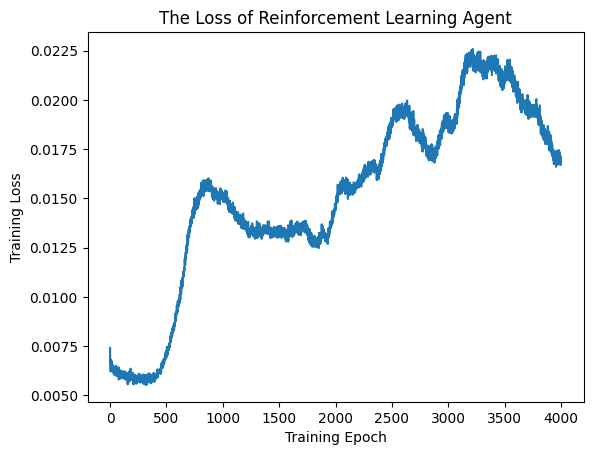

In [40]:
plt.plot(ocrl_training_s1.FQI_loss)

plt.title("The Loss of Reinforcement Learning Agent")
plt.xlabel("Training Epoch")
plt.ylabel("Training Loss")

# plt.savefig("../Experiment Figure/ocrl_fqi_loss_20250331.png", 
#             dpi = 300, 
#             bbox_inches = 'tight')

plt.show()

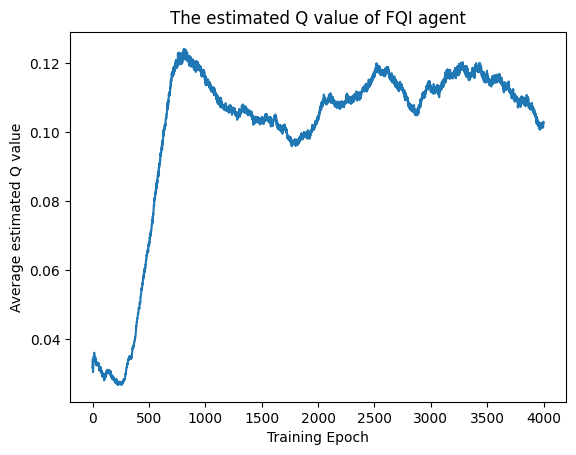

In [41]:
plt.plot(ocrl_training_s1.FQI_est_values)

plt.title("The estimated Q value of FQI agent")
plt.xlabel("Training Epoch")
plt.ylabel("Average estimated Q value")
# plt.grid(True)

# plt.savefig("../Experiment Figure/ocrl_fqi_est_Q_20250331.png", 
#             dpi = 300,
#             bbox_inches = 'tight')


plt.show()

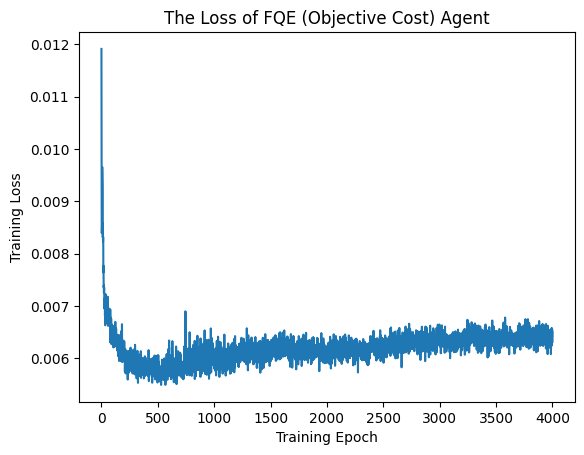

In [42]:
plt.plot(ocrl_training_s1.FQE_loss_obj)

plt.title("The Loss of FQE (Objective Cost) Agent")
plt.xlabel("Training Epoch")
plt.ylabel("Training Loss")

# plt.savefig("../Experiment Figure/ocrl_fqe_obj_loss_20250331.png", 
#             dpi = 300, 
#             bbox_inches='tight')

plt.show()

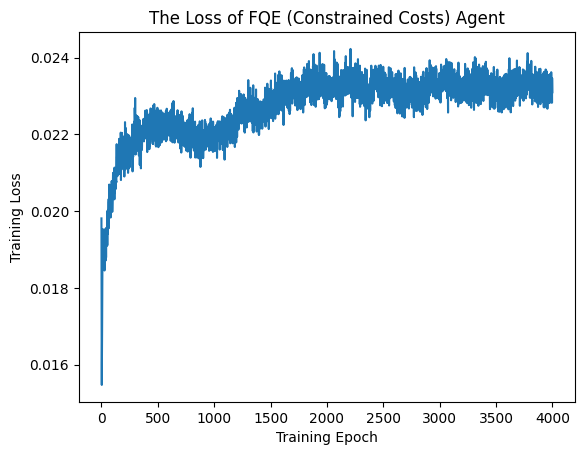

In [43]:
plt.plot(ocrl_training_s1.FQE_loss_con[0])

plt.title("The Loss of FQE (Constrained Costs) Agent")
plt.xlabel("Training Epoch")
plt.ylabel("Training Loss")

# plt.savefig("../Experiment Figure/ocrl_fqe_con_rdm_loss_20250331.png", 
#             dpi = 300, 
#             bbox_inches='tight')

plt.show()

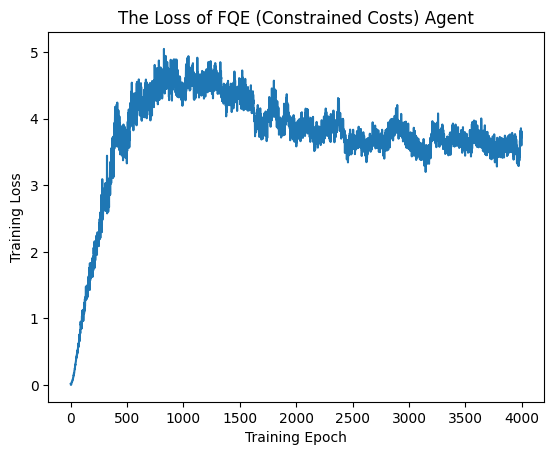

In [44]:
plt.plot(ocrl_training_s1.FQE_loss_con[1])

plt.title("The Loss of FQE (Constrained Costs) Agent")
plt.xlabel("Training Epoch")
plt.ylabel("Training Loss")

# plt.savefig("../Experiment Figure/ocrl_fqe_con_los_loss_20250331.png", 
#             dpi = 300, 
#             bbox_inches='tight')

plt.show()

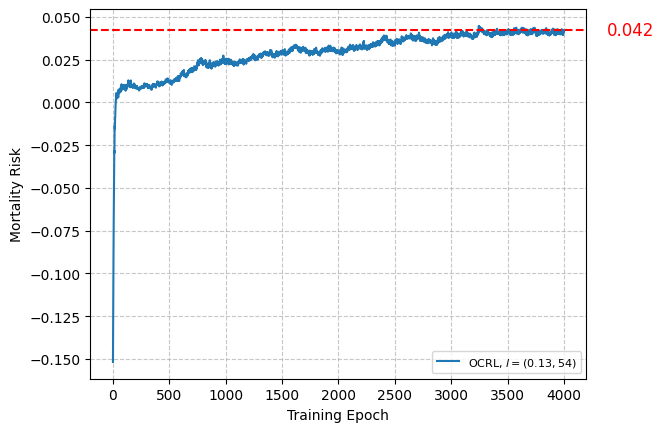

In [108]:
plt.plot(ocrl_training_s1.FQE_est_obj_costs, label = r'OCRL, $l = (0.13, 54)$')

last_epoch = len(ocrl_training_s1.FQE_est_obj_costs) - 1
last_value = ocrl_training_s1.FQE_est_obj_costs[-1]

plt.text(last_epoch + 800, last_value, f'{last_value:.3f}', ha = 'right', va = 'center', fontsize = 12, color = 'red')

plt.axhline(y = last_value, color = 'r', linestyle = '--')

# plt.title("The Average Estimated Value of Objective Costs by FQE")
plt.xlabel("Training Epoch")
# plt.ylabel(r"Mortality Risk ($\%$)")
plt.ylabel(r"Mortality Risk")
plt.legend(prop = {'size': 8})
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.savefig("../Experiment Figure/NN_ocrl_fqe_obj_est_value_20250508.png", 
            dpi = 400, 
            bbox_inches = 'tight')

plt.show()

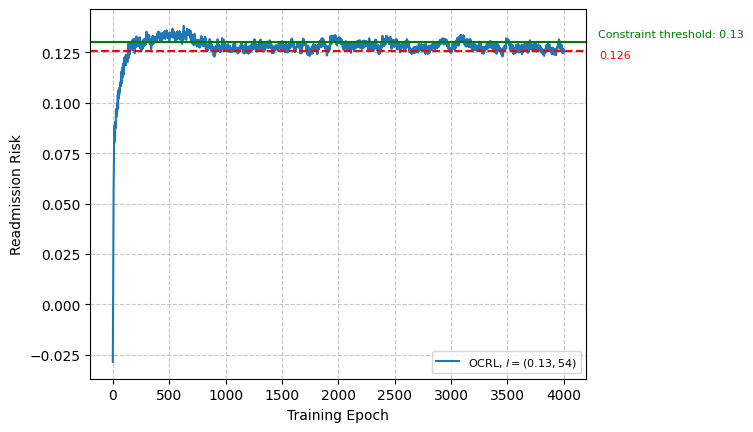

In [109]:
plt.plot(ocrl_training_s1.FQE_est_con_costs[0], label = r'OCRL, $l = (0.13, 54)$')

last_epoch = len(ocrl_training_s1.FQE_est_con_costs[0]) - 1
last_value = ocrl_training_s1.FQE_est_con_costs[0][-1]

# plt.text(last_epoch + 1800, last_value, f'{last_value:.2f}%', ha = 'right', va = 'center', fontsize = 12, color = 'red')
plt.text(last_epoch + 600, last_value-0.002, f'{last_value:.3f}', ha = 'right', va = 'center', fontsize = 8, color = 'red')

plt.axhline(y = last_value, color = 'r', linestyle = '--')
plt.axhline(y = 0.13, color = 'g', linestyle = '-')

plt.text(last_epoch + 300, 0.13 + 0.004, 'Constraint threshold: 0.13', 
         color = 'g', fontsize = 8, ha = 'left', va = 'center')

# plt.title("The Average Estimated Value of Constrained Costs by FQE")
plt.xlabel("Training Epoch")
# plt.ylabel(r"Readmission Risk ($\%$)")
plt.ylabel(r"Readmission Risk")
plt.legend(prop = {'size': 8})
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.savefig("../Experiment Figure/NN_ocrl_fqe_con_disch_fail_est_value_20250508.png", 
            dpi = 400, 
            bbox_inches = 'tight')

plt.show()

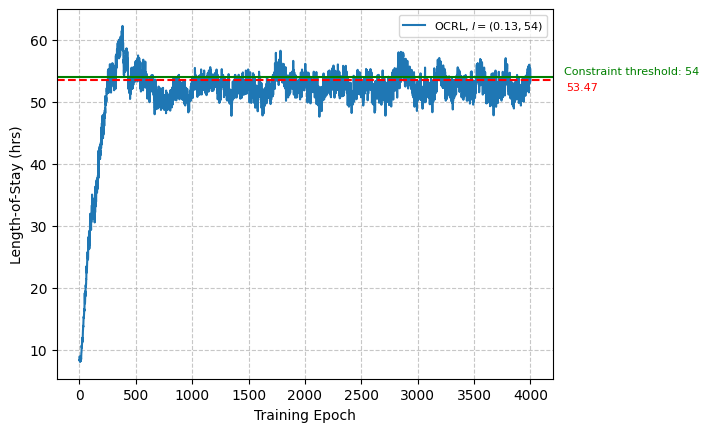

In [110]:
plt.plot(np.array(ocrl_training_s1.FQE_est_con_costs[1])*12, label = r'OCRL, $l = (0.13, 54)$')

last_epoch = len(ocrl_training_s1.FQE_est_con_costs[1]) - 1
last_value = ocrl_training_s1.FQE_est_con_costs[1][-1] * 12

plt.text(last_epoch + 600, last_value-1, f'{last_value:.2f}', ha = 'right', va = 'center', fontsize = 8, color = 'red')

plt.axhline(y = last_value, color = 'r', linestyle = '--')
plt.axhline(y = 54, color = 'g', linestyle = '-')

plt.text(last_epoch + 300, 54 + 1, 'Constraint threshold: 54', 
         color = 'g', fontsize = 8, ha = 'left', va = 'center')

# plt.title("The Average Estimated Value of Constrained Costs by FQE")
plt.xlabel("Training Epoch")
plt.ylabel(r"Length-of-Stay (hrs)")
plt.legend(prop = {'size': 8})
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.savefig("../Experiment Figure/NN_ocrl_fqe_con_los_value_20250508.png", 
            dpi = 400, 
            bbox_inches = 'tight')

plt.show()

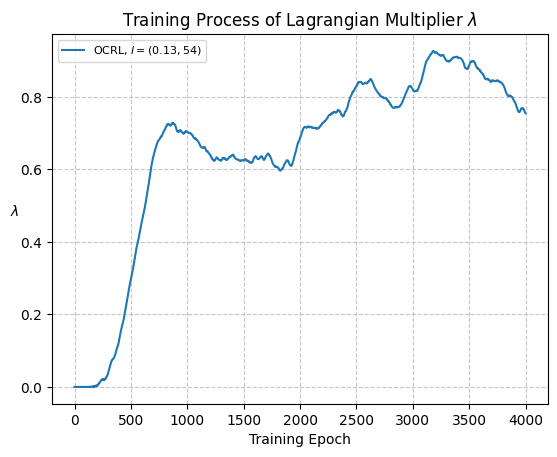

In [86]:
plt.plot(ocrl_training_s1.lambda_dict[0], label = r'OCRL, $l = (0.13, 54)$')

plt.title(r"Training Process of Lagrangian Multiplier $\lambda$")
plt.xlabel("Training Epoch")
ylabel = plt.ylabel(r"$\lambda$")
ylabel.set_rotation(0)

plt.legend(prop={'size': 8})
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.savefig("../Experiment Figure/NN_ocrl_lambda_disch_fail_20250508.png", 
            dpi = 400, 
            bbox_inches = 'tight')

plt.show()

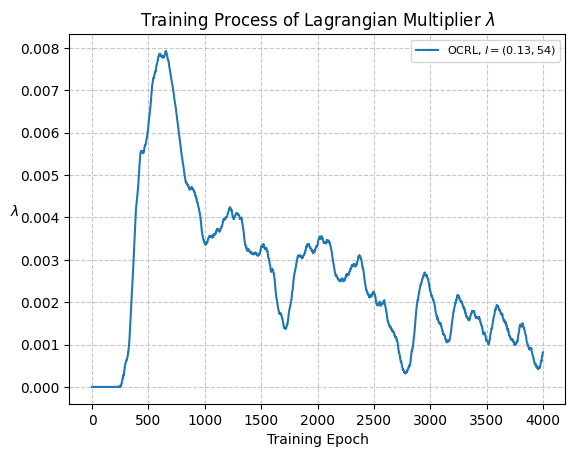

In [87]:
plt.plot(ocrl_training_s1.lambda_dict[1], label = r'OCRL, $l = (0.13, 54)$')

plt.title(r"Training Process of Lagrangian Multiplier $\lambda$")
plt.xlabel("Training Epoch")
ylabel = plt.ylabel(r"$\lambda$")
ylabel.set_rotation(0)

plt.legend(prop={'size': 8})
plt.grid(True, linestyle = '--', alpha = 0.7)

plt.savefig("../Experiment Figure/NN_ocrl_lambda_los_20250508.png", 
            dpi = 400, 
            bbox_inches = 'tight')

plt.show()

## Testing dataset

In [58]:
class TestDataLoader:
    def __init__(self, cfg, state_id_table, rl_cont_state_table, rl_cont_state_table_scaled, state_id_table_1, rl_cont_state_table_scaled_1, terminal_state):
        self.cfg = cfg
    
        # Load datasets
        self.state_df_id = state_id_table
        self.rl_cont_state_table = rl_cont_state_table
        self.rl_cont_state_table_scaled = rl_cont_state_table_scaled

        self.state_df_id_1 = state_id_table_1
        self.rl_cont_state_table_scaled_1 = rl_cont_state_table_scaled_1

        self.terminal_state = terminal_state

    def data_buffer_test(self, num_constraint = 2):
        self.test_memory = ReplayBuffer(self.cfg.memory_capacity)

        for i in range(len(self.state_df_id)):
            state = self.rl_cont_state_table_scaled.values[i]
            action = self.state_df_id['discharge_action'].values[i]
            
            if action == 1.0:
                if self.state_df_id['death'].values[i] == 1.0:
                    if self.state_df_id['discharge_fail'].values[i] == 1.0:
                        done = 0.0
                    else:
                        done = 1.0
                else:
                    if self.state_df_id['discharge_fail'].values[i] == 0.0:
                        done = 1.0
                    else:
                        done = 0.0
            else:
                done = 0.0
            
            obj_cost = self.state_df_id['mortality_costs_md'].values[i]
            con_cost = []
            
            for j in range(num_constraint):
                cost_col = f'con_cost_{j}'  
                if cost_col in self.state_df_id.columns:
                    con_cost.append(self.state_df_id[cost_col].values[i])
                else:
                    con_cost.append(0.0) 

            if done == 0.0:
                idx = self.state_df_id.index[i]
                next_state = self.rl_cont_state_table_scaled_1.loc[idx + 1].values
            else:
                next_state = self.terminal_state

            self.test_memory.push(state, action, obj_cost, con_cost, next_state, done)

    def data_torch_loader_test(self):
        state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch = self.test_memory.extract()

        state_batch = torch.tensor(np.array(state_batch), device = self.cfg.device, dtype = torch.float)

        disch_batch = list(action_batch)
        action_batch = torch.tensor(np.array(action_batch), device = self.cfg.device, dtype = torch.long).unsqueeze(1)
        
        obj_cost_batch = torch.tensor(np.array(obj_cost_batch), device = self.cfg.device, dtype = torch.float)
        con_cost_batch = [torch.tensor(np.array(cost), device = self.cfg.device, dtype=torch.float) for cost in con_cost_batch]
        next_state_batch = torch.tensor(np.array(next_state_batch), device = self.cfg.device, dtype = torch.float)

        done_batch = torch.tensor(np.array(done_batch), device = self.cfg.device, dtype = torch.float)
        disch_batch = torch.tensor(np.array(disch_batch), device = self.cfg.device, dtype = torch.float)

        return state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch, disch_batch

In [59]:
class TestConfig:
    def __init__(self, constraint_num):
        
        self.constraint_num = constraint_num

        self.memory_capacity = int(2e6)  # capacity of Replay Memory

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # check GPU
        # self.device = torch.device("cpu")

In [117]:
id_table_test = pd.read_csv('../data_output/id_table_test_v13.csv')
rl_table_test = pd.read_csv('../data_output/rl_table_test_v13.csv')
rl_table_test_scaled = pd.read_csv('../data_output/rl_table_test_scaled_v13.csv')

In [118]:
# Create a copy of the 'mortality_costs' column
id_table_test['mortality_costs_md'] = id_table_test['mortality_costs'].copy()

# Apply the conditions using vectorized operations
discharge_action_mask = id_table_test['discharge_action'] == 1
death_mask = id_table_test['death'] == 0
discharge_fail_mask = id_table_test['discharge_fail'] == 1

# Update 'mortality_costs_md' based on the conditions
id_table_test.loc[discharge_action_mask & death_mask, 'mortality_costs_md'] = 0
id_table_test.loc[discharge_action_mask & ~death_mask & discharge_fail_mask, 'mortality_costs_md'] = 0

In [143]:
# id_table_test_initial = id_table_test.copy()
id_table_test_initial = id_table_test[id_table_test['readmission_count'] == 3].copy()
# id_table_test_initial = id_table_test[(id_table_test['readmission_count'] == 4) | (id_table_test['readmission_count'] == 5)].copy()
# id_table_test_initial = id_table_test_initial[id_table_test_initial['epoch'] == 1].copy()
# id_table_test_initial = id_table_test[id_table_test['discharge_action'] == 1].copy()
# id_table_test_initial = id_table_test_initial[id_table_test_initial['discharge_fail'] == 1].copy()

mv_test_initial_index = id_table_test_initial.index
id_index_list_initial_test = mv_test_initial_index.tolist()

rl_table_test_initial = rl_table_test.loc[id_index_list_initial_test].copy()

rl_table_test_scaled_initial = rl_table_test_scaled.loc[id_index_list_initial_test].copy()

id_table_test_initial['con_cost_0'] = id_table_test_initial['discharge_fail_costs'].copy()
id_table_test_initial['con_cost_1'] = id_table_test_initial['los_costs_scaled'].copy()

test_cfg = TestConfig(constraint_num = 2)
terminal_state = np.zeros(rl_table_test_scaled.shape[1])
test_data_loader = TestDataLoader(test_cfg, 
                                  id_table_test_initial, 
                                  rl_table_test_initial, 
                                  rl_table_test_scaled_initial, 
                                  id_table_test, 
                                  rl_table_test_scaled, 
                                  terminal_state)

test_data_loader.data_buffer_test(num_constraint = 2)
state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch, disch_batch = test_data_loader.data_torch_loader_test()

In [144]:
# agent_fqi_s1 = torch.load('../model_output/ocrl_agent_s1_fqi_20250331_v0.pth', weights_only = False)

# agent_fqe_obj_s1 = torch.load('../model_output/ocrl_agent_s1_fqe_obj_20250331_v0.pth', weights_only = False)
# agent_fqe_con_rr_s1 = torch.load('../model_output/ocrl_agent_s1_fqe_con_rr_20250331_v0.pth', weights_only = False)
# agent_fqe_con_los_s1 = torch.load('../model_output/ocrl_agent_s1_fqe_con_los_20250331_v0.pth', weights_only = False)

In [145]:
ocrl_policy_set_1 = agent_fqi_s1.rl_policy(state_batch)
matches_1 = sum(1 for a, b in zip(ocrl_policy_set_1, action_batch) if a == b)
percentage_1 = matches_1/len(ocrl_policy_set_1)

In [146]:
percentage_1

0.8807769591426657

In [147]:
action_batch

tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [1]], device='cuda:0')

In [148]:
ocrl_policy_set_1

tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], device='cuda:0')

In [149]:
zeros = (action_batch == 0).sum().item()
ones = (action_batch == 1).sum().item()
total = action_batch.numel()  

zero_ratio = zeros / total
one_ratio = ones / total

print(f"0的数量: {zeros}, 比例: {zero_ratio:.4f} ({zeros}/{total})")
print(f"1的数量: {ones}, 比例: {one_ratio:.4f} ({ones}/{total})")

0的数量: 1470, 比例: 0.9846 (1470/1493)
1的数量: 23, 比例: 0.0154 (23/1493)


In [150]:
zeros = (ocrl_policy_set_1 == 0).sum().item()
ones = (ocrl_policy_set_1 == 1).sum().item()
total = ocrl_policy_set_1.numel()  

zero_ratio = zeros / total
one_ratio = ones / total

print(f"0的数量: {zeros}, 比例: {zero_ratio:.4f} ({zeros}/{total})")
print(f"1的数量: {ones}, 比例: {one_ratio:.4f} ({ones}/{total})")

0的数量: 1332, 比例: 0.8922 (1332/1493)
1的数量: 161, 比例: 0.1078 (161/1493)


In [70]:
fqe_test_obj_costs_ocrl_1, fqe_test_obj_costs_ocrl_1_ub = agent_fqe_obj_s1.avg_Q_value_est(state_batch)
fqe_test_con_disch_costs_ocrl_1, fqe_test_con_disch_costs_ocrl_1_ub = agent_fqe_con_rr_s1.avg_Q_value_est(state_batch)
fqe_test_con_los_costs_ocrl_1, fqe_test_con_los_costs_ocrl_1_ub = agent_fqe_con_los_s1.avg_Q_value_est(state_batch)

In [71]:
fqe_test_obj_costs_ocrl_1

0.05239036679267883

In [72]:
fqe_test_con_disch_costs_ocrl_1

0.11823495477437973

In [73]:
fqe_test_con_los_costs_ocrl_1

3.8871898651123047

In [74]:
fqe_test_con_los_costs_ocrl_1 * 12

46.646278381347656

In [75]:
agent_fqi_test = ocrl_training_s1.fqi_agent_config(seed = 1)

agent_fqe_obj_test = ocrl_training_s1.fqe_agent_config(id_stop = 0, 
                                                       eval_agent = agent_fqi_test, 
                                                       weight_decay = 0.0,
                                                       eval_target = 'obj', 
                                                       seed = 1) 

agent_fqe_con_rr_test = ocrl_training_s1.fqe_agent_config(id_stop = 0, 
                                                          eval_agent = agent_fqi_test, 
                                                          weight_decay = 0.0,
                                                          eval_target = 0, 
                                                          seed = 2) 

agent_fqe_con_los_test = ocrl_training_s1.fqe_agent_config(id_stop = 0, 
                                                           eval_agent = agent_fqi_test, 
                                                           weight_decay = 0.0,
                                                           eval_target = 1, 
                                                           seed = 3) 

cum_fqe_obj = 0

for i in range(len(ocrl_training_s1.fqe_obj_models_history)):
    agent_fqi_test.policy_net.load_state_dict(ocrl_training_s1.fqi_models_history[i]['model_state']['policy_net'])
    agent_fqe_obj_test.policy_net.load_state_dict(ocrl_training_s1.fqe_obj_models_history[i]['model_state']['policy_net'])
    fqe_est_obj_test, fqe_est_obj_test_ub = agent_fqe_obj_test.avg_Q_value_est(state_batch)
    print(fqe_est_obj_test)
    cum_fqe_obj += fqe_est_obj_test

cum_fqe_con_rr = 0

for i in range(len(ocrl_training_s1.fqe_obj_models_history)):
    agent_fqi_test.policy_net.load_state_dict(ocrl_training_s1.fqi_models_history[i]['model_state']['policy_net'])
    agent_fqe_con_rr_test.policy_net.load_state_dict(ocrl_training_s1.fqe_con_models_history[0][i]['model_state']['policy_net'])
    fqe_est_con_rr_test, fqe_est_con_rr_test_ub = agent_fqe_con_rr_test.avg_Q_value_est(state_batch)
    print(fqe_est_con_rr_test)
    cum_fqe_con_rr += fqe_est_con_rr_test

cum_fqe_con_los = 0

for i in range(len(ocrl_training_s1.fqe_obj_models_history)):
    agent_fqi_test.policy_net.load_state_dict(ocrl_training_s1.fqi_models_history[i]['model_state']['policy_net'])
    agent_fqe_con_los_test.policy_net.load_state_dict(ocrl_training_s1.fqe_con_models_history[1][i]['model_state']['policy_net'])
    fqe_est_con_los_test, fqe_est_con_los_test_ub = agent_fqe_con_los_test.avg_Q_value_est(state_batch)
    print(fqe_est_con_los_test)
    cum_fqe_con_los += fqe_est_con_los_test

0.0493297316133976
0.0467124842107296
0.04140889644622803
0.03950846567749977
0.04076696187257767
0.047366417944431305
0.0511084608733654
0.05473923310637474
0.054244838654994965
0.05329302325844765
0.05049092695116997
0.04616454616189003
0.04267105087637901
0.03865077719092369
0.035570573061704636
0.03494719788432121
0.0365353524684906
0.03652695566415787
0.03752993047237396
0.037873268127441406
0.03737157955765724
0.035466909408569336
0.03246654197573662
0.03251153975725174
0.03584028407931328
0.04026908427476883
0.0405588261783123
0.03864952549338341
0.04114990308880806
0.04528690502047539
0.049750667065382004
0.04650123044848442
0.04295877367258072
0.03998422622680664
0.0402248241007328
0.03634139150381088
0.031869977712631226
0.02907406911253929
0.027178769931197166
0.027232948690652847
0.030834510922431946
0.034497667104005814
0.0383102148771286
0.04091474041342735
0.04509024694561958
0.04900776594877243
0.050294965505599976
0.04966669902205467
0.045450445264577866
0.040368847548

In [76]:
L = len(ocrl_training_s1.fqe_obj_models_history)
print(L)

100


In [77]:
[cum_fqe_obj/L, 
 cum_fqe_con_rr/L,
 (cum_fqe_con_los/L)*12]

[0.04199712166562677, 0.13040494106709957, 54.836527204513544]

## Shap Values Analysis

In [ ]:
state_batch, action_batch, obj_cost_batch, con_cost_batch, next_state_batch, done_batch = train_data_loader.train_memory.extract()
state_batch = np.array(state_batch)

In [ ]:
# agent_fqi_s1 = torch.load('../model_output/ocrl_safe_agent_s1_fqi_20250321.pth', weights_only = False)

In [ ]:
idx = np.random.choice(state_batch.shape[0], 30000, replace = False)
background_data = state_batch[idx, :]

In [ ]:
model_1 = agent_fqi_s1.policy_net
model_1.eval()

weights = model_1.fc1.weight.data.cpu().numpy()
intercept = model_1.fc1.bias.data.cpu().numpy()

# e = shap.LinearExplainer((weights, intercept), background_data)
state_batch = torch.tensor(np.array(state_batch), device = torch.device("cuda"), dtype = torch.float)
e = shap.DeepExplainer(model_1, state_batch)

In [ ]:
rl_table_train_scaled.columns

In [ ]:
# weights

In [ ]:
selected = np.zeros(state_batch.shape[0], dtype = bool)
selected[idx] = True

X_data = state_batch[~selected]

In [ ]:
X_data

In [ ]:
shap_values = e.shap_values(X_data)

shap.summary_plot(shap_values, X_data, 
                  feature_names = rl_table_train_scaled.columns, 
                  plot_size = (8, 6), 
                  plot_type = 'bar',
                  show = False)

# plt.savefig("../Experiment Figure/shap_summ_plot_20250415.png", 
#             dpi = 400, 
#             bbox_inches = 'tight')

plt.show()

In [ ]:
shap_values

In [ ]:
if isinstance(shap_values, list):
    num_outputs = len(shap_values)
    print(f"Found {num_outputs} outputs in the SHAP values")
    # We'll focus on the first output for visualization
    selected_output = 0  # Change this to visualize different outputs
    shap_values_selected = shap_values[selected_output]
else:
    shap_values_selected = shap_values

In [ ]:
shap_values_selected

In [ ]:
mean_abs_shap = np.abs(shap_values_selected).mean(axis=0)
top_features_idx = np.argsort(mean_abs_shap)[-10:]
top_features = [rl_table_train_scaled.columns[i] for i in top_features_idx]

# Calculate mean positive and negative contributions for top features
pos_contrib = np.zeros(len(top_features_idx))
neg_contrib = np.zeros(len(top_features_idx))

for i, idx in enumerate(top_features_idx):
    pos_values = shap_values_selected[:, idx].copy()
    pos_values[pos_values < 0] = 0
    pos_contrib[i] = pos_values.mean()
    
    neg_values = shap_values_selected[:, idx].copy()
    neg_values[neg_values > 0] = 0
    neg_contrib[i] = abs(neg_values.mean())

# Create a DataFrame for visualization
contrib_df = pd.DataFrame({
    'Feature': top_features,
    'Positive Impact': pos_contrib,
    'Negative Impact': neg_contrib
})

In [ ]:
contrib_df

In [ ]:
plt.figure(figsize=(12, 8))
contrib_df = contrib_df.sort_values('Positive Impact', ascending=True)
contrib_df.plot(
    x='Feature',
    y=['Positive Impact', 'Negative Impact'],
    kind='barh',
    color=['green', 'red'],
    figsize=(12, 8)
)
plt.title('Positive vs Negative Feature Impact', fontsize=16)
plt.xlabel('Mean Absolute SHAP Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("../Experiment Figure/shap_pos_neg_impact_20250415.png", dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
# Function to create statistics for one output
def create_output_stats(shap_values_output, output_idx):
    # 2.1 Table of feature importance statistics
    feature_importance = pd.DataFrame({
        'Feature': rl_table_train_scaled.columns,
        'Mean Absolute SHAP': np.abs(shap_values_output).mean(axis=0),
        'Mean SHAP': shap_values_output.mean(axis=0),
        'Min SHAP': shap_values_output.min(axis=0),
        'Max SHAP': shap_values_output.max(axis=0),
        'Std SHAP': shap_values_output.std(axis=0)
    })

    feature_importance = feature_importance.sort_values('Mean Absolute SHAP', ascending=False)
    feature_importance.to_csv(f"../Experiment Figure/shap_feature_importance_output{output_idx}_20250415.csv", index=False)

    # 2.2 Table with percentage of positive and negative contributions
    feature_contribution = pd.DataFrame({
        'Feature': rl_table_train_scaled.columns,
        'Positive Contribution (%)': [(shap_values_output[:, i] > 0).mean() * 100 for i in range(shap_values_output.shape[1])],
        'Negative Contribution (%)': [(shap_values_output[:, i] < 0).mean() * 100 for i in range(shap_values_output.shape[1])],
        'Mean Positive SHAP': [shap_values_output[:, i][shap_values_output[:, i] > 0].mean() if any(shap_values_output[:, i] > 0) else 0 
                              for i in range(shap_values_output.shape[1])],
        'Mean Negative SHAP': [shap_values_output[:, i][shap_values_output[:, i] < 0].mean() if any(shap_values_output[:, i] < 0) else 0 
                              for i in range(shap_values_output.shape[1])]
    })

    feature_contribution = feature_contribution.sort_values('Mean Positive SHAP', ascending=False)
    feature_contribution.to_csv(f"../Experiment Figure/shap_feature_contribution_output{output_idx}_20250415.csv", index=False)
    
    return feature_importance, feature_contribution

In [ ]:
# If we have multiple outputs, we can analyze each one
if isinstance(shap_values, list):
    # Create statistics for each output
    for i, shap_vals in enumerate(shap_values):
        print(f"Creating statistics for output {i}")
        create_output_stats(shap_vals, i)
        
    # Additionally, create a summary table that compares top features across outputs
    feature_importance_all = pd.DataFrame({'Feature': rl_table_train_scaled.columns})
    for i, shap_vals in enumerate(shap_values):
        importance = np.abs(shap_vals).mean(axis=0)
        feature_importance_all[f'Importance_Output_{i}'] = importance
    
    # Add average importance across all outputs
    feature_importance_all['Average_Importance'] = feature_importance_all.iloc[:, 1:].mean(axis=1)
    feature_importance_all = feature_importance_all.sort_values('Average_Importance', ascending=False)
    feature_importance_all.to_csv("../Experiment Figure/shap_feature_importance_all_outputs_20250415.csv", index=False)
else:
    # Just one output
    create_output_stats(shap_values_selected, selected_output)

In [ ]:
# 4. Create a correlation heatmap of SHAP values for the selected output
shap_corr = np.corrcoef(shap_values_selected.T)
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(shap_corr, dtype=bool))
sns.heatmap(
    shap_corr,
    mask=mask,
    cmap='coolwarm',
    annot=False,
    fmt='.2f',
    linewidths=0.5,
    xticklabels=rl_table_train_scaled.columns,
    yticklabels=rl_table_train_scaled.columns
)
plt.title(f'Correlation Between Feature SHAP Values - Output {selected_output}', fontsize=16)
plt.tight_layout()
plt.savefig(f"../Experiment Figure/shap_correlation_output{selected_output}_20250415.png", dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
if isinstance(shap_values, list) and len(shap_values) > 1:
    # Get top 10 features based on average importance across all outputs
    avg_importance = np.zeros(len(rl_table_train_scaled.columns))
    for shap_vals in shap_values:
        avg_importance += np.abs(shap_vals).mean(axis=0)
    avg_importance /= len(shap_values)
    
    top_features_overall_idx = np.argsort(avg_importance)[-10:]
    top_features_overall = [rl_table_train_scaled.columns[i] for i in top_features_overall_idx]
    
    # Create a comparison bar chart
    comparison_data = {
        'Feature': top_features_overall
    }
    
    for i, shap_vals in enumerate(shap_values):
        importance = np.abs(shap_vals).mean(axis=0)
        comparison_data[f'Output {i}'] = [importance[idx] for idx in top_features_overall_idx]
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.melt(id_vars=['Feature'], var_name='Output', value_name='Importance')
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', hue='Output', data=comparison_df)
    plt.title('Feature Importance Comparison Across Outputs', fontsize=16)
    plt.tight_layout()
    plt.savefig("../Experiment Figure/shap_importance_comparison_20250415.png", dpi=400, bbox_inches='tight')
    plt.show()
    
    # 5.2 Create a heatmap showing importance across outputs
    heatmap_data = np.zeros((len(top_features_overall), len(shap_values)))
    for i, shap_vals in enumerate(shap_values):
        importance = np.abs(shap_vals).mean(axis=0)
        for j, idx in enumerate(top_features_overall_idx):
            heatmap_data[j, i] = importance[idx]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        heatmap_data,
        cmap='viridis',
        annot=True,
        fmt='.3f',
        xticklabels=[f'Output {i}' for i in range(len(shap_values))],
        yticklabels=top_features_overall
    )
    plt.title('Feature Importance Heatmap Across Outputs', fontsize=16)
    plt.tight_layout()
    plt.savefig("../Experiment Figure/shap_importance_heatmap_20250415.png", dpi=400, bbox_inches='tight')
    plt.show()

print("All SHAP visualizations and tables have been created successfully!")

In [ ]:
# Set a modern style for better aesthetics
plt.style.use('seaborn-whitegrid')  # Use seaborn style for cleaner look
plt.rcParams['font.family'] = 'Arial'  # Set font to Arial
plt.rcParams['font.size'] = 10  # Increase base font size

if isinstance(shap_values, list):
    for output_idx in range(len(shap_values)):
        plt.figure(figsize = (12, 10))  # Larger figure size for better spacing
        shap_plot = shap.plots.beeswarm(
            shap.Explanation(
                values = shap_values[output_idx],
                base_values = e.expected_value[output_idx] if isinstance(e.expected_value, list) else e.expected_value,
                data = X_data,
                feature_names = rl_table_train_scaled.columns
            ),
            alpha = 0.5,  # Add transparency to points
            color = plt.get_cmap("coolwarm"),  # Use a more distinct colormap
            show = False,
            color_bar = False
        )
        
        # Customize plot elements
        plt.title(f"SHAP Value Impact - Action {output_idx}", fontsize = 12, pad=  20)
        plt.xlabel("SHAP Value (Impact on Model Output)", fontsize = 10)
        plt.ylabel("Features", fontsize = 10)
        
        # Add gridlines
        plt.grid(True, axis = 'x', linestyle = '--', alpha = 0.3, color = 'gray')
        
        # Adjust tick labels
        plt.xticks(fontsize = 10)
        plt.yticks(fontsize = 10)
        
        # Add a colorbar to show feature value mapping
        sm = plt.cm.ScalarMappable(cmap = "coolwarm", norm = plt.Normalize(vmin = 0, vmax = 1))
        sm.set_array([])  
        cbar = plt.colorbar(sm, fraction = 0.03, pad = 0.02, aspect = 30)
        cbar.set_label("Feature Value (Low to High)", fontsize = 10, rotation = 270, labelpad = 20)
        cbar.ax.tick_params(labelsize = 10)
        
        # Tight layout to prevent clipping
        plt.tight_layout()
        
        # Save as both PNG and PDF for flexibility
        plt.savefig(f"../Experiment Figure/shap_beeswarm_output{output_idx}_20250415_1.png", 
                    dpi = 400, 
                    bbox_inches = 'tight')
        # plt.savefig(f"../Experiment Figure/shap_beeswarm_output{output_idx}_20250415.pdf", bbox_inches='tight')
        plt.show()
else:
    plt.figure(figsize = (12, 10))
    shap_plot = shap.plots.beeswarm(
        shap.Explanation(
            values = shap_values,
            base_values = e.expected_value,
            data = X_data,
            feature_names = rl_table_train_scaled.columns
        ),
        alpha = 0.7,
        color = plt.get_cmap("coolwarm")
    )
    
    # Customize plot elements
    plt.title("SHAP Value Impact", fontsize = 16, pad = 20)
    plt.xlabel("SHAP Value (Impact on Model Output)", fontsize = 14)
    plt.ylabel("Features", fontsize = 14)
    
    # Add gridlines
    plt.grid(True, axis = 'x', linestyle = '--', alpha = 0.3, color = 'gray')
    
    # Adjust tick labels
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap = "coolwarm", norm = plt.Normalize(vmin = 0, vmax = 1))
    plt.colorbar(sm, label = "Feature Value (Low to High)", fraction = 0.046, pad = 0.04)
    
    # Tight layout
    plt.tight_layout()
    
    # Save as both PNG and PDF
    plt.savefig("../Experiment Figure/shap_beeswarm_20250415.png", 
                dpi = 300, 
                bbox_inches = 'tight')
    # plt.savefig("../Experiment Figure/shap_beeswarm_20250415.pdf", bbox_inches='tight')
    plt.show()